# 识别验证码

## 生成Captcha验证码

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


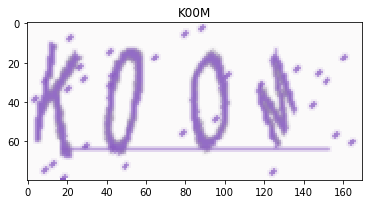

In [13]:
%matplotlib inline
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)
plt.show()

## 生成数据和标签

In [15]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
            yield X,y

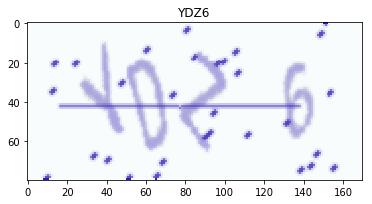

In [16]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:, 0]
    return ''.join([characters[x] for x in y])

# test 
X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))
plt.show()

## CNN Model

In [17]:
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
from IPython.display import Image

input_tensor = Input((height, width, 3))
x = input_tensor

for i in range(4):
    x = Conv2D(32 * 2 ** i, (3, 3), activation='relu')(x)
    x = Conv2D(32 * 2 ** i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
x = Flatten()(x)
x = Dropout(0.25)(x)

# 多输出模型
x = [Dense(n_class, activation='softmax', name='c%d' %(i + 1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)
model.summary()

plot_model(model, to_file='captcha_cnn_model.png', show_shapes=True)
Image('captcha_cnn_model.png')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 78, 168, 32)  896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 76, 166, 32)  9248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

### Training

In [18]:
from keras import callbacks

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
cbks = [callbacks.ModelCheckpoint('captcha_model.h5', save_best_only=True)]

history = model.fit_generator(gen(batch_size=32),
                              steps_per_epoch=1600,
                              epochs=5,
                              callbacks=cbks,
                              validation_data=gen(),
                              validation_steps=40)

Epoch 1/5


   1/1600 [..............................] - ETA: 35:00 - loss: 15.7430 - c1_loss: 3.0802 - c2_loss: 3.7989 - c3_loss: 4.6077 - c4_loss: 4.2562 - c1_acc: 0.6562 - c2_acc: 0.6250 - c3_acc: 0.6562 - c4_acc: 0.6250

   2/1600 [..............................] - ETA: 18:14 - loss: 14.8422 - c1_loss: 3.4688 - c2_loss: 3.5742 - c3_loss: 3.8490 - c4_loss: 3.9502 - c1_acc: 0.3750 - c2_acc: 0.3438 - c3_acc: 0.3438 - c4_acc: 0.3594

   3/1600 [..............................] - ETA: 12:38 - loss: 13.0621 - c1_loss: 3.2342 - c2_loss: 3.1590 - c3_loss: 3.3038 - c4_loss: 3.3652 - c1_acc: 0.2604 - c2_acc: 0.2500 - c3_acc: 0.2500 - c4_acc: 0.2604

   4/1600 [..............................] - ETA: 9:50 - loss: 11.2714 - c1_loss: 2.7790 - c2_loss: 2.7566 - c3_loss: 2.8653 - c4_loss: 2.8704 - c1_acc: 0.2188 - c2_acc: 0.1953 - c3_acc: 0.1875 - c4_acc: 0.2031 

   5/1600 [..............................] - ETA: 8:09 - loss: 10.3166 - c1_loss: 2.5653 - c2_loss: 2.5148 - c3_loss: 2.6334 - c4_loss: 2.6031 - c1_acc: 0.1812 - c2_acc: 0.1688 - c3_acc: 0.1688 - c4_acc: 0.1750

   6/1600 [..............................] - ETA: 7:03 - loss: 9.6967 - c1_loss: 2.4071 - c2_loss: 2.3650 - c3_loss: 2.4835 - c4_loss: 2.4411 - c1_acc: 0.1562 - c2_acc: 0.1510 - c3_acc: 0.1615 - c4_acc: 0.1458 

   7/1600 [..............................] - ETA: 6:15 - loss: 9.4090 - c1_loss: 2.3068 - c2_loss: 2.3234 - c3_loss: 2.4076 - c4_loss: 2.3712 - c1_acc: 0.1518 - c2_acc: 0.1473 - c3_acc: 0.1607 - c4_acc: 0.1295

   8/1600 [..............................] - ETA: 5:40 - loss: 9.1675 - c1_loss: 2.2504 - c2_loss: 2.2685 - c3_loss: 2.3423 - c4_loss: 2.3062 - c1_acc: 0.1406 - c2_acc: 0.1367 - c3_acc: 0.1406 - c4_acc: 0.1211

   9/1600 [..............................] - ETA: 5:12 - loss: 9.1601 - c1_loss: 2.2463 - c2_loss: 2.2488 - c3_loss: 2.3523 - c4_loss: 2.3127 - c1_acc: 0.1285 - c2_acc: 0.1250 - c3_acc: 0.1319 - c4_acc: 0.1111

  10/1600 [..............................] - ETA: 4:50 - loss: 9.0834 - c1_loss: 2.2325 - c2_loss: 2.2345 - c3_loss: 2.3252 - c4_loss: 2.2912 - c1_acc: 0.1156 - c2_acc: 0.1250 - c3_acc: 0.1219 - c4_acc: 0.1125

  11/1600 [..............................] - ETA: 4:33 - loss: 9.3202 - c1_loss: 2.2727 - c2_loss: 2.2590 - c3_loss: 2.3970 - c4_loss: 2.3915 - c1_acc: 0.1136 - c2_acc: 0.1222 - c3_acc: 0.1165 - c4_acc: 0.1080

  12/1600 [..............................] - ETA: 4:17 - loss: 9.3396 - c1_loss: 2.2823 - c2_loss: 2.2695 - c3_loss: 2.3971 - c4_loss: 2.3907 - c1_acc: 0.1068 - c2_acc: 0.1172 - c3_acc: 0.1120 - c4_acc: 0.1016

  13/1600 [..............................] - ETA: 4:05 - loss: 9.3274 - c1_loss: 2.2872 - c2_loss: 2.2669 - c3_loss: 2.3929 - c4_loss: 2.3804 - c1_acc: 0.1058 - c2_acc: 0.1130 - c3_acc: 0.1082 - c4_acc: 0.0986

  14/1600 [..............................] - ETA: 3:53 - loss: 9.5131 - c1_loss: 2.3509 - c2_loss: 2.3165 - c3_loss: 2.4326 - c4_loss: 2.4132 - c1_acc: 0.1049 - c2_acc: 0.1094 - c3_acc: 0.1027 - c4_acc: 0.0938

  15/1600 [..............................] - ETA: 3:43 - loss: 9.6237 - c1_loss: 2.3808 - c2_loss: 2.3479 - c3_loss: 2.4563 - c4_loss: 2.4387 - c1_acc: 0.1000 - c2_acc: 0.1042 - c3_acc: 0.1000 - c4_acc: 0.0917

  16/1600 [..............................] - ETA: 3:35 - loss: 9.7358 - c1_loss: 2.4144 - c2_loss: 2.3795 - c3_loss: 2.4700 - c4_loss: 2.4719 - c1_acc: 0.0977 - c2_acc: 0.0996 - c3_acc: 0.0977 - c4_acc: 0.0938

  17/1600 [..............................] - ETA: 3:27 - loss: 9.8798 - c1_loss: 2.4520 - c2_loss: 2.4183 - c3_loss: 2.5039 - c4_loss: 2.5056 - c1_acc: 0.0919 - c2_acc: 0.0974 - c3_acc: 0.0956 - c4_acc: 0.0901

  18/1600 [..............................] - ETA: 3:20 - loss: 9.9974 - c1_loss: 2.4828 - c2_loss: 2.4480 - c3_loss: 2.5334 - c4_loss: 2.5331 - c1_acc: 0.0955 - c2_acc: 0.0955 - c3_acc: 0.0955 - c4_acc: 0.0885

  19/1600 [..............................] - ETA: 3:14 - loss: 10.2196 - c1_loss: 2.5511 - c2_loss: 2.5099 - c3_loss: 2.5825 - c4_loss: 2.5762 - c1_acc: 0.0954 - c2_acc: 0.0954 - c3_acc: 0.0954 - c4_acc: 0.0872

  20/1600 [..............................] - ETA: 3:08 - loss: 10.3630 - c1_loss: 2.5874 - c2_loss: 2.5471 - c3_loss: 2.6168 - c4_loss: 2.6117 - c1_acc: 0.0953 - c2_acc: 0.0922 - c3_acc: 0.0938 - c4_acc: 0.0828

  21/1600 [..............................] - ETA: 3:03 - loss: 10.5024 - c1_loss: 2.6221 - c2_loss: 2.5814 - c3_loss: 2.6511 - c4_loss: 2.6478 - c1_acc: 0.0952 - c2_acc: 0.0893 - c3_acc: 0.0967 - c4_acc: 0.0818

  22/1600 [..............................] - ETA: 2:59 - loss: 10.6956 - c1_loss: 2.6839 - c2_loss: 2.6173 - c3_loss: 2.7048 - c4_loss: 2.6896 - c1_acc: 0.0952 - c2_acc: 0.0895 - c3_acc: 0.0966 - c4_acc: 0.0824

  23/1600 [..............................] - ETA: 2:54 - loss: 10.8374 - c1_loss: 2.7198 - c2_loss: 2.6544 - c3_loss: 2.7392 - c4_loss: 2.7240 - c1_acc: 0.0910 - c2_acc: 0.0856 - c3_acc: 0.0951 - c4_acc: 0.0829

  24/1600 [..............................] - ETA: 2:50 - loss: 10.9469 - c1_loss: 2.7487 - c2_loss: 2.6821 - c3_loss: 2.7667 - c4_loss: 2.7494 - c1_acc: 0.0898 - c2_acc: 0.0859 - c3_acc: 0.0924 - c4_acc: 0.0833

  25/1600 [..............................] - ETA: 2:47 - loss: 11.1119 - c1_loss: 2.7929 - c2_loss: 2.7236 - c3_loss: 2.7975 - c4_loss: 2.7979 - c1_acc: 0.0875 - c2_acc: 0.0850 - c3_acc: 0.0912 - c4_acc: 0.0825

  26/1600 [..............................] - ETA: 2:44 - loss: 11.2153 - c1_loss: 2.8180 - c2_loss: 2.7495 - c3_loss: 2.8246 - c4_loss: 2.8232 - c1_acc: 0.0865 - c2_acc: 0.0829 - c3_acc: 0.0889 - c4_acc: 0.0805

  27/1600 [..............................] - ETA: 2:40 - loss: 11.2896 - c1_loss: 2.8341 - c2_loss: 2.7649 - c3_loss: 2.8474 - c4_loss: 2.8432 - c1_acc: 0.0856 - c2_acc: 0.0810 - c3_acc: 0.0868 - c4_acc: 0.0799

  28/1600 [..............................] - ETA: 2:38 - loss: 11.3604 - c1_loss: 2.8498 - c2_loss: 2.7775 - c3_loss: 2.8713 - c4_loss: 2.8618 - c1_acc: 0.0859 - c2_acc: 0.0815 - c3_acc: 0.0848 - c4_acc: 0.0792

  29/1600 [..............................] - ETA: 2:35 - loss: 11.4451 - c1_loss: 2.8704 - c2_loss: 2.7996 - c3_loss: 2.8923 - c4_loss: 2.8828 - c1_acc: 0.0862 - c2_acc: 0.0830 - c3_acc: 0.0873 - c4_acc: 0.0819

  30/1600 [..............................] - ETA: 2:33 - loss: 11.5029 - c1_loss: 2.8833 - c2_loss: 2.8137 - c3_loss: 2.9080 - c4_loss: 2.8979 - c1_acc: 0.0833 - c2_acc: 0.0823 - c3_acc: 0.0875 - c4_acc: 0.0833

  31/1600 [..............................] - ETA: 2:31 - loss: 11.5556 - c1_loss: 2.8961 - c2_loss: 2.8279 - c3_loss: 2.9222 - c4_loss: 2.9095 - c1_acc: 0.0857 - c2_acc: 0.0806 - c3_acc: 0.0887 - c4_acc: 0.0857

  32/1600 [..............................] - ETA: 2:30 - loss: 11.6154 - c1_loss: 2.9108 - c2_loss: 2.8437 - c3_loss: 2.9368 - c4_loss: 2.9241 - c1_acc: 0.0879 - c2_acc: 0.0801 - c3_acc: 0.0898 - c4_acc: 0.0869

  33/1600 [..............................] - ETA: 2:28 - loss: 11.6523 - c1_loss: 2.9208 - c2_loss: 2.8549 - c3_loss: 2.9437 - c4_loss: 2.9329 - c1_acc: 0.0881 - c2_acc: 0.0814 - c3_acc: 0.0919 - c4_acc: 0.0871

  34/1600 [..............................] - ETA: 2:26 - loss: 11.6850 - c1_loss: 2.9290 - c2_loss: 2.8648 - c3_loss: 2.9499 - c4_loss: 2.9411 - c1_acc: 0.0882 - c2_acc: 0.0809 - c3_acc: 0.0919 - c4_acc: 0.0846

  35/1600 [..............................] - ETA: 2:24 - loss: 11.7216 - c1_loss: 2.9379 - c2_loss: 2.8740 - c3_loss: 2.9589 - c4_loss: 2.9508 - c1_acc: 0.0902 - c2_acc: 0.0830 - c3_acc: 0.0938 - c4_acc: 0.0857

  36/1600 [..............................] - ETA: 2:22 - loss: 11.7471 - c1_loss: 2.9424 - c2_loss: 2.8803 - c3_loss: 2.9639 - c4_loss: 2.9604 - c1_acc: 0.0894 - c2_acc: 0.0851 - c3_acc: 0.0964 - c4_acc: 0.0868

  37/1600 [..............................] - ETA: 2:21 - loss: 11.7802 - c1_loss: 2.9528 - c2_loss: 2.8894 - c3_loss: 2.9701 - c4_loss: 2.9678 - c1_acc: 0.0887 - c2_acc: 0.0887 - c3_acc: 0.0971 - c4_acc: 0.0870

  38/1600 [..............................] - ETA: 2:19 - loss: 11.8033 - c1_loss: 2.9610 - c2_loss: 2.8929 - c3_loss: 2.9728 - c4_loss: 2.9767 - c1_acc: 0.0880 - c2_acc: 0.0888 - c3_acc: 0.0970 - c4_acc: 0.0872

  39/1600 [..............................] - ETA: 2:18 - loss: 11.8282 - c1_loss: 2.9674 - c2_loss: 2.8988 - c3_loss: 2.9787 - c4_loss: 2.9833 - c1_acc: 0.0889 - c2_acc: 0.0905 - c3_acc: 0.0978 - c4_acc: 0.0873

  40/1600 [..............................] - ETA: 2:17 - loss: 11.8611 - c1_loss: 2.9745 - c2_loss: 2.9013 - c3_loss: 2.9885 - c4_loss: 2.9968 - c1_acc: 0.0891 - c2_acc: 0.0914 - c3_acc: 0.0992 - c4_acc: 0.0883

  41/1600 [..............................] - ETA: 2:15 - loss: 11.8995 - c1_loss: 2.9841 - c2_loss: 2.9111 - c3_loss: 2.9977 - c4_loss: 3.0065 - c1_acc: 0.0877 - c2_acc: 0.0922 - c3_acc: 0.0998 - c4_acc: 0.0884

  42/1600 [..............................] - ETA: 2:14 - loss: 11.9181 - c1_loss: 2.9910 - c2_loss: 2.9144 - c3_loss: 3.0013 - c4_loss: 3.0114 - c1_acc: 0.0871 - c2_acc: 0.0915 - c3_acc: 0.0997 - c4_acc: 0.0893

  43/1600 [..............................] - ETA: 2:13 - loss: 11.9304 - c1_loss: 2.9950 - c2_loss: 2.9147 - c3_loss: 3.0027 - c4_loss: 3.0180 - c1_acc: 0.0879 - c2_acc: 0.0916 - c3_acc: 0.1010 - c4_acc: 0.0894

  44/1600 [..............................] - ETA: 2:12 - loss: 11.9396 - c1_loss: 2.9985 - c2_loss: 2.9159 - c3_loss: 3.0036 - c4_loss: 3.0217 - c1_acc: 0.0888 - c2_acc: 0.0909 - c3_acc: 0.1016 - c4_acc: 0.0916

  45/1600 [..............................] - ETA: 2:11 - loss: 11.9540 - c1_loss: 3.0075 - c2_loss: 2.9152 - c3_loss: 3.0047 - c4_loss: 3.0267 - c1_acc: 0.0889 - c2_acc: 0.0910 - c3_acc: 0.1035 - c4_acc: 0.0924

  46/1600 [..............................] - ETA: 2:10 - loss: 11.9880 - c1_loss: 3.0165 - c2_loss: 2.9234 - c3_loss: 3.0124 - c4_loss: 3.0357 - c1_acc: 0.0897 - c2_acc: 0.0904 - c3_acc: 0.1053 - c4_acc: 0.0917

  47/1600 [..............................] - ETA: 2:08 - loss: 12.0029 - c1_loss: 3.0222 - c2_loss: 2.9256 - c3_loss: 3.0141 - c4_loss: 3.0410 - c1_acc: 0.0891 - c2_acc: 0.0898 - c3_acc: 0.1051 - c4_acc: 0.0904

  48/1600 [..............................] - ETA: 2:07 - loss: 12.0227 - c1_loss: 3.0350 - c2_loss: 2.9279 - c3_loss: 3.0137 - c4_loss: 3.0462 - c1_acc: 0.0885 - c2_acc: 0.0905 - c3_acc: 0.1055 - c4_acc: 0.0918

  49/1600 [..............................] - ETA: 2:07 - loss: 12.0492 - c1_loss: 3.0428 - c2_loss: 2.9340 - c3_loss: 3.0194 - c4_loss: 3.0530 - c1_acc: 0.0893 - c2_acc: 0.0925 - c3_acc: 0.1078 - c4_acc: 0.0938

  50/1600 [..............................] - ETA: 2:06 - loss: 12.0637 - c1_loss: 3.0488 - c2_loss: 2.9382 - c3_loss: 3.0207 - c4_loss: 3.0560 - c1_acc: 0.0887 - c2_acc: 0.0925 - c3_acc: 0.1087 - c4_acc: 0.0956

  51/1600 [..............................] - ETA: 2:05 - loss: 12.0731 - c1_loss: 3.0572 - c2_loss: 2.9393 - c3_loss: 3.0196 - c4_loss: 3.0571 - c1_acc: 0.0888 - c2_acc: 0.0925 - c3_acc: 0.1078 - c4_acc: 0.0956

  52/1600 [..............................] - ETA: 2:04 - loss: 12.0778 - c1_loss: 3.0610 - c2_loss: 2.9390 - c3_loss: 3.0201 - c4_loss: 3.0577 - c1_acc: 0.0889 - c2_acc: 0.0962 - c3_acc: 0.1094 - c4_acc: 0.0962

  53/1600 [..............................] - ETA: 2:03 - loss: 12.0882 - c1_loss: 3.0655 - c2_loss: 2.9400 - c3_loss: 3.0194 - c4_loss: 3.0634 - c1_acc: 0.0884 - c2_acc: 0.0979 - c3_acc: 0.1120 - c4_acc: 0.0973

  54/1600 [>.............................] - ETA: 2:02 - loss: 12.1542 - c1_loss: 3.0762 - c2_loss: 2.9508 - c3_loss: 3.0487 - c4_loss: 3.0785 - c1_acc: 0.0885 - c2_acc: 0.0978 - c3_acc: 0.1105 - c4_acc: 0.0972

  55/1600 [>.............................] - ETA: 2:02 - loss: 12.1779 - c1_loss: 3.0825 - c2_loss: 2.9567 - c3_loss: 3.0539 - c4_loss: 3.0848 - c1_acc: 0.0875 - c2_acc: 0.0994 - c3_acc: 0.1102 - c4_acc: 0.0977

  56/1600 [>.............................] - ETA: 2:01 - loss: 12.1897 - c1_loss: 3.0861 - c2_loss: 2.9592 - c3_loss: 3.0559 - c4_loss: 3.0885 - c1_acc: 0.0871 - c2_acc: 0.0999 - c3_acc: 0.1110 - c4_acc: 0.0977

  57/1600 [>.............................] - ETA: 2:00 - loss: 12.2014 - c1_loss: 3.0879 - c2_loss: 2.9641 - c3_loss: 3.0564 - c4_loss: 3.0929 - c1_acc: 0.0866 - c2_acc: 0.1009 - c3_acc: 0.1113 - c4_acc: 0.0976

  58/1600 [>.............................] - ETA: 1:59 - loss: 12.2140 - c1_loss: 3.0911 - c2_loss: 2.9678 - c3_loss: 3.0590 - c4_loss: 3.0960 - c1_acc: 0.0857 - c2_acc: 0.1013 - c3_acc: 0.1121 - c4_acc: 0.0986

  59/1600 [>.............................] - ETA: 1:59 - loss: 12.2158 - c1_loss: 3.0906 - c2_loss: 2.9713 - c3_loss: 3.0576 - c4_loss: 3.0963 - c1_acc: 0.0863 - c2_acc: 0.1012 - c3_acc: 0.1133 - c4_acc: 0.0996

  60/1600 [>.............................] - ETA: 1:58 - loss: 12.2147 - c1_loss: 3.0877 - c2_loss: 2.9731 - c3_loss: 3.0574 - c4_loss: 3.0966 - c1_acc: 0.0880 - c2_acc: 0.1031 - c3_acc: 0.1141 - c4_acc: 0.1021

  61/1600 [>.............................] - ETA: 1:57 - loss: 12.2077 - c1_loss: 3.0830 - c2_loss: 2.9779 - c3_loss: 3.0532 - c4_loss: 3.0936 - c1_acc: 0.0886 - c2_acc: 0.1040 - c3_acc: 0.1163 - c4_acc: 0.1030

  62/1600 [>.............................] - ETA: 1:57 - loss: 12.2053 - c1_loss: 3.0815 - c2_loss: 2.9795 - c3_loss: 3.0511 - c4_loss: 3.0932 - c1_acc: 0.0912 - c2_acc: 0.1069 - c3_acc: 0.1174 - c4_acc: 0.1048

  63/1600 [>.............................] - ETA: 1:56 - loss: 12.2076 - c1_loss: 3.0795 - c2_loss: 2.9822 - c3_loss: 3.0506 - c4_loss: 3.0952 - c1_acc: 0.0918 - c2_acc: 0.1091 - c3_acc: 0.1181 - c4_acc: 0.1047

  64/1600 [>.............................] - ETA: 1:55 - loss: 12.2169 - c1_loss: 3.0803 - c2_loss: 2.9858 - c3_loss: 3.0523 - c4_loss: 3.0985 - c1_acc: 0.0918 - c2_acc: 0.1094 - c3_acc: 0.1182 - c4_acc: 0.1035

  65/1600 [>.............................] - ETA: 1:55 - loss: 12.2201 - c1_loss: 3.0790 - c2_loss: 2.9882 - c3_loss: 3.0532 - c4_loss: 3.0998 - c1_acc: 0.0923 - c2_acc: 0.1091 - c3_acc: 0.1178 - c4_acc: 0.1034

  66/1600 [>.............................] - ETA: 1:54 - loss: 12.2307 - c1_loss: 3.0807 - c2_loss: 2.9915 - c3_loss: 3.0551 - c4_loss: 3.1034 - c1_acc: 0.0938 - c2_acc: 0.1103 - c3_acc: 0.1188 - c4_acc: 0.1042

  67/1600 [>.............................] - ETA: 1:54 - loss: 12.2300 - c1_loss: 3.0772 - c2_loss: 2.9955 - c3_loss: 3.0542 - c4_loss: 3.1031 - c1_acc: 0.0942 - c2_acc: 0.1105 - c3_acc: 0.1199 - c4_acc: 0.1054

  68/1600 [>.............................] - ETA: 1:53 - loss: 12.2323 - c1_loss: 3.0759 - c2_loss: 2.9981 - c3_loss: 3.0549 - c4_loss: 3.1035 - c1_acc: 0.0947 - c2_acc: 0.1103 - c3_acc: 0.1195 - c4_acc: 0.1062

  69/1600 [>.............................] - ETA: 1:53 - loss: 12.2212 - c1_loss: 3.0717 - c2_loss: 2.9974 - c3_loss: 3.0519 - c4_loss: 3.1002 - c1_acc: 0.0978 - c2_acc: 0.1128 - c3_acc: 0.1196 - c4_acc: 0.1069

  70/1600 [>.............................] - ETA: 1:52 - loss: 12.2048 - c1_loss: 3.0639 - c2_loss: 2.9980 - c3_loss: 3.0480 - c4_loss: 3.0949 - c1_acc: 0.1000 - c2_acc: 0.1147 - c3_acc: 0.1210 - c4_acc: 0.1089

  71/1600 [>.............................] - ETA: 1:51 - loss: 12.1895 - c1_loss: 3.0589 - c2_loss: 2.9990 - c3_loss: 3.0424 - c4_loss: 3.0892 - c1_acc: 0.1012 - c2_acc: 0.1158 - c3_acc: 0.1232 - c4_acc: 0.1096

  72/1600 [>.............................] - ETA: 1:51 - loss: 12.1972 - c1_loss: 3.0601 - c2_loss: 3.0058 - c3_loss: 3.0398 - c4_loss: 3.0915 - c1_acc: 0.1020 - c2_acc: 0.1155 - c3_acc: 0.1241 - c4_acc: 0.1102

  73/1600 [>.............................] - ETA: 1:51 - loss: 12.2032 - c1_loss: 3.0609 - c2_loss: 3.0085 - c3_loss: 3.0400 - c4_loss: 3.0938 - c1_acc: 0.1032 - c2_acc: 0.1156 - c3_acc: 0.1254 - c4_acc: 0.1104

  74/1600 [>.............................] - ETA: 1:50 - loss: 12.1952 - c1_loss: 3.0547 - c2_loss: 3.0104 - c3_loss: 3.0350 - c4_loss: 3.0951 - c1_acc: 0.1052 - c2_acc: 0.1161 - c3_acc: 0.1267 - c4_acc: 0.1102

  75/1600 [>.............................] - ETA: 1:50 - loss: 12.1805 - c1_loss: 3.0473 - c2_loss: 3.0108 - c3_loss: 3.0296 - c4_loss: 3.0928 - c1_acc: 0.1062 - c2_acc: 0.1175 - c3_acc: 0.1288 - c4_acc: 0.1133

  76/1600 [>.............................] - ETA: 1:49 - loss: 12.1639 - c1_loss: 3.0402 - c2_loss: 3.0089 - c3_loss: 3.0245 - c4_loss: 3.0903 - c1_acc: 0.1090 - c2_acc: 0.1192 - c3_acc: 0.1308 - c4_acc: 0.1151

  77/1600 [>.............................] - ETA: 1:49 - loss: 12.1538 - c1_loss: 3.0353 - c2_loss: 3.0088 - c3_loss: 3.0214 - c4_loss: 3.0883 - c1_acc: 0.1112 - c2_acc: 0.1209 - c3_acc: 0.1335 - c4_acc: 0.1169

  78/1600 [>.............................] - ETA: 1:48 - loss: 12.1204 - c1_loss: 3.0276 - c2_loss: 2.9991 - c3_loss: 3.0153 - c4_loss: 3.0784 - c1_acc: 0.1142 - c2_acc: 0.1258 - c3_acc: 0.1358 - c4_acc: 0.1202

  79/1600 [>.............................] - ETA: 1:48 - loss: 12.0710 - c1_loss: 3.0152 - c2_loss: 2.9869 - c3_loss: 3.0030 - c4_loss: 3.0658 - c1_acc: 0.1167 - c2_acc: 0.1305 - c3_acc: 0.1392 - c4_acc: 0.1246

  80/1600 [>.............................] - ETA: 1:48 - loss: 12.0346 - c1_loss: 3.0126 - c2_loss: 2.9749 - c3_loss: 2.9932 - c4_loss: 3.0539 - c1_acc: 0.1187 - c2_acc: 0.1336 - c3_acc: 0.1441 - c4_acc: 0.1277

  81/1600 [>.............................] - ETA: 1:47 - loss: 12.0312 - c1_loss: 3.0117 - c2_loss: 2.9768 - c3_loss: 2.9911 - c4_loss: 3.0516 - c1_acc: 0.1188 - c2_acc: 0.1343 - c3_acc: 0.1454 - c4_acc: 0.1285

  82/1600 [>.............................] - ETA: 1:47 - loss: 11.9999 - c1_loss: 3.0028 - c2_loss: 2.9698 - c3_loss: 2.9840 - c4_loss: 3.0434 - c1_acc: 0.1235 - c2_acc: 0.1372 - c3_acc: 0.1475 - c4_acc: 0.1319

  83/1600 [>.............................] - ETA: 1:47 - loss: 11.9473 - c1_loss: 2.9902 - c2_loss: 2.9581 - c3_loss: 2.9712 - c4_loss: 3.0277 - c1_acc: 0.1280 - c2_acc: 0.1412 - c3_acc: 0.1506 - c4_acc: 0.1374

  84/1600 [>.............................] - ETA: 1:46 - loss: 11.8842 - c1_loss: 2.9751 - c2_loss: 2.9410 - c3_loss: 2.9552 - c4_loss: 3.0129 - c1_acc: 0.1339 - c2_acc: 0.1469 - c3_acc: 0.1555 - c4_acc: 0.1421

  85/1600 [>.............................] - ETA: 1:46 - loss: 11.9350 - c1_loss: 2.9951 - c2_loss: 2.9537 - c3_loss: 2.9614 - c4_loss: 3.0248 - c1_acc: 0.1342 - c2_acc: 0.1474 - c3_acc: 0.1562 - c4_acc: 0.1430

  86/1600 [>.............................] - ETA: 1:46 - loss: 11.9372 - c1_loss: 2.9964 - c2_loss: 2.9515 - c3_loss: 2.9615 - c4_loss: 3.0278 - c1_acc: 0.1355 - c2_acc: 0.1483 - c3_acc: 0.1573 - c4_acc: 0.1432

  87/1600 [>.............................] - ETA: 1:45 - loss: 11.9514 - c1_loss: 2.9994 - c2_loss: 2.9553 - c3_loss: 2.9658 - c4_loss: 3.0309 - c1_acc: 0.1365 - c2_acc: 0.1494 - c3_acc: 0.1577 - c4_acc: 0.1444

  88/1600 [>.............................] - ETA: 1:45 - loss: 11.9362 - c1_loss: 2.9952 - c2_loss: 2.9522 - c3_loss: 2.9616 - c4_loss: 3.0273 - c1_acc: 0.1378 - c2_acc: 0.1506 - c3_acc: 0.1602 - c4_acc: 0.1452

  89/1600 [>.............................] - ETA: 1:45 - loss: 11.9151 - c1_loss: 2.9877 - c2_loss: 2.9487 - c3_loss: 2.9581 - c4_loss: 3.0206 - c1_acc: 0.1404 - c2_acc: 0.1520 - c3_acc: 0.1608 - c4_acc: 0.1475

  90/1600 [>.............................] - ETA: 1:44 - loss: 11.9081 - c1_loss: 2.9850 - c2_loss: 2.9476 - c3_loss: 2.9570 - c4_loss: 3.0186 - c1_acc: 0.1431 - c2_acc: 0.1535 - c3_acc: 0.1622 - c4_acc: 0.1493

  91/1600 [>.............................] - ETA: 1:44 - loss: 11.8746 - c1_loss: 2.9767 - c2_loss: 2.9379 - c3_loss: 2.9495 - c4_loss: 3.0104 - c1_acc: 0.1459 - c2_acc: 0.1559 - c3_acc: 0.1641 - c4_acc: 0.1521

  92/1600 [>.............................] - ETA: 1:44 - loss: 11.8572 - c1_loss: 2.9717 - c2_loss: 2.9334 - c3_loss: 2.9454 - c4_loss: 3.0066 - c1_acc: 0.1481 - c2_acc: 0.1586 - c3_acc: 0.1658 - c4_acc: 0.1549

  93/1600 [>.............................] - ETA: 1:43 - loss: 11.8186 - c1_loss: 2.9627 - c2_loss: 2.9230 - c3_loss: 2.9375 - c4_loss: 2.9955 - c1_acc: 0.1509 - c2_acc: 0.1620 - c3_acc: 0.1680 - c4_acc: 0.1573

  94/1600 [>.............................] - ETA: 1:43 - loss: 11.7883 - c1_loss: 2.9552 - c2_loss: 2.9159 - c3_loss: 2.9295 - c4_loss: 2.9876 - c1_acc: 0.1533 - c2_acc: 0.1646 - c3_acc: 0.1709 - c4_acc: 0.1599

  95/1600 [>.............................] - ETA: 1:43 - loss: 11.7478 - c1_loss: 2.9472 - c2_loss: 2.9066 - c3_loss: 2.9173 - c4_loss: 2.9767 - c1_acc: 0.1562 - c2_acc: 0.1681 - c3_acc: 0.1753 - c4_acc: 0.1635

  96/1600 [>.............................] - ETA: 1:42 - loss: 11.7185 - c1_loss: 2.9400 - c2_loss: 2.8996 - c3_loss: 2.9089 - c4_loss: 2.9700 - c1_acc: 0.1592 - c2_acc: 0.1725 - c3_acc: 0.1784 - c4_acc: 0.1673

  97/1600 [>.............................] - ETA: 1:42 - loss: 11.6664 - c1_loss: 2.9320 - c2_loss: 2.8857 - c3_loss: 2.8933 - c4_loss: 2.9554 - c1_acc: 0.1630 - c2_acc: 0.1759 - c3_acc: 0.1840 - c4_acc: 0.1714

  98/1600 [>.............................] - ETA: 1:42 - loss: 11.6354 - c1_loss: 2.9270 - c2_loss: 2.8773 - c3_loss: 2.8861 - c4_loss: 2.9450 - c1_acc: 0.1658 - c2_acc: 0.1795 - c3_acc: 0.1862 - c4_acc: 0.1751

  99/1600 [>.............................] - ETA: 1:41 - loss: 11.6220 - c1_loss: 2.9223 - c2_loss: 2.8729 - c3_loss: 2.8841 - c4_loss: 2.9427 - c1_acc: 0.1692 - c2_acc: 0.1815 - c3_acc: 0.1891 - c4_acc: 0.1761

 100/1600 [>.............................] - ETA: 1:41 - loss: 11.5929 - c1_loss: 2.9167 - c2_loss: 2.8642 - c3_loss: 2.8746 - c4_loss: 2.9373 - c1_acc: 0.1722 - c2_acc: 0.1853 - c3_acc: 0.1922 - c4_acc: 0.1787

 101/1600 [>.............................] - ETA: 1:41 - loss: 11.5388 - c1_loss: 2.9057 - c2_loss: 2.8491 - c3_loss: 2.8609 - c4_loss: 2.9231 - c1_acc: 0.1754 - c2_acc: 0.1897 - c3_acc: 0.1962 - c4_acc: 0.1832

 102/1600 [>.............................] - ETA: 1:41 - loss: 11.4737 - c1_loss: 2.8903 - c2_loss: 2.8323 - c3_loss: 2.8451 - c4_loss: 2.9060 - c1_acc: 0.1798 - c2_acc: 0.1955 - c3_acc: 0.2007 - c4_acc: 0.1881

 103/1600 [>.............................] - ETA: 1:40 - loss: 11.4129 - c1_loss: 2.8745 - c2_loss: 2.8205 - c3_loss: 2.8293 - c4_loss: 2.8886 - c1_acc: 0.1848 - c2_acc: 0.1999 - c3_acc: 0.2060 - c4_acc: 0.1936

 104/1600 [>.............................] - ETA: 1:40 - loss: 11.3436 - c1_loss: 2.8553 - c2_loss: 2.8039 - c3_loss: 2.8132 - c4_loss: 2.8712 - c1_acc: 0.1920 - c2_acc: 0.2055 - c3_acc: 0.2121 - c4_acc: 0.1995

 105/1600 [>.............................] - ETA: 1:40 - loss: 11.2655 - c1_loss: 2.8332 - c2_loss: 2.7876 - c3_loss: 2.7945 - c4_loss: 2.8503 - c1_acc: 0.1985 - c2_acc: 0.2107 - c3_acc: 0.2182 - c4_acc: 0.2051

 106/1600 [>.............................] - ETA: 1:40 - loss: 11.2160 - c1_loss: 2.8194 - c2_loss: 2.7808 - c3_loss: 2.7798 - c4_loss: 2.8359 - c1_acc: 0.2034 - c2_acc: 0.2143 - c3_acc: 0.2232 - c4_acc: 0.2102

 107/1600 [=>............................] - ETA: 1:39 - loss: 11.1839 - c1_loss: 2.8120 - c2_loss: 2.7731 - c3_loss: 2.7712 - c4_loss: 2.8276 - c1_acc: 0.2074 - c2_acc: 0.2185 - c3_acc: 0.2278 - c4_acc: 0.2152

 108/1600 [=>............................] - ETA: 1:39 - loss: 11.1420 - c1_loss: 2.8005 - c2_loss: 2.7644 - c3_loss: 2.7613 - c4_loss: 2.8158 - c1_acc: 0.2135 - c2_acc: 0.2234 - c3_acc: 0.2315 - c4_acc: 0.2208

 109/1600 [=>............................] - ETA: 1:39 - loss: 11.1008 - c1_loss: 2.7905 - c2_loss: 2.7551 - c3_loss: 2.7494 - c4_loss: 2.8057 - c1_acc: 0.2196 - c2_acc: 0.2285 - c3_acc: 0.2362 - c4_acc: 0.2256

 110/1600 [=>............................] - ETA: 1:39 - loss: 11.0727 - c1_loss: 2.7871 - c2_loss: 2.7464 - c3_loss: 2.7398 - c4_loss: 2.7994 - c1_acc: 0.2241 - c2_acc: 0.2335 - c3_acc: 0.2415 - c4_acc: 0.2310

 111/1600 [=>............................] - ETA: 1:38 - loss: 11.0238 - c1_loss: 2.7757 - c2_loss: 2.7342 - c3_loss: 2.7261 - c4_loss: 2.7878 - c1_acc: 0.2286 - c2_acc: 0.2382 - c3_acc: 0.2466 - c4_acc: 0.2365

 112/1600 [=>............................] - ETA: 1:38 - loss: 10.9775 - c1_loss: 2.7643 - c2_loss: 2.7204 - c3_loss: 2.7135 - c4_loss: 2.7794 - c1_acc: 0.2335 - c2_acc: 0.2436 - c3_acc: 0.2522 - c4_acc: 0.2416

 113/1600 [=>............................] - ETA: 1:38 - loss: 10.9536 - c1_loss: 2.7596 - c2_loss: 2.7131 - c3_loss: 2.7057 - c4_loss: 2.7752 - c1_acc: 0.2373 - c2_acc: 0.2486 - c3_acc: 0.2569 - c4_acc: 0.2461

 114/1600 [=>............................] - ETA: 1:38 - loss: 10.9120 - c1_loss: 2.7501 - c2_loss: 2.7003 - c3_loss: 2.6941 - c4_loss: 2.7675 - c1_acc: 0.2412 - c2_acc: 0.2533 - c3_acc: 0.2618 - c4_acc: 0.2508

 115/1600 [=>............................] - ETA: 1:37 - loss: 10.8591 - c1_loss: 2.7361 - c2_loss: 2.6862 - c3_loss: 2.6802 - c4_loss: 2.7567 - c1_acc: 0.2459 - c2_acc: 0.2576 - c3_acc: 0.2658 - c4_acc: 0.2549

 116/1600 [=>............................] - ETA: 1:37 - loss: 10.8377 - c1_loss: 2.7315 - c2_loss: 2.6806 - c3_loss: 2.6718 - c4_loss: 2.7538 - c1_acc: 0.2500 - c2_acc: 0.2624 - c3_acc: 0.2702 - c4_acc: 0.2594

 117/1600 [=>............................] - ETA: 1:37 - loss: 10.8259 - c1_loss: 2.7242 - c2_loss: 2.6761 - c3_loss: 2.6734 - c4_loss: 2.7522 - c1_acc: 0.2535 - c2_acc: 0.2658 - c3_acc: 0.2730 - c4_acc: 0.2620

 118/1600 [=>............................] - ETA: 1:37 - loss: 10.7848 - c1_loss: 2.7112 - c2_loss: 2.6664 - c3_loss: 2.6654 - c4_loss: 2.7418 - c1_acc: 0.2585 - c2_acc: 0.2704 - c3_acc: 0.2773 - c4_acc: 0.2669

 119/1600 [=>............................] - ETA: 1:37 - loss: 10.7203 - c1_loss: 2.6936 - c2_loss: 2.6498 - c3_loss: 2.6505 - c4_loss: 2.7264 - c1_acc: 0.2637 - c2_acc: 0.2755 - c3_acc: 0.2815 - c4_acc: 0.2718

 120/1600 [=>............................] - ETA: 1:36 - loss: 10.6518 - c1_loss: 2.6763 - c2_loss: 2.6339 - c3_loss: 2.6332 - c4_loss: 2.7084 - c1_acc: 0.2693 - c2_acc: 0.2802 - c3_acc: 0.2870 - c4_acc: 0.2773

 121/1600 [=>............................] - ETA: 1:36 - loss: 10.5866 - c1_loss: 2.6627 - c2_loss: 2.6184 - c3_loss: 2.6170 - c4_loss: 2.6884 - c1_acc: 0.2745 - c2_acc: 0.2851 - c3_acc: 0.2921 - c4_acc: 0.2828

 122/1600 [=>............................] - ETA: 1:36 - loss: 10.5133 - c1_loss: 2.6443 - c2_loss: 2.6000 - c3_loss: 2.5997 - c4_loss: 2.6693 - c1_acc: 0.2795 - c2_acc: 0.2902 - c3_acc: 0.2971 - c4_acc: 0.2884

 123/1600 [=>............................] - ETA: 1:36 - loss: 10.4395 - c1_loss: 2.6266 - c2_loss: 2.5803 - c3_loss: 2.5834 - c4_loss: 2.6493 - c1_acc: 0.2846 - c2_acc: 0.2957 - c3_acc: 0.3021 - c4_acc: 0.2937

 124/1600 [=>............................] - ETA: 1:36 - loss: 10.3698 - c1_loss: 2.6086 - c2_loss: 2.5620 - c3_loss: 2.5665 - c4_loss: 2.6328 - c1_acc: 0.2896 - c2_acc: 0.3012 - c3_acc: 0.3072 - c4_acc: 0.2984

 125/1600 [=>............................] - ETA: 1:35 - loss: 10.3057 - c1_loss: 2.5912 - c2_loss: 2.5449 - c3_loss: 2.5525 - c4_loss: 2.6172 - c1_acc: 0.2945 - c2_acc: 0.3060 - c3_acc: 0.3118 - c4_acc: 0.3028

 126/1600 [=>............................] - ETA: 1:35 - loss: 10.2467 - c1_loss: 2.5735 - c2_loss: 2.5310 - c3_loss: 2.5389 - c4_loss: 2.6034 - c1_acc: 0.2996 - c2_acc: 0.3108 - c3_acc: 0.3162 - c4_acc: 0.3075

 127/1600 [=>............................] - ETA: 1:35 - loss: 10.1858 - c1_loss: 2.5566 - c2_loss: 2.5148 - c3_loss: 2.5267 - c4_loss: 2.5877 - c1_acc: 0.3049 - c2_acc: 0.3157 - c3_acc: 0.3206 - c4_acc: 0.3123

 128/1600 [=>............................] - ETA: 1:35 - loss: 10.1197 - c1_loss: 2.5389 - c2_loss: 2.4992 - c3_loss: 2.5115 - c4_loss: 2.5700 - c1_acc: 0.3101 - c2_acc: 0.3208 - c3_acc: 0.3252 - c4_acc: 0.3174

 129/1600 [=>............................] - ETA: 1:35 - loss: 10.0498 - c1_loss: 2.5217 - c2_loss: 2.4820 - c3_loss: 2.4944 - c4_loss: 2.5517 - c1_acc: 0.3149 - c2_acc: 0.3256 - c3_acc: 0.3299 - c4_acc: 0.3222

 130/1600 [=>............................] - ETA: 1:35 - loss: 9.9854 - c1_loss: 2.5044 - c2_loss: 2.4673 - c3_loss: 2.4781 - c4_loss: 2.5356 - c1_acc: 0.3200 - c2_acc: 0.3303 - c3_acc: 0.3346 - c4_acc: 0.3264 

 131/1600 [=>............................] - ETA: 1:34 - loss: 9.9205 - c1_loss: 2.4872 - c2_loss: 2.4517 - c3_loss: 2.4615 - c4_loss: 2.5201 - c1_acc: 0.3247 - c2_acc: 0.3349 - c3_acc: 0.3392 - c4_acc: 0.3306

 132/1600 [=>............................] - ETA: 1:34 - loss: 9.8560 - c1_loss: 2.4708 - c2_loss: 2.4357 - c3_loss: 2.4449 - c4_loss: 2.5046 - c1_acc: 0.3293 - c2_acc: 0.3395 - c3_acc: 0.3438 - c4_acc: 0.3350

 133/1600 [=>............................] - ETA: 1:34 - loss: 9.8088 - c1_loss: 2.4606 - c2_loss: 2.4217 - c3_loss: 2.4312 - c4_loss: 2.4953 - c1_acc: 0.3336 - c2_acc: 0.3438 - c3_acc: 0.3480 - c4_acc: 0.3386

 134/1600 [=>............................] - ETA: 1:34 - loss: 9.7553 - c1_loss: 2.4487 - c2_loss: 2.4078 - c3_loss: 2.4165 - c4_loss: 2.4823 - c1_acc: 0.3372 - c2_acc: 0.3479 - c3_acc: 0.3524 - c4_acc: 0.3428

 135/1600 [=>............................] - ETA: 1:34 - loss: 9.7083 - c1_loss: 2.4382 - c2_loss: 2.3946 - c3_loss: 2.4050 - c4_loss: 2.4705 - c1_acc: 0.3412 - c2_acc: 0.3521 - c3_acc: 0.3565 - c4_acc: 0.3468

 136/1600 [=>............................] - ETA: 1:34 - loss: 9.6536 - c1_loss: 2.4239 - c2_loss: 2.3804 - c3_loss: 2.3917 - c4_loss: 2.4576 - c1_acc: 0.3456 - c2_acc: 0.3562 - c3_acc: 0.3608 - c4_acc: 0.3504

 137/1600 [=>............................] - ETA: 1:34 - loss: 9.6113 - c1_loss: 2.4128 - c2_loss: 2.3660 - c3_loss: 2.3827 - c4_loss: 2.4498 - c1_acc: 0.3492 - c2_acc: 0.3604 - c3_acc: 0.3647 - c4_acc: 0.3542

 138/1600 [=>............................] - ETA: 1:33 - loss: 9.5544 - c1_loss: 2.3978 - c2_loss: 2.3512 - c3_loss: 2.3698 - c4_loss: 2.4356 - c1_acc: 0.3533 - c2_acc: 0.3644 - c3_acc: 0.3687 - c4_acc: 0.3587

 139/1600 [=>............................] - ETA: 1:33 - loss: 9.4990 - c1_loss: 2.3850 - c2_loss: 2.3374 - c3_loss: 2.3565 - c4_loss: 2.4201 - c1_acc: 0.3575 - c2_acc: 0.3683 - c3_acc: 0.3728 - c4_acc: 0.3626

 140/1600 [=>............................] - ETA: 1:33 - loss: 9.4455 - c1_loss: 2.3734 - c2_loss: 2.3240 - c3_loss: 2.3430 - c4_loss: 2.4052 - c1_acc: 0.3614 - c2_acc: 0.3723 - c3_acc: 0.3763 - c4_acc: 0.3670

 141/1600 [=>............................] - ETA: 1:33 - loss: 9.4018 - c1_loss: 2.3639 - c2_loss: 2.3132 - c3_loss: 2.3312 - c4_loss: 2.3936 - c1_acc: 0.3650 - c2_acc: 0.3761 - c3_acc: 0.3801 - c4_acc: 0.3708

 142/1600 [=>............................] - ETA: 1:33 - loss: 9.3510 - c1_loss: 2.3527 - c2_loss: 2.2990 - c3_loss: 2.3193 - c4_loss: 2.3800 - c1_acc: 0.3686 - c2_acc: 0.3805 - c3_acc: 0.3838 - c4_acc: 0.3750

 143/1600 [=>............................] - ETA: 1:32 - loss: 9.3019 - c1_loss: 2.3416 - c2_loss: 2.2866 - c3_loss: 2.3075 - c4_loss: 2.3662 - c1_acc: 0.3726 - c2_acc: 0.3844 - c3_acc: 0.3877 - c4_acc: 0.3789

 144/1600 [=>............................] - ETA: 1:32 - loss: 9.2498 - c1_loss: 2.3278 - c2_loss: 2.2734 - c3_loss: 2.2954 - c4_loss: 2.3532 - c1_acc: 0.3765 - c2_acc: 0.3885 - c3_acc: 0.3913 - c4_acc: 0.3826

 145/1600 [=>............................] - ETA: 1:32 - loss: 9.1961 - c1_loss: 2.3149 - c2_loss: 2.2599 - c3_loss: 2.2819 - c4_loss: 2.3394 - c1_acc: 0.3804 - c2_acc: 0.3925 - c3_acc: 0.3946 - c4_acc: 0.3862

 146/1600 [=>............................] - ETA: 1:32 - loss: 9.1420 - c1_loss: 2.2997 - c2_loss: 2.2471 - c3_loss: 2.2691 - c4_loss: 2.3262 - c1_acc: 0.3846 - c2_acc: 0.3964 - c3_acc: 0.3985 - c4_acc: 0.3900

 147/1600 [=>............................] - ETA: 1:32 - loss: 9.0871 - c1_loss: 2.2850 - c2_loss: 2.2334 - c3_loss: 2.2565 - c4_loss: 2.3122 - c1_acc: 0.3886 - c2_acc: 0.4001 - c3_acc: 0.4018 - c4_acc: 0.3935

 148/1600 [=>............................] - ETA: 1:32 - loss: 9.0427 - c1_loss: 2.2724 - c2_loss: 2.2234 - c3_loss: 2.2461 - c4_loss: 2.3008 - c1_acc: 0.3923 - c2_acc: 0.4035 - c3_acc: 0.4050 - c4_acc: 0.3972

 149/1600 [=>............................] - ETA: 1:32 - loss: 8.9981 - c1_loss: 2.2598 - c2_loss: 2.2123 - c3_loss: 2.2344 - c4_loss: 2.2916 - c1_acc: 0.3956 - c2_acc: 0.4069 - c3_acc: 0.4083 - c4_acc: 0.4002

 150/1600 [=>............................] - ETA: 1:31 - loss: 8.9536 - c1_loss: 2.2499 - c2_loss: 2.2010 - c3_loss: 2.2220 - c4_loss: 2.2806 - c1_acc: 0.3983 - c2_acc: 0.4100 - c3_acc: 0.4117 - c4_acc: 0.4031



 151/1600 [=>............................] - ETA: 1:31 - loss: 8.9065 - c1_loss: 2.2386 - c2_loss: 2.1892 - c3_loss: 2.2101 - c4_loss: 2.2686 - c1_acc: 0.4017 - c2_acc: 0.4133 - c3_acc: 0.4154 - c4_acc: 0.4062

 152/1600 [=>............................] - ETA: 1:31 - loss: 8.8578 - c1_loss: 2.2265 - c2_loss: 2.1778 - c3_loss: 2.1970 - c4_loss: 2.2565 - c1_acc: 0.4052 - c2_acc: 0.4169 - c3_acc: 0.4190 - c4_acc: 0.4095

 153/1600 [=>............................] - ETA: 1:31 - loss: 8.8050 - c1_loss: 2.2131 - c2_loss: 2.1655 - c3_loss: 2.1838 - c4_loss: 2.2425 - c1_acc: 0.4087 - c2_acc: 0.4205 - c3_acc: 0.4226 - c4_acc: 0.4130

 154/1600 [=>............................] - ETA: 1:31 - loss: 8.7553 - c1_loss: 2.2007 - c2_loss: 2.1542 - c3_loss: 2.1713 - c4_loss: 2.2290 - c1_acc: 0.4123 - c2_acc: 0.4241 - c3_acc: 0.4261 - c4_acc: 0.4166

 155/1600 [=>............................] - ETA: 1:31 - loss: 8.7141 - c1_loss: 2.1891 - c2_loss: 2.1443 - c3_loss: 2.1626 - c4_loss: 2.2181 - c1_acc: 0.4159 - c2_acc: 0.4274 - c3_acc: 0.4292 - c4_acc: 0.4200

 156/1600 [=>............................] - ETA: 1:30 - loss: 8.6745 - c1_loss: 2.1788 - c2_loss: 2.1350 - c3_loss: 2.1526 - c4_loss: 2.2081 - c1_acc: 0.4191 - c2_acc: 0.4301 - c3_acc: 0.4323 - c4_acc: 0.4231

 157/1600 [=>............................] - ETA: 1:30 - loss: 8.6249 - c1_loss: 2.1659 - c2_loss: 2.1236 - c3_loss: 2.1404 - c4_loss: 2.1951 - c1_acc: 0.4226 - c2_acc: 0.4333 - c3_acc: 0.4357 - c4_acc: 0.4266

 158/1600 [=>............................] - ETA: 1:30 - loss: 8.5901 - c1_loss: 2.1581 - c2_loss: 2.1157 - c3_loss: 2.1305 - c4_loss: 2.1859 - c1_acc: 0.4258 - c2_acc: 0.4365 - c3_acc: 0.4391 - c4_acc: 0.4298

 159/1600 [=>............................] - ETA: 1:30 - loss: 8.5452 - c1_loss: 2.1466 - c2_loss: 2.1037 - c3_loss: 2.1197 - c4_loss: 2.1752 - c1_acc: 0.4289 - c2_acc: 0.4399 - c3_acc: 0.4420 - c4_acc: 0.4330

 160/1600 [==>...........................] - ETA: 1:30 - loss: 8.5019 - c1_loss: 2.1357 - c2_loss: 2.0927 - c3_loss: 2.1093 - c4_loss: 2.1642 - c1_acc: 0.4320 - c2_acc: 0.4432 - c3_acc: 0.4453 - c4_acc: 0.4363

 161/1600 [==>...........................] - ETA: 1:30 - loss: 8.4658 - c1_loss: 2.1260 - c2_loss: 2.0845 - c3_loss: 2.1002 - c4_loss: 2.1551 - c1_acc: 0.4348 - c2_acc: 0.4460 - c3_acc: 0.4484 - c4_acc: 0.4392

 162/1600 [==>...........................] - ETA: 1:30 - loss: 8.4263 - c1_loss: 2.1159 - c2_loss: 2.0755 - c3_loss: 2.0902 - c4_loss: 2.1448 - c1_acc: 0.4381 - c2_acc: 0.4493 - c3_acc: 0.4516 - c4_acc: 0.4425

 163/1600 [==>...........................] - ETA: 1:29 - loss: 8.3843 - c1_loss: 2.1042 - c2_loss: 2.0660 - c3_loss: 2.0785 - c4_loss: 2.1355 - c1_acc: 0.4413 - c2_acc: 0.4521 - c3_acc: 0.4548 - c4_acc: 0.4452

 164/1600 [==>...........................] - ETA: 1:29 - loss: 8.3556 - c1_loss: 2.0976 - c2_loss: 2.0584 - c3_loss: 2.0713 - c4_loss: 2.1284 - c1_acc: 0.4440 - c2_acc: 0.4546 - c3_acc: 0.4575 - c4_acc: 0.4482

 165/1600 [==>...........................] - ETA: 1:29 - loss: 8.3248 - c1_loss: 2.0899 - c2_loss: 2.0501 - c3_loss: 2.0630 - c4_loss: 2.1219 - c1_acc: 0.4458 - c2_acc: 0.4572 - c3_acc: 0.4598 - c4_acc: 0.4508

 166/1600 [==>...........................] - ETA: 1:29 - loss: 8.2883 - c1_loss: 2.0806 - c2_loss: 2.0395 - c3_loss: 2.0541 - c4_loss: 2.1141 - c1_acc: 0.4488 - c2_acc: 0.4601 - c3_acc: 0.4627 - c4_acc: 0.4533

 167/1600 [==>...........................] - ETA: 1:29 - loss: 8.2527 - c1_loss: 2.0720 - c2_loss: 2.0303 - c3_loss: 2.0457 - c4_loss: 2.1047 - c1_acc: 0.4515 - c2_acc: 0.4629 - c3_acc: 0.4656 - c4_acc: 0.4560

 168/1600 [==>...........................] - ETA: 1:29 - loss: 8.2112 - c1_loss: 2.0618 - c2_loss: 2.0198 - c3_loss: 2.0348 - c4_loss: 2.0947 - c1_acc: 0.4544 - c2_acc: 0.4660 - c3_acc: 0.4684 - c4_acc: 0.4591

 169/1600 [==>...........................] - ETA: 1:29 - loss: 8.1783 - c1_loss: 2.0546 - c2_loss: 2.0120 - c3_loss: 2.0249 - c4_loss: 2.0867 - c1_acc: 0.4573 - c2_acc: 0.4688 - c3_acc: 0.4712 - c4_acc: 0.4617

 170/1600 [==>...........................] - ETA: 1:29 - loss: 8.1375 - c1_loss: 2.0445 - c2_loss: 2.0016 - c3_loss: 2.0151 - c4_loss: 2.0764 - c1_acc: 0.4601 - c2_acc: 0.4717 - c3_acc: 0.4739 - c4_acc: 0.4645

 171/1600 [==>...........................] - ETA: 1:28 - loss: 8.1039 - c1_loss: 2.0350 - c2_loss: 1.9946 - c3_loss: 2.0065 - c4_loss: 2.0678 - c1_acc: 0.4629 - c2_acc: 0.4744 - c3_acc: 0.4766 - c4_acc: 0.4673

 172/1600 [==>...........................] - ETA: 1:28 - loss: 8.0649 - c1_loss: 2.0251 - c2_loss: 1.9858 - c3_loss: 1.9959 - c4_loss: 2.0582 - c1_acc: 0.4657 - c2_acc: 0.4771 - c3_acc: 0.4797 - c4_acc: 0.4698

 173/1600 [==>...........................] - ETA: 1:28 - loss: 8.0263 - c1_loss: 2.0164 - c2_loss: 1.9762 - c3_loss: 1.9860 - c4_loss: 2.0477 - c1_acc: 0.4684 - c2_acc: 0.4798 - c3_acc: 0.4825 - c4_acc: 0.4727

 174/1600 [==>...........................] - ETA: 1:28 - loss: 7.9885 - c1_loss: 2.0066 - c2_loss: 1.9672 - c3_loss: 1.9772 - c4_loss: 2.0375 - c1_acc: 0.4711 - c2_acc: 0.4826 - c3_acc: 0.4853 - c4_acc: 0.4754

 175/1600 [==>...........................] - ETA: 1:28 - loss: 7.9501 - c1_loss: 1.9971 - c2_loss: 1.9581 - c3_loss: 1.9677 - c4_loss: 2.0272 - c1_acc: 0.4739 - c2_acc: 0.4852 - c3_acc: 0.4879 - c4_acc: 0.4782

 176/1600 [==>...........................] - ETA: 1:28 - loss: 7.9125 - c1_loss: 1.9873 - c2_loss: 1.9489 - c3_loss: 1.9587 - c4_loss: 2.0176 - c1_acc: 0.4767 - c2_acc: 0.4879 - c3_acc: 0.4904 - c4_acc: 0.4810

 177/1600 [==>...........................] - ETA: 1:28 - loss: 7.8758 - c1_loss: 1.9785 - c2_loss: 1.9403 - c3_loss: 1.9490 - c4_loss: 2.0080 - c1_acc: 0.4792 - c2_acc: 0.4903 - c3_acc: 0.4929 - c4_acc: 0.4836

 178/1600 [==>...........................] - ETA: 1:28 - loss: 7.8383 - c1_loss: 1.9696 - c2_loss: 1.9316 - c3_loss: 1.9387 - c4_loss: 1.9984 - c1_acc: 0.4819 - c2_acc: 0.4930 - c3_acc: 0.4958 - c4_acc: 0.4861

 179/1600 [==>...........................] - ETA: 1:28 - loss: 7.8022 - c1_loss: 1.9609 - c2_loss: 1.9222 - c3_loss: 1.9303 - c4_loss: 1.9889 - c1_acc: 0.4845 - c2_acc: 0.4956 - c3_acc: 0.4984 - c4_acc: 0.4888

 180/1600 [==>...........................] - ETA: 1:27 - loss: 7.7658 - c1_loss: 1.9524 - c2_loss: 1.9140 - c3_loss: 1.9203 - c4_loss: 1.9791 - c1_acc: 0.4872 - c2_acc: 0.4983 - c3_acc: 0.5010 - c4_acc: 0.4915

 181/1600 [==>...........................] - ETA: 1:27 - loss: 7.7291 - c1_loss: 1.9427 - c2_loss: 1.9047 - c3_loss: 1.9112 - c4_loss: 1.9705 - c1_acc: 0.4896 - c2_acc: 0.5009 - c3_acc: 0.5036 - c4_acc: 0.4941

 182/1600 [==>...........................] - ETA: 1:27 - loss: 7.6995 - c1_loss: 1.9352 - c2_loss: 1.8973 - c3_loss: 1.9046 - c4_loss: 1.9623 - c1_acc: 0.4921 - c2_acc: 0.5033 - c3_acc: 0.5058 - c4_acc: 0.4964

 183/1600 [==>...........................] - ETA: 1:27 - loss: 7.6635 - c1_loss: 1.9255 - c2_loss: 1.8897 - c3_loss: 1.8957 - c4_loss: 1.9526 - c1_acc: 0.4949 - c2_acc: 0.5058 - c3_acc: 0.5082 - c4_acc: 0.4991

 184/1600 [==>...........................] - ETA: 1:27 - loss: 7.6275 - c1_loss: 1.9167 - c2_loss: 1.8809 - c3_loss: 1.8866 - c4_loss: 1.9434 - c1_acc: 0.4973 - c2_acc: 0.5082 - c3_acc: 0.5107 - c4_acc: 0.5015

 185/1600 [==>...........................] - ETA: 1:27 - loss: 7.5923 - c1_loss: 1.9077 - c2_loss: 1.8723 - c3_loss: 1.8777 - c4_loss: 1.9346 - c1_acc: 0.4998 - c2_acc: 0.5105 - c3_acc: 0.5132 - c4_acc: 0.5041

 186/1600 [==>...........................] - ETA: 1:27 - loss: 7.5576 - c1_loss: 1.8993 - c2_loss: 1.8634 - c3_loss: 1.8688 - c4_loss: 1.9260 - c1_acc: 0.5024 - c2_acc: 0.5129 - c3_acc: 0.5156 - c4_acc: 0.5066

 187/1600 [==>...........................] - ETA: 1:27 - loss: 7.5220 - c1_loss: 1.8902 - c2_loss: 1.8547 - c3_loss: 1.8602 - c4_loss: 1.9170 - c1_acc: 0.5048 - c2_acc: 0.5154 - c3_acc: 0.5179 - c4_acc: 0.5089

 188/1600 [==>...........................] - ETA: 1:26 - loss: 7.4870 - c1_loss: 1.8816 - c2_loss: 1.8461 - c3_loss: 1.8517 - c4_loss: 1.9076 - c1_acc: 0.5071 - c2_acc: 0.5178 - c3_acc: 0.5203 - c4_acc: 0.5113

 189/1600 [==>...........................] - ETA: 1:26 - loss: 7.4523 - c1_loss: 1.8728 - c2_loss: 1.8368 - c3_loss: 1.8440 - c4_loss: 1.8987 - c1_acc: 0.5096 - c2_acc: 0.5203 - c3_acc: 0.5225 - c4_acc: 0.5137

 190/1600 [==>...........................] - ETA: 1:26 - loss: 7.4244 - c1_loss: 1.8655 - c2_loss: 1.8300 - c3_loss: 1.8368 - c4_loss: 1.8921 - c1_acc: 0.5118 - c2_acc: 0.5225 - c3_acc: 0.5247 - c4_acc: 0.5158

 191/1600 [==>...........................] - ETA: 1:26 - loss: 7.4043 - c1_loss: 1.8598 - c2_loss: 1.8264 - c3_loss: 1.8321 - c4_loss: 1.8860 - c1_acc: 0.5137 - c2_acc: 0.5239 - c3_acc: 0.5268 - c4_acc: 0.5178

 192/1600 [==>...........................] - ETA: 1:26 - loss: 7.3770 - c1_loss: 1.8524 - c2_loss: 1.8209 - c3_loss: 1.8255 - c4_loss: 1.8782 - c1_acc: 0.5158 - c2_acc: 0.5251 - c3_acc: 0.5286 - c4_acc: 0.5199

 193/1600 [==>...........................] - ETA: 1:26 - loss: 7.3461 - c1_loss: 1.8452 - c2_loss: 1.8126 - c3_loss: 1.8182 - c4_loss: 1.8701 - c1_acc: 0.5178 - c2_acc: 0.5274 - c3_acc: 0.5306 - c4_acc: 0.5222

 194/1600 [==>...........................] - ETA: 1:26 - loss: 7.3118 - c1_loss: 1.8362 - c2_loss: 1.8044 - c3_loss: 1.8094 - c4_loss: 1.8617 - c1_acc: 0.5201 - c2_acc: 0.5295 - c3_acc: 0.5329 - c4_acc: 0.5245

 195/1600 [==>...........................] - ETA: 1:26 - loss: 7.2896 - c1_loss: 1.8313 - c2_loss: 1.7978 - c3_loss: 1.8043 - c4_loss: 1.8562 - c1_acc: 0.5223 - c2_acc: 0.5314 - c3_acc: 0.5349 - c4_acc: 0.5264

 196/1600 [==>...........................] - ETA: 1:26 - loss: 7.2637 - c1_loss: 1.8246 - c2_loss: 1.7909 - c3_loss: 1.7984 - c4_loss: 1.8498 - c1_acc: 0.5239 - c2_acc: 0.5332 - c3_acc: 0.5367 - c4_acc: 0.5282

 197/1600 [==>...........................] - ETA: 1:25 - loss: 7.2437 - c1_loss: 1.8206 - c2_loss: 1.7863 - c3_loss: 1.7930 - c4_loss: 1.8438 - c1_acc: 0.5254 - c2_acc: 0.5349 - c3_acc: 0.5384 - c4_acc: 0.5300

 198/1600 [==>...........................] - ETA: 1:25 - loss: 7.2193 - c1_loss: 1.8148 - c2_loss: 1.7805 - c3_loss: 1.7867 - c4_loss: 1.8373 - c1_acc: 0.5271 - c2_acc: 0.5368 - c3_acc: 0.5404 - c4_acc: 0.5320

 199/1600 [==>...........................] - ETA: 1:25 - loss: 7.2008 - c1_loss: 1.8109 - c2_loss: 1.7753 - c3_loss: 1.7831 - c4_loss: 1.8315 - c1_acc: 0.5291 - c2_acc: 0.5385 - c3_acc: 0.5421 - c4_acc: 0.5336

 200/1600 [==>...........................] - ETA: 1:25 - loss: 7.1774 - c1_loss: 1.8059 - c2_loss: 1.7682 - c3_loss: 1.7782 - c4_loss: 1.8251 - c1_acc: 0.5305 - c2_acc: 0.5405 - c3_acc: 0.5436 - c4_acc: 0.5355

 201/1600 [==>...........................] - ETA: 1:25 - loss: 7.1490 - c1_loss: 1.7997 - c2_loss: 1.7610 - c3_loss: 1.7713 - c4_loss: 1.8170 - c1_acc: 0.5323 - c2_acc: 0.5426 - c3_acc: 0.5452 - c4_acc: 0.5376

 202/1600 [==>...........................] - ETA: 1:25 - loss: 7.1186 - c1_loss: 1.7919 - c2_loss: 1.7536 - c3_loss: 1.7638 - c4_loss: 1.8093 - c1_acc: 0.5345 - c2_acc: 0.5444 - c3_acc: 0.5472 - c4_acc: 0.5398

 203/1600 [==>...........................] - ETA: 1:25 - loss: 7.0906 - c1_loss: 1.7849 - c2_loss: 1.7461 - c3_loss: 1.7573 - c4_loss: 1.8023 - c1_acc: 0.5366 - c2_acc: 0.5465 - c3_acc: 0.5493 - c4_acc: 0.5417

 204/1600 [==>...........................] - ETA: 1:25 - loss: 7.0705 - c1_loss: 1.7802 - c2_loss: 1.7415 - c3_loss: 1.7525 - c4_loss: 1.7962 - c1_acc: 0.5386 - c2_acc: 0.5484 - c3_acc: 0.5509 - c4_acc: 0.5437

 205/1600 [==>...........................] - ETA: 1:25 - loss: 7.0585 - c1_loss: 1.7770 - c2_loss: 1.7389 - c3_loss: 1.7496 - c4_loss: 1.7929 - c1_acc: 0.5404 - c2_acc: 0.5502 - c3_acc: 0.5526 - c4_acc: 0.5456

 206/1600 [==>...........................] - ETA: 1:24 - loss: 7.0417 - c1_loss: 1.7748 - c2_loss: 1.7350 - c3_loss: 1.7449 - c4_loss: 1.7870 - c1_acc: 0.5420 - c2_acc: 0.5519 - c3_acc: 0.5543 - c4_acc: 0.5475

 207/1600 [==>...........................] - ETA: 1:24 - loss: 7.0319 - c1_loss: 1.7717 - c2_loss: 1.7325 - c3_loss: 1.7452 - c4_loss: 1.7825 - c1_acc: 0.5435 - c2_acc: 0.5527 - c3_acc: 0.5556 - c4_acc: 0.5486

 208/1600 [==>...........................] - ETA: 1:24 - loss: 7.0350 - c1_loss: 1.7716 - c2_loss: 1.7320 - c3_loss: 1.7454 - c4_loss: 1.7860 - c1_acc: 0.5437 - c2_acc: 0.5529 - c3_acc: 0.5557 - c4_acc: 0.5482

 209/1600 [==>...........................] - ETA: 1:24 - loss: 7.0200 - c1_loss: 1.7690 - c2_loss: 1.7280 - c3_loss: 1.7416 - c4_loss: 1.7815 - c1_acc: 0.5447 - c2_acc: 0.5544 - c3_acc: 0.5567 - c4_acc: 0.5498

 210/1600 [==>...........................] - ETA: 1:24 - loss: 6.9972 - c1_loss: 1.7637 - c2_loss: 1.7227 - c3_loss: 1.7346 - c4_loss: 1.7762 - c1_acc: 0.5463 - c2_acc: 0.5560 - c3_acc: 0.5585 - c4_acc: 0.5513

 211/1600 [==>...........................] - ETA: 1:24 - loss: 6.9722 - c1_loss: 1.7575 - c2_loss: 1.7165 - c3_loss: 1.7285 - c4_loss: 1.7698 - c1_acc: 0.5480 - c2_acc: 0.5576 - c3_acc: 0.5603 - c4_acc: 0.5533

 212/1600 [==>...........................] - ETA: 1:24 - loss: 6.9447 - c1_loss: 1.7503 - c2_loss: 1.7097 - c3_loss: 1.7212 - c4_loss: 1.7634 - c1_acc: 0.5500 - c2_acc: 0.5596 - c3_acc: 0.5622 - c4_acc: 0.5553

 213/1600 [==>...........................] - ETA: 1:24 - loss: 6.9163 - c1_loss: 1.7437 - c2_loss: 1.7030 - c3_loss: 1.7139 - c4_loss: 1.7557 - c1_acc: 0.5518 - c2_acc: 0.5615 - c3_acc: 0.5641 - c4_acc: 0.5572

 214/1600 [===>..........................] - ETA: 1:24 - loss: 6.8890 - c1_loss: 1.7373 - c2_loss: 1.6961 - c3_loss: 1.7069 - c4_loss: 1.7488 - c1_acc: 0.5536 - c2_acc: 0.5634 - c3_acc: 0.5660 - c4_acc: 0.5591

 215/1600 [===>..........................] - ETA: 1:23 - loss: 6.8679 - c1_loss: 1.7319 - c2_loss: 1.6905 - c3_loss: 1.7013 - c4_loss: 1.7442 - c1_acc: 0.5552 - c2_acc: 0.5651 - c3_acc: 0.5677 - c4_acc: 0.5608

 216/1600 [===>..........................] - ETA: 1:23 - loss: 6.8407 - c1_loss: 1.7249 - c2_loss: 1.6838 - c3_loss: 1.6949 - c4_loss: 1.7371 - c1_acc: 0.5571 - c2_acc: 0.5670 - c3_acc: 0.5693 - c4_acc: 0.5628

 217/1600 [===>..........................] - ETA: 1:23 - loss: 6.8139 - c1_loss: 1.7175 - c2_loss: 1.6775 - c3_loss: 1.6883 - c4_loss: 1.7305 - c1_acc: 0.5590 - c2_acc: 0.5688 - c3_acc: 0.5711 - c4_acc: 0.5647

 218/1600 [===>..........................] - ETA: 1:23 - loss: 6.7946 - c1_loss: 1.7117 - c2_loss: 1.6739 - c3_loss: 1.6839 - c4_loss: 1.7250 - c1_acc: 0.5608 - c2_acc: 0.5705 - c3_acc: 0.5725 - c4_acc: 0.5664

 219/1600 [===>..........................] - ETA: 1:23 - loss: 6.7720 - c1_loss: 1.7065 - c2_loss: 1.6684 - c3_loss: 1.6780 - c4_loss: 1.7191 - c1_acc: 0.5625 - c2_acc: 0.5722 - c3_acc: 0.5739 - c4_acc: 0.5682

 220/1600 [===>..........................] - ETA: 1:23 - loss: 6.7493 - c1_loss: 1.7010 - c2_loss: 1.6634 - c3_loss: 1.6723 - c4_loss: 1.7126 - c1_acc: 0.5641 - c2_acc: 0.5739 - c3_acc: 0.5756 - c4_acc: 0.5699

 221/1600 [===>..........................] - ETA: 1:23 - loss: 6.7289 - c1_loss: 1.6959 - c2_loss: 1.6590 - c3_loss: 1.6672 - c4_loss: 1.7067 - c1_acc: 0.5658 - c2_acc: 0.5754 - c3_acc: 0.5771 - c4_acc: 0.5715

 222/1600 [===>..........................] - ETA: 1:23 - loss: 6.7044 - c1_loss: 1.6895 - c2_loss: 1.6531 - c3_loss: 1.6614 - c4_loss: 1.7004 - c1_acc: 0.5676 - c2_acc: 0.5771 - c3_acc: 0.5788 - c4_acc: 0.5733

 223/1600 [===>..........................] - ETA: 1:23 - loss: 6.6796 - c1_loss: 1.6837 - c2_loss: 1.6470 - c3_loss: 1.6547 - c4_loss: 1.6942 - c1_acc: 0.5692 - c2_acc: 0.5788 - c3_acc: 0.5806 - c4_acc: 0.5751

 224/1600 [===>..........................] - ETA: 1:23 - loss: 6.6540 - c1_loss: 1.6772 - c2_loss: 1.6407 - c3_loss: 1.6484 - c4_loss: 1.6877 - c1_acc: 0.5710 - c2_acc: 0.5804 - c3_acc: 0.5823 - c4_acc: 0.5769

 225/1600 [===>..........................] - ETA: 1:23 - loss: 6.6296 - c1_loss: 1.6710 - c2_loss: 1.6348 - c3_loss: 1.6425 - c4_loss: 1.6813 - c1_acc: 0.5726 - c2_acc: 0.5821 - c3_acc: 0.5839 - c4_acc: 0.5786

 226/1600 [===>..........................] - ETA: 1:23 - loss: 6.6038 - c1_loss: 1.6647 - c2_loss: 1.6284 - c3_loss: 1.6358 - c4_loss: 1.6749 - c1_acc: 0.5744 - c2_acc: 0.5838 - c3_acc: 0.5856 - c4_acc: 0.5802

 227/1600 [===>..........................] - ETA: 1:22 - loss: 6.5784 - c1_loss: 1.6583 - c2_loss: 1.6220 - c3_loss: 1.6291 - c4_loss: 1.6690 - c1_acc: 0.5761 - c2_acc: 0.5855 - c3_acc: 0.5874 - c4_acc: 0.5819

 228/1600 [===>..........................] - ETA: 1:22 - loss: 6.5602 - c1_loss: 1.6545 - c2_loss: 1.6173 - c3_loss: 1.6238 - c4_loss: 1.6647 - c1_acc: 0.5777 - c2_acc: 0.5870 - c3_acc: 0.5890 - c4_acc: 0.5833

 229/1600 [===>..........................] - ETA: 1:22 - loss: 6.5443 - c1_loss: 1.6507 - c2_loss: 1.6141 - c3_loss: 1.6191 - c4_loss: 1.6604 - c1_acc: 0.5790 - c2_acc: 0.5884 - c3_acc: 0.5903 - c4_acc: 0.5846

 230/1600 [===>..........................] - ETA: 1:22 - loss: 6.5227 - c1_loss: 1.6453 - c2_loss: 1.6093 - c3_loss: 1.6135 - c4_loss: 1.6545 - c1_acc: 0.5804 - c2_acc: 0.5898 - c3_acc: 0.5918 - c4_acc: 0.5863

 231/1600 [===>..........................] - ETA: 1:22 - loss: 6.4996 - c1_loss: 1.6392 - c2_loss: 1.6041 - c3_loss: 1.6077 - c4_loss: 1.6486 - c1_acc: 0.5820 - c2_acc: 0.5912 - c3_acc: 0.5935 - c4_acc: 0.5879

 232/1600 [===>..........................] - ETA: 1:22 - loss: 6.4852 - c1_loss: 1.6349 - c2_loss: 1.6011 - c3_loss: 1.6042 - c4_loss: 1.6449 - c1_acc: 0.5835 - c2_acc: 0.5925 - c3_acc: 0.5948 - c4_acc: 0.5894

 233/1600 [===>..........................] - ETA: 1:22 - loss: 6.4627 - c1_loss: 1.6292 - c2_loss: 1.5953 - c3_loss: 1.5984 - c4_loss: 1.6399 - c1_acc: 0.5852 - c2_acc: 0.5939 - c3_acc: 0.5964 - c4_acc: 0.5909

 234/1600 [===>..........................] - ETA: 1:22 - loss: 6.4397 - c1_loss: 1.6232 - c2_loss: 1.5893 - c3_loss: 1.5929 - c4_loss: 1.6343 - c1_acc: 0.5867 - c2_acc: 0.5955 - c3_acc: 0.5979 - c4_acc: 0.5924

 235/1600 [===>..........................] - ETA: 1:22 - loss: 6.4176 - c1_loss: 1.6174 - c2_loss: 1.5838 - c3_loss: 1.5878 - c4_loss: 1.6286 - c1_acc: 0.5883 - c2_acc: 0.5971 - c3_acc: 0.5992 - c4_acc: 0.5940

 236/1600 [===>..........................] - ETA: 1:22 - loss: 6.3960 - c1_loss: 1.6115 - c2_loss: 1.5787 - c3_loss: 1.5827 - c4_loss: 1.6232 - c1_acc: 0.5899 - c2_acc: 0.5985 - c3_acc: 0.6005 - c4_acc: 0.5955

 237/1600 [===>..........................] - ETA: 1:21 - loss: 6.3744 - c1_loss: 1.6057 - c2_loss: 1.5736 - c3_loss: 1.5778 - c4_loss: 1.6173 - c1_acc: 0.5915 - c2_acc: 0.5999 - c3_acc: 0.6019 - c4_acc: 0.5970

 238/1600 [===>..........................] - ETA: 1:21 - loss: 6.3516 - c1_loss: 1.5996 - c2_loss: 1.5684 - c3_loss: 1.5720 - c4_loss: 1.6116 - c1_acc: 0.5931 - c2_acc: 0.6014 - c3_acc: 0.6035 - c4_acc: 0.5986

 239/1600 [===>..........................] - ETA: 1:21 - loss: 6.3293 - c1_loss: 1.5934 - c2_loss: 1.5630 - c3_loss: 1.5667 - c4_loss: 1.6062 - c1_acc: 0.5947 - c2_acc: 0.6028 - c3_acc: 0.6049 - c4_acc: 0.6000

 240/1600 [===>..........................] - ETA: 1:21 - loss: 6.3063 - c1_loss: 1.5878 - c2_loss: 1.5573 - c3_loss: 1.5608 - c4_loss: 1.6004 - c1_acc: 0.5962 - c2_acc: 0.6043 - c3_acc: 0.6064 - c4_acc: 0.6016

 241/1600 [===>..........................] - ETA: 1:21 - loss: 6.2832 - c1_loss: 1.5821 - c2_loss: 1.5513 - c3_loss: 1.5551 - c4_loss: 1.5947 - c1_acc: 0.5976 - c2_acc: 0.6058 - c3_acc: 0.6079 - c4_acc: 0.6031

 242/1600 [===>..........................] - ETA: 1:21 - loss: 6.2627 - c1_loss: 1.5764 - c2_loss: 1.5465 - c3_loss: 1.5501 - c4_loss: 1.5896 - c1_acc: 0.5992 - c2_acc: 0.6073 - c3_acc: 0.6091 - c4_acc: 0.6046

 243/1600 [===>..........................] - ETA: 1:21 - loss: 6.2405 - c1_loss: 1.5710 - c2_loss: 1.5410 - c3_loss: 1.5445 - c4_loss: 1.5840 - c1_acc: 0.6007 - c2_acc: 0.6088 - c3_acc: 0.6106 - c4_acc: 0.6061

 244/1600 [===>..........................] - ETA: 1:21 - loss: 6.2185 - c1_loss: 1.5650 - c2_loss: 1.5357 - c3_loss: 1.5391 - c4_loss: 1.5787 - c1_acc: 0.6022 - c2_acc: 0.6103 - c3_acc: 0.6121 - c4_acc: 0.6076

 245/1600 [===>..........................] - ETA: 1:21 - loss: 6.1974 - c1_loss: 1.5597 - c2_loss: 1.5303 - c3_loss: 1.5339 - c4_loss: 1.5734 - c1_acc: 0.6037 - c2_acc: 0.6117 - c3_acc: 0.6135 - c4_acc: 0.6091

 246/1600 [===>..........................] - ETA: 1:21 - loss: 6.1771 - c1_loss: 1.5546 - c2_loss: 1.5254 - c3_loss: 1.5289 - c4_loss: 1.5681 - c1_acc: 0.6052 - c2_acc: 0.6132 - c3_acc: 0.6150 - c4_acc: 0.6105

 247/1600 [===>..........................] - ETA: 1:21 - loss: 6.1559 - c1_loss: 1.5494 - c2_loss: 1.5204 - c3_loss: 1.5238 - c4_loss: 1.5623 - c1_acc: 0.6064 - c2_acc: 0.6145 - c3_acc: 0.6164 - c4_acc: 0.6121

 248/1600 [===>..........................] - ETA: 1:20 - loss: 6.1355 - c1_loss: 1.5447 - c2_loss: 1.5162 - c3_loss: 1.5181 - c4_loss: 1.5564 - c1_acc: 0.6079 - c2_acc: 0.6158 - c3_acc: 0.6178 - c4_acc: 0.6135

 249/1600 [===>..........................] - ETA: 1:20 - loss: 6.1148 - c1_loss: 1.5394 - c2_loss: 1.5113 - c3_loss: 1.5129 - c4_loss: 1.5512 - c1_acc: 0.6093 - c2_acc: 0.6172 - c3_acc: 0.6192 - c4_acc: 0.6150

 250/1600 [===>..........................] - ETA: 1:20 - loss: 6.0948 - c1_loss: 1.5344 - c2_loss: 1.5061 - c3_loss: 1.5088 - c4_loss: 1.5456 - c1_acc: 0.6108 - c2_acc: 0.6186 - c3_acc: 0.6205 - c4_acc: 0.6164

 251/1600 [===>..........................] - ETA: 1:20 - loss: 6.0765 - c1_loss: 1.5293 - c2_loss: 1.5016 - c3_loss: 1.5051 - c4_loss: 1.5406 - c1_acc: 0.6122 - c2_acc: 0.6200 - c3_acc: 0.6218 - c4_acc: 0.6178

 252/1600 [===>..........................] - ETA: 1:20 - loss: 6.0576 - c1_loss: 1.5243 - c2_loss: 1.4967 - c3_loss: 1.5004 - c4_loss: 1.5362 - c1_acc: 0.6136 - c2_acc: 0.6213 - c3_acc: 0.6231 - c4_acc: 0.6190

 253/1600 [===>..........................] - ETA: 1:20 - loss: 6.0450 - c1_loss: 1.5213 - c2_loss: 1.4934 - c3_loss: 1.4979 - c4_loss: 1.5324 - c1_acc: 0.6147 - c2_acc: 0.6224 - c3_acc: 0.6243 - c4_acc: 0.6203

 254/1600 [===>..........................] - ETA: 1:20 - loss: 6.0297 - c1_loss: 1.5177 - c2_loss: 1.4893 - c3_loss: 1.4940 - c4_loss: 1.5288 - c1_acc: 0.6158 - c2_acc: 0.6238 - c3_acc: 0.6255 - c4_acc: 0.6216

 255/1600 [===>..........................] - ETA: 1:20 - loss: 6.0111 - c1_loss: 1.5127 - c2_loss: 1.4845 - c3_loss: 1.4890 - c4_loss: 1.5248 - c1_acc: 0.6169 - c2_acc: 0.6251 - c3_acc: 0.6268 - c4_acc: 0.6228

 256/1600 [===>..........................] - ETA: 1:20 - loss: 5.9906 - c1_loss: 1.5071 - c2_loss: 1.4800 - c3_loss: 1.4837 - c4_loss: 1.5198 - c1_acc: 0.6184 - c2_acc: 0.6265 - c3_acc: 0.6283 - c4_acc: 0.6241

 257/1600 [===>..........................] - ETA: 1:20 - loss: 5.9702 - c1_loss: 1.5016 - c2_loss: 1.4754 - c3_loss: 1.4787 - c4_loss: 1.5145 - c1_acc: 0.6198 - c2_acc: 0.6277 - c3_acc: 0.6296 - c4_acc: 0.6255

 258/1600 [===>..........................] - ETA: 1:20 - loss: 5.9500 - c1_loss: 1.4967 - c2_loss: 1.4708 - c3_loss: 1.4734 - c4_loss: 1.5091 - c1_acc: 0.6211 - c2_acc: 0.6290 - c3_acc: 0.6309 - c4_acc: 0.6268

 259/1600 [===>..........................] - ETA: 1:19 - loss: 5.9303 - c1_loss: 1.4912 - c2_loss: 1.4665 - c3_loss: 1.4691 - c4_loss: 1.5035 - c1_acc: 0.6226 - c2_acc: 0.6302 - c3_acc: 0.6322 - c4_acc: 0.6281

 260/1600 [===>..........................] - ETA: 1:19 - loss: 5.9184 - c1_loss: 1.4880 - c2_loss: 1.4629 - c3_loss: 1.4669 - c4_loss: 1.5005 - c1_acc: 0.6238 - c2_acc: 0.6315 - c3_acc: 0.6334 - c4_acc: 0.6292

 261/1600 [===>..........................] - ETA: 1:19 - loss: 5.9072 - c1_loss: 1.4855 - c2_loss: 1.4608 - c3_loss: 1.4639 - c4_loss: 1.4969 - c1_acc: 0.6250 - c2_acc: 0.6325 - c3_acc: 0.6346 - c4_acc: 0.6305

 262/1600 [===>..........................] - ETA: 1:19 - loss: 5.8898 - c1_loss: 1.4813 - c2_loss: 1.4567 - c3_loss: 1.4594 - c4_loss: 1.4925 - c1_acc: 0.6263 - c2_acc: 0.6336 - c3_acc: 0.6356 - c4_acc: 0.6318

 263/1600 [===>..........................] - ETA: 1:19 - loss: 5.8709 - c1_loss: 1.4767 - c2_loss: 1.4521 - c3_loss: 1.4551 - c4_loss: 1.4870 - c1_acc: 0.6276 - c2_acc: 0.6349 - c3_acc: 0.6369 - c4_acc: 0.6331

 264/1600 [===>..........................] - ETA: 1:19 - loss: 5.8544 - c1_loss: 1.4732 - c2_loss: 1.4483 - c3_loss: 1.4505 - c4_loss: 1.4824 - c1_acc: 0.6289 - c2_acc: 0.6361 - c3_acc: 0.6381 - c4_acc: 0.6342

 265/1600 [===>..........................] - ETA: 1:19 - loss: 5.8374 - c1_loss: 1.4695 - c2_loss: 1.4435 - c3_loss: 1.4464 - c4_loss: 1.4781 - c1_acc: 0.6301 - c2_acc: 0.6374 - c3_acc: 0.6394 - c4_acc: 0.6355

 266/1600 [===>..........................] - ETA: 1:19 - loss: 5.8196 - c1_loss: 1.4655 - c2_loss: 1.4391 - c3_loss: 1.4413 - c4_loss: 1.4737 - c1_acc: 0.6312 - c2_acc: 0.6386 - c3_acc: 0.6406 - c4_acc: 0.6367

 267/1600 [====>.........................] - ETA: 1:19 - loss: 5.8010 - c1_loss: 1.4607 - c2_loss: 1.4346 - c3_loss: 1.4371 - c4_loss: 1.4686 - c1_acc: 0.6325 - c2_acc: 0.6399 - c3_acc: 0.6419 - c4_acc: 0.6379

 268/1600 [====>.........................] - ETA: 1:19 - loss: 5.7851 - c1_loss: 1.4564 - c2_loss: 1.4304 - c3_loss: 1.4328 - c4_loss: 1.4655 - c1_acc: 0.6337 - c2_acc: 0.6411 - c3_acc: 0.6431 - c4_acc: 0.6389

 269/1600 [====>.........................] - ETA: 1:19 - loss: 5.7700 - c1_loss: 1.4518 - c2_loss: 1.4263 - c3_loss: 1.4286 - c4_loss: 1.4633 - c1_acc: 0.6350 - c2_acc: 0.6423 - c3_acc: 0.6443 - c4_acc: 0.6400

 270/1600 [====>.........................] - ETA: 1:19 - loss: 5.7536 - c1_loss: 1.4469 - c2_loss: 1.4229 - c3_loss: 1.4243 - c4_loss: 1.4595 - c1_acc: 0.6362 - c2_acc: 0.6435 - c3_acc: 0.6454 - c4_acc: 0.6411

 271/1600 [====>.........................] - ETA: 1:19 - loss: 5.7373 - c1_loss: 1.4428 - c2_loss: 1.4189 - c3_loss: 1.4209 - c4_loss: 1.4548 - c1_acc: 0.6373 - c2_acc: 0.6446 - c3_acc: 0.6463 - c4_acc: 0.6422

 272/1600 [====>.........................] - ETA: 1:18 - loss: 5.7202 - c1_loss: 1.4379 - c2_loss: 1.4148 - c3_loss: 1.4169 - c4_loss: 1.4506 - c1_acc: 0.6387 - c2_acc: 0.6458 - c3_acc: 0.6473 - c4_acc: 0.6433

 273/1600 [====>.........................] - ETA: 1:18 - loss: 5.7066 - c1_loss: 1.4344 - c2_loss: 1.4112 - c3_loss: 1.4138 - c4_loss: 1.4472 - c1_acc: 0.6398 - c2_acc: 0.6467 - c3_acc: 0.6484 - c4_acc: 0.6443

 274/1600 [====>.........................] - ETA: 1:18 - loss: 5.6891 - c1_loss: 1.4300 - c2_loss: 1.4069 - c3_loss: 1.4093 - c4_loss: 1.4428 - c1_acc: 0.6410 - c2_acc: 0.6478 - c3_acc: 0.6495 - c4_acc: 0.6455

 275/1600 [====>.........................] - ETA: 1:18 - loss: 5.6713 - c1_loss: 1.4254 - c2_loss: 1.4027 - c3_loss: 1.4050 - c4_loss: 1.4383 - c1_acc: 0.6422 - c2_acc: 0.6490 - c3_acc: 0.6507 - c4_acc: 0.6467

 276/1600 [====>.........................] - ETA: 1:18 - loss: 5.6548 - c1_loss: 1.4211 - c2_loss: 1.3985 - c3_loss: 1.4009 - c4_loss: 1.4342 - c1_acc: 0.6433 - c2_acc: 0.6501 - c3_acc: 0.6518 - c4_acc: 0.6479

 277/1600 [====>.........................] - ETA: 1:18 - loss: 5.6392 - c1_loss: 1.4170 - c2_loss: 1.3952 - c3_loss: 1.3968 - c4_loss: 1.4302 - c1_acc: 0.6444 - c2_acc: 0.6513 - c3_acc: 0.6529 - c4_acc: 0.6490

 278/1600 [====>.........................] - ETA: 1:18 - loss: 5.6242 - c1_loss: 1.4129 - c2_loss: 1.3914 - c3_loss: 1.3932 - c4_loss: 1.4267 - c1_acc: 0.6455 - c2_acc: 0.6524 - c3_acc: 0.6539 - c4_acc: 0.6502

 279/1600 [====>.........................] - ETA: 1:18 - loss: 5.6073 - c1_loss: 1.4085 - c2_loss: 1.3870 - c3_loss: 1.3889 - c4_loss: 1.4229 - c1_acc: 0.6466 - c2_acc: 0.6536 - c3_acc: 0.6549 - c4_acc: 0.6512

 280/1600 [====>.........................] - ETA: 1:18 - loss: 5.5915 - c1_loss: 1.4042 - c2_loss: 1.3829 - c3_loss: 1.3854 - c4_loss: 1.4189 - c1_acc: 0.6478 - c2_acc: 0.6547 - c3_acc: 0.6559 - c4_acc: 0.6523

 281/1600 [====>.........................] - ETA: 1:18 - loss: 5.5818 - c1_loss: 1.4015 - c2_loss: 1.3808 - c3_loss: 1.3832 - c4_loss: 1.4164 - c1_acc: 0.6488 - c2_acc: 0.6557 - c3_acc: 0.6569 - c4_acc: 0.6534

 282/1600 [====>.........................] - ETA: 1:18 - loss: 5.5708 - c1_loss: 1.3986 - c2_loss: 1.3780 - c3_loss: 1.3805 - c4_loss: 1.4136 - c1_acc: 0.6495 - c2_acc: 0.6567 - c3_acc: 0.6578 - c4_acc: 0.6541

 283/1600 [====>.........................] - ETA: 1:18 - loss: 5.5593 - c1_loss: 1.3952 - c2_loss: 1.3757 - c3_loss: 1.3775 - c4_loss: 1.4109 - c1_acc: 0.6504 - c2_acc: 0.6576 - c3_acc: 0.6587 - c4_acc: 0.6550

 284/1600 [====>.........................] - ETA: 1:17 - loss: 5.5460 - c1_loss: 1.3917 - c2_loss: 1.3727 - c3_loss: 1.3739 - c4_loss: 1.4077 - c1_acc: 0.6513 - c2_acc: 0.6586 - c3_acc: 0.6598 - c4_acc: 0.6560

 285/1600 [====>.........................] - ETA: 1:17 - loss: 5.5306 - c1_loss: 1.3881 - c2_loss: 1.3689 - c3_loss: 1.3700 - c4_loss: 1.4036 - c1_acc: 0.6524 - c2_acc: 0.6596 - c3_acc: 0.6609 - c4_acc: 0.6570

 286/1600 [====>.........................] - ETA: 1:17 - loss: 5.5144 - c1_loss: 1.3837 - c2_loss: 1.3651 - c3_loss: 1.3662 - c4_loss: 1.3995 - c1_acc: 0.6535 - c2_acc: 0.6607 - c3_acc: 0.6618 - c4_acc: 0.6581

 287/1600 [====>.........................] - ETA: 1:17 - loss: 5.4985 - c1_loss: 1.3795 - c2_loss: 1.3610 - c3_loss: 1.3624 - c4_loss: 1.3956 - c1_acc: 0.6545 - c2_acc: 0.6618 - c3_acc: 0.6628 - c4_acc: 0.6592

 288/1600 [====>.........................] - ETA: 1:17 - loss: 5.4828 - c1_loss: 1.3756 - c2_loss: 1.3572 - c3_loss: 1.3585 - c4_loss: 1.3914 - c1_acc: 0.6556 - c2_acc: 0.6629 - c3_acc: 0.6637 - c4_acc: 0.6602

 289/1600 [====>.........................] - ETA: 1:17 - loss: 5.4707 - c1_loss: 1.3730 - c2_loss: 1.3543 - c3_loss: 1.3552 - c4_loss: 1.3881 - c1_acc: 0.6566 - c2_acc: 0.6638 - c3_acc: 0.6647 - c4_acc: 0.6611

 290/1600 [====>.........................] - ETA: 1:17 - loss: 5.4761 - c1_loss: 1.3743 - c2_loss: 1.3554 - c3_loss: 1.3570 - c4_loss: 1.3893 - c1_acc: 0.6568 - c2_acc: 0.6638 - c3_acc: 0.6649 - c4_acc: 0.6614

 291/1600 [====>.........................] - ETA: 1:17 - loss: 5.4670 - c1_loss: 1.3732 - c2_loss: 1.3531 - c3_loss: 1.3543 - c4_loss: 1.3864 - c1_acc: 0.6576 - c2_acc: 0.6647 - c3_acc: 0.6658 - c4_acc: 0.6625

 292/1600 [====>.........................] - ETA: 1:17 - loss: 5.4591 - c1_loss: 1.3717 - c2_loss: 1.3498 - c3_loss: 1.3529 - c4_loss: 1.3847 - c1_acc: 0.6584 - c2_acc: 0.6655 - c3_acc: 0.6666 - c4_acc: 0.6632

 293/1600 [====>.........................] - ETA: 1:17 - loss: 5.4491 - c1_loss: 1.3701 - c2_loss: 1.3470 - c3_loss: 1.3507 - c4_loss: 1.3813 - c1_acc: 0.6590 - c2_acc: 0.6664 - c3_acc: 0.6671 - c4_acc: 0.6639

 294/1600 [====>.........................] - ETA: 1:17 - loss: 5.4342 - c1_loss: 1.3665 - c2_loss: 1.3429 - c3_loss: 1.3470 - c4_loss: 1.3779 - c1_acc: 0.6601 - c2_acc: 0.6674 - c3_acc: 0.6682 - c4_acc: 0.6649

 295/1600 [====>.........................] - ETA: 1:17 - loss: 5.4190 - c1_loss: 1.3623 - c2_loss: 1.3396 - c3_loss: 1.3433 - c4_loss: 1.3738 - c1_acc: 0.6611 - c2_acc: 0.6684 - c3_acc: 0.6691 - c4_acc: 0.6659

 296/1600 [====>.........................] - ETA: 1:16 - loss: 5.4054 - c1_loss: 1.3590 - c2_loss: 1.3359 - c3_loss: 1.3402 - c4_loss: 1.3702 - c1_acc: 0.6622 - c2_acc: 0.6692 - c3_acc: 0.6700 - c4_acc: 0.6669

 297/1600 [====>.........................] - ETA: 1:16 - loss: 5.3916 - c1_loss: 1.3559 - c2_loss: 1.3331 - c3_loss: 1.3364 - c4_loss: 1.3662 - c1_acc: 0.6632 - c2_acc: 0.6700 - c3_acc: 0.6710 - c4_acc: 0.6678

 298/1600 [====>.........................] - ETA: 1:16 - loss: 5.3770 - c1_loss: 1.3525 - c2_loss: 1.3295 - c3_loss: 1.3326 - c4_loss: 1.3624 - c1_acc: 0.6641 - c2_acc: 0.6709 - c3_acc: 0.6720 - c4_acc: 0.6688

 299/1600 [====>.........................] - ETA: 1:16 - loss: 5.3619 - c1_loss: 1.3486 - c2_loss: 1.3256 - c3_loss: 1.3291 - c4_loss: 1.3586 - c1_acc: 0.6651 - c2_acc: 0.6718 - c3_acc: 0.6730 - c4_acc: 0.6697

 300/1600 [====>.........................] - ETA: 1:16 - loss: 5.3482 - c1_loss: 1.3452 - c2_loss: 1.3224 - c3_loss: 1.3257 - c4_loss: 1.3549 - c1_acc: 0.6661 - c2_acc: 0.6727 - c3_acc: 0.6740 - c4_acc: 0.6707

 301/1600 [====>.........................] - ETA: 1:16 - loss: 5.3337 - c1_loss: 1.3417 - c2_loss: 1.3187 - c3_loss: 1.3219 - c4_loss: 1.3514 - c1_acc: 0.6670 - c2_acc: 0.6737 - c3_acc: 0.6749 - c4_acc: 0.6716

 302/1600 [====>.........................] - ETA: 1:16 - loss: 5.3242 - c1_loss: 1.3391 - c2_loss: 1.3166 - c3_loss: 1.3198 - c4_loss: 1.3488 - c1_acc: 0.6679 - c2_acc: 0.6746 - c3_acc: 0.6758 - c4_acc: 0.6725

 303/1600 [====>.........................] - ETA: 1:16 - loss: 5.3106 - c1_loss: 1.3358 - c2_loss: 1.3132 - c3_loss: 1.3162 - c4_loss: 1.3455 - c1_acc: 0.6688 - c2_acc: 0.6755 - c3_acc: 0.6768 - c4_acc: 0.6735

 304/1600 [====>.........................] - ETA: 1:16 - loss: 5.3018 - c1_loss: 1.3330 - c2_loss: 1.3115 - c3_loss: 1.3141 - c4_loss: 1.3432 - c1_acc: 0.6697 - c2_acc: 0.6763 - c3_acc: 0.6776 - c4_acc: 0.6742

 305/1600 [====>.........................] - ETA: 1:16 - loss: 5.2945 - c1_loss: 1.3310 - c2_loss: 1.3096 - c3_loss: 1.3125 - c4_loss: 1.3414 - c1_acc: 0.6705 - c2_acc: 0.6772 - c3_acc: 0.6785 - c4_acc: 0.6751

 306/1600 [====>.........................] - ETA: 1:16 - loss: 5.2831 - c1_loss: 1.3287 - c2_loss: 1.3062 - c3_loss: 1.3094 - c4_loss: 1.3389 - c1_acc: 0.6711 - c2_acc: 0.6780 - c3_acc: 0.6793 - c4_acc: 0.6758

 307/1600 [====>.........................] - ETA: 1:16 - loss: 5.2696 - c1_loss: 1.3251 - c2_loss: 1.3028 - c3_loss: 1.3060 - c4_loss: 1.3357 - c1_acc: 0.6720 - c2_acc: 0.6788 - c3_acc: 0.6802 - c4_acc: 0.6767

 308/1600 [====>.........................] - ETA: 1:15 - loss: 5.2556 - c1_loss: 1.3212 - c2_loss: 1.2995 - c3_loss: 1.3027 - c4_loss: 1.3321 - c1_acc: 0.6730 - c2_acc: 0.6798 - c3_acc: 0.6810 - c4_acc: 0.6777

 309/1600 [====>.........................] - ETA: 1:15 - loss: 5.2415 - c1_loss: 1.3179 - c2_loss: 1.2959 - c3_loss: 1.2987 - c4_loss: 1.3290 - c1_acc: 0.6739 - c2_acc: 0.6807 - c3_acc: 0.6820 - c4_acc: 0.6786

 310/1600 [====>.........................] - ETA: 1:15 - loss: 5.2311 - c1_loss: 1.3154 - c2_loss: 1.2931 - c3_loss: 1.2963 - c4_loss: 1.3263 - c1_acc: 0.6747 - c2_acc: 0.6816 - c3_acc: 0.6829 - c4_acc: 0.6795

 311/1600 [====>.........................] - ETA: 1:15 - loss: 5.2169 - c1_loss: 1.3117 - c2_loss: 1.2895 - c3_loss: 1.2931 - c4_loss: 1.3226 - c1_acc: 0.6756 - c2_acc: 0.6825 - c3_acc: 0.6838 - c4_acc: 0.6805

 312/1600 [====>.........................] - ETA: 1:15 - loss: 5.2029 - c1_loss: 1.3079 - c2_loss: 1.2867 - c3_loss: 1.2895 - c4_loss: 1.3187 - c1_acc: 0.6766 - c2_acc: 0.6834 - c3_acc: 0.6847 - c4_acc: 0.6814

 313/1600 [====>.........................] - ETA: 1:15 - loss: 5.1897 - c1_loss: 1.3043 - c2_loss: 1.2833 - c3_loss: 1.2866 - c4_loss: 1.3154 - c1_acc: 0.6775 - c2_acc: 0.6843 - c3_acc: 0.6856 - c4_acc: 0.6823

 314/1600 [====>.........................] - ETA: 1:15 - loss: 5.1767 - c1_loss: 1.3013 - c2_loss: 1.2801 - c3_loss: 1.2831 - c4_loss: 1.3122 - c1_acc: 0.6784 - c2_acc: 0.6852 - c3_acc: 0.6865 - c4_acc: 0.6832

 315/1600 [====>.........................] - ETA: 1:15 - loss: 5.1630 - c1_loss: 1.2980 - c2_loss: 1.2769 - c3_loss: 1.2797 - c4_loss: 1.3084 - c1_acc: 0.6793 - c2_acc: 0.6861 - c3_acc: 0.6874 - c4_acc: 0.6842

 316/1600 [====>.........................] - ETA: 1:15 - loss: 5.1494 - c1_loss: 1.2942 - c2_loss: 1.2734 - c3_loss: 1.2765 - c4_loss: 1.3052 - c1_acc: 0.6802 - c2_acc: 0.6870 - c3_acc: 0.6883 - c4_acc: 0.6851

 317/1600 [====>.........................] - ETA: 1:15 - loss: 5.1351 - c1_loss: 1.2908 - c2_loss: 1.2697 - c3_loss: 1.2731 - c4_loss: 1.3015 - c1_acc: 0.6811 - c2_acc: 0.6879 - c3_acc: 0.6892 - c4_acc: 0.6859

 318/1600 [====>.........................] - ETA: 1:15 - loss: 5.1217 - c1_loss: 1.2874 - c2_loss: 1.2665 - c3_loss: 1.2692 - c4_loss: 1.2985 - c1_acc: 0.6819 - c2_acc: 0.6888 - c3_acc: 0.6902 - c4_acc: 0.6868

 319/1600 [====>.........................] - ETA: 1:15 - loss: 5.1092 - c1_loss: 1.2844 - c2_loss: 1.2634 - c3_loss: 1.2659 - c4_loss: 1.2955 - c1_acc: 0.6827 - c2_acc: 0.6897 - c3_acc: 0.6910 - c4_acc: 0.6877

 320/1600 [=====>........................] - ETA: 1:15 - loss: 5.1008 - c1_loss: 1.2821 - c2_loss: 1.2606 - c3_loss: 1.2645 - c4_loss: 1.2935 - c1_acc: 0.6836 - c2_acc: 0.6904 - c3_acc: 0.6917 - c4_acc: 0.6885

 321/1600 [=====>........................] - ETA: 1:15 - loss: 5.0881 - c1_loss: 1.2787 - c2_loss: 1.2576 - c3_loss: 1.2615 - c4_loss: 1.2903 - c1_acc: 0.6845 - c2_acc: 0.6913 - c3_acc: 0.6925 - c4_acc: 0.6893

 322/1600 [=====>........................] - ETA: 1:15 - loss: 5.0822 - c1_loss: 1.2769 - c2_loss: 1.2565 - c3_loss: 1.2599 - c4_loss: 1.2889 - c1_acc: 0.6853 - c2_acc: 0.6920 - c3_acc: 0.6932 - c4_acc: 0.6898

 323/1600 [=====>........................] - ETA: 1:14 - loss: 5.0696 - c1_loss: 1.2735 - c2_loss: 1.2535 - c3_loss: 1.2570 - c4_loss: 1.2856 - c1_acc: 0.6861 - c2_acc: 0.6928 - c3_acc: 0.6941 - c4_acc: 0.6907

 324/1600 [=====>........................] - ETA: 1:14 - loss: 5.0569 - c1_loss: 1.2705 - c2_loss: 1.2502 - c3_loss: 1.2543 - c4_loss: 1.2818 - c1_acc: 0.6870 - c2_acc: 0.6937 - c3_acc: 0.6948 - c4_acc: 0.6916

 325/1600 [=====>........................] - ETA: 1:14 - loss: 5.0472 - c1_loss: 1.2673 - c2_loss: 1.2488 - c3_loss: 1.2519 - c4_loss: 1.2791 - c1_acc: 0.6879 - c2_acc: 0.6944 - c3_acc: 0.6956 - c4_acc: 0.6924

 326/1600 [=====>........................] - ETA: 1:14 - loss: 5.0350 - c1_loss: 1.2645 - c2_loss: 1.2459 - c3_loss: 1.2485 - c4_loss: 1.2761 - c1_acc: 0.6887 - c2_acc: 0.6952 - c3_acc: 0.6964 - c4_acc: 0.6933

 327/1600 [=====>........................] - ETA: 1:14 - loss: 5.0279 - c1_loss: 1.2628 - c2_loss: 1.2444 - c3_loss: 1.2468 - c4_loss: 1.2739 - c1_acc: 0.6894 - c2_acc: 0.6959 - c3_acc: 0.6972 - c4_acc: 0.6940

 328/1600 [=====>........................] - ETA: 1:14 - loss: 5.0175 - c1_loss: 1.2603 - c2_loss: 1.2422 - c3_loss: 1.2440 - c4_loss: 1.2711 - c1_acc: 0.6902 - c2_acc: 0.6966 - c3_acc: 0.6980 - c4_acc: 0.6948

 329/1600 [=====>........................] - ETA: 1:14 - loss: 5.0059 - c1_loss: 1.2569 - c2_loss: 1.2391 - c3_loss: 1.2415 - c4_loss: 1.2684 - c1_acc: 0.6910 - c2_acc: 0.6974 - c3_acc: 0.6987 - c4_acc: 0.6957

 330/1600 [=====>........................] - ETA: 1:14 - loss: 4.9936 - c1_loss: 1.2535 - c2_loss: 1.2364 - c3_loss: 1.2388 - c4_loss: 1.2649 - c1_acc: 0.6919 - c2_acc: 0.6981 - c3_acc: 0.6995 - c4_acc: 0.6965

 331/1600 [=====>........................] - ETA: 1:14 - loss: 4.9816 - c1_loss: 1.2506 - c2_loss: 1.2333 - c3_loss: 1.2363 - c4_loss: 1.2614 - c1_acc: 0.6927 - c2_acc: 0.6989 - c3_acc: 0.7002 - c4_acc: 0.6973

 332/1600 [=====>........................] - ETA: 1:14 - loss: 4.9698 - c1_loss: 1.2476 - c2_loss: 1.2302 - c3_loss: 1.2331 - c4_loss: 1.2589 - c1_acc: 0.6935 - c2_acc: 0.6997 - c3_acc: 0.7011 - c4_acc: 0.6980

 333/1600 [=====>........................] - ETA: 1:14 - loss: 4.9581 - c1_loss: 1.2445 - c2_loss: 1.2270 - c3_loss: 1.2303 - c4_loss: 1.2563 - c1_acc: 0.6944 - c2_acc: 0.7005 - c3_acc: 0.7018 - c4_acc: 0.6989

 334/1600 [=====>........................] - ETA: 1:14 - loss: 4.9498 - c1_loss: 1.2430 - c2_loss: 1.2247 - c3_loss: 1.2279 - c4_loss: 1.2542 - c1_acc: 0.6951 - c2_acc: 0.7013 - c3_acc: 0.7025 - c4_acc: 0.6996

 335/1600 [=====>........................] - ETA: 1:14 - loss: 4.9387 - c1_loss: 1.2406 - c2_loss: 1.2219 - c3_loss: 1.2249 - c4_loss: 1.2514 - c1_acc: 0.6958 - c2_acc: 0.7020 - c3_acc: 0.7034 - c4_acc: 0.7004

 336/1600 [=====>........................] - ETA: 1:13 - loss: 4.9282 - c1_loss: 1.2375 - c2_loss: 1.2191 - c3_loss: 1.2227 - c4_loss: 1.2489 - c1_acc: 0.6964 - c2_acc: 0.7027 - c3_acc: 0.7041 - c4_acc: 0.7011

 337/1600 [=====>........................] - ETA: 1:13 - loss: 4.9158 - c1_loss: 1.2343 - c2_loss: 1.2160 - c3_loss: 1.2199 - c4_loss: 1.2457 - c1_acc: 0.6972 - c2_acc: 0.7034 - c3_acc: 0.7047 - c4_acc: 0.7019

 338/1600 [=====>........................] - ETA: 1:13 - loss: 4.9048 - c1_loss: 1.2315 - c2_loss: 1.2134 - c3_loss: 1.2172 - c4_loss: 1.2427 - c1_acc: 0.6980 - c2_acc: 0.7042 - c3_acc: 0.7054 - c4_acc: 0.7027

 339/1600 [=====>........................] - ETA: 1:13 - loss: 4.8938 - c1_loss: 1.2287 - c2_loss: 1.2106 - c3_loss: 1.2144 - c4_loss: 1.2401 - c1_acc: 0.6988 - c2_acc: 0.7049 - c3_acc: 0.7062 - c4_acc: 0.7034

 340/1600 [=====>........................] - ETA: 1:13 - loss: 4.8856 - c1_loss: 1.2267 - c2_loss: 1.2088 - c3_loss: 1.2123 - c4_loss: 1.2378 - c1_acc: 0.6995 - c2_acc: 0.7056 - c3_acc: 0.7070 - c4_acc: 0.7040

 341/1600 [=====>........................] - ETA: 1:13 - loss: 4.8739 - c1_loss: 1.2237 - c2_loss: 1.2058 - c3_loss: 1.2095 - c4_loss: 1.2349 - c1_acc: 0.7003 - c2_acc: 0.7064 - c3_acc: 0.7078 - c4_acc: 0.7047

 342/1600 [=====>........................] - ETA: 1:13 - loss: 4.8620 - c1_loss: 1.2209 - c2_loss: 1.2026 - c3_loss: 1.2070 - c4_loss: 1.2316 - c1_acc: 0.7011 - c2_acc: 0.7071 - c3_acc: 0.7084 - c4_acc: 0.7056

 343/1600 [=====>........................] - ETA: 1:13 - loss: 4.8545 - c1_loss: 1.2192 - c2_loss: 1.2008 - c3_loss: 1.2051 - c4_loss: 1.2293 - c1_acc: 0.7018 - c2_acc: 0.7078 - c3_acc: 0.7091 - c4_acc: 0.7063

 344/1600 [=====>........................] - ETA: 1:13 - loss: 4.8443 - c1_loss: 1.2167 - c2_loss: 1.1986 - c3_loss: 1.2027 - c4_loss: 1.2264 - c1_acc: 0.7025 - c2_acc: 0.7085 - c3_acc: 0.7098 - c4_acc: 0.7070

 345/1600 [=====>........................] - ETA: 1:13 - loss: 4.8389 - c1_loss: 1.2152 - c2_loss: 1.1975 - c3_loss: 1.2006 - c4_loss: 1.2256 - c1_acc: 0.7031 - c2_acc: 0.7091 - c3_acc: 0.7105 - c4_acc: 0.7077

 346/1600 [=====>........................] - ETA: 1:13 - loss: 4.8310 - c1_loss: 1.2136 - c2_loss: 1.1952 - c3_loss: 1.1987 - c4_loss: 1.2235 - c1_acc: 0.7032 - c2_acc: 0.7097 - c3_acc: 0.7110 - c4_acc: 0.7083

 347/1600 [=====>........................] - ETA: 1:13 - loss: 4.8224 - c1_loss: 1.2116 - c2_loss: 1.1928 - c3_loss: 1.1962 - c4_loss: 1.2218 - c1_acc: 0.7038 - c2_acc: 0.7104 - c3_acc: 0.7115 - c4_acc: 0.7088

 348/1600 [=====>........................] - ETA: 1:13 - loss: 4.8151 - c1_loss: 1.2096 - c2_loss: 1.1906 - c3_loss: 1.1948 - c4_loss: 1.2202 - c1_acc: 0.7045 - c2_acc: 0.7110 - c3_acc: 0.7122 - c4_acc: 0.7094

 349/1600 [=====>........................] - ETA: 1:13 - loss: 4.8071 - c1_loss: 1.2077 - c2_loss: 1.1884 - c3_loss: 1.1925 - c4_loss: 1.2185 - c1_acc: 0.7051 - c2_acc: 0.7117 - c3_acc: 0.7129 - c4_acc: 0.7100

 350/1600 [=====>........................] - ETA: 1:12 - loss: 4.7985 - c1_loss: 1.2053 - c2_loss: 1.1864 - c3_loss: 1.1908 - c4_loss: 1.2160 - c1_acc: 0.7058 - c2_acc: 0.7121 - c3_acc: 0.7135 - c4_acc: 0.7105

 351/1600 [=====>........................] - ETA: 1:12 - loss: 4.7873 - c1_loss: 1.2025 - c2_loss: 1.1835 - c3_loss: 1.1880 - c4_loss: 1.2132 - c1_acc: 0.7066 - c2_acc: 0.7129 - c3_acc: 0.7142 - c4_acc: 0.7113

 352/1600 [=====>........................] - ETA: 1:12 - loss: 4.7791 - c1_loss: 1.2002 - c2_loss: 1.1814 - c3_loss: 1.1862 - c4_loss: 1.2112 - c1_acc: 0.7072 - c2_acc: 0.7135 - c3_acc: 0.7148 - c4_acc: 0.7119

 353/1600 [=====>........................] - ETA: 1:12 - loss: 4.7688 - c1_loss: 1.1979 - c2_loss: 1.1787 - c3_loss: 1.1835 - c4_loss: 1.2087 - c1_acc: 0.7078 - c2_acc: 0.7142 - c3_acc: 0.7155 - c4_acc: 0.7126

 354/1600 [=====>........................] - ETA: 1:12 - loss: 4.7582 - c1_loss: 1.1957 - c2_loss: 1.1759 - c3_loss: 1.1805 - c4_loss: 1.2062 - c1_acc: 0.7084 - c2_acc: 0.7150 - c3_acc: 0.7162 - c4_acc: 0.7132

 355/1600 [=====>........................] - ETA: 1:12 - loss: 4.7473 - c1_loss: 1.1932 - c2_loss: 1.1732 - c3_loss: 1.1777 - c4_loss: 1.2033 - c1_acc: 0.7091 - c2_acc: 0.7157 - c3_acc: 0.7169 - c4_acc: 0.7139

 356/1600 [=====>........................] - ETA: 1:12 - loss: 4.7402 - c1_loss: 1.1915 - c2_loss: 1.1717 - c3_loss: 1.1752 - c4_loss: 1.2018 - c1_acc: 0.7097 - c2_acc: 0.7163 - c3_acc: 0.7175 - c4_acc: 0.7145

 357/1600 [=====>........................] - ETA: 1:12 - loss: 4.7300 - c1_loss: 1.1890 - c2_loss: 1.1692 - c3_loss: 1.1727 - c4_loss: 1.1991 - c1_acc: 0.7104 - c2_acc: 0.7170 - c3_acc: 0.7182 - c4_acc: 0.7152



 358/1600 [=====>........................] - ETA: 1:12 - loss: 4.7231 - c1_loss: 1.1874 - c2_loss: 1.1672 - c3_loss: 1.1711 - c4_loss: 1.1974 - c1_acc: 0.7111 - c2_acc: 0.7176 - c3_acc: 0.7188 - c4_acc: 0.7159

 359/1600 [=====>........................] - ETA: 1:12 - loss: 4.7127 - c1_loss: 1.1849 - c2_loss: 1.1645 - c3_loss: 1.1687 - c4_loss: 1.1946 - c1_acc: 0.7117 - c2_acc: 0.7182 - c3_acc: 0.7195 - c4_acc: 0.7166

 360/1600 [=====>........................] - ETA: 1:12 - loss: 4.7027 - c1_loss: 1.1819 - c2_loss: 1.1622 - c3_loss: 1.1664 - c4_loss: 1.1922 - c1_acc: 0.7124 - c2_acc: 0.7189 - c3_acc: 0.7202 - c4_acc: 0.7173

 361/1600 [=====>........................] - ETA: 1:12 - loss: 4.6924 - c1_loss: 1.1794 - c2_loss: 1.1597 - c3_loss: 1.1637 - c4_loss: 1.1896 - c1_acc: 0.7130 - c2_acc: 0.7195 - c3_acc: 0.7208 - c4_acc: 0.7179

 362/1600 [=====>........................] - ETA: 1:12 - loss: 4.6827 - c1_loss: 1.1768 - c2_loss: 1.1573 - c3_loss: 1.1615 - c4_loss: 1.1871 - c1_acc: 0.7137 - c2_acc: 0.7201 - c3_acc: 0.7214 - c4_acc: 0.7185

 363/1600 [=====>........................] - ETA: 1:11 - loss: 4.6721 - c1_loss: 1.1742 - c2_loss: 1.1546 - c3_loss: 1.1591 - c4_loss: 1.1843 - c1_acc: 0.7144 - c2_acc: 0.7208 - c3_acc: 0.7220 - c4_acc: 0.7191

 364/1600 [=====>........................] - ETA: 1:11 - loss: 4.6621 - c1_loss: 1.1716 - c2_loss: 1.1522 - c3_loss: 1.1565 - c4_loss: 1.1818 - c1_acc: 0.7151 - c2_acc: 0.7214 - c3_acc: 0.7226 - c4_acc: 0.7198

 365/1600 [=====>........................] - ETA: 1:11 - loss: 4.6514 - c1_loss: 1.1690 - c2_loss: 1.1495 - c3_loss: 1.1538 - c4_loss: 1.1791 - c1_acc: 0.7158 - c2_acc: 0.7220 - c3_acc: 0.7233 - c4_acc: 0.7205

 366/1600 [=====>........................] - ETA: 1:11 - loss: 4.6408 - c1_loss: 1.1662 - c2_loss: 1.1467 - c3_loss: 1.1511 - c4_loss: 1.1767 - c1_acc: 0.7165 - c2_acc: 0.7227 - c3_acc: 0.7240 - c4_acc: 0.7211

 367/1600 [=====>........................] - ETA: 1:11 - loss: 4.6315 - c1_loss: 1.1637 - c2_loss: 1.1445 - c3_loss: 1.1490 - c4_loss: 1.1743 - c1_acc: 0.7172 - c2_acc: 0.7233 - c3_acc: 0.7246 - c4_acc: 0.7218

 368/1600 [=====>........................] - ETA: 1:11 - loss: 4.6256 - c1_loss: 1.1622 - c2_loss: 1.1432 - c3_loss: 1.1475 - c4_loss: 1.1726 - c1_acc: 0.7178 - c2_acc: 0.7238 - c3_acc: 0.7252 - c4_acc: 0.7224

 369/1600 [=====>........................] - ETA: 1:11 - loss: 4.6170 - c1_loss: 1.1599 - c2_loss: 1.1410 - c3_loss: 1.1455 - c4_loss: 1.1706 - c1_acc: 0.7185 - c2_acc: 0.7245 - c3_acc: 0.7259 - c4_acc: 0.7231

 370/1600 [=====>........................] - ETA: 1:11 - loss: 4.6069 - c1_loss: 1.1574 - c2_loss: 1.1386 - c3_loss: 1.1429 - c4_loss: 1.1680 - c1_acc: 0.7191 - c2_acc: 0.7252 - c3_acc: 0.7265 - c4_acc: 0.7236

 371/1600 [=====>........................] - ETA: 1:11 - loss: 4.5976 - c1_loss: 1.1552 - c2_loss: 1.1362 - c3_loss: 1.1408 - c4_loss: 1.1654 - c1_acc: 0.7198 - c2_acc: 0.7257 - c3_acc: 0.7270 - c4_acc: 0.7243

 372/1600 [=====>........................] - ETA: 1:11 - loss: 4.5877 - c1_loss: 1.1526 - c2_loss: 1.1337 - c3_loss: 1.1384 - c4_loss: 1.1630 - c1_acc: 0.7204 - c2_acc: 0.7264 - c3_acc: 0.7277 - c4_acc: 0.7250

 373/1600 [=====>........................] - ETA: 1:11 - loss: 4.5821 - c1_loss: 1.1511 - c2_loss: 1.1326 - c3_loss: 1.1374 - c4_loss: 1.1610 - c1_acc: 0.7209 - c2_acc: 0.7270 - c3_acc: 0.7282 - c4_acc: 0.7255

 374/1600 [======>.......................] - ETA: 1:11 - loss: 4.5751 - c1_loss: 1.1493 - c2_loss: 1.1310 - c3_loss: 1.1357 - c4_loss: 1.1590 - c1_acc: 0.7215 - c2_acc: 0.7274 - c3_acc: 0.7288 - c4_acc: 0.7260

 375/1600 [======>.......................] - ETA: 1:11 - loss: 4.5652 - c1_loss: 1.1466 - c2_loss: 1.1286 - c3_loss: 1.1331 - c4_loss: 1.1568 - c1_acc: 0.7222 - c2_acc: 0.7280 - c3_acc: 0.7295 - c4_acc: 0.7265

 376/1600 [======>.......................] - ETA: 1:11 - loss: 4.5549 - c1_loss: 1.1442 - c2_loss: 1.1262 - c3_loss: 1.1305 - c4_loss: 1.1539 - c1_acc: 0.7229 - c2_acc: 0.7286 - c3_acc: 0.7301 - c4_acc: 0.7271

 377/1600 [======>.......................] - ETA: 1:11 - loss: 4.5454 - c1_loss: 1.1418 - c2_loss: 1.1241 - c3_loss: 1.1281 - c4_loss: 1.1514 - c1_acc: 0.7236 - c2_acc: 0.7293 - c3_acc: 0.7307 - c4_acc: 0.7278

 378/1600 [======>.......................] - ETA: 1:10 - loss: 4.5358 - c1_loss: 1.1396 - c2_loss: 1.1217 - c3_loss: 1.1258 - c4_loss: 1.1486 - c1_acc: 0.7242 - c2_acc: 0.7299 - c3_acc: 0.7312 - c4_acc: 0.7284

 379/1600 [======>.......................] - ETA: 1:10 - loss: 4.5267 - c1_loss: 1.1376 - c2_loss: 1.1195 - c3_loss: 1.1233 - c4_loss: 1.1463 - c1_acc: 0.7249 - c2_acc: 0.7305 - c3_acc: 0.7319 - c4_acc: 0.7291

 380/1600 [======>.......................] - ETA: 1:10 - loss: 4.5167 - c1_loss: 1.1352 - c2_loss: 1.1169 - c3_loss: 1.1209 - c4_loss: 1.1437 - c1_acc: 0.7255 - c2_acc: 0.7312 - c3_acc: 0.7325 - c4_acc: 0.7297

 381/1600 [======>.......................] - ETA: 1:10 - loss: 4.5069 - c1_loss: 1.1328 - c2_loss: 1.1146 - c3_loss: 1.1186 - c4_loss: 1.1410 - c1_acc: 0.7261 - c2_acc: 0.7318 - c3_acc: 0.7331 - c4_acc: 0.7303

 382/1600 [======>.......................] - ETA: 1:10 - loss: 4.4976 - c1_loss: 1.1307 - c2_loss: 1.1121 - c3_loss: 1.1164 - c4_loss: 1.1385 - c1_acc: 0.7268 - c2_acc: 0.7324 - c3_acc: 0.7337 - c4_acc: 0.7309

 383/1600 [======>.......................] - ETA: 1:10 - loss: 4.4919 - c1_loss: 1.1293 - c2_loss: 1.1107 - c3_loss: 1.1147 - c4_loss: 1.1372 - c1_acc: 0.7273 - c2_acc: 0.7329 - c3_acc: 0.7343 - c4_acc: 0.7315

 384/1600 [======>.......................] - ETA: 1:10 - loss: 4.4843 - c1_loss: 1.1274 - c2_loss: 1.1088 - c3_loss: 1.1126 - c4_loss: 1.1354 - c1_acc: 0.7279 - c2_acc: 0.7335 - c3_acc: 0.7349 - c4_acc: 0.7321

 385/1600 [======>.......................] - ETA: 1:10 - loss: 4.4776 - c1_loss: 1.1262 - c2_loss: 1.1073 - c3_loss: 1.1109 - c4_loss: 1.1332 - c1_acc: 0.7284 - c2_acc: 0.7340 - c3_acc: 0.7354 - c4_acc: 0.7327

 386/1600 [======>.......................] - ETA: 1:10 - loss: 4.4685 - c1_loss: 1.1239 - c2_loss: 1.1050 - c3_loss: 1.1088 - c4_loss: 1.1308 - c1_acc: 0.7290 - c2_acc: 0.7346 - c3_acc: 0.7360 - c4_acc: 0.7333

 387/1600 [======>.......................] - ETA: 1:10 - loss: 4.4601 - c1_loss: 1.1218 - c2_loss: 1.1027 - c3_loss: 1.1068 - c4_loss: 1.1288 - c1_acc: 0.7296 - c2_acc: 0.7351 - c3_acc: 0.7365 - c4_acc: 0.7339

 388/1600 [======>.......................] - ETA: 1:10 - loss: 4.4530 - c1_loss: 1.1195 - c2_loss: 1.1013 - c3_loss: 1.1051 - c4_loss: 1.1271 - c1_acc: 0.7302 - c2_acc: 0.7356 - c3_acc: 0.7370 - c4_acc: 0.7345

 389/1600 [======>.......................] - ETA: 1:10 - loss: 4.4439 - c1_loss: 1.1173 - c2_loss: 1.0988 - c3_loss: 1.1030 - c4_loss: 1.1247 - c1_acc: 0.7308 - c2_acc: 0.7363 - c3_acc: 0.7376 - c4_acc: 0.7351

 390/1600 [======>.......................] - ETA: 1:10 - loss: 4.4386 - c1_loss: 1.1158 - c2_loss: 1.0977 - c3_loss: 1.1019 - c4_loss: 1.1232 - c1_acc: 0.7313 - c2_acc: 0.7368 - c3_acc: 0.7381 - c4_acc: 0.7356

 391/1600 [======>.......................] - ETA: 1:10 - loss: 4.4317 - c1_loss: 1.1139 - c2_loss: 1.0960 - c3_loss: 1.1002 - c4_loss: 1.1217 - c1_acc: 0.7319 - c2_acc: 0.7373 - c3_acc: 0.7387 - c4_acc: 0.7361

 392/1600 [======>.......................] - ETA: 1:09 - loss: 4.4236 - c1_loss: 1.1119 - c2_loss: 1.0941 - c3_loss: 1.0983 - c4_loss: 1.1194 - c1_acc: 0.7325 - c2_acc: 0.7376 - c3_acc: 0.7392 - c4_acc: 0.7367

 393/1600 [======>.......................] - ETA: 1:09 - loss: 4.4150 - c1_loss: 1.1098 - c2_loss: 1.0916 - c3_loss: 1.0962 - c4_loss: 1.1174 - c1_acc: 0.7331 - c2_acc: 0.7382 - c3_acc: 0.7397 - c4_acc: 0.7372

 394/1600 [======>.......................] - ETA: 1:09 - loss: 4.4058 - c1_loss: 1.1074 - c2_loss: 1.0894 - c3_loss: 1.0937 - c4_loss: 1.1152 - c1_acc: 0.7337 - c2_acc: 0.7388 - c3_acc: 0.7403 - c4_acc: 0.7377

 395/1600 [======>.......................] - ETA: 1:09 - loss: 4.4013 - c1_loss: 1.1066 - c2_loss: 1.0883 - c3_loss: 1.0925 - c4_loss: 1.1140 - c1_acc: 0.7342 - c2_acc: 0.7393 - c3_acc: 0.7408 - c4_acc: 0.7382

 396/1600 [======>.......................] - ETA: 1:09 - loss: 4.3936 - c1_loss: 1.1044 - c2_loss: 1.0864 - c3_loss: 1.0907 - c4_loss: 1.1121 - c1_acc: 0.7348 - c2_acc: 0.7399 - c3_acc: 0.7414 - c4_acc: 0.7388

 397/1600 [======>.......................] - ETA: 1:09 - loss: 4.3866 - c1_loss: 1.1025 - c2_loss: 1.0845 - c3_loss: 1.0889 - c4_loss: 1.1107 - c1_acc: 0.7354 - c2_acc: 0.7404 - c3_acc: 0.7420 - c4_acc: 0.7394

 398/1600 [======>.......................] - ETA: 1:09 - loss: 4.3778 - c1_loss: 1.1001 - c2_loss: 1.0823 - c3_loss: 1.0866 - c4_loss: 1.1087 - c1_acc: 0.7359 - c2_acc: 0.7410 - c3_acc: 0.7425 - c4_acc: 0.7398

 399/1600 [======>.......................] - ETA: 1:09 - loss: 4.3686 - c1_loss: 1.0979 - c2_loss: 1.0801 - c3_loss: 1.0844 - c4_loss: 1.1063 - c1_acc: 0.7365 - c2_acc: 0.7415 - c3_acc: 0.7431 - c4_acc: 0.7404

 400/1600 [======>.......................] - ETA: 1:09 - loss: 4.3602 - c1_loss: 1.0960 - c2_loss: 1.0782 - c3_loss: 1.0820 - c4_loss: 1.1041 - c1_acc: 0.7371 - c2_acc: 0.7420 - c3_acc: 0.7437 - c4_acc: 0.7409

 401/1600 [======>.......................] - ETA: 1:09 - loss: 4.3540 - c1_loss: 1.0943 - c2_loss: 1.0777 - c3_loss: 1.0797 - c4_loss: 1.1023 - c1_acc: 0.7376 - c2_acc: 0.7424 - c3_acc: 0.7442 - c4_acc: 0.7414

 402/1600 [======>.......................] - ETA: 1:09 - loss: 4.3475 - c1_loss: 1.0929 - c2_loss: 1.0761 - c3_loss: 1.0777 - c4_loss: 1.1007 - c1_acc: 0.7381 - c2_acc: 0.7429 - c3_acc: 0.7448 - c4_acc: 0.7419

 403/1600 [======>.......................] - ETA: 1:09 - loss: 4.3398 - c1_loss: 1.0911 - c2_loss: 1.0742 - c3_loss: 1.0760 - c4_loss: 1.0985 - c1_acc: 0.7386 - c2_acc: 0.7435 - c3_acc: 0.7453 - c4_acc: 0.7425

 404/1600 [======>.......................] - ETA: 1:09 - loss: 4.3344 - c1_loss: 1.0899 - c2_loss: 1.0729 - c3_loss: 1.0748 - c4_loss: 1.0968 - c1_acc: 0.7391 - c2_acc: 0.7439 - c3_acc: 0.7458 - c4_acc: 0.7430

 405/1600 [======>.......................] - ETA: 1:09 - loss: 4.3263 - c1_loss: 1.0877 - c2_loss: 1.0711 - c3_loss: 1.0728 - c4_loss: 1.0947 - c1_acc: 0.7397 - c2_acc: 0.7444 - c3_acc: 0.7464 - c4_acc: 0.7435

 406/1600 [======>.......................] - ETA: 1:08 - loss: 4.3185 - c1_loss: 1.0860 - c2_loss: 1.0690 - c3_loss: 1.0707 - c4_loss: 1.0928 - c1_acc: 0.7401 - c2_acc: 0.7449 - c3_acc: 0.7468 - c4_acc: 0.7441

 407/1600 [======>.......................] - ETA: 1:08 - loss: 4.3098 - c1_loss: 1.0836 - c2_loss: 1.0671 - c3_loss: 1.0686 - c4_loss: 1.0905 - c1_acc: 0.7407 - c2_acc: 0.7455 - c3_acc: 0.7474 - c4_acc: 0.7446

 408/1600 [======>.......................] - ETA: 1:08 - loss: 4.3048 - c1_loss: 1.0824 - c2_loss: 1.0662 - c3_loss: 1.0669 - c4_loss: 1.0893 - c1_acc: 0.7412 - c2_acc: 0.7459 - c3_acc: 0.7479 - c4_acc: 0.7451

 409/1600 [======>.......................] - ETA: 1:08 - loss: 4.2970 - c1_loss: 1.0806 - c2_loss: 1.0641 - c3_loss: 1.0650 - c4_loss: 1.0874 - c1_acc: 0.7417 - c2_acc: 0.7465 - c3_acc: 0.7484 - c4_acc: 0.7456

 410/1600 [======>.......................] - ETA: 1:08 - loss: 4.2923 - c1_loss: 1.0798 - c2_loss: 1.0630 - c3_loss: 1.0631 - c4_loss: 1.0864 - c1_acc: 0.7421 - c2_acc: 0.7470 - c3_acc: 0.7489 - c4_acc: 0.7460

 411/1600 [======>.......................] - ETA: 1:08 - loss: 4.2840 - c1_loss: 1.0778 - c2_loss: 1.0608 - c3_loss: 1.0610 - c4_loss: 1.0844 - c1_acc: 0.7426 - c2_acc: 0.7475 - c3_acc: 0.7495 - c4_acc: 0.7465

 412/1600 [======>.......................] - ETA: 1:08 - loss: 4.2756 - c1_loss: 1.0759 - c2_loss: 1.0586 - c3_loss: 1.0587 - c4_loss: 1.0824 - c1_acc: 0.7432 - c2_acc: 0.7480 - c3_acc: 0.7500 - c4_acc: 0.7470

 413/1600 [======>.......................] - ETA: 1:08 - loss: 4.2677 - c1_loss: 1.0739 - c2_loss: 1.0565 - c3_loss: 1.0569 - c4_loss: 1.0804 - c1_acc: 0.7437 - c2_acc: 0.7486 - c3_acc: 0.7505 - c4_acc: 0.7476

 414/1600 [======>.......................] - ETA: 1:08 - loss: 4.2595 - c1_loss: 1.0722 - c2_loss: 1.0541 - c3_loss: 1.0548 - c4_loss: 1.0784 - c1_acc: 0.7442 - c2_acc: 0.7492 - c3_acc: 0.7511 - c4_acc: 0.7481

 415/1600 [======>.......................] - ETA: 1:08 - loss: 4.2520 - c1_loss: 1.0703 - c2_loss: 1.0523 - c3_loss: 1.0530 - c4_loss: 1.0764 - c1_acc: 0.7447 - c2_acc: 0.7497 - c3_acc: 0.7516 - c4_acc: 0.7486

 416/1600 [======>.......................] - ETA: 1:08 - loss: 4.2435 - c1_loss: 1.0679 - c2_loss: 1.0503 - c3_loss: 1.0512 - c4_loss: 1.0741 - c1_acc: 0.7453 - c2_acc: 0.7502 - c3_acc: 0.7520 - c4_acc: 0.7492

 417/1600 [======>.......................] - ETA: 1:08 - loss: 4.2353 - c1_loss: 1.0660 - c2_loss: 1.0483 - c3_loss: 1.0491 - c4_loss: 1.0719 - c1_acc: 0.7459 - c2_acc: 0.7507 - c3_acc: 0.7525 - c4_acc: 0.7497

 418/1600 [======>.......................] - ETA: 1:08 - loss: 4.2265 - c1_loss: 1.0639 - c2_loss: 1.0462 - c3_loss: 1.0468 - c4_loss: 1.0697 - c1_acc: 0.7463 - c2_acc: 0.7512 - c3_acc: 0.7531 - c4_acc: 0.7502

 419/1600 [======>.......................] - ETA: 1:08 - loss: 4.2184 - c1_loss: 1.0618 - c2_loss: 1.0442 - c3_loss: 1.0446 - c4_loss: 1.0677 - c1_acc: 0.7469 - c2_acc: 0.7517 - c3_acc: 0.7536 - c4_acc: 0.7507

 420/1600 [======>.......................] - ETA: 1:08 - loss: 4.2106 - c1_loss: 1.0596 - c2_loss: 1.0426 - c3_loss: 1.0427 - c4_loss: 1.0657 - c1_acc: 0.7473 - c2_acc: 0.7522 - c3_acc: 0.7541 - c4_acc: 0.7513

 421/1600 [======>.......................] - ETA: 1:07 - loss: 4.2075 - c1_loss: 1.0588 - c2_loss: 1.0417 - c3_loss: 1.0418 - c4_loss: 1.0652 - c1_acc: 0.7478 - c2_acc: 0.7527 - c3_acc: 0.7545 - c4_acc: 0.7516

 422/1600 [======>.......................] - ETA: 1:07 - loss: 4.2011 - c1_loss: 1.0573 - c2_loss: 1.0400 - c3_loss: 1.0401 - c4_loss: 1.0637 - c1_acc: 0.7482 - c2_acc: 0.7531 - c3_acc: 0.7550 - c4_acc: 0.7520

 423/1600 [======>.......................] - ETA: 1:07 - loss: 4.1945 - c1_loss: 1.0562 - c2_loss: 1.0382 - c3_loss: 1.0382 - c4_loss: 1.0618 - c1_acc: 0.7486 - c2_acc: 0.7536 - c3_acc: 0.7555 - c4_acc: 0.7525

 424/1600 [======>.......................] - ETA: 1:07 - loss: 4.1877 - c1_loss: 1.0546 - c2_loss: 1.0365 - c3_loss: 1.0365 - c4_loss: 1.0601 - c1_acc: 0.7490 - c2_acc: 0.7541 - c3_acc: 0.7559 - c4_acc: 0.7529

 425/1600 [======>.......................] - ETA: 1:07 - loss: 4.1833 - c1_loss: 1.0534 - c2_loss: 1.0357 - c3_loss: 1.0354 - c4_loss: 1.0588 - c1_acc: 0.7494 - c2_acc: 0.7545 - c3_acc: 0.7562 - c4_acc: 0.7534

 426/1600 [======>.......................] - ETA: 1:07 - loss: 4.1763 - c1_loss: 1.0516 - c2_loss: 1.0340 - c3_loss: 1.0333 - c4_loss: 1.0574 - c1_acc: 0.7499 - c2_acc: 0.7550 - c3_acc: 0.7567 - c4_acc: 0.7538

 427/1600 [=======>......................] - ETA: 1:07 - loss: 4.1694 - c1_loss: 1.0498 - c2_loss: 1.0326 - c3_loss: 1.0313 - c4_loss: 1.0557 - c1_acc: 0.7504 - c2_acc: 0.7554 - c3_acc: 0.7572 - c4_acc: 0.7542

 428/1600 [=======>......................] - ETA: 1:07 - loss: 4.1625 - c1_loss: 1.0481 - c2_loss: 1.0308 - c3_loss: 1.0295 - c4_loss: 1.0541 - c1_acc: 0.7509 - c2_acc: 0.7559 - c3_acc: 0.7577 - c4_acc: 0.7547

 429/1600 [=======>......................] - ETA: 1:07 - loss: 4.1589 - c1_loss: 1.0470 - c2_loss: 1.0298 - c3_loss: 1.0285 - c4_loss: 1.0535 - c1_acc: 0.7513 - c2_acc: 0.7563 - c3_acc: 0.7581 - c4_acc: 0.7551

 430/1600 [=======>......................] - ETA: 1:07 - loss: 4.1531 - c1_loss: 1.0454 - c2_loss: 1.0285 - c3_loss: 1.0271 - c4_loss: 1.0521 - c1_acc: 0.7518 - c2_acc: 0.7568 - c3_acc: 0.7585 - c4_acc: 0.7556



 431/1600 [=======>......................] - ETA: 1:07 - loss: 4.1463 - c1_loss: 1.0440 - c2_loss: 1.0272 - c3_loss: 1.0251 - c4_loss: 1.0500 - c1_acc: 0.7522 - c2_acc: 0.7573 - c3_acc: 0.7589 - c4_acc: 0.7561

 432/1600 [=======>......................] - ETA: 1:07 - loss: 4.1396 - c1_loss: 1.0422 - c2_loss: 1.0260 - c3_loss: 1.0232 - c4_loss: 1.0482 - c1_acc: 0.7527 - c2_acc: 0.7577 - c3_acc: 0.7594 - c4_acc: 0.7565

 433/1600 [=======>......................] - ETA: 1:07 - loss: 4.1319 - c1_loss: 1.0404 - c2_loss: 1.0242 - c3_loss: 1.0211 - c4_loss: 1.0462 - c1_acc: 0.7532 - c2_acc: 0.7582 - c3_acc: 0.7599 - c4_acc: 0.7569

 434/1600 [=======>......................] - ETA: 1:07 - loss: 4.1246 - c1_loss: 1.0386 - c2_loss: 1.0222 - c3_loss: 1.0192 - c4_loss: 1.0445 - c1_acc: 0.7537 - c2_acc: 0.7586 - c3_acc: 0.7604 - c4_acc: 0.7574

 435/1600 [=======>......................] - ETA: 1:07 - loss: 4.1169 - c1_loss: 1.0366 - c2_loss: 1.0201 - c3_loss: 1.0172 - c4_loss: 1.0430 - c1_acc: 0.7542 - c2_acc: 0.7591 - c3_acc: 0.7608 - c4_acc: 0.7579

 436/1600 [=======>......................] - ETA: 1:06 - loss: 4.1094 - c1_loss: 1.0346 - c2_loss: 1.0183 - c3_loss: 1.0153 - c4_loss: 1.0412 - c1_acc: 0.7547 - c2_acc: 0.7596 - c3_acc: 0.7613 - c4_acc: 0.7584

 437/1600 [=======>......................] - ETA: 1:06 - loss: 4.1058 - c1_loss: 1.0334 - c2_loss: 1.0176 - c3_loss: 1.0148 - c4_loss: 1.0401 - c1_acc: 0.7551 - c2_acc: 0.7600 - c3_acc: 0.7617 - c4_acc: 0.7588

 438/1600 [=======>......................] - ETA: 1:06 - loss: 4.1008 - c1_loss: 1.0323 - c2_loss: 1.0162 - c3_loss: 1.0138 - c4_loss: 1.0385 - c1_acc: 0.7555 - c2_acc: 0.7605 - c3_acc: 0.7620 - c4_acc: 0.7593

 439/1600 [=======>......................] - ETA: 1:06 - loss: 4.0986 - c1_loss: 1.0315 - c2_loss: 1.0154 - c3_loss: 1.0136 - c4_loss: 1.0381 - c1_acc: 0.7559 - c2_acc: 0.7607 - c3_acc: 0.7622 - c4_acc: 0.7597

 440/1600 [=======>......................] - ETA: 1:06 - loss: 4.0951 - c1_loss: 1.0307 - c2_loss: 1.0139 - c3_loss: 1.0129 - c4_loss: 1.0376 - c1_acc: 0.7563 - c2_acc: 0.7612 - c3_acc: 0.7626 - c4_acc: 0.7600

 441/1600 [=======>......................] - ETA: 1:06 - loss: 4.0881 - c1_loss: 1.0290 - c2_loss: 1.0120 - c3_loss: 1.0112 - c4_loss: 1.0359 - c1_acc: 0.7568 - c2_acc: 0.7616 - c3_acc: 0.7630 - c4_acc: 0.7605

 442/1600 [=======>......................] - ETA: 1:06 - loss: 4.0855 - c1_loss: 1.0285 - c2_loss: 1.0112 - c3_loss: 1.0105 - c4_loss: 1.0353 - c1_acc: 0.7572 - c2_acc: 0.7620 - c3_acc: 0.7634 - c4_acc: 0.7609

 443/1600 [=======>......................] - ETA: 1:06 - loss: 4.0827 - c1_loss: 1.0278 - c2_loss: 1.0105 - c3_loss: 1.0098 - c4_loss: 1.0346 - c1_acc: 0.7574 - c2_acc: 0.7624 - c3_acc: 0.7637 - c4_acc: 0.7612

 444/1600 [=======>......................] - ETA: 1:06 - loss: 4.0754 - c1_loss: 1.0264 - c2_loss: 1.0089 - c3_loss: 1.0078 - c4_loss: 1.0324 - c1_acc: 0.7577 - c2_acc: 0.7629 - c3_acc: 0.7641 - c4_acc: 0.7617

 445/1600 [=======>......................] - ETA: 1:06 - loss: 4.0693 - c1_loss: 1.0247 - c2_loss: 1.0072 - c3_loss: 1.0061 - c4_loss: 1.0313 - c1_acc: 0.7582 - c2_acc: 0.7633 - c3_acc: 0.7645 - c4_acc: 0.7621

 446/1600 [=======>......................] - ETA: 1:06 - loss: 4.0630 - c1_loss: 1.0231 - c2_loss: 1.0058 - c3_loss: 1.0048 - c4_loss: 1.0293 - c1_acc: 0.7587 - c2_acc: 0.7637 - c3_acc: 0.7648 - c4_acc: 0.7625

 447/1600 [=======>......................] - ETA: 1:06 - loss: 4.0578 - c1_loss: 1.0216 - c2_loss: 1.0046 - c3_loss: 1.0039 - c4_loss: 1.0277 - c1_acc: 0.7591 - c2_acc: 0.7642 - c3_acc: 0.7651 - c4_acc: 0.7629

 448/1600 [=======>......................] - ETA: 1:06 - loss: 4.0512 - c1_loss: 1.0201 - c2_loss: 1.0032 - c3_loss: 1.0020 - c4_loss: 1.0259 - c1_acc: 0.7596 - c2_acc: 0.7646 - c3_acc: 0.7656 - c4_acc: 0.7634



 449/1600 [=======>......................] - ETA: 1:06 - loss: 4.0480 - c1_loss: 1.0198 - c2_loss: 1.0023 - c3_loss: 1.0015 - c4_loss: 1.0244 - c1_acc: 0.7599 - c2_acc: 0.7649 - c3_acc: 0.7659 - c4_acc: 0.7638

 450/1600 [=======>......................] - ETA: 1:06 - loss: 4.0416 - c1_loss: 1.0182 - c2_loss: 1.0007 - c3_loss: 0.9999 - c4_loss: 1.0228 - c1_acc: 0.7603 - c2_acc: 0.7653 - c3_acc: 0.7664 - c4_acc: 0.7642

 451/1600 [=======>......................] - ETA: 1:05 - loss: 4.0346 - c1_loss: 1.0166 - c2_loss: 0.9987 - c3_loss: 0.9984 - c4_loss: 1.0210 - c1_acc: 0.7607 - c2_acc: 0.7658 - c3_acc: 0.7668 - c4_acc: 0.7647

 452/1600 [=======>......................] - ETA: 1:05 - loss: 4.0277 - c1_loss: 1.0147 - c2_loss: 0.9971 - c3_loss: 0.9967 - c4_loss: 1.0192 - c1_acc: 0.7612 - c2_acc: 0.7662 - c3_acc: 0.7673 - c4_acc: 0.7651

 453/1600 [=======>......................] - ETA: 1:05 - loss: 4.0248 - c1_loss: 1.0139 - c2_loss: 0.9962 - c3_loss: 0.9960 - c4_loss: 1.0187 - c1_acc: 0.7616 - c2_acc: 0.7666 - c3_acc: 0.7677 - c4_acc: 0.7655

 454/1600 [=======>......................] - ETA: 1:05 - loss: 4.0199 - c1_loss: 1.0128 - c2_loss: 0.9950 - c3_loss: 0.9946 - c4_loss: 1.0175 - c1_acc: 0.7620 - c2_acc: 0.7670 - c3_acc: 0.7680 - c4_acc: 0.7658

 455/1600 [=======>......................] - ETA: 1:05 - loss: 4.0133 - c1_loss: 1.0112 - c2_loss: 0.9935 - c3_loss: 0.9930 - c4_loss: 1.0156 - c1_acc: 0.7624 - c2_acc: 0.7674 - c3_acc: 0.7684 - c4_acc: 0.7661

 456/1600 [=======>......................] - ETA: 1:05 - loss: 4.0102 - c1_loss: 1.0103 - c2_loss: 0.9931 - c3_loss: 0.9922 - c4_loss: 1.0146 - c1_acc: 0.7627 - c2_acc: 0.7677 - c3_acc: 0.7686 - c4_acc: 0.7665

 457/1600 [=======>......................] - ETA: 1:05 - loss: 4.0046 - c1_loss: 1.0090 - c2_loss: 0.9919 - c3_loss: 0.9907 - c4_loss: 1.0131 - c1_acc: 0.7631 - c2_acc: 0.7681 - c3_acc: 0.7691 - c4_acc: 0.7669

 458/1600 [=======>......................] - ETA: 1:05 - loss: 3.9978 - c1_loss: 1.0072 - c2_loss: 0.9902 - c3_loss: 0.9892 - c4_loss: 1.0112 - c1_acc: 0.7636 - c2_acc: 0.7686 - c3_acc: 0.7694 - c4_acc: 0.7673

 459/1600 [=======>......................] - ETA: 1:05 - loss: 3.9919 - c1_loss: 1.0055 - c2_loss: 0.9889 - c3_loss: 0.9880 - c4_loss: 1.0095 - c1_acc: 0.7640 - c2_acc: 0.7689 - c3_acc: 0.7697 - c4_acc: 0.7678

 460/1600 [=======>......................] - ETA: 1:05 - loss: 3.9851 - c1_loss: 1.0036 - c2_loss: 0.9873 - c3_loss: 0.9863 - c4_loss: 1.0078 - c1_acc: 0.7645 - c2_acc: 0.7693 - c3_acc: 0.7702 - c4_acc: 0.7682

 461/1600 [=======>......................] - ETA: 1:05 - loss: 3.9780 - c1_loss: 1.0018 - c2_loss: 0.9856 - c3_loss: 0.9847 - c4_loss: 1.0059 - c1_acc: 0.7648 - c2_acc: 0.7697 - c3_acc: 0.7706 - c4_acc: 0.7686

 462/1600 [=======>......................] - ETA: 1:05 - loss: 3.9716 - c1_loss: 1.0002 - c2_loss: 0.9839 - c3_loss: 0.9834 - c4_loss: 1.0042 - c1_acc: 0.7653 - c2_acc: 0.7702 - c3_acc: 0.7710 - c4_acc: 0.7690

 463/1600 [=======>......................] - ETA: 1:05 - loss: 3.9650 - c1_loss: 0.9985 - c2_loss: 0.9822 - c3_loss: 0.9818 - c4_loss: 1.0025 - c1_acc: 0.7657 - c2_acc: 0.7706 - c3_acc: 0.7715 - c4_acc: 0.7694

 464/1600 [=======>......................] - ETA: 1:05 - loss: 3.9583 - c1_loss: 0.9969 - c2_loss: 0.9807 - c3_loss: 0.9800 - c4_loss: 1.0008 - c1_acc: 0.7662 - c2_acc: 0.7709 - c3_acc: 0.7719 - c4_acc: 0.7698

 465/1600 [=======>......................] - ETA: 1:05 - loss: 3.9515 - c1_loss: 0.9952 - c2_loss: 0.9790 - c3_loss: 0.9783 - c4_loss: 0.9989 - c1_acc: 0.7665 - c2_acc: 0.7714 - c3_acc: 0.7723 - c4_acc: 0.7702

 466/1600 [=======>......................] - ETA: 1:04 - loss: 3.9447 - c1_loss: 0.9933 - c2_loss: 0.9772 - c3_loss: 0.9768 - c4_loss: 0.9974 - c1_acc: 0.7669 - c2_acc: 0.7718 - c3_acc: 0.7727 - c4_acc: 0.7707

 467/1600 [=======>......................] - ETA: 1:04 - loss: 3.9416 - c1_loss: 0.9930 - c2_loss: 0.9756 - c3_loss: 0.9764 - c4_loss: 0.9966 - c1_acc: 0.7673 - c2_acc: 0.7722 - c3_acc: 0.7731 - c4_acc: 0.7710

 468/1600 [=======>......................] - ETA: 1:04 - loss: 3.9376 - c1_loss: 0.9919 - c2_loss: 0.9747 - c3_loss: 0.9754 - c4_loss: 0.9956 - c1_acc: 0.7677 - c2_acc: 0.7725 - c3_acc: 0.7734 - c4_acc: 0.7714

 469/1600 [=======>......................] - ETA: 1:04 - loss: 3.9345 - c1_loss: 0.9910 - c2_loss: 0.9739 - c3_loss: 0.9748 - c4_loss: 0.9948 - c1_acc: 0.7679 - c2_acc: 0.7727 - c3_acc: 0.7737 - c4_acc: 0.7716

 470/1600 [=======>......................] - ETA: 1:04 - loss: 3.9332 - c1_loss: 0.9903 - c2_loss: 0.9747 - c3_loss: 0.9740 - c4_loss: 0.9942 - c1_acc: 0.7681 - c2_acc: 0.7724 - c3_acc: 0.7739 - c4_acc: 0.7715

 471/1600 [=======>......................] - ETA: 1:04 - loss: 3.9283 - c1_loss: 0.9892 - c2_loss: 0.9736 - c3_loss: 0.9729 - c4_loss: 0.9927 - c1_acc: 0.7683 - c2_acc: 0.7726 - c3_acc: 0.7742 - c4_acc: 0.7718

 472/1600 [=======>......................] - ETA: 1:04 - loss: 3.9220 - c1_loss: 0.9876 - c2_loss: 0.9722 - c3_loss: 0.9713 - c4_loss: 0.9909 - c1_acc: 0.7687 - c2_acc: 0.7730 - c3_acc: 0.7746 - c4_acc: 0.7722

 473/1600 [=======>......................] - ETA: 1:04 - loss: 3.9160 - c1_loss: 0.9861 - c2_loss: 0.9708 - c3_loss: 0.9698 - c4_loss: 0.9893 - c1_acc: 0.7692 - c2_acc: 0.7733 - c3_acc: 0.7750 - c4_acc: 0.7727

 474/1600 [=======>......................] - ETA: 1:04 - loss: 3.9095 - c1_loss: 0.9844 - c2_loss: 0.9692 - c3_loss: 0.9682 - c4_loss: 0.9877 - c1_acc: 0.7696 - c2_acc: 0.7737 - c3_acc: 0.7753 - c4_acc: 0.7730

 475/1600 [=======>......................] - ETA: 1:04 - loss: 3.9046 - c1_loss: 0.9830 - c2_loss: 0.9683 - c3_loss: 0.9668 - c4_loss: 0.9865 - c1_acc: 0.7699 - c2_acc: 0.7741 - c3_acc: 0.7757 - c4_acc: 0.7734

 476/1600 [=======>......................] - ETA: 1:04 - loss: 3.8989 - c1_loss: 0.9815 - c2_loss: 0.9675 - c3_loss: 0.9651 - c4_loss: 0.9847 - c1_acc: 0.7702 - c2_acc: 0.7745 - c3_acc: 0.7761 - c4_acc: 0.7738

 477/1600 [=======>......................] - ETA: 1:04 - loss: 3.8923 - c1_loss: 0.9797 - c2_loss: 0.9657 - c3_loss: 0.9636 - c4_loss: 0.9832 - c1_acc: 0.7706 - c2_acc: 0.7750 - c3_acc: 0.7765 - c4_acc: 0.7742

 478/1600 [=======>......................] - ETA: 1:04 - loss: 3.8866 - c1_loss: 0.9784 - c2_loss: 0.9645 - c3_loss: 0.9621 - c4_loss: 0.9816 - c1_acc: 0.7711 - c2_acc: 0.7754 - c3_acc: 0.7769 - c4_acc: 0.7746



 479/1600 [=======>......................] - ETA: 1:04 - loss: 3.8806 - c1_loss: 0.9768 - c2_loss: 0.9628 - c3_loss: 0.9607 - c4_loss: 0.9803 - c1_acc: 0.7715 - c2_acc: 0.7758 - c3_acc: 0.7773 - c4_acc: 0.7751

 480/1600 [========>.....................] - ETA: 1:04 - loss: 3.8743 - c1_loss: 0.9754 - c2_loss: 0.9609 - c3_loss: 0.9592 - c4_loss: 0.9788 - c1_acc: 0.7718 - c2_acc: 0.7762 - c3_acc: 0.7777 - c4_acc: 0.7754

 481/1600 [========>.....................] - ETA: 1:04 - loss: 3.8702 - c1_loss: 0.9746 - c2_loss: 0.9598 - c3_loss: 0.9582 - c4_loss: 0.9775 - c1_acc: 0.7722 - c2_acc: 0.7766 - c3_acc: 0.7780 - c4_acc: 0.7757

 482/1600 [========>.....................] - ETA: 1:03 - loss: 3.8666 - c1_loss: 0.9736 - c2_loss: 0.9592 - c3_loss: 0.9574 - c4_loss: 0.9763 - c1_acc: 0.7726 - c2_acc: 0.7767 - c3_acc: 0.7783 - c4_acc: 0.7761

 483/1600 [========>.....................] - ETA: 1:03 - loss: 3.8616 - c1_loss: 0.9726 - c2_loss: 0.9579 - c3_loss: 0.9559 - c4_loss: 0.9752 - c1_acc: 0.7728 - c2_acc: 0.7770 - c3_acc: 0.7787 - c4_acc: 0.7763

 484/1600 [========>.....................] - ETA: 1:03 - loss: 3.8571 - c1_loss: 0.9717 - c2_loss: 0.9572 - c3_loss: 0.9544 - c4_loss: 0.9737 - c1_acc: 0.7731 - c2_acc: 0.7773 - c3_acc: 0.7789 - c4_acc: 0.7767

 485/1600 [========>.....................] - ETA: 1:03 - loss: 3.8548 - c1_loss: 0.9710 - c2_loss: 0.9569 - c3_loss: 0.9538 - c4_loss: 0.9730 - c1_acc: 0.7735 - c2_acc: 0.7775 - c3_acc: 0.7793 - c4_acc: 0.7770

 486/1600 [========>.....................] - ETA: 1:03 - loss: 3.8490 - c1_loss: 0.9693 - c2_loss: 0.9556 - c3_loss: 0.9525 - c4_loss: 0.9716 - c1_acc: 0.7739 - c2_acc: 0.7779 - c3_acc: 0.7796 - c4_acc: 0.7774

 487/1600 [========>.....................] - ETA: 1:03 - loss: 3.8456 - c1_loss: 0.9686 - c2_loss: 0.9544 - c3_loss: 0.9516 - c4_loss: 0.9709 - c1_acc: 0.7741 - c2_acc: 0.7782 - c3_acc: 0.7799 - c4_acc: 0.7777

 488/1600 [========>.....................] - ETA: 1:03 - loss: 3.8393 - c1_loss: 0.9672 - c2_loss: 0.9527 - c3_loss: 0.9500 - c4_loss: 0.9694 - c1_acc: 0.7745 - c2_acc: 0.7786 - c3_acc: 0.7802 - c4_acc: 0.7780

 489/1600 [========>.....................] - ETA: 1:03 - loss: 3.8335 - c1_loss: 0.9660 - c2_loss: 0.9510 - c3_loss: 0.9488 - c4_loss: 0.9678 - c1_acc: 0.7749 - c2_acc: 0.7790 - c3_acc: 0.7806 - c4_acc: 0.7784

 490/1600 [========>.....................] - ETA: 1:03 - loss: 3.8273 - c1_loss: 0.9645 - c2_loss: 0.9492 - c3_loss: 0.9474 - c4_loss: 0.9662 - c1_acc: 0.7753 - c2_acc: 0.7794 - c3_acc: 0.7810 - c4_acc: 0.7788

 491/1600 [========>.....................] - ETA: 1:03 - loss: 3.8229 - c1_loss: 0.9634 - c2_loss: 0.9477 - c3_loss: 0.9466 - c4_loss: 0.9652 - c1_acc: 0.7756 - c2_acc: 0.7798 - c3_acc: 0.7813 - c4_acc: 0.7791

 492/1600 [========>.....................] - ETA: 1:03 - loss: 3.8168 - c1_loss: 0.9619 - c2_loss: 0.9463 - c3_loss: 0.9451 - c4_loss: 0.9636 - c1_acc: 0.7760 - c2_acc: 0.7802 - c3_acc: 0.7817 - c4_acc: 0.7794

 493/1600 [========>.....................] - ETA: 1:03 - loss: 3.8101 - c1_loss: 0.9602 - c2_loss: 0.9444 - c3_loss: 0.9435 - c4_loss: 0.9620 - c1_acc: 0.7764 - c2_acc: 0.7806 - c3_acc: 0.7821 - c4_acc: 0.7798

 494/1600 [========>.....................] - ETA: 1:03 - loss: 3.8042 - c1_loss: 0.9586 - c2_loss: 0.9430 - c3_loss: 0.9421 - c4_loss: 0.9604 - c1_acc: 0.7768 - c2_acc: 0.7810 - c3_acc: 0.7825 - c4_acc: 0.7802

 495/1600 [========>.....................] - ETA: 1:03 - loss: 3.7985 - c1_loss: 0.9572 - c2_loss: 0.9415 - c3_loss: 0.9408 - c4_loss: 0.9590 - c1_acc: 0.7772 - c2_acc: 0.7814 - c3_acc: 0.7828 - c4_acc: 0.7806

 496/1600 [========>.....................] - ETA: 1:03 - loss: 3.7938 - c1_loss: 0.9560 - c2_loss: 0.9404 - c3_loss: 0.9397 - c4_loss: 0.9576 - c1_acc: 0.7775 - c2_acc: 0.7818 - c3_acc: 0.7831 - c4_acc: 0.7809

 497/1600 [========>.....................] - ETA: 1:02 - loss: 3.7883 - c1_loss: 0.9547 - c2_loss: 0.9389 - c3_loss: 0.9386 - c4_loss: 0.9561 - c1_acc: 0.7779 - c2_acc: 0.7821 - c3_acc: 0.7834 - c4_acc: 0.7812

 498/1600 [========>.....................] - ETA: 1:02 - loss: 3.7828 - c1_loss: 0.9531 - c2_loss: 0.9375 - c3_loss: 0.9373 - c4_loss: 0.9550 - c1_acc: 0.7783 - c2_acc: 0.7825 - c3_acc: 0.7837 - c4_acc: 0.7816

 499/1600 [========>.....................] - ETA: 1:02 - loss: 3.7768 - c1_loss: 0.9514 - c2_loss: 0.9359 - c3_loss: 0.9357 - c4_loss: 0.9538 - c1_acc: 0.7787 - c2_acc: 0.7829 - c3_acc: 0.7840 - c4_acc: 0.7819

 500/1600 [========>.....................] - ETA: 1:02 - loss: 3.7715 - c1_loss: 0.9501 - c2_loss: 0.9345 - c3_loss: 0.9343 - c4_loss: 0.9526 - c1_acc: 0.7791 - c2_acc: 0.7833 - c3_acc: 0.7844 - c4_acc: 0.7823

 501/1600 [========>.....................] - ETA: 1:02 - loss: 3.7659 - c1_loss: 0.9487 - c2_loss: 0.9332 - c3_loss: 0.9328 - c4_loss: 0.9512 - c1_acc: 0.7794 - c2_acc: 0.7836 - c3_acc: 0.7847 - c4_acc: 0.7827

 502/1600 [========>.....................] - ETA: 1:02 - loss: 3.7615 - c1_loss: 0.9477 - c2_loss: 0.9318 - c3_loss: 0.9315 - c4_loss: 0.9504 - c1_acc: 0.7798 - c2_acc: 0.7840 - c3_acc: 0.7851 - c4_acc: 0.7830

 503/1600 [========>.....................] - ETA: 1:02 - loss: 3.7560 - c1_loss: 0.9464 - c2_loss: 0.9303 - c3_loss: 0.9300 - c4_loss: 0.9493 - c1_acc: 0.7801 - c2_acc: 0.7844 - c3_acc: 0.7855 - c4_acc: 0.7832

 504/1600 [========>.....................] - ETA: 1:02 - loss: 3.7497 - c1_loss: 0.9447 - c2_loss: 0.9288 - c3_loss: 0.9284 - c4_loss: 0.9478 - c1_acc: 0.7804 - c2_acc: 0.7847 - c3_acc: 0.7858 - c4_acc: 0.7836

 505/1600 [========>.....................] - ETA: 1:02 - loss: 3.7439 - c1_loss: 0.9431 - c2_loss: 0.9278 - c3_loss: 0.9268 - c4_loss: 0.9462 - c1_acc: 0.7808 - c2_acc: 0.7850 - c3_acc: 0.7862 - c4_acc: 0.7840

 506/1600 [========>.....................] - ETA: 1:02 - loss: 3.7389 - c1_loss: 0.9422 - c2_loss: 0.9266 - c3_loss: 0.9254 - c4_loss: 0.9447 - c1_acc: 0.7812 - c2_acc: 0.7854 - c3_acc: 0.7866 - c4_acc: 0.7843

 507/1600 [========>.....................] - ETA: 1:02 - loss: 3.7337 - c1_loss: 0.9408 - c2_loss: 0.9255 - c3_loss: 0.9241 - c4_loss: 0.9433 - c1_acc: 0.7816 - c2_acc: 0.7857 - c3_acc: 0.7869 - c4_acc: 0.7847

 508/1600 [========>.....................] - ETA: 1:02 - loss: 3.7289 - c1_loss: 0.9395 - c2_loss: 0.9245 - c3_loss: 0.9227 - c4_loss: 0.9423 - c1_acc: 0.7819 - c2_acc: 0.7860 - c3_acc: 0.7873 - c4_acc: 0.7851

 509/1600 [========>.....................] - ETA: 1:02 - loss: 3.7235 - c1_loss: 0.9384 - c2_loss: 0.9231 - c3_loss: 0.9212 - c4_loss: 0.9408 - c1_acc: 0.7823 - c2_acc: 0.7864 - c3_acc: 0.7876 - c4_acc: 0.7854

 510/1600 [========>.....................] - ETA: 1:02 - loss: 3.7185 - c1_loss: 0.9374 - c2_loss: 0.9223 - c3_loss: 0.9195 - c4_loss: 0.9393 - c1_acc: 0.7827 - c2_acc: 0.7868 - c3_acc: 0.7880 - c4_acc: 0.7858

 511/1600 [========>.....................] - ETA: 1:02 - loss: 3.7149 - c1_loss: 0.9365 - c2_loss: 0.9222 - c3_loss: 0.9182 - c4_loss: 0.9379 - c1_acc: 0.7830 - c2_acc: 0.7871 - c3_acc: 0.7883 - c4_acc: 0.7861

 512/1600 [========>.....................] - ETA: 1:02 - loss: 3.7108 - c1_loss: 0.9356 - c2_loss: 0.9216 - c3_loss: 0.9169 - c4_loss: 0.9368 - c1_acc: 0.7832 - c2_acc: 0.7874 - c3_acc: 0.7887 - c4_acc: 0.7864

 513/1600 [========>.....................] - ETA: 1:01 - loss: 3.7055 - c1_loss: 0.9340 - c2_loss: 0.9202 - c3_loss: 0.9158 - c4_loss: 0.9355 - c1_acc: 0.7835 - c2_acc: 0.7877 - c3_acc: 0.7890 - c4_acc: 0.7867

 514/1600 [========>.....................] - ETA: 1:01 - loss: 3.7000 - c1_loss: 0.9325 - c2_loss: 0.9191 - c3_loss: 0.9143 - c4_loss: 0.9342 - c1_acc: 0.7839 - c2_acc: 0.7881 - c3_acc: 0.7894 - c4_acc: 0.7871

 515/1600 [========>.....................] - ETA: 1:01 - loss: 3.6951 - c1_loss: 0.9312 - c2_loss: 0.9183 - c3_loss: 0.9127 - c4_loss: 0.9329 - c1_acc: 0.7842 - c2_acc: 0.7883 - c3_acc: 0.7897 - c4_acc: 0.7874

 516/1600 [========>.....................] - ETA: 1:01 - loss: 3.6902 - c1_loss: 0.9299 - c2_loss: 0.9174 - c3_loss: 0.9112 - c4_loss: 0.9317 - c1_acc: 0.7846 - c2_acc: 0.7886 - c3_acc: 0.7901 - c4_acc: 0.7878

 517/1600 [========>.....................] - ETA: 1:01 - loss: 3.6855 - c1_loss: 0.9287 - c2_loss: 0.9163 - c3_loss: 0.9101 - c4_loss: 0.9304 - c1_acc: 0.7849 - c2_acc: 0.7889 - c3_acc: 0.7903 - c4_acc: 0.7881

 518/1600 [========>.....................] - ETA: 1:01 - loss: 3.6802 - c1_loss: 0.9273 - c2_loss: 0.9153 - c3_loss: 0.9085 - c4_loss: 0.9291 - c1_acc: 0.7852 - c2_acc: 0.7892 - c3_acc: 0.7907 - c4_acc: 0.7883

 519/1600 [========>.....................] - ETA: 1:01 - loss: 3.6749 - c1_loss: 0.9258 - c2_loss: 0.9140 - c3_loss: 0.9075 - c4_loss: 0.9276 - c1_acc: 0.7855 - c2_acc: 0.7896 - c3_acc: 0.7909 - c4_acc: 0.7887

 520/1600 [========>.....................] - ETA: 1:01 - loss: 3.6730 - c1_loss: 0.9253 - c2_loss: 0.9134 - c3_loss: 0.9076 - c4_loss: 0.9267 - c1_acc: 0.7858 - c2_acc: 0.7898 - c3_acc: 0.7911 - c4_acc: 0.7889

 521/1600 [========>.....................] - ETA: 1:01 - loss: 3.6694 - c1_loss: 0.9246 - c2_loss: 0.9126 - c3_loss: 0.9066 - c4_loss: 0.9256 - c1_acc: 0.7860 - c2_acc: 0.7899 - c3_acc: 0.7913 - c4_acc: 0.7893

 522/1600 [========>.....................] - ETA: 1:01 - loss: 3.6647 - c1_loss: 0.9232 - c2_loss: 0.9117 - c3_loss: 0.9051 - c4_loss: 0.9247 - c1_acc: 0.7864 - c2_acc: 0.7902 - c3_acc: 0.7917 - c4_acc: 0.7896

 523/1600 [========>.....................] - ETA: 1:01 - loss: 3.6621 - c1_loss: 0.9228 - c2_loss: 0.9113 - c3_loss: 0.9045 - c4_loss: 0.9236 - c1_acc: 0.7867 - c2_acc: 0.7905 - c3_acc: 0.7919 - c4_acc: 0.7899

 524/1600 [========>.....................] - ETA: 1:01 - loss: 3.6576 - c1_loss: 0.9218 - c2_loss: 0.9101 - c3_loss: 0.9034 - c4_loss: 0.9223 - c1_acc: 0.7870 - c2_acc: 0.7908 - c3_acc: 0.7922 - c4_acc: 0.7902

 525/1600 [========>.....................] - ETA: 1:01 - loss: 3.6521 - c1_loss: 0.9203 - c2_loss: 0.9087 - c3_loss: 0.9022 - c4_loss: 0.9209 - c1_acc: 0.7873 - c2_acc: 0.7911 - c3_acc: 0.7924 - c4_acc: 0.7905

 526/1600 [========>.....................] - ETA: 1:01 - loss: 3.6495 - c1_loss: 0.9198 - c2_loss: 0.9079 - c3_loss: 0.9013 - c4_loss: 0.9205 - c1_acc: 0.7876 - c2_acc: 0.7915 - c3_acc: 0.7927 - c4_acc: 0.7908

 527/1600 [========>.....................] - ETA: 1:01 - loss: 3.6440 - c1_loss: 0.9185 - c2_loss: 0.9065 - c3_loss: 0.9000 - c4_loss: 0.9190 - c1_acc: 0.7880 - c2_acc: 0.7919 - c3_acc: 0.7931 - c4_acc: 0.7912

 528/1600 [========>.....................] - ETA: 1:01 - loss: 3.6420 - c1_loss: 0.9180 - c2_loss: 0.9058 - c3_loss: 0.8996 - c4_loss: 0.9185 - c1_acc: 0.7882 - c2_acc: 0.7921 - c3_acc: 0.7933 - c4_acc: 0.7914

 529/1600 [========>.....................] - ETA: 1:00 - loss: 3.6375 - c1_loss: 0.9168 - c2_loss: 0.9046 - c3_loss: 0.8987 - c4_loss: 0.9174 - c1_acc: 0.7886 - c2_acc: 0.7925 - c3_acc: 0.7936 - c4_acc: 0.7918

 530/1600 [========>.....................] - ETA: 1:00 - loss: 3.6322 - c1_loss: 0.9154 - c2_loss: 0.9034 - c3_loss: 0.8976 - c4_loss: 0.9159 - c1_acc: 0.7889 - c2_acc: 0.7927 - c3_acc: 0.7939 - c4_acc: 0.7921

 531/1600 [========>.....................] - ETA: 1:00 - loss: 3.6284 - c1_loss: 0.9142 - c2_loss: 0.9022 - c3_loss: 0.8968 - c4_loss: 0.9152 - c1_acc: 0.7893 - c2_acc: 0.7931 - c3_acc: 0.7941 - c4_acc: 0.7924

 532/1600 [========>.....................] - ETA: 1:00 - loss: 3.6235 - c1_loss: 0.9129 - c2_loss: 0.9011 - c3_loss: 0.8958 - c4_loss: 0.9138 - c1_acc: 0.7896 - c2_acc: 0.7934 - c3_acc: 0.7945 - c4_acc: 0.7927

 533/1600 [========>.....................] - ETA: 1:00 - loss: 3.6210 - c1_loss: 0.9125 - c2_loss: 0.9002 - c3_loss: 0.8954 - c4_loss: 0.9130 - c1_acc: 0.7899 - c2_acc: 0.7936 - c3_acc: 0.7947 - c4_acc: 0.7930

 534/1600 [=========>....................] - ETA: 1:00 - loss: 3.6166 - c1_loss: 0.9114 - c2_loss: 0.8991 - c3_loss: 0.8942 - c4_loss: 0.9118 - c1_acc: 0.7902 - c2_acc: 0.7939 - c3_acc: 0.7950 - c4_acc: 0.7933

 535/1600 [=========>....................] - ETA: 1:00 - loss: 3.6114 - c1_loss: 0.9102 - c2_loss: 0.8978 - c3_loss: 0.8929 - c4_loss: 0.9105 - c1_acc: 0.7905 - c2_acc: 0.7942 - c3_acc: 0.7953 - c4_acc: 0.7936

 536/1600 [=========>....................] - ETA: 1:00 - loss: 3.6059 - c1_loss: 0.9090 - c2_loss: 0.8963 - c3_loss: 0.8914 - c4_loss: 0.9092 - c1_acc: 0.7908 - c2_acc: 0.7945 - c3_acc: 0.7957 - c4_acc: 0.7940

 537/1600 [=========>....................] - ETA: 1:00 - loss: 3.6006 - c1_loss: 0.9078 - c2_loss: 0.8951 - c3_loss: 0.8899 - c4_loss: 0.9078 - c1_acc: 0.7911 - c2_acc: 0.7948 - c3_acc: 0.7960 - c4_acc: 0.7942

 538/1600 [=========>....................] - ETA: 1:00 - loss: 3.5955 - c1_loss: 0.9066 - c2_loss: 0.8936 - c3_loss: 0.8887 - c4_loss: 0.9066 - c1_acc: 0.7915 - c2_acc: 0.7951 - c3_acc: 0.7963 - c4_acc: 0.7946

 539/1600 [=========>....................] - ETA: 1:00 - loss: 3.5905 - c1_loss: 0.9055 - c2_loss: 0.8924 - c3_loss: 0.8875 - c4_loss: 0.9051 - c1_acc: 0.7917 - c2_acc: 0.7955 - c3_acc: 0.7965 - c4_acc: 0.7949

 540/1600 [=========>....................] - ETA: 1:00 - loss: 3.5857 - c1_loss: 0.9043 - c2_loss: 0.8912 - c3_loss: 0.8866 - c4_loss: 0.9036 - c1_acc: 0.7921 - c2_acc: 0.7958 - c3_acc: 0.7968 - c4_acc: 0.7952

 541/1600 [=========>....................] - ETA: 1:00 - loss: 3.5842 - c1_loss: 0.9038 - c2_loss: 0.8909 - c3_loss: 0.8863 - c4_loss: 0.9032 - c1_acc: 0.7923 - c2_acc: 0.7960 - c3_acc: 0.7971 - c4_acc: 0.7954

 542/1600 [=========>....................] - ETA: 1:00 - loss: 3.5795 - c1_loss: 0.9025 - c2_loss: 0.8897 - c3_loss: 0.8853 - c4_loss: 0.9021 - c1_acc: 0.7927 - c2_acc: 0.7963 - c3_acc: 0.7973 - c4_acc: 0.7957

 543/1600 [=========>....................] - ETA: 1:00 - loss: 3.5754 - c1_loss: 0.9013 - c2_loss: 0.8887 - c3_loss: 0.8844 - c4_loss: 0.9009 - c1_acc: 0.7930 - c2_acc: 0.7966 - c3_acc: 0.7976 - c4_acc: 0.7960

 544/1600 [=========>....................] - ETA: 1:00 - loss: 3.5710 - c1_loss: 0.9000 - c2_loss: 0.8878 - c3_loss: 0.8834 - c4_loss: 0.8997 - c1_acc: 0.7933 - c2_acc: 0.7968 - c3_acc: 0.7979 - c4_acc: 0.7963

 545/1600 [=========>....................] - ETA: 59s - loss: 3.5667 - c1_loss: 0.8992 - c2_loss: 0.8866 - c3_loss: 0.8823 - c4_loss: 0.8986 - c1_acc: 0.7936 - c2_acc: 0.7970 - c3_acc: 0.7982 - c4_acc: 0.7966 

 546/1600 [=========>....................] - ETA: 59s - loss: 3.5618 - c1_loss: 0.8980 - c2_loss: 0.8852 - c3_loss: 0.8813 - c4_loss: 0.8972 - c1_acc: 0.7939 - c2_acc: 0.7973 - c3_acc: 0.7985 - c4_acc: 0.7969

 547/1600 [=========>....................] - ETA: 59s - loss: 3.5567 - c1_loss: 0.8967 - c2_loss: 0.8841 - c3_loss: 0.8800 - c4_loss: 0.8959 - c1_acc: 0.7942 - c2_acc: 0.7976 - c3_acc: 0.7987 - c4_acc: 0.7972

 548/1600 [=========>....................] - ETA: 59s - loss: 3.5519 - c1_loss: 0.8953 - c2_loss: 0.8831 - c3_loss: 0.8790 - c4_loss: 0.8946 - c1_acc: 0.7946 - c2_acc: 0.7980 - c3_acc: 0.7990 - c4_acc: 0.7976

 549/1600 [=========>....................] - ETA: 59s - loss: 3.5466 - c1_loss: 0.8938 - c2_loss: 0.8818 - c3_loss: 0.8776 - c4_loss: 0.8934 - c1_acc: 0.7949 - c2_acc: 0.7983 - c3_acc: 0.7994 - c4_acc: 0.7979

 550/1600 [=========>....................] - ETA: 59s - loss: 3.5415 - c1_loss: 0.8925 - c2_loss: 0.8806 - c3_loss: 0.8761 - c4_loss: 0.8923 - c1_acc: 0.7952 - c2_acc: 0.7986 - c3_acc: 0.7997 - c4_acc: 0.7982

 551/1600 [=========>....................] - ETA: 59s - loss: 3.5362 - c1_loss: 0.8911 - c2_loss: 0.8791 - c3_loss: 0.8749 - c4_loss: 0.8910 - c1_acc: 0.7955 - c2_acc: 0.7989 - c3_acc: 0.8000 - c4_acc: 0.7985

 552/1600 [=========>....................] - ETA: 59s - loss: 3.5311 - c1_loss: 0.8900 - c2_loss: 0.8780 - c3_loss: 0.8735 - c4_loss: 0.8897 - c1_acc: 0.7959 - c2_acc: 0.7992 - c3_acc: 0.8004 - c4_acc: 0.7987

 553/1600 [=========>....................] - ETA: 59s - loss: 3.5294 - c1_loss: 0.8891 - c2_loss: 0.8774 - c3_loss: 0.8733 - c4_loss: 0.8896 - c1_acc: 0.7961 - c2_acc: 0.7995 - c3_acc: 0.8006 - c4_acc: 0.7989

 554/1600 [=========>....................] - ETA: 59s - loss: 3.5254 - c1_loss: 0.8881 - c2_loss: 0.8763 - c3_loss: 0.8725 - c4_loss: 0.8886 - c1_acc: 0.7963 - c2_acc: 0.7997 - c3_acc: 0.8008 - c4_acc: 0.7991

 555/1600 [=========>....................] - ETA: 59s - loss: 3.5212 - c1_loss: 0.8870 - c2_loss: 0.8754 - c3_loss: 0.8715 - c4_loss: 0.8873 - c1_acc: 0.7966 - c2_acc: 0.7999 - c3_acc: 0.8010 - c4_acc: 0.7994

 556/1600 [=========>....................] - ETA: 59s - loss: 3.5165 - c1_loss: 0.8858 - c2_loss: 0.8743 - c3_loss: 0.8704 - c4_loss: 0.8860 - c1_acc: 0.7969 - c2_acc: 0.8002 - c3_acc: 0.8013 - c4_acc: 0.7997

 557/1600 [=========>....................] - ETA: 59s - loss: 3.5121 - c1_loss: 0.8846 - c2_loss: 0.8732 - c3_loss: 0.8693 - c4_loss: 0.8850 - c1_acc: 0.7972 - c2_acc: 0.8005 - c3_acc: 0.8016 - c4_acc: 0.8000

 558/1600 [=========>....................] - ETA: 59s - loss: 3.5071 - c1_loss: 0.8833 - c2_loss: 0.8720 - c3_loss: 0.8680 - c4_loss: 0.8837 - c1_acc: 0.7975 - c2_acc: 0.8008 - c3_acc: 0.8019 - c4_acc: 0.8003

 559/1600 [=========>....................] - ETA: 59s - loss: 3.5019 - c1_loss: 0.8818 - c2_loss: 0.8710 - c3_loss: 0.8666 - c4_loss: 0.8825 - c1_acc: 0.7979 - c2_acc: 0.8011 - c3_acc: 0.8022 - c4_acc: 0.8006

 560/1600 [=========>....................] - ETA: 59s - loss: 3.4964 - c1_loss: 0.8804 - c2_loss: 0.8696 - c3_loss: 0.8652 - c4_loss: 0.8812 - c1_acc: 0.7982 - c2_acc: 0.8015 - c3_acc: 0.8025 - c4_acc: 0.8009

 561/1600 [=========>....................] - ETA: 58s - loss: 3.4921 - c1_loss: 0.8790 - c2_loss: 0.8685 - c3_loss: 0.8643 - c4_loss: 0.8803 - c1_acc: 0.7985 - c2_acc: 0.8017 - c3_acc: 0.8028 - c4_acc: 0.8012

 562/1600 [=========>....................] - ETA: 58s - loss: 3.4876 - c1_loss: 0.8780 - c2_loss: 0.8675 - c3_loss: 0.8631 - c4_loss: 0.8790 - c1_acc: 0.7988 - c2_acc: 0.8020 - c3_acc: 0.8031 - c4_acc: 0.8015

 563/1600 [=========>....................] - ETA: 58s - loss: 3.4832 - c1_loss: 0.8769 - c2_loss: 0.8665 - c3_loss: 0.8621 - c4_loss: 0.8777 - c1_acc: 0.7991 - c2_acc: 0.8023 - c3_acc: 0.8034 - c4_acc: 0.8018

 564/1600 [=========>....................] - ETA: 58s - loss: 3.4790 - c1_loss: 0.8760 - c2_loss: 0.8655 - c3_loss: 0.8610 - c4_loss: 0.8766 - c1_acc: 0.7993 - c2_acc: 0.8026 - c3_acc: 0.8037 - c4_acc: 0.8021

 565/1600 [=========>....................] - ETA: 58s - loss: 3.4772 - c1_loss: 0.8756 - c2_loss: 0.8651 - c3_loss: 0.8605 - c4_loss: 0.8760 - c1_acc: 0.7996 - c2_acc: 0.8028 - c3_acc: 0.8039 - c4_acc: 0.8023

 566/1600 [=========>....................] - ETA: 58s - loss: 3.4755 - c1_loss: 0.8753 - c2_loss: 0.8645 - c3_loss: 0.8604 - c4_loss: 0.8754 - c1_acc: 0.7997 - c2_acc: 0.8030 - c3_acc: 0.8041 - c4_acc: 0.8025

 567/1600 [=========>....................] - ETA: 58s - loss: 3.4717 - c1_loss: 0.8745 - c2_loss: 0.8634 - c3_loss: 0.8594 - c4_loss: 0.8744 - c1_acc: 0.8000 - c2_acc: 0.8032 - c3_acc: 0.8043 - c4_acc: 0.8027

 568/1600 [=========>....................] - ETA: 58s - loss: 3.4672 - c1_loss: 0.8733 - c2_loss: 0.8622 - c3_loss: 0.8585 - c4_loss: 0.8732 - c1_acc: 0.8002 - c2_acc: 0.8035 - c3_acc: 0.8046 - c4_acc: 0.8030

 569/1600 [=========>....................] - ETA: 58s - loss: 3.4622 - c1_loss: 0.8719 - c2_loss: 0.8612 - c3_loss: 0.8573 - c4_loss: 0.8718 - c1_acc: 0.8006 - c2_acc: 0.8038 - c3_acc: 0.8049 - c4_acc: 0.8033

 570/1600 [=========>....................] - ETA: 58s - loss: 3.4578 - c1_loss: 0.8710 - c2_loss: 0.8603 - c3_loss: 0.8559 - c4_loss: 0.8706 - c1_acc: 0.8009 - c2_acc: 0.8040 - c3_acc: 0.8052 - c4_acc: 0.8036

 571/1600 [=========>....................] - ETA: 58s - loss: 3.4569 - c1_loss: 0.8708 - c2_loss: 0.8602 - c3_loss: 0.8555 - c4_loss: 0.8705 - c1_acc: 0.8011 - c2_acc: 0.8042 - c3_acc: 0.8054 - c4_acc: 0.8039

 572/1600 [=========>....................] - ETA: 58s - loss: 3.4535 - c1_loss: 0.8700 - c2_loss: 0.8591 - c3_loss: 0.8547 - c4_loss: 0.8696 - c1_acc: 0.8014 - c2_acc: 0.8045 - c3_acc: 0.8057 - c4_acc: 0.8041

 573/1600 [=========>....................] - ETA: 58s - loss: 3.4492 - c1_loss: 0.8690 - c2_loss: 0.8583 - c3_loss: 0.8536 - c4_loss: 0.8684 - c1_acc: 0.8017 - c2_acc: 0.8048 - c3_acc: 0.8060 - c4_acc: 0.8044

 574/1600 [=========>....................] - ETA: 58s - loss: 3.4447 - c1_loss: 0.8677 - c2_loss: 0.8573 - c3_loss: 0.8525 - c4_loss: 0.8672 - c1_acc: 0.8020 - c2_acc: 0.8050 - c3_acc: 0.8062 - c4_acc: 0.8047

 575/1600 [=========>....................] - ETA: 58s - loss: 3.4422 - c1_loss: 0.8670 - c2_loss: 0.8567 - c3_loss: 0.8518 - c4_loss: 0.8666 - c1_acc: 0.8022 - c2_acc: 0.8051 - c3_acc: 0.8065 - c4_acc: 0.8049

 576/1600 [=========>....................] - ETA: 58s - loss: 3.4386 - c1_loss: 0.8661 - c2_loss: 0.8554 - c3_loss: 0.8513 - c4_loss: 0.8658 - c1_acc: 0.8025 - c2_acc: 0.8054 - c3_acc: 0.8068 - c4_acc: 0.8050

 577/1600 [=========>....................] - ETA: 57s - loss: 3.4339 - c1_loss: 0.8648 - c2_loss: 0.8543 - c3_loss: 0.8502 - c4_loss: 0.8646 - c1_acc: 0.8028 - c2_acc: 0.8057 - c3_acc: 0.8070 - c4_acc: 0.8053

 578/1600 [=========>....................] - ETA: 57s - loss: 3.4296 - c1_loss: 0.8638 - c2_loss: 0.8535 - c3_loss: 0.8490 - c4_loss: 0.8633 - c1_acc: 0.8030 - c2_acc: 0.8060 - c3_acc: 0.8073 - c4_acc: 0.8056

 579/1600 [=========>....................] - ETA: 57s - loss: 3.4259 - c1_loss: 0.8629 - c2_loss: 0.8524 - c3_loss: 0.8483 - c4_loss: 0.8624 - c1_acc: 0.8033 - c2_acc: 0.8062 - c3_acc: 0.8075 - c4_acc: 0.8058

 580/1600 [=========>....................] - ETA: 57s - loss: 3.4221 - c1_loss: 0.8620 - c2_loss: 0.8514 - c3_loss: 0.8474 - c4_loss: 0.8613 - c1_acc: 0.8036 - c2_acc: 0.8065 - c3_acc: 0.8078 - c4_acc: 0.8060

 581/1600 [=========>....................] - ETA: 57s - loss: 3.4179 - c1_loss: 0.8609 - c2_loss: 0.8503 - c3_loss: 0.8462 - c4_loss: 0.8605 - c1_acc: 0.8039 - c2_acc: 0.8068 - c3_acc: 0.8080 - c4_acc: 0.8062

 582/1600 [=========>....................] - ETA: 57s - loss: 3.4137 - c1_loss: 0.8596 - c2_loss: 0.8495 - c3_loss: 0.8451 - c4_loss: 0.8595 - c1_acc: 0.8042 - c2_acc: 0.8070 - c3_acc: 0.8083 - c4_acc: 0.8064

 583/1600 [=========>....................] - ETA: 57s - loss: 3.4096 - c1_loss: 0.8587 - c2_loss: 0.8484 - c3_loss: 0.8439 - c4_loss: 0.8586 - c1_acc: 0.8044 - c2_acc: 0.8073 - c3_acc: 0.8086 - c4_acc: 0.8067

 584/1600 [=========>....................] - ETA: 57s - loss: 3.4052 - c1_loss: 0.8575 - c2_loss: 0.8473 - c3_loss: 0.8429 - c4_loss: 0.8575 - c1_acc: 0.8047 - c2_acc: 0.8076 - c3_acc: 0.8088 - c4_acc: 0.8069

 585/1600 [=========>....................] - ETA: 57s - loss: 3.4009 - c1_loss: 0.8564 - c2_loss: 0.8463 - c3_loss: 0.8419 - c4_loss: 0.8562 - c1_acc: 0.8049 - c2_acc: 0.8079 - c3_acc: 0.8091 - c4_acc: 0.8072

 586/1600 [=========>....................] - ETA: 57s - loss: 3.3965 - c1_loss: 0.8553 - c2_loss: 0.8454 - c3_loss: 0.8408 - c4_loss: 0.8551 - c1_acc: 0.8052 - c2_acc: 0.8081 - c3_acc: 0.8094 - c4_acc: 0.8074

 587/1600 [==========>...................] - ETA: 57s - loss: 3.3950 - c1_loss: 0.8545 - c2_loss: 0.8449 - c3_loss: 0.8408 - c4_loss: 0.8548 - c1_acc: 0.8054 - c2_acc: 0.8082 - c3_acc: 0.8096 - c4_acc: 0.8076

 588/1600 [==========>...................] - ETA: 57s - loss: 3.3917 - c1_loss: 0.8534 - c2_loss: 0.8441 - c3_loss: 0.8402 - c4_loss: 0.8539 - c1_acc: 0.8057 - c2_acc: 0.8085 - c3_acc: 0.8098 - c4_acc: 0.8079

 589/1600 [==========>...................] - ETA: 57s - loss: 3.3905 - c1_loss: 0.8532 - c2_loss: 0.8436 - c3_loss: 0.8399 - c4_loss: 0.8537 - c1_acc: 0.8059 - c2_acc: 0.8087 - c3_acc: 0.8100 - c4_acc: 0.8081

 590/1600 [==========>...................] - ETA: 57s - loss: 3.3867 - c1_loss: 0.8521 - c2_loss: 0.8429 - c3_loss: 0.8392 - c4_loss: 0.8526 - c1_acc: 0.8061 - c2_acc: 0.8088 - c3_acc: 0.8102 - c4_acc: 0.8083

 591/1600 [==========>...................] - ETA: 57s - loss: 3.3828 - c1_loss: 0.8514 - c2_loss: 0.8418 - c3_loss: 0.8381 - c4_loss: 0.8515 - c1_acc: 0.8064 - c2_acc: 0.8091 - c3_acc: 0.8104 - c4_acc: 0.8086

 592/1600 [==========>...................] - ETA: 57s - loss: 3.3786 - c1_loss: 0.8501 - c2_loss: 0.8407 - c3_loss: 0.8373 - c4_loss: 0.8505 - c1_acc: 0.8067 - c2_acc: 0.8094 - c3_acc: 0.8107 - c4_acc: 0.8089

 593/1600 [==========>...................] - ETA: 56s - loss: 3.3740 - c1_loss: 0.8489 - c2_loss: 0.8396 - c3_loss: 0.8362 - c4_loss: 0.8494 - c1_acc: 0.8070 - c2_acc: 0.8097 - c3_acc: 0.8109 - c4_acc: 0.8091

 594/1600 [==========>...................] - ETA: 56s - loss: 3.3699 - c1_loss: 0.8479 - c2_loss: 0.8385 - c3_loss: 0.8349 - c4_loss: 0.8486 - c1_acc: 0.8072 - c2_acc: 0.8099 - c3_acc: 0.8112 - c4_acc: 0.8094

 595/1600 [==========>...................] - ETA: 56s - loss: 3.3656 - c1_loss: 0.8468 - c2_loss: 0.8373 - c3_loss: 0.8339 - c4_loss: 0.8476 - c1_acc: 0.8075 - c2_acc: 0.8102 - c3_acc: 0.8115 - c4_acc: 0.8097

 596/1600 [==========>...................] - ETA: 56s - loss: 3.3617 - c1_loss: 0.8457 - c2_loss: 0.8363 - c3_loss: 0.8329 - c4_loss: 0.8467 - c1_acc: 0.8078 - c2_acc: 0.8105 - c3_acc: 0.8117 - c4_acc: 0.8099

 597/1600 [==========>...................] - ETA: 56s - loss: 3.3579 - c1_loss: 0.8448 - c2_loss: 0.8352 - c3_loss: 0.8320 - c4_loss: 0.8458 - c1_acc: 0.8081 - c2_acc: 0.8107 - c3_acc: 0.8119 - c4_acc: 0.8101

 598/1600 [==========>...................] - ETA: 56s - loss: 3.3563 - c1_loss: 0.8442 - c2_loss: 0.8348 - c3_loss: 0.8318 - c4_loss: 0.8455 - c1_acc: 0.8083 - c2_acc: 0.8109 - c3_acc: 0.8121 - c4_acc: 0.8103

 599/1600 [==========>...................] - ETA: 56s - loss: 3.3533 - c1_loss: 0.8436 - c2_loss: 0.8339 - c3_loss: 0.8312 - c4_loss: 0.8446 - c1_acc: 0.8085 - c2_acc: 0.8112 - c3_acc: 0.8123 - c4_acc: 0.8105

 600/1600 [==========>...................] - ETA: 56s - loss: 3.3525 - c1_loss: 0.8433 - c2_loss: 0.8331 - c3_loss: 0.8312 - c4_loss: 0.8449 - c1_acc: 0.8086 - c2_acc: 0.8115 - c3_acc: 0.8125 - c4_acc: 0.8107

 601/1600 [==========>...................] - ETA: 56s - loss: 3.3496 - c1_loss: 0.8423 - c2_loss: 0.8324 - c3_loss: 0.8307 - c4_loss: 0.8442 - c1_acc: 0.8089 - c2_acc: 0.8116 - c3_acc: 0.8127 - c4_acc: 0.8110

 602/1600 [==========>...................] - ETA: 56s - loss: 3.3462 - c1_loss: 0.8414 - c2_loss: 0.8318 - c3_loss: 0.8295 - c4_loss: 0.8435 - c1_acc: 0.8092 - c2_acc: 0.8118 - c3_acc: 0.8129 - c4_acc: 0.8112

 603/1600 [==========>...................] - ETA: 56s - loss: 3.3434 - c1_loss: 0.8407 - c2_loss: 0.8312 - c3_loss: 0.8288 - c4_loss: 0.8427 - c1_acc: 0.8093 - c2_acc: 0.8118 - c3_acc: 0.8130 - c4_acc: 0.8115

 604/1600 [==========>...................] - ETA: 56s - loss: 3.3434 - c1_loss: 0.8406 - c2_loss: 0.8307 - c3_loss: 0.8292 - c4_loss: 0.8430 - c1_acc: 0.8095 - c2_acc: 0.8120 - c3_acc: 0.8131 - c4_acc: 0.8115

 605/1600 [==========>...................] - ETA: 56s - loss: 3.3407 - c1_loss: 0.8401 - c2_loss: 0.8301 - c3_loss: 0.8284 - c4_loss: 0.8421 - c1_acc: 0.8097 - c2_acc: 0.8122 - c3_acc: 0.8133 - c4_acc: 0.8117

 606/1600 [==========>...................] - ETA: 56s - loss: 3.3368 - c1_loss: 0.8391 - c2_loss: 0.8291 - c3_loss: 0.8276 - c4_loss: 0.8410 - c1_acc: 0.8099 - c2_acc: 0.8124 - c3_acc: 0.8135 - c4_acc: 0.8120

 607/1600 [==========>...................] - ETA: 56s - loss: 3.3327 - c1_loss: 0.8382 - c2_loss: 0.8281 - c3_loss: 0.8265 - c4_loss: 0.8399 - c1_acc: 0.8102 - c2_acc: 0.8127 - c3_acc: 0.8138 - c4_acc: 0.8122

 608/1600 [==========>...................] - ETA: 56s - loss: 3.3285 - c1_loss: 0.8372 - c2_loss: 0.8269 - c3_loss: 0.8254 - c4_loss: 0.8390 - c1_acc: 0.8104 - c2_acc: 0.8130 - c3_acc: 0.8140 - c4_acc: 0.8125

 609/1600 [==========>...................] - ETA: 56s - loss: 3.3242 - c1_loss: 0.8361 - c2_loss: 0.8259 - c3_loss: 0.8244 - c4_loss: 0.8378 - c1_acc: 0.8107 - c2_acc: 0.8132 - c3_acc: 0.8143 - c4_acc: 0.8128

 610/1600 [==========>...................] - ETA: 56s - loss: 3.3199 - c1_loss: 0.8349 - c2_loss: 0.8251 - c3_loss: 0.8233 - c4_loss: 0.8366 - c1_acc: 0.8109 - c2_acc: 0.8135 - c3_acc: 0.8145 - c4_acc: 0.8130

 611/1600 [==========>...................] - ETA: 55s - loss: 3.3158 - c1_loss: 0.8339 - c2_loss: 0.8239 - c3_loss: 0.8224 - c4_loss: 0.8356 - c1_acc: 0.8111 - c2_acc: 0.8137 - c3_acc: 0.8148 - c4_acc: 0.8133

 612/1600 [==========>...................] - ETA: 55s - loss: 3.3115 - c1_loss: 0.8331 - c2_loss: 0.8227 - c3_loss: 0.8214 - c4_loss: 0.8344 - c1_acc: 0.8114 - c2_acc: 0.8140 - c3_acc: 0.8151 - c4_acc: 0.8135

 613/1600 [==========>...................] - ETA: 55s - loss: 3.3075 - c1_loss: 0.8321 - c2_loss: 0.8217 - c3_loss: 0.8204 - c4_loss: 0.8333 - c1_acc: 0.8116 - c2_acc: 0.8142 - c3_acc: 0.8153 - c4_acc: 0.8138

 614/1600 [==========>...................] - ETA: 55s - loss: 3.3039 - c1_loss: 0.8312 - c2_loss: 0.8211 - c3_loss: 0.8194 - c4_loss: 0.8322 - c1_acc: 0.8119 - c2_acc: 0.8145 - c3_acc: 0.8156 - c4_acc: 0.8140

 615/1600 [==========>...................] - ETA: 55s - loss: 3.2998 - c1_loss: 0.8303 - c2_loss: 0.8201 - c3_loss: 0.8183 - c4_loss: 0.8311 - c1_acc: 0.8121 - c2_acc: 0.8147 - c3_acc: 0.8158 - c4_acc: 0.8143

 616/1600 [==========>...................] - ETA: 55s - loss: 3.2958 - c1_loss: 0.8295 - c2_loss: 0.8191 - c3_loss: 0.8173 - c4_loss: 0.8300 - c1_acc: 0.8124 - c2_acc: 0.8149 - c3_acc: 0.8161 - c4_acc: 0.8145

 617/1600 [==========>...................] - ETA: 55s - loss: 3.2914 - c1_loss: 0.8284 - c2_loss: 0.8179 - c3_loss: 0.8162 - c4_loss: 0.8289 - c1_acc: 0.8127 - c2_acc: 0.8152 - c3_acc: 0.8163 - c4_acc: 0.8148

 618/1600 [==========>...................] - ETA: 55s - loss: 3.2882 - c1_loss: 0.8275 - c2_loss: 0.8172 - c3_loss: 0.8152 - c4_loss: 0.8283 - c1_acc: 0.8129 - c2_acc: 0.8155 - c3_acc: 0.8165 - c4_acc: 0.8150

 619/1600 [==========>...................] - ETA: 55s - loss: 3.2848 - c1_loss: 0.8264 - c2_loss: 0.8164 - c3_loss: 0.8144 - c4_loss: 0.8276 - c1_acc: 0.8132 - c2_acc: 0.8156 - c3_acc: 0.8167 - c4_acc: 0.8152

 620/1600 [==========>...................] - ETA: 55s - loss: 3.2809 - c1_loss: 0.8255 - c2_loss: 0.8154 - c3_loss: 0.8136 - c4_loss: 0.8265 - c1_acc: 0.8133 - c2_acc: 0.8159 - c3_acc: 0.8169 - c4_acc: 0.8155

 621/1600 [==========>...................] - ETA: 55s - loss: 3.2772 - c1_loss: 0.8245 - c2_loss: 0.8144 - c3_loss: 0.8127 - c4_loss: 0.8256 - c1_acc: 0.8136 - c2_acc: 0.8161 - c3_acc: 0.8171 - c4_acc: 0.8157

 622/1600 [==========>...................] - ETA: 55s - loss: 3.2734 - c1_loss: 0.8234 - c2_loss: 0.8136 - c3_loss: 0.8118 - c4_loss: 0.8246 - c1_acc: 0.8138 - c2_acc: 0.8163 - c3_acc: 0.8174 - c4_acc: 0.8159

 623/1600 [==========>...................] - ETA: 55s - loss: 3.2699 - c1_loss: 0.8225 - c2_loss: 0.8126 - c3_loss: 0.8111 - c4_loss: 0.8237 - c1_acc: 0.8141 - c2_acc: 0.8165 - c3_acc: 0.8175 - c4_acc: 0.8162

 624/1600 [==========>...................] - ETA: 55s - loss: 3.2666 - c1_loss: 0.8215 - c2_loss: 0.8118 - c3_loss: 0.8106 - c4_loss: 0.8227 - c1_acc: 0.8143 - c2_acc: 0.8167 - c3_acc: 0.8177 - c4_acc: 0.8164

 625/1600 [==========>...................] - ETA: 55s - loss: 3.2628 - c1_loss: 0.8207 - c2_loss: 0.8109 - c3_loss: 0.8096 - c4_loss: 0.8217 - c1_acc: 0.8145 - c2_acc: 0.8169 - c3_acc: 0.8179 - c4_acc: 0.8166

 626/1600 [==========>...................] - ETA: 55s - loss: 3.2595 - c1_loss: 0.8195 - c2_loss: 0.8102 - c3_loss: 0.8088 - c4_loss: 0.8211 - c1_acc: 0.8148 - c2_acc: 0.8172 - c3_acc: 0.8181 - c4_acc: 0.8169

 627/1600 [==========>...................] - ETA: 54s - loss: 3.2556 - c1_loss: 0.8185 - c2_loss: 0.8092 - c3_loss: 0.8077 - c4_loss: 0.8202 - c1_acc: 0.8151 - c2_acc: 0.8174 - c3_acc: 0.8184 - c4_acc: 0.8171

 628/1600 [==========>...................] - ETA: 54s - loss: 3.2523 - c1_loss: 0.8179 - c2_loss: 0.8086 - c3_loss: 0.8067 - c4_loss: 0.8191 - c1_acc: 0.8153 - c2_acc: 0.8177 - c3_acc: 0.8187 - c4_acc: 0.8173

 629/1600 [==========>...................] - ETA: 54s - loss: 3.2502 - c1_loss: 0.8173 - c2_loss: 0.8082 - c3_loss: 0.8060 - c4_loss: 0.8187 - c1_acc: 0.8155 - c2_acc: 0.8179 - c3_acc: 0.8189 - c4_acc: 0.8175

 630/1600 [==========>...................] - ETA: 54s - loss: 3.2483 - c1_loss: 0.8170 - c2_loss: 0.8076 - c3_loss: 0.8055 - c4_loss: 0.8182 - c1_acc: 0.8157 - c2_acc: 0.8181 - c3_acc: 0.8190 - c4_acc: 0.8177

 631/1600 [==========>...................] - ETA: 54s - loss: 3.2453 - c1_loss: 0.8161 - c2_loss: 0.8069 - c3_loss: 0.8051 - c4_loss: 0.8172 - c1_acc: 0.8159 - c2_acc: 0.8182 - c3_acc: 0.8192 - c4_acc: 0.8179

 632/1600 [==========>...................] - ETA: 54s - loss: 3.2419 - c1_loss: 0.8154 - c2_loss: 0.8059 - c3_loss: 0.8043 - c4_loss: 0.8163 - c1_acc: 0.8161 - c2_acc: 0.8185 - c3_acc: 0.8195 - c4_acc: 0.8182

 633/1600 [==========>...................] - ETA: 54s - loss: 3.2382 - c1_loss: 0.8144 - c2_loss: 0.8051 - c3_loss: 0.8033 - c4_loss: 0.8154 - c1_acc: 0.8163 - c2_acc: 0.8187 - c3_acc: 0.8197 - c4_acc: 0.8184

 634/1600 [==========>...................] - ETA: 54s - loss: 3.2348 - c1_loss: 0.8134 - c2_loss: 0.8041 - c3_loss: 0.8026 - c4_loss: 0.8148 - c1_acc: 0.8165 - c2_acc: 0.8189 - c3_acc: 0.8199 - c4_acc: 0.8186

 635/1600 [==========>...................] - ETA: 54s - loss: 3.2318 - c1_loss: 0.8126 - c2_loss: 0.8033 - c3_loss: 0.8018 - c4_loss: 0.8141 - c1_acc: 0.8168 - c2_acc: 0.8191 - c3_acc: 0.8201 - c4_acc: 0.8188

 636/1600 [==========>...................] - ETA: 54s - loss: 3.2282 - c1_loss: 0.8117 - c2_loss: 0.8023 - c3_loss: 0.8009 - c4_loss: 0.8133 - c1_acc: 0.8170 - c2_acc: 0.8193 - c3_acc: 0.8204 - c4_acc: 0.8191

 637/1600 [==========>...................] - ETA: 54s - loss: 3.2243 - c1_loss: 0.8107 - c2_loss: 0.8012 - c3_loss: 0.7999 - c4_loss: 0.8125 - c1_acc: 0.8173 - c2_acc: 0.8196 - c3_acc: 0.8206 - c4_acc: 0.8193

 638/1600 [==========>...................] - ETA: 54s - loss: 3.2202 - c1_loss: 0.8096 - c2_loss: 0.8003 - c3_loss: 0.7989 - c4_loss: 0.8114 - c1_acc: 0.8174 - c2_acc: 0.8198 - c3_acc: 0.8208 - c4_acc: 0.8196

 639/1600 [==========>...................] - ETA: 54s - loss: 3.2187 - c1_loss: 0.8092 - c2_loss: 0.7996 - c3_loss: 0.7987 - c4_loss: 0.8112 - c1_acc: 0.8176 - c2_acc: 0.8200 - c3_acc: 0.8210 - c4_acc: 0.8197

 640/1600 [===========>..................] - ETA: 54s - loss: 3.2172 - c1_loss: 0.8091 - c2_loss: 0.7992 - c3_loss: 0.7980 - c4_loss: 0.8109 - c1_acc: 0.8178 - c2_acc: 0.8202 - c3_acc: 0.8211 - c4_acc: 0.8199

 641/1600 [===========>..................] - ETA: 54s - loss: 3.2136 - c1_loss: 0.8083 - c2_loss: 0.7984 - c3_loss: 0.7971 - c4_loss: 0.8099 - c1_acc: 0.8180 - c2_acc: 0.8204 - c3_acc: 0.8214 - c4_acc: 0.8202

 642/1600 [===========>..................] - ETA: 54s - loss: 3.2099 - c1_loss: 0.8072 - c2_loss: 0.7974 - c3_loss: 0.7963 - c4_loss: 0.8090 - c1_acc: 0.8182 - c2_acc: 0.8206 - c3_acc: 0.8216 - c4_acc: 0.8204

 643/1600 [===========>..................] - ETA: 54s - loss: 3.2061 - c1_loss: 0.8062 - c2_loss: 0.7965 - c3_loss: 0.7954 - c4_loss: 0.8080 - c1_acc: 0.8185 - c2_acc: 0.8209 - c3_acc: 0.8218 - c4_acc: 0.8206

 644/1600 [===========>..................] - ETA: 53s - loss: 3.2021 - c1_loss: 0.8052 - c2_loss: 0.7954 - c3_loss: 0.7947 - c4_loss: 0.8068 - c1_acc: 0.8187 - c2_acc: 0.8211 - c3_acc: 0.8221 - c4_acc: 0.8208

 645/1600 [===========>..................] - ETA: 53s - loss: 3.1985 - c1_loss: 0.8043 - c2_loss: 0.7943 - c3_loss: 0.7938 - c4_loss: 0.8060 - c1_acc: 0.8189 - c2_acc: 0.8213 - c3_acc: 0.8223 - c4_acc: 0.8210

 646/1600 [===========>..................] - ETA: 53s - loss: 3.1947 - c1_loss: 0.8034 - c2_loss: 0.7934 - c3_loss: 0.7929 - c4_loss: 0.8050 - c1_acc: 0.8191 - c2_acc: 0.8215 - c3_acc: 0.8225 - c4_acc: 0.8213

 647/1600 [===========>..................] - ETA: 53s - loss: 3.1910 - c1_loss: 0.8025 - c2_loss: 0.7923 - c3_loss: 0.7921 - c4_loss: 0.8041 - c1_acc: 0.8194 - c2_acc: 0.8218 - c3_acc: 0.8227 - c4_acc: 0.8215

 648/1600 [===========>..................] - ETA: 53s - loss: 3.1875 - c1_loss: 0.8016 - c2_loss: 0.7914 - c3_loss: 0.7913 - c4_loss: 0.8033 - c1_acc: 0.8196 - c2_acc: 0.8220 - c3_acc: 0.8229 - c4_acc: 0.8217

 649/1600 [===========>..................] - ETA: 53s - loss: 3.1839 - c1_loss: 0.8007 - c2_loss: 0.7904 - c3_loss: 0.7905 - c4_loss: 0.8024 - c1_acc: 0.8198 - c2_acc: 0.8222 - c3_acc: 0.8231 - c4_acc: 0.8219

 650/1600 [===========>..................] - ETA: 53s - loss: 3.1802 - c1_loss: 0.7998 - c2_loss: 0.7894 - c3_loss: 0.7894 - c4_loss: 0.8016 - c1_acc: 0.8200 - c2_acc: 0.8225 - c3_acc: 0.8234 - c4_acc: 0.8221

 651/1600 [===========>..................] - ETA: 53s - loss: 3.1770 - c1_loss: 0.7988 - c2_loss: 0.7888 - c3_loss: 0.7885 - c4_loss: 0.8010 - c1_acc: 0.8203 - c2_acc: 0.8227 - c3_acc: 0.8235 - c4_acc: 0.8223

 652/1600 [===========>..................] - ETA: 53s - loss: 3.1738 - c1_loss: 0.7980 - c2_loss: 0.7881 - c3_loss: 0.7878 - c4_loss: 0.8000 - c1_acc: 0.8205 - c2_acc: 0.8229 - c3_acc: 0.8238 - c4_acc: 0.8226

 653/1600 [===========>..................] - ETA: 53s - loss: 3.1726 - c1_loss: 0.7979 - c2_loss: 0.7878 - c3_loss: 0.7874 - c4_loss: 0.7995 - c1_acc: 0.8206 - c2_acc: 0.8231 - c3_acc: 0.8239 - c4_acc: 0.8227

 654/1600 [===========>..................] - ETA: 53s - loss: 3.1717 - c1_loss: 0.7978 - c2_loss: 0.7875 - c3_loss: 0.7871 - c4_loss: 0.7993 - c1_acc: 0.8208 - c2_acc: 0.8232 - c3_acc: 0.8241 - c4_acc: 0.8230

 655/1600 [===========>..................] - ETA: 53s - loss: 3.1716 - c1_loss: 0.7979 - c2_loss: 0.7874 - c3_loss: 0.7871 - c4_loss: 0.7991 - c1_acc: 0.8209 - c2_acc: 0.8234 - c3_acc: 0.8242 - c4_acc: 0.8231

 656/1600 [===========>..................] - ETA: 53s - loss: 3.1684 - c1_loss: 0.7972 - c2_loss: 0.7865 - c3_loss: 0.7865 - c4_loss: 0.7983 - c1_acc: 0.8212 - c2_acc: 0.8235 - c3_acc: 0.8244 - c4_acc: 0.8233

 657/1600 [===========>..................] - ETA: 53s - loss: 3.1645 - c1_loss: 0.7962 - c2_loss: 0.7857 - c3_loss: 0.7854 - c4_loss: 0.7973 - c1_acc: 0.8214 - c2_acc: 0.8237 - c3_acc: 0.8246 - c4_acc: 0.8235

 658/1600 [===========>..................] - ETA: 53s - loss: 3.1612 - c1_loss: 0.7954 - c2_loss: 0.7846 - c3_loss: 0.7846 - c4_loss: 0.7966 - c1_acc: 0.8215 - c2_acc: 0.8239 - c3_acc: 0.8248 - c4_acc: 0.8238

 659/1600 [===========>..................] - ETA: 53s - loss: 3.1576 - c1_loss: 0.7946 - c2_loss: 0.7837 - c3_loss: 0.7836 - c4_loss: 0.7957 - c1_acc: 0.8217 - c2_acc: 0.8241 - c3_acc: 0.8251 - c4_acc: 0.8239

 660/1600 [===========>..................] - ETA: 53s - loss: 3.1539 - c1_loss: 0.7936 - c2_loss: 0.7829 - c3_loss: 0.7827 - c4_loss: 0.7947 - c1_acc: 0.8220 - c2_acc: 0.8243 - c3_acc: 0.8252 - c4_acc: 0.8241

 661/1600 [===========>..................] - ETA: 52s - loss: 3.1505 - c1_loss: 0.7927 - c2_loss: 0.7823 - c3_loss: 0.7820 - c4_loss: 0.7936 - c1_acc: 0.8222 - c2_acc: 0.8245 - c3_acc: 0.8254 - c4_acc: 0.8244

 662/1600 [===========>..................] - ETA: 52s - loss: 3.1487 - c1_loss: 0.7924 - c2_loss: 0.7819 - c3_loss: 0.7815 - c4_loss: 0.7929 - c1_acc: 0.8224 - c2_acc: 0.8246 - c3_acc: 0.8255 - c4_acc: 0.8245

 663/1600 [===========>..................] - ETA: 52s - loss: 3.1476 - c1_loss: 0.7919 - c2_loss: 0.7816 - c3_loss: 0.7813 - c4_loss: 0.7928 - c1_acc: 0.8225 - c2_acc: 0.8247 - c3_acc: 0.8257 - c4_acc: 0.8247

 664/1600 [===========>..................] - ETA: 52s - loss: 3.1439 - c1_loss: 0.7908 - c2_loss: 0.7807 - c3_loss: 0.7803 - c4_loss: 0.7920 - c1_acc: 0.8227 - c2_acc: 0.8249 - c3_acc: 0.8259 - c4_acc: 0.8249

 665/1600 [===========>..................] - ETA: 52s - loss: 3.1399 - c1_loss: 0.7899 - c2_loss: 0.7798 - c3_loss: 0.7792 - c4_loss: 0.7911 - c1_acc: 0.8229 - c2_acc: 0.8251 - c3_acc: 0.8261 - c4_acc: 0.8251

 666/1600 [===========>..................] - ETA: 52s - loss: 3.1366 - c1_loss: 0.7889 - c2_loss: 0.7791 - c3_loss: 0.7784 - c4_loss: 0.7902 - c1_acc: 0.8232 - c2_acc: 0.8254 - c3_acc: 0.8263 - c4_acc: 0.8253

 667/1600 [===========>..................] - ETA: 52s - loss: 3.1357 - c1_loss: 0.7889 - c2_loss: 0.7789 - c3_loss: 0.7780 - c4_loss: 0.7898 - c1_acc: 0.8233 - c2_acc: 0.8255 - c3_acc: 0.8265 - c4_acc: 0.8254

 668/1600 [===========>..................] - ETA: 52s - loss: 3.1338 - c1_loss: 0.7884 - c2_loss: 0.7786 - c3_loss: 0.7777 - c4_loss: 0.7891 - c1_acc: 0.8234 - c2_acc: 0.8256 - c3_acc: 0.8266 - c4_acc: 0.8256

 669/1600 [===========>..................] - ETA: 52s - loss: 3.1304 - c1_loss: 0.7876 - c2_loss: 0.7778 - c3_loss: 0.7770 - c4_loss: 0.7881 - c1_acc: 0.8236 - c2_acc: 0.8259 - c3_acc: 0.8267 - c4_acc: 0.8258

 670/1600 [===========>..................] - ETA: 52s - loss: 3.1268 - c1_loss: 0.7869 - c2_loss: 0.7767 - c3_loss: 0.7759 - c4_loss: 0.7874 - c1_acc: 0.8238 - c2_acc: 0.8261 - c3_acc: 0.8270 - c4_acc: 0.8260

 671/1600 [===========>..................] - ETA: 52s - loss: 3.1237 - c1_loss: 0.7859 - c2_loss: 0.7760 - c3_loss: 0.7753 - c4_loss: 0.7865 - c1_acc: 0.8240 - c2_acc: 0.8262 - c3_acc: 0.8272 - c4_acc: 0.8262

 672/1600 [===========>..................] - ETA: 52s - loss: 3.1203 - c1_loss: 0.7850 - c2_loss: 0.7753 - c3_loss: 0.7745 - c4_loss: 0.7856 - c1_acc: 0.8243 - c2_acc: 0.8265 - c3_acc: 0.8274 - c4_acc: 0.8265

 673/1600 [===========>..................] - ETA: 52s - loss: 3.1195 - c1_loss: 0.7848 - c2_loss: 0.7750 - c3_loss: 0.7742 - c4_loss: 0.7854 - c1_acc: 0.8244 - c2_acc: 0.8266 - c3_acc: 0.8275 - c4_acc: 0.8266

 674/1600 [===========>..................] - ETA: 52s - loss: 3.1173 - c1_loss: 0.7844 - c2_loss: 0.7744 - c3_loss: 0.7737 - c4_loss: 0.7847 - c1_acc: 0.8246 - c2_acc: 0.8268 - c3_acc: 0.8278 - c4_acc: 0.8268

 675/1600 [===========>..................] - ETA: 52s - loss: 3.1153 - c1_loss: 0.7840 - c2_loss: 0.7737 - c3_loss: 0.7732 - c4_loss: 0.7843 - c1_acc: 0.8247 - c2_acc: 0.8269 - c3_acc: 0.8279 - c4_acc: 0.8269

 676/1600 [===========>..................] - ETA: 52s - loss: 3.1121 - c1_loss: 0.7833 - c2_loss: 0.7729 - c3_loss: 0.7723 - c4_loss: 0.7835 - c1_acc: 0.8249 - c2_acc: 0.8271 - c3_acc: 0.8281 - c4_acc: 0.8272

 677/1600 [===========>..................] - ETA: 51s - loss: 3.1091 - c1_loss: 0.7825 - c2_loss: 0.7721 - c3_loss: 0.7717 - c4_loss: 0.7828 - c1_acc: 0.8251 - c2_acc: 0.8273 - c3_acc: 0.8283 - c4_acc: 0.8274

 678/1600 [===========>..................] - ETA: 51s - loss: 3.1057 - c1_loss: 0.7816 - c2_loss: 0.7713 - c3_loss: 0.7708 - c4_loss: 0.7821 - c1_acc: 0.8254 - c2_acc: 0.8275 - c3_acc: 0.8285 - c4_acc: 0.8275

 679/1600 [===========>..................] - ETA: 51s - loss: 3.1025 - c1_loss: 0.7807 - c2_loss: 0.7704 - c3_loss: 0.7701 - c4_loss: 0.7814 - c1_acc: 0.8256 - c2_acc: 0.8277 - c3_acc: 0.8287 - c4_acc: 0.8277

 680/1600 [===========>..................] - ETA: 51s - loss: 3.0991 - c1_loss: 0.7799 - c2_loss: 0.7694 - c3_loss: 0.7691 - c4_loss: 0.7807 - c1_acc: 0.8258 - c2_acc: 0.8279 - c3_acc: 0.8289 - c4_acc: 0.8279

 681/1600 [===========>..................] - ETA: 51s - loss: 3.0958 - c1_loss: 0.7791 - c2_loss: 0.7685 - c3_loss: 0.7683 - c4_loss: 0.7800 - c1_acc: 0.8260 - c2_acc: 0.8281 - c3_acc: 0.8291 - c4_acc: 0.8281

 682/1600 [===========>..................] - ETA: 51s - loss: 3.0928 - c1_loss: 0.7781 - c2_loss: 0.7676 - c3_loss: 0.7674 - c4_loss: 0.7796 - c1_acc: 0.8262 - c2_acc: 0.8283 - c3_acc: 0.8293 - c4_acc: 0.8282

 683/1600 [===========>..................] - ETA: 51s - loss: 3.0893 - c1_loss: 0.7774 - c2_loss: 0.7667 - c3_loss: 0.7665 - c4_loss: 0.7787 - c1_acc: 0.8264 - c2_acc: 0.8285 - c3_acc: 0.8295 - c4_acc: 0.8284

 684/1600 [===========>..................] - ETA: 51s - loss: 3.0883 - c1_loss: 0.7770 - c2_loss: 0.7665 - c3_loss: 0.7662 - c4_loss: 0.7786 - c1_acc: 0.8265 - c2_acc: 0.8287 - c3_acc: 0.8297 - c4_acc: 0.8286

 685/1600 [===========>..................] - ETA: 51s - loss: 3.0856 - c1_loss: 0.7763 - c2_loss: 0.7659 - c3_loss: 0.7656 - c4_loss: 0.7778 - c1_acc: 0.8267 - c2_acc: 0.8289 - c3_acc: 0.8299 - c4_acc: 0.8288

 686/1600 [===========>..................] - ETA: 51s - loss: 3.0853 - c1_loss: 0.7762 - c2_loss: 0.7658 - c3_loss: 0.7656 - c4_loss: 0.7777 - c1_acc: 0.8268 - c2_acc: 0.8290 - c3_acc: 0.8300 - c4_acc: 0.8289

 687/1600 [===========>..................] - ETA: 51s - loss: 3.0826 - c1_loss: 0.7756 - c2_loss: 0.7652 - c3_loss: 0.7650 - c4_loss: 0.7769 - c1_acc: 0.8271 - c2_acc: 0.8292 - c3_acc: 0.8302 - c4_acc: 0.8291

 688/1600 [===========>..................] - ETA: 51s - loss: 3.0819 - c1_loss: 0.7753 - c2_loss: 0.7651 - c3_loss: 0.7648 - c4_loss: 0.7767 - c1_acc: 0.8272 - c2_acc: 0.8294 - c3_acc: 0.8303 - c4_acc: 0.8293

 689/1600 [===========>..................] - ETA: 51s - loss: 3.0789 - c1_loss: 0.7747 - c2_loss: 0.7642 - c3_loss: 0.7639 - c4_loss: 0.7760 - c1_acc: 0.8274 - c2_acc: 0.8296 - c3_acc: 0.8305 - c4_acc: 0.8295

 690/1600 [===========>..................] - ETA: 51s - loss: 3.0777 - c1_loss: 0.7742 - c2_loss: 0.7640 - c3_loss: 0.7636 - c4_loss: 0.7759 - c1_acc: 0.8276 - c2_acc: 0.8298 - c3_acc: 0.8307 - c4_acc: 0.8297

 691/1600 [===========>..................] - ETA: 51s - loss: 3.0770 - c1_loss: 0.7742 - c2_loss: 0.7636 - c3_loss: 0.7634 - c4_loss: 0.7759 - c1_acc: 0.8278 - c2_acc: 0.8299 - c3_acc: 0.8308 - c4_acc: 0.8298

 692/1600 [===========>..................] - ETA: 51s - loss: 3.0741 - c1_loss: 0.7735 - c2_loss: 0.7629 - c3_loss: 0.7627 - c4_loss: 0.7750 - c1_acc: 0.8280 - c2_acc: 0.8301 - c3_acc: 0.8310 - c4_acc: 0.8300

 693/1600 [===========>..................] - ETA: 51s - loss: 3.0706 - c1_loss: 0.7727 - c2_loss: 0.7619 - c3_loss: 0.7618 - c4_loss: 0.7742 - c1_acc: 0.8282 - c2_acc: 0.8303 - c3_acc: 0.8312 - c4_acc: 0.8302

 694/1600 [============>.................] - ETA: 51s - loss: 3.0673 - c1_loss: 0.7720 - c2_loss: 0.7611 - c3_loss: 0.7610 - c4_loss: 0.7733 - c1_acc: 0.8284 - c2_acc: 0.8305 - c3_acc: 0.8313 - c4_acc: 0.8304

 695/1600 [============>.................] - ETA: 50s - loss: 3.0647 - c1_loss: 0.7715 - c2_loss: 0.7603 - c3_loss: 0.7604 - c4_loss: 0.7726 - c1_acc: 0.8286 - c2_acc: 0.8307 - c3_acc: 0.8315 - c4_acc: 0.8306

 696/1600 [============>.................] - ETA: 50s - loss: 3.0617 - c1_loss: 0.7706 - c2_loss: 0.7596 - c3_loss: 0.7597 - c4_loss: 0.7718 - c1_acc: 0.8288 - c2_acc: 0.8309 - c3_acc: 0.8317 - c4_acc: 0.8308

 697/1600 [============>.................] - ETA: 50s - loss: 3.0596 - c1_loss: 0.7704 - c2_loss: 0.7590 - c3_loss: 0.7592 - c4_loss: 0.7709 - c1_acc: 0.8290 - c2_acc: 0.8310 - c3_acc: 0.8318 - c4_acc: 0.8310

 698/1600 [============>.................] - ETA: 50s - loss: 3.0567 - c1_loss: 0.7698 - c2_loss: 0.7582 - c3_loss: 0.7586 - c4_loss: 0.7701 - c1_acc: 0.8291 - c2_acc: 0.8311 - c3_acc: 0.8320 - c4_acc: 0.8312

 699/1600 [============>.................] - ETA: 50s - loss: 3.0533 - c1_loss: 0.7690 - c2_loss: 0.7573 - c3_loss: 0.7577 - c4_loss: 0.7693 - c1_acc: 0.8292 - c2_acc: 0.8313 - c3_acc: 0.8322 - c4_acc: 0.8314

 700/1600 [============>.................] - ETA: 50s - loss: 3.0503 - c1_loss: 0.7679 - c2_loss: 0.7567 - c3_loss: 0.7570 - c4_loss: 0.7686 - c1_acc: 0.8295 - c2_acc: 0.8315 - c3_acc: 0.8324 - c4_acc: 0.8316

 701/1600 [============>.................] - ETA: 50s - loss: 3.0476 - c1_loss: 0.7673 - c2_loss: 0.7560 - c3_loss: 0.7565 - c4_loss: 0.7678 - c1_acc: 0.8296 - c2_acc: 0.8317 - c3_acc: 0.8326 - c4_acc: 0.8318

 702/1600 [============>.................] - ETA: 50s - loss: 3.0445 - c1_loss: 0.7665 - c2_loss: 0.7553 - c3_loss: 0.7556 - c4_loss: 0.7672 - c1_acc: 0.8298 - c2_acc: 0.8319 - c3_acc: 0.8328 - c4_acc: 0.8320

 703/1600 [============>.................] - ETA: 50s - loss: 3.0410 - c1_loss: 0.7656 - c2_loss: 0.7544 - c3_loss: 0.7546 - c4_loss: 0.7664 - c1_acc: 0.8300 - c2_acc: 0.8321 - c3_acc: 0.8330 - c4_acc: 0.8321

 704/1600 [============>.................] - ETA: 50s - loss: 3.0377 - c1_loss: 0.7647 - c2_loss: 0.7535 - c3_loss: 0.7538 - c4_loss: 0.7656 - c1_acc: 0.8302 - c2_acc: 0.8322 - c3_acc: 0.8332 - c4_acc: 0.8323

 705/1600 [============>.................] - ETA: 50s - loss: 3.0346 - c1_loss: 0.7637 - c2_loss: 0.7527 - c3_loss: 0.7530 - c4_loss: 0.7651 - c1_acc: 0.8304 - c2_acc: 0.8324 - c3_acc: 0.8334 - c4_acc: 0.8325

 706/1600 [============>.................] - ETA: 50s - loss: 3.0341 - c1_loss: 0.7636 - c2_loss: 0.7526 - c3_loss: 0.7528 - c4_loss: 0.7651 - c1_acc: 0.8305 - c2_acc: 0.8325 - c3_acc: 0.8335 - c4_acc: 0.8326

 707/1600 [============>.................] - ETA: 50s - loss: 3.0314 - c1_loss: 0.7629 - c2_loss: 0.7521 - c3_loss: 0.7521 - c4_loss: 0.7644 - c1_acc: 0.8307 - c2_acc: 0.8327 - c3_acc: 0.8337 - c4_acc: 0.8328

 708/1600 [============>.................] - ETA: 50s - loss: 3.0310 - c1_loss: 0.7626 - c2_loss: 0.7521 - c3_loss: 0.7517 - c4_loss: 0.7646 - c1_acc: 0.8309 - c2_acc: 0.8328 - c3_acc: 0.8339 - c4_acc: 0.8329

 709/1600 [============>.................] - ETA: 50s - loss: 3.0296 - c1_loss: 0.7622 - c2_loss: 0.7518 - c3_loss: 0.7515 - c4_loss: 0.7641 - c1_acc: 0.8310 - c2_acc: 0.8329 - c3_acc: 0.8339 - c4_acc: 0.8330

 710/1600 [============>.................] - ETA: 50s - loss: 3.0288 - c1_loss: 0.7620 - c2_loss: 0.7517 - c3_loss: 0.7514 - c4_loss: 0.7636 - c1_acc: 0.8312 - c2_acc: 0.8330 - c3_acc: 0.8340 - c4_acc: 0.8332

 711/1600 [============>.................] - ETA: 50s - loss: 3.0257 - c1_loss: 0.7614 - c2_loss: 0.7509 - c3_loss: 0.7506 - c4_loss: 0.7628 - c1_acc: 0.8313 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8334

 712/1600 [============>.................] - ETA: 49s - loss: 3.0245 - c1_loss: 0.7608 - c2_loss: 0.7506 - c3_loss: 0.7504 - c4_loss: 0.7627 - c1_acc: 0.8315 - c2_acc: 0.8333 - c3_acc: 0.8344 - c4_acc: 0.8335

 713/1600 [============>.................] - ETA: 49s - loss: 3.0212 - c1_loss: 0.7601 - c2_loss: 0.7497 - c3_loss: 0.7495 - c4_loss: 0.7619 - c1_acc: 0.8316 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8337

 714/1600 [============>.................] - ETA: 49s - loss: 3.0185 - c1_loss: 0.7596 - c2_loss: 0.7491 - c3_loss: 0.7487 - c4_loss: 0.7612 - c1_acc: 0.8318 - c2_acc: 0.8337 - c3_acc: 0.8347 - c4_acc: 0.8339

 715/1600 [============>.................] - ETA: 49s - loss: 3.0156 - c1_loss: 0.7591 - c2_loss: 0.7483 - c3_loss: 0.7478 - c4_loss: 0.7604 - c1_acc: 0.8319 - c2_acc: 0.8339 - c3_acc: 0.8349 - c4_acc: 0.8341

 716/1600 [============>.................] - ETA: 49s - loss: 3.0139 - c1_loss: 0.7587 - c2_loss: 0.7479 - c3_loss: 0.7472 - c4_loss: 0.7601 - c1_acc: 0.8321 - c2_acc: 0.8341 - c3_acc: 0.8351 - c4_acc: 0.8342

 717/1600 [============>.................] - ETA: 49s - loss: 3.0113 - c1_loss: 0.7580 - c2_loss: 0.7472 - c3_loss: 0.7467 - c4_loss: 0.7594 - c1_acc: 0.8322 - c2_acc: 0.8342 - c3_acc: 0.8352 - c4_acc: 0.8344

 718/1600 [============>.................] - ETA: 49s - loss: 3.0088 - c1_loss: 0.7574 - c2_loss: 0.7467 - c3_loss: 0.7460 - c4_loss: 0.7588 - c1_acc: 0.8324 - c2_acc: 0.8344 - c3_acc: 0.8354 - c4_acc: 0.8345

 719/1600 [============>.................] - ETA: 49s - loss: 3.0059 - c1_loss: 0.7567 - c2_loss: 0.7460 - c3_loss: 0.7454 - c4_loss: 0.7578 - c1_acc: 0.8326 - c2_acc: 0.8346 - c3_acc: 0.8356 - c4_acc: 0.8347

 720/1600 [============>.................] - ETA: 49s - loss: 3.0050 - c1_loss: 0.7567 - c2_loss: 0.7459 - c3_loss: 0.7451 - c4_loss: 0.7573 - c1_acc: 0.8327 - c2_acc: 0.8347 - c3_acc: 0.8357 - c4_acc: 0.8349

 721/1600 [============>.................] - ETA: 49s - loss: 3.0024 - c1_loss: 0.7560 - c2_loss: 0.7453 - c3_loss: 0.7444 - c4_loss: 0.7567 - c1_acc: 0.8329 - c2_acc: 0.8349 - c3_acc: 0.8359 - c4_acc: 0.8350

 722/1600 [============>.................] - ETA: 49s - loss: 2.9997 - c1_loss: 0.7554 - c2_loss: 0.7446 - c3_loss: 0.7438 - c4_loss: 0.7560 - c1_acc: 0.8331 - c2_acc: 0.8351 - c3_acc: 0.8360 - c4_acc: 0.8352

 723/1600 [============>.................] - ETA: 49s - loss: 2.9998 - c1_loss: 0.7554 - c2_loss: 0.7448 - c3_loss: 0.7437 - c4_loss: 0.7560 - c1_acc: 0.8332 - c2_acc: 0.8352 - c3_acc: 0.8361 - c4_acc: 0.8353

 724/1600 [============>.................] - ETA: 49s - loss: 2.9976 - c1_loss: 0.7549 - c2_loss: 0.7444 - c3_loss: 0.7430 - c4_loss: 0.7553 - c1_acc: 0.8333 - c2_acc: 0.8353 - c3_acc: 0.8363 - c4_acc: 0.8355

 725/1600 [============>.................] - ETA: 49s - loss: 2.9945 - c1_loss: 0.7540 - c2_loss: 0.7437 - c3_loss: 0.7422 - c4_loss: 0.7545 - c1_acc: 0.8335 - c2_acc: 0.8354 - c3_acc: 0.8365 - c4_acc: 0.8356

 726/1600 [============>.................] - ETA: 49s - loss: 2.9916 - c1_loss: 0.7533 - c2_loss: 0.7430 - c3_loss: 0.7416 - c4_loss: 0.7537 - c1_acc: 0.8337 - c2_acc: 0.8356 - c3_acc: 0.8367 - c4_acc: 0.8358

 727/1600 [============>.................] - ETA: 49s - loss: 2.9891 - c1_loss: 0.7527 - c2_loss: 0.7423 - c3_loss: 0.7409 - c4_loss: 0.7531 - c1_acc: 0.8339 - c2_acc: 0.8358 - c3_acc: 0.8369 - c4_acc: 0.8360

 728/1600 [============>.................] - ETA: 49s - loss: 2.9881 - c1_loss: 0.7527 - c2_loss: 0.7419 - c3_loss: 0.7406 - c4_loss: 0.7529 - c1_acc: 0.8340 - c2_acc: 0.8359 - c3_acc: 0.8370 - c4_acc: 0.8362

 729/1600 [============>.................] - ETA: 48s - loss: 2.9856 - c1_loss: 0.7521 - c2_loss: 0.7413 - c3_loss: 0.7399 - c4_loss: 0.7522 - c1_acc: 0.8342 - c2_acc: 0.8361 - c3_acc: 0.8372 - c4_acc: 0.8363

 730/1600 [============>.................] - ETA: 48s - loss: 2.9844 - c1_loss: 0.7519 - c2_loss: 0.7410 - c3_loss: 0.7397 - c4_loss: 0.7518 - c1_acc: 0.8343 - c2_acc: 0.8362 - c3_acc: 0.8373 - c4_acc: 0.8364

 731/1600 [============>.................] - ETA: 48s - loss: 2.9827 - c1_loss: 0.7516 - c2_loss: 0.7405 - c3_loss: 0.7391 - c4_loss: 0.7515 - c1_acc: 0.8344 - c2_acc: 0.8363 - c3_acc: 0.8374 - c4_acc: 0.8365

 732/1600 [============>.................] - ETA: 48s - loss: 2.9825 - c1_loss: 0.7515 - c2_loss: 0.7405 - c3_loss: 0.7391 - c4_loss: 0.7514 - c1_acc: 0.8346 - c2_acc: 0.8364 - c3_acc: 0.8376 - c4_acc: 0.8366

 733/1600 [============>.................] - ETA: 48s - loss: 2.9800 - c1_loss: 0.7508 - c2_loss: 0.7399 - c3_loss: 0.7384 - c4_loss: 0.7509 - c1_acc: 0.8347 - c2_acc: 0.8365 - c3_acc: 0.8377 - c4_acc: 0.8368

 734/1600 [============>.................] - ETA: 48s - loss: 2.9769 - c1_loss: 0.7499 - c2_loss: 0.7390 - c3_loss: 0.7378 - c4_loss: 0.7501 - c1_acc: 0.8349 - c2_acc: 0.8367 - c3_acc: 0.8379 - c4_acc: 0.8369

 735/1600 [============>.................] - ETA: 48s - loss: 2.9742 - c1_loss: 0.7492 - c2_loss: 0.7384 - c3_loss: 0.7372 - c4_loss: 0.7494 - c1_acc: 0.8351 - c2_acc: 0.8369 - c3_acc: 0.8380 - c4_acc: 0.8370

 736/1600 [============>.................] - ETA: 48s - loss: 2.9716 - c1_loss: 0.7485 - c2_loss: 0.7378 - c3_loss: 0.7367 - c4_loss: 0.7487 - c1_acc: 0.8353 - c2_acc: 0.8370 - c3_acc: 0.8381 - c4_acc: 0.8372

 737/1600 [============>.................] - ETA: 48s - loss: 2.9688 - c1_loss: 0.7477 - c2_loss: 0.7371 - c3_loss: 0.7361 - c4_loss: 0.7480 - c1_acc: 0.8354 - c2_acc: 0.8372 - c3_acc: 0.8383 - c4_acc: 0.8374

 738/1600 [============>.................] - ETA: 48s - loss: 2.9674 - c1_loss: 0.7473 - c2_loss: 0.7367 - c3_loss: 0.7356 - c4_loss: 0.7477 - c1_acc: 0.8356 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8375

 739/1600 [============>.................] - ETA: 48s - loss: 2.9663 - c1_loss: 0.7473 - c2_loss: 0.7362 - c3_loss: 0.7353 - c4_loss: 0.7475 - c1_acc: 0.8356 - c2_acc: 0.8374 - c3_acc: 0.8386 - c4_acc: 0.8377

 740/1600 [============>.................] - ETA: 48s - loss: 2.9633 - c1_loss: 0.7464 - c2_loss: 0.7355 - c3_loss: 0.7346 - c4_loss: 0.7468 - c1_acc: 0.8358 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8378

 741/1600 [============>.................] - ETA: 48s - loss: 2.9601 - c1_loss: 0.7455 - c2_loss: 0.7348 - c3_loss: 0.7337 - c4_loss: 0.7461 - c1_acc: 0.8360 - c2_acc: 0.8378 - c3_acc: 0.8389 - c4_acc: 0.8380

 742/1600 [============>.................] - ETA: 48s - loss: 2.9576 - c1_loss: 0.7447 - c2_loss: 0.7343 - c3_loss: 0.7330 - c4_loss: 0.7456 - c1_acc: 0.8362 - c2_acc: 0.8380 - c3_acc: 0.8391 - c4_acc: 0.8382

 743/1600 [============>.................] - ETA: 48s - loss: 2.9554 - c1_loss: 0.7442 - c2_loss: 0.7339 - c3_loss: 0.7325 - c4_loss: 0.7449 - c1_acc: 0.8363 - c2_acc: 0.8381 - c3_acc: 0.8392 - c4_acc: 0.8383

 744/1600 [============>.................] - ETA: 48s - loss: 2.9528 - c1_loss: 0.7433 - c2_loss: 0.7333 - c3_loss: 0.7320 - c4_loss: 0.7442 - c1_acc: 0.8365 - c2_acc: 0.8382 - c3_acc: 0.8394 - c4_acc: 0.8385

 745/1600 [============>.................] - ETA: 48s - loss: 2.9522 - c1_loss: 0.7431 - c2_loss: 0.7333 - c3_loss: 0.7320 - c4_loss: 0.7439 - c1_acc: 0.8367 - c2_acc: 0.8384 - c3_acc: 0.8395 - c4_acc: 0.8386

 746/1600 [============>.................] - ETA: 47s - loss: 2.9505 - c1_loss: 0.7426 - c2_loss: 0.7328 - c3_loss: 0.7316 - c4_loss: 0.7436 - c1_acc: 0.8368 - c2_acc: 0.8385 - c3_acc: 0.8396 - c4_acc: 0.8386

 747/1600 [=============>................] - ETA: 47s - loss: 2.9485 - c1_loss: 0.7423 - c2_loss: 0.7323 - c3_loss: 0.7308 - c4_loss: 0.7430 - c1_acc: 0.8370 - c2_acc: 0.8386 - c3_acc: 0.8398 - c4_acc: 0.8388

 748/1600 [=============>................] - ETA: 47s - loss: 2.9465 - c1_loss: 0.7421 - c2_loss: 0.7316 - c3_loss: 0.7303 - c4_loss: 0.7426 - c1_acc: 0.8371 - c2_acc: 0.8388 - c3_acc: 0.8399 - c4_acc: 0.8389

 749/1600 [=============>................] - ETA: 47s - loss: 2.9445 - c1_loss: 0.7418 - c2_loss: 0.7310 - c3_loss: 0.7297 - c4_loss: 0.7421 - c1_acc: 0.8373 - c2_acc: 0.8390 - c3_acc: 0.8400 - c4_acc: 0.8390

 750/1600 [=============>................] - ETA: 47s - loss: 2.9416 - c1_loss: 0.7410 - c2_loss: 0.7302 - c3_loss: 0.7289 - c4_loss: 0.7415 - c1_acc: 0.8375 - c2_acc: 0.8392 - c3_acc: 0.8402 - c4_acc: 0.8392

 751/1600 [=============>................] - ETA: 47s - loss: 2.9390 - c1_loss: 0.7403 - c2_loss: 0.7296 - c3_loss: 0.7282 - c4_loss: 0.7409 - c1_acc: 0.8376 - c2_acc: 0.8393 - c3_acc: 0.8404 - c4_acc: 0.8394

 752/1600 [=============>................] - ETA: 47s - loss: 2.9363 - c1_loss: 0.7397 - c2_loss: 0.7289 - c3_loss: 0.7275 - c4_loss: 0.7401 - c1_acc: 0.8378 - c2_acc: 0.8395 - c3_acc: 0.8406 - c4_acc: 0.8396

 753/1600 [=============>................] - ETA: 47s - loss: 2.9331 - c1_loss: 0.7389 - c2_loss: 0.7282 - c3_loss: 0.7267 - c4_loss: 0.7393 - c1_acc: 0.8379 - c2_acc: 0.8397 - c3_acc: 0.8408 - c4_acc: 0.8397

 754/1600 [=============>................] - ETA: 47s - loss: 2.9300 - c1_loss: 0.7380 - c2_loss: 0.7274 - c3_loss: 0.7261 - c4_loss: 0.7385 - c1_acc: 0.8381 - c2_acc: 0.8399 - c3_acc: 0.8409 - c4_acc: 0.8399

 755/1600 [=============>................] - ETA: 47s - loss: 2.9270 - c1_loss: 0.7372 - c2_loss: 0.7267 - c3_loss: 0.7254 - c4_loss: 0.7377 - c1_acc: 0.8383 - c2_acc: 0.8400 - c3_acc: 0.8411 - c4_acc: 0.8401

 756/1600 [=============>................] - ETA: 47s - loss: 2.9244 - c1_loss: 0.7365 - c2_loss: 0.7258 - c3_loss: 0.7248 - c4_loss: 0.7372 - c1_acc: 0.8385 - c2_acc: 0.8402 - c3_acc: 0.8412 - c4_acc: 0.8402

 757/1600 [=============>................] - ETA: 47s - loss: 2.9217 - c1_loss: 0.7358 - c2_loss: 0.7252 - c3_loss: 0.7241 - c4_loss: 0.7366 - c1_acc: 0.8386 - c2_acc: 0.8404 - c3_acc: 0.8414 - c4_acc: 0.8404

 758/1600 [=============>................] - ETA: 47s - loss: 2.9192 - c1_loss: 0.7353 - c2_loss: 0.7246 - c3_loss: 0.7235 - c4_loss: 0.7359 - c1_acc: 0.8388 - c2_acc: 0.8405 - c3_acc: 0.8415 - c4_acc: 0.8405

 759/1600 [=============>................] - ETA: 47s - loss: 2.9165 - c1_loss: 0.7345 - c2_loss: 0.7241 - c3_loss: 0.7227 - c4_loss: 0.7352 - c1_acc: 0.8389 - c2_acc: 0.8407 - c3_acc: 0.8417 - c4_acc: 0.8407

 760/1600 [=============>................] - ETA: 47s - loss: 2.9139 - c1_loss: 0.7335 - c2_loss: 0.7236 - c3_loss: 0.7222 - c4_loss: 0.7347 - c1_acc: 0.8391 - c2_acc: 0.8408 - c3_acc: 0.8419 - c4_acc: 0.8409

 761/1600 [=============>................] - ETA: 47s - loss: 2.9113 - c1_loss: 0.7329 - c2_loss: 0.7228 - c3_loss: 0.7216 - c4_loss: 0.7340 - c1_acc: 0.8393 - c2_acc: 0.8410 - c3_acc: 0.8420 - c4_acc: 0.8410

 762/1600 [=============>................] - ETA: 47s - loss: 2.9088 - c1_loss: 0.7323 - c2_loss: 0.7222 - c3_loss: 0.7211 - c4_loss: 0.7333 - c1_acc: 0.8395 - c2_acc: 0.8412 - c3_acc: 0.8422 - c4_acc: 0.8412

 763/1600 [=============>................] - ETA: 46s - loss: 2.9086 - c1_loss: 0.7321 - c2_loss: 0.7220 - c3_loss: 0.7214 - c4_loss: 0.7331 - c1_acc: 0.8396 - c2_acc: 0.8413 - c3_acc: 0.8423 - c4_acc: 0.8413

 764/1600 [=============>................] - ETA: 46s - loss: 2.9062 - c1_loss: 0.7315 - c2_loss: 0.7213 - c3_loss: 0.7210 - c4_loss: 0.7324 - c1_acc: 0.8398 - c2_acc: 0.8414 - c3_acc: 0.8424 - c4_acc: 0.8415

 765/1600 [=============>................] - ETA: 46s - loss: 2.9036 - c1_loss: 0.7308 - c2_loss: 0.7206 - c3_loss: 0.7207 - c4_loss: 0.7315 - c1_acc: 0.8400 - c2_acc: 0.8415 - c3_acc: 0.8425 - c4_acc: 0.8417

 766/1600 [=============>................] - ETA: 46s - loss: 2.9007 - c1_loss: 0.7300 - c2_loss: 0.7199 - c3_loss: 0.7200 - c4_loss: 0.7309 - c1_acc: 0.8401 - c2_acc: 0.8417 - c3_acc: 0.8427 - c4_acc: 0.8419

 767/1600 [=============>................] - ETA: 46s - loss: 2.9000 - c1_loss: 0.7300 - c2_loss: 0.7197 - c3_loss: 0.7194 - c4_loss: 0.7309 - c1_acc: 0.8402 - c2_acc: 0.8418 - c3_acc: 0.8428 - c4_acc: 0.8420

 768/1600 [=============>................] - ETA: 46s - loss: 2.8990 - c1_loss: 0.7298 - c2_loss: 0.7192 - c3_loss: 0.7192 - c4_loss: 0.7307 - c1_acc: 0.8403 - c2_acc: 0.8420 - c3_acc: 0.8429 - c4_acc: 0.8421

 769/1600 [=============>................] - ETA: 46s - loss: 2.8967 - c1_loss: 0.7293 - c2_loss: 0.7187 - c3_loss: 0.7187 - c4_loss: 0.7301 - c1_acc: 0.8405 - c2_acc: 0.8421 - c3_acc: 0.8431 - c4_acc: 0.8422

 770/1600 [=============>................] - ETA: 46s - loss: 2.8967 - c1_loss: 0.7297 - c2_loss: 0.7188 - c3_loss: 0.7186 - c4_loss: 0.7296 - c1_acc: 0.8405 - c2_acc: 0.8422 - c3_acc: 0.8431 - c4_acc: 0.8424

 771/1600 [=============>................] - ETA: 46s - loss: 2.8945 - c1_loss: 0.7291 - c2_loss: 0.7183 - c3_loss: 0.7181 - c4_loss: 0.7290 - c1_acc: 0.8406 - c2_acc: 0.8423 - c3_acc: 0.8433 - c4_acc: 0.8425

 772/1600 [=============>................] - ETA: 46s - loss: 2.8917 - c1_loss: 0.7284 - c2_loss: 0.7175 - c3_loss: 0.7175 - c4_loss: 0.7284 - c1_acc: 0.8408 - c2_acc: 0.8425 - c3_acc: 0.8434 - c4_acc: 0.8427

 773/1600 [=============>................] - ETA: 46s - loss: 2.8891 - c1_loss: 0.7279 - c2_loss: 0.7168 - c3_loss: 0.7167 - c4_loss: 0.7278 - c1_acc: 0.8409 - c2_acc: 0.8426 - c3_acc: 0.8436 - c4_acc: 0.8429

 774/1600 [=============>................] - ETA: 46s - loss: 2.8863 - c1_loss: 0.7270 - c2_loss: 0.7161 - c3_loss: 0.7161 - c4_loss: 0.7271 - c1_acc: 0.8411 - c2_acc: 0.8428 - c3_acc: 0.8438 - c4_acc: 0.8430

 775/1600 [=============>................] - ETA: 46s - loss: 2.8843 - c1_loss: 0.7266 - c2_loss: 0.7157 - c3_loss: 0.7156 - c4_loss: 0.7265 - c1_acc: 0.8413 - c2_acc: 0.8429 - c3_acc: 0.8439 - c4_acc: 0.8432

 776/1600 [=============>................] - ETA: 46s - loss: 2.8820 - c1_loss: 0.7258 - c2_loss: 0.7152 - c3_loss: 0.7150 - c4_loss: 0.7260 - c1_acc: 0.8414 - c2_acc: 0.8431 - c3_acc: 0.8440 - c4_acc: 0.8433

 777/1600 [=============>................] - ETA: 46s - loss: 2.8814 - c1_loss: 0.7256 - c2_loss: 0.7152 - c3_loss: 0.7147 - c4_loss: 0.7259 - c1_acc: 0.8415 - c2_acc: 0.8432 - c3_acc: 0.8442 - c4_acc: 0.8435

 778/1600 [=============>................] - ETA: 46s - loss: 2.8791 - c1_loss: 0.7251 - c2_loss: 0.7146 - c3_loss: 0.7139 - c4_loss: 0.7255 - c1_acc: 0.8417 - c2_acc: 0.8433 - c3_acc: 0.8443 - c4_acc: 0.8436

 779/1600 [=============>................] - ETA: 46s - loss: 2.8765 - c1_loss: 0.7242 - c2_loss: 0.7141 - c3_loss: 0.7134 - c4_loss: 0.7248 - c1_acc: 0.8419 - c2_acc: 0.8435 - c3_acc: 0.8445 - c4_acc: 0.8438

 780/1600 [=============>................] - ETA: 46s - loss: 2.8754 - c1_loss: 0.7239 - c2_loss: 0.7139 - c3_loss: 0.7131 - c4_loss: 0.7245 - c1_acc: 0.8420 - c2_acc: 0.8435 - c3_acc: 0.8446 - c4_acc: 0.8439

 781/1600 [=============>................] - ETA: 45s - loss: 2.8733 - c1_loss: 0.7234 - c2_loss: 0.7134 - c3_loss: 0.7126 - c4_loss: 0.7239 - c1_acc: 0.8421 - c2_acc: 0.8437 - c3_acc: 0.8448 - c4_acc: 0.8440

 782/1600 [=============>................] - ETA: 45s - loss: 2.8731 - c1_loss: 0.7233 - c2_loss: 0.7134 - c3_loss: 0.7124 - c4_loss: 0.7240 - c1_acc: 0.8423 - c2_acc: 0.8438 - c3_acc: 0.8449 - c4_acc: 0.8441

 783/1600 [=============>................] - ETA: 45s - loss: 2.8712 - c1_loss: 0.7227 - c2_loss: 0.7129 - c3_loss: 0.7121 - c4_loss: 0.7234 - c1_acc: 0.8424 - c2_acc: 0.8440 - c3_acc: 0.8450 - c4_acc: 0.8443

 784/1600 [=============>................] - ETA: 45s - loss: 2.8696 - c1_loss: 0.7221 - c2_loss: 0.7122 - c3_loss: 0.7120 - c4_loss: 0.7233 - c1_acc: 0.8426 - c2_acc: 0.8441 - c3_acc: 0.8451 - c4_acc: 0.8444

 785/1600 [=============>................] - ETA: 45s - loss: 2.8677 - c1_loss: 0.7215 - c2_loss: 0.7118 - c3_loss: 0.7116 - c4_loss: 0.7228 - c1_acc: 0.8427 - c2_acc: 0.8442 - c3_acc: 0.8452 - c4_acc: 0.8445

 786/1600 [=============>................] - ETA: 45s - loss: 2.8650 - c1_loss: 0.7208 - c2_loss: 0.7112 - c3_loss: 0.7109 - c4_loss: 0.7222 - c1_acc: 0.8428 - c2_acc: 0.8444 - c3_acc: 0.8454 - c4_acc: 0.8447

 787/1600 [=============>................] - ETA: 45s - loss: 2.8622 - c1_loss: 0.7201 - c2_loss: 0.7106 - c3_loss: 0.7101 - c4_loss: 0.7214 - c1_acc: 0.8430 - c2_acc: 0.8445 - c3_acc: 0.8455 - c4_acc: 0.8448

 788/1600 [=============>................] - ETA: 45s - loss: 2.8597 - c1_loss: 0.7193 - c2_loss: 0.7101 - c3_loss: 0.7096 - c4_loss: 0.7208 - c1_acc: 0.8432 - c2_acc: 0.8447 - c3_acc: 0.8457 - c4_acc: 0.8450

 789/1600 [=============>................] - ETA: 45s - loss: 2.8570 - c1_loss: 0.7186 - c2_loss: 0.7093 - c3_loss: 0.7090 - c4_loss: 0.7202 - c1_acc: 0.8433 - c2_acc: 0.8449 - c3_acc: 0.8458 - c4_acc: 0.8451

 790/1600 [=============>................] - ETA: 45s - loss: 2.8541 - c1_loss: 0.7178 - c2_loss: 0.7088 - c3_loss: 0.7081 - c4_loss: 0.7194 - c1_acc: 0.8435 - c2_acc: 0.8451 - c3_acc: 0.8460 - c4_acc: 0.8453

 791/1600 [=============>................] - ETA: 45s - loss: 2.8516 - c1_loss: 0.7171 - c2_loss: 0.7080 - c3_loss: 0.7077 - c4_loss: 0.7188 - c1_acc: 0.8436 - c2_acc: 0.8452 - c3_acc: 0.8461 - c4_acc: 0.8454

 792/1600 [=============>................] - ETA: 45s - loss: 2.8487 - c1_loss: 0.7163 - c2_loss: 0.7073 - c3_loss: 0.7070 - c4_loss: 0.7181 - c1_acc: 0.8438 - c2_acc: 0.8454 - c3_acc: 0.8462 - c4_acc: 0.8456

 793/1600 [=============>................] - ETA: 45s - loss: 2.8463 - c1_loss: 0.7157 - c2_loss: 0.7067 - c3_loss: 0.7064 - c4_loss: 0.7175 - c1_acc: 0.8439 - c2_acc: 0.8455 - c3_acc: 0.8464 - c4_acc: 0.8458

 794/1600 [=============>................] - ETA: 45s - loss: 2.8441 - c1_loss: 0.7152 - c2_loss: 0.7061 - c3_loss: 0.7059 - c4_loss: 0.7170 - c1_acc: 0.8441 - c2_acc: 0.8456 - c3_acc: 0.8465 - c4_acc: 0.8459

 795/1600 [=============>................] - ETA: 45s - loss: 2.8439 - c1_loss: 0.7154 - c2_loss: 0.7058 - c3_loss: 0.7056 - c4_loss: 0.7172 - c1_acc: 0.8442 - c2_acc: 0.8458 - c3_acc: 0.8467 - c4_acc: 0.8460

 796/1600 [=============>................] - ETA: 45s - loss: 2.8428 - c1_loss: 0.7151 - c2_loss: 0.7055 - c3_loss: 0.7053 - c4_loss: 0.7170 - c1_acc: 0.8443 - c2_acc: 0.8459 - c3_acc: 0.8468 - c4_acc: 0.8461

 797/1600 [=============>................] - ETA: 45s - loss: 2.8421 - c1_loss: 0.7148 - c2_loss: 0.7056 - c3_loss: 0.7051 - c4_loss: 0.7166 - c1_acc: 0.8444 - c2_acc: 0.8460 - c3_acc: 0.8469 - c4_acc: 0.8461

 798/1600 [=============>................] - ETA: 45s - loss: 2.8397 - c1_loss: 0.7141 - c2_loss: 0.7050 - c3_loss: 0.7046 - c4_loss: 0.7160 - c1_acc: 0.8446 - c2_acc: 0.8461 - c3_acc: 0.8471 - c4_acc: 0.8463

 799/1600 [=============>................] - ETA: 44s - loss: 2.8374 - c1_loss: 0.7134 - c2_loss: 0.7044 - c3_loss: 0.7042 - c4_loss: 0.7155 - c1_acc: 0.8447 - c2_acc: 0.8463 - c3_acc: 0.8472 - c4_acc: 0.8464

 800/1600 [==============>...............] - ETA: 44s - loss: 2.8355 - c1_loss: 0.7128 - c2_loss: 0.7038 - c3_loss: 0.7039 - c4_loss: 0.7149 - c1_acc: 0.8449 - c2_acc: 0.8464 - c3_acc: 0.8473 - c4_acc: 0.8466

 801/1600 [==============>...............] - ETA: 44s - loss: 2.8333 - c1_loss: 0.7124 - c2_loss: 0.7032 - c3_loss: 0.7034 - c4_loss: 0.7143 - c1_acc: 0.8450 - c2_acc: 0.8466 - c3_acc: 0.8474 - c4_acc: 0.8467

 802/1600 [==============>...............] - ETA: 44s - loss: 2.8309 - c1_loss: 0.7118 - c2_loss: 0.7028 - c3_loss: 0.7027 - c4_loss: 0.7137 - c1_acc: 0.8451 - c2_acc: 0.8467 - c3_acc: 0.8476 - c4_acc: 0.8469

 803/1600 [==============>...............] - ETA: 44s - loss: 2.8291 - c1_loss: 0.7115 - c2_loss: 0.7023 - c3_loss: 0.7021 - c4_loss: 0.7132 - c1_acc: 0.8452 - c2_acc: 0.8469 - c3_acc: 0.8477 - c4_acc: 0.8470

 804/1600 [==============>...............] - ETA: 44s - loss: 2.8284 - c1_loss: 0.7114 - c2_loss: 0.7021 - c3_loss: 0.7019 - c4_loss: 0.7130 - c1_acc: 0.8453 - c2_acc: 0.8470 - c3_acc: 0.8478 - c4_acc: 0.8471

 805/1600 [==============>...............] - ETA: 44s - loss: 2.8273 - c1_loss: 0.7111 - c2_loss: 0.7019 - c3_loss: 0.7016 - c4_loss: 0.7127 - c1_acc: 0.8454 - c2_acc: 0.8470 - c3_acc: 0.8479 - c4_acc: 0.8472

 806/1600 [==============>...............] - ETA: 44s - loss: 2.8275 - c1_loss: 0.7112 - c2_loss: 0.7018 - c3_loss: 0.7016 - c4_loss: 0.7129 - c1_acc: 0.8455 - c2_acc: 0.8472 - c3_acc: 0.8481 - c4_acc: 0.8472

 807/1600 [==============>...............] - ETA: 44s - loss: 2.8251 - c1_loss: 0.7107 - c2_loss: 0.7010 - c3_loss: 0.7012 - c4_loss: 0.7123 - c1_acc: 0.8456 - c2_acc: 0.8474 - c3_acc: 0.8482 - c4_acc: 0.8474

 808/1600 [==============>...............] - ETA: 44s - loss: 2.8230 - c1_loss: 0.7100 - c2_loss: 0.7007 - c3_loss: 0.7006 - c4_loss: 0.7117 - c1_acc: 0.8457 - c2_acc: 0.8475 - c3_acc: 0.8483 - c4_acc: 0.8475

 809/1600 [==============>...............] - ETA: 44s - loss: 2.8207 - c1_loss: 0.7094 - c2_loss: 0.7001 - c3_loss: 0.7001 - c4_loss: 0.7111 - c1_acc: 0.8459 - c2_acc: 0.8477 - c3_acc: 0.8485 - c4_acc: 0.8477

 810/1600 [==============>...............] - ETA: 44s - loss: 2.8184 - c1_loss: 0.7088 - c2_loss: 0.6994 - c3_loss: 0.6996 - c4_loss: 0.7105 - c1_acc: 0.8460 - c2_acc: 0.8478 - c3_acc: 0.8486 - c4_acc: 0.8478

 811/1600 [==============>...............] - ETA: 44s - loss: 2.8158 - c1_loss: 0.7082 - c2_loss: 0.6986 - c3_loss: 0.6990 - c4_loss: 0.7100 - c1_acc: 0.8462 - c2_acc: 0.8480 - c3_acc: 0.8487 - c4_acc: 0.8480

 812/1600 [==============>...............] - ETA: 44s - loss: 2.8139 - c1_loss: 0.7076 - c2_loss: 0.6981 - c3_loss: 0.6987 - c4_loss: 0.7095 - c1_acc: 0.8463 - c2_acc: 0.8481 - c3_acc: 0.8489 - c4_acc: 0.8481

 813/1600 [==============>...............] - ETA: 44s - loss: 2.8115 - c1_loss: 0.7073 - c2_loss: 0.6974 - c3_loss: 0.6981 - c4_loss: 0.7088 - c1_acc: 0.8464 - c2_acc: 0.8482 - c3_acc: 0.8490 - c4_acc: 0.8482

 814/1600 [==============>...............] - ETA: 44s - loss: 2.8108 - c1_loss: 0.7071 - c2_loss: 0.6971 - c3_loss: 0.6979 - c4_loss: 0.7087 - c1_acc: 0.8466 - c2_acc: 0.8484 - c3_acc: 0.8491 - c4_acc: 0.8484

 815/1600 [==============>...............] - ETA: 44s - loss: 2.8091 - c1_loss: 0.7068 - c2_loss: 0.6966 - c3_loss: 0.6975 - c4_loss: 0.7082 - c1_acc: 0.8467 - c2_acc: 0.8485 - c3_acc: 0.8493 - c4_acc: 0.8485

 816/1600 [==============>...............] - ETA: 43s - loss: 2.8094 - c1_loss: 0.7068 - c2_loss: 0.6968 - c3_loss: 0.6977 - c4_loss: 0.7082 - c1_acc: 0.8467 - c2_acc: 0.8486 - c3_acc: 0.8493 - c4_acc: 0.8487

 817/1600 [==============>...............] - ETA: 43s - loss: 2.8072 - c1_loss: 0.7061 - c2_loss: 0.6962 - c3_loss: 0.6971 - c4_loss: 0.7077 - c1_acc: 0.8468 - c2_acc: 0.8487 - c3_acc: 0.8495 - c4_acc: 0.8488

 818/1600 [==============>...............] - ETA: 43s - loss: 2.8074 - c1_loss: 0.7061 - c2_loss: 0.6962 - c3_loss: 0.6972 - c4_loss: 0.7078 - c1_acc: 0.8470 - c2_acc: 0.8488 - c3_acc: 0.8496 - c4_acc: 0.8489

 819/1600 [==============>...............] - ETA: 43s - loss: 2.8063 - c1_loss: 0.7057 - c2_loss: 0.6961 - c3_loss: 0.6970 - c4_loss: 0.7075 - c1_acc: 0.8471 - c2_acc: 0.8489 - c3_acc: 0.8497 - c4_acc: 0.8490

 820/1600 [==============>...............] - ETA: 43s - loss: 2.8041 - c1_loss: 0.7051 - c2_loss: 0.6955 - c3_loss: 0.6966 - c4_loss: 0.7069 - c1_acc: 0.8472 - c2_acc: 0.8490 - c3_acc: 0.8498 - c4_acc: 0.8491

 821/1600 [==============>...............] - ETA: 43s - loss: 2.8015 - c1_loss: 0.7044 - c2_loss: 0.6948 - c3_loss: 0.6962 - c4_loss: 0.7061 - c1_acc: 0.8474 - c2_acc: 0.8492 - c3_acc: 0.8499 - c4_acc: 0.8493

 822/1600 [==============>...............] - ETA: 43s - loss: 2.8015 - c1_loss: 0.7044 - c2_loss: 0.6947 - c3_loss: 0.6962 - c4_loss: 0.7063 - c1_acc: 0.8475 - c2_acc: 0.8493 - c3_acc: 0.8500 - c4_acc: 0.8494

 823/1600 [==============>...............] - ETA: 43s - loss: 2.7996 - c1_loss: 0.7039 - c2_loss: 0.6943 - c3_loss: 0.6956 - c4_loss: 0.7058 - c1_acc: 0.8476 - c2_acc: 0.8494 - c3_acc: 0.8502 - c4_acc: 0.8496

 824/1600 [==============>...............] - ETA: 43s - loss: 2.7977 - c1_loss: 0.7036 - c2_loss: 0.6937 - c3_loss: 0.6951 - c4_loss: 0.7053 - c1_acc: 0.8477 - c2_acc: 0.8496 - c3_acc: 0.8503 - c4_acc: 0.8497

 825/1600 [==============>...............] - ETA: 43s - loss: 2.7952 - c1_loss: 0.7030 - c2_loss: 0.6930 - c3_loss: 0.6945 - c4_loss: 0.7047 - c1_acc: 0.8478 - c2_acc: 0.8497 - c3_acc: 0.8505 - c4_acc: 0.8498

 826/1600 [==============>...............] - ETA: 43s - loss: 2.7925 - c1_loss: 0.7024 - c2_loss: 0.6924 - c3_loss: 0.6937 - c4_loss: 0.7040 - c1_acc: 0.8480 - c2_acc: 0.8498 - c3_acc: 0.8506 - c4_acc: 0.8500

 827/1600 [==============>...............] - ETA: 43s - loss: 2.7902 - c1_loss: 0.7020 - c2_loss: 0.6917 - c3_loss: 0.6931 - c4_loss: 0.7033 - c1_acc: 0.8481 - c2_acc: 0.8500 - c3_acc: 0.8507 - c4_acc: 0.8501

 828/1600 [==============>...............] - ETA: 43s - loss: 2.7876 - c1_loss: 0.7013 - c2_loss: 0.6911 - c3_loss: 0.6926 - c4_loss: 0.7027 - c1_acc: 0.8483 - c2_acc: 0.8501 - c3_acc: 0.8509 - c4_acc: 0.8502

 829/1600 [==============>...............] - ETA: 43s - loss: 2.7851 - c1_loss: 0.7008 - c2_loss: 0.6904 - c3_loss: 0.6921 - c4_loss: 0.7019 - c1_acc: 0.8484 - c2_acc: 0.8503 - c3_acc: 0.8510 - c4_acc: 0.8504

 830/1600 [==============>...............] - ETA: 43s - loss: 2.7832 - c1_loss: 0.7001 - c2_loss: 0.6900 - c3_loss: 0.6917 - c4_loss: 0.7015 - c1_acc: 0.8486 - c2_acc: 0.8504 - c3_acc: 0.8512 - c4_acc: 0.8506

 831/1600 [==============>...............] - ETA: 43s - loss: 2.7810 - c1_loss: 0.6994 - c2_loss: 0.6895 - c3_loss: 0.6912 - c4_loss: 0.7008 - c1_acc: 0.8487 - c2_acc: 0.8505 - c3_acc: 0.8513 - c4_acc: 0.8507

 832/1600 [==============>...............] - ETA: 43s - loss: 2.7785 - c1_loss: 0.6988 - c2_loss: 0.6890 - c3_loss: 0.6905 - c4_loss: 0.7003 - c1_acc: 0.8488 - c2_acc: 0.8507 - c3_acc: 0.8514 - c4_acc: 0.8508

 833/1600 [==============>...............] - ETA: 42s - loss: 2.7783 - c1_loss: 0.6987 - c2_loss: 0.6888 - c3_loss: 0.6904 - c4_loss: 0.7004 - c1_acc: 0.8489 - c2_acc: 0.8508 - c3_acc: 0.8515 - c4_acc: 0.8510

 834/1600 [==============>...............] - ETA: 42s - loss: 2.7772 - c1_loss: 0.6985 - c2_loss: 0.6885 - c3_loss: 0.6901 - c4_loss: 0.7001 - c1_acc: 0.8491 - c2_acc: 0.8509 - c3_acc: 0.8516 - c4_acc: 0.8511

 835/1600 [==============>...............] - ETA: 42s - loss: 2.7770 - c1_loss: 0.6985 - c2_loss: 0.6885 - c3_loss: 0.6902 - c4_loss: 0.6998 - c1_acc: 0.8492 - c2_acc: 0.8510 - c3_acc: 0.8517 - c4_acc: 0.8512

 836/1600 [==============>...............] - ETA: 42s - loss: 2.7771 - c1_loss: 0.6986 - c2_loss: 0.6884 - c3_loss: 0.6902 - c4_loss: 0.6999 - c1_acc: 0.8492 - c2_acc: 0.8511 - c3_acc: 0.8517 - c4_acc: 0.8512

 837/1600 [==============>...............] - ETA: 42s - loss: 2.7756 - c1_loss: 0.6982 - c2_loss: 0.6880 - c3_loss: 0.6899 - c4_loss: 0.6995 - c1_acc: 0.8494 - c2_acc: 0.8512 - c3_acc: 0.8519 - c4_acc: 0.8513

 838/1600 [==============>...............] - ETA: 42s - loss: 2.7762 - c1_loss: 0.6979 - c2_loss: 0.6883 - c3_loss: 0.6903 - c4_loss: 0.6996 - c1_acc: 0.8495 - c2_acc: 0.8513 - c3_acc: 0.8519 - c4_acc: 0.8514

 839/1600 [==============>...............] - ETA: 42s - loss: 2.7743 - c1_loss: 0.6973 - c2_loss: 0.6878 - c3_loss: 0.6901 - c4_loss: 0.6991 - c1_acc: 0.8496 - c2_acc: 0.8514 - c3_acc: 0.8520 - c4_acc: 0.8515

 840/1600 [==============>...............] - ETA: 42s - loss: 2.7721 - c1_loss: 0.6968 - c2_loss: 0.6871 - c3_loss: 0.6897 - c4_loss: 0.6985 - c1_acc: 0.8497 - c2_acc: 0.8516 - c3_acc: 0.8521 - c4_acc: 0.8517

 841/1600 [==============>...............] - ETA: 42s - loss: 2.7698 - c1_loss: 0.6962 - c2_loss: 0.6865 - c3_loss: 0.6891 - c4_loss: 0.6979 - c1_acc: 0.8499 - c2_acc: 0.8517 - c3_acc: 0.8523 - c4_acc: 0.8518

 842/1600 [==============>...............] - ETA: 42s - loss: 2.7674 - c1_loss: 0.6957 - c2_loss: 0.6859 - c3_loss: 0.6886 - c4_loss: 0.6973 - c1_acc: 0.8500 - c2_acc: 0.8519 - c3_acc: 0.8524 - c4_acc: 0.8520

 843/1600 [==============>...............] - ETA: 42s - loss: 2.7656 - c1_loss: 0.6953 - c2_loss: 0.6856 - c3_loss: 0.6880 - c4_loss: 0.6968 - c1_acc: 0.8502 - c2_acc: 0.8520 - c3_acc: 0.8525 - c4_acc: 0.8521

 844/1600 [==============>...............] - ETA: 42s - loss: 2.7635 - c1_loss: 0.6948 - c2_loss: 0.6850 - c3_loss: 0.6874 - c4_loss: 0.6962 - c1_acc: 0.8503 - c2_acc: 0.8521 - c3_acc: 0.8526 - c4_acc: 0.8522

 845/1600 [==============>...............] - ETA: 42s - loss: 2.7633 - c1_loss: 0.6950 - c2_loss: 0.6849 - c3_loss: 0.6872 - c4_loss: 0.6962 - c1_acc: 0.8504 - c2_acc: 0.8522 - c3_acc: 0.8527 - c4_acc: 0.8523

 846/1600 [==============>...............] - ETA: 42s - loss: 2.7614 - c1_loss: 0.6946 - c2_loss: 0.6844 - c3_loss: 0.6867 - c4_loss: 0.6958 - c1_acc: 0.8505 - c2_acc: 0.8523 - c3_acc: 0.8528 - c4_acc: 0.8525

 847/1600 [==============>...............] - ETA: 42s - loss: 2.7592 - c1_loss: 0.6942 - c2_loss: 0.6837 - c3_loss: 0.6860 - c4_loss: 0.6953 - c1_acc: 0.8506 - c2_acc: 0.8525 - c3_acc: 0.8529 - c4_acc: 0.8526

 848/1600 [==============>...............] - ETA: 42s - loss: 2.7570 - c1_loss: 0.6937 - c2_loss: 0.6832 - c3_loss: 0.6854 - c4_loss: 0.6946 - c1_acc: 0.8507 - c2_acc: 0.8526 - c3_acc: 0.8531 - c4_acc: 0.8527

 849/1600 [==============>...............] - ETA: 42s - loss: 2.7546 - c1_loss: 0.6930 - c2_loss: 0.6826 - c3_loss: 0.6849 - c4_loss: 0.6941 - c1_acc: 0.8509 - c2_acc: 0.8527 - c3_acc: 0.8532 - c4_acc: 0.8528

 850/1600 [==============>...............] - ETA: 42s - loss: 2.7524 - c1_loss: 0.6925 - c2_loss: 0.6819 - c3_loss: 0.6845 - c4_loss: 0.6935 - c1_acc: 0.8510 - c2_acc: 0.8529 - c3_acc: 0.8533 - c4_acc: 0.8529

 851/1600 [==============>...............] - ETA: 41s - loss: 2.7499 - c1_loss: 0.6919 - c2_loss: 0.6813 - c3_loss: 0.6839 - c4_loss: 0.6928 - c1_acc: 0.8511 - c2_acc: 0.8530 - c3_acc: 0.8535 - c4_acc: 0.8531

 852/1600 [==============>...............] - ETA: 41s - loss: 2.7477 - c1_loss: 0.6912 - c2_loss: 0.6807 - c3_loss: 0.6836 - c4_loss: 0.6922 - c1_acc: 0.8513 - c2_acc: 0.8531 - c3_acc: 0.8536 - c4_acc: 0.8532

 853/1600 [==============>...............] - ETA: 41s - loss: 2.7461 - c1_loss: 0.6909 - c2_loss: 0.6803 - c3_loss: 0.6832 - c4_loss: 0.6916 - c1_acc: 0.8514 - c2_acc: 0.8533 - c3_acc: 0.8538 - c4_acc: 0.8533

 854/1600 [===============>..............] - ETA: 41s - loss: 2.7443 - c1_loss: 0.6905 - c2_loss: 0.6799 - c3_loss: 0.6828 - c4_loss: 0.6911 - c1_acc: 0.8515 - c2_acc: 0.8534 - c3_acc: 0.8539 - c4_acc: 0.8534

 855/1600 [===============>..............] - ETA: 41s - loss: 2.7423 - c1_loss: 0.6899 - c2_loss: 0.6794 - c3_loss: 0.6824 - c4_loss: 0.6906 - c1_acc: 0.8517 - c2_acc: 0.8535 - c3_acc: 0.8540 - c4_acc: 0.8535

 856/1600 [===============>..............] - ETA: 41s - loss: 2.7400 - c1_loss: 0.6894 - c2_loss: 0.6789 - c3_loss: 0.6818 - c4_loss: 0.6900 - c1_acc: 0.8518 - c2_acc: 0.8537 - c3_acc: 0.8541 - c4_acc: 0.8537

 857/1600 [===============>..............] - ETA: 41s - loss: 2.7376 - c1_loss: 0.6888 - c2_loss: 0.6782 - c3_loss: 0.6812 - c4_loss: 0.6893 - c1_acc: 0.8519 - c2_acc: 0.8538 - c3_acc: 0.8542 - c4_acc: 0.8538

 858/1600 [===============>..............] - ETA: 41s - loss: 2.7356 - c1_loss: 0.6883 - c2_loss: 0.6779 - c3_loss: 0.6807 - c4_loss: 0.6887 - c1_acc: 0.8520 - c2_acc: 0.8539 - c3_acc: 0.8543 - c4_acc: 0.8539

 859/1600 [===============>..............] - ETA: 41s - loss: 2.7338 - c1_loss: 0.6876 - c2_loss: 0.6776 - c3_loss: 0.6803 - c4_loss: 0.6884 - c1_acc: 0.8521 - c2_acc: 0.8539 - c3_acc: 0.8545 - c4_acc: 0.8540

 860/1600 [===============>..............] - ETA: 41s - loss: 2.7337 - c1_loss: 0.6874 - c2_loss: 0.6775 - c3_loss: 0.6804 - c4_loss: 0.6884 - c1_acc: 0.8522 - c2_acc: 0.8540 - c3_acc: 0.8545 - c4_acc: 0.8541

 861/1600 [===============>..............] - ETA: 41s - loss: 2.7325 - c1_loss: 0.6873 - c2_loss: 0.6771 - c3_loss: 0.6801 - c4_loss: 0.6881 - c1_acc: 0.8523 - c2_acc: 0.8542 - c3_acc: 0.8546 - c4_acc: 0.8542

 862/1600 [===============>..............] - ETA: 41s - loss: 2.7325 - c1_loss: 0.6872 - c2_loss: 0.6769 - c3_loss: 0.6801 - c4_loss: 0.6883 - c1_acc: 0.8523 - c2_acc: 0.8543 - c3_acc: 0.8547 - c4_acc: 0.8543

 863/1600 [===============>..............] - ETA: 41s - loss: 2.7307 - c1_loss: 0.6867 - c2_loss: 0.6766 - c3_loss: 0.6795 - c4_loss: 0.6878 - c1_acc: 0.8524 - c2_acc: 0.8543 - c3_acc: 0.8548 - c4_acc: 0.8544

 864/1600 [===============>..............] - ETA: 41s - loss: 2.7297 - c1_loss: 0.6865 - c2_loss: 0.6767 - c3_loss: 0.6792 - c4_loss: 0.6873 - c1_acc: 0.8525 - c2_acc: 0.8543 - c3_acc: 0.8549 - c4_acc: 0.8545

 865/1600 [===============>..............] - ETA: 41s - loss: 2.7277 - c1_loss: 0.6860 - c2_loss: 0.6762 - c3_loss: 0.6788 - c4_loss: 0.6868 - c1_acc: 0.8526 - c2_acc: 0.8545 - c3_acc: 0.8549 - c4_acc: 0.8546

 866/1600 [===============>..............] - ETA: 41s - loss: 2.7253 - c1_loss: 0.6854 - c2_loss: 0.6756 - c3_loss: 0.6781 - c4_loss: 0.6862 - c1_acc: 0.8528 - c2_acc: 0.8546 - c3_acc: 0.8550 - c4_acc: 0.8547

 867/1600 [===============>..............] - ETA: 41s - loss: 2.7229 - c1_loss: 0.6847 - c2_loss: 0.6750 - c3_loss: 0.6774 - c4_loss: 0.6857 - c1_acc: 0.8529 - c2_acc: 0.8547 - c3_acc: 0.8552 - c4_acc: 0.8548

 868/1600 [===============>..............] - ETA: 40s - loss: 2.7209 - c1_loss: 0.6842 - c2_loss: 0.6745 - c3_loss: 0.6770 - c4_loss: 0.6852 - c1_acc: 0.8530 - c2_acc: 0.8548 - c3_acc: 0.8553 - c4_acc: 0.8549

 869/1600 [===============>..............] - ETA: 40s - loss: 2.7189 - c1_loss: 0.6838 - c2_loss: 0.6739 - c3_loss: 0.6764 - c4_loss: 0.6847 - c1_acc: 0.8532 - c2_acc: 0.8550 - c3_acc: 0.8554 - c4_acc: 0.8551

 870/1600 [===============>..............] - ETA: 40s - loss: 2.7165 - c1_loss: 0.6832 - c2_loss: 0.6733 - c3_loss: 0.6758 - c4_loss: 0.6841 - c1_acc: 0.8533 - c2_acc: 0.8551 - c3_acc: 0.8555 - c4_acc: 0.8552

 871/1600 [===============>..............] - ETA: 40s - loss: 2.7144 - c1_loss: 0.6827 - c2_loss: 0.6728 - c3_loss: 0.6752 - c4_loss: 0.6837 - c1_acc: 0.8534 - c2_acc: 0.8552 - c3_acc: 0.8557 - c4_acc: 0.8553

 872/1600 [===============>..............] - ETA: 40s - loss: 2.7122 - c1_loss: 0.6823 - c2_loss: 0.6722 - c3_loss: 0.6746 - c4_loss: 0.6831 - c1_acc: 0.8535 - c2_acc: 0.8554 - c3_acc: 0.8558 - c4_acc: 0.8554

 873/1600 [===============>..............] - ETA: 40s - loss: 2.7120 - c1_loss: 0.6821 - c2_loss: 0.6722 - c3_loss: 0.6747 - c4_loss: 0.6829 - c1_acc: 0.8535 - c2_acc: 0.8555 - c3_acc: 0.8559 - c4_acc: 0.8555

 874/1600 [===============>..............] - ETA: 40s - loss: 2.7117 - c1_loss: 0.6822 - c2_loss: 0.6721 - c3_loss: 0.6747 - c4_loss: 0.6828 - c1_acc: 0.8536 - c2_acc: 0.8555 - c3_acc: 0.8559 - c4_acc: 0.8556

 875/1600 [===============>..............] - ETA: 40s - loss: 2.7099 - c1_loss: 0.6818 - c2_loss: 0.6717 - c3_loss: 0.6741 - c4_loss: 0.6823 - c1_acc: 0.8537 - c2_acc: 0.8556 - c3_acc: 0.8561 - c4_acc: 0.8558

 876/1600 [===============>..............] - ETA: 40s - loss: 2.7100 - c1_loss: 0.6817 - c2_loss: 0.6717 - c3_loss: 0.6741 - c4_loss: 0.6824 - c1_acc: 0.8538 - c2_acc: 0.8557 - c3_acc: 0.8562 - c4_acc: 0.8558

 877/1600 [===============>..............] - ETA: 40s - loss: 2.7097 - c1_loss: 0.6816 - c2_loss: 0.6716 - c3_loss: 0.6742 - c4_loss: 0.6823 - c1_acc: 0.8539 - c2_acc: 0.8558 - c3_acc: 0.8563 - c4_acc: 0.8559

 878/1600 [===============>..............] - ETA: 40s - loss: 2.7080 - c1_loss: 0.6812 - c2_loss: 0.6713 - c3_loss: 0.6737 - c4_loss: 0.6818 - c1_acc: 0.8540 - c2_acc: 0.8559 - c3_acc: 0.8564 - c4_acc: 0.8560

 879/1600 [===============>..............] - ETA: 40s - loss: 2.7059 - c1_loss: 0.6807 - c2_loss: 0.6707 - c3_loss: 0.6732 - c4_loss: 0.6813 - c1_acc: 0.8541 - c2_acc: 0.8560 - c3_acc: 0.8565 - c4_acc: 0.8561

 880/1600 [===============>..............] - ETA: 40s - loss: 2.7044 - c1_loss: 0.6804 - c2_loss: 0.6704 - c3_loss: 0.6729 - c4_loss: 0.6807 - c1_acc: 0.8542 - c2_acc: 0.8561 - c3_acc: 0.8566 - c4_acc: 0.8562

 881/1600 [===============>..............] - ETA: 40s - loss: 2.7047 - c1_loss: 0.6807 - c2_loss: 0.6701 - c3_loss: 0.6731 - c4_loss: 0.6808 - c1_acc: 0.8542 - c2_acc: 0.8562 - c3_acc: 0.8567 - c4_acc: 0.8562

 882/1600 [===============>..............] - ETA: 40s - loss: 2.7030 - c1_loss: 0.6802 - c2_loss: 0.6698 - c3_loss: 0.6727 - c4_loss: 0.6803 - c1_acc: 0.8544 - c2_acc: 0.8563 - c3_acc: 0.8568 - c4_acc: 0.8564

 883/1600 [===============>..............] - ETA: 40s - loss: 2.7016 - c1_loss: 0.6799 - c2_loss: 0.6697 - c3_loss: 0.6720 - c4_loss: 0.6799 - c1_acc: 0.8545 - c2_acc: 0.8564 - c3_acc: 0.8569 - c4_acc: 0.8565

 884/1600 [===============>..............] - ETA: 40s - loss: 2.6996 - c1_loss: 0.6795 - c2_loss: 0.6692 - c3_loss: 0.6715 - c4_loss: 0.6793 - c1_acc: 0.8546 - c2_acc: 0.8565 - c3_acc: 0.8570 - c4_acc: 0.8566

 885/1600 [===============>..............] - ETA: 40s - loss: 2.6974 - c1_loss: 0.6790 - c2_loss: 0.6686 - c3_loss: 0.6710 - c4_loss: 0.6788 - c1_acc: 0.8547 - c2_acc: 0.8566 - c3_acc: 0.8571 - c4_acc: 0.8567

 886/1600 [===============>..............] - ETA: 39s - loss: 2.6952 - c1_loss: 0.6785 - c2_loss: 0.6681 - c3_loss: 0.6704 - c4_loss: 0.6783 - c1_acc: 0.8548 - c2_acc: 0.8568 - c3_acc: 0.8572 - c4_acc: 0.8568

 887/1600 [===============>..............] - ETA: 39s - loss: 2.6930 - c1_loss: 0.6780 - c2_loss: 0.6675 - c3_loss: 0.6699 - c4_loss: 0.6777 - c1_acc: 0.8550 - c2_acc: 0.8569 - c3_acc: 0.8573 - c4_acc: 0.8569

 888/1600 [===============>..............] - ETA: 39s - loss: 2.6906 - c1_loss: 0.6774 - c2_loss: 0.6669 - c3_loss: 0.6692 - c4_loss: 0.6771 - c1_acc: 0.8551 - c2_acc: 0.8570 - c3_acc: 0.8574 - c4_acc: 0.8571

 889/1600 [===============>..............] - ETA: 39s - loss: 2.6905 - c1_loss: 0.6774 - c2_loss: 0.6669 - c3_loss: 0.6692 - c4_loss: 0.6770 - c1_acc: 0.8551 - c2_acc: 0.8571 - c3_acc: 0.8575 - c4_acc: 0.8571

 890/1600 [===============>..............] - ETA: 39s - loss: 2.6885 - c1_loss: 0.6770 - c2_loss: 0.6663 - c3_loss: 0.6686 - c4_loss: 0.6765 - c1_acc: 0.8553 - c2_acc: 0.8572 - c3_acc: 0.8577 - c4_acc: 0.8573

 891/1600 [===============>..............] - ETA: 39s - loss: 2.6879 - c1_loss: 0.6768 - c2_loss: 0.6664 - c3_loss: 0.6684 - c4_loss: 0.6763 - c1_acc: 0.8554 - c2_acc: 0.8573 - c3_acc: 0.8578 - c4_acc: 0.8574

 892/1600 [===============>..............] - ETA: 39s - loss: 2.6866 - c1_loss: 0.6766 - c2_loss: 0.6660 - c3_loss: 0.6681 - c4_loss: 0.6759 - c1_acc: 0.8555 - c2_acc: 0.8574 - c3_acc: 0.8579 - c4_acc: 0.8575

 893/1600 [===============>..............] - ETA: 39s - loss: 2.6847 - c1_loss: 0.6761 - c2_loss: 0.6654 - c3_loss: 0.6676 - c4_loss: 0.6755 - c1_acc: 0.8555 - c2_acc: 0.8575 - c3_acc: 0.8580 - c4_acc: 0.8576

 894/1600 [===============>..............] - ETA: 39s - loss: 2.6826 - c1_loss: 0.6755 - c2_loss: 0.6649 - c3_loss: 0.6671 - c4_loss: 0.6750 - c1_acc: 0.8557 - c2_acc: 0.8576 - c3_acc: 0.8581 - c4_acc: 0.8577

 895/1600 [===============>..............] - ETA: 39s - loss: 2.6804 - c1_loss: 0.6750 - c2_loss: 0.6643 - c3_loss: 0.6666 - c4_loss: 0.6745 - c1_acc: 0.8558 - c2_acc: 0.8577 - c3_acc: 0.8582 - c4_acc: 0.8578

 896/1600 [===============>..............] - ETA: 39s - loss: 2.6790 - c1_loss: 0.6749 - c2_loss: 0.6640 - c3_loss: 0.6661 - c4_loss: 0.6740 - c1_acc: 0.8559 - c2_acc: 0.8578 - c3_acc: 0.8584 - c4_acc: 0.8579

 897/1600 [===============>..............] - ETA: 39s - loss: 2.6777 - c1_loss: 0.6750 - c2_loss: 0.6636 - c3_loss: 0.6656 - c4_loss: 0.6736 - c1_acc: 0.8560 - c2_acc: 0.8579 - c3_acc: 0.8585 - c4_acc: 0.8581

 898/1600 [===============>..............] - ETA: 39s - loss: 2.6769 - c1_loss: 0.6748 - c2_loss: 0.6635 - c3_loss: 0.6652 - c4_loss: 0.6734 - c1_acc: 0.8561 - c2_acc: 0.8580 - c3_acc: 0.8586 - c4_acc: 0.8582

 899/1600 [===============>..............] - ETA: 39s - loss: 2.6749 - c1_loss: 0.6743 - c2_loss: 0.6629 - c3_loss: 0.6647 - c4_loss: 0.6731 - c1_acc: 0.8562 - c2_acc: 0.8582 - c3_acc: 0.8587 - c4_acc: 0.8582

 900/1600 [===============>..............] - ETA: 39s - loss: 2.6731 - c1_loss: 0.6739 - c2_loss: 0.6622 - c3_loss: 0.6643 - c4_loss: 0.6726 - c1_acc: 0.8563 - c2_acc: 0.8583 - c3_acc: 0.8588 - c4_acc: 0.8584

 901/1600 [===============>..............] - ETA: 39s - loss: 2.6711 - c1_loss: 0.6733 - c2_loss: 0.6618 - c3_loss: 0.6639 - c4_loss: 0.6721 - c1_acc: 0.8564 - c2_acc: 0.8584 - c3_acc: 0.8589 - c4_acc: 0.8585

 902/1600 [===============>..............] - ETA: 39s - loss: 2.6689 - c1_loss: 0.6729 - c2_loss: 0.6614 - c3_loss: 0.6631 - c4_loss: 0.6715 - c1_acc: 0.8566 - c2_acc: 0.8585 - c3_acc: 0.8591 - c4_acc: 0.8586

 903/1600 [===============>..............] - ETA: 38s - loss: 2.6670 - c1_loss: 0.6723 - c2_loss: 0.6610 - c3_loss: 0.6628 - c4_loss: 0.6709 - c1_acc: 0.8567 - c2_acc: 0.8586 - c3_acc: 0.8592 - c4_acc: 0.8587

 904/1600 [===============>..............] - ETA: 38s - loss: 2.6653 - c1_loss: 0.6719 - c2_loss: 0.6607 - c3_loss: 0.6624 - c4_loss: 0.6704 - c1_acc: 0.8568 - c2_acc: 0.8587 - c3_acc: 0.8593 - c4_acc: 0.8589

 905/1600 [===============>..............] - ETA: 38s - loss: 2.6632 - c1_loss: 0.6713 - c2_loss: 0.6602 - c3_loss: 0.6619 - c4_loss: 0.6699 - c1_acc: 0.8569 - c2_acc: 0.8588 - c3_acc: 0.8594 - c4_acc: 0.8590

 906/1600 [===============>..............] - ETA: 38s - loss: 2.6610 - c1_loss: 0.6707 - c2_loss: 0.6597 - c3_loss: 0.6613 - c4_loss: 0.6692 - c1_acc: 0.8571 - c2_acc: 0.8590 - c3_acc: 0.8595 - c4_acc: 0.8591

 907/1600 [================>.............] - ETA: 38s - loss: 2.6591 - c1_loss: 0.6704 - c2_loss: 0.6591 - c3_loss: 0.6608 - c4_loss: 0.6688 - c1_acc: 0.8572 - c2_acc: 0.8591 - c3_acc: 0.8597 - c4_acc: 0.8592

 908/1600 [================>.............] - ETA: 38s - loss: 2.6569 - c1_loss: 0.6699 - c2_loss: 0.6586 - c3_loss: 0.6602 - c4_loss: 0.6682 - c1_acc: 0.8573 - c2_acc: 0.8592 - c3_acc: 0.8598 - c4_acc: 0.8593

 909/1600 [================>.............] - ETA: 38s - loss: 2.6550 - c1_loss: 0.6694 - c2_loss: 0.6579 - c3_loss: 0.6597 - c4_loss: 0.6680 - c1_acc: 0.8574 - c2_acc: 0.8594 - c3_acc: 0.8599 - c4_acc: 0.8595

 910/1600 [================>.............] - ETA: 38s - loss: 2.6530 - c1_loss: 0.6689 - c2_loss: 0.6574 - c3_loss: 0.6593 - c4_loss: 0.6675 - c1_acc: 0.8576 - c2_acc: 0.8595 - c3_acc: 0.8600 - c4_acc: 0.8595

 911/1600 [================>.............] - ETA: 38s - loss: 2.6526 - c1_loss: 0.6686 - c2_loss: 0.6573 - c3_loss: 0.6592 - c4_loss: 0.6674 - c1_acc: 0.8576 - c2_acc: 0.8595 - c3_acc: 0.8601 - c4_acc: 0.8596

 912/1600 [================>.............] - ETA: 38s - loss: 2.6517 - c1_loss: 0.6685 - c2_loss: 0.6570 - c3_loss: 0.6590 - c4_loss: 0.6672 - c1_acc: 0.8578 - c2_acc: 0.8596 - c3_acc: 0.8602 - c4_acc: 0.8598

 913/1600 [================>.............] - ETA: 38s - loss: 2.6505 - c1_loss: 0.6682 - c2_loss: 0.6566 - c3_loss: 0.6587 - c4_loss: 0.6670 - c1_acc: 0.8579 - c2_acc: 0.8597 - c3_acc: 0.8603 - c4_acc: 0.8598

 914/1600 [================>.............] - ETA: 38s - loss: 2.6502 - c1_loss: 0.6682 - c2_loss: 0.6567 - c3_loss: 0.6586 - c4_loss: 0.6667 - c1_acc: 0.8579 - c2_acc: 0.8598 - c3_acc: 0.8604 - c4_acc: 0.8599

 915/1600 [================>.............] - ETA: 38s - loss: 2.6484 - c1_loss: 0.6679 - c2_loss: 0.6562 - c3_loss: 0.6581 - c4_loss: 0.6663 - c1_acc: 0.8581 - c2_acc: 0.8599 - c3_acc: 0.8605 - c4_acc: 0.8600

 916/1600 [================>.............] - ETA: 38s - loss: 2.6466 - c1_loss: 0.6675 - c2_loss: 0.6556 - c3_loss: 0.6577 - c4_loss: 0.6658 - c1_acc: 0.8582 - c2_acc: 0.8600 - c3_acc: 0.8606 - c4_acc: 0.8601

 917/1600 [================>.............] - ETA: 38s - loss: 2.6451 - c1_loss: 0.6671 - c2_loss: 0.6553 - c3_loss: 0.6572 - c4_loss: 0.6655 - c1_acc: 0.8583 - c2_acc: 0.8601 - c3_acc: 0.8608 - c4_acc: 0.8602

 918/1600 [================>.............] - ETA: 38s - loss: 2.6428 - c1_loss: 0.6666 - c2_loss: 0.6547 - c3_loss: 0.6565 - c4_loss: 0.6649 - c1_acc: 0.8584 - c2_acc: 0.8602 - c3_acc: 0.8609 - c4_acc: 0.8603

 919/1600 [================>.............] - ETA: 38s - loss: 2.6409 - c1_loss: 0.6662 - c2_loss: 0.6542 - c3_loss: 0.6561 - c4_loss: 0.6644 - c1_acc: 0.8585 - c2_acc: 0.8603 - c3_acc: 0.8610 - c4_acc: 0.8604

 920/1600 [================>.............] - ETA: 38s - loss: 2.6389 - c1_loss: 0.6655 - c2_loss: 0.6538 - c3_loss: 0.6556 - c4_loss: 0.6639 - c1_acc: 0.8586 - c2_acc: 0.8604 - c3_acc: 0.8611 - c4_acc: 0.8605

 921/1600 [================>.............] - ETA: 37s - loss: 2.6372 - c1_loss: 0.6651 - c2_loss: 0.6534 - c3_loss: 0.6553 - c4_loss: 0.6634 - c1_acc: 0.8587 - c2_acc: 0.8605 - c3_acc: 0.8612 - c4_acc: 0.8606

 922/1600 [================>.............] - ETA: 37s - loss: 2.6368 - c1_loss: 0.6648 - c2_loss: 0.6534 - c3_loss: 0.6551 - c4_loss: 0.6635 - c1_acc: 0.8588 - c2_acc: 0.8606 - c3_acc: 0.8613 - c4_acc: 0.8607

 923/1600 [================>.............] - ETA: 37s - loss: 2.6351 - c1_loss: 0.6644 - c2_loss: 0.6529 - c3_loss: 0.6547 - c4_loss: 0.6631 - c1_acc: 0.8590 - c2_acc: 0.8607 - c3_acc: 0.8614 - c4_acc: 0.8608

 924/1600 [================>.............] - ETA: 37s - loss: 2.6351 - c1_loss: 0.6643 - c2_loss: 0.6530 - c3_loss: 0.6546 - c4_loss: 0.6631 - c1_acc: 0.8590 - c2_acc: 0.8608 - c3_acc: 0.8614 - c4_acc: 0.8609

 925/1600 [================>.............] - ETA: 37s - loss: 2.6339 - c1_loss: 0.6639 - c2_loss: 0.6528 - c3_loss: 0.6542 - c4_loss: 0.6629 - c1_acc: 0.8591 - c2_acc: 0.8608 - c3_acc: 0.8615 - c4_acc: 0.8609

 926/1600 [================>.............] - ETA: 37s - loss: 2.6337 - c1_loss: 0.6639 - c2_loss: 0.6527 - c3_loss: 0.6542 - c4_loss: 0.6629 - c1_acc: 0.8592 - c2_acc: 0.8609 - c3_acc: 0.8616 - c4_acc: 0.8610

 927/1600 [================>.............] - ETA: 37s - loss: 2.6336 - c1_loss: 0.6640 - c2_loss: 0.6527 - c3_loss: 0.6541 - c4_loss: 0.6628 - c1_acc: 0.8593 - c2_acc: 0.8610 - c3_acc: 0.8617 - c4_acc: 0.8611

 928/1600 [================>.............] - ETA: 37s - loss: 2.6319 - c1_loss: 0.6634 - c2_loss: 0.6522 - c3_loss: 0.6537 - c4_loss: 0.6626 - c1_acc: 0.8594 - c2_acc: 0.8611 - c3_acc: 0.8618 - c4_acc: 0.8612

 929/1600 [================>.............] - ETA: 37s - loss: 2.6295 - c1_loss: 0.6629 - c2_loss: 0.6516 - c3_loss: 0.6531 - c4_loss: 0.6620 - c1_acc: 0.8595 - c2_acc: 0.8612 - c3_acc: 0.8619 - c4_acc: 0.8613

 930/1600 [================>.............] - ETA: 37s - loss: 2.6277 - c1_loss: 0.6625 - c2_loss: 0.6511 - c3_loss: 0.6526 - c4_loss: 0.6614 - c1_acc: 0.8596 - c2_acc: 0.8614 - c3_acc: 0.8620 - c4_acc: 0.8615

 931/1600 [================>.............] - ETA: 37s - loss: 2.6257 - c1_loss: 0.6621 - c2_loss: 0.6505 - c3_loss: 0.6521 - c4_loss: 0.6610 - c1_acc: 0.8597 - c2_acc: 0.8615 - c3_acc: 0.8621 - c4_acc: 0.8616

 932/1600 [================>.............] - ETA: 37s - loss: 2.6254 - c1_loss: 0.6621 - c2_loss: 0.6505 - c3_loss: 0.6520 - c4_loss: 0.6608 - c1_acc: 0.8598 - c2_acc: 0.8616 - c3_acc: 0.8622 - c4_acc: 0.8616

 933/1600 [================>.............] - ETA: 37s - loss: 2.6238 - c1_loss: 0.6616 - c2_loss: 0.6501 - c3_loss: 0.6517 - c4_loss: 0.6605 - c1_acc: 0.8599 - c2_acc: 0.8617 - c3_acc: 0.8623 - c4_acc: 0.8617

 934/1600 [================>.............] - ETA: 37s - loss: 2.6240 - c1_loss: 0.6617 - c2_loss: 0.6501 - c3_loss: 0.6515 - c4_loss: 0.6607 - c1_acc: 0.8600 - c2_acc: 0.8618 - c3_acc: 0.8624 - c4_acc: 0.8618

 935/1600 [================>.............] - ETA: 37s - loss: 2.6226 - c1_loss: 0.6613 - c2_loss: 0.6498 - c3_loss: 0.6513 - c4_loss: 0.6603 - c1_acc: 0.8602 - c2_acc: 0.8618 - c3_acc: 0.8625 - c4_acc: 0.8619

 936/1600 [================>.............] - ETA: 37s - loss: 2.6208 - c1_loss: 0.6607 - c2_loss: 0.6494 - c3_loss: 0.6510 - c4_loss: 0.6598 - c1_acc: 0.8603 - c2_acc: 0.8619 - c3_acc: 0.8625 - c4_acc: 0.8620

 937/1600 [================>.............] - ETA: 37s - loss: 2.6205 - c1_loss: 0.6607 - c2_loss: 0.6493 - c3_loss: 0.6508 - c4_loss: 0.6597 - c1_acc: 0.8604 - c2_acc: 0.8620 - c3_acc: 0.8626 - c4_acc: 0.8620

 938/1600 [================>.............] - ETA: 37s - loss: 2.6189 - c1_loss: 0.6603 - c2_loss: 0.6489 - c3_loss: 0.6503 - c4_loss: 0.6592 - c1_acc: 0.8605 - c2_acc: 0.8621 - c3_acc: 0.8627 - c4_acc: 0.8621

 939/1600 [================>.............] - ETA: 36s - loss: 2.6171 - c1_loss: 0.6600 - c2_loss: 0.6485 - c3_loss: 0.6499 - c4_loss: 0.6588 - c1_acc: 0.8606 - c2_acc: 0.8622 - c3_acc: 0.8629 - c4_acc: 0.8623

 940/1600 [================>.............] - ETA: 36s - loss: 2.6151 - c1_loss: 0.6594 - c2_loss: 0.6480 - c3_loss: 0.6494 - c4_loss: 0.6583 - c1_acc: 0.8607 - c2_acc: 0.8623 - c3_acc: 0.8630 - c4_acc: 0.8624

 941/1600 [================>.............] - ETA: 36s - loss: 2.6131 - c1_loss: 0.6589 - c2_loss: 0.6474 - c3_loss: 0.6489 - c4_loss: 0.6578 - c1_acc: 0.8608 - c2_acc: 0.8624 - c3_acc: 0.8631 - c4_acc: 0.8625

 942/1600 [================>.............] - ETA: 36s - loss: 2.6111 - c1_loss: 0.6584 - c2_loss: 0.6470 - c3_loss: 0.6484 - c4_loss: 0.6572 - c1_acc: 0.8609 - c2_acc: 0.8626 - c3_acc: 0.8632 - c4_acc: 0.8626

 943/1600 [================>.............] - ETA: 36s - loss: 2.6097 - c1_loss: 0.6579 - c2_loss: 0.6464 - c3_loss: 0.6483 - c4_loss: 0.6571 - c1_acc: 0.8610 - c2_acc: 0.8627 - c3_acc: 0.8633 - c4_acc: 0.8627

 944/1600 [================>.............] - ETA: 36s - loss: 2.6104 - c1_loss: 0.6579 - c2_loss: 0.6465 - c3_loss: 0.6490 - c4_loss: 0.6569 - c1_acc: 0.8611 - c2_acc: 0.8628 - c3_acc: 0.8633 - c4_acc: 0.8628

 945/1600 [================>.............] - ETA: 36s - loss: 2.6096 - c1_loss: 0.6576 - c2_loss: 0.6462 - c3_loss: 0.6492 - c4_loss: 0.6567 - c1_acc: 0.8612 - c2_acc: 0.8629 - c3_acc: 0.8634 - c4_acc: 0.8629

 946/1600 [================>.............] - ETA: 36s - loss: 2.6082 - c1_loss: 0.6571 - c2_loss: 0.6457 - c3_loss: 0.6490 - c4_loss: 0.6563 - c1_acc: 0.8613 - c2_acc: 0.8630 - c3_acc: 0.8635 - c4_acc: 0.8629

 947/1600 [================>.............] - ETA: 36s - loss: 2.6064 - c1_loss: 0.6566 - c2_loss: 0.6454 - c3_loss: 0.6485 - c4_loss: 0.6559 - c1_acc: 0.8614 - c2_acc: 0.8631 - c3_acc: 0.8636 - c4_acc: 0.8631

 948/1600 [================>.............] - ETA: 36s - loss: 2.6061 - c1_loss: 0.6566 - c2_loss: 0.6455 - c3_loss: 0.6484 - c4_loss: 0.6557 - c1_acc: 0.8615 - c2_acc: 0.8631 - c3_acc: 0.8637 - c4_acc: 0.8631

 949/1600 [================>.............] - ETA: 36s - loss: 2.6056 - c1_loss: 0.6565 - c2_loss: 0.6453 - c3_loss: 0.6482 - c4_loss: 0.6555 - c1_acc: 0.8615 - c2_acc: 0.8631 - c3_acc: 0.8638 - c4_acc: 0.8632

 950/1600 [================>.............] - ETA: 36s - loss: 2.6039 - c1_loss: 0.6562 - c2_loss: 0.6448 - c3_loss: 0.6478 - c4_loss: 0.6551 - c1_acc: 0.8616 - c2_acc: 0.8633 - c3_acc: 0.8639 - c4_acc: 0.8633

 951/1600 [================>.............] - ETA: 36s - loss: 2.6024 - c1_loss: 0.6557 - c2_loss: 0.6445 - c3_loss: 0.6475 - c4_loss: 0.6547 - c1_acc: 0.8617 - c2_acc: 0.8634 - c3_acc: 0.8640 - c4_acc: 0.8634

 952/1600 [================>.............] - ETA: 36s - loss: 2.6022 - c1_loss: 0.6554 - c2_loss: 0.6445 - c3_loss: 0.6475 - c4_loss: 0.6547 - c1_acc: 0.8618 - c2_acc: 0.8634 - c3_acc: 0.8640 - c4_acc: 0.8635

 953/1600 [================>.............] - ETA: 36s - loss: 2.6016 - c1_loss: 0.6553 - c2_loss: 0.6443 - c3_loss: 0.6475 - c4_loss: 0.6545 - c1_acc: 0.8619 - c2_acc: 0.8635 - c3_acc: 0.8641 - c4_acc: 0.8636

 954/1600 [================>.............] - ETA: 36s - loss: 2.5998 - c1_loss: 0.6548 - c2_loss: 0.6440 - c3_loss: 0.6470 - c4_loss: 0.6540 - c1_acc: 0.8619 - c2_acc: 0.8636 - c3_acc: 0.8642 - c4_acc: 0.8637

 955/1600 [================>.............] - ETA: 36s - loss: 2.5978 - c1_loss: 0.6544 - c2_loss: 0.6435 - c3_loss: 0.6465 - c4_loss: 0.6535 - c1_acc: 0.8620 - c2_acc: 0.8637 - c3_acc: 0.8643 - c4_acc: 0.8638

 956/1600 [================>.............] - ETA: 35s - loss: 2.5976 - c1_loss: 0.6544 - c2_loss: 0.6434 - c3_loss: 0.6464 - c4_loss: 0.6533 - c1_acc: 0.8621 - c2_acc: 0.8638 - c3_acc: 0.8643 - c4_acc: 0.8639

 957/1600 [================>.............] - ETA: 35s - loss: 2.5964 - c1_loss: 0.6541 - c2_loss: 0.6432 - c3_loss: 0.6462 - c4_loss: 0.6530 - c1_acc: 0.8622 - c2_acc: 0.8638 - c3_acc: 0.8645 - c4_acc: 0.8640

 958/1600 [================>.............] - ETA: 35s - loss: 2.5948 - c1_loss: 0.6537 - c2_loss: 0.6427 - c3_loss: 0.6458 - c4_loss: 0.6526 - c1_acc: 0.8623 - c2_acc: 0.8639 - c3_acc: 0.8646 - c4_acc: 0.8641

 959/1600 [================>.............] - ETA: 35s - loss: 2.5929 - c1_loss: 0.6533 - c2_loss: 0.6422 - c3_loss: 0.6452 - c4_loss: 0.6521 - c1_acc: 0.8624 - c2_acc: 0.8640 - c3_acc: 0.8647 - c4_acc: 0.8642

 960/1600 [=================>............] - ETA: 35s - loss: 2.5920 - c1_loss: 0.6531 - c2_loss: 0.6420 - c3_loss: 0.6454 - c4_loss: 0.6516 - c1_acc: 0.8625 - c2_acc: 0.8641 - c3_acc: 0.8647 - c4_acc: 0.8643

 961/1600 [=================>............] - ETA: 35s - loss: 2.5905 - c1_loss: 0.6527 - c2_loss: 0.6416 - c3_loss: 0.6450 - c4_loss: 0.6512 - c1_acc: 0.8626 - c2_acc: 0.8642 - c3_acc: 0.8649 - c4_acc: 0.8644

 962/1600 [=================>............] - ETA: 35s - loss: 2.5886 - c1_loss: 0.6524 - c2_loss: 0.6411 - c3_loss: 0.6443 - c4_loss: 0.6507 - c1_acc: 0.8627 - c2_acc: 0.8643 - c3_acc: 0.8650 - c4_acc: 0.8645

 963/1600 [=================>............] - ETA: 35s - loss: 2.5881 - c1_loss: 0.6524 - c2_loss: 0.6410 - c3_loss: 0.6442 - c4_loss: 0.6506 - c1_acc: 0.8628 - c2_acc: 0.8644 - c3_acc: 0.8651 - c4_acc: 0.8646

 964/1600 [=================>............] - ETA: 35s - loss: 2.5866 - c1_loss: 0.6520 - c2_loss: 0.6406 - c3_loss: 0.6438 - c4_loss: 0.6503 - c1_acc: 0.8629 - c2_acc: 0.8645 - c3_acc: 0.8652 - c4_acc: 0.8647

 965/1600 [=================>............] - ETA: 35s - loss: 2.5848 - c1_loss: 0.6514 - c2_loss: 0.6403 - c3_loss: 0.6433 - c4_loss: 0.6498 - c1_acc: 0.8630 - c2_acc: 0.8645 - c3_acc: 0.8653 - c4_acc: 0.8648

 966/1600 [=================>............] - ETA: 35s - loss: 2.5843 - c1_loss: 0.6512 - c2_loss: 0.6401 - c3_loss: 0.6433 - c4_loss: 0.6497 - c1_acc: 0.8631 - c2_acc: 0.8646 - c3_acc: 0.8654 - c4_acc: 0.8649

 967/1600 [=================>............] - ETA: 35s - loss: 2.5827 - c1_loss: 0.6508 - c2_loss: 0.6397 - c3_loss: 0.6428 - c4_loss: 0.6493 - c1_acc: 0.8631 - c2_acc: 0.8647 - c3_acc: 0.8655 - c4_acc: 0.8650

 968/1600 [=================>............] - ETA: 35s - loss: 2.5812 - c1_loss: 0.6503 - c2_loss: 0.6395 - c3_loss: 0.6426 - c4_loss: 0.6489 - c1_acc: 0.8632 - c2_acc: 0.8647 - c3_acc: 0.8656 - c4_acc: 0.8651

 969/1600 [=================>............] - ETA: 35s - loss: 2.5795 - c1_loss: 0.6498 - c2_loss: 0.6392 - c3_loss: 0.6421 - c4_loss: 0.6485 - c1_acc: 0.8633 - c2_acc: 0.8648 - c3_acc: 0.8657 - c4_acc: 0.8652

 970/1600 [=================>............] - ETA: 35s - loss: 2.5794 - c1_loss: 0.6497 - c2_loss: 0.6392 - c3_loss: 0.6420 - c4_loss: 0.6486 - c1_acc: 0.8634 - c2_acc: 0.8649 - c3_acc: 0.8658 - c4_acc: 0.8653

 971/1600 [=================>............] - ETA: 35s - loss: 2.5780 - c1_loss: 0.6493 - c2_loss: 0.6390 - c3_loss: 0.6416 - c4_loss: 0.6481 - c1_acc: 0.8635 - c2_acc: 0.8650 - c3_acc: 0.8659 - c4_acc: 0.8654

 972/1600 [=================>............] - ETA: 35s - loss: 2.5760 - c1_loss: 0.6488 - c2_loss: 0.6385 - c3_loss: 0.6411 - c4_loss: 0.6476 - c1_acc: 0.8636 - c2_acc: 0.8651 - c3_acc: 0.8660 - c4_acc: 0.8655

 973/1600 [=================>............] - ETA: 35s - loss: 2.5758 - c1_loss: 0.6488 - c2_loss: 0.6385 - c3_loss: 0.6411 - c4_loss: 0.6475 - c1_acc: 0.8637 - c2_acc: 0.8652 - c3_acc: 0.8660 - c4_acc: 0.8656

 974/1600 [=================>............] - ETA: 34s - loss: 2.5742 - c1_loss: 0.6484 - c2_loss: 0.6381 - c3_loss: 0.6407 - c4_loss: 0.6470 - c1_acc: 0.8638 - c2_acc: 0.8653 - c3_acc: 0.8661 - c4_acc: 0.8656

 975/1600 [=================>............] - ETA: 34s - loss: 2.5724 - c1_loss: 0.6478 - c2_loss: 0.6378 - c3_loss: 0.6403 - c4_loss: 0.6466 - c1_acc: 0.8639 - c2_acc: 0.8654 - c3_acc: 0.8662 - c4_acc: 0.8657

 976/1600 [=================>............] - ETA: 34s - loss: 2.5706 - c1_loss: 0.6472 - c2_loss: 0.6372 - c3_loss: 0.6399 - c4_loss: 0.6462 - c1_acc: 0.8640 - c2_acc: 0.8655 - c3_acc: 0.8663 - c4_acc: 0.8658

 977/1600 [=================>............] - ETA: 34s - loss: 2.5704 - c1_loss: 0.6471 - c2_loss: 0.6372 - c3_loss: 0.6399 - c4_loss: 0.6461 - c1_acc: 0.8641 - c2_acc: 0.8656 - c3_acc: 0.8664 - c4_acc: 0.8659

 978/1600 [=================>............] - ETA: 34s - loss: 2.5699 - c1_loss: 0.6471 - c2_loss: 0.6371 - c3_loss: 0.6398 - c4_loss: 0.6458 - c1_acc: 0.8642 - c2_acc: 0.8656 - c3_acc: 0.8664 - c4_acc: 0.8660

 979/1600 [=================>............] - ETA: 34s - loss: 2.5682 - c1_loss: 0.6466 - c2_loss: 0.6366 - c3_loss: 0.6394 - c4_loss: 0.6456 - c1_acc: 0.8642 - c2_acc: 0.8657 - c3_acc: 0.8665 - c4_acc: 0.8660

 980/1600 [=================>............] - ETA: 34s - loss: 2.5665 - c1_loss: 0.6462 - c2_loss: 0.6364 - c3_loss: 0.6389 - c4_loss: 0.6450 - c1_acc: 0.8643 - c2_acc: 0.8658 - c3_acc: 0.8666 - c4_acc: 0.8661

 981/1600 [=================>............] - ETA: 34s - loss: 2.5649 - c1_loss: 0.6460 - c2_loss: 0.6358 - c3_loss: 0.6384 - c4_loss: 0.6446 - c1_acc: 0.8644 - c2_acc: 0.8659 - c3_acc: 0.8667 - c4_acc: 0.8662

 982/1600 [=================>............] - ETA: 34s - loss: 2.5633 - c1_loss: 0.6458 - c2_loss: 0.6354 - c3_loss: 0.6380 - c4_loss: 0.6442 - c1_acc: 0.8645 - c2_acc: 0.8660 - c3_acc: 0.8669 - c4_acc: 0.8663

 983/1600 [=================>............] - ETA: 34s - loss: 2.5615 - c1_loss: 0.6454 - c2_loss: 0.6350 - c3_loss: 0.6375 - c4_loss: 0.6436 - c1_acc: 0.8646 - c2_acc: 0.8661 - c3_acc: 0.8670 - c4_acc: 0.8664

 984/1600 [=================>............] - ETA: 34s - loss: 2.5596 - c1_loss: 0.6449 - c2_loss: 0.6345 - c3_loss: 0.6370 - c4_loss: 0.6431 - c1_acc: 0.8647 - c2_acc: 0.8662 - c3_acc: 0.8670 - c4_acc: 0.8666

 985/1600 [=================>............] - ETA: 34s - loss: 2.5579 - c1_loss: 0.6445 - c2_loss: 0.6341 - c3_loss: 0.6366 - c4_loss: 0.6428 - c1_acc: 0.8648 - c2_acc: 0.8663 - c3_acc: 0.8671 - c4_acc: 0.8667

 986/1600 [=================>............] - ETA: 34s - loss: 2.5563 - c1_loss: 0.6441 - c2_loss: 0.6337 - c3_loss: 0.6360 - c4_loss: 0.6424 - c1_acc: 0.8649 - c2_acc: 0.8664 - c3_acc: 0.8673 - c4_acc: 0.8668

 987/1600 [=================>............] - ETA: 34s - loss: 2.5558 - c1_loss: 0.6439 - c2_loss: 0.6336 - c3_loss: 0.6361 - c4_loss: 0.6422 - c1_acc: 0.8650 - c2_acc: 0.8665 - c3_acc: 0.8673 - c4_acc: 0.8668

 988/1600 [=================>............] - ETA: 34s - loss: 2.5548 - c1_loss: 0.6435 - c2_loss: 0.6334 - c3_loss: 0.6358 - c4_loss: 0.6421 - c1_acc: 0.8651 - c2_acc: 0.8665 - c3_acc: 0.8674 - c4_acc: 0.8669

 989/1600 [=================>............] - ETA: 34s - loss: 2.5555 - c1_loss: 0.6436 - c2_loss: 0.6335 - c3_loss: 0.6362 - c4_loss: 0.6422 - c1_acc: 0.8651 - c2_acc: 0.8666 - c3_acc: 0.8674 - c4_acc: 0.8669

 990/1600 [=================>............] - ETA: 34s - loss: 2.5554 - c1_loss: 0.6436 - c2_loss: 0.6334 - c3_loss: 0.6363 - c4_loss: 0.6421 - c1_acc: 0.8652 - c2_acc: 0.8666 - c3_acc: 0.8675 - c4_acc: 0.8670

 991/1600 [=================>............] - ETA: 33s - loss: 2.5550 - c1_loss: 0.6434 - c2_loss: 0.6334 - c3_loss: 0.6362 - c4_loss: 0.6420 - c1_acc: 0.8652 - c2_acc: 0.8666 - c3_acc: 0.8676 - c4_acc: 0.8671

 992/1600 [=================>............] - ETA: 33s - loss: 2.5545 - c1_loss: 0.6432 - c2_loss: 0.6334 - c3_loss: 0.6360 - c4_loss: 0.6419 - c1_acc: 0.8653 - c2_acc: 0.8667 - c3_acc: 0.8676 - c4_acc: 0.8671

 993/1600 [=================>............] - ETA: 33s - loss: 2.5541 - c1_loss: 0.6431 - c2_loss: 0.6333 - c3_loss: 0.6359 - c4_loss: 0.6418 - c1_acc: 0.8654 - c2_acc: 0.8668 - c3_acc: 0.8677 - c4_acc: 0.8672

 994/1600 [=================>............] - ETA: 33s - loss: 2.5523 - c1_loss: 0.6426 - c2_loss: 0.6329 - c3_loss: 0.6355 - c4_loss: 0.6414 - c1_acc: 0.8655 - c2_acc: 0.8669 - c3_acc: 0.8677 - c4_acc: 0.8673

 995/1600 [=================>............] - ETA: 33s - loss: 2.5508 - c1_loss: 0.6423 - c2_loss: 0.6324 - c3_loss: 0.6351 - c4_loss: 0.6409 - c1_acc: 0.8656 - c2_acc: 0.8670 - c3_acc: 0.8678 - c4_acc: 0.8674

 996/1600 [=================>............] - ETA: 33s - loss: 2.5491 - c1_loss: 0.6420 - c2_loss: 0.6320 - c3_loss: 0.6348 - c4_loss: 0.6403 - c1_acc: 0.8657 - c2_acc: 0.8671 - c3_acc: 0.8679 - c4_acc: 0.8675

 997/1600 [=================>............] - ETA: 33s - loss: 2.5488 - c1_loss: 0.6419 - c2_loss: 0.6319 - c3_loss: 0.6346 - c4_loss: 0.6404 - c1_acc: 0.8658 - c2_acc: 0.8672 - c3_acc: 0.8680 - c4_acc: 0.8676

 998/1600 [=================>............] - ETA: 33s - loss: 2.5477 - c1_loss: 0.6416 - c2_loss: 0.6317 - c3_loss: 0.6342 - c4_loss: 0.6402 - c1_acc: 0.8658 - c2_acc: 0.8673 - c3_acc: 0.8680 - c4_acc: 0.8677

 999/1600 [=================>............] - ETA: 33s - loss: 2.5459 - c1_loss: 0.6411 - c2_loss: 0.6313 - c3_loss: 0.6339 - c4_loss: 0.6396 - c1_acc: 0.8659 - c2_acc: 0.8674 - c3_acc: 0.8681 - c4_acc: 0.8678

1000/1600 [=================>............] - ETA: 33s - loss: 2.5445 - c1_loss: 0.6407 - c2_loss: 0.6309 - c3_loss: 0.6336 - c4_loss: 0.6394 - c1_acc: 0.8660 - c2_acc: 0.8675 - c3_acc: 0.8682 - c4_acc: 0.8679

1001/1600 [=================>............] - ETA: 33s - loss: 2.5441 - c1_loss: 0.6407 - c2_loss: 0.6307 - c3_loss: 0.6333 - c4_loss: 0.6393 - c1_acc: 0.8661 - c2_acc: 0.8675 - c3_acc: 0.8683 - c4_acc: 0.8679

1002/1600 [=================>............] - ETA: 33s - loss: 2.5429 - c1_loss: 0.6405 - c2_loss: 0.6304 - c3_loss: 0.6330 - c4_loss: 0.6390 - c1_acc: 0.8661 - c2_acc: 0.8676 - c3_acc: 0.8684 - c4_acc: 0.8680

1003/1600 [=================>............] - ETA: 33s - loss: 2.5412 - c1_loss: 0.6401 - c2_loss: 0.6300 - c3_loss: 0.6326 - c4_loss: 0.6385 - c1_acc: 0.8662 - c2_acc: 0.8677 - c3_acc: 0.8685 - c4_acc: 0.8681

1004/1600 [=================>............] - ETA: 33s - loss: 2.5397 - c1_loss: 0.6397 - c2_loss: 0.6295 - c3_loss: 0.6322 - c4_loss: 0.6383 - c1_acc: 0.8663 - c2_acc: 0.8678 - c3_acc: 0.8686 - c4_acc: 0.8682

1005/1600 [=================>............] - ETA: 33s - loss: 2.5390 - c1_loss: 0.6395 - c2_loss: 0.6294 - c3_loss: 0.6320 - c4_loss: 0.6380 - c1_acc: 0.8664 - c2_acc: 0.8679 - c3_acc: 0.8686 - c4_acc: 0.8683

1006/1600 [=================>............] - ETA: 33s - loss: 2.5378 - c1_loss: 0.6392 - c2_loss: 0.6292 - c3_loss: 0.6317 - c4_loss: 0.6377 - c1_acc: 0.8664 - c2_acc: 0.8679 - c3_acc: 0.8687 - c4_acc: 0.8684

1007/1600 [=================>............] - ETA: 33s - loss: 2.5362 - c1_loss: 0.6387 - c2_loss: 0.6288 - c3_loss: 0.6314 - c4_loss: 0.6373 - c1_acc: 0.8665 - c2_acc: 0.8680 - c3_acc: 0.8688 - c4_acc: 0.8685

1008/1600 [=================>............] - ETA: 33s - loss: 2.5364 - c1_loss: 0.6386 - c2_loss: 0.6290 - c3_loss: 0.6313 - c4_loss: 0.6375 - c1_acc: 0.8666 - c2_acc: 0.8681 - c3_acc: 0.8688 - c4_acc: 0.8685

1009/1600 [=================>............] - ETA: 32s - loss: 2.5357 - c1_loss: 0.6384 - c2_loss: 0.6290 - c3_loss: 0.6311 - c4_loss: 0.6372 - c1_acc: 0.8667 - c2_acc: 0.8681 - c3_acc: 0.8689 - c4_acc: 0.8685

1010/1600 [=================>............] - ETA: 32s - loss: 2.5340 - c1_loss: 0.6379 - c2_loss: 0.6286 - c3_loss: 0.6307 - c4_loss: 0.6368 - c1_acc: 0.8668 - c2_acc: 0.8682 - c3_acc: 0.8690 - c4_acc: 0.8686

1011/1600 [=================>............] - ETA: 32s - loss: 2.5327 - c1_loss: 0.6376 - c2_loss: 0.6283 - c3_loss: 0.6303 - c4_loss: 0.6365 - c1_acc: 0.8669 - c2_acc: 0.8683 - c3_acc: 0.8691 - c4_acc: 0.8687

1012/1600 [=================>............] - ETA: 32s - loss: 2.5310 - c1_loss: 0.6371 - c2_loss: 0.6279 - c3_loss: 0.6298 - c4_loss: 0.6362 - c1_acc: 0.8670 - c2_acc: 0.8684 - c3_acc: 0.8692 - c4_acc: 0.8688

1013/1600 [=================>............] - ETA: 32s - loss: 2.5308 - c1_loss: 0.6372 - c2_loss: 0.6277 - c3_loss: 0.6297 - c4_loss: 0.6361 - c1_acc: 0.8670 - c2_acc: 0.8684 - c3_acc: 0.8692 - c4_acc: 0.8688

1014/1600 [==================>...........] - ETA: 32s - loss: 2.5291 - c1_loss: 0.6369 - c2_loss: 0.6273 - c3_loss: 0.6293 - c4_loss: 0.6356 - c1_acc: 0.8671 - c2_acc: 0.8685 - c3_acc: 0.8693 - c4_acc: 0.8690

1015/1600 [==================>...........] - ETA: 32s - loss: 2.5295 - c1_loss: 0.6371 - c2_loss: 0.6274 - c3_loss: 0.6293 - c4_loss: 0.6356 - c1_acc: 0.8672 - c2_acc: 0.8686 - c3_acc: 0.8694 - c4_acc: 0.8690

1016/1600 [==================>...........] - ETA: 32s - loss: 2.5290 - c1_loss: 0.6369 - c2_loss: 0.6271 - c3_loss: 0.6292 - c4_loss: 0.6358 - c1_acc: 0.8672 - c2_acc: 0.8687 - c3_acc: 0.8695 - c4_acc: 0.8691

1017/1600 [==================>...........] - ETA: 32s - loss: 2.5289 - c1_loss: 0.6368 - c2_loss: 0.6271 - c3_loss: 0.6291 - c4_loss: 0.6359 - c1_acc: 0.8673 - c2_acc: 0.8687 - c3_acc: 0.8695 - c4_acc: 0.8691

1018/1600 [==================>...........] - ETA: 32s - loss: 2.5276 - c1_loss: 0.6364 - c2_loss: 0.6267 - c3_loss: 0.6290 - c4_loss: 0.6356 - c1_acc: 0.8674 - c2_acc: 0.8689 - c3_acc: 0.8696 - c4_acc: 0.8692

1019/1600 [==================>...........] - ETA: 32s - loss: 2.5261 - c1_loss: 0.6360 - c2_loss: 0.6263 - c3_loss: 0.6287 - c4_loss: 0.6352 - c1_acc: 0.8675 - c2_acc: 0.8690 - c3_acc: 0.8696 - c4_acc: 0.8693

1020/1600 [==================>...........] - ETA: 32s - loss: 2.5258 - c1_loss: 0.6361 - c2_loss: 0.6260 - c3_loss: 0.6286 - c4_loss: 0.6350 - c1_acc: 0.8676 - c2_acc: 0.8690 - c3_acc: 0.8696 - c4_acc: 0.8693

1021/1600 [==================>...........] - ETA: 32s - loss: 2.5244 - c1_loss: 0.6357 - c2_loss: 0.6257 - c3_loss: 0.6283 - c4_loss: 0.6347 - c1_acc: 0.8677 - c2_acc: 0.8691 - c3_acc: 0.8697 - c4_acc: 0.8694

1022/1600 [==================>...........] - ETA: 32s - loss: 2.5227 - c1_loss: 0.6352 - c2_loss: 0.6253 - c3_loss: 0.6279 - c4_loss: 0.6343 - c1_acc: 0.8678 - c2_acc: 0.8691 - c3_acc: 0.8698 - c4_acc: 0.8695

1023/1600 [==================>...........] - ETA: 32s - loss: 2.5226 - c1_loss: 0.6352 - c2_loss: 0.6254 - c3_loss: 0.6278 - c4_loss: 0.6342 - c1_acc: 0.8679 - c2_acc: 0.8692 - c3_acc: 0.8699 - c4_acc: 0.8696

1024/1600 [==================>...........] - ETA: 32s - loss: 2.5227 - c1_loss: 0.6353 - c2_loss: 0.6253 - c3_loss: 0.6278 - c4_loss: 0.6344 - c1_acc: 0.8679 - c2_acc: 0.8692 - c3_acc: 0.8699 - c4_acc: 0.8696

1025/1600 [==================>...........] - ETA: 32s - loss: 2.5212 - c1_loss: 0.6349 - c2_loss: 0.6249 - c3_loss: 0.6275 - c4_loss: 0.6340 - c1_acc: 0.8680 - c2_acc: 0.8693 - c3_acc: 0.8700 - c4_acc: 0.8697

1026/1600 [==================>...........] - ETA: 32s - loss: 2.5218 - c1_loss: 0.6350 - c2_loss: 0.6250 - c3_loss: 0.6277 - c4_loss: 0.6341 - c1_acc: 0.8680 - c2_acc: 0.8694 - c3_acc: 0.8700 - c4_acc: 0.8698

1027/1600 [==================>...........] - ETA: 31s - loss: 2.5203 - c1_loss: 0.6346 - c2_loss: 0.6246 - c3_loss: 0.6274 - c4_loss: 0.6338 - c1_acc: 0.8681 - c2_acc: 0.8695 - c3_acc: 0.8701 - c4_acc: 0.8699

1028/1600 [==================>...........] - ETA: 31s - loss: 2.5188 - c1_loss: 0.6342 - c2_loss: 0.6243 - c3_loss: 0.6269 - c4_loss: 0.6333 - c1_acc: 0.8682 - c2_acc: 0.8696 - c3_acc: 0.8702 - c4_acc: 0.8700

1029/1600 [==================>...........] - ETA: 31s - loss: 2.5172 - c1_loss: 0.6338 - c2_loss: 0.6239 - c3_loss: 0.6266 - c4_loss: 0.6329 - c1_acc: 0.8683 - c2_acc: 0.8696 - c3_acc: 0.8703 - c4_acc: 0.8700

1030/1600 [==================>...........] - ETA: 31s - loss: 2.5153 - c1_loss: 0.6333 - c2_loss: 0.6234 - c3_loss: 0.6261 - c4_loss: 0.6324 - c1_acc: 0.8684 - c2_acc: 0.8697 - c3_acc: 0.8704 - c4_acc: 0.8701

1031/1600 [==================>...........] - ETA: 31s - loss: 2.5136 - c1_loss: 0.6330 - c2_loss: 0.6232 - c3_loss: 0.6256 - c4_loss: 0.6319 - c1_acc: 0.8685 - c2_acc: 0.8698 - c3_acc: 0.8705 - c4_acc: 0.8702

1032/1600 [==================>...........] - ETA: 31s - loss: 2.5134 - c1_loss: 0.6328 - c2_loss: 0.6231 - c3_loss: 0.6257 - c4_loss: 0.6318 - c1_acc: 0.8686 - c2_acc: 0.8699 - c3_acc: 0.8706 - c4_acc: 0.8703

1033/1600 [==================>...........] - ETA: 31s - loss: 2.5130 - c1_loss: 0.6326 - c2_loss: 0.6230 - c3_loss: 0.6258 - c4_loss: 0.6316 - c1_acc: 0.8687 - c2_acc: 0.8699 - c3_acc: 0.8706 - c4_acc: 0.8703

1034/1600 [==================>...........] - ETA: 31s - loss: 2.5125 - c1_loss: 0.6321 - c2_loss: 0.6227 - c3_loss: 0.6258 - c4_loss: 0.6318 - c1_acc: 0.8688 - c2_acc: 0.8700 - c3_acc: 0.8707 - c4_acc: 0.8704

1035/1600 [==================>...........] - ETA: 31s - loss: 2.5111 - c1_loss: 0.6317 - c2_loss: 0.6225 - c3_loss: 0.6254 - c4_loss: 0.6315 - c1_acc: 0.8689 - c2_acc: 0.8701 - c3_acc: 0.8708 - c4_acc: 0.8705

1036/1600 [==================>...........] - ETA: 31s - loss: 2.5093 - c1_loss: 0.6313 - c2_loss: 0.6221 - c3_loss: 0.6248 - c4_loss: 0.6311 - c1_acc: 0.8690 - c2_acc: 0.8702 - c3_acc: 0.8709 - c4_acc: 0.8705

1037/1600 [==================>...........] - ETA: 31s - loss: 2.5080 - c1_loss: 0.6310 - c2_loss: 0.6219 - c3_loss: 0.6244 - c4_loss: 0.6307 - c1_acc: 0.8691 - c2_acc: 0.8702 - c3_acc: 0.8710 - c4_acc: 0.8706

1038/1600 [==================>...........] - ETA: 31s - loss: 2.5079 - c1_loss: 0.6309 - c2_loss: 0.6221 - c3_loss: 0.6243 - c4_loss: 0.6306 - c1_acc: 0.8691 - c2_acc: 0.8703 - c3_acc: 0.8711 - c4_acc: 0.8707

1039/1600 [==================>...........] - ETA: 31s - loss: 2.5070 - c1_loss: 0.6306 - c2_loss: 0.6219 - c3_loss: 0.6241 - c4_loss: 0.6303 - c1_acc: 0.8692 - c2_acc: 0.8703 - c3_acc: 0.8711 - c4_acc: 0.8707

1040/1600 [==================>...........] - ETA: 31s - loss: 2.5056 - c1_loss: 0.6302 - c2_loss: 0.6217 - c3_loss: 0.6238 - c4_loss: 0.6299 - c1_acc: 0.8693 - c2_acc: 0.8704 - c3_acc: 0.8712 - c4_acc: 0.8708

1041/1600 [==================>...........] - ETA: 31s - loss: 2.5056 - c1_loss: 0.6304 - c2_loss: 0.6217 - c3_loss: 0.6237 - c4_loss: 0.6298 - c1_acc: 0.8694 - c2_acc: 0.8705 - c3_acc: 0.8713 - c4_acc: 0.8709

1042/1600 [==================>...........] - ETA: 31s - loss: 2.5053 - c1_loss: 0.6303 - c2_loss: 0.6215 - c3_loss: 0.6237 - c4_loss: 0.6298 - c1_acc: 0.8694 - c2_acc: 0.8706 - c3_acc: 0.8713 - c4_acc: 0.8710

1043/1600 [==================>...........] - ETA: 31s - loss: 2.5037 - c1_loss: 0.6298 - c2_loss: 0.6211 - c3_loss: 0.6233 - c4_loss: 0.6295 - c1_acc: 0.8695 - c2_acc: 0.8707 - c3_acc: 0.8714 - c4_acc: 0.8710

1044/1600 [==================>...........] - ETA: 30s - loss: 2.5023 - c1_loss: 0.6293 - c2_loss: 0.6208 - c3_loss: 0.6229 - c4_loss: 0.6294 - c1_acc: 0.8696 - c2_acc: 0.8708 - c3_acc: 0.8715 - c4_acc: 0.8711

1045/1600 [==================>...........] - ETA: 30s - loss: 2.5010 - c1_loss: 0.6291 - c2_loss: 0.6204 - c3_loss: 0.6225 - c4_loss: 0.6290 - c1_acc: 0.8697 - c2_acc: 0.8709 - c3_acc: 0.8716 - c4_acc: 0.8712

1046/1600 [==================>...........] - ETA: 30s - loss: 2.5010 - c1_loss: 0.6294 - c2_loss: 0.6203 - c3_loss: 0.6225 - c4_loss: 0.6288 - c1_acc: 0.8697 - c2_acc: 0.8709 - c3_acc: 0.8717 - c4_acc: 0.8712

1047/1600 [==================>...........] - ETA: 30s - loss: 2.5001 - c1_loss: 0.6292 - c2_loss: 0.6201 - c3_loss: 0.6223 - c4_loss: 0.6285 - c1_acc: 0.8697 - c2_acc: 0.8710 - c3_acc: 0.8717 - c4_acc: 0.8713

1048/1600 [==================>...........] - ETA: 30s - loss: 2.4987 - c1_loss: 0.6289 - c2_loss: 0.6198 - c3_loss: 0.6218 - c4_loss: 0.6281 - c1_acc: 0.8698 - c2_acc: 0.8711 - c3_acc: 0.8718 - c4_acc: 0.8714

1049/1600 [==================>...........] - ETA: 30s - loss: 2.4974 - c1_loss: 0.6286 - c2_loss: 0.6195 - c3_loss: 0.6215 - c4_loss: 0.6278 - c1_acc: 0.8699 - c2_acc: 0.8712 - c3_acc: 0.8719 - c4_acc: 0.8715

1050/1600 [==================>...........] - ETA: 30s - loss: 2.4962 - c1_loss: 0.6283 - c2_loss: 0.6191 - c3_loss: 0.6212 - c4_loss: 0.6276 - c1_acc: 0.8699 - c2_acc: 0.8712 - c3_acc: 0.8720 - c4_acc: 0.8715

1051/1600 [==================>...........] - ETA: 30s - loss: 2.4951 - c1_loss: 0.6279 - c2_loss: 0.6189 - c3_loss: 0.6210 - c4_loss: 0.6273 - c1_acc: 0.8700 - c2_acc: 0.8713 - c3_acc: 0.8721 - c4_acc: 0.8716

1052/1600 [==================>...........] - ETA: 30s - loss: 2.4951 - c1_loss: 0.6279 - c2_loss: 0.6190 - c3_loss: 0.6209 - c4_loss: 0.6274 - c1_acc: 0.8701 - c2_acc: 0.8714 - c3_acc: 0.8721 - c4_acc: 0.8716

1053/1600 [==================>...........] - ETA: 30s - loss: 2.4942 - c1_loss: 0.6277 - c2_loss: 0.6187 - c3_loss: 0.6207 - c4_loss: 0.6272 - c1_acc: 0.8701 - c2_acc: 0.8715 - c3_acc: 0.8722 - c4_acc: 0.8717

1054/1600 [==================>...........] - ETA: 30s - loss: 2.4928 - c1_loss: 0.6274 - c2_loss: 0.6182 - c3_loss: 0.6202 - c4_loss: 0.6270 - c1_acc: 0.8702 - c2_acc: 0.8716 - c3_acc: 0.8723 - c4_acc: 0.8717

1055/1600 [==================>...........] - ETA: 30s - loss: 2.4915 - c1_loss: 0.6270 - c2_loss: 0.6179 - c3_loss: 0.6202 - c4_loss: 0.6264 - c1_acc: 0.8702 - c2_acc: 0.8717 - c3_acc: 0.8724 - c4_acc: 0.8719

1056/1600 [==================>...........] - ETA: 30s - loss: 2.4919 - c1_loss: 0.6271 - c2_loss: 0.6180 - c3_loss: 0.6204 - c4_loss: 0.6264 - c1_acc: 0.8703 - c2_acc: 0.8717 - c3_acc: 0.8724 - c4_acc: 0.8719

1057/1600 [==================>...........] - ETA: 30s - loss: 2.4909 - c1_loss: 0.6270 - c2_loss: 0.6177 - c3_loss: 0.6201 - c4_loss: 0.6261 - c1_acc: 0.8703 - c2_acc: 0.8718 - c3_acc: 0.8725 - c4_acc: 0.8720

1058/1600 [==================>...........] - ETA: 30s - loss: 2.4898 - c1_loss: 0.6266 - c2_loss: 0.6174 - c3_loss: 0.6199 - c4_loss: 0.6258 - c1_acc: 0.8704 - c2_acc: 0.8718 - c3_acc: 0.8725 - c4_acc: 0.8721

1059/1600 [==================>...........] - ETA: 30s - loss: 2.4899 - c1_loss: 0.6265 - c2_loss: 0.6175 - c3_loss: 0.6201 - c4_loss: 0.6258 - c1_acc: 0.8705 - c2_acc: 0.8719 - c3_acc: 0.8726 - c4_acc: 0.8721

1060/1600 [==================>...........] - ETA: 30s - loss: 2.4885 - c1_loss: 0.6263 - c2_loss: 0.6172 - c3_loss: 0.6197 - c4_loss: 0.6254 - c1_acc: 0.8705 - c2_acc: 0.8720 - c3_acc: 0.8727 - c4_acc: 0.8722

1061/1600 [==================>...........] - ETA: 30s - loss: 2.4872 - c1_loss: 0.6259 - c2_loss: 0.6170 - c3_loss: 0.6192 - c4_loss: 0.6250 - c1_acc: 0.8706 - c2_acc: 0.8721 - c3_acc: 0.8728 - c4_acc: 0.8723

1062/1600 [==================>...........] - ETA: 29s - loss: 2.4858 - c1_loss: 0.6256 - c2_loss: 0.6166 - c3_loss: 0.6189 - c4_loss: 0.6247 - c1_acc: 0.8707 - c2_acc: 0.8721 - c3_acc: 0.8729 - c4_acc: 0.8724

1063/1600 [==================>...........] - ETA: 29s - loss: 2.4847 - c1_loss: 0.6252 - c2_loss: 0.6164 - c3_loss: 0.6188 - c4_loss: 0.6244 - c1_acc: 0.8708 - c2_acc: 0.8722 - c3_acc: 0.8729 - c4_acc: 0.8725

1064/1600 [==================>...........] - ETA: 29s - loss: 2.4847 - c1_loss: 0.6253 - c2_loss: 0.6164 - c3_loss: 0.6188 - c4_loss: 0.6242 - c1_acc: 0.8708 - c2_acc: 0.8723 - c3_acc: 0.8729 - c4_acc: 0.8725

1065/1600 [==================>...........] - ETA: 29s - loss: 2.4837 - c1_loss: 0.6250 - c2_loss: 0.6163 - c3_loss: 0.6186 - c4_loss: 0.6239 - c1_acc: 0.8709 - c2_acc: 0.8723 - c3_acc: 0.8730 - c4_acc: 0.8726

1066/1600 [==================>...........] - ETA: 29s - loss: 2.4840 - c1_loss: 0.6252 - c2_loss: 0.6162 - c3_loss: 0.6186 - c4_loss: 0.6240 - c1_acc: 0.8709 - c2_acc: 0.8724 - c3_acc: 0.8730 - c4_acc: 0.8726

1067/1600 [===================>..........] - ETA: 29s - loss: 2.4825 - c1_loss: 0.6247 - c2_loss: 0.6158 - c3_loss: 0.6183 - c4_loss: 0.6237 - c1_acc: 0.8710 - c2_acc: 0.8725 - c3_acc: 0.8731 - c4_acc: 0.8727

1068/1600 [===================>..........] - ETA: 29s - loss: 2.4819 - c1_loss: 0.6246 - c2_loss: 0.6155 - c3_loss: 0.6181 - c4_loss: 0.6237 - c1_acc: 0.8710 - c2_acc: 0.8725 - c3_acc: 0.8731 - c4_acc: 0.8727

1069/1600 [===================>..........] - ETA: 29s - loss: 2.4804 - c1_loss: 0.6242 - c2_loss: 0.6152 - c3_loss: 0.6178 - c4_loss: 0.6233 - c1_acc: 0.8711 - c2_acc: 0.8726 - c3_acc: 0.8732 - c4_acc: 0.8728

1070/1600 [===================>..........] - ETA: 29s - loss: 2.4791 - c1_loss: 0.6238 - c2_loss: 0.6148 - c3_loss: 0.6176 - c4_loss: 0.6229 - c1_acc: 0.8712 - c2_acc: 0.8727 - c3_acc: 0.8733 - c4_acc: 0.8729

1071/1600 [===================>..........] - ETA: 29s - loss: 2.4776 - c1_loss: 0.6234 - c2_loss: 0.6144 - c3_loss: 0.6173 - c4_loss: 0.6226 - c1_acc: 0.8713 - c2_acc: 0.8728 - c3_acc: 0.8733 - c4_acc: 0.8730

1072/1600 [===================>..........] - ETA: 29s - loss: 2.4762 - c1_loss: 0.6230 - c2_loss: 0.6141 - c3_loss: 0.6169 - c4_loss: 0.6223 - c1_acc: 0.8714 - c2_acc: 0.8728 - c3_acc: 0.8734 - c4_acc: 0.8730

1073/1600 [===================>..........] - ETA: 29s - loss: 2.4769 - c1_loss: 0.6232 - c2_loss: 0.6143 - c3_loss: 0.6170 - c4_loss: 0.6224 - c1_acc: 0.8715 - c2_acc: 0.8729 - c3_acc: 0.8735 - c4_acc: 0.8731

1074/1600 [===================>..........] - ETA: 29s - loss: 2.4767 - c1_loss: 0.6233 - c2_loss: 0.6143 - c3_loss: 0.6168 - c4_loss: 0.6222 - c1_acc: 0.8715 - c2_acc: 0.8729 - c3_acc: 0.8736 - c4_acc: 0.8731

1075/1600 [===================>..........] - ETA: 29s - loss: 2.4768 - c1_loss: 0.6233 - c2_loss: 0.6144 - c3_loss: 0.6169 - c4_loss: 0.6221 - c1_acc: 0.8716 - c2_acc: 0.8729 - c3_acc: 0.8736 - c4_acc: 0.8732

1076/1600 [===================>..........] - ETA: 29s - loss: 2.4768 - c1_loss: 0.6233 - c2_loss: 0.6145 - c3_loss: 0.6170 - c4_loss: 0.6220 - c1_acc: 0.8716 - c2_acc: 0.8730 - c3_acc: 0.8737 - c4_acc: 0.8733

1077/1600 [===================>..........] - ETA: 29s - loss: 2.4754 - c1_loss: 0.6229 - c2_loss: 0.6142 - c3_loss: 0.6167 - c4_loss: 0.6216 - c1_acc: 0.8717 - c2_acc: 0.8730 - c3_acc: 0.8738 - c4_acc: 0.8733

1078/1600 [===================>..........] - ETA: 29s - loss: 2.4749 - c1_loss: 0.6230 - c2_loss: 0.6141 - c3_loss: 0.6165 - c4_loss: 0.6213 - c1_acc: 0.8717 - c2_acc: 0.8731 - c3_acc: 0.8738 - c4_acc: 0.8734

1079/1600 [===================>..........] - ETA: 29s - loss: 2.4737 - c1_loss: 0.6227 - c2_loss: 0.6138 - c3_loss: 0.6162 - c4_loss: 0.6210 - c1_acc: 0.8718 - c2_acc: 0.8731 - c3_acc: 0.8739 - c4_acc: 0.8735

1080/1600 [===================>..........] - ETA: 28s - loss: 2.4724 - c1_loss: 0.6224 - c2_loss: 0.6134 - c3_loss: 0.6161 - c4_loss: 0.6205 - c1_acc: 0.8718 - c2_acc: 0.8732 - c3_acc: 0.8739 - c4_acc: 0.8736

1081/1600 [===================>..........] - ETA: 28s - loss: 2.4710 - c1_loss: 0.6220 - c2_loss: 0.6131 - c3_loss: 0.6158 - c4_loss: 0.6201 - c1_acc: 0.8719 - c2_acc: 0.8733 - c3_acc: 0.8740 - c4_acc: 0.8736

1082/1600 [===================>..........] - ETA: 28s - loss: 2.4696 - c1_loss: 0.6216 - c2_loss: 0.6127 - c3_loss: 0.6155 - c4_loss: 0.6198 - c1_acc: 0.8720 - c2_acc: 0.8734 - c3_acc: 0.8740 - c4_acc: 0.8737

1083/1600 [===================>..........] - ETA: 28s - loss: 2.4680 - c1_loss: 0.6211 - c2_loss: 0.6122 - c3_loss: 0.6152 - c4_loss: 0.6194 - c1_acc: 0.8721 - c2_acc: 0.8735 - c3_acc: 0.8741 - c4_acc: 0.8738

1084/1600 [===================>..........] - ETA: 28s - loss: 2.4666 - c1_loss: 0.6208 - c2_loss: 0.6118 - c3_loss: 0.6149 - c4_loss: 0.6191 - c1_acc: 0.8722 - c2_acc: 0.8736 - c3_acc: 0.8741 - c4_acc: 0.8739

1085/1600 [===================>..........] - ETA: 28s - loss: 2.4651 - c1_loss: 0.6204 - c2_loss: 0.6114 - c3_loss: 0.6145 - c4_loss: 0.6188 - c1_acc: 0.8722 - c2_acc: 0.8736 - c3_acc: 0.8742 - c4_acc: 0.8740

1086/1600 [===================>..........] - ETA: 28s - loss: 2.4636 - c1_loss: 0.6200 - c2_loss: 0.6111 - c3_loss: 0.6142 - c4_loss: 0.6184 - c1_acc: 0.8723 - c2_acc: 0.8737 - c3_acc: 0.8743 - c4_acc: 0.8740

1087/1600 [===================>..........] - ETA: 28s - loss: 2.4622 - c1_loss: 0.6196 - c2_loss: 0.6107 - c3_loss: 0.6138 - c4_loss: 0.6180 - c1_acc: 0.8724 - c2_acc: 0.8738 - c3_acc: 0.8743 - c4_acc: 0.8741

1088/1600 [===================>..........] - ETA: 28s - loss: 2.4609 - c1_loss: 0.6193 - c2_loss: 0.6105 - c3_loss: 0.6134 - c4_loss: 0.6176 - c1_acc: 0.8724 - c2_acc: 0.8738 - c3_acc: 0.8744 - c4_acc: 0.8742



1089/1600 [===================>..........] - ETA: 28s - loss: 2.4595 - c1_loss: 0.6191 - c2_loss: 0.6101 - c3_loss: 0.6132 - c4_loss: 0.6171 - c1_acc: 0.8725 - c2_acc: 0.8739 - c3_acc: 0.8745 - c4_acc: 0.8743

1090/1600 [===================>..........] - ETA: 28s - loss: 2.4580 - c1_loss: 0.6187 - c2_loss: 0.6097 - c3_loss: 0.6128 - c4_loss: 0.6168 - c1_acc: 0.8726 - c2_acc: 0.8740 - c3_acc: 0.8746 - c4_acc: 0.8744

1091/1600 [===================>..........] - ETA: 28s - loss: 2.4583 - c1_loss: 0.6188 - c2_loss: 0.6098 - c3_loss: 0.6126 - c4_loss: 0.6170 - c1_acc: 0.8727 - c2_acc: 0.8741 - c3_acc: 0.8747 - c4_acc: 0.8744

1092/1600 [===================>..........] - ETA: 28s - loss: 2.4575 - c1_loss: 0.6186 - c2_loss: 0.6096 - c3_loss: 0.6125 - c4_loss: 0.6168 - c1_acc: 0.8727 - c2_acc: 0.8741 - c3_acc: 0.8747 - c4_acc: 0.8745

1093/1600 [===================>..........] - ETA: 28s - loss: 2.4563 - c1_loss: 0.6182 - c2_loss: 0.6093 - c3_loss: 0.6122 - c4_loss: 0.6166 - c1_acc: 0.8727 - c2_acc: 0.8742 - c3_acc: 0.8748 - c4_acc: 0.8745

1094/1600 [===================>..........] - ETA: 28s - loss: 2.4552 - c1_loss: 0.6179 - c2_loss: 0.6089 - c3_loss: 0.6122 - c4_loss: 0.6162 - c1_acc: 0.8728 - c2_acc: 0.8743 - c3_acc: 0.8748 - c4_acc: 0.8746

1095/1600 [===================>..........] - ETA: 28s - loss: 2.4541 - c1_loss: 0.6175 - c2_loss: 0.6085 - c3_loss: 0.6119 - c4_loss: 0.6161 - c1_acc: 0.8729 - c2_acc: 0.8743 - c3_acc: 0.8748 - c4_acc: 0.8747

1096/1600 [===================>..........] - ETA: 28s - loss: 2.4538 - c1_loss: 0.6174 - c2_loss: 0.6085 - c3_loss: 0.6120 - c4_loss: 0.6159 - c1_acc: 0.8729 - c2_acc: 0.8744 - c3_acc: 0.8749 - c4_acc: 0.8747

1097/1600 [===================>..........] - ETA: 28s - loss: 2.4529 - c1_loss: 0.6170 - c2_loss: 0.6083 - c3_loss: 0.6121 - c4_loss: 0.6156 - c1_acc: 0.8730 - c2_acc: 0.8745 - c3_acc: 0.8749 - c4_acc: 0.8748

1098/1600 [===================>..........] - ETA: 27s - loss: 2.4518 - c1_loss: 0.6169 - c2_loss: 0.6080 - c3_loss: 0.6117 - c4_loss: 0.6152 - c1_acc: 0.8731 - c2_acc: 0.8745 - c3_acc: 0.8749 - c4_acc: 0.8749

1099/1600 [===================>..........] - ETA: 27s - loss: 2.4505 - c1_loss: 0.6164 - c2_loss: 0.6077 - c3_loss: 0.6115 - c4_loss: 0.6149 - c1_acc: 0.8732 - c2_acc: 0.8745 - c3_acc: 0.8750 - c4_acc: 0.8750

1100/1600 [===================>..........] - ETA: 27s - loss: 2.4498 - c1_loss: 0.6162 - c2_loss: 0.6076 - c3_loss: 0.6112 - c4_loss: 0.6147 - c1_acc: 0.8732 - c2_acc: 0.8746 - c3_acc: 0.8751 - c4_acc: 0.8750

1101/1600 [===================>..........] - ETA: 27s - loss: 2.4487 - c1_loss: 0.6159 - c2_loss: 0.6073 - c3_loss: 0.6110 - c4_loss: 0.6144 - c1_acc: 0.8733 - c2_acc: 0.8747 - c3_acc: 0.8751 - c4_acc: 0.8751

1102/1600 [===================>..........] - ETA: 27s - loss: 2.4487 - c1_loss: 0.6159 - c2_loss: 0.6073 - c3_loss: 0.6111 - c4_loss: 0.6143 - c1_acc: 0.8733 - c2_acc: 0.8747 - c3_acc: 0.8752 - c4_acc: 0.8752

1103/1600 [===================>..........] - ETA: 27s - loss: 2.4476 - c1_loss: 0.6156 - c2_loss: 0.6071 - c3_loss: 0.6109 - c4_loss: 0.6140 - c1_acc: 0.8734 - c2_acc: 0.8748 - c3_acc: 0.8753 - c4_acc: 0.8753

1104/1600 [===================>..........] - ETA: 27s - loss: 2.4467 - c1_loss: 0.6154 - c2_loss: 0.6069 - c3_loss: 0.6106 - c4_loss: 0.6138 - c1_acc: 0.8734 - c2_acc: 0.8749 - c3_acc: 0.8753 - c4_acc: 0.8753

1105/1600 [===================>..........] - ETA: 27s - loss: 2.4468 - c1_loss: 0.6155 - c2_loss: 0.6069 - c3_loss: 0.6107 - c4_loss: 0.6137 - c1_acc: 0.8735 - c2_acc: 0.8749 - c3_acc: 0.8754 - c4_acc: 0.8754

1106/1600 [===================>..........] - ETA: 27s - loss: 2.4469 - c1_loss: 0.6155 - c2_loss: 0.6069 - c3_loss: 0.6108 - c4_loss: 0.6137 - c1_acc: 0.8735 - c2_acc: 0.8750 - c3_acc: 0.8754 - c4_acc: 0.8755

1107/1600 [===================>..........] - ETA: 27s - loss: 2.4468 - c1_loss: 0.6154 - c2_loss: 0.6068 - c3_loss: 0.6109 - c4_loss: 0.6136 - c1_acc: 0.8736 - c2_acc: 0.8751 - c3_acc: 0.8754 - c4_acc: 0.8755

1108/1600 [===================>..........] - ETA: 27s - loss: 2.4459 - c1_loss: 0.6152 - c2_loss: 0.6065 - c3_loss: 0.6106 - c4_loss: 0.6135 - c1_acc: 0.8736 - c2_acc: 0.8751 - c3_acc: 0.8755 - c4_acc: 0.8755

1109/1600 [===================>..........] - ETA: 27s - loss: 2.4446 - c1_loss: 0.6150 - c2_loss: 0.6061 - c3_loss: 0.6104 - c4_loss: 0.6132 - c1_acc: 0.8737 - c2_acc: 0.8753 - c3_acc: 0.8756 - c4_acc: 0.8755

1110/1600 [===================>..........] - ETA: 27s - loss: 2.4449 - c1_loss: 0.6152 - c2_loss: 0.6061 - c3_loss: 0.6104 - c4_loss: 0.6132 - c1_acc: 0.8737 - c2_acc: 0.8753 - c3_acc: 0.8756 - c4_acc: 0.8756

1111/1600 [===================>..........] - ETA: 27s - loss: 2.4436 - c1_loss: 0.6148 - c2_loss: 0.6058 - c3_loss: 0.6101 - c4_loss: 0.6129 - c1_acc: 0.8738 - c2_acc: 0.8754 - c3_acc: 0.8757 - c4_acc: 0.8756

1112/1600 [===================>..........] - ETA: 27s - loss: 2.4441 - c1_loss: 0.6150 - c2_loss: 0.6059 - c3_loss: 0.6102 - c4_loss: 0.6131 - c1_acc: 0.8738 - c2_acc: 0.8754 - c3_acc: 0.8757 - c4_acc: 0.8757

1113/1600 [===================>..........] - ETA: 27s - loss: 2.4437 - c1_loss: 0.6149 - c2_loss: 0.6058 - c3_loss: 0.6100 - c4_loss: 0.6130 - c1_acc: 0.8739 - c2_acc: 0.8755 - c3_acc: 0.8758 - c4_acc: 0.8758

1114/1600 [===================>..........] - ETA: 27s - loss: 2.4422 - c1_loss: 0.6146 - c2_loss: 0.6054 - c3_loss: 0.6096 - c4_loss: 0.6126 - c1_acc: 0.8739 - c2_acc: 0.8756 - c3_acc: 0.8759 - c4_acc: 0.8758

1115/1600 [===================>..........] - ETA: 26s - loss: 2.4423 - c1_loss: 0.6147 - c2_loss: 0.6054 - c3_loss: 0.6096 - c4_loss: 0.6126 - c1_acc: 0.8740 - c2_acc: 0.8756 - c3_acc: 0.8759 - c4_acc: 0.8759

1116/1600 [===================>..........] - ETA: 26s - loss: 2.4421 - c1_loss: 0.6146 - c2_loss: 0.6053 - c3_loss: 0.6095 - c4_loss: 0.6126 - c1_acc: 0.8740 - c2_acc: 0.8757 - c3_acc: 0.8760 - c4_acc: 0.8759

1117/1600 [===================>..........] - ETA: 26s - loss: 2.4410 - c1_loss: 0.6144 - c2_loss: 0.6050 - c3_loss: 0.6093 - c4_loss: 0.6123 - c1_acc: 0.8740 - c2_acc: 0.8758 - c3_acc: 0.8760 - c4_acc: 0.8759

1118/1600 [===================>..........] - ETA: 26s - loss: 2.4395 - c1_loss: 0.6140 - c2_loss: 0.6047 - c3_loss: 0.6089 - c4_loss: 0.6119 - c1_acc: 0.8741 - c2_acc: 0.8758 - c3_acc: 0.8761 - c4_acc: 0.8760

1119/1600 [===================>..........] - ETA: 26s - loss: 2.4381 - c1_loss: 0.6137 - c2_loss: 0.6043 - c3_loss: 0.6086 - c4_loss: 0.6115 - c1_acc: 0.8742 - c2_acc: 0.8759 - c3_acc: 0.8762 - c4_acc: 0.8761

1120/1600 [====================>.........] - ETA: 26s - loss: 2.4368 - c1_loss: 0.6135 - c2_loss: 0.6040 - c3_loss: 0.6083 - c4_loss: 0.6111 - c1_acc: 0.8742 - c2_acc: 0.8760 - c3_acc: 0.8762 - c4_acc: 0.8762

1121/1600 [====================>.........] - ETA: 26s - loss: 2.4352 - c1_loss: 0.6130 - c2_loss: 0.6036 - c3_loss: 0.6080 - c4_loss: 0.6106 - c1_acc: 0.8743 - c2_acc: 0.8761 - c3_acc: 0.8763 - c4_acc: 0.8763

1122/1600 [====================>.........] - ETA: 26s - loss: 2.4339 - c1_loss: 0.6127 - c2_loss: 0.6033 - c3_loss: 0.6077 - c4_loss: 0.6102 - c1_acc: 0.8744 - c2_acc: 0.8762 - c3_acc: 0.8764 - c4_acc: 0.8764

1123/1600 [====================>.........] - ETA: 26s - loss: 2.4336 - c1_loss: 0.6125 - c2_loss: 0.6031 - c3_loss: 0.6078 - c4_loss: 0.6102 - c1_acc: 0.8744 - c2_acc: 0.8763 - c3_acc: 0.8764 - c4_acc: 0.8764

1124/1600 [====================>.........] - ETA: 26s - loss: 2.4326 - c1_loss: 0.6122 - c2_loss: 0.6030 - c3_loss: 0.6075 - c4_loss: 0.6099 - c1_acc: 0.8745 - c2_acc: 0.8763 - c3_acc: 0.8764 - c4_acc: 0.8765

1125/1600 [====================>.........] - ETA: 26s - loss: 2.4313 - c1_loss: 0.6118 - c2_loss: 0.6027 - c3_loss: 0.6072 - c4_loss: 0.6095 - c1_acc: 0.8746 - c2_acc: 0.8764 - c3_acc: 0.8765 - c4_acc: 0.8766

1126/1600 [====================>.........] - ETA: 26s - loss: 2.4299 - c1_loss: 0.6115 - c2_loss: 0.6023 - c3_loss: 0.6069 - c4_loss: 0.6091 - c1_acc: 0.8747 - c2_acc: 0.8764 - c3_acc: 0.8766 - c4_acc: 0.8767

1127/1600 [====================>.........] - ETA: 26s - loss: 2.4284 - c1_loss: 0.6111 - c2_loss: 0.6020 - c3_loss: 0.6065 - c4_loss: 0.6088 - c1_acc: 0.8748 - c2_acc: 0.8765 - c3_acc: 0.8767 - c4_acc: 0.8767

1128/1600 [====================>.........] - ETA: 26s - loss: 2.4274 - c1_loss: 0.6108 - c2_loss: 0.6018 - c3_loss: 0.6063 - c4_loss: 0.6085 - c1_acc: 0.8749 - c2_acc: 0.8766 - c3_acc: 0.8767 - c4_acc: 0.8768

1129/1600 [====================>.........] - ETA: 26s - loss: 2.4260 - c1_loss: 0.6104 - c2_loss: 0.6015 - c3_loss: 0.6060 - c4_loss: 0.6081 - c1_acc: 0.8749 - c2_acc: 0.8767 - c3_acc: 0.8768 - c4_acc: 0.8769

1130/1600 [====================>.........] - ETA: 26s - loss: 2.4247 - c1_loss: 0.6101 - c2_loss: 0.6012 - c3_loss: 0.6057 - c4_loss: 0.6078 - c1_acc: 0.8750 - c2_acc: 0.8767 - c3_acc: 0.8769 - c4_acc: 0.8770

1131/1600 [====================>.........] - ETA: 26s - loss: 2.4233 - c1_loss: 0.6096 - c2_loss: 0.6008 - c3_loss: 0.6053 - c4_loss: 0.6075 - c1_acc: 0.8751 - c2_acc: 0.8768 - c3_acc: 0.8770 - c4_acc: 0.8770

1132/1600 [====================>.........] - ETA: 26s - loss: 2.4221 - c1_loss: 0.6094 - c2_loss: 0.6005 - c3_loss: 0.6050 - c4_loss: 0.6073 - c1_acc: 0.8752 - c2_acc: 0.8769 - c3_acc: 0.8771 - c4_acc: 0.8771

1133/1600 [====================>.........] - ETA: 25s - loss: 2.4213 - c1_loss: 0.6092 - c2_loss: 0.6003 - c3_loss: 0.6048 - c4_loss: 0.6070 - c1_acc: 0.8752 - c2_acc: 0.8769 - c3_acc: 0.8771 - c4_acc: 0.8772

1134/1600 [====================>.........] - ETA: 25s - loss: 2.4217 - c1_loss: 0.6094 - c2_loss: 0.6004 - c3_loss: 0.6050 - c4_loss: 0.6070 - c1_acc: 0.8753 - c2_acc: 0.8770 - c3_acc: 0.8771 - c4_acc: 0.8772

1135/1600 [====================>.........] - ETA: 25s - loss: 2.4221 - c1_loss: 0.6097 - c2_loss: 0.6004 - c3_loss: 0.6050 - c4_loss: 0.6070 - c1_acc: 0.8752 - c2_acc: 0.8770 - c3_acc: 0.8772 - c4_acc: 0.8773

1136/1600 [====================>.........] - ETA: 25s - loss: 2.4210 - c1_loss: 0.6097 - c2_loss: 0.6001 - c3_loss: 0.6047 - c4_loss: 0.6066 - c1_acc: 0.8752 - c2_acc: 0.8771 - c3_acc: 0.8772 - c4_acc: 0.8773

1137/1600 [====================>.........] - ETA: 25s - loss: 2.4198 - c1_loss: 0.6094 - c2_loss: 0.5997 - c3_loss: 0.6044 - c4_loss: 0.6063 - c1_acc: 0.8753 - c2_acc: 0.8772 - c3_acc: 0.8773 - c4_acc: 0.8774

1138/1600 [====================>.........] - ETA: 25s - loss: 2.4200 - c1_loss: 0.6095 - c2_loss: 0.6000 - c3_loss: 0.6044 - c4_loss: 0.6062 - c1_acc: 0.8754 - c2_acc: 0.8772 - c3_acc: 0.8773 - c4_acc: 0.8774

1139/1600 [====================>.........] - ETA: 25s - loss: 2.4188 - c1_loss: 0.6092 - c2_loss: 0.5997 - c3_loss: 0.6041 - c4_loss: 0.6058 - c1_acc: 0.8754 - c2_acc: 0.8772 - c3_acc: 0.8774 - c4_acc: 0.8775

1140/1600 [====================>.........] - ETA: 25s - loss: 2.4184 - c1_loss: 0.6090 - c2_loss: 0.5995 - c3_loss: 0.6041 - c4_loss: 0.6058 - c1_acc: 0.8755 - c2_acc: 0.8773 - c3_acc: 0.8775 - c4_acc: 0.8776

1141/1600 [====================>.........] - ETA: 25s - loss: 2.4169 - c1_loss: 0.6086 - c2_loss: 0.5991 - c3_loss: 0.6038 - c4_loss: 0.6054 - c1_acc: 0.8756 - c2_acc: 0.8774 - c3_acc: 0.8776 - c4_acc: 0.8777

1142/1600 [====================>.........] - ETA: 25s - loss: 2.4155 - c1_loss: 0.6082 - c2_loss: 0.5988 - c3_loss: 0.6035 - c4_loss: 0.6050 - c1_acc: 0.8757 - c2_acc: 0.8775 - c3_acc: 0.8776 - c4_acc: 0.8777

1143/1600 [====================>.........] - ETA: 25s - loss: 2.4158 - c1_loss: 0.6082 - c2_loss: 0.5988 - c3_loss: 0.6035 - c4_loss: 0.6053 - c1_acc: 0.8757 - c2_acc: 0.8775 - c3_acc: 0.8777 - c4_acc: 0.8777

1144/1600 [====================>.........] - ETA: 25s - loss: 2.4151 - c1_loss: 0.6080 - c2_loss: 0.5986 - c3_loss: 0.6034 - c4_loss: 0.6052 - c1_acc: 0.8758 - c2_acc: 0.8776 - c3_acc: 0.8777 - c4_acc: 0.8778

1145/1600 [====================>.........] - ETA: 25s - loss: 2.4138 - c1_loss: 0.6077 - c2_loss: 0.5981 - c3_loss: 0.6031 - c4_loss: 0.6049 - c1_acc: 0.8758 - c2_acc: 0.8777 - c3_acc: 0.8778 - c4_acc: 0.8778

1146/1600 [====================>.........] - ETA: 25s - loss: 2.4139 - c1_loss: 0.6077 - c2_loss: 0.5982 - c3_loss: 0.6031 - c4_loss: 0.6049 - c1_acc: 0.8759 - c2_acc: 0.8778 - c3_acc: 0.8779 - c4_acc: 0.8779

1147/1600 [====================>.........] - ETA: 25s - loss: 2.4127 - c1_loss: 0.6074 - c2_loss: 0.5979 - c3_loss: 0.6028 - c4_loss: 0.6047 - c1_acc: 0.8760 - c2_acc: 0.8778 - c3_acc: 0.8779 - c4_acc: 0.8779

1148/1600 [====================>.........] - ETA: 25s - loss: 2.4113 - c1_loss: 0.6070 - c2_loss: 0.5975 - c3_loss: 0.6026 - c4_loss: 0.6042 - c1_acc: 0.8761 - c2_acc: 0.8779 - c3_acc: 0.8780 - c4_acc: 0.8780

1149/1600 [====================>.........] - ETA: 25s - loss: 2.4100 - c1_loss: 0.6066 - c2_loss: 0.5972 - c3_loss: 0.6024 - c4_loss: 0.6039 - c1_acc: 0.8761 - c2_acc: 0.8780 - c3_acc: 0.8781 - c4_acc: 0.8781

1150/1600 [====================>.........] - ETA: 25s - loss: 2.4085 - c1_loss: 0.6062 - c2_loss: 0.5967 - c3_loss: 0.6021 - c4_loss: 0.6035 - c1_acc: 0.8762 - c2_acc: 0.8780 - c3_acc: 0.8781 - c4_acc: 0.8781

1151/1600 [====================>.........] - ETA: 24s - loss: 2.4071 - c1_loss: 0.6058 - c2_loss: 0.5964 - c3_loss: 0.6018 - c4_loss: 0.6031 - c1_acc: 0.8763 - c2_acc: 0.8781 - c3_acc: 0.8782 - c4_acc: 0.8782

1152/1600 [====================>.........] - ETA: 24s - loss: 2.4076 - c1_loss: 0.6060 - c2_loss: 0.5965 - c3_loss: 0.6018 - c4_loss: 0.6033 - c1_acc: 0.8763 - c2_acc: 0.8781 - c3_acc: 0.8782 - c4_acc: 0.8782

1153/1600 [====================>.........] - ETA: 24s - loss: 2.4064 - c1_loss: 0.6057 - c2_loss: 0.5962 - c3_loss: 0.6016 - c4_loss: 0.6029 - c1_acc: 0.8764 - c2_acc: 0.8782 - c3_acc: 0.8783 - c4_acc: 0.8783

1154/1600 [====================>.........] - ETA: 24s - loss: 2.4069 - c1_loss: 0.6057 - c2_loss: 0.5963 - c3_loss: 0.6018 - c4_loss: 0.6032 - c1_acc: 0.8764 - c2_acc: 0.8782 - c3_acc: 0.8783 - c4_acc: 0.8784

1155/1600 [====================>.........] - ETA: 24s - loss: 2.4061 - c1_loss: 0.6055 - c2_loss: 0.5961 - c3_loss: 0.6015 - c4_loss: 0.6030 - c1_acc: 0.8765 - c2_acc: 0.8783 - c3_acc: 0.8784 - c4_acc: 0.8784

1156/1600 [====================>.........] - ETA: 24s - loss: 2.4058 - c1_loss: 0.6051 - c2_loss: 0.5959 - c3_loss: 0.6015 - c4_loss: 0.6033 - c1_acc: 0.8766 - c2_acc: 0.8783 - c3_acc: 0.8784 - c4_acc: 0.8784

1157/1600 [====================>.........] - ETA: 24s - loss: 2.4047 - c1_loss: 0.6049 - c2_loss: 0.5956 - c3_loss: 0.6013 - c4_loss: 0.6030 - c1_acc: 0.8766 - c2_acc: 0.8784 - c3_acc: 0.8785 - c4_acc: 0.8785

1158/1600 [====================>.........] - ETA: 24s - loss: 2.4033 - c1_loss: 0.6045 - c2_loss: 0.5952 - c3_loss: 0.6009 - c4_loss: 0.6027 - c1_acc: 0.8767 - c2_acc: 0.8785 - c3_acc: 0.8786 - c4_acc: 0.8786

1159/1600 [====================>.........] - ETA: 24s - loss: 2.4021 - c1_loss: 0.6042 - c2_loss: 0.5948 - c3_loss: 0.6007 - c4_loss: 0.6024 - c1_acc: 0.8768 - c2_acc: 0.8785 - c3_acc: 0.8786 - c4_acc: 0.8786

1160/1600 [====================>.........] - ETA: 24s - loss: 2.4024 - c1_loss: 0.6043 - c2_loss: 0.5951 - c3_loss: 0.6007 - c4_loss: 0.6024 - c1_acc: 0.8768 - c2_acc: 0.8785 - c3_acc: 0.8787 - c4_acc: 0.8787

1161/1600 [====================>.........] - ETA: 24s - loss: 2.4014 - c1_loss: 0.6040 - c2_loss: 0.5948 - c3_loss: 0.6004 - c4_loss: 0.6022 - c1_acc: 0.8769 - c2_acc: 0.8786 - c3_acc: 0.8788 - c4_acc: 0.8787

1162/1600 [====================>.........] - ETA: 24s - loss: 2.4002 - c1_loss: 0.6037 - c2_loss: 0.5945 - c3_loss: 0.6001 - c4_loss: 0.6018 - c1_acc: 0.8770 - c2_acc: 0.8787 - c3_acc: 0.8788 - c4_acc: 0.8788

1163/1600 [====================>.........] - ETA: 24s - loss: 2.3989 - c1_loss: 0.6035 - c2_loss: 0.5942 - c3_loss: 0.5997 - c4_loss: 0.6015 - c1_acc: 0.8770 - c2_acc: 0.8787 - c3_acc: 0.8789 - c4_acc: 0.8789

1164/1600 [====================>.........] - ETA: 24s - loss: 2.3993 - c1_loss: 0.6036 - c2_loss: 0.5943 - c3_loss: 0.5997 - c4_loss: 0.6017 - c1_acc: 0.8771 - c2_acc: 0.8788 - c3_acc: 0.8790 - c4_acc: 0.8789

1165/1600 [====================>.........] - ETA: 24s - loss: 2.3981 - c1_loss: 0.6033 - c2_loss: 0.5940 - c3_loss: 0.5994 - c4_loss: 0.6014 - c1_acc: 0.8772 - c2_acc: 0.8789 - c3_acc: 0.8791 - c4_acc: 0.8790

1166/1600 [====================>.........] - ETA: 24s - loss: 2.3968 - c1_loss: 0.6030 - c2_loss: 0.5936 - c3_loss: 0.5992 - c4_loss: 0.6011 - c1_acc: 0.8772 - c2_acc: 0.8790 - c3_acc: 0.8791 - c4_acc: 0.8791

1167/1600 [====================>.........] - ETA: 24s - loss: 2.3955 - c1_loss: 0.6027 - c2_loss: 0.5932 - c3_loss: 0.5988 - c4_loss: 0.6008 - c1_acc: 0.8773 - c2_acc: 0.8790 - c3_acc: 0.8792 - c4_acc: 0.8792

1168/1600 [====================>.........] - ETA: 24s - loss: 2.3942 - c1_loss: 0.6024 - c2_loss: 0.5930 - c3_loss: 0.5985 - c4_loss: 0.6004 - c1_acc: 0.8774 - c2_acc: 0.8791 - c3_acc: 0.8792 - c4_acc: 0.8792

1169/1600 [====================>.........] - ETA: 23s - loss: 2.3943 - c1_loss: 0.6025 - c2_loss: 0.5929 - c3_loss: 0.5984 - c4_loss: 0.6004 - c1_acc: 0.8774 - c2_acc: 0.8791 - c3_acc: 0.8793 - c4_acc: 0.8793

1170/1600 [====================>.........] - ETA: 23s - loss: 2.3936 - c1_loss: 0.6024 - c2_loss: 0.5928 - c3_loss: 0.5982 - c4_loss: 0.6002 - c1_acc: 0.8774 - c2_acc: 0.8792 - c3_acc: 0.8794 - c4_acc: 0.8794

1171/1600 [====================>.........] - ETA: 23s - loss: 2.3926 - c1_loss: 0.6022 - c2_loss: 0.5925 - c3_loss: 0.5981 - c4_loss: 0.5999 - c1_acc: 0.8775 - c2_acc: 0.8792 - c3_acc: 0.8794 - c4_acc: 0.8794

1172/1600 [====================>.........] - ETA: 23s - loss: 2.3912 - c1_loss: 0.6017 - c2_loss: 0.5921 - c3_loss: 0.5977 - c4_loss: 0.5996 - c1_acc: 0.8776 - c2_acc: 0.8793 - c3_acc: 0.8795 - c4_acc: 0.8795

1173/1600 [====================>.........] - ETA: 23s - loss: 2.3915 - c1_loss: 0.6019 - c2_loss: 0.5921 - c3_loss: 0.5977 - c4_loss: 0.5998 - c1_acc: 0.8776 - c2_acc: 0.8793 - c3_acc: 0.8795 - c4_acc: 0.8796

1174/1600 [=====================>........] - ETA: 23s - loss: 2.3905 - c1_loss: 0.6016 - c2_loss: 0.5918 - c3_loss: 0.5975 - c4_loss: 0.5996 - c1_acc: 0.8777 - c2_acc: 0.8794 - c3_acc: 0.8795 - c4_acc: 0.8796

1175/1600 [=====================>........] - ETA: 23s - loss: 2.3892 - c1_loss: 0.6013 - c2_loss: 0.5916 - c3_loss: 0.5970 - c4_loss: 0.5993 - c1_acc: 0.8777 - c2_acc: 0.8794 - c3_acc: 0.8796 - c4_acc: 0.8797

1176/1600 [=====================>........] - ETA: 23s - loss: 2.3878 - c1_loss: 0.6009 - c2_loss: 0.5912 - c3_loss: 0.5967 - c4_loss: 0.5989 - c1_acc: 0.8778 - c2_acc: 0.8795 - c3_acc: 0.8797 - c4_acc: 0.8797

1177/1600 [=====================>........] - ETA: 23s - loss: 2.3867 - c1_loss: 0.6006 - c2_loss: 0.5910 - c3_loss: 0.5964 - c4_loss: 0.5987 - c1_acc: 0.8779 - c2_acc: 0.8796 - c3_acc: 0.8798 - c4_acc: 0.8798

1178/1600 [=====================>........] - ETA: 23s - loss: 2.3856 - c1_loss: 0.6003 - c2_loss: 0.5908 - c3_loss: 0.5962 - c4_loss: 0.5984 - c1_acc: 0.8780 - c2_acc: 0.8796 - c3_acc: 0.8798 - c4_acc: 0.8799

1179/1600 [=====================>........] - ETA: 23s - loss: 2.3853 - c1_loss: 0.6001 - c2_loss: 0.5906 - c3_loss: 0.5962 - c4_loss: 0.5984 - c1_acc: 0.8780 - c2_acc: 0.8797 - c3_acc: 0.8799 - c4_acc: 0.8799

1180/1600 [=====================>........] - ETA: 23s - loss: 2.3855 - c1_loss: 0.6000 - c2_loss: 0.5906 - c3_loss: 0.5964 - c4_loss: 0.5985 - c1_acc: 0.8781 - c2_acc: 0.8797 - c3_acc: 0.8798 - c4_acc: 0.8800

1181/1600 [=====================>........] - ETA: 23s - loss: 2.3843 - c1_loss: 0.5997 - c2_loss: 0.5904 - c3_loss: 0.5960 - c4_loss: 0.5982 - c1_acc: 0.8781 - c2_acc: 0.8797 - c3_acc: 0.8799 - c4_acc: 0.8800

1182/1600 [=====================>........] - ETA: 23s - loss: 2.3830 - c1_loss: 0.5994 - c2_loss: 0.5900 - c3_loss: 0.5957 - c4_loss: 0.5979 - c1_acc: 0.8782 - c2_acc: 0.8798 - c3_acc: 0.8800 - c4_acc: 0.8801

1183/1600 [=====================>........] - ETA: 23s - loss: 2.3819 - c1_loss: 0.5990 - c2_loss: 0.5899 - c3_loss: 0.5954 - c4_loss: 0.5975 - c1_acc: 0.8783 - c2_acc: 0.8799 - c3_acc: 0.8800 - c4_acc: 0.8802

1184/1600 [=====================>........] - ETA: 23s - loss: 2.3808 - c1_loss: 0.5988 - c2_loss: 0.5896 - c3_loss: 0.5952 - c4_loss: 0.5972 - c1_acc: 0.8784 - c2_acc: 0.8799 - c3_acc: 0.8801 - c4_acc: 0.8802

1185/1600 [=====================>........] - ETA: 23s - loss: 2.3798 - c1_loss: 0.5986 - c2_loss: 0.5894 - c3_loss: 0.5948 - c4_loss: 0.5971 - c1_acc: 0.8784 - c2_acc: 0.8800 - c3_acc: 0.8801 - c4_acc: 0.8803

1186/1600 [=====================>........] - ETA: 23s - loss: 2.3786 - c1_loss: 0.5983 - c2_loss: 0.5890 - c3_loss: 0.5945 - c4_loss: 0.5968 - c1_acc: 0.8785 - c2_acc: 0.8801 - c3_acc: 0.8802 - c4_acc: 0.8803

1187/1600 [=====================>........] - ETA: 22s - loss: 2.3776 - c1_loss: 0.5981 - c2_loss: 0.5888 - c3_loss: 0.5942 - c4_loss: 0.5965 - c1_acc: 0.8785 - c2_acc: 0.8801 - c3_acc: 0.8802 - c4_acc: 0.8804

1188/1600 [=====================>........] - ETA: 22s - loss: 2.3765 - c1_loss: 0.5978 - c2_loss: 0.5886 - c3_loss: 0.5939 - c4_loss: 0.5962 - c1_acc: 0.8786 - c2_acc: 0.8802 - c3_acc: 0.8803 - c4_acc: 0.8805

1189/1600 [=====================>........] - ETA: 22s - loss: 2.3773 - c1_loss: 0.5981 - c2_loss: 0.5888 - c3_loss: 0.5940 - c4_loss: 0.5964 - c1_acc: 0.8786 - c2_acc: 0.8802 - c3_acc: 0.8803 - c4_acc: 0.8805

1190/1600 [=====================>........] - ETA: 22s - loss: 2.3782 - c1_loss: 0.5984 - c2_loss: 0.5888 - c3_loss: 0.5944 - c4_loss: 0.5966 - c1_acc: 0.8787 - c2_acc: 0.8803 - c3_acc: 0.8804 - c4_acc: 0.8805

1191/1600 [=====================>........] - ETA: 22s - loss: 2.3773 - c1_loss: 0.5982 - c2_loss: 0.5887 - c3_loss: 0.5941 - c4_loss: 0.5964 - c1_acc: 0.8786 - c2_acc: 0.8803 - c3_acc: 0.8804 - c4_acc: 0.8806

1192/1600 [=====================>........] - ETA: 22s - loss: 2.3763 - c1_loss: 0.5979 - c2_loss: 0.5883 - c3_loss: 0.5938 - c4_loss: 0.5962 - c1_acc: 0.8787 - c2_acc: 0.8803 - c3_acc: 0.8805 - c4_acc: 0.8807

1193/1600 [=====================>........] - ETA: 22s - loss: 2.3755 - c1_loss: 0.5976 - c2_loss: 0.5881 - c3_loss: 0.5937 - c4_loss: 0.5961 - c1_acc: 0.8788 - c2_acc: 0.8804 - c3_acc: 0.8805 - c4_acc: 0.8807

1194/1600 [=====================>........] - ETA: 22s - loss: 2.3747 - c1_loss: 0.5974 - c2_loss: 0.5879 - c3_loss: 0.5935 - c4_loss: 0.5959 - c1_acc: 0.8788 - c2_acc: 0.8805 - c3_acc: 0.8805 - c4_acc: 0.8807

1195/1600 [=====================>........] - ETA: 22s - loss: 2.3735 - c1_loss: 0.5971 - c2_loss: 0.5876 - c3_loss: 0.5931 - c4_loss: 0.5957 - c1_acc: 0.8789 - c2_acc: 0.8805 - c3_acc: 0.8806 - c4_acc: 0.8808

1196/1600 [=====================>........] - ETA: 22s - loss: 2.3731 - c1_loss: 0.5969 - c2_loss: 0.5876 - c3_loss: 0.5930 - c4_loss: 0.5955 - c1_acc: 0.8789 - c2_acc: 0.8806 - c3_acc: 0.8807 - c4_acc: 0.8808

1197/1600 [=====================>........] - ETA: 22s - loss: 2.3728 - c1_loss: 0.5968 - c2_loss: 0.5877 - c3_loss: 0.5929 - c4_loss: 0.5954 - c1_acc: 0.8790 - c2_acc: 0.8806 - c3_acc: 0.8807 - c4_acc: 0.8809

1198/1600 [=====================>........] - ETA: 22s - loss: 2.3716 - c1_loss: 0.5965 - c2_loss: 0.5874 - c3_loss: 0.5927 - c4_loss: 0.5951 - c1_acc: 0.8790 - c2_acc: 0.8807 - c3_acc: 0.8808 - c4_acc: 0.8810

1199/1600 [=====================>........] - ETA: 22s - loss: 2.3705 - c1_loss: 0.5962 - c2_loss: 0.5871 - c3_loss: 0.5924 - c4_loss: 0.5947 - c1_acc: 0.8791 - c2_acc: 0.8808 - c3_acc: 0.8808 - c4_acc: 0.8810

1200/1600 [=====================>........] - ETA: 22s - loss: 2.3693 - c1_loss: 0.5960 - c2_loss: 0.5867 - c3_loss: 0.5922 - c4_loss: 0.5943 - c1_acc: 0.8792 - c2_acc: 0.8809 - c3_acc: 0.8809 - c4_acc: 0.8811

1201/1600 [=====================>........] - ETA: 22s - loss: 2.3681 - c1_loss: 0.5957 - c2_loss: 0.5864 - c3_loss: 0.5919 - c4_loss: 0.5941 - c1_acc: 0.8792 - c2_acc: 0.8809 - c3_acc: 0.8810 - c4_acc: 0.8812

1202/1600 [=====================>........] - ETA: 22s - loss: 2.3682 - c1_loss: 0.5958 - c2_loss: 0.5866 - c3_loss: 0.5918 - c4_loss: 0.5941 - c1_acc: 0.8793 - c2_acc: 0.8809 - c3_acc: 0.8810 - c4_acc: 0.8812

1203/1600 [=====================>........] - ETA: 22s - loss: 2.3686 - c1_loss: 0.5957 - c2_loss: 0.5867 - c3_loss: 0.5919 - c4_loss: 0.5942 - c1_acc: 0.8793 - c2_acc: 0.8809 - c3_acc: 0.8811 - c4_acc: 0.8812

1204/1600 [=====================>........] - ETA: 21s - loss: 2.3685 - c1_loss: 0.5959 - c2_loss: 0.5867 - c3_loss: 0.5918 - c4_loss: 0.5941 - c1_acc: 0.8793 - c2_acc: 0.8810 - c3_acc: 0.8811 - c4_acc: 0.8813

1205/1600 [=====================>........] - ETA: 21s - loss: 2.3672 - c1_loss: 0.5956 - c2_loss: 0.5863 - c3_loss: 0.5915 - c4_loss: 0.5937 - c1_acc: 0.8794 - c2_acc: 0.8810 - c3_acc: 0.8811 - c4_acc: 0.8813

1206/1600 [=====================>........] - ETA: 21s - loss: 2.3657 - c1_loss: 0.5953 - c2_loss: 0.5859 - c3_loss: 0.5911 - c4_loss: 0.5933 - c1_acc: 0.8795 - c2_acc: 0.8811 - c3_acc: 0.8812 - c4_acc: 0.8814

1207/1600 [=====================>........] - ETA: 21s - loss: 2.3645 - c1_loss: 0.5951 - c2_loss: 0.5856 - c3_loss: 0.5908 - c4_loss: 0.5931 - c1_acc: 0.8795 - c2_acc: 0.8812 - c3_acc: 0.8812 - c4_acc: 0.8815

1208/1600 [=====================>........] - ETA: 21s - loss: 2.3636 - c1_loss: 0.5949 - c2_loss: 0.5853 - c3_loss: 0.5905 - c4_loss: 0.5929 - c1_acc: 0.8796 - c2_acc: 0.8812 - c3_acc: 0.8813 - c4_acc: 0.8815

1209/1600 [=====================>........] - ETA: 21s - loss: 2.3623 - c1_loss: 0.5947 - c2_loss: 0.5850 - c3_loss: 0.5901 - c4_loss: 0.5925 - c1_acc: 0.8797 - c2_acc: 0.8813 - c3_acc: 0.8814 - c4_acc: 0.8816

1210/1600 [=====================>........] - ETA: 21s - loss: 2.3624 - c1_loss: 0.5948 - c2_loss: 0.5849 - c3_loss: 0.5902 - c4_loss: 0.5924 - c1_acc: 0.8797 - c2_acc: 0.8814 - c3_acc: 0.8814 - c4_acc: 0.8816

1211/1600 [=====================>........] - ETA: 21s - loss: 2.3622 - c1_loss: 0.5949 - c2_loss: 0.5848 - c3_loss: 0.5903 - c4_loss: 0.5922 - c1_acc: 0.8797 - c2_acc: 0.8814 - c3_acc: 0.8814 - c4_acc: 0.8817

1212/1600 [=====================>........] - ETA: 21s - loss: 2.3609 - c1_loss: 0.5946 - c2_loss: 0.5844 - c3_loss: 0.5901 - c4_loss: 0.5919 - c1_acc: 0.8797 - c2_acc: 0.8815 - c3_acc: 0.8815 - c4_acc: 0.8817

1213/1600 [=====================>........] - ETA: 21s - loss: 2.3612 - c1_loss: 0.5946 - c2_loss: 0.5845 - c3_loss: 0.5900 - c4_loss: 0.5921 - c1_acc: 0.8798 - c2_acc: 0.8815 - c3_acc: 0.8815 - c4_acc: 0.8818

1214/1600 [=====================>........] - ETA: 21s - loss: 2.3603 - c1_loss: 0.5943 - c2_loss: 0.5843 - c3_loss: 0.5898 - c4_loss: 0.5919 - c1_acc: 0.8799 - c2_acc: 0.8816 - c3_acc: 0.8816 - c4_acc: 0.8818

1215/1600 [=====================>........] - ETA: 21s - loss: 2.3592 - c1_loss: 0.5939 - c2_loss: 0.5841 - c3_loss: 0.5895 - c4_loss: 0.5916 - c1_acc: 0.8799 - c2_acc: 0.8816 - c3_acc: 0.8817 - c4_acc: 0.8819

1216/1600 [=====================>........] - ETA: 21s - loss: 2.3577 - c1_loss: 0.5936 - c2_loss: 0.5837 - c3_loss: 0.5891 - c4_loss: 0.5913 - c1_acc: 0.8800 - c2_acc: 0.8817 - c3_acc: 0.8817 - c4_acc: 0.8820

1217/1600 [=====================>........] - ETA: 21s - loss: 2.3578 - c1_loss: 0.5935 - c2_loss: 0.5838 - c3_loss: 0.5893 - c4_loss: 0.5912 - c1_acc: 0.8801 - c2_acc: 0.8818 - c3_acc: 0.8818 - c4_acc: 0.8820

1218/1600 [=====================>........] - ETA: 21s - loss: 2.3576 - c1_loss: 0.5935 - c2_loss: 0.5839 - c3_loss: 0.5893 - c4_loss: 0.5909 - c1_acc: 0.8801 - c2_acc: 0.8817 - c3_acc: 0.8818 - c4_acc: 0.8821

1219/1600 [=====================>........] - ETA: 21s - loss: 2.3566 - c1_loss: 0.5933 - c2_loss: 0.5836 - c3_loss: 0.5890 - c4_loss: 0.5907 - c1_acc: 0.8802 - c2_acc: 0.8818 - c3_acc: 0.8818 - c4_acc: 0.8822

1220/1600 [=====================>........] - ETA: 21s - loss: 2.3554 - c1_loss: 0.5930 - c2_loss: 0.5832 - c3_loss: 0.5887 - c4_loss: 0.5905 - c1_acc: 0.8802 - c2_acc: 0.8819 - c3_acc: 0.8819 - c4_acc: 0.8822

1221/1600 [=====================>........] - ETA: 21s - loss: 2.3553 - c1_loss: 0.5929 - c2_loss: 0.5832 - c3_loss: 0.5888 - c4_loss: 0.5904 - c1_acc: 0.8803 - c2_acc: 0.8819 - c3_acc: 0.8819 - c4_acc: 0.8823

1222/1600 [=====================>........] - ETA: 20s - loss: 2.3547 - c1_loss: 0.5927 - c2_loss: 0.5831 - c3_loss: 0.5886 - c4_loss: 0.5903 - c1_acc: 0.8803 - c2_acc: 0.8820 - c3_acc: 0.8820 - c4_acc: 0.8823

1223/1600 [=====================>........] - ETA: 20s - loss: 2.3553 - c1_loss: 0.5929 - c2_loss: 0.5834 - c3_loss: 0.5887 - c4_loss: 0.5904 - c1_acc: 0.8803 - c2_acc: 0.8820 - c3_acc: 0.8820 - c4_acc: 0.8824

1224/1600 [=====================>........] - ETA: 20s - loss: 2.3555 - c1_loss: 0.5929 - c2_loss: 0.5835 - c3_loss: 0.5886 - c4_loss: 0.5905 - c1_acc: 0.8804 - c2_acc: 0.8820 - c3_acc: 0.8821 - c4_acc: 0.8824

1225/1600 [=====================>........] - ETA: 20s - loss: 2.3546 - c1_loss: 0.5927 - c2_loss: 0.5834 - c3_loss: 0.5883 - c4_loss: 0.5902 - c1_acc: 0.8805 - c2_acc: 0.8821 - c3_acc: 0.8821 - c4_acc: 0.8824

1226/1600 [=====================>........] - ETA: 20s - loss: 2.3547 - c1_loss: 0.5929 - c2_loss: 0.5834 - c3_loss: 0.5881 - c4_loss: 0.5903 - c1_acc: 0.8805 - c2_acc: 0.8821 - c3_acc: 0.8821 - c4_acc: 0.8825

1227/1600 [======================>.......] - ETA: 20s - loss: 2.3547 - c1_loss: 0.5928 - c2_loss: 0.5832 - c3_loss: 0.5882 - c4_loss: 0.5905 - c1_acc: 0.8805 - c2_acc: 0.8822 - c3_acc: 0.8821 - c4_acc: 0.8825

1228/1600 [======================>.......] - ETA: 20s - loss: 2.3536 - c1_loss: 0.5924 - c2_loss: 0.5829 - c3_loss: 0.5879 - c4_loss: 0.5904 - c1_acc: 0.8806 - c2_acc: 0.8822 - c3_acc: 0.8822 - c4_acc: 0.8825

1229/1600 [======================>.......] - ETA: 20s - loss: 2.3537 - c1_loss: 0.5924 - c2_loss: 0.5829 - c3_loss: 0.5878 - c4_loss: 0.5906 - c1_acc: 0.8807 - c2_acc: 0.8822 - c3_acc: 0.8822 - c4_acc: 0.8825

1230/1600 [======================>.......] - ETA: 20s - loss: 2.3526 - c1_loss: 0.5921 - c2_loss: 0.5826 - c3_loss: 0.5876 - c4_loss: 0.5903 - c1_acc: 0.8807 - c2_acc: 0.8823 - c3_acc: 0.8823 - c4_acc: 0.8826

1231/1600 [======================>.......] - ETA: 20s - loss: 2.3530 - c1_loss: 0.5921 - c2_loss: 0.5826 - c3_loss: 0.5877 - c4_loss: 0.5905 - c1_acc: 0.8808 - c2_acc: 0.8824 - c3_acc: 0.8823 - c4_acc: 0.8826

1232/1600 [======================>.......] - ETA: 20s - loss: 2.3524 - c1_loss: 0.5920 - c2_loss: 0.5824 - c3_loss: 0.5875 - c4_loss: 0.5905 - c1_acc: 0.8808 - c2_acc: 0.8825 - c3_acc: 0.8824 - c4_acc: 0.8827

1233/1600 [======================>.......] - ETA: 20s - loss: 2.3513 - c1_loss: 0.5917 - c2_loss: 0.5821 - c3_loss: 0.5871 - c4_loss: 0.5904 - c1_acc: 0.8809 - c2_acc: 0.8825 - c3_acc: 0.8825 - c4_acc: 0.8827

1234/1600 [======================>.......] - ETA: 20s - loss: 2.3501 - c1_loss: 0.5914 - c2_loss: 0.5817 - c3_loss: 0.5868 - c4_loss: 0.5902 - c1_acc: 0.8810 - c2_acc: 0.8826 - c3_acc: 0.8825 - c4_acc: 0.8828

1235/1600 [======================>.......] - ETA: 20s - loss: 2.3500 - c1_loss: 0.5914 - c2_loss: 0.5817 - c3_loss: 0.5869 - c4_loss: 0.5901 - c1_acc: 0.8810 - c2_acc: 0.8826 - c3_acc: 0.8826 - c4_acc: 0.8828

1236/1600 [======================>.......] - ETA: 20s - loss: 2.3493 - c1_loss: 0.5913 - c2_loss: 0.5814 - c3_loss: 0.5868 - c4_loss: 0.5898 - c1_acc: 0.8811 - c2_acc: 0.8827 - c3_acc: 0.8826 - c4_acc: 0.8829

1237/1600 [======================>.......] - ETA: 20s - loss: 2.3484 - c1_loss: 0.5911 - c2_loss: 0.5812 - c3_loss: 0.5866 - c4_loss: 0.5895 - c1_acc: 0.8811 - c2_acc: 0.8827 - c3_acc: 0.8826 - c4_acc: 0.8830

1238/1600 [======================>.......] - ETA: 20s - loss: 2.3471 - c1_loss: 0.5907 - c2_loss: 0.5809 - c3_loss: 0.5863 - c4_loss: 0.5892 - c1_acc: 0.8812 - c2_acc: 0.8828 - c3_acc: 0.8827 - c4_acc: 0.8830

1239/1600 [======================>.......] - ETA: 20s - loss: 2.3477 - c1_loss: 0.5908 - c2_loss: 0.5811 - c3_loss: 0.5865 - c4_loss: 0.5892 - c1_acc: 0.8813 - c2_acc: 0.8828 - c3_acc: 0.8827 - c4_acc: 0.8830

1240/1600 [======================>.......] - ETA: 19s - loss: 2.3479 - c1_loss: 0.5909 - c2_loss: 0.5812 - c3_loss: 0.5866 - c4_loss: 0.5892 - c1_acc: 0.8813 - c2_acc: 0.8828 - c3_acc: 0.8827 - c4_acc: 0.8831

1241/1600 [======================>.......] - ETA: 19s - loss: 2.3469 - c1_loss: 0.5907 - c2_loss: 0.5810 - c3_loss: 0.5864 - c4_loss: 0.5889 - c1_acc: 0.8813 - c2_acc: 0.8829 - c3_acc: 0.8827 - c4_acc: 0.8831

1242/1600 [======================>.......] - ETA: 19s - loss: 2.3470 - c1_loss: 0.5908 - c2_loss: 0.5810 - c3_loss: 0.5864 - c4_loss: 0.5889 - c1_acc: 0.8813 - c2_acc: 0.8830 - c3_acc: 0.8827 - c4_acc: 0.8832

1243/1600 [======================>.......] - ETA: 19s - loss: 2.3460 - c1_loss: 0.5905 - c2_loss: 0.5807 - c3_loss: 0.5861 - c4_loss: 0.5887 - c1_acc: 0.8814 - c2_acc: 0.8830 - c3_acc: 0.8828 - c4_acc: 0.8832

1244/1600 [======================>.......] - ETA: 19s - loss: 2.3464 - c1_loss: 0.5905 - c2_loss: 0.5808 - c3_loss: 0.5863 - c4_loss: 0.5887 - c1_acc: 0.8814 - c2_acc: 0.8831 - c3_acc: 0.8829 - c4_acc: 0.8832

1245/1600 [======================>.......] - ETA: 19s - loss: 2.3454 - c1_loss: 0.5903 - c2_loss: 0.5806 - c3_loss: 0.5860 - c4_loss: 0.5885 - c1_acc: 0.8815 - c2_acc: 0.8831 - c3_acc: 0.8829 - c4_acc: 0.8833

1246/1600 [======================>.......] - ETA: 19s - loss: 2.3455 - c1_loss: 0.5903 - c2_loss: 0.5805 - c3_loss: 0.5861 - c4_loss: 0.5885 - c1_acc: 0.8815 - c2_acc: 0.8832 - c3_acc: 0.8830 - c4_acc: 0.8833

1247/1600 [======================>.......] - ETA: 19s - loss: 2.3455 - c1_loss: 0.5903 - c2_loss: 0.5805 - c3_loss: 0.5861 - c4_loss: 0.5885 - c1_acc: 0.8815 - c2_acc: 0.8832 - c3_acc: 0.8830 - c4_acc: 0.8834

1248/1600 [======================>.......] - ETA: 19s - loss: 2.3454 - c1_loss: 0.5903 - c2_loss: 0.5805 - c3_loss: 0.5860 - c4_loss: 0.5886 - c1_acc: 0.8816 - c2_acc: 0.8833 - c3_acc: 0.8831 - c4_acc: 0.8834

1249/1600 [======================>.......] - ETA: 19s - loss: 2.3443 - c1_loss: 0.5899 - c2_loss: 0.5802 - c3_loss: 0.5858 - c4_loss: 0.5884 - c1_acc: 0.8816 - c2_acc: 0.8833 - c3_acc: 0.8831 - c4_acc: 0.8834

1250/1600 [======================>.......] - ETA: 19s - loss: 2.3443 - c1_loss: 0.5898 - c2_loss: 0.5802 - c3_loss: 0.5859 - c4_loss: 0.5883 - c1_acc: 0.8817 - c2_acc: 0.8834 - c3_acc: 0.8831 - c4_acc: 0.8835

1251/1600 [======================>.......] - ETA: 19s - loss: 2.3432 - c1_loss: 0.5895 - c2_loss: 0.5799 - c3_loss: 0.5857 - c4_loss: 0.5880 - c1_acc: 0.8817 - c2_acc: 0.8834 - c3_acc: 0.8832 - c4_acc: 0.8835

1252/1600 [======================>.......] - ETA: 19s - loss: 2.3418 - c1_loss: 0.5891 - c2_loss: 0.5795 - c3_loss: 0.5853 - c4_loss: 0.5878 - c1_acc: 0.8818 - c2_acc: 0.8835 - c3_acc: 0.8833 - c4_acc: 0.8836

1253/1600 [======================>.......] - ETA: 19s - loss: 2.3406 - c1_loss: 0.5888 - c2_loss: 0.5793 - c3_loss: 0.5850 - c4_loss: 0.5876 - c1_acc: 0.8819 - c2_acc: 0.8836 - c3_acc: 0.8833 - c4_acc: 0.8836

1254/1600 [======================>.......] - ETA: 19s - loss: 2.3406 - c1_loss: 0.5885 - c2_loss: 0.5793 - c3_loss: 0.5851 - c4_loss: 0.5877 - c1_acc: 0.8820 - c2_acc: 0.8836 - c3_acc: 0.8834 - c4_acc: 0.8836

1255/1600 [======================>.......] - ETA: 19s - loss: 2.3399 - c1_loss: 0.5883 - c2_loss: 0.5791 - c3_loss: 0.5849 - c4_loss: 0.5875 - c1_acc: 0.8820 - c2_acc: 0.8836 - c3_acc: 0.8834 - c4_acc: 0.8837

1256/1600 [======================>.......] - ETA: 19s - loss: 2.3389 - c1_loss: 0.5881 - c2_loss: 0.5788 - c3_loss: 0.5847 - c4_loss: 0.5873 - c1_acc: 0.8821 - c2_acc: 0.8837 - c3_acc: 0.8835 - c4_acc: 0.8837

1257/1600 [======================>.......] - ETA: 19s - loss: 2.3378 - c1_loss: 0.5879 - c2_loss: 0.5786 - c3_loss: 0.5844 - c4_loss: 0.5870 - c1_acc: 0.8821 - c2_acc: 0.8838 - c3_acc: 0.8835 - c4_acc: 0.8838

1258/1600 [======================>.......] - ETA: 18s - loss: 2.3379 - c1_loss: 0.5879 - c2_loss: 0.5785 - c3_loss: 0.5843 - c4_loss: 0.5872 - c1_acc: 0.8821 - c2_acc: 0.8838 - c3_acc: 0.8835 - c4_acc: 0.8838

1259/1600 [======================>.......] - ETA: 18s - loss: 2.3370 - c1_loss: 0.5876 - c2_loss: 0.5784 - c3_loss: 0.5840 - c4_loss: 0.5870 - c1_acc: 0.8822 - c2_acc: 0.8838 - c3_acc: 0.8836 - c4_acc: 0.8839

1260/1600 [======================>.......] - ETA: 18s - loss: 2.3361 - c1_loss: 0.5874 - c2_loss: 0.5781 - c3_loss: 0.5839 - c4_loss: 0.5867 - c1_acc: 0.8822 - c2_acc: 0.8839 - c3_acc: 0.8837 - c4_acc: 0.8840

1261/1600 [======================>.......] - ETA: 18s - loss: 2.3353 - c1_loss: 0.5871 - c2_loss: 0.5779 - c3_loss: 0.5837 - c4_loss: 0.5866 - c1_acc: 0.8823 - c2_acc: 0.8839 - c3_acc: 0.8837 - c4_acc: 0.8840

1262/1600 [======================>.......] - ETA: 18s - loss: 2.3343 - c1_loss: 0.5869 - c2_loss: 0.5777 - c3_loss: 0.5834 - c4_loss: 0.5863 - c1_acc: 0.8824 - c2_acc: 0.8840 - c3_acc: 0.8837 - c4_acc: 0.8840

1263/1600 [======================>.......] - ETA: 18s - loss: 2.3329 - c1_loss: 0.5866 - c2_loss: 0.5773 - c3_loss: 0.5830 - c4_loss: 0.5859 - c1_acc: 0.8824 - c2_acc: 0.8840 - c3_acc: 0.8838 - c4_acc: 0.8841

1264/1600 [======================>.......] - ETA: 18s - loss: 2.3319 - c1_loss: 0.5863 - c2_loss: 0.5771 - c3_loss: 0.5828 - c4_loss: 0.5856 - c1_acc: 0.8825 - c2_acc: 0.8841 - c3_acc: 0.8838 - c4_acc: 0.8842

1265/1600 [======================>.......] - ETA: 18s - loss: 2.3311 - c1_loss: 0.5861 - c2_loss: 0.5770 - c3_loss: 0.5826 - c4_loss: 0.5854 - c1_acc: 0.8825 - c2_acc: 0.8841 - c3_acc: 0.8839 - c4_acc: 0.8842

1266/1600 [======================>.......] - ETA: 18s - loss: 2.3298 - c1_loss: 0.5859 - c2_loss: 0.5766 - c3_loss: 0.5822 - c4_loss: 0.5851 - c1_acc: 0.8826 - c2_acc: 0.8842 - c3_acc: 0.8840 - c4_acc: 0.8843

1267/1600 [======================>.......] - ETA: 18s - loss: 2.3301 - c1_loss: 0.5861 - c2_loss: 0.5768 - c3_loss: 0.5822 - c4_loss: 0.5850 - c1_acc: 0.8826 - c2_acc: 0.8842 - c3_acc: 0.8840 - c4_acc: 0.8843

1268/1600 [======================>.......] - ETA: 18s - loss: 2.3298 - c1_loss: 0.5861 - c2_loss: 0.5767 - c3_loss: 0.5820 - c4_loss: 0.5849 - c1_acc: 0.8826 - c2_acc: 0.8843 - c3_acc: 0.8841 - c4_acc: 0.8843

1269/1600 [======================>.......] - ETA: 18s - loss: 2.3297 - c1_loss: 0.5863 - c2_loss: 0.5767 - c3_loss: 0.5821 - c4_loss: 0.5846 - c1_acc: 0.8825 - c2_acc: 0.8843 - c3_acc: 0.8840 - c4_acc: 0.8844

1270/1600 [======================>.......] - ETA: 18s - loss: 2.3292 - c1_loss: 0.5860 - c2_loss: 0.5767 - c3_loss: 0.5819 - c4_loss: 0.5846 - c1_acc: 0.8826 - c2_acc: 0.8843 - c3_acc: 0.8841 - c4_acc: 0.8844

1271/1600 [======================>.......] - ETA: 18s - loss: 2.3291 - c1_loss: 0.5859 - c2_loss: 0.5767 - c3_loss: 0.5819 - c4_loss: 0.5845 - c1_acc: 0.8826 - c2_acc: 0.8843 - c3_acc: 0.8841 - c4_acc: 0.8844

1272/1600 [======================>.......] - ETA: 18s - loss: 2.3292 - c1_loss: 0.5859 - c2_loss: 0.5768 - c3_loss: 0.5819 - c4_loss: 0.5846 - c1_acc: 0.8826 - c2_acc: 0.8843 - c3_acc: 0.8841 - c4_acc: 0.8844

1273/1600 [======================>.......] - ETA: 18s - loss: 2.3285 - c1_loss: 0.5857 - c2_loss: 0.5766 - c3_loss: 0.5817 - c4_loss: 0.5845 - c1_acc: 0.8827 - c2_acc: 0.8844 - c3_acc: 0.8842 - c4_acc: 0.8845

1274/1600 [======================>.......] - ETA: 18s - loss: 2.3275 - c1_loss: 0.5855 - c2_loss: 0.5763 - c3_loss: 0.5813 - c4_loss: 0.5844 - c1_acc: 0.8828 - c2_acc: 0.8845 - c3_acc: 0.8842 - c4_acc: 0.8845

1275/1600 [======================>.......] - ETA: 18s - loss: 2.3263 - c1_loss: 0.5852 - c2_loss: 0.5761 - c3_loss: 0.5810 - c4_loss: 0.5841 - c1_acc: 0.8828 - c2_acc: 0.8845 - c3_acc: 0.8843 - c4_acc: 0.8846

1276/1600 [======================>.......] - ETA: 17s - loss: 2.3252 - c1_loss: 0.5849 - c2_loss: 0.5758 - c3_loss: 0.5807 - c4_loss: 0.5838 - c1_acc: 0.8828 - c2_acc: 0.8846 - c3_acc: 0.8844 - c4_acc: 0.8846

1277/1600 [======================>.......] - ETA: 17s - loss: 2.3249 - c1_loss: 0.5849 - c2_loss: 0.5754 - c3_loss: 0.5808 - c4_loss: 0.5838 - c1_acc: 0.8829 - c2_acc: 0.8846 - c3_acc: 0.8844 - c4_acc: 0.8846

1278/1600 [======================>.......] - ETA: 17s - loss: 2.3240 - c1_loss: 0.5846 - c2_loss: 0.5752 - c3_loss: 0.5806 - c4_loss: 0.5836 - c1_acc: 0.8829 - c2_acc: 0.8847 - c3_acc: 0.8845 - c4_acc: 0.8847

1279/1600 [======================>.......] - ETA: 17s - loss: 2.3241 - c1_loss: 0.5847 - c2_loss: 0.5752 - c3_loss: 0.5806 - c4_loss: 0.5836 - c1_acc: 0.8829 - c2_acc: 0.8847 - c3_acc: 0.8845 - c4_acc: 0.8847

1280/1600 [=======================>......] - ETA: 17s - loss: 2.3234 - c1_loss: 0.5845 - c2_loss: 0.5751 - c3_loss: 0.5804 - c4_loss: 0.5834 - c1_acc: 0.8830 - c2_acc: 0.8848 - c3_acc: 0.8846 - c4_acc: 0.8848

1281/1600 [=======================>......] - ETA: 17s - loss: 2.3224 - c1_loss: 0.5844 - c2_loss: 0.5748 - c3_loss: 0.5801 - c4_loss: 0.5832 - c1_acc: 0.8830 - c2_acc: 0.8849 - c3_acc: 0.8846 - c4_acc: 0.8848

1282/1600 [=======================>......] - ETA: 17s - loss: 2.3227 - c1_loss: 0.5844 - c2_loss: 0.5749 - c3_loss: 0.5802 - c4_loss: 0.5832 - c1_acc: 0.8830 - c2_acc: 0.8849 - c3_acc: 0.8847 - c4_acc: 0.8849

1283/1600 [=======================>......] - ETA: 17s - loss: 2.3227 - c1_loss: 0.5843 - c2_loss: 0.5749 - c3_loss: 0.5801 - c4_loss: 0.5833 - c1_acc: 0.8831 - c2_acc: 0.8849 - c3_acc: 0.8847 - c4_acc: 0.8849

1284/1600 [=======================>......] - ETA: 17s - loss: 2.3221 - c1_loss: 0.5841 - c2_loss: 0.5748 - c3_loss: 0.5802 - c4_loss: 0.5830 - c1_acc: 0.8831 - c2_acc: 0.8850 - c3_acc: 0.8847 - c4_acc: 0.8849

1285/1600 [=======================>......] - ETA: 17s - loss: 2.3209 - c1_loss: 0.5839 - c2_loss: 0.5745 - c3_loss: 0.5799 - c4_loss: 0.5826 - c1_acc: 0.8832 - c2_acc: 0.8850 - c3_acc: 0.8848 - c4_acc: 0.8850

1286/1600 [=======================>......] - ETA: 17s - loss: 2.3195 - c1_loss: 0.5836 - c2_loss: 0.5741 - c3_loss: 0.5795 - c4_loss: 0.5823 - c1_acc: 0.8832 - c2_acc: 0.8851 - c3_acc: 0.8848 - c4_acc: 0.8851

1287/1600 [=======================>......] - ETA: 17s - loss: 2.3195 - c1_loss: 0.5836 - c2_loss: 0.5742 - c3_loss: 0.5795 - c4_loss: 0.5822 - c1_acc: 0.8833 - c2_acc: 0.8851 - c3_acc: 0.8849 - c4_acc: 0.8851

1288/1600 [=======================>......] - ETA: 17s - loss: 2.3190 - c1_loss: 0.5834 - c2_loss: 0.5741 - c3_loss: 0.5794 - c4_loss: 0.5820 - c1_acc: 0.8833 - c2_acc: 0.8851 - c3_acc: 0.8849 - c4_acc: 0.8852

1289/1600 [=======================>......] - ETA: 17s - loss: 2.3178 - c1_loss: 0.5831 - c2_loss: 0.5738 - c3_loss: 0.5791 - c4_loss: 0.5818 - c1_acc: 0.8834 - c2_acc: 0.8852 - c3_acc: 0.8850 - c4_acc: 0.8852

1290/1600 [=======================>......] - ETA: 17s - loss: 2.3166 - c1_loss: 0.5828 - c2_loss: 0.5735 - c3_loss: 0.5788 - c4_loss: 0.5815 - c1_acc: 0.8835 - c2_acc: 0.8852 - c3_acc: 0.8850 - c4_acc: 0.8853

1291/1600 [=======================>......] - ETA: 17s - loss: 2.3158 - c1_loss: 0.5826 - c2_loss: 0.5733 - c3_loss: 0.5786 - c4_loss: 0.5814 - c1_acc: 0.8835 - c2_acc: 0.8853 - c3_acc: 0.8851 - c4_acc: 0.8853

1292/1600 [=======================>......] - ETA: 17s - loss: 2.3148 - c1_loss: 0.5823 - c2_loss: 0.5730 - c3_loss: 0.5783 - c4_loss: 0.5812 - c1_acc: 0.8836 - c2_acc: 0.8854 - c3_acc: 0.8851 - c4_acc: 0.8854

1293/1600 [=======================>......] - ETA: 17s - loss: 2.3150 - c1_loss: 0.5824 - c2_loss: 0.5730 - c3_loss: 0.5783 - c4_loss: 0.5813 - c1_acc: 0.8836 - c2_acc: 0.8854 - c3_acc: 0.8852 - c4_acc: 0.8854

1294/1600 [=======================>......] - ETA: 16s - loss: 2.3141 - c1_loss: 0.5821 - c2_loss: 0.5728 - c3_loss: 0.5781 - c4_loss: 0.5811 - c1_acc: 0.8837 - c2_acc: 0.8854 - c3_acc: 0.8852 - c4_acc: 0.8855

1295/1600 [=======================>......] - ETA: 16s - loss: 2.3128 - c1_loss: 0.5818 - c2_loss: 0.5724 - c3_loss: 0.5779 - c4_loss: 0.5807 - c1_acc: 0.8838 - c2_acc: 0.8855 - c3_acc: 0.8853 - c4_acc: 0.8855

1296/1600 [=======================>......] - ETA: 16s - loss: 2.3128 - c1_loss: 0.5817 - c2_loss: 0.5724 - c3_loss: 0.5779 - c4_loss: 0.5807 - c1_acc: 0.8838 - c2_acc: 0.8855 - c3_acc: 0.8853 - c4_acc: 0.8856

1297/1600 [=======================>......] - ETA: 16s - loss: 2.3117 - c1_loss: 0.5814 - c2_loss: 0.5722 - c3_loss: 0.5777 - c4_loss: 0.5805 - c1_acc: 0.8839 - c2_acc: 0.8856 - c3_acc: 0.8854 - c4_acc: 0.8856

1298/1600 [=======================>......] - ETA: 16s - loss: 2.3105 - c1_loss: 0.5811 - c2_loss: 0.5718 - c3_loss: 0.5774 - c4_loss: 0.5802 - c1_acc: 0.8839 - c2_acc: 0.8857 - c3_acc: 0.8854 - c4_acc: 0.8857

1299/1600 [=======================>......] - ETA: 16s - loss: 2.3093 - c1_loss: 0.5807 - c2_loss: 0.5714 - c3_loss: 0.5771 - c4_loss: 0.5799 - c1_acc: 0.8840 - c2_acc: 0.8858 - c3_acc: 0.8855 - c4_acc: 0.8857

1300/1600 [=======================>......] - ETA: 16s - loss: 2.3096 - c1_loss: 0.5808 - c2_loss: 0.5713 - c3_loss: 0.5773 - c4_loss: 0.5801 - c1_acc: 0.8840 - c2_acc: 0.8858 - c3_acc: 0.8855 - c4_acc: 0.8858

1301/1600 [=======================>......] - ETA: 16s - loss: 2.3096 - c1_loss: 0.5808 - c2_loss: 0.5713 - c3_loss: 0.5773 - c4_loss: 0.5802 - c1_acc: 0.8841 - c2_acc: 0.8858 - c3_acc: 0.8856 - c4_acc: 0.8858

1302/1600 [=======================>......] - ETA: 16s - loss: 2.3094 - c1_loss: 0.5807 - c2_loss: 0.5713 - c3_loss: 0.5773 - c4_loss: 0.5801 - c1_acc: 0.8841 - c2_acc: 0.8858 - c3_acc: 0.8856 - c4_acc: 0.8858

1303/1600 [=======================>......] - ETA: 16s - loss: 2.3082 - c1_loss: 0.5805 - c2_loss: 0.5710 - c3_loss: 0.5769 - c4_loss: 0.5798 - c1_acc: 0.8842 - c2_acc: 0.8859 - c3_acc: 0.8856 - c4_acc: 0.8859

1304/1600 [=======================>......] - ETA: 16s - loss: 2.3069 - c1_loss: 0.5802 - c2_loss: 0.5707 - c3_loss: 0.5766 - c4_loss: 0.5794 - c1_acc: 0.8842 - c2_acc: 0.8860 - c3_acc: 0.8857 - c4_acc: 0.8860

1305/1600 [=======================>......] - ETA: 16s - loss: 2.3060 - c1_loss: 0.5800 - c2_loss: 0.5704 - c3_loss: 0.5763 - c4_loss: 0.5793 - c1_acc: 0.8843 - c2_acc: 0.8860 - c3_acc: 0.8858 - c4_acc: 0.8860

1306/1600 [=======================>......] - ETA: 16s - loss: 2.3049 - c1_loss: 0.5797 - c2_loss: 0.5701 - c3_loss: 0.5760 - c4_loss: 0.5790 - c1_acc: 0.8844 - c2_acc: 0.8861 - c3_acc: 0.8858 - c4_acc: 0.8861

1307/1600 [=======================>......] - ETA: 16s - loss: 2.3050 - c1_loss: 0.5798 - c2_loss: 0.5701 - c3_loss: 0.5761 - c4_loss: 0.5790 - c1_acc: 0.8844 - c2_acc: 0.8861 - c3_acc: 0.8859 - c4_acc: 0.8861

1308/1600 [=======================>......] - ETA: 16s - loss: 2.3040 - c1_loss: 0.5797 - c2_loss: 0.5698 - c3_loss: 0.5759 - c4_loss: 0.5787 - c1_acc: 0.8845 - c2_acc: 0.8862 - c3_acc: 0.8859 - c4_acc: 0.8862

1309/1600 [=======================>......] - ETA: 16s - loss: 2.3029 - c1_loss: 0.5794 - c2_loss: 0.5695 - c3_loss: 0.5756 - c4_loss: 0.5784 - c1_acc: 0.8845 - c2_acc: 0.8862 - c3_acc: 0.8860 - c4_acc: 0.8862

1310/1600 [=======================>......] - ETA: 16s - loss: 2.3019 - c1_loss: 0.5791 - c2_loss: 0.5693 - c3_loss: 0.5753 - c4_loss: 0.5782 - c1_acc: 0.8846 - c2_acc: 0.8863 - c3_acc: 0.8860 - c4_acc: 0.8863

1311/1600 [=======================>......] - ETA: 16s - loss: 2.3010 - c1_loss: 0.5790 - c2_loss: 0.5691 - c3_loss: 0.5750 - c4_loss: 0.5779 - c1_acc: 0.8846 - c2_acc: 0.8863 - c3_acc: 0.8861 - c4_acc: 0.8863

1312/1600 [=======================>......] - ETA: 15s - loss: 2.2998 - c1_loss: 0.5788 - c2_loss: 0.5687 - c3_loss: 0.5746 - c4_loss: 0.5777 - c1_acc: 0.8846 - c2_acc: 0.8864 - c3_acc: 0.8861 - c4_acc: 0.8863

1313/1600 [=======================>......] - ETA: 15s - loss: 2.2999 - c1_loss: 0.5787 - c2_loss: 0.5687 - c3_loss: 0.5747 - c4_loss: 0.5777 - c1_acc: 0.8847 - c2_acc: 0.8864 - c3_acc: 0.8862 - c4_acc: 0.8864

1314/1600 [=======================>......] - ETA: 15s - loss: 2.2993 - c1_loss: 0.5787 - c2_loss: 0.5685 - c3_loss: 0.5746 - c4_loss: 0.5776 - c1_acc: 0.8847 - c2_acc: 0.8865 - c3_acc: 0.8862 - c4_acc: 0.8864

1315/1600 [=======================>......] - ETA: 15s - loss: 2.3002 - c1_loss: 0.5789 - c2_loss: 0.5688 - c3_loss: 0.5747 - c4_loss: 0.5777 - c1_acc: 0.8847 - c2_acc: 0.8865 - c3_acc: 0.8862 - c4_acc: 0.8864

1316/1600 [=======================>......] - ETA: 15s - loss: 2.2992 - c1_loss: 0.5787 - c2_loss: 0.5685 - c3_loss: 0.5744 - c4_loss: 0.5775 - c1_acc: 0.8848 - c2_acc: 0.8865 - c3_acc: 0.8863 - c4_acc: 0.8864

1317/1600 [=======================>......] - ETA: 15s - loss: 2.2989 - c1_loss: 0.5787 - c2_loss: 0.5684 - c3_loss: 0.5744 - c4_loss: 0.5775 - c1_acc: 0.8848 - c2_acc: 0.8866 - c3_acc: 0.8863 - c4_acc: 0.8864

1318/1600 [=======================>......] - ETA: 15s - loss: 2.2980 - c1_loss: 0.5784 - c2_loss: 0.5681 - c3_loss: 0.5742 - c4_loss: 0.5773 - c1_acc: 0.8849 - c2_acc: 0.8866 - c3_acc: 0.8864 - c4_acc: 0.8865

1319/1600 [=======================>......] - ETA: 15s - loss: 2.2984 - c1_loss: 0.5785 - c2_loss: 0.5683 - c3_loss: 0.5743 - c4_loss: 0.5772 - c1_acc: 0.8849 - c2_acc: 0.8867 - c3_acc: 0.8864 - c4_acc: 0.8865

1320/1600 [=======================>......] - ETA: 15s - loss: 2.2974 - c1_loss: 0.5784 - c2_loss: 0.5680 - c3_loss: 0.5741 - c4_loss: 0.5769 - c1_acc: 0.8850 - c2_acc: 0.8867 - c3_acc: 0.8865 - c4_acc: 0.8866

1321/1600 [=======================>......] - ETA: 15s - loss: 2.2962 - c1_loss: 0.5781 - c2_loss: 0.5677 - c3_loss: 0.5738 - c4_loss: 0.5766 - c1_acc: 0.8850 - c2_acc: 0.8868 - c3_acc: 0.8865 - c4_acc: 0.8867

1322/1600 [=======================>......] - ETA: 15s - loss: 2.2951 - c1_loss: 0.5779 - c2_loss: 0.5674 - c3_loss: 0.5735 - c4_loss: 0.5763 - c1_acc: 0.8850 - c2_acc: 0.8869 - c3_acc: 0.8866 - c4_acc: 0.8867

1323/1600 [=======================>......] - ETA: 15s - loss: 2.2939 - c1_loss: 0.5776 - c2_loss: 0.5671 - c3_loss: 0.5733 - c4_loss: 0.5759 - c1_acc: 0.8851 - c2_acc: 0.8869 - c3_acc: 0.8866 - c4_acc: 0.8868

1324/1600 [=======================>......] - ETA: 15s - loss: 2.2929 - c1_loss: 0.5773 - c2_loss: 0.5669 - c3_loss: 0.5731 - c4_loss: 0.5756 - c1_acc: 0.8852 - c2_acc: 0.8870 - c3_acc: 0.8867 - c4_acc: 0.8869

1325/1600 [=======================>......] - ETA: 15s - loss: 2.2932 - c1_loss: 0.5773 - c2_loss: 0.5670 - c3_loss: 0.5732 - c4_loss: 0.5757 - c1_acc: 0.8852 - c2_acc: 0.8870 - c3_acc: 0.8867 - c4_acc: 0.8869

1326/1600 [=======================>......] - ETA: 15s - loss: 2.2924 - c1_loss: 0.5771 - c2_loss: 0.5668 - c3_loss: 0.5730 - c4_loss: 0.5755 - c1_acc: 0.8853 - c2_acc: 0.8870 - c3_acc: 0.8868 - c4_acc: 0.8869

1327/1600 [=======================>......] - ETA: 15s - loss: 2.2926 - c1_loss: 0.5771 - c2_loss: 0.5669 - c3_loss: 0.5731 - c4_loss: 0.5754 - c1_acc: 0.8853 - c2_acc: 0.8870 - c3_acc: 0.8868 - c4_acc: 0.8870

1328/1600 [=======================>......] - ETA: 15s - loss: 2.2920 - c1_loss: 0.5771 - c2_loss: 0.5668 - c3_loss: 0.5729 - c4_loss: 0.5753 - c1_acc: 0.8853 - c2_acc: 0.8870 - c3_acc: 0.8869 - c4_acc: 0.8870

1329/1600 [=======================>......] - ETA: 15s - loss: 2.2917 - c1_loss: 0.5771 - c2_loss: 0.5665 - c3_loss: 0.5729 - c4_loss: 0.5752 - c1_acc: 0.8853 - c2_acc: 0.8871 - c3_acc: 0.8869 - c4_acc: 0.8871

1330/1600 [=======================>......] - ETA: 14s - loss: 2.2907 - c1_loss: 0.5769 - c2_loss: 0.5662 - c3_loss: 0.5726 - c4_loss: 0.5749 - c1_acc: 0.8854 - c2_acc: 0.8871 - c3_acc: 0.8869 - c4_acc: 0.8871

1331/1600 [=======================>......] - ETA: 14s - loss: 2.2908 - c1_loss: 0.5769 - c2_loss: 0.5664 - c3_loss: 0.5727 - c4_loss: 0.5748 - c1_acc: 0.8854 - c2_acc: 0.8872 - c3_acc: 0.8870 - c4_acc: 0.8872

1332/1600 [=======================>......] - ETA: 14s - loss: 2.2897 - c1_loss: 0.5766 - c2_loss: 0.5660 - c3_loss: 0.5726 - c4_loss: 0.5745 - c1_acc: 0.8855 - c2_acc: 0.8872 - c3_acc: 0.8870 - c4_acc: 0.8872

1333/1600 [=======================>......] - ETA: 14s - loss: 2.2885 - c1_loss: 0.5763 - c2_loss: 0.5657 - c3_loss: 0.5723 - c4_loss: 0.5742 - c1_acc: 0.8855 - c2_acc: 0.8873 - c3_acc: 0.8870 - c4_acc: 0.8873

1334/1600 [========================>.....] - ETA: 14s - loss: 2.2876 - c1_loss: 0.5761 - c2_loss: 0.5655 - c3_loss: 0.5720 - c4_loss: 0.5740 - c1_acc: 0.8856 - c2_acc: 0.8873 - c3_acc: 0.8871 - c4_acc: 0.8873

1335/1600 [========================>.....] - ETA: 14s - loss: 2.2867 - c1_loss: 0.5759 - c2_loss: 0.5653 - c3_loss: 0.5718 - c4_loss: 0.5737 - c1_acc: 0.8857 - c2_acc: 0.8874 - c3_acc: 0.8871 - c4_acc: 0.8874

1336/1600 [========================>.....] - ETA: 14s - loss: 2.2857 - c1_loss: 0.5756 - c2_loss: 0.5652 - c3_loss: 0.5715 - c4_loss: 0.5734 - c1_acc: 0.8857 - c2_acc: 0.8874 - c3_acc: 0.8872 - c4_acc: 0.8875

1337/1600 [========================>.....] - ETA: 14s - loss: 2.2847 - c1_loss: 0.5754 - c2_loss: 0.5650 - c3_loss: 0.5712 - c4_loss: 0.5731 - c1_acc: 0.8858 - c2_acc: 0.8875 - c3_acc: 0.8873 - c4_acc: 0.8875

1338/1600 [========================>.....] - ETA: 14s - loss: 2.2848 - c1_loss: 0.5753 - c2_loss: 0.5649 - c3_loss: 0.5714 - c4_loss: 0.5732 - c1_acc: 0.8858 - c2_acc: 0.8875 - c3_acc: 0.8873 - c4_acc: 0.8876

1339/1600 [========================>.....] - ETA: 14s - loss: 2.2851 - c1_loss: 0.5753 - c2_loss: 0.5650 - c3_loss: 0.5715 - c4_loss: 0.5733 - c1_acc: 0.8858 - c2_acc: 0.8876 - c3_acc: 0.8873 - c4_acc: 0.8876

1340/1600 [========================>.....] - ETA: 14s - loss: 2.2841 - c1_loss: 0.5751 - c2_loss: 0.5648 - c3_loss: 0.5712 - c4_loss: 0.5730 - c1_acc: 0.8858 - c2_acc: 0.8876 - c3_acc: 0.8874 - c4_acc: 0.8876

1341/1600 [========================>.....] - ETA: 14s - loss: 2.2842 - c1_loss: 0.5749 - c2_loss: 0.5650 - c3_loss: 0.5713 - c4_loss: 0.5731 - c1_acc: 0.8859 - c2_acc: 0.8876 - c3_acc: 0.8874 - c4_acc: 0.8877

1342/1600 [========================>.....] - ETA: 14s - loss: 2.2841 - c1_loss: 0.5747 - c2_loss: 0.5651 - c3_loss: 0.5713 - c4_loss: 0.5730 - c1_acc: 0.8859 - c2_acc: 0.8876 - c3_acc: 0.8874 - c4_acc: 0.8877

1343/1600 [========================>.....] - ETA: 14s - loss: 2.2833 - c1_loss: 0.5745 - c2_loss: 0.5649 - c3_loss: 0.5711 - c4_loss: 0.5728 - c1_acc: 0.8860 - c2_acc: 0.8877 - c3_acc: 0.8875 - c4_acc: 0.8878

1344/1600 [========================>.....] - ETA: 14s - loss: 2.2833 - c1_loss: 0.5746 - c2_loss: 0.5649 - c3_loss: 0.5711 - c4_loss: 0.5728 - c1_acc: 0.8860 - c2_acc: 0.8877 - c3_acc: 0.8875 - c4_acc: 0.8878

1345/1600 [========================>.....] - ETA: 14s - loss: 2.2833 - c1_loss: 0.5745 - c2_loss: 0.5649 - c3_loss: 0.5711 - c4_loss: 0.5729 - c1_acc: 0.8860 - c2_acc: 0.8877 - c3_acc: 0.8875 - c4_acc: 0.8878

1346/1600 [========================>.....] - ETA: 14s - loss: 2.2834 - c1_loss: 0.5745 - c2_loss: 0.5650 - c3_loss: 0.5712 - c4_loss: 0.5727 - c1_acc: 0.8860 - c2_acc: 0.8877 - c3_acc: 0.8876 - c4_acc: 0.8879

1347/1600 [========================>.....] - ETA: 14s - loss: 2.2837 - c1_loss: 0.5746 - c2_loss: 0.5650 - c3_loss: 0.5712 - c4_loss: 0.5728 - c1_acc: 0.8860 - c2_acc: 0.8878 - c3_acc: 0.8876 - c4_acc: 0.8879

1348/1600 [========================>.....] - ETA: 13s - loss: 2.2827 - c1_loss: 0.5743 - c2_loss: 0.5647 - c3_loss: 0.5710 - c4_loss: 0.5726 - c1_acc: 0.8861 - c2_acc: 0.8878 - c3_acc: 0.8877 - c4_acc: 0.8879

1349/1600 [========================>.....] - ETA: 13s - loss: 2.2816 - c1_loss: 0.5740 - c2_loss: 0.5645 - c3_loss: 0.5707 - c4_loss: 0.5724 - c1_acc: 0.8862 - c2_acc: 0.8879 - c3_acc: 0.8877 - c4_acc: 0.8880

1350/1600 [========================>.....] - ETA: 13s - loss: 2.2806 - c1_loss: 0.5736 - c2_loss: 0.5643 - c3_loss: 0.5705 - c4_loss: 0.5721 - c1_acc: 0.8862 - c2_acc: 0.8879 - c3_acc: 0.8878 - c4_acc: 0.8880

1351/1600 [========================>.....] - ETA: 13s - loss: 2.2809 - c1_loss: 0.5737 - c2_loss: 0.5646 - c3_loss: 0.5705 - c4_loss: 0.5721 - c1_acc: 0.8863 - c2_acc: 0.8879 - c3_acc: 0.8878 - c4_acc: 0.8881

1352/1600 [========================>.....] - ETA: 13s - loss: 2.2802 - c1_loss: 0.5735 - c2_loss: 0.5644 - c3_loss: 0.5704 - c4_loss: 0.5719 - c1_acc: 0.8863 - c2_acc: 0.8880 - c3_acc: 0.8879 - c4_acc: 0.8881

1353/1600 [========================>.....] - ETA: 13s - loss: 2.2794 - c1_loss: 0.5732 - c2_loss: 0.5642 - c3_loss: 0.5702 - c4_loss: 0.5717 - c1_acc: 0.8864 - c2_acc: 0.8880 - c3_acc: 0.8879 - c4_acc: 0.8882

1354/1600 [========================>.....] - ETA: 13s - loss: 2.2784 - c1_loss: 0.5730 - c2_loss: 0.5640 - c3_loss: 0.5699 - c4_loss: 0.5715 - c1_acc: 0.8864 - c2_acc: 0.8881 - c3_acc: 0.8880 - c4_acc: 0.8882

1355/1600 [========================>.....] - ETA: 13s - loss: 2.2781 - c1_loss: 0.5727 - c2_loss: 0.5641 - c3_loss: 0.5698 - c4_loss: 0.5715 - c1_acc: 0.8865 - c2_acc: 0.8881 - c3_acc: 0.8880 - c4_acc: 0.8882

1356/1600 [========================>.....] - ETA: 13s - loss: 2.2771 - c1_loss: 0.5725 - c2_loss: 0.5639 - c3_loss: 0.5695 - c4_loss: 0.5712 - c1_acc: 0.8865 - c2_acc: 0.8882 - c3_acc: 0.8881 - c4_acc: 0.8883

1357/1600 [========================>.....] - ETA: 13s - loss: 2.2762 - c1_loss: 0.5722 - c2_loss: 0.5637 - c3_loss: 0.5694 - c4_loss: 0.5709 - c1_acc: 0.8866 - c2_acc: 0.8882 - c3_acc: 0.8881 - c4_acc: 0.8884

1358/1600 [========================>.....] - ETA: 13s - loss: 2.2753 - c1_loss: 0.5720 - c2_loss: 0.5635 - c3_loss: 0.5692 - c4_loss: 0.5707 - c1_acc: 0.8866 - c2_acc: 0.8883 - c3_acc: 0.8882 - c4_acc: 0.8884

1359/1600 [========================>.....] - ETA: 13s - loss: 2.2742 - c1_loss: 0.5717 - c2_loss: 0.5632 - c3_loss: 0.5689 - c4_loss: 0.5705 - c1_acc: 0.8867 - c2_acc: 0.8883 - c3_acc: 0.8882 - c4_acc: 0.8885

1360/1600 [========================>.....] - ETA: 13s - loss: 2.2730 - c1_loss: 0.5714 - c2_loss: 0.5629 - c3_loss: 0.5686 - c4_loss: 0.5702 - c1_acc: 0.8868 - c2_acc: 0.8884 - c3_acc: 0.8883 - c4_acc: 0.8885

1361/1600 [========================>.....] - ETA: 13s - loss: 2.2725 - c1_loss: 0.5712 - c2_loss: 0.5628 - c3_loss: 0.5685 - c4_loss: 0.5700 - c1_acc: 0.8868 - c2_acc: 0.8884 - c3_acc: 0.8883 - c4_acc: 0.8886

1362/1600 [========================>.....] - ETA: 13s - loss: 2.2714 - c1_loss: 0.5710 - c2_loss: 0.5625 - c3_loss: 0.5682 - c4_loss: 0.5698 - c1_acc: 0.8868 - c2_acc: 0.8885 - c3_acc: 0.8884 - c4_acc: 0.8887

1363/1600 [========================>.....] - ETA: 13s - loss: 2.2704 - c1_loss: 0.5707 - c2_loss: 0.5623 - c3_loss: 0.5679 - c4_loss: 0.5695 - c1_acc: 0.8869 - c2_acc: 0.8885 - c3_acc: 0.8884 - c4_acc: 0.8887

1364/1600 [========================>.....] - ETA: 13s - loss: 2.2694 - c1_loss: 0.5704 - c2_loss: 0.5620 - c3_loss: 0.5677 - c4_loss: 0.5693 - c1_acc: 0.8869 - c2_acc: 0.8886 - c3_acc: 0.8885 - c4_acc: 0.8888

1365/1600 [========================>.....] - ETA: 13s - loss: 2.2698 - c1_loss: 0.5706 - c2_loss: 0.5621 - c3_loss: 0.5677 - c4_loss: 0.5694 - c1_acc: 0.8870 - c2_acc: 0.8886 - c3_acc: 0.8885 - c4_acc: 0.8888

1366/1600 [========================>.....] - ETA: 12s - loss: 2.2695 - c1_loss: 0.5706 - c2_loss: 0.5621 - c3_loss: 0.5675 - c4_loss: 0.5693 - c1_acc: 0.8870 - c2_acc: 0.8886 - c3_acc: 0.8886 - c4_acc: 0.8888

1367/1600 [========================>.....] - ETA: 12s - loss: 2.2686 - c1_loss: 0.5703 - c2_loss: 0.5619 - c3_loss: 0.5672 - c4_loss: 0.5691 - c1_acc: 0.8870 - c2_acc: 0.8887 - c3_acc: 0.8886 - c4_acc: 0.8889

1368/1600 [========================>.....] - ETA: 12s - loss: 2.2690 - c1_loss: 0.5705 - c2_loss: 0.5621 - c3_loss: 0.5672 - c4_loss: 0.5691 - c1_acc: 0.8870 - c2_acc: 0.8887 - c3_acc: 0.8887 - c4_acc: 0.8889

1369/1600 [========================>.....] - ETA: 12s - loss: 2.2681 - c1_loss: 0.5703 - c2_loss: 0.5620 - c3_loss: 0.5670 - c4_loss: 0.5689 - c1_acc: 0.8871 - c2_acc: 0.8887 - c3_acc: 0.8887 - c4_acc: 0.8889

1370/1600 [========================>.....] - ETA: 12s - loss: 2.2671 - c1_loss: 0.5700 - c2_loss: 0.5618 - c3_loss: 0.5667 - c4_loss: 0.5686 - c1_acc: 0.8872 - c2_acc: 0.8887 - c3_acc: 0.8888 - c4_acc: 0.8890

1371/1600 [========================>.....] - ETA: 12s - loss: 2.2660 - c1_loss: 0.5699 - c2_loss: 0.5615 - c3_loss: 0.5663 - c4_loss: 0.5683 - c1_acc: 0.8872 - c2_acc: 0.8888 - c3_acc: 0.8889 - c4_acc: 0.8891

1372/1600 [========================>.....] - ETA: 12s - loss: 2.2659 - c1_loss: 0.5698 - c2_loss: 0.5616 - c3_loss: 0.5662 - c4_loss: 0.5682 - c1_acc: 0.8872 - c2_acc: 0.8888 - c3_acc: 0.8889 - c4_acc: 0.8891

1373/1600 [========================>.....] - ETA: 12s - loss: 2.2653 - c1_loss: 0.5698 - c2_loss: 0.5614 - c3_loss: 0.5661 - c4_loss: 0.5680 - c1_acc: 0.8872 - c2_acc: 0.8888 - c3_acc: 0.8889 - c4_acc: 0.8891

1374/1600 [========================>.....] - ETA: 12s - loss: 2.2644 - c1_loss: 0.5696 - c2_loss: 0.5612 - c3_loss: 0.5660 - c4_loss: 0.5677 - c1_acc: 0.8872 - c2_acc: 0.8889 - c3_acc: 0.8889 - c4_acc: 0.8892

1375/1600 [========================>.....] - ETA: 12s - loss: 2.2634 - c1_loss: 0.5692 - c2_loss: 0.5611 - c3_loss: 0.5657 - c4_loss: 0.5673 - c1_acc: 0.8873 - c2_acc: 0.8889 - c3_acc: 0.8890 - c4_acc: 0.8893

1376/1600 [========================>.....] - ETA: 12s - loss: 2.2624 - c1_loss: 0.5690 - c2_loss: 0.5608 - c3_loss: 0.5654 - c4_loss: 0.5671 - c1_acc: 0.8874 - c2_acc: 0.8890 - c3_acc: 0.8891 - c4_acc: 0.8893

1377/1600 [========================>.....] - ETA: 12s - loss: 2.2615 - c1_loss: 0.5688 - c2_loss: 0.5606 - c3_loss: 0.5652 - c4_loss: 0.5668 - c1_acc: 0.8874 - c2_acc: 0.8890 - c3_acc: 0.8891 - c4_acc: 0.8894

1378/1600 [========================>.....] - ETA: 12s - loss: 2.2613 - c1_loss: 0.5688 - c2_loss: 0.5606 - c3_loss: 0.5651 - c4_loss: 0.5667 - c1_acc: 0.8874 - c2_acc: 0.8891 - c3_acc: 0.8892 - c4_acc: 0.8894

1379/1600 [========================>.....] - ETA: 12s - loss: 2.2607 - c1_loss: 0.5686 - c2_loss: 0.5606 - c3_loss: 0.5649 - c4_loss: 0.5666 - c1_acc: 0.8875 - c2_acc: 0.8891 - c3_acc: 0.8892 - c4_acc: 0.8895

1380/1600 [========================>.....] - ETA: 12s - loss: 2.2598 - c1_loss: 0.5684 - c2_loss: 0.5604 - c3_loss: 0.5647 - c4_loss: 0.5663 - c1_acc: 0.8875 - c2_acc: 0.8892 - c3_acc: 0.8892 - c4_acc: 0.8895

1381/1600 [========================>.....] - ETA: 12s - loss: 2.2599 - c1_loss: 0.5686 - c2_loss: 0.5602 - c3_loss: 0.5647 - c4_loss: 0.5663 - c1_acc: 0.8876 - c2_acc: 0.8892 - c3_acc: 0.8893 - c4_acc: 0.8896

1382/1600 [========================>.....] - ETA: 12s - loss: 2.2592 - c1_loss: 0.5685 - c2_loss: 0.5600 - c3_loss: 0.5646 - c4_loss: 0.5661 - c1_acc: 0.8876 - c2_acc: 0.8892 - c3_acc: 0.8893 - c4_acc: 0.8896

1383/1600 [========================>.....] - ETA: 12s - loss: 2.2594 - c1_loss: 0.5687 - c2_loss: 0.5599 - c3_loss: 0.5646 - c4_loss: 0.5662 - c1_acc: 0.8876 - c2_acc: 0.8893 - c3_acc: 0.8893 - c4_acc: 0.8896

1384/1600 [========================>.....] - ETA: 11s - loss: 2.2583 - c1_loss: 0.5684 - c2_loss: 0.5596 - c3_loss: 0.5644 - c4_loss: 0.5659 - c1_acc: 0.8877 - c2_acc: 0.8893 - c3_acc: 0.8893 - c4_acc: 0.8897

1385/1600 [========================>.....] - ETA: 11s - loss: 2.2574 - c1_loss: 0.5682 - c2_loss: 0.5594 - c3_loss: 0.5641 - c4_loss: 0.5656 - c1_acc: 0.8877 - c2_acc: 0.8894 - c3_acc: 0.8894 - c4_acc: 0.8897

1386/1600 [========================>.....] - ETA: 11s - loss: 2.2564 - c1_loss: 0.5680 - c2_loss: 0.5591 - c3_loss: 0.5638 - c4_loss: 0.5654 - c1_acc: 0.8878 - c2_acc: 0.8895 - c3_acc: 0.8894 - c4_acc: 0.8897

1387/1600 [=========================>....] - ETA: 11s - loss: 2.2557 - c1_loss: 0.5678 - c2_loss: 0.5589 - c3_loss: 0.5637 - c4_loss: 0.5653 - c1_acc: 0.8878 - c2_acc: 0.8895 - c3_acc: 0.8894 - c4_acc: 0.8898

1388/1600 [=========================>....] - ETA: 11s - loss: 2.2547 - c1_loss: 0.5675 - c2_loss: 0.5588 - c3_loss: 0.5634 - c4_loss: 0.5650 - c1_acc: 0.8879 - c2_acc: 0.8896 - c3_acc: 0.8895 - c4_acc: 0.8898

1389/1600 [=========================>....] - ETA: 11s - loss: 2.2537 - c1_loss: 0.5672 - c2_loss: 0.5585 - c3_loss: 0.5632 - c4_loss: 0.5648 - c1_acc: 0.8880 - c2_acc: 0.8896 - c3_acc: 0.8895 - c4_acc: 0.8898

1390/1600 [=========================>....] - ETA: 11s - loss: 2.2528 - c1_loss: 0.5670 - c2_loss: 0.5583 - c3_loss: 0.5631 - c4_loss: 0.5644 - c1_acc: 0.8880 - c2_acc: 0.8897 - c3_acc: 0.8896 - c4_acc: 0.8899

1391/1600 [=========================>....] - ETA: 11s - loss: 2.2530 - c1_loss: 0.5671 - c2_loss: 0.5582 - c3_loss: 0.5631 - c4_loss: 0.5645 - c1_acc: 0.8880 - c2_acc: 0.8897 - c3_acc: 0.8896 - c4_acc: 0.8899

1392/1600 [=========================>....] - ETA: 11s - loss: 2.2522 - c1_loss: 0.5669 - c2_loss: 0.5580 - c3_loss: 0.5629 - c4_loss: 0.5643 - c1_acc: 0.8881 - c2_acc: 0.8897 - c3_acc: 0.8896 - c4_acc: 0.8900

1393/1600 [=========================>....] - ETA: 11s - loss: 2.2510 - c1_loss: 0.5667 - c2_loss: 0.5577 - c3_loss: 0.5626 - c4_loss: 0.5641 - c1_acc: 0.8881 - c2_acc: 0.8898 - c3_acc: 0.8897 - c4_acc: 0.8900

1394/1600 [=========================>....] - ETA: 11s - loss: 2.2501 - c1_loss: 0.5664 - c2_loss: 0.5576 - c3_loss: 0.5623 - c4_loss: 0.5639 - c1_acc: 0.8882 - c2_acc: 0.8898 - c3_acc: 0.8898 - c4_acc: 0.8901

1395/1600 [=========================>....] - ETA: 11s - loss: 2.2492 - c1_loss: 0.5661 - c2_loss: 0.5574 - c3_loss: 0.5623 - c4_loss: 0.5635 - c1_acc: 0.8882 - c2_acc: 0.8899 - c3_acc: 0.8898 - c4_acc: 0.8901

1396/1600 [=========================>....] - ETA: 11s - loss: 2.2493 - c1_loss: 0.5661 - c2_loss: 0.5574 - c3_loss: 0.5623 - c4_loss: 0.5635 - c1_acc: 0.8883 - c2_acc: 0.8899 - c3_acc: 0.8898 - c4_acc: 0.8902

1397/1600 [=========================>....] - ETA: 11s - loss: 2.2486 - c1_loss: 0.5658 - c2_loss: 0.5573 - c3_loss: 0.5621 - c4_loss: 0.5634 - c1_acc: 0.8884 - c2_acc: 0.8899 - c3_acc: 0.8898 - c4_acc: 0.8902

1398/1600 [=========================>....] - ETA: 11s - loss: 2.2478 - c1_loss: 0.5657 - c2_loss: 0.5572 - c3_loss: 0.5619 - c4_loss: 0.5631 - c1_acc: 0.8884 - c2_acc: 0.8899 - c3_acc: 0.8899 - c4_acc: 0.8903

1399/1600 [=========================>....] - ETA: 11s - loss: 2.2471 - c1_loss: 0.5655 - c2_loss: 0.5569 - c3_loss: 0.5617 - c4_loss: 0.5629 - c1_acc: 0.8884 - c2_acc: 0.8900 - c3_acc: 0.8899 - c4_acc: 0.8903

1400/1600 [=========================>....] - ETA: 11s - loss: 2.2466 - c1_loss: 0.5656 - c2_loss: 0.5568 - c3_loss: 0.5615 - c4_loss: 0.5627 - c1_acc: 0.8885 - c2_acc: 0.8900 - c3_acc: 0.8900 - c4_acc: 0.8904

1401/1600 [=========================>....] - ETA: 11s - loss: 2.2456 - c1_loss: 0.5653 - c2_loss: 0.5565 - c3_loss: 0.5614 - c4_loss: 0.5624 - c1_acc: 0.8885 - c2_acc: 0.8901 - c3_acc: 0.8900 - c4_acc: 0.8904

1402/1600 [=========================>....] - ETA: 10s - loss: 2.2447 - c1_loss: 0.5651 - c2_loss: 0.5564 - c3_loss: 0.5611 - c4_loss: 0.5621 - c1_acc: 0.8886 - c2_acc: 0.8901 - c3_acc: 0.8901 - c4_acc: 0.8905

1403/1600 [=========================>....] - ETA: 10s - loss: 2.2437 - c1_loss: 0.5649 - c2_loss: 0.5561 - c3_loss: 0.5608 - c4_loss: 0.5619 - c1_acc: 0.8887 - c2_acc: 0.8902 - c3_acc: 0.8901 - c4_acc: 0.8905

1404/1600 [=========================>....] - ETA: 10s - loss: 2.2429 - c1_loss: 0.5646 - c2_loss: 0.5560 - c3_loss: 0.5606 - c4_loss: 0.5617 - c1_acc: 0.8887 - c2_acc: 0.8902 - c3_acc: 0.8902 - c4_acc: 0.8905

1405/1600 [=========================>....] - ETA: 10s - loss: 2.2420 - c1_loss: 0.5643 - c2_loss: 0.5558 - c3_loss: 0.5603 - c4_loss: 0.5616 - c1_acc: 0.8888 - c2_acc: 0.8903 - c3_acc: 0.8902 - c4_acc: 0.8905

1406/1600 [=========================>....] - ETA: 10s - loss: 2.2410 - c1_loss: 0.5641 - c2_loss: 0.5555 - c3_loss: 0.5601 - c4_loss: 0.5614 - c1_acc: 0.8888 - c2_acc: 0.8904 - c3_acc: 0.8903 - c4_acc: 0.8906

1407/1600 [=========================>....] - ETA: 10s - loss: 2.2400 - c1_loss: 0.5639 - c2_loss: 0.5553 - c3_loss: 0.5599 - c4_loss: 0.5610 - c1_acc: 0.8889 - c2_acc: 0.8904 - c3_acc: 0.8903 - c4_acc: 0.8907

1408/1600 [=========================>....] - ETA: 10s - loss: 2.2402 - c1_loss: 0.5639 - c2_loss: 0.5554 - c3_loss: 0.5598 - c4_loss: 0.5610 - c1_acc: 0.8889 - c2_acc: 0.8904 - c3_acc: 0.8903 - c4_acc: 0.8907

1409/1600 [=========================>....] - ETA: 10s - loss: 2.2395 - c1_loss: 0.5638 - c2_loss: 0.5553 - c3_loss: 0.5595 - c4_loss: 0.5608 - c1_acc: 0.8890 - c2_acc: 0.8905 - c3_acc: 0.8904 - c4_acc: 0.8907

1410/1600 [=========================>....] - ETA: 10s - loss: 2.2386 - c1_loss: 0.5636 - c2_loss: 0.5551 - c3_loss: 0.5593 - c4_loss: 0.5607 - c1_acc: 0.8890 - c2_acc: 0.8905 - c3_acc: 0.8904 - c4_acc: 0.8908

1411/1600 [=========================>....] - ETA: 10s - loss: 2.2383 - c1_loss: 0.5633 - c2_loss: 0.5550 - c3_loss: 0.5592 - c4_loss: 0.5607 - c1_acc: 0.8890 - c2_acc: 0.8905 - c3_acc: 0.8905 - c4_acc: 0.8908

1412/1600 [=========================>....] - ETA: 10s - loss: 2.2373 - c1_loss: 0.5631 - c2_loss: 0.5547 - c3_loss: 0.5590 - c4_loss: 0.5605 - c1_acc: 0.8891 - c2_acc: 0.8906 - c3_acc: 0.8905 - c4_acc: 0.8908

1413/1600 [=========================>....] - ETA: 10s - loss: 2.2362 - c1_loss: 0.5629 - c2_loss: 0.5544 - c3_loss: 0.5587 - c4_loss: 0.5602 - c1_acc: 0.8891 - c2_acc: 0.8907 - c3_acc: 0.8906 - c4_acc: 0.8909

1414/1600 [=========================>....] - ETA: 10s - loss: 2.2354 - c1_loss: 0.5627 - c2_loss: 0.5541 - c3_loss: 0.5585 - c4_loss: 0.5601 - c1_acc: 0.8891 - c2_acc: 0.8907 - c3_acc: 0.8906 - c4_acc: 0.8910

1415/1600 [=========================>....] - ETA: 10s - loss: 2.2344 - c1_loss: 0.5625 - c2_loss: 0.5538 - c3_loss: 0.5584 - c4_loss: 0.5598 - c1_acc: 0.8892 - c2_acc: 0.8908 - c3_acc: 0.8907 - c4_acc: 0.8910

1416/1600 [=========================>....] - ETA: 10s - loss: 2.2337 - c1_loss: 0.5623 - c2_loss: 0.5536 - c3_loss: 0.5582 - c4_loss: 0.5596 - c1_acc: 0.8892 - c2_acc: 0.8908 - c3_acc: 0.8907 - c4_acc: 0.8910

1417/1600 [=========================>....] - ETA: 10s - loss: 2.2338 - c1_loss: 0.5624 - c2_loss: 0.5536 - c3_loss: 0.5582 - c4_loss: 0.5596 - c1_acc: 0.8892 - c2_acc: 0.8908 - c3_acc: 0.8907 - c4_acc: 0.8911

1418/1600 [=========================>....] - ETA: 10s - loss: 2.2335 - c1_loss: 0.5624 - c2_loss: 0.5535 - c3_loss: 0.5581 - c4_loss: 0.5595 - c1_acc: 0.8893 - c2_acc: 0.8908 - c3_acc: 0.8908 - c4_acc: 0.8911

1419/1600 [=========================>....] - ETA: 10s - loss: 2.2325 - c1_loss: 0.5621 - c2_loss: 0.5533 - c3_loss: 0.5578 - c4_loss: 0.5593 - c1_acc: 0.8893 - c2_acc: 0.8909 - c3_acc: 0.8908 - c4_acc: 0.8911

1420/1600 [=========================>....] - ETA: 9s - loss: 2.2324 - c1_loss: 0.5620 - c2_loss: 0.5533 - c3_loss: 0.5580 - c4_loss: 0.5591 - c1_acc: 0.8894 - c2_acc: 0.8909 - c3_acc: 0.8908 - c4_acc: 0.8912 

1421/1600 [=========================>....] - ETA: 9s - loss: 2.2317 - c1_loss: 0.5618 - c2_loss: 0.5531 - c3_loss: 0.5579 - c4_loss: 0.5589 - c1_acc: 0.8894 - c2_acc: 0.8910 - c3_acc: 0.8908 - c4_acc: 0.8912

1422/1600 [=========================>....] - ETA: 9s - loss: 2.2309 - c1_loss: 0.5615 - c2_loss: 0.5529 - c3_loss: 0.5578 - c4_loss: 0.5587 - c1_acc: 0.8895 - c2_acc: 0.8910 - c3_acc: 0.8909 - c4_acc: 0.8913

1423/1600 [=========================>....] - ETA: 9s - loss: 2.2303 - c1_loss: 0.5612 - c2_loss: 0.5529 - c3_loss: 0.5577 - c4_loss: 0.5585 - c1_acc: 0.8895 - c2_acc: 0.8910 - c3_acc: 0.8909 - c4_acc: 0.8913

1424/1600 [=========================>....] - ETA: 9s - loss: 2.2303 - c1_loss: 0.5612 - c2_loss: 0.5530 - c3_loss: 0.5577 - c4_loss: 0.5583 - c1_acc: 0.8895 - c2_acc: 0.8910 - c3_acc: 0.8909 - c4_acc: 0.8913

1425/1600 [=========================>....] - ETA: 9s - loss: 2.2295 - c1_loss: 0.5610 - c2_loss: 0.5527 - c3_loss: 0.5577 - c4_loss: 0.5581 - c1_acc: 0.8896 - c2_acc: 0.8911 - c3_acc: 0.8909 - c4_acc: 0.8914

1426/1600 [=========================>....] - ETA: 9s - loss: 2.2285 - c1_loss: 0.5608 - c2_loss: 0.5524 - c3_loss: 0.5574 - c4_loss: 0.5580 - c1_acc: 0.8897 - c2_acc: 0.8911 - c3_acc: 0.8910 - c4_acc: 0.8914

1427/1600 [=========================>....] - ETA: 9s - loss: 2.2277 - c1_loss: 0.5604 - c2_loss: 0.5523 - c3_loss: 0.5572 - c4_loss: 0.5578 - c1_acc: 0.8897 - c2_acc: 0.8912 - c3_acc: 0.8910 - c4_acc: 0.8914

1428/1600 [=========================>....] - ETA: 9s - loss: 2.2270 - c1_loss: 0.5602 - c2_loss: 0.5522 - c3_loss: 0.5570 - c4_loss: 0.5575 - c1_acc: 0.8897 - c2_acc: 0.8912 - c3_acc: 0.8911 - c4_acc: 0.8915

1429/1600 [=========================>....] - ETA: 9s - loss: 2.2261 - c1_loss: 0.5600 - c2_loss: 0.5520 - c3_loss: 0.5568 - c4_loss: 0.5573 - c1_acc: 0.8898 - c2_acc: 0.8912 - c3_acc: 0.8911 - c4_acc: 0.8915

1430/1600 [=========================>....] - ETA: 9s - loss: 2.2251 - c1_loss: 0.5597 - c2_loss: 0.5517 - c3_loss: 0.5566 - c4_loss: 0.5571 - c1_acc: 0.8898 - c2_acc: 0.8913 - c3_acc: 0.8912 - c4_acc: 0.8916

1431/1600 [=========================>....] - ETA: 9s - loss: 2.2243 - c1_loss: 0.5595 - c2_loss: 0.5514 - c3_loss: 0.5564 - c4_loss: 0.5569 - c1_acc: 0.8899 - c2_acc: 0.8913 - c3_acc: 0.8912 - c4_acc: 0.8916

1432/1600 [=========================>....] - ETA: 9s - loss: 2.2233 - c1_loss: 0.5593 - c2_loss: 0.5511 - c3_loss: 0.5561 - c4_loss: 0.5568 - c1_acc: 0.8899 - c2_acc: 0.8914 - c3_acc: 0.8913 - c4_acc: 0.8917

1433/1600 [=========================>....] - ETA: 9s - loss: 2.2225 - c1_loss: 0.5591 - c2_loss: 0.5509 - c3_loss: 0.5560 - c4_loss: 0.5566 - c1_acc: 0.8900 - c2_acc: 0.8914 - c3_acc: 0.8913 - c4_acc: 0.8917

1434/1600 [=========================>....] - ETA: 9s - loss: 2.2216 - c1_loss: 0.5589 - c2_loss: 0.5507 - c3_loss: 0.5558 - c4_loss: 0.5562 - c1_acc: 0.8900 - c2_acc: 0.8915 - c3_acc: 0.8913 - c4_acc: 0.8918

1435/1600 [=========================>....] - ETA: 9s - loss: 2.2207 - c1_loss: 0.5586 - c2_loss: 0.5505 - c3_loss: 0.5556 - c4_loss: 0.5560 - c1_acc: 0.8901 - c2_acc: 0.8915 - c3_acc: 0.8914 - c4_acc: 0.8918

1436/1600 [=========================>....] - ETA: 9s - loss: 2.2206 - c1_loss: 0.5586 - c2_loss: 0.5504 - c3_loss: 0.5556 - c4_loss: 0.5560 - c1_acc: 0.8901 - c2_acc: 0.8915 - c3_acc: 0.8914 - c4_acc: 0.8919

1437/1600 [=========================>....] - ETA: 9s - loss: 2.2208 - c1_loss: 0.5586 - c2_loss: 0.5506 - c3_loss: 0.5556 - c4_loss: 0.5561 - c1_acc: 0.8901 - c2_acc: 0.8916 - c3_acc: 0.8914 - c4_acc: 0.8919

1438/1600 [=========================>....] - ETA: 8s - loss: 2.2200 - c1_loss: 0.5584 - c2_loss: 0.5504 - c3_loss: 0.5553 - c4_loss: 0.5559 - c1_acc: 0.8902 - c2_acc: 0.8916 - c3_acc: 0.8914 - c4_acc: 0.8919

1439/1600 [=========================>....] - ETA: 8s - loss: 2.2191 - c1_loss: 0.5582 - c2_loss: 0.5502 - c3_loss: 0.5551 - c4_loss: 0.5557 - c1_acc: 0.8902 - c2_acc: 0.8917 - c3_acc: 0.8915 - c4_acc: 0.8919

1440/1600 [==========================>...] - ETA: 8s - loss: 2.2183 - c1_loss: 0.5579 - c2_loss: 0.5500 - c3_loss: 0.5550 - c4_loss: 0.5554 - c1_acc: 0.8903 - c2_acc: 0.8917 - c3_acc: 0.8915 - c4_acc: 0.8920

1441/1600 [==========================>...] - ETA: 8s - loss: 2.2175 - c1_loss: 0.5577 - c2_loss: 0.5498 - c3_loss: 0.5549 - c4_loss: 0.5551 - c1_acc: 0.8903 - c2_acc: 0.8917 - c3_acc: 0.8915 - c4_acc: 0.8920

1442/1600 [==========================>...] - ETA: 8s - loss: 2.2167 - c1_loss: 0.5575 - c2_loss: 0.5496 - c3_loss: 0.5548 - c4_loss: 0.5549 - c1_acc: 0.8904 - c2_acc: 0.8918 - c3_acc: 0.8916 - c4_acc: 0.8921

1443/1600 [==========================>...] - ETA: 8s - loss: 2.2157 - c1_loss: 0.5572 - c2_loss: 0.5493 - c3_loss: 0.5546 - c4_loss: 0.5546 - c1_acc: 0.8904 - c2_acc: 0.8918 - c3_acc: 0.8916 - c4_acc: 0.8921

1444/1600 [==========================>...] - ETA: 8s - loss: 2.2150 - c1_loss: 0.5570 - c2_loss: 0.5491 - c3_loss: 0.5545 - c4_loss: 0.5544 - c1_acc: 0.8905 - c2_acc: 0.8919 - c3_acc: 0.8916 - c4_acc: 0.8922

1445/1600 [==========================>...] - ETA: 8s - loss: 2.2153 - c1_loss: 0.5571 - c2_loss: 0.5491 - c3_loss: 0.5546 - c4_loss: 0.5545 - c1_acc: 0.8905 - c2_acc: 0.8918 - c3_acc: 0.8917 - c4_acc: 0.8922

1446/1600 [==========================>...] - ETA: 8s - loss: 2.2151 - c1_loss: 0.5570 - c2_loss: 0.5490 - c3_loss: 0.5545 - c4_loss: 0.5546 - c1_acc: 0.8905 - c2_acc: 0.8919 - c3_acc: 0.8917 - c4_acc: 0.8922

1447/1600 [==========================>...] - ETA: 8s - loss: 2.2144 - c1_loss: 0.5568 - c2_loss: 0.5488 - c3_loss: 0.5543 - c4_loss: 0.5545 - c1_acc: 0.8906 - c2_acc: 0.8919 - c3_acc: 0.8917 - c4_acc: 0.8922

1448/1600 [==========================>...] - ETA: 8s - loss: 2.2135 - c1_loss: 0.5566 - c2_loss: 0.5485 - c3_loss: 0.5541 - c4_loss: 0.5543 - c1_acc: 0.8906 - c2_acc: 0.8919 - c3_acc: 0.8918 - c4_acc: 0.8922

1449/1600 [==========================>...] - ETA: 8s - loss: 2.2133 - c1_loss: 0.5567 - c2_loss: 0.5486 - c3_loss: 0.5538 - c4_loss: 0.5542 - c1_acc: 0.8907 - c2_acc: 0.8920 - c3_acc: 0.8918 - c4_acc: 0.8922

1450/1600 [==========================>...] - ETA: 8s - loss: 2.2126 - c1_loss: 0.5565 - c2_loss: 0.5484 - c3_loss: 0.5537 - c4_loss: 0.5540 - c1_acc: 0.8907 - c2_acc: 0.8920 - c3_acc: 0.8919 - c4_acc: 0.8923

1451/1600 [==========================>...] - ETA: 8s - loss: 2.2118 - c1_loss: 0.5564 - c2_loss: 0.5482 - c3_loss: 0.5535 - c4_loss: 0.5537 - c1_acc: 0.8907 - c2_acc: 0.8920 - c3_acc: 0.8919 - c4_acc: 0.8923

1452/1600 [==========================>...] - ETA: 8s - loss: 2.2110 - c1_loss: 0.5562 - c2_loss: 0.5481 - c3_loss: 0.5532 - c4_loss: 0.5535 - c1_acc: 0.8908 - c2_acc: 0.8921 - c3_acc: 0.8919 - c4_acc: 0.8924

1453/1600 [==========================>...] - ETA: 8s - loss: 2.2104 - c1_loss: 0.5561 - c2_loss: 0.5479 - c3_loss: 0.5531 - c4_loss: 0.5534 - c1_acc: 0.8908 - c2_acc: 0.8921 - c3_acc: 0.8920 - c4_acc: 0.8924

1454/1600 [==========================>...] - ETA: 8s - loss: 2.2103 - c1_loss: 0.5561 - c2_loss: 0.5480 - c3_loss: 0.5530 - c4_loss: 0.5533 - c1_acc: 0.8908 - c2_acc: 0.8921 - c3_acc: 0.8920 - c4_acc: 0.8924

1455/1600 [==========================>...] - ETA: 8s - loss: 2.2101 - c1_loss: 0.5561 - c2_loss: 0.5478 - c3_loss: 0.5530 - c4_loss: 0.5532 - c1_acc: 0.8909 - c2_acc: 0.8922 - c3_acc: 0.8920 - c4_acc: 0.8924

1456/1600 [==========================>...] - ETA: 7s - loss: 2.2093 - c1_loss: 0.5560 - c2_loss: 0.5476 - c3_loss: 0.5528 - c4_loss: 0.5530 - c1_acc: 0.8909 - c2_acc: 0.8922 - c3_acc: 0.8921 - c4_acc: 0.8925

1457/1600 [==========================>...] - ETA: 7s - loss: 2.2084 - c1_loss: 0.5557 - c2_loss: 0.5473 - c3_loss: 0.5525 - c4_loss: 0.5528 - c1_acc: 0.8909 - c2_acc: 0.8923 - c3_acc: 0.8921 - c4_acc: 0.8925

1458/1600 [==========================>...] - ETA: 7s - loss: 2.2076 - c1_loss: 0.5556 - c2_loss: 0.5471 - c3_loss: 0.5524 - c4_loss: 0.5525 - c1_acc: 0.8909 - c2_acc: 0.8923 - c3_acc: 0.8921 - c4_acc: 0.8925

1459/1600 [==========================>...] - ETA: 7s - loss: 2.2067 - c1_loss: 0.5553 - c2_loss: 0.5469 - c3_loss: 0.5522 - c4_loss: 0.5522 - c1_acc: 0.8910 - c2_acc: 0.8923 - c3_acc: 0.8922 - c4_acc: 0.8926

1460/1600 [==========================>...] - ETA: 7s - loss: 2.2057 - c1_loss: 0.5551 - c2_loss: 0.5467 - c3_loss: 0.5518 - c4_loss: 0.5520 - c1_acc: 0.8910 - c2_acc: 0.8924 - c3_acc: 0.8923 - c4_acc: 0.8926

1461/1600 [==========================>...] - ETA: 7s - loss: 2.2060 - c1_loss: 0.5552 - c2_loss: 0.5469 - c3_loss: 0.5517 - c4_loss: 0.5521 - c1_acc: 0.8911 - c2_acc: 0.8924 - c3_acc: 0.8923 - c4_acc: 0.8926

1462/1600 [==========================>...] - ETA: 7s - loss: 2.2063 - c1_loss: 0.5553 - c2_loss: 0.5470 - c3_loss: 0.5518 - c4_loss: 0.5522 - c1_acc: 0.8911 - c2_acc: 0.8924 - c3_acc: 0.8923 - c4_acc: 0.8927

1463/1600 [==========================>...] - ETA: 7s - loss: 2.2064 - c1_loss: 0.5553 - c2_loss: 0.5470 - c3_loss: 0.5518 - c4_loss: 0.5522 - c1_acc: 0.8911 - c2_acc: 0.8924 - c3_acc: 0.8924 - c4_acc: 0.8927

1464/1600 [==========================>...] - ETA: 7s - loss: 2.2064 - c1_loss: 0.5553 - c2_loss: 0.5471 - c3_loss: 0.5519 - c4_loss: 0.5522 - c1_acc: 0.8912 - c2_acc: 0.8924 - c3_acc: 0.8924 - c4_acc: 0.8927

1465/1600 [==========================>...] - ETA: 7s - loss: 2.2056 - c1_loss: 0.5551 - c2_loss: 0.5469 - c3_loss: 0.5516 - c4_loss: 0.5519 - c1_acc: 0.8912 - c2_acc: 0.8924 - c3_acc: 0.8924 - c4_acc: 0.8928

1466/1600 [==========================>...] - ETA: 7s - loss: 2.2050 - c1_loss: 0.5549 - c2_loss: 0.5468 - c3_loss: 0.5516 - c4_loss: 0.5517 - c1_acc: 0.8912 - c2_acc: 0.8925 - c3_acc: 0.8925 - c4_acc: 0.8928

1467/1600 [==========================>...] - ETA: 7s - loss: 2.2041 - c1_loss: 0.5546 - c2_loss: 0.5466 - c3_loss: 0.5513 - c4_loss: 0.5516 - c1_acc: 0.8913 - c2_acc: 0.8925 - c3_acc: 0.8925 - c4_acc: 0.8929

1468/1600 [==========================>...] - ETA: 7s - loss: 2.2033 - c1_loss: 0.5544 - c2_loss: 0.5464 - c3_loss: 0.5511 - c4_loss: 0.5514 - c1_acc: 0.8913 - c2_acc: 0.8926 - c3_acc: 0.8926 - c4_acc: 0.8929

1469/1600 [==========================>...] - ETA: 7s - loss: 2.2023 - c1_loss: 0.5542 - c2_loss: 0.5461 - c3_loss: 0.5509 - c4_loss: 0.5511 - c1_acc: 0.8914 - c2_acc: 0.8926 - c3_acc: 0.8926 - c4_acc: 0.8930

1470/1600 [==========================>...] - ETA: 7s - loss: 2.2013 - c1_loss: 0.5540 - c2_loss: 0.5458 - c3_loss: 0.5506 - c4_loss: 0.5509 - c1_acc: 0.8914 - c2_acc: 0.8927 - c3_acc: 0.8927 - c4_acc: 0.8930

1471/1600 [==========================>...] - ETA: 7s - loss: 2.2004 - c1_loss: 0.5537 - c2_loss: 0.5456 - c3_loss: 0.5505 - c4_loss: 0.5506 - c1_acc: 0.8915 - c2_acc: 0.8927 - c3_acc: 0.8927 - c4_acc: 0.8931

1472/1600 [==========================>...] - ETA: 7s - loss: 2.1998 - c1_loss: 0.5536 - c2_loss: 0.5455 - c3_loss: 0.5503 - c4_loss: 0.5505 - c1_acc: 0.8915 - c2_acc: 0.8927 - c3_acc: 0.8928 - c4_acc: 0.8931

1473/1600 [==========================>...] - ETA: 7s - loss: 2.1992 - c1_loss: 0.5534 - c2_loss: 0.5452 - c3_loss: 0.5502 - c4_loss: 0.5503 - c1_acc: 0.8915 - c2_acc: 0.8928 - c3_acc: 0.8928 - c4_acc: 0.8932

1474/1600 [==========================>...] - ETA: 6s - loss: 2.1986 - c1_loss: 0.5533 - c2_loss: 0.5451 - c3_loss: 0.5500 - c4_loss: 0.5502 - c1_acc: 0.8915 - c2_acc: 0.8929 - c3_acc: 0.8928 - c4_acc: 0.8932

1475/1600 [==========================>...] - ETA: 6s - loss: 2.1978 - c1_loss: 0.5531 - c2_loss: 0.5449 - c3_loss: 0.5499 - c4_loss: 0.5500 - c1_acc: 0.8916 - c2_acc: 0.8929 - c3_acc: 0.8929 - c4_acc: 0.8932

1476/1600 [==========================>...] - ETA: 6s - loss: 2.1978 - c1_loss: 0.5530 - c2_loss: 0.5450 - c3_loss: 0.5498 - c4_loss: 0.5500 - c1_acc: 0.8916 - c2_acc: 0.8929 - c3_acc: 0.8929 - c4_acc: 0.8932

1477/1600 [==========================>...] - ETA: 6s - loss: 2.1980 - c1_loss: 0.5531 - c2_loss: 0.5451 - c3_loss: 0.5500 - c4_loss: 0.5499 - c1_acc: 0.8917 - c2_acc: 0.8929 - c3_acc: 0.8929 - c4_acc: 0.8933

1478/1600 [==========================>...] - ETA: 6s - loss: 2.1981 - c1_loss: 0.5531 - c2_loss: 0.5451 - c3_loss: 0.5499 - c4_loss: 0.5500 - c1_acc: 0.8917 - c2_acc: 0.8930 - c3_acc: 0.8930 - c4_acc: 0.8933

1479/1600 [==========================>...] - ETA: 6s - loss: 2.1983 - c1_loss: 0.5531 - c2_loss: 0.5451 - c3_loss: 0.5500 - c4_loss: 0.5500 - c1_acc: 0.8917 - c2_acc: 0.8930 - c3_acc: 0.8930 - c4_acc: 0.8933

1480/1600 [==========================>...] - ETA: 6s - loss: 2.1973 - c1_loss: 0.5529 - c2_loss: 0.5449 - c3_loss: 0.5498 - c4_loss: 0.5498 - c1_acc: 0.8917 - c2_acc: 0.8930 - c3_acc: 0.8930 - c4_acc: 0.8933

1481/1600 [==========================>...] - ETA: 6s - loss: 2.1967 - c1_loss: 0.5527 - c2_loss: 0.5446 - c3_loss: 0.5495 - c4_loss: 0.5498 - c1_acc: 0.8918 - c2_acc: 0.8931 - c3_acc: 0.8931 - c4_acc: 0.8934

1482/1600 [==========================>...] - ETA: 6s - loss: 2.1968 - c1_loss: 0.5527 - c2_loss: 0.5446 - c3_loss: 0.5496 - c4_loss: 0.5499 - c1_acc: 0.8918 - c2_acc: 0.8931 - c3_acc: 0.8931 - c4_acc: 0.8934

1483/1600 [==========================>...] - ETA: 6s - loss: 2.1965 - c1_loss: 0.5526 - c2_loss: 0.5445 - c3_loss: 0.5496 - c4_loss: 0.5499 - c1_acc: 0.8918 - c2_acc: 0.8931 - c3_acc: 0.8931 - c4_acc: 0.8934

1484/1600 [==========================>...] - ETA: 6s - loss: 2.1966 - c1_loss: 0.5526 - c2_loss: 0.5446 - c3_loss: 0.5497 - c4_loss: 0.5498 - c1_acc: 0.8918 - c2_acc: 0.8932 - c3_acc: 0.8931 - c4_acc: 0.8934

1485/1600 [==========================>...] - ETA: 6s - loss: 2.1962 - c1_loss: 0.5525 - c2_loss: 0.5444 - c3_loss: 0.5496 - c4_loss: 0.5496 - c1_acc: 0.8919 - c2_acc: 0.8932 - c3_acc: 0.8931 - c4_acc: 0.8934

1486/1600 [==========================>...] - ETA: 6s - loss: 2.1952 - c1_loss: 0.5523 - c2_loss: 0.5441 - c3_loss: 0.5493 - c4_loss: 0.5494 - c1_acc: 0.8919 - c2_acc: 0.8932 - c3_acc: 0.8931 - c4_acc: 0.8935

1487/1600 [==========================>...] - ETA: 6s - loss: 2.1944 - c1_loss: 0.5522 - c2_loss: 0.5440 - c3_loss: 0.5491 - c4_loss: 0.5492 - c1_acc: 0.8919 - c2_acc: 0.8933 - c3_acc: 0.8932 - c4_acc: 0.8935

1488/1600 [==========================>...] - ETA: 6s - loss: 2.1945 - c1_loss: 0.5522 - c2_loss: 0.5439 - c3_loss: 0.5491 - c4_loss: 0.5493 - c1_acc: 0.8920 - c2_acc: 0.8933 - c3_acc: 0.8932 - c4_acc: 0.8935

1489/1600 [==========================>...] - ETA: 6s - loss: 2.1937 - c1_loss: 0.5519 - c2_loss: 0.5438 - c3_loss: 0.5489 - c4_loss: 0.5491 - c1_acc: 0.8920 - c2_acc: 0.8934 - c3_acc: 0.8933 - c4_acc: 0.8936

1490/1600 [==========================>...] - ETA: 6s - loss: 2.1928 - c1_loss: 0.5517 - c2_loss: 0.5436 - c3_loss: 0.5486 - c4_loss: 0.5490 - c1_acc: 0.8920 - c2_acc: 0.8934 - c3_acc: 0.8933 - c4_acc: 0.8936

1491/1600 [==========================>...] - ETA: 6s - loss: 2.1921 - c1_loss: 0.5515 - c2_loss: 0.5434 - c3_loss: 0.5485 - c4_loss: 0.5487 - c1_acc: 0.8921 - c2_acc: 0.8934 - c3_acc: 0.8933 - c4_acc: 0.8937

1492/1600 [==========================>...] - ETA: 5s - loss: 2.1918 - c1_loss: 0.5515 - c2_loss: 0.5432 - c3_loss: 0.5484 - c4_loss: 0.5487 - c1_acc: 0.8921 - c2_acc: 0.8935 - c3_acc: 0.8933 - c4_acc: 0.8937

1493/1600 [==========================>...] - ETA: 5s - loss: 2.1908 - c1_loss: 0.5512 - c2_loss: 0.5430 - c3_loss: 0.5481 - c4_loss: 0.5484 - c1_acc: 0.8921 - c2_acc: 0.8935 - c3_acc: 0.8934 - c4_acc: 0.8937

1494/1600 [===========================>..] - ETA: 5s - loss: 2.1900 - c1_loss: 0.5510 - c2_loss: 0.5429 - c3_loss: 0.5479 - c4_loss: 0.5482 - c1_acc: 0.8921 - c2_acc: 0.8935 - c3_acc: 0.8934 - c4_acc: 0.8938

1495/1600 [===========================>..] - ETA: 5s - loss: 2.1893 - c1_loss: 0.5509 - c2_loss: 0.5426 - c3_loss: 0.5478 - c4_loss: 0.5480 - c1_acc: 0.8921 - c2_acc: 0.8936 - c3_acc: 0.8935 - c4_acc: 0.8938

1496/1600 [===========================>..] - ETA: 5s - loss: 2.1886 - c1_loss: 0.5507 - c2_loss: 0.5425 - c3_loss: 0.5476 - c4_loss: 0.5479 - c1_acc: 0.8922 - c2_acc: 0.8936 - c3_acc: 0.8935 - c4_acc: 0.8938

1497/1600 [===========================>..] - ETA: 5s - loss: 2.1878 - c1_loss: 0.5505 - c2_loss: 0.5422 - c3_loss: 0.5474 - c4_loss: 0.5476 - c1_acc: 0.8922 - c2_acc: 0.8936 - c3_acc: 0.8936 - c4_acc: 0.8939

1498/1600 [===========================>..] - ETA: 5s - loss: 2.1876 - c1_loss: 0.5503 - c2_loss: 0.5420 - c3_loss: 0.5476 - c4_loss: 0.5476 - c1_acc: 0.8923 - c2_acc: 0.8937 - c3_acc: 0.8936 - c4_acc: 0.8939

1499/1600 [===========================>..] - ETA: 5s - loss: 2.1870 - c1_loss: 0.5502 - c2_loss: 0.5419 - c3_loss: 0.5474 - c4_loss: 0.5474 - c1_acc: 0.8923 - c2_acc: 0.8937 - c3_acc: 0.8936 - c4_acc: 0.8940

1500/1600 [===========================>..] - ETA: 5s - loss: 2.1860 - c1_loss: 0.5499 - c2_loss: 0.5417 - c3_loss: 0.5472 - c4_loss: 0.5471 - c1_acc: 0.8924 - c2_acc: 0.8938 - c3_acc: 0.8937 - c4_acc: 0.8940

1501/1600 [===========================>..] - ETA: 5s - loss: 2.1851 - c1_loss: 0.5497 - c2_loss: 0.5416 - c3_loss: 0.5470 - c4_loss: 0.5468 - c1_acc: 0.8924 - c2_acc: 0.8938 - c3_acc: 0.8937 - c4_acc: 0.8940

1502/1600 [===========================>..] - ETA: 5s - loss: 2.1841 - c1_loss: 0.5495 - c2_loss: 0.5413 - c3_loss: 0.5467 - c4_loss: 0.5466 - c1_acc: 0.8925 - c2_acc: 0.8938 - c3_acc: 0.8938 - c4_acc: 0.8941

1503/1600 [===========================>..] - ETA: 5s - loss: 2.1832 - c1_loss: 0.5492 - c2_loss: 0.5410 - c3_loss: 0.5465 - c4_loss: 0.5464 - c1_acc: 0.8925 - c2_acc: 0.8939 - c3_acc: 0.8938 - c4_acc: 0.8941

1504/1600 [===========================>..] - ETA: 5s - loss: 2.1836 - c1_loss: 0.5493 - c2_loss: 0.5411 - c3_loss: 0.5467 - c4_loss: 0.5465 - c1_acc: 0.8925 - c2_acc: 0.8939 - c3_acc: 0.8939 - c4_acc: 0.8942

1505/1600 [===========================>..] - ETA: 5s - loss: 2.1832 - c1_loss: 0.5494 - c2_loss: 0.5410 - c3_loss: 0.5465 - c4_loss: 0.5464 - c1_acc: 0.8925 - c2_acc: 0.8939 - c3_acc: 0.8939 - c4_acc: 0.8942

1506/1600 [===========================>..] - ETA: 5s - loss: 2.1837 - c1_loss: 0.5496 - c2_loss: 0.5410 - c3_loss: 0.5467 - c4_loss: 0.5465 - c1_acc: 0.8925 - c2_acc: 0.8939 - c3_acc: 0.8939 - c4_acc: 0.8942

1507/1600 [===========================>..] - ETA: 5s - loss: 2.1842 - c1_loss: 0.5498 - c2_loss: 0.5411 - c3_loss: 0.5467 - c4_loss: 0.5466 - c1_acc: 0.8925 - c2_acc: 0.8939 - c3_acc: 0.8939 - c4_acc: 0.8942

1508/1600 [===========================>..] - ETA: 5s - loss: 2.1839 - c1_loss: 0.5497 - c2_loss: 0.5411 - c3_loss: 0.5466 - c4_loss: 0.5465 - c1_acc: 0.8925 - c2_acc: 0.8940 - c3_acc: 0.8939 - c4_acc: 0.8943

1509/1600 [===========================>..] - ETA: 5s - loss: 2.1831 - c1_loss: 0.5494 - c2_loss: 0.5409 - c3_loss: 0.5463 - c4_loss: 0.5464 - c1_acc: 0.8926 - c2_acc: 0.8940 - c3_acc: 0.8939 - c4_acc: 0.8943

1510/1600 [===========================>..] - ETA: 4s - loss: 2.1824 - c1_loss: 0.5493 - c2_loss: 0.5407 - c3_loss: 0.5462 - c4_loss: 0.5462 - c1_acc: 0.8926 - c2_acc: 0.8940 - c3_acc: 0.8940 - c4_acc: 0.8943

1511/1600 [===========================>..] - ETA: 4s - loss: 2.1814 - c1_loss: 0.5490 - c2_loss: 0.5404 - c3_loss: 0.5460 - c4_loss: 0.5459 - c1_acc: 0.8926 - c2_acc: 0.8941 - c3_acc: 0.8940 - c4_acc: 0.8944

1512/1600 [===========================>..] - ETA: 4s - loss: 2.1805 - c1_loss: 0.5488 - c2_loss: 0.5402 - c3_loss: 0.5458 - c4_loss: 0.5457 - c1_acc: 0.8927 - c2_acc: 0.8941 - c3_acc: 0.8941 - c4_acc: 0.8944

1513/1600 [===========================>..] - ETA: 4s - loss: 2.1796 - c1_loss: 0.5485 - c2_loss: 0.5401 - c3_loss: 0.5455 - c4_loss: 0.5455 - c1_acc: 0.8927 - c2_acc: 0.8942 - c3_acc: 0.8941 - c4_acc: 0.8945

1514/1600 [===========================>..] - ETA: 4s - loss: 2.1796 - c1_loss: 0.5483 - c2_loss: 0.5400 - c3_loss: 0.5457 - c4_loss: 0.5456 - c1_acc: 0.8928 - c2_acc: 0.8942 - c3_acc: 0.8941 - c4_acc: 0.8945

1515/1600 [===========================>..] - ETA: 4s - loss: 2.1788 - c1_loss: 0.5481 - c2_loss: 0.5398 - c3_loss: 0.5454 - c4_loss: 0.5454 - c1_acc: 0.8928 - c2_acc: 0.8942 - c3_acc: 0.8942 - c4_acc: 0.8946

1516/1600 [===========================>..] - ETA: 4s - loss: 2.1790 - c1_loss: 0.5482 - c2_loss: 0.5399 - c3_loss: 0.5455 - c4_loss: 0.5455 - c1_acc: 0.8929 - c2_acc: 0.8943 - c3_acc: 0.8942 - c4_acc: 0.8945

1517/1600 [===========================>..] - ETA: 4s - loss: 2.1785 - c1_loss: 0.5480 - c2_loss: 0.5398 - c3_loss: 0.5453 - c4_loss: 0.5453 - c1_acc: 0.8929 - c2_acc: 0.8943 - c3_acc: 0.8942 - c4_acc: 0.8946

1518/1600 [===========================>..] - ETA: 4s - loss: 2.1789 - c1_loss: 0.5482 - c2_loss: 0.5399 - c3_loss: 0.5455 - c4_loss: 0.5454 - c1_acc: 0.8929 - c2_acc: 0.8943 - c3_acc: 0.8942 - c4_acc: 0.8946

1519/1600 [===========================>..] - ETA: 4s - loss: 2.1783 - c1_loss: 0.5481 - c2_loss: 0.5397 - c3_loss: 0.5453 - c4_loss: 0.5452 - c1_acc: 0.8930 - c2_acc: 0.8944 - c3_acc: 0.8943 - c4_acc: 0.8946

1520/1600 [===========================>..] - ETA: 4s - loss: 2.1778 - c1_loss: 0.5480 - c2_loss: 0.5397 - c3_loss: 0.5452 - c4_loss: 0.5450 - c1_acc: 0.8930 - c2_acc: 0.8944 - c3_acc: 0.8943 - c4_acc: 0.8947

1521/1600 [===========================>..] - ETA: 4s - loss: 2.1771 - c1_loss: 0.5478 - c2_loss: 0.5395 - c3_loss: 0.5450 - c4_loss: 0.5447 - c1_acc: 0.8930 - c2_acc: 0.8944 - c3_acc: 0.8943 - c4_acc: 0.8947

1522/1600 [===========================>..] - ETA: 4s - loss: 2.1765 - c1_loss: 0.5477 - c2_loss: 0.5393 - c3_loss: 0.5448 - c4_loss: 0.5446 - c1_acc: 0.8931 - c2_acc: 0.8944 - c3_acc: 0.8944 - c4_acc: 0.8948

1523/1600 [===========================>..] - ETA: 4s - loss: 2.1757 - c1_loss: 0.5475 - c2_loss: 0.5391 - c3_loss: 0.5447 - c4_loss: 0.5444 - c1_acc: 0.8931 - c2_acc: 0.8945 - c3_acc: 0.8944 - c4_acc: 0.8948

1524/1600 [===========================>..] - ETA: 4s - loss: 2.1759 - c1_loss: 0.5475 - c2_loss: 0.5391 - c3_loss: 0.5447 - c4_loss: 0.5445 - c1_acc: 0.8932 - c2_acc: 0.8945 - c3_acc: 0.8944 - c4_acc: 0.8948

1525/1600 [===========================>..] - ETA: 4s - loss: 2.1752 - c1_loss: 0.5474 - c2_loss: 0.5389 - c3_loss: 0.5446 - c4_loss: 0.5444 - c1_acc: 0.8932 - c2_acc: 0.8945 - c3_acc: 0.8944 - c4_acc: 0.8949

1526/1600 [===========================>..] - ETA: 4s - loss: 2.1744 - c1_loss: 0.5472 - c2_loss: 0.5387 - c3_loss: 0.5444 - c4_loss: 0.5442 - c1_acc: 0.8932 - c2_acc: 0.8946 - c3_acc: 0.8945 - c4_acc: 0.8949

1527/1600 [===========================>..] - ETA: 4s - loss: 2.1747 - c1_loss: 0.5472 - c2_loss: 0.5387 - c3_loss: 0.5445 - c4_loss: 0.5443 - c1_acc: 0.8933 - c2_acc: 0.8946 - c3_acc: 0.8945 - c4_acc: 0.8949

1528/1600 [===========================>..] - ETA: 3s - loss: 2.1740 - c1_loss: 0.5469 - c2_loss: 0.5385 - c3_loss: 0.5445 - c4_loss: 0.5440 - c1_acc: 0.8933 - c2_acc: 0.8946 - c3_acc: 0.8945 - c4_acc: 0.8950

1529/1600 [===========================>..] - ETA: 3s - loss: 2.1733 - c1_loss: 0.5468 - c2_loss: 0.5383 - c3_loss: 0.5444 - c4_loss: 0.5438 - c1_acc: 0.8934 - c2_acc: 0.8947 - c3_acc: 0.8946 - c4_acc: 0.8950

1530/1600 [===========================>..] - ETA: 3s - loss: 2.1724 - c1_loss: 0.5466 - c2_loss: 0.5381 - c3_loss: 0.5441 - c4_loss: 0.5436 - c1_acc: 0.8934 - c2_acc: 0.8947 - c3_acc: 0.8946 - c4_acc: 0.8951

1531/1600 [===========================>..] - ETA: 3s - loss: 2.1715 - c1_loss: 0.5464 - c2_loss: 0.5379 - c3_loss: 0.5440 - c4_loss: 0.5433 - c1_acc: 0.8935 - c2_acc: 0.8948 - c3_acc: 0.8946 - c4_acc: 0.8951

1532/1600 [===========================>..] - ETA: 3s - loss: 2.1706 - c1_loss: 0.5462 - c2_loss: 0.5377 - c3_loss: 0.5437 - c4_loss: 0.5430 - c1_acc: 0.8935 - c2_acc: 0.8948 - c3_acc: 0.8947 - c4_acc: 0.8951

1533/1600 [===========================>..] - ETA: 3s - loss: 2.1700 - c1_loss: 0.5460 - c2_loss: 0.5376 - c3_loss: 0.5436 - c4_loss: 0.5429 - c1_acc: 0.8936 - c2_acc: 0.8948 - c3_acc: 0.8947 - c4_acc: 0.8952

1534/1600 [===========================>..] - ETA: 3s - loss: 2.1694 - c1_loss: 0.5459 - c2_loss: 0.5374 - c3_loss: 0.5434 - c4_loss: 0.5427 - c1_acc: 0.8936 - c2_acc: 0.8948 - c3_acc: 0.8947 - c4_acc: 0.8952

1535/1600 [===========================>..] - ETA: 3s - loss: 2.1689 - c1_loss: 0.5458 - c2_loss: 0.5372 - c3_loss: 0.5433 - c4_loss: 0.5426 - c1_acc: 0.8936 - c2_acc: 0.8949 - c3_acc: 0.8947 - c4_acc: 0.8953

1536/1600 [===========================>..] - ETA: 3s - loss: 2.1682 - c1_loss: 0.5456 - c2_loss: 0.5371 - c3_loss: 0.5432 - c4_loss: 0.5423 - c1_acc: 0.8936 - c2_acc: 0.8949 - c3_acc: 0.8948 - c4_acc: 0.8953

1537/1600 [===========================>..] - ETA: 3s - loss: 2.1674 - c1_loss: 0.5454 - c2_loss: 0.5370 - c3_loss: 0.5430 - c4_loss: 0.5421 - c1_acc: 0.8937 - c2_acc: 0.8949 - c3_acc: 0.8948 - c4_acc: 0.8954

1538/1600 [===========================>..] - ETA: 3s - loss: 2.1668 - c1_loss: 0.5452 - c2_loss: 0.5368 - c3_loss: 0.5428 - c4_loss: 0.5420 - c1_acc: 0.8937 - c2_acc: 0.8950 - c3_acc: 0.8949 - c4_acc: 0.8954

1539/1600 [===========================>..] - ETA: 3s - loss: 2.1661 - c1_loss: 0.5450 - c2_loss: 0.5366 - c3_loss: 0.5427 - c4_loss: 0.5418 - c1_acc: 0.8938 - c2_acc: 0.8950 - c3_acc: 0.8949 - c4_acc: 0.8954

1540/1600 [===========================>..] - ETA: 3s - loss: 2.1653 - c1_loss: 0.5447 - c2_loss: 0.5364 - c3_loss: 0.5426 - c4_loss: 0.5416 - c1_acc: 0.8938 - c2_acc: 0.8950 - c3_acc: 0.8950 - c4_acc: 0.8955

1541/1600 [===========================>..] - ETA: 3s - loss: 2.1647 - c1_loss: 0.5445 - c2_loss: 0.5363 - c3_loss: 0.5424 - c4_loss: 0.5415 - c1_acc: 0.8939 - c2_acc: 0.8951 - c3_acc: 0.8950 - c4_acc: 0.8955

1542/1600 [===========================>..] - ETA: 3s - loss: 2.1651 - c1_loss: 0.5446 - c2_loss: 0.5365 - c3_loss: 0.5425 - c4_loss: 0.5416 - c1_acc: 0.8939 - c2_acc: 0.8951 - c3_acc: 0.8950 - c4_acc: 0.8955

1543/1600 [===========================>..] - ETA: 3s - loss: 2.1646 - c1_loss: 0.5444 - c2_loss: 0.5363 - c3_loss: 0.5424 - c4_loss: 0.5414 - c1_acc: 0.8939 - c2_acc: 0.8951 - c3_acc: 0.8950 - c4_acc: 0.8955

1544/1600 [===========================>..] - ETA: 3s - loss: 2.1640 - c1_loss: 0.5443 - c2_loss: 0.5361 - c3_loss: 0.5423 - c4_loss: 0.5413 - c1_acc: 0.8940 - c2_acc: 0.8952 - c3_acc: 0.8950 - c4_acc: 0.8955

1545/1600 [===========================>..] - ETA: 3s - loss: 2.1635 - c1_loss: 0.5443 - c2_loss: 0.5359 - c3_loss: 0.5422 - c4_loss: 0.5411 - c1_acc: 0.8940 - c2_acc: 0.8952 - c3_acc: 0.8950 - c4_acc: 0.8956

1546/1600 [===========================>..] - ETA: 2s - loss: 2.1627 - c1_loss: 0.5441 - c2_loss: 0.5358 - c3_loss: 0.5420 - c4_loss: 0.5409 - c1_acc: 0.8940 - c2_acc: 0.8953 - c3_acc: 0.8951 - c4_acc: 0.8956

1547/1600 [============================>.] - ETA: 2s - loss: 2.1621 - c1_loss: 0.5439 - c2_loss: 0.5356 - c3_loss: 0.5417 - c4_loss: 0.5408 - c1_acc: 0.8940 - c2_acc: 0.8953 - c3_acc: 0.8951 - c4_acc: 0.8957

1548/1600 [============================>.] - ETA: 2s - loss: 2.1616 - c1_loss: 0.5437 - c2_loss: 0.5356 - c3_loss: 0.5416 - c4_loss: 0.5407 - c1_acc: 0.8941 - c2_acc: 0.8953 - c3_acc: 0.8951 - c4_acc: 0.8957

1549/1600 [============================>.] - ETA: 2s - loss: 2.1618 - c1_loss: 0.5438 - c2_loss: 0.5355 - c3_loss: 0.5418 - c4_loss: 0.5407 - c1_acc: 0.8941 - c2_acc: 0.8953 - c3_acc: 0.8951 - c4_acc: 0.8957

1550/1600 [============================>.] - ETA: 2s - loss: 2.1614 - c1_loss: 0.5436 - c2_loss: 0.5355 - c3_loss: 0.5417 - c4_loss: 0.5406 - c1_acc: 0.8941 - c2_acc: 0.8954 - c3_acc: 0.8951 - c4_acc: 0.8958

1551/1600 [============================>.] - ETA: 2s - loss: 2.1610 - c1_loss: 0.5435 - c2_loss: 0.5354 - c3_loss: 0.5416 - c4_loss: 0.5404 - c1_acc: 0.8942 - c2_acc: 0.8954 - c3_acc: 0.8951 - c4_acc: 0.8958

1552/1600 [============================>.] - ETA: 2s - loss: 2.1602 - c1_loss: 0.5433 - c2_loss: 0.5352 - c3_loss: 0.5415 - c4_loss: 0.5402 - c1_acc: 0.8942 - c2_acc: 0.8954 - c3_acc: 0.8952 - c4_acc: 0.8958

1553/1600 [============================>.] - ETA: 2s - loss: 2.1594 - c1_loss: 0.5431 - c2_loss: 0.5350 - c3_loss: 0.5412 - c4_loss: 0.5400 - c1_acc: 0.8943 - c2_acc: 0.8954 - c3_acc: 0.8952 - c4_acc: 0.8959

1554/1600 [============================>.] - ETA: 2s - loss: 2.1585 - c1_loss: 0.5429 - c2_loss: 0.5348 - c3_loss: 0.5411 - c4_loss: 0.5397 - c1_acc: 0.8943 - c2_acc: 0.8955 - c3_acc: 0.8953 - c4_acc: 0.8959

1555/1600 [============================>.] - ETA: 2s - loss: 2.1579 - c1_loss: 0.5428 - c2_loss: 0.5346 - c3_loss: 0.5409 - c4_loss: 0.5396 - c1_acc: 0.8943 - c2_acc: 0.8955 - c3_acc: 0.8953 - c4_acc: 0.8960

1556/1600 [============================>.] - ETA: 2s - loss: 2.1580 - c1_loss: 0.5428 - c2_loss: 0.5346 - c3_loss: 0.5409 - c4_loss: 0.5398 - c1_acc: 0.8943 - c2_acc: 0.8956 - c3_acc: 0.8953 - c4_acc: 0.8960

1557/1600 [============================>.] - ETA: 2s - loss: 2.1574 - c1_loss: 0.5426 - c2_loss: 0.5345 - c3_loss: 0.5407 - c4_loss: 0.5396 - c1_acc: 0.8943 - c2_acc: 0.8956 - c3_acc: 0.8954 - c4_acc: 0.8960

1558/1600 [============================>.] - ETA: 2s - loss: 2.1567 - c1_loss: 0.5424 - c2_loss: 0.5343 - c3_loss: 0.5406 - c4_loss: 0.5395 - c1_acc: 0.8944 - c2_acc: 0.8956 - c3_acc: 0.8954 - c4_acc: 0.8960

1559/1600 [============================>.] - ETA: 2s - loss: 2.1571 - c1_loss: 0.5426 - c2_loss: 0.5343 - c3_loss: 0.5407 - c4_loss: 0.5395 - c1_acc: 0.8944 - c2_acc: 0.8956 - c3_acc: 0.8954 - c4_acc: 0.8960

1560/1600 [============================>.] - ETA: 2s - loss: 2.1565 - c1_loss: 0.5425 - c2_loss: 0.5342 - c3_loss: 0.5406 - c4_loss: 0.5393 - c1_acc: 0.8944 - c2_acc: 0.8957 - c3_acc: 0.8954 - c4_acc: 0.8961

1561/1600 [============================>.] - ETA: 2s - loss: 2.1557 - c1_loss: 0.5423 - c2_loss: 0.5340 - c3_loss: 0.5403 - c4_loss: 0.5390 - c1_acc: 0.8945 - c2_acc: 0.8957 - c3_acc: 0.8955 - c4_acc: 0.8961

1562/1600 [============================>.] - ETA: 2s - loss: 2.1559 - c1_loss: 0.5424 - c2_loss: 0.5340 - c3_loss: 0.5404 - c4_loss: 0.5391 - c1_acc: 0.8945 - c2_acc: 0.8957 - c3_acc: 0.8955 - c4_acc: 0.8961

1563/1600 [============================>.] - ETA: 2s - loss: 2.1554 - c1_loss: 0.5423 - c2_loss: 0.5339 - c3_loss: 0.5402 - c4_loss: 0.5390 - c1_acc: 0.8945 - c2_acc: 0.8958 - c3_acc: 0.8955 - c4_acc: 0.8962

1564/1600 [============================>.] - ETA: 1s - loss: 2.1549 - c1_loss: 0.5422 - c2_loss: 0.5338 - c3_loss: 0.5400 - c4_loss: 0.5389 - c1_acc: 0.8945 - c2_acc: 0.8958 - c3_acc: 0.8956 - c4_acc: 0.8962

1565/1600 [============================>.] - ETA: 1s - loss: 2.1542 - c1_loss: 0.5420 - c2_loss: 0.5337 - c3_loss: 0.5398 - c4_loss: 0.5387 - c1_acc: 0.8945 - c2_acc: 0.8958 - c3_acc: 0.8956 - c4_acc: 0.8962

1566/1600 [============================>.] - ETA: 1s - loss: 2.1537 - c1_loss: 0.5419 - c2_loss: 0.5337 - c3_loss: 0.5395 - c4_loss: 0.5385 - c1_acc: 0.8946 - c2_acc: 0.8958 - c3_acc: 0.8956 - c4_acc: 0.8963

1567/1600 [============================>.] - ETA: 1s - loss: 2.1542 - c1_loss: 0.5421 - c2_loss: 0.5338 - c3_loss: 0.5396 - c4_loss: 0.5386 - c1_acc: 0.8946 - c2_acc: 0.8958 - c3_acc: 0.8956 - c4_acc: 0.8963

1568/1600 [============================>.] - ETA: 1s - loss: 2.1537 - c1_loss: 0.5420 - c2_loss: 0.5338 - c3_loss: 0.5394 - c4_loss: 0.5385 - c1_acc: 0.8946 - c2_acc: 0.8958 - c3_acc: 0.8957 - c4_acc: 0.8963

1569/1600 [============================>.] - ETA: 1s - loss: 2.1529 - c1_loss: 0.5417 - c2_loss: 0.5336 - c3_loss: 0.5393 - c4_loss: 0.5384 - c1_acc: 0.8946 - c2_acc: 0.8959 - c3_acc: 0.8957 - c4_acc: 0.8964

1570/1600 [============================>.] - ETA: 1s - loss: 2.1533 - c1_loss: 0.5418 - c2_loss: 0.5337 - c3_loss: 0.5392 - c4_loss: 0.5385 - c1_acc: 0.8947 - c2_acc: 0.8959 - c3_acc: 0.8957 - c4_acc: 0.8964

1571/1600 [============================>.] - ETA: 1s - loss: 2.1538 - c1_loss: 0.5419 - c2_loss: 0.5340 - c3_loss: 0.5393 - c4_loss: 0.5386 - c1_acc: 0.8947 - c2_acc: 0.8959 - c3_acc: 0.8957 - c4_acc: 0.8964

1572/1600 [============================>.] - ETA: 1s - loss: 2.1531 - c1_loss: 0.5417 - c2_loss: 0.5338 - c3_loss: 0.5392 - c4_loss: 0.5384 - c1_acc: 0.8947 - c2_acc: 0.8960 - c3_acc: 0.8958 - c4_acc: 0.8964

1573/1600 [============================>.] - ETA: 1s - loss: 2.1524 - c1_loss: 0.5415 - c2_loss: 0.5337 - c3_loss: 0.5390 - c4_loss: 0.5382 - c1_acc: 0.8947 - c2_acc: 0.8960 - c3_acc: 0.8958 - c4_acc: 0.8964

1574/1600 [============================>.] - ETA: 1s - loss: 2.1517 - c1_loss: 0.5413 - c2_loss: 0.5336 - c3_loss: 0.5388 - c4_loss: 0.5380 - c1_acc: 0.8948 - c2_acc: 0.8960 - c3_acc: 0.8958 - c4_acc: 0.8965

1575/1600 [============================>.] - ETA: 1s - loss: 2.1511 - c1_loss: 0.5411 - c2_loss: 0.5335 - c3_loss: 0.5387 - c4_loss: 0.5377 - c1_acc: 0.8948 - c2_acc: 0.8960 - c3_acc: 0.8959 - c4_acc: 0.8965

1576/1600 [============================>.] - ETA: 1s - loss: 2.1512 - c1_loss: 0.5412 - c2_loss: 0.5336 - c3_loss: 0.5386 - c4_loss: 0.5378 - c1_acc: 0.8948 - c2_acc: 0.8960 - c3_acc: 0.8959 - c4_acc: 0.8965

1577/1600 [============================>.] - ETA: 1s - loss: 2.1513 - c1_loss: 0.5411 - c2_loss: 0.5336 - c3_loss: 0.5385 - c4_loss: 0.5380 - c1_acc: 0.8949 - c2_acc: 0.8960 - c3_acc: 0.8959 - c4_acc: 0.8965

1578/1600 [============================>.] - ETA: 1s - loss: 2.1507 - c1_loss: 0.5409 - c2_loss: 0.5335 - c3_loss: 0.5384 - c4_loss: 0.5380 - c1_acc: 0.8949 - c2_acc: 0.8961 - c3_acc: 0.8959 - c4_acc: 0.8965

1579/1600 [============================>.] - ETA: 1s - loss: 2.1501 - c1_loss: 0.5406 - c2_loss: 0.5333 - c3_loss: 0.5384 - c4_loss: 0.5378 - c1_acc: 0.8949 - c2_acc: 0.8961 - c3_acc: 0.8960 - c4_acc: 0.8966

1580/1600 [============================>.] - ETA: 1s - loss: 2.1493 - c1_loss: 0.5405 - c2_loss: 0.5330 - c3_loss: 0.5382 - c4_loss: 0.5376 - c1_acc: 0.8950 - c2_acc: 0.8961 - c3_acc: 0.8960 - c4_acc: 0.8966

1581/1600 [============================>.] - ETA: 1s - loss: 2.1494 - c1_loss: 0.5405 - c2_loss: 0.5330 - c3_loss: 0.5382 - c4_loss: 0.5376 - c1_acc: 0.8950 - c2_acc: 0.8961 - c3_acc: 0.8960 - c4_acc: 0.8966

1582/1600 [============================>.] - ETA: 0s - loss: 2.1490 - c1_loss: 0.5404 - c2_loss: 0.5330 - c3_loss: 0.5381 - c4_loss: 0.5375 - c1_acc: 0.8950 - c2_acc: 0.8962 - c3_acc: 0.8960 - c4_acc: 0.8966

1583/1600 [============================>.] - ETA: 0s - loss: 2.1482 - c1_loss: 0.5402 - c2_loss: 0.5328 - c3_loss: 0.5380 - c4_loss: 0.5372 - c1_acc: 0.8950 - c2_acc: 0.8962 - c3_acc: 0.8960 - c4_acc: 0.8967

1584/1600 [============================>.] - ETA: 0s - loss: 2.1478 - c1_loss: 0.5400 - c2_loss: 0.5327 - c3_loss: 0.5378 - c4_loss: 0.5373 - c1_acc: 0.8951 - c2_acc: 0.8962 - c3_acc: 0.8961 - c4_acc: 0.8967

1585/1600 [============================>.] - ETA: 0s - loss: 2.1476 - c1_loss: 0.5399 - c2_loss: 0.5328 - c3_loss: 0.5377 - c4_loss: 0.5372 - c1_acc: 0.8951 - c2_acc: 0.8962 - c3_acc: 0.8961 - c4_acc: 0.8967

1586/1600 [============================>.] - ETA: 0s - loss: 2.1466 - c1_loss: 0.5397 - c2_loss: 0.5326 - c3_loss: 0.5374 - c4_loss: 0.5369 - c1_acc: 0.8951 - c2_acc: 0.8962 - c3_acc: 0.8962 - c4_acc: 0.8968

1587/1600 [============================>.] - ETA: 0s - loss: 2.1458 - c1_loss: 0.5395 - c2_loss: 0.5323 - c3_loss: 0.5373 - c4_loss: 0.5367 - c1_acc: 0.8951 - c2_acc: 0.8963 - c3_acc: 0.8962 - c4_acc: 0.8969

1588/1600 [============================>.] - ETA: 0s - loss: 2.1451 - c1_loss: 0.5393 - c2_loss: 0.5321 - c3_loss: 0.5370 - c4_loss: 0.5366 - c1_acc: 0.8952 - c2_acc: 0.8963 - c3_acc: 0.8962 - c4_acc: 0.8969

1589/1600 [============================>.] - ETA: 0s - loss: 2.1443 - c1_loss: 0.5391 - c2_loss: 0.5320 - c3_loss: 0.5368 - c4_loss: 0.5364 - c1_acc: 0.8952 - c2_acc: 0.8964 - c3_acc: 0.8963 - c4_acc: 0.8969

1590/1600 [============================>.] - ETA: 0s - loss: 2.1439 - c1_loss: 0.5390 - c2_loss: 0.5318 - c3_loss: 0.5367 - c4_loss: 0.5364 - c1_acc: 0.8952 - c2_acc: 0.8964 - c3_acc: 0.8963 - c4_acc: 0.8970

1591/1600 [============================>.] - ETA: 0s - loss: 2.1441 - c1_loss: 0.5392 - c2_loss: 0.5318 - c3_loss: 0.5368 - c4_loss: 0.5364 - c1_acc: 0.8952 - c2_acc: 0.8964 - c3_acc: 0.8963 - c4_acc: 0.8970

1592/1600 [============================>.] - ETA: 0s - loss: 2.1443 - c1_loss: 0.5393 - c2_loss: 0.5319 - c3_loss: 0.5367 - c4_loss: 0.5365 - c1_acc: 0.8952 - c2_acc: 0.8964 - c3_acc: 0.8963 - c4_acc: 0.8970

1593/1600 [============================>.] - ETA: 0s - loss: 2.1437 - c1_loss: 0.5391 - c2_loss: 0.5317 - c3_loss: 0.5366 - c4_loss: 0.5363 - c1_acc: 0.8952 - c2_acc: 0.8964 - c3_acc: 0.8964 - c4_acc: 0.8970

1594/1600 [============================>.] - ETA: 0s - loss: 2.1428 - c1_loss: 0.5389 - c2_loss: 0.5316 - c3_loss: 0.5363 - c4_loss: 0.5361 - c1_acc: 0.8953 - c2_acc: 0.8965 - c3_acc: 0.8964 - c4_acc: 0.8971

1595/1600 [============================>.] - ETA: 0s - loss: 2.1433 - c1_loss: 0.5390 - c2_loss: 0.5317 - c3_loss: 0.5363 - c4_loss: 0.5362 - c1_acc: 0.8953 - c2_acc: 0.8965 - c3_acc: 0.8964 - c4_acc: 0.8971

1596/1600 [============================>.] - ETA: 0s - loss: 2.1431 - c1_loss: 0.5389 - c2_loss: 0.5317 - c3_loss: 0.5363 - c4_loss: 0.5361 - c1_acc: 0.8953 - c2_acc: 0.8965 - c3_acc: 0.8965 - c4_acc: 0.8971

1597/1600 [============================>.] - ETA: 0s - loss: 2.1425 - c1_loss: 0.5388 - c2_loss: 0.5315 - c3_loss: 0.5362 - c4_loss: 0.5360 - c1_acc: 0.8953 - c2_acc: 0.8965 - c3_acc: 0.8965 - c4_acc: 0.8971

1598/1600 [============================>.] - ETA: 0s - loss: 2.1431 - c1_loss: 0.5390 - c2_loss: 0.5316 - c3_loss: 0.5364 - c4_loss: 0.5361 - c1_acc: 0.8953 - c2_acc: 0.8965 - c3_acc: 0.8965 - c4_acc: 0.8971

1599/1600 [============================>.] - ETA: 0s - loss: 2.1425 - c1_loss: 0.5389 - c2_loss: 0.5314 - c3_loss: 0.5363 - c4_loss: 0.5359 - c1_acc: 0.8954 - c2_acc: 0.8965 - c3_acc: 0.8965 - c4_acc: 0.8971

1600/1600 [==============================] - 89s 56ms/step - loss: 2.1428 - c1_loss: 0.5390 - c2_loss: 0.5315 - c3_loss: 0.5363 - c4_loss: 0.5360 - c1_acc: 0.8954 - c2_acc: 0.8965 - c3_acc: 0.8965 - c4_acc: 0.8971 - val_loss: 15.6350 - val_c1_loss: 4.1430 - val_c2_loss: 4.0979 - val_c3_loss: 3.6692 - val_c4_loss: 3.7249 - val_c1_acc: 0.0211 - val_c2_acc: 0.0172 - val_c3_acc: 0.0680 - val_c4_acc: 0.0312


Epoch 2/5
   1/1600 [..............................] - ETA: 1:19 - loss: 1.2736 - c1_loss: 0.3184 - c2_loss: 0.2719 - c3_loss: 0.3897 - c4_loss: 0.2936 - c1_acc: 0.9062 - c2_acc: 0.9375 - c3_acc: 0.9375 - c4_acc: 0.8750

   2/1600 [..............................] - ETA: 1:22 - loss: 1.3266 - c1_loss: 0.3079 - c2_loss: 0.3581 - c3_loss: 0.3319 - c4_loss: 0.3287 - c1_acc: 0.9219 - c2_acc: 0.9219 - c3_acc: 0.9375 - c4_acc: 0.9062

   3/1600 [..............................] - ETA: 1:24 - loss: 1.5216 - c1_loss: 0.2916 - c2_loss: 0.4254 - c3_loss: 0.4276 - c4_loss: 0.3769 - c1_acc: 0.9375 - c2_acc: 0.9167 - c3_acc: 0.9271 - c4_acc: 0.9062

   4/1600 [..............................] - ETA: 1:24 - loss: 1.8237 - c1_loss: 0.3711 - c2_loss: 0.5179 - c3_loss: 0.4829 - c4_loss: 0.4519 - c1_acc: 0.9297 - c2_acc: 0.9141 - c3_acc: 0.9297 - c4_acc: 0.9141

   5/1600 [..............................] - ETA: 1:24 - loss: 1.9549 - c1_loss: 0.4107 - c2_loss: 0.5446 - c3_loss: 0.5092 - c4_loss: 0.4905 - c1_acc: 0.9313 - c2_acc: 0.9125 - c3_acc: 0.9250 - c4_acc: 0.9125

   6/1600 [..............................] - ETA: 1:25 - loss: 1.8650 - c1_loss: 0.3894 - c2_loss: 0.5259 - c3_loss: 0.4756 - c4_loss: 0.4741 - c1_acc: 0.9323 - c2_acc: 0.9167 - c3_acc: 0.9271 - c4_acc: 0.9115

   7/1600 [..............................] - ETA: 1:25 - loss: 1.9390 - c1_loss: 0.3943 - c2_loss: 0.5277 - c3_loss: 0.5202 - c4_loss: 0.4968 - c1_acc: 0.9286 - c2_acc: 0.9152 - c3_acc: 0.9241 - c4_acc: 0.9107

   8/1600 [..............................] - ETA: 1:25 - loss: 1.8623 - c1_loss: 0.3930 - c2_loss: 0.5046 - c3_loss: 0.4900 - c4_loss: 0.4747 - c1_acc: 0.9336 - c2_acc: 0.9180 - c3_acc: 0.9297 - c4_acc: 0.9180

   9/1600 [..............................] - ETA: 1:25 - loss: 1.8179 - c1_loss: 0.3905 - c2_loss: 0.4900 - c3_loss: 0.4755 - c4_loss: 0.4620 - c1_acc: 0.9340 - c2_acc: 0.9201 - c3_acc: 0.9306 - c4_acc: 0.9201

  10/1600 [..............................] - ETA: 1:25 - loss: 1.7727 - c1_loss: 0.3934 - c2_loss: 0.4781 - c3_loss: 0.4606 - c4_loss: 0.4406 - c1_acc: 0.9281 - c2_acc: 0.9219 - c3_acc: 0.9313 - c4_acc: 0.9219

  11/1600 [..............................] - ETA: 1:25 - loss: 1.8716 - c1_loss: 0.4219 - c2_loss: 0.4993 - c3_loss: 0.5031 - c4_loss: 0.4473 - c1_acc: 0.9233 - c2_acc: 0.9205 - c3_acc: 0.9261 - c4_acc: 0.9205

  12/1600 [..............................] - ETA: 1:25 - loss: 1.8500 - c1_loss: 0.4206 - c2_loss: 0.5026 - c3_loss: 0.4922 - c4_loss: 0.4346 - c1_acc: 0.9219 - c2_acc: 0.9167 - c3_acc: 0.9271 - c4_acc: 0.9245

  13/1600 [..............................] - ETA: 1:25 - loss: 1.8318 - c1_loss: 0.4130 - c2_loss: 0.4892 - c3_loss: 0.4884 - c4_loss: 0.4412 - c1_acc: 0.9231 - c2_acc: 0.9207 - c3_acc: 0.9255 - c4_acc: 0.9255

  14/1600 [..............................] - ETA: 1:25 - loss: 1.8659 - c1_loss: 0.4276 - c2_loss: 0.4884 - c3_loss: 0.4862 - c4_loss: 0.4636 - c1_acc: 0.9219 - c2_acc: 0.9219 - c3_acc: 0.9219 - c4_acc: 0.9241

  15/1600 [..............................] - ETA: 1:25 - loss: 1.8221 - c1_loss: 0.4103 - c2_loss: 0.4810 - c3_loss: 0.4726 - c4_loss: 0.4582 - c1_acc: 0.9250 - c2_acc: 0.9250 - c3_acc: 0.9250 - c4_acc: 0.9229

  16/1600 [..............................] - ETA: 1:25 - loss: 1.7788 - c1_loss: 0.3954 - c2_loss: 0.4687 - c3_loss: 0.4608 - c4_loss: 0.4540 - c1_acc: 0.9277 - c2_acc: 0.9258 - c3_acc: 0.9258 - c4_acc: 0.9199

  17/1600 [..............................] - ETA: 1:25 - loss: 1.7422 - c1_loss: 0.3903 - c2_loss: 0.4616 - c3_loss: 0.4525 - c4_loss: 0.4379 - c1_acc: 0.9283 - c2_acc: 0.9265 - c3_acc: 0.9228 - c4_acc: 0.9228

  18/1600 [..............................] - ETA: 1:26 - loss: 1.6823 - c1_loss: 0.3829 - c2_loss: 0.4441 - c3_loss: 0.4318 - c4_loss: 0.4235 - c1_acc: 0.9288 - c2_acc: 0.9288 - c3_acc: 0.9253 - c4_acc: 0.9253

  19/1600 [..............................] - ETA: 1:26 - loss: 1.7335 - c1_loss: 0.4050 - c2_loss: 0.4688 - c3_loss: 0.4165 - c4_loss: 0.4432 - c1_acc: 0.9293 - c2_acc: 0.9260 - c3_acc: 0.9276 - c4_acc: 0.9260

  20/1600 [..............................] - ETA: 1:26 - loss: 1.6938 - c1_loss: 0.3958 - c2_loss: 0.4577 - c3_loss: 0.4064 - c4_loss: 0.4338 - c1_acc: 0.9313 - c2_acc: 0.9281 - c3_acc: 0.9297 - c4_acc: 0.9281

  21/1600 [..............................] - ETA: 1:26 - loss: 1.7229 - c1_loss: 0.4059 - c2_loss: 0.4631 - c3_loss: 0.4107 - c4_loss: 0.4432 - c1_acc: 0.9315 - c2_acc: 0.9301 - c3_acc: 0.9286 - c4_acc: 0.9286

  22/1600 [..............................] - ETA: 1:26 - loss: 1.7454 - c1_loss: 0.4178 - c2_loss: 0.4530 - c3_loss: 0.4284 - c4_loss: 0.4462 - c1_acc: 0.9290 - c2_acc: 0.9318 - c3_acc: 0.9261 - c4_acc: 0.9276

  23/1600 [..............................] - ETA: 1:26 - loss: 1.7086 - c1_loss: 0.4035 - c2_loss: 0.4432 - c3_loss: 0.4245 - c4_loss: 0.4374 - c1_acc: 0.9321 - c2_acc: 0.9334 - c3_acc: 0.9266 - c4_acc: 0.9280

  24/1600 [..............................] - ETA: 1:25 - loss: 1.6841 - c1_loss: 0.3973 - c2_loss: 0.4344 - c3_loss: 0.4196 - c4_loss: 0.4328 - c1_acc: 0.9336 - c2_acc: 0.9349 - c3_acc: 0.9271 - c4_acc: 0.9284

  25/1600 [..............................] - ETA: 1:25 - loss: 1.6584 - c1_loss: 0.3943 - c2_loss: 0.4225 - c3_loss: 0.4108 - c4_loss: 0.4308 - c1_acc: 0.9337 - c2_acc: 0.9363 - c3_acc: 0.9287 - c4_acc: 0.9300

  26/1600 [..............................] - ETA: 1:25 - loss: 1.6375 - c1_loss: 0.3930 - c2_loss: 0.4149 - c3_loss: 0.4085 - c4_loss: 0.4211 - c1_acc: 0.9339 - c2_acc: 0.9363 - c3_acc: 0.9303 - c4_acc: 0.9315

  27/1600 [..............................] - ETA: 1:25 - loss: 1.6248 - c1_loss: 0.3893 - c2_loss: 0.4069 - c3_loss: 0.4084 - c4_loss: 0.4202 - c1_acc: 0.9340 - c2_acc: 0.9375 - c3_acc: 0.9294 - c4_acc: 0.9329

  28/1600 [..............................] - ETA: 1:25 - loss: 1.6015 - c1_loss: 0.3856 - c2_loss: 0.3989 - c3_loss: 0.3985 - c4_loss: 0.4186 - c1_acc: 0.9342 - c2_acc: 0.9386 - c3_acc: 0.9308 - c4_acc: 0.9308

  29/1600 [..............................] - ETA: 1:25 - loss: 1.6279 - c1_loss: 0.3905 - c2_loss: 0.4048 - c3_loss: 0.4071 - c4_loss: 0.4254 - c1_acc: 0.9332 - c2_acc: 0.9375 - c3_acc: 0.9300 - c4_acc: 0.9310

  30/1600 [..............................] - ETA: 1:25 - loss: 1.6159 - c1_loss: 0.3890 - c2_loss: 0.4009 - c3_loss: 0.4072 - c4_loss: 0.4187 - c1_acc: 0.9333 - c2_acc: 0.9385 - c3_acc: 0.9281 - c4_acc: 0.9333

  31/1600 [..............................] - ETA: 1:25 - loss: 1.6106 - c1_loss: 0.3926 - c2_loss: 0.4040 - c3_loss: 0.4032 - c4_loss: 0.4108 - c1_acc: 0.9315 - c2_acc: 0.9365 - c3_acc: 0.9284 - c4_acc: 0.9345

  32/1600 [..............................] - ETA: 1:25 - loss: 1.5974 - c1_loss: 0.3871 - c2_loss: 0.4025 - c3_loss: 0.4007 - c4_loss: 0.4070 - c1_acc: 0.9326 - c2_acc: 0.9346 - c3_acc: 0.9297 - c4_acc: 0.9336

  33/1600 [..............................] - ETA: 1:25 - loss: 1.5764 - c1_loss: 0.3833 - c2_loss: 0.3993 - c3_loss: 0.3925 - c4_loss: 0.4014 - c1_acc: 0.9328 - c2_acc: 0.9347 - c3_acc: 0.9309 - c4_acc: 0.9337

  34/1600 [..............................] - ETA: 1:25 - loss: 1.6150 - c1_loss: 0.3950 - c2_loss: 0.4067 - c3_loss: 0.3997 - c4_loss: 0.4136 - c1_acc: 0.9320 - c2_acc: 0.9338 - c3_acc: 0.9292 - c4_acc: 0.9338

  35/1600 [..............................] - ETA: 1:25 - loss: 1.6236 - c1_loss: 0.3957 - c2_loss: 0.4112 - c3_loss: 0.4025 - c4_loss: 0.4142 - c1_acc: 0.9313 - c2_acc: 0.9330 - c3_acc: 0.9295 - c4_acc: 0.9330

  36/1600 [..............................] - ETA: 1:25 - loss: 1.6124 - c1_loss: 0.3917 - c2_loss: 0.4075 - c3_loss: 0.4023 - c4_loss: 0.4110 - c1_acc: 0.9306 - c2_acc: 0.9332 - c3_acc: 0.9288 - c4_acc: 0.9332

  37/1600 [..............................] - ETA: 1:25 - loss: 1.5997 - c1_loss: 0.3910 - c2_loss: 0.4043 - c3_loss: 0.3949 - c4_loss: 0.4095 - c1_acc: 0.9282 - c2_acc: 0.9333 - c3_acc: 0.9299 - c4_acc: 0.9341

  38/1600 [..............................] - ETA: 1:25 - loss: 1.6449 - c1_loss: 0.4033 - c2_loss: 0.4166 - c3_loss: 0.4043 - c4_loss: 0.4206 - c1_acc: 0.9276 - c2_acc: 0.9334 - c3_acc: 0.9293 - c4_acc: 0.9334

  39/1600 [..............................] - ETA: 1:25 - loss: 1.6388 - c1_loss: 0.4016 - c2_loss: 0.4161 - c3_loss: 0.4038 - c4_loss: 0.4172 - c1_acc: 0.9279 - c2_acc: 0.9343 - c3_acc: 0.9287 - c4_acc: 0.9335

  40/1600 [..............................] - ETA: 1:25 - loss: 1.6738 - c1_loss: 0.4117 - c2_loss: 0.4229 - c3_loss: 0.4112 - c4_loss: 0.4281 - c1_acc: 0.9273 - c2_acc: 0.9328 - c3_acc: 0.9281 - c4_acc: 0.9336

  41/1600 [..............................] - ETA: 1:25 - loss: 1.6687 - c1_loss: 0.4105 - c2_loss: 0.4230 - c3_loss: 0.4081 - c4_loss: 0.4272 - c1_acc: 0.9276 - c2_acc: 0.9337 - c3_acc: 0.9276 - c4_acc: 0.9329

  42/1600 [..............................] - ETA: 1:25 - loss: 1.7064 - c1_loss: 0.4173 - c2_loss: 0.4325 - c3_loss: 0.4201 - c4_loss: 0.4366 - c1_acc: 0.9271 - c2_acc: 0.9323 - c3_acc: 0.9271 - c4_acc: 0.9323

  43/1600 [..............................] - ETA: 1:25 - loss: 1.6999 - c1_loss: 0.4145 - c2_loss: 0.4334 - c3_loss: 0.4188 - c4_loss: 0.4332 - c1_acc: 0.9266 - c2_acc: 0.9331 - c3_acc: 0.9281 - c4_acc: 0.9331

  44/1600 [..............................] - ETA: 1:24 - loss: 1.7129 - c1_loss: 0.4227 - c2_loss: 0.4395 - c3_loss: 0.4221 - c4_loss: 0.4286 - c1_acc: 0.9254 - c2_acc: 0.9325 - c3_acc: 0.9276 - c4_acc: 0.9332

  45/1600 [..............................] - ETA: 1:24 - loss: 1.7013 - c1_loss: 0.4206 - c2_loss: 0.4374 - c3_loss: 0.4205 - c4_loss: 0.4228 - c1_acc: 0.9250 - c2_acc: 0.9326 - c3_acc: 0.9271 - c4_acc: 0.9340

  46/1600 [..............................] - ETA: 1:24 - loss: 1.6979 - c1_loss: 0.4196 - c2_loss: 0.4390 - c3_loss: 0.4155 - c4_loss: 0.4239 - c1_acc: 0.9253 - c2_acc: 0.9321 - c3_acc: 0.9280 - c4_acc: 0.9341

  47/1600 [..............................] - ETA: 1:24 - loss: 1.6890 - c1_loss: 0.4155 - c2_loss: 0.4379 - c3_loss: 0.4131 - c4_loss: 0.4226 - c1_acc: 0.9255 - c2_acc: 0.9322 - c3_acc: 0.9275 - c4_acc: 0.9335

  48/1600 [..............................] - ETA: 1:24 - loss: 1.6726 - c1_loss: 0.4124 - c2_loss: 0.4326 - c3_loss: 0.4066 - c4_loss: 0.4210 - c1_acc: 0.9258 - c2_acc: 0.9329 - c3_acc: 0.9290 - c4_acc: 0.9342

  49/1600 [..............................] - ETA: 1:24 - loss: 1.6620 - c1_loss: 0.4107 - c2_loss: 0.4298 - c3_loss: 0.4042 - c4_loss: 0.4172 - c1_acc: 0.9267 - c2_acc: 0.9337 - c3_acc: 0.9298 - c4_acc: 0.9349

  50/1600 [..............................] - ETA: 1:24 - loss: 1.6697 - c1_loss: 0.4114 - c2_loss: 0.4291 - c3_loss: 0.4117 - c4_loss: 0.4175 - c1_acc: 0.9269 - c2_acc: 0.9337 - c3_acc: 0.9287 - c4_acc: 0.9356

  51/1600 [..............................] - ETA: 1:24 - loss: 1.6714 - c1_loss: 0.4136 - c2_loss: 0.4276 - c3_loss: 0.4130 - c4_loss: 0.4171 - c1_acc: 0.9265 - c2_acc: 0.9332 - c3_acc: 0.9283 - c4_acc: 0.9350

  52/1600 [..............................] - ETA: 1:24 - loss: 1.6617 - c1_loss: 0.4105 - c2_loss: 0.4256 - c3_loss: 0.4103 - c4_loss: 0.4153 - c1_acc: 0.9267 - c2_acc: 0.9327 - c3_acc: 0.9279 - c4_acc: 0.9345

  53/1600 [..............................] - ETA: 1:24 - loss: 1.6501 - c1_loss: 0.4120 - c2_loss: 0.4215 - c3_loss: 0.4063 - c4_loss: 0.4103 - c1_acc: 0.9263 - c2_acc: 0.9334 - c3_acc: 0.9281 - c4_acc: 0.9351

  54/1600 [>.............................] - ETA: 1:24 - loss: 1.6615 - c1_loss: 0.4170 - c2_loss: 0.4263 - c3_loss: 0.4074 - c4_loss: 0.4108 - c1_acc: 0.9259 - c2_acc: 0.9329 - c3_acc: 0.9271 - c4_acc: 0.9352

  55/1600 [>.............................] - ETA: 1:24 - loss: 1.6528 - c1_loss: 0.4126 - c2_loss: 0.4274 - c3_loss: 0.4064 - c4_loss: 0.4065 - c1_acc: 0.9273 - c2_acc: 0.9324 - c3_acc: 0.9273 - c4_acc: 0.9358

  56/1600 [>.............................] - ETA: 1:24 - loss: 1.6381 - c1_loss: 0.4095 - c2_loss: 0.4216 - c3_loss: 0.4030 - c4_loss: 0.4040 - c1_acc: 0.9280 - c2_acc: 0.9330 - c3_acc: 0.9280 - c4_acc: 0.9364

  57/1600 [>.............................] - ETA: 1:24 - loss: 1.6342 - c1_loss: 0.4100 - c2_loss: 0.4214 - c3_loss: 0.4015 - c4_loss: 0.4013 - c1_acc: 0.9271 - c2_acc: 0.9326 - c3_acc: 0.9282 - c4_acc: 0.9364

  58/1600 [>.............................] - ETA: 1:24 - loss: 1.6282 - c1_loss: 0.4061 - c2_loss: 0.4193 - c3_loss: 0.4003 - c4_loss: 0.4025 - c1_acc: 0.9278 - c2_acc: 0.9321 - c3_acc: 0.9278 - c4_acc: 0.9353

  59/1600 [>.............................] - ETA: 1:24 - loss: 1.6241 - c1_loss: 0.4062 - c2_loss: 0.4179 - c3_loss: 0.4000 - c4_loss: 0.3999 - c1_acc: 0.9280 - c2_acc: 0.9317 - c3_acc: 0.9274 - c4_acc: 0.9349

  60/1600 [>.............................] - ETA: 1:24 - loss: 1.6234 - c1_loss: 0.4051 - c2_loss: 0.4204 - c3_loss: 0.3979 - c4_loss: 0.3999 - c1_acc: 0.9281 - c2_acc: 0.9307 - c3_acc: 0.9276 - c4_acc: 0.9339

  61/1600 [>.............................] - ETA: 1:24 - loss: 1.6148 - c1_loss: 0.4023 - c2_loss: 0.4186 - c3_loss: 0.3975 - c4_loss: 0.3964 - c1_acc: 0.9288 - c2_acc: 0.9314 - c3_acc: 0.9267 - c4_acc: 0.9344

  62/1600 [>.............................] - ETA: 1:23 - loss: 1.6089 - c1_loss: 0.4040 - c2_loss: 0.4178 - c3_loss: 0.3939 - c4_loss: 0.3932 - c1_acc: 0.9294 - c2_acc: 0.9309 - c3_acc: 0.9274 - c4_acc: 0.9350

  63/1600 [>.............................] - ETA: 1:23 - loss: 1.6111 - c1_loss: 0.4036 - c2_loss: 0.4183 - c3_loss: 0.3946 - c4_loss: 0.3945 - c1_acc: 0.9291 - c2_acc: 0.9311 - c3_acc: 0.9276 - c4_acc: 0.9350

  64/1600 [>.............................] - ETA: 1:23 - loss: 1.6077 - c1_loss: 0.4050 - c2_loss: 0.4168 - c3_loss: 0.3926 - c4_loss: 0.3934 - c1_acc: 0.9292 - c2_acc: 0.9312 - c3_acc: 0.9277 - c4_acc: 0.9355

  65/1600 [>.............................] - ETA: 1:23 - loss: 1.6009 - c1_loss: 0.4036 - c2_loss: 0.4133 - c3_loss: 0.3908 - c4_loss: 0.3932 - c1_acc: 0.9293 - c2_acc: 0.9313 - c3_acc: 0.9279 - c4_acc: 0.9346

  66/1600 [>.............................] - ETA: 1:23 - loss: 1.5855 - c1_loss: 0.3998 - c2_loss: 0.4089 - c3_loss: 0.3877 - c4_loss: 0.3891 - c1_acc: 0.9299 - c2_acc: 0.9318 - c3_acc: 0.9285 - c4_acc: 0.9351

  67/1600 [>.............................] - ETA: 1:23 - loss: 1.5749 - c1_loss: 0.3968 - c2_loss: 0.4060 - c3_loss: 0.3848 - c4_loss: 0.3873 - c1_acc: 0.9305 - c2_acc: 0.9319 - c3_acc: 0.9291 - c4_acc: 0.9352

  68/1600 [>.............................] - ETA: 1:23 - loss: 1.5684 - c1_loss: 0.3951 - c2_loss: 0.4018 - c3_loss: 0.3819 - c4_loss: 0.3896 - c1_acc: 0.9306 - c2_acc: 0.9324 - c3_acc: 0.9297 - c4_acc: 0.9357

  69/1600 [>.............................] - ETA: 1:24 - loss: 1.5611 - c1_loss: 0.3914 - c2_loss: 0.4011 - c3_loss: 0.3819 - c4_loss: 0.3867 - c1_acc: 0.9312 - c2_acc: 0.9321 - c3_acc: 0.9298 - c4_acc: 0.9357

  70/1600 [>.............................] - ETA: 1:23 - loss: 1.5483 - c1_loss: 0.3883 - c2_loss: 0.3971 - c3_loss: 0.3804 - c4_loss: 0.3826 - c1_acc: 0.9313 - c2_acc: 0.9326 - c3_acc: 0.9299 - c4_acc: 0.9362

  71/1600 [>.............................] - ETA: 1:23 - loss: 1.5440 - c1_loss: 0.3882 - c2_loss: 0.3950 - c3_loss: 0.3803 - c4_loss: 0.3806 - c1_acc: 0.9309 - c2_acc: 0.9327 - c3_acc: 0.9305 - c4_acc: 0.9366

  72/1600 [>.............................] - ETA: 1:23 - loss: 1.5646 - c1_loss: 0.3942 - c2_loss: 0.4011 - c3_loss: 0.3850 - c4_loss: 0.3843 - c1_acc: 0.9310 - c2_acc: 0.9323 - c3_acc: 0.9301 - c4_acc: 0.9366

  73/1600 [>.............................] - ETA: 1:23 - loss: 1.5593 - c1_loss: 0.3945 - c2_loss: 0.3987 - c3_loss: 0.3833 - c4_loss: 0.3829 - c1_acc: 0.9307 - c2_acc: 0.9328 - c3_acc: 0.9307 - c4_acc: 0.9362

  74/1600 [>.............................] - ETA: 1:23 - loss: 1.5773 - c1_loss: 0.4010 - c2_loss: 0.4026 - c3_loss: 0.3869 - c4_loss: 0.3868 - c1_acc: 0.9303 - c2_acc: 0.9329 - c3_acc: 0.9303 - c4_acc: 0.9358

  75/1600 [>.............................] - ETA: 1:23 - loss: 1.5770 - c1_loss: 0.4016 - c2_loss: 0.4029 - c3_loss: 0.3860 - c4_loss: 0.3865 - c1_acc: 0.9304 - c2_acc: 0.9329 - c3_acc: 0.9308 - c4_acc: 0.9358

  76/1600 [>.............................] - ETA: 1:23 - loss: 1.5696 - c1_loss: 0.3988 - c2_loss: 0.4011 - c3_loss: 0.3840 - c4_loss: 0.3857 - c1_acc: 0.9309 - c2_acc: 0.9334 - c3_acc: 0.9309 - c4_acc: 0.9359

  77/1600 [>.............................] - ETA: 1:23 - loss: 1.5828 - c1_loss: 0.4020 - c2_loss: 0.4049 - c3_loss: 0.3867 - c4_loss: 0.3893 - c1_acc: 0.9310 - c2_acc: 0.9330 - c3_acc: 0.9306 - c4_acc: 0.9359

  78/1600 [>.............................] - ETA: 1:23 - loss: 1.5801 - c1_loss: 0.4008 - c2_loss: 0.4047 - c3_loss: 0.3861 - c4_loss: 0.3886 - c1_acc: 0.9307 - c2_acc: 0.9319 - c3_acc: 0.9307 - c4_acc: 0.9359

  79/1600 [>.............................] - ETA: 1:23 - loss: 1.5723 - c1_loss: 0.3992 - c2_loss: 0.4024 - c3_loss: 0.3831 - c4_loss: 0.3876 - c1_acc: 0.9308 - c2_acc: 0.9324 - c3_acc: 0.9308 - c4_acc: 0.9359

  80/1600 [>.............................] - ETA: 1:23 - loss: 1.5658 - c1_loss: 0.3983 - c2_loss: 0.3993 - c3_loss: 0.3819 - c4_loss: 0.3862 - c1_acc: 0.9309 - c2_acc: 0.9328 - c3_acc: 0.9309 - c4_acc: 0.9359

  81/1600 [>.............................] - ETA: 1:23 - loss: 1.5796 - c1_loss: 0.4014 - c2_loss: 0.4020 - c3_loss: 0.3872 - c4_loss: 0.3889 - c1_acc: 0.9306 - c2_acc: 0.9329 - c3_acc: 0.9309 - c4_acc: 0.9360

  82/1600 [>.............................] - ETA: 1:23 - loss: 1.5749 - c1_loss: 0.4026 - c2_loss: 0.4002 - c3_loss: 0.3859 - c4_loss: 0.3863 - c1_acc: 0.9299 - c2_acc: 0.9329 - c3_acc: 0.9310 - c4_acc: 0.9360

  83/1600 [>.............................] - ETA: 1:23 - loss: 1.5667 - c1_loss: 0.3992 - c2_loss: 0.3974 - c3_loss: 0.3848 - c4_loss: 0.3853 - c1_acc: 0.9303 - c2_acc: 0.9330 - c3_acc: 0.9311 - c4_acc: 0.9360

  84/1600 [>.............................] - ETA: 1:23 - loss: 1.5615 - c1_loss: 0.3975 - c2_loss: 0.3954 - c3_loss: 0.3840 - c4_loss: 0.3846 - c1_acc: 0.9308 - c2_acc: 0.9330 - c3_acc: 0.9312 - c4_acc: 0.9364

  85/1600 [>.............................] - ETA: 1:23 - loss: 1.5747 - c1_loss: 0.4023 - c2_loss: 0.3957 - c3_loss: 0.3877 - c4_loss: 0.3890 - c1_acc: 0.9309 - c2_acc: 0.9335 - c3_acc: 0.9309 - c4_acc: 0.9357

  86/1600 [>.............................] - ETA: 1:22 - loss: 1.5824 - c1_loss: 0.4018 - c2_loss: 0.3991 - c3_loss: 0.3915 - c4_loss: 0.3900 - c1_acc: 0.9310 - c2_acc: 0.9328 - c3_acc: 0.9306 - c4_acc: 0.9353

  87/1600 [>.............................] - ETA: 1:22 - loss: 1.5782 - c1_loss: 0.4022 - c2_loss: 0.3974 - c3_loss: 0.3898 - c4_loss: 0.3888 - c1_acc: 0.9303 - c2_acc: 0.9328 - c3_acc: 0.9310 - c4_acc: 0.9357

  88/1600 [>.............................] - ETA: 1:22 - loss: 1.5694 - c1_loss: 0.3997 - c2_loss: 0.3952 - c3_loss: 0.3880 - c4_loss: 0.3864 - c1_acc: 0.9308 - c2_acc: 0.9332 - c3_acc: 0.9311 - c4_acc: 0.9357

  89/1600 [>.............................] - ETA: 1:22 - loss: 1.5645 - c1_loss: 0.3978 - c2_loss: 0.3928 - c3_loss: 0.3876 - c4_loss: 0.3862 - c1_acc: 0.9308 - c2_acc: 0.9336 - c3_acc: 0.9315 - c4_acc: 0.9354

  90/1600 [>.............................] - ETA: 1:22 - loss: 1.5800 - c1_loss: 0.4032 - c2_loss: 0.3951 - c3_loss: 0.3900 - c4_loss: 0.3917 - c1_acc: 0.9306 - c2_acc: 0.9337 - c3_acc: 0.9316 - c4_acc: 0.9347

  91/1600 [>.............................] - ETA: 1:22 - loss: 1.5820 - c1_loss: 0.4042 - c2_loss: 0.3962 - c3_loss: 0.3913 - c4_loss: 0.3904 - c1_acc: 0.9303 - c2_acc: 0.9334 - c3_acc: 0.9310 - c4_acc: 0.9351

  92/1600 [>.............................] - ETA: 1:22 - loss: 1.5791 - c1_loss: 0.4047 - c2_loss: 0.3950 - c3_loss: 0.3905 - c4_loss: 0.3889 - c1_acc: 0.9304 - c2_acc: 0.9334 - c3_acc: 0.9307 - c4_acc: 0.9351

  93/1600 [>.............................] - ETA: 1:22 - loss: 1.5746 - c1_loss: 0.4052 - c2_loss: 0.3931 - c3_loss: 0.3893 - c4_loss: 0.3871 - c1_acc: 0.9301 - c2_acc: 0.9338 - c3_acc: 0.9304 - c4_acc: 0.9355

  94/1600 [>.............................] - ETA: 1:22 - loss: 1.5703 - c1_loss: 0.4041 - c2_loss: 0.3913 - c3_loss: 0.3880 - c4_loss: 0.3869 - c1_acc: 0.9305 - c2_acc: 0.9338 - c3_acc: 0.9305 - c4_acc: 0.9352

  95/1600 [>.............................] - ETA: 1:22 - loss: 1.5684 - c1_loss: 0.4045 - c2_loss: 0.3888 - c3_loss: 0.3867 - c4_loss: 0.3884 - c1_acc: 0.9306 - c2_acc: 0.9342 - c3_acc: 0.9306 - c4_acc: 0.9352

  96/1600 [>.............................] - ETA: 1:22 - loss: 1.5614 - c1_loss: 0.4024 - c2_loss: 0.3875 - c3_loss: 0.3853 - c4_loss: 0.3861 - c1_acc: 0.9307 - c2_acc: 0.9339 - c3_acc: 0.9307 - c4_acc: 0.9355

  97/1600 [>.............................] - ETA: 1:22 - loss: 1.5557 - c1_loss: 0.4013 - c2_loss: 0.3854 - c3_loss: 0.3851 - c4_loss: 0.3839 - c1_acc: 0.9307 - c2_acc: 0.9343 - c3_acc: 0.9307 - c4_acc: 0.9356

  98/1600 [>.............................] - ETA: 1:22 - loss: 1.5511 - c1_loss: 0.4008 - c2_loss: 0.3842 - c3_loss: 0.3828 - c4_loss: 0.3832 - c1_acc: 0.9311 - c2_acc: 0.9343 - c3_acc: 0.9311 - c4_acc: 0.9356

  99/1600 [>.............................] - ETA: 1:22 - loss: 1.5466 - c1_loss: 0.3992 - c2_loss: 0.3846 - c3_loss: 0.3807 - c4_loss: 0.3821 - c1_acc: 0.9312 - c2_acc: 0.9340 - c3_acc: 0.9315 - c4_acc: 0.9359

 100/1600 [>.............................] - ETA: 1:22 - loss: 1.5417 - c1_loss: 0.3985 - c2_loss: 0.3833 - c3_loss: 0.3792 - c4_loss: 0.3807 - c1_acc: 0.9309 - c2_acc: 0.9341 - c3_acc: 0.9319 - c4_acc: 0.9363

 101/1600 [>.............................] - ETA: 1:21 - loss: 1.5386 - c1_loss: 0.3972 - c2_loss: 0.3816 - c3_loss: 0.3795 - c4_loss: 0.3803 - c1_acc: 0.9307 - c2_acc: 0.9338 - c3_acc: 0.9316 - c4_acc: 0.9360

 102/1600 [>.............................] - ETA: 1:21 - loss: 1.5371 - c1_loss: 0.3956 - c2_loss: 0.3805 - c3_loss: 0.3802 - c4_loss: 0.3809 - c1_acc: 0.9308 - c2_acc: 0.9341 - c3_acc: 0.9317 - c4_acc: 0.9357

 103/1600 [>.............................] - ETA: 1:21 - loss: 1.5323 - c1_loss: 0.3947 - c2_loss: 0.3796 - c3_loss: 0.3786 - c4_loss: 0.3794 - c1_acc: 0.9305 - c2_acc: 0.9342 - c3_acc: 0.9320 - c4_acc: 0.9357

 104/1600 [>.............................] - ETA: 1:21 - loss: 1.5273 - c1_loss: 0.3946 - c2_loss: 0.3776 - c3_loss: 0.3766 - c4_loss: 0.3785 - c1_acc: 0.9306 - c2_acc: 0.9345 - c3_acc: 0.9321 - c4_acc: 0.9357

 105/1600 [>.............................] - ETA: 1:21 - loss: 1.5247 - c1_loss: 0.3942 - c2_loss: 0.3774 - c3_loss: 0.3762 - c4_loss: 0.3769 - c1_acc: 0.9310 - c2_acc: 0.9348 - c3_acc: 0.9324 - c4_acc: 0.9360

 106/1600 [>.............................] - ETA: 1:21 - loss: 1.5214 - c1_loss: 0.3931 - c2_loss: 0.3761 - c3_loss: 0.3750 - c4_loss: 0.3772 - c1_acc: 0.9313 - c2_acc: 0.9348 - c3_acc: 0.9325 - c4_acc: 0.9360

 107/1600 [=>............................] - ETA: 1:21 - loss: 1.5220 - c1_loss: 0.3928 - c2_loss: 0.3774 - c3_loss: 0.3756 - c4_loss: 0.3762 - c1_acc: 0.9314 - c2_acc: 0.9349 - c3_acc: 0.9325 - c4_acc: 0.9360

 108/1600 [=>............................] - ETA: 1:21 - loss: 1.5204 - c1_loss: 0.3916 - c2_loss: 0.3781 - c3_loss: 0.3753 - c4_loss: 0.3754 - c1_acc: 0.9314 - c2_acc: 0.9349 - c3_acc: 0.9326 - c4_acc: 0.9361

 109/1600 [=>............................] - ETA: 1:21 - loss: 1.5175 - c1_loss: 0.3908 - c2_loss: 0.3771 - c3_loss: 0.3750 - c4_loss: 0.3747 - c1_acc: 0.9315 - c2_acc: 0.9352 - c3_acc: 0.9326 - c4_acc: 0.9361

 110/1600 [=>............................] - ETA: 1:21 - loss: 1.5143 - c1_loss: 0.3901 - c2_loss: 0.3761 - c3_loss: 0.3749 - c4_loss: 0.3731 - c1_acc: 0.9315 - c2_acc: 0.9355 - c3_acc: 0.9324 - c4_acc: 0.9361

 111/1600 [=>............................] - ETA: 1:21 - loss: 1.5126 - c1_loss: 0.3905 - c2_loss: 0.3745 - c3_loss: 0.3754 - c4_loss: 0.3722 - c1_acc: 0.9313 - c2_acc: 0.9355 - c3_acc: 0.9324 - c4_acc: 0.9358

 112/1600 [=>............................] - ETA: 1:21 - loss: 1.5114 - c1_loss: 0.3910 - c2_loss: 0.3729 - c3_loss: 0.3761 - c4_loss: 0.3713 - c1_acc: 0.9311 - c2_acc: 0.9358 - c3_acc: 0.9319 - c4_acc: 0.9361

 113/1600 [=>............................] - ETA: 1:21 - loss: 1.5062 - c1_loss: 0.3889 - c2_loss: 0.3720 - c3_loss: 0.3741 - c4_loss: 0.3713 - c1_acc: 0.9314 - c2_acc: 0.9361 - c3_acc: 0.9322 - c4_acc: 0.9358

 114/1600 [=>............................] - ETA: 1:21 - loss: 1.5037 - c1_loss: 0.3895 - c2_loss: 0.3711 - c3_loss: 0.3725 - c4_loss: 0.3706 - c1_acc: 0.9312 - c2_acc: 0.9364 - c3_acc: 0.9323 - c4_acc: 0.9359

 115/1600 [=>............................] - ETA: 1:21 - loss: 1.4975 - c1_loss: 0.3880 - c2_loss: 0.3684 - c3_loss: 0.3713 - c4_loss: 0.3697 - c1_acc: 0.9313 - c2_acc: 0.9370 - c3_acc: 0.9323 - c4_acc: 0.9359

 116/1600 [=>............................] - ETA: 1:21 - loss: 1.4954 - c1_loss: 0.3862 - c2_loss: 0.3682 - c3_loss: 0.3718 - c4_loss: 0.3691 - c1_acc: 0.9316 - c2_acc: 0.9372 - c3_acc: 0.9324 - c4_acc: 0.9356

 117/1600 [=>............................] - ETA: 1:21 - loss: 1.4966 - c1_loss: 0.3864 - c2_loss: 0.3684 - c3_loss: 0.3717 - c4_loss: 0.3701 - c1_acc: 0.9314 - c2_acc: 0.9370 - c3_acc: 0.9324 - c4_acc: 0.9354

 118/1600 [=>............................] - ETA: 1:21 - loss: 1.5053 - c1_loss: 0.3862 - c2_loss: 0.3710 - c3_loss: 0.3756 - c4_loss: 0.3726 - c1_acc: 0.9314 - c2_acc: 0.9370 - c3_acc: 0.9317 - c4_acc: 0.9349

 119/1600 [=>............................] - ETA: 1:21 - loss: 1.5057 - c1_loss: 0.3862 - c2_loss: 0.3716 - c3_loss: 0.3762 - c4_loss: 0.3717 - c1_acc: 0.9315 - c2_acc: 0.9367 - c3_acc: 0.9315 - c4_acc: 0.9349

 120/1600 [=>............................] - ETA: 1:21 - loss: 1.5069 - c1_loss: 0.3862 - c2_loss: 0.3721 - c3_loss: 0.3759 - c4_loss: 0.3728 - c1_acc: 0.9315 - c2_acc: 0.9362 - c3_acc: 0.9318 - c4_acc: 0.9349

 121/1600 [=>............................] - ETA: 1:21 - loss: 1.5195 - c1_loss: 0.3893 - c2_loss: 0.3755 - c3_loss: 0.3798 - c4_loss: 0.3750 - c1_acc: 0.9313 - c2_acc: 0.9360 - c3_acc: 0.9308 - c4_acc: 0.9347

 122/1600 [=>............................] - ETA: 1:21 - loss: 1.5141 - c1_loss: 0.3877 - c2_loss: 0.3737 - c3_loss: 0.3790 - c4_loss: 0.3737 - c1_acc: 0.9314 - c2_acc: 0.9360 - c3_acc: 0.9308 - c4_acc: 0.9347

 123/1600 [=>............................] - ETA: 1:21 - loss: 1.5257 - c1_loss: 0.3905 - c2_loss: 0.3759 - c3_loss: 0.3818 - c4_loss: 0.3775 - c1_acc: 0.9309 - c2_acc: 0.9360 - c3_acc: 0.9309 - c4_acc: 0.9345

 124/1600 [=>............................] - ETA: 1:20 - loss: 1.5339 - c1_loss: 0.3931 - c2_loss: 0.3772 - c3_loss: 0.3831 - c4_loss: 0.3805 - c1_acc: 0.9309 - c2_acc: 0.9360 - c3_acc: 0.9309 - c4_acc: 0.9337

 125/1600 [=>............................] - ETA: 1:20 - loss: 1.5355 - c1_loss: 0.3936 - c2_loss: 0.3769 - c3_loss: 0.3834 - c4_loss: 0.3815 - c1_acc: 0.9310 - c2_acc: 0.9357 - c3_acc: 0.9310 - c4_acc: 0.9337

 126/1600 [=>............................] - ETA: 1:20 - loss: 1.5327 - c1_loss: 0.3918 - c2_loss: 0.3760 - c3_loss: 0.3826 - c4_loss: 0.3822 - c1_acc: 0.9313 - c2_acc: 0.9358 - c3_acc: 0.9313 - c4_acc: 0.9335

 127/1600 [=>............................] - ETA: 1:20 - loss: 1.5318 - c1_loss: 0.3914 - c2_loss: 0.3757 - c3_loss: 0.3822 - c4_loss: 0.3824 - c1_acc: 0.9313 - c2_acc: 0.9360 - c3_acc: 0.9311 - c4_acc: 0.9336

 128/1600 [=>............................] - ETA: 1:20 - loss: 1.5341 - c1_loss: 0.3915 - c2_loss: 0.3761 - c3_loss: 0.3841 - c4_loss: 0.3825 - c1_acc: 0.9312 - c2_acc: 0.9360 - c3_acc: 0.9304 - c4_acc: 0.9331

 129/1600 [=>............................] - ETA: 1:20 - loss: 1.5320 - c1_loss: 0.3924 - c2_loss: 0.3758 - c3_loss: 0.3831 - c4_loss: 0.3807 - c1_acc: 0.9312 - c2_acc: 0.9360 - c3_acc: 0.9305 - c4_acc: 0.9336

 130/1600 [=>............................] - ETA: 1:20 - loss: 1.5334 - c1_loss: 0.3903 - c2_loss: 0.3740 - c3_loss: 0.3850 - c4_loss: 0.3841 - c1_acc: 0.9315 - c2_acc: 0.9363 - c3_acc: 0.9303 - c4_acc: 0.9334

 131/1600 [=>............................] - ETA: 1:20 - loss: 1.5338 - c1_loss: 0.3897 - c2_loss: 0.3738 - c3_loss: 0.3855 - c4_loss: 0.3847 - c1_acc: 0.9313 - c2_acc: 0.9361 - c3_acc: 0.9303 - c4_acc: 0.9330

 132/1600 [=>............................] - ETA: 1:20 - loss: 1.5411 - c1_loss: 0.3916 - c2_loss: 0.3744 - c3_loss: 0.3887 - c4_loss: 0.3863 - c1_acc: 0.9311 - c2_acc: 0.9361 - c3_acc: 0.9297 - c4_acc: 0.9328

 133/1600 [=>............................] - ETA: 1:20 - loss: 1.5412 - c1_loss: 0.3911 - c2_loss: 0.3752 - c3_loss: 0.3881 - c4_loss: 0.3868 - c1_acc: 0.9312 - c2_acc: 0.9356 - c3_acc: 0.9297 - c4_acc: 0.9323

 134/1600 [=>............................] - ETA: 1:20 - loss: 1.5473 - c1_loss: 0.3914 - c2_loss: 0.3770 - c3_loss: 0.3904 - c4_loss: 0.3885 - c1_acc: 0.9310 - c2_acc: 0.9356 - c3_acc: 0.9298 - c4_acc: 0.9321

 135/1600 [=>............................] - ETA: 1:20 - loss: 1.5451 - c1_loss: 0.3906 - c2_loss: 0.3761 - c3_loss: 0.3900 - c4_loss: 0.3884 - c1_acc: 0.9310 - c2_acc: 0.9359 - c3_acc: 0.9296 - c4_acc: 0.9322

 136/1600 [=>............................] - ETA: 1:20 - loss: 1.5458 - c1_loss: 0.3901 - c2_loss: 0.3763 - c3_loss: 0.3907 - c4_loss: 0.3887 - c1_acc: 0.9313 - c2_acc: 0.9359 - c3_acc: 0.9297 - c4_acc: 0.9324

 137/1600 [=>............................] - ETA: 1:20 - loss: 1.5431 - c1_loss: 0.3893 - c2_loss: 0.3757 - c3_loss: 0.3901 - c4_loss: 0.3879 - c1_acc: 0.9316 - c2_acc: 0.9361 - c3_acc: 0.9297 - c4_acc: 0.9327

 138/1600 [=>............................] - ETA: 1:20 - loss: 1.5403 - c1_loss: 0.3884 - c2_loss: 0.3751 - c3_loss: 0.3896 - c4_loss: 0.3872 - c1_acc: 0.9316 - c2_acc: 0.9359 - c3_acc: 0.9293 - c4_acc: 0.9325

 139/1600 [=>............................] - ETA: 1:20 - loss: 1.5385 - c1_loss: 0.3881 - c2_loss: 0.3746 - c3_loss: 0.3886 - c4_loss: 0.3871 - c1_acc: 0.9317 - c2_acc: 0.9359 - c3_acc: 0.9294 - c4_acc: 0.9323

 140/1600 [=>............................] - ETA: 1:19 - loss: 1.5480 - c1_loss: 0.3918 - c2_loss: 0.3771 - c3_loss: 0.3906 - c4_loss: 0.3884 - c1_acc: 0.9313 - c2_acc: 0.9359 - c3_acc: 0.9292 - c4_acc: 0.9319

 141/1600 [=>............................] - ETA: 1:19 - loss: 1.5447 - c1_loss: 0.3907 - c2_loss: 0.3763 - c3_loss: 0.3902 - c4_loss: 0.3874 - c1_acc: 0.9313 - c2_acc: 0.9362 - c3_acc: 0.9293 - c4_acc: 0.9322

 142/1600 [=>............................] - ETA: 1:19 - loss: 1.5398 - c1_loss: 0.3895 - c2_loss: 0.3755 - c3_loss: 0.3883 - c4_loss: 0.3864 - c1_acc: 0.9313 - c2_acc: 0.9360 - c3_acc: 0.9296 - c4_acc: 0.9322

 143/1600 [=>............................] - ETA: 1:19 - loss: 1.5386 - c1_loss: 0.3890 - c2_loss: 0.3757 - c3_loss: 0.3884 - c4_loss: 0.3855 - c1_acc: 0.9314 - c2_acc: 0.9360 - c3_acc: 0.9296 - c4_acc: 0.9325

 144/1600 [=>............................] - ETA: 1:19 - loss: 1.5346 - c1_loss: 0.3876 - c2_loss: 0.3755 - c3_loss: 0.3870 - c4_loss: 0.3844 - c1_acc: 0.9316 - c2_acc: 0.9360 - c3_acc: 0.9297 - c4_acc: 0.9325

 145/1600 [=>............................] - ETA: 1:19 - loss: 1.5319 - c1_loss: 0.3872 - c2_loss: 0.3745 - c3_loss: 0.3862 - c4_loss: 0.3840 - c1_acc: 0.9317 - c2_acc: 0.9360 - c3_acc: 0.9300 - c4_acc: 0.9328

 146/1600 [=>............................] - ETA: 1:19 - loss: 1.5301 - c1_loss: 0.3871 - c2_loss: 0.3739 - c3_loss: 0.3857 - c4_loss: 0.3834 - c1_acc: 0.9315 - c2_acc: 0.9360 - c3_acc: 0.9300 - c4_acc: 0.9330

 147/1600 [=>............................] - ETA: 1:19 - loss: 1.5256 - c1_loss: 0.3853 - c2_loss: 0.3728 - c3_loss: 0.3849 - c4_loss: 0.3826 - c1_acc: 0.9318 - c2_acc: 0.9362 - c3_acc: 0.9303 - c4_acc: 0.9328

 148/1600 [=>............................] - ETA: 1:19 - loss: 1.5232 - c1_loss: 0.3843 - c2_loss: 0.3719 - c3_loss: 0.3855 - c4_loss: 0.3815 - c1_acc: 0.9320 - c2_acc: 0.9362 - c3_acc: 0.9303 - c4_acc: 0.9331

 149/1600 [=>............................] - ETA: 1:19 - loss: 1.5223 - c1_loss: 0.3849 - c2_loss: 0.3708 - c3_loss: 0.3852 - c4_loss: 0.3812 - c1_acc: 0.9314 - c2_acc: 0.9365 - c3_acc: 0.9304 - c4_acc: 0.9331

 150/1600 [=>............................] - ETA: 1:19 - loss: 1.5190 - c1_loss: 0.3847 - c2_loss: 0.3698 - c3_loss: 0.3845 - c4_loss: 0.3800 - c1_acc: 0.9315 - c2_acc: 0.9367 - c3_acc: 0.9304 - c4_acc: 0.9331

 151/1600 [=>............................] - ETA: 1:19 - loss: 1.5167 - c1_loss: 0.3834 - c2_loss: 0.3689 - c3_loss: 0.3835 - c4_loss: 0.3808 - c1_acc: 0.9317 - c2_acc: 0.9369 - c3_acc: 0.9307 - c4_acc: 0.9332

 152/1600 [=>............................] - ETA: 1:19 - loss: 1.5125 - c1_loss: 0.3825 - c2_loss: 0.3675 - c3_loss: 0.3837 - c4_loss: 0.3787 - c1_acc: 0.9319 - c2_acc: 0.9369 - c3_acc: 0.9305 - c4_acc: 0.9336

 153/1600 [=>............................] - ETA: 1:19 - loss: 1.5087 - c1_loss: 0.3827 - c2_loss: 0.3657 - c3_loss: 0.3826 - c4_loss: 0.3777 - c1_acc: 0.9320 - c2_acc: 0.9371 - c3_acc: 0.9308 - c4_acc: 0.9338

 154/1600 [=>............................] - ETA: 1:19 - loss: 1.5066 - c1_loss: 0.3825 - c2_loss: 0.3649 - c3_loss: 0.3820 - c4_loss: 0.3771 - c1_acc: 0.9322 - c2_acc: 0.9371 - c3_acc: 0.9306 - c4_acc: 0.9338

 155/1600 [=>............................] - ETA: 1:19 - loss: 1.5036 - c1_loss: 0.3823 - c2_loss: 0.3639 - c3_loss: 0.3811 - c4_loss: 0.3762 - c1_acc: 0.9323 - c2_acc: 0.9371 - c3_acc: 0.9308 - c4_acc: 0.9339

 156/1600 [=>............................] - ETA: 1:19 - loss: 1.5006 - c1_loss: 0.3825 - c2_loss: 0.3632 - c3_loss: 0.3798 - c4_loss: 0.3752 - c1_acc: 0.9321 - c2_acc: 0.9371 - c3_acc: 0.9311 - c4_acc: 0.9341

 157/1600 [=>............................] - ETA: 1:19 - loss: 1.4991 - c1_loss: 0.3822 - c2_loss: 0.3627 - c3_loss: 0.3788 - c4_loss: 0.3754 - c1_acc: 0.9319 - c2_acc: 0.9371 - c3_acc: 0.9311 - c4_acc: 0.9341

 158/1600 [=>............................] - ETA: 1:19 - loss: 1.4968 - c1_loss: 0.3812 - c2_loss: 0.3625 - c3_loss: 0.3783 - c4_loss: 0.3748 - c1_acc: 0.9322 - c2_acc: 0.9367 - c3_acc: 0.9314 - c4_acc: 0.9343

 159/1600 [=>............................] - ETA: 1:19 - loss: 1.4939 - c1_loss: 0.3805 - c2_loss: 0.3617 - c3_loss: 0.3780 - c4_loss: 0.3737 - c1_acc: 0.9320 - c2_acc: 0.9369 - c3_acc: 0.9314 - c4_acc: 0.9346

 160/1600 [==>...........................] - ETA: 1:18 - loss: 1.5038 - c1_loss: 0.3836 - c2_loss: 0.3645 - c3_loss: 0.3795 - c4_loss: 0.3762 - c1_acc: 0.9316 - c2_acc: 0.9365 - c3_acc: 0.9313 - c4_acc: 0.9346

 161/1600 [==>...........................] - ETA: 1:18 - loss: 1.5005 - c1_loss: 0.3830 - c2_loss: 0.3637 - c3_loss: 0.3786 - c4_loss: 0.3751 - c1_acc: 0.9317 - c2_acc: 0.9365 - c3_acc: 0.9313 - c4_acc: 0.9346

 162/1600 [==>...........................] - ETA: 1:18 - loss: 1.4977 - c1_loss: 0.3826 - c2_loss: 0.3634 - c3_loss: 0.3772 - c4_loss: 0.3745 - c1_acc: 0.9319 - c2_acc: 0.9365 - c3_acc: 0.9315 - c4_acc: 0.9346

 163/1600 [==>...........................] - ETA: 1:18 - loss: 1.4944 - c1_loss: 0.3825 - c2_loss: 0.3613 - c3_loss: 0.3764 - c4_loss: 0.3743 - c1_acc: 0.9319 - c2_acc: 0.9369 - c3_acc: 0.9316 - c4_acc: 0.9348

 164/1600 [==>...........................] - ETA: 1:18 - loss: 1.4923 - c1_loss: 0.3821 - c2_loss: 0.3601 - c3_loss: 0.3765 - c4_loss: 0.3736 - c1_acc: 0.9320 - c2_acc: 0.9371 - c3_acc: 0.9318 - c4_acc: 0.9348

 165/1600 [==>...........................] - ETA: 1:18 - loss: 1.4885 - c1_loss: 0.3806 - c2_loss: 0.3594 - c3_loss: 0.3764 - c4_loss: 0.3720 - c1_acc: 0.9322 - c2_acc: 0.9371 - c3_acc: 0.9316 - c4_acc: 0.9350

 166/1600 [==>...........................] - ETA: 1:18 - loss: 1.4871 - c1_loss: 0.3816 - c2_loss: 0.3589 - c3_loss: 0.3759 - c4_loss: 0.3708 - c1_acc: 0.9320 - c2_acc: 0.9373 - c3_acc: 0.9317 - c4_acc: 0.9349

 167/1600 [==>...........................] - ETA: 1:18 - loss: 1.4921 - c1_loss: 0.3843 - c2_loss: 0.3597 - c3_loss: 0.3750 - c4_loss: 0.3731 - c1_acc: 0.9319 - c2_acc: 0.9373 - c3_acc: 0.9317 - c4_acc: 0.9345

 168/1600 [==>...........................] - ETA: 1:18 - loss: 1.4890 - c1_loss: 0.3839 - c2_loss: 0.3588 - c3_loss: 0.3740 - c4_loss: 0.3723 - c1_acc: 0.9317 - c2_acc: 0.9371 - c3_acc: 0.9319 - c4_acc: 0.9347

 169/1600 [==>...........................] - ETA: 1:18 - loss: 1.4859 - c1_loss: 0.3830 - c2_loss: 0.3576 - c3_loss: 0.3728 - c4_loss: 0.3725 - c1_acc: 0.9320 - c2_acc: 0.9373 - c3_acc: 0.9321 - c4_acc: 0.9347

 170/1600 [==>...........................] - ETA: 1:18 - loss: 1.4837 - c1_loss: 0.3826 - c2_loss: 0.3570 - c3_loss: 0.3716 - c4_loss: 0.3725 - c1_acc: 0.9320 - c2_acc: 0.9373 - c3_acc: 0.9322 - c4_acc: 0.9347

 171/1600 [==>...........................] - ETA: 1:18 - loss: 1.4807 - c1_loss: 0.3821 - c2_loss: 0.3564 - c3_loss: 0.3705 - c4_loss: 0.3717 - c1_acc: 0.9320 - c2_acc: 0.9375 - c3_acc: 0.9324 - c4_acc: 0.9348

 172/1600 [==>...........................] - ETA: 1:18 - loss: 1.4800 - c1_loss: 0.3823 - c2_loss: 0.3564 - c3_loss: 0.3704 - c4_loss: 0.3710 - c1_acc: 0.9320 - c2_acc: 0.9377 - c3_acc: 0.9324 - c4_acc: 0.9350

 173/1600 [==>...........................] - ETA: 1:18 - loss: 1.4774 - c1_loss: 0.3812 - c2_loss: 0.3556 - c3_loss: 0.3696 - c4_loss: 0.3709 - c1_acc: 0.9319 - c2_acc: 0.9377 - c3_acc: 0.9324 - c4_acc: 0.9350

 174/1600 [==>...........................] - ETA: 1:18 - loss: 1.4865 - c1_loss: 0.3827 - c2_loss: 0.3572 - c3_loss: 0.3724 - c4_loss: 0.3741 - c1_acc: 0.9319 - c2_acc: 0.9377 - c3_acc: 0.9325 - c4_acc: 0.9346

 175/1600 [==>...........................] - ETA: 1:18 - loss: 1.4865 - c1_loss: 0.3820 - c2_loss: 0.3575 - c3_loss: 0.3728 - c4_loss: 0.3742 - c1_acc: 0.9320 - c2_acc: 0.9379 - c3_acc: 0.9323 - c4_acc: 0.9348

 176/1600 [==>...........................] - ETA: 1:18 - loss: 1.4851 - c1_loss: 0.3820 - c2_loss: 0.3567 - c3_loss: 0.3713 - c4_loss: 0.3751 - c1_acc: 0.9320 - c2_acc: 0.9380 - c3_acc: 0.9327 - c4_acc: 0.9347

 177/1600 [==>...........................] - ETA: 1:18 - loss: 1.4822 - c1_loss: 0.3811 - c2_loss: 0.3558 - c3_loss: 0.3707 - c4_loss: 0.3747 - c1_acc: 0.9322 - c2_acc: 0.9380 - c3_acc: 0.9327 - c4_acc: 0.9347

 178/1600 [==>...........................] - ETA: 1:17 - loss: 1.4791 - c1_loss: 0.3806 - c2_loss: 0.3551 - c3_loss: 0.3698 - c4_loss: 0.3736 - c1_acc: 0.9321 - c2_acc: 0.9382 - c3_acc: 0.9329 - c4_acc: 0.9347

 179/1600 [==>...........................] - ETA: 1:17 - loss: 1.4782 - c1_loss: 0.3802 - c2_loss: 0.3548 - c3_loss: 0.3697 - c4_loss: 0.3735 - c1_acc: 0.9323 - c2_acc: 0.9382 - c3_acc: 0.9330 - c4_acc: 0.9347

 180/1600 [==>...........................] - ETA: 1:17 - loss: 1.4759 - c1_loss: 0.3795 - c2_loss: 0.3538 - c3_loss: 0.3702 - c4_loss: 0.3725 - c1_acc: 0.9323 - c2_acc: 0.9382 - c3_acc: 0.9330 - c4_acc: 0.9349

 181/1600 [==>...........................] - ETA: 1:17 - loss: 1.4739 - c1_loss: 0.3786 - c2_loss: 0.3533 - c3_loss: 0.3698 - c4_loss: 0.3721 - c1_acc: 0.9323 - c2_acc: 0.9384 - c3_acc: 0.9330 - c4_acc: 0.9349

 182/1600 [==>...........................] - ETA: 1:17 - loss: 1.4700 - c1_loss: 0.3786 - c2_loss: 0.3522 - c3_loss: 0.3683 - c4_loss: 0.3709 - c1_acc: 0.9322 - c2_acc: 0.9385 - c3_acc: 0.9332 - c4_acc: 0.9349

 183/1600 [==>...........................] - ETA: 1:17 - loss: 1.4673 - c1_loss: 0.3779 - c2_loss: 0.3519 - c3_loss: 0.3674 - c4_loss: 0.3701 - c1_acc: 0.9324 - c2_acc: 0.9387 - c3_acc: 0.9332 - c4_acc: 0.9351

 184/1600 [==>...........................] - ETA: 1:17 - loss: 1.4759 - c1_loss: 0.3796 - c2_loss: 0.3541 - c3_loss: 0.3705 - c4_loss: 0.3717 - c1_acc: 0.9322 - c2_acc: 0.9387 - c3_acc: 0.9331 - c4_acc: 0.9351

 185/1600 [==>...........................] - ETA: 1:17 - loss: 1.4736 - c1_loss: 0.3795 - c2_loss: 0.3536 - c3_loss: 0.3696 - c4_loss: 0.3709 - c1_acc: 0.9323 - c2_acc: 0.9387 - c3_acc: 0.9333 - c4_acc: 0.9353

 186/1600 [==>...........................] - ETA: 1:17 - loss: 1.4744 - c1_loss: 0.3793 - c2_loss: 0.3538 - c3_loss: 0.3694 - c4_loss: 0.3718 - c1_acc: 0.9323 - c2_acc: 0.9388 - c3_acc: 0.9335 - c4_acc: 0.9353

 187/1600 [==>...........................] - ETA: 1:17 - loss: 1.4742 - c1_loss: 0.3795 - c2_loss: 0.3543 - c3_loss: 0.3690 - c4_loss: 0.3713 - c1_acc: 0.9322 - c2_acc: 0.9388 - c3_acc: 0.9335 - c4_acc: 0.9355

 188/1600 [==>...........................] - ETA: 1:17 - loss: 1.4739 - c1_loss: 0.3793 - c2_loss: 0.3553 - c3_loss: 0.3681 - c4_loss: 0.3712 - c1_acc: 0.9323 - c2_acc: 0.9387 - c3_acc: 0.9335 - c4_acc: 0.9355

 189/1600 [==>...........................] - ETA: 1:17 - loss: 1.4718 - c1_loss: 0.3788 - c2_loss: 0.3559 - c3_loss: 0.3668 - c4_loss: 0.3703 - c1_acc: 0.9322 - c2_acc: 0.9383 - c3_acc: 0.9337 - c4_acc: 0.9357

 190/1600 [==>...........................] - ETA: 1:17 - loss: 1.4694 - c1_loss: 0.3776 - c2_loss: 0.3551 - c3_loss: 0.3666 - c4_loss: 0.3701 - c1_acc: 0.9324 - c2_acc: 0.9385 - c3_acc: 0.9336 - c4_acc: 0.9354

 191/1600 [==>...........................] - ETA: 1:17 - loss: 1.4680 - c1_loss: 0.3767 - c2_loss: 0.3559 - c3_loss: 0.3654 - c4_loss: 0.3699 - c1_acc: 0.9326 - c2_acc: 0.9383 - c3_acc: 0.9337 - c4_acc: 0.9354

 192/1600 [==>...........................] - ETA: 1:17 - loss: 1.4669 - c1_loss: 0.3766 - c2_loss: 0.3550 - c3_loss: 0.3656 - c4_loss: 0.3697 - c1_acc: 0.9326 - c2_acc: 0.9385 - c3_acc: 0.9338 - c4_acc: 0.9354

 193/1600 [==>...........................] - ETA: 1:17 - loss: 1.4775 - c1_loss: 0.3794 - c2_loss: 0.3577 - c3_loss: 0.3683 - c4_loss: 0.3722 - c1_acc: 0.9322 - c2_acc: 0.9381 - c3_acc: 0.9338 - c4_acc: 0.9351

 194/1600 [==>...........................] - ETA: 1:17 - loss: 1.4793 - c1_loss: 0.3804 - c2_loss: 0.3583 - c3_loss: 0.3683 - c4_loss: 0.3724 - c1_acc: 0.9315 - c2_acc: 0.9380 - c3_acc: 0.9338 - c4_acc: 0.9349

 195/1600 [==>...........................] - ETA: 1:16 - loss: 1.4833 - c1_loss: 0.3810 - c2_loss: 0.3594 - c3_loss: 0.3696 - c4_loss: 0.3733 - c1_acc: 0.9316 - c2_acc: 0.9377 - c3_acc: 0.9338 - c4_acc: 0.9346

 196/1600 [==>...........................] - ETA: 1:16 - loss: 1.4834 - c1_loss: 0.3806 - c2_loss: 0.3598 - c3_loss: 0.3701 - c4_loss: 0.3729 - c1_acc: 0.9314 - c2_acc: 0.9377 - c3_acc: 0.9335 - c4_acc: 0.9345

 197/1600 [==>...........................] - ETA: 1:16 - loss: 1.4833 - c1_loss: 0.3804 - c2_loss: 0.3601 - c3_loss: 0.3697 - c4_loss: 0.3731 - c1_acc: 0.9315 - c2_acc: 0.9375 - c3_acc: 0.9337 - c4_acc: 0.9345

 198/1600 [==>...........................] - ETA: 1:16 - loss: 1.4819 - c1_loss: 0.3798 - c2_loss: 0.3601 - c3_loss: 0.3689 - c4_loss: 0.3732 - c1_acc: 0.9313 - c2_acc: 0.9373 - c3_acc: 0.9339 - c4_acc: 0.9347

 199/1600 [==>...........................] - ETA: 1:16 - loss: 1.4801 - c1_loss: 0.3790 - c2_loss: 0.3608 - c3_loss: 0.3680 - c4_loss: 0.3724 - c1_acc: 0.9314 - c2_acc: 0.9372 - c3_acc: 0.9340 - c4_acc: 0.9348

 200/1600 [==>...........................] - ETA: 1:16 - loss: 1.4791 - c1_loss: 0.3785 - c2_loss: 0.3606 - c3_loss: 0.3679 - c4_loss: 0.3721 - c1_acc: 0.9314 - c2_acc: 0.9373 - c3_acc: 0.9339 - c4_acc: 0.9347

 201/1600 [==>...........................] - ETA: 1:16 - loss: 1.4791 - c1_loss: 0.3782 - c2_loss: 0.3607 - c3_loss: 0.3680 - c4_loss: 0.3723 - c1_acc: 0.9314 - c2_acc: 0.9370 - c3_acc: 0.9338 - c4_acc: 0.9344

 202/1600 [==>...........................] - ETA: 1:16 - loss: 1.4810 - c1_loss: 0.3780 - c2_loss: 0.3626 - c3_loss: 0.3687 - c4_loss: 0.3717 - c1_acc: 0.9315 - c2_acc: 0.9366 - c3_acc: 0.9336 - c4_acc: 0.9346

 203/1600 [==>...........................] - ETA: 1:16 - loss: 1.4814 - c1_loss: 0.3784 - c2_loss: 0.3624 - c3_loss: 0.3689 - c4_loss: 0.3717 - c1_acc: 0.9310 - c2_acc: 0.9366 - c3_acc: 0.9335 - c4_acc: 0.9346

 204/1600 [==>...........................] - ETA: 1:16 - loss: 1.4796 - c1_loss: 0.3778 - c2_loss: 0.3623 - c3_loss: 0.3684 - c4_loss: 0.3711 - c1_acc: 0.9311 - c2_acc: 0.9366 - c3_acc: 0.9337 - c4_acc: 0.9347

 205/1600 [==>...........................] - ETA: 1:16 - loss: 1.4774 - c1_loss: 0.3769 - c2_loss: 0.3621 - c3_loss: 0.3671 - c4_loss: 0.3713 - c1_acc: 0.9313 - c2_acc: 0.9366 - c3_acc: 0.9338 - c4_acc: 0.9348

 206/1600 [==>...........................] - ETA: 1:16 - loss: 1.4780 - c1_loss: 0.3769 - c2_loss: 0.3620 - c3_loss: 0.3677 - c4_loss: 0.3713 - c1_acc: 0.9313 - c2_acc: 0.9366 - c3_acc: 0.9339 - c4_acc: 0.9348

 207/1600 [==>...........................] - ETA: 1:16 - loss: 1.4766 - c1_loss: 0.3760 - c2_loss: 0.3616 - c3_loss: 0.3678 - c4_loss: 0.3712 - c1_acc: 0.9315 - c2_acc: 0.9367 - c3_acc: 0.9337 - c4_acc: 0.9346

 208/1600 [==>...........................] - ETA: 1:16 - loss: 1.4737 - c1_loss: 0.3751 - c2_loss: 0.3610 - c3_loss: 0.3670 - c4_loss: 0.3707 - c1_acc: 0.9315 - c2_acc: 0.9367 - c3_acc: 0.9337 - c4_acc: 0.9346

 209/1600 [==>...........................] - ETA: 1:16 - loss: 1.4731 - c1_loss: 0.3753 - c2_loss: 0.3610 - c3_loss: 0.3663 - c4_loss: 0.3704 - c1_acc: 0.9315 - c2_acc: 0.9366 - c3_acc: 0.9338 - c4_acc: 0.9347

 210/1600 [==>...........................] - ETA: 1:16 - loss: 1.4755 - c1_loss: 0.3765 - c2_loss: 0.3613 - c3_loss: 0.3660 - c4_loss: 0.3718 - c1_acc: 0.9313 - c2_acc: 0.9365 - c3_acc: 0.9338 - c4_acc: 0.9347

 211/1600 [==>...........................] - ETA: 1:16 - loss: 1.4741 - c1_loss: 0.3757 - c2_loss: 0.3609 - c3_loss: 0.3656 - c4_loss: 0.3720 - c1_acc: 0.9313 - c2_acc: 0.9365 - c3_acc: 0.9336 - c4_acc: 0.9345

 212/1600 [==>...........................] - ETA: 1:16 - loss: 1.4732 - c1_loss: 0.3757 - c2_loss: 0.3611 - c3_loss: 0.3649 - c4_loss: 0.3715 - c1_acc: 0.9312 - c2_acc: 0.9363 - c3_acc: 0.9338 - c4_acc: 0.9347

 213/1600 [==>...........................] - ETA: 1:16 - loss: 1.4713 - c1_loss: 0.3755 - c2_loss: 0.3606 - c3_loss: 0.3642 - c4_loss: 0.3710 - c1_acc: 0.9310 - c2_acc: 0.9365 - c3_acc: 0.9338 - c4_acc: 0.9349

 214/1600 [===>..........................] - ETA: 1:15 - loss: 1.4690 - c1_loss: 0.3751 - c2_loss: 0.3595 - c3_loss: 0.3638 - c4_loss: 0.3707 - c1_acc: 0.9311 - c2_acc: 0.9366 - c3_acc: 0.9337 - c4_acc: 0.9346

 215/1600 [===>..........................] - ETA: 1:15 - loss: 1.4677 - c1_loss: 0.3743 - c2_loss: 0.3599 - c3_loss: 0.3638 - c4_loss: 0.3697 - c1_acc: 0.9314 - c2_acc: 0.9366 - c3_acc: 0.9336 - c4_acc: 0.9346

 216/1600 [===>..........................] - ETA: 1:15 - loss: 1.4661 - c1_loss: 0.3738 - c2_loss: 0.3596 - c3_loss: 0.3635 - c4_loss: 0.3691 - c1_acc: 0.9314 - c2_acc: 0.9366 - c3_acc: 0.9337 - c4_acc: 0.9348

 217/1600 [===>..........................] - ETA: 1:15 - loss: 1.4645 - c1_loss: 0.3735 - c2_loss: 0.3595 - c3_loss: 0.3629 - c4_loss: 0.3685 - c1_acc: 0.9313 - c2_acc: 0.9366 - c3_acc: 0.9339 - c4_acc: 0.9348

 218/1600 [===>..........................] - ETA: 1:15 - loss: 1.4625 - c1_loss: 0.3730 - c2_loss: 0.3591 - c3_loss: 0.3621 - c4_loss: 0.3683 - c1_acc: 0.9313 - c2_acc: 0.9366 - c3_acc: 0.9339 - c4_acc: 0.9349

 219/1600 [===>..........................] - ETA: 1:15 - loss: 1.4610 - c1_loss: 0.3729 - c2_loss: 0.3584 - c3_loss: 0.3617 - c4_loss: 0.3680 - c1_acc: 0.9312 - c2_acc: 0.9366 - c3_acc: 0.9341 - c4_acc: 0.9351

 220/1600 [===>..........................] - ETA: 1:15 - loss: 1.4589 - c1_loss: 0.3721 - c2_loss: 0.3578 - c3_loss: 0.3609 - c4_loss: 0.3681 - c1_acc: 0.9314 - c2_acc: 0.9366 - c3_acc: 0.9342 - c4_acc: 0.9351

 221/1600 [===>..........................] - ETA: 1:15 - loss: 1.4587 - c1_loss: 0.3718 - c2_loss: 0.3578 - c3_loss: 0.3607 - c4_loss: 0.3684 - c1_acc: 0.9314 - c2_acc: 0.9367 - c3_acc: 0.9342 - c4_acc: 0.9351

 222/1600 [===>..........................] - ETA: 1:15 - loss: 1.4586 - c1_loss: 0.3720 - c2_loss: 0.3574 - c3_loss: 0.3603 - c4_loss: 0.3690 - c1_acc: 0.9314 - c2_acc: 0.9368 - c3_acc: 0.9343 - c4_acc: 0.9348

 223/1600 [===>..........................] - ETA: 1:15 - loss: 1.4657 - c1_loss: 0.3741 - c2_loss: 0.3599 - c3_loss: 0.3617 - c4_loss: 0.3699 - c1_acc: 0.9313 - c2_acc: 0.9365 - c3_acc: 0.9340 - c4_acc: 0.9346

 224/1600 [===>..........................] - ETA: 1:15 - loss: 1.4653 - c1_loss: 0.3740 - c2_loss: 0.3595 - c3_loss: 0.3614 - c4_loss: 0.3703 - c1_acc: 0.9312 - c2_acc: 0.9365 - c3_acc: 0.9342 - c4_acc: 0.9344

 225/1600 [===>..........................] - ETA: 1:15 - loss: 1.4649 - c1_loss: 0.3735 - c2_loss: 0.3595 - c3_loss: 0.3613 - c4_loss: 0.3706 - c1_acc: 0.9313 - c2_acc: 0.9363 - c3_acc: 0.9342 - c4_acc: 0.9342

 226/1600 [===>..........................] - ETA: 1:15 - loss: 1.4632 - c1_loss: 0.3728 - c2_loss: 0.3595 - c3_loss: 0.3609 - c4_loss: 0.3700 - c1_acc: 0.9314 - c2_acc: 0.9364 - c3_acc: 0.9343 - c4_acc: 0.9342

 227/1600 [===>..........................] - ETA: 1:15 - loss: 1.4689 - c1_loss: 0.3744 - c2_loss: 0.3602 - c3_loss: 0.3625 - c4_loss: 0.3718 - c1_acc: 0.9313 - c2_acc: 0.9361 - c3_acc: 0.9342 - c4_acc: 0.9341

 228/1600 [===>..........................] - ETA: 1:15 - loss: 1.4686 - c1_loss: 0.3743 - c2_loss: 0.3601 - c3_loss: 0.3623 - c4_loss: 0.3718 - c1_acc: 0.9312 - c2_acc: 0.9360 - c3_acc: 0.9339 - c4_acc: 0.9341

 229/1600 [===>..........................] - ETA: 1:15 - loss: 1.4701 - c1_loss: 0.3757 - c2_loss: 0.3597 - c3_loss: 0.3625 - c4_loss: 0.3722 - c1_acc: 0.9309 - c2_acc: 0.9360 - c3_acc: 0.9340 - c4_acc: 0.9338

 230/1600 [===>..........................] - ETA: 1:15 - loss: 1.4707 - c1_loss: 0.3763 - c2_loss: 0.3597 - c3_loss: 0.3627 - c4_loss: 0.3720 - c1_acc: 0.9308 - c2_acc: 0.9359 - c3_acc: 0.9337 - c4_acc: 0.9338

 231/1600 [===>..........................] - ETA: 1:14 - loss: 1.4700 - c1_loss: 0.3773 - c2_loss: 0.3588 - c3_loss: 0.3623 - c4_loss: 0.3716 - c1_acc: 0.9306 - c2_acc: 0.9360 - c3_acc: 0.9336 - c4_acc: 0.9337

 232/1600 [===>..........................] - ETA: 1:14 - loss: 1.4684 - c1_loss: 0.3769 - c2_loss: 0.3581 - c3_loss: 0.3620 - c4_loss: 0.3714 - c1_acc: 0.9306 - c2_acc: 0.9360 - c3_acc: 0.9336 - c4_acc: 0.9337

 233/1600 [===>..........................] - ETA: 1:14 - loss: 1.4687 - c1_loss: 0.3773 - c2_loss: 0.3579 - c3_loss: 0.3621 - c4_loss: 0.3714 - c1_acc: 0.9307 - c2_acc: 0.9360 - c3_acc: 0.9337 - c4_acc: 0.9337

 234/1600 [===>..........................] - ETA: 1:14 - loss: 1.4736 - c1_loss: 0.3789 - c2_loss: 0.3591 - c3_loss: 0.3631 - c4_loss: 0.3725 - c1_acc: 0.9306 - c2_acc: 0.9360 - c3_acc: 0.9336 - c4_acc: 0.9335

 235/1600 [===>..........................] - ETA: 1:14 - loss: 1.4758 - c1_loss: 0.3800 - c2_loss: 0.3600 - c3_loss: 0.3629 - c4_loss: 0.3729 - c1_acc: 0.9302 - c2_acc: 0.9359 - c3_acc: 0.9335 - c4_acc: 0.9335

 236/1600 [===>..........................] - ETA: 1:14 - loss: 1.4778 - c1_loss: 0.3804 - c2_loss: 0.3615 - c3_loss: 0.3632 - c4_loss: 0.3728 - c1_acc: 0.9300 - c2_acc: 0.9356 - c3_acc: 0.9333 - c4_acc: 0.9335

 237/1600 [===>..........................] - ETA: 1:14 - loss: 1.4798 - c1_loss: 0.3805 - c2_loss: 0.3612 - c3_loss: 0.3636 - c4_loss: 0.3744 - c1_acc: 0.9299 - c2_acc: 0.9357 - c3_acc: 0.9331 - c4_acc: 0.9330

 238/1600 [===>..........................] - ETA: 1:14 - loss: 1.4782 - c1_loss: 0.3796 - c2_loss: 0.3606 - c3_loss: 0.3638 - c4_loss: 0.3742 - c1_acc: 0.9299 - c2_acc: 0.9358 - c3_acc: 0.9333 - c4_acc: 0.9332

 239/1600 [===>..........................] - ETA: 1:14 - loss: 1.4757 - c1_loss: 0.3789 - c2_loss: 0.3598 - c3_loss: 0.3632 - c4_loss: 0.3739 - c1_acc: 0.9299 - c2_acc: 0.9359 - c3_acc: 0.9334 - c4_acc: 0.9333

 240/1600 [===>..........................] - ETA: 1:14 - loss: 1.4767 - c1_loss: 0.3798 - c2_loss: 0.3596 - c3_loss: 0.3642 - c4_loss: 0.3732 - c1_acc: 0.9299 - c2_acc: 0.9359 - c3_acc: 0.9335 - c4_acc: 0.9335

 241/1600 [===>..........................] - ETA: 1:14 - loss: 1.4747 - c1_loss: 0.3790 - c2_loss: 0.3598 - c3_loss: 0.3638 - c4_loss: 0.3722 - c1_acc: 0.9301 - c2_acc: 0.9358 - c3_acc: 0.9335 - c4_acc: 0.9336

 242/1600 [===>..........................] - ETA: 1:14 - loss: 1.4747 - c1_loss: 0.3790 - c2_loss: 0.3591 - c3_loss: 0.3641 - c4_loss: 0.3725 - c1_acc: 0.9303 - c2_acc: 0.9358 - c3_acc: 0.9336 - c4_acc: 0.9334

 243/1600 [===>..........................] - ETA: 1:14 - loss: 1.4737 - c1_loss: 0.3787 - c2_loss: 0.3580 - c3_loss: 0.3655 - c4_loss: 0.3715 - c1_acc: 0.9304 - c2_acc: 0.9361 - c3_acc: 0.9334 - c4_acc: 0.9335

 244/1600 [===>..........................] - ETA: 1:14 - loss: 1.4794 - c1_loss: 0.3802 - c2_loss: 0.3585 - c3_loss: 0.3680 - c4_loss: 0.3727 - c1_acc: 0.9303 - c2_acc: 0.9360 - c3_acc: 0.9333 - c4_acc: 0.9335

 245/1600 [===>..........................] - ETA: 1:14 - loss: 1.4786 - c1_loss: 0.3802 - c2_loss: 0.3580 - c3_loss: 0.3682 - c4_loss: 0.3722 - c1_acc: 0.9304 - c2_acc: 0.9361 - c3_acc: 0.9333 - c4_acc: 0.9337

 246/1600 [===>..........................] - ETA: 1:14 - loss: 1.4766 - c1_loss: 0.3795 - c2_loss: 0.3571 - c3_loss: 0.3681 - c4_loss: 0.3719 - c1_acc: 0.9305 - c2_acc: 0.9361 - c3_acc: 0.9333 - c4_acc: 0.9337

 247/1600 [===>..........................] - ETA: 1:14 - loss: 1.4753 - c1_loss: 0.3792 - c2_loss: 0.3569 - c3_loss: 0.3679 - c4_loss: 0.3713 - c1_acc: 0.9307 - c2_acc: 0.9362 - c3_acc: 0.9333 - c4_acc: 0.9338

 248/1600 [===>..........................] - ETA: 1:14 - loss: 1.4743 - c1_loss: 0.3792 - c2_loss: 0.3571 - c3_loss: 0.3673 - c4_loss: 0.3707 - c1_acc: 0.9307 - c2_acc: 0.9361 - c3_acc: 0.9335 - c4_acc: 0.9337

 249/1600 [===>..........................] - ETA: 1:13 - loss: 1.4731 - c1_loss: 0.3783 - c2_loss: 0.3575 - c3_loss: 0.3671 - c4_loss: 0.3702 - c1_acc: 0.9308 - c2_acc: 0.9360 - c3_acc: 0.9335 - c4_acc: 0.9339

 250/1600 [===>..........................] - ETA: 1:13 - loss: 1.4725 - c1_loss: 0.3781 - c2_loss: 0.3578 - c3_loss: 0.3664 - c4_loss: 0.3702 - c1_acc: 0.9306 - c2_acc: 0.9359 - c3_acc: 0.9336 - c4_acc: 0.9339

 251/1600 [===>..........................] - ETA: 1:13 - loss: 1.4713 - c1_loss: 0.3777 - c2_loss: 0.3576 - c3_loss: 0.3663 - c4_loss: 0.3697 - c1_acc: 0.9307 - c2_acc: 0.9359 - c3_acc: 0.9336 - c4_acc: 0.9339

 252/1600 [===>..........................] - ETA: 1:13 - loss: 1.4694 - c1_loss: 0.3772 - c2_loss: 0.3572 - c3_loss: 0.3659 - c4_loss: 0.3692 - c1_acc: 0.9307 - c2_acc: 0.9360 - c3_acc: 0.9335 - c4_acc: 0.9339

 253/1600 [===>..........................] - ETA: 1:13 - loss: 1.4676 - c1_loss: 0.3765 - c2_loss: 0.3571 - c3_loss: 0.3656 - c4_loss: 0.3685 - c1_acc: 0.9307 - c2_acc: 0.9359 - c3_acc: 0.9335 - c4_acc: 0.9340

 254/1600 [===>..........................] - ETA: 1:13 - loss: 1.4668 - c1_loss: 0.3762 - c2_loss: 0.3566 - c3_loss: 0.3659 - c4_loss: 0.3680 - c1_acc: 0.9307 - c2_acc: 0.9360 - c3_acc: 0.9336 - c4_acc: 0.9342

 255/1600 [===>..........................] - ETA: 1:13 - loss: 1.4638 - c1_loss: 0.3752 - c2_loss: 0.3559 - c3_loss: 0.3657 - c4_loss: 0.3670 - c1_acc: 0.9309 - c2_acc: 0.9362 - c3_acc: 0.9335 - c4_acc: 0.9343

 256/1600 [===>..........................] - ETA: 1:13 - loss: 1.4617 - c1_loss: 0.3745 - c2_loss: 0.3556 - c3_loss: 0.3651 - c4_loss: 0.3665 - c1_acc: 0.9309 - c2_acc: 0.9362 - c3_acc: 0.9335 - c4_acc: 0.9343

 257/1600 [===>..........................] - ETA: 1:13 - loss: 1.4598 - c1_loss: 0.3736 - c2_loss: 0.3553 - c3_loss: 0.3645 - c4_loss: 0.3664 - c1_acc: 0.9309 - c2_acc: 0.9362 - c3_acc: 0.9336 - c4_acc: 0.9343

 258/1600 [===>..........................] - ETA: 1:13 - loss: 1.4601 - c1_loss: 0.3728 - c2_loss: 0.3562 - c3_loss: 0.3647 - c4_loss: 0.3664 - c1_acc: 0.9311 - c2_acc: 0.9362 - c3_acc: 0.9335 - c4_acc: 0.9345

 259/1600 [===>..........................] - ETA: 1:13 - loss: 1.4600 - c1_loss: 0.3730 - c2_loss: 0.3562 - c3_loss: 0.3648 - c4_loss: 0.3660 - c1_acc: 0.9311 - c2_acc: 0.9362 - c3_acc: 0.9336 - c4_acc: 0.9345

 260/1600 [===>..........................] - ETA: 1:13 - loss: 1.4665 - c1_loss: 0.3739 - c2_loss: 0.3589 - c3_loss: 0.3666 - c4_loss: 0.3671 - c1_acc: 0.9310 - c2_acc: 0.9359 - c3_acc: 0.9334 - c4_acc: 0.9344

 261/1600 [===>..........................] - ETA: 1:13 - loss: 1.4658 - c1_loss: 0.3739 - c2_loss: 0.3589 - c3_loss: 0.3667 - c4_loss: 0.3663 - c1_acc: 0.9310 - c2_acc: 0.9357 - c3_acc: 0.9334 - c4_acc: 0.9346

 262/1600 [===>..........................] - ETA: 1:13 - loss: 1.4713 - c1_loss: 0.3752 - c2_loss: 0.3599 - c3_loss: 0.3691 - c4_loss: 0.3670 - c1_acc: 0.9309 - c2_acc: 0.9356 - c3_acc: 0.9332 - c4_acc: 0.9346

 263/1600 [===>..........................] - ETA: 1:13 - loss: 1.4701 - c1_loss: 0.3755 - c2_loss: 0.3593 - c3_loss: 0.3684 - c4_loss: 0.3668 - c1_acc: 0.9308 - c2_acc: 0.9356 - c3_acc: 0.9333 - c4_acc: 0.9345

 264/1600 [===>..........................] - ETA: 1:13 - loss: 1.4677 - c1_loss: 0.3755 - c2_loss: 0.3587 - c3_loss: 0.3674 - c4_loss: 0.3661 - c1_acc: 0.9308 - c2_acc: 0.9357 - c3_acc: 0.9335 - c4_acc: 0.9347

 265/1600 [===>..........................] - ETA: 1:13 - loss: 1.4676 - c1_loss: 0.3752 - c2_loss: 0.3582 - c3_loss: 0.3683 - c4_loss: 0.3658 - c1_acc: 0.9308 - c2_acc: 0.9357 - c3_acc: 0.9334 - c4_acc: 0.9346

 266/1600 [===>..........................] - ETA: 1:13 - loss: 1.4654 - c1_loss: 0.3749 - c2_loss: 0.3572 - c3_loss: 0.3676 - c4_loss: 0.3656 - c1_acc: 0.9308 - c2_acc: 0.9360 - c3_acc: 0.9334 - c4_acc: 0.9346

 267/1600 [====>.........................] - ETA: 1:12 - loss: 1.4636 - c1_loss: 0.3741 - c2_loss: 0.3570 - c3_loss: 0.3670 - c4_loss: 0.3655 - c1_acc: 0.9309 - c2_acc: 0.9359 - c3_acc: 0.9335 - c4_acc: 0.9345

 268/1600 [====>.........................] - ETA: 1:12 - loss: 1.4617 - c1_loss: 0.3737 - c2_loss: 0.3567 - c3_loss: 0.3665 - c4_loss: 0.3649 - c1_acc: 0.9311 - c2_acc: 0.9360 - c3_acc: 0.9335 - c4_acc: 0.9345

 269/1600 [====>.........................] - ETA: 1:12 - loss: 1.4595 - c1_loss: 0.3735 - c2_loss: 0.3560 - c3_loss: 0.3656 - c4_loss: 0.3644 - c1_acc: 0.9312 - c2_acc: 0.9360 - c3_acc: 0.9337 - c4_acc: 0.9346

 270/1600 [====>.........................] - ETA: 1:12 - loss: 1.4658 - c1_loss: 0.3754 - c2_loss: 0.3570 - c3_loss: 0.3670 - c4_loss: 0.3664 - c1_acc: 0.9310 - c2_acc: 0.9360 - c3_acc: 0.9337 - c4_acc: 0.9344

 271/1600 [====>.........................] - ETA: 1:12 - loss: 1.4694 - c1_loss: 0.3763 - c2_loss: 0.3582 - c3_loss: 0.3677 - c4_loss: 0.3672 - c1_acc: 0.9310 - c2_acc: 0.9359 - c3_acc: 0.9336 - c4_acc: 0.9343

 272/1600 [====>.........................] - ETA: 1:12 - loss: 1.4686 - c1_loss: 0.3760 - c2_loss: 0.3576 - c3_loss: 0.3674 - c4_loss: 0.3677 - c1_acc: 0.9312 - c2_acc: 0.9359 - c3_acc: 0.9337 - c4_acc: 0.9343

 273/1600 [====>.........................] - ETA: 1:12 - loss: 1.4668 - c1_loss: 0.3755 - c2_loss: 0.3573 - c3_loss: 0.3670 - c4_loss: 0.3670 - c1_acc: 0.9313 - c2_acc: 0.9359 - c3_acc: 0.9336 - c4_acc: 0.9344

 274/1600 [====>.........................] - ETA: 1:12 - loss: 1.4652 - c1_loss: 0.3750 - c2_loss: 0.3569 - c3_loss: 0.3664 - c4_loss: 0.3669 - c1_acc: 0.9313 - c2_acc: 0.9358 - c3_acc: 0.9337 - c4_acc: 0.9344

 275/1600 [====>.........................] - ETA: 1:12 - loss: 1.4641 - c1_loss: 0.3749 - c2_loss: 0.3569 - c3_loss: 0.3658 - c4_loss: 0.3665 - c1_acc: 0.9315 - c2_acc: 0.9359 - c3_acc: 0.9339 - c4_acc: 0.9342

 276/1600 [====>.........................] - ETA: 1:12 - loss: 1.4632 - c1_loss: 0.3750 - c2_loss: 0.3570 - c3_loss: 0.3656 - c4_loss: 0.3657 - c1_acc: 0.9316 - c2_acc: 0.9359 - c3_acc: 0.9340 - c4_acc: 0.9342

 277/1600 [====>.........................] - ETA: 1:12 - loss: 1.4621 - c1_loss: 0.3749 - c2_loss: 0.3569 - c3_loss: 0.3651 - c4_loss: 0.3652 - c1_acc: 0.9316 - c2_acc: 0.9359 - c3_acc: 0.9340 - c4_acc: 0.9342

 278/1600 [====>.........................] - ETA: 1:12 - loss: 1.4622 - c1_loss: 0.3748 - c2_loss: 0.3570 - c3_loss: 0.3649 - c4_loss: 0.3655 - c1_acc: 0.9317 - c2_acc: 0.9358 - c3_acc: 0.9340 - c4_acc: 0.9341

 279/1600 [====>.........................] - ETA: 1:12 - loss: 1.4619 - c1_loss: 0.3749 - c2_loss: 0.3568 - c3_loss: 0.3648 - c4_loss: 0.3654 - c1_acc: 0.9317 - c2_acc: 0.9358 - c3_acc: 0.9340 - c4_acc: 0.9340

 280/1600 [====>.........................] - ETA: 1:12 - loss: 1.4608 - c1_loss: 0.3750 - c2_loss: 0.3562 - c3_loss: 0.3641 - c4_loss: 0.3655 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9339 - c4_acc: 0.9342

 281/1600 [====>.........................] - ETA: 1:12 - loss: 1.4598 - c1_loss: 0.3746 - c2_loss: 0.3563 - c3_loss: 0.3637 - c4_loss: 0.3652 - c1_acc: 0.9317 - c2_acc: 0.9357 - c3_acc: 0.9338 - c4_acc: 0.9342

 282/1600 [====>.........................] - ETA: 1:12 - loss: 1.4598 - c1_loss: 0.3744 - c2_loss: 0.3566 - c3_loss: 0.3639 - c4_loss: 0.3649 - c1_acc: 0.9317 - c2_acc: 0.9355 - c3_acc: 0.9338 - c4_acc: 0.9343

 283/1600 [====>.........................] - ETA: 1:12 - loss: 1.4592 - c1_loss: 0.3745 - c2_loss: 0.3565 - c3_loss: 0.3635 - c4_loss: 0.3646 - c1_acc: 0.9315 - c2_acc: 0.9355 - c3_acc: 0.9340 - c4_acc: 0.9344

 284/1600 [====>.........................] - ETA: 1:12 - loss: 1.4650 - c1_loss: 0.3760 - c2_loss: 0.3581 - c3_loss: 0.3649 - c4_loss: 0.3660 - c1_acc: 0.9316 - c2_acc: 0.9354 - c3_acc: 0.9338 - c4_acc: 0.9344

 285/1600 [====>.........................] - ETA: 1:11 - loss: 1.4651 - c1_loss: 0.3760 - c2_loss: 0.3581 - c3_loss: 0.3648 - c4_loss: 0.3662 - c1_acc: 0.9315 - c2_acc: 0.9353 - c3_acc: 0.9338 - c4_acc: 0.9344

 286/1600 [====>.........................] - ETA: 1:11 - loss: 1.4629 - c1_loss: 0.3756 - c2_loss: 0.3573 - c3_loss: 0.3642 - c4_loss: 0.3657 - c1_acc: 0.9316 - c2_acc: 0.9354 - c3_acc: 0.9339 - c4_acc: 0.9344

 287/1600 [====>.........................] - ETA: 1:11 - loss: 1.4621 - c1_loss: 0.3750 - c2_loss: 0.3576 - c3_loss: 0.3638 - c4_loss: 0.3657 - c1_acc: 0.9316 - c2_acc: 0.9354 - c3_acc: 0.9339 - c4_acc: 0.9345

 288/1600 [====>.........................] - ETA: 1:11 - loss: 1.4611 - c1_loss: 0.3750 - c2_loss: 0.3574 - c3_loss: 0.3634 - c4_loss: 0.3654 - c1_acc: 0.9314 - c2_acc: 0.9353 - c3_acc: 0.9340 - c4_acc: 0.9345

 289/1600 [====>.........................] - ETA: 1:11 - loss: 1.4608 - c1_loss: 0.3747 - c2_loss: 0.3575 - c3_loss: 0.3630 - c4_loss: 0.3657 - c1_acc: 0.9314 - c2_acc: 0.9354 - c3_acc: 0.9341 - c4_acc: 0.9344

 290/1600 [====>.........................] - ETA: 1:11 - loss: 1.4596 - c1_loss: 0.3743 - c2_loss: 0.3574 - c3_loss: 0.3627 - c4_loss: 0.3652 - c1_acc: 0.9316 - c2_acc: 0.9353 - c3_acc: 0.9342 - c4_acc: 0.9343

 291/1600 [====>.........................] - ETA: 1:11 - loss: 1.4592 - c1_loss: 0.3744 - c2_loss: 0.3573 - c3_loss: 0.3622 - c4_loss: 0.3653 - c1_acc: 0.9315 - c2_acc: 0.9354 - c3_acc: 0.9342 - c4_acc: 0.9342

 292/1600 [====>.........................] - ETA: 1:11 - loss: 1.4578 - c1_loss: 0.3742 - c2_loss: 0.3568 - c3_loss: 0.3615 - c4_loss: 0.3653 - c1_acc: 0.9316 - c2_acc: 0.9354 - c3_acc: 0.9343 - c4_acc: 0.9343

 293/1600 [====>.........................] - ETA: 1:11 - loss: 1.4579 - c1_loss: 0.3740 - c2_loss: 0.3570 - c3_loss: 0.3617 - c4_loss: 0.3652 - c1_acc: 0.9316 - c2_acc: 0.9354 - c3_acc: 0.9342 - c4_acc: 0.9343

 294/1600 [====>.........................] - ETA: 1:11 - loss: 1.4579 - c1_loss: 0.3737 - c2_loss: 0.3563 - c3_loss: 0.3615 - c4_loss: 0.3664 - c1_acc: 0.9318 - c2_acc: 0.9355 - c3_acc: 0.9343 - c4_acc: 0.9342

 295/1600 [====>.........................] - ETA: 1:11 - loss: 1.4580 - c1_loss: 0.3739 - c2_loss: 0.3563 - c3_loss: 0.3612 - c4_loss: 0.3666 - c1_acc: 0.9318 - c2_acc: 0.9354 - c3_acc: 0.9344 - c4_acc: 0.9342

 296/1600 [====>.........................] - ETA: 1:11 - loss: 1.4577 - c1_loss: 0.3736 - c2_loss: 0.3564 - c3_loss: 0.3611 - c4_loss: 0.3667 - c1_acc: 0.9318 - c2_acc: 0.9353 - c3_acc: 0.9344 - c4_acc: 0.9341

 297/1600 [====>.........................] - ETA: 1:11 - loss: 1.4562 - c1_loss: 0.3738 - c2_loss: 0.3560 - c3_loss: 0.3605 - c4_loss: 0.3659 - c1_acc: 0.9318 - c2_acc: 0.9354 - c3_acc: 0.9346 - c4_acc: 0.9342

 298/1600 [====>.........................] - ETA: 1:11 - loss: 1.4551 - c1_loss: 0.3735 - c2_loss: 0.3560 - c3_loss: 0.3601 - c4_loss: 0.3655 - c1_acc: 0.9318 - c2_acc: 0.9354 - c3_acc: 0.9347 - c4_acc: 0.9342

 299/1600 [====>.........................] - ETA: 1:11 - loss: 1.4546 - c1_loss: 0.3736 - c2_loss: 0.3554 - c3_loss: 0.3606 - c4_loss: 0.3651 - c1_acc: 0.9319 - c2_acc: 0.9355 - c3_acc: 0.9347 - c4_acc: 0.9342

 300/1600 [====>.........................] - ETA: 1:11 - loss: 1.4532 - c1_loss: 0.3731 - c2_loss: 0.3555 - c3_loss: 0.3600 - c4_loss: 0.3647 - c1_acc: 0.9319 - c2_acc: 0.9354 - c3_acc: 0.9348 - c4_acc: 0.9343

 301/1600 [====>.........................] - ETA: 1:11 - loss: 1.4525 - c1_loss: 0.3732 - c2_loss: 0.3553 - c3_loss: 0.3594 - c4_loss: 0.3646 - c1_acc: 0.9319 - c2_acc: 0.9355 - c3_acc: 0.9349 - c4_acc: 0.9343

 302/1600 [====>.........................] - ETA: 1:11 - loss: 1.4511 - c1_loss: 0.3732 - c2_loss: 0.3547 - c3_loss: 0.3588 - c4_loss: 0.3645 - c1_acc: 0.9319 - c2_acc: 0.9356 - c3_acc: 0.9350 - c4_acc: 0.9343

 303/1600 [====>.........................] - ETA: 1:11 - loss: 1.4512 - c1_loss: 0.3733 - c2_loss: 0.3552 - c3_loss: 0.3584 - c4_loss: 0.3643 - c1_acc: 0.9318 - c2_acc: 0.9356 - c3_acc: 0.9350 - c4_acc: 0.9344

 304/1600 [====>.........................] - ETA: 1:11 - loss: 1.4518 - c1_loss: 0.3740 - c2_loss: 0.3552 - c3_loss: 0.3585 - c4_loss: 0.3641 - c1_acc: 0.9317 - c2_acc: 0.9358 - c3_acc: 0.9350 - c4_acc: 0.9343

 305/1600 [====>.........................] - ETA: 1:11 - loss: 1.4509 - c1_loss: 0.3743 - c2_loss: 0.3546 - c3_loss: 0.3585 - c4_loss: 0.3635 - c1_acc: 0.9318 - c2_acc: 0.9359 - c3_acc: 0.9349 - c4_acc: 0.9344

 306/1600 [====>.........................] - ETA: 1:10 - loss: 1.4498 - c1_loss: 0.3741 - c2_loss: 0.3542 - c3_loss: 0.3582 - c4_loss: 0.3633 - c1_acc: 0.9317 - c2_acc: 0.9359 - c3_acc: 0.9349 - c4_acc: 0.9343

 307/1600 [====>.........................] - ETA: 1:10 - loss: 1.4506 - c1_loss: 0.3748 - c2_loss: 0.3540 - c3_loss: 0.3582 - c4_loss: 0.3636 - c1_acc: 0.9315 - c2_acc: 0.9359 - c3_acc: 0.9350 - c4_acc: 0.9343

 308/1600 [====>.........................] - ETA: 1:10 - loss: 1.4500 - c1_loss: 0.3747 - c2_loss: 0.3540 - c3_loss: 0.3580 - c4_loss: 0.3633 - c1_acc: 0.9313 - c2_acc: 0.9360 - c3_acc: 0.9350 - c4_acc: 0.9344

 309/1600 [====>.........................] - ETA: 1:10 - loss: 1.4485 - c1_loss: 0.3743 - c2_loss: 0.3539 - c3_loss: 0.3576 - c4_loss: 0.3626 - c1_acc: 0.9314 - c2_acc: 0.9360 - c3_acc: 0.9349 - c4_acc: 0.9345

 310/1600 [====>.........................] - ETA: 1:10 - loss: 1.4473 - c1_loss: 0.3740 - c2_loss: 0.3538 - c3_loss: 0.3573 - c4_loss: 0.3623 - c1_acc: 0.9314 - c2_acc: 0.9360 - c3_acc: 0.9348 - c4_acc: 0.9344

 311/1600 [====>.........................] - ETA: 1:10 - loss: 1.4467 - c1_loss: 0.3735 - c2_loss: 0.3538 - c3_loss: 0.3571 - c4_loss: 0.3622 - c1_acc: 0.9314 - c2_acc: 0.9359 - c3_acc: 0.9348 - c4_acc: 0.9342

 312/1600 [====>.........................] - ETA: 1:10 - loss: 1.4464 - c1_loss: 0.3736 - c2_loss: 0.3539 - c3_loss: 0.3570 - c4_loss: 0.3619 - c1_acc: 0.9314 - c2_acc: 0.9359 - c3_acc: 0.9347 - c4_acc: 0.9342

 313/1600 [====>.........................] - ETA: 1:10 - loss: 1.4453 - c1_loss: 0.3733 - c2_loss: 0.3537 - c3_loss: 0.3566 - c4_loss: 0.3618 - c1_acc: 0.9314 - c2_acc: 0.9358 - c3_acc: 0.9347 - c4_acc: 0.9341

 314/1600 [====>.........................] - ETA: 1:10 - loss: 1.4440 - c1_loss: 0.3728 - c2_loss: 0.3536 - c3_loss: 0.3562 - c4_loss: 0.3614 - c1_acc: 0.9314 - c2_acc: 0.9358 - c3_acc: 0.9346 - c4_acc: 0.9341

 315/1600 [====>.........................] - ETA: 1:10 - loss: 1.4420 - c1_loss: 0.3722 - c2_loss: 0.3532 - c3_loss: 0.3556 - c4_loss: 0.3609 - c1_acc: 0.9313 - c2_acc: 0.9359 - c3_acc: 0.9347 - c4_acc: 0.9342

 316/1600 [====>.........................] - ETA: 1:10 - loss: 1.4406 - c1_loss: 0.3716 - c2_loss: 0.3531 - c3_loss: 0.3556 - c4_loss: 0.3603 - c1_acc: 0.9313 - c2_acc: 0.9359 - c3_acc: 0.9347 - c4_acc: 0.9343

 317/1600 [====>.........................] - ETA: 1:10 - loss: 1.4400 - c1_loss: 0.3711 - c2_loss: 0.3531 - c3_loss: 0.3557 - c4_loss: 0.3601 - c1_acc: 0.9312 - c2_acc: 0.9359 - c3_acc: 0.9347 - c4_acc: 0.9344

 318/1600 [====>.........................] - ETA: 1:10 - loss: 1.4386 - c1_loss: 0.3706 - c2_loss: 0.3532 - c3_loss: 0.3553 - c4_loss: 0.3595 - c1_acc: 0.9313 - c2_acc: 0.9359 - c3_acc: 0.9347 - c4_acc: 0.9346

 319/1600 [====>.........................] - ETA: 1:10 - loss: 1.4370 - c1_loss: 0.3700 - c2_loss: 0.3529 - c3_loss: 0.3552 - c4_loss: 0.3589 - c1_acc: 0.9314 - c2_acc: 0.9359 - c3_acc: 0.9347 - c4_acc: 0.9346

 320/1600 [=====>........................] - ETA: 1:10 - loss: 1.4361 - c1_loss: 0.3701 - c2_loss: 0.3521 - c3_loss: 0.3550 - c4_loss: 0.3590 - c1_acc: 0.9314 - c2_acc: 0.9360 - c3_acc: 0.9347 - c4_acc: 0.9345

 321/1600 [=====>........................] - ETA: 1:10 - loss: 1.4390 - c1_loss: 0.3702 - c2_loss: 0.3534 - c3_loss: 0.3564 - c4_loss: 0.3590 - c1_acc: 0.9315 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9346

 322/1600 [=====>........................] - ETA: 1:10 - loss: 1.4398 - c1_loss: 0.3703 - c2_loss: 0.3537 - c3_loss: 0.3567 - c4_loss: 0.3591 - c1_acc: 0.9313 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9345

 323/1600 [=====>........................] - ETA: 1:09 - loss: 1.4400 - c1_loss: 0.3703 - c2_loss: 0.3537 - c3_loss: 0.3570 - c4_loss: 0.3591 - c1_acc: 0.9313 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9345

 324/1600 [=====>........................] - ETA: 1:09 - loss: 1.4391 - c1_loss: 0.3698 - c2_loss: 0.3536 - c3_loss: 0.3570 - c4_loss: 0.3586 - c1_acc: 0.9313 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9345

 325/1600 [=====>........................] - ETA: 1:09 - loss: 1.4386 - c1_loss: 0.3695 - c2_loss: 0.3540 - c3_loss: 0.3568 - c4_loss: 0.3583 - c1_acc: 0.9314 - c2_acc: 0.9357 - c3_acc: 0.9343 - c4_acc: 0.9346

 326/1600 [=====>........................] - ETA: 1:09 - loss: 1.4367 - c1_loss: 0.3690 - c2_loss: 0.3534 - c3_loss: 0.3565 - c4_loss: 0.3579 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9344 - c4_acc: 0.9346

 327/1600 [=====>........................] - ETA: 1:09 - loss: 1.4352 - c1_loss: 0.3684 - c2_loss: 0.3530 - c3_loss: 0.3563 - c4_loss: 0.3575 - c1_acc: 0.9317 - c2_acc: 0.9359 - c3_acc: 0.9344 - c4_acc: 0.9346

 328/1600 [=====>........................] - ETA: 1:09 - loss: 1.4389 - c1_loss: 0.3692 - c2_loss: 0.3545 - c3_loss: 0.3566 - c4_loss: 0.3586 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9345 - c4_acc: 0.9346

 329/1600 [=====>........................] - ETA: 1:09 - loss: 1.4374 - c1_loss: 0.3688 - c2_loss: 0.3540 - c3_loss: 0.3562 - c4_loss: 0.3584 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9347 - c4_acc: 0.9347

 330/1600 [=====>........................] - ETA: 1:09 - loss: 1.4367 - c1_loss: 0.3682 - c2_loss: 0.3536 - c3_loss: 0.3564 - c4_loss: 0.3585 - c1_acc: 0.9316 - c2_acc: 0.9359 - c3_acc: 0.9346 - c4_acc: 0.9347

 331/1600 [=====>........................] - ETA: 1:09 - loss: 1.4363 - c1_loss: 0.3684 - c2_loss: 0.3537 - c3_loss: 0.3561 - c4_loss: 0.3581 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9346 - c4_acc: 0.9348

 332/1600 [=====>........................] - ETA: 1:09 - loss: 1.4407 - c1_loss: 0.3692 - c2_loss: 0.3547 - c3_loss: 0.3577 - c4_loss: 0.3591 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9344 - c4_acc: 0.9346

 333/1600 [=====>........................] - ETA: 1:09 - loss: 1.4418 - c1_loss: 0.3692 - c2_loss: 0.3549 - c3_loss: 0.3581 - c4_loss: 0.3597 - c1_acc: 0.9316 - c2_acc: 0.9357 - c3_acc: 0.9343 - c4_acc: 0.9341

 334/1600 [=====>........................] - ETA: 1:09 - loss: 1.4438 - c1_loss: 0.3695 - c2_loss: 0.3552 - c3_loss: 0.3589 - c4_loss: 0.3602 - c1_acc: 0.9316 - c2_acc: 0.9358 - c3_acc: 0.9342 - c4_acc: 0.9340

 335/1600 [=====>........................] - ETA: 1:09 - loss: 1.4435 - c1_loss: 0.3692 - c2_loss: 0.3550 - c3_loss: 0.3590 - c4_loss: 0.3603 - c1_acc: 0.9316 - c2_acc: 0.9359 - c3_acc: 0.9341 - c4_acc: 0.9340

 336/1600 [=====>........................] - ETA: 1:09 - loss: 1.4422 - c1_loss: 0.3690 - c2_loss: 0.3544 - c3_loss: 0.3587 - c4_loss: 0.3602 - c1_acc: 0.9317 - c2_acc: 0.9360 - c3_acc: 0.9342 - c4_acc: 0.9341

 337/1600 [=====>........................] - ETA: 1:09 - loss: 1.4420 - c1_loss: 0.3690 - c2_loss: 0.3545 - c3_loss: 0.3588 - c4_loss: 0.3596 - c1_acc: 0.9318 - c2_acc: 0.9360 - c3_acc: 0.9341 - c4_acc: 0.9342

 338/1600 [=====>........................] - ETA: 1:09 - loss: 1.4409 - c1_loss: 0.3688 - c2_loss: 0.3542 - c3_loss: 0.3585 - c4_loss: 0.3595 - c1_acc: 0.9316 - c2_acc: 0.9361 - c3_acc: 0.9342 - c4_acc: 0.9343

 339/1600 [=====>........................] - ETA: 1:09 - loss: 1.4400 - c1_loss: 0.3684 - c2_loss: 0.3541 - c3_loss: 0.3583 - c4_loss: 0.3591 - c1_acc: 0.9317 - c2_acc: 0.9362 - c3_acc: 0.9342 - c4_acc: 0.9343

 340/1600 [=====>........................] - ETA: 1:09 - loss: 1.4392 - c1_loss: 0.3682 - c2_loss: 0.3540 - c3_loss: 0.3580 - c4_loss: 0.3590 - c1_acc: 0.9316 - c2_acc: 0.9362 - c3_acc: 0.9343 - c4_acc: 0.9343

 341/1600 [=====>........................] - ETA: 1:09 - loss: 1.4392 - c1_loss: 0.3681 - c2_loss: 0.3545 - c3_loss: 0.3577 - c4_loss: 0.3588 - c1_acc: 0.9316 - c2_acc: 0.9362 - c3_acc: 0.9343 - c4_acc: 0.9342

 342/1600 [=====>........................] - ETA: 1:09 - loss: 1.4379 - c1_loss: 0.3679 - c2_loss: 0.3544 - c3_loss: 0.3573 - c4_loss: 0.3582 - c1_acc: 0.9316 - c2_acc: 0.9362 - c3_acc: 0.9344 - c4_acc: 0.9343

 343/1600 [=====>........................] - ETA: 1:08 - loss: 1.4373 - c1_loss: 0.3679 - c2_loss: 0.3542 - c3_loss: 0.3573 - c4_loss: 0.3579 - c1_acc: 0.9315 - c2_acc: 0.9362 - c3_acc: 0.9344 - c4_acc: 0.9343

 344/1600 [=====>........................] - ETA: 1:08 - loss: 1.4366 - c1_loss: 0.3678 - c2_loss: 0.3544 - c3_loss: 0.3570 - c4_loss: 0.3575 - c1_acc: 0.9316 - c2_acc: 0.9361 - c3_acc: 0.9344 - c4_acc: 0.9343

 345/1600 [=====>........................] - ETA: 1:08 - loss: 1.4356 - c1_loss: 0.3679 - c2_loss: 0.3542 - c3_loss: 0.3568 - c4_loss: 0.3566 - c1_acc: 0.9314 - c2_acc: 0.9361 - c3_acc: 0.9343 - c4_acc: 0.9344

 346/1600 [=====>........................] - ETA: 1:08 - loss: 1.4360 - c1_loss: 0.3683 - c2_loss: 0.3544 - c3_loss: 0.3565 - c4_loss: 0.3568 - c1_acc: 0.9314 - c2_acc: 0.9360 - c3_acc: 0.9344 - c4_acc: 0.9342

 347/1600 [=====>........................] - ETA: 1:08 - loss: 1.4370 - c1_loss: 0.3688 - c2_loss: 0.3543 - c3_loss: 0.3570 - c4_loss: 0.3570 - c1_acc: 0.9313 - c2_acc: 0.9360 - c3_acc: 0.9343 - c4_acc: 0.9343

 348/1600 [=====>........................] - ETA: 1:08 - loss: 1.4377 - c1_loss: 0.3690 - c2_loss: 0.3543 - c3_loss: 0.3570 - c4_loss: 0.3575 - c1_acc: 0.9312 - c2_acc: 0.9361 - c3_acc: 0.9343 - c4_acc: 0.9341

 349/1600 [=====>........................] - ETA: 1:08 - loss: 1.4376 - c1_loss: 0.3689 - c2_loss: 0.3537 - c3_loss: 0.3574 - c4_loss: 0.3576 - c1_acc: 0.9312 - c2_acc: 0.9362 - c3_acc: 0.9343 - c4_acc: 0.9341

 350/1600 [=====>........................] - ETA: 1:08 - loss: 1.4374 - c1_loss: 0.3687 - c2_loss: 0.3539 - c3_loss: 0.3575 - c4_loss: 0.3573 - c1_acc: 0.9312 - c2_acc: 0.9360 - c3_acc: 0.9343 - c4_acc: 0.9341

 351/1600 [=====>........................] - ETA: 1:08 - loss: 1.4374 - c1_loss: 0.3688 - c2_loss: 0.3540 - c3_loss: 0.3576 - c4_loss: 0.3571 - c1_acc: 0.9312 - c2_acc: 0.9360 - c3_acc: 0.9343 - c4_acc: 0.9342

 352/1600 [=====>........................] - ETA: 1:08 - loss: 1.4373 - c1_loss: 0.3684 - c2_loss: 0.3543 - c3_loss: 0.3575 - c4_loss: 0.3572 - c1_acc: 0.9311 - c2_acc: 0.9359 - c3_acc: 0.9342 - c4_acc: 0.9341

 353/1600 [=====>........................] - ETA: 1:08 - loss: 1.4373 - c1_loss: 0.3687 - c2_loss: 0.3541 - c3_loss: 0.3572 - c4_loss: 0.3573 - c1_acc: 0.9309 - c2_acc: 0.9359 - c3_acc: 0.9342 - c4_acc: 0.9340

 354/1600 [=====>........................] - ETA: 1:08 - loss: 1.4365 - c1_loss: 0.3683 - c2_loss: 0.3537 - c3_loss: 0.3575 - c4_loss: 0.3569 - c1_acc: 0.9311 - c2_acc: 0.9358 - c3_acc: 0.9341 - c4_acc: 0.9341

 355/1600 [=====>........................] - ETA: 1:08 - loss: 1.4354 - c1_loss: 0.3680 - c2_loss: 0.3535 - c3_loss: 0.3569 - c4_loss: 0.3570 - c1_acc: 0.9310 - c2_acc: 0.9359 - c3_acc: 0.9342 - c4_acc: 0.9342

 356/1600 [=====>........................] - ETA: 1:08 - loss: 1.4351 - c1_loss: 0.3674 - c2_loss: 0.3537 - c3_loss: 0.3564 - c4_loss: 0.3576 - c1_acc: 0.9310 - c2_acc: 0.9358 - c3_acc: 0.9343 - c4_acc: 0.9342

 357/1600 [=====>........................] - ETA: 1:08 - loss: 1.4348 - c1_loss: 0.3675 - c2_loss: 0.3536 - c3_loss: 0.3562 - c4_loss: 0.3573 - c1_acc: 0.9309 - c2_acc: 0.9357 - c3_acc: 0.9343 - c4_acc: 0.9342

 358/1600 [=====>........................] - ETA: 1:08 - loss: 1.4345 - c1_loss: 0.3676 - c2_loss: 0.3535 - c3_loss: 0.3561 - c4_loss: 0.3573 - c1_acc: 0.9309 - c2_acc: 0.9358 - c3_acc: 0.9343 - c4_acc: 0.9341

 359/1600 [=====>........................] - ETA: 1:08 - loss: 1.4345 - c1_loss: 0.3673 - c2_loss: 0.3534 - c3_loss: 0.3563 - c4_loss: 0.3575 - c1_acc: 0.9309 - c2_acc: 0.9357 - c3_acc: 0.9343 - c4_acc: 0.9340

 360/1600 [=====>........................] - ETA: 1:07 - loss: 1.4334 - c1_loss: 0.3671 - c2_loss: 0.3531 - c3_loss: 0.3561 - c4_loss: 0.3571 - c1_acc: 0.9308 - c2_acc: 0.9356 - c3_acc: 0.9344 - c4_acc: 0.9340

 361/1600 [=====>........................] - ETA: 1:07 - loss: 1.4327 - c1_loss: 0.3670 - c2_loss: 0.3525 - c3_loss: 0.3563 - c4_loss: 0.3569 - c1_acc: 0.9309 - c2_acc: 0.9357 - c3_acc: 0.9343 - c4_acc: 0.9340

 362/1600 [=====>........................] - ETA: 1:07 - loss: 1.4315 - c1_loss: 0.3671 - c2_loss: 0.3523 - c3_loss: 0.3558 - c4_loss: 0.3563 - c1_acc: 0.9309 - c2_acc: 0.9356 - c3_acc: 0.9344 - c4_acc: 0.9340

 363/1600 [=====>........................] - ETA: 1:07 - loss: 1.4311 - c1_loss: 0.3669 - c2_loss: 0.3526 - c3_loss: 0.3559 - c4_loss: 0.3557 - c1_acc: 0.9310 - c2_acc: 0.9356 - c3_acc: 0.9344 - c4_acc: 0.9341

 364/1600 [=====>........................] - ETA: 1:07 - loss: 1.4315 - c1_loss: 0.3676 - c2_loss: 0.3521 - c3_loss: 0.3561 - c4_loss: 0.3556 - c1_acc: 0.9310 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9342

 365/1600 [=====>........................] - ETA: 1:07 - loss: 1.4307 - c1_loss: 0.3672 - c2_loss: 0.3520 - c3_loss: 0.3559 - c4_loss: 0.3555 - c1_acc: 0.9311 - c2_acc: 0.9356 - c3_acc: 0.9343 - c4_acc: 0.9342

 366/1600 [=====>........................] - ETA: 1:07 - loss: 1.4298 - c1_loss: 0.3671 - c2_loss: 0.3519 - c3_loss: 0.3555 - c4_loss: 0.3554 - c1_acc: 0.9311 - c2_acc: 0.9356 - c3_acc: 0.9344 - c4_acc: 0.9341

 367/1600 [=====>........................] - ETA: 1:07 - loss: 1.4293 - c1_loss: 0.3670 - c2_loss: 0.3514 - c3_loss: 0.3555 - c4_loss: 0.3553 - c1_acc: 0.9311 - c2_acc: 0.9357 - c3_acc: 0.9345 - c4_acc: 0.9340

 368/1600 [=====>........................] - ETA: 1:07 - loss: 1.4280 - c1_loss: 0.3668 - c2_loss: 0.3508 - c3_loss: 0.3556 - c4_loss: 0.3548 - c1_acc: 0.9311 - c2_acc: 0.9359 - c3_acc: 0.9344 - c4_acc: 0.9341

 369/1600 [=====>........................] - ETA: 1:07 - loss: 1.4270 - c1_loss: 0.3664 - c2_loss: 0.3504 - c3_loss: 0.3555 - c4_loss: 0.3548 - c1_acc: 0.9311 - c2_acc: 0.9359 - c3_acc: 0.9344 - c4_acc: 0.9342

 370/1600 [=====>........................] - ETA: 1:07 - loss: 1.4263 - c1_loss: 0.3659 - c2_loss: 0.3499 - c3_loss: 0.3559 - c4_loss: 0.3546 - c1_acc: 0.9312 - c2_acc: 0.9359 - c3_acc: 0.9342 - c4_acc: 0.9341

 371/1600 [=====>........................] - ETA: 1:07 - loss: 1.4277 - c1_loss: 0.3661 - c2_loss: 0.3497 - c3_loss: 0.3564 - c4_loss: 0.3554 - c1_acc: 0.9311 - c2_acc: 0.9359 - c3_acc: 0.9341 - c4_acc: 0.9339

 372/1600 [=====>........................] - ETA: 1:07 - loss: 1.4283 - c1_loss: 0.3661 - c2_loss: 0.3503 - c3_loss: 0.3567 - c4_loss: 0.3552 - c1_acc: 0.9310 - c2_acc: 0.9358 - c3_acc: 0.9341 - c4_acc: 0.9339

 373/1600 [=====>........................] - ETA: 1:07 - loss: 1.4276 - c1_loss: 0.3655 - c2_loss: 0.3504 - c3_loss: 0.3566 - c4_loss: 0.3551 - c1_acc: 0.9311 - c2_acc: 0.9357 - c3_acc: 0.9341 - c4_acc: 0.9338

 374/1600 [======>.......................] - ETA: 1:07 - loss: 1.4271 - c1_loss: 0.3652 - c2_loss: 0.3507 - c3_loss: 0.3562 - c4_loss: 0.3550 - c1_acc: 0.9312 - c2_acc: 0.9357 - c3_acc: 0.9342 - c4_acc: 0.9337

 375/1600 [======>.......................] - ETA: 1:07 - loss: 1.4268 - c1_loss: 0.3652 - c2_loss: 0.3505 - c3_loss: 0.3561 - c4_loss: 0.3550 - c1_acc: 0.9313 - c2_acc: 0.9357 - c3_acc: 0.9342 - c4_acc: 0.9337

 376/1600 [======>.......................] - ETA: 1:07 - loss: 1.4261 - c1_loss: 0.3648 - c2_loss: 0.3505 - c3_loss: 0.3557 - c4_loss: 0.3551 - c1_acc: 0.9313 - c2_acc: 0.9357 - c3_acc: 0.9343 - c4_acc: 0.9337

 377/1600 [======>.......................] - ETA: 1:07 - loss: 1.4256 - c1_loss: 0.3649 - c2_loss: 0.3506 - c3_loss: 0.3553 - c4_loss: 0.3548 - c1_acc: 0.9313 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9338

 378/1600 [======>.......................] - ETA: 1:06 - loss: 1.4254 - c1_loss: 0.3646 - c2_loss: 0.3508 - c3_loss: 0.3550 - c4_loss: 0.3549 - c1_acc: 0.9312 - c2_acc: 0.9357 - c3_acc: 0.9344 - c4_acc: 0.9337

 379/1600 [======>.......................] - ETA: 1:06 - loss: 1.4255 - c1_loss: 0.3643 - c2_loss: 0.3508 - c3_loss: 0.3553 - c4_loss: 0.3551 - c1_acc: 0.9312 - c2_acc: 0.9356 - c3_acc: 0.9343 - c4_acc: 0.9335

 380/1600 [======>.......................] - ETA: 1:06 - loss: 1.4255 - c1_loss: 0.3646 - c2_loss: 0.3510 - c3_loss: 0.3550 - c4_loss: 0.3548 - c1_acc: 0.9311 - c2_acc: 0.9354 - c3_acc: 0.9343 - c4_acc: 0.9336

 381/1600 [======>.......................] - ETA: 1:06 - loss: 1.4252 - c1_loss: 0.3647 - c2_loss: 0.3510 - c3_loss: 0.3549 - c4_loss: 0.3546 - c1_acc: 0.9310 - c2_acc: 0.9354 - c3_acc: 0.9342 - c4_acc: 0.9336

 382/1600 [======>.......................] - ETA: 1:06 - loss: 1.4296 - c1_loss: 0.3660 - c2_loss: 0.3525 - c3_loss: 0.3558 - c4_loss: 0.3553 - c1_acc: 0.9310 - c2_acc: 0.9352 - c3_acc: 0.9342 - c4_acc: 0.9334

 383/1600 [======>.......................] - ETA: 1:06 - loss: 1.4306 - c1_loss: 0.3664 - c2_loss: 0.3529 - c3_loss: 0.3559 - c4_loss: 0.3554 - c1_acc: 0.9308 - c2_acc: 0.9351 - c3_acc: 0.9342 - c4_acc: 0.9335

 384/1600 [======>.......................] - ETA: 1:06 - loss: 1.4350 - c1_loss: 0.3681 - c2_loss: 0.3540 - c3_loss: 0.3567 - c4_loss: 0.3562 - c1_acc: 0.9306 - c2_acc: 0.9349 - c3_acc: 0.9341 - c4_acc: 0.9335

 385/1600 [======>.......................] - ETA: 1:06 - loss: 1.4388 - c1_loss: 0.3689 - c2_loss: 0.3550 - c3_loss: 0.3576 - c4_loss: 0.3573 - c1_acc: 0.9306 - c2_acc: 0.9347 - c3_acc: 0.9340 - c4_acc: 0.9334

 386/1600 [======>.......................] - ETA: 1:06 - loss: 1.4411 - c1_loss: 0.3692 - c2_loss: 0.3557 - c3_loss: 0.3581 - c4_loss: 0.3580 - c1_acc: 0.9305 - c2_acc: 0.9347 - c3_acc: 0.9339 - c4_acc: 0.9332

 387/1600 [======>.......................] - ETA: 1:06 - loss: 1.4413 - c1_loss: 0.3693 - c2_loss: 0.3555 - c3_loss: 0.3582 - c4_loss: 0.3583 - c1_acc: 0.9305 - c2_acc: 0.9348 - c3_acc: 0.9339 - c4_acc: 0.9332

 388/1600 [======>.......................] - ETA: 1:06 - loss: 1.4406 - c1_loss: 0.3691 - c2_loss: 0.3556 - c3_loss: 0.3579 - c4_loss: 0.3579 - c1_acc: 0.9305 - c2_acc: 0.9347 - c3_acc: 0.9339 - c4_acc: 0.9332

 389/1600 [======>.......................] - ETA: 1:06 - loss: 1.4459 - c1_loss: 0.3701 - c2_loss: 0.3578 - c3_loss: 0.3591 - c4_loss: 0.3589 - c1_acc: 0.9305 - c2_acc: 0.9344 - c3_acc: 0.9337 - c4_acc: 0.9332

 390/1600 [======>.......................] - ETA: 1:06 - loss: 1.4465 - c1_loss: 0.3706 - c2_loss: 0.3578 - c3_loss: 0.3590 - c4_loss: 0.3592 - c1_acc: 0.9303 - c2_acc: 0.9344 - c3_acc: 0.9338 - c4_acc: 0.9331

 391/1600 [======>.......................] - ETA: 1:06 - loss: 1.4464 - c1_loss: 0.3710 - c2_loss: 0.3574 - c3_loss: 0.3589 - c4_loss: 0.3590 - c1_acc: 0.9302 - c2_acc: 0.9344 - c3_acc: 0.9338 - c4_acc: 0.9331

 392/1600 [======>.......................] - ETA: 1:06 - loss: 1.4452 - c1_loss: 0.3709 - c2_loss: 0.3571 - c3_loss: 0.3584 - c4_loss: 0.3588 - c1_acc: 0.9302 - c2_acc: 0.9345 - c3_acc: 0.9338 - c4_acc: 0.9330

 393/1600 [======>.......................] - ETA: 1:06 - loss: 1.4441 - c1_loss: 0.3710 - c2_loss: 0.3566 - c3_loss: 0.3581 - c4_loss: 0.3584 - c1_acc: 0.9303 - c2_acc: 0.9346 - c3_acc: 0.9339 - c4_acc: 0.9330

 394/1600 [======>.......................] - ETA: 1:06 - loss: 1.4466 - c1_loss: 0.3717 - c2_loss: 0.3574 - c3_loss: 0.3586 - c4_loss: 0.3588 - c1_acc: 0.9301 - c2_acc: 0.9344 - c3_acc: 0.9338 - c4_acc: 0.9329

 395/1600 [======>.......................] - ETA: 1:05 - loss: 1.4464 - c1_loss: 0.3717 - c2_loss: 0.3570 - c3_loss: 0.3589 - c4_loss: 0.3588 - c1_acc: 0.9301 - c2_acc: 0.9346 - c3_acc: 0.9337 - c4_acc: 0.9330

 396/1600 [======>.......................] - ETA: 1:05 - loss: 1.4460 - c1_loss: 0.3718 - c2_loss: 0.3567 - c3_loss: 0.3588 - c4_loss: 0.3587 - c1_acc: 0.9300 - c2_acc: 0.9346 - c3_acc: 0.9336 - c4_acc: 0.9331

 397/1600 [======>.......................] - ETA: 1:05 - loss: 1.4460 - c1_loss: 0.3719 - c2_loss: 0.3566 - c3_loss: 0.3592 - c4_loss: 0.3583 - c1_acc: 0.9300 - c2_acc: 0.9346 - c3_acc: 0.9336 - c4_acc: 0.9331

 398/1600 [======>.......................] - ETA: 1:05 - loss: 1.4453 - c1_loss: 0.3719 - c2_loss: 0.3562 - c3_loss: 0.3589 - c4_loss: 0.3583 - c1_acc: 0.9299 - c2_acc: 0.9347 - c3_acc: 0.9337 - c4_acc: 0.9329

 399/1600 [======>.......................] - ETA: 1:05 - loss: 1.4444 - c1_loss: 0.3719 - c2_loss: 0.3563 - c3_loss: 0.3583 - c4_loss: 0.3580 - c1_acc: 0.9298 - c2_acc: 0.9347 - c3_acc: 0.9337 - c4_acc: 0.9330

 400/1600 [======>.......................] - ETA: 1:05 - loss: 1.4440 - c1_loss: 0.3713 - c2_loss: 0.3563 - c3_loss: 0.3583 - c4_loss: 0.3580 - c1_acc: 0.9298 - c2_acc: 0.9345 - c3_acc: 0.9337 - c4_acc: 0.9329

 401/1600 [======>.......................] - ETA: 1:05 - loss: 1.4442 - c1_loss: 0.3720 - c2_loss: 0.3561 - c3_loss: 0.3579 - c4_loss: 0.3582 - c1_acc: 0.9296 - c2_acc: 0.9345 - c3_acc: 0.9338 - c4_acc: 0.9329

 402/1600 [======>.......................] - ETA: 1:05 - loss: 1.4450 - c1_loss: 0.3725 - c2_loss: 0.3564 - c3_loss: 0.3583 - c4_loss: 0.3579 - c1_acc: 0.9296 - c2_acc: 0.9346 - c3_acc: 0.9337 - c4_acc: 0.9329

 403/1600 [======>.......................] - ETA: 1:05 - loss: 1.4449 - c1_loss: 0.3726 - c2_loss: 0.3564 - c3_loss: 0.3582 - c4_loss: 0.3578 - c1_acc: 0.9296 - c2_acc: 0.9346 - c3_acc: 0.9338 - c4_acc: 0.9328

 404/1600 [======>.......................] - ETA: 1:05 - loss: 1.4452 - c1_loss: 0.3722 - c2_loss: 0.3564 - c3_loss: 0.3584 - c4_loss: 0.3582 - c1_acc: 0.9295 - c2_acc: 0.9344 - c3_acc: 0.9337 - c4_acc: 0.9327

 405/1600 [======>.......................] - ETA: 1:05 - loss: 1.4463 - c1_loss: 0.3725 - c2_loss: 0.3571 - c3_loss: 0.3583 - c4_loss: 0.3584 - c1_acc: 0.9295 - c2_acc: 0.9342 - c3_acc: 0.9336 - c4_acc: 0.9327

 406/1600 [======>.......................] - ETA: 1:05 - loss: 1.4448 - c1_loss: 0.3718 - c2_loss: 0.3564 - c3_loss: 0.3577 - c4_loss: 0.3588 - c1_acc: 0.9296 - c2_acc: 0.9343 - c3_acc: 0.9337 - c4_acc: 0.9325

 407/1600 [======>.......................] - ETA: 1:05 - loss: 1.4441 - c1_loss: 0.3715 - c2_loss: 0.3566 - c3_loss: 0.3577 - c4_loss: 0.3584 - c1_acc: 0.9296 - c2_acc: 0.9343 - c3_acc: 0.9337 - c4_acc: 0.9325

 408/1600 [======>.......................] - ETA: 1:05 - loss: 1.4435 - c1_loss: 0.3714 - c2_loss: 0.3564 - c3_loss: 0.3576 - c4_loss: 0.3582 - c1_acc: 0.9295 - c2_acc: 0.9342 - c3_acc: 0.9337 - c4_acc: 0.9325

 409/1600 [======>.......................] - ETA: 1:05 - loss: 1.4429 - c1_loss: 0.3711 - c2_loss: 0.3562 - c3_loss: 0.3576 - c4_loss: 0.3580 - c1_acc: 0.9295 - c2_acc: 0.9341 - c3_acc: 0.9338 - c4_acc: 0.9326

 410/1600 [======>.......................] - ETA: 1:05 - loss: 1.4430 - c1_loss: 0.3717 - c2_loss: 0.3561 - c3_loss: 0.3576 - c4_loss: 0.3577 - c1_acc: 0.9294 - c2_acc: 0.9342 - c3_acc: 0.9338 - c4_acc: 0.9326

 411/1600 [======>.......................] - ETA: 1:05 - loss: 1.4424 - c1_loss: 0.3714 - c2_loss: 0.3558 - c3_loss: 0.3575 - c4_loss: 0.3577 - c1_acc: 0.9295 - c2_acc: 0.9342 - c3_acc: 0.9339 - c4_acc: 0.9327

 412/1600 [======>.......................] - ETA: 1:05 - loss: 1.4427 - c1_loss: 0.3714 - c2_loss: 0.3560 - c3_loss: 0.3575 - c4_loss: 0.3578 - c1_acc: 0.9295 - c2_acc: 0.9340 - c3_acc: 0.9339 - c4_acc: 0.9326

 413/1600 [======>.......................] - ETA: 1:05 - loss: 1.4420 - c1_loss: 0.3714 - c2_loss: 0.3558 - c3_loss: 0.3574 - c4_loss: 0.3575 - c1_acc: 0.9296 - c2_acc: 0.9340 - c3_acc: 0.9339 - c4_acc: 0.9327

 414/1600 [======>.......................] - ETA: 1:05 - loss: 1.4420 - c1_loss: 0.3715 - c2_loss: 0.3559 - c3_loss: 0.3571 - c4_loss: 0.3575 - c1_acc: 0.9295 - c2_acc: 0.9340 - c3_acc: 0.9339 - c4_acc: 0.9326

 415/1600 [======>.......................] - ETA: 1:04 - loss: 1.4409 - c1_loss: 0.3711 - c2_loss: 0.3557 - c3_loss: 0.3567 - c4_loss: 0.3573 - c1_acc: 0.9296 - c2_acc: 0.9340 - c3_acc: 0.9339 - c4_acc: 0.9327

 416/1600 [======>.......................] - ETA: 1:04 - loss: 1.4402 - c1_loss: 0.3706 - c2_loss: 0.3555 - c3_loss: 0.3564 - c4_loss: 0.3577 - c1_acc: 0.9295 - c2_acc: 0.9340 - c3_acc: 0.9339 - c4_acc: 0.9326

 417/1600 [======>.......................] - ETA: 1:04 - loss: 1.4412 - c1_loss: 0.3705 - c2_loss: 0.3552 - c3_loss: 0.3571 - c4_loss: 0.3584 - c1_acc: 0.9296 - c2_acc: 0.9340 - c3_acc: 0.9338 - c4_acc: 0.9324

 418/1600 [======>.......................] - ETA: 1:04 - loss: 1.4430 - c1_loss: 0.3707 - c2_loss: 0.3556 - c3_loss: 0.3582 - c4_loss: 0.3584 - c1_acc: 0.9297 - c2_acc: 0.9337 - c3_acc: 0.9336 - c4_acc: 0.9324

 419/1600 [======>.......................] - ETA: 1:04 - loss: 1.4429 - c1_loss: 0.3708 - c2_loss: 0.3555 - c3_loss: 0.3584 - c4_loss: 0.3583 - c1_acc: 0.9297 - c2_acc: 0.9338 - c3_acc: 0.9335 - c4_acc: 0.9324

 420/1600 [======>.......................] - ETA: 1:04 - loss: 1.4422 - c1_loss: 0.3704 - c2_loss: 0.3551 - c3_loss: 0.3585 - c4_loss: 0.3582 - c1_acc: 0.9298 - c2_acc: 0.9339 - c3_acc: 0.9335 - c4_acc: 0.9324

 421/1600 [======>.......................] - ETA: 1:04 - loss: 1.4460 - c1_loss: 0.3715 - c2_loss: 0.3559 - c3_loss: 0.3593 - c4_loss: 0.3594 - c1_acc: 0.9296 - c2_acc: 0.9338 - c3_acc: 0.9335 - c4_acc: 0.9323

 422/1600 [======>.......................] - ETA: 1:04 - loss: 1.4449 - c1_loss: 0.3711 - c2_loss: 0.3555 - c3_loss: 0.3592 - c4_loss: 0.3590 - c1_acc: 0.9297 - c2_acc: 0.9338 - c3_acc: 0.9334 - c4_acc: 0.9323

 423/1600 [======>.......................] - ETA: 1:04 - loss: 1.4482 - c1_loss: 0.3709 - c2_loss: 0.3574 - c3_loss: 0.3601 - c4_loss: 0.3599 - c1_acc: 0.9297 - c2_acc: 0.9336 - c3_acc: 0.9332 - c4_acc: 0.9323

 424/1600 [======>.......................] - ETA: 1:04 - loss: 1.4484 - c1_loss: 0.3709 - c2_loss: 0.3572 - c3_loss: 0.3602 - c4_loss: 0.3601 - c1_acc: 0.9296 - c2_acc: 0.9337 - c3_acc: 0.9332 - c4_acc: 0.9322

 425/1600 [======>.......................] - ETA: 1:04 - loss: 1.4527 - c1_loss: 0.3717 - c2_loss: 0.3591 - c3_loss: 0.3610 - c4_loss: 0.3610 - c1_acc: 0.9295 - c2_acc: 0.9334 - c3_acc: 0.9332 - c4_acc: 0.9322

 426/1600 [======>.......................] - ETA: 1:04 - loss: 1.4536 - c1_loss: 0.3720 - c2_loss: 0.3594 - c3_loss: 0.3610 - c4_loss: 0.3611 - c1_acc: 0.9295 - c2_acc: 0.9333 - c3_acc: 0.9331 - c4_acc: 0.9321

 427/1600 [=======>......................] - ETA: 1:04 - loss: 1.4529 - c1_loss: 0.3720 - c2_loss: 0.3591 - c3_loss: 0.3609 - c4_loss: 0.3608 - c1_acc: 0.9294 - c2_acc: 0.9333 - c3_acc: 0.9331 - c4_acc: 0.9322

 428/1600 [=======>......................] - ETA: 1:04 - loss: 1.4528 - c1_loss: 0.3717 - c2_loss: 0.3591 - c3_loss: 0.3613 - c4_loss: 0.3607 - c1_acc: 0.9295 - c2_acc: 0.9333 - c3_acc: 0.9330 - c4_acc: 0.9321

 429/1600 [=======>......................] - ETA: 1:04 - loss: 1.4532 - c1_loss: 0.3720 - c2_loss: 0.3589 - c3_loss: 0.3616 - c4_loss: 0.3607 - c1_acc: 0.9293 - c2_acc: 0.9333 - c3_acc: 0.9329 - c4_acc: 0.9321

 430/1600 [=======>......................] - ETA: 1:04 - loss: 1.4567 - c1_loss: 0.3730 - c2_loss: 0.3596 - c3_loss: 0.3623 - c4_loss: 0.3617 - c1_acc: 0.9292 - c2_acc: 0.9333 - c3_acc: 0.9328 - c4_acc: 0.9320

 431/1600 [=======>......................] - ETA: 1:04 - loss: 1.4598 - c1_loss: 0.3739 - c2_loss: 0.3600 - c3_loss: 0.3630 - c4_loss: 0.3629 - c1_acc: 0.9292 - c2_acc: 0.9332 - c3_acc: 0.9326 - c4_acc: 0.9319

 432/1600 [=======>......................] - ETA: 1:04 - loss: 1.4604 - c1_loss: 0.3738 - c2_loss: 0.3602 - c3_loss: 0.3630 - c4_loss: 0.3634 - c1_acc: 0.9293 - c2_acc: 0.9330 - c3_acc: 0.9325 - c4_acc: 0.9318

 433/1600 [=======>......................] - ETA: 1:03 - loss: 1.4602 - c1_loss: 0.3737 - c2_loss: 0.3602 - c3_loss: 0.3625 - c4_loss: 0.3637 - c1_acc: 0.9292 - c2_acc: 0.9329 - c3_acc: 0.9325 - c4_acc: 0.9318

 434/1600 [=======>......................] - ETA: 1:03 - loss: 1.4635 - c1_loss: 0.3746 - c2_loss: 0.3612 - c3_loss: 0.3635 - c4_loss: 0.3643 - c1_acc: 0.9291 - c2_acc: 0.9327 - c3_acc: 0.9324 - c4_acc: 0.9317

 435/1600 [=======>......................] - ETA: 1:03 - loss: 1.4669 - c1_loss: 0.3756 - c2_loss: 0.3619 - c3_loss: 0.3641 - c4_loss: 0.3652 - c1_acc: 0.9289 - c2_acc: 0.9327 - c3_acc: 0.9323 - c4_acc: 0.9318

 436/1600 [=======>......................] - ETA: 1:03 - loss: 1.4705 - c1_loss: 0.3764 - c2_loss: 0.3632 - c3_loss: 0.3646 - c4_loss: 0.3664 - c1_acc: 0.9288 - c2_acc: 0.9325 - c3_acc: 0.9323 - c4_acc: 0.9316

 437/1600 [=======>......................] - ETA: 1:03 - loss: 1.4701 - c1_loss: 0.3761 - c2_loss: 0.3631 - c3_loss: 0.3647 - c4_loss: 0.3662 - c1_acc: 0.9288 - c2_acc: 0.9324 - c3_acc: 0.9323 - c4_acc: 0.9317

 438/1600 [=======>......................] - ETA: 1:03 - loss: 1.4701 - c1_loss: 0.3760 - c2_loss: 0.3634 - c3_loss: 0.3645 - c4_loss: 0.3662 - c1_acc: 0.9287 - c2_acc: 0.9324 - c3_acc: 0.9323 - c4_acc: 0.9316

 439/1600 [=======>......................] - ETA: 1:03 - loss: 1.4696 - c1_loss: 0.3756 - c2_loss: 0.3636 - c3_loss: 0.3639 - c4_loss: 0.3665 - c1_acc: 0.9287 - c2_acc: 0.9322 - c3_acc: 0.9323 - c4_acc: 0.9315

 440/1600 [=======>......................] - ETA: 1:03 - loss: 1.4702 - c1_loss: 0.3758 - c2_loss: 0.3639 - c3_loss: 0.3636 - c4_loss: 0.3669 - c1_acc: 0.9288 - c2_acc: 0.9322 - c3_acc: 0.9323 - c4_acc: 0.9315

 441/1600 [=======>......................] - ETA: 1:03 - loss: 1.4696 - c1_loss: 0.3755 - c2_loss: 0.3637 - c3_loss: 0.3634 - c4_loss: 0.3670 - c1_acc: 0.9288 - c2_acc: 0.9321 - c3_acc: 0.9323 - c4_acc: 0.9314

 442/1600 [=======>......................] - ETA: 1:03 - loss: 1.4738 - c1_loss: 0.3761 - c2_loss: 0.3647 - c3_loss: 0.3649 - c4_loss: 0.3681 - c1_acc: 0.9287 - c2_acc: 0.9320 - c3_acc: 0.9322 - c4_acc: 0.9313

 443/1600 [=======>......................] - ETA: 1:03 - loss: 1.4776 - c1_loss: 0.3767 - c2_loss: 0.3658 - c3_loss: 0.3664 - c4_loss: 0.3686 - c1_acc: 0.9287 - c2_acc: 0.9316 - c3_acc: 0.9322 - c4_acc: 0.9313

 444/1600 [=======>......................] - ETA: 1:03 - loss: 1.4785 - c1_loss: 0.3769 - c2_loss: 0.3659 - c3_loss: 0.3667 - c4_loss: 0.3690 - c1_acc: 0.9286 - c2_acc: 0.9316 - c3_acc: 0.9322 - c4_acc: 0.9312

 445/1600 [=======>......................] - ETA: 1:03 - loss: 1.4788 - c1_loss: 0.3770 - c2_loss: 0.3656 - c3_loss: 0.3672 - c4_loss: 0.3690 - c1_acc: 0.9286 - c2_acc: 0.9316 - c3_acc: 0.9321 - c4_acc: 0.9313

 446/1600 [=======>......................] - ETA: 1:03 - loss: 1.4784 - c1_loss: 0.3769 - c2_loss: 0.3654 - c3_loss: 0.3671 - c4_loss: 0.3689 - c1_acc: 0.9286 - c2_acc: 0.9316 - c3_acc: 0.9321 - c4_acc: 0.9313

 447/1600 [=======>......................] - ETA: 1:03 - loss: 1.4782 - c1_loss: 0.3767 - c2_loss: 0.3653 - c3_loss: 0.3678 - c4_loss: 0.3684 - c1_acc: 0.9286 - c2_acc: 0.9316 - c3_acc: 0.9320 - c4_acc: 0.9313

 448/1600 [=======>......................] - ETA: 1:03 - loss: 1.4789 - c1_loss: 0.3769 - c2_loss: 0.3654 - c3_loss: 0.3681 - c4_loss: 0.3685 - c1_acc: 0.9285 - c2_acc: 0.9316 - c3_acc: 0.9320 - c4_acc: 0.9314

 449/1600 [=======>......................] - ETA: 1:03 - loss: 1.4786 - c1_loss: 0.3767 - c2_loss: 0.3651 - c3_loss: 0.3683 - c4_loss: 0.3685 - c1_acc: 0.9285 - c2_acc: 0.9317 - c3_acc: 0.9319 - c4_acc: 0.9313

 450/1600 [=======>......................] - ETA: 1:02 - loss: 1.4783 - c1_loss: 0.3767 - c2_loss: 0.3649 - c3_loss: 0.3682 - c4_loss: 0.3686 - c1_acc: 0.9284 - c2_acc: 0.9317 - c3_acc: 0.9319 - c4_acc: 0.9313

 451/1600 [=======>......................] - ETA: 1:02 - loss: 1.4784 - c1_loss: 0.3766 - c2_loss: 0.3652 - c3_loss: 0.3680 - c4_loss: 0.3686 - c1_acc: 0.9284 - c2_acc: 0.9317 - c3_acc: 0.9319 - c4_acc: 0.9313

 452/1600 [=======>......................] - ETA: 1:02 - loss: 1.4781 - c1_loss: 0.3766 - c2_loss: 0.3652 - c3_loss: 0.3677 - c4_loss: 0.3686 - c1_acc: 0.9284 - c2_acc: 0.9316 - c3_acc: 0.9320 - c4_acc: 0.9312

 453/1600 [=======>......................] - ETA: 1:02 - loss: 1.4778 - c1_loss: 0.3764 - c2_loss: 0.3649 - c3_loss: 0.3677 - c4_loss: 0.3688 - c1_acc: 0.9284 - c2_acc: 0.9316 - c3_acc: 0.9320 - c4_acc: 0.9311

 454/1600 [=======>......................] - ETA: 1:02 - loss: 1.4775 - c1_loss: 0.3766 - c2_loss: 0.3651 - c3_loss: 0.3674 - c4_loss: 0.3684 - c1_acc: 0.9283 - c2_acc: 0.9315 - c3_acc: 0.9319 - c4_acc: 0.9312

 455/1600 [=======>......................] - ETA: 1:02 - loss: 1.4772 - c1_loss: 0.3765 - c2_loss: 0.3651 - c3_loss: 0.3674 - c4_loss: 0.3682 - c1_acc: 0.9284 - c2_acc: 0.9315 - c3_acc: 0.9319 - c4_acc: 0.9312

 456/1600 [=======>......................] - ETA: 1:02 - loss: 1.4767 - c1_loss: 0.3760 - c2_loss: 0.3649 - c3_loss: 0.3677 - c4_loss: 0.3682 - c1_acc: 0.9285 - c2_acc: 0.9315 - c3_acc: 0.9319 - c4_acc: 0.9312

 457/1600 [=======>......................] - ETA: 1:02 - loss: 1.4773 - c1_loss: 0.3765 - c2_loss: 0.3647 - c3_loss: 0.3678 - c4_loss: 0.3683 - c1_acc: 0.9283 - c2_acc: 0.9314 - c3_acc: 0.9319 - c4_acc: 0.9311

 458/1600 [=======>......................] - ETA: 1:02 - loss: 1.4784 - c1_loss: 0.3768 - c2_loss: 0.3649 - c3_loss: 0.3679 - c4_loss: 0.3688 - c1_acc: 0.9282 - c2_acc: 0.9314 - c3_acc: 0.9318 - c4_acc: 0.9310

 459/1600 [=======>......................] - ETA: 1:02 - loss: 1.4782 - c1_loss: 0.3769 - c2_loss: 0.3645 - c3_loss: 0.3679 - c4_loss: 0.3689 - c1_acc: 0.9280 - c2_acc: 0.9315 - c3_acc: 0.9318 - c4_acc: 0.9309

 460/1600 [=======>......................] - ETA: 1:02 - loss: 1.4776 - c1_loss: 0.3766 - c2_loss: 0.3643 - c3_loss: 0.3677 - c4_loss: 0.3689 - c1_acc: 0.9281 - c2_acc: 0.9315 - c3_acc: 0.9318 - c4_acc: 0.9308

 461/1600 [=======>......................] - ETA: 1:02 - loss: 1.4774 - c1_loss: 0.3764 - c2_loss: 0.3643 - c3_loss: 0.3675 - c4_loss: 0.3692 - c1_acc: 0.9281 - c2_acc: 0.9314 - c3_acc: 0.9318 - c4_acc: 0.9307

 462/1600 [=======>......................] - ETA: 1:02 - loss: 1.4777 - c1_loss: 0.3767 - c2_loss: 0.3645 - c3_loss: 0.3674 - c4_loss: 0.3692 - c1_acc: 0.9280 - c2_acc: 0.9313 - c3_acc: 0.9317 - c4_acc: 0.9307

 463/1600 [=======>......................] - ETA: 1:02 - loss: 1.4779 - c1_loss: 0.3766 - c2_loss: 0.3643 - c3_loss: 0.3670 - c4_loss: 0.3700 - c1_acc: 0.9280 - c2_acc: 0.9314 - c3_acc: 0.9316 - c4_acc: 0.9306

 464/1600 [=======>......................] - ETA: 1:02 - loss: 1.4817 - c1_loss: 0.3771 - c2_loss: 0.3653 - c3_loss: 0.3681 - c4_loss: 0.3712 - c1_acc: 0.9280 - c2_acc: 0.9313 - c3_acc: 0.9315 - c4_acc: 0.9304

 465/1600 [=======>......................] - ETA: 1:02 - loss: 1.4826 - c1_loss: 0.3768 - c2_loss: 0.3656 - c3_loss: 0.3687 - c4_loss: 0.3714 - c1_acc: 0.9280 - c2_acc: 0.9313 - c3_acc: 0.9314 - c4_acc: 0.9304

 466/1600 [=======>......................] - ETA: 1:02 - loss: 1.4837 - c1_loss: 0.3771 - c2_loss: 0.3658 - c3_loss: 0.3687 - c4_loss: 0.3721 - c1_acc: 0.9279 - c2_acc: 0.9312 - c3_acc: 0.9314 - c4_acc: 0.9302

 467/1600 [=======>......................] - ETA: 1:02 - loss: 1.4836 - c1_loss: 0.3772 - c2_loss: 0.3661 - c3_loss: 0.3686 - c4_loss: 0.3718 - c1_acc: 0.9279 - c2_acc: 0.9311 - c3_acc: 0.9313 - c4_acc: 0.9301

 468/1600 [=======>......................] - ETA: 1:01 - loss: 1.4868 - c1_loss: 0.3781 - c2_loss: 0.3666 - c3_loss: 0.3693 - c4_loss: 0.3729 - c1_acc: 0.9276 - c2_acc: 0.9310 - c3_acc: 0.9312 - c4_acc: 0.9301

 469/1600 [=======>......................] - ETA: 1:01 - loss: 1.4862 - c1_loss: 0.3781 - c2_loss: 0.3666 - c3_loss: 0.3691 - c4_loss: 0.3724 - c1_acc: 0.9276 - c2_acc: 0.9310 - c3_acc: 0.9312 - c4_acc: 0.9302

 470/1600 [=======>......................] - ETA: 1:01 - loss: 1.4858 - c1_loss: 0.3776 - c2_loss: 0.3667 - c3_loss: 0.3690 - c4_loss: 0.3725 - c1_acc: 0.9277 - c2_acc: 0.9309 - c3_acc: 0.9313 - c4_acc: 0.9302

 471/1600 [=======>......................] - ETA: 1:01 - loss: 1.4854 - c1_loss: 0.3774 - c2_loss: 0.3668 - c3_loss: 0.3689 - c4_loss: 0.3724 - c1_acc: 0.9276 - c2_acc: 0.9309 - c3_acc: 0.9313 - c4_acc: 0.9302

 472/1600 [=======>......................] - ETA: 1:01 - loss: 1.4859 - c1_loss: 0.3775 - c2_loss: 0.3671 - c3_loss: 0.3690 - c4_loss: 0.3724 - c1_acc: 0.9277 - c2_acc: 0.9309 - c3_acc: 0.9312 - c4_acc: 0.9301

 473/1600 [=======>......................] - ETA: 1:01 - loss: 1.4890 - c1_loss: 0.3783 - c2_loss: 0.3681 - c3_loss: 0.3693 - c4_loss: 0.3734 - c1_acc: 0.9277 - c2_acc: 0.9306 - c3_acc: 0.9311 - c4_acc: 0.9300

 474/1600 [=======>......................] - ETA: 1:01 - loss: 1.4903 - c1_loss: 0.3787 - c2_loss: 0.3686 - c3_loss: 0.3692 - c4_loss: 0.3739 - c1_acc: 0.9275 - c2_acc: 0.9304 - c3_acc: 0.9312 - c4_acc: 0.9299

 475/1600 [=======>......................] - ETA: 1:01 - loss: 1.4907 - c1_loss: 0.3789 - c2_loss: 0.3684 - c3_loss: 0.3693 - c4_loss: 0.3740 - c1_acc: 0.9274 - c2_acc: 0.9305 - c3_acc: 0.9312 - c4_acc: 0.9299

 476/1600 [=======>......................] - ETA: 1:01 - loss: 1.4942 - c1_loss: 0.3796 - c2_loss: 0.3698 - c3_loss: 0.3700 - c4_loss: 0.3749 - c1_acc: 0.9273 - c2_acc: 0.9302 - c3_acc: 0.9311 - c4_acc: 0.9297

 477/1600 [=======>......................] - ETA: 1:01 - loss: 1.4946 - c1_loss: 0.3799 - c2_loss: 0.3697 - c3_loss: 0.3702 - c4_loss: 0.3748 - c1_acc: 0.9271 - c2_acc: 0.9303 - c3_acc: 0.9309 - c4_acc: 0.9297

 478/1600 [=======>......................] - ETA: 1:01 - loss: 1.4940 - c1_loss: 0.3796 - c2_loss: 0.3694 - c3_loss: 0.3703 - c4_loss: 0.3747 - c1_acc: 0.9272 - c2_acc: 0.9303 - c3_acc: 0.9310 - c4_acc: 0.9297

 479/1600 [=======>......................] - ETA: 1:01 - loss: 1.4967 - c1_loss: 0.3803 - c2_loss: 0.3700 - c3_loss: 0.3710 - c4_loss: 0.3755 - c1_acc: 0.9271 - c2_acc: 0.9301 - c3_acc: 0.9310 - c4_acc: 0.9297

 480/1600 [========>.....................] - ETA: 1:01 - loss: 1.4972 - c1_loss: 0.3800 - c2_loss: 0.3700 - c3_loss: 0.3716 - c4_loss: 0.3756 - c1_acc: 0.9272 - c2_acc: 0.9301 - c3_acc: 0.9309 - c4_acc: 0.9298

 481/1600 [========>.....................] - ETA: 1:01 - loss: 1.4998 - c1_loss: 0.3809 - c2_loss: 0.3707 - c3_loss: 0.3722 - c4_loss: 0.3760 - c1_acc: 0.9272 - c2_acc: 0.9301 - c3_acc: 0.9307 - c4_acc: 0.9298

 482/1600 [========>.....................] - ETA: 1:01 - loss: 1.5009 - c1_loss: 0.3812 - c2_loss: 0.3709 - c3_loss: 0.3724 - c4_loss: 0.3763 - c1_acc: 0.9271 - c2_acc: 0.9300 - c3_acc: 0.9307 - c4_acc: 0.9297

 483/1600 [========>.....................] - ETA: 1:01 - loss: 1.5012 - c1_loss: 0.3816 - c2_loss: 0.3709 - c3_loss: 0.3726 - c4_loss: 0.3760 - c1_acc: 0.9269 - c2_acc: 0.9299 - c3_acc: 0.9306 - c4_acc: 0.9297

 484/1600 [========>.....................] - ETA: 1:01 - loss: 1.5019 - c1_loss: 0.3816 - c2_loss: 0.3706 - c3_loss: 0.3734 - c4_loss: 0.3763 - c1_acc: 0.9269 - c2_acc: 0.9299 - c3_acc: 0.9304 - c4_acc: 0.9296

 485/1600 [========>.....................] - ETA: 1:01 - loss: 1.5021 - c1_loss: 0.3818 - c2_loss: 0.3706 - c3_loss: 0.3734 - c4_loss: 0.3763 - c1_acc: 0.9267 - c2_acc: 0.9300 - c3_acc: 0.9303 - c4_acc: 0.9295

 486/1600 [========>.....................] - ETA: 1:00 - loss: 1.5058 - c1_loss: 0.3825 - c2_loss: 0.3720 - c3_loss: 0.3740 - c4_loss: 0.3773 - c1_acc: 0.9266 - c2_acc: 0.9298 - c3_acc: 0.9302 - c4_acc: 0.9293

 487/1600 [========>.....................] - ETA: 1:00 - loss: 1.5051 - c1_loss: 0.3824 - c2_loss: 0.3719 - c3_loss: 0.3736 - c4_loss: 0.3771 - c1_acc: 0.9267 - c2_acc: 0.9299 - c3_acc: 0.9303 - c4_acc: 0.9294

 488/1600 [========>.....................] - ETA: 1:00 - loss: 1.5051 - c1_loss: 0.3824 - c2_loss: 0.3719 - c3_loss: 0.3736 - c4_loss: 0.3771 - c1_acc: 0.9267 - c2_acc: 0.9299 - c3_acc: 0.9304 - c4_acc: 0.9293

 489/1600 [========>.....................] - ETA: 1:00 - loss: 1.5080 - c1_loss: 0.3830 - c2_loss: 0.3732 - c3_loss: 0.3741 - c4_loss: 0.3778 - c1_acc: 0.9267 - c2_acc: 0.9298 - c3_acc: 0.9303 - c4_acc: 0.9292

 490/1600 [========>.....................] - ETA: 1:00 - loss: 1.5105 - c1_loss: 0.3837 - c2_loss: 0.3737 - c3_loss: 0.3746 - c4_loss: 0.3785 - c1_acc: 0.9267 - c2_acc: 0.9297 - c3_acc: 0.9302 - c4_acc: 0.9291

 491/1600 [========>.....................] - ETA: 1:00 - loss: 1.5107 - c1_loss: 0.3836 - c2_loss: 0.3736 - c3_loss: 0.3748 - c4_loss: 0.3788 - c1_acc: 0.9267 - c2_acc: 0.9297 - c3_acc: 0.9301 - c4_acc: 0.9290

 492/1600 [========>.....................] - ETA: 1:00 - loss: 1.5094 - c1_loss: 0.3832 - c2_loss: 0.3735 - c3_loss: 0.3743 - c4_loss: 0.3784 - c1_acc: 0.9268 - c2_acc: 0.9297 - c3_acc: 0.9301 - c4_acc: 0.9291

 493/1600 [========>.....................] - ETA: 1:00 - loss: 1.5090 - c1_loss: 0.3830 - c2_loss: 0.3730 - c3_loss: 0.3743 - c4_loss: 0.3786 - c1_acc: 0.9268 - c2_acc: 0.9297 - c3_acc: 0.9300 - c4_acc: 0.9291

 494/1600 [========>.....................] - ETA: 1:00 - loss: 1.5085 - c1_loss: 0.3828 - c2_loss: 0.3729 - c3_loss: 0.3738 - c4_loss: 0.3790 - c1_acc: 0.9268 - c2_acc: 0.9298 - c3_acc: 0.9300 - c4_acc: 0.9289

 495/1600 [========>.....................] - ETA: 1:00 - loss: 1.5090 - c1_loss: 0.3826 - c2_loss: 0.3730 - c3_loss: 0.3740 - c4_loss: 0.3794 - c1_acc: 0.9268 - c2_acc: 0.9297 - c3_acc: 0.9299 - c4_acc: 0.9288

 496/1600 [========>.....................] - ETA: 1:00 - loss: 1.5105 - c1_loss: 0.3827 - c2_loss: 0.3736 - c3_loss: 0.3745 - c4_loss: 0.3797 - c1_acc: 0.9269 - c2_acc: 0.9295 - c3_acc: 0.9298 - c4_acc: 0.9287

 497/1600 [========>.....................] - ETA: 1:00 - loss: 1.5107 - c1_loss: 0.3827 - c2_loss: 0.3736 - c3_loss: 0.3747 - c4_loss: 0.3797 - c1_acc: 0.9269 - c2_acc: 0.9295 - c3_acc: 0.9296 - c4_acc: 0.9286

 498/1600 [========>.....................] - ETA: 1:00 - loss: 1.5109 - c1_loss: 0.3829 - c2_loss: 0.3732 - c3_loss: 0.3750 - c4_loss: 0.3798 - c1_acc: 0.9268 - c2_acc: 0.9295 - c3_acc: 0.9295 - c4_acc: 0.9285

 499/1600 [========>.....................] - ETA: 1:00 - loss: 1.5111 - c1_loss: 0.3829 - c2_loss: 0.3731 - c3_loss: 0.3751 - c4_loss: 0.3800 - c1_acc: 0.9267 - c2_acc: 0.9295 - c3_acc: 0.9295 - c4_acc: 0.9285

 500/1600 [========>.....................] - ETA: 1:00 - loss: 1.5109 - c1_loss: 0.3829 - c2_loss: 0.3727 - c3_loss: 0.3752 - c4_loss: 0.3801 - c1_acc: 0.9267 - c2_acc: 0.9296 - c3_acc: 0.9294 - c4_acc: 0.9284

 501/1600 [========>.....................] - ETA: 1:00 - loss: 1.5119 - c1_loss: 0.3829 - c2_loss: 0.3733 - c3_loss: 0.3751 - c4_loss: 0.3806 - c1_acc: 0.9267 - c2_acc: 0.9295 - c3_acc: 0.9293 - c4_acc: 0.9284

 502/1600 [========>.....................] - ETA: 1:00 - loss: 1.5120 - c1_loss: 0.3830 - c2_loss: 0.3732 - c3_loss: 0.3752 - c4_loss: 0.3806 - c1_acc: 0.9266 - c2_acc: 0.9295 - c3_acc: 0.9293 - c4_acc: 0.9283

 503/1600 [========>.....................] - ETA: 1:00 - loss: 1.5117 - c1_loss: 0.3833 - c2_loss: 0.3730 - c3_loss: 0.3750 - c4_loss: 0.3804 - c1_acc: 0.9265 - c2_acc: 0.9294 - c3_acc: 0.9293 - c4_acc: 0.9284

 504/1600 [========>.....................] - ETA: 1:00 - loss: 1.5125 - c1_loss: 0.3835 - c2_loss: 0.3728 - c3_loss: 0.3756 - c4_loss: 0.3807 - c1_acc: 0.9263 - c2_acc: 0.9295 - c3_acc: 0.9290 - c4_acc: 0.9283

 505/1600 [========>.....................] - ETA: 59s - loss: 1.5126 - c1_loss: 0.3831 - c2_loss: 0.3729 - c3_loss: 0.3755 - c4_loss: 0.3812 - c1_acc: 0.9264 - c2_acc: 0.9294 - c3_acc: 0.9290 - c4_acc: 0.9283 

 506/1600 [========>.....................] - ETA: 59s - loss: 1.5126 - c1_loss: 0.3833 - c2_loss: 0.3728 - c3_loss: 0.3753 - c4_loss: 0.3812 - c1_acc: 0.9263 - c2_acc: 0.9294 - c3_acc: 0.9290 - c4_acc: 0.9283

 507/1600 [========>.....................] - ETA: 59s - loss: 1.5119 - c1_loss: 0.3830 - c2_loss: 0.3728 - c3_loss: 0.3751 - c4_loss: 0.3809 - c1_acc: 0.9263 - c2_acc: 0.9293 - c3_acc: 0.9290 - c4_acc: 0.9283

 508/1600 [========>.....................] - ETA: 59s - loss: 1.5144 - c1_loss: 0.3839 - c2_loss: 0.3732 - c3_loss: 0.3758 - c4_loss: 0.3815 - c1_acc: 0.9262 - c2_acc: 0.9293 - c3_acc: 0.9289 - c4_acc: 0.9283

 509/1600 [========>.....................] - ETA: 59s - loss: 1.5141 - c1_loss: 0.3838 - c2_loss: 0.3730 - c3_loss: 0.3755 - c4_loss: 0.3819 - c1_acc: 0.9263 - c2_acc: 0.9293 - c3_acc: 0.9290 - c4_acc: 0.9282

 510/1600 [========>.....................] - ETA: 59s - loss: 1.5136 - c1_loss: 0.3836 - c2_loss: 0.3728 - c3_loss: 0.3754 - c4_loss: 0.3817 - c1_acc: 0.9262 - c2_acc: 0.9293 - c3_acc: 0.9291 - c4_acc: 0.9282

 511/1600 [========>.....................] - ETA: 59s - loss: 1.5134 - c1_loss: 0.3838 - c2_loss: 0.3729 - c3_loss: 0.3753 - c4_loss: 0.3814 - c1_acc: 0.9262 - c2_acc: 0.9292 - c3_acc: 0.9291 - c4_acc: 0.9283

 512/1600 [========>.....................] - ETA: 59s - loss: 1.5140 - c1_loss: 0.3844 - c2_loss: 0.3730 - c3_loss: 0.3754 - c4_loss: 0.3813 - c1_acc: 0.9261 - c2_acc: 0.9292 - c3_acc: 0.9290 - c4_acc: 0.9283

 513/1600 [========>.....................] - ETA: 59s - loss: 1.5161 - c1_loss: 0.3848 - c2_loss: 0.3736 - c3_loss: 0.3755 - c4_loss: 0.3823 - c1_acc: 0.9260 - c2_acc: 0.9292 - c3_acc: 0.9289 - c4_acc: 0.9282

 514/1600 [========>.....................] - ETA: 59s - loss: 1.5189 - c1_loss: 0.3851 - c2_loss: 0.3742 - c3_loss: 0.3766 - c4_loss: 0.3830 - c1_acc: 0.9259 - c2_acc: 0.9292 - c3_acc: 0.9287 - c4_acc: 0.9283

 515/1600 [========>.....................] - ETA: 59s - loss: 1.5202 - c1_loss: 0.3853 - c2_loss: 0.3745 - c3_loss: 0.3770 - c4_loss: 0.3834 - c1_acc: 0.9258 - c2_acc: 0.9292 - c3_acc: 0.9286 - c4_acc: 0.9280

 516/1600 [========>.....................] - ETA: 59s - loss: 1.5202 - c1_loss: 0.3854 - c2_loss: 0.3747 - c3_loss: 0.3769 - c4_loss: 0.3834 - c1_acc: 0.9258 - c2_acc: 0.9291 - c3_acc: 0.9286 - c4_acc: 0.9281

 517/1600 [========>.....................] - ETA: 59s - loss: 1.5204 - c1_loss: 0.3857 - c2_loss: 0.3746 - c3_loss: 0.3767 - c4_loss: 0.3833 - c1_acc: 0.9257 - c2_acc: 0.9290 - c3_acc: 0.9286 - c4_acc: 0.9281

 518/1600 [========>.....................] - ETA: 59s - loss: 1.5229 - c1_loss: 0.3856 - c2_loss: 0.3757 - c3_loss: 0.3774 - c4_loss: 0.3842 - c1_acc: 0.9256 - c2_acc: 0.9288 - c3_acc: 0.9286 - c4_acc: 0.9280

 519/1600 [========>.....................] - ETA: 59s - loss: 1.5235 - c1_loss: 0.3856 - c2_loss: 0.3760 - c3_loss: 0.3774 - c4_loss: 0.3845 - c1_acc: 0.9256 - c2_acc: 0.9286 - c3_acc: 0.9285 - c4_acc: 0.9279

 520/1600 [========>.....................] - ETA: 59s - loss: 1.5278 - c1_loss: 0.3866 - c2_loss: 0.3772 - c3_loss: 0.3784 - c4_loss: 0.3856 - c1_acc: 0.9254 - c2_acc: 0.9284 - c3_acc: 0.9284 - c4_acc: 0.9278

 521/1600 [========>.....................] - ETA: 59s - loss: 1.5283 - c1_loss: 0.3864 - c2_loss: 0.3774 - c3_loss: 0.3788 - c4_loss: 0.3857 - c1_acc: 0.9254 - c2_acc: 0.9284 - c3_acc: 0.9283 - c4_acc: 0.9278

 522/1600 [========>.....................] - ETA: 59s - loss: 1.5288 - c1_loss: 0.3871 - c2_loss: 0.3775 - c3_loss: 0.3787 - c4_loss: 0.3856 - c1_acc: 0.9253 - c2_acc: 0.9285 - c3_acc: 0.9283 - c4_acc: 0.9277

 523/1600 [========>.....................] - ETA: 58s - loss: 1.5291 - c1_loss: 0.3870 - c2_loss: 0.3775 - c3_loss: 0.3786 - c4_loss: 0.3859 - c1_acc: 0.9253 - c2_acc: 0.9284 - c3_acc: 0.9282 - c4_acc: 0.9276

 524/1600 [========>.....................] - ETA: 58s - loss: 1.5287 - c1_loss: 0.3870 - c2_loss: 0.3773 - c3_loss: 0.3787 - c4_loss: 0.3857 - c1_acc: 0.9252 - c2_acc: 0.9284 - c3_acc: 0.9282 - c4_acc: 0.9276

 525/1600 [========>.....................] - ETA: 58s - loss: 1.5289 - c1_loss: 0.3871 - c2_loss: 0.3772 - c3_loss: 0.3789 - c4_loss: 0.3857 - c1_acc: 0.9252 - c2_acc: 0.9284 - c3_acc: 0.9282 - c4_acc: 0.9276

 526/1600 [========>.....................] - ETA: 58s - loss: 1.5291 - c1_loss: 0.3870 - c2_loss: 0.3773 - c3_loss: 0.3790 - c4_loss: 0.3857 - c1_acc: 0.9251 - c2_acc: 0.9284 - c3_acc: 0.9281 - c4_acc: 0.9275

 527/1600 [========>.....................] - ETA: 58s - loss: 1.5290 - c1_loss: 0.3871 - c2_loss: 0.3770 - c3_loss: 0.3791 - c4_loss: 0.3859 - c1_acc: 0.9251 - c2_acc: 0.9284 - c3_acc: 0.9281 - c4_acc: 0.9274

 528/1600 [========>.....................] - ETA: 58s - loss: 1.5304 - c1_loss: 0.3873 - c2_loss: 0.3775 - c3_loss: 0.3793 - c4_loss: 0.3863 - c1_acc: 0.9251 - c2_acc: 0.9283 - c3_acc: 0.9281 - c4_acc: 0.9273

 529/1600 [========>.....................] - ETA: 58s - loss: 1.5314 - c1_loss: 0.3875 - c2_loss: 0.3780 - c3_loss: 0.3797 - c4_loss: 0.3862 - c1_acc: 0.9250 - c2_acc: 0.9280 - c3_acc: 0.9280 - c4_acc: 0.9271

 530/1600 [========>.....................] - ETA: 58s - loss: 1.5332 - c1_loss: 0.3880 - c2_loss: 0.3784 - c3_loss: 0.3803 - c4_loss: 0.3864 - c1_acc: 0.9249 - c2_acc: 0.9280 - c3_acc: 0.9278 - c4_acc: 0.9270

 531/1600 [========>.....................] - ETA: 58s - loss: 1.5338 - c1_loss: 0.3882 - c2_loss: 0.3786 - c3_loss: 0.3803 - c4_loss: 0.3867 - c1_acc: 0.9247 - c2_acc: 0.9280 - c3_acc: 0.9278 - c4_acc: 0.9270

 532/1600 [========>.....................] - ETA: 58s - loss: 1.5335 - c1_loss: 0.3883 - c2_loss: 0.3786 - c3_loss: 0.3802 - c4_loss: 0.3864 - c1_acc: 0.9247 - c2_acc: 0.9280 - c3_acc: 0.9278 - c4_acc: 0.9270

 533/1600 [========>.....................] - ETA: 58s - loss: 1.5359 - c1_loss: 0.3892 - c2_loss: 0.3792 - c3_loss: 0.3806 - c4_loss: 0.3869 - c1_acc: 0.9246 - c2_acc: 0.9279 - c3_acc: 0.9278 - c4_acc: 0.9269

 534/1600 [=========>....................] - ETA: 58s - loss: 1.5364 - c1_loss: 0.3893 - c2_loss: 0.3797 - c3_loss: 0.3806 - c4_loss: 0.3868 - c1_acc: 0.9246 - c2_acc: 0.9277 - c3_acc: 0.9277 - c4_acc: 0.9270

 535/1600 [=========>....................] - ETA: 58s - loss: 1.5367 - c1_loss: 0.3894 - c2_loss: 0.3799 - c3_loss: 0.3808 - c4_loss: 0.3866 - c1_acc: 0.9246 - c2_acc: 0.9277 - c3_acc: 0.9277 - c4_acc: 0.9270

 536/1600 [=========>....................] - ETA: 58s - loss: 1.5371 - c1_loss: 0.3896 - c2_loss: 0.3803 - c3_loss: 0.3808 - c4_loss: 0.3864 - c1_acc: 0.9245 - c2_acc: 0.9275 - c3_acc: 0.9278 - c4_acc: 0.9271

 537/1600 [=========>....................] - ETA: 58s - loss: 1.5373 - c1_loss: 0.3894 - c2_loss: 0.3807 - c3_loss: 0.3812 - c4_loss: 0.3861 - c1_acc: 0.9246 - c2_acc: 0.9275 - c3_acc: 0.9278 - c4_acc: 0.9271

 538/1600 [=========>....................] - ETA: 58s - loss: 1.5370 - c1_loss: 0.3892 - c2_loss: 0.3807 - c3_loss: 0.3813 - c4_loss: 0.3857 - c1_acc: 0.9247 - c2_acc: 0.9275 - c3_acc: 0.9278 - c4_acc: 0.9271

 539/1600 [=========>....................] - ETA: 58s - loss: 1.5365 - c1_loss: 0.3893 - c2_loss: 0.3806 - c3_loss: 0.3811 - c4_loss: 0.3856 - c1_acc: 0.9246 - c2_acc: 0.9274 - c3_acc: 0.9278 - c4_acc: 0.9272

 540/1600 [=========>....................] - ETA: 58s - loss: 1.5367 - c1_loss: 0.3894 - c2_loss: 0.3806 - c3_loss: 0.3809 - c4_loss: 0.3858 - c1_acc: 0.9246 - c2_acc: 0.9273 - c3_acc: 0.9278 - c4_acc: 0.9271

 541/1600 [=========>....................] - ETA: 57s - loss: 1.5371 - c1_loss: 0.3893 - c2_loss: 0.3806 - c3_loss: 0.3814 - c4_loss: 0.3858 - c1_acc: 0.9246 - c2_acc: 0.9272 - c3_acc: 0.9278 - c4_acc: 0.9271

 542/1600 [=========>....................] - ETA: 57s - loss: 1.5402 - c1_loss: 0.3902 - c2_loss: 0.3813 - c3_loss: 0.3821 - c4_loss: 0.3866 - c1_acc: 0.9245 - c2_acc: 0.9271 - c3_acc: 0.9277 - c4_acc: 0.9271

 543/1600 [=========>....................] - ETA: 57s - loss: 1.5404 - c1_loss: 0.3903 - c2_loss: 0.3814 - c3_loss: 0.3821 - c4_loss: 0.3865 - c1_acc: 0.9246 - c2_acc: 0.9270 - c3_acc: 0.9276 - c4_acc: 0.9270

 544/1600 [=========>....................] - ETA: 57s - loss: 1.5437 - c1_loss: 0.3916 - c2_loss: 0.3821 - c3_loss: 0.3827 - c4_loss: 0.3873 - c1_acc: 0.9244 - c2_acc: 0.9269 - c3_acc: 0.9276 - c4_acc: 0.9270

 545/1600 [=========>....................] - ETA: 57s - loss: 1.5474 - c1_loss: 0.3924 - c2_loss: 0.3832 - c3_loss: 0.3835 - c4_loss: 0.3883 - c1_acc: 0.9243 - c2_acc: 0.9267 - c3_acc: 0.9276 - c4_acc: 0.9269

 546/1600 [=========>....................] - ETA: 57s - loss: 1.5477 - c1_loss: 0.3926 - c2_loss: 0.3831 - c3_loss: 0.3835 - c4_loss: 0.3886 - c1_acc: 0.9243 - c2_acc: 0.9267 - c3_acc: 0.9276 - c4_acc: 0.9269

 547/1600 [=========>....................] - ETA: 57s - loss: 1.5483 - c1_loss: 0.3925 - c2_loss: 0.3834 - c3_loss: 0.3834 - c4_loss: 0.3890 - c1_acc: 0.9242 - c2_acc: 0.9268 - c3_acc: 0.9276 - c4_acc: 0.9267

 548/1600 [=========>....................] - ETA: 57s - loss: 1.5513 - c1_loss: 0.3934 - c2_loss: 0.3843 - c3_loss: 0.3840 - c4_loss: 0.3895 - c1_acc: 0.9241 - c2_acc: 0.9267 - c3_acc: 0.9275 - c4_acc: 0.9266

 549/1600 [=========>....................] - ETA: 57s - loss: 1.5522 - c1_loss: 0.3936 - c2_loss: 0.3844 - c3_loss: 0.3842 - c4_loss: 0.3900 - c1_acc: 0.9240 - c2_acc: 0.9266 - c3_acc: 0.9274 - c4_acc: 0.9265

 550/1600 [=========>....................] - ETA: 57s - loss: 1.5529 - c1_loss: 0.3938 - c2_loss: 0.3845 - c3_loss: 0.3843 - c4_loss: 0.3903 - c1_acc: 0.9239 - c2_acc: 0.9265 - c3_acc: 0.9274 - c4_acc: 0.9264

 551/1600 [=========>....................] - ETA: 57s - loss: 1.5538 - c1_loss: 0.3937 - c2_loss: 0.3849 - c3_loss: 0.3842 - c4_loss: 0.3911 - c1_acc: 0.9239 - c2_acc: 0.9264 - c3_acc: 0.9274 - c4_acc: 0.9261

 552/1600 [=========>....................] - ETA: 57s - loss: 1.5554 - c1_loss: 0.3939 - c2_loss: 0.3857 - c3_loss: 0.3845 - c4_loss: 0.3913 - c1_acc: 0.9240 - c2_acc: 0.9263 - c3_acc: 0.9272 - c4_acc: 0.9261

 553/1600 [=========>....................] - ETA: 57s - loss: 1.5571 - c1_loss: 0.3944 - c2_loss: 0.3863 - c3_loss: 0.3847 - c4_loss: 0.3917 - c1_acc: 0.9237 - c2_acc: 0.9263 - c3_acc: 0.9271 - c4_acc: 0.9260

 554/1600 [=========>....................] - ETA: 57s - loss: 1.5600 - c1_loss: 0.3946 - c2_loss: 0.3871 - c3_loss: 0.3854 - c4_loss: 0.3929 - c1_acc: 0.9237 - c2_acc: 0.9262 - c3_acc: 0.9270 - c4_acc: 0.9258

 555/1600 [=========>....................] - ETA: 57s - loss: 1.5647 - c1_loss: 0.3960 - c2_loss: 0.3881 - c3_loss: 0.3864 - c4_loss: 0.3942 - c1_acc: 0.9235 - c2_acc: 0.9260 - c3_acc: 0.9267 - c4_acc: 0.9255

 556/1600 [=========>....................] - ETA: 57s - loss: 1.5699 - c1_loss: 0.3979 - c2_loss: 0.3888 - c3_loss: 0.3877 - c4_loss: 0.3955 - c1_acc: 0.9233 - c2_acc: 0.9259 - c3_acc: 0.9265 - c4_acc: 0.9254

 557/1600 [=========>....................] - ETA: 57s - loss: 1.5712 - c1_loss: 0.3982 - c2_loss: 0.3892 - c3_loss: 0.3881 - c4_loss: 0.3957 - c1_acc: 0.9231 - c2_acc: 0.9256 - c3_acc: 0.9263 - c4_acc: 0.9253

 558/1600 [=========>....................] - ETA: 57s - loss: 1.5713 - c1_loss: 0.3982 - c2_loss: 0.3891 - c3_loss: 0.3885 - c4_loss: 0.3955 - c1_acc: 0.9231 - c2_acc: 0.9256 - c3_acc: 0.9261 - c4_acc: 0.9253

 559/1600 [=========>....................] - ETA: 57s - loss: 1.5723 - c1_loss: 0.3984 - c2_loss: 0.3895 - c3_loss: 0.3887 - c4_loss: 0.3958 - c1_acc: 0.9231 - c2_acc: 0.9255 - c3_acc: 0.9261 - c4_acc: 0.9254

 560/1600 [=========>....................] - ETA: 56s - loss: 1.5749 - c1_loss: 0.3985 - c2_loss: 0.3904 - c3_loss: 0.3896 - c4_loss: 0.3965 - c1_acc: 0.9231 - c2_acc: 0.9254 - c3_acc: 0.9260 - c4_acc: 0.9253

 561/1600 [=========>....................] - ETA: 56s - loss: 1.5746 - c1_loss: 0.3984 - c2_loss: 0.3902 - c3_loss: 0.3893 - c4_loss: 0.3967 - c1_acc: 0.9231 - c2_acc: 0.9255 - c3_acc: 0.9261 - c4_acc: 0.9252

 562/1600 [=========>....................] - ETA: 56s - loss: 1.5746 - c1_loss: 0.3986 - c2_loss: 0.3902 - c3_loss: 0.3891 - c4_loss: 0.3967 - c1_acc: 0.9232 - c2_acc: 0.9254 - c3_acc: 0.9261 - c4_acc: 0.9252

 563/1600 [=========>....................] - ETA: 56s - loss: 1.5739 - c1_loss: 0.3982 - c2_loss: 0.3902 - c3_loss: 0.3888 - c4_loss: 0.3966 - c1_acc: 0.9232 - c2_acc: 0.9253 - c3_acc: 0.9261 - c4_acc: 0.9251

 564/1600 [=========>....................] - ETA: 56s - loss: 1.5736 - c1_loss: 0.3984 - c2_loss: 0.3900 - c3_loss: 0.3886 - c4_loss: 0.3966 - c1_acc: 0.9233 - c2_acc: 0.9253 - c3_acc: 0.9261 - c4_acc: 0.9251

 565/1600 [=========>....................] - ETA: 56s - loss: 1.5750 - c1_loss: 0.3984 - c2_loss: 0.3903 - c3_loss: 0.3890 - c4_loss: 0.3973 - c1_acc: 0.9233 - c2_acc: 0.9252 - c3_acc: 0.9261 - c4_acc: 0.9250

 566/1600 [=========>....................] - ETA: 56s - loss: 1.5753 - c1_loss: 0.3985 - c2_loss: 0.3905 - c3_loss: 0.3887 - c4_loss: 0.3975 - c1_acc: 0.9233 - c2_acc: 0.9252 - c3_acc: 0.9261 - c4_acc: 0.9250

 567/1600 [=========>....................] - ETA: 56s - loss: 1.5752 - c1_loss: 0.3983 - c2_loss: 0.3905 - c3_loss: 0.3886 - c4_loss: 0.3977 - c1_acc: 0.9233 - c2_acc: 0.9252 - c3_acc: 0.9261 - c4_acc: 0.9249

 568/1600 [=========>....................] - ETA: 56s - loss: 1.5752 - c1_loss: 0.3982 - c2_loss: 0.3904 - c3_loss: 0.3886 - c4_loss: 0.3979 - c1_acc: 0.9233 - c2_acc: 0.9252 - c3_acc: 0.9260 - c4_acc: 0.9249

 569/1600 [=========>....................] - ETA: 56s - loss: 1.5754 - c1_loss: 0.3984 - c2_loss: 0.3905 - c3_loss: 0.3885 - c4_loss: 0.3980 - c1_acc: 0.9233 - c2_acc: 0.9251 - c3_acc: 0.9260 - c4_acc: 0.9248

 570/1600 [=========>....................] - ETA: 56s - loss: 1.5751 - c1_loss: 0.3983 - c2_loss: 0.3903 - c3_loss: 0.3886 - c4_loss: 0.3980 - c1_acc: 0.9234 - c2_acc: 0.9252 - c3_acc: 0.9260 - c4_acc: 0.9246

 571/1600 [=========>....................] - ETA: 56s - loss: 1.5746 - c1_loss: 0.3980 - c2_loss: 0.3903 - c3_loss: 0.3885 - c4_loss: 0.3977 - c1_acc: 0.9234 - c2_acc: 0.9251 - c3_acc: 0.9259 - c4_acc: 0.9247

 572/1600 [=========>....................] - ETA: 56s - loss: 1.5739 - c1_loss: 0.3978 - c2_loss: 0.3900 - c3_loss: 0.3885 - c4_loss: 0.3976 - c1_acc: 0.9235 - c2_acc: 0.9251 - c3_acc: 0.9259 - c4_acc: 0.9247

 573/1600 [=========>....................] - ETA: 56s - loss: 1.5729 - c1_loss: 0.3975 - c2_loss: 0.3899 - c3_loss: 0.3881 - c4_loss: 0.3974 - c1_acc: 0.9235 - c2_acc: 0.9251 - c3_acc: 0.9260 - c4_acc: 0.9247

 574/1600 [=========>....................] - ETA: 56s - loss: 1.5726 - c1_loss: 0.3978 - c2_loss: 0.3897 - c3_loss: 0.3876 - c4_loss: 0.3975 - c1_acc: 0.9235 - c2_acc: 0.9251 - c3_acc: 0.9261 - c4_acc: 0.9248

 575/1600 [=========>....................] - ETA: 56s - loss: 1.5721 - c1_loss: 0.3976 - c2_loss: 0.3897 - c3_loss: 0.3872 - c4_loss: 0.3976 - c1_acc: 0.9235 - c2_acc: 0.9251 - c3_acc: 0.9261 - c4_acc: 0.9247

 576/1600 [=========>....................] - ETA: 56s - loss: 1.5717 - c1_loss: 0.3977 - c2_loss: 0.3895 - c3_loss: 0.3870 - c4_loss: 0.3976 - c1_acc: 0.9235 - c2_acc: 0.9251 - c3_acc: 0.9262 - c4_acc: 0.9248

 577/1600 [=========>....................] - ETA: 56s - loss: 1.5744 - c1_loss: 0.3983 - c2_loss: 0.3905 - c3_loss: 0.3875 - c4_loss: 0.3982 - c1_acc: 0.9235 - c2_acc: 0.9250 - c3_acc: 0.9262 - c4_acc: 0.9247

 578/1600 [=========>....................] - ETA: 55s - loss: 1.5745 - c1_loss: 0.3983 - c2_loss: 0.3906 - c3_loss: 0.3874 - c4_loss: 0.3982 - c1_acc: 0.9235 - c2_acc: 0.9250 - c3_acc: 0.9262 - c4_acc: 0.9246

 579/1600 [=========>....................] - ETA: 55s - loss: 1.5741 - c1_loss: 0.3986 - c2_loss: 0.3903 - c3_loss: 0.3872 - c4_loss: 0.3981 - c1_acc: 0.9234 - c2_acc: 0.9250 - c3_acc: 0.9262 - c4_acc: 0.9246

 580/1600 [=========>....................] - ETA: 55s - loss: 1.5740 - c1_loss: 0.3986 - c2_loss: 0.3901 - c3_loss: 0.3871 - c4_loss: 0.3982 - c1_acc: 0.9234 - c2_acc: 0.9250 - c3_acc: 0.9262 - c4_acc: 0.9246

 581/1600 [=========>....................] - ETA: 55s - loss: 1.5741 - c1_loss: 0.3988 - c2_loss: 0.3904 - c3_loss: 0.3870 - c4_loss: 0.3979 - c1_acc: 0.9233 - c2_acc: 0.9250 - c3_acc: 0.9263 - c4_acc: 0.9246

 582/1600 [=========>....................] - ETA: 55s - loss: 1.5740 - c1_loss: 0.3988 - c2_loss: 0.3907 - c3_loss: 0.3868 - c4_loss: 0.3977 - c1_acc: 0.9233 - c2_acc: 0.9249 - c3_acc: 0.9262 - c4_acc: 0.9247

 583/1600 [=========>....................] - ETA: 55s - loss: 1.5736 - c1_loss: 0.3984 - c2_loss: 0.3906 - c3_loss: 0.3867 - c4_loss: 0.3978 - c1_acc: 0.9233 - c2_acc: 0.9248 - c3_acc: 0.9262 - c4_acc: 0.9246

 584/1600 [=========>....................] - ETA: 55s - loss: 1.5736 - c1_loss: 0.3984 - c2_loss: 0.3907 - c3_loss: 0.3868 - c4_loss: 0.3976 - c1_acc: 0.9233 - c2_acc: 0.9248 - c3_acc: 0.9262 - c4_acc: 0.9247

 585/1600 [=========>....................] - ETA: 55s - loss: 1.5738 - c1_loss: 0.3985 - c2_loss: 0.3908 - c3_loss: 0.3869 - c4_loss: 0.3976 - c1_acc: 0.9233 - c2_acc: 0.9247 - c3_acc: 0.9261 - c4_acc: 0.9246

 586/1600 [=========>....................] - ETA: 55s - loss: 1.5744 - c1_loss: 0.3985 - c2_loss: 0.3909 - c3_loss: 0.3869 - c4_loss: 0.3982 - c1_acc: 0.9233 - c2_acc: 0.9246 - c3_acc: 0.9260 - c4_acc: 0.9243

 587/1600 [==========>...................] - ETA: 55s - loss: 1.5741 - c1_loss: 0.3985 - c2_loss: 0.3909 - c3_loss: 0.3867 - c4_loss: 0.3981 - c1_acc: 0.9232 - c2_acc: 0.9247 - c3_acc: 0.9260 - c4_acc: 0.9244

 588/1600 [==========>...................] - ETA: 55s - loss: 1.5741 - c1_loss: 0.3986 - c2_loss: 0.3908 - c3_loss: 0.3865 - c4_loss: 0.3981 - c1_acc: 0.9232 - c2_acc: 0.9246 - c3_acc: 0.9260 - c4_acc: 0.9244

 589/1600 [==========>...................] - ETA: 55s - loss: 1.5747 - c1_loss: 0.3988 - c2_loss: 0.3908 - c3_loss: 0.3871 - c4_loss: 0.3981 - c1_acc: 0.9231 - c2_acc: 0.9247 - c3_acc: 0.9258 - c4_acc: 0.9244

 590/1600 [==========>...................] - ETA: 55s - loss: 1.5748 - c1_loss: 0.3988 - c2_loss: 0.3908 - c3_loss: 0.3872 - c4_loss: 0.3981 - c1_acc: 0.9231 - c2_acc: 0.9246 - c3_acc: 0.9258 - c4_acc: 0.9244

 591/1600 [==========>...................] - ETA: 55s - loss: 1.5753 - c1_loss: 0.3988 - c2_loss: 0.3910 - c3_loss: 0.3872 - c4_loss: 0.3983 - c1_acc: 0.9231 - c2_acc: 0.9245 - c3_acc: 0.9258 - c4_acc: 0.9244

 592/1600 [==========>...................] - ETA: 55s - loss: 1.5761 - c1_loss: 0.3989 - c2_loss: 0.3917 - c3_loss: 0.3873 - c4_loss: 0.3982 - c1_acc: 0.9230 - c2_acc: 0.9244 - c3_acc: 0.9257 - c4_acc: 0.9244

 593/1600 [==========>...................] - ETA: 55s - loss: 1.5760 - c1_loss: 0.3986 - c2_loss: 0.3924 - c3_loss: 0.3871 - c4_loss: 0.3980 - c1_acc: 0.9231 - c2_acc: 0.9242 - c3_acc: 0.9257 - c4_acc: 0.9244

 594/1600 [==========>...................] - ETA: 55s - loss: 1.5764 - c1_loss: 0.3982 - c2_loss: 0.3924 - c3_loss: 0.3875 - c4_loss: 0.3982 - c1_acc: 0.9232 - c2_acc: 0.9242 - c3_acc: 0.9256 - c4_acc: 0.9244

 595/1600 [==========>...................] - ETA: 55s - loss: 1.5767 - c1_loss: 0.3983 - c2_loss: 0.3923 - c3_loss: 0.3877 - c4_loss: 0.3985 - c1_acc: 0.9232 - c2_acc: 0.9243 - c3_acc: 0.9255 - c4_acc: 0.9243

 596/1600 [==========>...................] - ETA: 54s - loss: 1.5764 - c1_loss: 0.3984 - c2_loss: 0.3919 - c3_loss: 0.3875 - c4_loss: 0.3986 - c1_acc: 0.9231 - c2_acc: 0.9243 - c3_acc: 0.9255 - c4_acc: 0.9241

 597/1600 [==========>...................] - ETA: 54s - loss: 1.5767 - c1_loss: 0.3985 - c2_loss: 0.3922 - c3_loss: 0.3874 - c4_loss: 0.3986 - c1_acc: 0.9231 - c2_acc: 0.9243 - c3_acc: 0.9255 - c4_acc: 0.9241

 598/1600 [==========>...................] - ETA: 54s - loss: 1.5776 - c1_loss: 0.3988 - c2_loss: 0.3925 - c3_loss: 0.3878 - c4_loss: 0.3985 - c1_acc: 0.9229 - c2_acc: 0.9241 - c3_acc: 0.9254 - c4_acc: 0.9241

 599/1600 [==========>...................] - ETA: 54s - loss: 1.5779 - c1_loss: 0.3989 - c2_loss: 0.3924 - c3_loss: 0.3881 - c4_loss: 0.3985 - c1_acc: 0.9228 - c2_acc: 0.9241 - c3_acc: 0.9252 - c4_acc: 0.9240

 600/1600 [==========>...................] - ETA: 54s - loss: 1.5790 - c1_loss: 0.3992 - c2_loss: 0.3928 - c3_loss: 0.3886 - c4_loss: 0.3983 - c1_acc: 0.9229 - c2_acc: 0.9239 - c3_acc: 0.9252 - c4_acc: 0.9240

 601/1600 [==========>...................] - ETA: 54s - loss: 1.5791 - c1_loss: 0.3992 - c2_loss: 0.3929 - c3_loss: 0.3890 - c4_loss: 0.3981 - c1_acc: 0.9228 - c2_acc: 0.9238 - c3_acc: 0.9250 - c4_acc: 0.9240

 602/1600 [==========>...................] - ETA: 54s - loss: 1.5813 - c1_loss: 0.3999 - c2_loss: 0.3933 - c3_loss: 0.3900 - c4_loss: 0.3981 - c1_acc: 0.9228 - c2_acc: 0.9238 - c3_acc: 0.9248 - c4_acc: 0.9240

 603/1600 [==========>...................] - ETA: 54s - loss: 1.5816 - c1_loss: 0.3998 - c2_loss: 0.3935 - c3_loss: 0.3900 - c4_loss: 0.3983 - c1_acc: 0.9227 - c2_acc: 0.9238 - c3_acc: 0.9248 - c4_acc: 0.9239

 604/1600 [==========>...................] - ETA: 54s - loss: 1.5817 - c1_loss: 0.3997 - c2_loss: 0.3935 - c3_loss: 0.3901 - c4_loss: 0.3985 - c1_acc: 0.9227 - c2_acc: 0.9238 - c3_acc: 0.9247 - c4_acc: 0.9238

 605/1600 [==========>...................] - ETA: 54s - loss: 1.5819 - c1_loss: 0.3994 - c2_loss: 0.3938 - c3_loss: 0.3904 - c4_loss: 0.3984 - c1_acc: 0.9227 - c2_acc: 0.9236 - c3_acc: 0.9246 - c4_acc: 0.9239

 606/1600 [==========>...................] - ETA: 54s - loss: 1.5827 - c1_loss: 0.4000 - c2_loss: 0.3939 - c3_loss: 0.3904 - c4_loss: 0.3983 - c1_acc: 0.9225 - c2_acc: 0.9236 - c3_acc: 0.9246 - c4_acc: 0.9239

 607/1600 [==========>...................] - ETA: 54s - loss: 1.5826 - c1_loss: 0.4001 - c2_loss: 0.3938 - c3_loss: 0.3903 - c4_loss: 0.3984 - c1_acc: 0.9225 - c2_acc: 0.9235 - c3_acc: 0.9245 - c4_acc: 0.9238

 608/1600 [==========>...................] - ETA: 54s - loss: 1.5823 - c1_loss: 0.4000 - c2_loss: 0.3934 - c3_loss: 0.3903 - c4_loss: 0.3985 - c1_acc: 0.9224 - c2_acc: 0.9236 - c3_acc: 0.9245 - c4_acc: 0.9238

 609/1600 [==========>...................] - ETA: 54s - loss: 1.5850 - c1_loss: 0.4002 - c2_loss: 0.3938 - c3_loss: 0.3913 - c4_loss: 0.3998 - c1_acc: 0.9224 - c2_acc: 0.9235 - c3_acc: 0.9243 - c4_acc: 0.9236

 610/1600 [==========>...................] - ETA: 54s - loss: 1.5853 - c1_loss: 0.4005 - c2_loss: 0.3938 - c3_loss: 0.3911 - c4_loss: 0.3998 - c1_acc: 0.9222 - c2_acc: 0.9235 - c3_acc: 0.9243 - c4_acc: 0.9236

 611/1600 [==========>...................] - ETA: 54s - loss: 1.5856 - c1_loss: 0.4003 - c2_loss: 0.3941 - c3_loss: 0.3912 - c4_loss: 0.3999 - c1_acc: 0.9223 - c2_acc: 0.9234 - c3_acc: 0.9244 - c4_acc: 0.9235

 612/1600 [==========>...................] - ETA: 54s - loss: 1.5859 - c1_loss: 0.4006 - c2_loss: 0.3940 - c3_loss: 0.3914 - c4_loss: 0.3999 - c1_acc: 0.9223 - c2_acc: 0.9235 - c3_acc: 0.9243 - c4_acc: 0.9235

 613/1600 [==========>...................] - ETA: 54s - loss: 1.5858 - c1_loss: 0.4005 - c2_loss: 0.3941 - c3_loss: 0.3914 - c4_loss: 0.3998 - c1_acc: 0.9223 - c2_acc: 0.9234 - c3_acc: 0.9242 - c4_acc: 0.9235

 614/1600 [==========>...................] - ETA: 53s - loss: 1.5861 - c1_loss: 0.4005 - c2_loss: 0.3945 - c3_loss: 0.3914 - c4_loss: 0.3997 - c1_acc: 0.9223 - c2_acc: 0.9234 - c3_acc: 0.9242 - c4_acc: 0.9235

 615/1600 [==========>...................] - ETA: 53s - loss: 1.5879 - c1_loss: 0.4012 - c2_loss: 0.3947 - c3_loss: 0.3918 - c4_loss: 0.4001 - c1_acc: 0.9221 - c2_acc: 0.9233 - c3_acc: 0.9241 - c4_acc: 0.9234

 616/1600 [==========>...................] - ETA: 53s - loss: 1.5879 - c1_loss: 0.4012 - c2_loss: 0.3948 - c3_loss: 0.3920 - c4_loss: 0.4000 - c1_acc: 0.9221 - c2_acc: 0.9233 - c3_acc: 0.9241 - c4_acc: 0.9235

 617/1600 [==========>...................] - ETA: 53s - loss: 1.5884 - c1_loss: 0.4011 - c2_loss: 0.3951 - c3_loss: 0.3920 - c4_loss: 0.4002 - c1_acc: 0.9220 - c2_acc: 0.9233 - c3_acc: 0.9241 - c4_acc: 0.9234

 618/1600 [==========>...................] - ETA: 53s - loss: 1.5888 - c1_loss: 0.4010 - c2_loss: 0.3952 - c3_loss: 0.3921 - c4_loss: 0.4006 - c1_acc: 0.9219 - c2_acc: 0.9232 - c3_acc: 0.9240 - c4_acc: 0.9233

 619/1600 [==========>...................] - ETA: 53s - loss: 1.5887 - c1_loss: 0.4008 - c2_loss: 0.3952 - c3_loss: 0.3922 - c4_loss: 0.4005 - c1_acc: 0.9220 - c2_acc: 0.9232 - c3_acc: 0.9240 - c4_acc: 0.9232

 620/1600 [==========>...................] - ETA: 53s - loss: 1.5890 - c1_loss: 0.4009 - c2_loss: 0.3951 - c3_loss: 0.3921 - c4_loss: 0.4008 - c1_acc: 0.9220 - c2_acc: 0.9232 - c3_acc: 0.9240 - c4_acc: 0.9231

 621/1600 [==========>...................] - ETA: 53s - loss: 1.5888 - c1_loss: 0.4006 - c2_loss: 0.3951 - c3_loss: 0.3921 - c4_loss: 0.4009 - c1_acc: 0.9220 - c2_acc: 0.9232 - c3_acc: 0.9240 - c4_acc: 0.9231

 622/1600 [==========>...................] - ETA: 53s - loss: 1.5889 - c1_loss: 0.4007 - c2_loss: 0.3950 - c3_loss: 0.3921 - c4_loss: 0.4011 - c1_acc: 0.9220 - c2_acc: 0.9232 - c3_acc: 0.9239 - c4_acc: 0.9231

 623/1600 [==========>...................] - ETA: 53s - loss: 1.5889 - c1_loss: 0.4009 - c2_loss: 0.3950 - c3_loss: 0.3918 - c4_loss: 0.4013 - c1_acc: 0.9219 - c2_acc: 0.9232 - c3_acc: 0.9241 - c4_acc: 0.9231

 624/1600 [==========>...................] - ETA: 53s - loss: 1.5884 - c1_loss: 0.4008 - c2_loss: 0.3950 - c3_loss: 0.3916 - c4_loss: 0.4010 - c1_acc: 0.9220 - c2_acc: 0.9232 - c3_acc: 0.9241 - c4_acc: 0.9230

 625/1600 [==========>...................] - ETA: 53s - loss: 1.5882 - c1_loss: 0.4006 - c2_loss: 0.3948 - c3_loss: 0.3915 - c4_loss: 0.4013 - c1_acc: 0.9220 - c2_acc: 0.9232 - c3_acc: 0.9241 - c4_acc: 0.9230

 626/1600 [==========>...................] - ETA: 53s - loss: 1.5898 - c1_loss: 0.4014 - c2_loss: 0.3955 - c3_loss: 0.3918 - c4_loss: 0.4011 - c1_acc: 0.9219 - c2_acc: 0.9231 - c3_acc: 0.9240 - c4_acc: 0.9230

 627/1600 [==========>...................] - ETA: 53s - loss: 1.5894 - c1_loss: 0.4010 - c2_loss: 0.3953 - c3_loss: 0.3919 - c4_loss: 0.4012 - c1_acc: 0.9220 - c2_acc: 0.9231 - c3_acc: 0.9239 - c4_acc: 0.9229

 628/1600 [==========>...................] - ETA: 53s - loss: 1.5893 - c1_loss: 0.4010 - c2_loss: 0.3953 - c3_loss: 0.3916 - c4_loss: 0.4014 - c1_acc: 0.9221 - c2_acc: 0.9231 - c3_acc: 0.9240 - c4_acc: 0.9228

 629/1600 [==========>...................] - ETA: 53s - loss: 1.5912 - c1_loss: 0.4016 - c2_loss: 0.3962 - c3_loss: 0.3915 - c4_loss: 0.4020 - c1_acc: 0.9220 - c2_acc: 0.9229 - c3_acc: 0.9240 - c4_acc: 0.9227

 630/1600 [==========>...................] - ETA: 53s - loss: 1.5912 - c1_loss: 0.4014 - c2_loss: 0.3963 - c3_loss: 0.3914 - c4_loss: 0.4020 - c1_acc: 0.9221 - c2_acc: 0.9228 - c3_acc: 0.9240 - c4_acc: 0.9227

 631/1600 [==========>...................] - ETA: 53s - loss: 1.5908 - c1_loss: 0.4012 - c2_loss: 0.3962 - c3_loss: 0.3914 - c4_loss: 0.4020 - c1_acc: 0.9221 - c2_acc: 0.9228 - c3_acc: 0.9240 - c4_acc: 0.9226

 632/1600 [==========>...................] - ETA: 52s - loss: 1.5902 - c1_loss: 0.4009 - c2_loss: 0.3958 - c3_loss: 0.3913 - c4_loss: 0.4021 - c1_acc: 0.9221 - c2_acc: 0.9229 - c3_acc: 0.9239 - c4_acc: 0.9225

 633/1600 [==========>...................] - ETA: 52s - loss: 1.5897 - c1_loss: 0.4008 - c2_loss: 0.3956 - c3_loss: 0.3912 - c4_loss: 0.4020 - c1_acc: 0.9221 - c2_acc: 0.9229 - c3_acc: 0.9239 - c4_acc: 0.9225

 634/1600 [==========>...................] - ETA: 52s - loss: 1.5892 - c1_loss: 0.4009 - c2_loss: 0.3953 - c3_loss: 0.3908 - c4_loss: 0.4022 - c1_acc: 0.9221 - c2_acc: 0.9230 - c3_acc: 0.9239 - c4_acc: 0.9225

 635/1600 [==========>...................] - ETA: 52s - loss: 1.5917 - c1_loss: 0.4012 - c2_loss: 0.3960 - c3_loss: 0.3918 - c4_loss: 0.4028 - c1_acc: 0.9221 - c2_acc: 0.9230 - c3_acc: 0.9239 - c4_acc: 0.9225

 636/1600 [==========>...................] - ETA: 52s - loss: 1.5915 - c1_loss: 0.4012 - c2_loss: 0.3960 - c3_loss: 0.3918 - c4_loss: 0.4025 - c1_acc: 0.9220 - c2_acc: 0.9230 - c3_acc: 0.9238 - c4_acc: 0.9226

 637/1600 [==========>...................] - ETA: 52s - loss: 1.5916 - c1_loss: 0.4012 - c2_loss: 0.3961 - c3_loss: 0.3919 - c4_loss: 0.4024 - c1_acc: 0.9220 - c2_acc: 0.9229 - c3_acc: 0.9239 - c4_acc: 0.9225

 638/1600 [==========>...................] - ETA: 52s - loss: 1.5911 - c1_loss: 0.4010 - c2_loss: 0.3961 - c3_loss: 0.3919 - c4_loss: 0.4021 - c1_acc: 0.9220 - c2_acc: 0.9229 - c3_acc: 0.9238 - c4_acc: 0.9226

 639/1600 [==========>...................] - ETA: 52s - loss: 1.5908 - c1_loss: 0.4007 - c2_loss: 0.3957 - c3_loss: 0.3922 - c4_loss: 0.4022 - c1_acc: 0.9221 - c2_acc: 0.9229 - c3_acc: 0.9237 - c4_acc: 0.9225

 640/1600 [===========>..................] - ETA: 52s - loss: 1.5918 - c1_loss: 0.4008 - c2_loss: 0.3961 - c3_loss: 0.3927 - c4_loss: 0.4023 - c1_acc: 0.9221 - c2_acc: 0.9228 - c3_acc: 0.9236 - c4_acc: 0.9225

 641/1600 [===========>..................] - ETA: 52s - loss: 1.5925 - c1_loss: 0.4007 - c2_loss: 0.3962 - c3_loss: 0.3929 - c4_loss: 0.4027 - c1_acc: 0.9221 - c2_acc: 0.9228 - c3_acc: 0.9235 - c4_acc: 0.9224

 642/1600 [===========>..................] - ETA: 52s - loss: 1.5915 - c1_loss: 0.4004 - c2_loss: 0.3960 - c3_loss: 0.3927 - c4_loss: 0.4025 - c1_acc: 0.9222 - c2_acc: 0.9228 - c3_acc: 0.9235 - c4_acc: 0.9224

 643/1600 [===========>..................] - ETA: 52s - loss: 1.5913 - c1_loss: 0.4006 - c2_loss: 0.3959 - c3_loss: 0.3926 - c4_loss: 0.4022 - c1_acc: 0.9220 - c2_acc: 0.9228 - c3_acc: 0.9235 - c4_acc: 0.9224

 644/1600 [===========>..................] - ETA: 52s - loss: 1.5904 - c1_loss: 0.4005 - c2_loss: 0.3956 - c3_loss: 0.3923 - c4_loss: 0.4020 - c1_acc: 0.9220 - c2_acc: 0.9229 - c3_acc: 0.9235 - c4_acc: 0.9225

 645/1600 [===========>..................] - ETA: 52s - loss: 1.5899 - c1_loss: 0.4004 - c2_loss: 0.3954 - c3_loss: 0.3921 - c4_loss: 0.4021 - c1_acc: 0.9220 - c2_acc: 0.9230 - c3_acc: 0.9235 - c4_acc: 0.9223

 646/1600 [===========>..................] - ETA: 52s - loss: 1.5895 - c1_loss: 0.4002 - c2_loss: 0.3953 - c3_loss: 0.3921 - c4_loss: 0.4020 - c1_acc: 0.9220 - c2_acc: 0.9230 - c3_acc: 0.9235 - c4_acc: 0.9224

 647/1600 [===========>..................] - ETA: 52s - loss: 1.5892 - c1_loss: 0.4000 - c2_loss: 0.3948 - c3_loss: 0.3921 - c4_loss: 0.4022 - c1_acc: 0.9221 - c2_acc: 0.9231 - c3_acc: 0.9235 - c4_acc: 0.9224

 648/1600 [===========>..................] - ETA: 52s - loss: 1.5902 - c1_loss: 0.4004 - c2_loss: 0.3954 - c3_loss: 0.3919 - c4_loss: 0.4026 - c1_acc: 0.9221 - c2_acc: 0.9231 - c3_acc: 0.9236 - c4_acc: 0.9224

 649/1600 [===========>..................] - ETA: 52s - loss: 1.5906 - c1_loss: 0.4004 - c2_loss: 0.3954 - c3_loss: 0.3921 - c4_loss: 0.4026 - c1_acc: 0.9221 - c2_acc: 0.9231 - c3_acc: 0.9235 - c4_acc: 0.9225

 650/1600 [===========>..................] - ETA: 52s - loss: 1.5906 - c1_loss: 0.4004 - c2_loss: 0.3952 - c3_loss: 0.3922 - c4_loss: 0.4027 - c1_acc: 0.9221 - c2_acc: 0.9231 - c3_acc: 0.9235 - c4_acc: 0.9225

 651/1600 [===========>..................] - ETA: 51s - loss: 1.5921 - c1_loss: 0.4005 - c2_loss: 0.3957 - c3_loss: 0.3926 - c4_loss: 0.4034 - c1_acc: 0.9221 - c2_acc: 0.9231 - c3_acc: 0.9234 - c4_acc: 0.9224

 652/1600 [===========>..................] - ETA: 51s - loss: 1.5919 - c1_loss: 0.4004 - c2_loss: 0.3956 - c3_loss: 0.3925 - c4_loss: 0.4034 - c1_acc: 0.9222 - c2_acc: 0.9231 - c3_acc: 0.9234 - c4_acc: 0.9224

 653/1600 [===========>..................] - ETA: 51s - loss: 1.5912 - c1_loss: 0.4002 - c2_loss: 0.3954 - c3_loss: 0.3922 - c4_loss: 0.4033 - c1_acc: 0.9222 - c2_acc: 0.9230 - c3_acc: 0.9234 - c4_acc: 0.9224

 654/1600 [===========>..................] - ETA: 51s - loss: 1.5907 - c1_loss: 0.4000 - c2_loss: 0.3954 - c3_loss: 0.3920 - c4_loss: 0.4033 - c1_acc: 0.9222 - c2_acc: 0.9231 - c3_acc: 0.9234 - c4_acc: 0.9224

 655/1600 [===========>..................] - ETA: 51s - loss: 1.5902 - c1_loss: 0.3998 - c2_loss: 0.3954 - c3_loss: 0.3917 - c4_loss: 0.4034 - c1_acc: 0.9223 - c2_acc: 0.9231 - c3_acc: 0.9234 - c4_acc: 0.9223

 656/1600 [===========>..................] - ETA: 51s - loss: 1.5892 - c1_loss: 0.3996 - c2_loss: 0.3951 - c3_loss: 0.3915 - c4_loss: 0.4031 - c1_acc: 0.9223 - c2_acc: 0.9231 - c3_acc: 0.9234 - c4_acc: 0.9224

 657/1600 [===========>..................] - ETA: 51s - loss: 1.5884 - c1_loss: 0.3993 - c2_loss: 0.3948 - c3_loss: 0.3912 - c4_loss: 0.4031 - c1_acc: 0.9223 - c2_acc: 0.9232 - c3_acc: 0.9235 - c4_acc: 0.9223

 658/1600 [===========>..................] - ETA: 51s - loss: 1.5879 - c1_loss: 0.3991 - c2_loss: 0.3946 - c3_loss: 0.3910 - c4_loss: 0.4031 - c1_acc: 0.9224 - c2_acc: 0.9233 - c3_acc: 0.9234 - c4_acc: 0.9223

 659/1600 [===========>..................] - ETA: 51s - loss: 1.5875 - c1_loss: 0.3988 - c2_loss: 0.3946 - c3_loss: 0.3912 - c4_loss: 0.4029 - c1_acc: 0.9225 - c2_acc: 0.9233 - c3_acc: 0.9234 - c4_acc: 0.9224

 660/1600 [===========>..................] - ETA: 51s - loss: 1.5891 - c1_loss: 0.3996 - c2_loss: 0.3952 - c3_loss: 0.3912 - c4_loss: 0.4031 - c1_acc: 0.9224 - c2_acc: 0.9233 - c3_acc: 0.9233 - c4_acc: 0.9224

 661/1600 [===========>..................] - ETA: 51s - loss: 1.5893 - c1_loss: 0.3995 - c2_loss: 0.3956 - c3_loss: 0.3910 - c4_loss: 0.4032 - c1_acc: 0.9224 - c2_acc: 0.9232 - c3_acc: 0.9233 - c4_acc: 0.9224

 662/1600 [===========>..................] - ETA: 51s - loss: 1.5895 - c1_loss: 0.3994 - c2_loss: 0.3958 - c3_loss: 0.3911 - c4_loss: 0.4033 - c1_acc: 0.9224 - c2_acc: 0.9232 - c3_acc: 0.9233 - c4_acc: 0.9223

 663/1600 [===========>..................] - ETA: 51s - loss: 1.5890 - c1_loss: 0.3994 - c2_loss: 0.3958 - c3_loss: 0.3908 - c4_loss: 0.4030 - c1_acc: 0.9224 - c2_acc: 0.9233 - c3_acc: 0.9233 - c4_acc: 0.9223

 664/1600 [===========>..................] - ETA: 51s - loss: 1.5884 - c1_loss: 0.3994 - c2_loss: 0.3958 - c3_loss: 0.3907 - c4_loss: 0.4026 - c1_acc: 0.9224 - c2_acc: 0.9232 - c3_acc: 0.9234 - c4_acc: 0.9224

 665/1600 [===========>..................] - ETA: 51s - loss: 1.5892 - c1_loss: 0.3991 - c2_loss: 0.3963 - c3_loss: 0.3909 - c4_loss: 0.4030 - c1_acc: 0.9225 - c2_acc: 0.9231 - c3_acc: 0.9233 - c4_acc: 0.9223

 666/1600 [===========>..................] - ETA: 51s - loss: 1.5901 - c1_loss: 0.3996 - c2_loss: 0.3963 - c3_loss: 0.3913 - c4_loss: 0.4029 - c1_acc: 0.9224 - c2_acc: 0.9230 - c3_acc: 0.9231 - c4_acc: 0.9223

 667/1600 [===========>..................] - ETA: 51s - loss: 1.5903 - c1_loss: 0.3996 - c2_loss: 0.3965 - c3_loss: 0.3915 - c4_loss: 0.4027 - c1_acc: 0.9224 - c2_acc: 0.9229 - c3_acc: 0.9230 - c4_acc: 0.9223

 668/1600 [===========>..................] - ETA: 51s - loss: 1.5899 - c1_loss: 0.3996 - c2_loss: 0.3964 - c3_loss: 0.3913 - c4_loss: 0.4026 - c1_acc: 0.9224 - c2_acc: 0.9230 - c3_acc: 0.9230 - c4_acc: 0.9222

 669/1600 [===========>..................] - ETA: 50s - loss: 1.5918 - c1_loss: 0.4001 - c2_loss: 0.3968 - c3_loss: 0.3917 - c4_loss: 0.4033 - c1_acc: 0.9224 - c2_acc: 0.9230 - c3_acc: 0.9230 - c4_acc: 0.9222

 670/1600 [===========>..................] - ETA: 50s - loss: 1.5921 - c1_loss: 0.4002 - c2_loss: 0.3969 - c3_loss: 0.3915 - c4_loss: 0.4035 - c1_acc: 0.9223 - c2_acc: 0.9230 - c3_acc: 0.9230 - c4_acc: 0.9222

 671/1600 [===========>..................] - ETA: 50s - loss: 1.5921 - c1_loss: 0.3999 - c2_loss: 0.3968 - c3_loss: 0.3916 - c4_loss: 0.4038 - c1_acc: 0.9224 - c2_acc: 0.9230 - c3_acc: 0.9230 - c4_acc: 0.9222

 672/1600 [===========>..................] - ETA: 50s - loss: 1.5940 - c1_loss: 0.4002 - c2_loss: 0.3975 - c3_loss: 0.3920 - c4_loss: 0.4043 - c1_acc: 0.9224 - c2_acc: 0.9229 - c3_acc: 0.9229 - c4_acc: 0.9222

 673/1600 [===========>..................] - ETA: 50s - loss: 1.5939 - c1_loss: 0.4002 - c2_loss: 0.3973 - c3_loss: 0.3919 - c4_loss: 0.4045 - c1_acc: 0.9223 - c2_acc: 0.9230 - c3_acc: 0.9229 - c4_acc: 0.9221

 674/1600 [===========>..................] - ETA: 50s - loss: 1.5937 - c1_loss: 0.4002 - c2_loss: 0.3973 - c3_loss: 0.3917 - c4_loss: 0.4044 - c1_acc: 0.9223 - c2_acc: 0.9230 - c3_acc: 0.9229 - c4_acc: 0.9221

 675/1600 [===========>..................] - ETA: 50s - loss: 1.5946 - c1_loss: 0.3999 - c2_loss: 0.3979 - c3_loss: 0.3920 - c4_loss: 0.4047 - c1_acc: 0.9223 - c2_acc: 0.9229 - c3_acc: 0.9229 - c4_acc: 0.9221

 676/1600 [===========>..................] - ETA: 50s - loss: 1.5949 - c1_loss: 0.3997 - c2_loss: 0.3981 - c3_loss: 0.3922 - c4_loss: 0.4050 - c1_acc: 0.9223 - c2_acc: 0.9228 - c3_acc: 0.9228 - c4_acc: 0.9220

 677/1600 [===========>..................] - ETA: 50s - loss: 1.5952 - c1_loss: 0.4002 - c2_loss: 0.3979 - c3_loss: 0.3923 - c4_loss: 0.4049 - c1_acc: 0.9223 - c2_acc: 0.9228 - c3_acc: 0.9228 - c4_acc: 0.9220

 678/1600 [===========>..................] - ETA: 50s - loss: 1.5956 - c1_loss: 0.4001 - c2_loss: 0.3981 - c3_loss: 0.3924 - c4_loss: 0.4051 - c1_acc: 0.9224 - c2_acc: 0.9228 - c3_acc: 0.9228 - c4_acc: 0.9220

 679/1600 [===========>..................] - ETA: 50s - loss: 1.5962 - c1_loss: 0.4004 - c2_loss: 0.3982 - c3_loss: 0.3924 - c4_loss: 0.4052 - c1_acc: 0.9223 - c2_acc: 0.9227 - c3_acc: 0.9228 - c4_acc: 0.9219

 680/1600 [===========>..................] - ETA: 50s - loss: 1.5996 - c1_loss: 0.4014 - c2_loss: 0.3989 - c3_loss: 0.3934 - c4_loss: 0.4060 - c1_acc: 0.9222 - c2_acc: 0.9226 - c3_acc: 0.9226 - c4_acc: 0.9218

 681/1600 [===========>..................] - ETA: 50s - loss: 1.6014 - c1_loss: 0.4018 - c2_loss: 0.3997 - c3_loss: 0.3937 - c4_loss: 0.4063 - c1_acc: 0.9221 - c2_acc: 0.9225 - c3_acc: 0.9224 - c4_acc: 0.9218

 682/1600 [===========>..................] - ETA: 50s - loss: 1.6027 - c1_loss: 0.4020 - c2_loss: 0.3999 - c3_loss: 0.3940 - c4_loss: 0.4067 - c1_acc: 0.9220 - c2_acc: 0.9225 - c3_acc: 0.9224 - c4_acc: 0.9217

 683/1600 [===========>..................] - ETA: 50s - loss: 1.6027 - c1_loss: 0.4019 - c2_loss: 0.3996 - c3_loss: 0.3942 - c4_loss: 0.4070 - c1_acc: 0.9220 - c2_acc: 0.9225 - c3_acc: 0.9223 - c4_acc: 0.9216

 684/1600 [===========>..................] - ETA: 50s - loss: 1.6029 - c1_loss: 0.4018 - c2_loss: 0.3995 - c3_loss: 0.3943 - c4_loss: 0.4073 - c1_acc: 0.9220 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9215

 685/1600 [===========>..................] - ETA: 50s - loss: 1.6042 - c1_loss: 0.4021 - c2_loss: 0.3997 - c3_loss: 0.3945 - c4_loss: 0.4080 - c1_acc: 0.9219 - c2_acc: 0.9225 - c3_acc: 0.9223 - c4_acc: 0.9214

 686/1600 [===========>..................] - ETA: 50s - loss: 1.6040 - c1_loss: 0.4019 - c2_loss: 0.3996 - c3_loss: 0.3947 - c4_loss: 0.4079 - c1_acc: 0.9220 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9214

 687/1600 [===========>..................] - ETA: 50s - loss: 1.6051 - c1_loss: 0.4022 - c2_loss: 0.4000 - c3_loss: 0.3950 - c4_loss: 0.4079 - c1_acc: 0.9218 - c2_acc: 0.9225 - c3_acc: 0.9222 - c4_acc: 0.9214

 688/1600 [===========>..................] - ETA: 49s - loss: 1.6051 - c1_loss: 0.4021 - c2_loss: 0.3998 - c3_loss: 0.3950 - c4_loss: 0.4083 - c1_acc: 0.9218 - c2_acc: 0.9225 - c3_acc: 0.9222 - c4_acc: 0.9213

 689/1600 [===========>..................] - ETA: 49s - loss: 1.6047 - c1_loss: 0.4022 - c2_loss: 0.3995 - c3_loss: 0.3947 - c4_loss: 0.4083 - c1_acc: 0.9218 - c2_acc: 0.9225 - c3_acc: 0.9223 - c4_acc: 0.9212

 690/1600 [===========>..................] - ETA: 49s - loss: 1.6041 - c1_loss: 0.4021 - c2_loss: 0.3993 - c3_loss: 0.3944 - c4_loss: 0.4083 - c1_acc: 0.9218 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9212

 691/1600 [===========>..................] - ETA: 49s - loss: 1.6046 - c1_loss: 0.4022 - c2_loss: 0.3995 - c3_loss: 0.3945 - c4_loss: 0.4083 - c1_acc: 0.9218 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9213

 692/1600 [===========>..................] - ETA: 49s - loss: 1.6050 - c1_loss: 0.4023 - c2_loss: 0.3996 - c3_loss: 0.3945 - c4_loss: 0.4086 - c1_acc: 0.9217 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9212

 693/1600 [===========>..................] - ETA: 49s - loss: 1.6047 - c1_loss: 0.4023 - c2_loss: 0.3995 - c3_loss: 0.3945 - c4_loss: 0.4084 - c1_acc: 0.9218 - c2_acc: 0.9226 - c3_acc: 0.9221 - c4_acc: 0.9212

 694/1600 [============>.................] - ETA: 49s - loss: 1.6045 - c1_loss: 0.4024 - c2_loss: 0.3995 - c3_loss: 0.3943 - c4_loss: 0.4083 - c1_acc: 0.9216 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9212

 695/1600 [============>.................] - ETA: 49s - loss: 1.6045 - c1_loss: 0.4021 - c2_loss: 0.3996 - c3_loss: 0.3942 - c4_loss: 0.4085 - c1_acc: 0.9216 - c2_acc: 0.9226 - c3_acc: 0.9222 - c4_acc: 0.9212

 696/1600 [============>.................] - ETA: 49s - loss: 1.6067 - c1_loss: 0.4024 - c2_loss: 0.3999 - c3_loss: 0.3951 - c4_loss: 0.4093 - c1_acc: 0.9216 - c2_acc: 0.9226 - c3_acc: 0.9221 - c4_acc: 0.9211

 697/1600 [============>.................] - ETA: 49s - loss: 1.6091 - c1_loss: 0.4030 - c2_loss: 0.4005 - c3_loss: 0.3957 - c4_loss: 0.4100 - c1_acc: 0.9214 - c2_acc: 0.9224 - c3_acc: 0.9219 - c4_acc: 0.9209

 698/1600 [============>.................] - ETA: 49s - loss: 1.6097 - c1_loss: 0.4031 - c2_loss: 0.4007 - c3_loss: 0.3958 - c4_loss: 0.4101 - c1_acc: 0.9214 - c2_acc: 0.9223 - c3_acc: 0.9218 - c4_acc: 0.9208

 699/1600 [============>.................] - ETA: 49s - loss: 1.6102 - c1_loss: 0.4030 - c2_loss: 0.4005 - c3_loss: 0.3963 - c4_loss: 0.4105 - c1_acc: 0.9214 - c2_acc: 0.9223 - c3_acc: 0.9217 - c4_acc: 0.9206

 700/1600 [============>.................] - ETA: 49s - loss: 1.6100 - c1_loss: 0.4029 - c2_loss: 0.4004 - c3_loss: 0.3963 - c4_loss: 0.4105 - c1_acc: 0.9214 - c2_acc: 0.9223 - c3_acc: 0.9216 - c4_acc: 0.9206

 701/1600 [============>.................] - ETA: 49s - loss: 1.6102 - c1_loss: 0.4028 - c2_loss: 0.4006 - c3_loss: 0.3966 - c4_loss: 0.4103 - c1_acc: 0.9214 - c2_acc: 0.9223 - c3_acc: 0.9216 - c4_acc: 0.9206

 702/1600 [============>.................] - ETA: 49s - loss: 1.6104 - c1_loss: 0.4027 - c2_loss: 0.4005 - c3_loss: 0.3969 - c4_loss: 0.4104 - c1_acc: 0.9214 - c2_acc: 0.9222 - c3_acc: 0.9215 - c4_acc: 0.9206

 703/1600 [============>.................] - ETA: 49s - loss: 1.6103 - c1_loss: 0.4027 - c2_loss: 0.4006 - c3_loss: 0.3969 - c4_loss: 0.4101 - c1_acc: 0.9215 - c2_acc: 0.9223 - c3_acc: 0.9214 - c4_acc: 0.9207

 704/1600 [============>.................] - ETA: 49s - loss: 1.6099 - c1_loss: 0.4027 - c2_loss: 0.4007 - c3_loss: 0.3966 - c4_loss: 0.4099 - c1_acc: 0.9214 - c2_acc: 0.9222 - c3_acc: 0.9215 - c4_acc: 0.9207

 705/1600 [============>.................] - ETA: 49s - loss: 1.6095 - c1_loss: 0.4025 - c2_loss: 0.4005 - c3_loss: 0.3966 - c4_loss: 0.4099 - c1_acc: 0.9215 - c2_acc: 0.9223 - c3_acc: 0.9215 - c4_acc: 0.9207

 706/1600 [============>.................] - ETA: 48s - loss: 1.6094 - c1_loss: 0.4025 - c2_loss: 0.4007 - c3_loss: 0.3964 - c4_loss: 0.4098 - c1_acc: 0.9215 - c2_acc: 0.9222 - c3_acc: 0.9216 - c4_acc: 0.9208

 707/1600 [============>.................] - ETA: 48s - loss: 1.6092 - c1_loss: 0.4025 - c2_loss: 0.4008 - c3_loss: 0.3964 - c4_loss: 0.4096 - c1_acc: 0.9215 - c2_acc: 0.9221 - c3_acc: 0.9215 - c4_acc: 0.9208

 708/1600 [============>.................] - ETA: 48s - loss: 1.6086 - c1_loss: 0.4024 - c2_loss: 0.4006 - c3_loss: 0.3962 - c4_loss: 0.4095 - c1_acc: 0.9216 - c2_acc: 0.9221 - c3_acc: 0.9216 - c4_acc: 0.9208

 709/1600 [============>.................] - ETA: 48s - loss: 1.6110 - c1_loss: 0.4030 - c2_loss: 0.4011 - c3_loss: 0.3969 - c4_loss: 0.4100 - c1_acc: 0.9215 - c2_acc: 0.9221 - c3_acc: 0.9215 - c4_acc: 0.9207

 710/1600 [============>.................] - ETA: 48s - loss: 1.6122 - c1_loss: 0.4035 - c2_loss: 0.4012 - c3_loss: 0.3974 - c4_loss: 0.4101 - c1_acc: 0.9214 - c2_acc: 0.9221 - c3_acc: 0.9215 - c4_acc: 0.9207

 711/1600 [============>.................] - ETA: 48s - loss: 1.6117 - c1_loss: 0.4034 - c2_loss: 0.4010 - c3_loss: 0.3973 - c4_loss: 0.4100 - c1_acc: 0.9215 - c2_acc: 0.9221 - c3_acc: 0.9215 - c4_acc: 0.9207

 712/1600 [============>.................] - ETA: 48s - loss: 1.6111 - c1_loss: 0.4033 - c2_loss: 0.4009 - c3_loss: 0.3971 - c4_loss: 0.4098 - c1_acc: 0.9214 - c2_acc: 0.9221 - c3_acc: 0.9216 - c4_acc: 0.9208

 713/1600 [============>.................] - ETA: 48s - loss: 1.6106 - c1_loss: 0.4032 - c2_loss: 0.4008 - c3_loss: 0.3970 - c4_loss: 0.4097 - c1_acc: 0.9214 - c2_acc: 0.9221 - c3_acc: 0.9215 - c4_acc: 0.9208

 714/1600 [============>.................] - ETA: 48s - loss: 1.6104 - c1_loss: 0.4032 - c2_loss: 0.4006 - c3_loss: 0.3969 - c4_loss: 0.4098 - c1_acc: 0.9214 - c2_acc: 0.9221 - c3_acc: 0.9216 - c4_acc: 0.9207

 715/1600 [============>.................] - ETA: 48s - loss: 1.6109 - c1_loss: 0.4029 - c2_loss: 0.4008 - c3_loss: 0.3971 - c4_loss: 0.4101 - c1_acc: 0.9214 - c2_acc: 0.9220 - c3_acc: 0.9215 - c4_acc: 0.9206

 716/1600 [============>.................] - ETA: 48s - loss: 1.6106 - c1_loss: 0.4029 - c2_loss: 0.4005 - c3_loss: 0.3971 - c4_loss: 0.4101 - c1_acc: 0.9214 - c2_acc: 0.9220 - c3_acc: 0.9215 - c4_acc: 0.9207

 717/1600 [============>.................] - ETA: 48s - loss: 1.6107 - c1_loss: 0.4031 - c2_loss: 0.4005 - c3_loss: 0.3971 - c4_loss: 0.4100 - c1_acc: 0.9215 - c2_acc: 0.9220 - c3_acc: 0.9215 - c4_acc: 0.9207

 718/1600 [============>.................] - ETA: 48s - loss: 1.6111 - c1_loss: 0.4034 - c2_loss: 0.4004 - c3_loss: 0.3972 - c4_loss: 0.4102 - c1_acc: 0.9214 - c2_acc: 0.9220 - c3_acc: 0.9215 - c4_acc: 0.9206

 719/1600 [============>.................] - ETA: 48s - loss: 1.6115 - c1_loss: 0.4037 - c2_loss: 0.4007 - c3_loss: 0.3971 - c4_loss: 0.4100 - c1_acc: 0.9213 - c2_acc: 0.9219 - c3_acc: 0.9215 - c4_acc: 0.9206

 720/1600 [============>.................] - ETA: 48s - loss: 1.6115 - c1_loss: 0.4037 - c2_loss: 0.4008 - c3_loss: 0.3969 - c4_loss: 0.4101 - c1_acc: 0.9213 - c2_acc: 0.9219 - c3_acc: 0.9215 - c4_acc: 0.9206

 721/1600 [============>.................] - ETA: 48s - loss: 1.6144 - c1_loss: 0.4045 - c2_loss: 0.4015 - c3_loss: 0.3975 - c4_loss: 0.4108 - c1_acc: 0.9212 - c2_acc: 0.9218 - c3_acc: 0.9213 - c4_acc: 0.9204

 722/1600 [============>.................] - ETA: 48s - loss: 1.6151 - c1_loss: 0.4047 - c2_loss: 0.4018 - c3_loss: 0.3976 - c4_loss: 0.4110 - c1_acc: 0.9212 - c2_acc: 0.9217 - c3_acc: 0.9213 - c4_acc: 0.9204

 723/1600 [============>.................] - ETA: 48s - loss: 1.6156 - c1_loss: 0.4048 - c2_loss: 0.4021 - c3_loss: 0.3978 - c4_loss: 0.4109 - c1_acc: 0.9212 - c2_acc: 0.9216 - c3_acc: 0.9212 - c4_acc: 0.9204

 724/1600 [============>.................] - ETA: 47s - loss: 1.6163 - c1_loss: 0.4052 - c2_loss: 0.4021 - c3_loss: 0.3979 - c4_loss: 0.4111 - c1_acc: 0.9210 - c2_acc: 0.9216 - c3_acc: 0.9212 - c4_acc: 0.9204

 725/1600 [============>.................] - ETA: 47s - loss: 1.6161 - c1_loss: 0.4051 - c2_loss: 0.4022 - c3_loss: 0.3978 - c4_loss: 0.4109 - c1_acc: 0.9209 - c2_acc: 0.9216 - c3_acc: 0.9212 - c4_acc: 0.9204

 726/1600 [============>.................] - ETA: 47s - loss: 1.6163 - c1_loss: 0.4052 - c2_loss: 0.4023 - c3_loss: 0.3980 - c4_loss: 0.4108 - c1_acc: 0.9209 - c2_acc: 0.9216 - c3_acc: 0.9212 - c4_acc: 0.9204

 727/1600 [============>.................] - ETA: 47s - loss: 1.6181 - c1_loss: 0.4059 - c2_loss: 0.4027 - c3_loss: 0.3982 - c4_loss: 0.4113 - c1_acc: 0.9208 - c2_acc: 0.9216 - c3_acc: 0.9211 - c4_acc: 0.9203

 728/1600 [============>.................] - ETA: 47s - loss: 1.6184 - c1_loss: 0.4060 - c2_loss: 0.4026 - c3_loss: 0.3981 - c4_loss: 0.4117 - c1_acc: 0.9208 - c2_acc: 0.9216 - c3_acc: 0.9212 - c4_acc: 0.9202

 729/1600 [============>.................] - ETA: 47s - loss: 1.6182 - c1_loss: 0.4061 - c2_loss: 0.4027 - c3_loss: 0.3980 - c4_loss: 0.4115 - c1_acc: 0.9207 - c2_acc: 0.9216 - c3_acc: 0.9212 - c4_acc: 0.9202

 730/1600 [============>.................] - ETA: 47s - loss: 1.6179 - c1_loss: 0.4062 - c2_loss: 0.4027 - c3_loss: 0.3979 - c4_loss: 0.4111 - c1_acc: 0.9207 - c2_acc: 0.9216 - c3_acc: 0.9211 - c4_acc: 0.9202

 731/1600 [============>.................] - ETA: 47s - loss: 1.6178 - c1_loss: 0.4063 - c2_loss: 0.4027 - c3_loss: 0.3979 - c4_loss: 0.4110 - c1_acc: 0.9207 - c2_acc: 0.9216 - c3_acc: 0.9211 - c4_acc: 0.9203

 732/1600 [============>.................] - ETA: 47s - loss: 1.6179 - c1_loss: 0.4065 - c2_loss: 0.4026 - c3_loss: 0.3978 - c4_loss: 0.4109 - c1_acc: 0.9205 - c2_acc: 0.9215 - c3_acc: 0.9211 - c4_acc: 0.9202

 733/1600 [============>.................] - ETA: 47s - loss: 1.6177 - c1_loss: 0.4063 - c2_loss: 0.4025 - c3_loss: 0.3978 - c4_loss: 0.4111 - c1_acc: 0.9204 - c2_acc: 0.9215 - c3_acc: 0.9210 - c4_acc: 0.9201

 734/1600 [============>.................] - ETA: 47s - loss: 1.6181 - c1_loss: 0.4065 - c2_loss: 0.4026 - c3_loss: 0.3981 - c4_loss: 0.4110 - c1_acc: 0.9205 - c2_acc: 0.9215 - c3_acc: 0.9209 - c4_acc: 0.9201

 735/1600 [============>.................] - ETA: 47s - loss: 1.6185 - c1_loss: 0.4068 - c2_loss: 0.4027 - c3_loss: 0.3981 - c4_loss: 0.4109 - c1_acc: 0.9204 - c2_acc: 0.9215 - c3_acc: 0.9210 - c4_acc: 0.9202

 736/1600 [============>.................] - ETA: 47s - loss: 1.6184 - c1_loss: 0.4068 - c2_loss: 0.4027 - c3_loss: 0.3980 - c4_loss: 0.4109 - c1_acc: 0.9203 - c2_acc: 0.9214 - c3_acc: 0.9210 - c4_acc: 0.9201

 737/1600 [============>.................] - ETA: 47s - loss: 1.6212 - c1_loss: 0.4076 - c2_loss: 0.4032 - c3_loss: 0.3988 - c4_loss: 0.4115 - c1_acc: 0.9203 - c2_acc: 0.9213 - c3_acc: 0.9209 - c4_acc: 0.9200

 738/1600 [============>.................] - ETA: 47s - loss: 1.6224 - c1_loss: 0.4079 - c2_loss: 0.4037 - c3_loss: 0.3991 - c4_loss: 0.4117 - c1_acc: 0.9203 - c2_acc: 0.9213 - c3_acc: 0.9209 - c4_acc: 0.9199

 739/1600 [============>.................] - ETA: 47s - loss: 1.6242 - c1_loss: 0.4086 - c2_loss: 0.4036 - c3_loss: 0.4000 - c4_loss: 0.4121 - c1_acc: 0.9202 - c2_acc: 0.9213 - c3_acc: 0.9208 - c4_acc: 0.9198

 740/1600 [============>.................] - ETA: 47s - loss: 1.6266 - c1_loss: 0.4093 - c2_loss: 0.4043 - c3_loss: 0.4001 - c4_loss: 0.4128 - c1_acc: 0.9201 - c2_acc: 0.9212 - c3_acc: 0.9207 - c4_acc: 0.9198

 741/1600 [============>.................] - ETA: 47s - loss: 1.6264 - c1_loss: 0.4092 - c2_loss: 0.4043 - c3_loss: 0.4002 - c4_loss: 0.4128 - c1_acc: 0.9201 - c2_acc: 0.9211 - c3_acc: 0.9206 - c4_acc: 0.9197

 742/1600 [============>.................] - ETA: 47s - loss: 1.6289 - c1_loss: 0.4099 - c2_loss: 0.4048 - c3_loss: 0.4008 - c4_loss: 0.4134 - c1_acc: 0.9199 - c2_acc: 0.9211 - c3_acc: 0.9206 - c4_acc: 0.9196

 743/1600 [============>.................] - ETA: 46s - loss: 1.6293 - c1_loss: 0.4100 - c2_loss: 0.4050 - c3_loss: 0.4009 - c4_loss: 0.4135 - c1_acc: 0.9200 - c2_acc: 0.9211 - c3_acc: 0.9206 - c4_acc: 0.9196

 744/1600 [============>.................] - ETA: 46s - loss: 1.6306 - c1_loss: 0.4104 - c2_loss: 0.4055 - c3_loss: 0.4012 - c4_loss: 0.4135 - c1_acc: 0.9199 - c2_acc: 0.9210 - c3_acc: 0.9206 - c4_acc: 0.9196

 745/1600 [============>.................] - ETA: 46s - loss: 1.6309 - c1_loss: 0.4104 - c2_loss: 0.4055 - c3_loss: 0.4014 - c4_loss: 0.4136 - c1_acc: 0.9199 - c2_acc: 0.9209 - c3_acc: 0.9205 - c4_acc: 0.9195

 746/1600 [============>.................] - ETA: 46s - loss: 1.6306 - c1_loss: 0.4103 - c2_loss: 0.4054 - c3_loss: 0.4014 - c4_loss: 0.4135 - c1_acc: 0.9199 - c2_acc: 0.9209 - c3_acc: 0.9205 - c4_acc: 0.9195

 747/1600 [=============>................] - ETA: 46s - loss: 1.6302 - c1_loss: 0.4102 - c2_loss: 0.4055 - c3_loss: 0.4011 - c4_loss: 0.4134 - c1_acc: 0.9200 - c2_acc: 0.9209 - c3_acc: 0.9205 - c4_acc: 0.9195

 748/1600 [=============>................] - ETA: 46s - loss: 1.6296 - c1_loss: 0.4103 - c2_loss: 0.4053 - c3_loss: 0.4008 - c4_loss: 0.4132 - c1_acc: 0.9199 - c2_acc: 0.9209 - c3_acc: 0.9205 - c4_acc: 0.9195

 749/1600 [=============>................] - ETA: 46s - loss: 1.6299 - c1_loss: 0.4104 - c2_loss: 0.4055 - c3_loss: 0.4009 - c4_loss: 0.4131 - c1_acc: 0.9199 - c2_acc: 0.9208 - c3_acc: 0.9204 - c4_acc: 0.9195

 750/1600 [=============>................] - ETA: 46s - loss: 1.6297 - c1_loss: 0.4102 - c2_loss: 0.4057 - c3_loss: 0.4008 - c4_loss: 0.4130 - c1_acc: 0.9200 - c2_acc: 0.9208 - c3_acc: 0.9203 - c4_acc: 0.9194

 751/1600 [=============>................] - ETA: 46s - loss: 1.6317 - c1_loss: 0.4109 - c2_loss: 0.4061 - c3_loss: 0.4012 - c4_loss: 0.4135 - c1_acc: 0.9199 - c2_acc: 0.9208 - c3_acc: 0.9203 - c4_acc: 0.9194

 752/1600 [=============>................] - ETA: 46s - loss: 1.6319 - c1_loss: 0.4110 - c2_loss: 0.4064 - c3_loss: 0.4010 - c4_loss: 0.4135 - c1_acc: 0.9199 - c2_acc: 0.9207 - c3_acc: 0.9203 - c4_acc: 0.9194

 753/1600 [=============>................] - ETA: 46s - loss: 1.6314 - c1_loss: 0.4109 - c2_loss: 0.4062 - c3_loss: 0.4007 - c4_loss: 0.4136 - c1_acc: 0.9199 - c2_acc: 0.9207 - c3_acc: 0.9204 - c4_acc: 0.9193

 754/1600 [=============>................] - ETA: 46s - loss: 1.6314 - c1_loss: 0.4110 - c2_loss: 0.4060 - c3_loss: 0.4008 - c4_loss: 0.4137 - c1_acc: 0.9198 - c2_acc: 0.9208 - c3_acc: 0.9204 - c4_acc: 0.9192

 755/1600 [=============>................] - ETA: 46s - loss: 1.6315 - c1_loss: 0.4108 - c2_loss: 0.4062 - c3_loss: 0.4010 - c4_loss: 0.4135 - c1_acc: 0.9199 - c2_acc: 0.9207 - c3_acc: 0.9204 - c4_acc: 0.9192

 756/1600 [=============>................] - ETA: 46s - loss: 1.6309 - c1_loss: 0.4109 - c2_loss: 0.4059 - c3_loss: 0.4008 - c4_loss: 0.4133 - c1_acc: 0.9198 - c2_acc: 0.9207 - c3_acc: 0.9204 - c4_acc: 0.9193

 757/1600 [=============>................] - ETA: 46s - loss: 1.6328 - c1_loss: 0.4110 - c2_loss: 0.4065 - c3_loss: 0.4014 - c4_loss: 0.4138 - c1_acc: 0.9199 - c2_acc: 0.9207 - c3_acc: 0.9203 - c4_acc: 0.9192

 758/1600 [=============>................] - ETA: 46s - loss: 1.6326 - c1_loss: 0.4111 - c2_loss: 0.4066 - c3_loss: 0.4013 - c4_loss: 0.4136 - c1_acc: 0.9199 - c2_acc: 0.9207 - c3_acc: 0.9203 - c4_acc: 0.9192

 759/1600 [=============>................] - ETA: 46s - loss: 1.6327 - c1_loss: 0.4112 - c2_loss: 0.4065 - c3_loss: 0.4014 - c4_loss: 0.4136 - c1_acc: 0.9198 - c2_acc: 0.9207 - c3_acc: 0.9203 - c4_acc: 0.9192

 760/1600 [=============>................] - ETA: 46s - loss: 1.6323 - c1_loss: 0.4112 - c2_loss: 0.4064 - c3_loss: 0.4012 - c4_loss: 0.4135 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9204 - c4_acc: 0.9192

 761/1600 [=============>................] - ETA: 45s - loss: 1.6318 - c1_loss: 0.4111 - c2_loss: 0.4064 - c3_loss: 0.4011 - c4_loss: 0.4132 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9204 - c4_acc: 0.9193

 762/1600 [=============>................] - ETA: 45s - loss: 1.6316 - c1_loss: 0.4108 - c2_loss: 0.4062 - c3_loss: 0.4015 - c4_loss: 0.4131 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9202 - c4_acc: 0.9193

 763/1600 [=============>................] - ETA: 45s - loss: 1.6315 - c1_loss: 0.4106 - c2_loss: 0.4062 - c3_loss: 0.4016 - c4_loss: 0.4131 - c1_acc: 0.9198 - c2_acc: 0.9205 - c3_acc: 0.9202 - c4_acc: 0.9193

 764/1600 [=============>................] - ETA: 45s - loss: 1.6313 - c1_loss: 0.4104 - c2_loss: 0.4064 - c3_loss: 0.4015 - c4_loss: 0.4130 - c1_acc: 0.9198 - c2_acc: 0.9205 - c3_acc: 0.9202 - c4_acc: 0.9193

 765/1600 [=============>................] - ETA: 45s - loss: 1.6307 - c1_loss: 0.4102 - c2_loss: 0.4063 - c3_loss: 0.4013 - c4_loss: 0.4129 - c1_acc: 0.9198 - c2_acc: 0.9205 - c3_acc: 0.9202 - c4_acc: 0.9194

 766/1600 [=============>................] - ETA: 45s - loss: 1.6302 - c1_loss: 0.4102 - c2_loss: 0.4060 - c3_loss: 0.4011 - c4_loss: 0.4129 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9202 - c4_acc: 0.9193

 767/1600 [=============>................] - ETA: 45s - loss: 1.6298 - c1_loss: 0.4099 - c2_loss: 0.4058 - c3_loss: 0.4009 - c4_loss: 0.4131 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9203 - c4_acc: 0.9193

 768/1600 [=============>................] - ETA: 45s - loss: 1.6299 - c1_loss: 0.4099 - c2_loss: 0.4058 - c3_loss: 0.4012 - c4_loss: 0.4129 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9202 - c4_acc: 0.9193

 769/1600 [=============>................] - ETA: 45s - loss: 1.6299 - c1_loss: 0.4099 - c2_loss: 0.4059 - c3_loss: 0.4012 - c4_loss: 0.4130 - c1_acc: 0.9197 - c2_acc: 0.9206 - c3_acc: 0.9201 - c4_acc: 0.9193

 770/1600 [=============>................] - ETA: 45s - loss: 1.6296 - c1_loss: 0.4098 - c2_loss: 0.4058 - c3_loss: 0.4011 - c4_loss: 0.4130 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9201 - c4_acc: 0.9193

 771/1600 [=============>................] - ETA: 45s - loss: 1.6292 - c1_loss: 0.4097 - c2_loss: 0.4056 - c3_loss: 0.4010 - c4_loss: 0.4129 - c1_acc: 0.9198 - c2_acc: 0.9206 - c3_acc: 0.9201 - c4_acc: 0.9192

 772/1600 [=============>................] - ETA: 45s - loss: 1.6287 - c1_loss: 0.4095 - c2_loss: 0.4055 - c3_loss: 0.4009 - c4_loss: 0.4128 - c1_acc: 0.9199 - c2_acc: 0.9206 - c3_acc: 0.9201 - c4_acc: 0.9192

 773/1600 [=============>................] - ETA: 45s - loss: 1.6287 - c1_loss: 0.4096 - c2_loss: 0.4054 - c3_loss: 0.4009 - c4_loss: 0.4128 - c1_acc: 0.9199 - c2_acc: 0.9206 - c3_acc: 0.9200 - c4_acc: 0.9191

 774/1600 [=============>................] - ETA: 45s - loss: 1.6308 - c1_loss: 0.4100 - c2_loss: 0.4057 - c3_loss: 0.4014 - c4_loss: 0.4136 - c1_acc: 0.9198 - c2_acc: 0.9205 - c3_acc: 0.9199 - c4_acc: 0.9190

 775/1600 [=============>................] - ETA: 45s - loss: 1.6325 - c1_loss: 0.4105 - c2_loss: 0.4065 - c3_loss: 0.4017 - c4_loss: 0.4139 - c1_acc: 0.9198 - c2_acc: 0.9204 - c3_acc: 0.9199 - c4_acc: 0.9190

 776/1600 [=============>................] - ETA: 45s - loss: 1.6325 - c1_loss: 0.4106 - c2_loss: 0.4065 - c3_loss: 0.4014 - c4_loss: 0.4140 - c1_acc: 0.9197 - c2_acc: 0.9204 - c3_acc: 0.9200 - c4_acc: 0.9189

 777/1600 [=============>................] - ETA: 45s - loss: 1.6328 - c1_loss: 0.4106 - c2_loss: 0.4064 - c3_loss: 0.4017 - c4_loss: 0.4142 - c1_acc: 0.9197 - c2_acc: 0.9204 - c3_acc: 0.9199 - c4_acc: 0.9189

 778/1600 [=============>................] - ETA: 45s - loss: 1.6330 - c1_loss: 0.4108 - c2_loss: 0.4064 - c3_loss: 0.4017 - c4_loss: 0.4141 - c1_acc: 0.9197 - c2_acc: 0.9204 - c3_acc: 0.9199 - c4_acc: 0.9188

 779/1600 [=============>................] - ETA: 45s - loss: 1.6333 - c1_loss: 0.4109 - c2_loss: 0.4064 - c3_loss: 0.4019 - c4_loss: 0.4141 - c1_acc: 0.9197 - c2_acc: 0.9204 - c3_acc: 0.9198 - c4_acc: 0.9188

 780/1600 [=============>................] - ETA: 44s - loss: 1.6353 - c1_loss: 0.4115 - c2_loss: 0.4068 - c3_loss: 0.4024 - c4_loss: 0.4146 - c1_acc: 0.9197 - c2_acc: 0.9204 - c3_acc: 0.9198 - c4_acc: 0.9188

 781/1600 [=============>................] - ETA: 44s - loss: 1.6359 - c1_loss: 0.4117 - c2_loss: 0.4070 - c3_loss: 0.4027 - c4_loss: 0.4146 - c1_acc: 0.9197 - c2_acc: 0.9203 - c3_acc: 0.9197 - c4_acc: 0.9188

 782/1600 [=============>................] - ETA: 44s - loss: 1.6362 - c1_loss: 0.4118 - c2_loss: 0.4069 - c3_loss: 0.4027 - c4_loss: 0.4148 - c1_acc: 0.9195 - c2_acc: 0.9203 - c3_acc: 0.9198 - c4_acc: 0.9188

 783/1600 [=============>................] - ETA: 44s - loss: 1.6364 - c1_loss: 0.4119 - c2_loss: 0.4067 - c3_loss: 0.4030 - c4_loss: 0.4148 - c1_acc: 0.9195 - c2_acc: 0.9203 - c3_acc: 0.9196 - c4_acc: 0.9187

 784/1600 [=============>................] - ETA: 44s - loss: 1.6361 - c1_loss: 0.4120 - c2_loss: 0.4068 - c3_loss: 0.4027 - c4_loss: 0.4146 - c1_acc: 0.9195 - c2_acc: 0.9203 - c3_acc: 0.9197 - c4_acc: 0.9188

 785/1600 [=============>................] - ETA: 44s - loss: 1.6363 - c1_loss: 0.4120 - c2_loss: 0.4068 - c3_loss: 0.4028 - c4_loss: 0.4147 - c1_acc: 0.9195 - c2_acc: 0.9202 - c3_acc: 0.9196 - c4_acc: 0.9187

 786/1600 [=============>................] - ETA: 44s - loss: 1.6366 - c1_loss: 0.4122 - c2_loss: 0.4068 - c3_loss: 0.4027 - c4_loss: 0.4149 - c1_acc: 0.9194 - c2_acc: 0.9202 - c3_acc: 0.9196 - c4_acc: 0.9187

 787/1600 [=============>................] - ETA: 44s - loss: 1.6392 - c1_loss: 0.4130 - c2_loss: 0.4075 - c3_loss: 0.4029 - c4_loss: 0.4158 - c1_acc: 0.9193 - c2_acc: 0.9201 - c3_acc: 0.9196 - c4_acc: 0.9186

 788/1600 [=============>................] - ETA: 44s - loss: 1.6408 - c1_loss: 0.4137 - c2_loss: 0.4079 - c3_loss: 0.4030 - c4_loss: 0.4162 - c1_acc: 0.9192 - c2_acc: 0.9200 - c3_acc: 0.9196 - c4_acc: 0.9186

 789/1600 [=============>................] - ETA: 44s - loss: 1.6411 - c1_loss: 0.4138 - c2_loss: 0.4079 - c3_loss: 0.4032 - c4_loss: 0.4162 - c1_acc: 0.9192 - c2_acc: 0.9199 - c3_acc: 0.9195 - c4_acc: 0.9186

 790/1600 [=============>................] - ETA: 44s - loss: 1.6411 - c1_loss: 0.4136 - c2_loss: 0.4079 - c3_loss: 0.4032 - c4_loss: 0.4165 - c1_acc: 0.9192 - c2_acc: 0.9199 - c3_acc: 0.9195 - c4_acc: 0.9185

 791/1600 [=============>................] - ETA: 44s - loss: 1.6413 - c1_loss: 0.4137 - c2_loss: 0.4081 - c3_loss: 0.4031 - c4_loss: 0.4164 - c1_acc: 0.9192 - c2_acc: 0.9198 - c3_acc: 0.9194 - c4_acc: 0.9185

 792/1600 [=============>................] - ETA: 44s - loss: 1.6408 - c1_loss: 0.4137 - c2_loss: 0.4079 - c3_loss: 0.4032 - c4_loss: 0.4161 - c1_acc: 0.9191 - c2_acc: 0.9199 - c3_acc: 0.9195 - c4_acc: 0.9186

 793/1600 [=============>................] - ETA: 44s - loss: 1.6406 - c1_loss: 0.4135 - c2_loss: 0.4076 - c3_loss: 0.4032 - c4_loss: 0.4163 - c1_acc: 0.9191 - c2_acc: 0.9199 - c3_acc: 0.9195 - c4_acc: 0.9185

 794/1600 [=============>................] - ETA: 44s - loss: 1.6414 - c1_loss: 0.4140 - c2_loss: 0.4078 - c3_loss: 0.4034 - c4_loss: 0.4161 - c1_acc: 0.9190 - c2_acc: 0.9198 - c3_acc: 0.9194 - c4_acc: 0.9185

 795/1600 [=============>................] - ETA: 44s - loss: 1.6415 - c1_loss: 0.4142 - c2_loss: 0.4079 - c3_loss: 0.4032 - c4_loss: 0.4161 - c1_acc: 0.9189 - c2_acc: 0.9197 - c3_acc: 0.9194 - c4_acc: 0.9185

 796/1600 [=============>................] - ETA: 44s - loss: 1.6415 - c1_loss: 0.4142 - c2_loss: 0.4080 - c3_loss: 0.4033 - c4_loss: 0.4160 - c1_acc: 0.9188 - c2_acc: 0.9196 - c3_acc: 0.9193 - c4_acc: 0.9184

 797/1600 [=============>................] - ETA: 44s - loss: 1.6425 - c1_loss: 0.4144 - c2_loss: 0.4084 - c3_loss: 0.4035 - c4_loss: 0.4162 - c1_acc: 0.9188 - c2_acc: 0.9196 - c3_acc: 0.9192 - c4_acc: 0.9182

 798/1600 [=============>................] - ETA: 43s - loss: 1.6425 - c1_loss: 0.4144 - c2_loss: 0.4083 - c3_loss: 0.4035 - c4_loss: 0.4162 - c1_acc: 0.9187 - c2_acc: 0.9196 - c3_acc: 0.9192 - c4_acc: 0.9182

 799/1600 [=============>................] - ETA: 43s - loss: 1.6425 - c1_loss: 0.4143 - c2_loss: 0.4086 - c3_loss: 0.4035 - c4_loss: 0.4161 - c1_acc: 0.9187 - c2_acc: 0.9196 - c3_acc: 0.9192 - c4_acc: 0.9183

 800/1600 [==============>...............] - ETA: 43s - loss: 1.6424 - c1_loss: 0.4144 - c2_loss: 0.4083 - c3_loss: 0.4035 - c4_loss: 0.4162 - c1_acc: 0.9187 - c2_acc: 0.9196 - c3_acc: 0.9192 - c4_acc: 0.9182

 801/1600 [==============>...............] - ETA: 43s - loss: 1.6437 - c1_loss: 0.4147 - c2_loss: 0.4085 - c3_loss: 0.4041 - c4_loss: 0.4165 - c1_acc: 0.9187 - c2_acc: 0.9197 - c3_acc: 0.9191 - c4_acc: 0.9181

 802/1600 [==============>...............] - ETA: 43s - loss: 1.6439 - c1_loss: 0.4146 - c2_loss: 0.4087 - c3_loss: 0.4040 - c4_loss: 0.4166 - c1_acc: 0.9186 - c2_acc: 0.9196 - c3_acc: 0.9191 - c4_acc: 0.9182

 803/1600 [==============>...............] - ETA: 43s - loss: 1.6440 - c1_loss: 0.4145 - c2_loss: 0.4087 - c3_loss: 0.4041 - c4_loss: 0.4167 - c1_acc: 0.9187 - c2_acc: 0.9196 - c3_acc: 0.9191 - c4_acc: 0.9181

 804/1600 [==============>...............] - ETA: 43s - loss: 1.6442 - c1_loss: 0.4148 - c2_loss: 0.4086 - c3_loss: 0.4040 - c4_loss: 0.4167 - c1_acc: 0.9186 - c2_acc: 0.9196 - c3_acc: 0.9190 - c4_acc: 0.9180

 805/1600 [==============>...............] - ETA: 43s - loss: 1.6440 - c1_loss: 0.4150 - c2_loss: 0.4084 - c3_loss: 0.4040 - c4_loss: 0.4165 - c1_acc: 0.9186 - c2_acc: 0.9196 - c3_acc: 0.9190 - c4_acc: 0.9181

 806/1600 [==============>...............] - ETA: 43s - loss: 1.6436 - c1_loss: 0.4149 - c2_loss: 0.4082 - c3_loss: 0.4040 - c4_loss: 0.4164 - c1_acc: 0.9185 - c2_acc: 0.9195 - c3_acc: 0.9190 - c4_acc: 0.9181

 807/1600 [==============>...............] - ETA: 43s - loss: 1.6438 - c1_loss: 0.4151 - c2_loss: 0.4083 - c3_loss: 0.4041 - c4_loss: 0.4163 - c1_acc: 0.9186 - c2_acc: 0.9196 - c3_acc: 0.9190 - c4_acc: 0.9181

 808/1600 [==============>...............] - ETA: 43s - loss: 1.6437 - c1_loss: 0.4150 - c2_loss: 0.4079 - c3_loss: 0.4041 - c4_loss: 0.4166 - c1_acc: 0.9185 - c2_acc: 0.9197 - c3_acc: 0.9189 - c4_acc: 0.9180

 809/1600 [==============>...............] - ETA: 43s - loss: 1.6431 - c1_loss: 0.4148 - c2_loss: 0.4078 - c3_loss: 0.4039 - c4_loss: 0.4165 - c1_acc: 0.9185 - c2_acc: 0.9197 - c3_acc: 0.9189 - c4_acc: 0.9180

 810/1600 [==============>...............] - ETA: 43s - loss: 1.6430 - c1_loss: 0.4148 - c2_loss: 0.4077 - c3_loss: 0.4039 - c4_loss: 0.4166 - c1_acc: 0.9186 - c2_acc: 0.9197 - c3_acc: 0.9189 - c4_acc: 0.9179

 811/1600 [==============>...............] - ETA: 43s - loss: 1.6426 - c1_loss: 0.4148 - c2_loss: 0.4074 - c3_loss: 0.4039 - c4_loss: 0.4166 - c1_acc: 0.9185 - c2_acc: 0.9197 - c3_acc: 0.9190 - c4_acc: 0.9179

 812/1600 [==============>...............] - ETA: 43s - loss: 1.6427 - c1_loss: 0.4147 - c2_loss: 0.4073 - c3_loss: 0.4041 - c4_loss: 0.4166 - c1_acc: 0.9185 - c2_acc: 0.9198 - c3_acc: 0.9189 - c4_acc: 0.9180

 813/1600 [==============>...............] - ETA: 43s - loss: 1.6427 - c1_loss: 0.4145 - c2_loss: 0.4073 - c3_loss: 0.4042 - c4_loss: 0.4167 - c1_acc: 0.9186 - c2_acc: 0.9197 - c3_acc: 0.9188 - c4_acc: 0.9179

 814/1600 [==============>...............] - ETA: 43s - loss: 1.6426 - c1_loss: 0.4144 - c2_loss: 0.4074 - c3_loss: 0.4043 - c4_loss: 0.4166 - c1_acc: 0.9186 - c2_acc: 0.9197 - c3_acc: 0.9188 - c4_acc: 0.9179

 815/1600 [==============>...............] - ETA: 43s - loss: 1.6418 - c1_loss: 0.4141 - c2_loss: 0.4072 - c3_loss: 0.4041 - c4_loss: 0.4164 - c1_acc: 0.9187 - c2_acc: 0.9197 - c3_acc: 0.9188 - c4_acc: 0.9179

 816/1600 [==============>...............] - ETA: 42s - loss: 1.6430 - c1_loss: 0.4146 - c2_loss: 0.4075 - c3_loss: 0.4043 - c4_loss: 0.4166 - c1_acc: 0.9187 - c2_acc: 0.9197 - c3_acc: 0.9188 - c4_acc: 0.9179

 817/1600 [==============>...............] - ETA: 42s - loss: 1.6435 - c1_loss: 0.4150 - c2_loss: 0.4076 - c3_loss: 0.4044 - c4_loss: 0.4166 - c1_acc: 0.9185 - c2_acc: 0.9197 - c3_acc: 0.9187 - c4_acc: 0.9179

 818/1600 [==============>...............] - ETA: 42s - loss: 1.6459 - c1_loss: 0.4155 - c2_loss: 0.4084 - c3_loss: 0.4049 - c4_loss: 0.4171 - c1_acc: 0.9185 - c2_acc: 0.9196 - c3_acc: 0.9186 - c4_acc: 0.9179

 819/1600 [==============>...............] - ETA: 42s - loss: 1.6466 - c1_loss: 0.4159 - c2_loss: 0.4085 - c3_loss: 0.4049 - c4_loss: 0.4172 - c1_acc: 0.9183 - c2_acc: 0.9196 - c3_acc: 0.9185 - c4_acc: 0.9178

 820/1600 [==============>...............] - ETA: 42s - loss: 1.6463 - c1_loss: 0.4159 - c2_loss: 0.4083 - c3_loss: 0.4051 - c4_loss: 0.4170 - c1_acc: 0.9183 - c2_acc: 0.9196 - c3_acc: 0.9185 - c4_acc: 0.9179

 821/1600 [==============>...............] - ETA: 42s - loss: 1.6465 - c1_loss: 0.4158 - c2_loss: 0.4085 - c3_loss: 0.4053 - c4_loss: 0.4169 - c1_acc: 0.9183 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9179

 822/1600 [==============>...............] - ETA: 42s - loss: 1.6466 - c1_loss: 0.4155 - c2_loss: 0.4085 - c3_loss: 0.4054 - c4_loss: 0.4171 - c1_acc: 0.9183 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9179

 823/1600 [==============>...............] - ETA: 42s - loss: 1.6464 - c1_loss: 0.4155 - c2_loss: 0.4085 - c3_loss: 0.4053 - c4_loss: 0.4170 - c1_acc: 0.9183 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9179

 824/1600 [==============>...............] - ETA: 42s - loss: 1.6474 - c1_loss: 0.4159 - c2_loss: 0.4087 - c3_loss: 0.4055 - c4_loss: 0.4172 - c1_acc: 0.9182 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9178

 825/1600 [==============>...............] - ETA: 42s - loss: 1.6469 - c1_loss: 0.4155 - c2_loss: 0.4087 - c3_loss: 0.4055 - c4_loss: 0.4172 - c1_acc: 0.9182 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9179

 826/1600 [==============>...............] - ETA: 42s - loss: 1.6461 - c1_loss: 0.4154 - c2_loss: 0.4085 - c3_loss: 0.4052 - c4_loss: 0.4170 - c1_acc: 0.9182 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9179

 827/1600 [==============>...............] - ETA: 42s - loss: 1.6479 - c1_loss: 0.4154 - c2_loss: 0.4093 - c3_loss: 0.4058 - c4_loss: 0.4175 - c1_acc: 0.9182 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9179

 828/1600 [==============>...............] - ETA: 42s - loss: 1.6477 - c1_loss: 0.4153 - c2_loss: 0.4092 - c3_loss: 0.4055 - c4_loss: 0.4177 - c1_acc: 0.9182 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9177

 829/1600 [==============>...............] - ETA: 42s - loss: 1.6468 - c1_loss: 0.4152 - c2_loss: 0.4090 - c3_loss: 0.4053 - c4_loss: 0.4173 - c1_acc: 0.9182 - c2_acc: 0.9196 - c3_acc: 0.9185 - c4_acc: 0.9178

 830/1600 [==============>...............] - ETA: 42s - loss: 1.6463 - c1_loss: 0.4150 - c2_loss: 0.4089 - c3_loss: 0.4053 - c4_loss: 0.4171 - c1_acc: 0.9183 - c2_acc: 0.9197 - c3_acc: 0.9185 - c4_acc: 0.9178

 831/1600 [==============>...............] - ETA: 42s - loss: 1.6461 - c1_loss: 0.4150 - c2_loss: 0.4089 - c3_loss: 0.4052 - c4_loss: 0.4170 - c1_acc: 0.9183 - c2_acc: 0.9197 - c3_acc: 0.9185 - c4_acc: 0.9179

 832/1600 [==============>...............] - ETA: 42s - loss: 1.6459 - c1_loss: 0.4148 - c2_loss: 0.4089 - c3_loss: 0.4051 - c4_loss: 0.4171 - c1_acc: 0.9183 - c2_acc: 0.9197 - c3_acc: 0.9185 - c4_acc: 0.9179

 833/1600 [==============>...............] - ETA: 42s - loss: 1.6460 - c1_loss: 0.4146 - c2_loss: 0.4090 - c3_loss: 0.4052 - c4_loss: 0.4172 - c1_acc: 0.9183 - c2_acc: 0.9197 - c3_acc: 0.9185 - c4_acc: 0.9178

 834/1600 [==============>...............] - ETA: 41s - loss: 1.6469 - c1_loss: 0.4148 - c2_loss: 0.4091 - c3_loss: 0.4053 - c4_loss: 0.4177 - c1_acc: 0.9183 - c2_acc: 0.9197 - c3_acc: 0.9184 - c4_acc: 0.9176

 835/1600 [==============>...............] - ETA: 41s - loss: 1.6472 - c1_loss: 0.4148 - c2_loss: 0.4094 - c3_loss: 0.4056 - c4_loss: 0.4175 - c1_acc: 0.9184 - c2_acc: 0.9196 - c3_acc: 0.9183 - c4_acc: 0.9177

 836/1600 [==============>...............] - ETA: 41s - loss: 1.6474 - c1_loss: 0.4150 - c2_loss: 0.4093 - c3_loss: 0.4057 - c4_loss: 0.4174 - c1_acc: 0.9184 - c2_acc: 0.9196 - c3_acc: 0.9184 - c4_acc: 0.9177

 837/1600 [==============>...............] - ETA: 41s - loss: 1.6482 - c1_loss: 0.4151 - c2_loss: 0.4096 - c3_loss: 0.4059 - c4_loss: 0.4175 - c1_acc: 0.9183 - c2_acc: 0.9195 - c3_acc: 0.9182 - c4_acc: 0.9177

 838/1600 [==============>...............] - ETA: 41s - loss: 1.6480 - c1_loss: 0.4152 - c2_loss: 0.4096 - c3_loss: 0.4059 - c4_loss: 0.4174 - c1_acc: 0.9183 - c2_acc: 0.9195 - c3_acc: 0.9183 - c4_acc: 0.9177

 839/1600 [==============>...............] - ETA: 41s - loss: 1.6498 - c1_loss: 0.4154 - c2_loss: 0.4102 - c3_loss: 0.4066 - c4_loss: 0.4177 - c1_acc: 0.9182 - c2_acc: 0.9194 - c3_acc: 0.9182 - c4_acc: 0.9176

 840/1600 [==============>...............] - ETA: 41s - loss: 1.6510 - c1_loss: 0.4158 - c2_loss: 0.4105 - c3_loss: 0.4068 - c4_loss: 0.4179 - c1_acc: 0.9181 - c2_acc: 0.9193 - c3_acc: 0.9181 - c4_acc: 0.9176

 841/1600 [==============>...............] - ETA: 41s - loss: 1.6515 - c1_loss: 0.4161 - c2_loss: 0.4105 - c3_loss: 0.4072 - c4_loss: 0.4178 - c1_acc: 0.9181 - c2_acc: 0.9193 - c3_acc: 0.9180 - c4_acc: 0.9177

 842/1600 [==============>...............] - ETA: 41s - loss: 1.6533 - c1_loss: 0.4163 - c2_loss: 0.4111 - c3_loss: 0.4078 - c4_loss: 0.4181 - c1_acc: 0.9180 - c2_acc: 0.9192 - c3_acc: 0.9179 - c4_acc: 0.9176

 843/1600 [==============>...............] - ETA: 41s - loss: 1.6534 - c1_loss: 0.4164 - c2_loss: 0.4110 - c3_loss: 0.4079 - c4_loss: 0.4181 - c1_acc: 0.9179 - c2_acc: 0.9192 - c3_acc: 0.9179 - c4_acc: 0.9176

 844/1600 [==============>...............] - ETA: 41s - loss: 1.6533 - c1_loss: 0.4166 - c2_loss: 0.4110 - c3_loss: 0.4077 - c4_loss: 0.4180 - c1_acc: 0.9179 - c2_acc: 0.9191 - c3_acc: 0.9178 - c4_acc: 0.9175

 845/1600 [==============>...............] - ETA: 41s - loss: 1.6529 - c1_loss: 0.4165 - c2_loss: 0.4109 - c3_loss: 0.4075 - c4_loss: 0.4180 - c1_acc: 0.9179 - c2_acc: 0.9191 - c3_acc: 0.9179 - c4_acc: 0.9175

 846/1600 [==============>...............] - ETA: 41s - loss: 1.6525 - c1_loss: 0.4165 - c2_loss: 0.4107 - c3_loss: 0.4074 - c4_loss: 0.4178 - c1_acc: 0.9178 - c2_acc: 0.9191 - c3_acc: 0.9178 - c4_acc: 0.9176

 847/1600 [==============>...............] - ETA: 41s - loss: 1.6528 - c1_loss: 0.4167 - c2_loss: 0.4106 - c3_loss: 0.4076 - c4_loss: 0.4179 - c1_acc: 0.9178 - c2_acc: 0.9191 - c3_acc: 0.9178 - c4_acc: 0.9176

 848/1600 [==============>...............] - ETA: 41s - loss: 1.6555 - c1_loss: 0.4175 - c2_loss: 0.4111 - c3_loss: 0.4084 - c4_loss: 0.4186 - c1_acc: 0.9177 - c2_acc: 0.9191 - c3_acc: 0.9178 - c4_acc: 0.9175

 849/1600 [==============>...............] - ETA: 41s - loss: 1.6554 - c1_loss: 0.4177 - c2_loss: 0.4109 - c3_loss: 0.4084 - c4_loss: 0.4184 - c1_acc: 0.9177 - c2_acc: 0.9191 - c3_acc: 0.9178 - c4_acc: 0.9176

 850/1600 [==============>...............] - ETA: 41s - loss: 1.6568 - c1_loss: 0.4180 - c2_loss: 0.4111 - c3_loss: 0.4089 - c4_loss: 0.4188 - c1_acc: 0.9176 - c2_acc: 0.9190 - c3_acc: 0.9177 - c4_acc: 0.9176

 851/1600 [==============>...............] - ETA: 41s - loss: 1.6573 - c1_loss: 0.4181 - c2_loss: 0.4111 - c3_loss: 0.4091 - c4_loss: 0.4189 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9176 - c4_acc: 0.9175

 852/1600 [==============>...............] - ETA: 40s - loss: 1.6573 - c1_loss: 0.4181 - c2_loss: 0.4112 - c3_loss: 0.4089 - c4_loss: 0.4191 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9176 - c4_acc: 0.9175

 853/1600 [==============>...............] - ETA: 40s - loss: 1.6570 - c1_loss: 0.4179 - c2_loss: 0.4111 - c3_loss: 0.4089 - c4_loss: 0.4191 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9176 - c4_acc: 0.9175

 854/1600 [===============>..............] - ETA: 40s - loss: 1.6578 - c1_loss: 0.4180 - c2_loss: 0.4113 - c3_loss: 0.4091 - c4_loss: 0.4194 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9176 - c4_acc: 0.9175

 855/1600 [===============>..............] - ETA: 40s - loss: 1.6576 - c1_loss: 0.4180 - c2_loss: 0.4113 - c3_loss: 0.4091 - c4_loss: 0.4192 - c1_acc: 0.9176 - c2_acc: 0.9192 - c3_acc: 0.9176 - c4_acc: 0.9175

 856/1600 [===============>..............] - ETA: 40s - loss: 1.6576 - c1_loss: 0.4179 - c2_loss: 0.4112 - c3_loss: 0.4092 - c4_loss: 0.4192 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9176 - c4_acc: 0.9175

 857/1600 [===============>..............] - ETA: 40s - loss: 1.6576 - c1_loss: 0.4180 - c2_loss: 0.4113 - c3_loss: 0.4091 - c4_loss: 0.4193 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9176 - c4_acc: 0.9174

 858/1600 [===============>..............] - ETA: 40s - loss: 1.6573 - c1_loss: 0.4178 - c2_loss: 0.4112 - c3_loss: 0.4091 - c4_loss: 0.4193 - c1_acc: 0.9176 - c2_acc: 0.9191 - c3_acc: 0.9175 - c4_acc: 0.9174

 859/1600 [===============>..............] - ETA: 40s - loss: 1.6577 - c1_loss: 0.4179 - c2_loss: 0.4113 - c3_loss: 0.4092 - c4_loss: 0.4193 - c1_acc: 0.9175 - c2_acc: 0.9191 - c3_acc: 0.9175 - c4_acc: 0.9174

 860/1600 [===============>..............] - ETA: 40s - loss: 1.6581 - c1_loss: 0.4181 - c2_loss: 0.4114 - c3_loss: 0.4094 - c4_loss: 0.4192 - c1_acc: 0.9175 - c2_acc: 0.9190 - c3_acc: 0.9174 - c4_acc: 0.9174

 861/1600 [===============>..............] - ETA: 40s - loss: 1.6583 - c1_loss: 0.4182 - c2_loss: 0.4115 - c3_loss: 0.4094 - c4_loss: 0.4193 - c1_acc: 0.9174 - c2_acc: 0.9190 - c3_acc: 0.9174 - c4_acc: 0.9173

 862/1600 [===============>..............] - ETA: 40s - loss: 1.6581 - c1_loss: 0.4179 - c2_loss: 0.4115 - c3_loss: 0.4094 - c4_loss: 0.4194 - c1_acc: 0.9175 - c2_acc: 0.9189 - c3_acc: 0.9174 - c4_acc: 0.9172

 863/1600 [===============>..............] - ETA: 40s - loss: 1.6582 - c1_loss: 0.4178 - c2_loss: 0.4114 - c3_loss: 0.4096 - c4_loss: 0.4193 - c1_acc: 0.9175 - c2_acc: 0.9190 - c3_acc: 0.9174 - c4_acc: 0.9173

 864/1600 [===============>..............] - ETA: 40s - loss: 1.6583 - c1_loss: 0.4180 - c2_loss: 0.4114 - c3_loss: 0.4096 - c4_loss: 0.4193 - c1_acc: 0.9175 - c2_acc: 0.9189 - c3_acc: 0.9174 - c4_acc: 0.9172

 865/1600 [===============>..............] - ETA: 40s - loss: 1.6586 - c1_loss: 0.4181 - c2_loss: 0.4117 - c3_loss: 0.4096 - c4_loss: 0.4192 - c1_acc: 0.9174 - c2_acc: 0.9188 - c3_acc: 0.9173 - c4_acc: 0.9172

 866/1600 [===============>..............] - ETA: 40s - loss: 1.6608 - c1_loss: 0.4188 - c2_loss: 0.4121 - c3_loss: 0.4101 - c4_loss: 0.4198 - c1_acc: 0.9173 - c2_acc: 0.9187 - c3_acc: 0.9173 - c4_acc: 0.9171

 867/1600 [===============>..............] - ETA: 40s - loss: 1.6613 - c1_loss: 0.4189 - c2_loss: 0.4122 - c3_loss: 0.4102 - c4_loss: 0.4201 - c1_acc: 0.9173 - c2_acc: 0.9186 - c3_acc: 0.9173 - c4_acc: 0.9170

 868/1600 [===============>..............] - ETA: 40s - loss: 1.6612 - c1_loss: 0.4188 - c2_loss: 0.4123 - c3_loss: 0.4100 - c4_loss: 0.4201 - c1_acc: 0.9173 - c2_acc: 0.9185 - c3_acc: 0.9173 - c4_acc: 0.9170

 869/1600 [===============>..............] - ETA: 40s - loss: 1.6609 - c1_loss: 0.4187 - c2_loss: 0.4123 - c3_loss: 0.4100 - c4_loss: 0.4198 - c1_acc: 0.9174 - c2_acc: 0.9185 - c3_acc: 0.9173 - c4_acc: 0.9170

 870/1600 [===============>..............] - ETA: 40s - loss: 1.6608 - c1_loss: 0.4185 - c2_loss: 0.4123 - c3_loss: 0.4099 - c4_loss: 0.4200 - c1_acc: 0.9175 - c2_acc: 0.9185 - c3_acc: 0.9173 - c4_acc: 0.9170

 871/1600 [===============>..............] - ETA: 39s - loss: 1.6629 - c1_loss: 0.4191 - c2_loss: 0.4128 - c3_loss: 0.4104 - c4_loss: 0.4206 - c1_acc: 0.9174 - c2_acc: 0.9184 - c3_acc: 0.9173 - c4_acc: 0.9169

 872/1600 [===============>..............] - ETA: 39s - loss: 1.6627 - c1_loss: 0.4190 - c2_loss: 0.4129 - c3_loss: 0.4103 - c4_loss: 0.4206 - c1_acc: 0.9174 - c2_acc: 0.9184 - c3_acc: 0.9173 - c4_acc: 0.9169

 873/1600 [===============>..............] - ETA: 39s - loss: 1.6626 - c1_loss: 0.4189 - c2_loss: 0.4130 - c3_loss: 0.4102 - c4_loss: 0.4205 - c1_acc: 0.9174 - c2_acc: 0.9183 - c3_acc: 0.9173 - c4_acc: 0.9169

 874/1600 [===============>..............] - ETA: 39s - loss: 1.6621 - c1_loss: 0.4191 - c2_loss: 0.4128 - c3_loss: 0.4100 - c4_loss: 0.4202 - c1_acc: 0.9174 - c2_acc: 0.9183 - c3_acc: 0.9172 - c4_acc: 0.9169

 875/1600 [===============>..............] - ETA: 39s - loss: 1.6623 - c1_loss: 0.4190 - c2_loss: 0.4130 - c3_loss: 0.4102 - c4_loss: 0.4201 - c1_acc: 0.9174 - c2_acc: 0.9183 - c3_acc: 0.9172 - c4_acc: 0.9169

 876/1600 [===============>..............] - ETA: 39s - loss: 1.6621 - c1_loss: 0.4191 - c2_loss: 0.4130 - c3_loss: 0.4101 - c4_loss: 0.4200 - c1_acc: 0.9173 - c2_acc: 0.9183 - c3_acc: 0.9172 - c4_acc: 0.9170

 877/1600 [===============>..............] - ETA: 39s - loss: 1.6644 - c1_loss: 0.4196 - c2_loss: 0.4136 - c3_loss: 0.4106 - c4_loss: 0.4207 - c1_acc: 0.9173 - c2_acc: 0.9182 - c3_acc: 0.9171 - c4_acc: 0.9170

 878/1600 [===============>..............] - ETA: 39s - loss: 1.6644 - c1_loss: 0.4196 - c2_loss: 0.4135 - c3_loss: 0.4106 - c4_loss: 0.4208 - c1_acc: 0.9173 - c2_acc: 0.9182 - c3_acc: 0.9171 - c4_acc: 0.9169

 879/1600 [===============>..............] - ETA: 39s - loss: 1.6656 - c1_loss: 0.4197 - c2_loss: 0.4135 - c3_loss: 0.4110 - c4_loss: 0.4214 - c1_acc: 0.9173 - c2_acc: 0.9181 - c3_acc: 0.9171 - c4_acc: 0.9168

 880/1600 [===============>..............] - ETA: 39s - loss: 1.6654 - c1_loss: 0.4196 - c2_loss: 0.4135 - c3_loss: 0.4109 - c4_loss: 0.4214 - c1_acc: 0.9173 - c2_acc: 0.9180 - c3_acc: 0.9171 - c4_acc: 0.9168

 881/1600 [===============>..............] - ETA: 39s - loss: 1.6655 - c1_loss: 0.4197 - c2_loss: 0.4135 - c3_loss: 0.4107 - c4_loss: 0.4215 - c1_acc: 0.9172 - c2_acc: 0.9181 - c3_acc: 0.9171 - c4_acc: 0.9167

 882/1600 [===============>..............] - ETA: 39s - loss: 1.6654 - c1_loss: 0.4199 - c2_loss: 0.4134 - c3_loss: 0.4106 - c4_loss: 0.4215 - c1_acc: 0.9172 - c2_acc: 0.9181 - c3_acc: 0.9172 - c4_acc: 0.9166

 883/1600 [===============>..............] - ETA: 39s - loss: 1.6658 - c1_loss: 0.4201 - c2_loss: 0.4135 - c3_loss: 0.4108 - c4_loss: 0.4215 - c1_acc: 0.9171 - c2_acc: 0.9181 - c3_acc: 0.9171 - c4_acc: 0.9167

 884/1600 [===============>..............] - ETA: 39s - loss: 1.6655 - c1_loss: 0.4201 - c2_loss: 0.4133 - c3_loss: 0.4108 - c4_loss: 0.4213 - c1_acc: 0.9171 - c2_acc: 0.9181 - c3_acc: 0.9171 - c4_acc: 0.9167

 885/1600 [===============>..............] - ETA: 39s - loss: 1.6652 - c1_loss: 0.4202 - c2_loss: 0.4132 - c3_loss: 0.4107 - c4_loss: 0.4211 - c1_acc: 0.9171 - c2_acc: 0.9181 - c3_acc: 0.9170 - c4_acc: 0.9168

 886/1600 [===============>..............] - ETA: 39s - loss: 1.6650 - c1_loss: 0.4202 - c2_loss: 0.4131 - c3_loss: 0.4108 - c4_loss: 0.4209 - c1_acc: 0.9171 - c2_acc: 0.9181 - c3_acc: 0.9170 - c4_acc: 0.9168

 887/1600 [===============>..............] - ETA: 39s - loss: 1.6647 - c1_loss: 0.4202 - c2_loss: 0.4130 - c3_loss: 0.4107 - c4_loss: 0.4209 - c1_acc: 0.9171 - c2_acc: 0.9182 - c3_acc: 0.9170 - c4_acc: 0.9169

 888/1600 [===============>..............] - ETA: 39s - loss: 1.6649 - c1_loss: 0.4204 - c2_loss: 0.4130 - c3_loss: 0.4107 - c4_loss: 0.4209 - c1_acc: 0.9171 - c2_acc: 0.9181 - c3_acc: 0.9170 - c4_acc: 0.9168

 889/1600 [===============>..............] - ETA: 38s - loss: 1.6645 - c1_loss: 0.4205 - c2_loss: 0.4127 - c3_loss: 0.4105 - c4_loss: 0.4208 - c1_acc: 0.9171 - c2_acc: 0.9182 - c3_acc: 0.9171 - c4_acc: 0.9169

 890/1600 [===============>..............] - ETA: 38s - loss: 1.6665 - c1_loss: 0.4213 - c2_loss: 0.4132 - c3_loss: 0.4109 - c4_loss: 0.4211 - c1_acc: 0.9170 - c2_acc: 0.9182 - c3_acc: 0.9170 - c4_acc: 0.9169

 891/1600 [===============>..............] - ETA: 38s - loss: 1.6666 - c1_loss: 0.4216 - c2_loss: 0.4133 - c3_loss: 0.4108 - c4_loss: 0.4210 - c1_acc: 0.9170 - c2_acc: 0.9181 - c3_acc: 0.9170 - c4_acc: 0.9169

 892/1600 [===============>..............] - ETA: 38s - loss: 1.6662 - c1_loss: 0.4215 - c2_loss: 0.4132 - c3_loss: 0.4106 - c4_loss: 0.4209 - c1_acc: 0.9170 - c2_acc: 0.9182 - c3_acc: 0.9171 - c4_acc: 0.9169

 893/1600 [===============>..............] - ETA: 38s - loss: 1.6661 - c1_loss: 0.4214 - c2_loss: 0.4133 - c3_loss: 0.4106 - c4_loss: 0.4208 - c1_acc: 0.9170 - c2_acc: 0.9181 - c3_acc: 0.9171 - c4_acc: 0.9169

 894/1600 [===============>..............] - ETA: 38s - loss: 1.6666 - c1_loss: 0.4218 - c2_loss: 0.4134 - c3_loss: 0.4106 - c4_loss: 0.4208 - c1_acc: 0.9169 - c2_acc: 0.9181 - c3_acc: 0.9170 - c4_acc: 0.9169

 895/1600 [===============>..............] - ETA: 38s - loss: 1.6665 - c1_loss: 0.4215 - c2_loss: 0.4134 - c3_loss: 0.4107 - c4_loss: 0.4208 - c1_acc: 0.9170 - c2_acc: 0.9181 - c3_acc: 0.9169 - c4_acc: 0.9169

 896/1600 [===============>..............] - ETA: 38s - loss: 1.6670 - c1_loss: 0.4217 - c2_loss: 0.4135 - c3_loss: 0.4108 - c4_loss: 0.4211 - c1_acc: 0.9170 - c2_acc: 0.9181 - c3_acc: 0.9169 - c4_acc: 0.9168

 897/1600 [===============>..............] - ETA: 38s - loss: 1.6674 - c1_loss: 0.4216 - c2_loss: 0.4137 - c3_loss: 0.4108 - c4_loss: 0.4211 - c1_acc: 0.9170 - c2_acc: 0.9179 - c3_acc: 0.9168 - c4_acc: 0.9168

 898/1600 [===============>..............] - ETA: 38s - loss: 1.6676 - c1_loss: 0.4219 - c2_loss: 0.4137 - c3_loss: 0.4109 - c4_loss: 0.4211 - c1_acc: 0.9168 - c2_acc: 0.9179 - c3_acc: 0.9168 - c4_acc: 0.9168

 899/1600 [===============>..............] - ETA: 38s - loss: 1.6681 - c1_loss: 0.4221 - c2_loss: 0.4139 - c3_loss: 0.4108 - c4_loss: 0.4212 - c1_acc: 0.9169 - c2_acc: 0.9178 - c3_acc: 0.9167 - c4_acc: 0.9167

 900/1600 [===============>..............] - ETA: 38s - loss: 1.6687 - c1_loss: 0.4223 - c2_loss: 0.4141 - c3_loss: 0.4111 - c4_loss: 0.4212 - c1_acc: 0.9168 - c2_acc: 0.9177 - c3_acc: 0.9167 - c4_acc: 0.9167

 901/1600 [===============>..............] - ETA: 38s - loss: 1.6709 - c1_loss: 0.4228 - c2_loss: 0.4148 - c3_loss: 0.4117 - c4_loss: 0.4216 - c1_acc: 0.9168 - c2_acc: 0.9177 - c3_acc: 0.9167 - c4_acc: 0.9167

 902/1600 [===============>..............] - ETA: 38s - loss: 1.6714 - c1_loss: 0.4230 - c2_loss: 0.4151 - c3_loss: 0.4118 - c4_loss: 0.4216 - c1_acc: 0.9168 - c2_acc: 0.9176 - c3_acc: 0.9166 - c4_acc: 0.9167

 903/1600 [===============>..............] - ETA: 38s - loss: 1.6706 - c1_loss: 0.4227 - c2_loss: 0.4149 - c3_loss: 0.4115 - c4_loss: 0.4214 - c1_acc: 0.9168 - c2_acc: 0.9176 - c3_acc: 0.9167 - c4_acc: 0.9167

 904/1600 [===============>..............] - ETA: 38s - loss: 1.6721 - c1_loss: 0.4233 - c2_loss: 0.4151 - c3_loss: 0.4120 - c4_loss: 0.4217 - c1_acc: 0.9168 - c2_acc: 0.9176 - c3_acc: 0.9167 - c4_acc: 0.9167

 905/1600 [===============>..............] - ETA: 38s - loss: 1.6722 - c1_loss: 0.4234 - c2_loss: 0.4152 - c3_loss: 0.4120 - c4_loss: 0.4216 - c1_acc: 0.9167 - c2_acc: 0.9175 - c3_acc: 0.9167 - c4_acc: 0.9166

 906/1600 [===============>..............] - ETA: 38s - loss: 1.6743 - c1_loss: 0.4240 - c2_loss: 0.4157 - c3_loss: 0.4125 - c4_loss: 0.4221 - c1_acc: 0.9166 - c2_acc: 0.9175 - c3_acc: 0.9166 - c4_acc: 0.9166

 907/1600 [================>.............] - ETA: 37s - loss: 1.6748 - c1_loss: 0.4240 - c2_loss: 0.4159 - c3_loss: 0.4127 - c4_loss: 0.4222 - c1_acc: 0.9166 - c2_acc: 0.9175 - c3_acc: 0.9165 - c4_acc: 0.9165

 908/1600 [================>.............] - ETA: 37s - loss: 1.6748 - c1_loss: 0.4241 - c2_loss: 0.4159 - c3_loss: 0.4126 - c4_loss: 0.4221 - c1_acc: 0.9166 - c2_acc: 0.9175 - c3_acc: 0.9165 - c4_acc: 0.9165

 909/1600 [================>.............] - ETA: 37s - loss: 1.6749 - c1_loss: 0.4241 - c2_loss: 0.4158 - c3_loss: 0.4129 - c4_loss: 0.4220 - c1_acc: 0.9165 - c2_acc: 0.9175 - c3_acc: 0.9164 - c4_acc: 0.9164

 910/1600 [================>.............] - ETA: 37s - loss: 1.6749 - c1_loss: 0.4241 - c2_loss: 0.4155 - c3_loss: 0.4131 - c4_loss: 0.4221 - c1_acc: 0.9165 - c2_acc: 0.9175 - c3_acc: 0.9164 - c4_acc: 0.9164

 911/1600 [================>.............] - ETA: 37s - loss: 1.6752 - c1_loss: 0.4243 - c2_loss: 0.4157 - c3_loss: 0.4131 - c4_loss: 0.4220 - c1_acc: 0.9165 - c2_acc: 0.9174 - c3_acc: 0.9164 - c4_acc: 0.9165

 912/1600 [================>.............] - ETA: 37s - loss: 1.6757 - c1_loss: 0.4244 - c2_loss: 0.4156 - c3_loss: 0.4133 - c4_loss: 0.4224 - c1_acc: 0.9164 - c2_acc: 0.9174 - c3_acc: 0.9163 - c4_acc: 0.9164

 913/1600 [================>.............] - ETA: 37s - loss: 1.6765 - c1_loss: 0.4248 - c2_loss: 0.4157 - c3_loss: 0.4137 - c4_loss: 0.4223 - c1_acc: 0.9163 - c2_acc: 0.9174 - c3_acc: 0.9162 - c4_acc: 0.9164

 914/1600 [================>.............] - ETA: 37s - loss: 1.6783 - c1_loss: 0.4250 - c2_loss: 0.4163 - c3_loss: 0.4141 - c4_loss: 0.4229 - c1_acc: 0.9163 - c2_acc: 0.9173 - c3_acc: 0.9161 - c4_acc: 0.9163

 915/1600 [================>.............] - ETA: 37s - loss: 1.6801 - c1_loss: 0.4256 - c2_loss: 0.4165 - c3_loss: 0.4147 - c4_loss: 0.4233 - c1_acc: 0.9162 - c2_acc: 0.9172 - c3_acc: 0.9160 - c4_acc: 0.9162

 916/1600 [================>.............] - ETA: 37s - loss: 1.6804 - c1_loss: 0.4256 - c2_loss: 0.4166 - c3_loss: 0.4147 - c4_loss: 0.4234 - c1_acc: 0.9161 - c2_acc: 0.9172 - c3_acc: 0.9160 - c4_acc: 0.9161

 917/1600 [================>.............] - ETA: 37s - loss: 1.6801 - c1_loss: 0.4257 - c2_loss: 0.4164 - c3_loss: 0.4144 - c4_loss: 0.4236 - c1_acc: 0.9161 - c2_acc: 0.9172 - c3_acc: 0.9160 - c4_acc: 0.9160

 918/1600 [================>.............] - ETA: 37s - loss: 1.6802 - c1_loss: 0.4257 - c2_loss: 0.4165 - c3_loss: 0.4144 - c4_loss: 0.4235 - c1_acc: 0.9161 - c2_acc: 0.9172 - c3_acc: 0.9160 - c4_acc: 0.9160

 919/1600 [================>.............] - ETA: 37s - loss: 1.6826 - c1_loss: 0.4264 - c2_loss: 0.4170 - c3_loss: 0.4151 - c4_loss: 0.4240 - c1_acc: 0.9160 - c2_acc: 0.9172 - c3_acc: 0.9159 - c4_acc: 0.9160

 920/1600 [================>.............] - ETA: 37s - loss: 1.6839 - c1_loss: 0.4269 - c2_loss: 0.4173 - c3_loss: 0.4153 - c4_loss: 0.4244 - c1_acc: 0.9160 - c2_acc: 0.9171 - c3_acc: 0.9158 - c4_acc: 0.9160

 921/1600 [================>.............] - ETA: 37s - loss: 1.6845 - c1_loss: 0.4271 - c2_loss: 0.4174 - c3_loss: 0.4155 - c4_loss: 0.4246 - c1_acc: 0.9160 - c2_acc: 0.9171 - c3_acc: 0.9157 - c4_acc: 0.9160

 922/1600 [================>.............] - ETA: 37s - loss: 1.6842 - c1_loss: 0.4271 - c2_loss: 0.4173 - c3_loss: 0.4154 - c4_loss: 0.4245 - c1_acc: 0.9160 - c2_acc: 0.9171 - c3_acc: 0.9157 - c4_acc: 0.9160

 923/1600 [================>.............] - ETA: 37s - loss: 1.6857 - c1_loss: 0.4275 - c2_loss: 0.4175 - c3_loss: 0.4160 - c4_loss: 0.4247 - c1_acc: 0.9159 - c2_acc: 0.9171 - c3_acc: 0.9156 - c4_acc: 0.9159

 924/1600 [================>.............] - ETA: 37s - loss: 1.6862 - c1_loss: 0.4275 - c2_loss: 0.4177 - c3_loss: 0.4160 - c4_loss: 0.4250 - c1_acc: 0.9160 - c2_acc: 0.9170 - c3_acc: 0.9156 - c4_acc: 0.9158

 925/1600 [================>.............] - ETA: 36s - loss: 1.6860 - c1_loss: 0.4275 - c2_loss: 0.4177 - c3_loss: 0.4159 - c4_loss: 0.4250 - c1_acc: 0.9159 - c2_acc: 0.9170 - c3_acc: 0.9156 - c4_acc: 0.9157

 926/1600 [================>.............] - ETA: 36s - loss: 1.6875 - c1_loss: 0.4278 - c2_loss: 0.4180 - c3_loss: 0.4164 - c4_loss: 0.4253 - c1_acc: 0.9159 - c2_acc: 0.9169 - c3_acc: 0.9156 - c4_acc: 0.9157

 927/1600 [================>.............] - ETA: 36s - loss: 1.6877 - c1_loss: 0.4277 - c2_loss: 0.4180 - c3_loss: 0.4165 - c4_loss: 0.4254 - c1_acc: 0.9159 - c2_acc: 0.9169 - c3_acc: 0.9155 - c4_acc: 0.9156

 928/1600 [================>.............] - ETA: 36s - loss: 1.6878 - c1_loss: 0.4276 - c2_loss: 0.4182 - c3_loss: 0.4165 - c4_loss: 0.4255 - c1_acc: 0.9158 - c2_acc: 0.9168 - c3_acc: 0.9155 - c4_acc: 0.9156

 929/1600 [================>.............] - ETA: 36s - loss: 1.6880 - c1_loss: 0.4275 - c2_loss: 0.4184 - c3_loss: 0.4165 - c4_loss: 0.4256 - c1_acc: 0.9158 - c2_acc: 0.9167 - c3_acc: 0.9155 - c4_acc: 0.9156

 930/1600 [================>.............] - ETA: 36s - loss: 1.6878 - c1_loss: 0.4274 - c2_loss: 0.4183 - c3_loss: 0.4165 - c4_loss: 0.4256 - c1_acc: 0.9158 - c2_acc: 0.9167 - c3_acc: 0.9155 - c4_acc: 0.9156

 931/1600 [================>.............] - ETA: 36s - loss: 1.6879 - c1_loss: 0.4275 - c2_loss: 0.4183 - c3_loss: 0.4165 - c4_loss: 0.4256 - c1_acc: 0.9157 - c2_acc: 0.9167 - c3_acc: 0.9154 - c4_acc: 0.9155

 932/1600 [================>.............] - ETA: 36s - loss: 1.6876 - c1_loss: 0.4275 - c2_loss: 0.4182 - c3_loss: 0.4165 - c4_loss: 0.4255 - c1_acc: 0.9157 - c2_acc: 0.9167 - c3_acc: 0.9154 - c4_acc: 0.9155

 933/1600 [================>.............] - ETA: 36s - loss: 1.6873 - c1_loss: 0.4276 - c2_loss: 0.4179 - c3_loss: 0.4163 - c4_loss: 0.4254 - c1_acc: 0.9157 - c2_acc: 0.9167 - c3_acc: 0.9154 - c4_acc: 0.9155

 934/1600 [================>.............] - ETA: 36s - loss: 1.6880 - c1_loss: 0.4280 - c2_loss: 0.4182 - c3_loss: 0.4163 - c4_loss: 0.4255 - c1_acc: 0.9156 - c2_acc: 0.9166 - c3_acc: 0.9154 - c4_acc: 0.9156

 935/1600 [================>.............] - ETA: 36s - loss: 1.6885 - c1_loss: 0.4282 - c2_loss: 0.4183 - c3_loss: 0.4164 - c4_loss: 0.4256 - c1_acc: 0.9155 - c2_acc: 0.9166 - c3_acc: 0.9153 - c4_acc: 0.9155

 936/1600 [================>.............] - ETA: 36s - loss: 1.6891 - c1_loss: 0.4284 - c2_loss: 0.4186 - c3_loss: 0.4163 - c4_loss: 0.4258 - c1_acc: 0.9155 - c2_acc: 0.9165 - c3_acc: 0.9154 - c4_acc: 0.9154

 937/1600 [================>.............] - ETA: 36s - loss: 1.6897 - c1_loss: 0.4288 - c2_loss: 0.4187 - c3_loss: 0.4164 - c4_loss: 0.4259 - c1_acc: 0.9153 - c2_acc: 0.9165 - c3_acc: 0.9153 - c4_acc: 0.9153

 938/1600 [================>.............] - ETA: 36s - loss: 1.6905 - c1_loss: 0.4290 - c2_loss: 0.4189 - c3_loss: 0.4165 - c4_loss: 0.4262 - c1_acc: 0.9152 - c2_acc: 0.9164 - c3_acc: 0.9152 - c4_acc: 0.9152

 939/1600 [================>.............] - ETA: 36s - loss: 1.6910 - c1_loss: 0.4292 - c2_loss: 0.4190 - c3_loss: 0.4166 - c4_loss: 0.4263 - c1_acc: 0.9152 - c2_acc: 0.9164 - c3_acc: 0.9152 - c4_acc: 0.9151

 940/1600 [================>.............] - ETA: 36s - loss: 1.6912 - c1_loss: 0.4293 - c2_loss: 0.4190 - c3_loss: 0.4166 - c4_loss: 0.4263 - c1_acc: 0.9151 - c2_acc: 0.9164 - c3_acc: 0.9152 - c4_acc: 0.9151

 941/1600 [================>.............] - ETA: 36s - loss: 1.6913 - c1_loss: 0.4292 - c2_loss: 0.4190 - c3_loss: 0.4166 - c4_loss: 0.4265 - c1_acc: 0.9151 - c2_acc: 0.9164 - c3_acc: 0.9152 - c4_acc: 0.9151

 942/1600 [================>.............] - ETA: 36s - loss: 1.6918 - c1_loss: 0.4293 - c2_loss: 0.4191 - c3_loss: 0.4168 - c4_loss: 0.4266 - c1_acc: 0.9151 - c2_acc: 0.9164 - c3_acc: 0.9151 - c4_acc: 0.9150

 943/1600 [================>.............] - ETA: 36s - loss: 1.6920 - c1_loss: 0.4294 - c2_loss: 0.4191 - c3_loss: 0.4167 - c4_loss: 0.4267 - c1_acc: 0.9150 - c2_acc: 0.9164 - c3_acc: 0.9151 - c4_acc: 0.9149

 944/1600 [================>.............] - ETA: 35s - loss: 1.6918 - c1_loss: 0.4295 - c2_loss: 0.4190 - c3_loss: 0.4168 - c4_loss: 0.4265 - c1_acc: 0.9150 - c2_acc: 0.9164 - c3_acc: 0.9151 - c4_acc: 0.9150

 945/1600 [================>.............] - ETA: 35s - loss: 1.6918 - c1_loss: 0.4295 - c2_loss: 0.4189 - c3_loss: 0.4169 - c4_loss: 0.4264 - c1_acc: 0.9149 - c2_acc: 0.9163 - c3_acc: 0.9151 - c4_acc: 0.9149

 946/1600 [================>.............] - ETA: 35s - loss: 1.6916 - c1_loss: 0.4295 - c2_loss: 0.4188 - c3_loss: 0.4169 - c4_loss: 0.4264 - c1_acc: 0.9149 - c2_acc: 0.9163 - c3_acc: 0.9151 - c4_acc: 0.9149

 947/1600 [================>.............] - ETA: 35s - loss: 1.6916 - c1_loss: 0.4294 - c2_loss: 0.4188 - c3_loss: 0.4170 - c4_loss: 0.4265 - c1_acc: 0.9149 - c2_acc: 0.9163 - c3_acc: 0.9150 - c4_acc: 0.9148

 948/1600 [================>.............] - ETA: 35s - loss: 1.6919 - c1_loss: 0.4295 - c2_loss: 0.4190 - c3_loss: 0.4168 - c4_loss: 0.4267 - c1_acc: 0.9149 - c2_acc: 0.9162 - c3_acc: 0.9151 - c4_acc: 0.9148

 949/1600 [================>.............] - ETA: 35s - loss: 1.6927 - c1_loss: 0.4296 - c2_loss: 0.4190 - c3_loss: 0.4171 - c4_loss: 0.4270 - c1_acc: 0.9148 - c2_acc: 0.9162 - c3_acc: 0.9150 - c4_acc: 0.9146

 950/1600 [================>.............] - ETA: 35s - loss: 1.6935 - c1_loss: 0.4297 - c2_loss: 0.4194 - c3_loss: 0.4172 - c4_loss: 0.4271 - c1_acc: 0.9147 - c2_acc: 0.9161 - c3_acc: 0.9149 - c4_acc: 0.9147

 951/1600 [================>.............] - ETA: 35s - loss: 1.6939 - c1_loss: 0.4301 - c2_loss: 0.4195 - c3_loss: 0.4171 - c4_loss: 0.4272 - c1_acc: 0.9145 - c2_acc: 0.9160 - c3_acc: 0.9149 - c4_acc: 0.9146

 952/1600 [================>.............] - ETA: 35s - loss: 1.6952 - c1_loss: 0.4301 - c2_loss: 0.4197 - c3_loss: 0.4175 - c4_loss: 0.4279 - c1_acc: 0.9145 - c2_acc: 0.9160 - c3_acc: 0.9149 - c4_acc: 0.9145

 953/1600 [================>.............] - ETA: 35s - loss: 1.6961 - c1_loss: 0.4303 - c2_loss: 0.4201 - c3_loss: 0.4175 - c4_loss: 0.4282 - c1_acc: 0.9144 - c2_acc: 0.9159 - c3_acc: 0.9148 - c4_acc: 0.9143

 954/1600 [================>.............] - ETA: 35s - loss: 1.6970 - c1_loss: 0.4305 - c2_loss: 0.4203 - c3_loss: 0.4174 - c4_loss: 0.4288 - c1_acc: 0.9144 - c2_acc: 0.9158 - c3_acc: 0.9148 - c4_acc: 0.9142

 955/1600 [================>.............] - ETA: 35s - loss: 1.6982 - c1_loss: 0.4305 - c2_loss: 0.4207 - c3_loss: 0.4177 - c4_loss: 0.4293 - c1_acc: 0.9144 - c2_acc: 0.9156 - c3_acc: 0.9146 - c4_acc: 0.9141

 956/1600 [================>.............] - ETA: 35s - loss: 1.6988 - c1_loss: 0.4307 - c2_loss: 0.4207 - c3_loss: 0.4177 - c4_loss: 0.4297 - c1_acc: 0.9144 - c2_acc: 0.9156 - c3_acc: 0.9146 - c4_acc: 0.9140

 957/1600 [================>.............] - ETA: 35s - loss: 1.6992 - c1_loss: 0.4308 - c2_loss: 0.4208 - c3_loss: 0.4177 - c4_loss: 0.4299 - c1_acc: 0.9143 - c2_acc: 0.9156 - c3_acc: 0.9146 - c4_acc: 0.9140

 958/1600 [================>.............] - ETA: 35s - loss: 1.6993 - c1_loss: 0.4308 - c2_loss: 0.4208 - c3_loss: 0.4177 - c4_loss: 0.4300 - c1_acc: 0.9144 - c2_acc: 0.9155 - c3_acc: 0.9146 - c4_acc: 0.9139

 959/1600 [================>.............] - ETA: 35s - loss: 1.6994 - c1_loss: 0.4309 - c2_loss: 0.4208 - c3_loss: 0.4175 - c4_loss: 0.4301 - c1_acc: 0.9143 - c2_acc: 0.9155 - c3_acc: 0.9146 - c4_acc: 0.9139

 960/1600 [=================>............] - ETA: 35s - loss: 1.6995 - c1_loss: 0.4310 - c2_loss: 0.4208 - c3_loss: 0.4175 - c4_loss: 0.4302 - c1_acc: 0.9143 - c2_acc: 0.9155 - c3_acc: 0.9146 - c4_acc: 0.9138

 961/1600 [=================>............] - ETA: 35s - loss: 1.7010 - c1_loss: 0.4313 - c2_loss: 0.4215 - c3_loss: 0.4176 - c4_loss: 0.4306 - c1_acc: 0.9142 - c2_acc: 0.9154 - c3_acc: 0.9146 - c4_acc: 0.9138

 962/1600 [=================>............] - ETA: 34s - loss: 1.7013 - c1_loss: 0.4314 - c2_loss: 0.4216 - c3_loss: 0.4176 - c4_loss: 0.4307 - c1_acc: 0.9141 - c2_acc: 0.9154 - c3_acc: 0.9146 - c4_acc: 0.9138

 963/1600 [=================>............] - ETA: 34s - loss: 1.7011 - c1_loss: 0.4313 - c2_loss: 0.4217 - c3_loss: 0.4175 - c4_loss: 0.4306 - c1_acc: 0.9141 - c2_acc: 0.9154 - c3_acc: 0.9147 - c4_acc: 0.9138

 964/1600 [=================>............] - ETA: 34s - loss: 1.7012 - c1_loss: 0.4313 - c2_loss: 0.4219 - c3_loss: 0.4174 - c4_loss: 0.4306 - c1_acc: 0.9141 - c2_acc: 0.9153 - c3_acc: 0.9147 - c4_acc: 0.9138

 965/1600 [=================>............] - ETA: 34s - loss: 1.7031 - c1_loss: 0.4315 - c2_loss: 0.4223 - c3_loss: 0.4182 - c4_loss: 0.4312 - c1_acc: 0.9141 - c2_acc: 0.9153 - c3_acc: 0.9146 - c4_acc: 0.9137

 966/1600 [=================>............] - ETA: 34s - loss: 1.7039 - c1_loss: 0.4317 - c2_loss: 0.4225 - c3_loss: 0.4184 - c4_loss: 0.4313 - c1_acc: 0.9140 - c2_acc: 0.9152 - c3_acc: 0.9146 - c4_acc: 0.9137

 967/1600 [=================>............] - ETA: 34s - loss: 1.7041 - c1_loss: 0.4318 - c2_loss: 0.4227 - c3_loss: 0.4184 - c4_loss: 0.4313 - c1_acc: 0.9139 - c2_acc: 0.9151 - c3_acc: 0.9145 - c4_acc: 0.9137

 968/1600 [=================>............] - ETA: 34s - loss: 1.7040 - c1_loss: 0.4319 - c2_loss: 0.4226 - c3_loss: 0.4182 - c4_loss: 0.4313 - c1_acc: 0.9139 - c2_acc: 0.9151 - c3_acc: 0.9145 - c4_acc: 0.9137

 969/1600 [=================>............] - ETA: 34s - loss: 1.7054 - c1_loss: 0.4325 - c2_loss: 0.4228 - c3_loss: 0.4186 - c4_loss: 0.4315 - c1_acc: 0.9138 - c2_acc: 0.9151 - c3_acc: 0.9145 - c4_acc: 0.9136

 970/1600 [=================>............] - ETA: 34s - loss: 1.7069 - c1_loss: 0.4329 - c2_loss: 0.4231 - c3_loss: 0.4190 - c4_loss: 0.4319 - c1_acc: 0.9138 - c2_acc: 0.9151 - c3_acc: 0.9144 - c4_acc: 0.9136

 971/1600 [=================>............] - ETA: 34s - loss: 1.7072 - c1_loss: 0.4331 - c2_loss: 0.4233 - c3_loss: 0.4190 - c4_loss: 0.4319 - c1_acc: 0.9137 - c2_acc: 0.9150 - c3_acc: 0.9144 - c4_acc: 0.9136

 972/1600 [=================>............] - ETA: 34s - loss: 1.7073 - c1_loss: 0.4329 - c2_loss: 0.4234 - c3_loss: 0.4191 - c4_loss: 0.4320 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9144 - c4_acc: 0.9135

 973/1600 [=================>............] - ETA: 34s - loss: 1.7074 - c1_loss: 0.4327 - c2_loss: 0.4232 - c3_loss: 0.4192 - c4_loss: 0.4323 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9142 - c4_acc: 0.9135

 974/1600 [=================>............] - ETA: 34s - loss: 1.7073 - c1_loss: 0.4326 - c2_loss: 0.4232 - c3_loss: 0.4190 - c4_loss: 0.4325 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9142 - c4_acc: 0.9134

 975/1600 [=================>............] - ETA: 34s - loss: 1.7069 - c1_loss: 0.4326 - c2_loss: 0.4230 - c3_loss: 0.4189 - c4_loss: 0.4324 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9142 - c4_acc: 0.9134

 976/1600 [=================>............] - ETA: 34s - loss: 1.7065 - c1_loss: 0.4324 - c2_loss: 0.4229 - c3_loss: 0.4188 - c4_loss: 0.4324 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9142 - c4_acc: 0.9134

 977/1600 [=================>............] - ETA: 34s - loss: 1.7065 - c1_loss: 0.4326 - c2_loss: 0.4228 - c3_loss: 0.4187 - c4_loss: 0.4323 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9142 - c4_acc: 0.9134

 978/1600 [=================>............] - ETA: 34s - loss: 1.7063 - c1_loss: 0.4326 - c2_loss: 0.4226 - c3_loss: 0.4188 - c4_loss: 0.4323 - c1_acc: 0.9137 - c2_acc: 0.9149 - c3_acc: 0.9142 - c4_acc: 0.9134

 979/1600 [=================>............] - ETA: 34s - loss: 1.7062 - c1_loss: 0.4325 - c2_loss: 0.4227 - c3_loss: 0.4185 - c4_loss: 0.4324 - c1_acc: 0.9137 - c2_acc: 0.9148 - c3_acc: 0.9143 - c4_acc: 0.9134

 980/1600 [=================>............] - ETA: 33s - loss: 1.7067 - c1_loss: 0.4327 - c2_loss: 0.4228 - c3_loss: 0.4185 - c4_loss: 0.4327 - c1_acc: 0.9137 - c2_acc: 0.9148 - c3_acc: 0.9142 - c4_acc: 0.9133

 981/1600 [=================>............] - ETA: 33s - loss: 1.7069 - c1_loss: 0.4328 - c2_loss: 0.4229 - c3_loss: 0.4186 - c4_loss: 0.4327 - c1_acc: 0.9137 - c2_acc: 0.9148 - c3_acc: 0.9142 - c4_acc: 0.9133

 982/1600 [=================>............] - ETA: 33s - loss: 1.7068 - c1_loss: 0.4326 - c2_loss: 0.4228 - c3_loss: 0.4186 - c4_loss: 0.4327 - c1_acc: 0.9137 - c2_acc: 0.9148 - c3_acc: 0.9142 - c4_acc: 0.9133

 983/1600 [=================>............] - ETA: 33s - loss: 1.7070 - c1_loss: 0.4327 - c2_loss: 0.4228 - c3_loss: 0.4186 - c4_loss: 0.4328 - c1_acc: 0.9137 - c2_acc: 0.9148 - c3_acc: 0.9142 - c4_acc: 0.9132

 984/1600 [=================>............] - ETA: 33s - loss: 1.7072 - c1_loss: 0.4327 - c2_loss: 0.4230 - c3_loss: 0.4186 - c4_loss: 0.4329 - c1_acc: 0.9137 - c2_acc: 0.9147 - c3_acc: 0.9142 - c4_acc: 0.9132

 985/1600 [=================>............] - ETA: 33s - loss: 1.7085 - c1_loss: 0.4332 - c2_loss: 0.4234 - c3_loss: 0.4190 - c4_loss: 0.4330 - c1_acc: 0.9136 - c2_acc: 0.9147 - c3_acc: 0.9141 - c4_acc: 0.9131

 986/1600 [=================>............] - ETA: 33s - loss: 1.7091 - c1_loss: 0.4334 - c2_loss: 0.4236 - c3_loss: 0.4191 - c4_loss: 0.4331 - c1_acc: 0.9136 - c2_acc: 0.9146 - c3_acc: 0.9141 - c4_acc: 0.9132

 987/1600 [=================>............] - ETA: 33s - loss: 1.7089 - c1_loss: 0.4331 - c2_loss: 0.4236 - c3_loss: 0.4192 - c4_loss: 0.4331 - c1_acc: 0.9137 - c2_acc: 0.9146 - c3_acc: 0.9140 - c4_acc: 0.9132

 988/1600 [=================>............] - ETA: 33s - loss: 1.7084 - c1_loss: 0.4331 - c2_loss: 0.4234 - c3_loss: 0.4190 - c4_loss: 0.4330 - c1_acc: 0.9137 - c2_acc: 0.9147 - c3_acc: 0.9141 - c4_acc: 0.9132

 989/1600 [=================>............] - ETA: 33s - loss: 1.7086 - c1_loss: 0.4332 - c2_loss: 0.4236 - c3_loss: 0.4189 - c4_loss: 0.4330 - c1_acc: 0.9137 - c2_acc: 0.9146 - c3_acc: 0.9141 - c4_acc: 0.9132

 990/1600 [=================>............] - ETA: 33s - loss: 1.7107 - c1_loss: 0.4337 - c2_loss: 0.4243 - c3_loss: 0.4192 - c4_loss: 0.4336 - c1_acc: 0.9136 - c2_acc: 0.9145 - c3_acc: 0.9140 - c4_acc: 0.9131

 991/1600 [=================>............] - ETA: 33s - loss: 1.7120 - c1_loss: 0.4339 - c2_loss: 0.4247 - c3_loss: 0.4195 - c4_loss: 0.4340 - c1_acc: 0.9137 - c2_acc: 0.9144 - c3_acc: 0.9140 - c4_acc: 0.9130

 992/1600 [=================>............] - ETA: 33s - loss: 1.7116 - c1_loss: 0.4337 - c2_loss: 0.4244 - c3_loss: 0.4194 - c4_loss: 0.4340 - c1_acc: 0.9137 - c2_acc: 0.9144 - c3_acc: 0.9140 - c4_acc: 0.9130

 993/1600 [=================>............] - ETA: 33s - loss: 1.7112 - c1_loss: 0.4335 - c2_loss: 0.4244 - c3_loss: 0.4194 - c4_loss: 0.4339 - c1_acc: 0.9137 - c2_acc: 0.9144 - c3_acc: 0.9140 - c4_acc: 0.9130

 994/1600 [=================>............] - ETA: 33s - loss: 1.7109 - c1_loss: 0.4334 - c2_loss: 0.4245 - c3_loss: 0.4191 - c4_loss: 0.4338 - c1_acc: 0.9137 - c2_acc: 0.9144 - c3_acc: 0.9140 - c4_acc: 0.9130

 995/1600 [=================>............] - ETA: 33s - loss: 1.7105 - c1_loss: 0.4333 - c2_loss: 0.4244 - c3_loss: 0.4190 - c4_loss: 0.4338 - c1_acc: 0.9138 - c2_acc: 0.9144 - c3_acc: 0.9139 - c4_acc: 0.9130

 996/1600 [=================>............] - ETA: 33s - loss: 1.7118 - c1_loss: 0.4336 - c2_loss: 0.4249 - c3_loss: 0.4192 - c4_loss: 0.4340 - c1_acc: 0.9137 - c2_acc: 0.9144 - c3_acc: 0.9139 - c4_acc: 0.9130

 997/1600 [=================>............] - ETA: 33s - loss: 1.7114 - c1_loss: 0.4336 - c2_loss: 0.4249 - c3_loss: 0.4191 - c4_loss: 0.4339 - c1_acc: 0.9137 - c2_acc: 0.9144 - c3_acc: 0.9140 - c4_acc: 0.9130

 998/1600 [=================>............] - ETA: 32s - loss: 1.7111 - c1_loss: 0.4335 - c2_loss: 0.4249 - c3_loss: 0.4190 - c4_loss: 0.4337 - c1_acc: 0.9138 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9130

 999/1600 [=================>............] - ETA: 32s - loss: 1.7108 - c1_loss: 0.4334 - c2_loss: 0.4247 - c3_loss: 0.4190 - c4_loss: 0.4336 - c1_acc: 0.9138 - c2_acc: 0.9144 - c3_acc: 0.9140 - c4_acc: 0.9130

1000/1600 [=================>............] - ETA: 32s - loss: 1.7122 - c1_loss: 0.4338 - c2_loss: 0.4251 - c3_loss: 0.4194 - c4_loss: 0.4339 - c1_acc: 0.9137 - c2_acc: 0.9143 - c3_acc: 0.9139 - c4_acc: 0.9129

1001/1600 [=================>............] - ETA: 32s - loss: 1.7136 - c1_loss: 0.4343 - c2_loss: 0.4254 - c3_loss: 0.4195 - c4_loss: 0.4344 - c1_acc: 0.9137 - c2_acc: 0.9143 - c3_acc: 0.9139 - c4_acc: 0.9129

1002/1600 [=================>............] - ETA: 32s - loss: 1.7136 - c1_loss: 0.4343 - c2_loss: 0.4254 - c3_loss: 0.4194 - c4_loss: 0.4345 - c1_acc: 0.9137 - c2_acc: 0.9142 - c3_acc: 0.9139 - c4_acc: 0.9128

1003/1600 [=================>............] - ETA: 32s - loss: 1.7131 - c1_loss: 0.4342 - c2_loss: 0.4252 - c3_loss: 0.4192 - c4_loss: 0.4345 - c1_acc: 0.9137 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9128

1004/1600 [=================>............] - ETA: 32s - loss: 1.7131 - c1_loss: 0.4342 - c2_loss: 0.4254 - c3_loss: 0.4191 - c4_loss: 0.4345 - c1_acc: 0.9137 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9128

1005/1600 [=================>............] - ETA: 32s - loss: 1.7130 - c1_loss: 0.4341 - c2_loss: 0.4253 - c3_loss: 0.4190 - c4_loss: 0.4346 - c1_acc: 0.9137 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9127

1006/1600 [=================>............] - ETA: 32s - loss: 1.7130 - c1_loss: 0.4342 - c2_loss: 0.4252 - c3_loss: 0.4189 - c4_loss: 0.4347 - c1_acc: 0.9136 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9126

1007/1600 [=================>............] - ETA: 32s - loss: 1.7149 - c1_loss: 0.4347 - c2_loss: 0.4256 - c3_loss: 0.4196 - c4_loss: 0.4351 - c1_acc: 0.9135 - c2_acc: 0.9142 - c3_acc: 0.9139 - c4_acc: 0.9126

1008/1600 [=================>............] - ETA: 32s - loss: 1.7146 - c1_loss: 0.4346 - c2_loss: 0.4255 - c3_loss: 0.4195 - c4_loss: 0.4350 - c1_acc: 0.9136 - c2_acc: 0.9142 - c3_acc: 0.9139 - c4_acc: 0.9126

1009/1600 [=================>............] - ETA: 32s - loss: 1.7144 - c1_loss: 0.4347 - c2_loss: 0.4256 - c3_loss: 0.4193 - c4_loss: 0.4349 - c1_acc: 0.9135 - c2_acc: 0.9141 - c3_acc: 0.9140 - c4_acc: 0.9126

1010/1600 [=================>............] - ETA: 32s - loss: 1.7143 - c1_loss: 0.4347 - c2_loss: 0.4254 - c3_loss: 0.4194 - c4_loss: 0.4348 - c1_acc: 0.9135 - c2_acc: 0.9142 - c3_acc: 0.9140 - c4_acc: 0.9127

1011/1600 [=================>............] - ETA: 32s - loss: 1.7135 - c1_loss: 0.4344 - c2_loss: 0.4252 - c3_loss: 0.4193 - c4_loss: 0.4346 - c1_acc: 0.9135 - c2_acc: 0.9142 - c3_acc: 0.9140 - c4_acc: 0.9127

1012/1600 [=================>............] - ETA: 32s - loss: 1.7134 - c1_loss: 0.4344 - c2_loss: 0.4252 - c3_loss: 0.4193 - c4_loss: 0.4345 - c1_acc: 0.9135 - c2_acc: 0.9142 - c3_acc: 0.9140 - c4_acc: 0.9127

1013/1600 [=================>............] - ETA: 32s - loss: 1.7128 - c1_loss: 0.4342 - c2_loss: 0.4250 - c3_loss: 0.4192 - c4_loss: 0.4344 - c1_acc: 0.9136 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9128

1014/1600 [==================>...........] - ETA: 32s - loss: 1.7127 - c1_loss: 0.4341 - c2_loss: 0.4251 - c3_loss: 0.4190 - c4_loss: 0.4346 - c1_acc: 0.9136 - c2_acc: 0.9143 - c3_acc: 0.9140 - c4_acc: 0.9128

1015/1600 [==================>...........] - ETA: 32s - loss: 1.7147 - c1_loss: 0.4345 - c2_loss: 0.4257 - c3_loss: 0.4195 - c4_loss: 0.4351 - c1_acc: 0.9135 - c2_acc: 0.9142 - c3_acc: 0.9140 - c4_acc: 0.9127

1016/1600 [==================>...........] - ETA: 31s - loss: 1.7149 - c1_loss: 0.4344 - c2_loss: 0.4258 - c3_loss: 0.4194 - c4_loss: 0.4352 - c1_acc: 0.9135 - c2_acc: 0.9141 - c3_acc: 0.9140 - c4_acc: 0.9126

1017/1600 [==================>...........] - ETA: 31s - loss: 1.7159 - c1_loss: 0.4347 - c2_loss: 0.4262 - c3_loss: 0.4199 - c4_loss: 0.4351 - c1_acc: 0.9135 - c2_acc: 0.9140 - c3_acc: 0.9139 - c4_acc: 0.9126

1018/1600 [==================>...........] - ETA: 31s - loss: 1.7183 - c1_loss: 0.4352 - c2_loss: 0.4266 - c3_loss: 0.4206 - c4_loss: 0.4357 - c1_acc: 0.9134 - c2_acc: 0.9139 - c3_acc: 0.9139 - c4_acc: 0.9125

1019/1600 [==================>...........] - ETA: 31s - loss: 1.7191 - c1_loss: 0.4354 - c2_loss: 0.4269 - c3_loss: 0.4209 - c4_loss: 0.4360 - c1_acc: 0.9134 - c2_acc: 0.9139 - c3_acc: 0.9138 - c4_acc: 0.9124

1020/1600 [==================>...........] - ETA: 31s - loss: 1.7196 - c1_loss: 0.4356 - c2_loss: 0.4269 - c3_loss: 0.4209 - c4_loss: 0.4362 - c1_acc: 0.9133 - c2_acc: 0.9139 - c3_acc: 0.9138 - c4_acc: 0.9124

1021/1600 [==================>...........] - ETA: 31s - loss: 1.7196 - c1_loss: 0.4357 - c2_loss: 0.4269 - c3_loss: 0.4210 - c4_loss: 0.4360 - c1_acc: 0.9132 - c2_acc: 0.9139 - c3_acc: 0.9137 - c4_acc: 0.9124

1022/1600 [==================>...........] - ETA: 31s - loss: 1.7198 - c1_loss: 0.4360 - c2_loss: 0.4268 - c3_loss: 0.4210 - c4_loss: 0.4361 - c1_acc: 0.9132 - c2_acc: 0.9139 - c3_acc: 0.9137 - c4_acc: 0.9125

1023/1600 [==================>...........] - ETA: 31s - loss: 1.7198 - c1_loss: 0.4361 - c2_loss: 0.4268 - c3_loss: 0.4211 - c4_loss: 0.4359 - c1_acc: 0.9131 - c2_acc: 0.9139 - c3_acc: 0.9137 - c4_acc: 0.9125

1024/1600 [==================>...........] - ETA: 31s - loss: 1.7213 - c1_loss: 0.4365 - c2_loss: 0.4272 - c3_loss: 0.4213 - c4_loss: 0.4362 - c1_acc: 0.9131 - c2_acc: 0.9139 - c3_acc: 0.9136 - c4_acc: 0.9125

1025/1600 [==================>...........] - ETA: 31s - loss: 1.7227 - c1_loss: 0.4367 - c2_loss: 0.4278 - c3_loss: 0.4217 - c4_loss: 0.4365 - c1_acc: 0.9130 - c2_acc: 0.9138 - c3_acc: 0.9135 - c4_acc: 0.9124

1026/1600 [==================>...........] - ETA: 31s - loss: 1.7233 - c1_loss: 0.4367 - c2_loss: 0.4280 - c3_loss: 0.4218 - c4_loss: 0.4367 - c1_acc: 0.9129 - c2_acc: 0.9138 - c3_acc: 0.9135 - c4_acc: 0.9123

1027/1600 [==================>...........] - ETA: 31s - loss: 1.7248 - c1_loss: 0.4372 - c2_loss: 0.4283 - c3_loss: 0.4223 - c4_loss: 0.4370 - c1_acc: 0.9129 - c2_acc: 0.9137 - c3_acc: 0.9135 - c4_acc: 0.9122

1028/1600 [==================>...........] - ETA: 31s - loss: 1.7248 - c1_loss: 0.4372 - c2_loss: 0.4282 - c3_loss: 0.4225 - c4_loss: 0.4369 - c1_acc: 0.9128 - c2_acc: 0.9137 - c3_acc: 0.9134 - c4_acc: 0.9123

1029/1600 [==================>...........] - ETA: 31s - loss: 1.7245 - c1_loss: 0.4373 - c2_loss: 0.4279 - c3_loss: 0.4223 - c4_loss: 0.4369 - c1_acc: 0.9127 - c2_acc: 0.9138 - c3_acc: 0.9134 - c4_acc: 0.9123

1030/1600 [==================>...........] - ETA: 31s - loss: 1.7246 - c1_loss: 0.4373 - c2_loss: 0.4281 - c3_loss: 0.4222 - c4_loss: 0.4369 - c1_acc: 0.9127 - c2_acc: 0.9138 - c3_acc: 0.9134 - c4_acc: 0.9123

1031/1600 [==================>...........] - ETA: 31s - loss: 1.7255 - c1_loss: 0.4375 - c2_loss: 0.4282 - c3_loss: 0.4227 - c4_loss: 0.4372 - c1_acc: 0.9127 - c2_acc: 0.9138 - c3_acc: 0.9133 - c4_acc: 0.9122

1032/1600 [==================>...........] - ETA: 31s - loss: 1.7256 - c1_loss: 0.4376 - c2_loss: 0.4283 - c3_loss: 0.4226 - c4_loss: 0.4371 - c1_acc: 0.9126 - c2_acc: 0.9137 - c3_acc: 0.9133 - c4_acc: 0.9122

1033/1600 [==================>...........] - ETA: 31s - loss: 1.7255 - c1_loss: 0.4377 - c2_loss: 0.4282 - c3_loss: 0.4227 - c4_loss: 0.4369 - c1_acc: 0.9126 - c2_acc: 0.9137 - c3_acc: 0.9133 - c4_acc: 0.9122

1034/1600 [==================>...........] - ETA: 31s - loss: 1.7273 - c1_loss: 0.4378 - c2_loss: 0.4287 - c3_loss: 0.4231 - c4_loss: 0.4377 - c1_acc: 0.9126 - c2_acc: 0.9136 - c3_acc: 0.9132 - c4_acc: 0.9120

1035/1600 [==================>...........] - ETA: 30s - loss: 1.7268 - c1_loss: 0.4377 - c2_loss: 0.4286 - c3_loss: 0.4230 - c4_loss: 0.4375 - c1_acc: 0.9126 - c2_acc: 0.9137 - c3_acc: 0.9132 - c4_acc: 0.9121

1036/1600 [==================>...........] - ETA: 30s - loss: 1.7270 - c1_loss: 0.4378 - c2_loss: 0.4286 - c3_loss: 0.4231 - c4_loss: 0.4375 - c1_acc: 0.9126 - c2_acc: 0.9136 - c3_acc: 0.9132 - c4_acc: 0.9120

1037/1600 [==================>...........] - ETA: 30s - loss: 1.7265 - c1_loss: 0.4377 - c2_loss: 0.4285 - c3_loss: 0.4228 - c4_loss: 0.4375 - c1_acc: 0.9126 - c2_acc: 0.9136 - c3_acc: 0.9132 - c4_acc: 0.9120

1038/1600 [==================>...........] - ETA: 30s - loss: 1.7263 - c1_loss: 0.4375 - c2_loss: 0.4283 - c3_loss: 0.4228 - c4_loss: 0.4376 - c1_acc: 0.9126 - c2_acc: 0.9137 - c3_acc: 0.9132 - c4_acc: 0.9120

1039/1600 [==================>...........] - ETA: 30s - loss: 1.7262 - c1_loss: 0.4375 - c2_loss: 0.4282 - c3_loss: 0.4229 - c4_loss: 0.4376 - c1_acc: 0.9127 - c2_acc: 0.9137 - c3_acc: 0.9132 - c4_acc: 0.9121

1040/1600 [==================>...........] - ETA: 30s - loss: 1.7260 - c1_loss: 0.4375 - c2_loss: 0.4282 - c3_loss: 0.4228 - c4_loss: 0.4375 - c1_acc: 0.9127 - c2_acc: 0.9137 - c3_acc: 0.9132 - c4_acc: 0.9120

1041/1600 [==================>...........] - ETA: 30s - loss: 1.7273 - c1_loss: 0.4376 - c2_loss: 0.4285 - c3_loss: 0.4231 - c4_loss: 0.4381 - c1_acc: 0.9126 - c2_acc: 0.9136 - c3_acc: 0.9132 - c4_acc: 0.9120

1042/1600 [==================>...........] - ETA: 30s - loss: 1.7277 - c1_loss: 0.4378 - c2_loss: 0.4286 - c3_loss: 0.4232 - c4_loss: 0.4381 - c1_acc: 0.9126 - c2_acc: 0.9136 - c3_acc: 0.9131 - c4_acc: 0.9119

1043/1600 [==================>...........] - ETA: 30s - loss: 1.7289 - c1_loss: 0.4381 - c2_loss: 0.4291 - c3_loss: 0.4232 - c4_loss: 0.4385 - c1_acc: 0.9126 - c2_acc: 0.9135 - c3_acc: 0.9131 - c4_acc: 0.9119

1044/1600 [==================>...........] - ETA: 30s - loss: 1.7288 - c1_loss: 0.4380 - c2_loss: 0.4291 - c3_loss: 0.4232 - c4_loss: 0.4384 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9131 - c4_acc: 0.9119

1045/1600 [==================>...........] - ETA: 30s - loss: 1.7301 - c1_loss: 0.4383 - c2_loss: 0.4295 - c3_loss: 0.4236 - c4_loss: 0.4387 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9130 - c4_acc: 0.9119

1046/1600 [==================>...........] - ETA: 30s - loss: 1.7300 - c1_loss: 0.4383 - c2_loss: 0.4295 - c3_loss: 0.4237 - c4_loss: 0.4386 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9130 - c4_acc: 0.9119

1047/1600 [==================>...........] - ETA: 30s - loss: 1.7296 - c1_loss: 0.4382 - c2_loss: 0.4294 - c3_loss: 0.4236 - c4_loss: 0.4384 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9130 - c4_acc: 0.9120

1048/1600 [==================>...........] - ETA: 30s - loss: 1.7292 - c1_loss: 0.4381 - c2_loss: 0.4293 - c3_loss: 0.4234 - c4_loss: 0.4384 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9130 - c4_acc: 0.9120

1049/1600 [==================>...........] - ETA: 30s - loss: 1.7307 - c1_loss: 0.4384 - c2_loss: 0.4296 - c3_loss: 0.4241 - c4_loss: 0.4386 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9130 - c4_acc: 0.9119

1050/1600 [==================>...........] - ETA: 30s - loss: 1.7318 - c1_loss: 0.4387 - c2_loss: 0.4298 - c3_loss: 0.4244 - c4_loss: 0.4389 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9119

1051/1600 [==================>...........] - ETA: 30s - loss: 1.7334 - c1_loss: 0.4389 - c2_loss: 0.4301 - c3_loss: 0.4249 - c4_loss: 0.4395 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9119

1052/1600 [==================>...........] - ETA: 30s - loss: 1.7333 - c1_loss: 0.4388 - c2_loss: 0.4300 - c3_loss: 0.4249 - c4_loss: 0.4396 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9118

1053/1600 [==================>...........] - ETA: 29s - loss: 1.7330 - c1_loss: 0.4387 - c2_loss: 0.4298 - c3_loss: 0.4249 - c4_loss: 0.4398 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9118

1054/1600 [==================>...........] - ETA: 29s - loss: 1.7328 - c1_loss: 0.4386 - c2_loss: 0.4298 - c3_loss: 0.4248 - c4_loss: 0.4397 - c1_acc: 0.9126 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9118

1055/1600 [==================>...........] - ETA: 29s - loss: 1.7342 - c1_loss: 0.4388 - c2_loss: 0.4301 - c3_loss: 0.4253 - c4_loss: 0.4399 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9118

1056/1600 [==================>...........] - ETA: 29s - loss: 1.7344 - c1_loss: 0.4389 - c2_loss: 0.4303 - c3_loss: 0.4253 - c4_loss: 0.4399 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9118

1057/1600 [==================>...........] - ETA: 29s - loss: 1.7358 - c1_loss: 0.4393 - c2_loss: 0.4307 - c3_loss: 0.4256 - c4_loss: 0.4402 - c1_acc: 0.9124 - c2_acc: 0.9134 - c3_acc: 0.9128 - c4_acc: 0.9118

1058/1600 [==================>...........] - ETA: 29s - loss: 1.7357 - c1_loss: 0.4392 - c2_loss: 0.4307 - c3_loss: 0.4256 - c4_loss: 0.4401 - c1_acc: 0.9125 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9118

1059/1600 [==================>...........] - ETA: 29s - loss: 1.7357 - c1_loss: 0.4392 - c2_loss: 0.4307 - c3_loss: 0.4255 - c4_loss: 0.4402 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9118

1060/1600 [==================>...........] - ETA: 29s - loss: 1.7354 - c1_loss: 0.4393 - c2_loss: 0.4307 - c3_loss: 0.4254 - c4_loss: 0.4400 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9118

1061/1600 [==================>...........] - ETA: 29s - loss: 1.7352 - c1_loss: 0.4393 - c2_loss: 0.4305 - c3_loss: 0.4254 - c4_loss: 0.4401 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9118

1062/1600 [==================>...........] - ETA: 29s - loss: 1.7368 - c1_loss: 0.4397 - c2_loss: 0.4309 - c3_loss: 0.4256 - c4_loss: 0.4406 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9116

1063/1600 [==================>...........] - ETA: 29s - loss: 1.7366 - c1_loss: 0.4397 - c2_loss: 0.4309 - c3_loss: 0.4255 - c4_loss: 0.4405 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9117

1064/1600 [==================>...........] - ETA: 29s - loss: 1.7358 - c1_loss: 0.4395 - c2_loss: 0.4306 - c3_loss: 0.4254 - c4_loss: 0.4403 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9117

1065/1600 [==================>...........] - ETA: 29s - loss: 1.7370 - c1_loss: 0.4397 - c2_loss: 0.4310 - c3_loss: 0.4256 - c4_loss: 0.4407 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9117

1066/1600 [==================>...........] - ETA: 29s - loss: 1.7370 - c1_loss: 0.4397 - c2_loss: 0.4311 - c3_loss: 0.4255 - c4_loss: 0.4408 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9116

1067/1600 [===================>..........] - ETA: 29s - loss: 1.7372 - c1_loss: 0.4397 - c2_loss: 0.4312 - c3_loss: 0.4255 - c4_loss: 0.4408 - c1_acc: 0.9123 - c2_acc: 0.9132 - c3_acc: 0.9129 - c4_acc: 0.9116

1068/1600 [===================>..........] - ETA: 29s - loss: 1.7371 - c1_loss: 0.4396 - c2_loss: 0.4314 - c3_loss: 0.4254 - c4_loss: 0.4407 - c1_acc: 0.9123 - c2_acc: 0.9132 - c3_acc: 0.9129 - c4_acc: 0.9116

1069/1600 [===================>..........] - ETA: 29s - loss: 1.7368 - c1_loss: 0.4395 - c2_loss: 0.4313 - c3_loss: 0.4252 - c4_loss: 0.4409 - c1_acc: 0.9123 - c2_acc: 0.9132 - c3_acc: 0.9129 - c4_acc: 0.9115

1070/1600 [===================>..........] - ETA: 29s - loss: 1.7365 - c1_loss: 0.4394 - c2_loss: 0.4311 - c3_loss: 0.4251 - c4_loss: 0.4410 - c1_acc: 0.9124 - c2_acc: 0.9132 - c3_acc: 0.9130 - c4_acc: 0.9115

1071/1600 [===================>..........] - ETA: 28s - loss: 1.7363 - c1_loss: 0.4394 - c2_loss: 0.4309 - c3_loss: 0.4251 - c4_loss: 0.4409 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9130 - c4_acc: 0.9115

1072/1600 [===================>..........] - ETA: 28s - loss: 1.7359 - c1_loss: 0.4392 - c2_loss: 0.4308 - c3_loss: 0.4252 - c4_loss: 0.4408 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9115

1073/1600 [===================>..........] - ETA: 28s - loss: 1.7354 - c1_loss: 0.4392 - c2_loss: 0.4306 - c3_loss: 0.4249 - c4_loss: 0.4407 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9130 - c4_acc: 0.9115

1074/1600 [===================>..........] - ETA: 28s - loss: 1.7350 - c1_loss: 0.4391 - c2_loss: 0.4305 - c3_loss: 0.4247 - c4_loss: 0.4407 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9130 - c4_acc: 0.9115

1075/1600 [===================>..........] - ETA: 28s - loss: 1.7361 - c1_loss: 0.4393 - c2_loss: 0.4308 - c3_loss: 0.4251 - c4_loss: 0.4409 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9130 - c4_acc: 0.9115

1076/1600 [===================>..........] - ETA: 28s - loss: 1.7362 - c1_loss: 0.4392 - c2_loss: 0.4307 - c3_loss: 0.4253 - c4_loss: 0.4410 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9114

1077/1600 [===================>..........] - ETA: 28s - loss: 1.7375 - c1_loss: 0.4395 - c2_loss: 0.4310 - c3_loss: 0.4258 - c4_loss: 0.4413 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1078/1600 [===================>..........] - ETA: 28s - loss: 1.7383 - c1_loss: 0.4397 - c2_loss: 0.4312 - c3_loss: 0.4261 - c4_loss: 0.4414 - c1_acc: 0.9124 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9114

1079/1600 [===================>..........] - ETA: 28s - loss: 1.7381 - c1_loss: 0.4396 - c2_loss: 0.4311 - c3_loss: 0.4260 - c4_loss: 0.4414 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9114

1080/1600 [===================>..........] - ETA: 28s - loss: 1.7376 - c1_loss: 0.4394 - c2_loss: 0.4309 - c3_loss: 0.4259 - c4_loss: 0.4413 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1081/1600 [===================>..........] - ETA: 28s - loss: 1.7368 - c1_loss: 0.4392 - c2_loss: 0.4308 - c3_loss: 0.4257 - c4_loss: 0.4411 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9115

1082/1600 [===================>..........] - ETA: 28s - loss: 1.7367 - c1_loss: 0.4391 - c2_loss: 0.4308 - c3_loss: 0.4258 - c4_loss: 0.4410 - c1_acc: 0.9125 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9115

1083/1600 [===================>..........] - ETA: 28s - loss: 1.7369 - c1_loss: 0.4395 - c2_loss: 0.4306 - c3_loss: 0.4258 - c4_loss: 0.4410 - c1_acc: 0.9124 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9115

1084/1600 [===================>..........] - ETA: 28s - loss: 1.7386 - c1_loss: 0.4400 - c2_loss: 0.4309 - c3_loss: 0.4261 - c4_loss: 0.4416 - c1_acc: 0.9123 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1085/1600 [===================>..........] - ETA: 28s - loss: 1.7395 - c1_loss: 0.4402 - c2_loss: 0.4311 - c3_loss: 0.4265 - c4_loss: 0.4417 - c1_acc: 0.9122 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9114

1086/1600 [===================>..........] - ETA: 28s - loss: 1.7393 - c1_loss: 0.4403 - c2_loss: 0.4310 - c3_loss: 0.4264 - c4_loss: 0.4416 - c1_acc: 0.9121 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1087/1600 [===================>..........] - ETA: 28s - loss: 1.7390 - c1_loss: 0.4403 - c2_loss: 0.4308 - c3_loss: 0.4264 - c4_loss: 0.4414 - c1_acc: 0.9121 - c2_acc: 0.9133 - c3_acc: 0.9127 - c4_acc: 0.9115

1088/1600 [===================>..........] - ETA: 28s - loss: 1.7388 - c1_loss: 0.4402 - c2_loss: 0.4308 - c3_loss: 0.4264 - c4_loss: 0.4414 - c1_acc: 0.9121 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9114

1089/1600 [===================>..........] - ETA: 27s - loss: 1.7387 - c1_loss: 0.4401 - c2_loss: 0.4309 - c3_loss: 0.4262 - c4_loss: 0.4415 - c1_acc: 0.9121 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9114

1090/1600 [===================>..........] - ETA: 27s - loss: 1.7384 - c1_loss: 0.4399 - c2_loss: 0.4309 - c3_loss: 0.4262 - c4_loss: 0.4414 - c1_acc: 0.9122 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9114

1091/1600 [===================>..........] - ETA: 27s - loss: 1.7381 - c1_loss: 0.4399 - c2_loss: 0.4307 - c3_loss: 0.4262 - c4_loss: 0.4413 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1092/1600 [===================>..........] - ETA: 27s - loss: 1.7378 - c1_loss: 0.4400 - c2_loss: 0.4306 - c3_loss: 0.4260 - c4_loss: 0.4413 - c1_acc: 0.9121 - c2_acc: 0.9133 - c3_acc: 0.9129 - c4_acc: 0.9114

1093/1600 [===================>..........] - ETA: 27s - loss: 1.7374 - c1_loss: 0.4399 - c2_loss: 0.4304 - c3_loss: 0.4259 - c4_loss: 0.4411 - c1_acc: 0.9121 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1094/1600 [===================>..........] - ETA: 27s - loss: 1.7370 - c1_loss: 0.4399 - c2_loss: 0.4303 - c3_loss: 0.4258 - c4_loss: 0.4410 - c1_acc: 0.9121 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1095/1600 [===================>..........] - ETA: 27s - loss: 1.7365 - c1_loss: 0.4397 - c2_loss: 0.4302 - c3_loss: 0.4257 - c4_loss: 0.4408 - c1_acc: 0.9122 - c2_acc: 0.9134 - c3_acc: 0.9128 - c4_acc: 0.9114

1096/1600 [===================>..........] - ETA: 27s - loss: 1.7360 - c1_loss: 0.4396 - c2_loss: 0.4302 - c3_loss: 0.4255 - c4_loss: 0.4407 - c1_acc: 0.9122 - c2_acc: 0.9134 - c3_acc: 0.9129 - c4_acc: 0.9114

1097/1600 [===================>..........] - ETA: 27s - loss: 1.7372 - c1_loss: 0.4397 - c2_loss: 0.4305 - c3_loss: 0.4260 - c4_loss: 0.4409 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1098/1600 [===================>..........] - ETA: 27s - loss: 1.7370 - c1_loss: 0.4397 - c2_loss: 0.4304 - c3_loss: 0.4259 - c4_loss: 0.4410 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1099/1600 [===================>..........] - ETA: 27s - loss: 1.7368 - c1_loss: 0.4397 - c2_loss: 0.4302 - c3_loss: 0.4258 - c4_loss: 0.4410 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1100/1600 [===================>..........] - ETA: 27s - loss: 1.7363 - c1_loss: 0.4396 - c2_loss: 0.4301 - c3_loss: 0.4258 - c4_loss: 0.4408 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9114

1101/1600 [===================>..........] - ETA: 27s - loss: 1.7359 - c1_loss: 0.4396 - c2_loss: 0.4299 - c3_loss: 0.4257 - c4_loss: 0.4407 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9115

1102/1600 [===================>..........] - ETA: 27s - loss: 1.7369 - c1_loss: 0.4398 - c2_loss: 0.4299 - c3_loss: 0.4262 - c4_loss: 0.4410 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9115

1103/1600 [===================>..........] - ETA: 27s - loss: 1.7373 - c1_loss: 0.4399 - c2_loss: 0.4299 - c3_loss: 0.4262 - c4_loss: 0.4413 - c1_acc: 0.9121 - c2_acc: 0.9133 - c3_acc: 0.9127 - c4_acc: 0.9114

1104/1600 [===================>..........] - ETA: 27s - loss: 1.7370 - c1_loss: 0.4397 - c2_loss: 0.4299 - c3_loss: 0.4261 - c4_loss: 0.4412 - c1_acc: 0.9122 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9113

1105/1600 [===================>..........] - ETA: 27s - loss: 1.7379 - c1_loss: 0.4400 - c2_loss: 0.4298 - c3_loss: 0.4263 - c4_loss: 0.4417 - c1_acc: 0.9121 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9113

1106/1600 [===================>..........] - ETA: 27s - loss: 1.7378 - c1_loss: 0.4399 - c2_loss: 0.4298 - c3_loss: 0.4264 - c4_loss: 0.4417 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9113

1107/1600 [===================>..........] - ETA: 26s - loss: 1.7375 - c1_loss: 0.4397 - c2_loss: 0.4296 - c3_loss: 0.4263 - c4_loss: 0.4419 - c1_acc: 0.9122 - c2_acc: 0.9133 - c3_acc: 0.9128 - c4_acc: 0.9113

1108/1600 [===================>..........] - ETA: 26s - loss: 1.7372 - c1_loss: 0.4397 - c2_loss: 0.4296 - c3_loss: 0.4262 - c4_loss: 0.4417 - c1_acc: 0.9121 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9113

1109/1600 [===================>..........] - ETA: 26s - loss: 1.7372 - c1_loss: 0.4396 - c2_loss: 0.4296 - c3_loss: 0.4261 - c4_loss: 0.4418 - c1_acc: 0.9121 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9113

1110/1600 [===================>..........] - ETA: 26s - loss: 1.7370 - c1_loss: 0.4396 - c2_loss: 0.4296 - c3_loss: 0.4260 - c4_loss: 0.4417 - c1_acc: 0.9122 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9113

1111/1600 [===================>..........] - ETA: 26s - loss: 1.7382 - c1_loss: 0.4400 - c2_loss: 0.4300 - c3_loss: 0.4262 - c4_loss: 0.4421 - c1_acc: 0.9121 - c2_acc: 0.9132 - c3_acc: 0.9128 - c4_acc: 0.9113

1112/1600 [===================>..........] - ETA: 26s - loss: 1.7384 - c1_loss: 0.4400 - c2_loss: 0.4301 - c3_loss: 0.4262 - c4_loss: 0.4420 - c1_acc: 0.9121 - c2_acc: 0.9131 - c3_acc: 0.9128 - c4_acc: 0.9113

1113/1600 [===================>..........] - ETA: 26s - loss: 1.7385 - c1_loss: 0.4400 - c2_loss: 0.4302 - c3_loss: 0.4262 - c4_loss: 0.4420 - c1_acc: 0.9121 - c2_acc: 0.9131 - c3_acc: 0.9128 - c4_acc: 0.9113

1114/1600 [===================>..........] - ETA: 26s - loss: 1.7386 - c1_loss: 0.4400 - c2_loss: 0.4302 - c3_loss: 0.4262 - c4_loss: 0.4422 - c1_acc: 0.9121 - c2_acc: 0.9131 - c3_acc: 0.9128 - c4_acc: 0.9112

1115/1600 [===================>..........] - ETA: 26s - loss: 1.7384 - c1_loss: 0.4399 - c2_loss: 0.4301 - c3_loss: 0.4263 - c4_loss: 0.4421 - c1_acc: 0.9121 - c2_acc: 0.9131 - c3_acc: 0.9127 - c4_acc: 0.9112

1116/1600 [===================>..........] - ETA: 26s - loss: 1.7392 - c1_loss: 0.4403 - c2_loss: 0.4303 - c3_loss: 0.4266 - c4_loss: 0.4420 - c1_acc: 0.9120 - c2_acc: 0.9131 - c3_acc: 0.9127 - c4_acc: 0.9112

1117/1600 [===================>..........] - ETA: 26s - loss: 1.7403 - c1_loss: 0.4403 - c2_loss: 0.4306 - c3_loss: 0.4269 - c4_loss: 0.4424 - c1_acc: 0.9120 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1118/1600 [===================>..........] - ETA: 26s - loss: 1.7407 - c1_loss: 0.4404 - c2_loss: 0.4308 - c3_loss: 0.4270 - c4_loss: 0.4425 - c1_acc: 0.9120 - c2_acc: 0.9130 - c3_acc: 0.9126 - c4_acc: 0.9111

1119/1600 [===================>..........] - ETA: 26s - loss: 1.7404 - c1_loss: 0.4404 - c2_loss: 0.4307 - c3_loss: 0.4270 - c4_loss: 0.4423 - c1_acc: 0.9121 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1120/1600 [====================>.........] - ETA: 26s - loss: 1.7402 - c1_loss: 0.4404 - c2_loss: 0.4306 - c3_loss: 0.4268 - c4_loss: 0.4423 - c1_acc: 0.9120 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1121/1600 [====================>.........] - ETA: 26s - loss: 1.7399 - c1_loss: 0.4403 - c2_loss: 0.4305 - c3_loss: 0.4269 - c4_loss: 0.4422 - c1_acc: 0.9120 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1122/1600 [====================>.........] - ETA: 26s - loss: 1.7397 - c1_loss: 0.4405 - c2_loss: 0.4303 - c3_loss: 0.4268 - c4_loss: 0.4421 - c1_acc: 0.9120 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1123/1600 [====================>.........] - ETA: 26s - loss: 1.7399 - c1_loss: 0.4406 - c2_loss: 0.4304 - c3_loss: 0.4269 - c4_loss: 0.4420 - c1_acc: 0.9119 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1124/1600 [====================>.........] - ETA: 26s - loss: 1.7411 - c1_loss: 0.4407 - c2_loss: 0.4307 - c3_loss: 0.4273 - c4_loss: 0.4425 - c1_acc: 0.9119 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1125/1600 [====================>.........] - ETA: 26s - loss: 1.7415 - c1_loss: 0.4409 - c2_loss: 0.4308 - c3_loss: 0.4273 - c4_loss: 0.4425 - c1_acc: 0.9119 - c2_acc: 0.9131 - c3_acc: 0.9126 - c4_acc: 0.9112

1126/1600 [====================>.........] - ETA: 25s - loss: 1.7417 - c1_loss: 0.4409 - c2_loss: 0.4308 - c3_loss: 0.4276 - c4_loss: 0.4423 - c1_acc: 0.9119 - c2_acc: 0.9131 - c3_acc: 0.9125 - c4_acc: 0.9112

1127/1600 [====================>.........] - ETA: 25s - loss: 1.7416 - c1_loss: 0.4408 - c2_loss: 0.4309 - c3_loss: 0.4277 - c4_loss: 0.4422 - c1_acc: 0.9119 - c2_acc: 0.9130 - c3_acc: 0.9124 - c4_acc: 0.9112

1128/1600 [====================>.........] - ETA: 25s - loss: 1.7418 - c1_loss: 0.4409 - c2_loss: 0.4311 - c3_loss: 0.4277 - c4_loss: 0.4421 - c1_acc: 0.9119 - c2_acc: 0.9130 - c3_acc: 0.9124 - c4_acc: 0.9113

1129/1600 [====================>.........] - ETA: 25s - loss: 1.7421 - c1_loss: 0.4410 - c2_loss: 0.4311 - c3_loss: 0.4278 - c4_loss: 0.4422 - c1_acc: 0.9118 - c2_acc: 0.9130 - c3_acc: 0.9125 - c4_acc: 0.9112

1130/1600 [====================>.........] - ETA: 25s - loss: 1.7421 - c1_loss: 0.4410 - c2_loss: 0.4311 - c3_loss: 0.4276 - c4_loss: 0.4423 - c1_acc: 0.9118 - c2_acc: 0.9130 - c3_acc: 0.9125 - c4_acc: 0.9112

1131/1600 [====================>.........] - ETA: 25s - loss: 1.7435 - c1_loss: 0.4414 - c2_loss: 0.4315 - c3_loss: 0.4279 - c4_loss: 0.4428 - c1_acc: 0.9117 - c2_acc: 0.9130 - c3_acc: 0.9125 - c4_acc: 0.9111

1132/1600 [====================>.........] - ETA: 25s - loss: 1.7440 - c1_loss: 0.4416 - c2_loss: 0.4317 - c3_loss: 0.4280 - c4_loss: 0.4428 - c1_acc: 0.9117 - c2_acc: 0.9130 - c3_acc: 0.9124 - c4_acc: 0.9111

1133/1600 [====================>.........] - ETA: 25s - loss: 1.7444 - c1_loss: 0.4417 - c2_loss: 0.4317 - c3_loss: 0.4282 - c4_loss: 0.4428 - c1_acc: 0.9117 - c2_acc: 0.9130 - c3_acc: 0.9124 - c4_acc: 0.9111

1134/1600 [====================>.........] - ETA: 25s - loss: 1.7447 - c1_loss: 0.4417 - c2_loss: 0.4319 - c3_loss: 0.4283 - c4_loss: 0.4428 - c1_acc: 0.9117 - c2_acc: 0.9129 - c3_acc: 0.9123 - c4_acc: 0.9110

1135/1600 [====================>.........] - ETA: 25s - loss: 1.7449 - c1_loss: 0.4417 - c2_loss: 0.4322 - c3_loss: 0.4283 - c4_loss: 0.4428 - c1_acc: 0.9118 - c2_acc: 0.9128 - c3_acc: 0.9123 - c4_acc: 0.9110

1136/1600 [====================>.........] - ETA: 25s - loss: 1.7450 - c1_loss: 0.4419 - c2_loss: 0.4322 - c3_loss: 0.4283 - c4_loss: 0.4427 - c1_acc: 0.9118 - c2_acc: 0.9128 - c3_acc: 0.9123 - c4_acc: 0.9110

1137/1600 [====================>.........] - ETA: 25s - loss: 1.7475 - c1_loss: 0.4426 - c2_loss: 0.4330 - c3_loss: 0.4290 - c4_loss: 0.4430 - c1_acc: 0.9116 - c2_acc: 0.9127 - c3_acc: 0.9121 - c4_acc: 0.9110

1138/1600 [====================>.........] - ETA: 25s - loss: 1.7477 - c1_loss: 0.4426 - c2_loss: 0.4332 - c3_loss: 0.4290 - c4_loss: 0.4429 - c1_acc: 0.9116 - c2_acc: 0.9126 - c3_acc: 0.9121 - c4_acc: 0.9110

1139/1600 [====================>.........] - ETA: 25s - loss: 1.7479 - c1_loss: 0.4425 - c2_loss: 0.4333 - c3_loss: 0.4291 - c4_loss: 0.4429 - c1_acc: 0.9116 - c2_acc: 0.9126 - c3_acc: 0.9121 - c4_acc: 0.9110

1140/1600 [====================>.........] - ETA: 25s - loss: 1.7479 - c1_loss: 0.4426 - c2_loss: 0.4333 - c3_loss: 0.4292 - c4_loss: 0.4428 - c1_acc: 0.9115 - c2_acc: 0.9126 - c3_acc: 0.9120 - c4_acc: 0.9110

1141/1600 [====================>.........] - ETA: 25s - loss: 1.7491 - c1_loss: 0.4429 - c2_loss: 0.4336 - c3_loss: 0.4296 - c4_loss: 0.4430 - c1_acc: 0.9115 - c2_acc: 0.9125 - c3_acc: 0.9119 - c4_acc: 0.9110

1142/1600 [====================>.........] - ETA: 25s - loss: 1.7491 - c1_loss: 0.4429 - c2_loss: 0.4337 - c3_loss: 0.4296 - c4_loss: 0.4430 - c1_acc: 0.9114 - c2_acc: 0.9125 - c3_acc: 0.9119 - c4_acc: 0.9110

1143/1600 [====================>.........] - ETA: 25s - loss: 1.7489 - c1_loss: 0.4427 - c2_loss: 0.4336 - c3_loss: 0.4297 - c4_loss: 0.4430 - c1_acc: 0.9114 - c2_acc: 0.9125 - c3_acc: 0.9119 - c4_acc: 0.9110

1144/1600 [====================>.........] - ETA: 24s - loss: 1.7488 - c1_loss: 0.4428 - c2_loss: 0.4337 - c3_loss: 0.4296 - c4_loss: 0.4428 - c1_acc: 0.9114 - c2_acc: 0.9125 - c3_acc: 0.9118 - c4_acc: 0.9110

1145/1600 [====================>.........] - ETA: 24s - loss: 1.7489 - c1_loss: 0.4428 - c2_loss: 0.4335 - c3_loss: 0.4295 - c4_loss: 0.4431 - c1_acc: 0.9114 - c2_acc: 0.9124 - c3_acc: 0.9118 - c4_acc: 0.9109

1146/1600 [====================>.........] - ETA: 24s - loss: 1.7487 - c1_loss: 0.4427 - c2_loss: 0.4335 - c3_loss: 0.4296 - c4_loss: 0.4429 - c1_acc: 0.9113 - c2_acc: 0.9124 - c3_acc: 0.9118 - c4_acc: 0.9109

1147/1600 [====================>.........] - ETA: 24s - loss: 1.7482 - c1_loss: 0.4426 - c2_loss: 0.4334 - c3_loss: 0.4295 - c4_loss: 0.4427 - c1_acc: 0.9113 - c2_acc: 0.9124 - c3_acc: 0.9118 - c4_acc: 0.9110

1148/1600 [====================>.........] - ETA: 24s - loss: 1.7480 - c1_loss: 0.4426 - c2_loss: 0.4332 - c3_loss: 0.4294 - c4_loss: 0.4427 - c1_acc: 0.9113 - c2_acc: 0.9124 - c3_acc: 0.9119 - c4_acc: 0.9110

1149/1600 [====================>.........] - ETA: 24s - loss: 1.7481 - c1_loss: 0.4425 - c2_loss: 0.4332 - c3_loss: 0.4295 - c4_loss: 0.4428 - c1_acc: 0.9113 - c2_acc: 0.9124 - c3_acc: 0.9118 - c4_acc: 0.9110

1150/1600 [====================>.........] - ETA: 24s - loss: 1.7490 - c1_loss: 0.4427 - c2_loss: 0.4334 - c3_loss: 0.4299 - c4_loss: 0.4430 - c1_acc: 0.9113 - c2_acc: 0.9124 - c3_acc: 0.9118 - c4_acc: 0.9110

1151/1600 [====================>.........] - ETA: 24s - loss: 1.7501 - c1_loss: 0.4430 - c2_loss: 0.4337 - c3_loss: 0.4302 - c4_loss: 0.4432 - c1_acc: 0.9112 - c2_acc: 0.9123 - c3_acc: 0.9117 - c4_acc: 0.9109

1152/1600 [====================>.........] - ETA: 24s - loss: 1.7502 - c1_loss: 0.4430 - c2_loss: 0.4338 - c3_loss: 0.4301 - c4_loss: 0.4434 - c1_acc: 0.9112 - c2_acc: 0.9123 - c3_acc: 0.9117 - c4_acc: 0.9109

1153/1600 [====================>.........] - ETA: 24s - loss: 1.7498 - c1_loss: 0.4428 - c2_loss: 0.4336 - c3_loss: 0.4302 - c4_loss: 0.4432 - c1_acc: 0.9113 - c2_acc: 0.9123 - c3_acc: 0.9117 - c4_acc: 0.9109

1154/1600 [====================>.........] - ETA: 24s - loss: 1.7499 - c1_loss: 0.4427 - c2_loss: 0.4338 - c3_loss: 0.4300 - c4_loss: 0.4434 - c1_acc: 0.9113 - c2_acc: 0.9123 - c3_acc: 0.9117 - c4_acc: 0.9109

1155/1600 [====================>.........] - ETA: 24s - loss: 1.7505 - c1_loss: 0.4430 - c2_loss: 0.4341 - c3_loss: 0.4301 - c4_loss: 0.4433 - c1_acc: 0.9111 - c2_acc: 0.9121 - c3_acc: 0.9117 - c4_acc: 0.9108

1156/1600 [====================>.........] - ETA: 24s - loss: 1.7520 - c1_loss: 0.4435 - c2_loss: 0.4343 - c3_loss: 0.4305 - c4_loss: 0.4437 - c1_acc: 0.9111 - c2_acc: 0.9121 - c3_acc: 0.9117 - c4_acc: 0.9108

1157/1600 [====================>.........] - ETA: 24s - loss: 1.7523 - c1_loss: 0.4434 - c2_loss: 0.4344 - c3_loss: 0.4306 - c4_loss: 0.4438 - c1_acc: 0.9111 - c2_acc: 0.9121 - c3_acc: 0.9116 - c4_acc: 0.9108

1158/1600 [====================>.........] - ETA: 24s - loss: 1.7521 - c1_loss: 0.4435 - c2_loss: 0.4343 - c3_loss: 0.4306 - c4_loss: 0.4437 - c1_acc: 0.9111 - c2_acc: 0.9121 - c3_acc: 0.9115 - c4_acc: 0.9108

1159/1600 [====================>.........] - ETA: 24s - loss: 1.7520 - c1_loss: 0.4433 - c2_loss: 0.4345 - c3_loss: 0.4306 - c4_loss: 0.4436 - c1_acc: 0.9111 - c2_acc: 0.9120 - c3_acc: 0.9116 - c4_acc: 0.9108

1160/1600 [====================>.........] - ETA: 24s - loss: 1.7521 - c1_loss: 0.4434 - c2_loss: 0.4347 - c3_loss: 0.4305 - c4_loss: 0.4435 - c1_acc: 0.9111 - c2_acc: 0.9120 - c3_acc: 0.9115 - c4_acc: 0.9109

1161/1600 [====================>.........] - ETA: 24s - loss: 1.7525 - c1_loss: 0.4436 - c2_loss: 0.4348 - c3_loss: 0.4307 - c4_loss: 0.4434 - c1_acc: 0.9110 - c2_acc: 0.9120 - c3_acc: 0.9115 - c4_acc: 0.9109

1162/1600 [====================>.........] - ETA: 23s - loss: 1.7528 - c1_loss: 0.4436 - c2_loss: 0.4349 - c3_loss: 0.4308 - c4_loss: 0.4434 - c1_acc: 0.9110 - c2_acc: 0.9119 - c3_acc: 0.9114 - c4_acc: 0.9108

1163/1600 [====================>.........] - ETA: 23s - loss: 1.7522 - c1_loss: 0.4434 - c2_loss: 0.4348 - c3_loss: 0.4307 - c4_loss: 0.4433 - c1_acc: 0.9111 - c2_acc: 0.9119 - c3_acc: 0.9114 - c4_acc: 0.9109

1164/1600 [====================>.........] - ETA: 23s - loss: 1.7526 - c1_loss: 0.4436 - c2_loss: 0.4349 - c3_loss: 0.4307 - c4_loss: 0.4433 - c1_acc: 0.9110 - c2_acc: 0.9119 - c3_acc: 0.9114 - c4_acc: 0.9109

1165/1600 [====================>.........] - ETA: 23s - loss: 1.7536 - c1_loss: 0.4438 - c2_loss: 0.4351 - c3_loss: 0.4311 - c4_loss: 0.4436 - c1_acc: 0.9110 - c2_acc: 0.9119 - c3_acc: 0.9113 - c4_acc: 0.9109

1166/1600 [====================>.........] - ETA: 23s - loss: 1.7538 - c1_loss: 0.4438 - c2_loss: 0.4352 - c3_loss: 0.4311 - c4_loss: 0.4437 - c1_acc: 0.9110 - c2_acc: 0.9118 - c3_acc: 0.9113 - c4_acc: 0.9109

1167/1600 [====================>.........] - ETA: 23s - loss: 1.7544 - c1_loss: 0.4438 - c2_loss: 0.4354 - c3_loss: 0.4313 - c4_loss: 0.4439 - c1_acc: 0.9110 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9109

1168/1600 [====================>.........] - ETA: 23s - loss: 1.7558 - c1_loss: 0.4444 - c2_loss: 0.4357 - c3_loss: 0.4315 - c4_loss: 0.4442 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9108

1169/1600 [====================>.........] - ETA: 23s - loss: 1.7559 - c1_loss: 0.4443 - c2_loss: 0.4359 - c3_loss: 0.4316 - c4_loss: 0.4442 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9108

1170/1600 [====================>.........] - ETA: 23s - loss: 1.7557 - c1_loss: 0.4441 - c2_loss: 0.4358 - c3_loss: 0.4316 - c4_loss: 0.4442 - c1_acc: 0.9110 - c2_acc: 0.9118 - c3_acc: 0.9111 - c4_acc: 0.9107

1171/1600 [====================>.........] - ETA: 23s - loss: 1.7555 - c1_loss: 0.4441 - c2_loss: 0.4358 - c3_loss: 0.4315 - c4_loss: 0.4441 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9107

1172/1600 [====================>.........] - ETA: 23s - loss: 1.7569 - c1_loss: 0.4443 - c2_loss: 0.4361 - c3_loss: 0.4317 - c4_loss: 0.4447 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9106

1173/1600 [====================>.........] - ETA: 23s - loss: 1.7565 - c1_loss: 0.4442 - c2_loss: 0.4359 - c3_loss: 0.4318 - c4_loss: 0.4446 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9107

1174/1600 [=====================>........] - ETA: 23s - loss: 1.7562 - c1_loss: 0.4444 - c2_loss: 0.4358 - c3_loss: 0.4316 - c4_loss: 0.4444 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9107

1175/1600 [=====================>........] - ETA: 23s - loss: 1.7564 - c1_loss: 0.4445 - c2_loss: 0.4359 - c3_loss: 0.4317 - c4_loss: 0.4444 - c1_acc: 0.9109 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9107

1176/1600 [=====================>........] - ETA: 23s - loss: 1.7573 - c1_loss: 0.4447 - c2_loss: 0.4360 - c3_loss: 0.4319 - c4_loss: 0.4447 - c1_acc: 0.9108 - c2_acc: 0.9118 - c3_acc: 0.9112 - c4_acc: 0.9106

1177/1600 [=====================>........] - ETA: 23s - loss: 1.7575 - c1_loss: 0.4447 - c2_loss: 0.4361 - c3_loss: 0.4319 - c4_loss: 0.4448 - c1_acc: 0.9108 - c2_acc: 0.9117 - c3_acc: 0.9112 - c4_acc: 0.9106

1178/1600 [=====================>........] - ETA: 23s - loss: 1.7576 - c1_loss: 0.4447 - c2_loss: 0.4361 - c3_loss: 0.4318 - c4_loss: 0.4449 - c1_acc: 0.9108 - c2_acc: 0.9118 - c3_acc: 0.9111 - c4_acc: 0.9106

1179/1600 [=====================>........] - ETA: 23s - loss: 1.7579 - c1_loss: 0.4447 - c2_loss: 0.4363 - c3_loss: 0.4319 - c4_loss: 0.4451 - c1_acc: 0.9108 - c2_acc: 0.9117 - c3_acc: 0.9111 - c4_acc: 0.9106

1180/1600 [=====================>........] - ETA: 23s - loss: 1.7581 - c1_loss: 0.4447 - c2_loss: 0.4362 - c3_loss: 0.4321 - c4_loss: 0.4451 - c1_acc: 0.9108 - c2_acc: 0.9117 - c3_acc: 0.9110 - c4_acc: 0.9106

1181/1600 [=====================>........] - ETA: 22s - loss: 1.7580 - c1_loss: 0.4445 - c2_loss: 0.4361 - c3_loss: 0.4322 - c4_loss: 0.4451 - c1_acc: 0.9108 - c2_acc: 0.9117 - c3_acc: 0.9110 - c4_acc: 0.9105

1182/1600 [=====================>........] - ETA: 22s - loss: 1.7594 - c1_loss: 0.4451 - c2_loss: 0.4365 - c3_loss: 0.4326 - c4_loss: 0.4452 - c1_acc: 0.9108 - c2_acc: 0.9116 - c3_acc: 0.9110 - c4_acc: 0.9105

1183/1600 [=====================>........] - ETA: 22s - loss: 1.7598 - c1_loss: 0.4452 - c2_loss: 0.4366 - c3_loss: 0.4327 - c4_loss: 0.4454 - c1_acc: 0.9108 - c2_acc: 0.9116 - c3_acc: 0.9109 - c4_acc: 0.9105

1184/1600 [=====================>........] - ETA: 22s - loss: 1.7615 - c1_loss: 0.4455 - c2_loss: 0.4370 - c3_loss: 0.4332 - c4_loss: 0.4458 - c1_acc: 0.9107 - c2_acc: 0.9116 - c3_acc: 0.9108 - c4_acc: 0.9104

1185/1600 [=====================>........] - ETA: 22s - loss: 1.7627 - c1_loss: 0.4458 - c2_loss: 0.4374 - c3_loss: 0.4335 - c4_loss: 0.4460 - c1_acc: 0.9107 - c2_acc: 0.9114 - c3_acc: 0.9108 - c4_acc: 0.9103

1186/1600 [=====================>........] - ETA: 22s - loss: 1.7631 - c1_loss: 0.4459 - c2_loss: 0.4375 - c3_loss: 0.4337 - c4_loss: 0.4459 - c1_acc: 0.9107 - c2_acc: 0.9114 - c3_acc: 0.9107 - c4_acc: 0.9103

1187/1600 [=====================>........] - ETA: 22s - loss: 1.7631 - c1_loss: 0.4460 - c2_loss: 0.4375 - c3_loss: 0.4337 - c4_loss: 0.4460 - c1_acc: 0.9106 - c2_acc: 0.9114 - c3_acc: 0.9108 - c4_acc: 0.9103

1188/1600 [=====================>........] - ETA: 22s - loss: 1.7643 - c1_loss: 0.4462 - c2_loss: 0.4378 - c3_loss: 0.4339 - c4_loss: 0.4464 - c1_acc: 0.9106 - c2_acc: 0.9113 - c3_acc: 0.9107 - c4_acc: 0.9102

1189/1600 [=====================>........] - ETA: 22s - loss: 1.7648 - c1_loss: 0.4463 - c2_loss: 0.4380 - c3_loss: 0.4341 - c4_loss: 0.4464 - c1_acc: 0.9105 - c2_acc: 0.9112 - c3_acc: 0.9106 - c4_acc: 0.9102

1190/1600 [=====================>........] - ETA: 22s - loss: 1.7662 - c1_loss: 0.4466 - c2_loss: 0.4383 - c3_loss: 0.4347 - c4_loss: 0.4465 - c1_acc: 0.9105 - c2_acc: 0.9112 - c3_acc: 0.9106 - c4_acc: 0.9101

1191/1600 [=====================>........] - ETA: 22s - loss: 1.7665 - c1_loss: 0.4467 - c2_loss: 0.4384 - c3_loss: 0.4346 - c4_loss: 0.4468 - c1_acc: 0.9104 - c2_acc: 0.9111 - c3_acc: 0.9106 - c4_acc: 0.9101

1192/1600 [=====================>........] - ETA: 22s - loss: 1.7683 - c1_loss: 0.4472 - c2_loss: 0.4389 - c3_loss: 0.4352 - c4_loss: 0.4471 - c1_acc: 0.9103 - c2_acc: 0.9110 - c3_acc: 0.9105 - c4_acc: 0.9101

1193/1600 [=====================>........] - ETA: 22s - loss: 1.7688 - c1_loss: 0.4474 - c2_loss: 0.4389 - c3_loss: 0.4352 - c4_loss: 0.4473 - c1_acc: 0.9103 - c2_acc: 0.9110 - c3_acc: 0.9105 - c4_acc: 0.9100

1194/1600 [=====================>........] - ETA: 22s - loss: 1.7691 - c1_loss: 0.4475 - c2_loss: 0.4390 - c3_loss: 0.4353 - c4_loss: 0.4473 - c1_acc: 0.9103 - c2_acc: 0.9110 - c3_acc: 0.9104 - c4_acc: 0.9100

1195/1600 [=====================>........] - ETA: 22s - loss: 1.7691 - c1_loss: 0.4475 - c2_loss: 0.4390 - c3_loss: 0.4352 - c4_loss: 0.4474 - c1_acc: 0.9103 - c2_acc: 0.9109 - c3_acc: 0.9104 - c4_acc: 0.9100

1196/1600 [=====================>........] - ETA: 22s - loss: 1.7692 - c1_loss: 0.4476 - c2_loss: 0.4390 - c3_loss: 0.4352 - c4_loss: 0.4473 - c1_acc: 0.9102 - c2_acc: 0.9109 - c3_acc: 0.9103 - c4_acc: 0.9100

1197/1600 [=====================>........] - ETA: 22s - loss: 1.7691 - c1_loss: 0.4476 - c2_loss: 0.4391 - c3_loss: 0.4352 - c4_loss: 0.4472 - c1_acc: 0.9102 - c2_acc: 0.9108 - c3_acc: 0.9103 - c4_acc: 0.9100

1198/1600 [=====================>........] - ETA: 22s - loss: 1.7692 - c1_loss: 0.4475 - c2_loss: 0.4391 - c3_loss: 0.4352 - c4_loss: 0.4473 - c1_acc: 0.9101 - c2_acc: 0.9108 - c3_acc: 0.9102 - c4_acc: 0.9099

1199/1600 [=====================>........] - ETA: 21s - loss: 1.7692 - c1_loss: 0.4477 - c2_loss: 0.4391 - c3_loss: 0.4352 - c4_loss: 0.4472 - c1_acc: 0.9101 - c2_acc: 0.9108 - c3_acc: 0.9102 - c4_acc: 0.9100

1200/1600 [=====================>........] - ETA: 21s - loss: 1.7693 - c1_loss: 0.4477 - c2_loss: 0.4392 - c3_loss: 0.4351 - c4_loss: 0.4472 - c1_acc: 0.9101 - c2_acc: 0.9108 - c3_acc: 0.9102 - c4_acc: 0.9099



1201/1600 [=====================>........] - ETA: 21s - loss: 1.7693 - c1_loss: 0.4478 - c2_loss: 0.4392 - c3_loss: 0.4350 - c4_loss: 0.4473 - c1_acc: 0.9100 - c2_acc: 0.9108 - c3_acc: 0.9102 - c4_acc: 0.9099

1202/1600 [=====================>........] - ETA: 21s - loss: 1.7695 - c1_loss: 0.4480 - c2_loss: 0.4391 - c3_loss: 0.4349 - c4_loss: 0.4475 - c1_acc: 0.9100 - c2_acc: 0.9107 - c3_acc: 0.9102 - c4_acc: 0.9098

1203/1600 [=====================>........] - ETA: 21s - loss: 1.7712 - c1_loss: 0.4483 - c2_loss: 0.4397 - c3_loss: 0.4353 - c4_loss: 0.4479 - c1_acc: 0.9099 - c2_acc: 0.9106 - c3_acc: 0.9102 - c4_acc: 0.9097

1204/1600 [=====================>........] - ETA: 21s - loss: 1.7714 - c1_loss: 0.4486 - c2_loss: 0.4397 - c3_loss: 0.4353 - c4_loss: 0.4479 - c1_acc: 0.9099 - c2_acc: 0.9106 - c3_acc: 0.9102 - c4_acc: 0.9098

1205/1600 [=====================>........] - ETA: 21s - loss: 1.7720 - c1_loss: 0.4489 - c2_loss: 0.4397 - c3_loss: 0.4354 - c4_loss: 0.4480 - c1_acc: 0.9098 - c2_acc: 0.9105 - c3_acc: 0.9101 - c4_acc: 0.9097

1206/1600 [=====================>........] - ETA: 21s - loss: 1.7721 - c1_loss: 0.4490 - c2_loss: 0.4396 - c3_loss: 0.4355 - c4_loss: 0.4479 - c1_acc: 0.9097 - c2_acc: 0.9106 - c3_acc: 0.9101 - c4_acc: 0.9097

1207/1600 [=====================>........] - ETA: 21s - loss: 1.7727 - c1_loss: 0.4494 - c2_loss: 0.4396 - c3_loss: 0.4358 - c4_loss: 0.4479 - c1_acc: 0.9096 - c2_acc: 0.9105 - c3_acc: 0.9100 - c4_acc: 0.9097

1208/1600 [=====================>........] - ETA: 21s - loss: 1.7731 - c1_loss: 0.4496 - c2_loss: 0.4397 - c3_loss: 0.4358 - c4_loss: 0.4480 - c1_acc: 0.9095 - c2_acc: 0.9104 - c3_acc: 0.9100 - c4_acc: 0.9097

1209/1600 [=====================>........] - ETA: 21s - loss: 1.7743 - c1_loss: 0.4498 - c2_loss: 0.4401 - c3_loss: 0.4362 - c4_loss: 0.4482 - c1_acc: 0.9095 - c2_acc: 0.9104 - c3_acc: 0.9099 - c4_acc: 0.9096

1210/1600 [=====================>........] - ETA: 21s - loss: 1.7747 - c1_loss: 0.4499 - c2_loss: 0.4402 - c3_loss: 0.4362 - c4_loss: 0.4484 - c1_acc: 0.9095 - c2_acc: 0.9103 - c3_acc: 0.9098 - c4_acc: 0.9096

1211/1600 [=====================>........] - ETA: 21s - loss: 1.7748 - c1_loss: 0.4499 - c2_loss: 0.4401 - c3_loss: 0.4363 - c4_loss: 0.4485 - c1_acc: 0.9094 - c2_acc: 0.9104 - c3_acc: 0.9098 - c4_acc: 0.9096

1212/1600 [=====================>........] - ETA: 21s - loss: 1.7749 - c1_loss: 0.4498 - c2_loss: 0.4401 - c3_loss: 0.4363 - c4_loss: 0.4485 - c1_acc: 0.9094 - c2_acc: 0.9103 - c3_acc: 0.9097 - c4_acc: 0.9096

1213/1600 [=====================>........] - ETA: 21s - loss: 1.7758 - c1_loss: 0.4500 - c2_loss: 0.4405 - c3_loss: 0.4366 - c4_loss: 0.4487 - c1_acc: 0.9094 - c2_acc: 0.9103 - c3_acc: 0.9097 - c4_acc: 0.9095

1214/1600 [=====================>........] - ETA: 21s - loss: 1.7764 - c1_loss: 0.4502 - c2_loss: 0.4407 - c3_loss: 0.4368 - c4_loss: 0.4488 - c1_acc: 0.9093 - c2_acc: 0.9103 - c3_acc: 0.9096 - c4_acc: 0.9095

1215/1600 [=====================>........] - ETA: 21s - loss: 1.7766 - c1_loss: 0.4503 - c2_loss: 0.4406 - c3_loss: 0.4370 - c4_loss: 0.4487 - c1_acc: 0.9093 - c2_acc: 0.9102 - c3_acc: 0.9096 - c4_acc: 0.9096

1216/1600 [=====================>........] - ETA: 21s - loss: 1.7769 - c1_loss: 0.4503 - c2_loss: 0.4407 - c3_loss: 0.4370 - c4_loss: 0.4488 - c1_acc: 0.9092 - c2_acc: 0.9102 - c3_acc: 0.9096 - c4_acc: 0.9096

1217/1600 [=====================>........] - ETA: 20s - loss: 1.7784 - c1_loss: 0.4507 - c2_loss: 0.4413 - c3_loss: 0.4373 - c4_loss: 0.4492 - c1_acc: 0.9092 - c2_acc: 0.9102 - c3_acc: 0.9096 - c4_acc: 0.9095

1218/1600 [=====================>........] - ETA: 20s - loss: 1.7794 - c1_loss: 0.4510 - c2_loss: 0.4415 - c3_loss: 0.4375 - c4_loss: 0.4495 - c1_acc: 0.9091 - c2_acc: 0.9101 - c3_acc: 0.9096 - c4_acc: 0.9095

1219/1600 [=====================>........] - ETA: 20s - loss: 1.7800 - c1_loss: 0.4510 - c2_loss: 0.4416 - c3_loss: 0.4376 - c4_loss: 0.4497 - c1_acc: 0.9090 - c2_acc: 0.9102 - c3_acc: 0.9095 - c4_acc: 0.9094

1220/1600 [=====================>........] - ETA: 20s - loss: 1.7818 - c1_loss: 0.4515 - c2_loss: 0.4422 - c3_loss: 0.4381 - c4_loss: 0.4500 - c1_acc: 0.9090 - c2_acc: 0.9101 - c3_acc: 0.9094 - c4_acc: 0.9093

1221/1600 [=====================>........] - ETA: 20s - loss: 1.7827 - c1_loss: 0.4516 - c2_loss: 0.4423 - c3_loss: 0.4385 - c4_loss: 0.4503 - c1_acc: 0.9089 - c2_acc: 0.9100 - c3_acc: 0.9093 - c4_acc: 0.9093

1222/1600 [=====================>........] - ETA: 20s - loss: 1.7833 - c1_loss: 0.4517 - c2_loss: 0.4425 - c3_loss: 0.4387 - c4_loss: 0.4504 - c1_acc: 0.9089 - c2_acc: 0.9100 - c3_acc: 0.9092 - c4_acc: 0.9093

1223/1600 [=====================>........] - ETA: 20s - loss: 1.7835 - c1_loss: 0.4516 - c2_loss: 0.4426 - c3_loss: 0.4388 - c4_loss: 0.4505 - c1_acc: 0.9090 - c2_acc: 0.9099 - c3_acc: 0.9091 - c4_acc: 0.9092

1224/1600 [=====================>........] - ETA: 20s - loss: 1.7833 - c1_loss: 0.4517 - c2_loss: 0.4425 - c3_loss: 0.4388 - c4_loss: 0.4503 - c1_acc: 0.9089 - c2_acc: 0.9100 - c3_acc: 0.9091 - c4_acc: 0.9093

1225/1600 [=====================>........] - ETA: 20s - loss: 1.7838 - c1_loss: 0.4520 - c2_loss: 0.4425 - c3_loss: 0.4389 - c4_loss: 0.4504 - c1_acc: 0.9089 - c2_acc: 0.9099 - c3_acc: 0.9091 - c4_acc: 0.9093

1226/1600 [=====================>........] - ETA: 20s - loss: 1.7840 - c1_loss: 0.4520 - c2_loss: 0.4427 - c3_loss: 0.4388 - c4_loss: 0.4505 - c1_acc: 0.9088 - c2_acc: 0.9099 - c3_acc: 0.9091 - c4_acc: 0.9092

1227/1600 [======================>.......] - ETA: 20s - loss: 1.7841 - c1_loss: 0.4520 - c2_loss: 0.4426 - c3_loss: 0.4390 - c4_loss: 0.4505 - c1_acc: 0.9088 - c2_acc: 0.9099 - c3_acc: 0.9090 - c4_acc: 0.9092

1228/1600 [======================>.......] - ETA: 20s - loss: 1.7845 - c1_loss: 0.4521 - c2_loss: 0.4427 - c3_loss: 0.4391 - c4_loss: 0.4505 - c1_acc: 0.9089 - c2_acc: 0.9098 - c3_acc: 0.9090 - c4_acc: 0.9092

1229/1600 [======================>.......] - ETA: 20s - loss: 1.7851 - c1_loss: 0.4522 - c2_loss: 0.4430 - c3_loss: 0.4393 - c4_loss: 0.4506 - c1_acc: 0.9088 - c2_acc: 0.9097 - c3_acc: 0.9090 - c4_acc: 0.9092

1230/1600 [======================>.......] - ETA: 20s - loss: 1.7853 - c1_loss: 0.4524 - c2_loss: 0.4430 - c3_loss: 0.4393 - c4_loss: 0.4506 - c1_acc: 0.9087 - c2_acc: 0.9097 - c3_acc: 0.9090 - c4_acc: 0.9091

1231/1600 [======================>.......] - ETA: 20s - loss: 1.7853 - c1_loss: 0.4525 - c2_loss: 0.4430 - c3_loss: 0.4394 - c4_loss: 0.4505 - c1_acc: 0.9087 - c2_acc: 0.9097 - c3_acc: 0.9090 - c4_acc: 0.9092

1232/1600 [======================>.......] - ETA: 20s - loss: 1.7856 - c1_loss: 0.4524 - c2_loss: 0.4430 - c3_loss: 0.4396 - c4_loss: 0.4507 - c1_acc: 0.9088 - c2_acc: 0.9096 - c3_acc: 0.9089 - c4_acc: 0.9091

1233/1600 [======================>.......] - ETA: 20s - loss: 1.7858 - c1_loss: 0.4526 - c2_loss: 0.4430 - c3_loss: 0.4396 - c4_loss: 0.4506 - c1_acc: 0.9087 - c2_acc: 0.9096 - c3_acc: 0.9089 - c4_acc: 0.9092

1234/1600 [======================>.......] - ETA: 20s - loss: 1.7863 - c1_loss: 0.4526 - c2_loss: 0.4431 - c3_loss: 0.4398 - c4_loss: 0.4507 - c1_acc: 0.9086 - c2_acc: 0.9096 - c3_acc: 0.9088 - c4_acc: 0.9092

1235/1600 [======================>.......] - ETA: 19s - loss: 1.7865 - c1_loss: 0.4528 - c2_loss: 0.4432 - c3_loss: 0.4399 - c4_loss: 0.4505 - c1_acc: 0.9086 - c2_acc: 0.9095 - c3_acc: 0.9088 - c4_acc: 0.9092

1236/1600 [======================>.......] - ETA: 19s - loss: 1.7869 - c1_loss: 0.4527 - c2_loss: 0.4436 - c3_loss: 0.4401 - c4_loss: 0.4505 - c1_acc: 0.9087 - c2_acc: 0.9095 - c3_acc: 0.9087 - c4_acc: 0.9092

1237/1600 [======================>.......] - ETA: 19s - loss: 1.7871 - c1_loss: 0.4528 - c2_loss: 0.4437 - c3_loss: 0.4402 - c4_loss: 0.4505 - c1_acc: 0.9086 - c2_acc: 0.9094 - c3_acc: 0.9086 - c4_acc: 0.9092

1238/1600 [======================>.......] - ETA: 19s - loss: 1.7881 - c1_loss: 0.4531 - c2_loss: 0.4440 - c3_loss: 0.4404 - c4_loss: 0.4506 - c1_acc: 0.9086 - c2_acc: 0.9094 - c3_acc: 0.9086 - c4_acc: 0.9092

1239/1600 [======================>.......] - ETA: 19s - loss: 1.7888 - c1_loss: 0.4535 - c2_loss: 0.4439 - c3_loss: 0.4407 - c4_loss: 0.4507 - c1_acc: 0.9085 - c2_acc: 0.9094 - c3_acc: 0.9086 - c4_acc: 0.9093

1240/1600 [======================>.......] - ETA: 19s - loss: 1.7885 - c1_loss: 0.4534 - c2_loss: 0.4439 - c3_loss: 0.4406 - c4_loss: 0.4506 - c1_acc: 0.9085 - c2_acc: 0.9093 - c3_acc: 0.9086 - c4_acc: 0.9092

1241/1600 [======================>.......] - ETA: 19s - loss: 1.7885 - c1_loss: 0.4535 - c2_loss: 0.4438 - c3_loss: 0.4407 - c4_loss: 0.4506 - c1_acc: 0.9085 - c2_acc: 0.9094 - c3_acc: 0.9086 - c4_acc: 0.9093

1242/1600 [======================>.......] - ETA: 19s - loss: 1.7884 - c1_loss: 0.4534 - c2_loss: 0.4438 - c3_loss: 0.4406 - c4_loss: 0.4506 - c1_acc: 0.9085 - c2_acc: 0.9093 - c3_acc: 0.9086 - c4_acc: 0.9093

1243/1600 [======================>.......] - ETA: 19s - loss: 1.7886 - c1_loss: 0.4534 - c2_loss: 0.4440 - c3_loss: 0.4405 - c4_loss: 0.4507 - c1_acc: 0.9085 - c2_acc: 0.9093 - c3_acc: 0.9085 - c4_acc: 0.9092

1244/1600 [======================>.......] - ETA: 19s - loss: 1.7887 - c1_loss: 0.4534 - c2_loss: 0.4440 - c3_loss: 0.4407 - c4_loss: 0.4506 - c1_acc: 0.9084 - c2_acc: 0.9093 - c3_acc: 0.9084 - c4_acc: 0.9092

1245/1600 [======================>.......] - ETA: 19s - loss: 1.7889 - c1_loss: 0.4534 - c2_loss: 0.4442 - c3_loss: 0.4408 - c4_loss: 0.4505 - c1_acc: 0.9084 - c2_acc: 0.9093 - c3_acc: 0.9084 - c4_acc: 0.9092

1246/1600 [======================>.......] - ETA: 19s - loss: 1.7892 - c1_loss: 0.4535 - c2_loss: 0.4443 - c3_loss: 0.4409 - c4_loss: 0.4505 - c1_acc: 0.9084 - c2_acc: 0.9092 - c3_acc: 0.9084 - c4_acc: 0.9093

1247/1600 [======================>.......] - ETA: 19s - loss: 1.7893 - c1_loss: 0.4536 - c2_loss: 0.4443 - c3_loss: 0.4410 - c4_loss: 0.4505 - c1_acc: 0.9083 - c2_acc: 0.9092 - c3_acc: 0.9084 - c4_acc: 0.9091

1248/1600 [======================>.......] - ETA: 19s - loss: 1.7904 - c1_loss: 0.4535 - c2_loss: 0.4448 - c3_loss: 0.4412 - c4_loss: 0.4508 - c1_acc: 0.9084 - c2_acc: 0.9091 - c3_acc: 0.9083 - c4_acc: 0.9091

1249/1600 [======================>.......] - ETA: 19s - loss: 1.7907 - c1_loss: 0.4538 - c2_loss: 0.4449 - c3_loss: 0.4413 - c4_loss: 0.4507 - c1_acc: 0.9083 - c2_acc: 0.9091 - c3_acc: 0.9082 - c4_acc: 0.9092

1250/1600 [======================>.......] - ETA: 19s - loss: 1.7905 - c1_loss: 0.4537 - c2_loss: 0.4451 - c3_loss: 0.4412 - c4_loss: 0.4506 - c1_acc: 0.9083 - c2_acc: 0.9091 - c3_acc: 0.9082 - c4_acc: 0.9092

1251/1600 [======================>.......] - ETA: 19s - loss: 1.7903 - c1_loss: 0.4536 - c2_loss: 0.4451 - c3_loss: 0.4411 - c4_loss: 0.4505 - c1_acc: 0.9083 - c2_acc: 0.9090 - c3_acc: 0.9082 - c4_acc: 0.9092

1252/1600 [======================>.......] - ETA: 19s - loss: 1.7905 - c1_loss: 0.4538 - c2_loss: 0.4450 - c3_loss: 0.4412 - c4_loss: 0.4505 - c1_acc: 0.9083 - c2_acc: 0.9090 - c3_acc: 0.9082 - c4_acc: 0.9092

1253/1600 [======================>.......] - ETA: 19s - loss: 1.7908 - c1_loss: 0.4538 - c2_loss: 0.4450 - c3_loss: 0.4413 - c4_loss: 0.4507 - c1_acc: 0.9083 - c2_acc: 0.9090 - c3_acc: 0.9081 - c4_acc: 0.9091

1254/1600 [======================>.......] - ETA: 18s - loss: 1.7908 - c1_loss: 0.4538 - c2_loss: 0.4450 - c3_loss: 0.4413 - c4_loss: 0.4507 - c1_acc: 0.9083 - c2_acc: 0.9090 - c3_acc: 0.9081 - c4_acc: 0.9091

1255/1600 [======================>.......] - ETA: 18s - loss: 1.7911 - c1_loss: 0.4538 - c2_loss: 0.4450 - c3_loss: 0.4415 - c4_loss: 0.4508 - c1_acc: 0.9083 - c2_acc: 0.9090 - c3_acc: 0.9081 - c4_acc: 0.9091

1256/1600 [======================>.......] - ETA: 18s - loss: 1.7916 - c1_loss: 0.4539 - c2_loss: 0.4450 - c3_loss: 0.4416 - c4_loss: 0.4510 - c1_acc: 0.9082 - c2_acc: 0.9091 - c3_acc: 0.9081 - c4_acc: 0.9090

1257/1600 [======================>.......] - ETA: 18s - loss: 1.7918 - c1_loss: 0.4539 - c2_loss: 0.4451 - c3_loss: 0.4418 - c4_loss: 0.4510 - c1_acc: 0.9082 - c2_acc: 0.9091 - c3_acc: 0.9080 - c4_acc: 0.9090

1258/1600 [======================>.......] - ETA: 18s - loss: 1.7935 - c1_loss: 0.4542 - c2_loss: 0.4457 - c3_loss: 0.4422 - c4_loss: 0.4514 - c1_acc: 0.9082 - c2_acc: 0.9090 - c3_acc: 0.9080 - c4_acc: 0.9089

1259/1600 [======================>.......] - ETA: 18s - loss: 1.7940 - c1_loss: 0.4544 - c2_loss: 0.4457 - c3_loss: 0.4424 - c4_loss: 0.4515 - c1_acc: 0.9081 - c2_acc: 0.9090 - c3_acc: 0.9079 - c4_acc: 0.9088

1260/1600 [======================>.......] - ETA: 18s - loss: 1.7951 - c1_loss: 0.4546 - c2_loss: 0.4461 - c3_loss: 0.4427 - c4_loss: 0.4517 - c1_acc: 0.9081 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9088

1261/1600 [======================>.......] - ETA: 18s - loss: 1.7953 - c1_loss: 0.4546 - c2_loss: 0.4463 - c3_loss: 0.4427 - c4_loss: 0.4517 - c1_acc: 0.9081 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9088

1262/1600 [======================>.......] - ETA: 18s - loss: 1.7953 - c1_loss: 0.4547 - c2_loss: 0.4461 - c3_loss: 0.4427 - c4_loss: 0.4519 - c1_acc: 0.9081 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9088

1263/1600 [======================>.......] - ETA: 18s - loss: 1.7954 - c1_loss: 0.4546 - c2_loss: 0.4460 - c3_loss: 0.4428 - c4_loss: 0.4520 - c1_acc: 0.9081 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9087

1264/1600 [======================>.......] - ETA: 18s - loss: 1.7957 - c1_loss: 0.4547 - c2_loss: 0.4461 - c3_loss: 0.4428 - c4_loss: 0.4522 - c1_acc: 0.9081 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9086

1265/1600 [======================>.......] - ETA: 18s - loss: 1.7961 - c1_loss: 0.4547 - c2_loss: 0.4460 - c3_loss: 0.4429 - c4_loss: 0.4525 - c1_acc: 0.9081 - c2_acc: 0.9090 - c3_acc: 0.9079 - c4_acc: 0.9086

1266/1600 [======================>.......] - ETA: 18s - loss: 1.7977 - c1_loss: 0.4553 - c2_loss: 0.4462 - c3_loss: 0.4433 - c4_loss: 0.4530 - c1_acc: 0.9079 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9085

1267/1600 [======================>.......] - ETA: 18s - loss: 1.7978 - c1_loss: 0.4554 - c2_loss: 0.4462 - c3_loss: 0.4432 - c4_loss: 0.4530 - c1_acc: 0.9079 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9085

1268/1600 [======================>.......] - ETA: 18s - loss: 1.7980 - c1_loss: 0.4554 - c2_loss: 0.4464 - c3_loss: 0.4433 - c4_loss: 0.4529 - c1_acc: 0.9079 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9085

1269/1600 [======================>.......] - ETA: 18s - loss: 1.7978 - c1_loss: 0.4554 - c2_loss: 0.4463 - c3_loss: 0.4432 - c4_loss: 0.4529 - c1_acc: 0.9078 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9085

1270/1600 [======================>.......] - ETA: 18s - loss: 1.7973 - c1_loss: 0.4552 - c2_loss: 0.4462 - c3_loss: 0.4433 - c4_loss: 0.4527 - c1_acc: 0.9078 - c2_acc: 0.9089 - c3_acc: 0.9079 - c4_acc: 0.9085

1271/1600 [======================>.......] - ETA: 18s - loss: 1.7975 - c1_loss: 0.4551 - c2_loss: 0.4463 - c3_loss: 0.4434 - c4_loss: 0.4527 - c1_acc: 0.9078 - c2_acc: 0.9089 - c3_acc: 0.9078 - c4_acc: 0.9085

1272/1600 [======================>.......] - ETA: 17s - loss: 1.7978 - c1_loss: 0.4551 - c2_loss: 0.4462 - c3_loss: 0.4437 - c4_loss: 0.4528 - c1_acc: 0.9078 - c2_acc: 0.9089 - c3_acc: 0.9077 - c4_acc: 0.9084

1273/1600 [======================>.......] - ETA: 17s - loss: 1.7981 - c1_loss: 0.4551 - c2_loss: 0.4463 - c3_loss: 0.4438 - c4_loss: 0.4529 - c1_acc: 0.9078 - c2_acc: 0.9088 - c3_acc: 0.9077 - c4_acc: 0.9083

1274/1600 [======================>.......] - ETA: 17s - loss: 1.7985 - c1_loss: 0.4553 - c2_loss: 0.4463 - c3_loss: 0.4440 - c4_loss: 0.4529 - c1_acc: 0.9077 - c2_acc: 0.9088 - c3_acc: 0.9076 - c4_acc: 0.9083

1275/1600 [======================>.......] - ETA: 17s - loss: 1.7997 - c1_loss: 0.4556 - c2_loss: 0.4467 - c3_loss: 0.4442 - c4_loss: 0.4531 - c1_acc: 0.9077 - c2_acc: 0.9088 - c3_acc: 0.9076 - c4_acc: 0.9082

1276/1600 [======================>.......] - ETA: 17s - loss: 1.8011 - c1_loss: 0.4560 - c2_loss: 0.4471 - c3_loss: 0.4445 - c4_loss: 0.4535 - c1_acc: 0.9076 - c2_acc: 0.9088 - c3_acc: 0.9075 - c4_acc: 0.9081

1277/1600 [======================>.......] - ETA: 17s - loss: 1.8030 - c1_loss: 0.4562 - c2_loss: 0.4477 - c3_loss: 0.4449 - c4_loss: 0.4542 - c1_acc: 0.9076 - c2_acc: 0.9087 - c3_acc: 0.9074 - c4_acc: 0.9080

1278/1600 [======================>.......] - ETA: 17s - loss: 1.8032 - c1_loss: 0.4562 - c2_loss: 0.4479 - c3_loss: 0.4450 - c4_loss: 0.4542 - c1_acc: 0.9076 - c2_acc: 0.9086 - c3_acc: 0.9074 - c4_acc: 0.9080

1279/1600 [======================>.......] - ETA: 17s - loss: 1.8034 - c1_loss: 0.4561 - c2_loss: 0.4481 - c3_loss: 0.4451 - c4_loss: 0.4541 - c1_acc: 0.9076 - c2_acc: 0.9086 - c3_acc: 0.9073 - c4_acc: 0.9080

1280/1600 [=======================>......] - ETA: 17s - loss: 1.8037 - c1_loss: 0.4561 - c2_loss: 0.4482 - c3_loss: 0.4453 - c4_loss: 0.4541 - c1_acc: 0.9076 - c2_acc: 0.9085 - c3_acc: 0.9073 - c4_acc: 0.9080

1281/1600 [=======================>......] - ETA: 17s - loss: 1.8039 - c1_loss: 0.4560 - c2_loss: 0.4483 - c3_loss: 0.4454 - c4_loss: 0.4542 - c1_acc: 0.9076 - c2_acc: 0.9084 - c3_acc: 0.9073 - c4_acc: 0.9080

1282/1600 [=======================>......] - ETA: 17s - loss: 1.8060 - c1_loss: 0.4564 - c2_loss: 0.4486 - c3_loss: 0.4461 - c4_loss: 0.4549 - c1_acc: 0.9075 - c2_acc: 0.9084 - c3_acc: 0.9072 - c4_acc: 0.9079

1283/1600 [=======================>......] - ETA: 17s - loss: 1.8066 - c1_loss: 0.4564 - c2_loss: 0.4488 - c3_loss: 0.4463 - c4_loss: 0.4550 - c1_acc: 0.9075 - c2_acc: 0.9083 - c3_acc: 0.9071 - c4_acc: 0.9078

1284/1600 [=======================>......] - ETA: 17s - loss: 1.8066 - c1_loss: 0.4565 - c2_loss: 0.4488 - c3_loss: 0.4464 - c4_loss: 0.4549 - c1_acc: 0.9075 - c2_acc: 0.9083 - c3_acc: 0.9070 - c4_acc: 0.9078

1285/1600 [=======================>......] - ETA: 17s - loss: 1.8069 - c1_loss: 0.4566 - c2_loss: 0.4488 - c3_loss: 0.4463 - c4_loss: 0.4551 - c1_acc: 0.9074 - c2_acc: 0.9082 - c3_acc: 0.9070 - c4_acc: 0.9077

1286/1600 [=======================>......] - ETA: 17s - loss: 1.8087 - c1_loss: 0.4572 - c2_loss: 0.4493 - c3_loss: 0.4468 - c4_loss: 0.4554 - c1_acc: 0.9073 - c2_acc: 0.9081 - c3_acc: 0.9070 - c4_acc: 0.9077

1287/1600 [=======================>......] - ETA: 17s - loss: 1.8092 - c1_loss: 0.4573 - c2_loss: 0.4493 - c3_loss: 0.4469 - c4_loss: 0.4556 - c1_acc: 0.9072 - c2_acc: 0.9081 - c3_acc: 0.9069 - c4_acc: 0.9076

1288/1600 [=======================>......] - ETA: 17s - loss: 1.8097 - c1_loss: 0.4576 - c2_loss: 0.4494 - c3_loss: 0.4470 - c4_loss: 0.4556 - c1_acc: 0.9071 - c2_acc: 0.9081 - c3_acc: 0.9069 - c4_acc: 0.9076

1289/1600 [=======================>......] - ETA: 17s - loss: 1.8097 - c1_loss: 0.4576 - c2_loss: 0.4494 - c3_loss: 0.4470 - c4_loss: 0.4557 - c1_acc: 0.9071 - c2_acc: 0.9080 - c3_acc: 0.9069 - c4_acc: 0.9075

1290/1600 [=======================>......] - ETA: 16s - loss: 1.8110 - c1_loss: 0.4578 - c2_loss: 0.4499 - c3_loss: 0.4473 - c4_loss: 0.4559 - c1_acc: 0.9071 - c2_acc: 0.9080 - c3_acc: 0.9068 - c4_acc: 0.9075

1291/1600 [=======================>......] - ETA: 16s - loss: 1.8120 - c1_loss: 0.4581 - c2_loss: 0.4500 - c3_loss: 0.4475 - c4_loss: 0.4564 - c1_acc: 0.9071 - c2_acc: 0.9079 - c3_acc: 0.9068 - c4_acc: 0.9074

1292/1600 [=======================>......] - ETA: 16s - loss: 1.8120 - c1_loss: 0.4582 - c2_loss: 0.4500 - c3_loss: 0.4474 - c4_loss: 0.4564 - c1_acc: 0.9071 - c2_acc: 0.9079 - c3_acc: 0.9068 - c4_acc: 0.9074

1293/1600 [=======================>......] - ETA: 16s - loss: 1.8122 - c1_loss: 0.4582 - c2_loss: 0.4500 - c3_loss: 0.4474 - c4_loss: 0.4566 - c1_acc: 0.9070 - c2_acc: 0.9079 - c3_acc: 0.9068 - c4_acc: 0.9074

1294/1600 [=======================>......] - ETA: 16s - loss: 1.8123 - c1_loss: 0.4582 - c2_loss: 0.4502 - c3_loss: 0.4474 - c4_loss: 0.4565 - c1_acc: 0.9070 - c2_acc: 0.9079 - c3_acc: 0.9068 - c4_acc: 0.9074

1295/1600 [=======================>......] - ETA: 16s - loss: 1.8124 - c1_loss: 0.4583 - c2_loss: 0.4502 - c3_loss: 0.4474 - c4_loss: 0.4565 - c1_acc: 0.9070 - c2_acc: 0.9078 - c3_acc: 0.9068 - c4_acc: 0.9074

1296/1600 [=======================>......] - ETA: 16s - loss: 1.8140 - c1_loss: 0.4587 - c2_loss: 0.4508 - c3_loss: 0.4478 - c4_loss: 0.4568 - c1_acc: 0.9070 - c2_acc: 0.9077 - c3_acc: 0.9067 - c4_acc: 0.9074

1297/1600 [=======================>......] - ETA: 16s - loss: 1.8144 - c1_loss: 0.4587 - c2_loss: 0.4509 - c3_loss: 0.4478 - c4_loss: 0.4570 - c1_acc: 0.9070 - c2_acc: 0.9076 - c3_acc: 0.9067 - c4_acc: 0.9073

1298/1600 [=======================>......] - ETA: 16s - loss: 1.8154 - c1_loss: 0.4589 - c2_loss: 0.4513 - c3_loss: 0.4481 - c4_loss: 0.4572 - c1_acc: 0.9069 - c2_acc: 0.9075 - c3_acc: 0.9066 - c4_acc: 0.9072

1299/1600 [=======================>......] - ETA: 16s - loss: 1.8160 - c1_loss: 0.4591 - c2_loss: 0.4513 - c3_loss: 0.4482 - c4_loss: 0.4573 - c1_acc: 0.9069 - c2_acc: 0.9075 - c3_acc: 0.9066 - c4_acc: 0.9072

1300/1600 [=======================>......] - ETA: 16s - loss: 1.8164 - c1_loss: 0.4592 - c2_loss: 0.4516 - c3_loss: 0.4483 - c4_loss: 0.4573 - c1_acc: 0.9069 - c2_acc: 0.9074 - c3_acc: 0.9066 - c4_acc: 0.9072

1301/1600 [=======================>......] - ETA: 16s - loss: 1.8169 - c1_loss: 0.4593 - c2_loss: 0.4519 - c3_loss: 0.4483 - c4_loss: 0.4574 - c1_acc: 0.9068 - c2_acc: 0.9074 - c3_acc: 0.9065 - c4_acc: 0.9072

1302/1600 [=======================>......] - ETA: 16s - loss: 1.8173 - c1_loss: 0.4594 - c2_loss: 0.4519 - c3_loss: 0.4485 - c4_loss: 0.4574 - c1_acc: 0.9068 - c2_acc: 0.9073 - c3_acc: 0.9064 - c4_acc: 0.9072

1303/1600 [=======================>......] - ETA: 16s - loss: 1.8176 - c1_loss: 0.4595 - c2_loss: 0.4521 - c3_loss: 0.4486 - c4_loss: 0.4574 - c1_acc: 0.9068 - c2_acc: 0.9073 - c3_acc: 0.9064 - c4_acc: 0.9072

1304/1600 [=======================>......] - ETA: 16s - loss: 1.8177 - c1_loss: 0.4595 - c2_loss: 0.4522 - c3_loss: 0.4485 - c4_loss: 0.4574 - c1_acc: 0.9068 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9072

1305/1600 [=======================>......] - ETA: 16s - loss: 1.8176 - c1_loss: 0.4596 - c2_loss: 0.4522 - c3_loss: 0.4485 - c4_loss: 0.4573 - c1_acc: 0.9067 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9072

1306/1600 [=======================>......] - ETA: 16s - loss: 1.8178 - c1_loss: 0.4597 - c2_loss: 0.4523 - c3_loss: 0.4486 - c4_loss: 0.4572 - c1_acc: 0.9067 - c2_acc: 0.9071 - c3_acc: 0.9064 - c4_acc: 0.9072

1307/1600 [=======================>......] - ETA: 16s - loss: 1.8179 - c1_loss: 0.4598 - c2_loss: 0.4523 - c3_loss: 0.4485 - c4_loss: 0.4572 - c1_acc: 0.9067 - c2_acc: 0.9071 - c3_acc: 0.9064 - c4_acc: 0.9072

1308/1600 [=======================>......] - ETA: 15s - loss: 1.8179 - c1_loss: 0.4599 - c2_loss: 0.4521 - c3_loss: 0.4486 - c4_loss: 0.4574 - c1_acc: 0.9067 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9071

1309/1600 [=======================>......] - ETA: 15s - loss: 1.8177 - c1_loss: 0.4597 - c2_loss: 0.4521 - c3_loss: 0.4485 - c4_loss: 0.4574 - c1_acc: 0.9067 - c2_acc: 0.9071 - c3_acc: 0.9064 - c4_acc: 0.9071

1310/1600 [=======================>......] - ETA: 15s - loss: 1.8176 - c1_loss: 0.4597 - c2_loss: 0.4521 - c3_loss: 0.4483 - c4_loss: 0.4575 - c1_acc: 0.9066 - c2_acc: 0.9071 - c3_acc: 0.9065 - c4_acc: 0.9071

1311/1600 [=======================>......] - ETA: 15s - loss: 1.8177 - c1_loss: 0.4597 - c2_loss: 0.4520 - c3_loss: 0.4485 - c4_loss: 0.4575 - c1_acc: 0.9066 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9071

1312/1600 [=======================>......] - ETA: 15s - loss: 1.8176 - c1_loss: 0.4597 - c2_loss: 0.4519 - c3_loss: 0.4484 - c4_loss: 0.4576 - c1_acc: 0.9066 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9070

1313/1600 [=======================>......] - ETA: 15s - loss: 1.8178 - c1_loss: 0.4600 - c2_loss: 0.4518 - c3_loss: 0.4484 - c4_loss: 0.4576 - c1_acc: 0.9066 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9070

1314/1600 [=======================>......] - ETA: 15s - loss: 1.8190 - c1_loss: 0.4604 - c2_loss: 0.4520 - c3_loss: 0.4488 - c4_loss: 0.4578 - c1_acc: 0.9065 - c2_acc: 0.9072 - c3_acc: 0.9064 - c4_acc: 0.9069

1315/1600 [=======================>......] - ETA: 15s - loss: 1.8191 - c1_loss: 0.4605 - c2_loss: 0.4520 - c3_loss: 0.4489 - c4_loss: 0.4578 - c1_acc: 0.9065 - c2_acc: 0.9072 - c3_acc: 0.9063 - c4_acc: 0.9070

1316/1600 [=======================>......] - ETA: 15s - loss: 1.8192 - c1_loss: 0.4604 - c2_loss: 0.4521 - c3_loss: 0.4488 - c4_loss: 0.4579 - c1_acc: 0.9065 - c2_acc: 0.9072 - c3_acc: 0.9063 - c4_acc: 0.9069

1317/1600 [=======================>......] - ETA: 15s - loss: 1.8202 - c1_loss: 0.4605 - c2_loss: 0.4525 - c3_loss: 0.4490 - c4_loss: 0.4582 - c1_acc: 0.9065 - c2_acc: 0.9072 - c3_acc: 0.9062 - c4_acc: 0.9069

1318/1600 [=======================>......] - ETA: 15s - loss: 1.8202 - c1_loss: 0.4606 - c2_loss: 0.4525 - c3_loss: 0.4490 - c4_loss: 0.4582 - c1_acc: 0.9065 - c2_acc: 0.9071 - c3_acc: 0.9062 - c4_acc: 0.9069

1319/1600 [=======================>......] - ETA: 15s - loss: 1.8210 - c1_loss: 0.4609 - c2_loss: 0.4526 - c3_loss: 0.4490 - c4_loss: 0.4585 - c1_acc: 0.9065 - c2_acc: 0.9071 - c3_acc: 0.9062 - c4_acc: 0.9068

1320/1600 [=======================>......] - ETA: 15s - loss: 1.8212 - c1_loss: 0.4608 - c2_loss: 0.4528 - c3_loss: 0.4491 - c4_loss: 0.4585 - c1_acc: 0.9065 - c2_acc: 0.9070 - c3_acc: 0.9062 - c4_acc: 0.9068

1321/1600 [=======================>......] - ETA: 15s - loss: 1.8211 - c1_loss: 0.4608 - c2_loss: 0.4527 - c3_loss: 0.4491 - c4_loss: 0.4586 - c1_acc: 0.9065 - c2_acc: 0.9070 - c3_acc: 0.9062 - c4_acc: 0.9068

1322/1600 [=======================>......] - ETA: 15s - loss: 1.8222 - c1_loss: 0.4608 - c2_loss: 0.4530 - c3_loss: 0.4495 - c4_loss: 0.4588 - c1_acc: 0.9064 - c2_acc: 0.9069 - c3_acc: 0.9062 - c4_acc: 0.9068

1323/1600 [=======================>......] - ETA: 15s - loss: 1.8224 - c1_loss: 0.4609 - c2_loss: 0.4531 - c3_loss: 0.4495 - c4_loss: 0.4589 - c1_acc: 0.9063 - c2_acc: 0.9069 - c3_acc: 0.9062 - c4_acc: 0.9067

1324/1600 [=======================>......] - ETA: 15s - loss: 1.8221 - c1_loss: 0.4608 - c2_loss: 0.4530 - c3_loss: 0.4495 - c4_loss: 0.4588 - c1_acc: 0.9063 - c2_acc: 0.9069 - c3_acc: 0.9062 - c4_acc: 0.9068

1325/1600 [=======================>......] - ETA: 15s - loss: 1.8220 - c1_loss: 0.4608 - c2_loss: 0.4530 - c3_loss: 0.4495 - c4_loss: 0.4587 - c1_acc: 0.9063 - c2_acc: 0.9069 - c3_acc: 0.9062 - c4_acc: 0.9068

1326/1600 [=======================>......] - ETA: 15s - loss: 1.8221 - c1_loss: 0.4608 - c2_loss: 0.4530 - c3_loss: 0.4494 - c4_loss: 0.4588 - c1_acc: 0.9063 - c2_acc: 0.9069 - c3_acc: 0.9062 - c4_acc: 0.9068

1327/1600 [=======================>......] - ETA: 14s - loss: 1.8222 - c1_loss: 0.4608 - c2_loss: 0.4531 - c3_loss: 0.4494 - c4_loss: 0.4588 - c1_acc: 0.9063 - c2_acc: 0.9069 - c3_acc: 0.9062 - c4_acc: 0.9067

1328/1600 [=======================>......] - ETA: 14s - loss: 1.8226 - c1_loss: 0.4610 - c2_loss: 0.4531 - c3_loss: 0.4497 - c4_loss: 0.4588 - c1_acc: 0.9063 - c2_acc: 0.9068 - c3_acc: 0.9061 - c4_acc: 0.9067

1329/1600 [=======================>......] - ETA: 14s - loss: 1.8244 - c1_loss: 0.4614 - c2_loss: 0.4534 - c3_loss: 0.4503 - c4_loss: 0.4592 - c1_acc: 0.9062 - c2_acc: 0.9068 - c3_acc: 0.9060 - c4_acc: 0.9067

1330/1600 [=======================>......] - ETA: 14s - loss: 1.8246 - c1_loss: 0.4616 - c2_loss: 0.4536 - c3_loss: 0.4503 - c4_loss: 0.4593 - c1_acc: 0.9062 - c2_acc: 0.9067 - c3_acc: 0.9060 - c4_acc: 0.9066

1331/1600 [=======================>......] - ETA: 14s - loss: 1.8247 - c1_loss: 0.4615 - c2_loss: 0.4535 - c3_loss: 0.4504 - c4_loss: 0.4593 - c1_acc: 0.9062 - c2_acc: 0.9067 - c3_acc: 0.9060 - c4_acc: 0.9066

1332/1600 [=======================>......] - ETA: 14s - loss: 1.8247 - c1_loss: 0.4615 - c2_loss: 0.4535 - c3_loss: 0.4505 - c4_loss: 0.4592 - c1_acc: 0.9061 - c2_acc: 0.9067 - c3_acc: 0.9060 - c4_acc: 0.9066

1333/1600 [=======================>......] - ETA: 14s - loss: 1.8251 - c1_loss: 0.4614 - c2_loss: 0.4536 - c3_loss: 0.4506 - c4_loss: 0.4595 - c1_acc: 0.9061 - c2_acc: 0.9066 - c3_acc: 0.9059 - c4_acc: 0.9066

1334/1600 [========================>.....] - ETA: 14s - loss: 1.8253 - c1_loss: 0.4616 - c2_loss: 0.4536 - c3_loss: 0.4508 - c4_loss: 0.4594 - c1_acc: 0.9061 - c2_acc: 0.9066 - c3_acc: 0.9059 - c4_acc: 0.9065

1335/1600 [========================>.....] - ETA: 14s - loss: 1.8256 - c1_loss: 0.4616 - c2_loss: 0.4538 - c3_loss: 0.4507 - c4_loss: 0.4595 - c1_acc: 0.9061 - c2_acc: 0.9066 - c3_acc: 0.9059 - c4_acc: 0.9065

1336/1600 [========================>.....] - ETA: 14s - loss: 1.8258 - c1_loss: 0.4616 - c2_loss: 0.4538 - c3_loss: 0.4509 - c4_loss: 0.4595 - c1_acc: 0.9060 - c2_acc: 0.9065 - c3_acc: 0.9058 - c4_acc: 0.9064

1337/1600 [========================>.....] - ETA: 14s - loss: 1.8262 - c1_loss: 0.4617 - c2_loss: 0.4538 - c3_loss: 0.4511 - c4_loss: 0.4596 - c1_acc: 0.9060 - c2_acc: 0.9065 - c3_acc: 0.9057 - c4_acc: 0.9063

1338/1600 [========================>.....] - ETA: 14s - loss: 1.8276 - c1_loss: 0.4621 - c2_loss: 0.4540 - c3_loss: 0.4517 - c4_loss: 0.4598 - c1_acc: 0.9059 - c2_acc: 0.9064 - c3_acc: 0.9057 - c4_acc: 0.9063

1339/1600 [========================>.....] - ETA: 14s - loss: 1.8281 - c1_loss: 0.4621 - c2_loss: 0.4541 - c3_loss: 0.4519 - c4_loss: 0.4600 - c1_acc: 0.9059 - c2_acc: 0.9064 - c3_acc: 0.9056 - c4_acc: 0.9062

1340/1600 [========================>.....] - ETA: 14s - loss: 1.8292 - c1_loss: 0.4624 - c2_loss: 0.4542 - c3_loss: 0.4522 - c4_loss: 0.4604 - c1_acc: 0.9059 - c2_acc: 0.9064 - c3_acc: 0.9056 - c4_acc: 0.9062

1341/1600 [========================>.....] - ETA: 14s - loss: 1.8300 - c1_loss: 0.4624 - c2_loss: 0.4543 - c3_loss: 0.4525 - c4_loss: 0.4608 - c1_acc: 0.9059 - c2_acc: 0.9064 - c3_acc: 0.9056 - c4_acc: 0.9061

1342/1600 [========================>.....] - ETA: 14s - loss: 1.8302 - c1_loss: 0.4624 - c2_loss: 0.4544 - c3_loss: 0.4526 - c4_loss: 0.4607 - c1_acc: 0.9059 - c2_acc: 0.9064 - c3_acc: 0.9056 - c4_acc: 0.9061

1343/1600 [========================>.....] - ETA: 14s - loss: 1.8307 - c1_loss: 0.4625 - c2_loss: 0.4545 - c3_loss: 0.4529 - c4_loss: 0.4609 - c1_acc: 0.9058 - c2_acc: 0.9063 - c3_acc: 0.9055 - c4_acc: 0.9060

1344/1600 [========================>.....] - ETA: 14s - loss: 1.8306 - c1_loss: 0.4624 - c2_loss: 0.4546 - c3_loss: 0.4528 - c4_loss: 0.4609 - c1_acc: 0.9059 - c2_acc: 0.9063 - c3_acc: 0.9056 - c4_acc: 0.9060

1345/1600 [========================>.....] - ETA: 13s - loss: 1.8307 - c1_loss: 0.4624 - c2_loss: 0.4546 - c3_loss: 0.4528 - c4_loss: 0.4610 - c1_acc: 0.9058 - c2_acc: 0.9063 - c3_acc: 0.9055 - c4_acc: 0.9060

1346/1600 [========================>.....] - ETA: 13s - loss: 1.8312 - c1_loss: 0.4627 - c2_loss: 0.4546 - c3_loss: 0.4529 - c4_loss: 0.4610 - c1_acc: 0.9058 - c2_acc: 0.9062 - c3_acc: 0.9055 - c4_acc: 0.9060

1347/1600 [========================>.....] - ETA: 13s - loss: 1.8314 - c1_loss: 0.4627 - c2_loss: 0.4547 - c3_loss: 0.4529 - c4_loss: 0.4611 - c1_acc: 0.9057 - c2_acc: 0.9062 - c3_acc: 0.9055 - c4_acc: 0.9059

1348/1600 [========================>.....] - ETA: 13s - loss: 1.8316 - c1_loss: 0.4629 - c2_loss: 0.4549 - c3_loss: 0.4528 - c4_loss: 0.4610 - c1_acc: 0.9057 - c2_acc: 0.9062 - c3_acc: 0.9055 - c4_acc: 0.9060

1349/1600 [========================>.....] - ETA: 13s - loss: 1.8324 - c1_loss: 0.4630 - c2_loss: 0.4552 - c3_loss: 0.4529 - c4_loss: 0.4613 - c1_acc: 0.9057 - c2_acc: 0.9061 - c3_acc: 0.9055 - c4_acc: 0.9059

1350/1600 [========================>.....] - ETA: 13s - loss: 1.8324 - c1_loss: 0.4630 - c2_loss: 0.4552 - c3_loss: 0.4529 - c4_loss: 0.4612 - c1_acc: 0.9057 - c2_acc: 0.9060 - c3_acc: 0.9055 - c4_acc: 0.9060

1351/1600 [========================>.....] - ETA: 13s - loss: 1.8322 - c1_loss: 0.4630 - c2_loss: 0.4552 - c3_loss: 0.4529 - c4_loss: 0.4611 - c1_acc: 0.9056 - c2_acc: 0.9060 - c3_acc: 0.9055 - c4_acc: 0.9060

1352/1600 [========================>.....] - ETA: 13s - loss: 1.8321 - c1_loss: 0.4629 - c2_loss: 0.4551 - c3_loss: 0.4530 - c4_loss: 0.4610 - c1_acc: 0.9056 - c2_acc: 0.9061 - c3_acc: 0.9056 - c4_acc: 0.9060

1353/1600 [========================>.....] - ETA: 13s - loss: 1.8318 - c1_loss: 0.4629 - c2_loss: 0.4550 - c3_loss: 0.4529 - c4_loss: 0.4610 - c1_acc: 0.9056 - c2_acc: 0.9061 - c3_acc: 0.9056 - c4_acc: 0.9060

1354/1600 [========================>.....] - ETA: 13s - loss: 1.8317 - c1_loss: 0.4628 - c2_loss: 0.4549 - c3_loss: 0.4529 - c4_loss: 0.4611 - c1_acc: 0.9056 - c2_acc: 0.9061 - c3_acc: 0.9055 - c4_acc: 0.9060

1355/1600 [========================>.....] - ETA: 13s - loss: 1.8321 - c1_loss: 0.4631 - c2_loss: 0.4550 - c3_loss: 0.4529 - c4_loss: 0.4612 - c1_acc: 0.9055 - c2_acc: 0.9061 - c3_acc: 0.9055 - c4_acc: 0.9060

1356/1600 [========================>.....] - ETA: 13s - loss: 1.8330 - c1_loss: 0.4632 - c2_loss: 0.4550 - c3_loss: 0.4532 - c4_loss: 0.4616 - c1_acc: 0.9055 - c2_acc: 0.9060 - c3_acc: 0.9054 - c4_acc: 0.9059

1357/1600 [========================>.....] - ETA: 13s - loss: 1.8337 - c1_loss: 0.4633 - c2_loss: 0.4553 - c3_loss: 0.4533 - c4_loss: 0.4617 - c1_acc: 0.9055 - c2_acc: 0.9060 - c3_acc: 0.9054 - c4_acc: 0.9059

1358/1600 [========================>.....] - ETA: 13s - loss: 1.8342 - c1_loss: 0.4634 - c2_loss: 0.4555 - c3_loss: 0.4535 - c4_loss: 0.4618 - c1_acc: 0.9054 - c2_acc: 0.9060 - c3_acc: 0.9053 - c4_acc: 0.9058

1359/1600 [========================>.....] - ETA: 13s - loss: 1.8345 - c1_loss: 0.4634 - c2_loss: 0.4556 - c3_loss: 0.4534 - c4_loss: 0.4621 - c1_acc: 0.9055 - c2_acc: 0.9060 - c3_acc: 0.9053 - c4_acc: 0.9058

1360/1600 [========================>.....] - ETA: 13s - loss: 1.8339 - c1_loss: 0.4631 - c2_loss: 0.4555 - c3_loss: 0.4535 - c4_loss: 0.4618 - c1_acc: 0.9055 - c2_acc: 0.9060 - c3_acc: 0.9053 - c4_acc: 0.9058

1361/1600 [========================>.....] - ETA: 13s - loss: 1.8336 - c1_loss: 0.4632 - c2_loss: 0.4553 - c3_loss: 0.4534 - c4_loss: 0.4617 - c1_acc: 0.9055 - c2_acc: 0.9060 - c3_acc: 0.9053 - c4_acc: 0.9058

1362/1600 [========================>.....] - ETA: 13s - loss: 1.8334 - c1_loss: 0.4632 - c2_loss: 0.4554 - c3_loss: 0.4532 - c4_loss: 0.4616 - c1_acc: 0.9055 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9059

1363/1600 [========================>.....] - ETA: 12s - loss: 1.8337 - c1_loss: 0.4632 - c2_loss: 0.4554 - c3_loss: 0.4532 - c4_loss: 0.4620 - c1_acc: 0.9055 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9058

1364/1600 [========================>.....] - ETA: 12s - loss: 1.8337 - c1_loss: 0.4633 - c2_loss: 0.4553 - c3_loss: 0.4532 - c4_loss: 0.4619 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9057

1365/1600 [========================>.....] - ETA: 12s - loss: 1.8336 - c1_loss: 0.4633 - c2_loss: 0.4553 - c3_loss: 0.4531 - c4_loss: 0.4619 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9057

1366/1600 [========================>.....] - ETA: 12s - loss: 1.8332 - c1_loss: 0.4633 - c2_loss: 0.4552 - c3_loss: 0.4530 - c4_loss: 0.4618 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9058

1367/1600 [========================>.....] - ETA: 12s - loss: 1.8328 - c1_loss: 0.4631 - c2_loss: 0.4552 - c3_loss: 0.4528 - c4_loss: 0.4617 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9054 - c4_acc: 0.9058

1368/1600 [========================>.....] - ETA: 12s - loss: 1.8327 - c1_loss: 0.4630 - c2_loss: 0.4552 - c3_loss: 0.4528 - c4_loss: 0.4617 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9054 - c4_acc: 0.9058

1369/1600 [========================>.....] - ETA: 12s - loss: 1.8335 - c1_loss: 0.4632 - c2_loss: 0.4554 - c3_loss: 0.4530 - c4_loss: 0.4619 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9054 - c4_acc: 0.9058

1370/1600 [========================>.....] - ETA: 12s - loss: 1.8334 - c1_loss: 0.4632 - c2_loss: 0.4553 - c3_loss: 0.4530 - c4_loss: 0.4618 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9058

1371/1600 [========================>.....] - ETA: 12s - loss: 1.8332 - c1_loss: 0.4632 - c2_loss: 0.4552 - c3_loss: 0.4530 - c4_loss: 0.4618 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9054 - c4_acc: 0.9059

1372/1600 [========================>.....] - ETA: 12s - loss: 1.8332 - c1_loss: 0.4632 - c2_loss: 0.4551 - c3_loss: 0.4530 - c4_loss: 0.4618 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9059

1373/1600 [========================>.....] - ETA: 12s - loss: 1.8329 - c1_loss: 0.4631 - c2_loss: 0.4551 - c3_loss: 0.4529 - c4_loss: 0.4618 - c1_acc: 0.9054 - c2_acc: 0.9060 - c3_acc: 0.9053 - c4_acc: 0.9059

1374/1600 [========================>.....] - ETA: 12s - loss: 1.8341 - c1_loss: 0.4634 - c2_loss: 0.4555 - c3_loss: 0.4531 - c4_loss: 0.4621 - c1_acc: 0.9054 - c2_acc: 0.9059 - c3_acc: 0.9053 - c4_acc: 0.9058

1375/1600 [========================>.....] - ETA: 12s - loss: 1.8355 - c1_loss: 0.4637 - c2_loss: 0.4560 - c3_loss: 0.4534 - c4_loss: 0.4624 - c1_acc: 0.9053 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1376/1600 [========================>.....] - ETA: 12s - loss: 1.8353 - c1_loss: 0.4638 - c2_loss: 0.4559 - c3_loss: 0.4533 - c4_loss: 0.4623 - c1_acc: 0.9053 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1377/1600 [========================>.....] - ETA: 12s - loss: 1.8354 - c1_loss: 0.4639 - c2_loss: 0.4558 - c3_loss: 0.4534 - c4_loss: 0.4623 - c1_acc: 0.9052 - c2_acc: 0.9059 - c3_acc: 0.9052 - c4_acc: 0.9058

1378/1600 [========================>.....] - ETA: 12s - loss: 1.8353 - c1_loss: 0.4639 - c2_loss: 0.4557 - c3_loss: 0.4533 - c4_loss: 0.4623 - c1_acc: 0.9053 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1379/1600 [========================>.....] - ETA: 12s - loss: 1.8351 - c1_loss: 0.4639 - c2_loss: 0.4557 - c3_loss: 0.4532 - c4_loss: 0.4623 - c1_acc: 0.9053 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1380/1600 [========================>.....] - ETA: 12s - loss: 1.8350 - c1_loss: 0.4639 - c2_loss: 0.4557 - c3_loss: 0.4532 - c4_loss: 0.4622 - c1_acc: 0.9052 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1381/1600 [========================>.....] - ETA: 11s - loss: 1.8350 - c1_loss: 0.4637 - c2_loss: 0.4559 - c3_loss: 0.4532 - c4_loss: 0.4622 - c1_acc: 0.9053 - c2_acc: 0.9057 - c3_acc: 0.9053 - c4_acc: 0.9058

1382/1600 [========================>.....] - ETA: 11s - loss: 1.8348 - c1_loss: 0.4637 - c2_loss: 0.4558 - c3_loss: 0.4532 - c4_loss: 0.4621 - c1_acc: 0.9053 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1383/1600 [========================>.....] - ETA: 11s - loss: 1.8347 - c1_loss: 0.4637 - c2_loss: 0.4557 - c3_loss: 0.4531 - c4_loss: 0.4622 - c1_acc: 0.9053 - c2_acc: 0.9058 - c3_acc: 0.9052 - c4_acc: 0.9057

1384/1600 [========================>.....] - ETA: 11s - loss: 1.8344 - c1_loss: 0.4637 - c2_loss: 0.4556 - c3_loss: 0.4529 - c4_loss: 0.4621 - c1_acc: 0.9052 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9057

1385/1600 [========================>.....] - ETA: 11s - loss: 1.8340 - c1_loss: 0.4637 - c2_loss: 0.4555 - c3_loss: 0.4528 - c4_loss: 0.4620 - c1_acc: 0.9052 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9057

1386/1600 [========================>.....] - ETA: 11s - loss: 1.8342 - c1_loss: 0.4638 - c2_loss: 0.4558 - c3_loss: 0.4528 - c4_loss: 0.4619 - c1_acc: 0.9052 - c2_acc: 0.9058 - c3_acc: 0.9053 - c4_acc: 0.9058

1387/1600 [=========================>....] - ETA: 11s - loss: 1.8350 - c1_loss: 0.4642 - c2_loss: 0.4560 - c3_loss: 0.4527 - c4_loss: 0.4621 - c1_acc: 0.9052 - c2_acc: 0.9057 - c3_acc: 0.9053 - c4_acc: 0.9057

1388/1600 [=========================>....] - ETA: 11s - loss: 1.8349 - c1_loss: 0.4640 - c2_loss: 0.4560 - c3_loss: 0.4526 - c4_loss: 0.4623 - c1_acc: 0.9052 - c2_acc: 0.9057 - c3_acc: 0.9053 - c4_acc: 0.9056

1389/1600 [=========================>....] - ETA: 11s - loss: 1.8350 - c1_loss: 0.4640 - c2_loss: 0.4560 - c3_loss: 0.4528 - c4_loss: 0.4622 - c1_acc: 0.9052 - c2_acc: 0.9057 - c3_acc: 0.9053 - c4_acc: 0.9056

1390/1600 [=========================>....] - ETA: 11s - loss: 1.8348 - c1_loss: 0.4640 - c2_loss: 0.4560 - c3_loss: 0.4527 - c4_loss: 0.4621 - c1_acc: 0.9052 - c2_acc: 0.9057 - c3_acc: 0.9053 - c4_acc: 0.9056

1391/1600 [=========================>....] - ETA: 11s - loss: 1.8348 - c1_loss: 0.4641 - c2_loss: 0.4560 - c3_loss: 0.4525 - c4_loss: 0.4621 - c1_acc: 0.9051 - c2_acc: 0.9057 - c3_acc: 0.9054 - c4_acc: 0.9056

1392/1600 [=========================>....] - ETA: 11s - loss: 1.8349 - c1_loss: 0.4641 - c2_loss: 0.4561 - c3_loss: 0.4526 - c4_loss: 0.4621 - c1_acc: 0.9051 - c2_acc: 0.9056 - c3_acc: 0.9054 - c4_acc: 0.9056

1393/1600 [=========================>....] - ETA: 11s - loss: 1.8351 - c1_loss: 0.4642 - c2_loss: 0.4563 - c3_loss: 0.4526 - c4_loss: 0.4620 - c1_acc: 0.9051 - c2_acc: 0.9056 - c3_acc: 0.9053 - c4_acc: 0.9056

1394/1600 [=========================>....] - ETA: 11s - loss: 1.8353 - c1_loss: 0.4643 - c2_loss: 0.4563 - c3_loss: 0.4526 - c4_loss: 0.4621 - c1_acc: 0.9050 - c2_acc: 0.9056 - c3_acc: 0.9053 - c4_acc: 0.9056

1395/1600 [=========================>....] - ETA: 11s - loss: 1.8351 - c1_loss: 0.4642 - c2_loss: 0.4562 - c3_loss: 0.4525 - c4_loss: 0.4621 - c1_acc: 0.9050 - c2_acc: 0.9056 - c3_acc: 0.9053 - c4_acc: 0.9056

1396/1600 [=========================>....] - ETA: 11s - loss: 1.8351 - c1_loss: 0.4642 - c2_loss: 0.4563 - c3_loss: 0.4525 - c4_loss: 0.4621 - c1_acc: 0.9050 - c2_acc: 0.9056 - c3_acc: 0.9053 - c4_acc: 0.9056

1397/1600 [=========================>....] - ETA: 11s - loss: 1.8351 - c1_loss: 0.4642 - c2_loss: 0.4564 - c3_loss: 0.4524 - c4_loss: 0.4622 - c1_acc: 0.9050 - c2_acc: 0.9055 - c3_acc: 0.9053 - c4_acc: 0.9055

1398/1600 [=========================>....] - ETA: 11s - loss: 1.8363 - c1_loss: 0.4645 - c2_loss: 0.4566 - c3_loss: 0.4526 - c4_loss: 0.4626 - c1_acc: 0.9050 - c2_acc: 0.9055 - c3_acc: 0.9053 - c4_acc: 0.9055

1399/1600 [=========================>....] - ETA: 11s - loss: 1.8366 - c1_loss: 0.4645 - c2_loss: 0.4568 - c3_loss: 0.4526 - c4_loss: 0.4627 - c1_acc: 0.9049 - c2_acc: 0.9054 - c3_acc: 0.9053 - c4_acc: 0.9054

1400/1600 [=========================>....] - ETA: 10s - loss: 1.8365 - c1_loss: 0.4646 - c2_loss: 0.4567 - c3_loss: 0.4527 - c4_loss: 0.4625 - c1_acc: 0.9049 - c2_acc: 0.9054 - c3_acc: 0.9053 - c4_acc: 0.9054

1401/1600 [=========================>....] - ETA: 10s - loss: 1.8364 - c1_loss: 0.4646 - c2_loss: 0.4567 - c3_loss: 0.4527 - c4_loss: 0.4624 - c1_acc: 0.9050 - c2_acc: 0.9055 - c3_acc: 0.9053 - c4_acc: 0.9054

1402/1600 [=========================>....] - ETA: 10s - loss: 1.8364 - c1_loss: 0.4645 - c2_loss: 0.4569 - c3_loss: 0.4526 - c4_loss: 0.4623 - c1_acc: 0.9050 - c2_acc: 0.9054 - c3_acc: 0.9053 - c4_acc: 0.9054

1403/1600 [=========================>....] - ETA: 10s - loss: 1.8362 - c1_loss: 0.4645 - c2_loss: 0.4568 - c3_loss: 0.4526 - c4_loss: 0.4623 - c1_acc: 0.9050 - c2_acc: 0.9054 - c3_acc: 0.9053 - c4_acc: 0.9054

1404/1600 [=========================>....] - ETA: 10s - loss: 1.8360 - c1_loss: 0.4644 - c2_loss: 0.4569 - c3_loss: 0.4525 - c4_loss: 0.4622 - c1_acc: 0.9050 - c2_acc: 0.9054 - c3_acc: 0.9054 - c4_acc: 0.9054

1405/1600 [=========================>....] - ETA: 10s - loss: 1.8359 - c1_loss: 0.4643 - c2_loss: 0.4569 - c3_loss: 0.4525 - c4_loss: 0.4622 - c1_acc: 0.9050 - c2_acc: 0.9054 - c3_acc: 0.9054 - c4_acc: 0.9054

1406/1600 [=========================>....] - ETA: 10s - loss: 1.8359 - c1_loss: 0.4643 - c2_loss: 0.4569 - c3_loss: 0.4524 - c4_loss: 0.4623 - c1_acc: 0.9050 - c2_acc: 0.9054 - c3_acc: 0.9054 - c4_acc: 0.9054

1407/1600 [=========================>....] - ETA: 10s - loss: 1.8369 - c1_loss: 0.4644 - c2_loss: 0.4571 - c3_loss: 0.4528 - c4_loss: 0.4626 - c1_acc: 0.9050 - c2_acc: 0.9054 - c3_acc: 0.9054 - c4_acc: 0.9053

1408/1600 [=========================>....] - ETA: 10s - loss: 1.8371 - c1_loss: 0.4644 - c2_loss: 0.4571 - c3_loss: 0.4529 - c4_loss: 0.4627 - c1_acc: 0.9050 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9053

1409/1600 [=========================>....] - ETA: 10s - loss: 1.8370 - c1_loss: 0.4643 - c2_loss: 0.4571 - c3_loss: 0.4530 - c4_loss: 0.4625 - c1_acc: 0.9050 - c2_acc: 0.9053 - c3_acc: 0.9053 - c4_acc: 0.9053

1410/1600 [=========================>....] - ETA: 10s - loss: 1.8366 - c1_loss: 0.4642 - c2_loss: 0.4570 - c3_loss: 0.4529 - c4_loss: 0.4624 - c1_acc: 0.9050 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9053

1411/1600 [=========================>....] - ETA: 10s - loss: 1.8363 - c1_loss: 0.4642 - c2_loss: 0.4571 - c3_loss: 0.4528 - c4_loss: 0.4623 - c1_acc: 0.9050 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9053

1412/1600 [=========================>....] - ETA: 10s - loss: 1.8363 - c1_loss: 0.4640 - c2_loss: 0.4572 - c3_loss: 0.4528 - c4_loss: 0.4623 - c1_acc: 0.9050 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9053

1413/1600 [=========================>....] - ETA: 10s - loss: 1.8364 - c1_loss: 0.4640 - c2_loss: 0.4572 - c3_loss: 0.4528 - c4_loss: 0.4624 - c1_acc: 0.9050 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9052

1414/1600 [=========================>....] - ETA: 10s - loss: 1.8366 - c1_loss: 0.4640 - c2_loss: 0.4572 - c3_loss: 0.4530 - c4_loss: 0.4624 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9053 - c4_acc: 0.9053

1415/1600 [=========================>....] - ETA: 10s - loss: 1.8364 - c1_loss: 0.4639 - c2_loss: 0.4572 - c3_loss: 0.4530 - c4_loss: 0.4623 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9053 - c4_acc: 0.9053

1416/1600 [=========================>....] - ETA: 10s - loss: 1.8365 - c1_loss: 0.4638 - c2_loss: 0.4573 - c3_loss: 0.4531 - c4_loss: 0.4623 - c1_acc: 0.9049 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9052

1417/1600 [=========================>....] - ETA: 10s - loss: 1.8361 - c1_loss: 0.4636 - c2_loss: 0.4571 - c3_loss: 0.4530 - c4_loss: 0.4624 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9053 - c4_acc: 0.9052

1418/1600 [=========================>....] - ETA: 9s - loss: 1.8360 - c1_loss: 0.4637 - c2_loss: 0.4570 - c3_loss: 0.4529 - c4_loss: 0.4624 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9053 - c4_acc: 0.9052 

1419/1600 [=========================>....] - ETA: 9s - loss: 1.8356 - c1_loss: 0.4636 - c2_loss: 0.4569 - c3_loss: 0.4527 - c4_loss: 0.4624 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9052

1420/1600 [=========================>....] - ETA: 9s - loss: 1.8354 - c1_loss: 0.4636 - c2_loss: 0.4570 - c3_loss: 0.4526 - c4_loss: 0.4623 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9052

1421/1600 [=========================>....] - ETA: 9s - loss: 1.8356 - c1_loss: 0.4636 - c2_loss: 0.4571 - c3_loss: 0.4526 - c4_loss: 0.4623 - c1_acc: 0.9049 - c2_acc: 0.9053 - c3_acc: 0.9054 - c4_acc: 0.9052

1422/1600 [=========================>....] - ETA: 9s - loss: 1.8372 - c1_loss: 0.4640 - c2_loss: 0.4575 - c3_loss: 0.4530 - c4_loss: 0.4627 - c1_acc: 0.9048 - c2_acc: 0.9053 - c3_acc: 0.9053 - c4_acc: 0.9052

1423/1600 [=========================>....] - ETA: 9s - loss: 1.8384 - c1_loss: 0.4643 - c2_loss: 0.4580 - c3_loss: 0.4532 - c4_loss: 0.4629 - c1_acc: 0.9048 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9051

1424/1600 [=========================>....] - ETA: 9s - loss: 1.8383 - c1_loss: 0.4643 - c2_loss: 0.4581 - c3_loss: 0.4532 - c4_loss: 0.4628 - c1_acc: 0.9048 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9051

1425/1600 [=========================>....] - ETA: 9s - loss: 1.8380 - c1_loss: 0.4641 - c2_loss: 0.4580 - c3_loss: 0.4531 - c4_loss: 0.4628 - c1_acc: 0.9048 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9052

1426/1600 [=========================>....] - ETA: 9s - loss: 1.8380 - c1_loss: 0.4641 - c2_loss: 0.4581 - c3_loss: 0.4531 - c4_loss: 0.4627 - c1_acc: 0.9048 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9052

1427/1600 [=========================>....] - ETA: 9s - loss: 1.8379 - c1_loss: 0.4640 - c2_loss: 0.4581 - c3_loss: 0.4531 - c4_loss: 0.4627 - c1_acc: 0.9048 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9051

1428/1600 [=========================>....] - ETA: 9s - loss: 1.8391 - c1_loss: 0.4644 - c2_loss: 0.4583 - c3_loss: 0.4535 - c4_loss: 0.4630 - c1_acc: 0.9048 - c2_acc: 0.9052 - c3_acc: 0.9053 - c4_acc: 0.9051

1429/1600 [=========================>....] - ETA: 9s - loss: 1.8394 - c1_loss: 0.4645 - c2_loss: 0.4583 - c3_loss: 0.4535 - c4_loss: 0.4630 - c1_acc: 0.9047 - c2_acc: 0.9052 - c3_acc: 0.9052 - c4_acc: 0.9051

1430/1600 [=========================>....] - ETA: 9s - loss: 1.8394 - c1_loss: 0.4646 - c2_loss: 0.4584 - c3_loss: 0.4535 - c4_loss: 0.4629 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9052 - c4_acc: 0.9051

1431/1600 [=========================>....] - ETA: 9s - loss: 1.8393 - c1_loss: 0.4645 - c2_loss: 0.4583 - c3_loss: 0.4535 - c4_loss: 0.4630 - c1_acc: 0.9047 - c2_acc: 0.9052 - c3_acc: 0.9052 - c4_acc: 0.9051

1432/1600 [=========================>....] - ETA: 9s - loss: 1.8392 - c1_loss: 0.4645 - c2_loss: 0.4583 - c3_loss: 0.4535 - c4_loss: 0.4629 - c1_acc: 0.9047 - c2_acc: 0.9052 - c3_acc: 0.9052 - c4_acc: 0.9051

1433/1600 [=========================>....] - ETA: 9s - loss: 1.8392 - c1_loss: 0.4644 - c2_loss: 0.4583 - c3_loss: 0.4535 - c4_loss: 0.4629 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9052 - c4_acc: 0.9051

1434/1600 [=========================>....] - ETA: 9s - loss: 1.8390 - c1_loss: 0.4643 - c2_loss: 0.4583 - c3_loss: 0.4535 - c4_loss: 0.4629 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9052 - c4_acc: 0.9051

1435/1600 [=========================>....] - ETA: 9s - loss: 1.8392 - c1_loss: 0.4644 - c2_loss: 0.4584 - c3_loss: 0.4535 - c4_loss: 0.4629 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9052 - c4_acc: 0.9050

1436/1600 [=========================>....] - ETA: 8s - loss: 1.8389 - c1_loss: 0.4643 - c2_loss: 0.4583 - c3_loss: 0.4534 - c4_loss: 0.4629 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9052 - c4_acc: 0.9050

1437/1600 [=========================>....] - ETA: 8s - loss: 1.8388 - c1_loss: 0.4643 - c2_loss: 0.4583 - c3_loss: 0.4534 - c4_loss: 0.4628 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9052 - c4_acc: 0.9050

1438/1600 [=========================>....] - ETA: 8s - loss: 1.8388 - c1_loss: 0.4642 - c2_loss: 0.4583 - c3_loss: 0.4534 - c4_loss: 0.4630 - c1_acc: 0.9047 - c2_acc: 0.9051 - c3_acc: 0.9051 - c4_acc: 0.9049

1439/1600 [=========================>....] - ETA: 8s - loss: 1.8388 - c1_loss: 0.4643 - c2_loss: 0.4582 - c3_loss: 0.4534 - c4_loss: 0.4629 - c1_acc: 0.9046 - c2_acc: 0.9051 - c3_acc: 0.9051 - c4_acc: 0.9049

1440/1600 [==========================>...] - ETA: 8s - loss: 1.8391 - c1_loss: 0.4643 - c2_loss: 0.4583 - c3_loss: 0.4534 - c4_loss: 0.4631 - c1_acc: 0.9046 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9049

1441/1600 [==========================>...] - ETA: 8s - loss: 1.8389 - c1_loss: 0.4644 - c2_loss: 0.4583 - c3_loss: 0.4533 - c4_loss: 0.4629 - c1_acc: 0.9045 - c2_acc: 0.9051 - c3_acc: 0.9051 - c4_acc: 0.9049

1442/1600 [==========================>...] - ETA: 8s - loss: 1.8389 - c1_loss: 0.4645 - c2_loss: 0.4582 - c3_loss: 0.4533 - c4_loss: 0.4629 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9049

1443/1600 [==========================>...] - ETA: 8s - loss: 1.8389 - c1_loss: 0.4644 - c2_loss: 0.4583 - c3_loss: 0.4534 - c4_loss: 0.4629 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9049

1444/1600 [==========================>...] - ETA: 8s - loss: 1.8388 - c1_loss: 0.4644 - c2_loss: 0.4582 - c3_loss: 0.4533 - c4_loss: 0.4628 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9049

1445/1600 [==========================>...] - ETA: 8s - loss: 1.8386 - c1_loss: 0.4643 - c2_loss: 0.4582 - c3_loss: 0.4533 - c4_loss: 0.4629 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9049

1446/1600 [==========================>...] - ETA: 8s - loss: 1.8384 - c1_loss: 0.4642 - c2_loss: 0.4582 - c3_loss: 0.4531 - c4_loss: 0.4629 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9049

1447/1600 [==========================>...] - ETA: 8s - loss: 1.8385 - c1_loss: 0.4642 - c2_loss: 0.4581 - c3_loss: 0.4532 - c4_loss: 0.4630 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9050 - c4_acc: 0.9048

1448/1600 [==========================>...] - ETA: 8s - loss: 1.8386 - c1_loss: 0.4642 - c2_loss: 0.4582 - c3_loss: 0.4531 - c4_loss: 0.4631 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9051 - c4_acc: 0.9048

1449/1600 [==========================>...] - ETA: 8s - loss: 1.8386 - c1_loss: 0.4642 - c2_loss: 0.4582 - c3_loss: 0.4532 - c4_loss: 0.4630 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9050 - c4_acc: 0.9048

1450/1600 [==========================>...] - ETA: 8s - loss: 1.8386 - c1_loss: 0.4643 - c2_loss: 0.4581 - c3_loss: 0.4532 - c4_loss: 0.4630 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9050 - c4_acc: 0.9048

1451/1600 [==========================>...] - ETA: 8s - loss: 1.8391 - c1_loss: 0.4644 - c2_loss: 0.4581 - c3_loss: 0.4536 - c4_loss: 0.4630 - c1_acc: 0.9044 - c2_acc: 0.9051 - c3_acc: 0.9049 - c4_acc: 0.9048

1452/1600 [==========================>...] - ETA: 8s - loss: 1.8390 - c1_loss: 0.4643 - c2_loss: 0.4581 - c3_loss: 0.4535 - c4_loss: 0.4630 - c1_acc: 0.9044 - c2_acc: 0.9051 - c3_acc: 0.9049 - c4_acc: 0.9048

1453/1600 [==========================>...] - ETA: 8s - loss: 1.8390 - c1_loss: 0.4642 - c2_loss: 0.4582 - c3_loss: 0.4537 - c4_loss: 0.4629 - c1_acc: 0.9044 - c2_acc: 0.9051 - c3_acc: 0.9049 - c4_acc: 0.9049

1454/1600 [==========================>...] - ETA: 7s - loss: 1.8391 - c1_loss: 0.4642 - c2_loss: 0.4583 - c3_loss: 0.4536 - c4_loss: 0.4629 - c1_acc: 0.9044 - c2_acc: 0.9051 - c3_acc: 0.9049 - c4_acc: 0.9049

1455/1600 [==========================>...] - ETA: 7s - loss: 1.8391 - c1_loss: 0.4642 - c2_loss: 0.4584 - c3_loss: 0.4537 - c4_loss: 0.4628 - c1_acc: 0.9044 - c2_acc: 0.9050 - c3_acc: 0.9049 - c4_acc: 0.9049

1456/1600 [==========================>...] - ETA: 7s - loss: 1.8392 - c1_loss: 0.4642 - c2_loss: 0.4585 - c3_loss: 0.4537 - c4_loss: 0.4628 - c1_acc: 0.9044 - c2_acc: 0.9050 - c3_acc: 0.9048 - c4_acc: 0.9049

1457/1600 [==========================>...] - ETA: 7s - loss: 1.8391 - c1_loss: 0.4641 - c2_loss: 0.4584 - c3_loss: 0.4538 - c4_loss: 0.4628 - c1_acc: 0.9044 - c2_acc: 0.9050 - c3_acc: 0.9047 - c4_acc: 0.9048

1458/1600 [==========================>...] - ETA: 7s - loss: 1.8389 - c1_loss: 0.4641 - c2_loss: 0.4583 - c3_loss: 0.4538 - c4_loss: 0.4627 - c1_acc: 0.9044 - c2_acc: 0.9050 - c3_acc: 0.9047 - c4_acc: 0.9048

1459/1600 [==========================>...] - ETA: 7s - loss: 1.8389 - c1_loss: 0.4640 - c2_loss: 0.4585 - c3_loss: 0.4538 - c4_loss: 0.4627 - c1_acc: 0.9044 - c2_acc: 0.9050 - c3_acc: 0.9047 - c4_acc: 0.9048

1460/1600 [==========================>...] - ETA: 7s - loss: 1.8390 - c1_loss: 0.4639 - c2_loss: 0.4586 - c3_loss: 0.4538 - c4_loss: 0.4627 - c1_acc: 0.9045 - c2_acc: 0.9050 - c3_acc: 0.9047 - c4_acc: 0.9048

1461/1600 [==========================>...] - ETA: 7s - loss: 1.8394 - c1_loss: 0.4640 - c2_loss: 0.4586 - c3_loss: 0.4537 - c4_loss: 0.4630 - c1_acc: 0.9044 - c2_acc: 0.9049 - c3_acc: 0.9047 - c4_acc: 0.9048

1462/1600 [==========================>...] - ETA: 7s - loss: 1.8406 - c1_loss: 0.4643 - c2_loss: 0.4591 - c3_loss: 0.4540 - c4_loss: 0.4633 - c1_acc: 0.9044 - c2_acc: 0.9049 - c3_acc: 0.9047 - c4_acc: 0.9048

1463/1600 [==========================>...] - ETA: 7s - loss: 1.8407 - c1_loss: 0.4645 - c2_loss: 0.4589 - c3_loss: 0.4541 - c4_loss: 0.4632 - c1_acc: 0.9043 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1464/1600 [==========================>...] - ETA: 7s - loss: 1.8406 - c1_loss: 0.4645 - c2_loss: 0.4589 - c3_loss: 0.4540 - c4_loss: 0.4633 - c1_acc: 0.9044 - c2_acc: 0.9049 - c3_acc: 0.9047 - c4_acc: 0.9047

1465/1600 [==========================>...] - ETA: 7s - loss: 1.8406 - c1_loss: 0.4646 - c2_loss: 0.4588 - c3_loss: 0.4541 - c4_loss: 0.4632 - c1_acc: 0.9043 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1466/1600 [==========================>...] - ETA: 7s - loss: 1.8407 - c1_loss: 0.4646 - c2_loss: 0.4587 - c3_loss: 0.4542 - c4_loss: 0.4632 - c1_acc: 0.9043 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1467/1600 [==========================>...] - ETA: 7s - loss: 1.8406 - c1_loss: 0.4645 - c2_loss: 0.4586 - c3_loss: 0.4542 - c4_loss: 0.4633 - c1_acc: 0.9043 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1468/1600 [==========================>...] - ETA: 7s - loss: 1.8403 - c1_loss: 0.4645 - c2_loss: 0.4586 - c3_loss: 0.4541 - c4_loss: 0.4631 - c1_acc: 0.9042 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1469/1600 [==========================>...] - ETA: 7s - loss: 1.8400 - c1_loss: 0.4644 - c2_loss: 0.4585 - c3_loss: 0.4540 - c4_loss: 0.4631 - c1_acc: 0.9042 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9048

1470/1600 [==========================>...] - ETA: 7s - loss: 1.8408 - c1_loss: 0.4646 - c2_loss: 0.4587 - c3_loss: 0.4541 - c4_loss: 0.4634 - c1_acc: 0.9043 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1471/1600 [==========================>...] - ETA: 7s - loss: 1.8409 - c1_loss: 0.4647 - c2_loss: 0.4586 - c3_loss: 0.4543 - c4_loss: 0.4633 - c1_acc: 0.9042 - c2_acc: 0.9049 - c3_acc: 0.9046 - c4_acc: 0.9047

1472/1600 [==========================>...] - ETA: 7s - loss: 1.8410 - c1_loss: 0.4648 - c2_loss: 0.4586 - c3_loss: 0.4541 - c4_loss: 0.4635 - c1_acc: 0.9042 - c2_acc: 0.9048 - c3_acc: 0.9046 - c4_acc: 0.9047

1473/1600 [==========================>...] - ETA: 6s - loss: 1.8412 - c1_loss: 0.4648 - c2_loss: 0.4586 - c3_loss: 0.4542 - c4_loss: 0.4635 - c1_acc: 0.9042 - c2_acc: 0.9048 - c3_acc: 0.9046 - c4_acc: 0.9046

1474/1600 [==========================>...] - ETA: 6s - loss: 1.8424 - c1_loss: 0.4651 - c2_loss: 0.4591 - c3_loss: 0.4545 - c4_loss: 0.4638 - c1_acc: 0.9041 - c2_acc: 0.9048 - c3_acc: 0.9045 - c4_acc: 0.9046

1475/1600 [==========================>...] - ETA: 6s - loss: 1.8425 - c1_loss: 0.4651 - c2_loss: 0.4591 - c3_loss: 0.4545 - c4_loss: 0.4638 - c1_acc: 0.9041 - c2_acc: 0.9048 - c3_acc: 0.9045 - c4_acc: 0.9046

1476/1600 [==========================>...] - ETA: 6s - loss: 1.8432 - c1_loss: 0.4653 - c2_loss: 0.4591 - c3_loss: 0.4547 - c4_loss: 0.4641 - c1_acc: 0.9040 - c2_acc: 0.9048 - c3_acc: 0.9045 - c4_acc: 0.9046

1477/1600 [==========================>...] - ETA: 6s - loss: 1.8434 - c1_loss: 0.4652 - c2_loss: 0.4591 - c3_loss: 0.4548 - c4_loss: 0.4642 - c1_acc: 0.9040 - c2_acc: 0.9047 - c3_acc: 0.9045 - c4_acc: 0.9045

1478/1600 [==========================>...] - ETA: 6s - loss: 1.8445 - c1_loss: 0.4657 - c2_loss: 0.4595 - c3_loss: 0.4550 - c4_loss: 0.4644 - c1_acc: 0.9040 - c2_acc: 0.9047 - c3_acc: 0.9044 - c4_acc: 0.9045

1479/1600 [==========================>...] - ETA: 6s - loss: 1.8449 - c1_loss: 0.4658 - c2_loss: 0.4595 - c3_loss: 0.4552 - c4_loss: 0.4644 - c1_acc: 0.9039 - c2_acc: 0.9047 - c3_acc: 0.9044 - c4_acc: 0.9045

1480/1600 [==========================>...] - ETA: 6s - loss: 1.8454 - c1_loss: 0.4659 - c2_loss: 0.4596 - c3_loss: 0.4554 - c4_loss: 0.4644 - c1_acc: 0.9039 - c2_acc: 0.9047 - c3_acc: 0.9044 - c4_acc: 0.9045

1481/1600 [==========================>...] - ETA: 6s - loss: 1.8455 - c1_loss: 0.4659 - c2_loss: 0.4596 - c3_loss: 0.4555 - c4_loss: 0.4644 - c1_acc: 0.9039 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9045

1482/1600 [==========================>...] - ETA: 6s - loss: 1.8456 - c1_loss: 0.4659 - c2_loss: 0.4598 - c3_loss: 0.4556 - c4_loss: 0.4644 - c1_acc: 0.9039 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9045

1483/1600 [==========================>...] - ETA: 6s - loss: 1.8455 - c1_loss: 0.4659 - c2_loss: 0.4598 - c3_loss: 0.4556 - c4_loss: 0.4642 - c1_acc: 0.9039 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9046

1484/1600 [==========================>...] - ETA: 6s - loss: 1.8453 - c1_loss: 0.4658 - c2_loss: 0.4599 - c3_loss: 0.4556 - c4_loss: 0.4641 - c1_acc: 0.9039 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9046

1485/1600 [==========================>...] - ETA: 6s - loss: 1.8453 - c1_loss: 0.4659 - c2_loss: 0.4597 - c3_loss: 0.4555 - c4_loss: 0.4641 - c1_acc: 0.9039 - c2_acc: 0.9047 - c3_acc: 0.9044 - c4_acc: 0.9046

1486/1600 [==========================>...] - ETA: 6s - loss: 1.8454 - c1_loss: 0.4659 - c2_loss: 0.4598 - c3_loss: 0.4556 - c4_loss: 0.4640 - c1_acc: 0.9038 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9046

1487/1600 [==========================>...] - ETA: 6s - loss: 1.8455 - c1_loss: 0.4660 - c2_loss: 0.4598 - c3_loss: 0.4557 - c4_loss: 0.4640 - c1_acc: 0.9038 - c2_acc: 0.9047 - c3_acc: 0.9043 - c4_acc: 0.9046

1488/1600 [==========================>...] - ETA: 6s - loss: 1.8463 - c1_loss: 0.4662 - c2_loss: 0.4599 - c3_loss: 0.4559 - c4_loss: 0.4643 - c1_acc: 0.9038 - c2_acc: 0.9046 - c3_acc: 0.9043 - c4_acc: 0.9045

1489/1600 [==========================>...] - ETA: 6s - loss: 1.8462 - c1_loss: 0.4661 - c2_loss: 0.4600 - c3_loss: 0.4559 - c4_loss: 0.4642 - c1_acc: 0.9038 - c2_acc: 0.9046 - c3_acc: 0.9043 - c4_acc: 0.9046

1490/1600 [==========================>...] - ETA: 6s - loss: 1.8460 - c1_loss: 0.4660 - c2_loss: 0.4599 - c3_loss: 0.4560 - c4_loss: 0.4640 - c1_acc: 0.9038 - c2_acc: 0.9046 - c3_acc: 0.9043 - c4_acc: 0.9046

1491/1600 [==========================>...] - ETA: 5s - loss: 1.8462 - c1_loss: 0.4661 - c2_loss: 0.4600 - c3_loss: 0.4560 - c4_loss: 0.4642 - c1_acc: 0.9038 - c2_acc: 0.9045 - c3_acc: 0.9043 - c4_acc: 0.9046

1492/1600 [==========================>...] - ETA: 5s - loss: 1.8461 - c1_loss: 0.4662 - c2_loss: 0.4599 - c3_loss: 0.4559 - c4_loss: 0.4640 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9043 - c4_acc: 0.9046

1493/1600 [==========================>...] - ETA: 5s - loss: 1.8466 - c1_loss: 0.4664 - c2_loss: 0.4599 - c3_loss: 0.4560 - c4_loss: 0.4643 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9043 - c4_acc: 0.9045

1494/1600 [===========================>..] - ETA: 5s - loss: 1.8467 - c1_loss: 0.4665 - c2_loss: 0.4599 - c3_loss: 0.4561 - c4_loss: 0.4642 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9045

1495/1600 [===========================>..] - ETA: 5s - loss: 1.8477 - c1_loss: 0.4667 - c2_loss: 0.4602 - c3_loss: 0.4564 - c4_loss: 0.4645 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9045

1496/1600 [===========================>..] - ETA: 5s - loss: 1.8479 - c1_loss: 0.4667 - c2_loss: 0.4603 - c3_loss: 0.4565 - c4_loss: 0.4644 - c1_acc: 0.9037 - c2_acc: 0.9044 - c3_acc: 0.9042 - c4_acc: 0.9044

1497/1600 [===========================>..] - ETA: 5s - loss: 1.8476 - c1_loss: 0.4665 - c2_loss: 0.4602 - c3_loss: 0.4565 - c4_loss: 0.4644 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9042 - c4_acc: 0.9044

1498/1600 [===========================>..] - ETA: 5s - loss: 1.8472 - c1_loss: 0.4665 - c2_loss: 0.4602 - c3_loss: 0.4563 - c4_loss: 0.4642 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9042 - c4_acc: 0.9044

1499/1600 [===========================>..] - ETA: 5s - loss: 1.8469 - c1_loss: 0.4664 - c2_loss: 0.4602 - c3_loss: 0.4562 - c4_loss: 0.4641 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9042 - c4_acc: 0.9044

1500/1600 [===========================>..] - ETA: 5s - loss: 1.8469 - c1_loss: 0.4662 - c2_loss: 0.4602 - c3_loss: 0.4565 - c4_loss: 0.4640 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9042 - c4_acc: 0.9045

1501/1600 [===========================>..] - ETA: 5s - loss: 1.8465 - c1_loss: 0.4661 - c2_loss: 0.4602 - c3_loss: 0.4563 - c4_loss: 0.4639 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9045

1502/1600 [===========================>..] - ETA: 5s - loss: 1.8465 - c1_loss: 0.4662 - c2_loss: 0.4603 - c3_loss: 0.4563 - c4_loss: 0.4638 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9045

1503/1600 [===========================>..] - ETA: 5s - loss: 1.8463 - c1_loss: 0.4660 - c2_loss: 0.4603 - c3_loss: 0.4563 - c4_loss: 0.4637 - c1_acc: 0.9037 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9045

1504/1600 [===========================>..] - ETA: 5s - loss: 1.8461 - c1_loss: 0.4660 - c2_loss: 0.4601 - c3_loss: 0.4562 - c4_loss: 0.4638 - c1_acc: 0.9037 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9045

1505/1600 [===========================>..] - ETA: 5s - loss: 1.8460 - c1_loss: 0.4661 - c2_loss: 0.4600 - c3_loss: 0.4561 - c4_loss: 0.4638 - c1_acc: 0.9037 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9045

1506/1600 [===========================>..] - ETA: 5s - loss: 1.8460 - c1_loss: 0.4660 - c2_loss: 0.4599 - c3_loss: 0.4561 - c4_loss: 0.4639 - c1_acc: 0.9037 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9044

1507/1600 [===========================>..] - ETA: 5s - loss: 1.8457 - c1_loss: 0.4660 - c2_loss: 0.4599 - c3_loss: 0.4559 - c4_loss: 0.4639 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9044 - c4_acc: 0.9044

1508/1600 [===========================>..] - ETA: 5s - loss: 1.8455 - c1_loss: 0.4659 - c2_loss: 0.4599 - c3_loss: 0.4558 - c4_loss: 0.4638 - c1_acc: 0.9036 - c2_acc: 0.9044 - c3_acc: 0.9043 - c4_acc: 0.9044

1509/1600 [===========================>..] - ETA: 4s - loss: 1.8449 - c1_loss: 0.4658 - c2_loss: 0.4598 - c3_loss: 0.4556 - c4_loss: 0.4637 - c1_acc: 0.9037 - c2_acc: 0.9044 - c3_acc: 0.9044 - c4_acc: 0.9044

1510/1600 [===========================>..] - ETA: 4s - loss: 1.8445 - c1_loss: 0.4658 - c2_loss: 0.4596 - c3_loss: 0.4555 - c4_loss: 0.4635 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9044 - c4_acc: 0.9045

1511/1600 [===========================>..] - ETA: 4s - loss: 1.8443 - c1_loss: 0.4658 - c2_loss: 0.4594 - c3_loss: 0.4555 - c4_loss: 0.4635 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9044 - c4_acc: 0.9045

1512/1600 [===========================>..] - ETA: 4s - loss: 1.8438 - c1_loss: 0.4656 - c2_loss: 0.4593 - c3_loss: 0.4554 - c4_loss: 0.4635 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9044 - c4_acc: 0.9045

1513/1600 [===========================>..] - ETA: 4s - loss: 1.8444 - c1_loss: 0.4657 - c2_loss: 0.4594 - c3_loss: 0.4556 - c4_loss: 0.4637 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9044 - c4_acc: 0.9045

1514/1600 [===========================>..] - ETA: 4s - loss: 1.8444 - c1_loss: 0.4656 - c2_loss: 0.4593 - c3_loss: 0.4557 - c4_loss: 0.4638 - c1_acc: 0.9037 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9044

1515/1600 [===========================>..] - ETA: 4s - loss: 1.8441 - c1_loss: 0.4655 - c2_loss: 0.4594 - c3_loss: 0.4556 - c4_loss: 0.4637 - c1_acc: 0.9038 - c2_acc: 0.9046 - c3_acc: 0.9044 - c4_acc: 0.9044

1516/1600 [===========================>..] - ETA: 4s - loss: 1.8447 - c1_loss: 0.4657 - c2_loss: 0.4595 - c3_loss: 0.4557 - c4_loss: 0.4638 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9044 - c4_acc: 0.9044

1517/1600 [===========================>..] - ETA: 4s - loss: 1.8450 - c1_loss: 0.4657 - c2_loss: 0.4596 - c3_loss: 0.4558 - c4_loss: 0.4639 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9043 - c4_acc: 0.9044

1518/1600 [===========================>..] - ETA: 4s - loss: 1.8459 - c1_loss: 0.4661 - c2_loss: 0.4596 - c3_loss: 0.4560 - c4_loss: 0.4642 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9043 - c4_acc: 0.9044

1519/1600 [===========================>..] - ETA: 4s - loss: 1.8461 - c1_loss: 0.4662 - c2_loss: 0.4596 - c3_loss: 0.4561 - c4_loss: 0.4642 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9044

1520/1600 [===========================>..] - ETA: 4s - loss: 1.8459 - c1_loss: 0.4661 - c2_loss: 0.4595 - c3_loss: 0.4561 - c4_loss: 0.4642 - c1_acc: 0.9038 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9044

1521/1600 [===========================>..] - ETA: 4s - loss: 1.8465 - c1_loss: 0.4664 - c2_loss: 0.4595 - c3_loss: 0.4564 - c4_loss: 0.4642 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9044

1522/1600 [===========================>..] - ETA: 4s - loss: 1.8466 - c1_loss: 0.4664 - c2_loss: 0.4596 - c3_loss: 0.4564 - c4_loss: 0.4642 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9044

1523/1600 [===========================>..] - ETA: 4s - loss: 1.8465 - c1_loss: 0.4663 - c2_loss: 0.4594 - c3_loss: 0.4563 - c4_loss: 0.4643 - c1_acc: 0.9037 - c2_acc: 0.9045 - c3_acc: 0.9042 - c4_acc: 0.9044

1524/1600 [===========================>..] - ETA: 4s - loss: 1.8474 - c1_loss: 0.4665 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9044

1525/1600 [===========================>..] - ETA: 4s - loss: 1.8474 - c1_loss: 0.4665 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4647 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9044

1526/1600 [===========================>..] - ETA: 4s - loss: 1.8470 - c1_loss: 0.4663 - c2_loss: 0.4596 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9044

1527/1600 [===========================>..] - ETA: 3s - loss: 1.8468 - c1_loss: 0.4662 - c2_loss: 0.4596 - c3_loss: 0.4564 - c4_loss: 0.4646 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9044

1528/1600 [===========================>..] - ETA: 3s - loss: 1.8475 - c1_loss: 0.4663 - c2_loss: 0.4599 - c3_loss: 0.4566 - c4_loss: 0.4647 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9044

1529/1600 [===========================>..] - ETA: 3s - loss: 1.8479 - c1_loss: 0.4664 - c2_loss: 0.4600 - c3_loss: 0.4567 - c4_loss: 0.4647 - c1_acc: 0.9036 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9044

1530/1600 [===========================>..] - ETA: 3s - loss: 1.8476 - c1_loss: 0.4665 - c2_loss: 0.4599 - c3_loss: 0.4566 - c4_loss: 0.4646 - c1_acc: 0.9036 - c2_acc: 0.9046 - c3_acc: 0.9042 - c4_acc: 0.9044

1531/1600 [===========================>..] - ETA: 3s - loss: 1.8472 - c1_loss: 0.4664 - c2_loss: 0.4599 - c3_loss: 0.4565 - c4_loss: 0.4644 - c1_acc: 0.9036 - c2_acc: 0.9046 - c3_acc: 0.9042 - c4_acc: 0.9045

1532/1600 [===========================>..] - ETA: 3s - loss: 1.8470 - c1_loss: 0.4664 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4644 - c1_acc: 0.9036 - c2_acc: 0.9046 - c3_acc: 0.9042 - c4_acc: 0.9044

1533/1600 [===========================>..] - ETA: 3s - loss: 1.8469 - c1_loss: 0.4664 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4643 - c1_acc: 0.9036 - c2_acc: 0.9047 - c3_acc: 0.9042 - c4_acc: 0.9044

1534/1600 [===========================>..] - ETA: 3s - loss: 1.8467 - c1_loss: 0.4664 - c2_loss: 0.4596 - c3_loss: 0.4564 - c4_loss: 0.4643 - c1_acc: 0.9036 - c2_acc: 0.9047 - c3_acc: 0.9041 - c4_acc: 0.9044

1535/1600 [===========================>..] - ETA: 3s - loss: 1.8475 - c1_loss: 0.4666 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9036 - c2_acc: 0.9047 - c3_acc: 0.9041 - c4_acc: 0.9044

1536/1600 [===========================>..] - ETA: 3s - loss: 1.8476 - c1_loss: 0.4666 - c2_loss: 0.4597 - c3_loss: 0.4566 - c4_loss: 0.4648 - c1_acc: 0.9036 - c2_acc: 0.9047 - c3_acc: 0.9041 - c4_acc: 0.9044

1537/1600 [===========================>..] - ETA: 3s - loss: 1.8480 - c1_loss: 0.4667 - c2_loss: 0.4598 - c3_loss: 0.4568 - c4_loss: 0.4648 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9041 - c4_acc: 0.9043

1538/1600 [===========================>..] - ETA: 3s - loss: 1.8481 - c1_loss: 0.4666 - c2_loss: 0.4599 - c3_loss: 0.4569 - c4_loss: 0.4648 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9041 - c4_acc: 0.9043

1539/1600 [===========================>..] - ETA: 3s - loss: 1.8479 - c1_loss: 0.4666 - c2_loss: 0.4598 - c3_loss: 0.4568 - c4_loss: 0.4647 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9041 - c4_acc: 0.9044

1540/1600 [===========================>..] - ETA: 3s - loss: 1.8476 - c1_loss: 0.4665 - c2_loss: 0.4597 - c3_loss: 0.4567 - c4_loss: 0.4647 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9040 - c4_acc: 0.9043

1541/1600 [===========================>..] - ETA: 3s - loss: 1.8474 - c1_loss: 0.4664 - c2_loss: 0.4598 - c3_loss: 0.4566 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9041 - c4_acc: 0.9043

1542/1600 [===========================>..] - ETA: 3s - loss: 1.8472 - c1_loss: 0.4664 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9041 - c4_acc: 0.9043

1543/1600 [===========================>..] - ETA: 3s - loss: 1.8471 - c1_loss: 0.4663 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4645 - c1_acc: 0.9035 - c2_acc: 0.9045 - c3_acc: 0.9040 - c4_acc: 0.9043

1544/1600 [===========================>..] - ETA: 3s - loss: 1.8470 - c1_loss: 0.4665 - c2_loss: 0.4597 - c3_loss: 0.4563 - c4_loss: 0.4644 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9040 - c4_acc: 0.9044

1545/1600 [===========================>..] - ETA: 3s - loss: 1.8471 - c1_loss: 0.4665 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4644 - c1_acc: 0.9035 - c2_acc: 0.9046 - c3_acc: 0.9040 - c4_acc: 0.9043

1546/1600 [===========================>..] - ETA: 2s - loss: 1.8471 - c1_loss: 0.4664 - c2_loss: 0.4597 - c3_loss: 0.4564 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9045 - c3_acc: 0.9041 - c4_acc: 0.9043

1547/1600 [============================>.] - ETA: 2s - loss: 1.8471 - c1_loss: 0.4662 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9045 - c3_acc: 0.9040 - c4_acc: 0.9044

1548/1600 [============================>.] - ETA: 2s - loss: 1.8469 - c1_loss: 0.4662 - c2_loss: 0.4597 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9045 - c3_acc: 0.9040 - c4_acc: 0.9044

1549/1600 [============================>.] - ETA: 2s - loss: 1.8469 - c1_loss: 0.4662 - c2_loss: 0.4597 - c3_loss: 0.4564 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9045 - c3_acc: 0.9040 - c4_acc: 0.9043

1550/1600 [============================>.] - ETA: 2s - loss: 1.8471 - c1_loss: 0.4662 - c2_loss: 0.4598 - c3_loss: 0.4564 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9045 - c3_acc: 0.9040 - c4_acc: 0.9043

1551/1600 [============================>.] - ETA: 2s - loss: 1.8470 - c1_loss: 0.4661 - c2_loss: 0.4598 - c3_loss: 0.4565 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9044 - c3_acc: 0.9039 - c4_acc: 0.9043

1552/1600 [============================>.] - ETA: 2s - loss: 1.8470 - c1_loss: 0.4661 - c2_loss: 0.4599 - c3_loss: 0.4566 - c4_loss: 0.4645 - c1_acc: 0.9035 - c2_acc: 0.9044 - c3_acc: 0.9039 - c4_acc: 0.9042

1553/1600 [============================>.] - ETA: 2s - loss: 1.8473 - c1_loss: 0.4661 - c2_loss: 0.4600 - c3_loss: 0.4567 - c4_loss: 0.4645 - c1_acc: 0.9035 - c2_acc: 0.9044 - c3_acc: 0.9038 - c4_acc: 0.9042

1554/1600 [============================>.] - ETA: 2s - loss: 1.8474 - c1_loss: 0.4662 - c2_loss: 0.4601 - c3_loss: 0.4566 - c4_loss: 0.4646 - c1_acc: 0.9035 - c2_acc: 0.9043 - c3_acc: 0.9038 - c4_acc: 0.9042

1555/1600 [============================>.] - ETA: 2s - loss: 1.8475 - c1_loss: 0.4662 - c2_loss: 0.4601 - c3_loss: 0.4567 - c4_loss: 0.4645 - c1_acc: 0.9035 - c2_acc: 0.9043 - c3_acc: 0.9038 - c4_acc: 0.9042

1556/1600 [============================>.] - ETA: 2s - loss: 1.8476 - c1_loss: 0.4662 - c2_loss: 0.4600 - c3_loss: 0.4569 - c4_loss: 0.4645 - c1_acc: 0.9035 - c2_acc: 0.9043 - c3_acc: 0.9037 - c4_acc: 0.9042

1557/1600 [============================>.] - ETA: 2s - loss: 1.8474 - c1_loss: 0.4662 - c2_loss: 0.4599 - c3_loss: 0.4569 - c4_loss: 0.4645 - c1_acc: 0.9034 - c2_acc: 0.9043 - c3_acc: 0.9037 - c4_acc: 0.9042

1558/1600 [============================>.] - ETA: 2s - loss: 1.8477 - c1_loss: 0.4662 - c2_loss: 0.4601 - c3_loss: 0.4569 - c4_loss: 0.4644 - c1_acc: 0.9034 - c2_acc: 0.9042 - c3_acc: 0.9037 - c4_acc: 0.9042

1559/1600 [============================>.] - ETA: 2s - loss: 1.8475 - c1_loss: 0.4661 - c2_loss: 0.4601 - c3_loss: 0.4570 - c4_loss: 0.4644 - c1_acc: 0.9034 - c2_acc: 0.9042 - c3_acc: 0.9037 - c4_acc: 0.9041

1560/1600 [============================>.] - ETA: 2s - loss: 1.8477 - c1_loss: 0.4662 - c2_loss: 0.4601 - c3_loss: 0.4570 - c4_loss: 0.4644 - c1_acc: 0.9034 - c2_acc: 0.9043 - c3_acc: 0.9036 - c4_acc: 0.9041

1561/1600 [============================>.] - ETA: 2s - loss: 1.8480 - c1_loss: 0.4664 - c2_loss: 0.4601 - c3_loss: 0.4571 - c4_loss: 0.4644 - c1_acc: 0.9034 - c2_acc: 0.9042 - c3_acc: 0.9036 - c4_acc: 0.9041

1562/1600 [============================>.] - ETA: 2s - loss: 1.8494 - c1_loss: 0.4668 - c2_loss: 0.4603 - c3_loss: 0.4576 - c4_loss: 0.4648 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9036 - c4_acc: 0.9041

1563/1600 [============================>.] - ETA: 2s - loss: 1.8498 - c1_loss: 0.4669 - c2_loss: 0.4604 - c3_loss: 0.4575 - c4_loss: 0.4649 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9036 - c4_acc: 0.9040

1564/1600 [============================>.] - ETA: 1s - loss: 1.8497 - c1_loss: 0.4668 - c2_loss: 0.4604 - c3_loss: 0.4575 - c4_loss: 0.4649 - c1_acc: 0.9033 - c2_acc: 0.9041 - c3_acc: 0.9035 - c4_acc: 0.9040

1565/1600 [============================>.] - ETA: 1s - loss: 1.8496 - c1_loss: 0.4667 - c2_loss: 0.4604 - c3_loss: 0.4576 - c4_loss: 0.4650 - c1_acc: 0.9034 - c2_acc: 0.9041 - c3_acc: 0.9035 - c4_acc: 0.9040

1566/1600 [============================>.] - ETA: 1s - loss: 1.8499 - c1_loss: 0.4669 - c2_loss: 0.4604 - c3_loss: 0.4575 - c4_loss: 0.4651 - c1_acc: 0.9033 - c2_acc: 0.9041 - c3_acc: 0.9035 - c4_acc: 0.9040

1567/1600 [============================>.] - ETA: 1s - loss: 1.8499 - c1_loss: 0.4669 - c2_loss: 0.4604 - c3_loss: 0.4575 - c4_loss: 0.4651 - c1_acc: 0.9033 - c2_acc: 0.9041 - c3_acc: 0.9035 - c4_acc: 0.9040

1568/1600 [============================>.] - ETA: 1s - loss: 1.8501 - c1_loss: 0.4670 - c2_loss: 0.4604 - c3_loss: 0.4576 - c4_loss: 0.4651 - c1_acc: 0.9033 - c2_acc: 0.9041 - c3_acc: 0.9035 - c4_acc: 0.9040

1569/1600 [============================>.] - ETA: 1s - loss: 1.8501 - c1_loss: 0.4669 - c2_loss: 0.4603 - c3_loss: 0.4577 - c4_loss: 0.4652 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9035 - c4_acc: 0.9040

1570/1600 [============================>.] - ETA: 1s - loss: 1.8502 - c1_loss: 0.4669 - c2_loss: 0.4602 - c3_loss: 0.4579 - c4_loss: 0.4653 - c1_acc: 0.9032 - c2_acc: 0.9042 - c3_acc: 0.9034 - c4_acc: 0.9039

1571/1600 [============================>.] - ETA: 1s - loss: 1.8503 - c1_loss: 0.4670 - c2_loss: 0.4602 - c3_loss: 0.4578 - c4_loss: 0.4653 - c1_acc: 0.9032 - c2_acc: 0.9042 - c3_acc: 0.9035 - c4_acc: 0.9039

1572/1600 [============================>.] - ETA: 1s - loss: 1.8500 - c1_loss: 0.4669 - c2_loss: 0.4601 - c3_loss: 0.4578 - c4_loss: 0.4652 - c1_acc: 0.9032 - c2_acc: 0.9042 - c3_acc: 0.9035 - c4_acc: 0.9039

1573/1600 [============================>.] - ETA: 1s - loss: 1.8499 - c1_loss: 0.4668 - c2_loss: 0.4601 - c3_loss: 0.4578 - c4_loss: 0.4652 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9034 - c4_acc: 0.9039

1574/1600 [============================>.] - ETA: 1s - loss: 1.8497 - c1_loss: 0.4668 - c2_loss: 0.4600 - c3_loss: 0.4578 - c4_loss: 0.4651 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9034 - c4_acc: 0.9039

1575/1600 [============================>.] - ETA: 1s - loss: 1.8494 - c1_loss: 0.4667 - c2_loss: 0.4600 - c3_loss: 0.4577 - c4_loss: 0.4650 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9034 - c4_acc: 0.9039

1576/1600 [============================>.] - ETA: 1s - loss: 1.8494 - c1_loss: 0.4666 - c2_loss: 0.4602 - c3_loss: 0.4577 - c4_loss: 0.4649 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9035 - c4_acc: 0.9039

1577/1600 [============================>.] - ETA: 1s - loss: 1.8495 - c1_loss: 0.4666 - c2_loss: 0.4602 - c3_loss: 0.4578 - c4_loss: 0.4649 - c1_acc: 0.9033 - c2_acc: 0.9042 - c3_acc: 0.9034 - c4_acc: 0.9039

1578/1600 [============================>.] - ETA: 1s - loss: 1.8499 - c1_loss: 0.4667 - c2_loss: 0.4603 - c3_loss: 0.4579 - c4_loss: 0.4650 - c1_acc: 0.9033 - c2_acc: 0.9041 - c3_acc: 0.9033 - c4_acc: 0.9039

1579/1600 [============================>.] - ETA: 1s - loss: 1.8502 - c1_loss: 0.4668 - c2_loss: 0.4604 - c3_loss: 0.4579 - c4_loss: 0.4651 - c1_acc: 0.9032 - c2_acc: 0.9041 - c3_acc: 0.9034 - c4_acc: 0.9039

1580/1600 [============================>.] - ETA: 1s - loss: 1.8503 - c1_loss: 0.4669 - c2_loss: 0.4603 - c3_loss: 0.4580 - c4_loss: 0.4651 - c1_acc: 0.9032 - c2_acc: 0.9041 - c3_acc: 0.9033 - c4_acc: 0.9039

1581/1600 [============================>.] - ETA: 1s - loss: 1.8506 - c1_loss: 0.4670 - c2_loss: 0.4603 - c3_loss: 0.4581 - c4_loss: 0.4652 - c1_acc: 0.9031 - c2_acc: 0.9041 - c3_acc: 0.9033 - c4_acc: 0.9038

1582/1600 [============================>.] - ETA: 0s - loss: 1.8515 - c1_loss: 0.4672 - c2_loss: 0.4606 - c3_loss: 0.4583 - c4_loss: 0.4654 - c1_acc: 0.9031 - c2_acc: 0.9040 - c3_acc: 0.9032 - c4_acc: 0.9038

1583/1600 [============================>.] - ETA: 0s - loss: 1.8519 - c1_loss: 0.4672 - c2_loss: 0.4607 - c3_loss: 0.4585 - c4_loss: 0.4655 - c1_acc: 0.9031 - c2_acc: 0.9040 - c3_acc: 0.9032 - c4_acc: 0.9037

1584/1600 [============================>.] - ETA: 0s - loss: 1.8519 - c1_loss: 0.4672 - c2_loss: 0.4605 - c3_loss: 0.4586 - c4_loss: 0.4656 - c1_acc: 0.9031 - c2_acc: 0.9041 - c3_acc: 0.9032 - c4_acc: 0.9037

1585/1600 [============================>.] - ETA: 0s - loss: 1.8519 - c1_loss: 0.4672 - c2_loss: 0.4605 - c3_loss: 0.4585 - c4_loss: 0.4656 - c1_acc: 0.9031 - c2_acc: 0.9040 - c3_acc: 0.9032 - c4_acc: 0.9036

1586/1600 [============================>.] - ETA: 0s - loss: 1.8530 - c1_loss: 0.4675 - c2_loss: 0.4609 - c3_loss: 0.4589 - c4_loss: 0.4657 - c1_acc: 0.9030 - c2_acc: 0.9040 - c3_acc: 0.9032 - c4_acc: 0.9036

1587/1600 [============================>.] - ETA: 0s - loss: 1.8530 - c1_loss: 0.4675 - c2_loss: 0.4609 - c3_loss: 0.4589 - c4_loss: 0.4657 - c1_acc: 0.9030 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9036

1588/1600 [============================>.] - ETA: 0s - loss: 1.8529 - c1_loss: 0.4676 - c2_loss: 0.4608 - c3_loss: 0.4590 - c4_loss: 0.4655 - c1_acc: 0.9030 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9036

1589/1600 [============================>.] - ETA: 0s - loss: 1.8528 - c1_loss: 0.4675 - c2_loss: 0.4608 - c3_loss: 0.4590 - c4_loss: 0.4655 - c1_acc: 0.9030 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9036

1590/1600 [============================>.] - ETA: 0s - loss: 1.8530 - c1_loss: 0.4676 - c2_loss: 0.4609 - c3_loss: 0.4589 - c4_loss: 0.4655 - c1_acc: 0.9029 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9036

1591/1600 [============================>.] - ETA: 0s - loss: 1.8531 - c1_loss: 0.4676 - c2_loss: 0.4610 - c3_loss: 0.4589 - c4_loss: 0.4655 - c1_acc: 0.9029 - c2_acc: 0.9039 - c3_acc: 0.9031 - c4_acc: 0.9035

1592/1600 [============================>.] - ETA: 0s - loss: 1.8530 - c1_loss: 0.4677 - c2_loss: 0.4609 - c3_loss: 0.4590 - c4_loss: 0.4654 - c1_acc: 0.9029 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9035

1593/1600 [============================>.] - ETA: 0s - loss: 1.8529 - c1_loss: 0.4677 - c2_loss: 0.4610 - c3_loss: 0.4589 - c4_loss: 0.4653 - c1_acc: 0.9029 - c2_acc: 0.9039 - c3_acc: 0.9031 - c4_acc: 0.9035

1594/1600 [============================>.] - ETA: 0s - loss: 1.8538 - c1_loss: 0.4679 - c2_loss: 0.4612 - c3_loss: 0.4591 - c4_loss: 0.4657 - c1_acc: 0.9029 - c2_acc: 0.9039 - c3_acc: 0.9030 - c4_acc: 0.9035

1595/1600 [============================>.] - ETA: 0s - loss: 1.8539 - c1_loss: 0.4679 - c2_loss: 0.4612 - c3_loss: 0.4590 - c4_loss: 0.4657 - c1_acc: 0.9029 - c2_acc: 0.9039 - c3_acc: 0.9030 - c4_acc: 0.9035

1596/1600 [============================>.] - ETA: 0s - loss: 1.8535 - c1_loss: 0.4679 - c2_loss: 0.4611 - c3_loss: 0.4589 - c4_loss: 0.4657 - c1_acc: 0.9029 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9035

1597/1600 [============================>.] - ETA: 0s - loss: 1.8532 - c1_loss: 0.4678 - c2_loss: 0.4609 - c3_loss: 0.4589 - c4_loss: 0.4655 - c1_acc: 0.9029 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9035

1598/1600 [============================>.] - ETA: 0s - loss: 1.8529 - c1_loss: 0.4677 - c2_loss: 0.4608 - c3_loss: 0.4589 - c4_loss: 0.4656 - c1_acc: 0.9029 - c2_acc: 0.9040 - c3_acc: 0.9031 - c4_acc: 0.9035

1599/1600 [============================>.] - ETA: 0s - loss: 1.8528 - c1_loss: 0.4677 - c2_loss: 0.4607 - c3_loss: 0.4588 - c4_loss: 0.4656 - c1_acc: 0.9029 - c2_acc: 0.9040 - c3_acc: 0.9030 - c4_acc: 0.9035

1600/1600 [==============================] - 88s 55ms/step - loss: 1.8529 - c1_loss: 0.4677 - c2_loss: 0.4606 - c3_loss: 0.4590 - c4_loss: 0.4656 - c1_acc: 0.9029 - c2_acc: 0.9041 - c3_acc: 0.9030 - c4_acc: 0.9035 - val_loss: 19.4965 - val_c1_loss: 5.2451 - val_c2_loss: 4.8198 - val_c3_loss: 4.9907 - val_c4_loss: 4.4409 - val_c1_acc: 0.0203 - val_c2_acc: 0.0328 - val_c3_acc: 0.0398 - val_c4_acc: 0.0258


Epoch 3/5
   1/1600 [..............................] - ETA: 1:26 - loss: 1.6523 - c1_loss: 0.4220 - c2_loss: 0.4626 - c3_loss: 0.4412 - c4_loss: 0.3265 - c1_acc: 0.9062 - c2_acc: 0.8750 - c3_acc: 0.9062 - c4_acc: 0.9062

   2/1600 [..............................] - ETA: 1:31 - loss: 1.8570 - c1_loss: 0.4473 - c2_loss: 0.5019 - c3_loss: 0.4371 - c4_loss: 0.4707 - c1_acc: 0.8906 - c2_acc: 0.8438 - c3_acc: 0.8906 - c4_acc: 0.8750

   3/1600 [..............................] - ETA: 1:30 - loss: 1.9250 - c1_loss: 0.4795 - c2_loss: 0.5305 - c3_loss: 0.3905 - c4_loss: 0.5245 - c1_acc: 0.8750 - c2_acc: 0.8646 - c3_acc: 0.8958 - c4_acc: 0.8750

   4/1600 [..............................] - ETA: 1:30 - loss: 1.9554 - c1_loss: 0.4715 - c2_loss: 0.5407 - c3_loss: 0.3932 - c4_loss: 0.5500 - c1_acc: 0.8750 - c2_acc: 0.8672 - c3_acc: 0.8984 - c4_acc: 0.8750

   5/1600 [..............................] - ETA: 1:29 - loss: 2.1427 - c1_loss: 0.5601 - c2_loss: 0.5623 - c3_loss: 0.4308 - c4_loss: 0.5895 - c1_acc: 0.8625 - c2_acc: 0.8562 - c3_acc: 0.8875 - c4_acc: 0.8688

   6/1600 [..............................] - ETA: 1:29 - loss: 2.1805 - c1_loss: 0.5891 - c2_loss: 0.5276 - c3_loss: 0.4454 - c4_loss: 0.6185 - c1_acc: 0.8594 - c2_acc: 0.8646 - c3_acc: 0.8854 - c4_acc: 0.8594

   7/1600 [..............................] - ETA: 1:29 - loss: 2.2409 - c1_loss: 0.6080 - c2_loss: 0.5301 - c3_loss: 0.4848 - c4_loss: 0.6181 - c1_acc: 0.8571 - c2_acc: 0.8750 - c3_acc: 0.8795 - c4_acc: 0.8571

   8/1600 [..............................] - ETA: 1:28 - loss: 2.2351 - c1_loss: 0.6077 - c2_loss: 0.5223 - c3_loss: 0.4802 - c4_loss: 0.6250 - c1_acc: 0.8594 - c2_acc: 0.8789 - c3_acc: 0.8789 - c4_acc: 0.8633

   9/1600 [..............................] - ETA: 1:29 - loss: 2.2160 - c1_loss: 0.6243 - c2_loss: 0.5078 - c3_loss: 0.4820 - c4_loss: 0.6019 - c1_acc: 0.8576 - c2_acc: 0.8819 - c3_acc: 0.8819 - c4_acc: 0.8715

  10/1600 [..............................] - ETA: 1:28 - loss: 2.1778 - c1_loss: 0.6152 - c2_loss: 0.4814 - c3_loss: 0.4668 - c4_loss: 0.6145 - c1_acc: 0.8531 - c2_acc: 0.8906 - c3_acc: 0.8906 - c4_acc: 0.8688

  11/1600 [..............................] - ETA: 1:28 - loss: 2.1581 - c1_loss: 0.5979 - c2_loss: 0.4754 - c3_loss: 0.4542 - c4_loss: 0.6307 - c1_acc: 0.8580 - c2_acc: 0.8920 - c3_acc: 0.8892 - c4_acc: 0.8665

  12/1600 [..............................] - ETA: 1:28 - loss: 2.0939 - c1_loss: 0.5707 - c2_loss: 0.4527 - c3_loss: 0.4476 - c4_loss: 0.6229 - c1_acc: 0.8646 - c2_acc: 0.8958 - c3_acc: 0.8880 - c4_acc: 0.8672

  13/1600 [..............................] - ETA: 1:28 - loss: 2.0976 - c1_loss: 0.5603 - c2_loss: 0.4493 - c3_loss: 0.4582 - c4_loss: 0.6298 - c1_acc: 0.8678 - c2_acc: 0.8942 - c3_acc: 0.8870 - c4_acc: 0.8630

  14/1600 [..............................] - ETA: 1:28 - loss: 2.0877 - c1_loss: 0.5565 - c2_loss: 0.4419 - c3_loss: 0.4557 - c4_loss: 0.6336 - c1_acc: 0.8683 - c2_acc: 0.8951 - c3_acc: 0.8862 - c4_acc: 0.8571

  15/1600 [..............................] - ETA: 1:28 - loss: 2.1078 - c1_loss: 0.5677 - c2_loss: 0.4511 - c3_loss: 0.4611 - c4_loss: 0.6279 - c1_acc: 0.8604 - c2_acc: 0.8917 - c3_acc: 0.8854 - c4_acc: 0.8604

  16/1600 [..............................] - ETA: 1:28 - loss: 2.0977 - c1_loss: 0.5573 - c2_loss: 0.4521 - c3_loss: 0.4674 - c4_loss: 0.6210 - c1_acc: 0.8652 - c2_acc: 0.8926 - c3_acc: 0.8809 - c4_acc: 0.8633

  17/1600 [..............................] - ETA: 1:28 - loss: 2.0910 - c1_loss: 0.5615 - c2_loss: 0.4534 - c3_loss: 0.4702 - c4_loss: 0.6059 - c1_acc: 0.8676 - c2_acc: 0.8952 - c3_acc: 0.8805 - c4_acc: 0.8695

  18/1600 [..............................] - ETA: 1:27 - loss: 2.1124 - c1_loss: 0.5644 - c2_loss: 0.4823 - c3_loss: 0.4639 - c4_loss: 0.6017 - c1_acc: 0.8646 - c2_acc: 0.8889 - c3_acc: 0.8819 - c4_acc: 0.8681

  19/1600 [..............................] - ETA: 1:27 - loss: 2.1099 - c1_loss: 0.5720 - c2_loss: 0.4775 - c3_loss: 0.4695 - c4_loss: 0.5909 - c1_acc: 0.8618 - c2_acc: 0.8914 - c3_acc: 0.8816 - c4_acc: 0.8701

  20/1600 [..............................] - ETA: 1:27 - loss: 2.1413 - c1_loss: 0.5858 - c2_loss: 0.4815 - c3_loss: 0.4753 - c4_loss: 0.5987 - c1_acc: 0.8562 - c2_acc: 0.8891 - c3_acc: 0.8797 - c4_acc: 0.8703

  21/1600 [..............................] - ETA: 1:27 - loss: 2.1493 - c1_loss: 0.5793 - c2_loss: 0.4925 - c3_loss: 0.4686 - c4_loss: 0.6088 - c1_acc: 0.8586 - c2_acc: 0.8854 - c3_acc: 0.8795 - c4_acc: 0.8661

  22/1600 [..............................] - ETA: 1:27 - loss: 2.1580 - c1_loss: 0.5895 - c2_loss: 0.4935 - c3_loss: 0.4677 - c4_loss: 0.6074 - c1_acc: 0.8565 - c2_acc: 0.8849 - c3_acc: 0.8793 - c4_acc: 0.8636

  23/1600 [..............................] - ETA: 1:27 - loss: 2.1673 - c1_loss: 0.5892 - c2_loss: 0.5018 - c3_loss: 0.4736 - c4_loss: 0.6028 - c1_acc: 0.8573 - c2_acc: 0.8791 - c3_acc: 0.8791 - c4_acc: 0.8628

  24/1600 [..............................] - ETA: 1:27 - loss: 2.1599 - c1_loss: 0.5848 - c2_loss: 0.5052 - c3_loss: 0.4747 - c4_loss: 0.5952 - c1_acc: 0.8581 - c2_acc: 0.8776 - c3_acc: 0.8763 - c4_acc: 0.8646

  25/1600 [..............................] - ETA: 1:27 - loss: 2.1358 - c1_loss: 0.5774 - c2_loss: 0.5028 - c3_loss: 0.4685 - c4_loss: 0.5871 - c1_acc: 0.8612 - c2_acc: 0.8775 - c3_acc: 0.8775 - c4_acc: 0.8675

  26/1600 [..............................] - ETA: 1:27 - loss: 2.1290 - c1_loss: 0.5724 - c2_loss: 0.5029 - c3_loss: 0.4703 - c4_loss: 0.5834 - c1_acc: 0.8618 - c2_acc: 0.8774 - c3_acc: 0.8774 - c4_acc: 0.8690

  27/1600 [..............................] - ETA: 1:27 - loss: 2.1039 - c1_loss: 0.5615 - c2_loss: 0.4981 - c3_loss: 0.4628 - c4_loss: 0.5815 - c1_acc: 0.8646 - c2_acc: 0.8785 - c3_acc: 0.8808 - c4_acc: 0.8681

  28/1600 [..............................] - ETA: 1:26 - loss: 2.0795 - c1_loss: 0.5470 - c2_loss: 0.4998 - c3_loss: 0.4603 - c4_loss: 0.5723 - c1_acc: 0.8683 - c2_acc: 0.8783 - c3_acc: 0.8817 - c4_acc: 0.8705

  29/1600 [..............................] - ETA: 1:26 - loss: 2.0580 - c1_loss: 0.5329 - c2_loss: 0.5006 - c3_loss: 0.4605 - c4_loss: 0.5639 - c1_acc: 0.8718 - c2_acc: 0.8793 - c3_acc: 0.8815 - c4_acc: 0.8718

  30/1600 [..............................] - ETA: 1:26 - loss: 2.0572 - c1_loss: 0.5355 - c2_loss: 0.5073 - c3_loss: 0.4525 - c4_loss: 0.5619 - c1_acc: 0.8719 - c2_acc: 0.8771 - c3_acc: 0.8844 - c4_acc: 0.8698

  31/1600 [..............................] - ETA: 1:26 - loss: 2.0677 - c1_loss: 0.5430 - c2_loss: 0.5047 - c3_loss: 0.4599 - c4_loss: 0.5601 - c1_acc: 0.8690 - c2_acc: 0.8780 - c3_acc: 0.8810 - c4_acc: 0.8710

  32/1600 [..............................] - ETA: 1:26 - loss: 2.0674 - c1_loss: 0.5438 - c2_loss: 0.5003 - c3_loss: 0.4612 - c4_loss: 0.5620 - c1_acc: 0.8691 - c2_acc: 0.8799 - c3_acc: 0.8818 - c4_acc: 0.8711

  33/1600 [..............................] - ETA: 1:26 - loss: 2.1028 - c1_loss: 0.5494 - c2_loss: 0.5029 - c3_loss: 0.4703 - c4_loss: 0.5801 - c1_acc: 0.8674 - c2_acc: 0.8807 - c3_acc: 0.8826 - c4_acc: 0.8693

  34/1600 [..............................] - ETA: 1:26 - loss: 2.1054 - c1_loss: 0.5488 - c2_loss: 0.5053 - c3_loss: 0.4710 - c4_loss: 0.5803 - c1_acc: 0.8686 - c2_acc: 0.8805 - c3_acc: 0.8833 - c4_acc: 0.8676

  35/1600 [..............................] - ETA: 1:26 - loss: 2.1507 - c1_loss: 0.5537 - c2_loss: 0.5151 - c3_loss: 0.4864 - c4_loss: 0.5955 - c1_acc: 0.8679 - c2_acc: 0.8812 - c3_acc: 0.8830 - c4_acc: 0.8670

  36/1600 [..............................] - ETA: 1:26 - loss: 2.1477 - c1_loss: 0.5498 - c2_loss: 0.5135 - c3_loss: 0.4917 - c4_loss: 0.5928 - c1_acc: 0.8689 - c2_acc: 0.8793 - c3_acc: 0.8828 - c4_acc: 0.8672

  37/1600 [..............................] - ETA: 1:26 - loss: 2.1496 - c1_loss: 0.5511 - c2_loss: 0.5077 - c3_loss: 0.5013 - c4_loss: 0.5895 - c1_acc: 0.8691 - c2_acc: 0.8801 - c3_acc: 0.8809 - c4_acc: 0.8657

  38/1600 [..............................] - ETA: 1:26 - loss: 2.1534 - c1_loss: 0.5467 - c2_loss: 0.5119 - c3_loss: 0.5008 - c4_loss: 0.5939 - c1_acc: 0.8709 - c2_acc: 0.8816 - c3_acc: 0.8808 - c4_acc: 0.8651

  39/1600 [..............................] - ETA: 1:26 - loss: 2.1449 - c1_loss: 0.5421 - c2_loss: 0.5162 - c3_loss: 0.5013 - c4_loss: 0.5853 - c1_acc: 0.8710 - c2_acc: 0.8806 - c3_acc: 0.8806 - c4_acc: 0.8670

  40/1600 [..............................] - ETA: 1:26 - loss: 2.1180 - c1_loss: 0.5369 - c2_loss: 0.5108 - c3_loss: 0.4958 - c4_loss: 0.5744 - c1_acc: 0.8719 - c2_acc: 0.8812 - c3_acc: 0.8812 - c4_acc: 0.8695

  41/1600 [..............................] - ETA: 1:26 - loss: 2.1018 - c1_loss: 0.5313 - c2_loss: 0.5067 - c3_loss: 0.4945 - c4_loss: 0.5694 - c1_acc: 0.8735 - c2_acc: 0.8811 - c3_acc: 0.8811 - c4_acc: 0.8712

  42/1600 [..............................] - ETA: 1:26 - loss: 2.0925 - c1_loss: 0.5230 - c2_loss: 0.5086 - c3_loss: 0.4949 - c4_loss: 0.5660 - c1_acc: 0.8757 - c2_acc: 0.8817 - c3_acc: 0.8817 - c4_acc: 0.8713

  43/1600 [..............................] - ETA: 1:26 - loss: 2.0784 - c1_loss: 0.5233 - c2_loss: 0.5048 - c3_loss: 0.4893 - c4_loss: 0.5610 - c1_acc: 0.8757 - c2_acc: 0.8830 - c3_acc: 0.8830 - c4_acc: 0.8721

  44/1600 [..............................] - ETA: 1:26 - loss: 2.0704 - c1_loss: 0.5216 - c2_loss: 0.5065 - c3_loss: 0.4875 - c4_loss: 0.5548 - c1_acc: 0.8757 - c2_acc: 0.8835 - c3_acc: 0.8835 - c4_acc: 0.8736

  45/1600 [..............................] - ETA: 1:26 - loss: 2.0603 - c1_loss: 0.5170 - c2_loss: 0.5054 - c3_loss: 0.4855 - c4_loss: 0.5524 - c1_acc: 0.8764 - c2_acc: 0.8833 - c3_acc: 0.8840 - c4_acc: 0.8736

  46/1600 [..............................] - ETA: 1:26 - loss: 2.0429 - c1_loss: 0.5151 - c2_loss: 0.5006 - c3_loss: 0.4805 - c4_loss: 0.5467 - c1_acc: 0.8757 - c2_acc: 0.8845 - c3_acc: 0.8852 - c4_acc: 0.8750

  47/1600 [..............................] - ETA: 1:26 - loss: 2.0352 - c1_loss: 0.5133 - c2_loss: 0.5011 - c3_loss: 0.4808 - c4_loss: 0.5400 - c1_acc: 0.8757 - c2_acc: 0.8850 - c3_acc: 0.8856 - c4_acc: 0.8770

  48/1600 [..............................] - ETA: 1:26 - loss: 2.0287 - c1_loss: 0.5115 - c2_loss: 0.4998 - c3_loss: 0.4796 - c4_loss: 0.5378 - c1_acc: 0.8763 - c2_acc: 0.8854 - c3_acc: 0.8861 - c4_acc: 0.8789

  49/1600 [..............................] - ETA: 1:26 - loss: 2.0219 - c1_loss: 0.5082 - c2_loss: 0.4963 - c3_loss: 0.4767 - c4_loss: 0.5407 - c1_acc: 0.8776 - c2_acc: 0.8865 - c3_acc: 0.8865 - c4_acc: 0.8795

  50/1600 [..............................] - ETA: 1:25 - loss: 2.0568 - c1_loss: 0.5205 - c2_loss: 0.5030 - c3_loss: 0.4874 - c4_loss: 0.5460 - c1_acc: 0.8762 - c2_acc: 0.8869 - c3_acc: 0.8856 - c4_acc: 0.8800

  51/1600 [..............................] - ETA: 1:25 - loss: 2.0553 - c1_loss: 0.5190 - c2_loss: 0.4989 - c3_loss: 0.4895 - c4_loss: 0.5479 - c1_acc: 0.8768 - c2_acc: 0.8879 - c3_acc: 0.8860 - c4_acc: 0.8799

  52/1600 [..............................] - ETA: 1:25 - loss: 2.0501 - c1_loss: 0.5175 - c2_loss: 0.5009 - c3_loss: 0.4857 - c4_loss: 0.5460 - c1_acc: 0.8774 - c2_acc: 0.8876 - c3_acc: 0.8870 - c4_acc: 0.8798

  53/1600 [..............................] - ETA: 1:25 - loss: 2.0421 - c1_loss: 0.5151 - c2_loss: 0.5011 - c3_loss: 0.4830 - c4_loss: 0.5430 - c1_acc: 0.8785 - c2_acc: 0.8868 - c3_acc: 0.8874 - c4_acc: 0.8791

  54/1600 [>.............................] - ETA: 1:25 - loss: 2.0333 - c1_loss: 0.5132 - c2_loss: 0.4965 - c3_loss: 0.4839 - c4_loss: 0.5398 - c1_acc: 0.8791 - c2_acc: 0.8872 - c3_acc: 0.8860 - c4_acc: 0.8802

  55/1600 [>.............................] - ETA: 1:25 - loss: 2.0365 - c1_loss: 0.5155 - c2_loss: 0.4967 - c3_loss: 0.4861 - c4_loss: 0.5382 - c1_acc: 0.8795 - c2_acc: 0.8864 - c3_acc: 0.8852 - c4_acc: 0.8812

  56/1600 [>.............................] - ETA: 1:25 - loss: 2.0658 - c1_loss: 0.5242 - c2_loss: 0.5067 - c3_loss: 0.4885 - c4_loss: 0.5463 - c1_acc: 0.8789 - c2_acc: 0.8856 - c3_acc: 0.8856 - c4_acc: 0.8806

  57/1600 [>.............................] - ETA: 1:25 - loss: 2.0874 - c1_loss: 0.5281 - c2_loss: 0.5135 - c3_loss: 0.4928 - c4_loss: 0.5529 - c1_acc: 0.8794 - c2_acc: 0.8838 - c3_acc: 0.8838 - c4_acc: 0.8788

  58/1600 [>.............................] - ETA: 1:25 - loss: 2.0883 - c1_loss: 0.5337 - c2_loss: 0.5122 - c3_loss: 0.4895 - c4_loss: 0.5529 - c1_acc: 0.8782 - c2_acc: 0.8842 - c3_acc: 0.8847 - c4_acc: 0.8788

  59/1600 [>.............................] - ETA: 1:25 - loss: 2.0857 - c1_loss: 0.5340 - c2_loss: 0.5140 - c3_loss: 0.4874 - c4_loss: 0.5503 - c1_acc: 0.8771 - c2_acc: 0.8840 - c3_acc: 0.8845 - c4_acc: 0.8798

  60/1600 [>.............................] - ETA: 1:25 - loss: 2.0791 - c1_loss: 0.5333 - c2_loss: 0.5133 - c3_loss: 0.4855 - c4_loss: 0.5470 - c1_acc: 0.8771 - c2_acc: 0.8849 - c3_acc: 0.8854 - c4_acc: 0.8792

  61/1600 [>.............................] - ETA: 1:25 - loss: 2.1073 - c1_loss: 0.5361 - c2_loss: 0.5242 - c3_loss: 0.4927 - c4_loss: 0.5543 - c1_acc: 0.8776 - c2_acc: 0.8842 - c3_acc: 0.8852 - c4_acc: 0.8791

  62/1600 [>.............................] - ETA: 1:25 - loss: 2.1015 - c1_loss: 0.5302 - c2_loss: 0.5261 - c3_loss: 0.4934 - c4_loss: 0.5519 - c1_acc: 0.8790 - c2_acc: 0.8841 - c3_acc: 0.8856 - c4_acc: 0.8795

  63/1600 [>.............................] - ETA: 1:25 - loss: 2.0927 - c1_loss: 0.5268 - c2_loss: 0.5248 - c3_loss: 0.4934 - c4_loss: 0.5477 - c1_acc: 0.8805 - c2_acc: 0.8844 - c3_acc: 0.8859 - c4_acc: 0.8805

  64/1600 [>.............................] - ETA: 1:24 - loss: 2.0892 - c1_loss: 0.5264 - c2_loss: 0.5232 - c3_loss: 0.4940 - c4_loss: 0.5455 - c1_acc: 0.8799 - c2_acc: 0.8853 - c3_acc: 0.8862 - c4_acc: 0.8813

  65/1600 [>.............................] - ETA: 1:24 - loss: 2.0888 - c1_loss: 0.5231 - c2_loss: 0.5226 - c3_loss: 0.4993 - c4_loss: 0.5437 - c1_acc: 0.8803 - c2_acc: 0.8851 - c3_acc: 0.8851 - c4_acc: 0.8822

  66/1600 [>.............................] - ETA: 1:24 - loss: 2.0770 - c1_loss: 0.5204 - c2_loss: 0.5186 - c3_loss: 0.4970 - c4_loss: 0.5410 - c1_acc: 0.8807 - c2_acc: 0.8859 - c3_acc: 0.8859 - c4_acc: 0.8830

  67/1600 [>.............................] - ETA: 1:24 - loss: 2.0824 - c1_loss: 0.5168 - c2_loss: 0.5199 - c3_loss: 0.4994 - c4_loss: 0.5463 - c1_acc: 0.8820 - c2_acc: 0.8862 - c3_acc: 0.8862 - c4_acc: 0.8825

  68/1600 [>.............................] - ETA: 1:24 - loss: 2.1058 - c1_loss: 0.5234 - c2_loss: 0.5226 - c3_loss: 0.5044 - c4_loss: 0.5554 - c1_acc: 0.8814 - c2_acc: 0.8869 - c3_acc: 0.8856 - c4_acc: 0.8819

  69/1600 [>.............................] - ETA: 1:24 - loss: 2.1053 - c1_loss: 0.5236 - c2_loss: 0.5224 - c3_loss: 0.5021 - c4_loss: 0.5572 - c1_acc: 0.8804 - c2_acc: 0.8868 - c3_acc: 0.8863 - c4_acc: 0.8818

  70/1600 [>.............................] - ETA: 1:24 - loss: 2.1011 - c1_loss: 0.5187 - c2_loss: 0.5238 - c3_loss: 0.5008 - c4_loss: 0.5578 - c1_acc: 0.8812 - c2_acc: 0.8857 - c3_acc: 0.8857 - c4_acc: 0.8808

  71/1600 [>.............................] - ETA: 1:24 - loss: 2.1000 - c1_loss: 0.5201 - c2_loss: 0.5249 - c3_loss: 0.4988 - c4_loss: 0.5562 - c1_acc: 0.8816 - c2_acc: 0.8851 - c3_acc: 0.8856 - c4_acc: 0.8816

  72/1600 [>.............................] - ETA: 1:24 - loss: 2.1042 - c1_loss: 0.5193 - c2_loss: 0.5248 - c3_loss: 0.4998 - c4_loss: 0.5602 - c1_acc: 0.8815 - c2_acc: 0.8850 - c3_acc: 0.8854 - c4_acc: 0.8811

  73/1600 [>.............................] - ETA: 1:24 - loss: 2.1051 - c1_loss: 0.5194 - c2_loss: 0.5250 - c3_loss: 0.4987 - c4_loss: 0.5620 - c1_acc: 0.8818 - c2_acc: 0.8840 - c3_acc: 0.8857 - c4_acc: 0.8814

  74/1600 [>.............................] - ETA: 1:24 - loss: 2.1285 - c1_loss: 0.5241 - c2_loss: 0.5356 - c3_loss: 0.5014 - c4_loss: 0.5673 - c1_acc: 0.8818 - c2_acc: 0.8834 - c3_acc: 0.8860 - c4_acc: 0.8813

  75/1600 [>.............................] - ETA: 1:24 - loss: 2.1228 - c1_loss: 0.5221 - c2_loss: 0.5369 - c3_loss: 0.4990 - c4_loss: 0.5648 - c1_acc: 0.8821 - c2_acc: 0.8833 - c3_acc: 0.8862 - c4_acc: 0.8821

  76/1600 [>.............................] - ETA: 1:24 - loss: 2.1245 - c1_loss: 0.5211 - c2_loss: 0.5379 - c3_loss: 0.4992 - c4_loss: 0.5664 - c1_acc: 0.8828 - c2_acc: 0.8828 - c3_acc: 0.8857 - c4_acc: 0.8820

  77/1600 [>.............................] - ETA: 1:24 - loss: 2.1269 - c1_loss: 0.5206 - c2_loss: 0.5400 - c3_loss: 0.5011 - c4_loss: 0.5653 - c1_acc: 0.8831 - c2_acc: 0.8831 - c3_acc: 0.8864 - c4_acc: 0.8815

  78/1600 [>.............................] - ETA: 1:24 - loss: 2.1358 - c1_loss: 0.5228 - c2_loss: 0.5424 - c3_loss: 0.5050 - c4_loss: 0.5656 - c1_acc: 0.8826 - c2_acc: 0.8822 - c3_acc: 0.8858 - c4_acc: 0.8822

  79/1600 [>.............................] - ETA: 1:24 - loss: 2.1382 - c1_loss: 0.5223 - c2_loss: 0.5407 - c3_loss: 0.5069 - c4_loss: 0.5684 - c1_acc: 0.8829 - c2_acc: 0.8817 - c3_acc: 0.8861 - c4_acc: 0.8817

  80/1600 [>.............................] - ETA: 1:23 - loss: 2.1418 - c1_loss: 0.5230 - c2_loss: 0.5408 - c3_loss: 0.5085 - c4_loss: 0.5695 - c1_acc: 0.8820 - c2_acc: 0.8809 - c3_acc: 0.8867 - c4_acc: 0.8809

  81/1600 [>.............................] - ETA: 1:23 - loss: 2.1422 - c1_loss: 0.5208 - c2_loss: 0.5428 - c3_loss: 0.5135 - c4_loss: 0.5652 - c1_acc: 0.8831 - c2_acc: 0.8800 - c3_acc: 0.8854 - c4_acc: 0.8823

  82/1600 [>.............................] - ETA: 1:23 - loss: 2.1361 - c1_loss: 0.5176 - c2_loss: 0.5419 - c3_loss: 0.5137 - c4_loss: 0.5629 - c1_acc: 0.8838 - c2_acc: 0.8800 - c3_acc: 0.8857 - c4_acc: 0.8826

  83/1600 [>.............................] - ETA: 1:23 - loss: 2.1296 - c1_loss: 0.5152 - c2_loss: 0.5390 - c3_loss: 0.5126 - c4_loss: 0.5629 - c1_acc: 0.8840 - c2_acc: 0.8803 - c3_acc: 0.8859 - c4_acc: 0.8825

  84/1600 [>.............................] - ETA: 1:23 - loss: 2.1316 - c1_loss: 0.5137 - c2_loss: 0.5405 - c3_loss: 0.5144 - c4_loss: 0.5630 - c1_acc: 0.8839 - c2_acc: 0.8802 - c3_acc: 0.8854 - c4_acc: 0.8817

  85/1600 [>.............................] - ETA: 1:23 - loss: 2.1477 - c1_loss: 0.5174 - c2_loss: 0.5461 - c3_loss: 0.5188 - c4_loss: 0.5655 - c1_acc: 0.8842 - c2_acc: 0.8798 - c3_acc: 0.8849 - c4_acc: 0.8824

  86/1600 [>.............................] - ETA: 1:23 - loss: 2.1464 - c1_loss: 0.5166 - c2_loss: 0.5448 - c3_loss: 0.5176 - c4_loss: 0.5673 - c1_acc: 0.8841 - c2_acc: 0.8805 - c3_acc: 0.8855 - c4_acc: 0.8823

  87/1600 [>.............................] - ETA: 1:23 - loss: 2.1447 - c1_loss: 0.5170 - c2_loss: 0.5433 - c3_loss: 0.5173 - c4_loss: 0.5671 - c1_acc: 0.8836 - c2_acc: 0.8800 - c3_acc: 0.8851 - c4_acc: 0.8822

  88/1600 [>.............................] - ETA: 1:23 - loss: 2.1417 - c1_loss: 0.5173 - c2_loss: 0.5412 - c3_loss: 0.5173 - c4_loss: 0.5659 - c1_acc: 0.8832 - c2_acc: 0.8803 - c3_acc: 0.8853 - c4_acc: 0.8825

  89/1600 [>.............................] - ETA: 1:23 - loss: 2.1577 - c1_loss: 0.5227 - c2_loss: 0.5444 - c3_loss: 0.5205 - c4_loss: 0.5701 - c1_acc: 0.8827 - c2_acc: 0.8803 - c3_acc: 0.8852 - c4_acc: 0.8820

  90/1600 [>.............................] - ETA: 1:23 - loss: 2.1586 - c1_loss: 0.5234 - c2_loss: 0.5452 - c3_loss: 0.5210 - c4_loss: 0.5689 - c1_acc: 0.8823 - c2_acc: 0.8795 - c3_acc: 0.8847 - c4_acc: 0.8823

  91/1600 [>.............................] - ETA: 1:23 - loss: 2.1559 - c1_loss: 0.5242 - c2_loss: 0.5428 - c3_loss: 0.5220 - c4_loss: 0.5670 - c1_acc: 0.8822 - c2_acc: 0.8798 - c3_acc: 0.8839 - c4_acc: 0.8829

  92/1600 [>.............................] - ETA: 1:23 - loss: 2.1555 - c1_loss: 0.5263 - c2_loss: 0.5422 - c3_loss: 0.5219 - c4_loss: 0.5651 - c1_acc: 0.8815 - c2_acc: 0.8794 - c3_acc: 0.8835 - c4_acc: 0.8838

  93/1600 [>.............................] - ETA: 1:23 - loss: 2.1551 - c1_loss: 0.5267 - c2_loss: 0.5410 - c3_loss: 0.5234 - c4_loss: 0.5640 - c1_acc: 0.8814 - c2_acc: 0.8797 - c3_acc: 0.8824 - c4_acc: 0.8837

  94/1600 [>.............................] - ETA: 1:23 - loss: 2.1533 - c1_loss: 0.5277 - c2_loss: 0.5406 - c3_loss: 0.5243 - c4_loss: 0.5607 - c1_acc: 0.8813 - c2_acc: 0.8790 - c3_acc: 0.8820 - c4_acc: 0.8843

  95/1600 [>.............................] - ETA: 1:23 - loss: 2.1545 - c1_loss: 0.5307 - c2_loss: 0.5396 - c3_loss: 0.5238 - c4_loss: 0.5605 - c1_acc: 0.8803 - c2_acc: 0.8789 - c3_acc: 0.8822 - c4_acc: 0.8836

  96/1600 [>.............................] - ETA: 1:23 - loss: 2.1566 - c1_loss: 0.5345 - c2_loss: 0.5371 - c3_loss: 0.5241 - c4_loss: 0.5609 - c1_acc: 0.8796 - c2_acc: 0.8796 - c3_acc: 0.8822 - c4_acc: 0.8828

  97/1600 [>.............................] - ETA: 1:23 - loss: 2.1572 - c1_loss: 0.5343 - c2_loss: 0.5363 - c3_loss: 0.5258 - c4_loss: 0.5607 - c1_acc: 0.8792 - c2_acc: 0.8795 - c3_acc: 0.8821 - c4_acc: 0.8827

  98/1600 [>.............................] - ETA: 1:23 - loss: 2.1679 - c1_loss: 0.5384 - c2_loss: 0.5354 - c3_loss: 0.5297 - c4_loss: 0.5644 - c1_acc: 0.8785 - c2_acc: 0.8795 - c3_acc: 0.8817 - c4_acc: 0.8827

  99/1600 [>.............................] - ETA: 1:23 - loss: 2.1820 - c1_loss: 0.5436 - c2_loss: 0.5389 - c3_loss: 0.5324 - c4_loss: 0.5671 - c1_acc: 0.8785 - c2_acc: 0.8794 - c3_acc: 0.8816 - c4_acc: 0.8826

 100/1600 [>.............................] - ETA: 1:23 - loss: 2.1780 - c1_loss: 0.5426 - c2_loss: 0.5378 - c3_loss: 0.5312 - c4_loss: 0.5664 - c1_acc: 0.8788 - c2_acc: 0.8794 - c3_acc: 0.8819 - c4_acc: 0.8825

 101/1600 [>.............................] - ETA: 1:23 - loss: 2.1769 - c1_loss: 0.5415 - c2_loss: 0.5365 - c3_loss: 0.5332 - c4_loss: 0.5656 - c1_acc: 0.8787 - c2_acc: 0.8793 - c3_acc: 0.8812 - c4_acc: 0.8818

 102/1600 [>.............................] - ETA: 1:22 - loss: 2.1789 - c1_loss: 0.5435 - c2_loss: 0.5365 - c3_loss: 0.5326 - c4_loss: 0.5662 - c1_acc: 0.8787 - c2_acc: 0.8790 - c3_acc: 0.8811 - c4_acc: 0.8817

 103/1600 [>.............................] - ETA: 1:22 - loss: 2.1756 - c1_loss: 0.5413 - c2_loss: 0.5347 - c3_loss: 0.5348 - c4_loss: 0.5648 - c1_acc: 0.8789 - c2_acc: 0.8792 - c3_acc: 0.8808 - c4_acc: 0.8820

 104/1600 [>.............................] - ETA: 1:22 - loss: 2.1725 - c1_loss: 0.5396 - c2_loss: 0.5344 - c3_loss: 0.5329 - c4_loss: 0.5656 - c1_acc: 0.8792 - c2_acc: 0.8792 - c3_acc: 0.8810 - c4_acc: 0.8819

 105/1600 [>.............................] - ETA: 1:22 - loss: 2.1897 - c1_loss: 0.5441 - c2_loss: 0.5390 - c3_loss: 0.5373 - c4_loss: 0.5693 - c1_acc: 0.8792 - c2_acc: 0.8792 - c3_acc: 0.8798 - c4_acc: 0.8818

 106/1600 [>.............................] - ETA: 1:22 - loss: 2.1928 - c1_loss: 0.5460 - c2_loss: 0.5393 - c3_loss: 0.5364 - c4_loss: 0.5712 - c1_acc: 0.8791 - c2_acc: 0.8785 - c3_acc: 0.8800 - c4_acc: 0.8812

 107/1600 [=>............................] - ETA: 1:22 - loss: 2.1927 - c1_loss: 0.5447 - c2_loss: 0.5400 - c3_loss: 0.5375 - c4_loss: 0.5705 - c1_acc: 0.8794 - c2_acc: 0.8776 - c3_acc: 0.8800 - c4_acc: 0.8811

 108/1600 [=>............................] - ETA: 1:22 - loss: 2.1905 - c1_loss: 0.5436 - c2_loss: 0.5383 - c3_loss: 0.5392 - c4_loss: 0.5694 - c1_acc: 0.8799 - c2_acc: 0.8782 - c3_acc: 0.8791 - c4_acc: 0.8811

 109/1600 [=>............................] - ETA: 1:22 - loss: 2.1873 - c1_loss: 0.5428 - c2_loss: 0.5370 - c3_loss: 0.5392 - c4_loss: 0.5683 - c1_acc: 0.8802 - c2_acc: 0.8784 - c3_acc: 0.8790 - c4_acc: 0.8807

 110/1600 [=>............................] - ETA: 1:22 - loss: 2.1841 - c1_loss: 0.5416 - c2_loss: 0.5347 - c3_loss: 0.5391 - c4_loss: 0.5687 - c1_acc: 0.8801 - c2_acc: 0.8787 - c3_acc: 0.8787 - c4_acc: 0.8804

 111/1600 [=>............................] - ETA: 1:22 - loss: 2.1830 - c1_loss: 0.5413 - c2_loss: 0.5344 - c3_loss: 0.5388 - c4_loss: 0.5686 - c1_acc: 0.8803 - c2_acc: 0.8784 - c3_acc: 0.8784 - c4_acc: 0.8801

 112/1600 [=>............................] - ETA: 1:22 - loss: 2.1827 - c1_loss: 0.5405 - c2_loss: 0.5344 - c3_loss: 0.5391 - c4_loss: 0.5688 - c1_acc: 0.8806 - c2_acc: 0.8786 - c3_acc: 0.8775 - c4_acc: 0.8800

 113/1600 [=>............................] - ETA: 1:22 - loss: 2.1814 - c1_loss: 0.5388 - c2_loss: 0.5338 - c3_loss: 0.5406 - c4_loss: 0.5682 - c1_acc: 0.8811 - c2_acc: 0.8783 - c3_acc: 0.8772 - c4_acc: 0.8800

 114/1600 [=>............................] - ETA: 1:22 - loss: 2.1963 - c1_loss: 0.5418 - c2_loss: 0.5373 - c3_loss: 0.5445 - c4_loss: 0.5727 - c1_acc: 0.8810 - c2_acc: 0.8780 - c3_acc: 0.8769 - c4_acc: 0.8794

 115/1600 [=>............................] - ETA: 1:22 - loss: 2.1988 - c1_loss: 0.5438 - c2_loss: 0.5375 - c3_loss: 0.5453 - c4_loss: 0.5722 - c1_acc: 0.8802 - c2_acc: 0.8777 - c3_acc: 0.8766 - c4_acc: 0.8793

 116/1600 [=>............................] - ETA: 1:22 - loss: 2.1956 - c1_loss: 0.5441 - c2_loss: 0.5363 - c3_loss: 0.5437 - c4_loss: 0.5715 - c1_acc: 0.8801 - c2_acc: 0.8777 - c3_acc: 0.8766 - c4_acc: 0.8790

 117/1600 [=>............................] - ETA: 1:22 - loss: 2.2084 - c1_loss: 0.5473 - c2_loss: 0.5383 - c3_loss: 0.5483 - c4_loss: 0.5745 - c1_acc: 0.8795 - c2_acc: 0.8774 - c3_acc: 0.8758 - c4_acc: 0.8793

 118/1600 [=>............................] - ETA: 1:21 - loss: 2.2076 - c1_loss: 0.5468 - c2_loss: 0.5388 - c3_loss: 0.5479 - c4_loss: 0.5741 - c1_acc: 0.8795 - c2_acc: 0.8774 - c3_acc: 0.8755 - c4_acc: 0.8795

 119/1600 [=>............................] - ETA: 1:21 - loss: 2.2006 - c1_loss: 0.5442 - c2_loss: 0.5390 - c3_loss: 0.5457 - c4_loss: 0.5718 - c1_acc: 0.8800 - c2_acc: 0.8768 - c3_acc: 0.8755 - c4_acc: 0.8800

 120/1600 [=>............................] - ETA: 1:21 - loss: 2.1995 - c1_loss: 0.5446 - c2_loss: 0.5381 - c3_loss: 0.5459 - c4_loss: 0.5708 - c1_acc: 0.8794 - c2_acc: 0.8766 - c3_acc: 0.8758 - c4_acc: 0.8797

 121/1600 [=>............................] - ETA: 1:21 - loss: 2.2140 - c1_loss: 0.5479 - c2_loss: 0.5417 - c3_loss: 0.5475 - c4_loss: 0.5769 - c1_acc: 0.8794 - c2_acc: 0.8765 - c3_acc: 0.8758 - c4_acc: 0.8786

 122/1600 [=>............................] - ETA: 1:21 - loss: 2.2133 - c1_loss: 0.5472 - c2_loss: 0.5410 - c3_loss: 0.5468 - c4_loss: 0.5782 - c1_acc: 0.8796 - c2_acc: 0.8760 - c3_acc: 0.8758 - c4_acc: 0.8781

 123/1600 [=>............................] - ETA: 1:21 - loss: 2.2102 - c1_loss: 0.5464 - c2_loss: 0.5401 - c3_loss: 0.5460 - c4_loss: 0.5777 - c1_acc: 0.8793 - c2_acc: 0.8760 - c3_acc: 0.8760 - c4_acc: 0.8773

 124/1600 [=>............................] - ETA: 1:21 - loss: 2.2219 - c1_loss: 0.5494 - c2_loss: 0.5440 - c3_loss: 0.5474 - c4_loss: 0.5811 - c1_acc: 0.8793 - c2_acc: 0.8760 - c3_acc: 0.8763 - c4_acc: 0.8770

 125/1600 [=>............................] - ETA: 1:21 - loss: 2.2224 - c1_loss: 0.5499 - c2_loss: 0.5426 - c3_loss: 0.5486 - c4_loss: 0.5813 - c1_acc: 0.8792 - c2_acc: 0.8760 - c3_acc: 0.8762 - c4_acc: 0.8768

 126/1600 [=>............................] - ETA: 1:21 - loss: 2.2192 - c1_loss: 0.5510 - c2_loss: 0.5431 - c3_loss: 0.5461 - c4_loss: 0.5791 - c1_acc: 0.8787 - c2_acc: 0.8757 - c3_acc: 0.8767 - c4_acc: 0.8770

 127/1600 [=>............................] - ETA: 1:21 - loss: 2.2174 - c1_loss: 0.5484 - c2_loss: 0.5430 - c3_loss: 0.5459 - c4_loss: 0.5801 - c1_acc: 0.8789 - c2_acc: 0.8755 - c3_acc: 0.8767 - c4_acc: 0.8762

 128/1600 [=>............................] - ETA: 1:21 - loss: 2.2147 - c1_loss: 0.5469 - c2_loss: 0.5422 - c3_loss: 0.5457 - c4_loss: 0.5797 - c1_acc: 0.8794 - c2_acc: 0.8757 - c3_acc: 0.8765 - c4_acc: 0.8765

 129/1600 [=>............................] - ETA: 1:21 - loss: 2.2134 - c1_loss: 0.5481 - c2_loss: 0.5422 - c3_loss: 0.5435 - c4_loss: 0.5796 - c1_acc: 0.8796 - c2_acc: 0.8762 - c3_acc: 0.8772 - c4_acc: 0.8765

 130/1600 [=>............................] - ETA: 1:21 - loss: 2.2103 - c1_loss: 0.5482 - c2_loss: 0.5404 - c3_loss: 0.5428 - c4_loss: 0.5788 - c1_acc: 0.8793 - c2_acc: 0.8767 - c3_acc: 0.8772 - c4_acc: 0.8762

 131/1600 [=>............................] - ETA: 1:21 - loss: 2.2102 - c1_loss: 0.5496 - c2_loss: 0.5402 - c3_loss: 0.5415 - c4_loss: 0.5789 - c1_acc: 0.8791 - c2_acc: 0.8764 - c3_acc: 0.8776 - c4_acc: 0.8762

 132/1600 [=>............................] - ETA: 1:21 - loss: 2.2096 - c1_loss: 0.5490 - c2_loss: 0.5413 - c3_loss: 0.5415 - c4_loss: 0.5778 - c1_acc: 0.8790 - c2_acc: 0.8757 - c3_acc: 0.8774 - c4_acc: 0.8764

 133/1600 [=>............................] - ETA: 1:21 - loss: 2.2075 - c1_loss: 0.5500 - c2_loss: 0.5402 - c3_loss: 0.5398 - c4_loss: 0.5775 - c1_acc: 0.8790 - c2_acc: 0.8757 - c3_acc: 0.8776 - c4_acc: 0.8766

 134/1600 [=>............................] - ETA: 1:21 - loss: 2.2063 - c1_loss: 0.5507 - c2_loss: 0.5382 - c3_loss: 0.5389 - c4_loss: 0.5784 - c1_acc: 0.8790 - c2_acc: 0.8762 - c3_acc: 0.8776 - c4_acc: 0.8766

 135/1600 [=>............................] - ETA: 1:21 - loss: 2.2080 - c1_loss: 0.5502 - c2_loss: 0.5397 - c3_loss: 0.5391 - c4_loss: 0.5790 - c1_acc: 0.8787 - c2_acc: 0.8755 - c3_acc: 0.8778 - c4_acc: 0.8762

 136/1600 [=>............................] - ETA: 1:21 - loss: 2.2075 - c1_loss: 0.5510 - c2_loss: 0.5398 - c3_loss: 0.5389 - c4_loss: 0.5778 - c1_acc: 0.8784 - c2_acc: 0.8752 - c3_acc: 0.8780 - c4_acc: 0.8764

 137/1600 [=>............................] - ETA: 1:21 - loss: 2.2058 - c1_loss: 0.5499 - c2_loss: 0.5406 - c3_loss: 0.5385 - c4_loss: 0.5767 - c1_acc: 0.8784 - c2_acc: 0.8752 - c3_acc: 0.8782 - c4_acc: 0.8764

 138/1600 [=>............................] - ETA: 1:21 - loss: 2.2041 - c1_loss: 0.5490 - c2_loss: 0.5407 - c3_loss: 0.5379 - c4_loss: 0.5766 - c1_acc: 0.8784 - c2_acc: 0.8752 - c3_acc: 0.8784 - c4_acc: 0.8761

 139/1600 [=>............................] - ETA: 1:20 - loss: 2.2134 - c1_loss: 0.5520 - c2_loss: 0.5405 - c3_loss: 0.5419 - c4_loss: 0.5790 - c1_acc: 0.8779 - c2_acc: 0.8750 - c3_acc: 0.8779 - c4_acc: 0.8754

 140/1600 [=>............................] - ETA: 1:20 - loss: 2.2179 - c1_loss: 0.5534 - c2_loss: 0.5413 - c3_loss: 0.5444 - c4_loss: 0.5788 - c1_acc: 0.8772 - c2_acc: 0.8746 - c3_acc: 0.8770 - c4_acc: 0.8754

 141/1600 [=>............................] - ETA: 1:20 - loss: 2.2182 - c1_loss: 0.5536 - c2_loss: 0.5417 - c3_loss: 0.5443 - c4_loss: 0.5787 - c1_acc: 0.8768 - c2_acc: 0.8739 - c3_acc: 0.8770 - c4_acc: 0.8754

 142/1600 [=>............................] - ETA: 1:20 - loss: 2.2201 - c1_loss: 0.5548 - c2_loss: 0.5419 - c3_loss: 0.5437 - c4_loss: 0.5798 - c1_acc: 0.8761 - c2_acc: 0.8739 - c3_acc: 0.8768 - c4_acc: 0.8746

 143/1600 [=>............................] - ETA: 1:20 - loss: 2.2188 - c1_loss: 0.5542 - c2_loss: 0.5417 - c3_loss: 0.5426 - c4_loss: 0.5802 - c1_acc: 0.8761 - c2_acc: 0.8737 - c3_acc: 0.8767 - c4_acc: 0.8743

 144/1600 [=>............................] - ETA: 1:20 - loss: 2.2201 - c1_loss: 0.5556 - c2_loss: 0.5407 - c3_loss: 0.5429 - c4_loss: 0.5809 - c1_acc: 0.8754 - c2_acc: 0.8739 - c3_acc: 0.8767 - c4_acc: 0.8743

 145/1600 [=>............................] - ETA: 1:20 - loss: 2.2227 - c1_loss: 0.5563 - c2_loss: 0.5426 - c3_loss: 0.5425 - c4_loss: 0.5814 - c1_acc: 0.8750 - c2_acc: 0.8731 - c3_acc: 0.8767 - c4_acc: 0.8739

 146/1600 [=>............................] - ETA: 1:20 - loss: 2.2253 - c1_loss: 0.5573 - c2_loss: 0.5416 - c3_loss: 0.5434 - c4_loss: 0.5830 - c1_acc: 0.8744 - c2_acc: 0.8731 - c3_acc: 0.8763 - c4_acc: 0.8735

 147/1600 [=>............................] - ETA: 1:20 - loss: 2.2297 - c1_loss: 0.5582 - c2_loss: 0.5413 - c3_loss: 0.5438 - c4_loss: 0.5865 - c1_acc: 0.8744 - c2_acc: 0.8731 - c3_acc: 0.8759 - c4_acc: 0.8724

 148/1600 [=>............................] - ETA: 1:20 - loss: 2.2322 - c1_loss: 0.5595 - c2_loss: 0.5422 - c3_loss: 0.5446 - c4_loss: 0.5859 - c1_acc: 0.8739 - c2_acc: 0.8723 - c3_acc: 0.8756 - c4_acc: 0.8725

 149/1600 [=>............................] - ETA: 1:20 - loss: 2.2316 - c1_loss: 0.5602 - c2_loss: 0.5432 - c3_loss: 0.5447 - c4_loss: 0.5836 - c1_acc: 0.8737 - c2_acc: 0.8723 - c3_acc: 0.8756 - c4_acc: 0.8729

 150/1600 [=>............................] - ETA: 1:20 - loss: 2.2340 - c1_loss: 0.5619 - c2_loss: 0.5425 - c3_loss: 0.5450 - c4_loss: 0.5847 - c1_acc: 0.8733 - c2_acc: 0.8721 - c3_acc: 0.8754 - c4_acc: 0.8727

 151/1600 [=>............................] - ETA: 1:20 - loss: 2.2358 - c1_loss: 0.5634 - c2_loss: 0.5429 - c3_loss: 0.5447 - c4_loss: 0.5848 - c1_acc: 0.8729 - c2_acc: 0.8717 - c3_acc: 0.8754 - c4_acc: 0.8727

 152/1600 [=>............................] - ETA: 1:20 - loss: 2.2369 - c1_loss: 0.5631 - c2_loss: 0.5440 - c3_loss: 0.5451 - c4_loss: 0.5846 - c1_acc: 0.8727 - c2_acc: 0.8709 - c3_acc: 0.8752 - c4_acc: 0.8725

 153/1600 [=>............................] - ETA: 1:20 - loss: 2.2320 - c1_loss: 0.5619 - c2_loss: 0.5422 - c3_loss: 0.5439 - c4_loss: 0.5840 - c1_acc: 0.8728 - c2_acc: 0.8711 - c3_acc: 0.8756 - c4_acc: 0.8728

 154/1600 [=>............................] - ETA: 1:20 - loss: 2.2427 - c1_loss: 0.5648 - c2_loss: 0.5449 - c3_loss: 0.5472 - c4_loss: 0.5859 - c1_acc: 0.8724 - c2_acc: 0.8709 - c3_acc: 0.8752 - c4_acc: 0.8728

 155/1600 [=>............................] - ETA: 1:19 - loss: 2.2497 - c1_loss: 0.5652 - c2_loss: 0.5456 - c3_loss: 0.5504 - c4_loss: 0.5885 - c1_acc: 0.8724 - c2_acc: 0.8708 - c3_acc: 0.8752 - c4_acc: 0.8728

 156/1600 [=>............................] - ETA: 1:19 - loss: 2.2451 - c1_loss: 0.5637 - c2_loss: 0.5447 - c3_loss: 0.5491 - c4_loss: 0.5875 - c1_acc: 0.8726 - c2_acc: 0.8710 - c3_acc: 0.8756 - c4_acc: 0.8728

 157/1600 [=>............................] - ETA: 1:19 - loss: 2.2409 - c1_loss: 0.5626 - c2_loss: 0.5445 - c3_loss: 0.5479 - c4_loss: 0.5859 - c1_acc: 0.8728 - c2_acc: 0.8710 - c3_acc: 0.8760 - c4_acc: 0.8732

 158/1600 [=>............................] - ETA: 1:19 - loss: 2.2368 - c1_loss: 0.5616 - c2_loss: 0.5439 - c3_loss: 0.5468 - c4_loss: 0.5845 - c1_acc: 0.8732 - c2_acc: 0.8712 - c3_acc: 0.8762 - c4_acc: 0.8734

 159/1600 [=>............................] - ETA: 1:19 - loss: 2.2372 - c1_loss: 0.5613 - c2_loss: 0.5443 - c3_loss: 0.5470 - c4_loss: 0.5846 - c1_acc: 0.8734 - c2_acc: 0.8711 - c3_acc: 0.8762 - c4_acc: 0.8734

 160/1600 [==>...........................] - ETA: 1:19 - loss: 2.2367 - c1_loss: 0.5611 - c2_loss: 0.5440 - c3_loss: 0.5467 - c4_loss: 0.5850 - c1_acc: 0.8734 - c2_acc: 0.8713 - c3_acc: 0.8760 - c4_acc: 0.8734

 161/1600 [==>...........................] - ETA: 1:19 - loss: 2.2350 - c1_loss: 0.5593 - c2_loss: 0.5445 - c3_loss: 0.5469 - c4_loss: 0.5844 - c1_acc: 0.8736 - c2_acc: 0.8709 - c3_acc: 0.8762 - c4_acc: 0.8736

 162/1600 [==>...........................] - ETA: 1:19 - loss: 2.2416 - c1_loss: 0.5597 - c2_loss: 0.5458 - c3_loss: 0.5507 - c4_loss: 0.5854 - c1_acc: 0.8736 - c2_acc: 0.8706 - c3_acc: 0.8760 - c4_acc: 0.8735

 163/1600 [==>...........................] - ETA: 1:19 - loss: 2.2448 - c1_loss: 0.5603 - c2_loss: 0.5457 - c3_loss: 0.5517 - c4_loss: 0.5871 - c1_acc: 0.8737 - c2_acc: 0.8704 - c3_acc: 0.8756 - c4_acc: 0.8725

 164/1600 [==>...........................] - ETA: 1:19 - loss: 2.2422 - c1_loss: 0.5597 - c2_loss: 0.5451 - c3_loss: 0.5514 - c4_loss: 0.5861 - c1_acc: 0.8739 - c2_acc: 0.8706 - c3_acc: 0.8754 - c4_acc: 0.8725

 165/1600 [==>...........................] - ETA: 1:19 - loss: 2.2409 - c1_loss: 0.5594 - c2_loss: 0.5435 - c3_loss: 0.5509 - c4_loss: 0.5871 - c1_acc: 0.8741 - c2_acc: 0.8710 - c3_acc: 0.8754 - c4_acc: 0.8723

 166/1600 [==>...........................] - ETA: 1:19 - loss: 2.2383 - c1_loss: 0.5587 - c2_loss: 0.5438 - c3_loss: 0.5500 - c4_loss: 0.5859 - c1_acc: 0.8744 - c2_acc: 0.8707 - c3_acc: 0.8756 - c4_acc: 0.8727

 167/1600 [==>...........................] - ETA: 1:19 - loss: 2.2347 - c1_loss: 0.5582 - c2_loss: 0.5423 - c3_loss: 0.5497 - c4_loss: 0.5845 - c1_acc: 0.8744 - c2_acc: 0.8711 - c3_acc: 0.8757 - c4_acc: 0.8729

 168/1600 [==>...........................] - ETA: 1:19 - loss: 2.2340 - c1_loss: 0.5582 - c2_loss: 0.5417 - c3_loss: 0.5492 - c4_loss: 0.5849 - c1_acc: 0.8743 - c2_acc: 0.8711 - c3_acc: 0.8754 - c4_acc: 0.8724

 169/1600 [==>...........................] - ETA: 1:19 - loss: 2.2312 - c1_loss: 0.5572 - c2_loss: 0.5412 - c3_loss: 0.5489 - c4_loss: 0.5839 - c1_acc: 0.8746 - c2_acc: 0.8713 - c3_acc: 0.8754 - c4_acc: 0.8726

 170/1600 [==>...........................] - ETA: 1:19 - loss: 2.2386 - c1_loss: 0.5586 - c2_loss: 0.5435 - c3_loss: 0.5509 - c4_loss: 0.5857 - c1_acc: 0.8746 - c2_acc: 0.8713 - c3_acc: 0.8754 - c4_acc: 0.8726

 171/1600 [==>...........................] - ETA: 1:19 - loss: 2.2389 - c1_loss: 0.5593 - c2_loss: 0.5429 - c3_loss: 0.5510 - c4_loss: 0.5857 - c1_acc: 0.8741 - c2_acc: 0.8713 - c3_acc: 0.8752 - c4_acc: 0.8724

 172/1600 [==>...........................] - ETA: 1:19 - loss: 2.2359 - c1_loss: 0.5585 - c2_loss: 0.5423 - c3_loss: 0.5503 - c4_loss: 0.5848 - c1_acc: 0.8741 - c2_acc: 0.8712 - c3_acc: 0.8752 - c4_acc: 0.8728

 173/1600 [==>...........................] - ETA: 1:18 - loss: 2.2329 - c1_loss: 0.5573 - c2_loss: 0.5428 - c3_loss: 0.5497 - c4_loss: 0.5831 - c1_acc: 0.8743 - c2_acc: 0.8710 - c3_acc: 0.8754 - c4_acc: 0.8730

 174/1600 [==>...........................] - ETA: 1:18 - loss: 2.2308 - c1_loss: 0.5564 - c2_loss: 0.5420 - c3_loss: 0.5501 - c4_loss: 0.5824 - c1_acc: 0.8745 - c2_acc: 0.8710 - c3_acc: 0.8754 - c4_acc: 0.8730

 175/1600 [==>...........................] - ETA: 1:18 - loss: 2.2279 - c1_loss: 0.5558 - c2_loss: 0.5410 - c3_loss: 0.5487 - c4_loss: 0.5825 - c1_acc: 0.8748 - c2_acc: 0.8714 - c3_acc: 0.8755 - c4_acc: 0.8730

 176/1600 [==>...........................] - ETA: 1:18 - loss: 2.2248 - c1_loss: 0.5548 - c2_loss: 0.5412 - c3_loss: 0.5470 - c4_loss: 0.5819 - c1_acc: 0.8752 - c2_acc: 0.8711 - c3_acc: 0.8761 - c4_acc: 0.8730

 177/1600 [==>...........................] - ETA: 1:18 - loss: 2.2240 - c1_loss: 0.5558 - c2_loss: 0.5406 - c3_loss: 0.5461 - c4_loss: 0.5815 - c1_acc: 0.8748 - c2_acc: 0.8713 - c3_acc: 0.8761 - c4_acc: 0.8729

 178/1600 [==>...........................] - ETA: 1:18 - loss: 2.2270 - c1_loss: 0.5564 - c2_loss: 0.5429 - c3_loss: 0.5455 - c4_loss: 0.5822 - c1_acc: 0.8746 - c2_acc: 0.8711 - c3_acc: 0.8759 - c4_acc: 0.8727

 179/1600 [==>...........................] - ETA: 1:18 - loss: 2.2290 - c1_loss: 0.5573 - c2_loss: 0.5441 - c3_loss: 0.5459 - c4_loss: 0.5817 - c1_acc: 0.8747 - c2_acc: 0.8705 - c3_acc: 0.8755 - c4_acc: 0.8727

 180/1600 [==>...........................] - ETA: 1:18 - loss: 2.2283 - c1_loss: 0.5565 - c2_loss: 0.5440 - c3_loss: 0.5462 - c4_loss: 0.5816 - c1_acc: 0.8750 - c2_acc: 0.8707 - c3_acc: 0.8753 - c4_acc: 0.8726

 181/1600 [==>...........................] - ETA: 1:18 - loss: 2.2322 - c1_loss: 0.5566 - c2_loss: 0.5446 - c3_loss: 0.5468 - c4_loss: 0.5843 - c1_acc: 0.8747 - c2_acc: 0.8705 - c3_acc: 0.8748 - c4_acc: 0.8726

 182/1600 [==>...........................] - ETA: 1:18 - loss: 2.2333 - c1_loss: 0.5565 - c2_loss: 0.5442 - c3_loss: 0.5469 - c4_loss: 0.5857 - c1_acc: 0.8745 - c2_acc: 0.8707 - c3_acc: 0.8748 - c4_acc: 0.8724

 183/1600 [==>...........................] - ETA: 1:18 - loss: 2.2419 - c1_loss: 0.5593 - c2_loss: 0.5458 - c3_loss: 0.5481 - c4_loss: 0.5887 - c1_acc: 0.8740 - c2_acc: 0.8704 - c3_acc: 0.8748 - c4_acc: 0.8718

 184/1600 [==>...........................] - ETA: 1:18 - loss: 2.2470 - c1_loss: 0.5601 - c2_loss: 0.5479 - c3_loss: 0.5483 - c4_loss: 0.5907 - c1_acc: 0.8736 - c2_acc: 0.8697 - c3_acc: 0.8748 - c4_acc: 0.8711

 185/1600 [==>...........................] - ETA: 1:18 - loss: 2.2497 - c1_loss: 0.5609 - c2_loss: 0.5469 - c3_loss: 0.5490 - c4_loss: 0.5930 - c1_acc: 0.8735 - c2_acc: 0.8699 - c3_acc: 0.8747 - c4_acc: 0.8704

 186/1600 [==>...........................] - ETA: 1:18 - loss: 2.2582 - c1_loss: 0.5621 - c2_loss: 0.5488 - c3_loss: 0.5514 - c4_loss: 0.5958 - c1_acc: 0.8732 - c2_acc: 0.8701 - c3_acc: 0.8743 - c4_acc: 0.8700

 187/1600 [==>...........................] - ETA: 1:18 - loss: 2.2550 - c1_loss: 0.5610 - c2_loss: 0.5488 - c3_loss: 0.5500 - c4_loss: 0.5951 - c1_acc: 0.8735 - c2_acc: 0.8702 - c3_acc: 0.8747 - c4_acc: 0.8698

 188/1600 [==>...........................] - ETA: 1:18 - loss: 2.2535 - c1_loss: 0.5605 - c2_loss: 0.5491 - c3_loss: 0.5500 - c4_loss: 0.5939 - c1_acc: 0.8738 - c2_acc: 0.8702 - c3_acc: 0.8747 - c4_acc: 0.8702

 189/1600 [==>...........................] - ETA: 1:18 - loss: 2.2532 - c1_loss: 0.5602 - c2_loss: 0.5491 - c3_loss: 0.5494 - c4_loss: 0.5945 - c1_acc: 0.8740 - c2_acc: 0.8702 - c3_acc: 0.8748 - c4_acc: 0.8695

 190/1600 [==>...........................] - ETA: 1:18 - loss: 2.2526 - c1_loss: 0.5598 - c2_loss: 0.5489 - c3_loss: 0.5492 - c4_loss: 0.5946 - c1_acc: 0.8740 - c2_acc: 0.8701 - c3_acc: 0.8748 - c4_acc: 0.8694

 191/1600 [==>...........................] - ETA: 1:18 - loss: 2.2540 - c1_loss: 0.5600 - c2_loss: 0.5502 - c3_loss: 0.5497 - c4_loss: 0.5941 - c1_acc: 0.8739 - c2_acc: 0.8698 - c3_acc: 0.8750 - c4_acc: 0.8693

 192/1600 [==>...........................] - ETA: 1:18 - loss: 2.2546 - c1_loss: 0.5605 - c2_loss: 0.5510 - c3_loss: 0.5502 - c4_loss: 0.5929 - c1_acc: 0.8735 - c2_acc: 0.8691 - c3_acc: 0.8745 - c4_acc: 0.8695

 193/1600 [==>...........................] - ETA: 1:18 - loss: 2.2525 - c1_loss: 0.5600 - c2_loss: 0.5504 - c3_loss: 0.5495 - c4_loss: 0.5926 - c1_acc: 0.8739 - c2_acc: 0.8693 - c3_acc: 0.8745 - c4_acc: 0.8693

 194/1600 [==>...........................] - ETA: 1:17 - loss: 2.2493 - c1_loss: 0.5589 - c2_loss: 0.5506 - c3_loss: 0.5488 - c4_loss: 0.5911 - c1_acc: 0.8742 - c2_acc: 0.8697 - c3_acc: 0.8747 - c4_acc: 0.8694

 195/1600 [==>...........................] - ETA: 1:17 - loss: 2.2464 - c1_loss: 0.5587 - c2_loss: 0.5506 - c3_loss: 0.5476 - c4_loss: 0.5895 - c1_acc: 0.8742 - c2_acc: 0.8697 - c3_acc: 0.8750 - c4_acc: 0.8697

 196/1600 [==>...........................] - ETA: 1:17 - loss: 2.2484 - c1_loss: 0.5593 - c2_loss: 0.5519 - c3_loss: 0.5473 - c4_loss: 0.5899 - c1_acc: 0.8740 - c2_acc: 0.8696 - c3_acc: 0.8750 - c4_acc: 0.8699

 197/1600 [==>...........................] - ETA: 1:17 - loss: 2.2483 - c1_loss: 0.5592 - c2_loss: 0.5525 - c3_loss: 0.5471 - c4_loss: 0.5895 - c1_acc: 0.8740 - c2_acc: 0.8691 - c3_acc: 0.8750 - c4_acc: 0.8698

 198/1600 [==>...........................] - ETA: 1:17 - loss: 2.2457 - c1_loss: 0.5575 - c2_loss: 0.5523 - c3_loss: 0.5462 - c4_loss: 0.5898 - c1_acc: 0.8744 - c2_acc: 0.8688 - c3_acc: 0.8753 - c4_acc: 0.8701

 199/1600 [==>...........................] - ETA: 1:17 - loss: 2.2428 - c1_loss: 0.5569 - c2_loss: 0.5520 - c3_loss: 0.5452 - c4_loss: 0.5886 - c1_acc: 0.8745 - c2_acc: 0.8689 - c3_acc: 0.8755 - c4_acc: 0.8703

 200/1600 [==>...........................] - ETA: 1:17 - loss: 2.2401 - c1_loss: 0.5555 - c2_loss: 0.5514 - c3_loss: 0.5444 - c4_loss: 0.5889 - c1_acc: 0.8748 - c2_acc: 0.8691 - c3_acc: 0.8758 - c4_acc: 0.8698

 201/1600 [==>...........................] - ETA: 1:17 - loss: 2.2379 - c1_loss: 0.5555 - c2_loss: 0.5503 - c3_loss: 0.5442 - c4_loss: 0.5878 - c1_acc: 0.8750 - c2_acc: 0.8694 - c3_acc: 0.8758 - c4_acc: 0.8699

 202/1600 [==>...........................] - ETA: 1:17 - loss: 2.2350 - c1_loss: 0.5556 - c2_loss: 0.5493 - c3_loss: 0.5431 - c4_loss: 0.5871 - c1_acc: 0.8753 - c2_acc: 0.8694 - c3_acc: 0.8761 - c4_acc: 0.8700

 203/1600 [==>...........................] - ETA: 1:17 - loss: 2.2350 - c1_loss: 0.5568 - c2_loss: 0.5491 - c3_loss: 0.5425 - c4_loss: 0.5866 - c1_acc: 0.8750 - c2_acc: 0.8695 - c3_acc: 0.8761 - c4_acc: 0.8702

 204/1600 [==>...........................] - ETA: 1:17 - loss: 2.2355 - c1_loss: 0.5580 - c2_loss: 0.5489 - c3_loss: 0.5417 - c4_loss: 0.5869 - c1_acc: 0.8748 - c2_acc: 0.8696 - c3_acc: 0.8764 - c4_acc: 0.8701

 205/1600 [==>...........................] - ETA: 1:17 - loss: 2.2362 - c1_loss: 0.5578 - c2_loss: 0.5492 - c3_loss: 0.5413 - c4_loss: 0.5879 - c1_acc: 0.8747 - c2_acc: 0.8698 - c3_acc: 0.8767 - c4_acc: 0.8695

 206/1600 [==>...........................] - ETA: 1:17 - loss: 2.2448 - c1_loss: 0.5594 - c2_loss: 0.5518 - c3_loss: 0.5432 - c4_loss: 0.5905 - c1_acc: 0.8744 - c2_acc: 0.8698 - c3_acc: 0.8767 - c4_acc: 0.8694

 207/1600 [==>...........................] - ETA: 1:17 - loss: 2.2505 - c1_loss: 0.5611 - c2_loss: 0.5512 - c3_loss: 0.5456 - c4_loss: 0.5926 - c1_acc: 0.8742 - c2_acc: 0.8699 - c3_acc: 0.8765 - c4_acc: 0.8693

 208/1600 [==>...........................] - ETA: 1:17 - loss: 2.2508 - c1_loss: 0.5613 - c2_loss: 0.5513 - c3_loss: 0.5457 - c4_loss: 0.5925 - c1_acc: 0.8741 - c2_acc: 0.8697 - c3_acc: 0.8765 - c4_acc: 0.8693

 209/1600 [==>...........................] - ETA: 1:17 - loss: 2.2545 - c1_loss: 0.5613 - c2_loss: 0.5525 - c3_loss: 0.5469 - c4_loss: 0.5937 - c1_acc: 0.8743 - c2_acc: 0.8699 - c3_acc: 0.8766 - c4_acc: 0.8693

 210/1600 [==>...........................] - ETA: 1:17 - loss: 2.2550 - c1_loss: 0.5615 - c2_loss: 0.5533 - c3_loss: 0.5467 - c4_loss: 0.5935 - c1_acc: 0.8743 - c2_acc: 0.8698 - c3_acc: 0.8765 - c4_acc: 0.8693

 211/1600 [==>...........................] - ETA: 1:17 - loss: 2.2540 - c1_loss: 0.5615 - c2_loss: 0.5522 - c3_loss: 0.5461 - c4_loss: 0.5942 - c1_acc: 0.8744 - c2_acc: 0.8701 - c3_acc: 0.8768 - c4_acc: 0.8692

 212/1600 [==>...........................] - ETA: 1:16 - loss: 2.2529 - c1_loss: 0.5611 - c2_loss: 0.5516 - c3_loss: 0.5465 - c4_loss: 0.5938 - c1_acc: 0.8744 - c2_acc: 0.8701 - c3_acc: 0.8763 - c4_acc: 0.8691

 213/1600 [==>...........................] - ETA: 1:16 - loss: 2.2526 - c1_loss: 0.5612 - c2_loss: 0.5512 - c3_loss: 0.5465 - c4_loss: 0.5937 - c1_acc: 0.8743 - c2_acc: 0.8703 - c3_acc: 0.8762 - c4_acc: 0.8691

 214/1600 [===>..........................] - ETA: 1:16 - loss: 2.2520 - c1_loss: 0.5615 - c2_loss: 0.5507 - c3_loss: 0.5466 - c4_loss: 0.5933 - c1_acc: 0.8738 - c2_acc: 0.8705 - c3_acc: 0.8762 - c4_acc: 0.8693

 215/1600 [===>..........................] - ETA: 1:16 - loss: 2.2508 - c1_loss: 0.5606 - c2_loss: 0.5501 - c3_loss: 0.5475 - c4_loss: 0.5926 - c1_acc: 0.8738 - c2_acc: 0.8708 - c3_acc: 0.8762 - c4_acc: 0.8693

 216/1600 [===>..........................] - ETA: 1:16 - loss: 2.2490 - c1_loss: 0.5595 - c2_loss: 0.5499 - c3_loss: 0.5466 - c4_loss: 0.5929 - c1_acc: 0.8741 - c2_acc: 0.8709 - c3_acc: 0.8763 - c4_acc: 0.8692

 217/1600 [===>..........................] - ETA: 1:16 - loss: 2.2472 - c1_loss: 0.5588 - c2_loss: 0.5495 - c3_loss: 0.5462 - c4_loss: 0.5928 - c1_acc: 0.8743 - c2_acc: 0.8711 - c3_acc: 0.8764 - c4_acc: 0.8692

 218/1600 [===>..........................] - ETA: 1:16 - loss: 2.2465 - c1_loss: 0.5584 - c2_loss: 0.5491 - c3_loss: 0.5465 - c4_loss: 0.5925 - c1_acc: 0.8743 - c2_acc: 0.8711 - c3_acc: 0.8764 - c4_acc: 0.8693

 219/1600 [===>..........................] - ETA: 1:16 - loss: 2.2438 - c1_loss: 0.5581 - c2_loss: 0.5486 - c3_loss: 0.5461 - c4_loss: 0.5910 - c1_acc: 0.8744 - c2_acc: 0.8714 - c3_acc: 0.8763 - c4_acc: 0.8694

 220/1600 [===>..........................] - ETA: 1:16 - loss: 2.2455 - c1_loss: 0.5583 - c2_loss: 0.5487 - c3_loss: 0.5468 - c4_loss: 0.5917 - c1_acc: 0.8743 - c2_acc: 0.8713 - c3_acc: 0.8761 - c4_acc: 0.8693

 221/1600 [===>..........................] - ETA: 1:16 - loss: 2.2446 - c1_loss: 0.5585 - c2_loss: 0.5493 - c3_loss: 0.5460 - c4_loss: 0.5908 - c1_acc: 0.8740 - c2_acc: 0.8713 - c3_acc: 0.8760 - c4_acc: 0.8693

 222/1600 [===>..........................] - ETA: 1:16 - loss: 2.2424 - c1_loss: 0.5574 - c2_loss: 0.5485 - c3_loss: 0.5462 - c4_loss: 0.5903 - c1_acc: 0.8742 - c2_acc: 0.8712 - c3_acc: 0.8760 - c4_acc: 0.8692

 223/1600 [===>..........................] - ETA: 1:16 - loss: 2.2430 - c1_loss: 0.5575 - c2_loss: 0.5484 - c3_loss: 0.5463 - c4_loss: 0.5907 - c1_acc: 0.8742 - c2_acc: 0.8709 - c3_acc: 0.8761 - c4_acc: 0.8694

 224/1600 [===>..........................] - ETA: 1:16 - loss: 2.2432 - c1_loss: 0.5576 - c2_loss: 0.5487 - c3_loss: 0.5475 - c4_loss: 0.5894 - c1_acc: 0.8742 - c2_acc: 0.8707 - c3_acc: 0.8758 - c4_acc: 0.8697

 225/1600 [===>..........................] - ETA: 1:16 - loss: 2.2447 - c1_loss: 0.5579 - c2_loss: 0.5490 - c3_loss: 0.5482 - c4_loss: 0.5895 - c1_acc: 0.8740 - c2_acc: 0.8706 - c3_acc: 0.8757 - c4_acc: 0.8696

 226/1600 [===>..........................] - ETA: 1:16 - loss: 2.2475 - c1_loss: 0.5593 - c2_loss: 0.5499 - c3_loss: 0.5487 - c4_loss: 0.5896 - c1_acc: 0.8739 - c2_acc: 0.8703 - c3_acc: 0.8754 - c4_acc: 0.8695

 227/1600 [===>..........................] - ETA: 1:16 - loss: 2.2490 - c1_loss: 0.5600 - c2_loss: 0.5496 - c3_loss: 0.5495 - c4_loss: 0.5900 - c1_acc: 0.8736 - c2_acc: 0.8703 - c3_acc: 0.8754 - c4_acc: 0.8692

 228/1600 [===>..........................] - ETA: 1:16 - loss: 2.2488 - c1_loss: 0.5604 - c2_loss: 0.5492 - c3_loss: 0.5499 - c4_loss: 0.5893 - c1_acc: 0.8735 - c2_acc: 0.8702 - c3_acc: 0.8754 - c4_acc: 0.8694

 229/1600 [===>..........................] - ETA: 1:16 - loss: 2.2518 - c1_loss: 0.5612 - c2_loss: 0.5511 - c3_loss: 0.5500 - c4_loss: 0.5894 - c1_acc: 0.8731 - c2_acc: 0.8697 - c3_acc: 0.8753 - c4_acc: 0.8694

 230/1600 [===>..........................] - ETA: 1:16 - loss: 2.2522 - c1_loss: 0.5619 - c2_loss: 0.5509 - c3_loss: 0.5508 - c4_loss: 0.5886 - c1_acc: 0.8728 - c2_acc: 0.8694 - c3_acc: 0.8750 - c4_acc: 0.8696

 231/1600 [===>..........................] - ETA: 1:16 - loss: 2.2523 - c1_loss: 0.5625 - c2_loss: 0.5517 - c3_loss: 0.5502 - c4_loss: 0.5878 - c1_acc: 0.8724 - c2_acc: 0.8695 - c3_acc: 0.8750 - c4_acc: 0.8697

 232/1600 [===>..........................] - ETA: 1:16 - loss: 2.2522 - c1_loss: 0.5629 - c2_loss: 0.5530 - c3_loss: 0.5499 - c4_loss: 0.5865 - c1_acc: 0.8722 - c2_acc: 0.8691 - c3_acc: 0.8747 - c4_acc: 0.8700

 233/1600 [===>..........................] - ETA: 1:16 - loss: 2.2515 - c1_loss: 0.5635 - c2_loss: 0.5532 - c3_loss: 0.5494 - c4_loss: 0.5853 - c1_acc: 0.8718 - c2_acc: 0.8687 - c3_acc: 0.8749 - c4_acc: 0.8703

 234/1600 [===>..........................] - ETA: 1:15 - loss: 2.2506 - c1_loss: 0.5629 - c2_loss: 0.5539 - c3_loss: 0.5493 - c4_loss: 0.5845 - c1_acc: 0.8717 - c2_acc: 0.8686 - c3_acc: 0.8749 - c4_acc: 0.8703

 235/1600 [===>..........................] - ETA: 1:15 - loss: 2.2504 - c1_loss: 0.5627 - c2_loss: 0.5539 - c3_loss: 0.5492 - c4_loss: 0.5846 - c1_acc: 0.8718 - c2_acc: 0.8684 - c3_acc: 0.8747 - c4_acc: 0.8701

 236/1600 [===>..........................] - ETA: 1:15 - loss: 2.2507 - c1_loss: 0.5632 - c2_loss: 0.5540 - c3_loss: 0.5492 - c4_loss: 0.5843 - c1_acc: 0.8717 - c2_acc: 0.8684 - c3_acc: 0.8747 - c4_acc: 0.8702

 237/1600 [===>..........................] - ETA: 1:15 - loss: 2.2517 - c1_loss: 0.5637 - c2_loss: 0.5542 - c3_loss: 0.5488 - c4_loss: 0.5850 - c1_acc: 0.8716 - c2_acc: 0.8684 - c3_acc: 0.8750 - c4_acc: 0.8703

 238/1600 [===>..........................] - ETA: 1:15 - loss: 2.2502 - c1_loss: 0.5633 - c2_loss: 0.5534 - c3_loss: 0.5485 - c4_loss: 0.5850 - c1_acc: 0.8716 - c2_acc: 0.8686 - c3_acc: 0.8750 - c4_acc: 0.8700

 239/1600 [===>..........................] - ETA: 1:15 - loss: 2.2490 - c1_loss: 0.5635 - c2_loss: 0.5532 - c3_loss: 0.5480 - c4_loss: 0.5844 - c1_acc: 0.8715 - c2_acc: 0.8682 - c3_acc: 0.8751 - c4_acc: 0.8700

 240/1600 [===>..........................] - ETA: 1:15 - loss: 2.2497 - c1_loss: 0.5645 - c2_loss: 0.5528 - c3_loss: 0.5472 - c4_loss: 0.5851 - c1_acc: 0.8712 - c2_acc: 0.8680 - c3_acc: 0.8751 - c4_acc: 0.8701

 241/1600 [===>..........................] - ETA: 1:15 - loss: 2.2512 - c1_loss: 0.5649 - c2_loss: 0.5523 - c3_loss: 0.5483 - c4_loss: 0.5856 - c1_acc: 0.8709 - c2_acc: 0.8680 - c3_acc: 0.8749 - c4_acc: 0.8698

 242/1600 [===>..........................] - ETA: 1:15 - loss: 2.2529 - c1_loss: 0.5656 - c2_loss: 0.5523 - c3_loss: 0.5496 - c4_loss: 0.5854 - c1_acc: 0.8706 - c2_acc: 0.8680 - c3_acc: 0.8745 - c4_acc: 0.8694

 243/1600 [===>..........................] - ETA: 1:15 - loss: 2.2524 - c1_loss: 0.5654 - c2_loss: 0.5512 - c3_loss: 0.5499 - c4_loss: 0.5859 - c1_acc: 0.8704 - c2_acc: 0.8684 - c3_acc: 0.8744 - c4_acc: 0.8693

 244/1600 [===>..........................] - ETA: 1:15 - loss: 2.2560 - c1_loss: 0.5672 - c2_loss: 0.5533 - c3_loss: 0.5497 - c4_loss: 0.5858 - c1_acc: 0.8700 - c2_acc: 0.8678 - c3_acc: 0.8741 - c4_acc: 0.8695

 245/1600 [===>..........................] - ETA: 1:15 - loss: 2.2569 - c1_loss: 0.5672 - c2_loss: 0.5530 - c3_loss: 0.5502 - c4_loss: 0.5865 - c1_acc: 0.8698 - c2_acc: 0.8679 - c3_acc: 0.8740 - c4_acc: 0.8693

 246/1600 [===>..........................] - ETA: 1:15 - loss: 2.2590 - c1_loss: 0.5674 - c2_loss: 0.5531 - c3_loss: 0.5529 - c4_loss: 0.5856 - c1_acc: 0.8698 - c2_acc: 0.8680 - c3_acc: 0.8733 - c4_acc: 0.8693

 247/1600 [===>..........................] - ETA: 1:15 - loss: 2.2611 - c1_loss: 0.5680 - c2_loss: 0.5533 - c3_loss: 0.5537 - c4_loss: 0.5862 - c1_acc: 0.8697 - c2_acc: 0.8678 - c3_acc: 0.8730 - c4_acc: 0.8689

 248/1600 [===>..........................] - ETA: 1:15 - loss: 2.2628 - c1_loss: 0.5684 - c2_loss: 0.5536 - c3_loss: 0.5546 - c4_loss: 0.5863 - c1_acc: 0.8693 - c2_acc: 0.8677 - c3_acc: 0.8727 - c4_acc: 0.8690

 249/1600 [===>..........................] - ETA: 1:15 - loss: 2.2692 - c1_loss: 0.5701 - c2_loss: 0.5559 - c3_loss: 0.5554 - c4_loss: 0.5879 - c1_acc: 0.8694 - c2_acc: 0.8672 - c3_acc: 0.8725 - c4_acc: 0.8686

 250/1600 [===>..........................] - ETA: 1:15 - loss: 2.2720 - c1_loss: 0.5705 - c2_loss: 0.5573 - c3_loss: 0.5561 - c4_loss: 0.5880 - c1_acc: 0.8692 - c2_acc: 0.8669 - c3_acc: 0.8724 - c4_acc: 0.8684

 251/1600 [===>..........................] - ETA: 1:15 - loss: 2.2710 - c1_loss: 0.5702 - c2_loss: 0.5575 - c3_loss: 0.5560 - c4_loss: 0.5874 - c1_acc: 0.8691 - c2_acc: 0.8668 - c3_acc: 0.8723 - c4_acc: 0.8684

 252/1600 [===>..........................] - ETA: 1:14 - loss: 2.2796 - c1_loss: 0.5723 - c2_loss: 0.5592 - c3_loss: 0.5592 - c4_loss: 0.5889 - c1_acc: 0.8690 - c2_acc: 0.8663 - c3_acc: 0.8718 - c4_acc: 0.8682

 253/1600 [===>..........................] - ETA: 1:14 - loss: 2.2825 - c1_loss: 0.5737 - c2_loss: 0.5595 - c3_loss: 0.5595 - c4_loss: 0.5898 - c1_acc: 0.8685 - c2_acc: 0.8661 - c3_acc: 0.8715 - c4_acc: 0.8676

 254/1600 [===>..........................] - ETA: 1:14 - loss: 2.2825 - c1_loss: 0.5739 - c2_loss: 0.5594 - c3_loss: 0.5598 - c4_loss: 0.5893 - c1_acc: 0.8684 - c2_acc: 0.8661 - c3_acc: 0.8716 - c4_acc: 0.8676

 255/1600 [===>..........................] - ETA: 1:14 - loss: 2.2829 - c1_loss: 0.5739 - c2_loss: 0.5595 - c3_loss: 0.5602 - c4_loss: 0.5893 - c1_acc: 0.8683 - c2_acc: 0.8661 - c3_acc: 0.8716 - c4_acc: 0.8676

 256/1600 [===>..........................] - ETA: 1:14 - loss: 2.2827 - c1_loss: 0.5729 - c2_loss: 0.5601 - c3_loss: 0.5606 - c4_loss: 0.5891 - c1_acc: 0.8684 - c2_acc: 0.8662 - c3_acc: 0.8716 - c4_acc: 0.8677

 257/1600 [===>..........................] - ETA: 1:14 - loss: 2.2832 - c1_loss: 0.5726 - c2_loss: 0.5611 - c3_loss: 0.5610 - c4_loss: 0.5885 - c1_acc: 0.8686 - c2_acc: 0.8661 - c3_acc: 0.8714 - c4_acc: 0.8678

 258/1600 [===>..........................] - ETA: 1:14 - loss: 2.2916 - c1_loss: 0.5748 - c2_loss: 0.5624 - c3_loss: 0.5639 - c4_loss: 0.5905 - c1_acc: 0.8687 - c2_acc: 0.8659 - c3_acc: 0.8709 - c4_acc: 0.8676

 259/1600 [===>..........................] - ETA: 1:14 - loss: 2.2926 - c1_loss: 0.5748 - c2_loss: 0.5626 - c3_loss: 0.5646 - c4_loss: 0.5906 - c1_acc: 0.8686 - c2_acc: 0.8662 - c3_acc: 0.8710 - c4_acc: 0.8676

 260/1600 [===>..........................] - ETA: 1:14 - loss: 2.2905 - c1_loss: 0.5745 - c2_loss: 0.5627 - c3_loss: 0.5638 - c4_loss: 0.5896 - c1_acc: 0.8685 - c2_acc: 0.8661 - c3_acc: 0.8712 - c4_acc: 0.8679

 261/1600 [===>..........................] - ETA: 1:14 - loss: 2.2895 - c1_loss: 0.5742 - c2_loss: 0.5628 - c3_loss: 0.5635 - c4_loss: 0.5890 - c1_acc: 0.8685 - c2_acc: 0.8661 - c3_acc: 0.8712 - c4_acc: 0.8681

 262/1600 [===>..........................] - ETA: 1:14 - loss: 2.2899 - c1_loss: 0.5745 - c2_loss: 0.5634 - c3_loss: 0.5634 - c4_loss: 0.5886 - c1_acc: 0.8686 - c2_acc: 0.8661 - c3_acc: 0.8709 - c4_acc: 0.8682

 263/1600 [===>..........................] - ETA: 1:14 - loss: 2.2899 - c1_loss: 0.5751 - c2_loss: 0.5630 - c3_loss: 0.5636 - c4_loss: 0.5882 - c1_acc: 0.8683 - c2_acc: 0.8660 - c3_acc: 0.8706 - c4_acc: 0.8681

 264/1600 [===>..........................] - ETA: 1:14 - loss: 2.2896 - c1_loss: 0.5738 - c2_loss: 0.5633 - c3_loss: 0.5639 - c4_loss: 0.5886 - c1_acc: 0.8686 - c2_acc: 0.8659 - c3_acc: 0.8703 - c4_acc: 0.8680

 265/1600 [===>..........................] - ETA: 1:14 - loss: 2.2902 - c1_loss: 0.5737 - c2_loss: 0.5633 - c3_loss: 0.5651 - c4_loss: 0.5882 - c1_acc: 0.8688 - c2_acc: 0.8658 - c3_acc: 0.8702 - c4_acc: 0.8682

 266/1600 [===>..........................] - ETA: 1:14 - loss: 2.2907 - c1_loss: 0.5740 - c2_loss: 0.5629 - c3_loss: 0.5654 - c4_loss: 0.5885 - c1_acc: 0.8685 - c2_acc: 0.8658 - c3_acc: 0.8702 - c4_acc: 0.8678

 267/1600 [====>.........................] - ETA: 1:14 - loss: 2.2908 - c1_loss: 0.5739 - c2_loss: 0.5636 - c3_loss: 0.5655 - c4_loss: 0.5878 - c1_acc: 0.8686 - c2_acc: 0.8656 - c3_acc: 0.8700 - c4_acc: 0.8680

 268/1600 [====>.........................] - ETA: 1:14 - loss: 2.2953 - c1_loss: 0.5746 - c2_loss: 0.5651 - c3_loss: 0.5672 - c4_loss: 0.5884 - c1_acc: 0.8685 - c2_acc: 0.8656 - c3_acc: 0.8696 - c4_acc: 0.8679

 269/1600 [====>.........................] - ETA: 1:13 - loss: 2.2962 - c1_loss: 0.5757 - c2_loss: 0.5645 - c3_loss: 0.5673 - c4_loss: 0.5887 - c1_acc: 0.8683 - c2_acc: 0.8656 - c3_acc: 0.8690 - c4_acc: 0.8677

 270/1600 [====>.........................] - ETA: 1:13 - loss: 2.2951 - c1_loss: 0.5753 - c2_loss: 0.5643 - c3_loss: 0.5669 - c4_loss: 0.5887 - c1_acc: 0.8684 - c2_acc: 0.8657 - c3_acc: 0.8690 - c4_acc: 0.8677

 271/1600 [====>.........................] - ETA: 1:13 - loss: 2.2942 - c1_loss: 0.5745 - c2_loss: 0.5639 - c3_loss: 0.5667 - c4_loss: 0.5891 - c1_acc: 0.8684 - c2_acc: 0.8658 - c3_acc: 0.8689 - c4_acc: 0.8675

 272/1600 [====>.........................] - ETA: 1:13 - loss: 2.2951 - c1_loss: 0.5744 - c2_loss: 0.5641 - c3_loss: 0.5670 - c4_loss: 0.5896 - c1_acc: 0.8683 - c2_acc: 0.8655 - c3_acc: 0.8687 - c4_acc: 0.8674

 273/1600 [====>.........................] - ETA: 1:13 - loss: 2.2977 - c1_loss: 0.5749 - c2_loss: 0.5653 - c3_loss: 0.5672 - c4_loss: 0.5902 - c1_acc: 0.8682 - c2_acc: 0.8652 - c3_acc: 0.8688 - c4_acc: 0.8672

 274/1600 [====>.........................] - ETA: 1:13 - loss: 2.2988 - c1_loss: 0.5746 - c2_loss: 0.5655 - c3_loss: 0.5685 - c4_loss: 0.5901 - c1_acc: 0.8683 - c2_acc: 0.8653 - c3_acc: 0.8685 - c4_acc: 0.8671

 275/1600 [====>.........................] - ETA: 1:13 - loss: 2.2987 - c1_loss: 0.5748 - c2_loss: 0.5647 - c3_loss: 0.5682 - c4_loss: 0.5910 - c1_acc: 0.8683 - c2_acc: 0.8655 - c3_acc: 0.8685 - c4_acc: 0.8670

 276/1600 [====>.........................] - ETA: 1:13 - loss: 2.2988 - c1_loss: 0.5740 - c2_loss: 0.5650 - c3_loss: 0.5686 - c4_loss: 0.5912 - c1_acc: 0.8683 - c2_acc: 0.8654 - c3_acc: 0.8683 - c4_acc: 0.8670

 277/1600 [====>.........................] - ETA: 1:13 - loss: 2.3025 - c1_loss: 0.5763 - c2_loss: 0.5655 - c3_loss: 0.5695 - c4_loss: 0.5912 - c1_acc: 0.8682 - c2_acc: 0.8653 - c3_acc: 0.8682 - c4_acc: 0.8669

 278/1600 [====>.........................] - ETA: 1:13 - loss: 2.3025 - c1_loss: 0.5760 - c2_loss: 0.5653 - c3_loss: 0.5697 - c4_loss: 0.5916 - c1_acc: 0.8684 - c2_acc: 0.8654 - c3_acc: 0.8680 - c4_acc: 0.8666

 279/1600 [====>.........................] - ETA: 1:13 - loss: 2.3100 - c1_loss: 0.5770 - c2_loss: 0.5670 - c3_loss: 0.5713 - c4_loss: 0.5947 - c1_acc: 0.8683 - c2_acc: 0.8651 - c3_acc: 0.8678 - c4_acc: 0.8660

 280/1600 [====>.........................] - ETA: 1:13 - loss: 2.3112 - c1_loss: 0.5775 - c2_loss: 0.5671 - c3_loss: 0.5717 - c4_loss: 0.5949 - c1_acc: 0.8682 - c2_acc: 0.8652 - c3_acc: 0.8679 - c4_acc: 0.8661

 281/1600 [====>.........................] - ETA: 1:13 - loss: 2.3166 - c1_loss: 0.5789 - c2_loss: 0.5676 - c3_loss: 0.5738 - c4_loss: 0.5962 - c1_acc: 0.8681 - c2_acc: 0.8652 - c3_acc: 0.8674 - c4_acc: 0.8658

 282/1600 [====>.........................] - ETA: 1:13 - loss: 2.3180 - c1_loss: 0.5790 - c2_loss: 0.5680 - c3_loss: 0.5741 - c4_loss: 0.5969 - c1_acc: 0.8680 - c2_acc: 0.8650 - c3_acc: 0.8672 - c4_acc: 0.8652

 283/1600 [====>.........................] - ETA: 1:13 - loss: 2.3240 - c1_loss: 0.5810 - c2_loss: 0.5687 - c3_loss: 0.5754 - c4_loss: 0.5989 - c1_acc: 0.8677 - c2_acc: 0.8652 - c3_acc: 0.8670 - c4_acc: 0.8651

 284/1600 [====>.........................] - ETA: 1:13 - loss: 2.3266 - c1_loss: 0.5813 - c2_loss: 0.5691 - c3_loss: 0.5766 - c4_loss: 0.5996 - c1_acc: 0.8678 - c2_acc: 0.8651 - c3_acc: 0.8670 - c4_acc: 0.8648

 285/1600 [====>.........................] - ETA: 1:13 - loss: 2.3264 - c1_loss: 0.5809 - c2_loss: 0.5691 - c3_loss: 0.5770 - c4_loss: 0.5994 - c1_acc: 0.8679 - c2_acc: 0.8650 - c3_acc: 0.8668 - c4_acc: 0.8647

 286/1600 [====>.........................] - ETA: 1:13 - loss: 2.3259 - c1_loss: 0.5807 - c2_loss: 0.5685 - c3_loss: 0.5770 - c4_loss: 0.5996 - c1_acc: 0.8678 - c2_acc: 0.8652 - c3_acc: 0.8667 - c4_acc: 0.8645

 287/1600 [====>.........................] - ETA: 1:12 - loss: 2.3231 - c1_loss: 0.5799 - c2_loss: 0.5680 - c3_loss: 0.5762 - c4_loss: 0.5990 - c1_acc: 0.8680 - c2_acc: 0.8651 - c3_acc: 0.8669 - c4_acc: 0.8647

 288/1600 [====>.........................] - ETA: 1:12 - loss: 2.3227 - c1_loss: 0.5794 - c2_loss: 0.5674 - c3_loss: 0.5755 - c4_loss: 0.6005 - c1_acc: 0.8683 - c2_acc: 0.8651 - c3_acc: 0.8671 - c4_acc: 0.8643

 289/1600 [====>.........................] - ETA: 1:12 - loss: 2.3271 - c1_loss: 0.5794 - c2_loss: 0.5691 - c3_loss: 0.5767 - c4_loss: 0.6018 - c1_acc: 0.8680 - c2_acc: 0.8647 - c3_acc: 0.8666 - c4_acc: 0.8640

 290/1600 [====>.........................] - ETA: 1:12 - loss: 2.3306 - c1_loss: 0.5804 - c2_loss: 0.5698 - c3_loss: 0.5768 - c4_loss: 0.6036 - c1_acc: 0.8675 - c2_acc: 0.8644 - c3_acc: 0.8666 - c4_acc: 0.8634

 291/1600 [====>.........................] - ETA: 1:12 - loss: 2.3384 - c1_loss: 0.5826 - c2_loss: 0.5731 - c3_loss: 0.5774 - c4_loss: 0.6052 - c1_acc: 0.8671 - c2_acc: 0.8638 - c3_acc: 0.8666 - c4_acc: 0.8631

 292/1600 [====>.........................] - ETA: 1:12 - loss: 2.3392 - c1_loss: 0.5829 - c2_loss: 0.5731 - c3_loss: 0.5779 - c4_loss: 0.6054 - c1_acc: 0.8671 - c2_acc: 0.8638 - c3_acc: 0.8664 - c4_acc: 0.8628

 293/1600 [====>.........................] - ETA: 1:12 - loss: 2.3383 - c1_loss: 0.5830 - c2_loss: 0.5737 - c3_loss: 0.5770 - c4_loss: 0.6046 - c1_acc: 0.8669 - c2_acc: 0.8634 - c3_acc: 0.8665 - c4_acc: 0.8631

 294/1600 [====>.........................] - ETA: 1:12 - loss: 2.3383 - c1_loss: 0.5839 - c2_loss: 0.5734 - c3_loss: 0.5766 - c4_loss: 0.6044 - c1_acc: 0.8667 - c2_acc: 0.8635 - c3_acc: 0.8667 - c4_acc: 0.8630

 295/1600 [====>.........................] - ETA: 1:12 - loss: 2.3386 - c1_loss: 0.5839 - c2_loss: 0.5739 - c3_loss: 0.5770 - c4_loss: 0.6038 - c1_acc: 0.8668 - c2_acc: 0.8636 - c3_acc: 0.8667 - c4_acc: 0.8631

 296/1600 [====>.........................] - ETA: 1:12 - loss: 2.3379 - c1_loss: 0.5840 - c2_loss: 0.5736 - c3_loss: 0.5767 - c4_loss: 0.6036 - c1_acc: 0.8668 - c2_acc: 0.8636 - c3_acc: 0.8670 - c4_acc: 0.8629

 297/1600 [====>.........................] - ETA: 1:12 - loss: 2.3369 - c1_loss: 0.5836 - c2_loss: 0.5737 - c3_loss: 0.5765 - c4_loss: 0.6032 - c1_acc: 0.8669 - c2_acc: 0.8638 - c3_acc: 0.8671 - c4_acc: 0.8630

 298/1600 [====>.........................] - ETA: 1:12 - loss: 2.3365 - c1_loss: 0.5836 - c2_loss: 0.5735 - c3_loss: 0.5762 - c4_loss: 0.6032 - c1_acc: 0.8668 - c2_acc: 0.8637 - c3_acc: 0.8670 - c4_acc: 0.8628

 299/1600 [====>.........................] - ETA: 1:12 - loss: 2.3362 - c1_loss: 0.5832 - c2_loss: 0.5734 - c3_loss: 0.5762 - c4_loss: 0.6034 - c1_acc: 0.8668 - c2_acc: 0.8638 - c3_acc: 0.8671 - c4_acc: 0.8628

 300/1600 [====>.........................] - ETA: 1:12 - loss: 2.3353 - c1_loss: 0.5832 - c2_loss: 0.5741 - c3_loss: 0.5757 - c4_loss: 0.6023 - c1_acc: 0.8666 - c2_acc: 0.8636 - c3_acc: 0.8672 - c4_acc: 0.8629

 301/1600 [====>.........................] - ETA: 1:12 - loss: 2.3360 - c1_loss: 0.5835 - c2_loss: 0.5749 - c3_loss: 0.5751 - c4_loss: 0.6025 - c1_acc: 0.8665 - c2_acc: 0.8635 - c3_acc: 0.8674 - c4_acc: 0.8631

 302/1600 [====>.........................] - ETA: 1:12 - loss: 2.3363 - c1_loss: 0.5832 - c2_loss: 0.5760 - c3_loss: 0.5748 - c4_loss: 0.6024 - c1_acc: 0.8664 - c2_acc: 0.8634 - c3_acc: 0.8675 - c4_acc: 0.8630

 303/1600 [====>.........................] - ETA: 1:12 - loss: 2.3350 - c1_loss: 0.5826 - c2_loss: 0.5759 - c3_loss: 0.5744 - c4_loss: 0.6020 - c1_acc: 0.8666 - c2_acc: 0.8632 - c3_acc: 0.8677 - c4_acc: 0.8630

 304/1600 [====>.........................] - ETA: 1:11 - loss: 2.3354 - c1_loss: 0.5823 - c2_loss: 0.5760 - c3_loss: 0.5746 - c4_loss: 0.6025 - c1_acc: 0.8667 - c2_acc: 0.8632 - c3_acc: 0.8678 - c4_acc: 0.8628

 305/1600 [====>.........................] - ETA: 1:11 - loss: 2.3430 - c1_loss: 0.5846 - c2_loss: 0.5780 - c3_loss: 0.5763 - c4_loss: 0.6040 - c1_acc: 0.8665 - c2_acc: 0.8631 - c3_acc: 0.8676 - c4_acc: 0.8627

 306/1600 [====>.........................] - ETA: 1:11 - loss: 2.3441 - c1_loss: 0.5846 - c2_loss: 0.5782 - c3_loss: 0.5769 - c4_loss: 0.6044 - c1_acc: 0.8665 - c2_acc: 0.8632 - c3_acc: 0.8674 - c4_acc: 0.8625

 307/1600 [====>.........................] - ETA: 1:11 - loss: 2.3439 - c1_loss: 0.5848 - c2_loss: 0.5783 - c3_loss: 0.5766 - c4_loss: 0.6041 - c1_acc: 0.8664 - c2_acc: 0.8632 - c3_acc: 0.8674 - c4_acc: 0.8627

 308/1600 [====>.........................] - ETA: 1:11 - loss: 2.3436 - c1_loss: 0.5854 - c2_loss: 0.5785 - c3_loss: 0.5762 - c4_loss: 0.6035 - c1_acc: 0.8665 - c2_acc: 0.8632 - c3_acc: 0.8675 - c4_acc: 0.8626

 309/1600 [====>.........................] - ETA: 1:11 - loss: 2.3427 - c1_loss: 0.5857 - c2_loss: 0.5784 - c3_loss: 0.5760 - c4_loss: 0.6025 - c1_acc: 0.8663 - c2_acc: 0.8631 - c3_acc: 0.8676 - c4_acc: 0.8629

 310/1600 [====>.........................] - ETA: 1:11 - loss: 2.3418 - c1_loss: 0.5856 - c2_loss: 0.5779 - c3_loss: 0.5762 - c4_loss: 0.6021 - c1_acc: 0.8662 - c2_acc: 0.8630 - c3_acc: 0.8675 - c4_acc: 0.8630

 311/1600 [====>.........................] - ETA: 1:11 - loss: 2.3400 - c1_loss: 0.5852 - c2_loss: 0.5773 - c3_loss: 0.5761 - c4_loss: 0.6013 - c1_acc: 0.8663 - c2_acc: 0.8632 - c3_acc: 0.8675 - c4_acc: 0.8631

 312/1600 [====>.........................] - ETA: 1:11 - loss: 2.3392 - c1_loss: 0.5854 - c2_loss: 0.5772 - c3_loss: 0.5762 - c4_loss: 0.6004 - c1_acc: 0.8661 - c2_acc: 0.8632 - c3_acc: 0.8676 - c4_acc: 0.8632

 313/1600 [====>.........................] - ETA: 1:11 - loss: 2.3403 - c1_loss: 0.5859 - c2_loss: 0.5766 - c3_loss: 0.5776 - c4_loss: 0.6002 - c1_acc: 0.8660 - c2_acc: 0.8632 - c3_acc: 0.8673 - c4_acc: 0.8631

 314/1600 [====>.........................] - ETA: 1:11 - loss: 2.3405 - c1_loss: 0.5856 - c2_loss: 0.5772 - c3_loss: 0.5783 - c4_loss: 0.5993 - c1_acc: 0.8660 - c2_acc: 0.8632 - c3_acc: 0.8671 - c4_acc: 0.8634

 315/1600 [====>.........................] - ETA: 1:11 - loss: 2.3398 - c1_loss: 0.5858 - c2_loss: 0.5769 - c3_loss: 0.5784 - c4_loss: 0.5988 - c1_acc: 0.8661 - c2_acc: 0.8632 - c3_acc: 0.8670 - c4_acc: 0.8634

 316/1600 [====>.........................] - ETA: 1:11 - loss: 2.3392 - c1_loss: 0.5859 - c2_loss: 0.5763 - c3_loss: 0.5784 - c4_loss: 0.5985 - c1_acc: 0.8662 - c2_acc: 0.8635 - c3_acc: 0.8669 - c4_acc: 0.8635

 317/1600 [====>.........................] - ETA: 1:11 - loss: 2.3381 - c1_loss: 0.5854 - c2_loss: 0.5765 - c3_loss: 0.5787 - c4_loss: 0.5975 - c1_acc: 0.8662 - c2_acc: 0.8635 - c3_acc: 0.8668 - c4_acc: 0.8638

 318/1600 [====>.........................] - ETA: 1:11 - loss: 2.3369 - c1_loss: 0.5854 - c2_loss: 0.5761 - c3_loss: 0.5784 - c4_loss: 0.5970 - c1_acc: 0.8663 - c2_acc: 0.8634 - c3_acc: 0.8668 - c4_acc: 0.8638

 319/1600 [====>.........................] - ETA: 1:11 - loss: 2.3377 - c1_loss: 0.5861 - c2_loss: 0.5756 - c3_loss: 0.5789 - c4_loss: 0.5971 - c1_acc: 0.8662 - c2_acc: 0.8635 - c3_acc: 0.8667 - c4_acc: 0.8638

 320/1600 [=====>........................] - ETA: 1:11 - loss: 2.3434 - c1_loss: 0.5872 - c2_loss: 0.5783 - c3_loss: 0.5797 - c4_loss: 0.5982 - c1_acc: 0.8661 - c2_acc: 0.8634 - c3_acc: 0.8664 - c4_acc: 0.8638

 321/1600 [=====>........................] - ETA: 1:11 - loss: 2.3473 - c1_loss: 0.5877 - c2_loss: 0.5799 - c3_loss: 0.5805 - c4_loss: 0.5991 - c1_acc: 0.8661 - c2_acc: 0.8632 - c3_acc: 0.8664 - c4_acc: 0.8636

 322/1600 [=====>........................] - ETA: 1:10 - loss: 2.3463 - c1_loss: 0.5873 - c2_loss: 0.5800 - c3_loss: 0.5801 - c4_loss: 0.5990 - c1_acc: 0.8663 - c2_acc: 0.8631 - c3_acc: 0.8665 - c4_acc: 0.8635

 323/1600 [=====>........................] - ETA: 1:10 - loss: 2.3454 - c1_loss: 0.5874 - c2_loss: 0.5799 - c3_loss: 0.5796 - c4_loss: 0.5985 - c1_acc: 0.8661 - c2_acc: 0.8631 - c3_acc: 0.8665 - c4_acc: 0.8635

 324/1600 [=====>........................] - ETA: 1:10 - loss: 2.3452 - c1_loss: 0.5879 - c2_loss: 0.5801 - c3_loss: 0.5797 - c4_loss: 0.5976 - c1_acc: 0.8660 - c2_acc: 0.8630 - c3_acc: 0.8664 - c4_acc: 0.8637

 325/1600 [=====>........................] - ETA: 1:10 - loss: 2.3452 - c1_loss: 0.5880 - c2_loss: 0.5805 - c3_loss: 0.5793 - c4_loss: 0.5974 - c1_acc: 0.8659 - c2_acc: 0.8628 - c3_acc: 0.8665 - c4_acc: 0.8638

 326/1600 [=====>........................] - ETA: 1:10 - loss: 2.3434 - c1_loss: 0.5882 - c2_loss: 0.5802 - c3_loss: 0.5782 - c4_loss: 0.5968 - c1_acc: 0.8660 - c2_acc: 0.8627 - c3_acc: 0.8668 - c4_acc: 0.8639

 327/1600 [=====>........................] - ETA: 1:10 - loss: 2.3437 - c1_loss: 0.5887 - c2_loss: 0.5805 - c3_loss: 0.5779 - c4_loss: 0.5965 - c1_acc: 0.8659 - c2_acc: 0.8626 - c3_acc: 0.8669 - c4_acc: 0.8639

 328/1600 [=====>........................] - ETA: 1:10 - loss: 2.3432 - c1_loss: 0.5884 - c2_loss: 0.5801 - c3_loss: 0.5782 - c4_loss: 0.5965 - c1_acc: 0.8660 - c2_acc: 0.8626 - c3_acc: 0.8667 - c4_acc: 0.8639

 329/1600 [=====>........................] - ETA: 1:10 - loss: 2.3430 - c1_loss: 0.5879 - c2_loss: 0.5804 - c3_loss: 0.5775 - c4_loss: 0.5972 - c1_acc: 0.8662 - c2_acc: 0.8625 - c3_acc: 0.8669 - c4_acc: 0.8637

 330/1600 [=====>........................] - ETA: 1:10 - loss: 2.3490 - c1_loss: 0.5890 - c2_loss: 0.5814 - c3_loss: 0.5798 - c4_loss: 0.5989 - c1_acc: 0.8661 - c2_acc: 0.8624 - c3_acc: 0.8667 - c4_acc: 0.8636

 331/1600 [=====>........................] - ETA: 1:10 - loss: 2.3484 - c1_loss: 0.5887 - c2_loss: 0.5818 - c3_loss: 0.5789 - c4_loss: 0.5990 - c1_acc: 0.8662 - c2_acc: 0.8620 - c3_acc: 0.8670 - c4_acc: 0.8637

 332/1600 [=====>........................] - ETA: 1:10 - loss: 2.3486 - c1_loss: 0.5887 - c2_loss: 0.5819 - c3_loss: 0.5789 - c4_loss: 0.5991 - c1_acc: 0.8662 - c2_acc: 0.8619 - c3_acc: 0.8671 - c4_acc: 0.8637

 333/1600 [=====>........................] - ETA: 1:10 - loss: 2.3491 - c1_loss: 0.5883 - c2_loss: 0.5825 - c3_loss: 0.5793 - c4_loss: 0.5990 - c1_acc: 0.8664 - c2_acc: 0.8617 - c3_acc: 0.8668 - c4_acc: 0.8636

 334/1600 [=====>........................] - ETA: 1:10 - loss: 2.3541 - c1_loss: 0.5893 - c2_loss: 0.5841 - c3_loss: 0.5800 - c4_loss: 0.6007 - c1_acc: 0.8662 - c2_acc: 0.8616 - c3_acc: 0.8668 - c4_acc: 0.8633

 335/1600 [=====>........................] - ETA: 1:10 - loss: 2.3528 - c1_loss: 0.5884 - c2_loss: 0.5842 - c3_loss: 0.5796 - c4_loss: 0.6006 - c1_acc: 0.8663 - c2_acc: 0.8616 - c3_acc: 0.8668 - c4_acc: 0.8634

 336/1600 [=====>........................] - ETA: 1:10 - loss: 2.3569 - c1_loss: 0.5893 - c2_loss: 0.5847 - c3_loss: 0.5808 - c4_loss: 0.6021 - c1_acc: 0.8663 - c2_acc: 0.8616 - c3_acc: 0.8667 - c4_acc: 0.8633

 337/1600 [=====>........................] - ETA: 1:10 - loss: 2.3589 - c1_loss: 0.5889 - c2_loss: 0.5859 - c3_loss: 0.5816 - c4_loss: 0.6024 - c1_acc: 0.8663 - c2_acc: 0.8615 - c3_acc: 0.8666 - c4_acc: 0.8633

 338/1600 [=====>........................] - ETA: 1:10 - loss: 2.3588 - c1_loss: 0.5893 - c2_loss: 0.5863 - c3_loss: 0.5811 - c4_loss: 0.6021 - c1_acc: 0.8661 - c2_acc: 0.8615 - c3_acc: 0.8666 - c4_acc: 0.8634

 339/1600 [=====>........................] - ETA: 1:09 - loss: 2.3571 - c1_loss: 0.5884 - c2_loss: 0.5857 - c3_loss: 0.5810 - c4_loss: 0.6020 - c1_acc: 0.8663 - c2_acc: 0.8616 - c3_acc: 0.8666 - c4_acc: 0.8634

 340/1600 [=====>........................] - ETA: 1:09 - loss: 2.3567 - c1_loss: 0.5884 - c2_loss: 0.5854 - c3_loss: 0.5809 - c4_loss: 0.6019 - c1_acc: 0.8664 - c2_acc: 0.8616 - c3_acc: 0.8666 - c4_acc: 0.8633

 341/1600 [=====>........................] - ETA: 1:09 - loss: 2.3563 - c1_loss: 0.5886 - c2_loss: 0.5854 - c3_loss: 0.5809 - c4_loss: 0.6014 - c1_acc: 0.8661 - c2_acc: 0.8614 - c3_acc: 0.8665 - c4_acc: 0.8634

 342/1600 [=====>........................] - ETA: 1:09 - loss: 2.3594 - c1_loss: 0.5894 - c2_loss: 0.5862 - c3_loss: 0.5819 - c4_loss: 0.6018 - c1_acc: 0.8660 - c2_acc: 0.8613 - c3_acc: 0.8663 - c4_acc: 0.8635

 343/1600 [=====>........................] - ETA: 1:09 - loss: 2.3605 - c1_loss: 0.5902 - c2_loss: 0.5856 - c3_loss: 0.5823 - c4_loss: 0.6024 - c1_acc: 0.8659 - c2_acc: 0.8613 - c3_acc: 0.8663 - c4_acc: 0.8634

 344/1600 [=====>........................] - ETA: 1:09 - loss: 2.3608 - c1_loss: 0.5906 - c2_loss: 0.5853 - c3_loss: 0.5828 - c4_loss: 0.6021 - c1_acc: 0.8659 - c2_acc: 0.8615 - c3_acc: 0.8662 - c4_acc: 0.8634

 345/1600 [=====>........................] - ETA: 1:09 - loss: 2.3617 - c1_loss: 0.5912 - c2_loss: 0.5856 - c3_loss: 0.5829 - c4_loss: 0.6020 - c1_acc: 0.8657 - c2_acc: 0.8615 - c3_acc: 0.8662 - c4_acc: 0.8634

 346/1600 [=====>........................] - ETA: 1:09 - loss: 2.3613 - c1_loss: 0.5907 - c2_loss: 0.5857 - c3_loss: 0.5830 - c4_loss: 0.6019 - c1_acc: 0.8656 - c2_acc: 0.8615 - c3_acc: 0.8662 - c4_acc: 0.8634

 347/1600 [=====>........................] - ETA: 1:09 - loss: 2.3597 - c1_loss: 0.5906 - c2_loss: 0.5853 - c3_loss: 0.5827 - c4_loss: 0.6012 - c1_acc: 0.8655 - c2_acc: 0.8616 - c3_acc: 0.8663 - c4_acc: 0.8635

 348/1600 [=====>........................] - ETA: 1:09 - loss: 2.3646 - c1_loss: 0.5917 - c2_loss: 0.5865 - c3_loss: 0.5835 - c4_loss: 0.6030 - c1_acc: 0.8654 - c2_acc: 0.8614 - c3_acc: 0.8662 - c4_acc: 0.8631

 349/1600 [=====>........................] - ETA: 1:09 - loss: 2.3644 - c1_loss: 0.5914 - c2_loss: 0.5864 - c3_loss: 0.5843 - c4_loss: 0.6023 - c1_acc: 0.8652 - c2_acc: 0.8616 - c3_acc: 0.8657 - c4_acc: 0.8632

 350/1600 [=====>........................] - ETA: 1:09 - loss: 2.3696 - c1_loss: 0.5922 - c2_loss: 0.5884 - c3_loss: 0.5854 - c4_loss: 0.6036 - c1_acc: 0.8650 - c2_acc: 0.8613 - c3_acc: 0.8657 - c4_acc: 0.8631

 351/1600 [=====>........................] - ETA: 1:09 - loss: 2.3732 - c1_loss: 0.5933 - c2_loss: 0.5891 - c3_loss: 0.5865 - c4_loss: 0.6043 - c1_acc: 0.8648 - c2_acc: 0.8612 - c3_acc: 0.8654 - c4_acc: 0.8629

 352/1600 [=====>........................] - ETA: 1:09 - loss: 2.3742 - c1_loss: 0.5932 - c2_loss: 0.5898 - c3_loss: 0.5869 - c4_loss: 0.6042 - c1_acc: 0.8646 - c2_acc: 0.8608 - c3_acc: 0.8654 - c4_acc: 0.8628

 353/1600 [=====>........................] - ETA: 1:09 - loss: 2.3783 - c1_loss: 0.5942 - c2_loss: 0.5905 - c3_loss: 0.5885 - c4_loss: 0.6051 - c1_acc: 0.8645 - c2_acc: 0.8607 - c3_acc: 0.8652 - c4_acc: 0.8626

 354/1600 [=====>........................] - ETA: 1:09 - loss: 2.3808 - c1_loss: 0.5947 - c2_loss: 0.5916 - c3_loss: 0.5891 - c4_loss: 0.6055 - c1_acc: 0.8643 - c2_acc: 0.8604 - c3_acc: 0.8650 - c4_acc: 0.8626

 355/1600 [=====>........................] - ETA: 1:09 - loss: 2.3805 - c1_loss: 0.5942 - c2_loss: 0.5912 - c3_loss: 0.5891 - c4_loss: 0.6060 - c1_acc: 0.8643 - c2_acc: 0.8604 - c3_acc: 0.8650 - c4_acc: 0.8621

 356/1600 [=====>........................] - ETA: 1:09 - loss: 2.3807 - c1_loss: 0.5939 - c2_loss: 0.5911 - c3_loss: 0.5892 - c4_loss: 0.6064 - c1_acc: 0.8642 - c2_acc: 0.8603 - c3_acc: 0.8649 - c4_acc: 0.8619

 357/1600 [=====>........................] - ETA: 1:08 - loss: 2.3850 - c1_loss: 0.5950 - c2_loss: 0.5921 - c3_loss: 0.5905 - c4_loss: 0.6074 - c1_acc: 0.8640 - c2_acc: 0.8601 - c3_acc: 0.8648 - c4_acc: 0.8620

 358/1600 [=====>........................] - ETA: 1:08 - loss: 2.3843 - c1_loss: 0.5948 - c2_loss: 0.5913 - c3_loss: 0.5900 - c4_loss: 0.6082 - c1_acc: 0.8639 - c2_acc: 0.8603 - c3_acc: 0.8648 - c4_acc: 0.8618

 359/1600 [=====>........................] - ETA: 1:08 - loss: 2.3839 - c1_loss: 0.5943 - c2_loss: 0.5915 - c3_loss: 0.5897 - c4_loss: 0.6084 - c1_acc: 0.8639 - c2_acc: 0.8603 - c3_acc: 0.8649 - c4_acc: 0.8618

 360/1600 [=====>........................] - ETA: 1:08 - loss: 2.3873 - c1_loss: 0.5954 - c2_loss: 0.5923 - c3_loss: 0.5912 - c4_loss: 0.6084 - c1_acc: 0.8640 - c2_acc: 0.8603 - c3_acc: 0.8648 - c4_acc: 0.8618

 361/1600 [=====>........................] - ETA: 1:08 - loss: 2.3867 - c1_loss: 0.5953 - c2_loss: 0.5922 - c3_loss: 0.5909 - c4_loss: 0.6084 - c1_acc: 0.8641 - c2_acc: 0.8605 - c3_acc: 0.8648 - c4_acc: 0.8618

 362/1600 [=====>........................] - ETA: 1:08 - loss: 2.3853 - c1_loss: 0.5953 - c2_loss: 0.5919 - c3_loss: 0.5901 - c4_loss: 0.6080 - c1_acc: 0.8640 - c2_acc: 0.8608 - c3_acc: 0.8650 - c4_acc: 0.8619

 363/1600 [=====>........................] - ETA: 1:08 - loss: 2.3851 - c1_loss: 0.5951 - c2_loss: 0.5916 - c3_loss: 0.5901 - c4_loss: 0.6082 - c1_acc: 0.8641 - c2_acc: 0.8608 - c3_acc: 0.8648 - c4_acc: 0.8617

 364/1600 [=====>........................] - ETA: 1:08 - loss: 2.3853 - c1_loss: 0.5948 - c2_loss: 0.5919 - c3_loss: 0.5900 - c4_loss: 0.6086 - c1_acc: 0.8642 - c2_acc: 0.8607 - c3_acc: 0.8648 - c4_acc: 0.8616

 365/1600 [=====>........................] - ETA: 1:08 - loss: 2.3892 - c1_loss: 0.5960 - c2_loss: 0.5926 - c3_loss: 0.5910 - c4_loss: 0.6096 - c1_acc: 0.8641 - c2_acc: 0.8608 - c3_acc: 0.8648 - c4_acc: 0.8616

 366/1600 [=====>........................] - ETA: 1:08 - loss: 2.3897 - c1_loss: 0.5962 - c2_loss: 0.5928 - c3_loss: 0.5910 - c4_loss: 0.6097 - c1_acc: 0.8641 - c2_acc: 0.8608 - c3_acc: 0.8648 - c4_acc: 0.8615

 367/1600 [=====>........................] - ETA: 1:08 - loss: 2.3884 - c1_loss: 0.5958 - c2_loss: 0.5924 - c3_loss: 0.5909 - c4_loss: 0.6092 - c1_acc: 0.8640 - c2_acc: 0.8610 - c3_acc: 0.8650 - c4_acc: 0.8615

 368/1600 [=====>........................] - ETA: 1:08 - loss: 2.3872 - c1_loss: 0.5953 - c2_loss: 0.5925 - c3_loss: 0.5908 - c4_loss: 0.6086 - c1_acc: 0.8642 - c2_acc: 0.8609 - c3_acc: 0.8651 - c4_acc: 0.8617

 369/1600 [=====>........................] - ETA: 1:08 - loss: 2.3862 - c1_loss: 0.5954 - c2_loss: 0.5921 - c3_loss: 0.5902 - c4_loss: 0.6085 - c1_acc: 0.8642 - c2_acc: 0.8609 - c3_acc: 0.8653 - c4_acc: 0.8618

 370/1600 [=====>........................] - ETA: 1:08 - loss: 2.3873 - c1_loss: 0.5959 - c2_loss: 0.5930 - c3_loss: 0.5899 - c4_loss: 0.6085 - c1_acc: 0.8642 - c2_acc: 0.8609 - c3_acc: 0.8654 - c4_acc: 0.8619

 371/1600 [=====>........................] - ETA: 1:08 - loss: 2.3912 - c1_loss: 0.5969 - c2_loss: 0.5944 - c3_loss: 0.5907 - c4_loss: 0.6093 - c1_acc: 0.8642 - c2_acc: 0.8608 - c3_acc: 0.8652 - c4_acc: 0.8619

 372/1600 [=====>........................] - ETA: 1:08 - loss: 2.3900 - c1_loss: 0.5962 - c2_loss: 0.5947 - c3_loss: 0.5902 - c4_loss: 0.6089 - c1_acc: 0.8645 - c2_acc: 0.8607 - c3_acc: 0.8653 - c4_acc: 0.8618

 373/1600 [=====>........................] - ETA: 1:08 - loss: 2.3891 - c1_loss: 0.5956 - c2_loss: 0.5948 - c3_loss: 0.5896 - c4_loss: 0.6091 - c1_acc: 0.8647 - c2_acc: 0.8607 - c3_acc: 0.8654 - c4_acc: 0.8618

 374/1600 [======>.......................] - ETA: 1:08 - loss: 2.3877 - c1_loss: 0.5955 - c2_loss: 0.5944 - c3_loss: 0.5889 - c4_loss: 0.6089 - c1_acc: 0.8647 - c2_acc: 0.8609 - c3_acc: 0.8655 - c4_acc: 0.8616

 375/1600 [======>.......................] - ETA: 1:07 - loss: 2.3875 - c1_loss: 0.5955 - c2_loss: 0.5946 - c3_loss: 0.5887 - c4_loss: 0.6086 - c1_acc: 0.8647 - c2_acc: 0.8608 - c3_acc: 0.8654 - c4_acc: 0.8615

 376/1600 [======>.......................] - ETA: 1:07 - loss: 2.3891 - c1_loss: 0.5962 - c2_loss: 0.5942 - c3_loss: 0.5896 - c4_loss: 0.6091 - c1_acc: 0.8644 - c2_acc: 0.8609 - c3_acc: 0.8654 - c4_acc: 0.8614

 377/1600 [======>.......................] - ETA: 1:07 - loss: 2.3894 - c1_loss: 0.5961 - c2_loss: 0.5942 - c3_loss: 0.5902 - c4_loss: 0.6090 - c1_acc: 0.8644 - c2_acc: 0.8609 - c3_acc: 0.8651 - c4_acc: 0.8614

 378/1600 [======>.......................] - ETA: 1:07 - loss: 2.3897 - c1_loss: 0.5965 - c2_loss: 0.5942 - c3_loss: 0.5900 - c4_loss: 0.6089 - c1_acc: 0.8643 - c2_acc: 0.8609 - c3_acc: 0.8650 - c4_acc: 0.8613

 379/1600 [======>.......................] - ETA: 1:07 - loss: 2.3889 - c1_loss: 0.5962 - c2_loss: 0.5942 - c3_loss: 0.5901 - c4_loss: 0.6085 - c1_acc: 0.8642 - c2_acc: 0.8608 - c3_acc: 0.8650 - c4_acc: 0.8613

 380/1600 [======>.......................] - ETA: 1:07 - loss: 2.3884 - c1_loss: 0.5963 - c2_loss: 0.5940 - c3_loss: 0.5900 - c4_loss: 0.6081 - c1_acc: 0.8642 - c2_acc: 0.8609 - c3_acc: 0.8650 - c4_acc: 0.8614

 381/1600 [======>.......................] - ETA: 1:07 - loss: 2.3883 - c1_loss: 0.5960 - c2_loss: 0.5940 - c3_loss: 0.5904 - c4_loss: 0.6079 - c1_acc: 0.8642 - c2_acc: 0.8610 - c3_acc: 0.8649 - c4_acc: 0.8615

 382/1600 [======>.......................] - ETA: 1:07 - loss: 2.3892 - c1_loss: 0.5961 - c2_loss: 0.5943 - c3_loss: 0.5909 - c4_loss: 0.6080 - c1_acc: 0.8640 - c2_acc: 0.8608 - c3_acc: 0.8647 - c4_acc: 0.8614

 383/1600 [======>.......................] - ETA: 1:07 - loss: 2.3891 - c1_loss: 0.5961 - c2_loss: 0.5937 - c3_loss: 0.5910 - c4_loss: 0.6082 - c1_acc: 0.8639 - c2_acc: 0.8610 - c3_acc: 0.8646 - c4_acc: 0.8611

 384/1600 [======>.......................] - ETA: 1:07 - loss: 2.3900 - c1_loss: 0.5959 - c2_loss: 0.5940 - c3_loss: 0.5919 - c4_loss: 0.6082 - c1_acc: 0.8639 - c2_acc: 0.8608 - c3_acc: 0.8644 - c4_acc: 0.8609

 385/1600 [======>.......................] - ETA: 1:07 - loss: 2.3897 - c1_loss: 0.5955 - c2_loss: 0.5939 - c3_loss: 0.5924 - c4_loss: 0.6080 - c1_acc: 0.8639 - c2_acc: 0.8608 - c3_acc: 0.8642 - c4_acc: 0.8609

 386/1600 [======>.......................] - ETA: 1:07 - loss: 2.3891 - c1_loss: 0.5949 - c2_loss: 0.5935 - c3_loss: 0.5929 - c4_loss: 0.6078 - c1_acc: 0.8637 - c2_acc: 0.8608 - c3_acc: 0.8640 - c4_acc: 0.8610

 387/1600 [======>.......................] - ETA: 1:07 - loss: 2.3938 - c1_loss: 0.5962 - c2_loss: 0.5945 - c3_loss: 0.5944 - c4_loss: 0.6087 - c1_acc: 0.8637 - c2_acc: 0.8608 - c3_acc: 0.8639 - c4_acc: 0.8610

 388/1600 [======>.......................] - ETA: 1:07 - loss: 2.3942 - c1_loss: 0.5965 - c2_loss: 0.5946 - c3_loss: 0.5947 - c4_loss: 0.6084 - c1_acc: 0.8636 - c2_acc: 0.8608 - c3_acc: 0.8636 - c4_acc: 0.8611

 389/1600 [======>.......................] - ETA: 1:07 - loss: 2.3948 - c1_loss: 0.5971 - c2_loss: 0.5947 - c3_loss: 0.5948 - c4_loss: 0.6082 - c1_acc: 0.8635 - c2_acc: 0.8609 - c3_acc: 0.8634 - c4_acc: 0.8610

 390/1600 [======>.......................] - ETA: 1:07 - loss: 2.3958 - c1_loss: 0.5974 - c2_loss: 0.5949 - c3_loss: 0.5954 - c4_loss: 0.6081 - c1_acc: 0.8634 - c2_acc: 0.8606 - c3_acc: 0.8632 - c4_acc: 0.8610

 391/1600 [======>.......................] - ETA: 1:07 - loss: 2.3973 - c1_loss: 0.5976 - c2_loss: 0.5951 - c3_loss: 0.5957 - c4_loss: 0.6089 - c1_acc: 0.8633 - c2_acc: 0.8603 - c3_acc: 0.8630 - c4_acc: 0.8608

 392/1600 [======>.......................] - ETA: 1:07 - loss: 2.3988 - c1_loss: 0.5985 - c2_loss: 0.5952 - c3_loss: 0.5958 - c4_loss: 0.6094 - c1_acc: 0.8630 - c2_acc: 0.8603 - c3_acc: 0.8630 - c4_acc: 0.8607

 393/1600 [======>.......................] - ETA: 1:06 - loss: 2.3991 - c1_loss: 0.5986 - c2_loss: 0.5952 - c3_loss: 0.5959 - c4_loss: 0.6095 - c1_acc: 0.8630 - c2_acc: 0.8601 - c3_acc: 0.8628 - c4_acc: 0.8605

 394/1600 [======>.......................] - ETA: 1:06 - loss: 2.4008 - c1_loss: 0.5998 - c2_loss: 0.5951 - c3_loss: 0.5964 - c4_loss: 0.6095 - c1_acc: 0.8628 - c2_acc: 0.8600 - c3_acc: 0.8626 - c4_acc: 0.8606

 395/1600 [======>.......................] - ETA: 1:06 - loss: 2.4012 - c1_loss: 0.5998 - c2_loss: 0.5946 - c3_loss: 0.5968 - c4_loss: 0.6099 - c1_acc: 0.8627 - c2_acc: 0.8602 - c3_acc: 0.8624 - c4_acc: 0.8604

 396/1600 [======>.......................] - ETA: 1:06 - loss: 2.4016 - c1_loss: 0.6003 - c2_loss: 0.5948 - c3_loss: 0.5965 - c4_loss: 0.6101 - c1_acc: 0.8624 - c2_acc: 0.8601 - c3_acc: 0.8625 - c4_acc: 0.8602

 397/1600 [======>.......................] - ETA: 1:06 - loss: 2.4038 - c1_loss: 0.6008 - c2_loss: 0.5948 - c3_loss: 0.5967 - c4_loss: 0.6115 - c1_acc: 0.8622 - c2_acc: 0.8600 - c3_acc: 0.8622 - c4_acc: 0.8597

 398/1600 [======>.......................] - ETA: 1:06 - loss: 2.4070 - c1_loss: 0.6024 - c2_loss: 0.5947 - c3_loss: 0.5972 - c4_loss: 0.6127 - c1_acc: 0.8618 - c2_acc: 0.8600 - c3_acc: 0.8619 - c4_acc: 0.8597

 399/1600 [======>.......................] - ETA: 1:06 - loss: 2.4100 - c1_loss: 0.6025 - c2_loss: 0.5959 - c3_loss: 0.5978 - c4_loss: 0.6139 - c1_acc: 0.8615 - c2_acc: 0.8598 - c3_acc: 0.8617 - c4_acc: 0.8593

 400/1600 [======>.......................] - ETA: 1:06 - loss: 2.4117 - c1_loss: 0.6020 - c2_loss: 0.5963 - c3_loss: 0.5984 - c4_loss: 0.6149 - c1_acc: 0.8616 - c2_acc: 0.8596 - c3_acc: 0.8614 - c4_acc: 0.8588

 401/1600 [======>.......................] - ETA: 1:06 - loss: 2.4112 - c1_loss: 0.6024 - c2_loss: 0.5959 - c3_loss: 0.5982 - c4_loss: 0.6147 - c1_acc: 0.8616 - c2_acc: 0.8596 - c3_acc: 0.8614 - c4_acc: 0.8586

 402/1600 [======>.......................] - ETA: 1:06 - loss: 2.4147 - c1_loss: 0.6041 - c2_loss: 0.5965 - c3_loss: 0.5991 - c4_loss: 0.6150 - c1_acc: 0.8614 - c2_acc: 0.8597 - c3_acc: 0.8613 - c4_acc: 0.8587

 403/1600 [======>.......................] - ETA: 1:06 - loss: 2.4150 - c1_loss: 0.6048 - c2_loss: 0.5963 - c3_loss: 0.5994 - c4_loss: 0.6146 - c1_acc: 0.8613 - c2_acc: 0.8596 - c3_acc: 0.8612 - c4_acc: 0.8588

 404/1600 [======>.......................] - ETA: 1:06 - loss: 2.4151 - c1_loss: 0.6044 - c2_loss: 0.5961 - c3_loss: 0.5996 - c4_loss: 0.6150 - c1_acc: 0.8613 - c2_acc: 0.8598 - c3_acc: 0.8611 - c4_acc: 0.8588

 405/1600 [======>.......................] - ETA: 1:06 - loss: 2.4148 - c1_loss: 0.6046 - c2_loss: 0.5961 - c3_loss: 0.5993 - c4_loss: 0.6147 - c1_acc: 0.8613 - c2_acc: 0.8596 - c3_acc: 0.8613 - c4_acc: 0.8589

 406/1600 [======>.......................] - ETA: 1:06 - loss: 2.4152 - c1_loss: 0.6048 - c2_loss: 0.5962 - c3_loss: 0.5997 - c4_loss: 0.6145 - c1_acc: 0.8611 - c2_acc: 0.8595 - c3_acc: 0.8609 - c4_acc: 0.8590

 407/1600 [======>.......................] - ETA: 1:06 - loss: 2.4141 - c1_loss: 0.6050 - c2_loss: 0.5953 - c3_loss: 0.5992 - c4_loss: 0.6146 - c1_acc: 0.8610 - c2_acc: 0.8596 - c3_acc: 0.8610 - c4_acc: 0.8590

 408/1600 [======>.......................] - ETA: 1:06 - loss: 2.4204 - c1_loss: 0.6066 - c2_loss: 0.5970 - c3_loss: 0.6002 - c4_loss: 0.6166 - c1_acc: 0.8611 - c2_acc: 0.8594 - c3_acc: 0.8610 - c4_acc: 0.8587

 409/1600 [======>.......................] - ETA: 1:06 - loss: 2.4254 - c1_loss: 0.6079 - c2_loss: 0.5983 - c3_loss: 0.6009 - c4_loss: 0.6182 - c1_acc: 0.8609 - c2_acc: 0.8593 - c3_acc: 0.8608 - c4_acc: 0.8586

 410/1600 [======>.......................] - ETA: 1:06 - loss: 2.4250 - c1_loss: 0.6083 - c2_loss: 0.5979 - c3_loss: 0.6005 - c4_loss: 0.6183 - c1_acc: 0.8608 - c2_acc: 0.8594 - c3_acc: 0.8607 - c4_acc: 0.8585

 411/1600 [======>.......................] - ETA: 1:06 - loss: 2.4255 - c1_loss: 0.6083 - c2_loss: 0.5977 - c3_loss: 0.6007 - c4_loss: 0.6188 - c1_acc: 0.8608 - c2_acc: 0.8595 - c3_acc: 0.8607 - c4_acc: 0.8583

 412/1600 [======>.......................] - ETA: 1:05 - loss: 2.4264 - c1_loss: 0.6085 - c2_loss: 0.5980 - c3_loss: 0.6009 - c4_loss: 0.6191 - c1_acc: 0.8607 - c2_acc: 0.8595 - c3_acc: 0.8607 - c4_acc: 0.8583

 413/1600 [======>.......................] - ETA: 1:05 - loss: 2.4254 - c1_loss: 0.6083 - c2_loss: 0.5977 - c3_loss: 0.6008 - c4_loss: 0.6186 - c1_acc: 0.8607 - c2_acc: 0.8595 - c3_acc: 0.8606 - c4_acc: 0.8584

 414/1600 [======>.......................] - ETA: 1:05 - loss: 2.4246 - c1_loss: 0.6078 - c2_loss: 0.5982 - c3_loss: 0.6000 - c4_loss: 0.6186 - c1_acc: 0.8609 - c2_acc: 0.8593 - c3_acc: 0.8607 - c4_acc: 0.8585

 415/1600 [======>.......................] - ETA: 1:05 - loss: 2.4247 - c1_loss: 0.6069 - c2_loss: 0.5993 - c3_loss: 0.6001 - c4_loss: 0.6184 - c1_acc: 0.8611 - c2_acc: 0.8591 - c3_acc: 0.8608 - c4_acc: 0.8585

 416/1600 [======>.......................] - ETA: 1:05 - loss: 2.4292 - c1_loss: 0.6081 - c2_loss: 0.6008 - c3_loss: 0.6012 - c4_loss: 0.6192 - c1_acc: 0.8612 - c2_acc: 0.8588 - c3_acc: 0.8607 - c4_acc: 0.8584

 417/1600 [======>.......................] - ETA: 1:05 - loss: 2.4319 - c1_loss: 0.6089 - c2_loss: 0.6014 - c3_loss: 0.6019 - c4_loss: 0.6198 - c1_acc: 0.8612 - c2_acc: 0.8590 - c3_acc: 0.8606 - c4_acc: 0.8584

 418/1600 [======>.......................] - ETA: 1:05 - loss: 2.4307 - c1_loss: 0.6087 - c2_loss: 0.6011 - c3_loss: 0.6017 - c4_loss: 0.6192 - c1_acc: 0.8612 - c2_acc: 0.8590 - c3_acc: 0.8606 - c4_acc: 0.8585

 419/1600 [======>.......................] - ETA: 1:05 - loss: 2.4336 - c1_loss: 0.6096 - c2_loss: 0.6020 - c3_loss: 0.6023 - c4_loss: 0.6197 - c1_acc: 0.8611 - c2_acc: 0.8589 - c3_acc: 0.8606 - c4_acc: 0.8586

 420/1600 [======>.......................] - ETA: 1:05 - loss: 2.4322 - c1_loss: 0.6091 - c2_loss: 0.6015 - c3_loss: 0.6019 - c4_loss: 0.6196 - c1_acc: 0.8613 - c2_acc: 0.8590 - c3_acc: 0.8607 - c4_acc: 0.8586

 421/1600 [======>.......................] - ETA: 1:05 - loss: 2.4315 - c1_loss: 0.6088 - c2_loss: 0.6016 - c3_loss: 0.6015 - c4_loss: 0.6196 - c1_acc: 0.8614 - c2_acc: 0.8590 - c3_acc: 0.8608 - c4_acc: 0.8587

 422/1600 [======>.......................] - ETA: 1:05 - loss: 2.4332 - c1_loss: 0.6090 - c2_loss: 0.6012 - c3_loss: 0.6025 - c4_loss: 0.6204 - c1_acc: 0.8614 - c2_acc: 0.8591 - c3_acc: 0.8607 - c4_acc: 0.8585

 423/1600 [======>.......................] - ETA: 1:05 - loss: 2.4323 - c1_loss: 0.6087 - c2_loss: 0.6010 - c3_loss: 0.6025 - c4_loss: 0.6202 - c1_acc: 0.8615 - c2_acc: 0.8591 - c3_acc: 0.8608 - c4_acc: 0.8585

 424/1600 [======>.......................] - ETA: 1:05 - loss: 2.4319 - c1_loss: 0.6087 - c2_loss: 0.6004 - c3_loss: 0.6023 - c4_loss: 0.6205 - c1_acc: 0.8614 - c2_acc: 0.8592 - c3_acc: 0.8610 - c4_acc: 0.8584

 425/1600 [======>.......................] - ETA: 1:05 - loss: 2.4337 - c1_loss: 0.6091 - c2_loss: 0.6000 - c3_loss: 0.6034 - c4_loss: 0.6211 - c1_acc: 0.8615 - c2_acc: 0.8593 - c3_acc: 0.8609 - c4_acc: 0.8585

 426/1600 [======>.......................] - ETA: 1:05 - loss: 2.4371 - c1_loss: 0.6094 - c2_loss: 0.6010 - c3_loss: 0.6049 - c4_loss: 0.6218 - c1_acc: 0.8615 - c2_acc: 0.8593 - c3_acc: 0.8608 - c4_acc: 0.8585

 427/1600 [=======>......................] - ETA: 1:05 - loss: 2.4362 - c1_loss: 0.6096 - c2_loss: 0.6007 - c3_loss: 0.6049 - c4_loss: 0.6211 - c1_acc: 0.8614 - c2_acc: 0.8593 - c3_acc: 0.8607 - c4_acc: 0.8585

 428/1600 [=======>......................] - ETA: 1:05 - loss: 2.4350 - c1_loss: 0.6094 - c2_loss: 0.6004 - c3_loss: 0.6048 - c4_loss: 0.6204 - c1_acc: 0.8613 - c2_acc: 0.8592 - c3_acc: 0.8607 - c4_acc: 0.8586

 429/1600 [=======>......................] - ETA: 1:04 - loss: 2.4341 - c1_loss: 0.6091 - c2_loss: 0.6001 - c3_loss: 0.6048 - c4_loss: 0.6201 - c1_acc: 0.8615 - c2_acc: 0.8593 - c3_acc: 0.8607 - c4_acc: 0.8587

 430/1600 [=======>......................] - ETA: 1:04 - loss: 2.4351 - c1_loss: 0.6096 - c2_loss: 0.6005 - c3_loss: 0.6044 - c4_loss: 0.6206 - c1_acc: 0.8614 - c2_acc: 0.8592 - c3_acc: 0.8608 - c4_acc: 0.8585

 431/1600 [=======>......................] - ETA: 1:04 - loss: 2.4369 - c1_loss: 0.6103 - c2_loss: 0.6006 - c3_loss: 0.6051 - c4_loss: 0.6209 - c1_acc: 0.8612 - c2_acc: 0.8593 - c3_acc: 0.8608 - c4_acc: 0.8585

 432/1600 [=======>......................] - ETA: 1:04 - loss: 2.4402 - c1_loss: 0.6118 - c2_loss: 0.6012 - c3_loss: 0.6061 - c4_loss: 0.6211 - c1_acc: 0.8610 - c2_acc: 0.8592 - c3_acc: 0.8607 - c4_acc: 0.8584

 433/1600 [=======>......................] - ETA: 1:04 - loss: 2.4397 - c1_loss: 0.6117 - c2_loss: 0.6009 - c3_loss: 0.6064 - c4_loss: 0.6207 - c1_acc: 0.8611 - c2_acc: 0.8592 - c3_acc: 0.8606 - c4_acc: 0.8585

 434/1600 [=======>......................] - ETA: 1:04 - loss: 2.4388 - c1_loss: 0.6117 - c2_loss: 0.6004 - c3_loss: 0.6063 - c4_loss: 0.6204 - c1_acc: 0.8611 - c2_acc: 0.8592 - c3_acc: 0.8607 - c4_acc: 0.8585

 435/1600 [=======>......................] - ETA: 1:04 - loss: 2.4380 - c1_loss: 0.6115 - c2_loss: 0.6000 - c3_loss: 0.6066 - c4_loss: 0.6199 - c1_acc: 0.8612 - c2_acc: 0.8593 - c3_acc: 0.8606 - c4_acc: 0.8586

 436/1600 [=======>......................] - ETA: 1:04 - loss: 2.4362 - c1_loss: 0.6111 - c2_loss: 0.5994 - c3_loss: 0.6064 - c4_loss: 0.6193 - c1_acc: 0.8614 - c2_acc: 0.8594 - c3_acc: 0.8605 - c4_acc: 0.8587

 437/1600 [=======>......................] - ETA: 1:04 - loss: 2.4357 - c1_loss: 0.6113 - c2_loss: 0.5991 - c3_loss: 0.6061 - c4_loss: 0.6191 - c1_acc: 0.8614 - c2_acc: 0.8595 - c3_acc: 0.8605 - c4_acc: 0.8587

 438/1600 [=======>......................] - ETA: 1:04 - loss: 2.4354 - c1_loss: 0.6111 - c2_loss: 0.5989 - c3_loss: 0.6062 - c4_loss: 0.6192 - c1_acc: 0.8614 - c2_acc: 0.8594 - c3_acc: 0.8605 - c4_acc: 0.8586

 439/1600 [=======>......................] - ETA: 1:04 - loss: 2.4352 - c1_loss: 0.6111 - c2_loss: 0.5985 - c3_loss: 0.6066 - c4_loss: 0.6189 - c1_acc: 0.8613 - c2_acc: 0.8594 - c3_acc: 0.8604 - c4_acc: 0.8586

 440/1600 [=======>......................] - ETA: 1:04 - loss: 2.4357 - c1_loss: 0.6115 - c2_loss: 0.5985 - c3_loss: 0.6066 - c4_loss: 0.6190 - c1_acc: 0.8611 - c2_acc: 0.8595 - c3_acc: 0.8604 - c4_acc: 0.8585

 441/1600 [=======>......................] - ETA: 1:04 - loss: 2.4396 - c1_loss: 0.6124 - c2_loss: 0.5997 - c3_loss: 0.6079 - c4_loss: 0.6196 - c1_acc: 0.8610 - c2_acc: 0.8593 - c3_acc: 0.8604 - c4_acc: 0.8586

 442/1600 [=======>......................] - ETA: 1:04 - loss: 2.4403 - c1_loss: 0.6129 - c2_loss: 0.5996 - c3_loss: 0.6076 - c4_loss: 0.6202 - c1_acc: 0.8609 - c2_acc: 0.8592 - c3_acc: 0.8604 - c4_acc: 0.8585

 443/1600 [=======>......................] - ETA: 1:04 - loss: 2.4401 - c1_loss: 0.6123 - c2_loss: 0.5997 - c3_loss: 0.6073 - c4_loss: 0.6208 - c1_acc: 0.8610 - c2_acc: 0.8591 - c3_acc: 0.8605 - c4_acc: 0.8582

 444/1600 [=======>......................] - ETA: 1:04 - loss: 2.4398 - c1_loss: 0.6124 - c2_loss: 0.5993 - c3_loss: 0.6075 - c4_loss: 0.6205 - c1_acc: 0.8611 - c2_acc: 0.8592 - c3_acc: 0.8605 - c4_acc: 0.8583

 445/1600 [=======>......................] - ETA: 1:04 - loss: 2.4403 - c1_loss: 0.6124 - c2_loss: 0.5996 - c3_loss: 0.6075 - c4_loss: 0.6208 - c1_acc: 0.8610 - c2_acc: 0.8592 - c3_acc: 0.8605 - c4_acc: 0.8581

 446/1600 [=======>......................] - ETA: 1:04 - loss: 2.4429 - c1_loss: 0.6121 - c2_loss: 0.5999 - c3_loss: 0.6093 - c4_loss: 0.6216 - c1_acc: 0.8611 - c2_acc: 0.8590 - c3_acc: 0.8603 - c4_acc: 0.8580

 447/1600 [=======>......................] - ETA: 1:03 - loss: 2.4427 - c1_loss: 0.6119 - c2_loss: 0.6001 - c3_loss: 0.6091 - c4_loss: 0.6216 - c1_acc: 0.8612 - c2_acc: 0.8591 - c3_acc: 0.8604 - c4_acc: 0.8579

 448/1600 [=======>......................] - ETA: 1:03 - loss: 2.4433 - c1_loss: 0.6118 - c2_loss: 0.6002 - c3_loss: 0.6097 - c4_loss: 0.6215 - c1_acc: 0.8612 - c2_acc: 0.8590 - c3_acc: 0.8603 - c4_acc: 0.8580

 449/1600 [=======>......................] - ETA: 1:03 - loss: 2.4432 - c1_loss: 0.6118 - c2_loss: 0.6003 - c3_loss: 0.6096 - c4_loss: 0.6215 - c1_acc: 0.8611 - c2_acc: 0.8588 - c3_acc: 0.8604 - c4_acc: 0.8579

 450/1600 [=======>......................] - ETA: 1:03 - loss: 2.4425 - c1_loss: 0.6113 - c2_loss: 0.6001 - c3_loss: 0.6097 - c4_loss: 0.6215 - c1_acc: 0.8611 - c2_acc: 0.8588 - c3_acc: 0.8603 - c4_acc: 0.8578

 451/1600 [=======>......................] - ETA: 1:03 - loss: 2.4415 - c1_loss: 0.6107 - c2_loss: 0.5999 - c3_loss: 0.6094 - c4_loss: 0.6216 - c1_acc: 0.8613 - c2_acc: 0.8589 - c3_acc: 0.8604 - c4_acc: 0.8575

 452/1600 [=======>......................] - ETA: 1:03 - loss: 2.4416 - c1_loss: 0.6106 - c2_loss: 0.6002 - c3_loss: 0.6089 - c4_loss: 0.6218 - c1_acc: 0.8613 - c2_acc: 0.8590 - c3_acc: 0.8605 - c4_acc: 0.8574

 453/1600 [=======>......................] - ETA: 1:03 - loss: 2.4421 - c1_loss: 0.6111 - c2_loss: 0.6003 - c3_loss: 0.6089 - c4_loss: 0.6218 - c1_acc: 0.8611 - c2_acc: 0.8589 - c3_acc: 0.8604 - c4_acc: 0.8573

 454/1600 [=======>......................] - ETA: 1:03 - loss: 2.4452 - c1_loss: 0.6116 - c2_loss: 0.6007 - c3_loss: 0.6104 - c4_loss: 0.6224 - c1_acc: 0.8610 - c2_acc: 0.8588 - c3_acc: 0.8602 - c4_acc: 0.8573

 455/1600 [=======>......................] - ETA: 1:03 - loss: 2.4454 - c1_loss: 0.6113 - c2_loss: 0.6005 - c3_loss: 0.6109 - c4_loss: 0.6226 - c1_acc: 0.8609 - c2_acc: 0.8588 - c3_acc: 0.8600 - c4_acc: 0.8572

 456/1600 [=======>......................] - ETA: 1:03 - loss: 2.4443 - c1_loss: 0.6114 - c2_loss: 0.6001 - c3_loss: 0.6104 - c4_loss: 0.6225 - c1_acc: 0.8608 - c2_acc: 0.8590 - c3_acc: 0.8601 - c4_acc: 0.8571

 457/1600 [=======>......................] - ETA: 1:03 - loss: 2.4431 - c1_loss: 0.6110 - c2_loss: 0.6003 - c3_loss: 0.6100 - c4_loss: 0.6219 - c1_acc: 0.8609 - c2_acc: 0.8589 - c3_acc: 0.8601 - c4_acc: 0.8572

 458/1600 [=======>......................] - ETA: 1:03 - loss: 2.4425 - c1_loss: 0.6111 - c2_loss: 0.5999 - c3_loss: 0.6097 - c4_loss: 0.6218 - c1_acc: 0.8608 - c2_acc: 0.8589 - c3_acc: 0.8602 - c4_acc: 0.8573

 459/1600 [=======>......................] - ETA: 1:03 - loss: 2.4427 - c1_loss: 0.6104 - c2_loss: 0.6003 - c3_loss: 0.6095 - c4_loss: 0.6224 - c1_acc: 0.8610 - c2_acc: 0.8588 - c3_acc: 0.8601 - c4_acc: 0.8570

 460/1600 [=======>......................] - ETA: 1:03 - loss: 2.4426 - c1_loss: 0.6102 - c2_loss: 0.6007 - c3_loss: 0.6098 - c4_loss: 0.6220 - c1_acc: 0.8610 - c2_acc: 0.8587 - c3_acc: 0.8600 - c4_acc: 0.8571

 461/1600 [=======>......................] - ETA: 1:03 - loss: 2.4413 - c1_loss: 0.6101 - c2_loss: 0.5998 - c3_loss: 0.6097 - c4_loss: 0.6216 - c1_acc: 0.8609 - c2_acc: 0.8589 - c3_acc: 0.8600 - c4_acc: 0.8572

 462/1600 [=======>......................] - ETA: 1:03 - loss: 2.4449 - c1_loss: 0.6110 - c2_loss: 0.6009 - c3_loss: 0.6108 - c4_loss: 0.6222 - c1_acc: 0.8607 - c2_acc: 0.8588 - c3_acc: 0.8599 - c4_acc: 0.8570

 463/1600 [=======>......................] - ETA: 1:03 - loss: 2.4455 - c1_loss: 0.6110 - c2_loss: 0.6011 - c3_loss: 0.6107 - c4_loss: 0.6227 - c1_acc: 0.8606 - c2_acc: 0.8587 - c3_acc: 0.8599 - c4_acc: 0.8569

 464/1600 [=======>......................] - ETA: 1:03 - loss: 2.4445 - c1_loss: 0.6105 - c2_loss: 0.6007 - c3_loss: 0.6104 - c4_loss: 0.6229 - c1_acc: 0.8608 - c2_acc: 0.8587 - c3_acc: 0.8598 - c4_acc: 0.8568

 465/1600 [=======>......................] - ETA: 1:03 - loss: 2.4431 - c1_loss: 0.6100 - c2_loss: 0.6003 - c3_loss: 0.6102 - c4_loss: 0.6226 - c1_acc: 0.8608 - c2_acc: 0.8589 - c3_acc: 0.8599 - c4_acc: 0.8569

 466/1600 [=======>......................] - ETA: 1:02 - loss: 2.4421 - c1_loss: 0.6095 - c2_loss: 0.6004 - c3_loss: 0.6097 - c4_loss: 0.6226 - c1_acc: 0.8609 - c2_acc: 0.8589 - c3_acc: 0.8601 - c4_acc: 0.8570

 467/1600 [=======>......................] - ETA: 1:02 - loss: 2.4413 - c1_loss: 0.6092 - c2_loss: 0.5999 - c3_loss: 0.6102 - c4_loss: 0.6220 - c1_acc: 0.8609 - c2_acc: 0.8589 - c3_acc: 0.8600 - c4_acc: 0.8569

 468/1600 [=======>......................] - ETA: 1:02 - loss: 2.4457 - c1_loss: 0.6100 - c2_loss: 0.6020 - c3_loss: 0.6111 - c4_loss: 0.6226 - c1_acc: 0.8608 - c2_acc: 0.8586 - c3_acc: 0.8599 - c4_acc: 0.8569

 469/1600 [=======>......................] - ETA: 1:02 - loss: 2.4452 - c1_loss: 0.6101 - c2_loss: 0.6015 - c3_loss: 0.6112 - c4_loss: 0.6224 - c1_acc: 0.8607 - c2_acc: 0.8588 - c3_acc: 0.8599 - c4_acc: 0.8569

 470/1600 [=======>......................] - ETA: 1:02 - loss: 2.4436 - c1_loss: 0.6094 - c2_loss: 0.6017 - c3_loss: 0.6107 - c4_loss: 0.6218 - c1_acc: 0.8610 - c2_acc: 0.8588 - c3_acc: 0.8600 - c4_acc: 0.8570

 471/1600 [=======>......................] - ETA: 1:02 - loss: 2.4429 - c1_loss: 0.6089 - c2_loss: 0.6018 - c3_loss: 0.6106 - c4_loss: 0.6217 - c1_acc: 0.8610 - c2_acc: 0.8587 - c3_acc: 0.8599 - c4_acc: 0.8570

 472/1600 [=======>......................] - ETA: 1:02 - loss: 2.4427 - c1_loss: 0.6088 - c2_loss: 0.6017 - c3_loss: 0.6102 - c4_loss: 0.6219 - c1_acc: 0.8610 - c2_acc: 0.8586 - c3_acc: 0.8599 - c4_acc: 0.8568

 473/1600 [=======>......................] - ETA: 1:02 - loss: 2.4416 - c1_loss: 0.6089 - c2_loss: 0.6013 - c3_loss: 0.6099 - c4_loss: 0.6216 - c1_acc: 0.8609 - c2_acc: 0.8587 - c3_acc: 0.8599 - c4_acc: 0.8568

 474/1600 [=======>......................] - ETA: 1:02 - loss: 2.4411 - c1_loss: 0.6084 - c2_loss: 0.6017 - c3_loss: 0.6098 - c4_loss: 0.6212 - c1_acc: 0.8611 - c2_acc: 0.8586 - c3_acc: 0.8598 - c4_acc: 0.8569

 475/1600 [=======>......................] - ETA: 1:02 - loss: 2.4406 - c1_loss: 0.6091 - c2_loss: 0.6013 - c3_loss: 0.6094 - c4_loss: 0.6210 - c1_acc: 0.8610 - c2_acc: 0.8588 - c3_acc: 0.8599 - c4_acc: 0.8569

 476/1600 [=======>......................] - ETA: 1:02 - loss: 2.4393 - c1_loss: 0.6086 - c2_loss: 0.6014 - c3_loss: 0.6087 - c4_loss: 0.6206 - c1_acc: 0.8610 - c2_acc: 0.8587 - c3_acc: 0.8600 - c4_acc: 0.8570

 477/1600 [=======>......................] - ETA: 1:02 - loss: 2.4384 - c1_loss: 0.6084 - c2_loss: 0.6012 - c3_loss: 0.6084 - c4_loss: 0.6204 - c1_acc: 0.8610 - c2_acc: 0.8588 - c3_acc: 0.8601 - c4_acc: 0.8571

 478/1600 [=======>......................] - ETA: 1:02 - loss: 2.4374 - c1_loss: 0.6078 - c2_loss: 0.6017 - c3_loss: 0.6078 - c4_loss: 0.6202 - c1_acc: 0.8611 - c2_acc: 0.8585 - c3_acc: 0.8602 - c4_acc: 0.8572

 479/1600 [=======>......................] - ETA: 1:02 - loss: 2.4372 - c1_loss: 0.6074 - c2_loss: 0.6018 - c3_loss: 0.6079 - c4_loss: 0.6201 - c1_acc: 0.8610 - c2_acc: 0.8585 - c3_acc: 0.8603 - c4_acc: 0.8573

 480/1600 [========>.....................] - ETA: 1:02 - loss: 2.4377 - c1_loss: 0.6077 - c2_loss: 0.6019 - c3_loss: 0.6076 - c4_loss: 0.6204 - c1_acc: 0.8609 - c2_acc: 0.8586 - c3_acc: 0.8604 - c4_acc: 0.8572

 481/1600 [========>.....................] - ETA: 1:02 - loss: 2.4367 - c1_loss: 0.6075 - c2_loss: 0.6017 - c3_loss: 0.6071 - c4_loss: 0.6204 - c1_acc: 0.8610 - c2_acc: 0.8585 - c3_acc: 0.8604 - c4_acc: 0.8572

 482/1600 [========>.....................] - ETA: 1:02 - loss: 2.4363 - c1_loss: 0.6074 - c2_loss: 0.6013 - c3_loss: 0.6070 - c4_loss: 0.6207 - c1_acc: 0.8610 - c2_acc: 0.8586 - c3_acc: 0.8605 - c4_acc: 0.8570

 483/1600 [========>.....................] - ETA: 1:02 - loss: 2.4360 - c1_loss: 0.6076 - c2_loss: 0.6017 - c3_loss: 0.6068 - c4_loss: 0.6200 - c1_acc: 0.8608 - c2_acc: 0.8585 - c3_acc: 0.8604 - c4_acc: 0.8571

 484/1600 [========>.....................] - ETA: 1:01 - loss: 2.4393 - c1_loss: 0.6084 - c2_loss: 0.6023 - c3_loss: 0.6078 - c4_loss: 0.6208 - c1_acc: 0.8608 - c2_acc: 0.8585 - c3_acc: 0.8602 - c4_acc: 0.8569

 485/1600 [========>.....................] - ETA: 1:01 - loss: 2.4390 - c1_loss: 0.6082 - c2_loss: 0.6022 - c3_loss: 0.6079 - c4_loss: 0.6206 - c1_acc: 0.8607 - c2_acc: 0.8586 - c3_acc: 0.8601 - c4_acc: 0.8570

 486/1600 [========>.....................] - ETA: 1:01 - loss: 2.4370 - c1_loss: 0.6080 - c2_loss: 0.6014 - c3_loss: 0.6075 - c4_loss: 0.6201 - c1_acc: 0.8607 - c2_acc: 0.8588 - c3_acc: 0.8601 - c4_acc: 0.8571

 487/1600 [========>.....................] - ETA: 1:01 - loss: 2.4361 - c1_loss: 0.6080 - c2_loss: 0.6011 - c3_loss: 0.6071 - c4_loss: 0.6199 - c1_acc: 0.8606 - c2_acc: 0.8588 - c3_acc: 0.8602 - c4_acc: 0.8571

 488/1600 [========>.....................] - ETA: 1:01 - loss: 2.4346 - c1_loss: 0.6078 - c2_loss: 0.6007 - c3_loss: 0.6064 - c4_loss: 0.6197 - c1_acc: 0.8607 - c2_acc: 0.8588 - c3_acc: 0.8603 - c4_acc: 0.8571

 489/1600 [========>.....................] - ETA: 1:01 - loss: 2.4344 - c1_loss: 0.6073 - c2_loss: 0.6008 - c3_loss: 0.6061 - c4_loss: 0.6203 - c1_acc: 0.8608 - c2_acc: 0.8588 - c3_acc: 0.8603 - c4_acc: 0.8569

 490/1600 [========>.....................] - ETA: 1:01 - loss: 2.4336 - c1_loss: 0.6068 - c2_loss: 0.6007 - c3_loss: 0.6063 - c4_loss: 0.6198 - c1_acc: 0.8610 - c2_acc: 0.8589 - c3_acc: 0.8603 - c4_acc: 0.8571

 491/1600 [========>.....................] - ETA: 1:01 - loss: 2.4383 - c1_loss: 0.6079 - c2_loss: 0.6018 - c3_loss: 0.6075 - c4_loss: 0.6211 - c1_acc: 0.8609 - c2_acc: 0.8590 - c3_acc: 0.8602 - c4_acc: 0.8569

 492/1600 [========>.....................] - ETA: 1:01 - loss: 2.4376 - c1_loss: 0.6076 - c2_loss: 0.6021 - c3_loss: 0.6072 - c4_loss: 0.6207 - c1_acc: 0.8610 - c2_acc: 0.8589 - c3_acc: 0.8603 - c4_acc: 0.8572

 493/1600 [========>.....................] - ETA: 1:01 - loss: 2.4365 - c1_loss: 0.6072 - c2_loss: 0.6022 - c3_loss: 0.6069 - c4_loss: 0.6202 - c1_acc: 0.8611 - c2_acc: 0.8590 - c3_acc: 0.8604 - c4_acc: 0.8573

 494/1600 [========>.....................] - ETA: 1:01 - loss: 2.4359 - c1_loss: 0.6070 - c2_loss: 0.6020 - c3_loss: 0.6070 - c4_loss: 0.6198 - c1_acc: 0.8611 - c2_acc: 0.8591 - c3_acc: 0.8603 - c4_acc: 0.8574

 495/1600 [========>.....................] - ETA: 1:01 - loss: 2.4349 - c1_loss: 0.6066 - c2_loss: 0.6018 - c3_loss: 0.6070 - c4_loss: 0.6196 - c1_acc: 0.8612 - c2_acc: 0.8592 - c3_acc: 0.8602 - c4_acc: 0.8574

 496/1600 [========>.....................] - ETA: 1:01 - loss: 2.4338 - c1_loss: 0.6065 - c2_loss: 0.6014 - c3_loss: 0.6067 - c4_loss: 0.6192 - c1_acc: 0.8613 - c2_acc: 0.8591 - c3_acc: 0.8602 - c4_acc: 0.8574

 497/1600 [========>.....................] - ETA: 1:01 - loss: 2.4332 - c1_loss: 0.6062 - c2_loss: 0.6012 - c3_loss: 0.6066 - c4_loss: 0.6192 - c1_acc: 0.8614 - c2_acc: 0.8592 - c3_acc: 0.8603 - c4_acc: 0.8573

 498/1600 [========>.....................] - ETA: 1:01 - loss: 2.4332 - c1_loss: 0.6061 - c2_loss: 0.6011 - c3_loss: 0.6067 - c4_loss: 0.6193 - c1_acc: 0.8614 - c2_acc: 0.8591 - c3_acc: 0.8603 - c4_acc: 0.8572

 499/1600 [========>.....................] - ETA: 1:01 - loss: 2.4336 - c1_loss: 0.6060 - c2_loss: 0.6011 - c3_loss: 0.6071 - c4_loss: 0.6195 - c1_acc: 0.8613 - c2_acc: 0.8592 - c3_acc: 0.8602 - c4_acc: 0.8572

 500/1600 [========>.....................] - ETA: 1:01 - loss: 2.4332 - c1_loss: 0.6059 - c2_loss: 0.6008 - c3_loss: 0.6069 - c4_loss: 0.6196 - c1_acc: 0.8614 - c2_acc: 0.8592 - c3_acc: 0.8604 - c4_acc: 0.8571

 501/1600 [========>.....................] - ETA: 1:01 - loss: 2.4340 - c1_loss: 0.6056 - c2_loss: 0.6012 - c3_loss: 0.6068 - c4_loss: 0.6203 - c1_acc: 0.8614 - c2_acc: 0.8592 - c3_acc: 0.8603 - c4_acc: 0.8569

 502/1600 [========>.....................] - ETA: 1:01 - loss: 2.4335 - c1_loss: 0.6054 - c2_loss: 0.6013 - c3_loss: 0.6067 - c4_loss: 0.6201 - c1_acc: 0.8614 - c2_acc: 0.8591 - c3_acc: 0.8602 - c4_acc: 0.8569

 503/1600 [========>.....................] - ETA: 1:00 - loss: 2.4335 - c1_loss: 0.6056 - c2_loss: 0.6015 - c3_loss: 0.6062 - c4_loss: 0.6203 - c1_acc: 0.8615 - c2_acc: 0.8591 - c3_acc: 0.8604 - c4_acc: 0.8568

 504/1600 [========>.....................] - ETA: 1:00 - loss: 2.4327 - c1_loss: 0.6055 - c2_loss: 0.6010 - c3_loss: 0.6060 - c4_loss: 0.6202 - c1_acc: 0.8615 - c2_acc: 0.8592 - c3_acc: 0.8604 - c4_acc: 0.8567

 505/1600 [========>.....................] - ETA: 1:00 - loss: 2.4325 - c1_loss: 0.6055 - c2_loss: 0.6013 - c3_loss: 0.6059 - c4_loss: 0.6198 - c1_acc: 0.8616 - c2_acc: 0.8592 - c3_acc: 0.8605 - c4_acc: 0.8568

 506/1600 [========>.....................] - ETA: 1:00 - loss: 2.4318 - c1_loss: 0.6054 - c2_loss: 0.6014 - c3_loss: 0.6055 - c4_loss: 0.6195 - c1_acc: 0.8617 - c2_acc: 0.8592 - c3_acc: 0.8606 - c4_acc: 0.8568

 507/1600 [========>.....................] - ETA: 1:00 - loss: 2.4351 - c1_loss: 0.6061 - c2_loss: 0.6028 - c3_loss: 0.6065 - c4_loss: 0.6198 - c1_acc: 0.8616 - c2_acc: 0.8590 - c3_acc: 0.8606 - c4_acc: 0.8568

 508/1600 [========>.....................] - ETA: 1:00 - loss: 2.4358 - c1_loss: 0.6059 - c2_loss: 0.6028 - c3_loss: 0.6071 - c4_loss: 0.6200 - c1_acc: 0.8617 - c2_acc: 0.8590 - c3_acc: 0.8605 - c4_acc: 0.8567

 509/1600 [========>.....................] - ETA: 1:00 - loss: 2.4375 - c1_loss: 0.6066 - c2_loss: 0.6033 - c3_loss: 0.6076 - c4_loss: 0.6200 - c1_acc: 0.8616 - c2_acc: 0.8590 - c3_acc: 0.8606 - c4_acc: 0.8568

 510/1600 [========>.....................] - ETA: 1:00 - loss: 2.4380 - c1_loss: 0.6066 - c2_loss: 0.6040 - c3_loss: 0.6077 - c4_loss: 0.6197 - c1_acc: 0.8616 - c2_acc: 0.8587 - c3_acc: 0.8605 - c4_acc: 0.8569

 511/1600 [========>.....................] - ETA: 1:00 - loss: 2.4388 - c1_loss: 0.6069 - c2_loss: 0.6040 - c3_loss: 0.6080 - c4_loss: 0.6198 - c1_acc: 0.8614 - c2_acc: 0.8586 - c3_acc: 0.8604 - c4_acc: 0.8569

 512/1600 [========>.....................] - ETA: 1:00 - loss: 2.4391 - c1_loss: 0.6070 - c2_loss: 0.6042 - c3_loss: 0.6081 - c4_loss: 0.6197 - c1_acc: 0.8613 - c2_acc: 0.8586 - c3_acc: 0.8604 - c4_acc: 0.8569

 513/1600 [========>.....................] - ETA: 1:00 - loss: 2.4393 - c1_loss: 0.6071 - c2_loss: 0.6045 - c3_loss: 0.6083 - c4_loss: 0.6195 - c1_acc: 0.8612 - c2_acc: 0.8586 - c3_acc: 0.8602 - c4_acc: 0.8570

 514/1600 [========>.....................] - ETA: 1:00 - loss: 2.4383 - c1_loss: 0.6069 - c2_loss: 0.6041 - c3_loss: 0.6083 - c4_loss: 0.6190 - c1_acc: 0.8612 - c2_acc: 0.8587 - c3_acc: 0.8601 - c4_acc: 0.8571

 515/1600 [========>.....................] - ETA: 1:00 - loss: 2.4384 - c1_loss: 0.6071 - c2_loss: 0.6044 - c3_loss: 0.6083 - c4_loss: 0.6187 - c1_acc: 0.8611 - c2_acc: 0.8586 - c3_acc: 0.8600 - c4_acc: 0.8571

 516/1600 [========>.....................] - ETA: 1:00 - loss: 2.4382 - c1_loss: 0.6068 - c2_loss: 0.6045 - c3_loss: 0.6084 - c4_loss: 0.6184 - c1_acc: 0.8611 - c2_acc: 0.8585 - c3_acc: 0.8596 - c4_acc: 0.8573

 517/1600 [========>.....................] - ETA: 1:00 - loss: 2.4380 - c1_loss: 0.6065 - c2_loss: 0.6049 - c3_loss: 0.6083 - c4_loss: 0.6182 - c1_acc: 0.8612 - c2_acc: 0.8584 - c3_acc: 0.8596 - c4_acc: 0.8573

 518/1600 [========>.....................] - ETA: 1:00 - loss: 2.4377 - c1_loss: 0.6065 - c2_loss: 0.6052 - c3_loss: 0.6079 - c4_loss: 0.6182 - c1_acc: 0.8611 - c2_acc: 0.8582 - c3_acc: 0.8597 - c4_acc: 0.8574

 519/1600 [========>.....................] - ETA: 1:00 - loss: 2.4398 - c1_loss: 0.6065 - c2_loss: 0.6060 - c3_loss: 0.6087 - c4_loss: 0.6186 - c1_acc: 0.8611 - c2_acc: 0.8580 - c3_acc: 0.8593 - c4_acc: 0.8574

 520/1600 [========>.....................] - ETA: 59s - loss: 2.4412 - c1_loss: 0.6071 - c2_loss: 0.6065 - c3_loss: 0.6086 - c4_loss: 0.6190 - c1_acc: 0.8609 - c2_acc: 0.8578 - c3_acc: 0.8593 - c4_acc: 0.8573 

 521/1600 [========>.....................] - ETA: 59s - loss: 2.4430 - c1_loss: 0.6070 - c2_loss: 0.6071 - c3_loss: 0.6094 - c4_loss: 0.6196 - c1_acc: 0.8611 - c2_acc: 0.8576 - c3_acc: 0.8590 - c4_acc: 0.8570

 522/1600 [========>.....................] - ETA: 59s - loss: 2.4448 - c1_loss: 0.6074 - c2_loss: 0.6076 - c3_loss: 0.6101 - c4_loss: 0.6197 - c1_acc: 0.8610 - c2_acc: 0.8575 - c3_acc: 0.8588 - c4_acc: 0.8569

 523/1600 [========>.....................] - ETA: 59s - loss: 2.4446 - c1_loss: 0.6067 - c2_loss: 0.6075 - c3_loss: 0.6103 - c4_loss: 0.6200 - c1_acc: 0.8611 - c2_acc: 0.8576 - c3_acc: 0.8587 - c4_acc: 0.8569

 524/1600 [========>.....................] - ETA: 59s - loss: 2.4451 - c1_loss: 0.6072 - c2_loss: 0.6079 - c3_loss: 0.6103 - c4_loss: 0.6197 - c1_acc: 0.8610 - c2_acc: 0.8573 - c3_acc: 0.8587 - c4_acc: 0.8569

 525/1600 [========>.....................] - ETA: 59s - loss: 2.4454 - c1_loss: 0.6075 - c2_loss: 0.6077 - c3_loss: 0.6103 - c4_loss: 0.6200 - c1_acc: 0.8611 - c2_acc: 0.8573 - c3_acc: 0.8586 - c4_acc: 0.8568

 526/1600 [========>.....................] - ETA: 59s - loss: 2.4454 - c1_loss: 0.6076 - c2_loss: 0.6074 - c3_loss: 0.6100 - c4_loss: 0.6204 - c1_acc: 0.8610 - c2_acc: 0.8574 - c3_acc: 0.8585 - c4_acc: 0.8567

 527/1600 [========>.....................] - ETA: 59s - loss: 2.4481 - c1_loss: 0.6081 - c2_loss: 0.6082 - c3_loss: 0.6107 - c4_loss: 0.6211 - c1_acc: 0.8609 - c2_acc: 0.8572 - c3_acc: 0.8585 - c4_acc: 0.8566

 528/1600 [========>.....................] - ETA: 59s - loss: 2.4515 - c1_loss: 0.6086 - c2_loss: 0.6091 - c3_loss: 0.6120 - c4_loss: 0.6218 - c1_acc: 0.8607 - c2_acc: 0.8571 - c3_acc: 0.8583 - c4_acc: 0.8564

 529/1600 [========>.....................] - ETA: 59s - loss: 2.4526 - c1_loss: 0.6089 - c2_loss: 0.6093 - c3_loss: 0.6121 - c4_loss: 0.6223 - c1_acc: 0.8606 - c2_acc: 0.8570 - c3_acc: 0.8583 - c4_acc: 0.8563

 530/1600 [========>.....................] - ETA: 59s - loss: 2.4515 - c1_loss: 0.6086 - c2_loss: 0.6090 - c3_loss: 0.6117 - c4_loss: 0.6222 - c1_acc: 0.8607 - c2_acc: 0.8571 - c3_acc: 0.8583 - c4_acc: 0.8562

 531/1600 [========>.....................] - ETA: 59s - loss: 2.4517 - c1_loss: 0.6087 - c2_loss: 0.6089 - c3_loss: 0.6118 - c4_loss: 0.6223 - c1_acc: 0.8605 - c2_acc: 0.8572 - c3_acc: 0.8582 - c4_acc: 0.8562

 532/1600 [========>.....................] - ETA: 59s - loss: 2.4514 - c1_loss: 0.6087 - c2_loss: 0.6091 - c3_loss: 0.6115 - c4_loss: 0.6220 - c1_acc: 0.8604 - c2_acc: 0.8571 - c3_acc: 0.8583 - c4_acc: 0.8561

 533/1600 [========>.....................] - ETA: 59s - loss: 2.4523 - c1_loss: 0.6087 - c2_loss: 0.6091 - c3_loss: 0.6122 - c4_loss: 0.6223 - c1_acc: 0.8605 - c2_acc: 0.8571 - c3_acc: 0.8582 - c4_acc: 0.8562

 534/1600 [=========>....................] - ETA: 59s - loss: 2.4539 - c1_loss: 0.6090 - c2_loss: 0.6098 - c3_loss: 0.6130 - c4_loss: 0.6221 - c1_acc: 0.8604 - c2_acc: 0.8570 - c3_acc: 0.8580 - c4_acc: 0.8562

 535/1600 [=========>....................] - ETA: 59s - loss: 2.4551 - c1_loss: 0.6091 - c2_loss: 0.6102 - c3_loss: 0.6131 - c4_loss: 0.6227 - c1_acc: 0.8603 - c2_acc: 0.8570 - c3_acc: 0.8579 - c4_acc: 0.8560

 536/1600 [=========>....................] - ETA: 59s - loss: 2.4592 - c1_loss: 0.6102 - c2_loss: 0.6112 - c3_loss: 0.6140 - c4_loss: 0.6237 - c1_acc: 0.8601 - c2_acc: 0.8568 - c3_acc: 0.8577 - c4_acc: 0.8558

 537/1600 [=========>....................] - ETA: 59s - loss: 2.4589 - c1_loss: 0.6099 - c2_loss: 0.6111 - c3_loss: 0.6142 - c4_loss: 0.6238 - c1_acc: 0.8602 - c2_acc: 0.8568 - c3_acc: 0.8577 - c4_acc: 0.8558

 538/1600 [=========>....................] - ETA: 58s - loss: 2.4588 - c1_loss: 0.6095 - c2_loss: 0.6109 - c3_loss: 0.6143 - c4_loss: 0.6241 - c1_acc: 0.8602 - c2_acc: 0.8568 - c3_acc: 0.8576 - c4_acc: 0.8557

 539/1600 [=========>....................] - ETA: 58s - loss: 2.4591 - c1_loss: 0.6094 - c2_loss: 0.6107 - c3_loss: 0.6144 - c4_loss: 0.6247 - c1_acc: 0.8602 - c2_acc: 0.8569 - c3_acc: 0.8575 - c4_acc: 0.8556

 540/1600 [=========>....................] - ETA: 58s - loss: 2.4594 - c1_loss: 0.6094 - c2_loss: 0.6102 - c3_loss: 0.6151 - c4_loss: 0.6248 - c1_acc: 0.8601 - c2_acc: 0.8569 - c3_acc: 0.8574 - c4_acc: 0.8555

 541/1600 [=========>....................] - ETA: 58s - loss: 2.4602 - c1_loss: 0.6094 - c2_loss: 0.6103 - c3_loss: 0.6149 - c4_loss: 0.6256 - c1_acc: 0.8600 - c2_acc: 0.8568 - c3_acc: 0.8574 - c4_acc: 0.8553

 542/1600 [=========>....................] - ETA: 58s - loss: 2.4601 - c1_loss: 0.6094 - c2_loss: 0.6102 - c3_loss: 0.6151 - c4_loss: 0.6254 - c1_acc: 0.8599 - c2_acc: 0.8568 - c3_acc: 0.8573 - c4_acc: 0.8552

 543/1600 [=========>....................] - ETA: 58s - loss: 2.4611 - c1_loss: 0.6096 - c2_loss: 0.6100 - c3_loss: 0.6154 - c4_loss: 0.6261 - c1_acc: 0.8598 - c2_acc: 0.8569 - c3_acc: 0.8572 - c4_acc: 0.8550

 544/1600 [=========>....................] - ETA: 58s - loss: 2.4629 - c1_loss: 0.6105 - c2_loss: 0.6103 - c3_loss: 0.6160 - c4_loss: 0.6260 - c1_acc: 0.8595 - c2_acc: 0.8569 - c3_acc: 0.8570 - c4_acc: 0.8550

 545/1600 [=========>....................] - ETA: 58s - loss: 2.4636 - c1_loss: 0.6103 - c2_loss: 0.6106 - c3_loss: 0.6169 - c4_loss: 0.6258 - c1_acc: 0.8596 - c2_acc: 0.8568 - c3_acc: 0.8567 - c4_acc: 0.8550

 546/1600 [=========>....................] - ETA: 58s - loss: 2.4646 - c1_loss: 0.6106 - c2_loss: 0.6107 - c3_loss: 0.6174 - c4_loss: 0.6258 - c1_acc: 0.8595 - c2_acc: 0.8567 - c3_acc: 0.8565 - c4_acc: 0.8549

 547/1600 [=========>....................] - ETA: 58s - loss: 2.4645 - c1_loss: 0.6103 - c2_loss: 0.6108 - c3_loss: 0.6178 - c4_loss: 0.6255 - c1_acc: 0.8595 - c2_acc: 0.8567 - c3_acc: 0.8563 - c4_acc: 0.8549

 548/1600 [=========>....................] - ETA: 58s - loss: 2.4648 - c1_loss: 0.6103 - c2_loss: 0.6108 - c3_loss: 0.6180 - c4_loss: 0.6256 - c1_acc: 0.8593 - c2_acc: 0.8567 - c3_acc: 0.8564 - c4_acc: 0.8549

 549/1600 [=========>....................] - ETA: 58s - loss: 2.4643 - c1_loss: 0.6103 - c2_loss: 0.6106 - c3_loss: 0.6177 - c4_loss: 0.6256 - c1_acc: 0.8593 - c2_acc: 0.8567 - c3_acc: 0.8564 - c4_acc: 0.8550

 550/1600 [=========>....................] - ETA: 58s - loss: 2.4631 - c1_loss: 0.6100 - c2_loss: 0.6101 - c3_loss: 0.6177 - c4_loss: 0.6253 - c1_acc: 0.8594 - c2_acc: 0.8566 - c3_acc: 0.8564 - c4_acc: 0.8551

 551/1600 [=========>....................] - ETA: 58s - loss: 2.4621 - c1_loss: 0.6102 - c2_loss: 0.6094 - c3_loss: 0.6177 - c4_loss: 0.6248 - c1_acc: 0.8593 - c2_acc: 0.8567 - c3_acc: 0.8563 - c4_acc: 0.8552

 552/1600 [=========>....................] - ETA: 58s - loss: 2.4613 - c1_loss: 0.6099 - c2_loss: 0.6093 - c3_loss: 0.6173 - c4_loss: 0.6247 - c1_acc: 0.8594 - c2_acc: 0.8568 - c3_acc: 0.8563 - c4_acc: 0.8554

 553/1600 [=========>....................] - ETA: 58s - loss: 2.4603 - c1_loss: 0.6100 - c2_loss: 0.6087 - c3_loss: 0.6171 - c4_loss: 0.6245 - c1_acc: 0.8593 - c2_acc: 0.8569 - c3_acc: 0.8563 - c4_acc: 0.8554

 554/1600 [=========>....................] - ETA: 58s - loss: 2.4597 - c1_loss: 0.6096 - c2_loss: 0.6082 - c3_loss: 0.6176 - c4_loss: 0.6242 - c1_acc: 0.8594 - c2_acc: 0.8570 - c3_acc: 0.8562 - c4_acc: 0.8554

 555/1600 [=========>....................] - ETA: 58s - loss: 2.4600 - c1_loss: 0.6094 - c2_loss: 0.6082 - c3_loss: 0.6178 - c4_loss: 0.6246 - c1_acc: 0.8593 - c2_acc: 0.8570 - c3_acc: 0.8561 - c4_acc: 0.8554

 556/1600 [=========>....................] - ETA: 57s - loss: 2.4632 - c1_loss: 0.6100 - c2_loss: 0.6092 - c3_loss: 0.6186 - c4_loss: 0.6254 - c1_acc: 0.8592 - c2_acc: 0.8568 - c3_acc: 0.8561 - c4_acc: 0.8553

 557/1600 [=========>....................] - ETA: 57s - loss: 2.4631 - c1_loss: 0.6102 - c2_loss: 0.6094 - c3_loss: 0.6183 - c4_loss: 0.6253 - c1_acc: 0.8592 - c2_acc: 0.8568 - c3_acc: 0.8561 - c4_acc: 0.8553

 558/1600 [=========>....................] - ETA: 57s - loss: 2.4623 - c1_loss: 0.6100 - c2_loss: 0.6092 - c3_loss: 0.6181 - c4_loss: 0.6251 - c1_acc: 0.8592 - c2_acc: 0.8569 - c3_acc: 0.8561 - c4_acc: 0.8552

 559/1600 [=========>....................] - ETA: 57s - loss: 2.4625 - c1_loss: 0.6104 - c2_loss: 0.6095 - c3_loss: 0.6178 - c4_loss: 0.6248 - c1_acc: 0.8592 - c2_acc: 0.8568 - c3_acc: 0.8561 - c4_acc: 0.8553

 560/1600 [=========>....................] - ETA: 57s - loss: 2.4625 - c1_loss: 0.6102 - c2_loss: 0.6094 - c3_loss: 0.6182 - c4_loss: 0.6246 - c1_acc: 0.8592 - c2_acc: 0.8568 - c3_acc: 0.8561 - c4_acc: 0.8552

 561/1600 [=========>....................] - ETA: 57s - loss: 2.4630 - c1_loss: 0.6105 - c2_loss: 0.6090 - c3_loss: 0.6186 - c4_loss: 0.6249 - c1_acc: 0.8591 - c2_acc: 0.8568 - c3_acc: 0.8560 - c4_acc: 0.8552

 562/1600 [=========>....................] - ETA: 57s - loss: 2.4633 - c1_loss: 0.6108 - c2_loss: 0.6093 - c3_loss: 0.6186 - c4_loss: 0.6246 - c1_acc: 0.8590 - c2_acc: 0.8568 - c3_acc: 0.8560 - c4_acc: 0.8553

 563/1600 [=========>....................] - ETA: 57s - loss: 2.4627 - c1_loss: 0.6103 - c2_loss: 0.6093 - c3_loss: 0.6185 - c4_loss: 0.6245 - c1_acc: 0.8591 - c2_acc: 0.8568 - c3_acc: 0.8559 - c4_acc: 0.8553

 564/1600 [=========>....................] - ETA: 57s - loss: 2.4647 - c1_loss: 0.6106 - c2_loss: 0.6098 - c3_loss: 0.6191 - c4_loss: 0.6253 - c1_acc: 0.8590 - c2_acc: 0.8569 - c3_acc: 0.8559 - c4_acc: 0.8552

 565/1600 [=========>....................] - ETA: 57s - loss: 2.4645 - c1_loss: 0.6103 - c2_loss: 0.6098 - c3_loss: 0.6191 - c4_loss: 0.6254 - c1_acc: 0.8591 - c2_acc: 0.8569 - c3_acc: 0.8558 - c4_acc: 0.8551

 566/1600 [=========>....................] - ETA: 57s - loss: 2.4632 - c1_loss: 0.6101 - c2_loss: 0.6095 - c3_loss: 0.6189 - c4_loss: 0.6247 - c1_acc: 0.8592 - c2_acc: 0.8568 - c3_acc: 0.8558 - c4_acc: 0.8552

 567/1600 [=========>....................] - ETA: 57s - loss: 2.4618 - c1_loss: 0.6096 - c2_loss: 0.6094 - c3_loss: 0.6187 - c4_loss: 0.6240 - c1_acc: 0.8593 - c2_acc: 0.8568 - c3_acc: 0.8558 - c4_acc: 0.8554

 568/1600 [=========>....................] - ETA: 57s - loss: 2.4607 - c1_loss: 0.6096 - c2_loss: 0.6089 - c3_loss: 0.6182 - c4_loss: 0.6239 - c1_acc: 0.8594 - c2_acc: 0.8569 - c3_acc: 0.8560 - c4_acc: 0.8553

 569/1600 [=========>....................] - ETA: 57s - loss: 2.4604 - c1_loss: 0.6092 - c2_loss: 0.6091 - c3_loss: 0.6181 - c4_loss: 0.6241 - c1_acc: 0.8595 - c2_acc: 0.8568 - c3_acc: 0.8559 - c4_acc: 0.8552

 570/1600 [=========>....................] - ETA: 57s - loss: 2.4607 - c1_loss: 0.6089 - c2_loss: 0.6095 - c3_loss: 0.6179 - c4_loss: 0.6244 - c1_acc: 0.8594 - c2_acc: 0.8566 - c3_acc: 0.8560 - c4_acc: 0.8553

 571/1600 [=========>....................] - ETA: 57s - loss: 2.4608 - c1_loss: 0.6086 - c2_loss: 0.6096 - c3_loss: 0.6177 - c4_loss: 0.6248 - c1_acc: 0.8595 - c2_acc: 0.8566 - c3_acc: 0.8561 - c4_acc: 0.8552

 572/1600 [=========>....................] - ETA: 57s - loss: 2.4602 - c1_loss: 0.6082 - c2_loss: 0.6096 - c3_loss: 0.6175 - c4_loss: 0.6249 - c1_acc: 0.8595 - c2_acc: 0.8566 - c3_acc: 0.8562 - c4_acc: 0.8552

 573/1600 [=========>....................] - ETA: 57s - loss: 2.4594 - c1_loss: 0.6082 - c2_loss: 0.6093 - c3_loss: 0.6174 - c4_loss: 0.6245 - c1_acc: 0.8595 - c2_acc: 0.8566 - c3_acc: 0.8562 - c4_acc: 0.8553

 574/1600 [=========>....................] - ETA: 56s - loss: 2.4604 - c1_loss: 0.6088 - c2_loss: 0.6095 - c3_loss: 0.6180 - c4_loss: 0.6241 - c1_acc: 0.8596 - c2_acc: 0.8567 - c3_acc: 0.8560 - c4_acc: 0.8554

 575/1600 [=========>....................] - ETA: 56s - loss: 2.4592 - c1_loss: 0.6088 - c2_loss: 0.6091 - c3_loss: 0.6175 - c4_loss: 0.6237 - c1_acc: 0.8595 - c2_acc: 0.8567 - c3_acc: 0.8561 - c4_acc: 0.8555

 576/1600 [=========>....................] - ETA: 56s - loss: 2.4591 - c1_loss: 0.6091 - c2_loss: 0.6091 - c3_loss: 0.6173 - c4_loss: 0.6237 - c1_acc: 0.8594 - c2_acc: 0.8567 - c3_acc: 0.8561 - c4_acc: 0.8555

 577/1600 [=========>....................] - ETA: 56s - loss: 2.4601 - c1_loss: 0.6091 - c2_loss: 0.6096 - c3_loss: 0.6171 - c4_loss: 0.6243 - c1_acc: 0.8596 - c2_acc: 0.8566 - c3_acc: 0.8562 - c4_acc: 0.8555

 578/1600 [=========>....................] - ETA: 56s - loss: 2.4597 - c1_loss: 0.6091 - c2_loss: 0.6093 - c3_loss: 0.6174 - c4_loss: 0.6240 - c1_acc: 0.8596 - c2_acc: 0.8567 - c3_acc: 0.8561 - c4_acc: 0.8556

 579/1600 [=========>....................] - ETA: 56s - loss: 2.4594 - c1_loss: 0.6090 - c2_loss: 0.6092 - c3_loss: 0.6173 - c4_loss: 0.6239 - c1_acc: 0.8596 - c2_acc: 0.8567 - c3_acc: 0.8561 - c4_acc: 0.8556

 580/1600 [=========>....................] - ETA: 56s - loss: 2.4587 - c1_loss: 0.6090 - c2_loss: 0.6089 - c3_loss: 0.6170 - c4_loss: 0.6238 - c1_acc: 0.8597 - c2_acc: 0.8568 - c3_acc: 0.8561 - c4_acc: 0.8557

 581/1600 [=========>....................] - ETA: 56s - loss: 2.4574 - c1_loss: 0.6087 - c2_loss: 0.6086 - c3_loss: 0.6166 - c4_loss: 0.6235 - c1_acc: 0.8598 - c2_acc: 0.8569 - c3_acc: 0.8563 - c4_acc: 0.8557

 582/1600 [=========>....................] - ETA: 56s - loss: 2.4569 - c1_loss: 0.6084 - c2_loss: 0.6084 - c3_loss: 0.6166 - c4_loss: 0.6233 - c1_acc: 0.8599 - c2_acc: 0.8569 - c3_acc: 0.8562 - c4_acc: 0.8556

 583/1600 [=========>....................] - ETA: 56s - loss: 2.4564 - c1_loss: 0.6087 - c2_loss: 0.6080 - c3_loss: 0.6160 - c4_loss: 0.6237 - c1_acc: 0.8599 - c2_acc: 0.8569 - c3_acc: 0.8563 - c4_acc: 0.8554

 584/1600 [=========>....................] - ETA: 56s - loss: 2.4558 - c1_loss: 0.6087 - c2_loss: 0.6079 - c3_loss: 0.6155 - c4_loss: 0.6237 - c1_acc: 0.8598 - c2_acc: 0.8569 - c3_acc: 0.8564 - c4_acc: 0.8555

 585/1600 [=========>....................] - ETA: 56s - loss: 2.4554 - c1_loss: 0.6088 - c2_loss: 0.6077 - c3_loss: 0.6155 - c4_loss: 0.6233 - c1_acc: 0.8597 - c2_acc: 0.8569 - c3_acc: 0.8564 - c4_acc: 0.8555

 586/1600 [=========>....................] - ETA: 56s - loss: 2.4546 - c1_loss: 0.6085 - c2_loss: 0.6077 - c3_loss: 0.6151 - c4_loss: 0.6234 - c1_acc: 0.8598 - c2_acc: 0.8570 - c3_acc: 0.8565 - c4_acc: 0.8552

 587/1600 [==========>...................] - ETA: 56s - loss: 2.4548 - c1_loss: 0.6091 - c2_loss: 0.6076 - c3_loss: 0.6146 - c4_loss: 0.6234 - c1_acc: 0.8595 - c2_acc: 0.8569 - c3_acc: 0.8565 - c4_acc: 0.8553

 588/1600 [==========>...................] - ETA: 56s - loss: 2.4566 - c1_loss: 0.6093 - c2_loss: 0.6077 - c3_loss: 0.6153 - c4_loss: 0.6243 - c1_acc: 0.8595 - c2_acc: 0.8570 - c3_acc: 0.8565 - c4_acc: 0.8550

 589/1600 [==========>...................] - ETA: 56s - loss: 2.4561 - c1_loss: 0.6093 - c2_loss: 0.6074 - c3_loss: 0.6153 - c4_loss: 0.6242 - c1_acc: 0.8595 - c2_acc: 0.8571 - c3_acc: 0.8565 - c4_acc: 0.8550

 590/1600 [==========>...................] - ETA: 56s - loss: 2.4560 - c1_loss: 0.6094 - c2_loss: 0.6070 - c3_loss: 0.6152 - c4_loss: 0.6245 - c1_acc: 0.8594 - c2_acc: 0.8572 - c3_acc: 0.8566 - c4_acc: 0.8549

 591/1600 [==========>...................] - ETA: 56s - loss: 2.4581 - c1_loss: 0.6099 - c2_loss: 0.6075 - c3_loss: 0.6158 - c4_loss: 0.6249 - c1_acc: 0.8593 - c2_acc: 0.8571 - c3_acc: 0.8566 - c4_acc: 0.8548

 592/1600 [==========>...................] - ETA: 55s - loss: 2.4585 - c1_loss: 0.6100 - c2_loss: 0.6076 - c3_loss: 0.6161 - c4_loss: 0.6248 - c1_acc: 0.8593 - c2_acc: 0.8571 - c3_acc: 0.8564 - c4_acc: 0.8548

 593/1600 [==========>...................] - ETA: 55s - loss: 2.4591 - c1_loss: 0.6106 - c2_loss: 0.6075 - c3_loss: 0.6159 - c4_loss: 0.6252 - c1_acc: 0.8591 - c2_acc: 0.8571 - c3_acc: 0.8565 - c4_acc: 0.8548

 594/1600 [==========>...................] - ETA: 55s - loss: 2.4587 - c1_loss: 0.6109 - c2_loss: 0.6073 - c3_loss: 0.6155 - c4_loss: 0.6250 - c1_acc: 0.8591 - c2_acc: 0.8571 - c3_acc: 0.8566 - c4_acc: 0.8548

 595/1600 [==========>...................] - ETA: 55s - loss: 2.4592 - c1_loss: 0.6112 - c2_loss: 0.6069 - c3_loss: 0.6157 - c4_loss: 0.6254 - c1_acc: 0.8588 - c2_acc: 0.8571 - c3_acc: 0.8565 - c4_acc: 0.8547

 596/1600 [==========>...................] - ETA: 55s - loss: 2.4597 - c1_loss: 0.6115 - c2_loss: 0.6071 - c3_loss: 0.6159 - c4_loss: 0.6252 - c1_acc: 0.8587 - c2_acc: 0.8570 - c3_acc: 0.8563 - c4_acc: 0.8547

 597/1600 [==========>...................] - ETA: 55s - loss: 2.4600 - c1_loss: 0.6116 - c2_loss: 0.6070 - c3_loss: 0.6158 - c4_loss: 0.6255 - c1_acc: 0.8587 - c2_acc: 0.8570 - c3_acc: 0.8563 - c4_acc: 0.8545

 598/1600 [==========>...................] - ETA: 55s - loss: 2.4600 - c1_loss: 0.6120 - c2_loss: 0.6071 - c3_loss: 0.6157 - c4_loss: 0.6253 - c1_acc: 0.8586 - c2_acc: 0.8569 - c3_acc: 0.8563 - c4_acc: 0.8546

 599/1600 [==========>...................] - ETA: 55s - loss: 2.4598 - c1_loss: 0.6122 - c2_loss: 0.6068 - c3_loss: 0.6156 - c4_loss: 0.6252 - c1_acc: 0.8586 - c2_acc: 0.8571 - c3_acc: 0.8563 - c4_acc: 0.8546

 600/1600 [==========>...................] - ETA: 55s - loss: 2.4591 - c1_loss: 0.6121 - c2_loss: 0.6065 - c3_loss: 0.6155 - c4_loss: 0.6250 - c1_acc: 0.8586 - c2_acc: 0.8571 - c3_acc: 0.8564 - c4_acc: 0.8547

 601/1600 [==========>...................] - ETA: 55s - loss: 2.4582 - c1_loss: 0.6118 - c2_loss: 0.6062 - c3_loss: 0.6153 - c4_loss: 0.6248 - c1_acc: 0.8586 - c2_acc: 0.8572 - c3_acc: 0.8564 - c4_acc: 0.8546

 602/1600 [==========>...................] - ETA: 55s - loss: 2.4574 - c1_loss: 0.6117 - c2_loss: 0.6064 - c3_loss: 0.6150 - c4_loss: 0.6243 - c1_acc: 0.8586 - c2_acc: 0.8570 - c3_acc: 0.8565 - c4_acc: 0.8546

 603/1600 [==========>...................] - ETA: 55s - loss: 2.4608 - c1_loss: 0.6125 - c2_loss: 0.6072 - c3_loss: 0.6160 - c4_loss: 0.6251 - c1_acc: 0.8586 - c2_acc: 0.8569 - c3_acc: 0.8564 - c4_acc: 0.8545

 604/1600 [==========>...................] - ETA: 55s - loss: 2.4603 - c1_loss: 0.6124 - c2_loss: 0.6071 - c3_loss: 0.6158 - c4_loss: 0.6249 - c1_acc: 0.8585 - c2_acc: 0.8569 - c3_acc: 0.8565 - c4_acc: 0.8545

 605/1600 [==========>...................] - ETA: 55s - loss: 2.4602 - c1_loss: 0.6122 - c2_loss: 0.6073 - c3_loss: 0.6156 - c4_loss: 0.6250 - c1_acc: 0.8586 - c2_acc: 0.8570 - c3_acc: 0.8566 - c4_acc: 0.8545

 606/1600 [==========>...................] - ETA: 55s - loss: 2.4591 - c1_loss: 0.6121 - c2_loss: 0.6069 - c3_loss: 0.6154 - c4_loss: 0.6247 - c1_acc: 0.8587 - c2_acc: 0.8571 - c3_acc: 0.8566 - c4_acc: 0.8547

 607/1600 [==========>...................] - ETA: 55s - loss: 2.4596 - c1_loss: 0.6120 - c2_loss: 0.6071 - c3_loss: 0.6158 - c4_loss: 0.6248 - c1_acc: 0.8588 - c2_acc: 0.8569 - c3_acc: 0.8566 - c4_acc: 0.8547

 608/1600 [==========>...................] - ETA: 55s - loss: 2.4589 - c1_loss: 0.6119 - c2_loss: 0.6070 - c3_loss: 0.6156 - c4_loss: 0.6245 - c1_acc: 0.8588 - c2_acc: 0.8570 - c3_acc: 0.8566 - c4_acc: 0.8547

 609/1600 [==========>...................] - ETA: 55s - loss: 2.4594 - c1_loss: 0.6119 - c2_loss: 0.6073 - c3_loss: 0.6160 - c4_loss: 0.6242 - c1_acc: 0.8588 - c2_acc: 0.8568 - c3_acc: 0.8564 - c4_acc: 0.8548

 610/1600 [==========>...................] - ETA: 54s - loss: 2.4592 - c1_loss: 0.6118 - c2_loss: 0.6075 - c3_loss: 0.6159 - c4_loss: 0.6240 - c1_acc: 0.8589 - c2_acc: 0.8567 - c3_acc: 0.8565 - c4_acc: 0.8548

 611/1600 [==========>...................] - ETA: 54s - loss: 2.4583 - c1_loss: 0.6117 - c2_loss: 0.6071 - c3_loss: 0.6159 - c4_loss: 0.6236 - c1_acc: 0.8589 - c2_acc: 0.8567 - c3_acc: 0.8565 - c4_acc: 0.8549

 612/1600 [==========>...................] - ETA: 54s - loss: 2.4589 - c1_loss: 0.6115 - c2_loss: 0.6074 - c3_loss: 0.6166 - c4_loss: 0.6234 - c1_acc: 0.8589 - c2_acc: 0.8567 - c3_acc: 0.8564 - c4_acc: 0.8548

 613/1600 [==========>...................] - ETA: 54s - loss: 2.4592 - c1_loss: 0.6115 - c2_loss: 0.6077 - c3_loss: 0.6166 - c4_loss: 0.6234 - c1_acc: 0.8588 - c2_acc: 0.8566 - c3_acc: 0.8563 - c4_acc: 0.8547

 614/1600 [==========>...................] - ETA: 54s - loss: 2.4600 - c1_loss: 0.6117 - c2_loss: 0.6081 - c3_loss: 0.6167 - c4_loss: 0.6235 - c1_acc: 0.8587 - c2_acc: 0.8565 - c3_acc: 0.8563 - c4_acc: 0.8546

 615/1600 [==========>...................] - ETA: 54s - loss: 2.4628 - c1_loss: 0.6124 - c2_loss: 0.6088 - c3_loss: 0.6176 - c4_loss: 0.6240 - c1_acc: 0.8586 - c2_acc: 0.8565 - c3_acc: 0.8562 - c4_acc: 0.8546

 616/1600 [==========>...................] - ETA: 54s - loss: 2.4637 - c1_loss: 0.6129 - c2_loss: 0.6089 - c3_loss: 0.6173 - c4_loss: 0.6245 - c1_acc: 0.8584 - c2_acc: 0.8564 - c3_acc: 0.8562 - c4_acc: 0.8544

 617/1600 [==========>...................] - ETA: 54s - loss: 2.4629 - c1_loss: 0.6130 - c2_loss: 0.6084 - c3_loss: 0.6174 - c4_loss: 0.6241 - c1_acc: 0.8584 - c2_acc: 0.8565 - c3_acc: 0.8561 - c4_acc: 0.8545

 618/1600 [==========>...................] - ETA: 54s - loss: 2.4619 - c1_loss: 0.6129 - c2_loss: 0.6085 - c3_loss: 0.6169 - c4_loss: 0.6237 - c1_acc: 0.8585 - c2_acc: 0.8565 - c3_acc: 0.8563 - c4_acc: 0.8545

 619/1600 [==========>...................] - ETA: 54s - loss: 2.4613 - c1_loss: 0.6128 - c2_loss: 0.6083 - c3_loss: 0.6166 - c4_loss: 0.6236 - c1_acc: 0.8585 - c2_acc: 0.8566 - c3_acc: 0.8563 - c4_acc: 0.8546

 620/1600 [==========>...................] - ETA: 54s - loss: 2.4613 - c1_loss: 0.6128 - c2_loss: 0.6086 - c3_loss: 0.6165 - c4_loss: 0.6235 - c1_acc: 0.8584 - c2_acc: 0.8565 - c3_acc: 0.8563 - c4_acc: 0.8545

 621/1600 [==========>...................] - ETA: 54s - loss: 2.4619 - c1_loss: 0.6125 - c2_loss: 0.6088 - c3_loss: 0.6166 - c4_loss: 0.6240 - c1_acc: 0.8584 - c2_acc: 0.8565 - c3_acc: 0.8563 - c4_acc: 0.8543

 622/1600 [==========>...................] - ETA: 54s - loss: 2.4625 - c1_loss: 0.6126 - c2_loss: 0.6092 - c3_loss: 0.6170 - c4_loss: 0.6238 - c1_acc: 0.8584 - c2_acc: 0.8565 - c3_acc: 0.8561 - c4_acc: 0.8544

 623/1600 [==========>...................] - ETA: 54s - loss: 2.4619 - c1_loss: 0.6123 - c2_loss: 0.6092 - c3_loss: 0.6167 - c4_loss: 0.6238 - c1_acc: 0.8583 - c2_acc: 0.8564 - c3_acc: 0.8561 - c4_acc: 0.8544

 624/1600 [==========>...................] - ETA: 54s - loss: 2.4642 - c1_loss: 0.6128 - c2_loss: 0.6101 - c3_loss: 0.6169 - c4_loss: 0.6245 - c1_acc: 0.8583 - c2_acc: 0.8563 - c3_acc: 0.8562 - c4_acc: 0.8543

 625/1600 [==========>...................] - ETA: 54s - loss: 2.4638 - c1_loss: 0.6125 - c2_loss: 0.6100 - c3_loss: 0.6168 - c4_loss: 0.6245 - c1_acc: 0.8584 - c2_acc: 0.8563 - c3_acc: 0.8562 - c4_acc: 0.8543

 626/1600 [==========>...................] - ETA: 54s - loss: 2.4632 - c1_loss: 0.6126 - c2_loss: 0.6100 - c3_loss: 0.6163 - c4_loss: 0.6244 - c1_acc: 0.8583 - c2_acc: 0.8563 - c3_acc: 0.8563 - c4_acc: 0.8543

 627/1600 [==========>...................] - ETA: 54s - loss: 2.4631 - c1_loss: 0.6125 - c2_loss: 0.6098 - c3_loss: 0.6163 - c4_loss: 0.6244 - c1_acc: 0.8584 - c2_acc: 0.8564 - c3_acc: 0.8563 - c4_acc: 0.8542

 628/1600 [==========>...................] - ETA: 53s - loss: 2.4620 - c1_loss: 0.6124 - c2_loss: 0.6098 - c3_loss: 0.6159 - c4_loss: 0.6239 - c1_acc: 0.8583 - c2_acc: 0.8563 - c3_acc: 0.8564 - c4_acc: 0.8542

 629/1600 [==========>...................] - ETA: 53s - loss: 2.4608 - c1_loss: 0.6120 - c2_loss: 0.6096 - c3_loss: 0.6154 - c4_loss: 0.6237 - c1_acc: 0.8583 - c2_acc: 0.8564 - c3_acc: 0.8565 - c4_acc: 0.8542

 630/1600 [==========>...................] - ETA: 53s - loss: 2.4593 - c1_loss: 0.6114 - c2_loss: 0.6095 - c3_loss: 0.6152 - c4_loss: 0.6233 - c1_acc: 0.8584 - c2_acc: 0.8564 - c3_acc: 0.8565 - c4_acc: 0.8543

 631/1600 [==========>...................] - ETA: 53s - loss: 2.4581 - c1_loss: 0.6109 - c2_loss: 0.6093 - c3_loss: 0.6153 - c4_loss: 0.6226 - c1_acc: 0.8586 - c2_acc: 0.8564 - c3_acc: 0.8566 - c4_acc: 0.8544

 632/1600 [==========>...................] - ETA: 53s - loss: 2.4560 - c1_loss: 0.6105 - c2_loss: 0.6088 - c3_loss: 0.6146 - c4_loss: 0.6222 - c1_acc: 0.8586 - c2_acc: 0.8565 - c3_acc: 0.8568 - c4_acc: 0.8545

 633/1600 [==========>...................] - ETA: 53s - loss: 2.4544 - c1_loss: 0.6101 - c2_loss: 0.6082 - c3_loss: 0.6142 - c4_loss: 0.6219 - c1_acc: 0.8587 - c2_acc: 0.8566 - c3_acc: 0.8568 - c4_acc: 0.8546

 634/1600 [==========>...................] - ETA: 53s - loss: 2.4556 - c1_loss: 0.6105 - c2_loss: 0.6082 - c3_loss: 0.6145 - c4_loss: 0.6224 - c1_acc: 0.8587 - c2_acc: 0.8566 - c3_acc: 0.8568 - c4_acc: 0.8546

 635/1600 [==========>...................] - ETA: 53s - loss: 2.4549 - c1_loss: 0.6108 - c2_loss: 0.6080 - c3_loss: 0.6142 - c4_loss: 0.6219 - c1_acc: 0.8587 - c2_acc: 0.8567 - c3_acc: 0.8569 - c4_acc: 0.8547

 636/1600 [==========>...................] - ETA: 53s - loss: 2.4571 - c1_loss: 0.6116 - c2_loss: 0.6084 - c3_loss: 0.6148 - c4_loss: 0.6222 - c1_acc: 0.8586 - c2_acc: 0.8567 - c3_acc: 0.8570 - c4_acc: 0.8548

 637/1600 [==========>...................] - ETA: 53s - loss: 2.4563 - c1_loss: 0.6113 - c2_loss: 0.6085 - c3_loss: 0.6146 - c4_loss: 0.6219 - c1_acc: 0.8587 - c2_acc: 0.8568 - c3_acc: 0.8570 - c4_acc: 0.8548

 638/1600 [==========>...................] - ETA: 53s - loss: 2.4553 - c1_loss: 0.6110 - c2_loss: 0.6082 - c3_loss: 0.6144 - c4_loss: 0.6216 - c1_acc: 0.8586 - c2_acc: 0.8568 - c3_acc: 0.8571 - c4_acc: 0.8549

 639/1600 [==========>...................] - ETA: 53s - loss: 2.4543 - c1_loss: 0.6108 - c2_loss: 0.6081 - c3_loss: 0.6142 - c4_loss: 0.6212 - c1_acc: 0.8587 - c2_acc: 0.8568 - c3_acc: 0.8572 - c4_acc: 0.8550

 640/1600 [===========>..................] - ETA: 53s - loss: 2.4536 - c1_loss: 0.6103 - c2_loss: 0.6080 - c3_loss: 0.6142 - c4_loss: 0.6211 - c1_acc: 0.8588 - c2_acc: 0.8569 - c3_acc: 0.8572 - c4_acc: 0.8550

 641/1600 [===========>..................] - ETA: 53s - loss: 2.4534 - c1_loss: 0.6101 - c2_loss: 0.6081 - c3_loss: 0.6143 - c4_loss: 0.6208 - c1_acc: 0.8589 - c2_acc: 0.8569 - c3_acc: 0.8571 - c4_acc: 0.8551

 642/1600 [===========>..................] - ETA: 53s - loss: 2.4534 - c1_loss: 0.6100 - c2_loss: 0.6081 - c3_loss: 0.6141 - c4_loss: 0.6212 - c1_acc: 0.8589 - c2_acc: 0.8569 - c3_acc: 0.8571 - c4_acc: 0.8550

 643/1600 [===========>..................] - ETA: 53s - loss: 2.4534 - c1_loss: 0.6104 - c2_loss: 0.6078 - c3_loss: 0.6140 - c4_loss: 0.6213 - c1_acc: 0.8588 - c2_acc: 0.8570 - c3_acc: 0.8572 - c4_acc: 0.8551

 644/1600 [===========>..................] - ETA: 53s - loss: 2.4532 - c1_loss: 0.6102 - c2_loss: 0.6078 - c3_loss: 0.6138 - c4_loss: 0.6214 - c1_acc: 0.8588 - c2_acc: 0.8570 - c3_acc: 0.8571 - c4_acc: 0.8551

 645/1600 [===========>..................] - ETA: 53s - loss: 2.4528 - c1_loss: 0.6099 - c2_loss: 0.6076 - c3_loss: 0.6137 - c4_loss: 0.6216 - c1_acc: 0.8589 - c2_acc: 0.8571 - c3_acc: 0.8572 - c4_acc: 0.8550

 646/1600 [===========>..................] - ETA: 52s - loss: 2.4526 - c1_loss: 0.6099 - c2_loss: 0.6072 - c3_loss: 0.6140 - c4_loss: 0.6216 - c1_acc: 0.8588 - c2_acc: 0.8572 - c3_acc: 0.8571 - c4_acc: 0.8549

 647/1600 [===========>..................] - ETA: 52s - loss: 2.4548 - c1_loss: 0.6103 - c2_loss: 0.6073 - c3_loss: 0.6147 - c4_loss: 0.6224 - c1_acc: 0.8587 - c2_acc: 0.8574 - c3_acc: 0.8569 - c4_acc: 0.8548

 648/1600 [===========>..................] - ETA: 52s - loss: 2.4547 - c1_loss: 0.6102 - c2_loss: 0.6074 - c3_loss: 0.6146 - c4_loss: 0.6224 - c1_acc: 0.8587 - c2_acc: 0.8573 - c3_acc: 0.8569 - c4_acc: 0.8548

 649/1600 [===========>..................] - ETA: 52s - loss: 2.4532 - c1_loss: 0.6097 - c2_loss: 0.6070 - c3_loss: 0.6143 - c4_loss: 0.6223 - c1_acc: 0.8588 - c2_acc: 0.8573 - c3_acc: 0.8570 - c4_acc: 0.8549

 650/1600 [===========>..................] - ETA: 52s - loss: 2.4545 - c1_loss: 0.6105 - c2_loss: 0.6069 - c3_loss: 0.6141 - c4_loss: 0.6231 - c1_acc: 0.8587 - c2_acc: 0.8574 - c3_acc: 0.8571 - c4_acc: 0.8549

 651/1600 [===========>..................] - ETA: 52s - loss: 2.4536 - c1_loss: 0.6100 - c2_loss: 0.6067 - c3_loss: 0.6140 - c4_loss: 0.6229 - c1_acc: 0.8588 - c2_acc: 0.8575 - c3_acc: 0.8570 - c4_acc: 0.8548

 652/1600 [===========>..................] - ETA: 52s - loss: 2.4524 - c1_loss: 0.6097 - c2_loss: 0.6063 - c3_loss: 0.6136 - c4_loss: 0.6229 - c1_acc: 0.8588 - c2_acc: 0.8575 - c3_acc: 0.8571 - c4_acc: 0.8548

 653/1600 [===========>..................] - ETA: 52s - loss: 2.4522 - c1_loss: 0.6095 - c2_loss: 0.6062 - c3_loss: 0.6136 - c4_loss: 0.6229 - c1_acc: 0.8588 - c2_acc: 0.8575 - c3_acc: 0.8571 - c4_acc: 0.8547

 654/1600 [===========>..................] - ETA: 52s - loss: 2.4515 - c1_loss: 0.6093 - c2_loss: 0.6061 - c3_loss: 0.6135 - c4_loss: 0.6226 - c1_acc: 0.8589 - c2_acc: 0.8576 - c3_acc: 0.8571 - c4_acc: 0.8548

 655/1600 [===========>..................] - ETA: 52s - loss: 2.4501 - c1_loss: 0.6087 - c2_loss: 0.6058 - c3_loss: 0.6135 - c4_loss: 0.6221 - c1_acc: 0.8590 - c2_acc: 0.8575 - c3_acc: 0.8571 - c4_acc: 0.8548

 656/1600 [===========>..................] - ETA: 52s - loss: 2.4501 - c1_loss: 0.6086 - c2_loss: 0.6057 - c3_loss: 0.6136 - c4_loss: 0.6223 - c1_acc: 0.8591 - c2_acc: 0.8576 - c3_acc: 0.8570 - c4_acc: 0.8548

 657/1600 [===========>..................] - ETA: 52s - loss: 2.4491 - c1_loss: 0.6082 - c2_loss: 0.6055 - c3_loss: 0.6132 - c4_loss: 0.6222 - c1_acc: 0.8592 - c2_acc: 0.8575 - c3_acc: 0.8571 - c4_acc: 0.8547

 658/1600 [===========>..................] - ETA: 52s - loss: 2.4480 - c1_loss: 0.6082 - c2_loss: 0.6050 - c3_loss: 0.6124 - c4_loss: 0.6225 - c1_acc: 0.8591 - c2_acc: 0.8577 - c3_acc: 0.8573 - c4_acc: 0.8547

 659/1600 [===========>..................] - ETA: 52s - loss: 2.4470 - c1_loss: 0.6078 - c2_loss: 0.6048 - c3_loss: 0.6121 - c4_loss: 0.6222 - c1_acc: 0.8593 - c2_acc: 0.8578 - c3_acc: 0.8573 - c4_acc: 0.8548

 660/1600 [===========>..................] - ETA: 52s - loss: 2.4453 - c1_loss: 0.6074 - c2_loss: 0.6043 - c3_loss: 0.6114 - c4_loss: 0.6222 - c1_acc: 0.8594 - c2_acc: 0.8580 - c3_acc: 0.8575 - c4_acc: 0.8549

 661/1600 [===========>..................] - ETA: 52s - loss: 2.4443 - c1_loss: 0.6075 - c2_loss: 0.6039 - c3_loss: 0.6111 - c4_loss: 0.6218 - c1_acc: 0.8595 - c2_acc: 0.8580 - c3_acc: 0.8576 - c4_acc: 0.8550

 662/1600 [===========>..................] - ETA: 52s - loss: 2.4438 - c1_loss: 0.6075 - c2_loss: 0.6039 - c3_loss: 0.6109 - c4_loss: 0.6215 - c1_acc: 0.8595 - c2_acc: 0.8579 - c3_acc: 0.8578 - c4_acc: 0.8551

 663/1600 [===========>..................] - ETA: 52s - loss: 2.4439 - c1_loss: 0.6073 - c2_loss: 0.6037 - c3_loss: 0.6111 - c4_loss: 0.6218 - c1_acc: 0.8596 - c2_acc: 0.8579 - c3_acc: 0.8577 - c4_acc: 0.8551

 664/1600 [===========>..................] - ETA: 51s - loss: 2.4439 - c1_loss: 0.6077 - c2_loss: 0.6038 - c3_loss: 0.6107 - c4_loss: 0.6218 - c1_acc: 0.8594 - c2_acc: 0.8579 - c3_acc: 0.8578 - c4_acc: 0.8550

 665/1600 [===========>..................] - ETA: 51s - loss: 2.4430 - c1_loss: 0.6074 - c2_loss: 0.6037 - c3_loss: 0.6105 - c4_loss: 0.6214 - c1_acc: 0.8594 - c2_acc: 0.8579 - c3_acc: 0.8578 - c4_acc: 0.8551

 666/1600 [===========>..................] - ETA: 51s - loss: 2.4421 - c1_loss: 0.6071 - c2_loss: 0.6033 - c3_loss: 0.6103 - c4_loss: 0.6214 - c1_acc: 0.8595 - c2_acc: 0.8579 - c3_acc: 0.8577 - c4_acc: 0.8550

 667/1600 [===========>..................] - ETA: 51s - loss: 2.4412 - c1_loss: 0.6068 - c2_loss: 0.6032 - c3_loss: 0.6101 - c4_loss: 0.6211 - c1_acc: 0.8595 - c2_acc: 0.8579 - c3_acc: 0.8578 - c4_acc: 0.8550

 668/1600 [===========>..................] - ETA: 51s - loss: 2.4410 - c1_loss: 0.6064 - c2_loss: 0.6040 - c3_loss: 0.6096 - c4_loss: 0.6209 - c1_acc: 0.8595 - c2_acc: 0.8578 - c3_acc: 0.8579 - c4_acc: 0.8551

 669/1600 [===========>..................] - ETA: 51s - loss: 2.4397 - c1_loss: 0.6059 - c2_loss: 0.6037 - c3_loss: 0.6092 - c4_loss: 0.6209 - c1_acc: 0.8596 - c2_acc: 0.8579 - c3_acc: 0.8580 - c4_acc: 0.8550

 670/1600 [===========>..................] - ETA: 51s - loss: 2.4407 - c1_loss: 0.6060 - c2_loss: 0.6043 - c3_loss: 0.6094 - c4_loss: 0.6211 - c1_acc: 0.8597 - c2_acc: 0.8578 - c3_acc: 0.8580 - c4_acc: 0.8551

 671/1600 [===========>..................] - ETA: 51s - loss: 2.4397 - c1_loss: 0.6059 - c2_loss: 0.6041 - c3_loss: 0.6092 - c4_loss: 0.6205 - c1_acc: 0.8597 - c2_acc: 0.8579 - c3_acc: 0.8581 - c4_acc: 0.8553

 672/1600 [===========>..................] - ETA: 51s - loss: 2.4385 - c1_loss: 0.6056 - c2_loss: 0.6036 - c3_loss: 0.6092 - c4_loss: 0.6202 - c1_acc: 0.8597 - c2_acc: 0.8579 - c3_acc: 0.8581 - c4_acc: 0.8554

 673/1600 [===========>..................] - ETA: 51s - loss: 2.4394 - c1_loss: 0.6060 - c2_loss: 0.6039 - c3_loss: 0.6095 - c4_loss: 0.6200 - c1_acc: 0.8597 - c2_acc: 0.8578 - c3_acc: 0.8581 - c4_acc: 0.8555

 674/1600 [===========>..................] - ETA: 51s - loss: 2.4386 - c1_loss: 0.6058 - c2_loss: 0.6036 - c3_loss: 0.6093 - c4_loss: 0.6199 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8582 - c4_acc: 0.8555

 675/1600 [===========>..................] - ETA: 51s - loss: 2.4377 - c1_loss: 0.6056 - c2_loss: 0.6036 - c3_loss: 0.6088 - c4_loss: 0.6197 - c1_acc: 0.8599 - c2_acc: 0.8580 - c3_acc: 0.8582 - c4_acc: 0.8556

 676/1600 [===========>..................] - ETA: 51s - loss: 2.4364 - c1_loss: 0.6052 - c2_loss: 0.6034 - c3_loss: 0.6085 - c4_loss: 0.6193 - c1_acc: 0.8599 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8557

 677/1600 [===========>..................] - ETA: 51s - loss: 2.4378 - c1_loss: 0.6056 - c2_loss: 0.6036 - c3_loss: 0.6088 - c4_loss: 0.6197 - c1_acc: 0.8599 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8557

 678/1600 [===========>..................] - ETA: 51s - loss: 2.4365 - c1_loss: 0.6053 - c2_loss: 0.6032 - c3_loss: 0.6085 - c4_loss: 0.6195 - c1_acc: 0.8599 - c2_acc: 0.8582 - c3_acc: 0.8585 - c4_acc: 0.8557

 679/1600 [===========>..................] - ETA: 51s - loss: 2.4357 - c1_loss: 0.6051 - c2_loss: 0.6031 - c3_loss: 0.6083 - c4_loss: 0.6191 - c1_acc: 0.8600 - c2_acc: 0.8583 - c3_acc: 0.8585 - c4_acc: 0.8558

 680/1600 [===========>..................] - ETA: 51s - loss: 2.4345 - c1_loss: 0.6047 - c2_loss: 0.6029 - c3_loss: 0.6081 - c4_loss: 0.6188 - c1_acc: 0.8601 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8559

 681/1600 [===========>..................] - ETA: 51s - loss: 2.4334 - c1_loss: 0.6043 - c2_loss: 0.6026 - c3_loss: 0.6080 - c4_loss: 0.6186 - c1_acc: 0.8601 - c2_acc: 0.8584 - c3_acc: 0.8586 - c4_acc: 0.8560

 682/1600 [===========>..................] - ETA: 50s - loss: 2.4325 - c1_loss: 0.6039 - c2_loss: 0.6024 - c3_loss: 0.6077 - c4_loss: 0.6185 - c1_acc: 0.8602 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8560

 683/1600 [===========>..................] - ETA: 50s - loss: 2.4320 - c1_loss: 0.6039 - c2_loss: 0.6022 - c3_loss: 0.6076 - c4_loss: 0.6183 - c1_acc: 0.8601 - c2_acc: 0.8586 - c3_acc: 0.8586 - c4_acc: 0.8559

 684/1600 [===========>..................] - ETA: 50s - loss: 2.4314 - c1_loss: 0.6037 - c2_loss: 0.6020 - c3_loss: 0.6074 - c4_loss: 0.6183 - c1_acc: 0.8601 - c2_acc: 0.8586 - c3_acc: 0.8586 - c4_acc: 0.8559

 685/1600 [===========>..................] - ETA: 50s - loss: 2.4304 - c1_loss: 0.6036 - c2_loss: 0.6017 - c3_loss: 0.6071 - c4_loss: 0.6180 - c1_acc: 0.8601 - c2_acc: 0.8587 - c3_acc: 0.8587 - c4_acc: 0.8560

 686/1600 [===========>..................] - ETA: 50s - loss: 2.4299 - c1_loss: 0.6033 - c2_loss: 0.6021 - c3_loss: 0.6068 - c4_loss: 0.6178 - c1_acc: 0.8601 - c2_acc: 0.8586 - c3_acc: 0.8587 - c4_acc: 0.8561

 687/1600 [===========>..................] - ETA: 50s - loss: 2.4296 - c1_loss: 0.6029 - c2_loss: 0.6019 - c3_loss: 0.6069 - c4_loss: 0.6179 - c1_acc: 0.8602 - c2_acc: 0.8587 - c3_acc: 0.8588 - c4_acc: 0.8562

 688/1600 [===========>..................] - ETA: 50s - loss: 2.4287 - c1_loss: 0.6027 - c2_loss: 0.6015 - c3_loss: 0.6069 - c4_loss: 0.6175 - c1_acc: 0.8602 - c2_acc: 0.8587 - c3_acc: 0.8588 - c4_acc: 0.8563

 689/1600 [===========>..................] - ETA: 50s - loss: 2.4283 - c1_loss: 0.6026 - c2_loss: 0.6012 - c3_loss: 0.6071 - c4_loss: 0.6175 - c1_acc: 0.8603 - c2_acc: 0.8588 - c3_acc: 0.8588 - c4_acc: 0.8563

 690/1600 [===========>..................] - ETA: 50s - loss: 2.4279 - c1_loss: 0.6025 - c2_loss: 0.6009 - c3_loss: 0.6071 - c4_loss: 0.6174 - c1_acc: 0.8603 - c2_acc: 0.8589 - c3_acc: 0.8588 - c4_acc: 0.8563

 691/1600 [===========>..................] - ETA: 50s - loss: 2.4273 - c1_loss: 0.6023 - c2_loss: 0.6006 - c3_loss: 0.6069 - c4_loss: 0.6175 - c1_acc: 0.8603 - c2_acc: 0.8589 - c3_acc: 0.8589 - c4_acc: 0.8564

 692/1600 [===========>..................] - ETA: 50s - loss: 2.4270 - c1_loss: 0.6022 - c2_loss: 0.6006 - c3_loss: 0.6066 - c4_loss: 0.6176 - c1_acc: 0.8603 - c2_acc: 0.8589 - c3_acc: 0.8589 - c4_acc: 0.8563

 693/1600 [===========>..................] - ETA: 50s - loss: 2.4264 - c1_loss: 0.6018 - c2_loss: 0.6006 - c3_loss: 0.6064 - c4_loss: 0.6176 - c1_acc: 0.8603 - c2_acc: 0.8588 - c3_acc: 0.8589 - c4_acc: 0.8563

 694/1600 [============>.................] - ETA: 50s - loss: 2.4251 - c1_loss: 0.6014 - c2_loss: 0.6002 - c3_loss: 0.6060 - c4_loss: 0.6176 - c1_acc: 0.8605 - c2_acc: 0.8589 - c3_acc: 0.8591 - c4_acc: 0.8562

 695/1600 [============>.................] - ETA: 50s - loss: 2.4256 - c1_loss: 0.6019 - c2_loss: 0.6001 - c3_loss: 0.6062 - c4_loss: 0.6174 - c1_acc: 0.8604 - c2_acc: 0.8588 - c3_acc: 0.8591 - c4_acc: 0.8563

 696/1600 [============>.................] - ETA: 50s - loss: 2.4251 - c1_loss: 0.6018 - c2_loss: 0.6000 - c3_loss: 0.6059 - c4_loss: 0.6173 - c1_acc: 0.8604 - c2_acc: 0.8588 - c3_acc: 0.8592 - c4_acc: 0.8564

 697/1600 [============>.................] - ETA: 50s - loss: 2.4246 - c1_loss: 0.6017 - c2_loss: 0.5999 - c3_loss: 0.6057 - c4_loss: 0.6172 - c1_acc: 0.8604 - c2_acc: 0.8589 - c3_acc: 0.8593 - c4_acc: 0.8563

 698/1600 [============>.................] - ETA: 50s - loss: 2.4234 - c1_loss: 0.6014 - c2_loss: 0.5997 - c3_loss: 0.6055 - c4_loss: 0.6169 - c1_acc: 0.8604 - c2_acc: 0.8589 - c3_acc: 0.8592 - c4_acc: 0.8564

 699/1600 [============>.................] - ETA: 50s - loss: 2.4232 - c1_loss: 0.6013 - c2_loss: 0.5997 - c3_loss: 0.6051 - c4_loss: 0.6170 - c1_acc: 0.8604 - c2_acc: 0.8589 - c3_acc: 0.8593 - c4_acc: 0.8564

 700/1600 [============>.................] - ETA: 49s - loss: 2.4229 - c1_loss: 0.6010 - c2_loss: 0.5998 - c3_loss: 0.6048 - c4_loss: 0.6173 - c1_acc: 0.8604 - c2_acc: 0.8589 - c3_acc: 0.8594 - c4_acc: 0.8562

 701/1600 [============>.................] - ETA: 49s - loss: 2.4229 - c1_loss: 0.6008 - c2_loss: 0.5997 - c3_loss: 0.6050 - c4_loss: 0.6175 - c1_acc: 0.8604 - c2_acc: 0.8589 - c3_acc: 0.8593 - c4_acc: 0.8562

 702/1600 [============>.................] - ETA: 49s - loss: 2.4232 - c1_loss: 0.6007 - c2_loss: 0.5998 - c3_loss: 0.6047 - c4_loss: 0.6179 - c1_acc: 0.8604 - c2_acc: 0.8589 - c3_acc: 0.8594 - c4_acc: 0.8561

 703/1600 [============>.................] - ETA: 49s - loss: 2.4255 - c1_loss: 0.6014 - c2_loss: 0.6005 - c3_loss: 0.6052 - c4_loss: 0.6184 - c1_acc: 0.8603 - c2_acc: 0.8588 - c3_acc: 0.8594 - c4_acc: 0.8561

 704/1600 [============>.................] - ETA: 49s - loss: 2.4256 - c1_loss: 0.6019 - c2_loss: 0.6000 - c3_loss: 0.6051 - c4_loss: 0.6186 - c1_acc: 0.8603 - c2_acc: 0.8589 - c3_acc: 0.8594 - c4_acc: 0.8561

 705/1600 [============>.................] - ETA: 49s - loss: 2.4252 - c1_loss: 0.6017 - c2_loss: 0.5997 - c3_loss: 0.6053 - c4_loss: 0.6186 - c1_acc: 0.8603 - c2_acc: 0.8590 - c3_acc: 0.8594 - c4_acc: 0.8561

 706/1600 [============>.................] - ETA: 49s - loss: 2.4274 - c1_loss: 0.6023 - c2_loss: 0.6004 - c3_loss: 0.6059 - c4_loss: 0.6188 - c1_acc: 0.8603 - c2_acc: 0.8590 - c3_acc: 0.8593 - c4_acc: 0.8560

 707/1600 [============>.................] - ETA: 49s - loss: 2.4269 - c1_loss: 0.6024 - c2_loss: 0.6002 - c3_loss: 0.6058 - c4_loss: 0.6185 - c1_acc: 0.8602 - c2_acc: 0.8590 - c3_acc: 0.8593 - c4_acc: 0.8561

 708/1600 [============>.................] - ETA: 49s - loss: 2.4261 - c1_loss: 0.6021 - c2_loss: 0.6001 - c3_loss: 0.6057 - c4_loss: 0.6183 - c1_acc: 0.8603 - c2_acc: 0.8590 - c3_acc: 0.8593 - c4_acc: 0.8561

 709/1600 [============>.................] - ETA: 49s - loss: 2.4252 - c1_loss: 0.6019 - c2_loss: 0.5999 - c3_loss: 0.6054 - c4_loss: 0.6180 - c1_acc: 0.8603 - c2_acc: 0.8590 - c3_acc: 0.8594 - c4_acc: 0.8561

 710/1600 [============>.................] - ETA: 49s - loss: 2.4246 - c1_loss: 0.6020 - c2_loss: 0.6000 - c3_loss: 0.6049 - c4_loss: 0.6176 - c1_acc: 0.8603 - c2_acc: 0.8590 - c3_acc: 0.8595 - c4_acc: 0.8562

 711/1600 [============>.................] - ETA: 49s - loss: 2.4265 - c1_loss: 0.6024 - c2_loss: 0.6005 - c3_loss: 0.6055 - c4_loss: 0.6180 - c1_acc: 0.8602 - c2_acc: 0.8590 - c3_acc: 0.8595 - c4_acc: 0.8562

 712/1600 [============>.................] - ETA: 49s - loss: 2.4270 - c1_loss: 0.6025 - c2_loss: 0.6005 - c3_loss: 0.6058 - c4_loss: 0.6180 - c1_acc: 0.8603 - c2_acc: 0.8590 - c3_acc: 0.8593 - c4_acc: 0.8562

 713/1600 [============>.................] - ETA: 49s - loss: 2.4271 - c1_loss: 0.6025 - c2_loss: 0.6006 - c3_loss: 0.6060 - c4_loss: 0.6179 - c1_acc: 0.8602 - c2_acc: 0.8589 - c3_acc: 0.8592 - c4_acc: 0.8562

 714/1600 [============>.................] - ETA: 49s - loss: 2.4292 - c1_loss: 0.6028 - c2_loss: 0.6012 - c3_loss: 0.6069 - c4_loss: 0.6184 - c1_acc: 0.8602 - c2_acc: 0.8588 - c3_acc: 0.8591 - c4_acc: 0.8562

 715/1600 [============>.................] - ETA: 49s - loss: 2.4296 - c1_loss: 0.6030 - c2_loss: 0.6012 - c3_loss: 0.6069 - c4_loss: 0.6185 - c1_acc: 0.8601 - c2_acc: 0.8588 - c3_acc: 0.8590 - c4_acc: 0.8562

 716/1600 [============>.................] - ETA: 49s - loss: 2.4298 - c1_loss: 0.6032 - c2_loss: 0.6010 - c3_loss: 0.6071 - c4_loss: 0.6186 - c1_acc: 0.8600 - c2_acc: 0.8589 - c3_acc: 0.8590 - c4_acc: 0.8561

 717/1600 [============>.................] - ETA: 49s - loss: 2.4311 - c1_loss: 0.6037 - c2_loss: 0.6012 - c3_loss: 0.6071 - c4_loss: 0.6191 - c1_acc: 0.8601 - c2_acc: 0.8589 - c3_acc: 0.8590 - c4_acc: 0.8560

 718/1600 [============>.................] - ETA: 48s - loss: 2.4314 - c1_loss: 0.6038 - c2_loss: 0.6014 - c3_loss: 0.6072 - c4_loss: 0.6189 - c1_acc: 0.8600 - c2_acc: 0.8588 - c3_acc: 0.8589 - c4_acc: 0.8560

 719/1600 [============>.................] - ETA: 48s - loss: 2.4312 - c1_loss: 0.6037 - c2_loss: 0.6013 - c3_loss: 0.6073 - c4_loss: 0.6188 - c1_acc: 0.8600 - c2_acc: 0.8588 - c3_acc: 0.8589 - c4_acc: 0.8561

 720/1600 [============>.................] - ETA: 48s - loss: 2.4318 - c1_loss: 0.6037 - c2_loss: 0.6017 - c3_loss: 0.6072 - c4_loss: 0.6191 - c1_acc: 0.8600 - c2_acc: 0.8586 - c3_acc: 0.8589 - c4_acc: 0.8559

 721/1600 [============>.................] - ETA: 48s - loss: 2.4322 - c1_loss: 0.6038 - c2_loss: 0.6017 - c3_loss: 0.6073 - c4_loss: 0.6194 - c1_acc: 0.8599 - c2_acc: 0.8587 - c3_acc: 0.8589 - c4_acc: 0.8558

 722/1600 [============>.................] - ETA: 48s - loss: 2.4324 - c1_loss: 0.6040 - c2_loss: 0.6018 - c3_loss: 0.6074 - c4_loss: 0.6192 - c1_acc: 0.8598 - c2_acc: 0.8586 - c3_acc: 0.8588 - c4_acc: 0.8559

 723/1600 [============>.................] - ETA: 48s - loss: 2.4320 - c1_loss: 0.6039 - c2_loss: 0.6015 - c3_loss: 0.6074 - c4_loss: 0.6192 - c1_acc: 0.8598 - c2_acc: 0.8587 - c3_acc: 0.8587 - c4_acc: 0.8559

 724/1600 [============>.................] - ETA: 48s - loss: 2.4313 - c1_loss: 0.6037 - c2_loss: 0.6015 - c3_loss: 0.6070 - c4_loss: 0.6190 - c1_acc: 0.8598 - c2_acc: 0.8587 - c3_acc: 0.8588 - c4_acc: 0.8559

 725/1600 [============>.................] - ETA: 48s - loss: 2.4311 - c1_loss: 0.6035 - c2_loss: 0.6017 - c3_loss: 0.6069 - c4_loss: 0.6190 - c1_acc: 0.8599 - c2_acc: 0.8587 - c3_acc: 0.8589 - c4_acc: 0.8559

 726/1600 [============>.................] - ETA: 48s - loss: 2.4314 - c1_loss: 0.6037 - c2_loss: 0.6019 - c3_loss: 0.6068 - c4_loss: 0.6190 - c1_acc: 0.8598 - c2_acc: 0.8586 - c3_acc: 0.8589 - c4_acc: 0.8559

 727/1600 [============>.................] - ETA: 48s - loss: 2.4316 - c1_loss: 0.6037 - c2_loss: 0.6022 - c3_loss: 0.6067 - c4_loss: 0.6189 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8589 - c4_acc: 0.8559

 728/1600 [============>.................] - ETA: 48s - loss: 2.4317 - c1_loss: 0.6037 - c2_loss: 0.6021 - c3_loss: 0.6067 - c4_loss: 0.6191 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8589 - c4_acc: 0.8558

 729/1600 [============>.................] - ETA: 48s - loss: 2.4308 - c1_loss: 0.6034 - c2_loss: 0.6019 - c3_loss: 0.6064 - c4_loss: 0.6190 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8590 - c4_acc: 0.8558

 730/1600 [============>.................] - ETA: 48s - loss: 2.4296 - c1_loss: 0.6033 - c2_loss: 0.6016 - c3_loss: 0.6060 - c4_loss: 0.6187 - c1_acc: 0.8600 - c2_acc: 0.8586 - c3_acc: 0.8590 - c4_acc: 0.8559

 731/1600 [============>.................] - ETA: 48s - loss: 2.4291 - c1_loss: 0.6031 - c2_loss: 0.6015 - c3_loss: 0.6059 - c4_loss: 0.6187 - c1_acc: 0.8600 - c2_acc: 0.8586 - c3_acc: 0.8590 - c4_acc: 0.8558

 732/1600 [============>.................] - ETA: 48s - loss: 2.4294 - c1_loss: 0.6034 - c2_loss: 0.6015 - c3_loss: 0.6058 - c4_loss: 0.6187 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8590 - c4_acc: 0.8558

 733/1600 [============>.................] - ETA: 48s - loss: 2.4303 - c1_loss: 0.6035 - c2_loss: 0.6016 - c3_loss: 0.6059 - c4_loss: 0.6192 - c1_acc: 0.8599 - c2_acc: 0.8584 - c3_acc: 0.8590 - c4_acc: 0.8557

 734/1600 [============>.................] - ETA: 48s - loss: 2.4301 - c1_loss: 0.6035 - c2_loss: 0.6013 - c3_loss: 0.6062 - c4_loss: 0.6192 - c1_acc: 0.8598 - c2_acc: 0.8585 - c3_acc: 0.8588 - c4_acc: 0.8556

 735/1600 [============>.................] - ETA: 48s - loss: 2.4303 - c1_loss: 0.6035 - c2_loss: 0.6016 - c3_loss: 0.6062 - c4_loss: 0.6191 - c1_acc: 0.8598 - c2_acc: 0.8584 - c3_acc: 0.8588 - c4_acc: 0.8557

 736/1600 [============>.................] - ETA: 47s - loss: 2.4302 - c1_loss: 0.6034 - c2_loss: 0.6019 - c3_loss: 0.6059 - c4_loss: 0.6191 - c1_acc: 0.8598 - c2_acc: 0.8584 - c3_acc: 0.8588 - c4_acc: 0.8556

 737/1600 [============>.................] - ETA: 47s - loss: 2.4303 - c1_loss: 0.6036 - c2_loss: 0.6020 - c3_loss: 0.6057 - c4_loss: 0.6189 - c1_acc: 0.8598 - c2_acc: 0.8584 - c3_acc: 0.8588 - c4_acc: 0.8557

 738/1600 [============>.................] - ETA: 47s - loss: 2.4328 - c1_loss: 0.6044 - c2_loss: 0.6027 - c3_loss: 0.6064 - c4_loss: 0.6194 - c1_acc: 0.8597 - c2_acc: 0.8583 - c3_acc: 0.8588 - c4_acc: 0.8557

 739/1600 [============>.................] - ETA: 47s - loss: 2.4331 - c1_loss: 0.6043 - c2_loss: 0.6028 - c3_loss: 0.6064 - c4_loss: 0.6196 - c1_acc: 0.8597 - c2_acc: 0.8583 - c3_acc: 0.8588 - c4_acc: 0.8557

 740/1600 [============>.................] - ETA: 47s - loss: 2.4348 - c1_loss: 0.6045 - c2_loss: 0.6030 - c3_loss: 0.6071 - c4_loss: 0.6202 - c1_acc: 0.8596 - c2_acc: 0.8583 - c3_acc: 0.8587 - c4_acc: 0.8556

 741/1600 [============>.................] - ETA: 47s - loss: 2.4350 - c1_loss: 0.6047 - c2_loss: 0.6029 - c3_loss: 0.6072 - c4_loss: 0.6201 - c1_acc: 0.8595 - c2_acc: 0.8583 - c3_acc: 0.8587 - c4_acc: 0.8556

 742/1600 [============>.................] - ETA: 47s - loss: 2.4352 - c1_loss: 0.6046 - c2_loss: 0.6030 - c3_loss: 0.6072 - c4_loss: 0.6204 - c1_acc: 0.8596 - c2_acc: 0.8582 - c3_acc: 0.8587 - c4_acc: 0.8555

 743/1600 [============>.................] - ETA: 47s - loss: 2.4354 - c1_loss: 0.6050 - c2_loss: 0.6029 - c3_loss: 0.6072 - c4_loss: 0.6204 - c1_acc: 0.8594 - c2_acc: 0.8583 - c3_acc: 0.8587 - c4_acc: 0.8554

 744/1600 [============>.................] - ETA: 47s - loss: 2.4357 - c1_loss: 0.6051 - c2_loss: 0.6029 - c3_loss: 0.6075 - c4_loss: 0.6202 - c1_acc: 0.8594 - c2_acc: 0.8582 - c3_acc: 0.8587 - c4_acc: 0.8555

 745/1600 [============>.................] - ETA: 47s - loss: 2.4366 - c1_loss: 0.6053 - c2_loss: 0.6031 - c3_loss: 0.6077 - c4_loss: 0.6205 - c1_acc: 0.8594 - c2_acc: 0.8581 - c3_acc: 0.8586 - c4_acc: 0.8553

 746/1600 [============>.................] - ETA: 47s - loss: 2.4362 - c1_loss: 0.6050 - c2_loss: 0.6030 - c3_loss: 0.6078 - c4_loss: 0.6203 - c1_acc: 0.8593 - c2_acc: 0.8581 - c3_acc: 0.8586 - c4_acc: 0.8553

 747/1600 [=============>................] - ETA: 47s - loss: 2.4358 - c1_loss: 0.6049 - c2_loss: 0.6028 - c3_loss: 0.6078 - c4_loss: 0.6203 - c1_acc: 0.8593 - c2_acc: 0.8581 - c3_acc: 0.8586 - c4_acc: 0.8554

 748/1600 [=============>................] - ETA: 47s - loss: 2.4359 - c1_loss: 0.6048 - c2_loss: 0.6025 - c3_loss: 0.6081 - c4_loss: 0.6204 - c1_acc: 0.8592 - c2_acc: 0.8582 - c3_acc: 0.8585 - c4_acc: 0.8554

 749/1600 [=============>................] - ETA: 47s - loss: 2.4353 - c1_loss: 0.6046 - c2_loss: 0.6023 - c3_loss: 0.6081 - c4_loss: 0.6203 - c1_acc: 0.8593 - c2_acc: 0.8583 - c3_acc: 0.8584 - c4_acc: 0.8554

 750/1600 [=============>................] - ETA: 47s - loss: 2.4347 - c1_loss: 0.6043 - c2_loss: 0.6021 - c3_loss: 0.6084 - c4_loss: 0.6199 - c1_acc: 0.8594 - c2_acc: 0.8582 - c3_acc: 0.8584 - c4_acc: 0.8555

 751/1600 [=============>................] - ETA: 47s - loss: 2.4360 - c1_loss: 0.6047 - c2_loss: 0.6026 - c3_loss: 0.6083 - c4_loss: 0.6204 - c1_acc: 0.8594 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8555

 752/1600 [=============>................] - ETA: 47s - loss: 2.4354 - c1_loss: 0.6046 - c2_loss: 0.6025 - c3_loss: 0.6082 - c4_loss: 0.6201 - c1_acc: 0.8594 - c2_acc: 0.8581 - c3_acc: 0.8583 - c4_acc: 0.8556

 753/1600 [=============>................] - ETA: 47s - loss: 2.4374 - c1_loss: 0.6050 - c2_loss: 0.6030 - c3_loss: 0.6086 - c4_loss: 0.6207 - c1_acc: 0.8595 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8555

 754/1600 [=============>................] - ETA: 46s - loss: 2.4370 - c1_loss: 0.6048 - c2_loss: 0.6028 - c3_loss: 0.6086 - c4_loss: 0.6208 - c1_acc: 0.8595 - c2_acc: 0.8582 - c3_acc: 0.8584 - c4_acc: 0.8554

 755/1600 [=============>................] - ETA: 46s - loss: 2.4358 - c1_loss: 0.6046 - c2_loss: 0.6025 - c3_loss: 0.6083 - c4_loss: 0.6204 - c1_acc: 0.8595 - c2_acc: 0.8582 - c3_acc: 0.8585 - c4_acc: 0.8555

 756/1600 [=============>................] - ETA: 46s - loss: 2.4352 - c1_loss: 0.6043 - c2_loss: 0.6023 - c3_loss: 0.6082 - c4_loss: 0.6203 - c1_acc: 0.8595 - c2_acc: 0.8583 - c3_acc: 0.8585 - c4_acc: 0.8556

 757/1600 [=============>................] - ETA: 46s - loss: 2.4344 - c1_loss: 0.6041 - c2_loss: 0.6021 - c3_loss: 0.6079 - c4_loss: 0.6203 - c1_acc: 0.8595 - c2_acc: 0.8583 - c3_acc: 0.8585 - c4_acc: 0.8555

 758/1600 [=============>................] - ETA: 46s - loss: 2.4337 - c1_loss: 0.6035 - c2_loss: 0.6020 - c3_loss: 0.6077 - c4_loss: 0.6203 - c1_acc: 0.8597 - c2_acc: 0.8584 - c3_acc: 0.8585 - c4_acc: 0.8555

 759/1600 [=============>................] - ETA: 46s - loss: 2.4329 - c1_loss: 0.6032 - c2_loss: 0.6017 - c3_loss: 0.6078 - c4_loss: 0.6202 - c1_acc: 0.8597 - c2_acc: 0.8584 - c3_acc: 0.8584 - c4_acc: 0.8556

 760/1600 [=============>................] - ETA: 46s - loss: 2.4320 - c1_loss: 0.6029 - c2_loss: 0.6015 - c3_loss: 0.6075 - c4_loss: 0.6200 - c1_acc: 0.8598 - c2_acc: 0.8585 - c3_acc: 0.8585 - c4_acc: 0.8557

 761/1600 [=============>................] - ETA: 46s - loss: 2.4307 - c1_loss: 0.6025 - c2_loss: 0.6012 - c3_loss: 0.6073 - c4_loss: 0.6197 - c1_acc: 0.8599 - c2_acc: 0.8586 - c3_acc: 0.8585 - c4_acc: 0.8558

 762/1600 [=============>................] - ETA: 46s - loss: 2.4304 - c1_loss: 0.6024 - c2_loss: 0.6013 - c3_loss: 0.6071 - c4_loss: 0.6196 - c1_acc: 0.8599 - c2_acc: 0.8586 - c3_acc: 0.8586 - c4_acc: 0.8557

 763/1600 [=============>................] - ETA: 46s - loss: 2.4314 - c1_loss: 0.6026 - c2_loss: 0.6017 - c3_loss: 0.6073 - c4_loss: 0.6198 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8585 - c4_acc: 0.8557

 764/1600 [=============>................] - ETA: 46s - loss: 2.4323 - c1_loss: 0.6030 - c2_loss: 0.6019 - c3_loss: 0.6073 - c4_loss: 0.6201 - c1_acc: 0.8600 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8557

 765/1600 [=============>................] - ETA: 46s - loss: 2.4319 - c1_loss: 0.6029 - c2_loss: 0.6017 - c3_loss: 0.6072 - c4_loss: 0.6201 - c1_acc: 0.8600 - c2_acc: 0.8586 - c3_acc: 0.8586 - c4_acc: 0.8557

 766/1600 [=============>................] - ETA: 46s - loss: 2.4315 - c1_loss: 0.6027 - c2_loss: 0.6017 - c3_loss: 0.6069 - c4_loss: 0.6201 - c1_acc: 0.8600 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8557

 767/1600 [=============>................] - ETA: 46s - loss: 2.4314 - c1_loss: 0.6027 - c2_loss: 0.6014 - c3_loss: 0.6069 - c4_loss: 0.6204 - c1_acc: 0.8600 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8556

 768/1600 [=============>................] - ETA: 46s - loss: 2.4313 - c1_loss: 0.6026 - c2_loss: 0.6014 - c3_loss: 0.6066 - c4_loss: 0.6207 - c1_acc: 0.8601 - c2_acc: 0.8586 - c3_acc: 0.8587 - c4_acc: 0.8556

 769/1600 [=============>................] - ETA: 46s - loss: 2.4307 - c1_loss: 0.6027 - c2_loss: 0.6011 - c3_loss: 0.6063 - c4_loss: 0.6206 - c1_acc: 0.8600 - c2_acc: 0.8586 - c3_acc: 0.8588 - c4_acc: 0.8555

 770/1600 [=============>................] - ETA: 46s - loss: 2.4302 - c1_loss: 0.6026 - c2_loss: 0.6010 - c3_loss: 0.6061 - c4_loss: 0.6206 - c1_acc: 0.8600 - c2_acc: 0.8586 - c3_acc: 0.8587 - c4_acc: 0.8554

 771/1600 [=============>................] - ETA: 46s - loss: 2.4308 - c1_loss: 0.6029 - c2_loss: 0.6014 - c3_loss: 0.6059 - c4_loss: 0.6206 - c1_acc: 0.8600 - c2_acc: 0.8585 - c3_acc: 0.8587 - c4_acc: 0.8554

 772/1600 [=============>................] - ETA: 45s - loss: 2.4325 - c1_loss: 0.6035 - c2_loss: 0.6016 - c3_loss: 0.6063 - c4_loss: 0.6211 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8587 - c4_acc: 0.8554

 773/1600 [=============>................] - ETA: 45s - loss: 2.4342 - c1_loss: 0.6039 - c2_loss: 0.6020 - c3_loss: 0.6068 - c4_loss: 0.6216 - c1_acc: 0.8598 - c2_acc: 0.8586 - c3_acc: 0.8587 - c4_acc: 0.8552

 774/1600 [=============>................] - ETA: 45s - loss: 2.4352 - c1_loss: 0.6040 - c2_loss: 0.6025 - c3_loss: 0.6070 - c4_loss: 0.6217 - c1_acc: 0.8598 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8552

 775/1600 [=============>................] - ETA: 45s - loss: 2.4348 - c1_loss: 0.6039 - c2_loss: 0.6027 - c3_loss: 0.6067 - c4_loss: 0.6215 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8587 - c4_acc: 0.8553

 776/1600 [=============>................] - ETA: 45s - loss: 2.4345 - c1_loss: 0.6040 - c2_loss: 0.6026 - c3_loss: 0.6063 - c4_loss: 0.6215 - c1_acc: 0.8599 - c2_acc: 0.8585 - c3_acc: 0.8587 - c4_acc: 0.8553

 777/1600 [=============>................] - ETA: 45s - loss: 2.4368 - c1_loss: 0.6045 - c2_loss: 0.6033 - c3_loss: 0.6069 - c4_loss: 0.6220 - c1_acc: 0.8596 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8553

 778/1600 [=============>................] - ETA: 45s - loss: 2.4366 - c1_loss: 0.6044 - c2_loss: 0.6033 - c3_loss: 0.6069 - c4_loss: 0.6220 - c1_acc: 0.8597 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8553

 779/1600 [=============>................] - ETA: 45s - loss: 2.4362 - c1_loss: 0.6043 - c2_loss: 0.6030 - c3_loss: 0.6068 - c4_loss: 0.6220 - c1_acc: 0.8597 - c2_acc: 0.8586 - c3_acc: 0.8586 - c4_acc: 0.8553

 780/1600 [=============>................] - ETA: 45s - loss: 2.4378 - c1_loss: 0.6043 - c2_loss: 0.6037 - c3_loss: 0.6074 - c4_loss: 0.6223 - c1_acc: 0.8598 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8552

 781/1600 [=============>................] - ETA: 45s - loss: 2.4383 - c1_loss: 0.6050 - c2_loss: 0.6039 - c3_loss: 0.6072 - c4_loss: 0.6222 - c1_acc: 0.8597 - c2_acc: 0.8585 - c3_acc: 0.8587 - c4_acc: 0.8553

 782/1600 [=============>................] - ETA: 45s - loss: 2.4382 - c1_loss: 0.6049 - c2_loss: 0.6039 - c3_loss: 0.6074 - c4_loss: 0.6220 - c1_acc: 0.8597 - c2_acc: 0.8585 - c3_acc: 0.8586 - c4_acc: 0.8553

 783/1600 [=============>................] - ETA: 45s - loss: 2.4392 - c1_loss: 0.6055 - c2_loss: 0.6040 - c3_loss: 0.6075 - c4_loss: 0.6222 - c1_acc: 0.8596 - c2_acc: 0.8584 - c3_acc: 0.8586 - c4_acc: 0.8553

 784/1600 [=============>................] - ETA: 45s - loss: 2.4395 - c1_loss: 0.6057 - c2_loss: 0.6043 - c3_loss: 0.6073 - c4_loss: 0.6223 - c1_acc: 0.8595 - c2_acc: 0.8583 - c3_acc: 0.8587 - c4_acc: 0.8552

 785/1600 [=============>................] - ETA: 45s - loss: 2.4391 - c1_loss: 0.6056 - c2_loss: 0.6042 - c3_loss: 0.6072 - c4_loss: 0.6222 - c1_acc: 0.8595 - c2_acc: 0.8582 - c3_acc: 0.8587 - c4_acc: 0.8553

 786/1600 [=============>................] - ETA: 45s - loss: 2.4390 - c1_loss: 0.6056 - c2_loss: 0.6041 - c3_loss: 0.6071 - c4_loss: 0.6222 - c1_acc: 0.8595 - c2_acc: 0.8582 - c3_acc: 0.8587 - c4_acc: 0.8552

 787/1600 [=============>................] - ETA: 45s - loss: 2.4399 - c1_loss: 0.6061 - c2_loss: 0.6039 - c3_loss: 0.6073 - c4_loss: 0.6225 - c1_acc: 0.8594 - c2_acc: 0.8583 - c3_acc: 0.8586 - c4_acc: 0.8551

 788/1600 [=============>................] - ETA: 45s - loss: 2.4422 - c1_loss: 0.6066 - c2_loss: 0.6044 - c3_loss: 0.6078 - c4_loss: 0.6233 - c1_acc: 0.8593 - c2_acc: 0.8582 - c3_acc: 0.8585 - c4_acc: 0.8551

 789/1600 [=============>................] - ETA: 45s - loss: 2.4439 - c1_loss: 0.6072 - c2_loss: 0.6049 - c3_loss: 0.6080 - c4_loss: 0.6238 - c1_acc: 0.8592 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8549

 790/1600 [=============>................] - ETA: 44s - loss: 2.4438 - c1_loss: 0.6075 - c2_loss: 0.6047 - c3_loss: 0.6080 - c4_loss: 0.6236 - c1_acc: 0.8591 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8549

 791/1600 [=============>................] - ETA: 44s - loss: 2.4436 - c1_loss: 0.6077 - c2_loss: 0.6045 - c3_loss: 0.6078 - c4_loss: 0.6236 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8550

 792/1600 [=============>................] - ETA: 44s - loss: 2.4437 - c1_loss: 0.6078 - c2_loss: 0.6047 - c3_loss: 0.6077 - c4_loss: 0.6234 - c1_acc: 0.8589 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8550

 793/1600 [=============>................] - ETA: 44s - loss: 2.4435 - c1_loss: 0.6077 - c2_loss: 0.6051 - c3_loss: 0.6074 - c4_loss: 0.6234 - c1_acc: 0.8589 - c2_acc: 0.8578 - c3_acc: 0.8585 - c4_acc: 0.8550

 794/1600 [=============>................] - ETA: 44s - loss: 2.4433 - c1_loss: 0.6077 - c2_loss: 0.6047 - c3_loss: 0.6075 - c4_loss: 0.6233 - c1_acc: 0.8589 - c2_acc: 0.8578 - c3_acc: 0.8584 - c4_acc: 0.8550

 795/1600 [=============>................] - ETA: 44s - loss: 2.4432 - c1_loss: 0.6076 - c2_loss: 0.6046 - c3_loss: 0.6075 - c4_loss: 0.6235 - c1_acc: 0.8589 - c2_acc: 0.8579 - c3_acc: 0.8583 - c4_acc: 0.8550

 796/1600 [=============>................] - ETA: 44s - loss: 2.4421 - c1_loss: 0.6073 - c2_loss: 0.6044 - c3_loss: 0.6071 - c4_loss: 0.6232 - c1_acc: 0.8589 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8550

 797/1600 [=============>................] - ETA: 44s - loss: 2.4414 - c1_loss: 0.6071 - c2_loss: 0.6043 - c3_loss: 0.6070 - c4_loss: 0.6231 - c1_acc: 0.8590 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8551

 798/1600 [=============>................] - ETA: 44s - loss: 2.4403 - c1_loss: 0.6069 - c2_loss: 0.6040 - c3_loss: 0.6068 - c4_loss: 0.6226 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8551

 799/1600 [=============>................] - ETA: 44s - loss: 2.4400 - c1_loss: 0.6068 - c2_loss: 0.6040 - c3_loss: 0.6067 - c4_loss: 0.6225 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8551

 800/1600 [==============>...............] - ETA: 44s - loss: 2.4393 - c1_loss: 0.6066 - c2_loss: 0.6040 - c3_loss: 0.6065 - c4_loss: 0.6223 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 801/1600 [==============>...............] - ETA: 44s - loss: 2.4387 - c1_loss: 0.6062 - c2_loss: 0.6038 - c3_loss: 0.6064 - c4_loss: 0.6224 - c1_acc: 0.8592 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8552

 802/1600 [==============>...............] - ETA: 44s - loss: 2.4388 - c1_loss: 0.6066 - c2_loss: 0.6040 - c3_loss: 0.6060 - c4_loss: 0.6221 - c1_acc: 0.8591 - c2_acc: 0.8579 - c3_acc: 0.8585 - c4_acc: 0.8552

 803/1600 [==============>...............] - ETA: 44s - loss: 2.4402 - c1_loss: 0.6070 - c2_loss: 0.6038 - c3_loss: 0.6068 - c4_loss: 0.6227 - c1_acc: 0.8592 - c2_acc: 0.8580 - c3_acc: 0.8583 - c4_acc: 0.8551

 804/1600 [==============>...............] - ETA: 44s - loss: 2.4394 - c1_loss: 0.6068 - c2_loss: 0.6035 - c3_loss: 0.6064 - c4_loss: 0.6227 - c1_acc: 0.8591 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8551

 805/1600 [==============>...............] - ETA: 44s - loss: 2.4391 - c1_loss: 0.6068 - c2_loss: 0.6035 - c3_loss: 0.6061 - c4_loss: 0.6227 - c1_acc: 0.8591 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8551

 806/1600 [==============>...............] - ETA: 44s - loss: 2.4387 - c1_loss: 0.6068 - c2_loss: 0.6032 - c3_loss: 0.6061 - c4_loss: 0.6228 - c1_acc: 0.8591 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8551

 807/1600 [==============>...............] - ETA: 44s - loss: 2.4385 - c1_loss: 0.6064 - c2_loss: 0.6032 - c3_loss: 0.6062 - c4_loss: 0.6227 - c1_acc: 0.8592 - c2_acc: 0.8581 - c3_acc: 0.8585 - c4_acc: 0.8551

 808/1600 [==============>...............] - ETA: 43s - loss: 2.4390 - c1_loss: 0.6065 - c2_loss: 0.6032 - c3_loss: 0.6061 - c4_loss: 0.6231 - c1_acc: 0.8592 - c2_acc: 0.8581 - c3_acc: 0.8584 - c4_acc: 0.8550

 809/1600 [==============>...............] - ETA: 43s - loss: 2.4391 - c1_loss: 0.6066 - c2_loss: 0.6033 - c3_loss: 0.6062 - c4_loss: 0.6229 - c1_acc: 0.8591 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8551

 810/1600 [==============>...............] - ETA: 43s - loss: 2.4391 - c1_loss: 0.6065 - c2_loss: 0.6034 - c3_loss: 0.6062 - c4_loss: 0.6229 - c1_acc: 0.8590 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8551

 811/1600 [==============>...............] - ETA: 43s - loss: 2.4389 - c1_loss: 0.6065 - c2_loss: 0.6034 - c3_loss: 0.6062 - c4_loss: 0.6228 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8550

 812/1600 [==============>...............] - ETA: 43s - loss: 2.4386 - c1_loss: 0.6066 - c2_loss: 0.6035 - c3_loss: 0.6060 - c4_loss: 0.6225 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8551

 813/1600 [==============>...............] - ETA: 43s - loss: 2.4384 - c1_loss: 0.6065 - c2_loss: 0.6034 - c3_loss: 0.6058 - c4_loss: 0.6227 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8551

 814/1600 [==============>...............] - ETA: 43s - loss: 2.4384 - c1_loss: 0.6063 - c2_loss: 0.6037 - c3_loss: 0.6059 - c4_loss: 0.6225 - c1_acc: 0.8590 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8552

 815/1600 [==============>...............] - ETA: 43s - loss: 2.4391 - c1_loss: 0.6063 - c2_loss: 0.6038 - c3_loss: 0.6060 - c4_loss: 0.6229 - c1_acc: 0.8590 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8551

 816/1600 [==============>...............] - ETA: 43s - loss: 2.4384 - c1_loss: 0.6063 - c2_loss: 0.6036 - c3_loss: 0.6057 - c4_loss: 0.6227 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8551

 817/1600 [==============>...............] - ETA: 43s - loss: 2.4375 - c1_loss: 0.6060 - c2_loss: 0.6034 - c3_loss: 0.6057 - c4_loss: 0.6225 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 818/1600 [==============>...............] - ETA: 43s - loss: 2.4372 - c1_loss: 0.6060 - c2_loss: 0.6032 - c3_loss: 0.6056 - c4_loss: 0.6224 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8583 - c4_acc: 0.8552

 819/1600 [==============>...............] - ETA: 43s - loss: 2.4389 - c1_loss: 0.6067 - c2_loss: 0.6037 - c3_loss: 0.6059 - c4_loss: 0.6226 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8551

 820/1600 [==============>...............] - ETA: 43s - loss: 2.4403 - c1_loss: 0.6069 - c2_loss: 0.6041 - c3_loss: 0.6066 - c4_loss: 0.6226 - c1_acc: 0.8590 - c2_acc: 0.8579 - c3_acc: 0.8583 - c4_acc: 0.8551

 821/1600 [==============>...............] - ETA: 43s - loss: 2.4398 - c1_loss: 0.6072 - c2_loss: 0.6039 - c3_loss: 0.6063 - c4_loss: 0.6224 - c1_acc: 0.8590 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8552

 822/1600 [==============>...............] - ETA: 43s - loss: 2.4394 - c1_loss: 0.6072 - c2_loss: 0.6036 - c3_loss: 0.6064 - c4_loss: 0.6221 - c1_acc: 0.8591 - c2_acc: 0.8579 - c3_acc: 0.8583 - c4_acc: 0.8552

 823/1600 [==============>...............] - ETA: 43s - loss: 2.4384 - c1_loss: 0.6070 - c2_loss: 0.6033 - c3_loss: 0.6061 - c4_loss: 0.6219 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 824/1600 [==============>...............] - ETA: 43s - loss: 2.4378 - c1_loss: 0.6068 - c2_loss: 0.6032 - c3_loss: 0.6061 - c4_loss: 0.6218 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 825/1600 [==============>...............] - ETA: 42s - loss: 2.4397 - c1_loss: 0.6072 - c2_loss: 0.6037 - c3_loss: 0.6065 - c4_loss: 0.6223 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 826/1600 [==============>...............] - ETA: 42s - loss: 2.4403 - c1_loss: 0.6074 - c2_loss: 0.6039 - c3_loss: 0.6067 - c4_loss: 0.6223 - c1_acc: 0.8589 - c2_acc: 0.8579 - c3_acc: 0.8583 - c4_acc: 0.8552

 827/1600 [==============>...............] - ETA: 42s - loss: 2.4396 - c1_loss: 0.6072 - c2_loss: 0.6037 - c3_loss: 0.6065 - c4_loss: 0.6223 - c1_acc: 0.8589 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 828/1600 [==============>...............] - ETA: 42s - loss: 2.4389 - c1_loss: 0.6068 - c2_loss: 0.6037 - c3_loss: 0.6063 - c4_loss: 0.6222 - c1_acc: 0.8590 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 829/1600 [==============>...............] - ETA: 42s - loss: 2.4381 - c1_loss: 0.6064 - c2_loss: 0.6035 - c3_loss: 0.6063 - c4_loss: 0.6219 - c1_acc: 0.8591 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8553

 830/1600 [==============>...............] - ETA: 42s - loss: 2.4378 - c1_loss: 0.6063 - c2_loss: 0.6034 - c3_loss: 0.6062 - c4_loss: 0.6218 - c1_acc: 0.8591 - c2_acc: 0.8580 - c3_acc: 0.8584 - c4_acc: 0.8552

 831/1600 [==============>...............] - ETA: 42s - loss: 2.4374 - c1_loss: 0.6061 - c2_loss: 0.6035 - c3_loss: 0.6060 - c4_loss: 0.6218 - c1_acc: 0.8591 - c2_acc: 0.8579 - c3_acc: 0.8585 - c4_acc: 0.8552

 832/1600 [==============>...............] - ETA: 42s - loss: 2.4371 - c1_loss: 0.6060 - c2_loss: 0.6037 - c3_loss: 0.6059 - c4_loss: 0.6215 - c1_acc: 0.8591 - c2_acc: 0.8579 - c3_acc: 0.8584 - c4_acc: 0.8552

 833/1600 [==============>...............] - ETA: 42s - loss: 2.4363 - c1_loss: 0.6057 - c2_loss: 0.6036 - c3_loss: 0.6057 - c4_loss: 0.6212 - c1_acc: 0.8592 - c2_acc: 0.8579 - c3_acc: 0.8585 - c4_acc: 0.8553

 834/1600 [==============>...............] - ETA: 42s - loss: 2.4361 - c1_loss: 0.6058 - c2_loss: 0.6036 - c3_loss: 0.6056 - c4_loss: 0.6211 - c1_acc: 0.8591 - c2_acc: 0.8580 - c3_acc: 0.8585 - c4_acc: 0.8553

 835/1600 [==============>...............] - ETA: 42s - loss: 2.4356 - c1_loss: 0.6056 - c2_loss: 0.6037 - c3_loss: 0.6055 - c4_loss: 0.6208 - c1_acc: 0.8591 - c2_acc: 0.8580 - c3_acc: 0.8586 - c4_acc: 0.8554

 836/1600 [==============>...............] - ETA: 42s - loss: 2.4375 - c1_loss: 0.6059 - c2_loss: 0.6046 - c3_loss: 0.6058 - c4_loss: 0.6212 - c1_acc: 0.8592 - c2_acc: 0.8578 - c3_acc: 0.8586 - c4_acc: 0.8553

 837/1600 [==============>...............] - ETA: 42s - loss: 2.4365 - c1_loss: 0.6057 - c2_loss: 0.6045 - c3_loss: 0.6056 - c4_loss: 0.6207 - c1_acc: 0.8592 - c2_acc: 0.8579 - c3_acc: 0.8586 - c4_acc: 0.8554

 838/1600 [==============>...............] - ETA: 42s - loss: 2.4354 - c1_loss: 0.6054 - c2_loss: 0.6042 - c3_loss: 0.6054 - c4_loss: 0.6204 - c1_acc: 0.8592 - c2_acc: 0.8579 - c3_acc: 0.8587 - c4_acc: 0.8555

 839/1600 [==============>...............] - ETA: 42s - loss: 2.4347 - c1_loss: 0.6051 - c2_loss: 0.6043 - c3_loss: 0.6051 - c4_loss: 0.6202 - c1_acc: 0.8593 - c2_acc: 0.8578 - c3_acc: 0.8588 - c4_acc: 0.8554

 840/1600 [==============>...............] - ETA: 42s - loss: 2.4337 - c1_loss: 0.6049 - c2_loss: 0.6039 - c3_loss: 0.6050 - c4_loss: 0.6199 - c1_acc: 0.8593 - c2_acc: 0.8579 - c3_acc: 0.8587 - c4_acc: 0.8555

 841/1600 [==============>...............] - ETA: 42s - loss: 2.4334 - c1_loss: 0.6047 - c2_loss: 0.6040 - c3_loss: 0.6050 - c4_loss: 0.6196 - c1_acc: 0.8593 - c2_acc: 0.8578 - c3_acc: 0.8588 - c4_acc: 0.8555

 842/1600 [==============>...............] - ETA: 42s - loss: 2.4326 - c1_loss: 0.6046 - c2_loss: 0.6039 - c3_loss: 0.6048 - c4_loss: 0.6193 - c1_acc: 0.8593 - c2_acc: 0.8578 - c3_acc: 0.8589 - c4_acc: 0.8556

 843/1600 [==============>...............] - ETA: 42s - loss: 2.4312 - c1_loss: 0.6042 - c2_loss: 0.6036 - c3_loss: 0.6044 - c4_loss: 0.6190 - c1_acc: 0.8595 - c2_acc: 0.8579 - c3_acc: 0.8589 - c4_acc: 0.8556

 844/1600 [==============>...............] - ETA: 41s - loss: 2.4301 - c1_loss: 0.6040 - c2_loss: 0.6034 - c3_loss: 0.6041 - c4_loss: 0.6186 - c1_acc: 0.8595 - c2_acc: 0.8579 - c3_acc: 0.8590 - c4_acc: 0.8557

 845/1600 [==============>...............] - ETA: 41s - loss: 2.4289 - c1_loss: 0.6038 - c2_loss: 0.6031 - c3_loss: 0.6039 - c4_loss: 0.6182 - c1_acc: 0.8596 - c2_acc: 0.8580 - c3_acc: 0.8591 - c4_acc: 0.8558

 846/1600 [==============>...............] - ETA: 41s - loss: 2.4281 - c1_loss: 0.6035 - c2_loss: 0.6029 - c3_loss: 0.6037 - c4_loss: 0.6179 - c1_acc: 0.8597 - c2_acc: 0.8580 - c3_acc: 0.8592 - c4_acc: 0.8559

 847/1600 [==============>...............] - ETA: 41s - loss: 2.4272 - c1_loss: 0.6032 - c2_loss: 0.6026 - c3_loss: 0.6038 - c4_loss: 0.6176 - c1_acc: 0.8598 - c2_acc: 0.8581 - c3_acc: 0.8591 - c4_acc: 0.8559

 848/1600 [==============>...............] - ETA: 41s - loss: 2.4262 - c1_loss: 0.6030 - c2_loss: 0.6025 - c3_loss: 0.6036 - c4_loss: 0.6172 - c1_acc: 0.8598 - c2_acc: 0.8582 - c3_acc: 0.8592 - c4_acc: 0.8560

 849/1600 [==============>...............] - ETA: 41s - loss: 2.4274 - c1_loss: 0.6031 - c2_loss: 0.6032 - c3_loss: 0.6039 - c4_loss: 0.6171 - c1_acc: 0.8598 - c2_acc: 0.8581 - c3_acc: 0.8592 - c4_acc: 0.8560

 850/1600 [==============>...............] - ETA: 41s - loss: 2.4270 - c1_loss: 0.6031 - c2_loss: 0.6032 - c3_loss: 0.6038 - c4_loss: 0.6170 - c1_acc: 0.8598 - c2_acc: 0.8581 - c3_acc: 0.8592 - c4_acc: 0.8560

 851/1600 [==============>...............] - ETA: 41s - loss: 2.4266 - c1_loss: 0.6031 - c2_loss: 0.6031 - c3_loss: 0.6036 - c4_loss: 0.6168 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8592 - c4_acc: 0.8560

 852/1600 [==============>...............] - ETA: 41s - loss: 2.4264 - c1_loss: 0.6031 - c2_loss: 0.6033 - c3_loss: 0.6033 - c4_loss: 0.6167 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8592 - c4_acc: 0.8560

 853/1600 [==============>...............] - ETA: 41s - loss: 2.4257 - c1_loss: 0.6028 - c2_loss: 0.6032 - c3_loss: 0.6032 - c4_loss: 0.6165 - c1_acc: 0.8599 - c2_acc: 0.8581 - c3_acc: 0.8591 - c4_acc: 0.8561

 854/1600 [===============>..............] - ETA: 41s - loss: 2.4253 - c1_loss: 0.6028 - c2_loss: 0.6030 - c3_loss: 0.6031 - c4_loss: 0.6164 - c1_acc: 0.8599 - c2_acc: 0.8581 - c3_acc: 0.8591 - c4_acc: 0.8560

 855/1600 [===============>..............] - ETA: 41s - loss: 2.4246 - c1_loss: 0.6027 - c2_loss: 0.6027 - c3_loss: 0.6029 - c4_loss: 0.6163 - c1_acc: 0.8599 - c2_acc: 0.8580 - c3_acc: 0.8591 - c4_acc: 0.8560

 856/1600 [===============>..............] - ETA: 41s - loss: 2.4246 - c1_loss: 0.6027 - c2_loss: 0.6029 - c3_loss: 0.6031 - c4_loss: 0.6159 - c1_acc: 0.8600 - c2_acc: 0.8580 - c3_acc: 0.8591 - c4_acc: 0.8562

 857/1600 [===============>..............] - ETA: 41s - loss: 2.4245 - c1_loss: 0.6028 - c2_loss: 0.6028 - c3_loss: 0.6030 - c4_loss: 0.6158 - c1_acc: 0.8600 - c2_acc: 0.8579 - c3_acc: 0.8591 - c4_acc: 0.8562

 858/1600 [===============>..............] - ETA: 41s - loss: 2.4257 - c1_loss: 0.6033 - c2_loss: 0.6028 - c3_loss: 0.6032 - c4_loss: 0.6163 - c1_acc: 0.8598 - c2_acc: 0.8578 - c3_acc: 0.8591 - c4_acc: 0.8561

 859/1600 [===============>..............] - ETA: 41s - loss: 2.4258 - c1_loss: 0.6033 - c2_loss: 0.6029 - c3_loss: 0.6032 - c4_loss: 0.6164 - c1_acc: 0.8599 - c2_acc: 0.8579 - c3_acc: 0.8591 - c4_acc: 0.8561

 860/1600 [===============>..............] - ETA: 41s - loss: 2.4257 - c1_loss: 0.6034 - c2_loss: 0.6027 - c3_loss: 0.6030 - c4_loss: 0.6166 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8591 - c4_acc: 0.8561

 861/1600 [===============>..............] - ETA: 41s - loss: 2.4256 - c1_loss: 0.6036 - c2_loss: 0.6027 - c3_loss: 0.6029 - c4_loss: 0.6165 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8591 - c4_acc: 0.8561

 862/1600 [===============>..............] - ETA: 40s - loss: 2.4256 - c1_loss: 0.6037 - c2_loss: 0.6027 - c3_loss: 0.6029 - c4_loss: 0.6163 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8590 - c4_acc: 0.8561

 863/1600 [===============>..............] - ETA: 40s - loss: 2.4260 - c1_loss: 0.6039 - c2_loss: 0.6028 - c3_loss: 0.6031 - c4_loss: 0.6162 - c1_acc: 0.8598 - c2_acc: 0.8578 - c3_acc: 0.8589 - c4_acc: 0.8562

 864/1600 [===============>..............] - ETA: 40s - loss: 2.4266 - c1_loss: 0.6043 - c2_loss: 0.6026 - c3_loss: 0.6031 - c4_loss: 0.6166 - c1_acc: 0.8597 - c2_acc: 0.8578 - c3_acc: 0.8589 - c4_acc: 0.8562

 865/1600 [===============>..............] - ETA: 40s - loss: 2.4263 - c1_loss: 0.6041 - c2_loss: 0.6025 - c3_loss: 0.6033 - c4_loss: 0.6164 - c1_acc: 0.8597 - c2_acc: 0.8578 - c3_acc: 0.8589 - c4_acc: 0.8562

 866/1600 [===============>..............] - ETA: 40s - loss: 2.4263 - c1_loss: 0.6041 - c2_loss: 0.6024 - c3_loss: 0.6037 - c4_loss: 0.6161 - c1_acc: 0.8596 - c2_acc: 0.8578 - c3_acc: 0.8588 - c4_acc: 0.8563

 867/1600 [===============>..............] - ETA: 40s - loss: 2.4264 - c1_loss: 0.6042 - c2_loss: 0.6027 - c3_loss: 0.6037 - c4_loss: 0.6159 - c1_acc: 0.8596 - c2_acc: 0.8576 - c3_acc: 0.8588 - c4_acc: 0.8563

 868/1600 [===============>..............] - ETA: 40s - loss: 2.4264 - c1_loss: 0.6043 - c2_loss: 0.6024 - c3_loss: 0.6039 - c4_loss: 0.6157 - c1_acc: 0.8596 - c2_acc: 0.8577 - c3_acc: 0.8587 - c4_acc: 0.8563

 869/1600 [===============>..............] - ETA: 40s - loss: 2.4279 - c1_loss: 0.6045 - c2_loss: 0.6027 - c3_loss: 0.6045 - c4_loss: 0.6163 - c1_acc: 0.8596 - c2_acc: 0.8576 - c3_acc: 0.8586 - c4_acc: 0.8563

 870/1600 [===============>..............] - ETA: 40s - loss: 2.4288 - c1_loss: 0.6048 - c2_loss: 0.6030 - c3_loss: 0.6047 - c4_loss: 0.6163 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8563

 871/1600 [===============>..............] - ETA: 40s - loss: 2.4292 - c1_loss: 0.6049 - c2_loss: 0.6032 - c3_loss: 0.6048 - c4_loss: 0.6163 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8585 - c4_acc: 0.8563

 872/1600 [===============>..............] - ETA: 40s - loss: 2.4288 - c1_loss: 0.6047 - c2_loss: 0.6031 - c3_loss: 0.6047 - c4_loss: 0.6164 - c1_acc: 0.8595 - c2_acc: 0.8574 - c3_acc: 0.8586 - c4_acc: 0.8562

 873/1600 [===============>..............] - ETA: 40s - loss: 2.4285 - c1_loss: 0.6048 - c2_loss: 0.6028 - c3_loss: 0.6046 - c4_loss: 0.6163 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8586 - c4_acc: 0.8562

 874/1600 [===============>..............] - ETA: 40s - loss: 2.4280 - c1_loss: 0.6048 - c2_loss: 0.6025 - c3_loss: 0.6045 - c4_loss: 0.6162 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8585 - c4_acc: 0.8562

 875/1600 [===============>..............] - ETA: 40s - loss: 2.4291 - c1_loss: 0.6052 - c2_loss: 0.6027 - c3_loss: 0.6046 - c4_loss: 0.6166 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8561

 876/1600 [===============>..............] - ETA: 40s - loss: 2.4295 - c1_loss: 0.6050 - c2_loss: 0.6028 - c3_loss: 0.6048 - c4_loss: 0.6168 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8560

 877/1600 [===============>..............] - ETA: 40s - loss: 2.4291 - c1_loss: 0.6048 - c2_loss: 0.6029 - c3_loss: 0.6047 - c4_loss: 0.6166 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8584 - c4_acc: 0.8561

 878/1600 [===============>..............] - ETA: 40s - loss: 2.4290 - c1_loss: 0.6048 - c2_loss: 0.6030 - c3_loss: 0.6045 - c4_loss: 0.6166 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8584 - c4_acc: 0.8561

 879/1600 [===============>..............] - ETA: 40s - loss: 2.4284 - c1_loss: 0.6046 - c2_loss: 0.6027 - c3_loss: 0.6045 - c4_loss: 0.6166 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8584 - c4_acc: 0.8561

 880/1600 [===============>..............] - ETA: 39s - loss: 2.4276 - c1_loss: 0.6042 - c2_loss: 0.6026 - c3_loss: 0.6042 - c4_loss: 0.6166 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8560

 881/1600 [===============>..............] - ETA: 39s - loss: 2.4270 - c1_loss: 0.6043 - c2_loss: 0.6024 - c3_loss: 0.6038 - c4_loss: 0.6164 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8585 - c4_acc: 0.8561

 882/1600 [===============>..............] - ETA: 39s - loss: 2.4271 - c1_loss: 0.6044 - c2_loss: 0.6024 - c3_loss: 0.6039 - c4_loss: 0.6164 - c1_acc: 0.8594 - c2_acc: 0.8577 - c3_acc: 0.8585 - c4_acc: 0.8561

 883/1600 [===============>..............] - ETA: 39s - loss: 2.4270 - c1_loss: 0.6043 - c2_loss: 0.6026 - c3_loss: 0.6038 - c4_loss: 0.6163 - c1_acc: 0.8594 - c2_acc: 0.8577 - c3_acc: 0.8585 - c4_acc: 0.8561

 884/1600 [===============>..............] - ETA: 39s - loss: 2.4264 - c1_loss: 0.6040 - c2_loss: 0.6025 - c3_loss: 0.6038 - c4_loss: 0.6162 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8584 - c4_acc: 0.8561

 885/1600 [===============>..............] - ETA: 39s - loss: 2.4259 - c1_loss: 0.6040 - c2_loss: 0.6024 - c3_loss: 0.6034 - c4_loss: 0.6160 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8585 - c4_acc: 0.8561

 886/1600 [===============>..............] - ETA: 39s - loss: 2.4258 - c1_loss: 0.6039 - c2_loss: 0.6025 - c3_loss: 0.6034 - c4_loss: 0.6161 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8586 - c4_acc: 0.8561

 887/1600 [===============>..............] - ETA: 39s - loss: 2.4256 - c1_loss: 0.6039 - c2_loss: 0.6023 - c3_loss: 0.6034 - c4_loss: 0.6160 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8586 - c4_acc: 0.8561

 888/1600 [===============>..............] - ETA: 39s - loss: 2.4255 - c1_loss: 0.6039 - c2_loss: 0.6022 - c3_loss: 0.6034 - c4_loss: 0.6160 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8585 - c4_acc: 0.8560

 889/1600 [===============>..............] - ETA: 39s - loss: 2.4271 - c1_loss: 0.6041 - c2_loss: 0.6031 - c3_loss: 0.6034 - c4_loss: 0.6165 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8559

 890/1600 [===============>..............] - ETA: 39s - loss: 2.4274 - c1_loss: 0.6043 - c2_loss: 0.6030 - c3_loss: 0.6037 - c4_loss: 0.6164 - c1_acc: 0.8594 - c2_acc: 0.8575 - c3_acc: 0.8585 - c4_acc: 0.8560

 891/1600 [===============>..............] - ETA: 39s - loss: 2.4275 - c1_loss: 0.6044 - c2_loss: 0.6032 - c3_loss: 0.6035 - c4_loss: 0.6165 - c1_acc: 0.8594 - c2_acc: 0.8575 - c3_acc: 0.8586 - c4_acc: 0.8559

 892/1600 [===============>..............] - ETA: 39s - loss: 2.4270 - c1_loss: 0.6042 - c2_loss: 0.6030 - c3_loss: 0.6034 - c4_loss: 0.6163 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8586 - c4_acc: 0.8560

 893/1600 [===============>..............] - ETA: 39s - loss: 2.4265 - c1_loss: 0.6042 - c2_loss: 0.6031 - c3_loss: 0.6033 - c4_loss: 0.6161 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8586 - c4_acc: 0.8561

 894/1600 [===============>..............] - ETA: 39s - loss: 2.4288 - c1_loss: 0.6045 - c2_loss: 0.6035 - c3_loss: 0.6039 - c4_loss: 0.6168 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8585 - c4_acc: 0.8560

 895/1600 [===============>..............] - ETA: 39s - loss: 2.4286 - c1_loss: 0.6044 - c2_loss: 0.6034 - c3_loss: 0.6040 - c4_loss: 0.6168 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8586 - c4_acc: 0.8560

 896/1600 [===============>..............] - ETA: 39s - loss: 2.4283 - c1_loss: 0.6043 - c2_loss: 0.6032 - c3_loss: 0.6039 - c4_loss: 0.6169 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8585 - c4_acc: 0.8560

 897/1600 [===============>..............] - ETA: 39s - loss: 2.4279 - c1_loss: 0.6041 - c2_loss: 0.6030 - c3_loss: 0.6040 - c4_loss: 0.6168 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8560

 898/1600 [===============>..............] - ETA: 38s - loss: 2.4277 - c1_loss: 0.6040 - c2_loss: 0.6030 - c3_loss: 0.6040 - c4_loss: 0.6166 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8585 - c4_acc: 0.8560

 899/1600 [===============>..............] - ETA: 38s - loss: 2.4278 - c1_loss: 0.6039 - c2_loss: 0.6029 - c3_loss: 0.6042 - c4_loss: 0.6169 - c1_acc: 0.8596 - c2_acc: 0.8577 - c3_acc: 0.8586 - c4_acc: 0.8560

 900/1600 [===============>..............] - ETA: 38s - loss: 2.4273 - c1_loss: 0.6038 - c2_loss: 0.6027 - c3_loss: 0.6042 - c4_loss: 0.6166 - c1_acc: 0.8596 - c2_acc: 0.8577 - c3_acc: 0.8586 - c4_acc: 0.8560

 901/1600 [===============>..............] - ETA: 38s - loss: 2.4270 - c1_loss: 0.6036 - c2_loss: 0.6026 - c3_loss: 0.6040 - c4_loss: 0.6169 - c1_acc: 0.8596 - c2_acc: 0.8577 - c3_acc: 0.8586 - c4_acc: 0.8559

 902/1600 [===============>..............] - ETA: 38s - loss: 2.4278 - c1_loss: 0.6039 - c2_loss: 0.6029 - c3_loss: 0.6040 - c4_loss: 0.6170 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8586 - c4_acc: 0.8558

 903/1600 [===============>..............] - ETA: 38s - loss: 2.4279 - c1_loss: 0.6039 - c2_loss: 0.6029 - c3_loss: 0.6041 - c4_loss: 0.6171 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8586 - c4_acc: 0.8558

 904/1600 [===============>..............] - ETA: 38s - loss: 2.4273 - c1_loss: 0.6038 - c2_loss: 0.6028 - c3_loss: 0.6040 - c4_loss: 0.6167 - c1_acc: 0.8595 - c2_acc: 0.8575 - c3_acc: 0.8586 - c4_acc: 0.8558

 905/1600 [===============>..............] - ETA: 38s - loss: 2.4272 - c1_loss: 0.6038 - c2_loss: 0.6028 - c3_loss: 0.6040 - c4_loss: 0.6167 - c1_acc: 0.8595 - c2_acc: 0.8576 - c3_acc: 0.8586 - c4_acc: 0.8558

 906/1600 [===============>..............] - ETA: 38s - loss: 2.4264 - c1_loss: 0.6036 - c2_loss: 0.6025 - c3_loss: 0.6035 - c4_loss: 0.6167 - c1_acc: 0.8595 - c2_acc: 0.8577 - c3_acc: 0.8587 - c4_acc: 0.8558

 907/1600 [================>.............] - ETA: 38s - loss: 2.4255 - c1_loss: 0.6033 - c2_loss: 0.6022 - c3_loss: 0.6034 - c4_loss: 0.6165 - c1_acc: 0.8596 - c2_acc: 0.8577 - c3_acc: 0.8587 - c4_acc: 0.8558

 908/1600 [================>.............] - ETA: 38s - loss: 2.4248 - c1_loss: 0.6032 - c2_loss: 0.6020 - c3_loss: 0.6032 - c4_loss: 0.6163 - c1_acc: 0.8596 - c2_acc: 0.8577 - c3_acc: 0.8588 - c4_acc: 0.8559

 909/1600 [================>.............] - ETA: 38s - loss: 2.4240 - c1_loss: 0.6031 - c2_loss: 0.6018 - c3_loss: 0.6029 - c4_loss: 0.6162 - c1_acc: 0.8596 - c2_acc: 0.8578 - c3_acc: 0.8589 - c4_acc: 0.8559

 910/1600 [================>.............] - ETA: 38s - loss: 2.4227 - c1_loss: 0.6029 - c2_loss: 0.6016 - c3_loss: 0.6025 - c4_loss: 0.6157 - c1_acc: 0.8596 - c2_acc: 0.8578 - c3_acc: 0.8590 - c4_acc: 0.8560

 911/1600 [================>.............] - ETA: 38s - loss: 2.4219 - c1_loss: 0.6029 - c2_loss: 0.6012 - c3_loss: 0.6024 - c4_loss: 0.6153 - c1_acc: 0.8595 - c2_acc: 0.8579 - c3_acc: 0.8590 - c4_acc: 0.8561

 912/1600 [================>.............] - ETA: 38s - loss: 2.4227 - c1_loss: 0.6031 - c2_loss: 0.6011 - c3_loss: 0.6028 - c4_loss: 0.6158 - c1_acc: 0.8595 - c2_acc: 0.8580 - c3_acc: 0.8591 - c4_acc: 0.8560

 913/1600 [================>.............] - ETA: 38s - loss: 2.4219 - c1_loss: 0.6028 - c2_loss: 0.6008 - c3_loss: 0.6027 - c4_loss: 0.6156 - c1_acc: 0.8595 - c2_acc: 0.8581 - c3_acc: 0.8591 - c4_acc: 0.8561

 914/1600 [================>.............] - ETA: 38s - loss: 2.4211 - c1_loss: 0.6025 - c2_loss: 0.6009 - c3_loss: 0.6024 - c4_loss: 0.6153 - c1_acc: 0.8596 - c2_acc: 0.8581 - c3_acc: 0.8591 - c4_acc: 0.8562

 915/1600 [================>.............] - ETA: 38s - loss: 2.4207 - c1_loss: 0.6028 - c2_loss: 0.6007 - c3_loss: 0.6021 - c4_loss: 0.6152 - c1_acc: 0.8596 - c2_acc: 0.8581 - c3_acc: 0.8592 - c4_acc: 0.8562

 916/1600 [================>.............] - ETA: 37s - loss: 2.4203 - c1_loss: 0.6025 - c2_loss: 0.6007 - c3_loss: 0.6019 - c4_loss: 0.6151 - c1_acc: 0.8596 - c2_acc: 0.8581 - c3_acc: 0.8592 - c4_acc: 0.8562

 917/1600 [================>.............] - ETA: 37s - loss: 2.4203 - c1_loss: 0.6026 - c2_loss: 0.6009 - c3_loss: 0.6017 - c4_loss: 0.6151 - c1_acc: 0.8596 - c2_acc: 0.8581 - c3_acc: 0.8593 - c4_acc: 0.8562

 918/1600 [================>.............] - ETA: 37s - loss: 2.4203 - c1_loss: 0.6024 - c2_loss: 0.6011 - c3_loss: 0.6016 - c4_loss: 0.6152 - c1_acc: 0.8597 - c2_acc: 0.8581 - c3_acc: 0.8593 - c4_acc: 0.8561

 919/1600 [================>.............] - ETA: 37s - loss: 2.4215 - c1_loss: 0.6027 - c2_loss: 0.6016 - c3_loss: 0.6018 - c4_loss: 0.6154 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8593 - c4_acc: 0.8562

 920/1600 [================>.............] - ETA: 37s - loss: 2.4213 - c1_loss: 0.6027 - c2_loss: 0.6016 - c3_loss: 0.6018 - c4_loss: 0.6152 - c1_acc: 0.8598 - c2_acc: 0.8581 - c3_acc: 0.8593 - c4_acc: 0.8562

 921/1600 [================>.............] - ETA: 37s - loss: 2.4208 - c1_loss: 0.6025 - c2_loss: 0.6016 - c3_loss: 0.6017 - c4_loss: 0.6150 - c1_acc: 0.8599 - c2_acc: 0.8580 - c3_acc: 0.8593 - c4_acc: 0.8562

 922/1600 [================>.............] - ETA: 37s - loss: 2.4212 - c1_loss: 0.6028 - c2_loss: 0.6015 - c3_loss: 0.6019 - c4_loss: 0.6151 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8592 - c4_acc: 0.8563

 923/1600 [================>.............] - ETA: 37s - loss: 2.4221 - c1_loss: 0.6031 - c2_loss: 0.6017 - c3_loss: 0.6021 - c4_loss: 0.6152 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8592 - c4_acc: 0.8561

 924/1600 [================>.............] - ETA: 37s - loss: 2.4229 - c1_loss: 0.6033 - c2_loss: 0.6020 - c3_loss: 0.6023 - c4_loss: 0.6153 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8592 - c4_acc: 0.8561

 925/1600 [================>.............] - ETA: 37s - loss: 2.4232 - c1_loss: 0.6037 - c2_loss: 0.6019 - c3_loss: 0.6023 - c4_loss: 0.6153 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8592 - c4_acc: 0.8561

 926/1600 [================>.............] - ETA: 37s - loss: 2.4225 - c1_loss: 0.6036 - c2_loss: 0.6019 - c3_loss: 0.6021 - c4_loss: 0.6149 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8592 - c4_acc: 0.8563

 927/1600 [================>.............] - ETA: 37s - loss: 2.4227 - c1_loss: 0.6037 - c2_loss: 0.6018 - c3_loss: 0.6023 - c4_loss: 0.6148 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8593 - c4_acc: 0.8563

 928/1600 [================>.............] - ETA: 37s - loss: 2.4231 - c1_loss: 0.6039 - c2_loss: 0.6016 - c3_loss: 0.6024 - c4_loss: 0.6152 - c1_acc: 0.8598 - c2_acc: 0.8579 - c3_acc: 0.8593 - c4_acc: 0.8563

 929/1600 [================>.............] - ETA: 37s - loss: 2.4227 - c1_loss: 0.6039 - c2_loss: 0.6015 - c3_loss: 0.6023 - c4_loss: 0.6149 - c1_acc: 0.8597 - c2_acc: 0.8579 - c3_acc: 0.8593 - c4_acc: 0.8564

 930/1600 [================>.............] - ETA: 37s - loss: 2.4220 - c1_loss: 0.6037 - c2_loss: 0.6014 - c3_loss: 0.6021 - c4_loss: 0.6148 - c1_acc: 0.8597 - c2_acc: 0.8580 - c3_acc: 0.8594 - c4_acc: 0.8564

 931/1600 [================>.............] - ETA: 37s - loss: 2.4214 - c1_loss: 0.6034 - c2_loss: 0.6013 - c3_loss: 0.6020 - c4_loss: 0.6148 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8594 - c4_acc: 0.8564

 932/1600 [================>.............] - ETA: 37s - loss: 2.4211 - c1_loss: 0.6032 - c2_loss: 0.6012 - c3_loss: 0.6020 - c4_loss: 0.6147 - c1_acc: 0.8598 - c2_acc: 0.8580 - c3_acc: 0.8594 - c4_acc: 0.8564

 933/1600 [================>.............] - ETA: 37s - loss: 2.4206 - c1_loss: 0.6032 - c2_loss: 0.6009 - c3_loss: 0.6018 - c4_loss: 0.6146 - c1_acc: 0.8598 - c2_acc: 0.8581 - c3_acc: 0.8595 - c4_acc: 0.8564

 934/1600 [================>.............] - ETA: 36s - loss: 2.4200 - c1_loss: 0.6029 - c2_loss: 0.6009 - c3_loss: 0.6018 - c4_loss: 0.6143 - c1_acc: 0.8599 - c2_acc: 0.8581 - c3_acc: 0.8595 - c4_acc: 0.8565

 935/1600 [================>.............] - ETA: 36s - loss: 2.4201 - c1_loss: 0.6031 - c2_loss: 0.6010 - c3_loss: 0.6019 - c4_loss: 0.6142 - c1_acc: 0.8599 - c2_acc: 0.8581 - c3_acc: 0.8595 - c4_acc: 0.8565

 936/1600 [================>.............] - ETA: 36s - loss: 2.4205 - c1_loss: 0.6033 - c2_loss: 0.6013 - c3_loss: 0.6019 - c4_loss: 0.6140 - c1_acc: 0.8599 - c2_acc: 0.8580 - c3_acc: 0.8594 - c4_acc: 0.8565

 937/1600 [================>.............] - ETA: 36s - loss: 2.4209 - c1_loss: 0.6035 - c2_loss: 0.6016 - c3_loss: 0.6020 - c4_loss: 0.6138 - c1_acc: 0.8598 - c2_acc: 0.8581 - c3_acc: 0.8594 - c4_acc: 0.8566

 938/1600 [================>.............] - ETA: 36s - loss: 2.4215 - c1_loss: 0.6038 - c2_loss: 0.6017 - c3_loss: 0.6020 - c4_loss: 0.6139 - c1_acc: 0.8597 - c2_acc: 0.8580 - c3_acc: 0.8595 - c4_acc: 0.8565

 939/1600 [================>.............] - ETA: 36s - loss: 2.4221 - c1_loss: 0.6039 - c2_loss: 0.6022 - c3_loss: 0.6021 - c4_loss: 0.6138 - c1_acc: 0.8596 - c2_acc: 0.8579 - c3_acc: 0.8594 - c4_acc: 0.8565

 940/1600 [================>.............] - ETA: 36s - loss: 2.4231 - c1_loss: 0.6038 - c2_loss: 0.6024 - c3_loss: 0.6024 - c4_loss: 0.6145 - c1_acc: 0.8596 - c2_acc: 0.8578 - c3_acc: 0.8593 - c4_acc: 0.8563

 941/1600 [================>.............] - ETA: 36s - loss: 2.4229 - c1_loss: 0.6039 - c2_loss: 0.6022 - c3_loss: 0.6023 - c4_loss: 0.6145 - c1_acc: 0.8595 - c2_acc: 0.8578 - c3_acc: 0.8594 - c4_acc: 0.8562

 942/1600 [================>.............] - ETA: 36s - loss: 2.4222 - c1_loss: 0.6039 - c2_loss: 0.6020 - c3_loss: 0.6020 - c4_loss: 0.6143 - c1_acc: 0.8595 - c2_acc: 0.8578 - c3_acc: 0.8594 - c4_acc: 0.8562

 943/1600 [================>.............] - ETA: 36s - loss: 2.4222 - c1_loss: 0.6041 - c2_loss: 0.6020 - c3_loss: 0.6021 - c4_loss: 0.6140 - c1_acc: 0.8594 - c2_acc: 0.8579 - c3_acc: 0.8594 - c4_acc: 0.8562

 944/1600 [================>.............] - ETA: 36s - loss: 2.4215 - c1_loss: 0.6039 - c2_loss: 0.6017 - c3_loss: 0.6020 - c4_loss: 0.6139 - c1_acc: 0.8594 - c2_acc: 0.8579 - c3_acc: 0.8594 - c4_acc: 0.8563

 945/1600 [================>.............] - ETA: 36s - loss: 2.4215 - c1_loss: 0.6039 - c2_loss: 0.6019 - c3_loss: 0.6018 - c4_loss: 0.6139 - c1_acc: 0.8594 - c2_acc: 0.8578 - c3_acc: 0.8595 - c4_acc: 0.8562

 946/1600 [================>.............] - ETA: 36s - loss: 2.4213 - c1_loss: 0.6040 - c2_loss: 0.6019 - c3_loss: 0.6017 - c4_loss: 0.6138 - c1_acc: 0.8593 - c2_acc: 0.8578 - c3_acc: 0.8595 - c4_acc: 0.8563

 947/1600 [================>.............] - ETA: 36s - loss: 2.4228 - c1_loss: 0.6044 - c2_loss: 0.6025 - c3_loss: 0.6019 - c4_loss: 0.6141 - c1_acc: 0.8593 - c2_acc: 0.8577 - c3_acc: 0.8595 - c4_acc: 0.8563

 948/1600 [================>.............] - ETA: 36s - loss: 2.4230 - c1_loss: 0.6047 - c2_loss: 0.6026 - c3_loss: 0.6018 - c4_loss: 0.6140 - c1_acc: 0.8592 - c2_acc: 0.8576 - c3_acc: 0.8595 - c4_acc: 0.8563

 949/1600 [================>.............] - ETA: 36s - loss: 2.4229 - c1_loss: 0.6046 - c2_loss: 0.6025 - c3_loss: 0.6018 - c4_loss: 0.6139 - c1_acc: 0.8592 - c2_acc: 0.8575 - c3_acc: 0.8595 - c4_acc: 0.8563

 950/1600 [================>.............] - ETA: 36s - loss: 2.4228 - c1_loss: 0.6046 - c2_loss: 0.6026 - c3_loss: 0.6016 - c4_loss: 0.6139 - c1_acc: 0.8592 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8562

 951/1600 [================>.............] - ETA: 36s - loss: 2.4250 - c1_loss: 0.6052 - c2_loss: 0.6032 - c3_loss: 0.6021 - c4_loss: 0.6145 - c1_acc: 0.8591 - c2_acc: 0.8574 - c3_acc: 0.8595 - c4_acc: 0.8561

 952/1600 [================>.............] - ETA: 35s - loss: 2.4274 - c1_loss: 0.6059 - c2_loss: 0.6039 - c3_loss: 0.6024 - c4_loss: 0.6153 - c1_acc: 0.8590 - c2_acc: 0.8572 - c3_acc: 0.8595 - c4_acc: 0.8560

 953/1600 [================>.............] - ETA: 35s - loss: 2.4276 - c1_loss: 0.6059 - c2_loss: 0.6040 - c3_loss: 0.6023 - c4_loss: 0.6154 - c1_acc: 0.8590 - c2_acc: 0.8573 - c3_acc: 0.8596 - c4_acc: 0.8559

 954/1600 [================>.............] - ETA: 35s - loss: 2.4278 - c1_loss: 0.6058 - c2_loss: 0.6040 - c3_loss: 0.6024 - c4_loss: 0.6155 - c1_acc: 0.8590 - c2_acc: 0.8572 - c3_acc: 0.8595 - c4_acc: 0.8559

 955/1600 [================>.............] - ETA: 35s - loss: 2.4276 - c1_loss: 0.6058 - c2_loss: 0.6042 - c3_loss: 0.6022 - c4_loss: 0.6154 - c1_acc: 0.8590 - c2_acc: 0.8572 - c3_acc: 0.8596 - c4_acc: 0.8560

 956/1600 [================>.............] - ETA: 35s - loss: 2.4277 - c1_loss: 0.6062 - c2_loss: 0.6040 - c3_loss: 0.6021 - c4_loss: 0.6154 - c1_acc: 0.8590 - c2_acc: 0.8572 - c3_acc: 0.8596 - c4_acc: 0.8559

 957/1600 [================>.............] - ETA: 35s - loss: 2.4291 - c1_loss: 0.6066 - c2_loss: 0.6044 - c3_loss: 0.6024 - c4_loss: 0.6157 - c1_acc: 0.8589 - c2_acc: 0.8570 - c3_acc: 0.8595 - c4_acc: 0.8558

 958/1600 [================>.............] - ETA: 35s - loss: 2.4301 - c1_loss: 0.6069 - c2_loss: 0.6045 - c3_loss: 0.6026 - c4_loss: 0.6161 - c1_acc: 0.8588 - c2_acc: 0.8570 - c3_acc: 0.8594 - c4_acc: 0.8557

 959/1600 [================>.............] - ETA: 35s - loss: 2.4308 - c1_loss: 0.6069 - c2_loss: 0.6047 - c3_loss: 0.6029 - c4_loss: 0.6163 - c1_acc: 0.8587 - c2_acc: 0.8569 - c3_acc: 0.8593 - c4_acc: 0.8556

 960/1600 [=================>............] - ETA: 35s - loss: 2.4305 - c1_loss: 0.6069 - c2_loss: 0.6046 - c3_loss: 0.6029 - c4_loss: 0.6161 - c1_acc: 0.8588 - c2_acc: 0.8569 - c3_acc: 0.8592 - c4_acc: 0.8557

 961/1600 [=================>............] - ETA: 35s - loss: 2.4304 - c1_loss: 0.6069 - c2_loss: 0.6044 - c3_loss: 0.6029 - c4_loss: 0.6163 - c1_acc: 0.8587 - c2_acc: 0.8569 - c3_acc: 0.8592 - c4_acc: 0.8557

 962/1600 [=================>............] - ETA: 35s - loss: 2.4310 - c1_loss: 0.6070 - c2_loss: 0.6047 - c3_loss: 0.6030 - c4_loss: 0.6164 - c1_acc: 0.8587 - c2_acc: 0.8569 - c3_acc: 0.8591 - c4_acc: 0.8557

 963/1600 [=================>............] - ETA: 35s - loss: 2.4322 - c1_loss: 0.6072 - c2_loss: 0.6047 - c3_loss: 0.6032 - c4_loss: 0.6171 - c1_acc: 0.8586 - c2_acc: 0.8569 - c3_acc: 0.8591 - c4_acc: 0.8556

 964/1600 [=================>............] - ETA: 35s - loss: 2.4330 - c1_loss: 0.6074 - c2_loss: 0.6048 - c3_loss: 0.6034 - c4_loss: 0.6174 - c1_acc: 0.8586 - c2_acc: 0.8568 - c3_acc: 0.8590 - c4_acc: 0.8555

 965/1600 [=================>............] - ETA: 35s - loss: 2.4342 - c1_loss: 0.6078 - c2_loss: 0.6049 - c3_loss: 0.6035 - c4_loss: 0.6180 - c1_acc: 0.8585 - c2_acc: 0.8568 - c3_acc: 0.8589 - c4_acc: 0.8553

 966/1600 [=================>............] - ETA: 35s - loss: 2.4349 - c1_loss: 0.6079 - c2_loss: 0.6051 - c3_loss: 0.6038 - c4_loss: 0.6181 - c1_acc: 0.8584 - c2_acc: 0.8567 - c3_acc: 0.8588 - c4_acc: 0.8553

 967/1600 [=================>............] - ETA: 35s - loss: 2.4355 - c1_loss: 0.6082 - c2_loss: 0.6051 - c3_loss: 0.6040 - c4_loss: 0.6182 - c1_acc: 0.8583 - c2_acc: 0.8567 - c3_acc: 0.8587 - c4_acc: 0.8553

 968/1600 [=================>............] - ETA: 35s - loss: 2.4366 - c1_loss: 0.6083 - c2_loss: 0.6054 - c3_loss: 0.6043 - c4_loss: 0.6186 - c1_acc: 0.8582 - c2_acc: 0.8566 - c3_acc: 0.8585 - c4_acc: 0.8551

 969/1600 [=================>............] - ETA: 35s - loss: 2.4374 - c1_loss: 0.6087 - c2_loss: 0.6054 - c3_loss: 0.6045 - c4_loss: 0.6188 - c1_acc: 0.8581 - c2_acc: 0.8565 - c3_acc: 0.8585 - c4_acc: 0.8550

 970/1600 [=================>............] - ETA: 34s - loss: 2.4379 - c1_loss: 0.6086 - c2_loss: 0.6058 - c3_loss: 0.6046 - c4_loss: 0.6188 - c1_acc: 0.8582 - c2_acc: 0.8564 - c3_acc: 0.8585 - c4_acc: 0.8550

 971/1600 [=================>............] - ETA: 34s - loss: 2.4390 - c1_loss: 0.6089 - c2_loss: 0.6065 - c3_loss: 0.6049 - c4_loss: 0.6187 - c1_acc: 0.8581 - c2_acc: 0.8562 - c3_acc: 0.8584 - c4_acc: 0.8550

 972/1600 [=================>............] - ETA: 34s - loss: 2.4396 - c1_loss: 0.6090 - c2_loss: 0.6065 - c3_loss: 0.6051 - c4_loss: 0.6190 - c1_acc: 0.8581 - c2_acc: 0.8562 - c3_acc: 0.8584 - c4_acc: 0.8549

 973/1600 [=================>............] - ETA: 34s - loss: 2.4404 - c1_loss: 0.6091 - c2_loss: 0.6067 - c3_loss: 0.6054 - c4_loss: 0.6192 - c1_acc: 0.8580 - c2_acc: 0.8561 - c3_acc: 0.8584 - c4_acc: 0.8548

 974/1600 [=================>............] - ETA: 34s - loss: 2.4410 - c1_loss: 0.6090 - c2_loss: 0.6069 - c3_loss: 0.6058 - c4_loss: 0.6194 - c1_acc: 0.8581 - c2_acc: 0.8560 - c3_acc: 0.8583 - c4_acc: 0.8548

 975/1600 [=================>............] - ETA: 34s - loss: 2.4416 - c1_loss: 0.6093 - c2_loss: 0.6069 - c3_loss: 0.6057 - c4_loss: 0.6197 - c1_acc: 0.8580 - c2_acc: 0.8560 - c3_acc: 0.8583 - c4_acc: 0.8547

 976/1600 [=================>............] - ETA: 34s - loss: 2.4419 - c1_loss: 0.6093 - c2_loss: 0.6070 - c3_loss: 0.6059 - c4_loss: 0.6197 - c1_acc: 0.8580 - c2_acc: 0.8559 - c3_acc: 0.8582 - c4_acc: 0.8546

 977/1600 [=================>............] - ETA: 34s - loss: 2.4425 - c1_loss: 0.6094 - c2_loss: 0.6072 - c3_loss: 0.6058 - c4_loss: 0.6200 - c1_acc: 0.8579 - c2_acc: 0.8558 - c3_acc: 0.8582 - c4_acc: 0.8544

 978/1600 [=================>............] - ETA: 34s - loss: 2.4437 - c1_loss: 0.6097 - c2_loss: 0.6076 - c3_loss: 0.6058 - c4_loss: 0.6205 - c1_acc: 0.8578 - c2_acc: 0.8557 - c3_acc: 0.8581 - c4_acc: 0.8543

 979/1600 [=================>............] - ETA: 34s - loss: 2.4441 - c1_loss: 0.6097 - c2_loss: 0.6078 - c3_loss: 0.6059 - c4_loss: 0.6207 - c1_acc: 0.8578 - c2_acc: 0.8557 - c3_acc: 0.8581 - c4_acc: 0.8542

 980/1600 [=================>............] - ETA: 34s - loss: 2.4443 - c1_loss: 0.6098 - c2_loss: 0.6080 - c3_loss: 0.6059 - c4_loss: 0.6207 - c1_acc: 0.8577 - c2_acc: 0.8556 - c3_acc: 0.8580 - c4_acc: 0.8542

 981/1600 [=================>............] - ETA: 34s - loss: 2.4442 - c1_loss: 0.6096 - c2_loss: 0.6080 - c3_loss: 0.6059 - c4_loss: 0.6206 - c1_acc: 0.8578 - c2_acc: 0.8556 - c3_acc: 0.8581 - c4_acc: 0.8542

 982/1600 [=================>............] - ETA: 34s - loss: 2.4438 - c1_loss: 0.6094 - c2_loss: 0.6081 - c3_loss: 0.6059 - c4_loss: 0.6205 - c1_acc: 0.8578 - c2_acc: 0.8557 - c3_acc: 0.8581 - c4_acc: 0.8542

 983/1600 [=================>............] - ETA: 34s - loss: 2.4437 - c1_loss: 0.6095 - c2_loss: 0.6083 - c3_loss: 0.6057 - c4_loss: 0.6202 - c1_acc: 0.8577 - c2_acc: 0.8556 - c3_acc: 0.8581 - c4_acc: 0.8543

 984/1600 [=================>............] - ETA: 34s - loss: 2.4437 - c1_loss: 0.6095 - c2_loss: 0.6085 - c3_loss: 0.6056 - c4_loss: 0.6203 - c1_acc: 0.8577 - c2_acc: 0.8556 - c3_acc: 0.8581 - c4_acc: 0.8542

 985/1600 [=================>............] - ETA: 34s - loss: 2.4438 - c1_loss: 0.6094 - c2_loss: 0.6087 - c3_loss: 0.6055 - c4_loss: 0.6201 - c1_acc: 0.8576 - c2_acc: 0.8555 - c3_acc: 0.8581 - c4_acc: 0.8542

 986/1600 [=================>............] - ETA: 34s - loss: 2.4439 - c1_loss: 0.6094 - c2_loss: 0.6089 - c3_loss: 0.6055 - c4_loss: 0.6201 - c1_acc: 0.8577 - c2_acc: 0.8554 - c3_acc: 0.8581 - c4_acc: 0.8542

 987/1600 [=================>............] - ETA: 34s - loss: 2.4440 - c1_loss: 0.6093 - c2_loss: 0.6090 - c3_loss: 0.6056 - c4_loss: 0.6201 - c1_acc: 0.8576 - c2_acc: 0.8555 - c3_acc: 0.8581 - c4_acc: 0.8542

 988/1600 [=================>............] - ETA: 33s - loss: 2.4444 - c1_loss: 0.6097 - c2_loss: 0.6091 - c3_loss: 0.6056 - c4_loss: 0.6200 - c1_acc: 0.8576 - c2_acc: 0.8555 - c3_acc: 0.8581 - c4_acc: 0.8542

 989/1600 [=================>............] - ETA: 33s - loss: 2.4446 - c1_loss: 0.6096 - c2_loss: 0.6092 - c3_loss: 0.6056 - c4_loss: 0.6202 - c1_acc: 0.8576 - c2_acc: 0.8554 - c3_acc: 0.8581 - c4_acc: 0.8541

 990/1600 [=================>............] - ETA: 33s - loss: 2.4443 - c1_loss: 0.6096 - c2_loss: 0.6092 - c3_loss: 0.6056 - c4_loss: 0.6199 - c1_acc: 0.8576 - c2_acc: 0.8554 - c3_acc: 0.8581 - c4_acc: 0.8542

 991/1600 [=================>............] - ETA: 33s - loss: 2.4459 - c1_loss: 0.6103 - c2_loss: 0.6094 - c3_loss: 0.6059 - c4_loss: 0.6203 - c1_acc: 0.8576 - c2_acc: 0.8554 - c3_acc: 0.8582 - c4_acc: 0.8542

 992/1600 [=================>............] - ETA: 33s - loss: 2.4464 - c1_loss: 0.6106 - c2_loss: 0.6096 - c3_loss: 0.6059 - c4_loss: 0.6204 - c1_acc: 0.8575 - c2_acc: 0.8553 - c3_acc: 0.8582 - c4_acc: 0.8543

 993/1600 [=================>............] - ETA: 33s - loss: 2.4481 - c1_loss: 0.6113 - c2_loss: 0.6098 - c3_loss: 0.6065 - c4_loss: 0.6205 - c1_acc: 0.8574 - c2_acc: 0.8553 - c3_acc: 0.8581 - c4_acc: 0.8543

 994/1600 [=================>............] - ETA: 33s - loss: 2.4500 - c1_loss: 0.6119 - c2_loss: 0.6104 - c3_loss: 0.6069 - c4_loss: 0.6207 - c1_acc: 0.8573 - c2_acc: 0.8553 - c3_acc: 0.8581 - c4_acc: 0.8543

 995/1600 [=================>............] - ETA: 33s - loss: 2.4506 - c1_loss: 0.6121 - c2_loss: 0.6106 - c3_loss: 0.6070 - c4_loss: 0.6208 - c1_acc: 0.8572 - c2_acc: 0.8552 - c3_acc: 0.8580 - c4_acc: 0.8542

 996/1600 [=================>............] - ETA: 33s - loss: 2.4528 - c1_loss: 0.6128 - c2_loss: 0.6111 - c3_loss: 0.6076 - c4_loss: 0.6213 - c1_acc: 0.8571 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8542

 997/1600 [=================>............] - ETA: 33s - loss: 2.4538 - c1_loss: 0.6131 - c2_loss: 0.6114 - c3_loss: 0.6079 - c4_loss: 0.6214 - c1_acc: 0.8571 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8542

 998/1600 [=================>............] - ETA: 33s - loss: 2.4544 - c1_loss: 0.6136 - c2_loss: 0.6113 - c3_loss: 0.6082 - c4_loss: 0.6213 - c1_acc: 0.8570 - c2_acc: 0.8550 - c3_acc: 0.8577 - c4_acc: 0.8541

 999/1600 [=================>............] - ETA: 33s - loss: 2.4551 - c1_loss: 0.6138 - c2_loss: 0.6115 - c3_loss: 0.6083 - c4_loss: 0.6215 - c1_acc: 0.8569 - c2_acc: 0.8549 - c3_acc: 0.8577 - c4_acc: 0.8541

1000/1600 [=================>............] - ETA: 33s - loss: 2.4558 - c1_loss: 0.6140 - c2_loss: 0.6115 - c3_loss: 0.6086 - c4_loss: 0.6216 - c1_acc: 0.8567 - c2_acc: 0.8549 - c3_acc: 0.8576 - c4_acc: 0.8540

1001/1600 [=================>............] - ETA: 33s - loss: 2.4563 - c1_loss: 0.6142 - c2_loss: 0.6116 - c3_loss: 0.6088 - c4_loss: 0.6218 - c1_acc: 0.8567 - c2_acc: 0.8548 - c3_acc: 0.8575 - c4_acc: 0.8540

1002/1600 [=================>............] - ETA: 33s - loss: 2.4580 - c1_loss: 0.6142 - c2_loss: 0.6119 - c3_loss: 0.6096 - c4_loss: 0.6223 - c1_acc: 0.8567 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8538

1003/1600 [=================>............] - ETA: 33s - loss: 2.4592 - c1_loss: 0.6148 - c2_loss: 0.6123 - c3_loss: 0.6096 - c4_loss: 0.6225 - c1_acc: 0.8564 - c2_acc: 0.8547 - c3_acc: 0.8573 - c4_acc: 0.8537

1004/1600 [=================>............] - ETA: 33s - loss: 2.4592 - c1_loss: 0.6148 - c2_loss: 0.6120 - c3_loss: 0.6096 - c4_loss: 0.6227 - c1_acc: 0.8564 - c2_acc: 0.8547 - c3_acc: 0.8573 - c4_acc: 0.8535

1005/1600 [=================>............] - ETA: 33s - loss: 2.4588 - c1_loss: 0.6147 - c2_loss: 0.6120 - c3_loss: 0.6096 - c4_loss: 0.6225 - c1_acc: 0.8564 - c2_acc: 0.8547 - c3_acc: 0.8573 - c4_acc: 0.8535

1006/1600 [=================>............] - ETA: 32s - loss: 2.4583 - c1_loss: 0.6149 - c2_loss: 0.6117 - c3_loss: 0.6094 - c4_loss: 0.6222 - c1_acc: 0.8564 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8535

1007/1600 [=================>............] - ETA: 32s - loss: 2.4581 - c1_loss: 0.6150 - c2_loss: 0.6117 - c3_loss: 0.6093 - c4_loss: 0.6222 - c1_acc: 0.8563 - c2_acc: 0.8548 - c3_acc: 0.8573 - c4_acc: 0.8535

1008/1600 [=================>............] - ETA: 32s - loss: 2.4580 - c1_loss: 0.6151 - c2_loss: 0.6116 - c3_loss: 0.6091 - c4_loss: 0.6222 - c1_acc: 0.8563 - c2_acc: 0.8548 - c3_acc: 0.8573 - c4_acc: 0.8535

1009/1600 [=================>............] - ETA: 32s - loss: 2.4581 - c1_loss: 0.6152 - c2_loss: 0.6116 - c3_loss: 0.6094 - c4_loss: 0.6220 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8573 - c4_acc: 0.8535

1010/1600 [=================>............] - ETA: 32s - loss: 2.4577 - c1_loss: 0.6152 - c2_loss: 0.6115 - c3_loss: 0.6091 - c4_loss: 0.6219 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8535

1011/1600 [=================>............] - ETA: 32s - loss: 2.4580 - c1_loss: 0.6156 - c2_loss: 0.6116 - c3_loss: 0.6091 - c4_loss: 0.6217 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8535

1012/1600 [=================>............] - ETA: 32s - loss: 2.4590 - c1_loss: 0.6156 - c2_loss: 0.6119 - c3_loss: 0.6096 - c4_loss: 0.6220 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8573 - c4_acc: 0.8535

1013/1600 [=================>............] - ETA: 32s - loss: 2.4589 - c1_loss: 0.6157 - c2_loss: 0.6119 - c3_loss: 0.6095 - c4_loss: 0.6219 - c1_acc: 0.8562 - c2_acc: 0.8549 - c3_acc: 0.8573 - c4_acc: 0.8535

1014/1600 [==================>...........] - ETA: 32s - loss: 2.4588 - c1_loss: 0.6157 - c2_loss: 0.6118 - c3_loss: 0.6094 - c4_loss: 0.6219 - c1_acc: 0.8562 - c2_acc: 0.8549 - c3_acc: 0.8573 - c4_acc: 0.8536

1015/1600 [==================>...........] - ETA: 32s - loss: 2.4584 - c1_loss: 0.6155 - c2_loss: 0.6119 - c3_loss: 0.6093 - c4_loss: 0.6217 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8573 - c4_acc: 0.8536

1016/1600 [==================>...........] - ETA: 32s - loss: 2.4586 - c1_loss: 0.6155 - c2_loss: 0.6119 - c3_loss: 0.6093 - c4_loss: 0.6218 - c1_acc: 0.8561 - c2_acc: 0.8548 - c3_acc: 0.8573 - c4_acc: 0.8535

1017/1600 [==================>...........] - ETA: 32s - loss: 2.4582 - c1_loss: 0.6153 - c2_loss: 0.6121 - c3_loss: 0.6092 - c4_loss: 0.6216 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8536

1018/1600 [==================>...........] - ETA: 32s - loss: 2.4580 - c1_loss: 0.6152 - c2_loss: 0.6121 - c3_loss: 0.6091 - c4_loss: 0.6216 - c1_acc: 0.8562 - c2_acc: 0.8547 - c3_acc: 0.8574 - c4_acc: 0.8536

1019/1600 [==================>...........] - ETA: 32s - loss: 2.4582 - c1_loss: 0.6152 - c2_loss: 0.6121 - c3_loss: 0.6092 - c4_loss: 0.6216 - c1_acc: 0.8562 - c2_acc: 0.8547 - c3_acc: 0.8574 - c4_acc: 0.8536

1020/1600 [==================>...........] - ETA: 32s - loss: 2.4576 - c1_loss: 0.6152 - c2_loss: 0.6119 - c3_loss: 0.6090 - c4_loss: 0.6214 - c1_acc: 0.8563 - c2_acc: 0.8547 - c3_acc: 0.8574 - c4_acc: 0.8536

1021/1600 [==================>...........] - ETA: 32s - loss: 2.4569 - c1_loss: 0.6152 - c2_loss: 0.6117 - c3_loss: 0.6087 - c4_loss: 0.6212 - c1_acc: 0.8562 - c2_acc: 0.8547 - c3_acc: 0.8575 - c4_acc: 0.8537

1022/1600 [==================>...........] - ETA: 32s - loss: 2.4570 - c1_loss: 0.6154 - c2_loss: 0.6117 - c3_loss: 0.6088 - c4_loss: 0.6212 - c1_acc: 0.8563 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8537

1023/1600 [==================>...........] - ETA: 32s - loss: 2.4568 - c1_loss: 0.6153 - c2_loss: 0.6116 - c3_loss: 0.6088 - c4_loss: 0.6210 - c1_acc: 0.8562 - c2_acc: 0.8547 - c3_acc: 0.8574 - c4_acc: 0.8538

1024/1600 [==================>...........] - ETA: 31s - loss: 2.4563 - c1_loss: 0.6153 - c2_loss: 0.6115 - c3_loss: 0.6086 - c4_loss: 0.6209 - c1_acc: 0.8563 - c2_acc: 0.8547 - c3_acc: 0.8575 - c4_acc: 0.8538

1025/1600 [==================>...........] - ETA: 31s - loss: 2.4567 - c1_loss: 0.6155 - c2_loss: 0.6115 - c3_loss: 0.6087 - c4_loss: 0.6210 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8575 - c4_acc: 0.8538

1026/1600 [==================>...........] - ETA: 31s - loss: 2.4560 - c1_loss: 0.6154 - c2_loss: 0.6114 - c3_loss: 0.6084 - c4_loss: 0.6208 - c1_acc: 0.8562 - c2_acc: 0.8548 - c3_acc: 0.8576 - c4_acc: 0.8539

1027/1600 [==================>...........] - ETA: 31s - loss: 2.4548 - c1_loss: 0.6151 - c2_loss: 0.6110 - c3_loss: 0.6081 - c4_loss: 0.6205 - c1_acc: 0.8563 - c2_acc: 0.8549 - c3_acc: 0.8577 - c4_acc: 0.8540

1028/1600 [==================>...........] - ETA: 31s - loss: 2.4560 - c1_loss: 0.6155 - c2_loss: 0.6114 - c3_loss: 0.6086 - c4_loss: 0.6205 - c1_acc: 0.8563 - c2_acc: 0.8549 - c3_acc: 0.8577 - c4_acc: 0.8540

1029/1600 [==================>...........] - ETA: 31s - loss: 2.4553 - c1_loss: 0.6153 - c2_loss: 0.6113 - c3_loss: 0.6085 - c4_loss: 0.6202 - c1_acc: 0.8564 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8541

1030/1600 [==================>...........] - ETA: 31s - loss: 2.4552 - c1_loss: 0.6152 - c2_loss: 0.6112 - c3_loss: 0.6085 - c4_loss: 0.6203 - c1_acc: 0.8565 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8541

1031/1600 [==================>...........] - ETA: 31s - loss: 2.4544 - c1_loss: 0.6149 - c2_loss: 0.6111 - c3_loss: 0.6083 - c4_loss: 0.6201 - c1_acc: 0.8565 - c2_acc: 0.8549 - c3_acc: 0.8578 - c4_acc: 0.8541

1032/1600 [==================>...........] - ETA: 31s - loss: 2.4537 - c1_loss: 0.6149 - c2_loss: 0.6108 - c3_loss: 0.6081 - c4_loss: 0.6199 - c1_acc: 0.8565 - c2_acc: 0.8549 - c3_acc: 0.8579 - c4_acc: 0.8542

1033/1600 [==================>...........] - ETA: 31s - loss: 2.4531 - c1_loss: 0.6148 - c2_loss: 0.6107 - c3_loss: 0.6080 - c4_loss: 0.6196 - c1_acc: 0.8565 - c2_acc: 0.8550 - c3_acc: 0.8579 - c4_acc: 0.8542

1034/1600 [==================>...........] - ETA: 31s - loss: 2.4523 - c1_loss: 0.6147 - c2_loss: 0.6105 - c3_loss: 0.6079 - c4_loss: 0.6193 - c1_acc: 0.8564 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8543

1035/1600 [==================>...........] - ETA: 31s - loss: 2.4533 - c1_loss: 0.6147 - c2_loss: 0.6108 - c3_loss: 0.6083 - c4_loss: 0.6195 - c1_acc: 0.8565 - c2_acc: 0.8550 - c3_acc: 0.8579 - c4_acc: 0.8543

1036/1600 [==================>...........] - ETA: 31s - loss: 2.4539 - c1_loss: 0.6147 - c2_loss: 0.6111 - c3_loss: 0.6083 - c4_loss: 0.6198 - c1_acc: 0.8564 - c2_acc: 0.8550 - c3_acc: 0.8579 - c4_acc: 0.8543

1037/1600 [==================>...........] - ETA: 31s - loss: 2.4543 - c1_loss: 0.6147 - c2_loss: 0.6111 - c3_loss: 0.6086 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8549 - c3_acc: 0.8578 - c4_acc: 0.8543

1038/1600 [==================>...........] - ETA: 31s - loss: 2.4542 - c1_loss: 0.6146 - c2_loss: 0.6110 - c3_loss: 0.6087 - c4_loss: 0.6200 - c1_acc: 0.8565 - c2_acc: 0.8549 - c3_acc: 0.8578 - c4_acc: 0.8543

1039/1600 [==================>...........] - ETA: 31s - loss: 2.4539 - c1_loss: 0.6146 - c2_loss: 0.6109 - c3_loss: 0.6084 - c4_loss: 0.6200 - c1_acc: 0.8565 - c2_acc: 0.8550 - c3_acc: 0.8579 - c4_acc: 0.8543

1040/1600 [==================>...........] - ETA: 31s - loss: 2.4534 - c1_loss: 0.6145 - c2_loss: 0.6107 - c3_loss: 0.6086 - c4_loss: 0.6197 - c1_acc: 0.8565 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8543

1041/1600 [==================>...........] - ETA: 31s - loss: 2.4529 - c1_loss: 0.6143 - c2_loss: 0.6107 - c3_loss: 0.6083 - c4_loss: 0.6196 - c1_acc: 0.8565 - c2_acc: 0.8549 - c3_acc: 0.8579 - c4_acc: 0.8543

1042/1600 [==================>...........] - ETA: 30s - loss: 2.4524 - c1_loss: 0.6142 - c2_loss: 0.6104 - c3_loss: 0.6082 - c4_loss: 0.6196 - c1_acc: 0.8564 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8543

1043/1600 [==================>...........] - ETA: 30s - loss: 2.4526 - c1_loss: 0.6142 - c2_loss: 0.6103 - c3_loss: 0.6083 - c4_loss: 0.6197 - c1_acc: 0.8564 - c2_acc: 0.8550 - c3_acc: 0.8579 - c4_acc: 0.8543

1044/1600 [==================>...........] - ETA: 30s - loss: 2.4523 - c1_loss: 0.6143 - c2_loss: 0.6103 - c3_loss: 0.6082 - c4_loss: 0.6196 - c1_acc: 0.8563 - c2_acc: 0.8550 - c3_acc: 0.8579 - c4_acc: 0.8543

1045/1600 [==================>...........] - ETA: 30s - loss: 2.4523 - c1_loss: 0.6142 - c2_loss: 0.6103 - c3_loss: 0.6082 - c4_loss: 0.6196 - c1_acc: 0.8563 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8543

1046/1600 [==================>...........] - ETA: 30s - loss: 2.4527 - c1_loss: 0.6145 - c2_loss: 0.6103 - c3_loss: 0.6083 - c4_loss: 0.6196 - c1_acc: 0.8563 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8543

1047/1600 [==================>...........] - ETA: 30s - loss: 2.4540 - c1_loss: 0.6146 - c2_loss: 0.6104 - c3_loss: 0.6087 - c4_loss: 0.6202 - c1_acc: 0.8563 - c2_acc: 0.8552 - c3_acc: 0.8578 - c4_acc: 0.8542

1048/1600 [==================>...........] - ETA: 30s - loss: 2.4536 - c1_loss: 0.6144 - c2_loss: 0.6104 - c3_loss: 0.6087 - c4_loss: 0.6201 - c1_acc: 0.8563 - c2_acc: 0.8552 - c3_acc: 0.8578 - c4_acc: 0.8543

1049/1600 [==================>...........] - ETA: 30s - loss: 2.4531 - c1_loss: 0.6141 - c2_loss: 0.6104 - c3_loss: 0.6087 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8552 - c3_acc: 0.8578 - c4_acc: 0.8543

1050/1600 [==================>...........] - ETA: 30s - loss: 2.4532 - c1_loss: 0.6142 - c2_loss: 0.6104 - c3_loss: 0.6087 - c4_loss: 0.6198 - c1_acc: 0.8564 - c2_acc: 0.8552 - c3_acc: 0.8578 - c4_acc: 0.8543

1051/1600 [==================>...........] - ETA: 30s - loss: 2.4534 - c1_loss: 0.6141 - c2_loss: 0.6107 - c3_loss: 0.6087 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8551 - c3_acc: 0.8578 - c4_acc: 0.8542

1052/1600 [==================>...........] - ETA: 30s - loss: 2.4536 - c1_loss: 0.6142 - c2_loss: 0.6110 - c3_loss: 0.6086 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8542

1053/1600 [==================>...........] - ETA: 30s - loss: 2.4537 - c1_loss: 0.6141 - c2_loss: 0.6111 - c3_loss: 0.6089 - c4_loss: 0.6197 - c1_acc: 0.8564 - c2_acc: 0.8550 - c3_acc: 0.8577 - c4_acc: 0.8542

1054/1600 [==================>...........] - ETA: 30s - loss: 2.4538 - c1_loss: 0.6139 - c2_loss: 0.6112 - c3_loss: 0.6091 - c4_loss: 0.6196 - c1_acc: 0.8565 - c2_acc: 0.8549 - c3_acc: 0.8576 - c4_acc: 0.8542

1055/1600 [==================>...........] - ETA: 30s - loss: 2.4541 - c1_loss: 0.6140 - c2_loss: 0.6112 - c3_loss: 0.6094 - c4_loss: 0.6194 - c1_acc: 0.8565 - c2_acc: 0.8550 - c3_acc: 0.8574 - c4_acc: 0.8542

1056/1600 [==================>...........] - ETA: 30s - loss: 2.4544 - c1_loss: 0.6140 - c2_loss: 0.6113 - c3_loss: 0.6093 - c4_loss: 0.6197 - c1_acc: 0.8564 - c2_acc: 0.8549 - c3_acc: 0.8574 - c4_acc: 0.8542

1057/1600 [==================>...........] - ETA: 30s - loss: 2.4542 - c1_loss: 0.6139 - c2_loss: 0.6113 - c3_loss: 0.6093 - c4_loss: 0.6196 - c1_acc: 0.8565 - c2_acc: 0.8549 - c3_acc: 0.8573 - c4_acc: 0.8542

1058/1600 [==================>...........] - ETA: 30s - loss: 2.4541 - c1_loss: 0.6140 - c2_loss: 0.6110 - c3_loss: 0.6092 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8549 - c3_acc: 0.8573 - c4_acc: 0.8541

1059/1600 [==================>...........] - ETA: 30s - loss: 2.4541 - c1_loss: 0.6139 - c2_loss: 0.6111 - c3_loss: 0.6091 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8541

1060/1600 [==================>...........] - ETA: 29s - loss: 2.4566 - c1_loss: 0.6143 - c2_loss: 0.6118 - c3_loss: 0.6098 - c4_loss: 0.6207 - c1_acc: 0.8563 - c2_acc: 0.8547 - c3_acc: 0.8573 - c4_acc: 0.8540

1061/1600 [==================>...........] - ETA: 29s - loss: 2.4569 - c1_loss: 0.6144 - c2_loss: 0.6119 - c3_loss: 0.6099 - c4_loss: 0.6208 - c1_acc: 0.8563 - c2_acc: 0.8547 - c3_acc: 0.8573 - c4_acc: 0.8540

1062/1600 [==================>...........] - ETA: 29s - loss: 2.4571 - c1_loss: 0.6144 - c2_loss: 0.6119 - c3_loss: 0.6100 - c4_loss: 0.6208 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8572 - c4_acc: 0.8540

1063/1600 [==================>...........] - ETA: 29s - loss: 2.4567 - c1_loss: 0.6142 - c2_loss: 0.6119 - c3_loss: 0.6098 - c4_loss: 0.6208 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8572 - c4_acc: 0.8540

1064/1600 [==================>...........] - ETA: 29s - loss: 2.4565 - c1_loss: 0.6143 - c2_loss: 0.6120 - c3_loss: 0.6098 - c4_loss: 0.6205 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8541

1065/1600 [==================>...........] - ETA: 29s - loss: 2.4564 - c1_loss: 0.6142 - c2_loss: 0.6120 - c3_loss: 0.6097 - c4_loss: 0.6205 - c1_acc: 0.8562 - c2_acc: 0.8545 - c3_acc: 0.8573 - c4_acc: 0.8540

1066/1600 [==================>...........] - ETA: 29s - loss: 2.4562 - c1_loss: 0.6140 - c2_loss: 0.6119 - c3_loss: 0.6098 - c4_loss: 0.6205 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8540

1067/1600 [===================>..........] - ETA: 29s - loss: 2.4561 - c1_loss: 0.6140 - c2_loss: 0.6120 - c3_loss: 0.6095 - c4_loss: 0.6205 - c1_acc: 0.8563 - c2_acc: 0.8545 - c3_acc: 0.8573 - c4_acc: 0.8540

1068/1600 [===================>..........] - ETA: 29s - loss: 2.4556 - c1_loss: 0.6137 - c2_loss: 0.6118 - c3_loss: 0.6093 - c4_loss: 0.6207 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8540

1069/1600 [===================>..........] - ETA: 29s - loss: 2.4554 - c1_loss: 0.6138 - c2_loss: 0.6117 - c3_loss: 0.6092 - c4_loss: 0.6207 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8540

1070/1600 [===================>..........] - ETA: 29s - loss: 2.4555 - c1_loss: 0.6139 - c2_loss: 0.6119 - c3_loss: 0.6091 - c4_loss: 0.6206 - c1_acc: 0.8563 - c2_acc: 0.8545 - c3_acc: 0.8573 - c4_acc: 0.8541

1071/1600 [===================>..........] - ETA: 29s - loss: 2.4555 - c1_loss: 0.6138 - c2_loss: 0.6118 - c3_loss: 0.6092 - c4_loss: 0.6206 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8541

1072/1600 [===================>..........] - ETA: 29s - loss: 2.4552 - c1_loss: 0.6138 - c2_loss: 0.6118 - c3_loss: 0.6093 - c4_loss: 0.6204 - c1_acc: 0.8563 - c2_acc: 0.8546 - c3_acc: 0.8572 - c4_acc: 0.8542

1073/1600 [===================>..........] - ETA: 29s - loss: 2.4547 - c1_loss: 0.6134 - c2_loss: 0.6119 - c3_loss: 0.6090 - c4_loss: 0.6203 - c1_acc: 0.8564 - c2_acc: 0.8545 - c3_acc: 0.8573 - c4_acc: 0.8541

1074/1600 [===================>..........] - ETA: 29s - loss: 2.4548 - c1_loss: 0.6135 - c2_loss: 0.6121 - c3_loss: 0.6090 - c4_loss: 0.6202 - c1_acc: 0.8564 - c2_acc: 0.8545 - c3_acc: 0.8573 - c4_acc: 0.8541

1075/1600 [===================>..........] - ETA: 29s - loss: 2.4551 - c1_loss: 0.6137 - c2_loss: 0.6121 - c3_loss: 0.6091 - c4_loss: 0.6203 - c1_acc: 0.8564 - c2_acc: 0.8544 - c3_acc: 0.8574 - c4_acc: 0.8542

1076/1600 [===================>..........] - ETA: 29s - loss: 2.4551 - c1_loss: 0.6136 - c2_loss: 0.6121 - c3_loss: 0.6094 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8545 - c3_acc: 0.8574 - c4_acc: 0.8542

1077/1600 [===================>..........] - ETA: 29s - loss: 2.4547 - c1_loss: 0.6136 - c2_loss: 0.6118 - c3_loss: 0.6093 - c4_loss: 0.6199 - c1_acc: 0.8564 - c2_acc: 0.8545 - c3_acc: 0.8574 - c4_acc: 0.8542

1078/1600 [===================>..........] - ETA: 28s - loss: 2.4542 - c1_loss: 0.6135 - c2_loss: 0.6118 - c3_loss: 0.6092 - c4_loss: 0.6197 - c1_acc: 0.8564 - c2_acc: 0.8545 - c3_acc: 0.8574 - c4_acc: 0.8542

1079/1600 [===================>..........] - ETA: 28s - loss: 2.4537 - c1_loss: 0.6134 - c2_loss: 0.6117 - c3_loss: 0.6091 - c4_loss: 0.6196 - c1_acc: 0.8565 - c2_acc: 0.8545 - c3_acc: 0.8574 - c4_acc: 0.8543

1080/1600 [===================>..........] - ETA: 28s - loss: 2.4535 - c1_loss: 0.6133 - c2_loss: 0.6117 - c3_loss: 0.6090 - c4_loss: 0.6195 - c1_acc: 0.8565 - c2_acc: 0.8545 - c3_acc: 0.8575 - c4_acc: 0.8543

1081/1600 [===================>..........] - ETA: 28s - loss: 2.4531 - c1_loss: 0.6132 - c2_loss: 0.6115 - c3_loss: 0.6088 - c4_loss: 0.6195 - c1_acc: 0.8565 - c2_acc: 0.8546 - c3_acc: 0.8574 - c4_acc: 0.8543

1082/1600 [===================>..........] - ETA: 28s - loss: 2.4525 - c1_loss: 0.6131 - c2_loss: 0.6112 - c3_loss: 0.6086 - c4_loss: 0.6196 - c1_acc: 0.8565 - c2_acc: 0.8546 - c3_acc: 0.8574 - c4_acc: 0.8542

1083/1600 [===================>..........] - ETA: 28s - loss: 2.4521 - c1_loss: 0.6130 - c2_loss: 0.6109 - c3_loss: 0.6087 - c4_loss: 0.6195 - c1_acc: 0.8566 - c2_acc: 0.8547 - c3_acc: 0.8575 - c4_acc: 0.8543

1084/1600 [===================>..........] - ETA: 28s - loss: 2.4522 - c1_loss: 0.6130 - c2_loss: 0.6111 - c3_loss: 0.6087 - c4_loss: 0.6194 - c1_acc: 0.8566 - c2_acc: 0.8546 - c3_acc: 0.8574 - c4_acc: 0.8542

1085/1600 [===================>..........] - ETA: 28s - loss: 2.4523 - c1_loss: 0.6130 - c2_loss: 0.6111 - c3_loss: 0.6088 - c4_loss: 0.6194 - c1_acc: 0.8566 - c2_acc: 0.8547 - c3_acc: 0.8574 - c4_acc: 0.8542

1086/1600 [===================>..........] - ETA: 28s - loss: 2.4535 - c1_loss: 0.6134 - c2_loss: 0.6114 - c3_loss: 0.6091 - c4_loss: 0.6196 - c1_acc: 0.8566 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8543

1087/1600 [===================>..........] - ETA: 28s - loss: 2.4537 - c1_loss: 0.6134 - c2_loss: 0.6114 - c3_loss: 0.6092 - c4_loss: 0.6197 - c1_acc: 0.8566 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8542

1088/1600 [===================>..........] - ETA: 28s - loss: 2.4544 - c1_loss: 0.6137 - c2_loss: 0.6116 - c3_loss: 0.6092 - c4_loss: 0.6199 - c1_acc: 0.8565 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8542

1089/1600 [===================>..........] - ETA: 28s - loss: 2.4541 - c1_loss: 0.6136 - c2_loss: 0.6115 - c3_loss: 0.6093 - c4_loss: 0.6197 - c1_acc: 0.8565 - c2_acc: 0.8546 - c3_acc: 0.8572 - c4_acc: 0.8542

1090/1600 [===================>..........] - ETA: 28s - loss: 2.4535 - c1_loss: 0.6133 - c2_loss: 0.6114 - c3_loss: 0.6090 - c4_loss: 0.6198 - c1_acc: 0.8566 - c2_acc: 0.8546 - c3_acc: 0.8573 - c4_acc: 0.8542

1091/1600 [===================>..........] - ETA: 28s - loss: 2.4524 - c1_loss: 0.6130 - c2_loss: 0.6112 - c3_loss: 0.6087 - c4_loss: 0.6195 - c1_acc: 0.8566 - c2_acc: 0.8547 - c3_acc: 0.8574 - c4_acc: 0.8542

1092/1600 [===================>..........] - ETA: 28s - loss: 2.4516 - c1_loss: 0.6128 - c2_loss: 0.6109 - c3_loss: 0.6086 - c4_loss: 0.6193 - c1_acc: 0.8567 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8543

1093/1600 [===================>..........] - ETA: 28s - loss: 2.4526 - c1_loss: 0.6130 - c2_loss: 0.6113 - c3_loss: 0.6089 - c4_loss: 0.6194 - c1_acc: 0.8568 - c2_acc: 0.8548 - c3_acc: 0.8574 - c4_acc: 0.8543

1094/1600 [===================>..........] - ETA: 28s - loss: 2.4517 - c1_loss: 0.6128 - c2_loss: 0.6111 - c3_loss: 0.6088 - c4_loss: 0.6190 - c1_acc: 0.8568 - c2_acc: 0.8548 - c3_acc: 0.8575 - c4_acc: 0.8544

1095/1600 [===================>..........] - ETA: 28s - loss: 2.4511 - c1_loss: 0.6126 - c2_loss: 0.6109 - c3_loss: 0.6085 - c4_loss: 0.6190 - c1_acc: 0.8568 - c2_acc: 0.8548 - c3_acc: 0.8575 - c4_acc: 0.8544

1096/1600 [===================>..........] - ETA: 27s - loss: 2.4502 - c1_loss: 0.6124 - c2_loss: 0.6107 - c3_loss: 0.6083 - c4_loss: 0.6188 - c1_acc: 0.8569 - c2_acc: 0.8549 - c3_acc: 0.8576 - c4_acc: 0.8544

1097/1600 [===================>..........] - ETA: 27s - loss: 2.4496 - c1_loss: 0.6121 - c2_loss: 0.6106 - c3_loss: 0.6081 - c4_loss: 0.6188 - c1_acc: 0.8569 - c2_acc: 0.8549 - c3_acc: 0.8576 - c4_acc: 0.8544

1098/1600 [===================>..........] - ETA: 27s - loss: 2.4489 - c1_loss: 0.6118 - c2_loss: 0.6105 - c3_loss: 0.6080 - c4_loss: 0.6186 - c1_acc: 0.8570 - c2_acc: 0.8549 - c3_acc: 0.8576 - c4_acc: 0.8544

1099/1600 [===================>..........] - ETA: 27s - loss: 2.4491 - c1_loss: 0.6124 - c2_loss: 0.6103 - c3_loss: 0.6079 - c4_loss: 0.6186 - c1_acc: 0.8569 - c2_acc: 0.8549 - c3_acc: 0.8577 - c4_acc: 0.8544

1100/1600 [===================>..........] - ETA: 27s - loss: 2.4487 - c1_loss: 0.6123 - c2_loss: 0.6102 - c3_loss: 0.6077 - c4_loss: 0.6185 - c1_acc: 0.8569 - c2_acc: 0.8549 - c3_acc: 0.8577 - c4_acc: 0.8544

1101/1600 [===================>..........] - ETA: 27s - loss: 2.4481 - c1_loss: 0.6122 - c2_loss: 0.6101 - c3_loss: 0.6075 - c4_loss: 0.6183 - c1_acc: 0.8569 - c2_acc: 0.8549 - c3_acc: 0.8577 - c4_acc: 0.8545

1102/1600 [===================>..........] - ETA: 27s - loss: 2.4473 - c1_loss: 0.6120 - c2_loss: 0.6099 - c3_loss: 0.6073 - c4_loss: 0.6181 - c1_acc: 0.8569 - c2_acc: 0.8550 - c3_acc: 0.8577 - c4_acc: 0.8546

1103/1600 [===================>..........] - ETA: 27s - loss: 2.4469 - c1_loss: 0.6119 - c2_loss: 0.6098 - c3_loss: 0.6073 - c4_loss: 0.6178 - c1_acc: 0.8570 - c2_acc: 0.8550 - c3_acc: 0.8577 - c4_acc: 0.8547

1104/1600 [===================>..........] - ETA: 27s - loss: 2.4465 - c1_loss: 0.6120 - c2_loss: 0.6097 - c3_loss: 0.6073 - c4_loss: 0.6175 - c1_acc: 0.8569 - c2_acc: 0.8550 - c3_acc: 0.8577 - c4_acc: 0.8547

1105/1600 [===================>..........] - ETA: 27s - loss: 2.4459 - c1_loss: 0.6119 - c2_loss: 0.6096 - c3_loss: 0.6072 - c4_loss: 0.6173 - c1_acc: 0.8570 - c2_acc: 0.8550 - c3_acc: 0.8577 - c4_acc: 0.8548

1106/1600 [===================>..........] - ETA: 27s - loss: 2.4455 - c1_loss: 0.6118 - c2_loss: 0.6095 - c3_loss: 0.6070 - c4_loss: 0.6172 - c1_acc: 0.8570 - c2_acc: 0.8550 - c3_acc: 0.8578 - c4_acc: 0.8547

1107/1600 [===================>..........] - ETA: 27s - loss: 2.4446 - c1_loss: 0.6116 - c2_loss: 0.6092 - c3_loss: 0.6068 - c4_loss: 0.6171 - c1_acc: 0.8570 - c2_acc: 0.8551 - c3_acc: 0.8578 - c4_acc: 0.8548

1108/1600 [===================>..........] - ETA: 27s - loss: 2.4454 - c1_loss: 0.6121 - c2_loss: 0.6093 - c3_loss: 0.6069 - c4_loss: 0.6171 - c1_acc: 0.8570 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8548

1109/1600 [===================>..........] - ETA: 27s - loss: 2.4451 - c1_loss: 0.6120 - c2_loss: 0.6093 - c3_loss: 0.6068 - c4_loss: 0.6170 - c1_acc: 0.8570 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8548

1110/1600 [===================>..........] - ETA: 27s - loss: 2.4445 - c1_loss: 0.6120 - c2_loss: 0.6091 - c3_loss: 0.6066 - c4_loss: 0.6168 - c1_acc: 0.8570 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8548

1111/1600 [===================>..........] - ETA: 27s - loss: 2.4454 - c1_loss: 0.6122 - c2_loss: 0.6093 - c3_loss: 0.6068 - c4_loss: 0.6171 - c1_acc: 0.8570 - c2_acc: 0.8551 - c3_acc: 0.8579 - c4_acc: 0.8548

1112/1600 [===================>..........] - ETA: 27s - loss: 2.4452 - c1_loss: 0.6122 - c2_loss: 0.6091 - c3_loss: 0.6068 - c4_loss: 0.6170 - c1_acc: 0.8570 - c2_acc: 0.8552 - c3_acc: 0.8579 - c4_acc: 0.8549

1113/1600 [===================>..........] - ETA: 27s - loss: 2.4447 - c1_loss: 0.6120 - c2_loss: 0.6091 - c3_loss: 0.6066 - c4_loss: 0.6170 - c1_acc: 0.8570 - c2_acc: 0.8552 - c3_acc: 0.8580 - c4_acc: 0.8549

1114/1600 [===================>..........] - ETA: 27s - loss: 2.4442 - c1_loss: 0.6118 - c2_loss: 0.6091 - c3_loss: 0.6065 - c4_loss: 0.6168 - c1_acc: 0.8571 - c2_acc: 0.8552 - c3_acc: 0.8580 - c4_acc: 0.8550

1115/1600 [===================>..........] - ETA: 26s - loss: 2.4435 - c1_loss: 0.6118 - c2_loss: 0.6090 - c3_loss: 0.6061 - c4_loss: 0.6167 - c1_acc: 0.8570 - c2_acc: 0.8552 - c3_acc: 0.8581 - c4_acc: 0.8550

1116/1600 [===================>..........] - ETA: 26s - loss: 2.4429 - c1_loss: 0.6116 - c2_loss: 0.6088 - c3_loss: 0.6059 - c4_loss: 0.6166 - c1_acc: 0.8571 - c2_acc: 0.8553 - c3_acc: 0.8581 - c4_acc: 0.8550

1117/1600 [===================>..........] - ETA: 26s - loss: 2.4427 - c1_loss: 0.6116 - c2_loss: 0.6088 - c3_loss: 0.6058 - c4_loss: 0.6165 - c1_acc: 0.8570 - c2_acc: 0.8553 - c3_acc: 0.8581 - c4_acc: 0.8551

1118/1600 [===================>..........] - ETA: 26s - loss: 2.4422 - c1_loss: 0.6114 - c2_loss: 0.6086 - c3_loss: 0.6059 - c4_loss: 0.6163 - c1_acc: 0.8570 - c2_acc: 0.8553 - c3_acc: 0.8581 - c4_acc: 0.8551

1119/1600 [===================>..........] - ETA: 26s - loss: 2.4416 - c1_loss: 0.6112 - c2_loss: 0.6086 - c3_loss: 0.6059 - c4_loss: 0.6159 - c1_acc: 0.8570 - c2_acc: 0.8553 - c3_acc: 0.8581 - c4_acc: 0.8551

1120/1600 [====================>.........] - ETA: 26s - loss: 2.4410 - c1_loss: 0.6109 - c2_loss: 0.6086 - c3_loss: 0.6058 - c4_loss: 0.6157 - c1_acc: 0.8571 - c2_acc: 0.8554 - c3_acc: 0.8581 - c4_acc: 0.8552

1121/1600 [====================>.........] - ETA: 26s - loss: 2.4410 - c1_loss: 0.6109 - c2_loss: 0.6085 - c3_loss: 0.6056 - c4_loss: 0.6160 - c1_acc: 0.8572 - c2_acc: 0.8554 - c3_acc: 0.8582 - c4_acc: 0.8552

1122/1600 [====================>.........] - ETA: 26s - loss: 2.4413 - c1_loss: 0.6110 - c2_loss: 0.6085 - c3_loss: 0.6058 - c4_loss: 0.6161 - c1_acc: 0.8571 - c2_acc: 0.8554 - c3_acc: 0.8581 - c4_acc: 0.8552

1123/1600 [====================>.........] - ETA: 26s - loss: 2.4408 - c1_loss: 0.6110 - c2_loss: 0.6083 - c3_loss: 0.6056 - c4_loss: 0.6159 - c1_acc: 0.8572 - c2_acc: 0.8554 - c3_acc: 0.8582 - c4_acc: 0.8553

1124/1600 [====================>.........] - ETA: 26s - loss: 2.4402 - c1_loss: 0.6109 - c2_loss: 0.6081 - c3_loss: 0.6054 - c4_loss: 0.6158 - c1_acc: 0.8572 - c2_acc: 0.8555 - c3_acc: 0.8582 - c4_acc: 0.8553

1125/1600 [====================>.........] - ETA: 26s - loss: 2.4398 - c1_loss: 0.6110 - c2_loss: 0.6080 - c3_loss: 0.6052 - c4_loss: 0.6157 - c1_acc: 0.8572 - c2_acc: 0.8555 - c3_acc: 0.8582 - c4_acc: 0.8553

1126/1600 [====================>.........] - ETA: 26s - loss: 2.4395 - c1_loss: 0.6108 - c2_loss: 0.6080 - c3_loss: 0.6051 - c4_loss: 0.6155 - c1_acc: 0.8572 - c2_acc: 0.8555 - c3_acc: 0.8583 - c4_acc: 0.8553

1127/1600 [====================>.........] - ETA: 26s - loss: 2.4388 - c1_loss: 0.6106 - c2_loss: 0.6081 - c3_loss: 0.6048 - c4_loss: 0.6153 - c1_acc: 0.8573 - c2_acc: 0.8555 - c3_acc: 0.8584 - c4_acc: 0.8554

1128/1600 [====================>.........] - ETA: 26s - loss: 2.4382 - c1_loss: 0.6105 - c2_loss: 0.6080 - c3_loss: 0.6046 - c4_loss: 0.6151 - c1_acc: 0.8573 - c2_acc: 0.8555 - c3_acc: 0.8584 - c4_acc: 0.8554

1129/1600 [====================>.........] - ETA: 26s - loss: 2.4376 - c1_loss: 0.6103 - c2_loss: 0.6079 - c3_loss: 0.6044 - c4_loss: 0.6150 - c1_acc: 0.8574 - c2_acc: 0.8555 - c3_acc: 0.8584 - c4_acc: 0.8554

1130/1600 [====================>.........] - ETA: 26s - loss: 2.4377 - c1_loss: 0.6102 - c2_loss: 0.6081 - c3_loss: 0.6044 - c4_loss: 0.6149 - c1_acc: 0.8574 - c2_acc: 0.8555 - c3_acc: 0.8585 - c4_acc: 0.8554

1131/1600 [====================>.........] - ETA: 26s - loss: 2.4375 - c1_loss: 0.6102 - c2_loss: 0.6081 - c3_loss: 0.6044 - c4_loss: 0.6148 - c1_acc: 0.8573 - c2_acc: 0.8556 - c3_acc: 0.8585 - c4_acc: 0.8554

1132/1600 [====================>.........] - ETA: 26s - loss: 2.4370 - c1_loss: 0.6101 - c2_loss: 0.6081 - c3_loss: 0.6041 - c4_loss: 0.6147 - c1_acc: 0.8574 - c2_acc: 0.8555 - c3_acc: 0.8585 - c4_acc: 0.8555

1133/1600 [====================>.........] - ETA: 25s - loss: 2.4366 - c1_loss: 0.6101 - c2_loss: 0.6080 - c3_loss: 0.6039 - c4_loss: 0.6146 - c1_acc: 0.8574 - c2_acc: 0.8556 - c3_acc: 0.8585 - c4_acc: 0.8555

1134/1600 [====================>.........] - ETA: 25s - loss: 2.4359 - c1_loss: 0.6099 - c2_loss: 0.6078 - c3_loss: 0.6038 - c4_loss: 0.6144 - c1_acc: 0.8574 - c2_acc: 0.8556 - c3_acc: 0.8585 - c4_acc: 0.8555

1135/1600 [====================>.........] - ETA: 25s - loss: 2.4354 - c1_loss: 0.6098 - c2_loss: 0.6078 - c3_loss: 0.6037 - c4_loss: 0.6141 - c1_acc: 0.8575 - c2_acc: 0.8556 - c3_acc: 0.8586 - c4_acc: 0.8556

1136/1600 [====================>.........] - ETA: 25s - loss: 2.4370 - c1_loss: 0.6104 - c2_loss: 0.6082 - c3_loss: 0.6041 - c4_loss: 0.6143 - c1_acc: 0.8573 - c2_acc: 0.8556 - c3_acc: 0.8585 - c4_acc: 0.8556

1137/1600 [====================>.........] - ETA: 25s - loss: 2.4368 - c1_loss: 0.6104 - c2_loss: 0.6082 - c3_loss: 0.6040 - c4_loss: 0.6142 - c1_acc: 0.8574 - c2_acc: 0.8557 - c3_acc: 0.8585 - c4_acc: 0.8556

1138/1600 [====================>.........] - ETA: 25s - loss: 2.4380 - c1_loss: 0.6107 - c2_loss: 0.6085 - c3_loss: 0.6045 - c4_loss: 0.6143 - c1_acc: 0.8573 - c2_acc: 0.8557 - c3_acc: 0.8586 - c4_acc: 0.8556

1139/1600 [====================>.........] - ETA: 25s - loss: 2.4383 - c1_loss: 0.6108 - c2_loss: 0.6087 - c3_loss: 0.6043 - c4_loss: 0.6145 - c1_acc: 0.8574 - c2_acc: 0.8557 - c3_acc: 0.8586 - c4_acc: 0.8556

1140/1600 [====================>.........] - ETA: 25s - loss: 2.4377 - c1_loss: 0.6107 - c2_loss: 0.6085 - c3_loss: 0.6041 - c4_loss: 0.6144 - c1_acc: 0.8573 - c2_acc: 0.8557 - c3_acc: 0.8587 - c4_acc: 0.8556

1141/1600 [====================>.........] - ETA: 25s - loss: 2.4371 - c1_loss: 0.6106 - c2_loss: 0.6083 - c3_loss: 0.6039 - c4_loss: 0.6144 - c1_acc: 0.8574 - c2_acc: 0.8558 - c3_acc: 0.8588 - c4_acc: 0.8556

1142/1600 [====================>.........] - ETA: 25s - loss: 2.4371 - c1_loss: 0.6106 - c2_loss: 0.6083 - c3_loss: 0.6039 - c4_loss: 0.6143 - c1_acc: 0.8574 - c2_acc: 0.8558 - c3_acc: 0.8587 - c4_acc: 0.8556

1143/1600 [====================>.........] - ETA: 25s - loss: 2.4366 - c1_loss: 0.6105 - c2_loss: 0.6082 - c3_loss: 0.6039 - c4_loss: 0.6140 - c1_acc: 0.8573 - c2_acc: 0.8559 - c3_acc: 0.8587 - c4_acc: 0.8557

1144/1600 [====================>.........] - ETA: 25s - loss: 2.4361 - c1_loss: 0.6104 - c2_loss: 0.6080 - c3_loss: 0.6039 - c4_loss: 0.6138 - c1_acc: 0.8574 - c2_acc: 0.8560 - c3_acc: 0.8587 - c4_acc: 0.8557

1145/1600 [====================>.........] - ETA: 25s - loss: 2.4359 - c1_loss: 0.6104 - c2_loss: 0.6080 - c3_loss: 0.6038 - c4_loss: 0.6137 - c1_acc: 0.8573 - c2_acc: 0.8559 - c3_acc: 0.8587 - c4_acc: 0.8558

1146/1600 [====================>.........] - ETA: 25s - loss: 2.4358 - c1_loss: 0.6104 - c2_loss: 0.6079 - c3_loss: 0.6038 - c4_loss: 0.6136 - c1_acc: 0.8573 - c2_acc: 0.8559 - c3_acc: 0.8587 - c4_acc: 0.8557

1147/1600 [====================>.........] - ETA: 25s - loss: 2.4357 - c1_loss: 0.6102 - c2_loss: 0.6079 - c3_loss: 0.6038 - c4_loss: 0.6137 - c1_acc: 0.8574 - c2_acc: 0.8560 - c3_acc: 0.8587 - c4_acc: 0.8557

1148/1600 [====================>.........] - ETA: 25s - loss: 2.4354 - c1_loss: 0.6102 - c2_loss: 0.6078 - c3_loss: 0.6037 - c4_loss: 0.6136 - c1_acc: 0.8574 - c2_acc: 0.8560 - c3_acc: 0.8587 - c4_acc: 0.8558

1149/1600 [====================>.........] - ETA: 25s - loss: 2.4354 - c1_loss: 0.6101 - c2_loss: 0.6081 - c3_loss: 0.6037 - c4_loss: 0.6136 - c1_acc: 0.8574 - c2_acc: 0.8560 - c3_acc: 0.8587 - c4_acc: 0.8558

1150/1600 [====================>.........] - ETA: 24s - loss: 2.4353 - c1_loss: 0.6101 - c2_loss: 0.6081 - c3_loss: 0.6037 - c4_loss: 0.6134 - c1_acc: 0.8573 - c2_acc: 0.8560 - c3_acc: 0.8587 - c4_acc: 0.8559

1151/1600 [====================>.........] - ETA: 24s - loss: 2.4353 - c1_loss: 0.6101 - c2_loss: 0.6081 - c3_loss: 0.6035 - c4_loss: 0.6135 - c1_acc: 0.8572 - c2_acc: 0.8560 - c3_acc: 0.8588 - c4_acc: 0.8559

1152/1600 [====================>.........] - ETA: 24s - loss: 2.4348 - c1_loss: 0.6100 - c2_loss: 0.6079 - c3_loss: 0.6034 - c4_loss: 0.6134 - c1_acc: 0.8572 - c2_acc: 0.8561 - c3_acc: 0.8588 - c4_acc: 0.8558

1153/1600 [====================>.........] - ETA: 24s - loss: 2.4338 - c1_loss: 0.6097 - c2_loss: 0.6079 - c3_loss: 0.6031 - c4_loss: 0.6131 - c1_acc: 0.8572 - c2_acc: 0.8561 - c3_acc: 0.8589 - c4_acc: 0.8559

1154/1600 [====================>.........] - ETA: 24s - loss: 2.4332 - c1_loss: 0.6095 - c2_loss: 0.6076 - c3_loss: 0.6028 - c4_loss: 0.6132 - c1_acc: 0.8573 - c2_acc: 0.8562 - c3_acc: 0.8590 - c4_acc: 0.8559

1155/1600 [====================>.........] - ETA: 24s - loss: 2.4324 - c1_loss: 0.6093 - c2_loss: 0.6075 - c3_loss: 0.6027 - c4_loss: 0.6129 - c1_acc: 0.8574 - c2_acc: 0.8562 - c3_acc: 0.8590 - c4_acc: 0.8559

1156/1600 [====================>.........] - ETA: 24s - loss: 2.4322 - c1_loss: 0.6093 - c2_loss: 0.6074 - c3_loss: 0.6026 - c4_loss: 0.6128 - c1_acc: 0.8573 - c2_acc: 0.8562 - c3_acc: 0.8590 - c4_acc: 0.8559

1157/1600 [====================>.........] - ETA: 24s - loss: 2.4316 - c1_loss: 0.6092 - c2_loss: 0.6073 - c3_loss: 0.6025 - c4_loss: 0.6126 - c1_acc: 0.8574 - c2_acc: 0.8562 - c3_acc: 0.8590 - c4_acc: 0.8559

1158/1600 [====================>.........] - ETA: 24s - loss: 2.4309 - c1_loss: 0.6091 - c2_loss: 0.6072 - c3_loss: 0.6024 - c4_loss: 0.6122 - c1_acc: 0.8574 - c2_acc: 0.8562 - c3_acc: 0.8591 - c4_acc: 0.8560

1159/1600 [====================>.........] - ETA: 24s - loss: 2.4301 - c1_loss: 0.6089 - c2_loss: 0.6070 - c3_loss: 0.6022 - c4_loss: 0.6121 - c1_acc: 0.8575 - c2_acc: 0.8563 - c3_acc: 0.8591 - c4_acc: 0.8560

1160/1600 [====================>.........] - ETA: 24s - loss: 2.4294 - c1_loss: 0.6087 - c2_loss: 0.6067 - c3_loss: 0.6021 - c4_loss: 0.6118 - c1_acc: 0.8575 - c2_acc: 0.8563 - c3_acc: 0.8592 - c4_acc: 0.8560

1161/1600 [====================>.........] - ETA: 24s - loss: 2.4292 - c1_loss: 0.6086 - c2_loss: 0.6067 - c3_loss: 0.6021 - c4_loss: 0.6118 - c1_acc: 0.8575 - c2_acc: 0.8563 - c3_acc: 0.8592 - c4_acc: 0.8561

1162/1600 [====================>.........] - ETA: 24s - loss: 2.4303 - c1_loss: 0.6089 - c2_loss: 0.6069 - c3_loss: 0.6025 - c4_loss: 0.6120 - c1_acc: 0.8574 - c2_acc: 0.8563 - c3_acc: 0.8592 - c4_acc: 0.8561

1163/1600 [====================>.........] - ETA: 24s - loss: 2.4299 - c1_loss: 0.6088 - c2_loss: 0.6070 - c3_loss: 0.6022 - c4_loss: 0.6119 - c1_acc: 0.8575 - c2_acc: 0.8563 - c3_acc: 0.8593 - c4_acc: 0.8561

1164/1600 [====================>.........] - ETA: 24s - loss: 2.4295 - c1_loss: 0.6087 - c2_loss: 0.6069 - c3_loss: 0.6023 - c4_loss: 0.6116 - c1_acc: 0.8575 - c2_acc: 0.8563 - c3_acc: 0.8592 - c4_acc: 0.8561

1165/1600 [====================>.........] - ETA: 24s - loss: 2.4292 - c1_loss: 0.6089 - c2_loss: 0.6067 - c3_loss: 0.6021 - c4_loss: 0.6116 - c1_acc: 0.8575 - c2_acc: 0.8564 - c3_acc: 0.8593 - c4_acc: 0.8561

1166/1600 [====================>.........] - ETA: 24s - loss: 2.4290 - c1_loss: 0.6087 - c2_loss: 0.6066 - c3_loss: 0.6019 - c4_loss: 0.6117 - c1_acc: 0.8575 - c2_acc: 0.8563 - c3_acc: 0.8593 - c4_acc: 0.8561

1167/1600 [====================>.........] - ETA: 24s - loss: 2.4285 - c1_loss: 0.6086 - c2_loss: 0.6065 - c3_loss: 0.6019 - c4_loss: 0.6115 - c1_acc: 0.8575 - c2_acc: 0.8564 - c3_acc: 0.8594 - c4_acc: 0.8562

1168/1600 [====================>.........] - ETA: 23s - loss: 2.4280 - c1_loss: 0.6086 - c2_loss: 0.6063 - c3_loss: 0.6017 - c4_loss: 0.6115 - c1_acc: 0.8575 - c2_acc: 0.8565 - c3_acc: 0.8595 - c4_acc: 0.8561

1169/1600 [====================>.........] - ETA: 23s - loss: 2.4272 - c1_loss: 0.6084 - c2_loss: 0.6060 - c3_loss: 0.6015 - c4_loss: 0.6113 - c1_acc: 0.8575 - c2_acc: 0.8565 - c3_acc: 0.8595 - c4_acc: 0.8562

1170/1600 [====================>.........] - ETA: 23s - loss: 2.4266 - c1_loss: 0.6080 - c2_loss: 0.6059 - c3_loss: 0.6014 - c4_loss: 0.6112 - c1_acc: 0.8576 - c2_acc: 0.8566 - c3_acc: 0.8595 - c4_acc: 0.8562

1171/1600 [====================>.........] - ETA: 23s - loss: 2.4277 - c1_loss: 0.6083 - c2_loss: 0.6061 - c3_loss: 0.6017 - c4_loss: 0.6116 - c1_acc: 0.8577 - c2_acc: 0.8566 - c3_acc: 0.8595 - c4_acc: 0.8561

1172/1600 [====================>.........] - ETA: 23s - loss: 2.4274 - c1_loss: 0.6083 - c2_loss: 0.6058 - c3_loss: 0.6017 - c4_loss: 0.6116 - c1_acc: 0.8577 - c2_acc: 0.8567 - c3_acc: 0.8595 - c4_acc: 0.8561

1173/1600 [====================>.........] - ETA: 23s - loss: 2.4268 - c1_loss: 0.6083 - c2_loss: 0.6055 - c3_loss: 0.6015 - c4_loss: 0.6114 - c1_acc: 0.8576 - c2_acc: 0.8568 - c3_acc: 0.8595 - c4_acc: 0.8561

1174/1600 [=====================>........] - ETA: 23s - loss: 2.4266 - c1_loss: 0.6081 - c2_loss: 0.6055 - c3_loss: 0.6017 - c4_loss: 0.6113 - c1_acc: 0.8577 - c2_acc: 0.8568 - c3_acc: 0.8596 - c4_acc: 0.8562

1175/1600 [=====================>........] - ETA: 23s - loss: 2.4258 - c1_loss: 0.6080 - c2_loss: 0.6055 - c3_loss: 0.6014 - c4_loss: 0.6110 - c1_acc: 0.8577 - c2_acc: 0.8568 - c3_acc: 0.8596 - c4_acc: 0.8563

1176/1600 [=====================>........] - ETA: 23s - loss: 2.4264 - c1_loss: 0.6083 - c2_loss: 0.6056 - c3_loss: 0.6015 - c4_loss: 0.6110 - c1_acc: 0.8577 - c2_acc: 0.8569 - c3_acc: 0.8596 - c4_acc: 0.8563

1177/1600 [=====================>........] - ETA: 23s - loss: 2.4258 - c1_loss: 0.6082 - c2_loss: 0.6054 - c3_loss: 0.6013 - c4_loss: 0.6109 - c1_acc: 0.8578 - c2_acc: 0.8569 - c3_acc: 0.8597 - c4_acc: 0.8563

1178/1600 [=====================>........] - ETA: 23s - loss: 2.4252 - c1_loss: 0.6080 - c2_loss: 0.6053 - c3_loss: 0.6011 - c4_loss: 0.6107 - c1_acc: 0.8578 - c2_acc: 0.8569 - c3_acc: 0.8597 - c4_acc: 0.8564

1179/1600 [=====================>........] - ETA: 23s - loss: 2.4246 - c1_loss: 0.6079 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6104 - c1_acc: 0.8579 - c2_acc: 0.8569 - c3_acc: 0.8597 - c4_acc: 0.8564

1180/1600 [=====================>........] - ETA: 23s - loss: 2.4242 - c1_loss: 0.6077 - c2_loss: 0.6052 - c3_loss: 0.6009 - c4_loss: 0.6104 - c1_acc: 0.8579 - c2_acc: 0.8570 - c3_acc: 0.8597 - c4_acc: 0.8564

1181/1600 [=====================>........] - ETA: 23s - loss: 2.4239 - c1_loss: 0.6078 - c2_loss: 0.6051 - c3_loss: 0.6008 - c4_loss: 0.6102 - c1_acc: 0.8579 - c2_acc: 0.8570 - c3_acc: 0.8597 - c4_acc: 0.8564

1182/1600 [=====================>........] - ETA: 23s - loss: 2.4232 - c1_loss: 0.6075 - c2_loss: 0.6049 - c3_loss: 0.6006 - c4_loss: 0.6101 - c1_acc: 0.8579 - c2_acc: 0.8570 - c3_acc: 0.8597 - c4_acc: 0.8564

1183/1600 [=====================>........] - ETA: 23s - loss: 2.4224 - c1_loss: 0.6074 - c2_loss: 0.6047 - c3_loss: 0.6004 - c4_loss: 0.6100 - c1_acc: 0.8580 - c2_acc: 0.8570 - c3_acc: 0.8598 - c4_acc: 0.8565

1184/1600 [=====================>........] - ETA: 23s - loss: 2.4224 - c1_loss: 0.6076 - c2_loss: 0.6045 - c3_loss: 0.6005 - c4_loss: 0.6098 - c1_acc: 0.8579 - c2_acc: 0.8571 - c3_acc: 0.8597 - c4_acc: 0.8564

1185/1600 [=====================>........] - ETA: 23s - loss: 2.4237 - c1_loss: 0.6078 - c2_loss: 0.6048 - c3_loss: 0.6008 - c4_loss: 0.6102 - c1_acc: 0.8580 - c2_acc: 0.8571 - c3_acc: 0.8597 - c4_acc: 0.8565

1186/1600 [=====================>........] - ETA: 22s - loss: 2.4228 - c1_loss: 0.6078 - c2_loss: 0.6045 - c3_loss: 0.6004 - c4_loss: 0.6101 - c1_acc: 0.8580 - c2_acc: 0.8571 - c3_acc: 0.8598 - c4_acc: 0.8565

1187/1600 [=====================>........] - ETA: 22s - loss: 2.4222 - c1_loss: 0.6077 - c2_loss: 0.6044 - c3_loss: 0.6002 - c4_loss: 0.6099 - c1_acc: 0.8580 - c2_acc: 0.8572 - c3_acc: 0.8598 - c4_acc: 0.8565

1188/1600 [=====================>........] - ETA: 22s - loss: 2.4212 - c1_loss: 0.6075 - c2_loss: 0.6041 - c3_loss: 0.5999 - c4_loss: 0.6098 - c1_acc: 0.8580 - c2_acc: 0.8572 - c3_acc: 0.8599 - c4_acc: 0.8566

1189/1600 [=====================>........] - ETA: 22s - loss: 2.4207 - c1_loss: 0.6074 - c2_loss: 0.6041 - c3_loss: 0.5995 - c4_loss: 0.6098 - c1_acc: 0.8581 - c2_acc: 0.8572 - c3_acc: 0.8600 - c4_acc: 0.8565

1190/1600 [=====================>........] - ETA: 22s - loss: 2.4213 - c1_loss: 0.6075 - c2_loss: 0.6043 - c3_loss: 0.5995 - c4_loss: 0.6100 - c1_acc: 0.8580 - c2_acc: 0.8572 - c3_acc: 0.8600 - c4_acc: 0.8566

1191/1600 [=====================>........] - ETA: 22s - loss: 2.4210 - c1_loss: 0.6073 - c2_loss: 0.6043 - c3_loss: 0.5994 - c4_loss: 0.6100 - c1_acc: 0.8581 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8565

1192/1600 [=====================>........] - ETA: 22s - loss: 2.4209 - c1_loss: 0.6072 - c2_loss: 0.6045 - c3_loss: 0.5993 - c4_loss: 0.6098 - c1_acc: 0.8581 - c2_acc: 0.8572 - c3_acc: 0.8600 - c4_acc: 0.8566

1193/1600 [=====================>........] - ETA: 22s - loss: 2.4206 - c1_loss: 0.6073 - c2_loss: 0.6045 - c3_loss: 0.5991 - c4_loss: 0.6096 - c1_acc: 0.8581 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8566

1194/1600 [=====================>........] - ETA: 22s - loss: 2.4201 - c1_loss: 0.6070 - c2_loss: 0.6047 - c3_loss: 0.5989 - c4_loss: 0.6095 - c1_acc: 0.8581 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8566

1195/1600 [=====================>........] - ETA: 22s - loss: 2.4198 - c1_loss: 0.6071 - c2_loss: 0.6047 - c3_loss: 0.5987 - c4_loss: 0.6093 - c1_acc: 0.8581 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8567

1196/1600 [=====================>........] - ETA: 22s - loss: 2.4191 - c1_loss: 0.6068 - c2_loss: 0.6045 - c3_loss: 0.5986 - c4_loss: 0.6092 - c1_acc: 0.8582 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8567

1197/1600 [=====================>........] - ETA: 22s - loss: 2.4186 - c1_loss: 0.6068 - c2_loss: 0.6043 - c3_loss: 0.5985 - c4_loss: 0.6090 - c1_acc: 0.8582 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8567

1198/1600 [=====================>........] - ETA: 22s - loss: 2.4180 - c1_loss: 0.6067 - c2_loss: 0.6042 - c3_loss: 0.5983 - c4_loss: 0.6088 - c1_acc: 0.8582 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8568

1199/1600 [=====================>........] - ETA: 22s - loss: 2.4176 - c1_loss: 0.6066 - c2_loss: 0.6042 - c3_loss: 0.5982 - c4_loss: 0.6086 - c1_acc: 0.8582 - c2_acc: 0.8574 - c3_acc: 0.8602 - c4_acc: 0.8568

1200/1600 [=====================>........] - ETA: 22s - loss: 2.4173 - c1_loss: 0.6068 - c2_loss: 0.6040 - c3_loss: 0.5981 - c4_loss: 0.6084 - c1_acc: 0.8582 - c2_acc: 0.8574 - c3_acc: 0.8602 - c4_acc: 0.8568

1201/1600 [=====================>........] - ETA: 22s - loss: 2.4190 - c1_loss: 0.6073 - c2_loss: 0.6044 - c3_loss: 0.5985 - c4_loss: 0.6088 - c1_acc: 0.8582 - c2_acc: 0.8574 - c3_acc: 0.8602 - c4_acc: 0.8568

1202/1600 [=====================>........] - ETA: 22s - loss: 2.4192 - c1_loss: 0.6075 - c2_loss: 0.6044 - c3_loss: 0.5986 - c4_loss: 0.6088 - c1_acc: 0.8580 - c2_acc: 0.8574 - c3_acc: 0.8602 - c4_acc: 0.8569

1203/1600 [=====================>........] - ETA: 22s - loss: 2.4190 - c1_loss: 0.6075 - c2_loss: 0.6042 - c3_loss: 0.5984 - c4_loss: 0.6088 - c1_acc: 0.8580 - c2_acc: 0.8574 - c3_acc: 0.8602 - c4_acc: 0.8569

1204/1600 [=====================>........] - ETA: 21s - loss: 2.4187 - c1_loss: 0.6075 - c2_loss: 0.6042 - c3_loss: 0.5983 - c4_loss: 0.6088 - c1_acc: 0.8580 - c2_acc: 0.8574 - c3_acc: 0.8602 - c4_acc: 0.8569

1205/1600 [=====================>........] - ETA: 21s - loss: 2.4188 - c1_loss: 0.6075 - c2_loss: 0.6042 - c3_loss: 0.5982 - c4_loss: 0.6088 - c1_acc: 0.8579 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8569

1206/1600 [=====================>........] - ETA: 21s - loss: 2.4191 - c1_loss: 0.6077 - c2_loss: 0.6043 - c3_loss: 0.5981 - c4_loss: 0.6090 - c1_acc: 0.8579 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8568

1207/1600 [=====================>........] - ETA: 21s - loss: 2.4189 - c1_loss: 0.6077 - c2_loss: 0.6041 - c3_loss: 0.5981 - c4_loss: 0.6089 - c1_acc: 0.8580 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8569

1208/1600 [=====================>........] - ETA: 21s - loss: 2.4187 - c1_loss: 0.6079 - c2_loss: 0.6042 - c3_loss: 0.5979 - c4_loss: 0.6088 - c1_acc: 0.8580 - c2_acc: 0.8573 - c3_acc: 0.8603 - c4_acc: 0.8569

1209/1600 [=====================>........] - ETA: 21s - loss: 2.4205 - c1_loss: 0.6084 - c2_loss: 0.6045 - c3_loss: 0.5981 - c4_loss: 0.6095 - c1_acc: 0.8578 - c2_acc: 0.8572 - c3_acc: 0.8603 - c4_acc: 0.8568

1210/1600 [=====================>........] - ETA: 21s - loss: 2.4216 - c1_loss: 0.6088 - c2_loss: 0.6048 - c3_loss: 0.5984 - c4_loss: 0.6096 - c1_acc: 0.8577 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1211/1600 [=====================>........] - ETA: 21s - loss: 2.4224 - c1_loss: 0.6092 - c2_loss: 0.6050 - c3_loss: 0.5985 - c4_loss: 0.6097 - c1_acc: 0.8577 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1212/1600 [=====================>........] - ETA: 21s - loss: 2.4223 - c1_loss: 0.6092 - c2_loss: 0.6049 - c3_loss: 0.5985 - c4_loss: 0.6096 - c1_acc: 0.8578 - c2_acc: 0.8572 - c3_acc: 0.8603 - c4_acc: 0.8567

1213/1600 [=====================>........] - ETA: 21s - loss: 2.4225 - c1_loss: 0.6093 - c2_loss: 0.6051 - c3_loss: 0.5983 - c4_loss: 0.6097 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8603 - c4_acc: 0.8568

1214/1600 [=====================>........] - ETA: 21s - loss: 2.4221 - c1_loss: 0.6093 - c2_loss: 0.6049 - c3_loss: 0.5983 - c4_loss: 0.6095 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8603 - c4_acc: 0.8568

1215/1600 [=====================>........] - ETA: 21s - loss: 2.4216 - c1_loss: 0.6092 - c2_loss: 0.6048 - c3_loss: 0.5983 - c4_loss: 0.6093 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8569

1216/1600 [=====================>........] - ETA: 21s - loss: 2.4210 - c1_loss: 0.6090 - c2_loss: 0.6047 - c3_loss: 0.5980 - c4_loss: 0.6093 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8603 - c4_acc: 0.8569

1217/1600 [=====================>........] - ETA: 21s - loss: 2.4229 - c1_loss: 0.6094 - c2_loss: 0.6051 - c3_loss: 0.5985 - c4_loss: 0.6099 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8568

1218/1600 [=====================>........] - ETA: 21s - loss: 2.4231 - c1_loss: 0.6095 - c2_loss: 0.6053 - c3_loss: 0.5984 - c4_loss: 0.6099 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1219/1600 [=====================>........] - ETA: 21s - loss: 2.4229 - c1_loss: 0.6093 - c2_loss: 0.6053 - c3_loss: 0.5984 - c4_loss: 0.6099 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1220/1600 [=====================>........] - ETA: 21s - loss: 2.4230 - c1_loss: 0.6094 - c2_loss: 0.6052 - c3_loss: 0.5984 - c4_loss: 0.6100 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8567

1221/1600 [=====================>........] - ETA: 21s - loss: 2.4228 - c1_loss: 0.6093 - c2_loss: 0.6054 - c3_loss: 0.5983 - c4_loss: 0.6098 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1222/1600 [=====================>........] - ETA: 20s - loss: 2.4229 - c1_loss: 0.6092 - c2_loss: 0.6055 - c3_loss: 0.5984 - c4_loss: 0.6097 - c1_acc: 0.8575 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1223/1600 [=====================>........] - ETA: 20s - loss: 2.4226 - c1_loss: 0.6090 - c2_loss: 0.6056 - c3_loss: 0.5984 - c4_loss: 0.6096 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8567

1224/1600 [=====================>........] - ETA: 20s - loss: 2.4220 - c1_loss: 0.6087 - c2_loss: 0.6055 - c3_loss: 0.5983 - c4_loss: 0.6094 - c1_acc: 0.8577 - c2_acc: 0.8571 - c3_acc: 0.8602 - c4_acc: 0.8568

1225/1600 [=====================>........] - ETA: 20s - loss: 2.4231 - c1_loss: 0.6090 - c2_loss: 0.6058 - c3_loss: 0.5988 - c4_loss: 0.6096 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8601 - c4_acc: 0.8567

1226/1600 [=====================>........] - ETA: 20s - loss: 2.4228 - c1_loss: 0.6088 - c2_loss: 0.6057 - c3_loss: 0.5987 - c4_loss: 0.6095 - c1_acc: 0.8577 - c2_acc: 0.8571 - c3_acc: 0.8601 - c4_acc: 0.8567

1227/1600 [======================>.......] - ETA: 20s - loss: 2.4224 - c1_loss: 0.6086 - c2_loss: 0.6057 - c3_loss: 0.5988 - c4_loss: 0.6093 - c1_acc: 0.8577 - c2_acc: 0.8571 - c3_acc: 0.8601 - c4_acc: 0.8567

1228/1600 [======================>.......] - ETA: 20s - loss: 2.4220 - c1_loss: 0.6087 - c2_loss: 0.6054 - c3_loss: 0.5987 - c4_loss: 0.6091 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8568

1229/1600 [======================>.......] - ETA: 20s - loss: 2.4217 - c1_loss: 0.6087 - c2_loss: 0.6053 - c3_loss: 0.5987 - c4_loss: 0.6090 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8568

1230/1600 [======================>.......] - ETA: 20s - loss: 2.4218 - c1_loss: 0.6088 - c2_loss: 0.6052 - c3_loss: 0.5988 - c4_loss: 0.6091 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8569

1231/1600 [======================>.......] - ETA: 20s - loss: 2.4216 - c1_loss: 0.6087 - c2_loss: 0.6052 - c3_loss: 0.5986 - c4_loss: 0.6090 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8568

1232/1600 [======================>.......] - ETA: 20s - loss: 2.4213 - c1_loss: 0.6088 - c2_loss: 0.6052 - c3_loss: 0.5983 - c4_loss: 0.6091 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8568

1233/1600 [======================>.......] - ETA: 20s - loss: 2.4209 - c1_loss: 0.6085 - c2_loss: 0.6050 - c3_loss: 0.5984 - c4_loss: 0.6089 - c1_acc: 0.8576 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8568

1234/1600 [======================>.......] - ETA: 20s - loss: 2.4207 - c1_loss: 0.6084 - c2_loss: 0.6051 - c3_loss: 0.5984 - c4_loss: 0.6088 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8603 - c4_acc: 0.8568

1235/1600 [======================>.......] - ETA: 20s - loss: 2.4207 - c1_loss: 0.6083 - c2_loss: 0.6050 - c3_loss: 0.5987 - c4_loss: 0.6087 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8602 - c4_acc: 0.8568

1236/1600 [======================>.......] - ETA: 20s - loss: 2.4207 - c1_loss: 0.6083 - c2_loss: 0.6048 - c3_loss: 0.5988 - c4_loss: 0.6088 - c1_acc: 0.8576 - c2_acc: 0.8573 - c3_acc: 0.8602 - c4_acc: 0.8567

1237/1600 [======================>.......] - ETA: 20s - loss: 2.4203 - c1_loss: 0.6080 - c2_loss: 0.6049 - c3_loss: 0.5987 - c4_loss: 0.6086 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8567

1238/1600 [======================>.......] - ETA: 20s - loss: 2.4222 - c1_loss: 0.6086 - c2_loss: 0.6052 - c3_loss: 0.5992 - c4_loss: 0.6092 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8567

1239/1600 [======================>.......] - ETA: 20s - loss: 2.4222 - c1_loss: 0.6085 - c2_loss: 0.6052 - c3_loss: 0.5993 - c4_loss: 0.6092 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8601 - c4_acc: 0.8567

1240/1600 [======================>.......] - ETA: 19s - loss: 2.4223 - c1_loss: 0.6084 - c2_loss: 0.6054 - c3_loss: 0.5993 - c4_loss: 0.6092 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8601 - c4_acc: 0.8568

1241/1600 [======================>.......] - ETA: 19s - loss: 2.4226 - c1_loss: 0.6084 - c2_loss: 0.6054 - c3_loss: 0.5995 - c4_loss: 0.6093 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8600 - c4_acc: 0.8567

1242/1600 [======================>.......] - ETA: 19s - loss: 2.4230 - c1_loss: 0.6086 - c2_loss: 0.6055 - c3_loss: 0.5997 - c4_loss: 0.6092 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8600 - c4_acc: 0.8567

1243/1600 [======================>.......] - ETA: 19s - loss: 2.4228 - c1_loss: 0.6085 - c2_loss: 0.6055 - c3_loss: 0.5999 - c4_loss: 0.6089 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8599 - c4_acc: 0.8567

1244/1600 [======================>.......] - ETA: 19s - loss: 2.4226 - c1_loss: 0.6085 - c2_loss: 0.6053 - c3_loss: 0.6000 - c4_loss: 0.6088 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8600 - c4_acc: 0.8568

1245/1600 [======================>.......] - ETA: 19s - loss: 2.4223 - c1_loss: 0.6084 - c2_loss: 0.6051 - c3_loss: 0.6002 - c4_loss: 0.6087 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8600 - c4_acc: 0.8569

1246/1600 [======================>.......] - ETA: 19s - loss: 2.4217 - c1_loss: 0.6082 - c2_loss: 0.6049 - c3_loss: 0.6001 - c4_loss: 0.6085 - c1_acc: 0.8576 - c2_acc: 0.8572 - c3_acc: 0.8600 - c4_acc: 0.8569

1247/1600 [======================>.......] - ETA: 19s - loss: 2.4215 - c1_loss: 0.6080 - c2_loss: 0.6051 - c3_loss: 0.6000 - c4_loss: 0.6084 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8600 - c4_acc: 0.8569

1248/1600 [======================>.......] - ETA: 19s - loss: 2.4212 - c1_loss: 0.6080 - c2_loss: 0.6050 - c3_loss: 0.5999 - c4_loss: 0.6083 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8599 - c4_acc: 0.8570

1249/1600 [======================>.......] - ETA: 19s - loss: 2.4210 - c1_loss: 0.6079 - c2_loss: 0.6050 - c3_loss: 0.6000 - c4_loss: 0.6082 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8599 - c4_acc: 0.8570

1250/1600 [======================>.......] - ETA: 19s - loss: 2.4212 - c1_loss: 0.6079 - c2_loss: 0.6050 - c3_loss: 0.5999 - c4_loss: 0.6083 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8599 - c4_acc: 0.8569

1251/1600 [======================>.......] - ETA: 19s - loss: 2.4219 - c1_loss: 0.6081 - c2_loss: 0.6050 - c3_loss: 0.6001 - c4_loss: 0.6086 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8598 - c4_acc: 0.8569

1252/1600 [======================>.......] - ETA: 19s - loss: 2.4218 - c1_loss: 0.6080 - c2_loss: 0.6050 - c3_loss: 0.6002 - c4_loss: 0.6086 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8597 - c4_acc: 0.8568

1253/1600 [======================>.......] - ETA: 19s - loss: 2.4216 - c1_loss: 0.6079 - c2_loss: 0.6050 - c3_loss: 0.6002 - c4_loss: 0.6085 - c1_acc: 0.8578 - c2_acc: 0.8572 - c3_acc: 0.8597 - c4_acc: 0.8569

1254/1600 [======================>.......] - ETA: 19s - loss: 2.4213 - c1_loss: 0.6077 - c2_loss: 0.6050 - c3_loss: 0.6001 - c4_loss: 0.6085 - c1_acc: 0.8578 - c2_acc: 0.8572 - c3_acc: 0.8597 - c4_acc: 0.8569

1255/1600 [======================>.......] - ETA: 19s - loss: 2.4211 - c1_loss: 0.6077 - c2_loss: 0.6050 - c3_loss: 0.6001 - c4_loss: 0.6083 - c1_acc: 0.8577 - c2_acc: 0.8572 - c3_acc: 0.8597 - c4_acc: 0.8569

1256/1600 [======================>.......] - ETA: 19s - loss: 2.4210 - c1_loss: 0.6075 - c2_loss: 0.6051 - c3_loss: 0.6001 - c4_loss: 0.6082 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8597 - c4_acc: 0.8570

1257/1600 [======================>.......] - ETA: 19s - loss: 2.4208 - c1_loss: 0.6074 - c2_loss: 0.6052 - c3_loss: 0.6001 - c4_loss: 0.6082 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8597 - c4_acc: 0.8570

1258/1600 [======================>.......] - ETA: 18s - loss: 2.4206 - c1_loss: 0.6073 - c2_loss: 0.6051 - c3_loss: 0.6001 - c4_loss: 0.6081 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8596 - c4_acc: 0.8570

1259/1600 [======================>.......] - ETA: 18s - loss: 2.4218 - c1_loss: 0.6076 - c2_loss: 0.6053 - c3_loss: 0.6006 - c4_loss: 0.6084 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8596 - c4_acc: 0.8571

1260/1600 [======================>.......] - ETA: 18s - loss: 2.4213 - c1_loss: 0.6074 - c2_loss: 0.6052 - c3_loss: 0.6006 - c4_loss: 0.6082 - c1_acc: 0.8578 - c2_acc: 0.8571 - c3_acc: 0.8596 - c4_acc: 0.8570

1261/1600 [======================>.......] - ETA: 18s - loss: 2.4210 - c1_loss: 0.6073 - c2_loss: 0.6050 - c3_loss: 0.6004 - c4_loss: 0.6083 - c1_acc: 0.8579 - c2_acc: 0.8571 - c3_acc: 0.8596 - c4_acc: 0.8570

1262/1600 [======================>.......] - ETA: 18s - loss: 2.4207 - c1_loss: 0.6072 - c2_loss: 0.6051 - c3_loss: 0.6003 - c4_loss: 0.6081 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8596 - c4_acc: 0.8570

1263/1600 [======================>.......] - ETA: 18s - loss: 2.4204 - c1_loss: 0.6072 - c2_loss: 0.6050 - c3_loss: 0.6003 - c4_loss: 0.6079 - c1_acc: 0.8579 - c2_acc: 0.8570 - c3_acc: 0.8596 - c4_acc: 0.8571

1264/1600 [======================>.......] - ETA: 18s - loss: 2.4218 - c1_loss: 0.6074 - c2_loss: 0.6054 - c3_loss: 0.6008 - c4_loss: 0.6082 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8596 - c4_acc: 0.8570

1265/1600 [======================>.......] - ETA: 18s - loss: 2.4215 - c1_loss: 0.6074 - c2_loss: 0.6053 - c3_loss: 0.6008 - c4_loss: 0.6080 - c1_acc: 0.8579 - c2_acc: 0.8570 - c3_acc: 0.8596 - c4_acc: 0.8571

1266/1600 [======================>.......] - ETA: 18s - loss: 2.4215 - c1_loss: 0.6073 - c2_loss: 0.6054 - c3_loss: 0.6009 - c4_loss: 0.6079 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8596 - c4_acc: 0.8571

1267/1600 [======================>.......] - ETA: 18s - loss: 2.4215 - c1_loss: 0.6075 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6076 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8595 - c4_acc: 0.8572

1268/1600 [======================>.......] - ETA: 18s - loss: 2.4225 - c1_loss: 0.6080 - c2_loss: 0.6053 - c3_loss: 0.6013 - c4_loss: 0.6079 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8594 - c4_acc: 0.8572

1269/1600 [======================>.......] - ETA: 18s - loss: 2.4228 - c1_loss: 0.6082 - c2_loss: 0.6054 - c3_loss: 0.6013 - c4_loss: 0.6079 - c1_acc: 0.8578 - c2_acc: 0.8569 - c3_acc: 0.8595 - c4_acc: 0.8571

1270/1600 [======================>.......] - ETA: 18s - loss: 2.4227 - c1_loss: 0.6082 - c2_loss: 0.6054 - c3_loss: 0.6012 - c4_loss: 0.6079 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8594 - c4_acc: 0.8571

1271/1600 [======================>.......] - ETA: 18s - loss: 2.4229 - c1_loss: 0.6084 - c2_loss: 0.6054 - c3_loss: 0.6011 - c4_loss: 0.6081 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8594 - c4_acc: 0.8571

1272/1600 [======================>.......] - ETA: 18s - loss: 2.4231 - c1_loss: 0.6083 - c2_loss: 0.6055 - c3_loss: 0.6011 - c4_loss: 0.6081 - c1_acc: 0.8578 - c2_acc: 0.8570 - c3_acc: 0.8594 - c4_acc: 0.8570

1273/1600 [======================>.......] - ETA: 18s - loss: 2.4225 - c1_loss: 0.6083 - c2_loss: 0.6053 - c3_loss: 0.6009 - c4_loss: 0.6079 - c1_acc: 0.8577 - c2_acc: 0.8570 - c3_acc: 0.8594 - c4_acc: 0.8570

1274/1600 [======================>.......] - ETA: 18s - loss: 2.4223 - c1_loss: 0.6083 - c2_loss: 0.6053 - c3_loss: 0.6009 - c4_loss: 0.6078 - c1_acc: 0.8577 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8571

1275/1600 [======================>.......] - ETA: 18s - loss: 2.4225 - c1_loss: 0.6084 - c2_loss: 0.6053 - c3_loss: 0.6009 - c4_loss: 0.6079 - c1_acc: 0.8576 - c2_acc: 0.8571 - c3_acc: 0.8593 - c4_acc: 0.8570

1276/1600 [======================>.......] - ETA: 17s - loss: 2.4235 - c1_loss: 0.6087 - c2_loss: 0.6056 - c3_loss: 0.6011 - c4_loss: 0.6081 - c1_acc: 0.8575 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8570

1277/1600 [======================>.......] - ETA: 17s - loss: 2.4236 - c1_loss: 0.6089 - c2_loss: 0.6056 - c3_loss: 0.6012 - c4_loss: 0.6079 - c1_acc: 0.8575 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8571

1278/1600 [======================>.......] - ETA: 17s - loss: 2.4237 - c1_loss: 0.6089 - c2_loss: 0.6056 - c3_loss: 0.6012 - c4_loss: 0.6080 - c1_acc: 0.8574 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8571

1279/1600 [======================>.......] - ETA: 17s - loss: 2.4235 - c1_loss: 0.6088 - c2_loss: 0.6056 - c3_loss: 0.6011 - c4_loss: 0.6079 - c1_acc: 0.8574 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8571

1280/1600 [=======================>......] - ETA: 17s - loss: 2.4230 - c1_loss: 0.6087 - c2_loss: 0.6055 - c3_loss: 0.6012 - c4_loss: 0.6077 - c1_acc: 0.8574 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8571

1281/1600 [=======================>......] - ETA: 17s - loss: 2.4231 - c1_loss: 0.6087 - c2_loss: 0.6054 - c3_loss: 0.6012 - c4_loss: 0.6077 - c1_acc: 0.8574 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8570

1282/1600 [=======================>......] - ETA: 17s - loss: 2.4236 - c1_loss: 0.6089 - c2_loss: 0.6055 - c3_loss: 0.6012 - c4_loss: 0.6080 - c1_acc: 0.8573 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8570

1283/1600 [=======================>......] - ETA: 17s - loss: 2.4239 - c1_loss: 0.6091 - c2_loss: 0.6055 - c3_loss: 0.6013 - c4_loss: 0.6079 - c1_acc: 0.8572 - c2_acc: 0.8570 - c3_acc: 0.8592 - c4_acc: 0.8570

1284/1600 [=======================>......] - ETA: 17s - loss: 2.4238 - c1_loss: 0.6092 - c2_loss: 0.6055 - c3_loss: 0.6012 - c4_loss: 0.6079 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8570

1285/1600 [=======================>......] - ETA: 17s - loss: 2.4241 - c1_loss: 0.6092 - c2_loss: 0.6054 - c3_loss: 0.6013 - c4_loss: 0.6082 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8570

1286/1600 [=======================>......] - ETA: 17s - loss: 2.4239 - c1_loss: 0.6090 - c2_loss: 0.6054 - c3_loss: 0.6013 - c4_loss: 0.6082 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8592 - c4_acc: 0.8570

1287/1600 [=======================>......] - ETA: 17s - loss: 2.4237 - c1_loss: 0.6090 - c2_loss: 0.6054 - c3_loss: 0.6012 - c4_loss: 0.6081 - c1_acc: 0.8572 - c2_acc: 0.8570 - c3_acc: 0.8592 - c4_acc: 0.8570

1288/1600 [=======================>......] - ETA: 17s - loss: 2.4235 - c1_loss: 0.6090 - c2_loss: 0.6053 - c3_loss: 0.6011 - c4_loss: 0.6081 - c1_acc: 0.8572 - c2_acc: 0.8570 - c3_acc: 0.8592 - c4_acc: 0.8570

1289/1600 [=======================>......] - ETA: 17s - loss: 2.4233 - c1_loss: 0.6090 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6080 - c1_acc: 0.8572 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8570

1290/1600 [=======================>......] - ETA: 17s - loss: 2.4229 - c1_loss: 0.6088 - c2_loss: 0.6053 - c3_loss: 0.6008 - c4_loss: 0.6080 - c1_acc: 0.8573 - c2_acc: 0.8570 - c3_acc: 0.8593 - c4_acc: 0.8570

1291/1600 [=======================>......] - ETA: 17s - loss: 2.4230 - c1_loss: 0.6088 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6080 - c1_acc: 0.8573 - c2_acc: 0.8571 - c3_acc: 0.8593 - c4_acc: 0.8569

1292/1600 [=======================>......] - ETA: 17s - loss: 2.4228 - c1_loss: 0.6089 - c2_loss: 0.6050 - c3_loss: 0.6009 - c4_loss: 0.6079 - c1_acc: 0.8573 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8569

1293/1600 [=======================>......] - ETA: 17s - loss: 2.4228 - c1_loss: 0.6089 - c2_loss: 0.6050 - c3_loss: 0.6010 - c4_loss: 0.6079 - c1_acc: 0.8573 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8569

1294/1600 [=======================>......] - ETA: 16s - loss: 2.4228 - c1_loss: 0.6092 - c2_loss: 0.6049 - c3_loss: 0.6008 - c4_loss: 0.6078 - c1_acc: 0.8572 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8570

1295/1600 [=======================>......] - ETA: 16s - loss: 2.4230 - c1_loss: 0.6093 - c2_loss: 0.6050 - c3_loss: 0.6007 - c4_loss: 0.6080 - c1_acc: 0.8572 - c2_acc: 0.8571 - c3_acc: 0.8593 - c4_acc: 0.8569

1296/1600 [=======================>......] - ETA: 16s - loss: 2.4232 - c1_loss: 0.6095 - c2_loss: 0.6050 - c3_loss: 0.6007 - c4_loss: 0.6080 - c1_acc: 0.8572 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8569

1297/1600 [=======================>......] - ETA: 16s - loss: 2.4235 - c1_loss: 0.6097 - c2_loss: 0.6051 - c3_loss: 0.6006 - c4_loss: 0.6081 - c1_acc: 0.8572 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8569

1298/1600 [=======================>......] - ETA: 16s - loss: 2.4248 - c1_loss: 0.6101 - c2_loss: 0.6056 - c3_loss: 0.6010 - c4_loss: 0.6082 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8591 - c4_acc: 0.8568

1299/1600 [=======================>......] - ETA: 16s - loss: 2.4251 - c1_loss: 0.6104 - c2_loss: 0.6055 - c3_loss: 0.6010 - c4_loss: 0.6082 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8591 - c4_acc: 0.8568

1300/1600 [=======================>......] - ETA: 16s - loss: 2.4249 - c1_loss: 0.6105 - c2_loss: 0.6054 - c3_loss: 0.6008 - c4_loss: 0.6081 - c1_acc: 0.8571 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8569

1301/1600 [=======================>......] - ETA: 16s - loss: 2.4250 - c1_loss: 0.6106 - c2_loss: 0.6055 - c3_loss: 0.6007 - c4_loss: 0.6081 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8591 - c4_acc: 0.8568

1302/1600 [=======================>......] - ETA: 16s - loss: 2.4247 - c1_loss: 0.6106 - c2_loss: 0.6054 - c3_loss: 0.6006 - c4_loss: 0.6081 - c1_acc: 0.8571 - c2_acc: 0.8570 - c3_acc: 0.8591 - c4_acc: 0.8569

1303/1600 [=======================>......] - ETA: 16s - loss: 2.4259 - c1_loss: 0.6110 - c2_loss: 0.6056 - c3_loss: 0.6011 - c4_loss: 0.6082 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8591 - c4_acc: 0.8569

1304/1600 [=======================>......] - ETA: 16s - loss: 2.4259 - c1_loss: 0.6111 - c2_loss: 0.6055 - c3_loss: 0.6010 - c4_loss: 0.6082 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8568

1305/1600 [=======================>......] - ETA: 16s - loss: 2.4256 - c1_loss: 0.6110 - c2_loss: 0.6053 - c3_loss: 0.6009 - c4_loss: 0.6082 - c1_acc: 0.8569 - c2_acc: 0.8572 - c3_acc: 0.8592 - c4_acc: 0.8569

1306/1600 [=======================>......] - ETA: 16s - loss: 2.4256 - c1_loss: 0.6109 - c2_loss: 0.6054 - c3_loss: 0.6009 - c4_loss: 0.6085 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8593 - c4_acc: 0.8568

1307/1600 [=======================>......] - ETA: 16s - loss: 2.4257 - c1_loss: 0.6108 - c2_loss: 0.6054 - c3_loss: 0.6008 - c4_loss: 0.6086 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8568

1308/1600 [=======================>......] - ETA: 16s - loss: 2.4268 - c1_loss: 0.6111 - c2_loss: 0.6058 - c3_loss: 0.6012 - c4_loss: 0.6087 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8568

1309/1600 [=======================>......] - ETA: 16s - loss: 2.4270 - c1_loss: 0.6112 - c2_loss: 0.6059 - c3_loss: 0.6011 - c4_loss: 0.6088 - c1_acc: 0.8569 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8568

1310/1600 [=======================>......] - ETA: 16s - loss: 2.4282 - c1_loss: 0.6115 - c2_loss: 0.6062 - c3_loss: 0.6014 - c4_loss: 0.6091 - c1_acc: 0.8568 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8568

1311/1600 [=======================>......] - ETA: 16s - loss: 2.4278 - c1_loss: 0.6115 - c2_loss: 0.6060 - c3_loss: 0.6012 - c4_loss: 0.6091 - c1_acc: 0.8568 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8567

1312/1600 [=======================>......] - ETA: 15s - loss: 2.4274 - c1_loss: 0.6114 - c2_loss: 0.6058 - c3_loss: 0.6011 - c4_loss: 0.6091 - c1_acc: 0.8569 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8567

1313/1600 [=======================>......] - ETA: 15s - loss: 2.4273 - c1_loss: 0.6113 - c2_loss: 0.6056 - c3_loss: 0.6012 - c4_loss: 0.6092 - c1_acc: 0.8568 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8567

1314/1600 [=======================>......] - ETA: 15s - loss: 2.4269 - c1_loss: 0.6112 - c2_loss: 0.6054 - c3_loss: 0.6009 - c4_loss: 0.6093 - c1_acc: 0.8568 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8567

1315/1600 [=======================>......] - ETA: 15s - loss: 2.4267 - c1_loss: 0.6112 - c2_loss: 0.6052 - c3_loss: 0.6009 - c4_loss: 0.6093 - c1_acc: 0.8569 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8567

1316/1600 [=======================>......] - ETA: 15s - loss: 2.4272 - c1_loss: 0.6114 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6096 - c1_acc: 0.8569 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8566

1317/1600 [=======================>......] - ETA: 15s - loss: 2.4272 - c1_loss: 0.6113 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6095 - c1_acc: 0.8569 - c2_acc: 0.8573 - c3_acc: 0.8593 - c4_acc: 0.8566

1318/1600 [=======================>......] - ETA: 15s - loss: 2.4279 - c1_loss: 0.6114 - c2_loss: 0.6055 - c3_loss: 0.6013 - c4_loss: 0.6096 - c1_acc: 0.8569 - c2_acc: 0.8572 - c3_acc: 0.8593 - c4_acc: 0.8566

1319/1600 [=======================>......] - ETA: 15s - loss: 2.4278 - c1_loss: 0.6113 - c2_loss: 0.6056 - c3_loss: 0.6013 - c4_loss: 0.6097 - c1_acc: 0.8569 - c2_acc: 0.8572 - c3_acc: 0.8594 - c4_acc: 0.8566

1320/1600 [=======================>......] - ETA: 15s - loss: 2.4275 - c1_loss: 0.6113 - c2_loss: 0.6056 - c3_loss: 0.6011 - c4_loss: 0.6096 - c1_acc: 0.8569 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8566

1321/1600 [=======================>......] - ETA: 15s - loss: 2.4284 - c1_loss: 0.6115 - c2_loss: 0.6058 - c3_loss: 0.6013 - c4_loss: 0.6098 - c1_acc: 0.8569 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8565

1322/1600 [=======================>......] - ETA: 15s - loss: 2.4281 - c1_loss: 0.6114 - c2_loss: 0.6057 - c3_loss: 0.6013 - c4_loss: 0.6097 - c1_acc: 0.8569 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8566

1323/1600 [=======================>......] - ETA: 15s - loss: 2.4273 - c1_loss: 0.6112 - c2_loss: 0.6055 - c3_loss: 0.6012 - c4_loss: 0.6095 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8566

1324/1600 [=======================>......] - ETA: 15s - loss: 2.4270 - c1_loss: 0.6111 - c2_loss: 0.6055 - c3_loss: 0.6011 - c4_loss: 0.6094 - c1_acc: 0.8569 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8566

1325/1600 [=======================>......] - ETA: 15s - loss: 2.4267 - c1_loss: 0.6111 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6093 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8566

1326/1600 [=======================>......] - ETA: 15s - loss: 2.4266 - c1_loss: 0.6111 - c2_loss: 0.6053 - c3_loss: 0.6010 - c4_loss: 0.6093 - c1_acc: 0.8570 - c2_acc: 0.8571 - c3_acc: 0.8594 - c4_acc: 0.8566

1327/1600 [=======================>......] - ETA: 15s - loss: 2.4262 - c1_loss: 0.6111 - c2_loss: 0.6050 - c3_loss: 0.6009 - c4_loss: 0.6092 - c1_acc: 0.8570 - c2_acc: 0.8572 - c3_acc: 0.8594 - c4_acc: 0.8566

1328/1600 [=======================>......] - ETA: 15s - loss: 2.4261 - c1_loss: 0.6109 - c2_loss: 0.6050 - c3_loss: 0.6008 - c4_loss: 0.6094 - c1_acc: 0.8570 - c2_acc: 0.8572 - c3_acc: 0.8595 - c4_acc: 0.8566

1329/1600 [=======================>......] - ETA: 15s - loss: 2.4262 - c1_loss: 0.6109 - c2_loss: 0.6050 - c3_loss: 0.6009 - c4_loss: 0.6094 - c1_acc: 0.8570 - c2_acc: 0.8572 - c3_acc: 0.8595 - c4_acc: 0.8566

1330/1600 [=======================>......] - ETA: 14s - loss: 2.4258 - c1_loss: 0.6108 - c2_loss: 0.6048 - c3_loss: 0.6009 - c4_loss: 0.6093 - c1_acc: 0.8570 - c2_acc: 0.8572 - c3_acc: 0.8595 - c4_acc: 0.8566

1331/1600 [=======================>......] - ETA: 14s - loss: 2.4256 - c1_loss: 0.6108 - c2_loss: 0.6047 - c3_loss: 0.6009 - c4_loss: 0.6092 - c1_acc: 0.8570 - c2_acc: 0.8572 - c3_acc: 0.8595 - c4_acc: 0.8567

1332/1600 [=======================>......] - ETA: 14s - loss: 2.4252 - c1_loss: 0.6107 - c2_loss: 0.6045 - c3_loss: 0.6007 - c4_loss: 0.6092 - c1_acc: 0.8570 - c2_acc: 0.8573 - c3_acc: 0.8595 - c4_acc: 0.8567

1333/1600 [=======================>......] - ETA: 14s - loss: 2.4248 - c1_loss: 0.6106 - c2_loss: 0.6045 - c3_loss: 0.6006 - c4_loss: 0.6090 - c1_acc: 0.8570 - c2_acc: 0.8573 - c3_acc: 0.8595 - c4_acc: 0.8567

1334/1600 [========================>.....] - ETA: 14s - loss: 2.4244 - c1_loss: 0.6105 - c2_loss: 0.6044 - c3_loss: 0.6004 - c4_loss: 0.6090 - c1_acc: 0.8570 - c2_acc: 0.8573 - c3_acc: 0.8595 - c4_acc: 0.8567

1335/1600 [========================>.....] - ETA: 14s - loss: 2.4243 - c1_loss: 0.6106 - c2_loss: 0.6042 - c3_loss: 0.6005 - c4_loss: 0.6090 - c1_acc: 0.8570 - c2_acc: 0.8573 - c3_acc: 0.8595 - c4_acc: 0.8567

1336/1600 [========================>.....] - ETA: 14s - loss: 2.4241 - c1_loss: 0.6107 - c2_loss: 0.6040 - c3_loss: 0.6003 - c4_loss: 0.6090 - c1_acc: 0.8570 - c2_acc: 0.8573 - c3_acc: 0.8595 - c4_acc: 0.8567

1337/1600 [========================>.....] - ETA: 14s - loss: 2.4237 - c1_loss: 0.6107 - c2_loss: 0.6038 - c3_loss: 0.6004 - c4_loss: 0.6088 - c1_acc: 0.8570 - c2_acc: 0.8574 - c3_acc: 0.8595 - c4_acc: 0.8567

1338/1600 [========================>.....] - ETA: 14s - loss: 2.4243 - c1_loss: 0.6109 - c2_loss: 0.6040 - c3_loss: 0.6005 - c4_loss: 0.6088 - c1_acc: 0.8571 - c2_acc: 0.8574 - c3_acc: 0.8595 - c4_acc: 0.8567

1339/1600 [========================>.....] - ETA: 14s - loss: 2.4240 - c1_loss: 0.6108 - c2_loss: 0.6039 - c3_loss: 0.6005 - c4_loss: 0.6088 - c1_acc: 0.8571 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8567

1340/1600 [========================>.....] - ETA: 14s - loss: 2.4241 - c1_loss: 0.6106 - c2_loss: 0.6040 - c3_loss: 0.6005 - c4_loss: 0.6090 - c1_acc: 0.8571 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8567

1341/1600 [========================>.....] - ETA: 14s - loss: 2.4241 - c1_loss: 0.6106 - c2_loss: 0.6041 - c3_loss: 0.6005 - c4_loss: 0.6089 - c1_acc: 0.8571 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8568

1342/1600 [========================>.....] - ETA: 14s - loss: 2.4237 - c1_loss: 0.6105 - c2_loss: 0.6042 - c3_loss: 0.6003 - c4_loss: 0.6087 - c1_acc: 0.8572 - c2_acc: 0.8575 - c3_acc: 0.8597 - c4_acc: 0.8568

1343/1600 [========================>.....] - ETA: 14s - loss: 2.4237 - c1_loss: 0.6105 - c2_loss: 0.6042 - c3_loss: 0.6003 - c4_loss: 0.6087 - c1_acc: 0.8572 - c2_acc: 0.8575 - c3_acc: 0.8597 - c4_acc: 0.8568

1344/1600 [========================>.....] - ETA: 14s - loss: 2.4250 - c1_loss: 0.6108 - c2_loss: 0.6046 - c3_loss: 0.6006 - c4_loss: 0.6090 - c1_acc: 0.8571 - c2_acc: 0.8574 - c3_acc: 0.8597 - c4_acc: 0.8567

1345/1600 [========================>.....] - ETA: 14s - loss: 2.4243 - c1_loss: 0.6107 - c2_loss: 0.6044 - c3_loss: 0.6003 - c4_loss: 0.6088 - c1_acc: 0.8571 - c2_acc: 0.8575 - c3_acc: 0.8597 - c4_acc: 0.8568

1346/1600 [========================>.....] - ETA: 14s - loss: 2.4237 - c1_loss: 0.6105 - c2_loss: 0.6042 - c3_loss: 0.6003 - c4_loss: 0.6087 - c1_acc: 0.8571 - c2_acc: 0.8575 - c3_acc: 0.8597 - c4_acc: 0.8568

1347/1600 [========================>.....] - ETA: 14s - loss: 2.4236 - c1_loss: 0.6108 - c2_loss: 0.6041 - c3_loss: 0.6002 - c4_loss: 0.6086 - c1_acc: 0.8571 - c2_acc: 0.8576 - c3_acc: 0.8597 - c4_acc: 0.8569

1348/1600 [========================>.....] - ETA: 13s - loss: 2.4242 - c1_loss: 0.6110 - c2_loss: 0.6044 - c3_loss: 0.6000 - c4_loss: 0.6088 - c1_acc: 0.8571 - c2_acc: 0.8575 - c3_acc: 0.8597 - c4_acc: 0.8568

1349/1600 [========================>.....] - ETA: 13s - loss: 2.4240 - c1_loss: 0.6110 - c2_loss: 0.6043 - c3_loss: 0.6000 - c4_loss: 0.6087 - c1_acc: 0.8571 - c2_acc: 0.8576 - c3_acc: 0.8598 - c4_acc: 0.8568

1350/1600 [========================>.....] - ETA: 13s - loss: 2.4231 - c1_loss: 0.6108 - c2_loss: 0.6040 - c3_loss: 0.5998 - c4_loss: 0.6085 - c1_acc: 0.8572 - c2_acc: 0.8576 - c3_acc: 0.8598 - c4_acc: 0.8569

1351/1600 [========================>.....] - ETA: 13s - loss: 2.4239 - c1_loss: 0.6107 - c2_loss: 0.6041 - c3_loss: 0.6002 - c4_loss: 0.6088 - c1_acc: 0.8571 - c2_acc: 0.8576 - c3_acc: 0.8598 - c4_acc: 0.8568

1352/1600 [========================>.....] - ETA: 13s - loss: 2.4250 - c1_loss: 0.6108 - c2_loss: 0.6046 - c3_loss: 0.6005 - c4_loss: 0.6091 - c1_acc: 0.8572 - c2_acc: 0.8576 - c3_acc: 0.8597 - c4_acc: 0.8569

1353/1600 [========================>.....] - ETA: 13s - loss: 2.4245 - c1_loss: 0.6107 - c2_loss: 0.6044 - c3_loss: 0.6003 - c4_loss: 0.6090 - c1_acc: 0.8572 - c2_acc: 0.8577 - c3_acc: 0.8598 - c4_acc: 0.8568

1354/1600 [========================>.....] - ETA: 13s - loss: 2.4240 - c1_loss: 0.6107 - c2_loss: 0.6043 - c3_loss: 0.6001 - c4_loss: 0.6089 - c1_acc: 0.8572 - c2_acc: 0.8577 - c3_acc: 0.8598 - c4_acc: 0.8569

1355/1600 [========================>.....] - ETA: 13s - loss: 2.4237 - c1_loss: 0.6106 - c2_loss: 0.6040 - c3_loss: 0.6001 - c4_loss: 0.6090 - c1_acc: 0.8572 - c2_acc: 0.8577 - c3_acc: 0.8598 - c4_acc: 0.8568

1356/1600 [========================>.....] - ETA: 13s - loss: 2.4234 - c1_loss: 0.6106 - c2_loss: 0.6040 - c3_loss: 0.6000 - c4_loss: 0.6088 - c1_acc: 0.8572 - c2_acc: 0.8577 - c3_acc: 0.8598 - c4_acc: 0.8569

1357/1600 [========================>.....] - ETA: 13s - loss: 2.4229 - c1_loss: 0.6103 - c2_loss: 0.6039 - c3_loss: 0.5998 - c4_loss: 0.6089 - c1_acc: 0.8573 - c2_acc: 0.8577 - c3_acc: 0.8599 - c4_acc: 0.8569

1358/1600 [========================>.....] - ETA: 13s - loss: 2.4233 - c1_loss: 0.6104 - c2_loss: 0.6037 - c3_loss: 0.6000 - c4_loss: 0.6092 - c1_acc: 0.8573 - c2_acc: 0.8578 - c3_acc: 0.8599 - c4_acc: 0.8568

1359/1600 [========================>.....] - ETA: 13s - loss: 2.4227 - c1_loss: 0.6104 - c2_loss: 0.6035 - c3_loss: 0.5997 - c4_loss: 0.6090 - c1_acc: 0.8572 - c2_acc: 0.8578 - c3_acc: 0.8600 - c4_acc: 0.8569

1360/1600 [========================>.....] - ETA: 13s - loss: 2.4221 - c1_loss: 0.6102 - c2_loss: 0.6032 - c3_loss: 0.5997 - c4_loss: 0.6090 - c1_acc: 0.8573 - c2_acc: 0.8579 - c3_acc: 0.8600 - c4_acc: 0.8568

1361/1600 [========================>.....] - ETA: 13s - loss: 2.4214 - c1_loss: 0.6101 - c2_loss: 0.6031 - c3_loss: 0.5995 - c4_loss: 0.6087 - c1_acc: 0.8573 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8569

1362/1600 [========================>.....] - ETA: 13s - loss: 2.4205 - c1_loss: 0.6097 - c2_loss: 0.6030 - c3_loss: 0.5993 - c4_loss: 0.6086 - c1_acc: 0.8574 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8569

1363/1600 [========================>.....] - ETA: 13s - loss: 2.4200 - c1_loss: 0.6096 - c2_loss: 0.6028 - c3_loss: 0.5992 - c4_loss: 0.6084 - c1_acc: 0.8574 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8570

1364/1600 [========================>.....] - ETA: 13s - loss: 2.4192 - c1_loss: 0.6093 - c2_loss: 0.6025 - c3_loss: 0.5992 - c4_loss: 0.6081 - c1_acc: 0.8574 - c2_acc: 0.8580 - c3_acc: 0.8602 - c4_acc: 0.8570

1365/1600 [========================>.....] - ETA: 13s - loss: 2.4187 - c1_loss: 0.6093 - c2_loss: 0.6022 - c3_loss: 0.5992 - c4_loss: 0.6080 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8570

1366/1600 [========================>.....] - ETA: 12s - loss: 2.4183 - c1_loss: 0.6092 - c2_loss: 0.6021 - c3_loss: 0.5992 - c4_loss: 0.6078 - c1_acc: 0.8575 - c2_acc: 0.8580 - c3_acc: 0.8601 - c4_acc: 0.8571

1367/1600 [========================>.....] - ETA: 12s - loss: 2.4181 - c1_loss: 0.6091 - c2_loss: 0.6021 - c3_loss: 0.5992 - c4_loss: 0.6077 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8571

1368/1600 [========================>.....] - ETA: 12s - loss: 2.4176 - c1_loss: 0.6090 - c2_loss: 0.6020 - c3_loss: 0.5992 - c4_loss: 0.6075 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8572

1369/1600 [========================>.....] - ETA: 12s - loss: 2.4172 - c1_loss: 0.6090 - c2_loss: 0.6019 - c3_loss: 0.5991 - c4_loss: 0.6073 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8572

1370/1600 [========================>.....] - ETA: 12s - loss: 2.4171 - c1_loss: 0.6089 - c2_loss: 0.6017 - c3_loss: 0.5993 - c4_loss: 0.6072 - c1_acc: 0.8576 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8572

1371/1600 [========================>.....] - ETA: 12s - loss: 2.4168 - c1_loss: 0.6090 - c2_loss: 0.6015 - c3_loss: 0.5991 - c4_loss: 0.6072 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8573

1372/1600 [========================>.....] - ETA: 12s - loss: 2.4163 - c1_loss: 0.6091 - c2_loss: 0.6014 - c3_loss: 0.5990 - c4_loss: 0.6068 - c1_acc: 0.8575 - c2_acc: 0.8582 - c3_acc: 0.8601 - c4_acc: 0.8573

1373/1600 [========================>.....] - ETA: 12s - loss: 2.4160 - c1_loss: 0.6089 - c2_loss: 0.6014 - c3_loss: 0.5989 - c4_loss: 0.6067 - c1_acc: 0.8576 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1374/1600 [========================>.....] - ETA: 12s - loss: 2.4154 - c1_loss: 0.6089 - c2_loss: 0.6012 - c3_loss: 0.5987 - c4_loss: 0.6066 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8574

1375/1600 [========================>.....] - ETA: 12s - loss: 2.4150 - c1_loss: 0.6087 - c2_loss: 0.6011 - c3_loss: 0.5986 - c4_loss: 0.6065 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8574

1376/1600 [========================>.....] - ETA: 12s - loss: 2.4150 - c1_loss: 0.6088 - c2_loss: 0.6011 - c3_loss: 0.5986 - c4_loss: 0.6064 - c1_acc: 0.8576 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8574

1377/1600 [========================>.....] - ETA: 12s - loss: 2.4151 - c1_loss: 0.6089 - c2_loss: 0.6011 - c3_loss: 0.5988 - c4_loss: 0.6063 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8575

1378/1600 [========================>.....] - ETA: 12s - loss: 2.4150 - c1_loss: 0.6088 - c2_loss: 0.6011 - c3_loss: 0.5988 - c4_loss: 0.6063 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8574

1379/1600 [========================>.....] - ETA: 12s - loss: 2.4148 - c1_loss: 0.6087 - c2_loss: 0.6012 - c3_loss: 0.5988 - c4_loss: 0.6061 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8575

1380/1600 [========================>.....] - ETA: 12s - loss: 2.4148 - c1_loss: 0.6087 - c2_loss: 0.6013 - c3_loss: 0.5987 - c4_loss: 0.6061 - c1_acc: 0.8576 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8575

1381/1600 [========================>.....] - ETA: 12s - loss: 2.4147 - c1_loss: 0.6087 - c2_loss: 0.6013 - c3_loss: 0.5986 - c4_loss: 0.6061 - c1_acc: 0.8576 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8575

1382/1600 [========================>.....] - ETA: 12s - loss: 2.4144 - c1_loss: 0.6087 - c2_loss: 0.6013 - c3_loss: 0.5984 - c4_loss: 0.6060 - c1_acc: 0.8575 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8575

1383/1600 [========================>.....] - ETA: 12s - loss: 2.4161 - c1_loss: 0.6090 - c2_loss: 0.6017 - c3_loss: 0.5991 - c4_loss: 0.6063 - c1_acc: 0.8576 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8575

1384/1600 [========================>.....] - ETA: 11s - loss: 2.4174 - c1_loss: 0.6093 - c2_loss: 0.6021 - c3_loss: 0.5991 - c4_loss: 0.6069 - c1_acc: 0.8575 - c2_acc: 0.8580 - c3_acc: 0.8603 - c4_acc: 0.8574

1385/1600 [========================>.....] - ETA: 11s - loss: 2.4173 - c1_loss: 0.6094 - c2_loss: 0.6020 - c3_loss: 0.5992 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8575

1386/1600 [========================>.....] - ETA: 11s - loss: 2.4171 - c1_loss: 0.6094 - c2_loss: 0.6019 - c3_loss: 0.5991 - c4_loss: 0.6067 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8575

1387/1600 [=========================>....] - ETA: 11s - loss: 2.4171 - c1_loss: 0.6094 - c2_loss: 0.6018 - c3_loss: 0.5991 - c4_loss: 0.6067 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8575

1388/1600 [=========================>....] - ETA: 11s - loss: 2.4174 - c1_loss: 0.6095 - c2_loss: 0.6019 - c3_loss: 0.5992 - c4_loss: 0.6068 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1389/1600 [=========================>....] - ETA: 11s - loss: 2.4184 - c1_loss: 0.6098 - c2_loss: 0.6019 - c3_loss: 0.5996 - c4_loss: 0.6071 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1390/1600 [=========================>....] - ETA: 11s - loss: 2.4180 - c1_loss: 0.6097 - c2_loss: 0.6018 - c3_loss: 0.5996 - c4_loss: 0.6069 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8574

1391/1600 [=========================>....] - ETA: 11s - loss: 2.4176 - c1_loss: 0.6097 - c2_loss: 0.6017 - c3_loss: 0.5994 - c4_loss: 0.6068 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8574

1392/1600 [=========================>....] - ETA: 11s - loss: 2.4188 - c1_loss: 0.6101 - c2_loss: 0.6019 - c3_loss: 0.5996 - c4_loss: 0.6072 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8573

1393/1600 [=========================>....] - ETA: 11s - loss: 2.4191 - c1_loss: 0.6099 - c2_loss: 0.6019 - c3_loss: 0.6000 - c4_loss: 0.6072 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8573

1394/1600 [=========================>....] - ETA: 11s - loss: 2.4198 - c1_loss: 0.6101 - c2_loss: 0.6023 - c3_loss: 0.6002 - c4_loss: 0.6072 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1395/1600 [=========================>....] - ETA: 11s - loss: 2.4196 - c1_loss: 0.6100 - c2_loss: 0.6023 - c3_loss: 0.6002 - c4_loss: 0.6071 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1396/1600 [=========================>....] - ETA: 11s - loss: 2.4193 - c1_loss: 0.6098 - c2_loss: 0.6022 - c3_loss: 0.6002 - c4_loss: 0.6070 - c1_acc: 0.8575 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1397/1600 [=========================>....] - ETA: 11s - loss: 2.4199 - c1_loss: 0.6101 - c2_loss: 0.6023 - c3_loss: 0.6003 - c4_loss: 0.6072 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1398/1600 [=========================>....] - ETA: 11s - loss: 2.4200 - c1_loss: 0.6101 - c2_loss: 0.6023 - c3_loss: 0.6004 - c4_loss: 0.6071 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8574

1399/1600 [=========================>....] - ETA: 11s - loss: 2.4202 - c1_loss: 0.6102 - c2_loss: 0.6025 - c3_loss: 0.6006 - c4_loss: 0.6070 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8575

1400/1600 [=========================>....] - ETA: 11s - loss: 2.4203 - c1_loss: 0.6102 - c2_loss: 0.6025 - c3_loss: 0.6007 - c4_loss: 0.6069 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8575

1401/1600 [=========================>....] - ETA: 11s - loss: 2.4205 - c1_loss: 0.6104 - c2_loss: 0.6023 - c3_loss: 0.6008 - c4_loss: 0.6070 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8575

1402/1600 [=========================>....] - ETA: 10s - loss: 2.4202 - c1_loss: 0.6103 - c2_loss: 0.6023 - c3_loss: 0.6008 - c4_loss: 0.6069 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8601 - c4_acc: 0.8575

1403/1600 [=========================>....] - ETA: 10s - loss: 2.4199 - c1_loss: 0.6103 - c2_loss: 0.6022 - c3_loss: 0.6007 - c4_loss: 0.6068 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8575

1404/1600 [=========================>....] - ETA: 10s - loss: 2.4196 - c1_loss: 0.6103 - c2_loss: 0.6021 - c3_loss: 0.6006 - c4_loss: 0.6066 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8575

1405/1600 [=========================>....] - ETA: 10s - loss: 2.4196 - c1_loss: 0.6103 - c2_loss: 0.6021 - c3_loss: 0.6006 - c4_loss: 0.6066 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8601 - c4_acc: 0.8575

1406/1600 [=========================>....] - ETA: 10s - loss: 2.4197 - c1_loss: 0.6104 - c2_loss: 0.6022 - c3_loss: 0.6006 - c4_loss: 0.6065 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8575

1407/1600 [=========================>....] - ETA: 10s - loss: 2.4194 - c1_loss: 0.6104 - c2_loss: 0.6021 - c3_loss: 0.6005 - c4_loss: 0.6064 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8602 - c4_acc: 0.8576

1408/1600 [=========================>....] - ETA: 10s - loss: 2.4192 - c1_loss: 0.6103 - c2_loss: 0.6020 - c3_loss: 0.6005 - c4_loss: 0.6065 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8576

1409/1600 [=========================>....] - ETA: 10s - loss: 2.4191 - c1_loss: 0.6103 - c2_loss: 0.6019 - c3_loss: 0.6005 - c4_loss: 0.6065 - c1_acc: 0.8573 - c2_acc: 0.8583 - c3_acc: 0.8602 - c4_acc: 0.8575

1410/1600 [=========================>....] - ETA: 10s - loss: 2.4194 - c1_loss: 0.6104 - c2_loss: 0.6020 - c3_loss: 0.6006 - c4_loss: 0.6064 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8601 - c4_acc: 0.8576

1411/1600 [=========================>....] - ETA: 10s - loss: 2.4190 - c1_loss: 0.6103 - c2_loss: 0.6020 - c3_loss: 0.6004 - c4_loss: 0.6064 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8576

1412/1600 [=========================>....] - ETA: 10s - loss: 2.4187 - c1_loss: 0.6102 - c2_loss: 0.6020 - c3_loss: 0.6002 - c4_loss: 0.6063 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8576

1413/1600 [=========================>....] - ETA: 10s - loss: 2.4183 - c1_loss: 0.6101 - c2_loss: 0.6019 - c3_loss: 0.6002 - c4_loss: 0.6061 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8602 - c4_acc: 0.8576

1414/1600 [=========================>....] - ETA: 10s - loss: 2.4190 - c1_loss: 0.6103 - c2_loss: 0.6021 - c3_loss: 0.6003 - c4_loss: 0.6063 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8576

1415/1600 [=========================>....] - ETA: 10s - loss: 2.4185 - c1_loss: 0.6101 - c2_loss: 0.6021 - c3_loss: 0.6001 - c4_loss: 0.6062 - c1_acc: 0.8573 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8577

1416/1600 [=========================>....] - ETA: 10s - loss: 2.4183 - c1_loss: 0.6101 - c2_loss: 0.6021 - c3_loss: 0.6000 - c4_loss: 0.6061 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8577

1417/1600 [=========================>....] - ETA: 10s - loss: 2.4178 - c1_loss: 0.6099 - c2_loss: 0.6019 - c3_loss: 0.6000 - c4_loss: 0.6060 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8604 - c4_acc: 0.8578

1418/1600 [=========================>....] - ETA: 10s - loss: 2.4180 - c1_loss: 0.6099 - c2_loss: 0.6018 - c3_loss: 0.6001 - c4_loss: 0.6061 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8577

1419/1600 [=========================>....] - ETA: 10s - loss: 2.4180 - c1_loss: 0.6100 - c2_loss: 0.6018 - c3_loss: 0.6001 - c4_loss: 0.6061 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8604 - c4_acc: 0.8577

1420/1600 [=========================>....] - ETA: 9s - loss: 2.4187 - c1_loss: 0.6101 - c2_loss: 0.6019 - c3_loss: 0.6005 - c4_loss: 0.6062 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8577 

1421/1600 [=========================>....] - ETA: 9s - loss: 2.4187 - c1_loss: 0.6102 - c2_loss: 0.6018 - c3_loss: 0.6003 - c4_loss: 0.6063 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8576

1422/1600 [=========================>....] - ETA: 9s - loss: 2.4183 - c1_loss: 0.6102 - c2_loss: 0.6017 - c3_loss: 0.6001 - c4_loss: 0.6063 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8603 - c4_acc: 0.8576

1423/1600 [=========================>....] - ETA: 9s - loss: 2.4183 - c1_loss: 0.6103 - c2_loss: 0.6016 - c3_loss: 0.6000 - c4_loss: 0.6064 - c1_acc: 0.8575 - c2_acc: 0.8582 - c3_acc: 0.8604 - c4_acc: 0.8576

1424/1600 [=========================>....] - ETA: 9s - loss: 2.4193 - c1_loss: 0.6105 - c2_loss: 0.6018 - c3_loss: 0.6002 - c4_loss: 0.6067 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8604 - c4_acc: 0.8575

1425/1600 [=========================>....] - ETA: 9s - loss: 2.4187 - c1_loss: 0.6103 - c2_loss: 0.6017 - c3_loss: 0.6001 - c4_loss: 0.6066 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8605 - c4_acc: 0.8575

1426/1600 [=========================>....] - ETA: 9s - loss: 2.4184 - c1_loss: 0.6104 - c2_loss: 0.6015 - c3_loss: 0.5999 - c4_loss: 0.6065 - c1_acc: 0.8574 - c2_acc: 0.8583 - c3_acc: 0.8605 - c4_acc: 0.8576

1427/1600 [=========================>....] - ETA: 9s - loss: 2.4181 - c1_loss: 0.6103 - c2_loss: 0.6015 - c3_loss: 0.5998 - c4_loss: 0.6065 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8605 - c4_acc: 0.8576

1428/1600 [=========================>....] - ETA: 9s - loss: 2.4178 - c1_loss: 0.6102 - c2_loss: 0.6014 - c3_loss: 0.5997 - c4_loss: 0.6065 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8605 - c4_acc: 0.8576

1429/1600 [=========================>....] - ETA: 9s - loss: 2.4176 - c1_loss: 0.6101 - c2_loss: 0.6014 - c3_loss: 0.5995 - c4_loss: 0.6066 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8606 - c4_acc: 0.8575

1430/1600 [=========================>....] - ETA: 9s - loss: 2.4173 - c1_loss: 0.6099 - c2_loss: 0.6013 - c3_loss: 0.5994 - c4_loss: 0.6066 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8606 - c4_acc: 0.8575

1431/1600 [=========================>....] - ETA: 9s - loss: 2.4171 - c1_loss: 0.6099 - c2_loss: 0.6013 - c3_loss: 0.5993 - c4_loss: 0.6065 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8606 - c4_acc: 0.8575

1432/1600 [=========================>....] - ETA: 9s - loss: 2.4175 - c1_loss: 0.6100 - c2_loss: 0.6014 - c3_loss: 0.5995 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8606 - c4_acc: 0.8575

1433/1600 [=========================>....] - ETA: 9s - loss: 2.4175 - c1_loss: 0.6101 - c2_loss: 0.6014 - c3_loss: 0.5994 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8606 - c4_acc: 0.8574

1434/1600 [=========================>....] - ETA: 9s - loss: 2.4173 - c1_loss: 0.6099 - c2_loss: 0.6014 - c3_loss: 0.5993 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8582 - c3_acc: 0.8606 - c4_acc: 0.8574

1435/1600 [=========================>....] - ETA: 9s - loss: 2.4167 - c1_loss: 0.6097 - c2_loss: 0.6014 - c3_loss: 0.5991 - c4_loss: 0.6065 - c1_acc: 0.8575 - c2_acc: 0.8582 - c3_acc: 0.8607 - c4_acc: 0.8574

1436/1600 [=========================>....] - ETA: 9s - loss: 2.4174 - c1_loss: 0.6098 - c2_loss: 0.6016 - c3_loss: 0.5993 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8582 - c3_acc: 0.8607 - c4_acc: 0.8574

1437/1600 [=========================>....] - ETA: 9s - loss: 2.4174 - c1_loss: 0.6097 - c2_loss: 0.6017 - c3_loss: 0.5992 - c4_loss: 0.6068 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8607 - c4_acc: 0.8574

1438/1600 [=========================>....] - ETA: 8s - loss: 2.4167 - c1_loss: 0.6095 - c2_loss: 0.6016 - c3_loss: 0.5991 - c4_loss: 0.6065 - c1_acc: 0.8576 - c2_acc: 0.8582 - c3_acc: 0.8607 - c4_acc: 0.8574

1439/1600 [=========================>....] - ETA: 8s - loss: 2.4164 - c1_loss: 0.6093 - c2_loss: 0.6015 - c3_loss: 0.5992 - c4_loss: 0.6064 - c1_acc: 0.8576 - c2_acc: 0.8583 - c3_acc: 0.8607 - c4_acc: 0.8575

1440/1600 [==========================>...] - ETA: 8s - loss: 2.4161 - c1_loss: 0.6092 - c2_loss: 0.6014 - c3_loss: 0.5991 - c4_loss: 0.6064 - c1_acc: 0.8576 - c2_acc: 0.8583 - c3_acc: 0.8607 - c4_acc: 0.8575

1441/1600 [==========================>...] - ETA: 8s - loss: 2.4155 - c1_loss: 0.6091 - c2_loss: 0.6013 - c3_loss: 0.5989 - c4_loss: 0.6063 - c1_acc: 0.8577 - c2_acc: 0.8583 - c3_acc: 0.8608 - c4_acc: 0.8575

1442/1600 [==========================>...] - ETA: 8s - loss: 2.4146 - c1_loss: 0.6089 - c2_loss: 0.6011 - c3_loss: 0.5986 - c4_loss: 0.6061 - c1_acc: 0.8577 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8576

1443/1600 [==========================>...] - ETA: 8s - loss: 2.4143 - c1_loss: 0.6086 - c2_loss: 0.6010 - c3_loss: 0.5986 - c4_loss: 0.6061 - c1_acc: 0.8578 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8576

1444/1600 [==========================>...] - ETA: 8s - loss: 2.4152 - c1_loss: 0.6089 - c2_loss: 0.6012 - c3_loss: 0.5989 - c4_loss: 0.6062 - c1_acc: 0.8578 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8576

1445/1600 [==========================>...] - ETA: 8s - loss: 2.4160 - c1_loss: 0.6091 - c2_loss: 0.6015 - c3_loss: 0.5988 - c4_loss: 0.6065 - c1_acc: 0.8578 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8576

1446/1600 [==========================>...] - ETA: 8s - loss: 2.4162 - c1_loss: 0.6092 - c2_loss: 0.6016 - c3_loss: 0.5989 - c4_loss: 0.6065 - c1_acc: 0.8577 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8576

1447/1600 [==========================>...] - ETA: 8s - loss: 2.4157 - c1_loss: 0.6090 - c2_loss: 0.6016 - c3_loss: 0.5988 - c4_loss: 0.6064 - c1_acc: 0.8578 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8576

1448/1600 [==========================>...] - ETA: 8s - loss: 2.4162 - c1_loss: 0.6091 - c2_loss: 0.6017 - c3_loss: 0.5989 - c4_loss: 0.6065 - c1_acc: 0.8578 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8576

1449/1600 [==========================>...] - ETA: 8s - loss: 2.4159 - c1_loss: 0.6091 - c2_loss: 0.6017 - c3_loss: 0.5989 - c4_loss: 0.6063 - c1_acc: 0.8578 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8576

1450/1600 [==========================>...] - ETA: 8s - loss: 2.4155 - c1_loss: 0.6089 - c2_loss: 0.6016 - c3_loss: 0.5988 - c4_loss: 0.6061 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8577

1451/1600 [==========================>...] - ETA: 8s - loss: 2.4152 - c1_loss: 0.6089 - c2_loss: 0.6016 - c3_loss: 0.5987 - c4_loss: 0.6060 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8610 - c4_acc: 0.8577

1452/1600 [==========================>...] - ETA: 8s - loss: 2.4148 - c1_loss: 0.6088 - c2_loss: 0.6016 - c3_loss: 0.5986 - c4_loss: 0.6059 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8610 - c4_acc: 0.8577

1453/1600 [==========================>...] - ETA: 8s - loss: 2.4145 - c1_loss: 0.6088 - c2_loss: 0.6015 - c3_loss: 0.5984 - c4_loss: 0.6058 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8577

1454/1600 [==========================>...] - ETA: 8s - loss: 2.4139 - c1_loss: 0.6086 - c2_loss: 0.6015 - c3_loss: 0.5982 - c4_loss: 0.6056 - c1_acc: 0.8580 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8577

1455/1600 [==========================>...] - ETA: 8s - loss: 2.4145 - c1_loss: 0.6091 - c2_loss: 0.6014 - c3_loss: 0.5983 - c4_loss: 0.6057 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8578

1456/1600 [==========================>...] - ETA: 7s - loss: 2.4148 - c1_loss: 0.6091 - c2_loss: 0.6015 - c3_loss: 0.5985 - c4_loss: 0.6056 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8578

1457/1600 [==========================>...] - ETA: 7s - loss: 2.4149 - c1_loss: 0.6091 - c2_loss: 0.6015 - c3_loss: 0.5988 - c4_loss: 0.6056 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8578

1458/1600 [==========================>...] - ETA: 7s - loss: 2.4147 - c1_loss: 0.6091 - c2_loss: 0.6014 - c3_loss: 0.5988 - c4_loss: 0.6054 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8578

1459/1600 [==========================>...] - ETA: 7s - loss: 2.4146 - c1_loss: 0.6091 - c2_loss: 0.6014 - c3_loss: 0.5988 - c4_loss: 0.6053 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8578

1460/1600 [==========================>...] - ETA: 7s - loss: 2.4143 - c1_loss: 0.6091 - c2_loss: 0.6013 - c3_loss: 0.5988 - c4_loss: 0.6051 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8579

1461/1600 [==========================>...] - ETA: 7s - loss: 2.4144 - c1_loss: 0.6092 - c2_loss: 0.6013 - c3_loss: 0.5990 - c4_loss: 0.6050 - c1_acc: 0.8579 - c2_acc: 0.8585 - c3_acc: 0.8610 - c4_acc: 0.8579

1462/1600 [==========================>...] - ETA: 7s - loss: 2.4146 - c1_loss: 0.6092 - c2_loss: 0.6012 - c3_loss: 0.5991 - c4_loss: 0.6051 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8610 - c4_acc: 0.8579

1463/1600 [==========================>...] - ETA: 7s - loss: 2.4145 - c1_loss: 0.6090 - c2_loss: 0.6013 - c3_loss: 0.5991 - c4_loss: 0.6051 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8610 - c4_acc: 0.8579

1464/1600 [==========================>...] - ETA: 7s - loss: 2.4139 - c1_loss: 0.6089 - c2_loss: 0.6011 - c3_loss: 0.5990 - c4_loss: 0.6049 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8610 - c4_acc: 0.8579

1465/1600 [==========================>...] - ETA: 7s - loss: 2.4137 - c1_loss: 0.6088 - c2_loss: 0.6012 - c3_loss: 0.5988 - c4_loss: 0.6049 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8580

1466/1600 [==========================>...] - ETA: 7s - loss: 2.4138 - c1_loss: 0.6089 - c2_loss: 0.6012 - c3_loss: 0.5988 - c4_loss: 0.6049 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8580

1467/1600 [==========================>...] - ETA: 7s - loss: 2.4134 - c1_loss: 0.6088 - c2_loss: 0.6012 - c3_loss: 0.5986 - c4_loss: 0.6048 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8580

1468/1600 [==========================>...] - ETA: 7s - loss: 2.4133 - c1_loss: 0.6087 - c2_loss: 0.6013 - c3_loss: 0.5985 - c4_loss: 0.6049 - c1_acc: 0.8579 - c2_acc: 0.8585 - c3_acc: 0.8612 - c4_acc: 0.8579

1469/1600 [==========================>...] - ETA: 7s - loss: 2.4131 - c1_loss: 0.6088 - c2_loss: 0.6012 - c3_loss: 0.5984 - c4_loss: 0.6048 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8579

1470/1600 [==========================>...] - ETA: 7s - loss: 2.4128 - c1_loss: 0.6087 - c2_loss: 0.6012 - c3_loss: 0.5982 - c4_loss: 0.6046 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8580

1471/1600 [==========================>...] - ETA: 7s - loss: 2.4126 - c1_loss: 0.6087 - c2_loss: 0.6012 - c3_loss: 0.5981 - c4_loss: 0.6046 - c1_acc: 0.8579 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8580

1472/1600 [==========================>...] - ETA: 7s - loss: 2.4123 - c1_loss: 0.6086 - c2_loss: 0.6011 - c3_loss: 0.5981 - c4_loss: 0.6045 - c1_acc: 0.8580 - c2_acc: 0.8587 - c3_acc: 0.8612 - c4_acc: 0.8580

1473/1600 [==========================>...] - ETA: 7s - loss: 2.4121 - c1_loss: 0.6087 - c2_loss: 0.6011 - c3_loss: 0.5981 - c4_loss: 0.6043 - c1_acc: 0.8579 - c2_acc: 0.8587 - c3_acc: 0.8612 - c4_acc: 0.8580

1474/1600 [==========================>...] - ETA: 6s - loss: 2.4120 - c1_loss: 0.6086 - c2_loss: 0.6011 - c3_loss: 0.5980 - c4_loss: 0.6043 - c1_acc: 0.8579 - c2_acc: 0.8587 - c3_acc: 0.8612 - c4_acc: 0.8580

1475/1600 [==========================>...] - ETA: 6s - loss: 2.4117 - c1_loss: 0.6086 - c2_loss: 0.6009 - c3_loss: 0.5979 - c4_loss: 0.6043 - c1_acc: 0.8579 - c2_acc: 0.8587 - c3_acc: 0.8612 - c4_acc: 0.8580

1476/1600 [==========================>...] - ETA: 6s - loss: 2.4132 - c1_loss: 0.6090 - c2_loss: 0.6013 - c3_loss: 0.5984 - c4_loss: 0.6046 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8580

1477/1600 [==========================>...] - ETA: 6s - loss: 2.4133 - c1_loss: 0.6089 - c2_loss: 0.6012 - c3_loss: 0.5983 - c4_loss: 0.6049 - c1_acc: 0.8579 - c2_acc: 0.8587 - c3_acc: 0.8612 - c4_acc: 0.8580

1478/1600 [==========================>...] - ETA: 6s - loss: 2.4143 - c1_loss: 0.6091 - c2_loss: 0.6013 - c3_loss: 0.5987 - c4_loss: 0.6053 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8612 - c4_acc: 0.8579

1479/1600 [==========================>...] - ETA: 6s - loss: 2.4156 - c1_loss: 0.6095 - c2_loss: 0.6017 - c3_loss: 0.5988 - c4_loss: 0.6055 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8579

1480/1600 [==========================>...] - ETA: 6s - loss: 2.4159 - c1_loss: 0.6096 - c2_loss: 0.6017 - c3_loss: 0.5990 - c4_loss: 0.6056 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8611 - c4_acc: 0.8579

1481/1600 [==========================>...] - ETA: 6s - loss: 2.4173 - c1_loss: 0.6100 - c2_loss: 0.6021 - c3_loss: 0.5993 - c4_loss: 0.6060 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8610 - c4_acc: 0.8578

1482/1600 [==========================>...] - ETA: 6s - loss: 2.4186 - c1_loss: 0.6103 - c2_loss: 0.6024 - c3_loss: 0.5995 - c4_loss: 0.6064 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8577

1483/1600 [==========================>...] - ETA: 6s - loss: 2.4189 - c1_loss: 0.6102 - c2_loss: 0.6025 - c3_loss: 0.5995 - c4_loss: 0.6066 - c1_acc: 0.8577 - c2_acc: 0.8584 - c3_acc: 0.8610 - c4_acc: 0.8576

1484/1600 [==========================>...] - ETA: 6s - loss: 2.4197 - c1_loss: 0.6102 - c2_loss: 0.6028 - c3_loss: 0.5996 - c4_loss: 0.6070 - c1_acc: 0.8578 - c2_acc: 0.8584 - c3_acc: 0.8610 - c4_acc: 0.8575

1485/1600 [==========================>...] - ETA: 6s - loss: 2.4200 - c1_loss: 0.6102 - c2_loss: 0.6028 - c3_loss: 0.5997 - c4_loss: 0.6074 - c1_acc: 0.8578 - c2_acc: 0.8585 - c3_acc: 0.8610 - c4_acc: 0.8574

1486/1600 [==========================>...] - ETA: 6s - loss: 2.4203 - c1_loss: 0.6102 - c2_loss: 0.6029 - c3_loss: 0.5998 - c4_loss: 0.6074 - c1_acc: 0.8578 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8574

1487/1600 [==========================>...] - ETA: 6s - loss: 2.4203 - c1_loss: 0.6102 - c2_loss: 0.6028 - c3_loss: 0.5998 - c4_loss: 0.6074 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8574

1488/1600 [==========================>...] - ETA: 6s - loss: 2.4200 - c1_loss: 0.6101 - c2_loss: 0.6028 - c3_loss: 0.5998 - c4_loss: 0.6073 - c1_acc: 0.8577 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8574

1489/1600 [==========================>...] - ETA: 6s - loss: 2.4201 - c1_loss: 0.6101 - c2_loss: 0.6028 - c3_loss: 0.5999 - c4_loss: 0.6073 - c1_acc: 0.8577 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1490/1600 [==========================>...] - ETA: 6s - loss: 2.4201 - c1_loss: 0.6101 - c2_loss: 0.6029 - c3_loss: 0.5999 - c4_loss: 0.6072 - c1_acc: 0.8577 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1491/1600 [==========================>...] - ETA: 6s - loss: 2.4209 - c1_loss: 0.6103 - c2_loss: 0.6031 - c3_loss: 0.6000 - c4_loss: 0.6075 - c1_acc: 0.8576 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8573

1492/1600 [==========================>...] - ETA: 5s - loss: 2.4209 - c1_loss: 0.6103 - c2_loss: 0.6033 - c3_loss: 0.6000 - c4_loss: 0.6074 - c1_acc: 0.8576 - c2_acc: 0.8583 - c3_acc: 0.8608 - c4_acc: 0.8573

1493/1600 [==========================>...] - ETA: 5s - loss: 2.4207 - c1_loss: 0.6103 - c2_loss: 0.6032 - c3_loss: 0.5999 - c4_loss: 0.6073 - c1_acc: 0.8576 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8574

1494/1600 [===========================>..] - ETA: 5s - loss: 2.4205 - c1_loss: 0.6102 - c2_loss: 0.6033 - c3_loss: 0.5998 - c4_loss: 0.6072 - c1_acc: 0.8576 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8573

1495/1600 [===========================>..] - ETA: 5s - loss: 2.4204 - c1_loss: 0.6103 - c2_loss: 0.6031 - c3_loss: 0.6000 - c4_loss: 0.6071 - c1_acc: 0.8576 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1496/1600 [===========================>..] - ETA: 5s - loss: 2.4199 - c1_loss: 0.6103 - c2_loss: 0.6028 - c3_loss: 0.5998 - c4_loss: 0.6070 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8573

1497/1600 [===========================>..] - ETA: 5s - loss: 2.4197 - c1_loss: 0.6102 - c2_loss: 0.6029 - c3_loss: 0.5996 - c4_loss: 0.6069 - c1_acc: 0.8576 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1498/1600 [===========================>..] - ETA: 5s - loss: 2.4195 - c1_loss: 0.6103 - c2_loss: 0.6028 - c3_loss: 0.5996 - c4_loss: 0.6068 - c1_acc: 0.8576 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1499/1600 [===========================>..] - ETA: 5s - loss: 2.4192 - c1_loss: 0.6103 - c2_loss: 0.6027 - c3_loss: 0.5994 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8574

1500/1600 [===========================>..] - ETA: 5s - loss: 2.4191 - c1_loss: 0.6102 - c2_loss: 0.6026 - c3_loss: 0.5995 - c4_loss: 0.6069 - c1_acc: 0.8575 - c2_acc: 0.8584 - c3_acc: 0.8609 - c4_acc: 0.8574

1501/1600 [===========================>..] - ETA: 5s - loss: 2.4197 - c1_loss: 0.6104 - c2_loss: 0.6027 - c3_loss: 0.5997 - c4_loss: 0.6069 - c1_acc: 0.8574 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1502/1600 [===========================>..] - ETA: 5s - loss: 2.4196 - c1_loss: 0.6104 - c2_loss: 0.6026 - c3_loss: 0.5997 - c4_loss: 0.6069 - c1_acc: 0.8574 - c2_acc: 0.8584 - c3_acc: 0.8608 - c4_acc: 0.8574

1503/1600 [===========================>..] - ETA: 5s - loss: 2.4191 - c1_loss: 0.6103 - c2_loss: 0.6025 - c3_loss: 0.5996 - c4_loss: 0.6067 - c1_acc: 0.8575 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8574

1504/1600 [===========================>..] - ETA: 5s - loss: 2.4186 - c1_loss: 0.6101 - c2_loss: 0.6023 - c3_loss: 0.5996 - c4_loss: 0.6066 - c1_acc: 0.8575 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8574

1505/1600 [===========================>..] - ETA: 5s - loss: 2.4183 - c1_loss: 0.6099 - c2_loss: 0.6022 - c3_loss: 0.5995 - c4_loss: 0.6067 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8609 - c4_acc: 0.8574

1506/1600 [===========================>..] - ETA: 5s - loss: 2.4180 - c1_loss: 0.6098 - c2_loss: 0.6022 - c3_loss: 0.5994 - c4_loss: 0.6066 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8574

1507/1600 [===========================>..] - ETA: 5s - loss: 2.4176 - c1_loss: 0.6097 - c2_loss: 0.6021 - c3_loss: 0.5994 - c4_loss: 0.6064 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8574

1508/1600 [===========================>..] - ETA: 5s - loss: 2.4174 - c1_loss: 0.6094 - c2_loss: 0.6022 - c3_loss: 0.5994 - c4_loss: 0.6064 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1509/1600 [===========================>..] - ETA: 5s - loss: 2.4170 - c1_loss: 0.6093 - c2_loss: 0.6021 - c3_loss: 0.5993 - c4_loss: 0.6062 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1510/1600 [===========================>..] - ETA: 4s - loss: 2.4167 - c1_loss: 0.6093 - c2_loss: 0.6020 - c3_loss: 0.5993 - c4_loss: 0.6061 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1511/1600 [===========================>..] - ETA: 4s - loss: 2.4165 - c1_loss: 0.6093 - c2_loss: 0.6018 - c3_loss: 0.5993 - c4_loss: 0.6060 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1512/1600 [===========================>..] - ETA: 4s - loss: 2.4163 - c1_loss: 0.6092 - c2_loss: 0.6019 - c3_loss: 0.5992 - c4_loss: 0.6059 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1513/1600 [===========================>..] - ETA: 4s - loss: 2.4159 - c1_loss: 0.6093 - c2_loss: 0.6017 - c3_loss: 0.5991 - c4_loss: 0.6057 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8576

1514/1600 [===========================>..] - ETA: 4s - loss: 2.4155 - c1_loss: 0.6091 - c2_loss: 0.6018 - c3_loss: 0.5990 - c4_loss: 0.6056 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8576

1515/1600 [===========================>..] - ETA: 4s - loss: 2.4149 - c1_loss: 0.6090 - c2_loss: 0.6016 - c3_loss: 0.5989 - c4_loss: 0.6055 - c1_acc: 0.8577 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8576

1516/1600 [===========================>..] - ETA: 4s - loss: 2.4146 - c1_loss: 0.6089 - c2_loss: 0.6016 - c3_loss: 0.5988 - c4_loss: 0.6054 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8576

1517/1600 [===========================>..] - ETA: 4s - loss: 2.4152 - c1_loss: 0.6089 - c2_loss: 0.6018 - c3_loss: 0.5989 - c4_loss: 0.6056 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8577

1518/1600 [===========================>..] - ETA: 4s - loss: 2.4154 - c1_loss: 0.6090 - c2_loss: 0.6019 - c3_loss: 0.5990 - c4_loss: 0.6056 - c1_acc: 0.8577 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8576

1519/1600 [===========================>..] - ETA: 4s - loss: 2.4151 - c1_loss: 0.6088 - c2_loss: 0.6017 - c3_loss: 0.5989 - c4_loss: 0.6057 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8576

1520/1600 [===========================>..] - ETA: 4s - loss: 2.4148 - c1_loss: 0.6087 - c2_loss: 0.6016 - c3_loss: 0.5988 - c4_loss: 0.6056 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8576

1521/1600 [===========================>..] - ETA: 4s - loss: 2.4151 - c1_loss: 0.6089 - c2_loss: 0.6016 - c3_loss: 0.5990 - c4_loss: 0.6057 - c1_acc: 0.8578 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8575

1522/1600 [===========================>..] - ETA: 4s - loss: 2.4153 - c1_loss: 0.6089 - c2_loss: 0.6017 - c3_loss: 0.5990 - c4_loss: 0.6057 - c1_acc: 0.8577 - c2_acc: 0.8586 - c3_acc: 0.8609 - c4_acc: 0.8575

1523/1600 [===========================>..] - ETA: 4s - loss: 2.4154 - c1_loss: 0.6090 - c2_loss: 0.6017 - c3_loss: 0.5991 - c4_loss: 0.6056 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1524/1600 [===========================>..] - ETA: 4s - loss: 2.4156 - c1_loss: 0.6090 - c2_loss: 0.6017 - c3_loss: 0.5991 - c4_loss: 0.6057 - c1_acc: 0.8577 - c2_acc: 0.8585 - c3_acc: 0.8608 - c4_acc: 0.8575

1525/1600 [===========================>..] - ETA: 4s - loss: 2.4170 - c1_loss: 0.6093 - c2_loss: 0.6022 - c3_loss: 0.5995 - c4_loss: 0.6060 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8607 - c4_acc: 0.8574

1526/1600 [===========================>..] - ETA: 4s - loss: 2.4179 - c1_loss: 0.6096 - c2_loss: 0.6024 - c3_loss: 0.5998 - c4_loss: 0.6061 - c1_acc: 0.8576 - c2_acc: 0.8585 - c3_acc: 0.8607 - c4_acc: 0.8574

1527/1600 [===========================>..] - ETA: 4s - loss: 2.4195 - c1_loss: 0.6101 - c2_loss: 0.6028 - c3_loss: 0.6003 - c4_loss: 0.6063 - c1_acc: 0.8575 - c2_acc: 0.8584 - c3_acc: 0.8606 - c4_acc: 0.8574

1528/1600 [===========================>..] - ETA: 3s - loss: 2.4199 - c1_loss: 0.6102 - c2_loss: 0.6029 - c3_loss: 0.6004 - c4_loss: 0.6064 - c1_acc: 0.8575 - c2_acc: 0.8583 - c3_acc: 0.8605 - c4_acc: 0.8573

1529/1600 [===========================>..] - ETA: 3s - loss: 2.4202 - c1_loss: 0.6101 - c2_loss: 0.6031 - c3_loss: 0.6006 - c4_loss: 0.6063 - c1_acc: 0.8574 - c2_acc: 0.8582 - c3_acc: 0.8605 - c4_acc: 0.8573

1530/1600 [===========================>..] - ETA: 3s - loss: 2.4205 - c1_loss: 0.6102 - c2_loss: 0.6034 - c3_loss: 0.6006 - c4_loss: 0.6063 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8604 - c4_acc: 0.8573

1531/1600 [===========================>..] - ETA: 3s - loss: 2.4209 - c1_loss: 0.6105 - c2_loss: 0.6034 - c3_loss: 0.6007 - c4_loss: 0.6064 - c1_acc: 0.8574 - c2_acc: 0.8581 - c3_acc: 0.8604 - c4_acc: 0.8572

1532/1600 [===========================>..] - ETA: 3s - loss: 2.4213 - c1_loss: 0.6107 - c2_loss: 0.6033 - c3_loss: 0.6008 - c4_loss: 0.6065 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8571

1533/1600 [===========================>..] - ETA: 3s - loss: 2.4218 - c1_loss: 0.6108 - c2_loss: 0.6035 - c3_loss: 0.6009 - c4_loss: 0.6066 - c1_acc: 0.8573 - c2_acc: 0.8581 - c3_acc: 0.8603 - c4_acc: 0.8570

1534/1600 [===========================>..] - ETA: 3s - loss: 2.4224 - c1_loss: 0.6110 - c2_loss: 0.6037 - c3_loss: 0.6011 - c4_loss: 0.6066 - c1_acc: 0.8573 - c2_acc: 0.8580 - c3_acc: 0.8602 - c4_acc: 0.8570

1535/1600 [===========================>..] - ETA: 3s - loss: 2.4227 - c1_loss: 0.6112 - c2_loss: 0.6037 - c3_loss: 0.6011 - c4_loss: 0.6067 - c1_acc: 0.8572 - c2_acc: 0.8580 - c3_acc: 0.8602 - c4_acc: 0.8570

1536/1600 [===========================>..] - ETA: 3s - loss: 2.4233 - c1_loss: 0.6113 - c2_loss: 0.6038 - c3_loss: 0.6013 - c4_loss: 0.6069 - c1_acc: 0.8572 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8570

1537/1600 [===========================>..] - ETA: 3s - loss: 2.4236 - c1_loss: 0.6116 - c2_loss: 0.6038 - c3_loss: 0.6013 - c4_loss: 0.6068 - c1_acc: 0.8571 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8569

1538/1600 [===========================>..] - ETA: 3s - loss: 2.4237 - c1_loss: 0.6117 - c2_loss: 0.6039 - c3_loss: 0.6012 - c4_loss: 0.6070 - c1_acc: 0.8572 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8569

1539/1600 [===========================>..] - ETA: 3s - loss: 2.4241 - c1_loss: 0.6117 - c2_loss: 0.6039 - c3_loss: 0.6014 - c4_loss: 0.6070 - c1_acc: 0.8571 - c2_acc: 0.8579 - c3_acc: 0.8601 - c4_acc: 0.8568

1540/1600 [===========================>..] - ETA: 3s - loss: 2.4241 - c1_loss: 0.6118 - c2_loss: 0.6037 - c3_loss: 0.6014 - c4_loss: 0.6071 - c1_acc: 0.8571 - c2_acc: 0.8579 - c3_acc: 0.8600 - c4_acc: 0.8568

1541/1600 [===========================>..] - ETA: 3s - loss: 2.4246 - c1_loss: 0.6119 - c2_loss: 0.6037 - c3_loss: 0.6015 - c4_loss: 0.6074 - c1_acc: 0.8572 - c2_acc: 0.8579 - c3_acc: 0.8600 - c4_acc: 0.8567

1542/1600 [===========================>..] - ETA: 3s - loss: 2.4249 - c1_loss: 0.6119 - c2_loss: 0.6038 - c3_loss: 0.6016 - c4_loss: 0.6076 - c1_acc: 0.8571 - c2_acc: 0.8579 - c3_acc: 0.8599 - c4_acc: 0.8567

1543/1600 [===========================>..] - ETA: 3s - loss: 2.4254 - c1_loss: 0.6121 - c2_loss: 0.6040 - c3_loss: 0.6016 - c4_loss: 0.6076 - c1_acc: 0.8571 - c2_acc: 0.8578 - c3_acc: 0.8600 - c4_acc: 0.8567

1544/1600 [===========================>..] - ETA: 3s - loss: 2.4259 - c1_loss: 0.6123 - c2_loss: 0.6041 - c3_loss: 0.6016 - c4_loss: 0.6079 - c1_acc: 0.8570 - c2_acc: 0.8579 - c3_acc: 0.8600 - c4_acc: 0.8566

1545/1600 [===========================>..] - ETA: 3s - loss: 2.4262 - c1_loss: 0.6125 - c2_loss: 0.6041 - c3_loss: 0.6017 - c4_loss: 0.6079 - c1_acc: 0.8570 - c2_acc: 0.8578 - c3_acc: 0.8599 - c4_acc: 0.8566

1546/1600 [===========================>..] - ETA: 2s - loss: 2.4265 - c1_loss: 0.6125 - c2_loss: 0.6043 - c3_loss: 0.6018 - c4_loss: 0.6080 - c1_acc: 0.8569 - c2_acc: 0.8578 - c3_acc: 0.8599 - c4_acc: 0.8565

1547/1600 [============================>.] - ETA: 2s - loss: 2.4269 - c1_loss: 0.6126 - c2_loss: 0.6044 - c3_loss: 0.6019 - c4_loss: 0.6080 - c1_acc: 0.8569 - c2_acc: 0.8577 - c3_acc: 0.8598 - c4_acc: 0.8565

1548/1600 [============================>.] - ETA: 2s - loss: 2.4272 - c1_loss: 0.6128 - c2_loss: 0.6043 - c3_loss: 0.6020 - c4_loss: 0.6082 - c1_acc: 0.8569 - c2_acc: 0.8578 - c3_acc: 0.8597 - c4_acc: 0.8565

1549/1600 [============================>.] - ETA: 2s - loss: 2.4272 - c1_loss: 0.6129 - c2_loss: 0.6043 - c3_loss: 0.6019 - c4_loss: 0.6081 - c1_acc: 0.8568 - c2_acc: 0.8578 - c3_acc: 0.8597 - c4_acc: 0.8565

1550/1600 [============================>.] - ETA: 2s - loss: 2.4287 - c1_loss: 0.6133 - c2_loss: 0.6045 - c3_loss: 0.6024 - c4_loss: 0.6084 - c1_acc: 0.8568 - c2_acc: 0.8578 - c3_acc: 0.8596 - c4_acc: 0.8564

1551/1600 [============================>.] - ETA: 2s - loss: 2.4288 - c1_loss: 0.6135 - c2_loss: 0.6046 - c3_loss: 0.6023 - c4_loss: 0.6084 - c1_acc: 0.8567 - c2_acc: 0.8577 - c3_acc: 0.8596 - c4_acc: 0.8564

1552/1600 [============================>.] - ETA: 2s - loss: 2.4291 - c1_loss: 0.6135 - c2_loss: 0.6048 - c3_loss: 0.6022 - c4_loss: 0.6085 - c1_acc: 0.8567 - c2_acc: 0.8577 - c3_acc: 0.8596 - c4_acc: 0.8563

1553/1600 [============================>.] - ETA: 2s - loss: 2.4304 - c1_loss: 0.6141 - c2_loss: 0.6052 - c3_loss: 0.6025 - c4_loss: 0.6086 - c1_acc: 0.8566 - c2_acc: 0.8576 - c3_acc: 0.8596 - c4_acc: 0.8563

1554/1600 [============================>.] - ETA: 2s - loss: 2.4317 - c1_loss: 0.6144 - c2_loss: 0.6057 - c3_loss: 0.6028 - c4_loss: 0.6088 - c1_acc: 0.8565 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8563

1555/1600 [============================>.] - ETA: 2s - loss: 2.4322 - c1_loss: 0.6147 - c2_loss: 0.6057 - c3_loss: 0.6029 - c4_loss: 0.6090 - c1_acc: 0.8564 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8562

1556/1600 [============================>.] - ETA: 2s - loss: 2.4323 - c1_loss: 0.6147 - c2_loss: 0.6057 - c3_loss: 0.6029 - c4_loss: 0.6090 - c1_acc: 0.8564 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8562

1557/1600 [============================>.] - ETA: 2s - loss: 2.4334 - c1_loss: 0.6148 - c2_loss: 0.6060 - c3_loss: 0.6031 - c4_loss: 0.6094 - c1_acc: 0.8564 - c2_acc: 0.8575 - c3_acc: 0.8596 - c4_acc: 0.8562

1558/1600 [============================>.] - ETA: 2s - loss: 2.4342 - c1_loss: 0.6149 - c2_loss: 0.6062 - c3_loss: 0.6034 - c4_loss: 0.6096 - c1_acc: 0.8563 - c2_acc: 0.8574 - c3_acc: 0.8595 - c4_acc: 0.8561

1559/1600 [============================>.] - ETA: 2s - loss: 2.4346 - c1_loss: 0.6151 - c2_loss: 0.6063 - c3_loss: 0.6035 - c4_loss: 0.6097 - c1_acc: 0.8563 - c2_acc: 0.8574 - c3_acc: 0.8595 - c4_acc: 0.8561

1560/1600 [============================>.] - ETA: 2s - loss: 2.4346 - c1_loss: 0.6152 - c2_loss: 0.6062 - c3_loss: 0.6035 - c4_loss: 0.6096 - c1_acc: 0.8562 - c2_acc: 0.8574 - c3_acc: 0.8595 - c4_acc: 0.8561

1561/1600 [============================>.] - ETA: 2s - loss: 2.4349 - c1_loss: 0.6154 - c2_loss: 0.6063 - c3_loss: 0.6035 - c4_loss: 0.6097 - c1_acc: 0.8561 - c2_acc: 0.8574 - c3_acc: 0.8594 - c4_acc: 0.8561

1562/1600 [============================>.] - ETA: 2s - loss: 2.4360 - c1_loss: 0.6157 - c2_loss: 0.6068 - c3_loss: 0.6036 - c4_loss: 0.6099 - c1_acc: 0.8561 - c2_acc: 0.8573 - c3_acc: 0.8594 - c4_acc: 0.8560

1563/1600 [============================>.] - ETA: 2s - loss: 2.4377 - c1_loss: 0.6160 - c2_loss: 0.6072 - c3_loss: 0.6044 - c4_loss: 0.6101 - c1_acc: 0.8560 - c2_acc: 0.8572 - c3_acc: 0.8592 - c4_acc: 0.8560

1564/1600 [============================>.] - ETA: 1s - loss: 2.4387 - c1_loss: 0.6163 - c2_loss: 0.6074 - c3_loss: 0.6046 - c4_loss: 0.6103 - c1_acc: 0.8558 - c2_acc: 0.8571 - c3_acc: 0.8592 - c4_acc: 0.8560

1565/1600 [============================>.] - ETA: 1s - loss: 2.4395 - c1_loss: 0.6165 - c2_loss: 0.6077 - c3_loss: 0.6048 - c4_loss: 0.6104 - c1_acc: 0.8558 - c2_acc: 0.8570 - c3_acc: 0.8591 - c4_acc: 0.8559

1566/1600 [============================>.] - ETA: 1s - loss: 2.4399 - c1_loss: 0.6166 - c2_loss: 0.6080 - c3_loss: 0.6049 - c4_loss: 0.6105 - c1_acc: 0.8557 - c2_acc: 0.8570 - c3_acc: 0.8591 - c4_acc: 0.8559

1567/1600 [============================>.] - ETA: 1s - loss: 2.4400 - c1_loss: 0.6166 - c2_loss: 0.6079 - c3_loss: 0.6050 - c4_loss: 0.6105 - c1_acc: 0.8557 - c2_acc: 0.8570 - c3_acc: 0.8590 - c4_acc: 0.8559

1568/1600 [============================>.] - ETA: 1s - loss: 2.4410 - c1_loss: 0.6169 - c2_loss: 0.6082 - c3_loss: 0.6051 - c4_loss: 0.6107 - c1_acc: 0.8557 - c2_acc: 0.8570 - c3_acc: 0.8590 - c4_acc: 0.8558

1569/1600 [============================>.] - ETA: 1s - loss: 2.4409 - c1_loss: 0.6168 - c2_loss: 0.6083 - c3_loss: 0.6052 - c4_loss: 0.6107 - c1_acc: 0.8557 - c2_acc: 0.8569 - c3_acc: 0.8590 - c4_acc: 0.8558

1570/1600 [============================>.] - ETA: 1s - loss: 2.4408 - c1_loss: 0.6167 - c2_loss: 0.6082 - c3_loss: 0.6052 - c4_loss: 0.6107 - c1_acc: 0.8558 - c2_acc: 0.8569 - c3_acc: 0.8591 - c4_acc: 0.8558

1571/1600 [============================>.] - ETA: 1s - loss: 2.4408 - c1_loss: 0.6167 - c2_loss: 0.6082 - c3_loss: 0.6052 - c4_loss: 0.6106 - c1_acc: 0.8558 - c2_acc: 0.8569 - c3_acc: 0.8590 - c4_acc: 0.8558

1572/1600 [============================>.] - ETA: 1s - loss: 2.4405 - c1_loss: 0.6166 - c2_loss: 0.6082 - c3_loss: 0.6051 - c4_loss: 0.6106 - c1_acc: 0.8558 - c2_acc: 0.8569 - c3_acc: 0.8590 - c4_acc: 0.8557

1573/1600 [============================>.] - ETA: 1s - loss: 2.4404 - c1_loss: 0.6165 - c2_loss: 0.6082 - c3_loss: 0.6050 - c4_loss: 0.6106 - c1_acc: 0.8557 - c2_acc: 0.8569 - c3_acc: 0.8590 - c4_acc: 0.8558

1574/1600 [============================>.] - ETA: 1s - loss: 2.4407 - c1_loss: 0.6166 - c2_loss: 0.6085 - c3_loss: 0.6051 - c4_loss: 0.6106 - c1_acc: 0.8557 - c2_acc: 0.8569 - c3_acc: 0.8591 - c4_acc: 0.8558

1575/1600 [============================>.] - ETA: 1s - loss: 2.4408 - c1_loss: 0.6166 - c2_loss: 0.6085 - c3_loss: 0.6052 - c4_loss: 0.6105 - c1_acc: 0.8558 - c2_acc: 0.8568 - c3_acc: 0.8590 - c4_acc: 0.8558

1576/1600 [============================>.] - ETA: 1s - loss: 2.4407 - c1_loss: 0.6166 - c2_loss: 0.6085 - c3_loss: 0.6052 - c4_loss: 0.6104 - c1_acc: 0.8557 - c2_acc: 0.8568 - c3_acc: 0.8590 - c4_acc: 0.8558

1577/1600 [============================>.] - ETA: 1s - loss: 2.4408 - c1_loss: 0.6167 - c2_loss: 0.6084 - c3_loss: 0.6052 - c4_loss: 0.6105 - c1_acc: 0.8557 - c2_acc: 0.8568 - c3_acc: 0.8590 - c4_acc: 0.8558

1578/1600 [============================>.] - ETA: 1s - loss: 2.4405 - c1_loss: 0.6166 - c2_loss: 0.6083 - c3_loss: 0.6052 - c4_loss: 0.6104 - c1_acc: 0.8557 - c2_acc: 0.8568 - c3_acc: 0.8590 - c4_acc: 0.8558

1579/1600 [============================>.] - ETA: 1s - loss: 2.4406 - c1_loss: 0.6167 - c2_loss: 0.6082 - c3_loss: 0.6052 - c4_loss: 0.6105 - c1_acc: 0.8557 - c2_acc: 0.8569 - c3_acc: 0.8590 - c4_acc: 0.8558

1580/1600 [============================>.] - ETA: 1s - loss: 2.4414 - c1_loss: 0.6168 - c2_loss: 0.6085 - c3_loss: 0.6055 - c4_loss: 0.6106 - c1_acc: 0.8556 - c2_acc: 0.8568 - c3_acc: 0.8589 - c4_acc: 0.8558

1581/1600 [============================>.] - ETA: 1s - loss: 2.4411 - c1_loss: 0.6166 - c2_loss: 0.6085 - c3_loss: 0.6053 - c4_loss: 0.6107 - c1_acc: 0.8557 - c2_acc: 0.8569 - c3_acc: 0.8589 - c4_acc: 0.8557

1582/1600 [============================>.] - ETA: 0s - loss: 2.4413 - c1_loss: 0.6166 - c2_loss: 0.6085 - c3_loss: 0.6054 - c4_loss: 0.6108 - c1_acc: 0.8557 - c2_acc: 0.8568 - c3_acc: 0.8589 - c4_acc: 0.8556

1583/1600 [============================>.] - ETA: 0s - loss: 2.4424 - c1_loss: 0.6170 - c2_loss: 0.6087 - c3_loss: 0.6057 - c4_loss: 0.6111 - c1_acc: 0.8556 - c2_acc: 0.8568 - c3_acc: 0.8589 - c4_acc: 0.8556

1584/1600 [============================>.] - ETA: 0s - loss: 2.4426 - c1_loss: 0.6170 - c2_loss: 0.6088 - c3_loss: 0.6056 - c4_loss: 0.6112 - c1_acc: 0.8556 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8556

1585/1600 [============================>.] - ETA: 0s - loss: 2.4437 - c1_loss: 0.6173 - c2_loss: 0.6090 - c3_loss: 0.6059 - c4_loss: 0.6115 - c1_acc: 0.8556 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8555

1586/1600 [============================>.] - ETA: 0s - loss: 2.4437 - c1_loss: 0.6174 - c2_loss: 0.6088 - c3_loss: 0.6059 - c4_loss: 0.6116 - c1_acc: 0.8556 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8555

1587/1600 [============================>.] - ETA: 0s - loss: 2.4436 - c1_loss: 0.6176 - c2_loss: 0.6087 - c3_loss: 0.6058 - c4_loss: 0.6115 - c1_acc: 0.8555 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8555

1588/1600 [============================>.] - ETA: 0s - loss: 2.4443 - c1_loss: 0.6179 - c2_loss: 0.6088 - c3_loss: 0.6060 - c4_loss: 0.6116 - c1_acc: 0.8554 - c2_acc: 0.8569 - c3_acc: 0.8587 - c4_acc: 0.8554

1589/1600 [============================>.] - ETA: 0s - loss: 2.4443 - c1_loss: 0.6181 - c2_loss: 0.6089 - c3_loss: 0.6059 - c4_loss: 0.6115 - c1_acc: 0.8554 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8554

1590/1600 [============================>.] - ETA: 0s - loss: 2.4442 - c1_loss: 0.6180 - c2_loss: 0.6088 - c3_loss: 0.6058 - c4_loss: 0.6115 - c1_acc: 0.8554 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8554

1591/1600 [============================>.] - ETA: 0s - loss: 2.4438 - c1_loss: 0.6180 - c2_loss: 0.6089 - c3_loss: 0.6057 - c4_loss: 0.6113 - c1_acc: 0.8554 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8554

1592/1600 [============================>.] - ETA: 0s - loss: 2.4446 - c1_loss: 0.6182 - c2_loss: 0.6090 - c3_loss: 0.6059 - c4_loss: 0.6114 - c1_acc: 0.8554 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8554

1593/1600 [============================>.] - ETA: 0s - loss: 2.4446 - c1_loss: 0.6183 - c2_loss: 0.6090 - c3_loss: 0.6059 - c4_loss: 0.6114 - c1_acc: 0.8553 - c2_acc: 0.8568 - c3_acc: 0.8588 - c4_acc: 0.8554

1594/1600 [============================>.] - ETA: 0s - loss: 2.4444 - c1_loss: 0.6182 - c2_loss: 0.6089 - c3_loss: 0.6059 - c4_loss: 0.6113 - c1_acc: 0.8553 - c2_acc: 0.8568 - c3_acc: 0.8587 - c4_acc: 0.8554

1595/1600 [============================>.] - ETA: 0s - loss: 2.4445 - c1_loss: 0.6183 - c2_loss: 0.6089 - c3_loss: 0.6059 - c4_loss: 0.6114 - c1_acc: 0.8553 - c2_acc: 0.8568 - c3_acc: 0.8587 - c4_acc: 0.8554

1596/1600 [============================>.] - ETA: 0s - loss: 2.4444 - c1_loss: 0.6182 - c2_loss: 0.6089 - c3_loss: 0.6059 - c4_loss: 0.6114 - c1_acc: 0.8553 - c2_acc: 0.8568 - c3_acc: 0.8587 - c4_acc: 0.8554

1597/1600 [============================>.] - ETA: 0s - loss: 2.4446 - c1_loss: 0.6181 - c2_loss: 0.6090 - c3_loss: 0.6059 - c4_loss: 0.6116 - c1_acc: 0.8553 - c2_acc: 0.8567 - c3_acc: 0.8587 - c4_acc: 0.8554

1598/1600 [============================>.] - ETA: 0s - loss: 2.4448 - c1_loss: 0.6182 - c2_loss: 0.6091 - c3_loss: 0.6060 - c4_loss: 0.6116 - c1_acc: 0.8553 - c2_acc: 0.8567 - c3_acc: 0.8587 - c4_acc: 0.8553

1599/1600 [============================>.] - ETA: 0s - loss: 2.4450 - c1_loss: 0.6181 - c2_loss: 0.6092 - c3_loss: 0.6060 - c4_loss: 0.6118 - c1_acc: 0.8553 - c2_acc: 0.8567 - c3_acc: 0.8587 - c4_acc: 0.8553

1600/1600 [==============================] - 89s 56ms/step - loss: 2.4457 - c1_loss: 0.6183 - c2_loss: 0.6092 - c3_loss: 0.6062 - c4_loss: 0.6120 - c1_acc: 0.8552 - c2_acc: 0.8567 - c3_acc: 0.8586 - c4_acc: 0.8552 - val_loss: 17.8488 - val_c1_loss: 4.6597 - val_c2_loss: 4.5835 - val_c3_loss: 4.3226 - val_c4_loss: 4.2830 - val_c1_acc: 0.0375 - val_c2_acc: 0.0266 - val_c3_acc: 0.0422 - val_c4_acc: 0.0227


Epoch 4/5
   1/1600 [..............................] - ETA: 1:22 - loss: 3.1543 - c1_loss: 0.8186 - c2_loss: 0.7088 - c3_loss: 0.8185 - c4_loss: 0.8084 - c1_acc: 0.7812 - c2_acc: 0.8125 - c3_acc: 0.8125 - c4_acc: 0.8125

   2/1600 [..............................] - ETA: 1:26 - loss: 2.9559 - c1_loss: 0.7229 - c2_loss: 0.6061 - c3_loss: 0.7877 - c4_loss: 0.8393 - c1_acc: 0.7969 - c2_acc: 0.7969 - c3_acc: 0.8281 - c4_acc: 0.7969

   3/1600 [..............................] - ETA: 1:26 - loss: 2.7027 - c1_loss: 0.6497 - c2_loss: 0.5874 - c3_loss: 0.6827 - c4_loss: 0.7829 - c1_acc: 0.8229 - c2_acc: 0.8021 - c3_acc: 0.8333 - c4_acc: 0.8125

   4/1600 [..............................] - ETA: 1:27 - loss: 2.6933 - c1_loss: 0.6557 - c2_loss: 0.6635 - c3_loss: 0.6396 - c4_loss: 0.7344 - c1_acc: 0.8125 - c2_acc: 0.7969 - c3_acc: 0.8281 - c4_acc: 0.8281

   5/1600 [..............................] - ETA: 1:27 - loss: 2.9930 - c1_loss: 0.7228 - c2_loss: 0.8009 - c3_loss: 0.7090 - c4_loss: 0.7603 - c1_acc: 0.8187 - c2_acc: 0.7688 - c3_acc: 0.8250 - c4_acc: 0.8313

   6/1600 [..............................] - ETA: 1:27 - loss: 2.8668 - c1_loss: 0.6724 - c2_loss: 0.7772 - c3_loss: 0.6768 - c4_loss: 0.7403 - c1_acc: 0.8385 - c2_acc: 0.7760 - c3_acc: 0.8385 - c4_acc: 0.8333

   7/1600 [..............................] - ETA: 1:27 - loss: 2.8309 - c1_loss: 0.6507 - c2_loss: 0.7685 - c3_loss: 0.6851 - c4_loss: 0.7266 - c1_acc: 0.8393 - c2_acc: 0.7857 - c3_acc: 0.8348 - c4_acc: 0.8348

   8/1600 [..............................] - ETA: 1:28 - loss: 2.7624 - c1_loss: 0.6228 - c2_loss: 0.7775 - c3_loss: 0.6542 - c4_loss: 0.7080 - c1_acc: 0.8438 - c2_acc: 0.7891 - c3_acc: 0.8398 - c4_acc: 0.8359

   9/1600 [..............................] - ETA: 1:28 - loss: 3.0064 - c1_loss: 0.6939 - c2_loss: 0.8357 - c3_loss: 0.7079 - c4_loss: 0.7689 - c1_acc: 0.8368 - c2_acc: 0.7847 - c3_acc: 0.8368 - c4_acc: 0.8299

  10/1600 [..............................] - ETA: 1:28 - loss: 3.0404 - c1_loss: 0.7330 - c2_loss: 0.8363 - c3_loss: 0.7199 - c4_loss: 0.7511 - c1_acc: 0.8219 - c2_acc: 0.7875 - c3_acc: 0.8344 - c4_acc: 0.8344

  11/1600 [..............................] - ETA: 1:28 - loss: 3.0560 - c1_loss: 0.7227 - c2_loss: 0.8438 - c3_loss: 0.7349 - c4_loss: 0.7547 - c1_acc: 0.8239 - c2_acc: 0.7898 - c3_acc: 0.8324 - c4_acc: 0.8239

  12/1600 [..............................] - ETA: 1:28 - loss: 2.9906 - c1_loss: 0.7181 - c2_loss: 0.8329 - c3_loss: 0.7169 - c4_loss: 0.7227 - c1_acc: 0.8255 - c2_acc: 0.7917 - c3_acc: 0.8359 - c4_acc: 0.8281

  13/1600 [..............................] - ETA: 1:28 - loss: 2.9359 - c1_loss: 0.7146 - c2_loss: 0.8041 - c3_loss: 0.7107 - c4_loss: 0.7066 - c1_acc: 0.8269 - c2_acc: 0.7981 - c3_acc: 0.8341 - c4_acc: 0.8317

  14/1600 [..............................] - ETA: 1:28 - loss: 3.0316 - c1_loss: 0.7443 - c2_loss: 0.8205 - c3_loss: 0.7307 - c4_loss: 0.7360 - c1_acc: 0.8259 - c2_acc: 0.7969 - c3_acc: 0.8348 - c4_acc: 0.8304

  15/1600 [..............................] - ETA: 1:27 - loss: 3.0311 - c1_loss: 0.7469 - c2_loss: 0.8222 - c3_loss: 0.7299 - c4_loss: 0.7321 - c1_acc: 0.8250 - c2_acc: 0.7958 - c3_acc: 0.8333 - c4_acc: 0.8333

  16/1600 [..............................] - ETA: 1:27 - loss: 3.0007 - c1_loss: 0.7356 - c2_loss: 0.8094 - c3_loss: 0.7401 - c4_loss: 0.7156 - c1_acc: 0.8281 - c2_acc: 0.7988 - c3_acc: 0.8340 - c4_acc: 0.8379

  17/1600 [..............................] - ETA: 1:27 - loss: 2.9398 - c1_loss: 0.7130 - c2_loss: 0.8022 - c3_loss: 0.7248 - c4_loss: 0.6998 - c1_acc: 0.8327 - c2_acc: 0.8033 - c3_acc: 0.8346 - c4_acc: 0.8438

  18/1600 [..............................] - ETA: 1:27 - loss: 2.9195 - c1_loss: 0.7018 - c2_loss: 0.8051 - c3_loss: 0.7105 - c4_loss: 0.7020 - c1_acc: 0.8351 - c2_acc: 0.8056 - c3_acc: 0.8368 - c4_acc: 0.8438

  19/1600 [..............................] - ETA: 1:27 - loss: 2.9731 - c1_loss: 0.7189 - c2_loss: 0.8253 - c3_loss: 0.7190 - c4_loss: 0.7099 - c1_acc: 0.8372 - c2_acc: 0.8059 - c3_acc: 0.8388 - c4_acc: 0.8388

  20/1600 [..............................] - ETA: 1:27 - loss: 2.9807 - c1_loss: 0.7283 - c2_loss: 0.8326 - c3_loss: 0.7158 - c4_loss: 0.7040 - c1_acc: 0.8313 - c2_acc: 0.8031 - c3_acc: 0.8391 - c4_acc: 0.8391

  21/1600 [..............................] - ETA: 1:27 - loss: 3.0022 - c1_loss: 0.7244 - c2_loss: 0.8398 - c3_loss: 0.7226 - c4_loss: 0.7154 - c1_acc: 0.8289 - c2_acc: 0.7976 - c3_acc: 0.8393 - c4_acc: 0.8348

  22/1600 [..............................] - ETA: 1:27 - loss: 2.9626 - c1_loss: 0.7217 - c2_loss: 0.8187 - c3_loss: 0.7149 - c4_loss: 0.7072 - c1_acc: 0.8310 - c2_acc: 0.8040 - c3_acc: 0.8409 - c4_acc: 0.8366

  23/1600 [..............................] - ETA: 1:27 - loss: 2.9393 - c1_loss: 0.7141 - c2_loss: 0.8030 - c3_loss: 0.7116 - c4_loss: 0.7106 - c1_acc: 0.8342 - c2_acc: 0.8057 - c3_acc: 0.8424 - c4_acc: 0.8383

  24/1600 [..............................] - ETA: 1:27 - loss: 2.9157 - c1_loss: 0.7157 - c2_loss: 0.7950 - c3_loss: 0.7027 - c4_loss: 0.7023 - c1_acc: 0.8320 - c2_acc: 0.8073 - c3_acc: 0.8424 - c4_acc: 0.8398

  25/1600 [..............................] - ETA: 1:27 - loss: 2.8704 - c1_loss: 0.7045 - c2_loss: 0.7823 - c3_loss: 0.6895 - c4_loss: 0.6941 - c1_acc: 0.8363 - c2_acc: 0.8100 - c3_acc: 0.8462 - c4_acc: 0.8400

  26/1600 [..............................] - ETA: 1:27 - loss: 2.8882 - c1_loss: 0.7051 - c2_loss: 0.7844 - c3_loss: 0.6966 - c4_loss: 0.7020 - c1_acc: 0.8377 - c2_acc: 0.8149 - c3_acc: 0.8462 - c4_acc: 0.8401

  27/1600 [..............................] - ETA: 1:27 - loss: 2.8608 - c1_loss: 0.6996 - c2_loss: 0.7830 - c3_loss: 0.6874 - c4_loss: 0.6908 - c1_acc: 0.8391 - c2_acc: 0.8171 - c3_acc: 0.8472 - c4_acc: 0.8438

  28/1600 [..............................] - ETA: 1:27 - loss: 2.8678 - c1_loss: 0.6955 - c2_loss: 0.7821 - c3_loss: 0.6911 - c4_loss: 0.6991 - c1_acc: 0.8393 - c2_acc: 0.8192 - c3_acc: 0.8504 - c4_acc: 0.8471

  29/1600 [..............................] - ETA: 1:27 - loss: 2.8486 - c1_loss: 0.6845 - c2_loss: 0.7764 - c3_loss: 0.6958 - c4_loss: 0.6918 - c1_acc: 0.8416 - c2_acc: 0.8200 - c3_acc: 0.8513 - c4_acc: 0.8491

  30/1600 [..............................] - ETA: 1:26 - loss: 2.8447 - c1_loss: 0.6894 - c2_loss: 0.7801 - c3_loss: 0.6925 - c4_loss: 0.6828 - c1_acc: 0.8427 - c2_acc: 0.8198 - c3_acc: 0.8521 - c4_acc: 0.8510

  31/1600 [..............................] - ETA: 1:26 - loss: 2.7986 - c1_loss: 0.6855 - c2_loss: 0.7659 - c3_loss: 0.6816 - c4_loss: 0.6656 - c1_acc: 0.8438 - c2_acc: 0.8236 - c3_acc: 0.8538 - c4_acc: 0.8548

  32/1600 [..............................] - ETA: 1:26 - loss: 2.8121 - c1_loss: 0.6926 - c2_loss: 0.7638 - c3_loss: 0.6841 - c4_loss: 0.6716 - c1_acc: 0.8447 - c2_acc: 0.8232 - c3_acc: 0.8555 - c4_acc: 0.8555

  33/1600 [..............................] - ETA: 1:26 - loss: 2.7788 - c1_loss: 0.6854 - c2_loss: 0.7557 - c3_loss: 0.6710 - c4_loss: 0.6667 - c1_acc: 0.8466 - c2_acc: 0.8248 - c3_acc: 0.8580 - c4_acc: 0.8542

  34/1600 [..............................] - ETA: 1:26 - loss: 2.7475 - c1_loss: 0.6771 - c2_loss: 0.7446 - c3_loss: 0.6665 - c4_loss: 0.6592 - c1_acc: 0.8483 - c2_acc: 0.8290 - c3_acc: 0.8585 - c4_acc: 0.8566

  35/1600 [..............................] - ETA: 1:26 - loss: 2.7158 - c1_loss: 0.6713 - c2_loss: 0.7390 - c3_loss: 0.6567 - c4_loss: 0.6489 - c1_acc: 0.8500 - c2_acc: 0.8295 - c3_acc: 0.8607 - c4_acc: 0.8589

  36/1600 [..............................] - ETA: 1:26 - loss: 2.6918 - c1_loss: 0.6691 - c2_loss: 0.7343 - c3_loss: 0.6473 - c4_loss: 0.6411 - c1_acc: 0.8516 - c2_acc: 0.8307 - c3_acc: 0.8628 - c4_acc: 0.8602

  37/1600 [..............................] - ETA: 1:25 - loss: 2.6783 - c1_loss: 0.6699 - c2_loss: 0.7288 - c3_loss: 0.6412 - c4_loss: 0.6384 - c1_acc: 0.8522 - c2_acc: 0.8319 - c3_acc: 0.8632 - c4_acc: 0.8606

  38/1600 [..............................] - ETA: 1:25 - loss: 2.6623 - c1_loss: 0.6704 - c2_loss: 0.7214 - c3_loss: 0.6370 - c4_loss: 0.6334 - c1_acc: 0.8536 - c2_acc: 0.8339 - c3_acc: 0.8635 - c4_acc: 0.8618

  39/1600 [..............................] - ETA: 1:25 - loss: 2.6823 - c1_loss: 0.6713 - c2_loss: 0.7247 - c3_loss: 0.6385 - c4_loss: 0.6479 - c1_acc: 0.8534 - c2_acc: 0.8341 - c3_acc: 0.8646 - c4_acc: 0.8598

  40/1600 [..............................] - ETA: 1:25 - loss: 2.6995 - c1_loss: 0.6695 - c2_loss: 0.7286 - c3_loss: 0.6440 - c4_loss: 0.6573 - c1_acc: 0.8523 - c2_acc: 0.8344 - c3_acc: 0.8641 - c4_acc: 0.8586

  41/1600 [..............................] - ETA: 1:26 - loss: 2.6827 - c1_loss: 0.6668 - c2_loss: 0.7214 - c3_loss: 0.6439 - c4_loss: 0.6507 - c1_acc: 0.8521 - c2_acc: 0.8354 - c3_acc: 0.8643 - c4_acc: 0.8582

  42/1600 [..............................] - ETA: 1:26 - loss: 2.6681 - c1_loss: 0.6602 - c2_loss: 0.7155 - c3_loss: 0.6448 - c4_loss: 0.6477 - c1_acc: 0.8534 - c2_acc: 0.8348 - c3_acc: 0.8616 - c4_acc: 0.8594

  43/1600 [..............................] - ETA: 1:26 - loss: 2.6541 - c1_loss: 0.6540 - c2_loss: 0.7100 - c3_loss: 0.6398 - c4_loss: 0.6504 - c1_acc: 0.8554 - c2_acc: 0.8358 - c3_acc: 0.8619 - c4_acc: 0.8583

  44/1600 [..............................] - ETA: 1:26 - loss: 2.6478 - c1_loss: 0.6550 - c2_loss: 0.7081 - c3_loss: 0.6407 - c4_loss: 0.6439 - c1_acc: 0.8544 - c2_acc: 0.8374 - c3_acc: 0.8622 - c4_acc: 0.8601

  45/1600 [..............................] - ETA: 1:26 - loss: 2.6370 - c1_loss: 0.6545 - c2_loss: 0.7066 - c3_loss: 0.6377 - c4_loss: 0.6383 - c1_acc: 0.8535 - c2_acc: 0.8375 - c3_acc: 0.8625 - c4_acc: 0.8611

  46/1600 [..............................] - ETA: 1:26 - loss: 2.6263 - c1_loss: 0.6550 - c2_loss: 0.7026 - c3_loss: 0.6366 - c4_loss: 0.6321 - c1_acc: 0.8526 - c2_acc: 0.8390 - c3_acc: 0.8614 - c4_acc: 0.8601

  47/1600 [..............................] - ETA: 1:26 - loss: 2.6287 - c1_loss: 0.6545 - c2_loss: 0.7068 - c3_loss: 0.6360 - c4_loss: 0.6315 - c1_acc: 0.8517 - c2_acc: 0.8378 - c3_acc: 0.8597 - c4_acc: 0.8597

  48/1600 [..............................] - ETA: 1:26 - loss: 2.6212 - c1_loss: 0.6536 - c2_loss: 0.7013 - c3_loss: 0.6324 - c4_loss: 0.6340 - c1_acc: 0.8503 - c2_acc: 0.8398 - c3_acc: 0.8600 - c4_acc: 0.8574

  49/1600 [..............................] - ETA: 1:26 - loss: 2.6126 - c1_loss: 0.6541 - c2_loss: 0.7001 - c3_loss: 0.6308 - c4_loss: 0.6275 - c1_acc: 0.8489 - c2_acc: 0.8399 - c3_acc: 0.8597 - c4_acc: 0.8578

  50/1600 [..............................] - ETA: 1:26 - loss: 2.5956 - c1_loss: 0.6509 - c2_loss: 0.6955 - c3_loss: 0.6298 - c4_loss: 0.6194 - c1_acc: 0.8488 - c2_acc: 0.8413 - c3_acc: 0.8606 - c4_acc: 0.8600

  51/1600 [..............................] - ETA: 1:26 - loss: 2.5897 - c1_loss: 0.6456 - c2_loss: 0.6939 - c3_loss: 0.6302 - c4_loss: 0.6200 - c1_acc: 0.8505 - c2_acc: 0.8407 - c3_acc: 0.8603 - c4_acc: 0.8597

  52/1600 [..............................] - ETA: 1:26 - loss: 2.5846 - c1_loss: 0.6431 - c2_loss: 0.6927 - c3_loss: 0.6290 - c4_loss: 0.6198 - c1_acc: 0.8510 - c2_acc: 0.8413 - c3_acc: 0.8606 - c4_acc: 0.8594

  53/1600 [..............................] - ETA: 1:25 - loss: 2.5993 - c1_loss: 0.6450 - c2_loss: 0.6995 - c3_loss: 0.6312 - c4_loss: 0.6236 - c1_acc: 0.8514 - c2_acc: 0.8408 - c3_acc: 0.8603 - c4_acc: 0.8597

  54/1600 [>.............................] - ETA: 1:25 - loss: 2.5915 - c1_loss: 0.6398 - c2_loss: 0.6981 - c3_loss: 0.6304 - c4_loss: 0.6232 - c1_acc: 0.8530 - c2_acc: 0.8409 - c3_acc: 0.8588 - c4_acc: 0.8582

  55/1600 [>.............................] - ETA: 1:25 - loss: 2.5777 - c1_loss: 0.6361 - c2_loss: 0.6931 - c3_loss: 0.6329 - c4_loss: 0.6156 - c1_acc: 0.8540 - c2_acc: 0.8415 - c3_acc: 0.8580 - c4_acc: 0.8602

  56/1600 [>.............................] - ETA: 1:25 - loss: 2.5683 - c1_loss: 0.6349 - c2_loss: 0.6865 - c3_loss: 0.6313 - c4_loss: 0.6156 - c1_acc: 0.8538 - c2_acc: 0.8421 - c3_acc: 0.8583 - c4_acc: 0.8610

  57/1600 [>.............................] - ETA: 1:25 - loss: 2.5646 - c1_loss: 0.6303 - c2_loss: 0.6832 - c3_loss: 0.6318 - c4_loss: 0.6193 - c1_acc: 0.8553 - c2_acc: 0.8421 - c3_acc: 0.8580 - c4_acc: 0.8607

  58/1600 [>.............................] - ETA: 1:25 - loss: 2.5629 - c1_loss: 0.6285 - c2_loss: 0.6852 - c3_loss: 0.6316 - c4_loss: 0.6177 - c1_acc: 0.8551 - c2_acc: 0.8416 - c3_acc: 0.8588 - c4_acc: 0.8599

  59/1600 [>.............................] - ETA: 1:25 - loss: 2.5545 - c1_loss: 0.6251 - c2_loss: 0.6820 - c3_loss: 0.6302 - c4_loss: 0.6172 - c1_acc: 0.8554 - c2_acc: 0.8422 - c3_acc: 0.8591 - c4_acc: 0.8602

  60/1600 [>.............................] - ETA: 1:25 - loss: 2.5558 - c1_loss: 0.6243 - c2_loss: 0.6832 - c3_loss: 0.6311 - c4_loss: 0.6173 - c1_acc: 0.8557 - c2_acc: 0.8411 - c3_acc: 0.8594 - c4_acc: 0.8604

  61/1600 [>.............................] - ETA: 1:25 - loss: 2.5546 - c1_loss: 0.6226 - c2_loss: 0.6798 - c3_loss: 0.6351 - c4_loss: 0.6171 - c1_acc: 0.8560 - c2_acc: 0.8412 - c3_acc: 0.8581 - c4_acc: 0.8596

  62/1600 [>.............................] - ETA: 1:25 - loss: 2.5514 - c1_loss: 0.6223 - c2_loss: 0.6767 - c3_loss: 0.6372 - c4_loss: 0.6152 - c1_acc: 0.8564 - c2_acc: 0.8422 - c3_acc: 0.8584 - c4_acc: 0.8599

  63/1600 [>.............................] - ETA: 1:25 - loss: 2.5445 - c1_loss: 0.6223 - c2_loss: 0.6699 - c3_loss: 0.6350 - c4_loss: 0.6172 - c1_acc: 0.8566 - c2_acc: 0.8438 - c3_acc: 0.8586 - c4_acc: 0.8596

  64/1600 [>.............................] - ETA: 1:25 - loss: 2.5332 - c1_loss: 0.6205 - c2_loss: 0.6655 - c3_loss: 0.6330 - c4_loss: 0.6142 - c1_acc: 0.8574 - c2_acc: 0.8447 - c3_acc: 0.8594 - c4_acc: 0.8599

  65/1600 [>.............................] - ETA: 1:25 - loss: 2.5244 - c1_loss: 0.6212 - c2_loss: 0.6608 - c3_loss: 0.6297 - c4_loss: 0.6128 - c1_acc: 0.8567 - c2_acc: 0.8457 - c3_acc: 0.8601 - c4_acc: 0.8596

  66/1600 [>.............................] - ETA: 1:25 - loss: 2.5222 - c1_loss: 0.6217 - c2_loss: 0.6577 - c3_loss: 0.6295 - c4_loss: 0.6133 - c1_acc: 0.8575 - c2_acc: 0.8456 - c3_acc: 0.8594 - c4_acc: 0.8594

  67/1600 [>.............................] - ETA: 1:25 - loss: 2.5352 - c1_loss: 0.6240 - c2_loss: 0.6610 - c3_loss: 0.6328 - c4_loss: 0.6174 - c1_acc: 0.8568 - c2_acc: 0.8451 - c3_acc: 0.8591 - c4_acc: 0.8591

  68/1600 [>.............................] - ETA: 1:24 - loss: 2.5273 - c1_loss: 0.6217 - c2_loss: 0.6604 - c3_loss: 0.6301 - c4_loss: 0.6150 - c1_acc: 0.8575 - c2_acc: 0.8456 - c3_acc: 0.8594 - c4_acc: 0.8598

  69/1600 [>.............................] - ETA: 1:24 - loss: 2.5222 - c1_loss: 0.6206 - c2_loss: 0.6584 - c3_loss: 0.6296 - c4_loss: 0.6136 - c1_acc: 0.8578 - c2_acc: 0.8465 - c3_acc: 0.8591 - c4_acc: 0.8596

  70/1600 [>.............................] - ETA: 1:24 - loss: 2.5277 - c1_loss: 0.6175 - c2_loss: 0.6634 - c3_loss: 0.6329 - c4_loss: 0.6139 - c1_acc: 0.8585 - c2_acc: 0.8460 - c3_acc: 0.8585 - c4_acc: 0.8598

  71/1600 [>.............................] - ETA: 1:24 - loss: 2.5162 - c1_loss: 0.6165 - c2_loss: 0.6595 - c3_loss: 0.6301 - c4_loss: 0.6101 - c1_acc: 0.8578 - c2_acc: 0.8468 - c3_acc: 0.8592 - c4_acc: 0.8605

  72/1600 [>.............................] - ETA: 1:24 - loss: 2.5024 - c1_loss: 0.6150 - c2_loss: 0.6540 - c3_loss: 0.6273 - c4_loss: 0.6061 - c1_acc: 0.8576 - c2_acc: 0.8481 - c3_acc: 0.8589 - c4_acc: 0.8607

  73/1600 [>.............................] - ETA: 1:24 - loss: 2.5185 - c1_loss: 0.6191 - c2_loss: 0.6569 - c3_loss: 0.6335 - c4_loss: 0.6089 - c1_acc: 0.8579 - c2_acc: 0.8480 - c3_acc: 0.8583 - c4_acc: 0.8613

  74/1600 [>.............................] - ETA: 1:24 - loss: 2.5139 - c1_loss: 0.6194 - c2_loss: 0.6566 - c3_loss: 0.6320 - c4_loss: 0.6061 - c1_acc: 0.8568 - c2_acc: 0.8476 - c3_acc: 0.8581 - c4_acc: 0.8615

  75/1600 [>.............................] - ETA: 1:24 - loss: 2.5064 - c1_loss: 0.6169 - c2_loss: 0.6535 - c3_loss: 0.6299 - c4_loss: 0.6061 - c1_acc: 0.8575 - c2_acc: 0.8479 - c3_acc: 0.8575 - c4_acc: 0.8612

  76/1600 [>.............................] - ETA: 1:24 - loss: 2.5069 - c1_loss: 0.6164 - c2_loss: 0.6543 - c3_loss: 0.6299 - c4_loss: 0.6062 - c1_acc: 0.8573 - c2_acc: 0.8483 - c3_acc: 0.8569 - c4_acc: 0.8614

  77/1600 [>.............................] - ETA: 1:24 - loss: 2.5095 - c1_loss: 0.6143 - c2_loss: 0.6571 - c3_loss: 0.6266 - c4_loss: 0.6116 - c1_acc: 0.8571 - c2_acc: 0.8482 - c3_acc: 0.8575 - c4_acc: 0.8596

  78/1600 [>.............................] - ETA: 1:24 - loss: 2.5116 - c1_loss: 0.6146 - c2_loss: 0.6561 - c3_loss: 0.6278 - c4_loss: 0.6132 - c1_acc: 0.8578 - c2_acc: 0.8478 - c3_acc: 0.8574 - c4_acc: 0.8594

  79/1600 [>.............................] - ETA: 1:24 - loss: 2.5129 - c1_loss: 0.6162 - c2_loss: 0.6552 - c3_loss: 0.6264 - c4_loss: 0.6150 - c1_acc: 0.8580 - c2_acc: 0.8477 - c3_acc: 0.8580 - c4_acc: 0.8596

  80/1600 [>.............................] - ETA: 1:24 - loss: 2.5137 - c1_loss: 0.6166 - c2_loss: 0.6572 - c3_loss: 0.6230 - c4_loss: 0.6169 - c1_acc: 0.8582 - c2_acc: 0.8473 - c3_acc: 0.8582 - c4_acc: 0.8594

  81/1600 [>.............................] - ETA: 1:24 - loss: 2.5130 - c1_loss: 0.6169 - c2_loss: 0.6578 - c3_loss: 0.6224 - c4_loss: 0.6158 - c1_acc: 0.8576 - c2_acc: 0.8461 - c3_acc: 0.8580 - c4_acc: 0.8588

  82/1600 [>.............................] - ETA: 1:24 - loss: 2.5177 - c1_loss: 0.6202 - c2_loss: 0.6595 - c3_loss: 0.6204 - c4_loss: 0.6176 - c1_acc: 0.8567 - c2_acc: 0.8460 - c3_acc: 0.8582 - c4_acc: 0.8575

  83/1600 [>.............................] - ETA: 1:24 - loss: 2.5239 - c1_loss: 0.6224 - c2_loss: 0.6582 - c3_loss: 0.6235 - c4_loss: 0.6198 - c1_acc: 0.8569 - c2_acc: 0.8464 - c3_acc: 0.8573 - c4_acc: 0.8573

  84/1600 [>.............................] - ETA: 1:24 - loss: 2.5307 - c1_loss: 0.6254 - c2_loss: 0.6578 - c3_loss: 0.6253 - c4_loss: 0.6222 - c1_acc: 0.8564 - c2_acc: 0.8460 - c3_acc: 0.8560 - c4_acc: 0.8560

  85/1600 [>.............................] - ETA: 1:23 - loss: 2.5282 - c1_loss: 0.6232 - c2_loss: 0.6578 - c3_loss: 0.6252 - c4_loss: 0.6219 - c1_acc: 0.8566 - c2_acc: 0.8460 - c3_acc: 0.8559 - c4_acc: 0.8562

  86/1600 [>.............................] - ETA: 1:23 - loss: 2.5319 - c1_loss: 0.6242 - c2_loss: 0.6590 - c3_loss: 0.6250 - c4_loss: 0.6237 - c1_acc: 0.8557 - c2_acc: 0.8452 - c3_acc: 0.8557 - c4_acc: 0.8557

  87/1600 [>.............................] - ETA: 1:23 - loss: 2.5327 - c1_loss: 0.6239 - c2_loss: 0.6563 - c3_loss: 0.6233 - c4_loss: 0.6292 - c1_acc: 0.8552 - c2_acc: 0.8448 - c3_acc: 0.8560 - c4_acc: 0.8534

  88/1600 [>.............................] - ETA: 1:23 - loss: 2.5360 - c1_loss: 0.6246 - c2_loss: 0.6584 - c3_loss: 0.6229 - c4_loss: 0.6301 - c1_acc: 0.8544 - c2_acc: 0.8438 - c3_acc: 0.8558 - c4_acc: 0.8526

  89/1600 [>.............................] - ETA: 1:23 - loss: 2.5400 - c1_loss: 0.6244 - c2_loss: 0.6598 - c3_loss: 0.6240 - c4_loss: 0.6318 - c1_acc: 0.8543 - c2_acc: 0.8427 - c3_acc: 0.8553 - c4_acc: 0.8518

  90/1600 [>.............................] - ETA: 1:23 - loss: 2.5368 - c1_loss: 0.6273 - c2_loss: 0.6576 - c3_loss: 0.6225 - c4_loss: 0.6294 - c1_acc: 0.8528 - c2_acc: 0.8431 - c3_acc: 0.8556 - c4_acc: 0.8531

  91/1600 [>.............................] - ETA: 1:23 - loss: 2.5332 - c1_loss: 0.6263 - c2_loss: 0.6562 - c3_loss: 0.6224 - c4_loss: 0.6282 - c1_acc: 0.8530 - c2_acc: 0.8431 - c3_acc: 0.8558 - c4_acc: 0.8534

  92/1600 [>.............................] - ETA: 1:23 - loss: 2.5340 - c1_loss: 0.6248 - c2_loss: 0.6564 - c3_loss: 0.6247 - c4_loss: 0.6282 - c1_acc: 0.8529 - c2_acc: 0.8421 - c3_acc: 0.8550 - c4_acc: 0.8533

  93/1600 [>.............................] - ETA: 1:23 - loss: 2.5301 - c1_loss: 0.6286 - c2_loss: 0.6530 - c3_loss: 0.6215 - c4_loss: 0.6270 - c1_acc: 0.8528 - c2_acc: 0.8427 - c3_acc: 0.8558 - c4_acc: 0.8532

  94/1600 [>.............................] - ETA: 1:23 - loss: 2.5304 - c1_loss: 0.6286 - c2_loss: 0.6517 - c3_loss: 0.6208 - c4_loss: 0.6292 - c1_acc: 0.8527 - c2_acc: 0.8428 - c3_acc: 0.8561 - c4_acc: 0.8521

  95/1600 [>.............................] - ETA: 1:23 - loss: 2.5302 - c1_loss: 0.6291 - c2_loss: 0.6518 - c3_loss: 0.6202 - c4_loss: 0.6291 - c1_acc: 0.8523 - c2_acc: 0.8428 - c3_acc: 0.8562 - c4_acc: 0.8526

  96/1600 [>.............................] - ETA: 1:23 - loss: 2.5396 - c1_loss: 0.6296 - c2_loss: 0.6518 - c3_loss: 0.6233 - c4_loss: 0.6350 - c1_acc: 0.8516 - c2_acc: 0.8428 - c3_acc: 0.8561 - c4_acc: 0.8512

  97/1600 [>.............................] - ETA: 1:23 - loss: 2.5421 - c1_loss: 0.6290 - c2_loss: 0.6517 - c3_loss: 0.6246 - c4_loss: 0.6368 - c1_acc: 0.8512 - c2_acc: 0.8421 - c3_acc: 0.8553 - c4_acc: 0.8505

  98/1600 [>.............................] - ETA: 1:23 - loss: 2.5421 - c1_loss: 0.6310 - c2_loss: 0.6512 - c3_loss: 0.6242 - c4_loss: 0.6357 - c1_acc: 0.8504 - c2_acc: 0.8422 - c3_acc: 0.8555 - c4_acc: 0.8511

  99/1600 [>.............................] - ETA: 1:23 - loss: 2.5392 - c1_loss: 0.6287 - c2_loss: 0.6507 - c3_loss: 0.6226 - c4_loss: 0.6373 - c1_acc: 0.8510 - c2_acc: 0.8415 - c3_acc: 0.8561 - c4_acc: 0.8507

 100/1600 [>.............................] - ETA: 1:23 - loss: 2.5373 - c1_loss: 0.6301 - c2_loss: 0.6501 - c3_loss: 0.6224 - c4_loss: 0.6347 - c1_acc: 0.8509 - c2_acc: 0.8419 - c3_acc: 0.8569 - c4_acc: 0.8509

 101/1600 [>.............................] - ETA: 1:23 - loss: 2.5344 - c1_loss: 0.6290 - c2_loss: 0.6471 - c3_loss: 0.6246 - c4_loss: 0.6336 - c1_acc: 0.8515 - c2_acc: 0.8422 - c3_acc: 0.8561 - c4_acc: 0.8512

 102/1600 [>.............................] - ETA: 1:23 - loss: 2.5372 - c1_loss: 0.6277 - c2_loss: 0.6500 - c3_loss: 0.6272 - c4_loss: 0.6323 - c1_acc: 0.8508 - c2_acc: 0.8416 - c3_acc: 0.8554 - c4_acc: 0.8508

 103/1600 [>.............................] - ETA: 1:23 - loss: 2.5418 - c1_loss: 0.6289 - c2_loss: 0.6494 - c3_loss: 0.6295 - c4_loss: 0.6339 - c1_acc: 0.8498 - c2_acc: 0.8416 - c3_acc: 0.8544 - c4_acc: 0.8507

 104/1600 [>.............................] - ETA: 1:23 - loss: 2.5417 - c1_loss: 0.6303 - c2_loss: 0.6503 - c3_loss: 0.6295 - c4_loss: 0.6317 - c1_acc: 0.8498 - c2_acc: 0.8416 - c3_acc: 0.8543 - c4_acc: 0.8513

 105/1600 [>.............................] - ETA: 1:23 - loss: 2.5418 - c1_loss: 0.6297 - c2_loss: 0.6496 - c3_loss: 0.6324 - c4_loss: 0.6301 - c1_acc: 0.8494 - c2_acc: 0.8420 - c3_acc: 0.8533 - c4_acc: 0.8509

 106/1600 [>.............................] - ETA: 1:23 - loss: 2.5528 - c1_loss: 0.6328 - c2_loss: 0.6522 - c3_loss: 0.6346 - c4_loss: 0.6333 - c1_acc: 0.8488 - c2_acc: 0.8414 - c3_acc: 0.8526 - c4_acc: 0.8505

 107/1600 [=>............................] - ETA: 1:22 - loss: 2.5528 - c1_loss: 0.6320 - c2_loss: 0.6513 - c3_loss: 0.6356 - c4_loss: 0.6338 - c1_acc: 0.8493 - c2_acc: 0.8414 - c3_acc: 0.8522 - c4_acc: 0.8499

 108/1600 [=>............................] - ETA: 1:22 - loss: 2.5585 - c1_loss: 0.6311 - c2_loss: 0.6529 - c3_loss: 0.6392 - c4_loss: 0.6354 - c1_acc: 0.8495 - c2_acc: 0.8411 - c3_acc: 0.8507 - c4_acc: 0.8498

 109/1600 [=>............................] - ETA: 1:22 - loss: 2.5823 - c1_loss: 0.6397 - c2_loss: 0.6554 - c3_loss: 0.6459 - c4_loss: 0.6413 - c1_acc: 0.8481 - c2_acc: 0.8412 - c3_acc: 0.8501 - c4_acc: 0.8492

 110/1600 [=>............................] - ETA: 1:22 - loss: 2.5900 - c1_loss: 0.6400 - c2_loss: 0.6570 - c3_loss: 0.6477 - c4_loss: 0.6452 - c1_acc: 0.8483 - c2_acc: 0.8403 - c3_acc: 0.8500 - c4_acc: 0.8480

 111/1600 [=>............................] - ETA: 1:22 - loss: 2.5950 - c1_loss: 0.6417 - c2_loss: 0.6574 - c3_loss: 0.6493 - c4_loss: 0.6467 - c1_acc: 0.8477 - c2_acc: 0.8401 - c3_acc: 0.8488 - c4_acc: 0.8471

 112/1600 [=>............................] - ETA: 1:22 - loss: 2.5977 - c1_loss: 0.6439 - c2_loss: 0.6582 - c3_loss: 0.6486 - c4_loss: 0.6470 - c1_acc: 0.8465 - c2_acc: 0.8393 - c3_acc: 0.8491 - c4_acc: 0.8471

 113/1600 [=>............................] - ETA: 1:22 - loss: 2.5993 - c1_loss: 0.6425 - c2_loss: 0.6585 - c3_loss: 0.6502 - c4_loss: 0.6481 - c1_acc: 0.8468 - c2_acc: 0.8388 - c3_acc: 0.8482 - c4_acc: 0.8468

 114/1600 [=>............................] - ETA: 1:22 - loss: 2.6067 - c1_loss: 0.6437 - c2_loss: 0.6604 - c3_loss: 0.6521 - c4_loss: 0.6506 - c1_acc: 0.8465 - c2_acc: 0.8380 - c3_acc: 0.8476 - c4_acc: 0.8457

 115/1600 [=>............................] - ETA: 1:22 - loss: 2.6075 - c1_loss: 0.6433 - c2_loss: 0.6596 - c3_loss: 0.6506 - c4_loss: 0.6539 - c1_acc: 0.8465 - c2_acc: 0.8380 - c3_acc: 0.8478 - c4_acc: 0.8448

 116/1600 [=>............................] - ETA: 1:22 - loss: 2.6095 - c1_loss: 0.6433 - c2_loss: 0.6615 - c3_loss: 0.6509 - c4_loss: 0.6539 - c1_acc: 0.8467 - c2_acc: 0.8378 - c3_acc: 0.8478 - c4_acc: 0.8446

 117/1600 [=>............................] - ETA: 1:22 - loss: 2.6120 - c1_loss: 0.6427 - c2_loss: 0.6629 - c3_loss: 0.6502 - c4_loss: 0.6562 - c1_acc: 0.8470 - c2_acc: 0.8373 - c3_acc: 0.8480 - c4_acc: 0.8432

 118/1600 [=>............................] - ETA: 1:22 - loss: 2.6136 - c1_loss: 0.6421 - c2_loss: 0.6637 - c3_loss: 0.6506 - c4_loss: 0.6571 - c1_acc: 0.8467 - c2_acc: 0.8371 - c3_acc: 0.8477 - c4_acc: 0.8430

 119/1600 [=>............................] - ETA: 1:22 - loss: 2.6149 - c1_loss: 0.6421 - c2_loss: 0.6642 - c3_loss: 0.6511 - c4_loss: 0.6575 - c1_acc: 0.8466 - c2_acc: 0.8369 - c3_acc: 0.8469 - c4_acc: 0.8424

 120/1600 [=>............................] - ETA: 1:22 - loss: 2.6177 - c1_loss: 0.6419 - c2_loss: 0.6649 - c3_loss: 0.6512 - c4_loss: 0.6597 - c1_acc: 0.8469 - c2_acc: 0.8365 - c3_acc: 0.8464 - c4_acc: 0.8414

 121/1600 [=>............................] - ETA: 1:22 - loss: 2.6252 - c1_loss: 0.6439 - c2_loss: 0.6659 - c3_loss: 0.6533 - c4_loss: 0.6621 - c1_acc: 0.8461 - c2_acc: 0.8355 - c3_acc: 0.8458 - c4_acc: 0.8401

 122/1600 [=>............................] - ETA: 1:22 - loss: 2.6285 - c1_loss: 0.6435 - c2_loss: 0.6673 - c3_loss: 0.6538 - c4_loss: 0.6639 - c1_acc: 0.8455 - c2_acc: 0.8358 - c3_acc: 0.8455 - c4_acc: 0.8399

 123/1600 [=>............................] - ETA: 1:22 - loss: 2.6349 - c1_loss: 0.6473 - c2_loss: 0.6697 - c3_loss: 0.6552 - c4_loss: 0.6626 - c1_acc: 0.8453 - c2_acc: 0.8356 - c3_acc: 0.8458 - c4_acc: 0.8399

 124/1600 [=>............................] - ETA: 1:21 - loss: 2.6289 - c1_loss: 0.6455 - c2_loss: 0.6676 - c3_loss: 0.6540 - c4_loss: 0.6618 - c1_acc: 0.8455 - c2_acc: 0.8364 - c3_acc: 0.8455 - c4_acc: 0.8397

 125/1600 [=>............................] - ETA: 1:21 - loss: 2.6246 - c1_loss: 0.6454 - c2_loss: 0.6662 - c3_loss: 0.6512 - c4_loss: 0.6617 - c1_acc: 0.8458 - c2_acc: 0.8365 - c3_acc: 0.8465 - c4_acc: 0.8395

 126/1600 [=>............................] - ETA: 1:21 - loss: 2.6194 - c1_loss: 0.6447 - c2_loss: 0.6641 - c3_loss: 0.6505 - c4_loss: 0.6602 - c1_acc: 0.8455 - c2_acc: 0.8371 - c3_acc: 0.8465 - c4_acc: 0.8395

 127/1600 [=>............................] - ETA: 1:21 - loss: 2.6190 - c1_loss: 0.6440 - c2_loss: 0.6622 - c3_loss: 0.6514 - c4_loss: 0.6614 - c1_acc: 0.8455 - c2_acc: 0.8376 - c3_acc: 0.8467 - c4_acc: 0.8393

 128/1600 [=>............................] - ETA: 1:21 - loss: 2.6236 - c1_loss: 0.6442 - c2_loss: 0.6631 - c3_loss: 0.6550 - c4_loss: 0.6614 - c1_acc: 0.8452 - c2_acc: 0.8372 - c3_acc: 0.8459 - c4_acc: 0.8394

 129/1600 [=>............................] - ETA: 1:21 - loss: 2.6304 - c1_loss: 0.6468 - c2_loss: 0.6632 - c3_loss: 0.6572 - c4_loss: 0.6632 - c1_acc: 0.8450 - c2_acc: 0.8370 - c3_acc: 0.8457 - c4_acc: 0.8391

 130/1600 [=>............................] - ETA: 1:21 - loss: 2.6323 - c1_loss: 0.6494 - c2_loss: 0.6627 - c3_loss: 0.6566 - c4_loss: 0.6636 - c1_acc: 0.8447 - c2_acc: 0.8373 - c3_acc: 0.8457 - c4_acc: 0.8394

 131/1600 [=>............................] - ETA: 1:21 - loss: 2.6444 - c1_loss: 0.6537 - c2_loss: 0.6648 - c3_loss: 0.6602 - c4_loss: 0.6656 - c1_acc: 0.8442 - c2_acc: 0.8368 - c3_acc: 0.8454 - c4_acc: 0.8397

 132/1600 [=>............................] - ETA: 1:21 - loss: 2.6401 - c1_loss: 0.6533 - c2_loss: 0.6633 - c3_loss: 0.6582 - c4_loss: 0.6652 - c1_acc: 0.8438 - c2_acc: 0.8371 - c3_acc: 0.8454 - c4_acc: 0.8402

 133/1600 [=>............................] - ETA: 1:21 - loss: 2.6355 - c1_loss: 0.6543 - c2_loss: 0.6621 - c3_loss: 0.6557 - c4_loss: 0.6634 - c1_acc: 0.8433 - c2_acc: 0.8372 - c3_acc: 0.8459 - c4_acc: 0.8405

 134/1600 [=>............................] - ETA: 1:21 - loss: 2.6316 - c1_loss: 0.6530 - c2_loss: 0.6613 - c3_loss: 0.6542 - c4_loss: 0.6631 - c1_acc: 0.8438 - c2_acc: 0.8375 - c3_acc: 0.8461 - c4_acc: 0.8407

 135/1600 [=>............................] - ETA: 1:21 - loss: 2.6288 - c1_loss: 0.6528 - c2_loss: 0.6608 - c3_loss: 0.6527 - c4_loss: 0.6625 - c1_acc: 0.8438 - c2_acc: 0.8375 - c3_acc: 0.8461 - c4_acc: 0.8405

 136/1600 [=>............................] - ETA: 1:21 - loss: 2.6258 - c1_loss: 0.6537 - c2_loss: 0.6593 - c3_loss: 0.6518 - c4_loss: 0.6611 - c1_acc: 0.8433 - c2_acc: 0.8375 - c3_acc: 0.8458 - c4_acc: 0.8405

 137/1600 [=>............................] - ETA: 1:21 - loss: 2.6243 - c1_loss: 0.6549 - c2_loss: 0.6585 - c3_loss: 0.6498 - c4_loss: 0.6612 - c1_acc: 0.8433 - c2_acc: 0.8380 - c3_acc: 0.8465 - c4_acc: 0.8403

 138/1600 [=>............................] - ETA: 1:21 - loss: 2.6213 - c1_loss: 0.6540 - c2_loss: 0.6579 - c3_loss: 0.6480 - c4_loss: 0.6614 - c1_acc: 0.8431 - c2_acc: 0.8383 - c3_acc: 0.8471 - c4_acc: 0.8401

 139/1600 [=>............................] - ETA: 1:21 - loss: 2.6232 - c1_loss: 0.6552 - c2_loss: 0.6575 - c3_loss: 0.6485 - c4_loss: 0.6620 - c1_acc: 0.8426 - c2_acc: 0.8384 - c3_acc: 0.8469 - c4_acc: 0.8395

 140/1600 [=>............................] - ETA: 1:21 - loss: 2.6223 - c1_loss: 0.6553 - c2_loss: 0.6574 - c3_loss: 0.6477 - c4_loss: 0.6620 - c1_acc: 0.8429 - c2_acc: 0.8384 - c3_acc: 0.8471 - c4_acc: 0.8393

 141/1600 [=>............................] - ETA: 1:21 - loss: 2.6218 - c1_loss: 0.6551 - c2_loss: 0.6557 - c3_loss: 0.6485 - c4_loss: 0.6626 - c1_acc: 0.8429 - c2_acc: 0.8387 - c3_acc: 0.8464 - c4_acc: 0.8395

 142/1600 [=>............................] - ETA: 1:21 - loss: 2.6188 - c1_loss: 0.6539 - c2_loss: 0.6538 - c3_loss: 0.6496 - c4_loss: 0.6616 - c1_acc: 0.8433 - c2_acc: 0.8391 - c3_acc: 0.8460 - c4_acc: 0.8398

 143/1600 [=>............................] - ETA: 1:21 - loss: 2.6147 - c1_loss: 0.6524 - c2_loss: 0.6537 - c3_loss: 0.6487 - c4_loss: 0.6599 - c1_acc: 0.8435 - c2_acc: 0.8392 - c3_acc: 0.8457 - c4_acc: 0.8400

 144/1600 [=>............................] - ETA: 1:21 - loss: 2.6090 - c1_loss: 0.6517 - c2_loss: 0.6528 - c3_loss: 0.6466 - c4_loss: 0.6579 - c1_acc: 0.8438 - c2_acc: 0.8396 - c3_acc: 0.8464 - c4_acc: 0.8403

 145/1600 [=>............................] - ETA: 1:20 - loss: 2.6047 - c1_loss: 0.6506 - c2_loss: 0.6540 - c3_loss: 0.6444 - c4_loss: 0.6557 - c1_acc: 0.8435 - c2_acc: 0.8397 - c3_acc: 0.8470 - c4_acc: 0.8405

 146/1600 [=>............................] - ETA: 1:20 - loss: 2.6037 - c1_loss: 0.6490 - c2_loss: 0.6539 - c3_loss: 0.6454 - c4_loss: 0.6553 - c1_acc: 0.8438 - c2_acc: 0.8399 - c3_acc: 0.8461 - c4_acc: 0.8405

 147/1600 [=>............................] - ETA: 1:20 - loss: 2.6024 - c1_loss: 0.6500 - c2_loss: 0.6544 - c3_loss: 0.6436 - c4_loss: 0.6544 - c1_acc: 0.8435 - c2_acc: 0.8399 - c3_acc: 0.8465 - c4_acc: 0.8408

 148/1600 [=>............................] - ETA: 1:20 - loss: 2.6011 - c1_loss: 0.6498 - c2_loss: 0.6530 - c3_loss: 0.6441 - c4_loss: 0.6542 - c1_acc: 0.8438 - c2_acc: 0.8404 - c3_acc: 0.8467 - c4_acc: 0.8410

 149/1600 [=>............................] - ETA: 1:20 - loss: 2.6005 - c1_loss: 0.6508 - c2_loss: 0.6527 - c3_loss: 0.6442 - c4_loss: 0.6528 - c1_acc: 0.8440 - c2_acc: 0.8402 - c3_acc: 0.8465 - c4_acc: 0.8417

 150/1600 [=>............................] - ETA: 1:20 - loss: 2.6014 - c1_loss: 0.6501 - c2_loss: 0.6547 - c3_loss: 0.6432 - c4_loss: 0.6534 - c1_acc: 0.8442 - c2_acc: 0.8404 - c3_acc: 0.8469 - c4_acc: 0.8417

 151/1600 [=>............................] - ETA: 1:20 - loss: 2.6106 - c1_loss: 0.6546 - c2_loss: 0.6564 - c3_loss: 0.6445 - c4_loss: 0.6551 - c1_acc: 0.8435 - c2_acc: 0.8404 - c3_acc: 0.8464 - c4_acc: 0.8419

 152/1600 [=>............................] - ETA: 1:20 - loss: 2.6230 - c1_loss: 0.6580 - c2_loss: 0.6588 - c3_loss: 0.6494 - c4_loss: 0.6568 - c1_acc: 0.8431 - c2_acc: 0.8405 - c3_acc: 0.8456 - c4_acc: 0.8419

 153/1600 [=>............................] - ETA: 1:20 - loss: 2.6226 - c1_loss: 0.6581 - c2_loss: 0.6588 - c3_loss: 0.6496 - c4_loss: 0.6561 - c1_acc: 0.8433 - c2_acc: 0.8405 - c3_acc: 0.8456 - c4_acc: 0.8419

 154/1600 [=>............................] - ETA: 1:20 - loss: 2.6223 - c1_loss: 0.6579 - c2_loss: 0.6581 - c3_loss: 0.6495 - c4_loss: 0.6569 - c1_acc: 0.8435 - c2_acc: 0.8407 - c3_acc: 0.8454 - c4_acc: 0.8421

 155/1600 [=>............................] - ETA: 1:20 - loss: 2.6241 - c1_loss: 0.6597 - c2_loss: 0.6576 - c3_loss: 0.6498 - c4_loss: 0.6570 - c1_acc: 0.8431 - c2_acc: 0.8407 - c3_acc: 0.8452 - c4_acc: 0.8419

 156/1600 [=>............................] - ETA: 1:20 - loss: 2.6242 - c1_loss: 0.6623 - c2_loss: 0.6557 - c3_loss: 0.6503 - c4_loss: 0.6559 - c1_acc: 0.8425 - c2_acc: 0.8413 - c3_acc: 0.8450 - c4_acc: 0.8423

 157/1600 [=>............................] - ETA: 1:20 - loss: 2.6213 - c1_loss: 0.6620 - c2_loss: 0.6555 - c3_loss: 0.6487 - c4_loss: 0.6551 - c1_acc: 0.8422 - c2_acc: 0.8412 - c3_acc: 0.8451 - c4_acc: 0.8426

 158/1600 [=>............................] - ETA: 1:20 - loss: 2.6216 - c1_loss: 0.6618 - c2_loss: 0.6549 - c3_loss: 0.6500 - c4_loss: 0.6549 - c1_acc: 0.8424 - c2_acc: 0.8412 - c3_acc: 0.8447 - c4_acc: 0.8424

 159/1600 [=>............................] - ETA: 1:20 - loss: 2.6191 - c1_loss: 0.6620 - c2_loss: 0.6545 - c3_loss: 0.6487 - c4_loss: 0.6539 - c1_acc: 0.8422 - c2_acc: 0.8410 - c3_acc: 0.8449 - c4_acc: 0.8428

 160/1600 [==>...........................] - ETA: 1:20 - loss: 2.6225 - c1_loss: 0.6626 - c2_loss: 0.6543 - c3_loss: 0.6500 - c4_loss: 0.6556 - c1_acc: 0.8424 - c2_acc: 0.8410 - c3_acc: 0.8443 - c4_acc: 0.8426

 161/1600 [==>...........................] - ETA: 1:20 - loss: 2.6401 - c1_loss: 0.6678 - c2_loss: 0.6585 - c3_loss: 0.6553 - c4_loss: 0.6585 - c1_acc: 0.8416 - c2_acc: 0.8403 - c3_acc: 0.8438 - c4_acc: 0.8424

 162/1600 [==>...........................] - ETA: 1:20 - loss: 2.6529 - c1_loss: 0.6703 - c2_loss: 0.6619 - c3_loss: 0.6579 - c4_loss: 0.6628 - c1_acc: 0.8410 - c2_acc: 0.8399 - c3_acc: 0.8436 - c4_acc: 0.8412

 163/1600 [==>...........................] - ETA: 1:19 - loss: 2.6572 - c1_loss: 0.6713 - c2_loss: 0.6636 - c3_loss: 0.6591 - c4_loss: 0.6633 - c1_acc: 0.8407 - c2_acc: 0.8395 - c3_acc: 0.8432 - c4_acc: 0.8414

 164/1600 [==>...........................] - ETA: 1:19 - loss: 2.6570 - c1_loss: 0.6702 - c2_loss: 0.6636 - c3_loss: 0.6596 - c4_loss: 0.6635 - c1_acc: 0.8409 - c2_acc: 0.8396 - c3_acc: 0.8432 - c4_acc: 0.8413

 165/1600 [==>...........................] - ETA: 1:19 - loss: 2.6564 - c1_loss: 0.6699 - c2_loss: 0.6648 - c3_loss: 0.6591 - c4_loss: 0.6626 - c1_acc: 0.8411 - c2_acc: 0.8394 - c3_acc: 0.8432 - c4_acc: 0.8417

 166/1600 [==>...........................] - ETA: 1:19 - loss: 2.6555 - c1_loss: 0.6694 - c2_loss: 0.6650 - c3_loss: 0.6579 - c4_loss: 0.6632 - c1_acc: 0.8413 - c2_acc: 0.8392 - c3_acc: 0.8436 - c4_acc: 0.8419

 167/1600 [==>...........................] - ETA: 1:19 - loss: 2.6557 - c1_loss: 0.6698 - c2_loss: 0.6643 - c3_loss: 0.6583 - c4_loss: 0.6633 - c1_acc: 0.8411 - c2_acc: 0.8393 - c3_acc: 0.8432 - c4_acc: 0.8415

 168/1600 [==>...........................] - ETA: 1:19 - loss: 2.6553 - c1_loss: 0.6676 - c2_loss: 0.6656 - c3_loss: 0.6580 - c4_loss: 0.6640 - c1_acc: 0.8415 - c2_acc: 0.8389 - c3_acc: 0.8432 - c4_acc: 0.8408

 169/1600 [==>...........................] - ETA: 1:19 - loss: 2.6538 - c1_loss: 0.6673 - c2_loss: 0.6662 - c3_loss: 0.6572 - c4_loss: 0.6631 - c1_acc: 0.8417 - c2_acc: 0.8386 - c3_acc: 0.8436 - c4_acc: 0.8410

 170/1600 [==>...........................] - ETA: 1:19 - loss: 2.6498 - c1_loss: 0.6657 - c2_loss: 0.6670 - c3_loss: 0.6554 - c4_loss: 0.6617 - c1_acc: 0.8419 - c2_acc: 0.8388 - c3_acc: 0.8438 - c4_acc: 0.8412

 171/1600 [==>...........................] - ETA: 1:19 - loss: 2.6477 - c1_loss: 0.6648 - c2_loss: 0.6662 - c3_loss: 0.6562 - c4_loss: 0.6606 - c1_acc: 0.8421 - c2_acc: 0.8388 - c3_acc: 0.8439 - c4_acc: 0.8414

 172/1600 [==>...........................] - ETA: 1:19 - loss: 2.6458 - c1_loss: 0.6637 - c2_loss: 0.6664 - c3_loss: 0.6563 - c4_loss: 0.6593 - c1_acc: 0.8419 - c2_acc: 0.8390 - c3_acc: 0.8443 - c4_acc: 0.8419

 173/1600 [==>...........................] - ETA: 1:19 - loss: 2.6511 - c1_loss: 0.6634 - c2_loss: 0.6684 - c3_loss: 0.6593 - c4_loss: 0.6601 - c1_acc: 0.8421 - c2_acc: 0.8394 - c3_acc: 0.8439 - c4_acc: 0.8425

 174/1600 [==>...........................] - ETA: 1:19 - loss: 2.6483 - c1_loss: 0.6627 - c2_loss: 0.6683 - c3_loss: 0.6586 - c4_loss: 0.6588 - c1_acc: 0.8423 - c2_acc: 0.8394 - c3_acc: 0.8441 - c4_acc: 0.8429

 175/1600 [==>...........................] - ETA: 1:19 - loss: 2.6468 - c1_loss: 0.6614 - c2_loss: 0.6690 - c3_loss: 0.6585 - c4_loss: 0.6579 - c1_acc: 0.8427 - c2_acc: 0.8395 - c3_acc: 0.8438 - c4_acc: 0.8430

 176/1600 [==>...........................] - ETA: 1:19 - loss: 2.6415 - c1_loss: 0.6597 - c2_loss: 0.6688 - c3_loss: 0.6565 - c4_loss: 0.6565 - c1_acc: 0.8434 - c2_acc: 0.8395 - c3_acc: 0.8443 - c4_acc: 0.8432

 177/1600 [==>...........................] - ETA: 1:19 - loss: 2.6401 - c1_loss: 0.6585 - c2_loss: 0.6687 - c3_loss: 0.6570 - c4_loss: 0.6559 - c1_acc: 0.8434 - c2_acc: 0.8393 - c3_acc: 0.8443 - c4_acc: 0.8434

 178/1600 [==>...........................] - ETA: 1:19 - loss: 2.6366 - c1_loss: 0.6574 - c2_loss: 0.6682 - c3_loss: 0.6562 - c4_loss: 0.6548 - c1_acc: 0.8434 - c2_acc: 0.8390 - c3_acc: 0.8441 - c4_acc: 0.8436

 179/1600 [==>...........................] - ETA: 1:19 - loss: 2.6331 - c1_loss: 0.6557 - c2_loss: 0.6677 - c3_loss: 0.6553 - c4_loss: 0.6544 - c1_acc: 0.8439 - c2_acc: 0.8394 - c3_acc: 0.8446 - c4_acc: 0.8438

 180/1600 [==>...........................] - ETA: 1:18 - loss: 2.6297 - c1_loss: 0.6543 - c2_loss: 0.6678 - c3_loss: 0.6550 - c4_loss: 0.6526 - c1_acc: 0.8439 - c2_acc: 0.8392 - c3_acc: 0.8450 - c4_acc: 0.8439

 181/1600 [==>...........................] - ETA: 1:18 - loss: 2.6242 - c1_loss: 0.6529 - c2_loss: 0.6661 - c3_loss: 0.6538 - c4_loss: 0.6515 - c1_acc: 0.8443 - c2_acc: 0.8394 - c3_acc: 0.8451 - c4_acc: 0.8441

 182/1600 [==>...........................] - ETA: 1:18 - loss: 2.6198 - c1_loss: 0.6522 - c2_loss: 0.6659 - c3_loss: 0.6527 - c4_loss: 0.6490 - c1_acc: 0.8444 - c2_acc: 0.8393 - c3_acc: 0.8453 - c4_acc: 0.8448

 183/1600 [==>...........................] - ETA: 1:18 - loss: 2.6143 - c1_loss: 0.6511 - c2_loss: 0.6644 - c3_loss: 0.6517 - c4_loss: 0.6472 - c1_acc: 0.8448 - c2_acc: 0.8397 - c3_acc: 0.8453 - c4_acc: 0.8453

 184/1600 [==>...........................] - ETA: 1:18 - loss: 2.6085 - c1_loss: 0.6491 - c2_loss: 0.6632 - c3_loss: 0.6510 - c4_loss: 0.6453 - c1_acc: 0.8453 - c2_acc: 0.8398 - c3_acc: 0.8456 - c4_acc: 0.8460

 185/1600 [==>...........................] - ETA: 1:18 - loss: 2.6054 - c1_loss: 0.6469 - c2_loss: 0.6639 - c3_loss: 0.6502 - c4_loss: 0.6444 - c1_acc: 0.8458 - c2_acc: 0.8395 - c3_acc: 0.8458 - c4_acc: 0.8463

 186/1600 [==>...........................] - ETA: 1:18 - loss: 2.6019 - c1_loss: 0.6465 - c2_loss: 0.6629 - c3_loss: 0.6478 - c4_loss: 0.6447 - c1_acc: 0.8459 - c2_acc: 0.8399 - c3_acc: 0.8463 - c4_acc: 0.8463

 187/1600 [==>...........................] - ETA: 1:18 - loss: 2.5998 - c1_loss: 0.6473 - c2_loss: 0.6617 - c3_loss: 0.6467 - c4_loss: 0.6440 - c1_acc: 0.8458 - c2_acc: 0.8399 - c3_acc: 0.8468 - c4_acc: 0.8461

 188/1600 [==>...........................] - ETA: 1:18 - loss: 2.5991 - c1_loss: 0.6463 - c2_loss: 0.6621 - c3_loss: 0.6461 - c4_loss: 0.6445 - c1_acc: 0.8461 - c2_acc: 0.8398 - c3_acc: 0.8467 - c4_acc: 0.8462

 189/1600 [==>...........................] - ETA: 1:18 - loss: 2.5966 - c1_loss: 0.6468 - c2_loss: 0.6606 - c3_loss: 0.6450 - c4_loss: 0.6442 - c1_acc: 0.8461 - c2_acc: 0.8399 - c3_acc: 0.8471 - c4_acc: 0.8462

 190/1600 [==>...........................] - ETA: 1:18 - loss: 2.5956 - c1_loss: 0.6468 - c2_loss: 0.6610 - c3_loss: 0.6443 - c4_loss: 0.6434 - c1_acc: 0.8464 - c2_acc: 0.8400 - c3_acc: 0.8470 - c4_acc: 0.8464

 191/1600 [==>...........................] - ETA: 1:18 - loss: 2.5937 - c1_loss: 0.6468 - c2_loss: 0.6601 - c3_loss: 0.6436 - c4_loss: 0.6432 - c1_acc: 0.8465 - c2_acc: 0.8397 - c3_acc: 0.8473 - c4_acc: 0.8464

 192/1600 [==>...........................] - ETA: 1:18 - loss: 2.5920 - c1_loss: 0.6465 - c2_loss: 0.6594 - c3_loss: 0.6446 - c4_loss: 0.6415 - c1_acc: 0.8467 - c2_acc: 0.8395 - c3_acc: 0.8472 - c4_acc: 0.8468

 193/1600 [==>...........................] - ETA: 1:18 - loss: 2.5904 - c1_loss: 0.6476 - c2_loss: 0.6576 - c3_loss: 0.6436 - c4_loss: 0.6415 - c1_acc: 0.8462 - c2_acc: 0.8399 - c3_acc: 0.8476 - c4_acc: 0.8470

 194/1600 [==>...........................] - ETA: 1:18 - loss: 2.5955 - c1_loss: 0.6491 - c2_loss: 0.6591 - c3_loss: 0.6445 - c4_loss: 0.6427 - c1_acc: 0.8463 - c2_acc: 0.8397 - c3_acc: 0.8475 - c4_acc: 0.8471

 195/1600 [==>...........................] - ETA: 1:18 - loss: 2.5991 - c1_loss: 0.6494 - c2_loss: 0.6608 - c3_loss: 0.6459 - c4_loss: 0.6430 - c1_acc: 0.8463 - c2_acc: 0.8393 - c3_acc: 0.8476 - c4_acc: 0.8471

 196/1600 [==>...........................] - ETA: 1:18 - loss: 2.6027 - c1_loss: 0.6492 - c2_loss: 0.6617 - c3_loss: 0.6480 - c4_loss: 0.6439 - c1_acc: 0.8461 - c2_acc: 0.8394 - c3_acc: 0.8473 - c4_acc: 0.8471

 197/1600 [==>...........................] - ETA: 1:18 - loss: 2.6035 - c1_loss: 0.6491 - c2_loss: 0.6613 - c3_loss: 0.6495 - c4_loss: 0.6435 - c1_acc: 0.8464 - c2_acc: 0.8395 - c3_acc: 0.8464 - c4_acc: 0.8469

 198/1600 [==>...........................] - ETA: 1:18 - loss: 2.6034 - c1_loss: 0.6491 - c2_loss: 0.6605 - c3_loss: 0.6499 - c4_loss: 0.6438 - c1_acc: 0.8463 - c2_acc: 0.8396 - c3_acc: 0.8464 - c4_acc: 0.8467

 199/1600 [==>...........................] - ETA: 1:18 - loss: 2.6022 - c1_loss: 0.6487 - c2_loss: 0.6604 - c3_loss: 0.6503 - c4_loss: 0.6429 - c1_acc: 0.8464 - c2_acc: 0.8398 - c3_acc: 0.8461 - c4_acc: 0.8469

 200/1600 [==>...........................] - ETA: 1:17 - loss: 2.6081 - c1_loss: 0.6498 - c2_loss: 0.6622 - c3_loss: 0.6511 - c4_loss: 0.6450 - c1_acc: 0.8464 - c2_acc: 0.8397 - c3_acc: 0.8461 - c4_acc: 0.8466

 201/1600 [==>...........................] - ETA: 1:17 - loss: 2.6057 - c1_loss: 0.6486 - c2_loss: 0.6622 - c3_loss: 0.6506 - c4_loss: 0.6442 - c1_acc: 0.8467 - c2_acc: 0.8396 - c3_acc: 0.8461 - c4_acc: 0.8469

 202/1600 [==>...........................] - ETA: 1:17 - loss: 2.6042 - c1_loss: 0.6469 - c2_loss: 0.6621 - c3_loss: 0.6512 - c4_loss: 0.6440 - c1_acc: 0.8472 - c2_acc: 0.8396 - c3_acc: 0.8459 - c4_acc: 0.8472

 203/1600 [==>...........................] - ETA: 1:17 - loss: 2.6074 - c1_loss: 0.6481 - c2_loss: 0.6619 - c3_loss: 0.6519 - c4_loss: 0.6454 - c1_acc: 0.8468 - c2_acc: 0.8394 - c3_acc: 0.8459 - c4_acc: 0.8470

 204/1600 [==>...........................] - ETA: 1:17 - loss: 2.6116 - c1_loss: 0.6493 - c2_loss: 0.6638 - c3_loss: 0.6527 - c4_loss: 0.6457 - c1_acc: 0.8468 - c2_acc: 0.8388 - c3_acc: 0.8457 - c4_acc: 0.8470

 205/1600 [==>...........................] - ETA: 1:17 - loss: 2.6128 - c1_loss: 0.6506 - c2_loss: 0.6638 - c3_loss: 0.6524 - c4_loss: 0.6461 - c1_acc: 0.8466 - c2_acc: 0.8389 - c3_acc: 0.8459 - c4_acc: 0.8468

 206/1600 [==>...........................] - ETA: 1:17 - loss: 2.6115 - c1_loss: 0.6502 - c2_loss: 0.6633 - c3_loss: 0.6515 - c4_loss: 0.6465 - c1_acc: 0.8468 - c2_acc: 0.8389 - c3_acc: 0.8459 - c4_acc: 0.8465

 207/1600 [==>...........................] - ETA: 1:17 - loss: 2.6158 - c1_loss: 0.6513 - c2_loss: 0.6644 - c3_loss: 0.6519 - c4_loss: 0.6482 - c1_acc: 0.8465 - c2_acc: 0.8388 - c3_acc: 0.8459 - c4_acc: 0.8460

 208/1600 [==>...........................] - ETA: 1:17 - loss: 2.6176 - c1_loss: 0.6522 - c2_loss: 0.6637 - c3_loss: 0.6522 - c4_loss: 0.6495 - c1_acc: 0.8462 - c2_acc: 0.8391 - c3_acc: 0.8462 - c4_acc: 0.8460

 209/1600 [==>...........................] - ETA: 1:17 - loss: 2.6182 - c1_loss: 0.6524 - c2_loss: 0.6639 - c3_loss: 0.6519 - c4_loss: 0.6500 - c1_acc: 0.8458 - c2_acc: 0.8390 - c3_acc: 0.8460 - c4_acc: 0.8457

 210/1600 [==>...........................] - ETA: 1:17 - loss: 2.6170 - c1_loss: 0.6530 - c2_loss: 0.6628 - c3_loss: 0.6519 - c4_loss: 0.6493 - c1_acc: 0.8454 - c2_acc: 0.8391 - c3_acc: 0.8460 - c4_acc: 0.8458

 211/1600 [==>...........................] - ETA: 1:17 - loss: 2.6181 - c1_loss: 0.6531 - c2_loss: 0.6634 - c3_loss: 0.6533 - c4_loss: 0.6482 - c1_acc: 0.8452 - c2_acc: 0.8390 - c3_acc: 0.8457 - c4_acc: 0.8458

 212/1600 [==>...........................] - ETA: 1:17 - loss: 2.6185 - c1_loss: 0.6530 - c2_loss: 0.6641 - c3_loss: 0.6535 - c4_loss: 0.6479 - c1_acc: 0.8451 - c2_acc: 0.8387 - c3_acc: 0.8454 - c4_acc: 0.8457

 213/1600 [==>...........................] - ETA: 1:17 - loss: 2.6217 - c1_loss: 0.6535 - c2_loss: 0.6656 - c3_loss: 0.6549 - c4_loss: 0.6477 - c1_acc: 0.8449 - c2_acc: 0.8383 - c3_acc: 0.8448 - c4_acc: 0.8455

 214/1600 [===>..........................] - ETA: 1:17 - loss: 2.6245 - c1_loss: 0.6536 - c2_loss: 0.6670 - c3_loss: 0.6547 - c4_loss: 0.6492 - c1_acc: 0.8449 - c2_acc: 0.8379 - c3_acc: 0.8448 - c4_acc: 0.8452

 215/1600 [===>..........................] - ETA: 1:17 - loss: 2.6256 - c1_loss: 0.6534 - c2_loss: 0.6673 - c3_loss: 0.6549 - c4_loss: 0.6499 - c1_acc: 0.8448 - c2_acc: 0.8378 - c3_acc: 0.8446 - c4_acc: 0.8449

 216/1600 [===>..........................] - ETA: 1:17 - loss: 2.6263 - c1_loss: 0.6539 - c2_loss: 0.6676 - c3_loss: 0.6553 - c4_loss: 0.6495 - c1_acc: 0.8445 - c2_acc: 0.8375 - c3_acc: 0.8443 - c4_acc: 0.8452

 217/1600 [===>..........................] - ETA: 1:16 - loss: 2.6345 - c1_loss: 0.6553 - c2_loss: 0.6694 - c3_loss: 0.6564 - c4_loss: 0.6533 - c1_acc: 0.8445 - c2_acc: 0.8374 - c3_acc: 0.8442 - c4_acc: 0.8446

 218/1600 [===>..........................] - ETA: 1:16 - loss: 2.6350 - c1_loss: 0.6556 - c2_loss: 0.6687 - c3_loss: 0.6567 - c4_loss: 0.6540 - c1_acc: 0.8443 - c2_acc: 0.8374 - c3_acc: 0.8442 - c4_acc: 0.8443

 219/1600 [===>..........................] - ETA: 1:16 - loss: 2.6356 - c1_loss: 0.6551 - c2_loss: 0.6694 - c3_loss: 0.6575 - c4_loss: 0.6535 - c1_acc: 0.8443 - c2_acc: 0.8369 - c3_acc: 0.8440 - c4_acc: 0.8445

 220/1600 [===>..........................] - ETA: 1:16 - loss: 2.6355 - c1_loss: 0.6541 - c2_loss: 0.6689 - c3_loss: 0.6582 - c4_loss: 0.6543 - c1_acc: 0.8445 - c2_acc: 0.8369 - c3_acc: 0.8439 - c4_acc: 0.8440

 221/1600 [===>..........................] - ETA: 1:16 - loss: 2.6416 - c1_loss: 0.6543 - c2_loss: 0.6712 - c3_loss: 0.6598 - c4_loss: 0.6564 - c1_acc: 0.8446 - c2_acc: 0.8364 - c3_acc: 0.8438 - c4_acc: 0.8438

 222/1600 [===>..........................] - ETA: 1:16 - loss: 2.6528 - c1_loss: 0.6570 - c2_loss: 0.6744 - c3_loss: 0.6624 - c4_loss: 0.6590 - c1_acc: 0.8436 - c2_acc: 0.8360 - c3_acc: 0.8430 - c4_acc: 0.8435

 223/1600 [===>..........................] - ETA: 1:16 - loss: 2.6555 - c1_loss: 0.6584 - c2_loss: 0.6761 - c3_loss: 0.6616 - c4_loss: 0.6593 - c1_acc: 0.8432 - c2_acc: 0.8352 - c3_acc: 0.8430 - c4_acc: 0.8432

 224/1600 [===>..........................] - ETA: 1:16 - loss: 2.6591 - c1_loss: 0.6595 - c2_loss: 0.6770 - c3_loss: 0.6621 - c4_loss: 0.6605 - c1_acc: 0.8426 - c2_acc: 0.8351 - c3_acc: 0.8428 - c4_acc: 0.8429

 225/1600 [===>..........................] - ETA: 1:16 - loss: 2.6587 - c1_loss: 0.6595 - c2_loss: 0.6772 - c3_loss: 0.6619 - c4_loss: 0.6601 - c1_acc: 0.8425 - c2_acc: 0.8350 - c3_acc: 0.8429 - c4_acc: 0.8428

 226/1600 [===>..........................] - ETA: 1:16 - loss: 2.6577 - c1_loss: 0.6591 - c2_loss: 0.6774 - c3_loss: 0.6610 - c4_loss: 0.6602 - c1_acc: 0.8425 - c2_acc: 0.8346 - c3_acc: 0.8429 - c4_acc: 0.8424

 227/1600 [===>..........................] - ETA: 1:16 - loss: 2.6593 - c1_loss: 0.6597 - c2_loss: 0.6781 - c3_loss: 0.6614 - c4_loss: 0.6601 - c1_acc: 0.8422 - c2_acc: 0.8340 - c3_acc: 0.8425 - c4_acc: 0.8425

 228/1600 [===>..........................] - ETA: 1:16 - loss: 2.6582 - c1_loss: 0.6597 - c2_loss: 0.6778 - c3_loss: 0.6610 - c4_loss: 0.6597 - c1_acc: 0.8422 - c2_acc: 0.8339 - c3_acc: 0.8424 - c4_acc: 0.8427

 229/1600 [===>..........................] - ETA: 1:16 - loss: 2.6600 - c1_loss: 0.6592 - c2_loss: 0.6784 - c3_loss: 0.6619 - c4_loss: 0.6605 - c1_acc: 0.8425 - c2_acc: 0.8337 - c3_acc: 0.8422 - c4_acc: 0.8425

 230/1600 [===>..........................] - ETA: 1:16 - loss: 2.6611 - c1_loss: 0.6594 - c2_loss: 0.6790 - c3_loss: 0.6618 - c4_loss: 0.6608 - c1_acc: 0.8421 - c2_acc: 0.8333 - c3_acc: 0.8421 - c4_acc: 0.8420

 231/1600 [===>..........................] - ETA: 1:16 - loss: 2.6615 - c1_loss: 0.6590 - c2_loss: 0.6788 - c3_loss: 0.6621 - c4_loss: 0.6617 - c1_acc: 0.8423 - c2_acc: 0.8333 - c3_acc: 0.8421 - c4_acc: 0.8419

 232/1600 [===>..........................] - ETA: 1:16 - loss: 2.6647 - c1_loss: 0.6591 - c2_loss: 0.6790 - c3_loss: 0.6634 - c4_loss: 0.6633 - c1_acc: 0.8421 - c2_acc: 0.8331 - c3_acc: 0.8416 - c4_acc: 0.8415

 233/1600 [===>..........................] - ETA: 1:16 - loss: 2.6674 - c1_loss: 0.6602 - c2_loss: 0.6797 - c3_loss: 0.6636 - c4_loss: 0.6640 - c1_acc: 0.8419 - c2_acc: 0.8330 - c3_acc: 0.8413 - c4_acc: 0.8413

 234/1600 [===>..........................] - ETA: 1:16 - loss: 2.6699 - c1_loss: 0.6611 - c2_loss: 0.6806 - c3_loss: 0.6633 - c4_loss: 0.6649 - c1_acc: 0.8416 - c2_acc: 0.8328 - c3_acc: 0.8413 - c4_acc: 0.8409

 235/1600 [===>..........................] - ETA: 1:16 - loss: 2.6727 - c1_loss: 0.6623 - c2_loss: 0.6812 - c3_loss: 0.6631 - c4_loss: 0.6661 - c1_acc: 0.8415 - c2_acc: 0.8327 - c3_acc: 0.8414 - c4_acc: 0.8403

 236/1600 [===>..........................] - ETA: 1:16 - loss: 2.6800 - c1_loss: 0.6641 - c2_loss: 0.6824 - c3_loss: 0.6639 - c4_loss: 0.6695 - c1_acc: 0.8411 - c2_acc: 0.8322 - c3_acc: 0.8412 - c4_acc: 0.8398

 237/1600 [===>..........................] - ETA: 1:16 - loss: 2.6841 - c1_loss: 0.6655 - c2_loss: 0.6837 - c3_loss: 0.6652 - c4_loss: 0.6697 - c1_acc: 0.8407 - c2_acc: 0.8315 - c3_acc: 0.8406 - c4_acc: 0.8395

 238/1600 [===>..........................] - ETA: 1:15 - loss: 2.6861 - c1_loss: 0.6661 - c2_loss: 0.6845 - c3_loss: 0.6661 - c4_loss: 0.6695 - c1_acc: 0.8403 - c2_acc: 0.8314 - c3_acc: 0.8401 - c4_acc: 0.8395

 239/1600 [===>..........................] - ETA: 1:15 - loss: 2.6863 - c1_loss: 0.6657 - c2_loss: 0.6853 - c3_loss: 0.6657 - c4_loss: 0.6697 - c1_acc: 0.8404 - c2_acc: 0.8309 - c3_acc: 0.8402 - c4_acc: 0.8394

 240/1600 [===>..........................] - ETA: 1:15 - loss: 2.6953 - c1_loss: 0.6680 - c2_loss: 0.6879 - c3_loss: 0.6680 - c4_loss: 0.6713 - c1_acc: 0.8400 - c2_acc: 0.8306 - c3_acc: 0.8397 - c4_acc: 0.8392

 241/1600 [===>..........................] - ETA: 1:15 - loss: 2.6957 - c1_loss: 0.6675 - c2_loss: 0.6876 - c3_loss: 0.6688 - c4_loss: 0.6718 - c1_acc: 0.8401 - c2_acc: 0.8305 - c3_acc: 0.8397 - c4_acc: 0.8388

 242/1600 [===>..........................] - ETA: 1:15 - loss: 2.6966 - c1_loss: 0.6682 - c2_loss: 0.6880 - c3_loss: 0.6685 - c4_loss: 0.6718 - c1_acc: 0.8399 - c2_acc: 0.8304 - c3_acc: 0.8397 - c4_acc: 0.8387

 243/1600 [===>..........................] - ETA: 1:15 - loss: 2.6974 - c1_loss: 0.6686 - c2_loss: 0.6886 - c3_loss: 0.6681 - c4_loss: 0.6721 - c1_acc: 0.8398 - c2_acc: 0.8302 - c3_acc: 0.8399 - c4_acc: 0.8385

 244/1600 [===>..........................] - ETA: 1:15 - loss: 2.6976 - c1_loss: 0.6688 - c2_loss: 0.6889 - c3_loss: 0.6676 - c4_loss: 0.6723 - c1_acc: 0.8395 - c2_acc: 0.8303 - c3_acc: 0.8399 - c4_acc: 0.8381

 245/1600 [===>..........................] - ETA: 1:15 - loss: 2.7023 - c1_loss: 0.6689 - c2_loss: 0.6912 - c3_loss: 0.6688 - c4_loss: 0.6735 - c1_acc: 0.8394 - c2_acc: 0.8302 - c3_acc: 0.8399 - c4_acc: 0.8378

 246/1600 [===>..........................] - ETA: 1:15 - loss: 2.7005 - c1_loss: 0.6685 - c2_loss: 0.6906 - c3_loss: 0.6682 - c4_loss: 0.6732 - c1_acc: 0.8396 - c2_acc: 0.8303 - c3_acc: 0.8399 - c4_acc: 0.8375

 247/1600 [===>..........................] - ETA: 1:15 - loss: 2.7027 - c1_loss: 0.6693 - c2_loss: 0.6910 - c3_loss: 0.6680 - c4_loss: 0.6745 - c1_acc: 0.8394 - c2_acc: 0.8303 - c3_acc: 0.8398 - c4_acc: 0.8369

 248/1600 [===>..........................] - ETA: 1:15 - loss: 2.7025 - c1_loss: 0.6690 - c2_loss: 0.6905 - c3_loss: 0.6674 - c4_loss: 0.6755 - c1_acc: 0.8396 - c2_acc: 0.8303 - c3_acc: 0.8400 - c4_acc: 0.8364

 249/1600 [===>..........................] - ETA: 1:15 - loss: 2.7049 - c1_loss: 0.6684 - c2_loss: 0.6911 - c3_loss: 0.6685 - c4_loss: 0.6770 - c1_acc: 0.8396 - c2_acc: 0.8303 - c3_acc: 0.8397 - c4_acc: 0.8361

 250/1600 [===>..........................] - ETA: 1:15 - loss: 2.7071 - c1_loss: 0.6698 - c2_loss: 0.6911 - c3_loss: 0.6697 - c4_loss: 0.6766 - c1_acc: 0.8390 - c2_acc: 0.8301 - c3_acc: 0.8396 - c4_acc: 0.8363

 251/1600 [===>..........................] - ETA: 1:15 - loss: 2.7054 - c1_loss: 0.6702 - c2_loss: 0.6902 - c3_loss: 0.6682 - c4_loss: 0.6768 - c1_acc: 0.8390 - c2_acc: 0.8304 - c3_acc: 0.8400 - c4_acc: 0.8360

 252/1600 [===>..........................] - ETA: 1:15 - loss: 2.7110 - c1_loss: 0.6716 - c2_loss: 0.6910 - c3_loss: 0.6702 - c4_loss: 0.6782 - c1_acc: 0.8390 - c2_acc: 0.8307 - c3_acc: 0.8400 - c4_acc: 0.8361

 253/1600 [===>..........................] - ETA: 1:15 - loss: 2.7080 - c1_loss: 0.6710 - c2_loss: 0.6903 - c3_loss: 0.6697 - c4_loss: 0.6770 - c1_acc: 0.8391 - c2_acc: 0.8308 - c3_acc: 0.8400 - c4_acc: 0.8362

 254/1600 [===>..........................] - ETA: 1:15 - loss: 2.7054 - c1_loss: 0.6712 - c2_loss: 0.6891 - c3_loss: 0.6689 - c4_loss: 0.6762 - c1_acc: 0.8392 - c2_acc: 0.8308 - c3_acc: 0.8404 - c4_acc: 0.8365

 255/1600 [===>..........................] - ETA: 1:14 - loss: 2.7039 - c1_loss: 0.6711 - c2_loss: 0.6889 - c3_loss: 0.6688 - c4_loss: 0.6751 - c1_acc: 0.8392 - c2_acc: 0.8308 - c3_acc: 0.8404 - c4_acc: 0.8368

 256/1600 [===>..........................] - ETA: 1:14 - loss: 2.7070 - c1_loss: 0.6720 - c2_loss: 0.6898 - c3_loss: 0.6690 - c4_loss: 0.6762 - c1_acc: 0.8392 - c2_acc: 0.8308 - c3_acc: 0.8405 - c4_acc: 0.8365

 257/1600 [===>..........................] - ETA: 1:14 - loss: 2.7055 - c1_loss: 0.6721 - c2_loss: 0.6891 - c3_loss: 0.6683 - c4_loss: 0.6761 - c1_acc: 0.8391 - c2_acc: 0.8311 - c3_acc: 0.8407 - c4_acc: 0.8367

 258/1600 [===>..........................] - ETA: 1:14 - loss: 2.7030 - c1_loss: 0.6722 - c2_loss: 0.6879 - c3_loss: 0.6675 - c4_loss: 0.6755 - c1_acc: 0.8390 - c2_acc: 0.8312 - c3_acc: 0.8408 - c4_acc: 0.8370

 259/1600 [===>..........................] - ETA: 1:14 - loss: 2.7021 - c1_loss: 0.6719 - c2_loss: 0.6878 - c3_loss: 0.6666 - c4_loss: 0.6759 - c1_acc: 0.8390 - c2_acc: 0.8311 - c3_acc: 0.8410 - c4_acc: 0.8366

 260/1600 [===>..........................] - ETA: 1:14 - loss: 2.7086 - c1_loss: 0.6741 - c2_loss: 0.6887 - c3_loss: 0.6683 - c4_loss: 0.6775 - c1_acc: 0.8388 - c2_acc: 0.8310 - c3_acc: 0.8409 - c4_acc: 0.8365

 261/1600 [===>..........................] - ETA: 1:14 - loss: 2.7105 - c1_loss: 0.6749 - c2_loss: 0.6889 - c3_loss: 0.6692 - c4_loss: 0.6774 - c1_acc: 0.8385 - c2_acc: 0.8309 - c3_acc: 0.8409 - c4_acc: 0.8366

 262/1600 [===>..........................] - ETA: 1:14 - loss: 2.7103 - c1_loss: 0.6753 - c2_loss: 0.6885 - c3_loss: 0.6688 - c4_loss: 0.6778 - c1_acc: 0.8381 - c2_acc: 0.8311 - c3_acc: 0.8409 - c4_acc: 0.8361

 263/1600 [===>..........................] - ETA: 1:14 - loss: 2.7089 - c1_loss: 0.6755 - c2_loss: 0.6871 - c3_loss: 0.6692 - c4_loss: 0.6771 - c1_acc: 0.8382 - c2_acc: 0.8312 - c3_acc: 0.8409 - c4_acc: 0.8363

 264/1600 [===>..........................] - ETA: 1:14 - loss: 2.7096 - c1_loss: 0.6762 - c2_loss: 0.6871 - c3_loss: 0.6695 - c4_loss: 0.6768 - c1_acc: 0.8382 - c2_acc: 0.8313 - c3_acc: 0.8407 - c4_acc: 0.8362

 265/1600 [===>..........................] - ETA: 1:14 - loss: 2.7079 - c1_loss: 0.6755 - c2_loss: 0.6865 - c3_loss: 0.6698 - c4_loss: 0.6762 - c1_acc: 0.8383 - c2_acc: 0.8316 - c3_acc: 0.8406 - c4_acc: 0.8363

 266/1600 [===>..........................] - ETA: 1:14 - loss: 2.7070 - c1_loss: 0.6745 - c2_loss: 0.6874 - c3_loss: 0.6689 - c4_loss: 0.6763 - c1_acc: 0.8383 - c2_acc: 0.8318 - c3_acc: 0.8408 - c4_acc: 0.8365

 267/1600 [====>.........................] - ETA: 1:14 - loss: 2.7062 - c1_loss: 0.6742 - c2_loss: 0.6871 - c3_loss: 0.6693 - c4_loss: 0.6756 - c1_acc: 0.8385 - c2_acc: 0.8318 - c3_acc: 0.8406 - c4_acc: 0.8364

 268/1600 [====>.........................] - ETA: 1:14 - loss: 2.7041 - c1_loss: 0.6735 - c2_loss: 0.6863 - c3_loss: 0.6687 - c4_loss: 0.6756 - c1_acc: 0.8386 - c2_acc: 0.8319 - c3_acc: 0.8406 - c4_acc: 0.8363

 269/1600 [====>.........................] - ETA: 1:14 - loss: 2.7035 - c1_loss: 0.6724 - c2_loss: 0.6863 - c3_loss: 0.6682 - c4_loss: 0.6766 - c1_acc: 0.8385 - c2_acc: 0.8318 - c3_acc: 0.8406 - c4_acc: 0.8359

 270/1600 [====>.........................] - ETA: 1:14 - loss: 2.7087 - c1_loss: 0.6736 - c2_loss: 0.6872 - c3_loss: 0.6704 - c4_loss: 0.6774 - c1_acc: 0.8383 - c2_acc: 0.8316 - c3_acc: 0.8402 - c4_acc: 0.8359

 271/1600 [====>.........................] - ETA: 1:14 - loss: 2.7079 - c1_loss: 0.6730 - c2_loss: 0.6876 - c3_loss: 0.6701 - c4_loss: 0.6772 - c1_acc: 0.8384 - c2_acc: 0.8313 - c3_acc: 0.8401 - c4_acc: 0.8359

 272/1600 [====>.........................] - ETA: 1:14 - loss: 2.7067 - c1_loss: 0.6729 - c2_loss: 0.6871 - c3_loss: 0.6699 - c4_loss: 0.6768 - c1_acc: 0.8385 - c2_acc: 0.8313 - c3_acc: 0.8401 - c4_acc: 0.8357

 273/1600 [====>.........................] - ETA: 1:14 - loss: 2.7042 - c1_loss: 0.6717 - c2_loss: 0.6865 - c3_loss: 0.6695 - c4_loss: 0.6765 - c1_acc: 0.8388 - c2_acc: 0.8315 - c3_acc: 0.8399 - c4_acc: 0.8359

 274/1600 [====>.........................] - ETA: 1:13 - loss: 2.7030 - c1_loss: 0.6715 - c2_loss: 0.6867 - c3_loss: 0.6687 - c4_loss: 0.6762 - c1_acc: 0.8388 - c2_acc: 0.8315 - c3_acc: 0.8398 - c4_acc: 0.8358

 275/1600 [====>.........................] - ETA: 1:13 - loss: 2.7091 - c1_loss: 0.6724 - c2_loss: 0.6885 - c3_loss: 0.6700 - c4_loss: 0.6782 - c1_acc: 0.8389 - c2_acc: 0.8317 - c3_acc: 0.8398 - c4_acc: 0.8356

 276/1600 [====>.........................] - ETA: 1:13 - loss: 2.7084 - c1_loss: 0.6725 - c2_loss: 0.6885 - c3_loss: 0.6694 - c4_loss: 0.6779 - c1_acc: 0.8388 - c2_acc: 0.8317 - c3_acc: 0.8399 - c4_acc: 0.8356

 277/1600 [====>.........................] - ETA: 1:13 - loss: 2.7066 - c1_loss: 0.6717 - c2_loss: 0.6886 - c3_loss: 0.6683 - c4_loss: 0.6780 - c1_acc: 0.8388 - c2_acc: 0.8317 - c3_acc: 0.8403 - c4_acc: 0.8354

 278/1600 [====>.........................] - ETA: 1:13 - loss: 2.7061 - c1_loss: 0.6717 - c2_loss: 0.6888 - c3_loss: 0.6673 - c4_loss: 0.6783 - c1_acc: 0.8388 - c2_acc: 0.8314 - c3_acc: 0.8403 - c4_acc: 0.8352

 279/1600 [====>.........................] - ETA: 1:13 - loss: 2.7042 - c1_loss: 0.6711 - c2_loss: 0.6884 - c3_loss: 0.6665 - c4_loss: 0.6781 - c1_acc: 0.8389 - c2_acc: 0.8317 - c3_acc: 0.8406 - c4_acc: 0.8352

 280/1600 [====>.........................] - ETA: 1:13 - loss: 2.7069 - c1_loss: 0.6714 - c2_loss: 0.6891 - c3_loss: 0.6673 - c4_loss: 0.6790 - c1_acc: 0.8385 - c2_acc: 0.8311 - c3_acc: 0.8404 - c4_acc: 0.8349

 281/1600 [====>.........................] - ETA: 1:13 - loss: 2.7162 - c1_loss: 0.6734 - c2_loss: 0.6918 - c3_loss: 0.6698 - c4_loss: 0.6812 - c1_acc: 0.8384 - c2_acc: 0.8307 - c3_acc: 0.8400 - c4_acc: 0.8349

 282/1600 [====>.........................] - ETA: 1:13 - loss: 2.7167 - c1_loss: 0.6741 - c2_loss: 0.6915 - c3_loss: 0.6696 - c4_loss: 0.6815 - c1_acc: 0.8379 - c2_acc: 0.8307 - c3_acc: 0.8402 - c4_acc: 0.8348

 283/1600 [====>.........................] - ETA: 1:13 - loss: 2.7163 - c1_loss: 0.6743 - c2_loss: 0.6909 - c3_loss: 0.6691 - c4_loss: 0.6820 - c1_acc: 0.8378 - c2_acc: 0.8307 - c3_acc: 0.8404 - c4_acc: 0.8344

 284/1600 [====>.........................] - ETA: 1:13 - loss: 2.7166 - c1_loss: 0.6749 - c2_loss: 0.6905 - c3_loss: 0.6686 - c4_loss: 0.6826 - c1_acc: 0.8375 - c2_acc: 0.8309 - c3_acc: 0.8403 - c4_acc: 0.8340

 285/1600 [====>.........................] - ETA: 1:13 - loss: 2.7158 - c1_loss: 0.6744 - c2_loss: 0.6906 - c3_loss: 0.6683 - c4_loss: 0.6824 - c1_acc: 0.8377 - c2_acc: 0.8307 - c3_acc: 0.8406 - c4_acc: 0.8342

 286/1600 [====>.........................] - ETA: 1:13 - loss: 2.7160 - c1_loss: 0.6737 - c2_loss: 0.6903 - c3_loss: 0.6676 - c4_loss: 0.6845 - c1_acc: 0.8378 - c2_acc: 0.8309 - c3_acc: 0.8406 - c4_acc: 0.8337

 287/1600 [====>.........................] - ETA: 1:13 - loss: 2.7164 - c1_loss: 0.6737 - c2_loss: 0.6908 - c3_loss: 0.6672 - c4_loss: 0.6846 - c1_acc: 0.8378 - c2_acc: 0.8308 - c3_acc: 0.8405 - c4_acc: 0.8338

 288/1600 [====>.........................] - ETA: 1:13 - loss: 2.7154 - c1_loss: 0.6730 - c2_loss: 0.6903 - c3_loss: 0.6670 - c4_loss: 0.6851 - c1_acc: 0.8378 - c2_acc: 0.8308 - c3_acc: 0.8404 - c4_acc: 0.8339

 289/1600 [====>.........................] - ETA: 1:13 - loss: 2.7144 - c1_loss: 0.6722 - c2_loss: 0.6900 - c3_loss: 0.6669 - c4_loss: 0.6853 - c1_acc: 0.8379 - c2_acc: 0.8310 - c3_acc: 0.8405 - c4_acc: 0.8339

 290/1600 [====>.........................] - ETA: 1:13 - loss: 2.7150 - c1_loss: 0.6715 - c2_loss: 0.6902 - c3_loss: 0.6673 - c4_loss: 0.6860 - c1_acc: 0.8380 - c2_acc: 0.8307 - c3_acc: 0.8402 - c4_acc: 0.8334

 291/1600 [====>.........................] - ETA: 1:12 - loss: 2.7156 - c1_loss: 0.6714 - c2_loss: 0.6906 - c3_loss: 0.6676 - c4_loss: 0.6860 - c1_acc: 0.8378 - c2_acc: 0.8306 - c3_acc: 0.8400 - c4_acc: 0.8333

 292/1600 [====>.........................] - ETA: 1:12 - loss: 2.7161 - c1_loss: 0.6707 - c2_loss: 0.6905 - c3_loss: 0.6676 - c4_loss: 0.6872 - c1_acc: 0.8380 - c2_acc: 0.8307 - c3_acc: 0.8400 - c4_acc: 0.8330

 293/1600 [====>.........................] - ETA: 1:12 - loss: 2.7160 - c1_loss: 0.6700 - c2_loss: 0.6909 - c3_loss: 0.6675 - c4_loss: 0.6876 - c1_acc: 0.8383 - c2_acc: 0.8307 - c3_acc: 0.8399 - c4_acc: 0.8328

 294/1600 [====>.........................] - ETA: 1:12 - loss: 2.7164 - c1_loss: 0.6692 - c2_loss: 0.6907 - c3_loss: 0.6689 - c4_loss: 0.6876 - c1_acc: 0.8384 - c2_acc: 0.8309 - c3_acc: 0.8393 - c4_acc: 0.8327

 295/1600 [====>.........................] - ETA: 1:12 - loss: 2.7161 - c1_loss: 0.6697 - c2_loss: 0.6907 - c3_loss: 0.6684 - c4_loss: 0.6874 - c1_acc: 0.8383 - c2_acc: 0.8308 - c3_acc: 0.8395 - c4_acc: 0.8327

 296/1600 [====>.........................] - ETA: 1:12 - loss: 2.7169 - c1_loss: 0.6692 - c2_loss: 0.6917 - c3_loss: 0.6682 - c4_loss: 0.6877 - c1_acc: 0.8387 - c2_acc: 0.8304 - c3_acc: 0.8396 - c4_acc: 0.8326

 297/1600 [====>.........................] - ETA: 1:12 - loss: 2.7186 - c1_loss: 0.6693 - c2_loss: 0.6926 - c3_loss: 0.6690 - c4_loss: 0.6877 - c1_acc: 0.8385 - c2_acc: 0.8303 - c3_acc: 0.8392 - c4_acc: 0.8321

 298/1600 [====>.........................] - ETA: 1:12 - loss: 2.7239 - c1_loss: 0.6710 - c2_loss: 0.6936 - c3_loss: 0.6703 - c4_loss: 0.6890 - c1_acc: 0.8383 - c2_acc: 0.8303 - c3_acc: 0.8390 - c4_acc: 0.8320

 299/1600 [====>.........................] - ETA: 1:12 - loss: 2.7239 - c1_loss: 0.6704 - c2_loss: 0.6936 - c3_loss: 0.6705 - c4_loss: 0.6894 - c1_acc: 0.8385 - c2_acc: 0.8303 - c3_acc: 0.8389 - c4_acc: 0.8317

 300/1600 [====>.........................] - ETA: 1:12 - loss: 2.7224 - c1_loss: 0.6699 - c2_loss: 0.6937 - c3_loss: 0.6699 - c4_loss: 0.6889 - c1_acc: 0.8386 - c2_acc: 0.8302 - c3_acc: 0.8390 - c4_acc: 0.8320

 301/1600 [====>.........................] - ETA: 1:12 - loss: 2.7262 - c1_loss: 0.6704 - c2_loss: 0.6944 - c3_loss: 0.6715 - c4_loss: 0.6899 - c1_acc: 0.8385 - c2_acc: 0.8300 - c3_acc: 0.8389 - c4_acc: 0.8318

 302/1600 [====>.........................] - ETA: 1:12 - loss: 2.7306 - c1_loss: 0.6708 - c2_loss: 0.6956 - c3_loss: 0.6724 - c4_loss: 0.6917 - c1_acc: 0.8384 - c2_acc: 0.8297 - c3_acc: 0.8389 - c4_acc: 0.8319

 303/1600 [====>.........................] - ETA: 1:12 - loss: 2.7307 - c1_loss: 0.6708 - c2_loss: 0.6955 - c3_loss: 0.6719 - c4_loss: 0.6925 - c1_acc: 0.8384 - c2_acc: 0.8297 - c3_acc: 0.8391 - c4_acc: 0.8316

 304/1600 [====>.........................] - ETA: 1:12 - loss: 2.7290 - c1_loss: 0.6702 - c2_loss: 0.6949 - c3_loss: 0.6719 - c4_loss: 0.6921 - c1_acc: 0.8386 - c2_acc: 0.8299 - c3_acc: 0.8390 - c4_acc: 0.8315

 305/1600 [====>.........................] - ETA: 1:12 - loss: 2.7273 - c1_loss: 0.6698 - c2_loss: 0.6946 - c3_loss: 0.6717 - c4_loss: 0.6912 - c1_acc: 0.8385 - c2_acc: 0.8297 - c3_acc: 0.8391 - c4_acc: 0.8317

 306/1600 [====>.........................] - ETA: 1:12 - loss: 2.7260 - c1_loss: 0.6693 - c2_loss: 0.6936 - c3_loss: 0.6723 - c4_loss: 0.6908 - c1_acc: 0.8386 - c2_acc: 0.8300 - c3_acc: 0.8391 - c4_acc: 0.8319

 307/1600 [====>.........................] - ETA: 1:12 - loss: 2.7250 - c1_loss: 0.6693 - c2_loss: 0.6929 - c3_loss: 0.6723 - c4_loss: 0.6904 - c1_acc: 0.8389 - c2_acc: 0.8301 - c3_acc: 0.8391 - c4_acc: 0.8317

 308/1600 [====>.........................] - ETA: 1:12 - loss: 2.7257 - c1_loss: 0.6697 - c2_loss: 0.6927 - c3_loss: 0.6728 - c4_loss: 0.6905 - c1_acc: 0.8387 - c2_acc: 0.8301 - c3_acc: 0.8389 - c4_acc: 0.8316

 309/1600 [====>.........................] - ETA: 1:11 - loss: 2.7240 - c1_loss: 0.6693 - c2_loss: 0.6926 - c3_loss: 0.6727 - c4_loss: 0.6894 - c1_acc: 0.8384 - c2_acc: 0.8302 - c3_acc: 0.8387 - c4_acc: 0.8319

 310/1600 [====>.........................] - ETA: 1:11 - loss: 2.7230 - c1_loss: 0.6698 - c2_loss: 0.6917 - c3_loss: 0.6730 - c4_loss: 0.6885 - c1_acc: 0.8381 - c2_acc: 0.8305 - c3_acc: 0.8386 - c4_acc: 0.8322

 311/1600 [====>.........................] - ETA: 1:11 - loss: 2.7215 - c1_loss: 0.6687 - c2_loss: 0.6914 - c3_loss: 0.6735 - c4_loss: 0.6879 - c1_acc: 0.8383 - c2_acc: 0.8304 - c3_acc: 0.8386 - c4_acc: 0.8323

 312/1600 [====>.........................] - ETA: 1:11 - loss: 2.7192 - c1_loss: 0.6679 - c2_loss: 0.6907 - c3_loss: 0.6732 - c4_loss: 0.6874 - c1_acc: 0.8385 - c2_acc: 0.8305 - c3_acc: 0.8387 - c4_acc: 0.8323

 313/1600 [====>.........................] - ETA: 1:11 - loss: 2.7177 - c1_loss: 0.6669 - c2_loss: 0.6907 - c3_loss: 0.6735 - c4_loss: 0.6866 - c1_acc: 0.8386 - c2_acc: 0.8306 - c3_acc: 0.8385 - c4_acc: 0.8326

 314/1600 [====>.........................] - ETA: 1:11 - loss: 2.7162 - c1_loss: 0.6662 - c2_loss: 0.6903 - c3_loss: 0.6734 - c4_loss: 0.6863 - c1_acc: 0.8386 - c2_acc: 0.8305 - c3_acc: 0.8386 - c4_acc: 0.8327

 315/1600 [====>.........................] - ETA: 1:11 - loss: 2.7129 - c1_loss: 0.6650 - c2_loss: 0.6898 - c3_loss: 0.6734 - c4_loss: 0.6848 - c1_acc: 0.8388 - c2_acc: 0.8305 - c3_acc: 0.8385 - c4_acc: 0.8330

 316/1600 [====>.........................] - ETA: 1:11 - loss: 2.7133 - c1_loss: 0.6642 - c2_loss: 0.6892 - c3_loss: 0.6740 - c4_loss: 0.6859 - c1_acc: 0.8391 - c2_acc: 0.8307 - c3_acc: 0.8385 - c4_acc: 0.8332

 317/1600 [====>.........................] - ETA: 1:11 - loss: 2.7164 - c1_loss: 0.6650 - c2_loss: 0.6912 - c3_loss: 0.6741 - c4_loss: 0.6861 - c1_acc: 0.8390 - c2_acc: 0.8304 - c3_acc: 0.8384 - c4_acc: 0.8333

 318/1600 [====>.........................] - ETA: 1:11 - loss: 2.7198 - c1_loss: 0.6659 - c2_loss: 0.6917 - c3_loss: 0.6746 - c4_loss: 0.6875 - c1_acc: 0.8390 - c2_acc: 0.8305 - c3_acc: 0.8386 - c4_acc: 0.8333

 319/1600 [====>.........................] - ETA: 1:11 - loss: 2.7178 - c1_loss: 0.6653 - c2_loss: 0.6911 - c3_loss: 0.6741 - c4_loss: 0.6873 - c1_acc: 0.8392 - c2_acc: 0.8307 - c3_acc: 0.8389 - c4_acc: 0.8334

 320/1600 [=====>........................] - ETA: 1:11 - loss: 2.7138 - c1_loss: 0.6641 - c2_loss: 0.6898 - c3_loss: 0.6732 - c4_loss: 0.6867 - c1_acc: 0.8396 - c2_acc: 0.8311 - c3_acc: 0.8391 - c4_acc: 0.8335

 321/1600 [=====>........................] - ETA: 1:11 - loss: 2.7108 - c1_loss: 0.6641 - c2_loss: 0.6892 - c3_loss: 0.6717 - c4_loss: 0.6858 - c1_acc: 0.8396 - c2_acc: 0.8313 - c3_acc: 0.8394 - c4_acc: 0.8337

 322/1600 [=====>........................] - ETA: 1:11 - loss: 2.7093 - c1_loss: 0.6641 - c2_loss: 0.6880 - c3_loss: 0.6719 - c4_loss: 0.6853 - c1_acc: 0.8395 - c2_acc: 0.8315 - c3_acc: 0.8394 - c4_acc: 0.8339

 323/1600 [=====>........................] - ETA: 1:11 - loss: 2.7068 - c1_loss: 0.6634 - c2_loss: 0.6872 - c3_loss: 0.6709 - c4_loss: 0.6852 - c1_acc: 0.8397 - c2_acc: 0.8317 - c3_acc: 0.8397 - c4_acc: 0.8340

 324/1600 [=====>........................] - ETA: 1:11 - loss: 2.7047 - c1_loss: 0.6630 - c2_loss: 0.6870 - c3_loss: 0.6704 - c4_loss: 0.6843 - c1_acc: 0.8397 - c2_acc: 0.8319 - c3_acc: 0.8398 - c4_acc: 0.8342

 325/1600 [=====>........................] - ETA: 1:11 - loss: 2.7024 - c1_loss: 0.6627 - c2_loss: 0.6864 - c3_loss: 0.6698 - c4_loss: 0.6836 - c1_acc: 0.8398 - c2_acc: 0.8320 - c3_acc: 0.8399 - c4_acc: 0.8344

 326/1600 [=====>........................] - ETA: 1:11 - loss: 2.7008 - c1_loss: 0.6619 - c2_loss: 0.6862 - c3_loss: 0.6700 - c4_loss: 0.6826 - c1_acc: 0.8400 - c2_acc: 0.8321 - c3_acc: 0.8399 - c4_acc: 0.8347

 327/1600 [=====>........................] - ETA: 1:11 - loss: 2.7042 - c1_loss: 0.6624 - c2_loss: 0.6871 - c3_loss: 0.6707 - c4_loss: 0.6840 - c1_acc: 0.8399 - c2_acc: 0.8318 - c3_acc: 0.8399 - c4_acc: 0.8346

 328/1600 [=====>........................] - ETA: 1:10 - loss: 2.7030 - c1_loss: 0.6617 - c2_loss: 0.6869 - c3_loss: 0.6705 - c4_loss: 0.6838 - c1_acc: 0.8403 - c2_acc: 0.8317 - c3_acc: 0.8398 - c4_acc: 0.8347

 329/1600 [=====>........................] - ETA: 1:10 - loss: 2.7020 - c1_loss: 0.6613 - c2_loss: 0.6857 - c3_loss: 0.6709 - c4_loss: 0.6841 - c1_acc: 0.8402 - c2_acc: 0.8320 - c3_acc: 0.8397 - c4_acc: 0.8346

 330/1600 [=====>........................] - ETA: 1:10 - loss: 2.7003 - c1_loss: 0.6608 - c2_loss: 0.6852 - c3_loss: 0.6706 - c4_loss: 0.6837 - c1_acc: 0.8405 - c2_acc: 0.8319 - c3_acc: 0.8395 - c4_acc: 0.8348

 331/1600 [=====>........................] - ETA: 1:10 - loss: 2.6985 - c1_loss: 0.6605 - c2_loss: 0.6852 - c3_loss: 0.6695 - c4_loss: 0.6833 - c1_acc: 0.8404 - c2_acc: 0.8319 - c3_acc: 0.8397 - c4_acc: 0.8349

 332/1600 [=====>........................] - ETA: 1:10 - loss: 2.6950 - c1_loss: 0.6598 - c2_loss: 0.6840 - c3_loss: 0.6691 - c4_loss: 0.6820 - c1_acc: 0.8406 - c2_acc: 0.8320 - c3_acc: 0.8398 - c4_acc: 0.8353

 333/1600 [=====>........................] - ETA: 1:10 - loss: 2.6936 - c1_loss: 0.6591 - c2_loss: 0.6832 - c3_loss: 0.6691 - c4_loss: 0.6822 - c1_acc: 0.8408 - c2_acc: 0.8323 - c3_acc: 0.8399 - c4_acc: 0.8353

 334/1600 [=====>........................] - ETA: 1:10 - loss: 2.6921 - c1_loss: 0.6585 - c2_loss: 0.6837 - c3_loss: 0.6684 - c4_loss: 0.6816 - c1_acc: 0.8409 - c2_acc: 0.8322 - c3_acc: 0.8401 - c4_acc: 0.8353

 335/1600 [=====>........................] - ETA: 1:10 - loss: 2.6900 - c1_loss: 0.6581 - c2_loss: 0.6832 - c3_loss: 0.6677 - c4_loss: 0.6811 - c1_acc: 0.8409 - c2_acc: 0.8324 - c3_acc: 0.8403 - c4_acc: 0.8354

 336/1600 [=====>........................] - ETA: 1:10 - loss: 2.6857 - c1_loss: 0.6571 - c2_loss: 0.6824 - c3_loss: 0.6664 - c4_loss: 0.6798 - c1_acc: 0.8411 - c2_acc: 0.8326 - c3_acc: 0.8406 - c4_acc: 0.8356

 337/1600 [=====>........................] - ETA: 1:10 - loss: 2.6839 - c1_loss: 0.6563 - c2_loss: 0.6820 - c3_loss: 0.6664 - c4_loss: 0.6793 - c1_acc: 0.8413 - c2_acc: 0.8327 - c3_acc: 0.8408 - c4_acc: 0.8359

 338/1600 [=====>........................] - ETA: 1:10 - loss: 2.6835 - c1_loss: 0.6567 - c2_loss: 0.6817 - c3_loss: 0.6660 - c4_loss: 0.6790 - c1_acc: 0.8411 - c2_acc: 0.8327 - c3_acc: 0.8407 - c4_acc: 0.8360

 339/1600 [=====>........................] - ETA: 1:10 - loss: 2.6808 - c1_loss: 0.6556 - c2_loss: 0.6810 - c3_loss: 0.6653 - c4_loss: 0.6790 - c1_acc: 0.8414 - c2_acc: 0.8331 - c3_acc: 0.8408 - c4_acc: 0.8362

 340/1600 [=====>........................] - ETA: 1:10 - loss: 2.6844 - c1_loss: 0.6567 - c2_loss: 0.6813 - c3_loss: 0.6660 - c4_loss: 0.6804 - c1_acc: 0.8415 - c2_acc: 0.8334 - c3_acc: 0.8409 - c4_acc: 0.8361

 341/1600 [=====>........................] - ETA: 1:10 - loss: 2.6811 - c1_loss: 0.6563 - c2_loss: 0.6802 - c3_loss: 0.6653 - c4_loss: 0.6793 - c1_acc: 0.8416 - c2_acc: 0.8338 - c3_acc: 0.8411 - c4_acc: 0.8363

 342/1600 [=====>........................] - ETA: 1:10 - loss: 2.6787 - c1_loss: 0.6563 - c2_loss: 0.6797 - c3_loss: 0.6646 - c4_loss: 0.6780 - c1_acc: 0.8416 - c2_acc: 0.8339 - c3_acc: 0.8414 - c4_acc: 0.8366

 343/1600 [=====>........................] - ETA: 1:10 - loss: 2.6827 - c1_loss: 0.6573 - c2_loss: 0.6804 - c3_loss: 0.6660 - c4_loss: 0.6789 - c1_acc: 0.8418 - c2_acc: 0.8342 - c3_acc: 0.8413 - c4_acc: 0.8366

 344/1600 [=====>........................] - ETA: 1:09 - loss: 2.6802 - c1_loss: 0.6569 - c2_loss: 0.6798 - c3_loss: 0.6652 - c4_loss: 0.6782 - c1_acc: 0.8419 - c2_acc: 0.8344 - c3_acc: 0.8416 - c4_acc: 0.8368

 345/1600 [=====>........................] - ETA: 1:09 - loss: 2.6826 - c1_loss: 0.6576 - c2_loss: 0.6804 - c3_loss: 0.6658 - c4_loss: 0.6788 - c1_acc: 0.8421 - c2_acc: 0.8345 - c3_acc: 0.8417 - c4_acc: 0.8369

 346/1600 [=====>........................] - ETA: 1:09 - loss: 2.6840 - c1_loss: 0.6579 - c2_loss: 0.6803 - c3_loss: 0.6662 - c4_loss: 0.6795 - c1_acc: 0.8422 - c2_acc: 0.8344 - c3_acc: 0.8417 - c4_acc: 0.8366

 347/1600 [=====>........................] - ETA: 1:09 - loss: 2.6853 - c1_loss: 0.6588 - c2_loss: 0.6812 - c3_loss: 0.6661 - c4_loss: 0.6791 - c1_acc: 0.8420 - c2_acc: 0.8344 - c3_acc: 0.8417 - c4_acc: 0.8367

 348/1600 [=====>........................] - ETA: 1:09 - loss: 2.6839 - c1_loss: 0.6585 - c2_loss: 0.6809 - c3_loss: 0.6659 - c4_loss: 0.6786 - c1_acc: 0.8421 - c2_acc: 0.8343 - c3_acc: 0.8416 - c4_acc: 0.8367

 349/1600 [=====>........................] - ETA: 1:09 - loss: 2.6842 - c1_loss: 0.6581 - c2_loss: 0.6816 - c3_loss: 0.6659 - c4_loss: 0.6786 - c1_acc: 0.8421 - c2_acc: 0.8343 - c3_acc: 0.8417 - c4_acc: 0.8369

 350/1600 [=====>........................] - ETA: 1:09 - loss: 2.6820 - c1_loss: 0.6576 - c2_loss: 0.6811 - c3_loss: 0.6653 - c4_loss: 0.6780 - c1_acc: 0.8422 - c2_acc: 0.8345 - c3_acc: 0.8419 - c4_acc: 0.8370

 351/1600 [=====>........................] - ETA: 1:09 - loss: 2.6797 - c1_loss: 0.6574 - c2_loss: 0.6808 - c3_loss: 0.6647 - c4_loss: 0.6769 - c1_acc: 0.8424 - c2_acc: 0.8344 - c3_acc: 0.8421 - c4_acc: 0.8373

 352/1600 [=====>........................] - ETA: 1:09 - loss: 2.6855 - c1_loss: 0.6601 - c2_loss: 0.6818 - c3_loss: 0.6654 - c4_loss: 0.6781 - c1_acc: 0.8422 - c2_acc: 0.8342 - c3_acc: 0.8421 - c4_acc: 0.8374

 353/1600 [=====>........................] - ETA: 1:09 - loss: 2.6841 - c1_loss: 0.6599 - c2_loss: 0.6813 - c3_loss: 0.6654 - c4_loss: 0.6776 - c1_acc: 0.8423 - c2_acc: 0.8344 - c3_acc: 0.8421 - c4_acc: 0.8376

 354/1600 [=====>........................] - ETA: 1:09 - loss: 2.6862 - c1_loss: 0.6614 - c2_loss: 0.6822 - c3_loss: 0.6659 - c4_loss: 0.6767 - c1_acc: 0.8422 - c2_acc: 0.8344 - c3_acc: 0.8421 - c4_acc: 0.8378

 355/1600 [=====>........................] - ETA: 1:09 - loss: 2.6848 - c1_loss: 0.6611 - c2_loss: 0.6818 - c3_loss: 0.6655 - c4_loss: 0.6763 - c1_acc: 0.8422 - c2_acc: 0.8345 - c3_acc: 0.8422 - c4_acc: 0.8378

 356/1600 [=====>........................] - ETA: 1:09 - loss: 2.6886 - c1_loss: 0.6620 - c2_loss: 0.6832 - c3_loss: 0.6668 - c4_loss: 0.6766 - c1_acc: 0.8420 - c2_acc: 0.8345 - c3_acc: 0.8420 - c4_acc: 0.8377

 357/1600 [=====>........................] - ETA: 1:09 - loss: 2.6879 - c1_loss: 0.6626 - c2_loss: 0.6826 - c3_loss: 0.6665 - c4_loss: 0.6763 - c1_acc: 0.8419 - c2_acc: 0.8345 - c3_acc: 0.8420 - c4_acc: 0.8377

 358/1600 [=====>........................] - ETA: 1:09 - loss: 2.6889 - c1_loss: 0.6631 - c2_loss: 0.6829 - c3_loss: 0.6666 - c4_loss: 0.6762 - c1_acc: 0.8418 - c2_acc: 0.8347 - c3_acc: 0.8420 - c4_acc: 0.8376

 359/1600 [=====>........................] - ETA: 1:09 - loss: 2.6878 - c1_loss: 0.6632 - c2_loss: 0.6826 - c3_loss: 0.6662 - c4_loss: 0.6758 - c1_acc: 0.8417 - c2_acc: 0.8349 - c3_acc: 0.8422 - c4_acc: 0.8378

 360/1600 [=====>........................] - ETA: 1:09 - loss: 2.6866 - c1_loss: 0.6628 - c2_loss: 0.6830 - c3_loss: 0.6656 - c4_loss: 0.6751 - c1_acc: 0.8418 - c2_acc: 0.8347 - c3_acc: 0.8423 - c4_acc: 0.8379

 361/1600 [=====>........................] - ETA: 1:09 - loss: 2.6843 - c1_loss: 0.6618 - c2_loss: 0.6828 - c3_loss: 0.6648 - c4_loss: 0.6749 - c1_acc: 0.8419 - c2_acc: 0.8348 - c3_acc: 0.8424 - c4_acc: 0.8380

 362/1600 [=====>........................] - ETA: 1:09 - loss: 2.6820 - c1_loss: 0.6614 - c2_loss: 0.6821 - c3_loss: 0.6646 - c4_loss: 0.6739 - c1_acc: 0.8420 - c2_acc: 0.8350 - c3_acc: 0.8422 - c4_acc: 0.8382

 363/1600 [=====>........................] - ETA: 1:08 - loss: 2.6788 - c1_loss: 0.6612 - c2_loss: 0.6811 - c3_loss: 0.6637 - c4_loss: 0.6728 - c1_acc: 0.8421 - c2_acc: 0.8352 - c3_acc: 0.8425 - c4_acc: 0.8385

 364/1600 [=====>........................] - ETA: 1:08 - loss: 2.6760 - c1_loss: 0.6605 - c2_loss: 0.6808 - c3_loss: 0.6628 - c4_loss: 0.6719 - c1_acc: 0.8422 - c2_acc: 0.8353 - c3_acc: 0.8426 - c4_acc: 0.8387

 365/1600 [=====>........................] - ETA: 1:08 - loss: 2.6737 - c1_loss: 0.6605 - c2_loss: 0.6795 - c3_loss: 0.6625 - c4_loss: 0.6712 - c1_acc: 0.8422 - c2_acc: 0.8357 - c3_acc: 0.8427 - c4_acc: 0.8389

 366/1600 [=====>........................] - ETA: 1:08 - loss: 2.6720 - c1_loss: 0.6598 - c2_loss: 0.6795 - c3_loss: 0.6619 - c4_loss: 0.6708 - c1_acc: 0.8423 - c2_acc: 0.8356 - c3_acc: 0.8430 - c4_acc: 0.8389

 367/1600 [=====>........................] - ETA: 1:08 - loss: 2.6704 - c1_loss: 0.6588 - c2_loss: 0.6787 - c3_loss: 0.6625 - c4_loss: 0.6704 - c1_acc: 0.8425 - c2_acc: 0.8357 - c3_acc: 0.8431 - c4_acc: 0.8390

 368/1600 [=====>........................] - ETA: 1:08 - loss: 2.6686 - c1_loss: 0.6582 - c2_loss: 0.6779 - c3_loss: 0.6623 - c4_loss: 0.6702 - c1_acc: 0.8426 - c2_acc: 0.8359 - c3_acc: 0.8432 - c4_acc: 0.8389

 369/1600 [=====>........................] - ETA: 1:08 - loss: 2.6663 - c1_loss: 0.6575 - c2_loss: 0.6770 - c3_loss: 0.6622 - c4_loss: 0.6696 - c1_acc: 0.8429 - c2_acc: 0.8361 - c3_acc: 0.8432 - c4_acc: 0.8390

 370/1600 [=====>........................] - ETA: 1:08 - loss: 2.6656 - c1_loss: 0.6572 - c2_loss: 0.6772 - c3_loss: 0.6618 - c4_loss: 0.6694 - c1_acc: 0.8431 - c2_acc: 0.8361 - c3_acc: 0.8432 - c4_acc: 0.8390

 371/1600 [=====>........................] - ETA: 1:08 - loss: 2.6689 - c1_loss: 0.6581 - c2_loss: 0.6783 - c3_loss: 0.6618 - c4_loss: 0.6707 - c1_acc: 0.8431 - c2_acc: 0.8363 - c3_acc: 0.8434 - c4_acc: 0.8389

 372/1600 [=====>........................] - ETA: 1:08 - loss: 2.6704 - c1_loss: 0.6586 - c2_loss: 0.6790 - c3_loss: 0.6620 - c4_loss: 0.6708 - c1_acc: 0.8431 - c2_acc: 0.8362 - c3_acc: 0.8435 - c4_acc: 0.8390

 373/1600 [=====>........................] - ETA: 1:08 - loss: 2.6679 - c1_loss: 0.6576 - c2_loss: 0.6781 - c3_loss: 0.6621 - c4_loss: 0.6701 - c1_acc: 0.8432 - c2_acc: 0.8364 - c3_acc: 0.8437 - c4_acc: 0.8391

 374/1600 [======>.......................] - ETA: 1:08 - loss: 2.6655 - c1_loss: 0.6568 - c2_loss: 0.6771 - c3_loss: 0.6619 - c4_loss: 0.6697 - c1_acc: 0.8434 - c2_acc: 0.8366 - c3_acc: 0.8437 - c4_acc: 0.8392

 375/1600 [======>.......................] - ETA: 1:08 - loss: 2.6658 - c1_loss: 0.6567 - c2_loss: 0.6772 - c3_loss: 0.6625 - c4_loss: 0.6694 - c1_acc: 0.8436 - c2_acc: 0.8367 - c3_acc: 0.8437 - c4_acc: 0.8393

 376/1600 [======>.......................] - ETA: 1:08 - loss: 2.6656 - c1_loss: 0.6570 - c2_loss: 0.6771 - c3_loss: 0.6625 - c4_loss: 0.6690 - c1_acc: 0.8435 - c2_acc: 0.8367 - c3_acc: 0.8437 - c4_acc: 0.8393

 377/1600 [======>.......................] - ETA: 1:08 - loss: 2.6703 - c1_loss: 0.6580 - c2_loss: 0.6779 - c3_loss: 0.6640 - c4_loss: 0.6703 - c1_acc: 0.8434 - c2_acc: 0.8366 - c3_acc: 0.8435 - c4_acc: 0.8392

 378/1600 [======>.......................] - ETA: 1:08 - loss: 2.6711 - c1_loss: 0.6584 - c2_loss: 0.6776 - c3_loss: 0.6641 - c4_loss: 0.6709 - c1_acc: 0.8433 - c2_acc: 0.8368 - c3_acc: 0.8434 - c4_acc: 0.8391

 379/1600 [======>.......................] - ETA: 1:08 - loss: 2.6709 - c1_loss: 0.6588 - c2_loss: 0.6776 - c3_loss: 0.6637 - c4_loss: 0.6707 - c1_acc: 0.8433 - c2_acc: 0.8368 - c3_acc: 0.8434 - c4_acc: 0.8390

 380/1600 [======>.......................] - ETA: 1:08 - loss: 2.6699 - c1_loss: 0.6587 - c2_loss: 0.6773 - c3_loss: 0.6634 - c4_loss: 0.6706 - c1_acc: 0.8432 - c2_acc: 0.8368 - c3_acc: 0.8435 - c4_acc: 0.8390

 381/1600 [======>.......................] - ETA: 1:07 - loss: 2.6685 - c1_loss: 0.6587 - c2_loss: 0.6768 - c3_loss: 0.6630 - c4_loss: 0.6701 - c1_acc: 0.8430 - c2_acc: 0.8369 - c3_acc: 0.8435 - c4_acc: 0.8391

 382/1600 [======>.......................] - ETA: 1:07 - loss: 2.6665 - c1_loss: 0.6579 - c2_loss: 0.6761 - c3_loss: 0.6628 - c4_loss: 0.6696 - c1_acc: 0.8432 - c2_acc: 0.8369 - c3_acc: 0.8436 - c4_acc: 0.8392

 383/1600 [======>.......................] - ETA: 1:07 - loss: 2.6646 - c1_loss: 0.6576 - c2_loss: 0.6757 - c3_loss: 0.6622 - c4_loss: 0.6691 - c1_acc: 0.8433 - c2_acc: 0.8370 - c3_acc: 0.8438 - c4_acc: 0.8393

 384/1600 [======>.......................] - ETA: 1:07 - loss: 2.6637 - c1_loss: 0.6569 - c2_loss: 0.6751 - c3_loss: 0.6626 - c4_loss: 0.6691 - c1_acc: 0.8433 - c2_acc: 0.8370 - c3_acc: 0.8438 - c4_acc: 0.8393

 385/1600 [======>.......................] - ETA: 1:07 - loss: 2.6622 - c1_loss: 0.6566 - c2_loss: 0.6749 - c3_loss: 0.6621 - c4_loss: 0.6686 - c1_acc: 0.8434 - c2_acc: 0.8369 - c3_acc: 0.8440 - c4_acc: 0.8394

 386/1600 [======>.......................] - ETA: 1:07 - loss: 2.6656 - c1_loss: 0.6572 - c2_loss: 0.6748 - c3_loss: 0.6638 - c4_loss: 0.6698 - c1_acc: 0.8434 - c2_acc: 0.8370 - c3_acc: 0.8439 - c4_acc: 0.8394

 387/1600 [======>.......................] - ETA: 1:07 - loss: 2.6646 - c1_loss: 0.6573 - c2_loss: 0.6745 - c3_loss: 0.6635 - c4_loss: 0.6694 - c1_acc: 0.8435 - c2_acc: 0.8370 - c3_acc: 0.8438 - c4_acc: 0.8393

 388/1600 [======>.......................] - ETA: 1:07 - loss: 2.6642 - c1_loss: 0.6570 - c2_loss: 0.6737 - c3_loss: 0.6642 - c4_loss: 0.6693 - c1_acc: 0.8436 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8392

 389/1600 [======>.......................] - ETA: 1:07 - loss: 2.6640 - c1_loss: 0.6568 - c2_loss: 0.6740 - c3_loss: 0.6641 - c4_loss: 0.6691 - c1_acc: 0.8435 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8391

 390/1600 [======>.......................] - ETA: 1:07 - loss: 2.6640 - c1_loss: 0.6569 - c2_loss: 0.6735 - c3_loss: 0.6646 - c4_loss: 0.6690 - c1_acc: 0.8434 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8391

 391/1600 [======>.......................] - ETA: 1:07 - loss: 2.6651 - c1_loss: 0.6568 - c2_loss: 0.6743 - c3_loss: 0.6646 - c4_loss: 0.6694 - c1_acc: 0.8436 - c2_acc: 0.8370 - c3_acc: 0.8438 - c4_acc: 0.8389

 392/1600 [======>.......................] - ETA: 1:07 - loss: 2.6640 - c1_loss: 0.6567 - c2_loss: 0.6734 - c3_loss: 0.6643 - c4_loss: 0.6696 - c1_acc: 0.8434 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8386

 393/1600 [======>.......................] - ETA: 1:07 - loss: 2.6670 - c1_loss: 0.6577 - c2_loss: 0.6740 - c3_loss: 0.6653 - c4_loss: 0.6701 - c1_acc: 0.8434 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8388

 394/1600 [======>.......................] - ETA: 1:07 - loss: 2.6671 - c1_loss: 0.6573 - c2_loss: 0.6739 - c3_loss: 0.6655 - c4_loss: 0.6703 - c1_acc: 0.8436 - c2_acc: 0.8371 - c3_acc: 0.8437 - c4_acc: 0.8388

 395/1600 [======>.......................] - ETA: 1:07 - loss: 2.6675 - c1_loss: 0.6576 - c2_loss: 0.6738 - c3_loss: 0.6656 - c4_loss: 0.6704 - c1_acc: 0.8435 - c2_acc: 0.8370 - c3_acc: 0.8436 - c4_acc: 0.8387

 396/1600 [======>.......................] - ETA: 1:07 - loss: 2.6682 - c1_loss: 0.6588 - c2_loss: 0.6738 - c3_loss: 0.6657 - c4_loss: 0.6700 - c1_acc: 0.8430 - c2_acc: 0.8370 - c3_acc: 0.8435 - c4_acc: 0.8386

 397/1600 [======>.......................] - ETA: 1:07 - loss: 2.6672 - c1_loss: 0.6581 - c2_loss: 0.6734 - c3_loss: 0.6660 - c4_loss: 0.6697 - c1_acc: 0.8430 - c2_acc: 0.8371 - c3_acc: 0.8435 - c4_acc: 0.8386

 398/1600 [======>.......................] - ETA: 1:06 - loss: 2.6659 - c1_loss: 0.6577 - c2_loss: 0.6733 - c3_loss: 0.6656 - c4_loss: 0.6693 - c1_acc: 0.8431 - c2_acc: 0.8372 - c3_acc: 0.8437 - c4_acc: 0.8386

 399/1600 [======>.......................] - ETA: 1:06 - loss: 2.6639 - c1_loss: 0.6566 - c2_loss: 0.6729 - c3_loss: 0.6650 - c4_loss: 0.6693 - c1_acc: 0.8434 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8387

 400/1600 [======>.......................] - ETA: 1:06 - loss: 2.6627 - c1_loss: 0.6562 - c2_loss: 0.6729 - c3_loss: 0.6650 - c4_loss: 0.6687 - c1_acc: 0.8434 - c2_acc: 0.8372 - c3_acc: 0.8438 - c4_acc: 0.8387

 401/1600 [======>.......................] - ETA: 1:06 - loss: 2.6675 - c1_loss: 0.6574 - c2_loss: 0.6737 - c3_loss: 0.6668 - c4_loss: 0.6697 - c1_acc: 0.8433 - c2_acc: 0.8370 - c3_acc: 0.8438 - c4_acc: 0.8387

 402/1600 [======>.......................] - ETA: 1:06 - loss: 2.6679 - c1_loss: 0.6569 - c2_loss: 0.6744 - c3_loss: 0.6671 - c4_loss: 0.6694 - c1_acc: 0.8435 - c2_acc: 0.8368 - c3_acc: 0.8438 - c4_acc: 0.8386

 403/1600 [======>.......................] - ETA: 1:06 - loss: 2.6678 - c1_loss: 0.6563 - c2_loss: 0.6751 - c3_loss: 0.6669 - c4_loss: 0.6695 - c1_acc: 0.8438 - c2_acc: 0.8365 - c3_acc: 0.8438 - c4_acc: 0.8385

 404/1600 [======>.......................] - ETA: 1:06 - loss: 2.6682 - c1_loss: 0.6562 - c2_loss: 0.6749 - c3_loss: 0.6673 - c4_loss: 0.6698 - c1_acc: 0.8438 - c2_acc: 0.8366 - c3_acc: 0.8438 - c4_acc: 0.8385

 405/1600 [======>.......................] - ETA: 1:06 - loss: 2.6690 - c1_loss: 0.6566 - c2_loss: 0.6753 - c3_loss: 0.6673 - c4_loss: 0.6698 - c1_acc: 0.8436 - c2_acc: 0.8363 - c3_acc: 0.8436 - c4_acc: 0.8382

 406/1600 [======>.......................] - ETA: 1:06 - loss: 2.6687 - c1_loss: 0.6565 - c2_loss: 0.6752 - c3_loss: 0.6673 - c4_loss: 0.6697 - c1_acc: 0.8434 - c2_acc: 0.8362 - c3_acc: 0.8436 - c4_acc: 0.8382

 407/1600 [======>.......................] - ETA: 1:06 - loss: 2.6682 - c1_loss: 0.6561 - c2_loss: 0.6751 - c3_loss: 0.6677 - c4_loss: 0.6694 - c1_acc: 0.8436 - c2_acc: 0.8362 - c3_acc: 0.8434 - c4_acc: 0.8381

 408/1600 [======>.......................] - ETA: 1:06 - loss: 2.6684 - c1_loss: 0.6565 - c2_loss: 0.6753 - c3_loss: 0.6676 - c4_loss: 0.6691 - c1_acc: 0.8434 - c2_acc: 0.8362 - c3_acc: 0.8434 - c4_acc: 0.8382

 409/1600 [======>.......................] - ETA: 1:06 - loss: 2.6697 - c1_loss: 0.6561 - c2_loss: 0.6757 - c3_loss: 0.6682 - c4_loss: 0.6697 - c1_acc: 0.8434 - c2_acc: 0.8362 - c3_acc: 0.8433 - c4_acc: 0.8382

 410/1600 [======>.......................] - ETA: 1:06 - loss: 2.6690 - c1_loss: 0.6557 - c2_loss: 0.6756 - c3_loss: 0.6687 - c4_loss: 0.6690 - c1_acc: 0.8434 - c2_acc: 0.8362 - c3_acc: 0.8431 - c4_acc: 0.8385

 411/1600 [======>.......................] - ETA: 1:06 - loss: 2.6688 - c1_loss: 0.6554 - c2_loss: 0.6758 - c3_loss: 0.6688 - c4_loss: 0.6688 - c1_acc: 0.8436 - c2_acc: 0.8361 - c3_acc: 0.8432 - c4_acc: 0.8384

 412/1600 [======>.......................] - ETA: 1:06 - loss: 2.6681 - c1_loss: 0.6550 - c2_loss: 0.6752 - c3_loss: 0.6691 - c4_loss: 0.6687 - c1_acc: 0.8437 - c2_acc: 0.8362 - c3_acc: 0.8431 - c4_acc: 0.8381

 413/1600 [======>.......................] - ETA: 1:06 - loss: 2.6688 - c1_loss: 0.6546 - c2_loss: 0.6758 - c3_loss: 0.6701 - c4_loss: 0.6684 - c1_acc: 0.8438 - c2_acc: 0.8361 - c3_acc: 0.8430 - c4_acc: 0.8379

 414/1600 [======>.......................] - ETA: 1:06 - loss: 2.6680 - c1_loss: 0.6544 - c2_loss: 0.6754 - c3_loss: 0.6697 - c4_loss: 0.6685 - c1_acc: 0.8437 - c2_acc: 0.8361 - c3_acc: 0.8431 - c4_acc: 0.8379

 415/1600 [======>.......................] - ETA: 1:06 - loss: 2.6664 - c1_loss: 0.6534 - c2_loss: 0.6752 - c3_loss: 0.6691 - c4_loss: 0.6686 - c1_acc: 0.8438 - c2_acc: 0.8361 - c3_acc: 0.8432 - c4_acc: 0.8379

 416/1600 [======>.......................] - ETA: 1:06 - loss: 2.6654 - c1_loss: 0.6535 - c2_loss: 0.6750 - c3_loss: 0.6685 - c4_loss: 0.6685 - c1_acc: 0.8438 - c2_acc: 0.8362 - c3_acc: 0.8434 - c4_acc: 0.8378

 417/1600 [======>.......................] - ETA: 1:05 - loss: 2.6647 - c1_loss: 0.6531 - c2_loss: 0.6750 - c3_loss: 0.6680 - c4_loss: 0.6686 - c1_acc: 0.8438 - c2_acc: 0.8363 - c3_acc: 0.8434 - c4_acc: 0.8378

 418/1600 [======>.......................] - ETA: 1:05 - loss: 2.6688 - c1_loss: 0.6537 - c2_loss: 0.6762 - c3_loss: 0.6693 - c4_loss: 0.6696 - c1_acc: 0.8438 - c2_acc: 0.8361 - c3_acc: 0.8432 - c4_acc: 0.8377

 419/1600 [======>.......................] - ETA: 1:05 - loss: 2.6687 - c1_loss: 0.6532 - c2_loss: 0.6767 - c3_loss: 0.6690 - c4_loss: 0.6698 - c1_acc: 0.8440 - c2_acc: 0.8362 - c3_acc: 0.8432 - c4_acc: 0.8376

 420/1600 [======>.......................] - ETA: 1:05 - loss: 2.6691 - c1_loss: 0.6538 - c2_loss: 0.6767 - c3_loss: 0.6688 - c4_loss: 0.6698 - c1_acc: 0.8439 - c2_acc: 0.8364 - c3_acc: 0.8432 - c4_acc: 0.8376

 421/1600 [======>.......................] - ETA: 1:05 - loss: 2.6701 - c1_loss: 0.6539 - c2_loss: 0.6773 - c3_loss: 0.6685 - c4_loss: 0.6704 - c1_acc: 0.8439 - c2_acc: 0.8362 - c3_acc: 0.8434 - c4_acc: 0.8374

 422/1600 [======>.......................] - ETA: 1:05 - loss: 2.6700 - c1_loss: 0.6539 - c2_loss: 0.6772 - c3_loss: 0.6683 - c4_loss: 0.6706 - c1_acc: 0.8438 - c2_acc: 0.8361 - c3_acc: 0.8433 - c4_acc: 0.8373

 423/1600 [======>.......................] - ETA: 1:05 - loss: 2.6705 - c1_loss: 0.6548 - c2_loss: 0.6767 - c3_loss: 0.6678 - c4_loss: 0.6713 - c1_acc: 0.8438 - c2_acc: 0.8362 - c3_acc: 0.8433 - c4_acc: 0.8370

 424/1600 [======>.......................] - ETA: 1:05 - loss: 2.6720 - c1_loss: 0.6552 - c2_loss: 0.6770 - c3_loss: 0.6686 - c4_loss: 0.6711 - c1_acc: 0.8435 - c2_acc: 0.8362 - c3_acc: 0.8430 - c4_acc: 0.8370

 425/1600 [======>.......................] - ETA: 1:05 - loss: 2.6728 - c1_loss: 0.6560 - c2_loss: 0.6772 - c3_loss: 0.6683 - c4_loss: 0.6713 - c1_acc: 0.8433 - c2_acc: 0.8362 - c3_acc: 0.8431 - c4_acc: 0.8370

 426/1600 [======>.......................] - ETA: 1:05 - loss: 2.6727 - c1_loss: 0.6561 - c2_loss: 0.6774 - c3_loss: 0.6678 - c4_loss: 0.6713 - c1_acc: 0.8435 - c2_acc: 0.8358 - c3_acc: 0.8432 - c4_acc: 0.8371

 427/1600 [=======>......................] - ETA: 1:05 - loss: 2.6724 - c1_loss: 0.6566 - c2_loss: 0.6770 - c3_loss: 0.6681 - c4_loss: 0.6706 - c1_acc: 0.8432 - c2_acc: 0.8359 - c3_acc: 0.8429 - c4_acc: 0.8372

 428/1600 [=======>......................] - ETA: 1:05 - loss: 2.6760 - c1_loss: 0.6570 - c2_loss: 0.6783 - c3_loss: 0.6690 - c4_loss: 0.6717 - c1_acc: 0.8433 - c2_acc: 0.8358 - c3_acc: 0.8428 - c4_acc: 0.8372

 429/1600 [=======>......................] - ETA: 1:05 - loss: 2.6772 - c1_loss: 0.6576 - c2_loss: 0.6779 - c3_loss: 0.6693 - c4_loss: 0.6724 - c1_acc: 0.8432 - c2_acc: 0.8357 - c3_acc: 0.8427 - c4_acc: 0.8370

 430/1600 [=======>......................] - ETA: 1:05 - loss: 2.6778 - c1_loss: 0.6582 - c2_loss: 0.6776 - c3_loss: 0.6693 - c4_loss: 0.6727 - c1_acc: 0.8432 - c2_acc: 0.8359 - c3_acc: 0.8427 - c4_acc: 0.8368

 431/1600 [=======>......................] - ETA: 1:05 - loss: 2.6813 - c1_loss: 0.6592 - c2_loss: 0.6784 - c3_loss: 0.6702 - c4_loss: 0.6736 - c1_acc: 0.8431 - c2_acc: 0.8357 - c3_acc: 0.8427 - c4_acc: 0.8369

 432/1600 [=======>......................] - ETA: 1:05 - loss: 2.6809 - c1_loss: 0.6589 - c2_loss: 0.6784 - c3_loss: 0.6702 - c4_loss: 0.6734 - c1_acc: 0.8431 - c2_acc: 0.8356 - c3_acc: 0.8427 - c4_acc: 0.8371

 433/1600 [=======>......................] - ETA: 1:05 - loss: 2.6852 - c1_loss: 0.6599 - c2_loss: 0.6798 - c3_loss: 0.6712 - c4_loss: 0.6743 - c1_acc: 0.8430 - c2_acc: 0.8355 - c3_acc: 0.8426 - c4_acc: 0.8370

 434/1600 [=======>......................] - ETA: 1:04 - loss: 2.6851 - c1_loss: 0.6603 - c2_loss: 0.6796 - c3_loss: 0.6708 - c4_loss: 0.6744 - c1_acc: 0.8431 - c2_acc: 0.8355 - c3_acc: 0.8427 - c4_acc: 0.8370

 435/1600 [=======>......................] - ETA: 1:04 - loss: 2.6858 - c1_loss: 0.6609 - c2_loss: 0.6795 - c3_loss: 0.6710 - c4_loss: 0.6745 - c1_acc: 0.8430 - c2_acc: 0.8353 - c3_acc: 0.8426 - c4_acc: 0.8369

 436/1600 [=======>......................] - ETA: 1:04 - loss: 2.6868 - c1_loss: 0.6615 - c2_loss: 0.6800 - c3_loss: 0.6710 - c4_loss: 0.6743 - c1_acc: 0.8427 - c2_acc: 0.8352 - c3_acc: 0.8425 - c4_acc: 0.8369

 437/1600 [=======>......................] - ETA: 1:04 - loss: 2.6860 - c1_loss: 0.6613 - c2_loss: 0.6798 - c3_loss: 0.6709 - c4_loss: 0.6741 - c1_acc: 0.8427 - c2_acc: 0.8352 - c3_acc: 0.8425 - c4_acc: 0.8370

 438/1600 [=======>......................] - ETA: 1:04 - loss: 2.6860 - c1_loss: 0.6611 - c2_loss: 0.6798 - c3_loss: 0.6711 - c4_loss: 0.6741 - c1_acc: 0.8427 - c2_acc: 0.8353 - c3_acc: 0.8425 - c4_acc: 0.8368

 439/1600 [=======>......................] - ETA: 1:04 - loss: 2.6886 - c1_loss: 0.6616 - c2_loss: 0.6809 - c3_loss: 0.6713 - c4_loss: 0.6748 - c1_acc: 0.8425 - c2_acc: 0.8351 - c3_acc: 0.8425 - c4_acc: 0.8368

 440/1600 [=======>......................] - ETA: 1:04 - loss: 2.6925 - c1_loss: 0.6635 - c2_loss: 0.6819 - c3_loss: 0.6717 - c4_loss: 0.6754 - c1_acc: 0.8420 - c2_acc: 0.8348 - c3_acc: 0.8425 - c4_acc: 0.8367

 441/1600 [=======>......................] - ETA: 1:04 - loss: 2.6969 - c1_loss: 0.6648 - c2_loss: 0.6830 - c3_loss: 0.6726 - c4_loss: 0.6766 - c1_acc: 0.8418 - c2_acc: 0.8348 - c3_acc: 0.8425 - c4_acc: 0.8365

 442/1600 [=======>......................] - ETA: 1:04 - loss: 2.6958 - c1_loss: 0.6642 - c2_loss: 0.6832 - c3_loss: 0.6722 - c4_loss: 0.6762 - c1_acc: 0.8420 - c2_acc: 0.8348 - c3_acc: 0.8425 - c4_acc: 0.8365

 443/1600 [=======>......................] - ETA: 1:04 - loss: 2.6945 - c1_loss: 0.6639 - c2_loss: 0.6829 - c3_loss: 0.6721 - c4_loss: 0.6756 - c1_acc: 0.8420 - c2_acc: 0.8348 - c3_acc: 0.8425 - c4_acc: 0.8367

 444/1600 [=======>......................] - ETA: 1:04 - loss: 2.6933 - c1_loss: 0.6636 - c2_loss: 0.6826 - c3_loss: 0.6714 - c4_loss: 0.6757 - c1_acc: 0.8420 - c2_acc: 0.8348 - c3_acc: 0.8426 - c4_acc: 0.8366

 445/1600 [=======>......................] - ETA: 1:04 - loss: 2.6915 - c1_loss: 0.6633 - c2_loss: 0.6820 - c3_loss: 0.6709 - c4_loss: 0.6754 - c1_acc: 0.8421 - c2_acc: 0.8350 - c3_acc: 0.8428 - c4_acc: 0.8366

 446/1600 [=======>......................] - ETA: 1:04 - loss: 2.6899 - c1_loss: 0.6632 - c2_loss: 0.6814 - c3_loss: 0.6702 - c4_loss: 0.6751 - c1_acc: 0.8421 - c2_acc: 0.8349 - c3_acc: 0.8428 - c4_acc: 0.8365

 447/1600 [=======>......................] - ETA: 1:04 - loss: 2.6882 - c1_loss: 0.6627 - c2_loss: 0.6809 - c3_loss: 0.6698 - c4_loss: 0.6747 - c1_acc: 0.8421 - c2_acc: 0.8352 - c3_acc: 0.8428 - c4_acc: 0.8365

 448/1600 [=======>......................] - ETA: 1:04 - loss: 2.6869 - c1_loss: 0.6622 - c2_loss: 0.6806 - c3_loss: 0.6695 - c4_loss: 0.6747 - c1_acc: 0.8422 - c2_acc: 0.8353 - c3_acc: 0.8428 - c4_acc: 0.8366

 449/1600 [=======>......................] - ETA: 1:04 - loss: 2.6877 - c1_loss: 0.6618 - c2_loss: 0.6811 - c3_loss: 0.6695 - c4_loss: 0.6752 - c1_acc: 0.8424 - c2_acc: 0.8352 - c3_acc: 0.8429 - c4_acc: 0.8367

 450/1600 [=======>......................] - ETA: 1:04 - loss: 2.6904 - c1_loss: 0.6631 - c2_loss: 0.6810 - c3_loss: 0.6704 - c4_loss: 0.6759 - c1_acc: 0.8420 - c2_acc: 0.8353 - c3_acc: 0.8427 - c4_acc: 0.8366

 451/1600 [=======>......................] - ETA: 1:04 - loss: 2.6907 - c1_loss: 0.6634 - c2_loss: 0.6812 - c3_loss: 0.6702 - c4_loss: 0.6760 - c1_acc: 0.8419 - c2_acc: 0.8352 - c3_acc: 0.8427 - c4_acc: 0.8366

 452/1600 [=======>......................] - ETA: 1:04 - loss: 2.6906 - c1_loss: 0.6633 - c2_loss: 0.6810 - c3_loss: 0.6699 - c4_loss: 0.6764 - c1_acc: 0.8417 - c2_acc: 0.8351 - c3_acc: 0.8428 - c4_acc: 0.8366

 453/1600 [=======>......................] - ETA: 1:03 - loss: 2.6916 - c1_loss: 0.6632 - c2_loss: 0.6814 - c3_loss: 0.6703 - c4_loss: 0.6767 - c1_acc: 0.8417 - c2_acc: 0.8351 - c3_acc: 0.8428 - c4_acc: 0.8364

 454/1600 [=======>......................] - ETA: 1:03 - loss: 2.6916 - c1_loss: 0.6633 - c2_loss: 0.6814 - c3_loss: 0.6702 - c4_loss: 0.6767 - c1_acc: 0.8418 - c2_acc: 0.8350 - c3_acc: 0.8426 - c4_acc: 0.8364

 455/1600 [=======>......................] - ETA: 1:03 - loss: 2.6917 - c1_loss: 0.6635 - c2_loss: 0.6807 - c3_loss: 0.6702 - c4_loss: 0.6773 - c1_acc: 0.8416 - c2_acc: 0.8350 - c3_acc: 0.8426 - c4_acc: 0.8362

 456/1600 [=======>......................] - ETA: 1:03 - loss: 2.6912 - c1_loss: 0.6631 - c2_loss: 0.6805 - c3_loss: 0.6704 - c4_loss: 0.6772 - c1_acc: 0.8417 - c2_acc: 0.8351 - c3_acc: 0.8425 - c4_acc: 0.8361

 457/1600 [=======>......................] - ETA: 1:03 - loss: 2.6911 - c1_loss: 0.6634 - c2_loss: 0.6803 - c3_loss: 0.6705 - c4_loss: 0.6769 - c1_acc: 0.8416 - c2_acc: 0.8351 - c3_acc: 0.8425 - c4_acc: 0.8361

 458/1600 [=======>......................] - ETA: 1:03 - loss: 2.6936 - c1_loss: 0.6638 - c2_loss: 0.6810 - c3_loss: 0.6713 - c4_loss: 0.6776 - c1_acc: 0.8415 - c2_acc: 0.8352 - c3_acc: 0.8425 - c4_acc: 0.8359

 459/1600 [=======>......................] - ETA: 1:03 - loss: 2.6928 - c1_loss: 0.6635 - c2_loss: 0.6803 - c3_loss: 0.6710 - c4_loss: 0.6779 - c1_acc: 0.8416 - c2_acc: 0.8354 - c3_acc: 0.8425 - c4_acc: 0.8356

 460/1600 [=======>......................] - ETA: 1:03 - loss: 2.6912 - c1_loss: 0.6633 - c2_loss: 0.6795 - c3_loss: 0.6708 - c4_loss: 0.6776 - c1_acc: 0.8415 - c2_acc: 0.8356 - c3_acc: 0.8427 - c4_acc: 0.8357

 461/1600 [=======>......................] - ETA: 1:03 - loss: 2.6909 - c1_loss: 0.6629 - c2_loss: 0.6796 - c3_loss: 0.6708 - c4_loss: 0.6776 - c1_acc: 0.8415 - c2_acc: 0.8355 - c3_acc: 0.8426 - c4_acc: 0.8359

 462/1600 [=======>......................] - ETA: 1:03 - loss: 2.6901 - c1_loss: 0.6626 - c2_loss: 0.6793 - c3_loss: 0.6707 - c4_loss: 0.6775 - c1_acc: 0.8415 - c2_acc: 0.8357 - c3_acc: 0.8425 - c4_acc: 0.8359

 463/1600 [=======>......................] - ETA: 1:03 - loss: 2.6916 - c1_loss: 0.6625 - c2_loss: 0.6793 - c3_loss: 0.6717 - c4_loss: 0.6780 - c1_acc: 0.8414 - c2_acc: 0.8356 - c3_acc: 0.8421 - c4_acc: 0.8358

 464/1600 [=======>......................] - ETA: 1:03 - loss: 2.6908 - c1_loss: 0.6623 - c2_loss: 0.6791 - c3_loss: 0.6716 - c4_loss: 0.6778 - c1_acc: 0.8414 - c2_acc: 0.8357 - c3_acc: 0.8421 - c4_acc: 0.8358

 465/1600 [=======>......................] - ETA: 1:03 - loss: 2.6889 - c1_loss: 0.6618 - c2_loss: 0.6789 - c3_loss: 0.6710 - c4_loss: 0.6774 - c1_acc: 0.8416 - c2_acc: 0.8357 - c3_acc: 0.8423 - c4_acc: 0.8359

 466/1600 [=======>......................] - ETA: 1:03 - loss: 2.6881 - c1_loss: 0.6614 - c2_loss: 0.6782 - c3_loss: 0.6707 - c4_loss: 0.6778 - c1_acc: 0.8416 - c2_acc: 0.8358 - c3_acc: 0.8425 - c4_acc: 0.8360

 467/1600 [=======>......................] - ETA: 1:03 - loss: 2.6872 - c1_loss: 0.6610 - c2_loss: 0.6775 - c3_loss: 0.6704 - c4_loss: 0.6782 - c1_acc: 0.8417 - c2_acc: 0.8360 - c3_acc: 0.8427 - c4_acc: 0.8359

 468/1600 [=======>......................] - ETA: 1:03 - loss: 2.6847 - c1_loss: 0.6603 - c2_loss: 0.6765 - c3_loss: 0.6700 - c4_loss: 0.6778 - c1_acc: 0.8419 - c2_acc: 0.8361 - c3_acc: 0.8429 - c4_acc: 0.8358

 469/1600 [=======>......................] - ETA: 1:03 - loss: 2.6872 - c1_loss: 0.6608 - c2_loss: 0.6772 - c3_loss: 0.6705 - c4_loss: 0.6787 - c1_acc: 0.8420 - c2_acc: 0.8361 - c3_acc: 0.8430 - c4_acc: 0.8358

 470/1600 [=======>......................] - ETA: 1:03 - loss: 2.6889 - c1_loss: 0.6617 - c2_loss: 0.6770 - c3_loss: 0.6710 - c4_loss: 0.6792 - c1_acc: 0.8417 - c2_acc: 0.8361 - c3_acc: 0.8428 - c4_acc: 0.8356

 471/1600 [=======>......................] - ETA: 1:02 - loss: 2.6906 - c1_loss: 0.6622 - c2_loss: 0.6775 - c3_loss: 0.6710 - c4_loss: 0.6798 - c1_acc: 0.8416 - c2_acc: 0.8361 - c3_acc: 0.8428 - c4_acc: 0.8356

 472/1600 [=======>......................] - ETA: 1:02 - loss: 2.6898 - c1_loss: 0.6623 - c2_loss: 0.6768 - c3_loss: 0.6706 - c4_loss: 0.6801 - c1_acc: 0.8418 - c2_acc: 0.8363 - c3_acc: 0.8430 - c4_acc: 0.8356

 473/1600 [=======>......................] - ETA: 1:02 - loss: 2.6885 - c1_loss: 0.6625 - c2_loss: 0.6768 - c3_loss: 0.6696 - c4_loss: 0.6796 - c1_acc: 0.8418 - c2_acc: 0.8362 - c3_acc: 0.8432 - c4_acc: 0.8358

 474/1600 [=======>......................] - ETA: 1:02 - loss: 2.6909 - c1_loss: 0.6635 - c2_loss: 0.6773 - c3_loss: 0.6703 - c4_loss: 0.6798 - c1_acc: 0.8419 - c2_acc: 0.8362 - c3_acc: 0.8432 - c4_acc: 0.8357

 475/1600 [=======>......................] - ETA: 1:02 - loss: 2.6907 - c1_loss: 0.6634 - c2_loss: 0.6770 - c3_loss: 0.6703 - c4_loss: 0.6800 - c1_acc: 0.8420 - c2_acc: 0.8361 - c3_acc: 0.8431 - c4_acc: 0.8356

 476/1600 [=======>......................] - ETA: 1:02 - loss: 2.6891 - c1_loss: 0.6630 - c2_loss: 0.6762 - c3_loss: 0.6702 - c4_loss: 0.6796 - c1_acc: 0.8420 - c2_acc: 0.8363 - c3_acc: 0.8431 - c4_acc: 0.8357

 477/1600 [=======>......................] - ETA: 1:02 - loss: 2.6877 - c1_loss: 0.6624 - c2_loss: 0.6758 - c3_loss: 0.6699 - c4_loss: 0.6796 - c1_acc: 0.8422 - c2_acc: 0.8364 - c3_acc: 0.8432 - c4_acc: 0.8358

 478/1600 [=======>......................] - ETA: 1:02 - loss: 2.6879 - c1_loss: 0.6617 - c2_loss: 0.6762 - c3_loss: 0.6701 - c4_loss: 0.6799 - c1_acc: 0.8424 - c2_acc: 0.8364 - c3_acc: 0.8431 - c4_acc: 0.8357

 479/1600 [=======>......................] - ETA: 1:02 - loss: 2.6871 - c1_loss: 0.6617 - c2_loss: 0.6764 - c3_loss: 0.6698 - c4_loss: 0.6792 - c1_acc: 0.8423 - c2_acc: 0.8365 - c3_acc: 0.8432 - c4_acc: 0.8358

 480/1600 [========>.....................] - ETA: 1:02 - loss: 2.6906 - c1_loss: 0.6621 - c2_loss: 0.6778 - c3_loss: 0.6705 - c4_loss: 0.6802 - c1_acc: 0.8423 - c2_acc: 0.8365 - c3_acc: 0.8432 - c4_acc: 0.8355

 481/1600 [========>.....................] - ETA: 1:02 - loss: 2.6893 - c1_loss: 0.6621 - c2_loss: 0.6773 - c3_loss: 0.6701 - c4_loss: 0.6798 - c1_acc: 0.8423 - c2_acc: 0.8365 - c3_acc: 0.8433 - c4_acc: 0.8358

 482/1600 [========>.....................] - ETA: 1:02 - loss: 2.6904 - c1_loss: 0.6619 - c2_loss: 0.6772 - c3_loss: 0.6711 - c4_loss: 0.6802 - c1_acc: 0.8425 - c2_acc: 0.8365 - c3_acc: 0.8431 - c4_acc: 0.8357



 483/1600 [========>.....................] - ETA: 1:02 - loss: 2.6906 - c1_loss: 0.6621 - c2_loss: 0.6772 - c3_loss: 0.6712 - c4_loss: 0.6800 - c1_acc: 0.8424 - c2_acc: 0.8365 - c3_acc: 0.8430 - c4_acc: 0.8357



 484/1600 [========>.....................] - ETA: 1:02 - loss: 2.6903 - c1_loss: 0.6619 - c2_loss: 0.6775 - c3_loss: 0.6710 - c4_loss: 0.6799 - c1_acc: 0.8423 - c2_acc: 0.8365 - c3_acc: 0.8430 - c4_acc: 0.8357

 485/1600 [========>.....................] - ETA: 1:02 - loss: 2.6895 - c1_loss: 0.6618 - c2_loss: 0.6769 - c3_loss: 0.6713 - c4_loss: 0.6794 - c1_acc: 0.8423 - c2_acc: 0.8366 - c3_acc: 0.8428 - c4_acc: 0.8360

 486/1600 [========>.....................] - ETA: 1:02 - loss: 2.6877 - c1_loss: 0.6613 - c2_loss: 0.6765 - c3_loss: 0.6710 - c4_loss: 0.6788 - c1_acc: 0.8424 - c2_acc: 0.8367 - c3_acc: 0.8430 - c4_acc: 0.8361

 487/1600 [========>.....................] - ETA: 1:02 - loss: 2.6857 - c1_loss: 0.6609 - c2_loss: 0.6762 - c3_loss: 0.6705 - c4_loss: 0.6781 - c1_acc: 0.8425 - c2_acc: 0.8368 - c3_acc: 0.8432 - c4_acc: 0.8362

 488/1600 [========>.....................] - ETA: 1:02 - loss: 2.6846 - c1_loss: 0.6602 - c2_loss: 0.6763 - c3_loss: 0.6701 - c4_loss: 0.6780 - c1_acc: 0.8426 - c2_acc: 0.8367 - c3_acc: 0.8433 - c4_acc: 0.8362

 489/1600 [========>.....................] - ETA: 1:02 - loss: 2.6837 - c1_loss: 0.6602 - c2_loss: 0.6763 - c3_loss: 0.6697 - c4_loss: 0.6775 - c1_acc: 0.8427 - c2_acc: 0.8368 - c3_acc: 0.8434 - c4_acc: 0.8363

 490/1600 [========>.....................] - ETA: 1:02 - loss: 2.6828 - c1_loss: 0.6602 - c2_loss: 0.6759 - c3_loss: 0.6695 - c4_loss: 0.6772 - c1_acc: 0.8426 - c2_acc: 0.8369 - c3_acc: 0.8434 - c4_acc: 0.8364

 491/1600 [========>.....................] - ETA: 1:02 - loss: 2.6812 - c1_loss: 0.6599 - c2_loss: 0.6752 - c3_loss: 0.6693 - c4_loss: 0.6768 - c1_acc: 0.8427 - c2_acc: 0.8371 - c3_acc: 0.8435 - c4_acc: 0.8365

 492/1600 [========>.....................] - ETA: 1:01 - loss: 2.6804 - c1_loss: 0.6600 - c2_loss: 0.6749 - c3_loss: 0.6693 - c4_loss: 0.6762 - c1_acc: 0.8427 - c2_acc: 0.8371 - c3_acc: 0.8435 - c4_acc: 0.8367

 493/1600 [========>.....................] - ETA: 1:01 - loss: 2.6806 - c1_loss: 0.6607 - c2_loss: 0.6749 - c3_loss: 0.6692 - c4_loss: 0.6757 - c1_acc: 0.8427 - c2_acc: 0.8372 - c3_acc: 0.8436 - c4_acc: 0.8368

 494/1600 [========>.....................] - ETA: 1:01 - loss: 2.6800 - c1_loss: 0.6604 - c2_loss: 0.6749 - c3_loss: 0.6691 - c4_loss: 0.6756 - c1_acc: 0.8427 - c2_acc: 0.8371 - c3_acc: 0.8435 - c4_acc: 0.8367

 495/1600 [========>.....................] - ETA: 1:01 - loss: 2.6789 - c1_loss: 0.6602 - c2_loss: 0.6750 - c3_loss: 0.6687 - c4_loss: 0.6751 - c1_acc: 0.8426 - c2_acc: 0.8371 - c3_acc: 0.8436 - c4_acc: 0.8369

 496/1600 [========>.....................] - ETA: 1:01 - loss: 2.6775 - c1_loss: 0.6602 - c2_loss: 0.6749 - c3_loss: 0.6681 - c4_loss: 0.6744 - c1_acc: 0.8427 - c2_acc: 0.8371 - c3_acc: 0.8437 - c4_acc: 0.8370

 497/1600 [========>.....................] - ETA: 1:01 - loss: 2.6792 - c1_loss: 0.6612 - c2_loss: 0.6752 - c3_loss: 0.6686 - c4_loss: 0.6742 - c1_acc: 0.8425 - c2_acc: 0.8371 - c3_acc: 0.8437 - c4_acc: 0.8370

 498/1600 [========>.....................] - ETA: 1:01 - loss: 2.6785 - c1_loss: 0.6613 - c2_loss: 0.6748 - c3_loss: 0.6685 - c4_loss: 0.6739 - c1_acc: 0.8425 - c2_acc: 0.8370 - c3_acc: 0.8437 - c4_acc: 0.8370

 499/1600 [========>.....................] - ETA: 1:01 - loss: 2.6768 - c1_loss: 0.6608 - c2_loss: 0.6748 - c3_loss: 0.6679 - c4_loss: 0.6733 - c1_acc: 0.8426 - c2_acc: 0.8370 - c3_acc: 0.8438 - c4_acc: 0.8372

 500/1600 [========>.....................] - ETA: 1:01 - loss: 2.6747 - c1_loss: 0.6607 - c2_loss: 0.6746 - c3_loss: 0.6668 - c4_loss: 0.6727 - c1_acc: 0.8426 - c2_acc: 0.8370 - c3_acc: 0.8441 - c4_acc: 0.8374

 501/1600 [========>.....................] - ETA: 1:01 - loss: 2.6730 - c1_loss: 0.6605 - c2_loss: 0.6740 - c3_loss: 0.6665 - c4_loss: 0.6720 - c1_acc: 0.8428 - c2_acc: 0.8372 - c3_acc: 0.8440 - c4_acc: 0.8375

 502/1600 [========>.....................] - ETA: 1:01 - loss: 2.6757 - c1_loss: 0.6617 - c2_loss: 0.6747 - c3_loss: 0.6669 - c4_loss: 0.6725 - c1_acc: 0.8426 - c2_acc: 0.8372 - c3_acc: 0.8441 - c4_acc: 0.8375

 503/1600 [========>.....................] - ETA: 1:01 - loss: 2.6771 - c1_loss: 0.6614 - c2_loss: 0.6753 - c3_loss: 0.6675 - c4_loss: 0.6729 - c1_acc: 0.8426 - c2_acc: 0.8372 - c3_acc: 0.8441 - c4_acc: 0.8375

 504/1600 [========>.....................] - ETA: 1:01 - loss: 2.6785 - c1_loss: 0.6625 - c2_loss: 0.6757 - c3_loss: 0.6676 - c4_loss: 0.6728 - c1_acc: 0.8426 - c2_acc: 0.8372 - c3_acc: 0.8441 - c4_acc: 0.8376

 505/1600 [========>.....................] - ETA: 1:01 - loss: 2.6779 - c1_loss: 0.6622 - c2_loss: 0.6754 - c3_loss: 0.6678 - c4_loss: 0.6724 - c1_acc: 0.8426 - c2_acc: 0.8373 - c3_acc: 0.8440 - c4_acc: 0.8377

 506/1600 [========>.....................] - ETA: 1:01 - loss: 2.6762 - c1_loss: 0.6617 - c2_loss: 0.6750 - c3_loss: 0.6677 - c4_loss: 0.6718 - c1_acc: 0.8428 - c2_acc: 0.8374 - c3_acc: 0.8440 - c4_acc: 0.8379

 507/1600 [========>.....................] - ETA: 1:01 - loss: 2.6750 - c1_loss: 0.6616 - c2_loss: 0.6745 - c3_loss: 0.6673 - c4_loss: 0.6716 - c1_acc: 0.8429 - c2_acc: 0.8374 - c3_acc: 0.8440 - c4_acc: 0.8379

 508/1600 [========>.....................] - ETA: 1:01 - loss: 2.6731 - c1_loss: 0.6612 - c2_loss: 0.6744 - c3_loss: 0.6666 - c4_loss: 0.6709 - c1_acc: 0.8430 - c2_acc: 0.8375 - c3_acc: 0.8441 - c4_acc: 0.8382

 509/1600 [========>.....................] - ETA: 1:00 - loss: 2.6718 - c1_loss: 0.6606 - c2_loss: 0.6742 - c3_loss: 0.6659 - c4_loss: 0.6712 - c1_acc: 0.8431 - c2_acc: 0.8376 - c3_acc: 0.8442 - c4_acc: 0.8382

 510/1600 [========>.....................] - ETA: 1:00 - loss: 2.6707 - c1_loss: 0.6609 - c2_loss: 0.6736 - c3_loss: 0.6655 - c4_loss: 0.6706 - c1_acc: 0.8430 - c2_acc: 0.8377 - c3_acc: 0.8442 - c4_acc: 0.8383

 511/1600 [========>.....................] - ETA: 1:00 - loss: 2.6700 - c1_loss: 0.6607 - c2_loss: 0.6728 - c3_loss: 0.6659 - c4_loss: 0.6705 - c1_acc: 0.8431 - c2_acc: 0.8378 - c3_acc: 0.8442 - c4_acc: 0.8384

 512/1600 [========>.....................] - ETA: 1:00 - loss: 2.6683 - c1_loss: 0.6604 - c2_loss: 0.6722 - c3_loss: 0.6654 - c4_loss: 0.6703 - c1_acc: 0.8431 - c2_acc: 0.8381 - c3_acc: 0.8442 - c4_acc: 0.8385

 513/1600 [========>.....................] - ETA: 1:00 - loss: 2.6665 - c1_loss: 0.6599 - c2_loss: 0.6718 - c3_loss: 0.6651 - c4_loss: 0.6697 - c1_acc: 0.8432 - c2_acc: 0.8380 - c3_acc: 0.8444 - c4_acc: 0.8387

 514/1600 [========>.....................] - ETA: 1:00 - loss: 2.6661 - c1_loss: 0.6595 - c2_loss: 0.6718 - c3_loss: 0.6651 - c4_loss: 0.6697 - c1_acc: 0.8432 - c2_acc: 0.8380 - c3_acc: 0.8444 - c4_acc: 0.8387

 515/1600 [========>.....................] - ETA: 1:00 - loss: 2.6643 - c1_loss: 0.6590 - c2_loss: 0.6712 - c3_loss: 0.6648 - c4_loss: 0.6693 - c1_acc: 0.8433 - c2_acc: 0.8381 - c3_acc: 0.8445 - c4_acc: 0.8388

 516/1600 [========>.....................] - ETA: 1:00 - loss: 2.6630 - c1_loss: 0.6585 - c2_loss: 0.6710 - c3_loss: 0.6643 - c4_loss: 0.6691 - c1_acc: 0.8434 - c2_acc: 0.8380 - c3_acc: 0.8447 - c4_acc: 0.8388

 517/1600 [========>.....................] - ETA: 1:00 - loss: 2.6611 - c1_loss: 0.6579 - c2_loss: 0.6706 - c3_loss: 0.6639 - c4_loss: 0.6687 - c1_acc: 0.8436 - c2_acc: 0.8381 - c3_acc: 0.8448 - c4_acc: 0.8390

 518/1600 [========>.....................] - ETA: 1:00 - loss: 2.6597 - c1_loss: 0.6574 - c2_loss: 0.6697 - c3_loss: 0.6640 - c4_loss: 0.6685 - c1_acc: 0.8438 - c2_acc: 0.8383 - c3_acc: 0.8447 - c4_acc: 0.8390

 519/1600 [========>.....................] - ETA: 1:00 - loss: 2.6584 - c1_loss: 0.6575 - c2_loss: 0.6696 - c3_loss: 0.6635 - c4_loss: 0.6678 - c1_acc: 0.8437 - c2_acc: 0.8383 - c3_acc: 0.8448 - c4_acc: 0.8393

 520/1600 [========>.....................] - ETA: 1:00 - loss: 2.6570 - c1_loss: 0.6571 - c2_loss: 0.6690 - c3_loss: 0.6634 - c4_loss: 0.6675 - c1_acc: 0.8439 - c2_acc: 0.8385 - c3_acc: 0.8449 - c4_acc: 0.8394

 521/1600 [========>.....................] - ETA: 1:00 - loss: 2.6559 - c1_loss: 0.6570 - c2_loss: 0.6690 - c3_loss: 0.6630 - c4_loss: 0.6669 - c1_acc: 0.8439 - c2_acc: 0.8386 - c3_acc: 0.8449 - c4_acc: 0.8396

 522/1600 [========>.....................] - ETA: 1:00 - loss: 2.6574 - c1_loss: 0.6578 - c2_loss: 0.6689 - c3_loss: 0.6633 - c4_loss: 0.6674 - c1_acc: 0.8438 - c2_acc: 0.8387 - c3_acc: 0.8449 - c4_acc: 0.8396

 523/1600 [========>.....................] - ETA: 1:00 - loss: 2.6591 - c1_loss: 0.6588 - c2_loss: 0.6695 - c3_loss: 0.6636 - c4_loss: 0.6672 - c1_acc: 0.8436 - c2_acc: 0.8387 - c3_acc: 0.8449 - c4_acc: 0.8397

 524/1600 [========>.....................] - ETA: 1:00 - loss: 2.6583 - c1_loss: 0.6586 - c2_loss: 0.6693 - c3_loss: 0.6632 - c4_loss: 0.6672 - c1_acc: 0.8436 - c2_acc: 0.8387 - c3_acc: 0.8451 - c4_acc: 0.8397

 525/1600 [========>.....................] - ETA: 1:00 - loss: 2.6571 - c1_loss: 0.6584 - c2_loss: 0.6692 - c3_loss: 0.6625 - c4_loss: 0.6670 - c1_acc: 0.8437 - c2_acc: 0.8389 - c3_acc: 0.8452 - c4_acc: 0.8397

 526/1600 [========>.....................] - ETA: 1:00 - loss: 2.6558 - c1_loss: 0.6580 - c2_loss: 0.6692 - c3_loss: 0.6622 - c4_loss: 0.6664 - c1_acc: 0.8438 - c2_acc: 0.8388 - c3_acc: 0.8453 - c4_acc: 0.8398

 527/1600 [========>.....................] - ETA: 59s - loss: 2.6545 - c1_loss: 0.6579 - c2_loss: 0.6686 - c3_loss: 0.6615 - c4_loss: 0.6665 - c1_acc: 0.8439 - c2_acc: 0.8389 - c3_acc: 0.8454 - c4_acc: 0.8400 

 528/1600 [========>.....................] - ETA: 59s - loss: 2.6568 - c1_loss: 0.6582 - c2_loss: 0.6693 - c3_loss: 0.6623 - c4_loss: 0.6670 - c1_acc: 0.8439 - c2_acc: 0.8390 - c3_acc: 0.8453 - c4_acc: 0.8400

 529/1600 [========>.....................] - ETA: 59s - loss: 2.6557 - c1_loss: 0.6580 - c2_loss: 0.6691 - c3_loss: 0.6619 - c4_loss: 0.6668 - c1_acc: 0.8440 - c2_acc: 0.8390 - c3_acc: 0.8454 - c4_acc: 0.8401

 530/1600 [========>.....................] - ETA: 59s - loss: 2.6543 - c1_loss: 0.6577 - c2_loss: 0.6683 - c3_loss: 0.6616 - c4_loss: 0.6667 - c1_acc: 0.8440 - c2_acc: 0.8392 - c3_acc: 0.8454 - c4_acc: 0.8400

 531/1600 [========>.....................] - ETA: 59s - loss: 2.6533 - c1_loss: 0.6574 - c2_loss: 0.6680 - c3_loss: 0.6613 - c4_loss: 0.6665 - c1_acc: 0.8440 - c2_acc: 0.8392 - c3_acc: 0.8454 - c4_acc: 0.8400

 532/1600 [========>.....................] - ETA: 59s - loss: 2.6520 - c1_loss: 0.6572 - c2_loss: 0.6677 - c3_loss: 0.6609 - c4_loss: 0.6662 - c1_acc: 0.8440 - c2_acc: 0.8394 - c3_acc: 0.8455 - c4_acc: 0.8400

 533/1600 [========>.....................] - ETA: 59s - loss: 2.6538 - c1_loss: 0.6577 - c2_loss: 0.6686 - c3_loss: 0.6611 - c4_loss: 0.6664 - c1_acc: 0.8439 - c2_acc: 0.8392 - c3_acc: 0.8455 - c4_acc: 0.8400

 534/1600 [=========>....................] - ETA: 59s - loss: 2.6540 - c1_loss: 0.6577 - c2_loss: 0.6686 - c3_loss: 0.6612 - c4_loss: 0.6665 - c1_acc: 0.8438 - c2_acc: 0.8393 - c3_acc: 0.8454 - c4_acc: 0.8399

 535/1600 [=========>....................] - ETA: 59s - loss: 2.6542 - c1_loss: 0.6581 - c2_loss: 0.6686 - c3_loss: 0.6612 - c4_loss: 0.6663 - c1_acc: 0.8436 - c2_acc: 0.8393 - c3_acc: 0.8454 - c4_acc: 0.8400

 536/1600 [=========>....................] - ETA: 59s - loss: 2.6548 - c1_loss: 0.6581 - c2_loss: 0.6686 - c3_loss: 0.6616 - c4_loss: 0.6666 - c1_acc: 0.8436 - c2_acc: 0.8393 - c3_acc: 0.8454 - c4_acc: 0.8400

 537/1600 [=========>....................] - ETA: 59s - loss: 2.6541 - c1_loss: 0.6581 - c2_loss: 0.6688 - c3_loss: 0.6611 - c4_loss: 0.6662 - c1_acc: 0.8436 - c2_acc: 0.8392 - c3_acc: 0.8455 - c4_acc: 0.8401

 538/1600 [=========>....................] - ETA: 59s - loss: 2.6537 - c1_loss: 0.6578 - c2_loss: 0.6683 - c3_loss: 0.6612 - c4_loss: 0.6663 - c1_acc: 0.8436 - c2_acc: 0.8394 - c3_acc: 0.8453 - c4_acc: 0.8402

 539/1600 [=========>....................] - ETA: 59s - loss: 2.6524 - c1_loss: 0.6575 - c2_loss: 0.6682 - c3_loss: 0.6610 - c4_loss: 0.6657 - c1_acc: 0.8436 - c2_acc: 0.8393 - c3_acc: 0.8454 - c4_acc: 0.8404

 540/1600 [=========>....................] - ETA: 59s - loss: 2.6526 - c1_loss: 0.6574 - c2_loss: 0.6678 - c3_loss: 0.6616 - c4_loss: 0.6657 - c1_acc: 0.8437 - c2_acc: 0.8395 - c3_acc: 0.8453 - c4_acc: 0.8404

 541/1600 [=========>....................] - ETA: 59s - loss: 2.6517 - c1_loss: 0.6570 - c2_loss: 0.6677 - c3_loss: 0.6616 - c4_loss: 0.6654 - c1_acc: 0.8438 - c2_acc: 0.8394 - c3_acc: 0.8453 - c4_acc: 0.8404

 542/1600 [=========>....................] - ETA: 59s - loss: 2.6501 - c1_loss: 0.6567 - c2_loss: 0.6672 - c3_loss: 0.6613 - c4_loss: 0.6649 - c1_acc: 0.8439 - c2_acc: 0.8395 - c3_acc: 0.8453 - c4_acc: 0.8405

 543/1600 [=========>....................] - ETA: 59s - loss: 2.6521 - c1_loss: 0.6570 - c2_loss: 0.6677 - c3_loss: 0.6614 - c4_loss: 0.6659 - c1_acc: 0.8440 - c2_acc: 0.8394 - c3_acc: 0.8452 - c4_acc: 0.8404

 544/1600 [=========>....................] - ETA: 59s - loss: 2.6544 - c1_loss: 0.6575 - c2_loss: 0.6688 - c3_loss: 0.6617 - c4_loss: 0.6665 - c1_acc: 0.8439 - c2_acc: 0.8393 - c3_acc: 0.8453 - c4_acc: 0.8402

 545/1600 [=========>....................] - ETA: 58s - loss: 2.6539 - c1_loss: 0.6575 - c2_loss: 0.6686 - c3_loss: 0.6618 - c4_loss: 0.6660 - c1_acc: 0.8440 - c2_acc: 0.8393 - c3_acc: 0.8453 - c4_acc: 0.8403

 546/1600 [=========>....................] - ETA: 58s - loss: 2.6572 - c1_loss: 0.6580 - c2_loss: 0.6693 - c3_loss: 0.6629 - c4_loss: 0.6671 - c1_acc: 0.8439 - c2_acc: 0.8392 - c3_acc: 0.8452 - c4_acc: 0.8403

 547/1600 [=========>....................] - ETA: 58s - loss: 2.6566 - c1_loss: 0.6577 - c2_loss: 0.6691 - c3_loss: 0.6626 - c4_loss: 0.6671 - c1_acc: 0.8440 - c2_acc: 0.8393 - c3_acc: 0.8452 - c4_acc: 0.8402

 548/1600 [=========>....................] - ETA: 58s - loss: 2.6585 - c1_loss: 0.6585 - c2_loss: 0.6697 - c3_loss: 0.6631 - c4_loss: 0.6671 - c1_acc: 0.8440 - c2_acc: 0.8394 - c3_acc: 0.8452 - c4_acc: 0.8401

 549/1600 [=========>....................] - ETA: 58s - loss: 2.6569 - c1_loss: 0.6584 - c2_loss: 0.6691 - c3_loss: 0.6626 - c4_loss: 0.6668 - c1_acc: 0.8439 - c2_acc: 0.8394 - c3_acc: 0.8452 - c4_acc: 0.8402

 550/1600 [=========>....................] - ETA: 58s - loss: 2.6555 - c1_loss: 0.6581 - c2_loss: 0.6688 - c3_loss: 0.6625 - c4_loss: 0.6662 - c1_acc: 0.8439 - c2_acc: 0.8395 - c3_acc: 0.8452 - c4_acc: 0.8402

 551/1600 [=========>....................] - ETA: 58s - loss: 2.6553 - c1_loss: 0.6584 - c2_loss: 0.6691 - c3_loss: 0.6620 - c4_loss: 0.6658 - c1_acc: 0.8438 - c2_acc: 0.8393 - c3_acc: 0.8452 - c4_acc: 0.8403

 552/1600 [=========>....................] - ETA: 58s - loss: 2.6545 - c1_loss: 0.6585 - c2_loss: 0.6685 - c3_loss: 0.6618 - c4_loss: 0.6658 - c1_acc: 0.8437 - c2_acc: 0.8394 - c3_acc: 0.8452 - c4_acc: 0.8404

 553/1600 [=========>....................] - ETA: 58s - loss: 2.6541 - c1_loss: 0.6584 - c2_loss: 0.6682 - c3_loss: 0.6619 - c4_loss: 0.6657 - c1_acc: 0.8436 - c2_acc: 0.8395 - c3_acc: 0.8452 - c4_acc: 0.8404

 554/1600 [=========>....................] - ETA: 58s - loss: 2.6530 - c1_loss: 0.6580 - c2_loss: 0.6678 - c3_loss: 0.6617 - c4_loss: 0.6656 - c1_acc: 0.8435 - c2_acc: 0.8396 - c3_acc: 0.8452 - c4_acc: 0.8405

 555/1600 [=========>....................] - ETA: 58s - loss: 2.6555 - c1_loss: 0.6587 - c2_loss: 0.6685 - c3_loss: 0.6623 - c4_loss: 0.6660 - c1_acc: 0.8435 - c2_acc: 0.8396 - c3_acc: 0.8453 - c4_acc: 0.8405

 556/1600 [=========>....................] - ETA: 58s - loss: 2.6584 - c1_loss: 0.6595 - c2_loss: 0.6692 - c3_loss: 0.6631 - c4_loss: 0.6666 - c1_acc: 0.8435 - c2_acc: 0.8395 - c3_acc: 0.8452 - c4_acc: 0.8405

 557/1600 [=========>....................] - ETA: 58s - loss: 2.6585 - c1_loss: 0.6599 - c2_loss: 0.6693 - c3_loss: 0.6630 - c4_loss: 0.6664 - c1_acc: 0.8434 - c2_acc: 0.8395 - c3_acc: 0.8453 - c4_acc: 0.8406

 558/1600 [=========>....................] - ETA: 58s - loss: 2.6580 - c1_loss: 0.6595 - c2_loss: 0.6692 - c3_loss: 0.6632 - c4_loss: 0.6661 - c1_acc: 0.8435 - c2_acc: 0.8395 - c3_acc: 0.8452 - c4_acc: 0.8406

 559/1600 [=========>....................] - ETA: 58s - loss: 2.6575 - c1_loss: 0.6596 - c2_loss: 0.6689 - c3_loss: 0.6633 - c4_loss: 0.6657 - c1_acc: 0.8432 - c2_acc: 0.8395 - c3_acc: 0.8450 - c4_acc: 0.8407

 560/1600 [=========>....................] - ETA: 58s - loss: 2.6572 - c1_loss: 0.6594 - c2_loss: 0.6687 - c3_loss: 0.6634 - c4_loss: 0.6657 - c1_acc: 0.8433 - c2_acc: 0.8396 - c3_acc: 0.8450 - c4_acc: 0.8407

 561/1600 [=========>....................] - ETA: 58s - loss: 2.6573 - c1_loss: 0.6594 - c2_loss: 0.6685 - c3_loss: 0.6636 - c4_loss: 0.6659 - c1_acc: 0.8432 - c2_acc: 0.8397 - c3_acc: 0.8450 - c4_acc: 0.8406

 562/1600 [=========>....................] - ETA: 57s - loss: 2.6574 - c1_loss: 0.6591 - c2_loss: 0.6687 - c3_loss: 0.6637 - c4_loss: 0.6659 - c1_acc: 0.8433 - c2_acc: 0.8399 - c3_acc: 0.8450 - c4_acc: 0.8406

 563/1600 [=========>....................] - ETA: 57s - loss: 2.6575 - c1_loss: 0.6590 - c2_loss: 0.6688 - c3_loss: 0.6641 - c4_loss: 0.6657 - c1_acc: 0.8434 - c2_acc: 0.8399 - c3_acc: 0.8449 - c4_acc: 0.8405

 564/1600 [=========>....................] - ETA: 57s - loss: 2.6597 - c1_loss: 0.6593 - c2_loss: 0.6692 - c3_loss: 0.6652 - c4_loss: 0.6660 - c1_acc: 0.8434 - c2_acc: 0.8398 - c3_acc: 0.8448 - c4_acc: 0.8405

 565/1600 [=========>....................] - ETA: 57s - loss: 2.6595 - c1_loss: 0.6588 - c2_loss: 0.6693 - c3_loss: 0.6655 - c4_loss: 0.6659 - c1_acc: 0.8435 - c2_acc: 0.8399 - c3_acc: 0.8448 - c4_acc: 0.8405

 566/1600 [=========>....................] - ETA: 57s - loss: 2.6616 - c1_loss: 0.6593 - c2_loss: 0.6701 - c3_loss: 0.6660 - c4_loss: 0.6661 - c1_acc: 0.8434 - c2_acc: 0.8398 - c3_acc: 0.8446 - c4_acc: 0.8405

 567/1600 [=========>....................] - ETA: 57s - loss: 2.6648 - c1_loss: 0.6602 - c2_loss: 0.6712 - c3_loss: 0.6667 - c4_loss: 0.6666 - c1_acc: 0.8433 - c2_acc: 0.8398 - c3_acc: 0.8445 - c4_acc: 0.8406

 568/1600 [=========>....................] - ETA: 57s - loss: 2.6654 - c1_loss: 0.6602 - c2_loss: 0.6716 - c3_loss: 0.6668 - c4_loss: 0.6668 - c1_acc: 0.8433 - c2_acc: 0.8397 - c3_acc: 0.8444 - c4_acc: 0.8405

 569/1600 [=========>....................] - ETA: 57s - loss: 2.6660 - c1_loss: 0.6604 - c2_loss: 0.6717 - c3_loss: 0.6670 - c4_loss: 0.6669 - c1_acc: 0.8433 - c2_acc: 0.8396 - c3_acc: 0.8443 - c4_acc: 0.8405

 570/1600 [=========>....................] - ETA: 57s - loss: 2.6668 - c1_loss: 0.6605 - c2_loss: 0.6721 - c3_loss: 0.6672 - c4_loss: 0.6669 - c1_acc: 0.8432 - c2_acc: 0.8394 - c3_acc: 0.8441 - c4_acc: 0.8405

 571/1600 [=========>....................] - ETA: 57s - loss: 2.6671 - c1_loss: 0.6608 - c2_loss: 0.6720 - c3_loss: 0.6673 - c4_loss: 0.6670 - c1_acc: 0.8431 - c2_acc: 0.8394 - c3_acc: 0.8440 - c4_acc: 0.8403

 572/1600 [=========>....................] - ETA: 57s - loss: 2.6668 - c1_loss: 0.6609 - c2_loss: 0.6719 - c3_loss: 0.6669 - c4_loss: 0.6670 - c1_acc: 0.8430 - c2_acc: 0.8394 - c3_acc: 0.8441 - c4_acc: 0.8404

 573/1600 [=========>....................] - ETA: 57s - loss: 2.6698 - c1_loss: 0.6617 - c2_loss: 0.6729 - c3_loss: 0.6674 - c4_loss: 0.6679 - c1_acc: 0.8430 - c2_acc: 0.8394 - c3_acc: 0.8442 - c4_acc: 0.8403

 574/1600 [=========>....................] - ETA: 57s - loss: 2.6700 - c1_loss: 0.6618 - c2_loss: 0.6729 - c3_loss: 0.6674 - c4_loss: 0.6679 - c1_acc: 0.8429 - c2_acc: 0.8394 - c3_acc: 0.8442 - c4_acc: 0.8403

 575/1600 [=========>....................] - ETA: 57s - loss: 2.6704 - c1_loss: 0.6620 - c2_loss: 0.6730 - c3_loss: 0.6676 - c4_loss: 0.6679 - c1_acc: 0.8429 - c2_acc: 0.8393 - c3_acc: 0.8441 - c4_acc: 0.8403

 576/1600 [=========>....................] - ETA: 57s - loss: 2.6707 - c1_loss: 0.6619 - c2_loss: 0.6736 - c3_loss: 0.6674 - c4_loss: 0.6678 - c1_acc: 0.8429 - c2_acc: 0.8391 - c3_acc: 0.8441 - c4_acc: 0.8403

 577/1600 [=========>....................] - ETA: 57s - loss: 2.6703 - c1_loss: 0.6621 - c2_loss: 0.6735 - c3_loss: 0.6670 - c4_loss: 0.6677 - c1_acc: 0.8429 - c2_acc: 0.8391 - c3_acc: 0.8442 - c4_acc: 0.8403

 578/1600 [=========>....................] - ETA: 57s - loss: 2.6727 - c1_loss: 0.6626 - c2_loss: 0.6740 - c3_loss: 0.6677 - c4_loss: 0.6684 - c1_acc: 0.8428 - c2_acc: 0.8392 - c3_acc: 0.8440 - c4_acc: 0.8403

 579/1600 [=========>....................] - ETA: 57s - loss: 2.6724 - c1_loss: 0.6626 - c2_loss: 0.6740 - c3_loss: 0.6675 - c4_loss: 0.6683 - c1_acc: 0.8427 - c2_acc: 0.8391 - c3_acc: 0.8441 - c4_acc: 0.8403

 580/1600 [=========>....................] - ETA: 56s - loss: 2.6718 - c1_loss: 0.6624 - c2_loss: 0.6738 - c3_loss: 0.6673 - c4_loss: 0.6683 - c1_acc: 0.8427 - c2_acc: 0.8392 - c3_acc: 0.8441 - c4_acc: 0.8404

 581/1600 [=========>....................] - ETA: 56s - loss: 2.6710 - c1_loss: 0.6624 - c2_loss: 0.6734 - c3_loss: 0.6669 - c4_loss: 0.6683 - c1_acc: 0.8428 - c2_acc: 0.8392 - c3_acc: 0.8442 - c4_acc: 0.8405

 582/1600 [=========>....................] - ETA: 56s - loss: 2.6697 - c1_loss: 0.6620 - c2_loss: 0.6732 - c3_loss: 0.6663 - c4_loss: 0.6683 - c1_acc: 0.8428 - c2_acc: 0.8393 - c3_acc: 0.8442 - c4_acc: 0.8405

 583/1600 [=========>....................] - ETA: 56s - loss: 2.6690 - c1_loss: 0.6616 - c2_loss: 0.6728 - c3_loss: 0.6662 - c4_loss: 0.6683 - c1_acc: 0.8429 - c2_acc: 0.8394 - c3_acc: 0.8443 - c4_acc: 0.8405

 584/1600 [=========>....................] - ETA: 56s - loss: 2.6681 - c1_loss: 0.6614 - c2_loss: 0.6727 - c3_loss: 0.6659 - c4_loss: 0.6681 - c1_acc: 0.8430 - c2_acc: 0.8394 - c3_acc: 0.8444 - c4_acc: 0.8405

 585/1600 [=========>....................] - ETA: 56s - loss: 2.6674 - c1_loss: 0.6612 - c2_loss: 0.6724 - c3_loss: 0.6657 - c4_loss: 0.6681 - c1_acc: 0.8431 - c2_acc: 0.8394 - c3_acc: 0.8444 - c4_acc: 0.8404

 586/1600 [=========>....................] - ETA: 56s - loss: 2.6660 - c1_loss: 0.6610 - c2_loss: 0.6717 - c3_loss: 0.6651 - c4_loss: 0.6681 - c1_acc: 0.8430 - c2_acc: 0.8396 - c3_acc: 0.8444 - c4_acc: 0.8402

 587/1600 [==========>...................] - ETA: 56s - loss: 2.6659 - c1_loss: 0.6607 - c2_loss: 0.6717 - c3_loss: 0.6658 - c4_loss: 0.6677 - c1_acc: 0.8431 - c2_acc: 0.8396 - c3_acc: 0.8443 - c4_acc: 0.8402

 588/1600 [==========>...................] - ETA: 56s - loss: 2.6655 - c1_loss: 0.6607 - c2_loss: 0.6717 - c3_loss: 0.6657 - c4_loss: 0.6674 - c1_acc: 0.8430 - c2_acc: 0.8396 - c3_acc: 0.8445 - c4_acc: 0.8402

 589/1600 [==========>...................] - ETA: 56s - loss: 2.6649 - c1_loss: 0.6610 - c2_loss: 0.6717 - c3_loss: 0.6652 - c4_loss: 0.6670 - c1_acc: 0.8430 - c2_acc: 0.8396 - c3_acc: 0.8446 - c4_acc: 0.8403

 590/1600 [==========>...................] - ETA: 56s - loss: 2.6645 - c1_loss: 0.6610 - c2_loss: 0.6721 - c3_loss: 0.6650 - c4_loss: 0.6664 - c1_acc: 0.8430 - c2_acc: 0.8394 - c3_acc: 0.8445 - c4_acc: 0.8405

 591/1600 [==========>...................] - ETA: 56s - loss: 2.6670 - c1_loss: 0.6617 - c2_loss: 0.6726 - c3_loss: 0.6657 - c4_loss: 0.6670 - c1_acc: 0.8428 - c2_acc: 0.8394 - c3_acc: 0.8444 - c4_acc: 0.8402

 592/1600 [==========>...................] - ETA: 56s - loss: 2.6660 - c1_loss: 0.6616 - c2_loss: 0.6722 - c3_loss: 0.6654 - c4_loss: 0.6668 - c1_acc: 0.8428 - c2_acc: 0.8394 - c3_acc: 0.8444 - c4_acc: 0.8402

 593/1600 [==========>...................] - ETA: 56s - loss: 2.6652 - c1_loss: 0.6613 - c2_loss: 0.6720 - c3_loss: 0.6650 - c4_loss: 0.6669 - c1_acc: 0.8427 - c2_acc: 0.8394 - c3_acc: 0.8445 - c4_acc: 0.8401

 594/1600 [==========>...................] - ETA: 56s - loss: 2.6644 - c1_loss: 0.6610 - c2_loss: 0.6715 - c3_loss: 0.6650 - c4_loss: 0.6669 - c1_acc: 0.8428 - c2_acc: 0.8395 - c3_acc: 0.8446 - c4_acc: 0.8401

 595/1600 [==========>...................] - ETA: 56s - loss: 2.6635 - c1_loss: 0.6606 - c2_loss: 0.6713 - c3_loss: 0.6648 - c4_loss: 0.6667 - c1_acc: 0.8429 - c2_acc: 0.8396 - c3_acc: 0.8445 - c4_acc: 0.8401

 596/1600 [==========>...................] - ETA: 56s - loss: 2.6629 - c1_loss: 0.6608 - c2_loss: 0.6710 - c3_loss: 0.6647 - c4_loss: 0.6664 - c1_acc: 0.8429 - c2_acc: 0.8396 - c3_acc: 0.8445 - c4_acc: 0.8401

 597/1600 [==========>...................] - ETA: 56s - loss: 2.6617 - c1_loss: 0.6607 - c2_loss: 0.6704 - c3_loss: 0.6646 - c4_loss: 0.6661 - c1_acc: 0.8428 - c2_acc: 0.8397 - c3_acc: 0.8445 - c4_acc: 0.8402

 598/1600 [==========>...................] - ETA: 55s - loss: 2.6609 - c1_loss: 0.6604 - c2_loss: 0.6702 - c3_loss: 0.6646 - c4_loss: 0.6657 - c1_acc: 0.8429 - c2_acc: 0.8397 - c3_acc: 0.8444 - c4_acc: 0.8403

 599/1600 [==========>...................] - ETA: 55s - loss: 2.6606 - c1_loss: 0.6607 - c2_loss: 0.6698 - c3_loss: 0.6645 - c4_loss: 0.6656 - c1_acc: 0.8428 - c2_acc: 0.8398 - c3_acc: 0.8444 - c4_acc: 0.8402

 600/1600 [==========>...................] - ETA: 55s - loss: 2.6598 - c1_loss: 0.6605 - c2_loss: 0.6699 - c3_loss: 0.6642 - c4_loss: 0.6653 - c1_acc: 0.8429 - c2_acc: 0.8397 - c3_acc: 0.8445 - c4_acc: 0.8401

 601/1600 [==========>...................] - ETA: 55s - loss: 2.6615 - c1_loss: 0.6612 - c2_loss: 0.6695 - c3_loss: 0.6648 - c4_loss: 0.6659 - c1_acc: 0.8427 - c2_acc: 0.8399 - c3_acc: 0.8444 - c4_acc: 0.8401

 602/1600 [==========>...................] - ETA: 55s - loss: 2.6612 - c1_loss: 0.6611 - c2_loss: 0.6695 - c3_loss: 0.6646 - c4_loss: 0.6660 - c1_acc: 0.8427 - c2_acc: 0.8399 - c3_acc: 0.8443 - c4_acc: 0.8401

 603/1600 [==========>...................] - ETA: 55s - loss: 2.6612 - c1_loss: 0.6611 - c2_loss: 0.6693 - c3_loss: 0.6645 - c4_loss: 0.6662 - c1_acc: 0.8427 - c2_acc: 0.8400 - c3_acc: 0.8442 - c4_acc: 0.8400

 604/1600 [==========>...................] - ETA: 55s - loss: 2.6642 - c1_loss: 0.6618 - c2_loss: 0.6699 - c3_loss: 0.6652 - c4_loss: 0.6673 - c1_acc: 0.8426 - c2_acc: 0.8399 - c3_acc: 0.8442 - c4_acc: 0.8399

 605/1600 [==========>...................] - ETA: 55s - loss: 2.6645 - c1_loss: 0.6619 - c2_loss: 0.6697 - c3_loss: 0.6654 - c4_loss: 0.6675 - c1_acc: 0.8426 - c2_acc: 0.8400 - c3_acc: 0.8442 - c4_acc: 0.8398

 606/1600 [==========>...................] - ETA: 55s - loss: 2.6673 - c1_loss: 0.6626 - c2_loss: 0.6704 - c3_loss: 0.6660 - c4_loss: 0.6684 - c1_acc: 0.8424 - c2_acc: 0.8398 - c3_acc: 0.8441 - c4_acc: 0.8396

 607/1600 [==========>...................] - ETA: 55s - loss: 2.6670 - c1_loss: 0.6623 - c2_loss: 0.6702 - c3_loss: 0.6661 - c4_loss: 0.6684 - c1_acc: 0.8425 - c2_acc: 0.8398 - c3_acc: 0.8441 - c4_acc: 0.8395

 608/1600 [==========>...................] - ETA: 55s - loss: 2.6669 - c1_loss: 0.6622 - c2_loss: 0.6701 - c3_loss: 0.6662 - c4_loss: 0.6684 - c1_acc: 0.8424 - c2_acc: 0.8398 - c3_acc: 0.8441 - c4_acc: 0.8395

 609/1600 [==========>...................] - ETA: 55s - loss: 2.6672 - c1_loss: 0.6622 - c2_loss: 0.6698 - c3_loss: 0.6664 - c4_loss: 0.6687 - c1_acc: 0.8424 - c2_acc: 0.8399 - c3_acc: 0.8440 - c4_acc: 0.8394

 610/1600 [==========>...................] - ETA: 55s - loss: 2.6678 - c1_loss: 0.6628 - c2_loss: 0.6696 - c3_loss: 0.6665 - c4_loss: 0.6688 - c1_acc: 0.8423 - c2_acc: 0.8399 - c3_acc: 0.8440 - c4_acc: 0.8393

 611/1600 [==========>...................] - ETA: 55s - loss: 2.6688 - c1_loss: 0.6634 - c2_loss: 0.6695 - c3_loss: 0.6667 - c4_loss: 0.6692 - c1_acc: 0.8422 - c2_acc: 0.8399 - c3_acc: 0.8439 - c4_acc: 0.8392

 612/1600 [==========>...................] - ETA: 55s - loss: 2.6696 - c1_loss: 0.6641 - c2_loss: 0.6694 - c3_loss: 0.6668 - c4_loss: 0.6693 - c1_acc: 0.8419 - c2_acc: 0.8397 - c3_acc: 0.8439 - c4_acc: 0.8391

 613/1600 [==========>...................] - ETA: 55s - loss: 2.6704 - c1_loss: 0.6646 - c2_loss: 0.6695 - c3_loss: 0.6667 - c4_loss: 0.6695 - c1_acc: 0.8417 - c2_acc: 0.8397 - c3_acc: 0.8439 - c4_acc: 0.8390

 614/1600 [==========>...................] - ETA: 55s - loss: 2.6704 - c1_loss: 0.6647 - c2_loss: 0.6696 - c3_loss: 0.6667 - c4_loss: 0.6694 - c1_acc: 0.8416 - c2_acc: 0.8396 - c3_acc: 0.8438 - c4_acc: 0.8389

 615/1600 [==========>...................] - ETA: 54s - loss: 2.6727 - c1_loss: 0.6657 - c2_loss: 0.6705 - c3_loss: 0.6668 - c4_loss: 0.6697 - c1_acc: 0.8415 - c2_acc: 0.8395 - c3_acc: 0.8438 - c4_acc: 0.8389

 616/1600 [==========>...................] - ETA: 54s - loss: 2.6742 - c1_loss: 0.6660 - c2_loss: 0.6710 - c3_loss: 0.6672 - c4_loss: 0.6701 - c1_acc: 0.8413 - c2_acc: 0.8394 - c3_acc: 0.8436 - c4_acc: 0.8388

 617/1600 [==========>...................] - ETA: 54s - loss: 2.6778 - c1_loss: 0.6672 - c2_loss: 0.6722 - c3_loss: 0.6677 - c4_loss: 0.6707 - c1_acc: 0.8412 - c2_acc: 0.8391 - c3_acc: 0.8435 - c4_acc: 0.8386

 618/1600 [==========>...................] - ETA: 54s - loss: 2.6774 - c1_loss: 0.6674 - c2_loss: 0.6718 - c3_loss: 0.6676 - c4_loss: 0.6706 - c1_acc: 0.8411 - c2_acc: 0.8391 - c3_acc: 0.8436 - c4_acc: 0.8385

 619/1600 [==========>...................] - ETA: 54s - loss: 2.6774 - c1_loss: 0.6673 - c2_loss: 0.6716 - c3_loss: 0.6675 - c4_loss: 0.6709 - c1_acc: 0.8411 - c2_acc: 0.8392 - c3_acc: 0.8436 - c4_acc: 0.8383

 620/1600 [==========>...................] - ETA: 54s - loss: 2.6796 - c1_loss: 0.6682 - c2_loss: 0.6720 - c3_loss: 0.6679 - c4_loss: 0.6715 - c1_acc: 0.8409 - c2_acc: 0.8391 - c3_acc: 0.8436 - c4_acc: 0.8383

 621/1600 [==========>...................] - ETA: 54s - loss: 2.6803 - c1_loss: 0.6681 - c2_loss: 0.6725 - c3_loss: 0.6683 - c4_loss: 0.6714 - c1_acc: 0.8410 - c2_acc: 0.8389 - c3_acc: 0.8435 - c4_acc: 0.8382

 622/1600 [==========>...................] - ETA: 54s - loss: 2.6803 - c1_loss: 0.6679 - c2_loss: 0.6729 - c3_loss: 0.6682 - c4_loss: 0.6713 - c1_acc: 0.8409 - c2_acc: 0.8388 - c3_acc: 0.8436 - c4_acc: 0.8382

 623/1600 [==========>...................] - ETA: 54s - loss: 2.6806 - c1_loss: 0.6680 - c2_loss: 0.6724 - c3_loss: 0.6687 - c4_loss: 0.6715 - c1_acc: 0.8408 - c2_acc: 0.8389 - c3_acc: 0.8435 - c4_acc: 0.8382

 624/1600 [==========>...................] - ETA: 54s - loss: 2.6807 - c1_loss: 0.6678 - c2_loss: 0.6722 - c3_loss: 0.6688 - c4_loss: 0.6720 - c1_acc: 0.8408 - c2_acc: 0.8390 - c3_acc: 0.8435 - c4_acc: 0.8380

 625/1600 [==========>...................] - ETA: 54s - loss: 2.6807 - c1_loss: 0.6677 - c2_loss: 0.6720 - c3_loss: 0.6692 - c4_loss: 0.6718 - c1_acc: 0.8408 - c2_acc: 0.8391 - c3_acc: 0.8434 - c4_acc: 0.8380

 626/1600 [==========>...................] - ETA: 54s - loss: 2.6824 - c1_loss: 0.6677 - c2_loss: 0.6723 - c3_loss: 0.6697 - c4_loss: 0.6726 - c1_acc: 0.8406 - c2_acc: 0.8390 - c3_acc: 0.8432 - c4_acc: 0.8378

 627/1600 [==========>...................] - ETA: 54s - loss: 2.6827 - c1_loss: 0.6676 - c2_loss: 0.6726 - c3_loss: 0.6697 - c4_loss: 0.6728 - c1_acc: 0.8406 - c2_acc: 0.8389 - c3_acc: 0.8432 - c4_acc: 0.8378

 628/1600 [==========>...................] - ETA: 54s - loss: 2.6850 - c1_loss: 0.6682 - c2_loss: 0.6735 - c3_loss: 0.6706 - c4_loss: 0.6727 - c1_acc: 0.8406 - c2_acc: 0.8388 - c3_acc: 0.8430 - c4_acc: 0.8378

 629/1600 [==========>...................] - ETA: 54s - loss: 2.6854 - c1_loss: 0.6682 - c2_loss: 0.6736 - c3_loss: 0.6707 - c4_loss: 0.6729 - c1_acc: 0.8406 - c2_acc: 0.8388 - c3_acc: 0.8429 - c4_acc: 0.8377

 630/1600 [==========>...................] - ETA: 54s - loss: 2.6858 - c1_loss: 0.6684 - c2_loss: 0.6738 - c3_loss: 0.6705 - c4_loss: 0.6730 - c1_acc: 0.8406 - c2_acc: 0.8387 - c3_acc: 0.8429 - c4_acc: 0.8376

 631/1600 [==========>...................] - ETA: 54s - loss: 2.6870 - c1_loss: 0.6690 - c2_loss: 0.6741 - c3_loss: 0.6708 - c4_loss: 0.6732 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8428 - c4_acc: 0.8376

 632/1600 [==========>...................] - ETA: 54s - loss: 2.6879 - c1_loss: 0.6688 - c2_loss: 0.6741 - c3_loss: 0.6718 - c4_loss: 0.6733 - c1_acc: 0.8405 - c2_acc: 0.8385 - c3_acc: 0.8426 - c4_acc: 0.8375

 633/1600 [==========>...................] - ETA: 53s - loss: 2.6877 - c1_loss: 0.6689 - c2_loss: 0.6741 - c3_loss: 0.6716 - c4_loss: 0.6731 - c1_acc: 0.8404 - c2_acc: 0.8384 - c3_acc: 0.8426 - c4_acc: 0.8375

 634/1600 [==========>...................] - ETA: 53s - loss: 2.6890 - c1_loss: 0.6689 - c2_loss: 0.6749 - c3_loss: 0.6722 - c4_loss: 0.6730 - c1_acc: 0.8404 - c2_acc: 0.8383 - c3_acc: 0.8424 - c4_acc: 0.8375

 635/1600 [==========>...................] - ETA: 53s - loss: 2.6892 - c1_loss: 0.6692 - c2_loss: 0.6746 - c3_loss: 0.6722 - c4_loss: 0.6732 - c1_acc: 0.8403 - c2_acc: 0.8382 - c3_acc: 0.8423 - c4_acc: 0.8375

 636/1600 [==========>...................] - ETA: 53s - loss: 2.6898 - c1_loss: 0.6694 - c2_loss: 0.6751 - c3_loss: 0.6722 - c4_loss: 0.6731 - c1_acc: 0.8403 - c2_acc: 0.8381 - c3_acc: 0.8422 - c4_acc: 0.8375

 637/1600 [==========>...................] - ETA: 53s - loss: 2.6904 - c1_loss: 0.6696 - c2_loss: 0.6752 - c3_loss: 0.6721 - c4_loss: 0.6735 - c1_acc: 0.8402 - c2_acc: 0.8382 - c3_acc: 0.8422 - c4_acc: 0.8374

 638/1600 [==========>...................] - ETA: 53s - loss: 2.6908 - c1_loss: 0.6698 - c2_loss: 0.6750 - c3_loss: 0.6721 - c4_loss: 0.6739 - c1_acc: 0.8401 - c2_acc: 0.8382 - c3_acc: 0.8422 - c4_acc: 0.8373

 639/1600 [==========>...................] - ETA: 53s - loss: 2.6908 - c1_loss: 0.6696 - c2_loss: 0.6752 - c3_loss: 0.6718 - c4_loss: 0.6743 - c1_acc: 0.8401 - c2_acc: 0.8382 - c3_acc: 0.8422 - c4_acc: 0.8372

 640/1600 [===========>..................] - ETA: 53s - loss: 2.6910 - c1_loss: 0.6692 - c2_loss: 0.6751 - c3_loss: 0.6722 - c4_loss: 0.6745 - c1_acc: 0.8401 - c2_acc: 0.8382 - c3_acc: 0.8421 - c4_acc: 0.8372

 641/1600 [===========>..................] - ETA: 53s - loss: 2.6917 - c1_loss: 0.6690 - c2_loss: 0.6754 - c3_loss: 0.6726 - c4_loss: 0.6746 - c1_acc: 0.8402 - c2_acc: 0.8380 - c3_acc: 0.8418 - c4_acc: 0.8371

 642/1600 [===========>..................] - ETA: 53s - loss: 2.6945 - c1_loss: 0.6697 - c2_loss: 0.6760 - c3_loss: 0.6729 - c4_loss: 0.6759 - c1_acc: 0.8401 - c2_acc: 0.8380 - c3_acc: 0.8418 - c4_acc: 0.8369

 643/1600 [===========>..................] - ETA: 53s - loss: 2.6960 - c1_loss: 0.6699 - c2_loss: 0.6769 - c3_loss: 0.6732 - c4_loss: 0.6760 - c1_acc: 0.8401 - c2_acc: 0.8377 - c3_acc: 0.8416 - c4_acc: 0.8369

 644/1600 [===========>..................] - ETA: 53s - loss: 2.6956 - c1_loss: 0.6698 - c2_loss: 0.6767 - c3_loss: 0.6734 - c4_loss: 0.6757 - c1_acc: 0.8401 - c2_acc: 0.8376 - c3_acc: 0.8415 - c4_acc: 0.8369

 645/1600 [===========>..................] - ETA: 53s - loss: 2.6943 - c1_loss: 0.6695 - c2_loss: 0.6764 - c3_loss: 0.6731 - c4_loss: 0.6753 - c1_acc: 0.8402 - c2_acc: 0.8377 - c3_acc: 0.8416 - c4_acc: 0.8370

 646/1600 [===========>..................] - ETA: 53s - loss: 2.6940 - c1_loss: 0.6696 - c2_loss: 0.6762 - c3_loss: 0.6727 - c4_loss: 0.6755 - c1_acc: 0.8401 - c2_acc: 0.8378 - c3_acc: 0.8417 - c4_acc: 0.8368

 647/1600 [===========>..................] - ETA: 53s - loss: 2.6932 - c1_loss: 0.6691 - c2_loss: 0.6762 - c3_loss: 0.6725 - c4_loss: 0.6754 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8417 - c4_acc: 0.8368

 648/1600 [===========>..................] - ETA: 53s - loss: 2.6928 - c1_loss: 0.6695 - c2_loss: 0.6760 - c3_loss: 0.6722 - c4_loss: 0.6750 - c1_acc: 0.8401 - c2_acc: 0.8378 - c3_acc: 0.8418 - c4_acc: 0.8368

 649/1600 [===========>..................] - ETA: 53s - loss: 2.6922 - c1_loss: 0.6691 - c2_loss: 0.6762 - c3_loss: 0.6720 - c4_loss: 0.6748 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8418 - c4_acc: 0.8368

 650/1600 [===========>..................] - ETA: 53s - loss: 2.6920 - c1_loss: 0.6691 - c2_loss: 0.6766 - c3_loss: 0.6717 - c4_loss: 0.6745 - c1_acc: 0.8401 - c2_acc: 0.8376 - c3_acc: 0.8418 - c4_acc: 0.8368

 651/1600 [===========>..................] - ETA: 52s - loss: 2.6910 - c1_loss: 0.6689 - c2_loss: 0.6765 - c3_loss: 0.6714 - c4_loss: 0.6742 - c1_acc: 0.8401 - c2_acc: 0.8377 - c3_acc: 0.8419 - c4_acc: 0.8368

 652/1600 [===========>..................] - ETA: 52s - loss: 2.6898 - c1_loss: 0.6687 - c2_loss: 0.6760 - c3_loss: 0.6710 - c4_loss: 0.6741 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8420 - c4_acc: 0.8369

 653/1600 [===========>..................] - ETA: 52s - loss: 2.6886 - c1_loss: 0.6685 - c2_loss: 0.6757 - c3_loss: 0.6705 - c4_loss: 0.6739 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8421 - c4_acc: 0.8370

 654/1600 [===========>..................] - ETA: 52s - loss: 2.6879 - c1_loss: 0.6685 - c2_loss: 0.6755 - c3_loss: 0.6703 - c4_loss: 0.6737 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8421 - c4_acc: 0.8370

 655/1600 [===========>..................] - ETA: 52s - loss: 2.6903 - c1_loss: 0.6692 - c2_loss: 0.6761 - c3_loss: 0.6706 - c4_loss: 0.6744 - c1_acc: 0.8401 - c2_acc: 0.8377 - c3_acc: 0.8421 - c4_acc: 0.8368

 656/1600 [===========>..................] - ETA: 52s - loss: 2.6898 - c1_loss: 0.6689 - c2_loss: 0.6762 - c3_loss: 0.6704 - c4_loss: 0.6745 - c1_acc: 0.8401 - c2_acc: 0.8377 - c3_acc: 0.8421 - c4_acc: 0.8368

 657/1600 [===========>..................] - ETA: 52s - loss: 2.6913 - c1_loss: 0.6690 - c2_loss: 0.6771 - c3_loss: 0.6707 - c4_loss: 0.6745 - c1_acc: 0.8401 - c2_acc: 0.8377 - c3_acc: 0.8421 - c4_acc: 0.8369

 658/1600 [===========>..................] - ETA: 52s - loss: 2.6900 - c1_loss: 0.6688 - c2_loss: 0.6767 - c3_loss: 0.6705 - c4_loss: 0.6740 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8422 - c4_acc: 0.8370

 659/1600 [===========>..................] - ETA: 52s - loss: 2.6888 - c1_loss: 0.6687 - c2_loss: 0.6765 - c3_loss: 0.6700 - c4_loss: 0.6736 - c1_acc: 0.8402 - c2_acc: 0.8378 - c3_acc: 0.8423 - c4_acc: 0.8370

 660/1600 [===========>..................] - ETA: 52s - loss: 2.6877 - c1_loss: 0.6682 - c2_loss: 0.6762 - c3_loss: 0.6701 - c4_loss: 0.6732 - c1_acc: 0.8403 - c2_acc: 0.8379 - c3_acc: 0.8423 - c4_acc: 0.8372

 661/1600 [===========>..................] - ETA: 52s - loss: 2.6865 - c1_loss: 0.6681 - c2_loss: 0.6760 - c3_loss: 0.6698 - c4_loss: 0.6727 - c1_acc: 0.8403 - c2_acc: 0.8379 - c3_acc: 0.8424 - c4_acc: 0.8373

 662/1600 [===========>..................] - ETA: 52s - loss: 2.6876 - c1_loss: 0.6686 - c2_loss: 0.6762 - c3_loss: 0.6699 - c4_loss: 0.6730 - c1_acc: 0.8404 - c2_acc: 0.8380 - c3_acc: 0.8424 - c4_acc: 0.8374

 663/1600 [===========>..................] - ETA: 52s - loss: 2.6883 - c1_loss: 0.6684 - c2_loss: 0.6763 - c3_loss: 0.6702 - c4_loss: 0.6734 - c1_acc: 0.8405 - c2_acc: 0.8380 - c3_acc: 0.8424 - c4_acc: 0.8374

 664/1600 [===========>..................] - ETA: 52s - loss: 2.6876 - c1_loss: 0.6682 - c2_loss: 0.6759 - c3_loss: 0.6703 - c4_loss: 0.6732 - c1_acc: 0.8405 - c2_acc: 0.8381 - c3_acc: 0.8425 - c4_acc: 0.8374

 665/1600 [===========>..................] - ETA: 52s - loss: 2.6876 - c1_loss: 0.6683 - c2_loss: 0.6754 - c3_loss: 0.6707 - c4_loss: 0.6733 - c1_acc: 0.8405 - c2_acc: 0.8383 - c3_acc: 0.8425 - c4_acc: 0.8375

 666/1600 [===========>..................] - ETA: 52s - loss: 2.6894 - c1_loss: 0.6685 - c2_loss: 0.6758 - c3_loss: 0.6715 - c4_loss: 0.6736 - c1_acc: 0.8405 - c2_acc: 0.8383 - c3_acc: 0.8423 - c4_acc: 0.8375

 667/1600 [===========>..................] - ETA: 52s - loss: 2.6890 - c1_loss: 0.6685 - c2_loss: 0.6756 - c3_loss: 0.6715 - c4_loss: 0.6734 - c1_acc: 0.8404 - c2_acc: 0.8384 - c3_acc: 0.8423 - c4_acc: 0.8375

 668/1600 [===========>..................] - ETA: 52s - loss: 2.6886 - c1_loss: 0.6686 - c2_loss: 0.6756 - c3_loss: 0.6712 - c4_loss: 0.6732 - c1_acc: 0.8404 - c2_acc: 0.8384 - c3_acc: 0.8424 - c4_acc: 0.8375

 669/1600 [===========>..................] - ETA: 51s - loss: 2.6907 - c1_loss: 0.6694 - c2_loss: 0.6764 - c3_loss: 0.6715 - c4_loss: 0.6733 - c1_acc: 0.8403 - c2_acc: 0.8384 - c3_acc: 0.8424 - c4_acc: 0.8374

 670/1600 [===========>..................] - ETA: 51s - loss: 2.6903 - c1_loss: 0.6694 - c2_loss: 0.6763 - c3_loss: 0.6715 - c4_loss: 0.6731 - c1_acc: 0.8403 - c2_acc: 0.8384 - c3_acc: 0.8424 - c4_acc: 0.8375

 671/1600 [===========>..................] - ETA: 51s - loss: 2.6891 - c1_loss: 0.6692 - c2_loss: 0.6758 - c3_loss: 0.6714 - c4_loss: 0.6728 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8423 - c4_acc: 0.8376

 672/1600 [===========>..................] - ETA: 51s - loss: 2.6891 - c1_loss: 0.6694 - c2_loss: 0.6758 - c3_loss: 0.6711 - c4_loss: 0.6729 - c1_acc: 0.8403 - c2_acc: 0.8385 - c3_acc: 0.8424 - c4_acc: 0.8377

 673/1600 [===========>..................] - ETA: 51s - loss: 2.6887 - c1_loss: 0.6695 - c2_loss: 0.6756 - c3_loss: 0.6710 - c4_loss: 0.6727 - c1_acc: 0.8403 - c2_acc: 0.8386 - c3_acc: 0.8424 - c4_acc: 0.8377

 674/1600 [===========>..................] - ETA: 51s - loss: 2.6886 - c1_loss: 0.6692 - c2_loss: 0.6756 - c3_loss: 0.6710 - c4_loss: 0.6727 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8423 - c4_acc: 0.8376

 675/1600 [===========>..................] - ETA: 51s - loss: 2.6872 - c1_loss: 0.6691 - c2_loss: 0.6754 - c3_loss: 0.6704 - c4_loss: 0.6723 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8425 - c4_acc: 0.8377

 676/1600 [===========>..................] - ETA: 51s - loss: 2.6866 - c1_loss: 0.6691 - c2_loss: 0.6753 - c3_loss: 0.6701 - c4_loss: 0.6721 - c1_acc: 0.8405 - c2_acc: 0.8387 - c3_acc: 0.8425 - c4_acc: 0.8377

 677/1600 [===========>..................] - ETA: 51s - loss: 2.6887 - c1_loss: 0.6698 - c2_loss: 0.6760 - c3_loss: 0.6703 - c4_loss: 0.6725 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8426 - c4_acc: 0.8377

 678/1600 [===========>..................] - ETA: 51s - loss: 2.6906 - c1_loss: 0.6706 - c2_loss: 0.6763 - c3_loss: 0.6706 - c4_loss: 0.6731 - c1_acc: 0.8403 - c2_acc: 0.8386 - c3_acc: 0.8426 - c4_acc: 0.8378

 679/1600 [===========>..................] - ETA: 51s - loss: 2.6897 - c1_loss: 0.6702 - c2_loss: 0.6760 - c3_loss: 0.6703 - c4_loss: 0.6732 - c1_acc: 0.8404 - c2_acc: 0.8387 - c3_acc: 0.8427 - c4_acc: 0.8377

 680/1600 [===========>..................] - ETA: 51s - loss: 2.6908 - c1_loss: 0.6707 - c2_loss: 0.6763 - c3_loss: 0.6703 - c4_loss: 0.6735 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8427 - c4_acc: 0.8377

 681/1600 [===========>..................] - ETA: 51s - loss: 2.6908 - c1_loss: 0.6706 - c2_loss: 0.6763 - c3_loss: 0.6702 - c4_loss: 0.6737 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8426 - c4_acc: 0.8377

 682/1600 [===========>..................] - ETA: 51s - loss: 2.6935 - c1_loss: 0.6715 - c2_loss: 0.6769 - c3_loss: 0.6705 - c4_loss: 0.6745 - c1_acc: 0.8403 - c2_acc: 0.8385 - c3_acc: 0.8427 - c4_acc: 0.8376

 683/1600 [===========>..................] - ETA: 51s - loss: 2.6940 - c1_loss: 0.6716 - c2_loss: 0.6772 - c3_loss: 0.6705 - c4_loss: 0.6746 - c1_acc: 0.8403 - c2_acc: 0.8384 - c3_acc: 0.8426 - c4_acc: 0.8376

 684/1600 [===========>..................] - ETA: 51s - loss: 2.6959 - c1_loss: 0.6723 - c2_loss: 0.6772 - c3_loss: 0.6711 - c4_loss: 0.6754 - c1_acc: 0.8402 - c2_acc: 0.8385 - c3_acc: 0.8426 - c4_acc: 0.8374

 685/1600 [===========>..................] - ETA: 51s - loss: 2.6958 - c1_loss: 0.6723 - c2_loss: 0.6770 - c3_loss: 0.6709 - c4_loss: 0.6756 - c1_acc: 0.8403 - c2_acc: 0.8384 - c3_acc: 0.8426 - c4_acc: 0.8373

 686/1600 [===========>..................] - ETA: 51s - loss: 2.6963 - c1_loss: 0.6724 - c2_loss: 0.6772 - c3_loss: 0.6710 - c4_loss: 0.6757 - c1_acc: 0.8403 - c2_acc: 0.8383 - c3_acc: 0.8426 - c4_acc: 0.8373

 687/1600 [===========>..................] - ETA: 50s - loss: 2.6959 - c1_loss: 0.6722 - c2_loss: 0.6768 - c3_loss: 0.6708 - c4_loss: 0.6761 - c1_acc: 0.8404 - c2_acc: 0.8384 - c3_acc: 0.8426 - c4_acc: 0.8372

 688/1600 [===========>..................] - ETA: 50s - loss: 2.6954 - c1_loss: 0.6722 - c2_loss: 0.6768 - c3_loss: 0.6706 - c4_loss: 0.6758 - c1_acc: 0.8404 - c2_acc: 0.8385 - c3_acc: 0.8426 - c4_acc: 0.8373

 689/1600 [===========>..................] - ETA: 50s - loss: 2.6947 - c1_loss: 0.6721 - c2_loss: 0.6768 - c3_loss: 0.6703 - c4_loss: 0.6755 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8425 - c4_acc: 0.8374



 690/1600 [===========>..................] - ETA: 50s - loss: 2.6943 - c1_loss: 0.6721 - c2_loss: 0.6767 - c3_loss: 0.6702 - c4_loss: 0.6753 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8425 - c4_acc: 0.8374

 691/1600 [===========>..................] - ETA: 50s - loss: 2.6938 - c1_loss: 0.6719 - c2_loss: 0.6766 - c3_loss: 0.6700 - c4_loss: 0.6753 - c1_acc: 0.8404 - c2_acc: 0.8386 - c3_acc: 0.8426 - c4_acc: 0.8373

 692/1600 [===========>..................] - ETA: 50s - loss: 2.6950 - c1_loss: 0.6723 - c2_loss: 0.6769 - c3_loss: 0.6701 - c4_loss: 0.6757 - c1_acc: 0.8405 - c2_acc: 0.8386 - c3_acc: 0.8426 - c4_acc: 0.8372

 693/1600 [===========>..................] - ETA: 50s - loss: 2.6958 - c1_loss: 0.6726 - c2_loss: 0.6772 - c3_loss: 0.6701 - c4_loss: 0.6759 - c1_acc: 0.8404 - c2_acc: 0.8384 - c3_acc: 0.8426 - c4_acc: 0.8372

 694/1600 [============>.................] - ETA: 50s - loss: 2.6953 - c1_loss: 0.6728 - c2_loss: 0.6772 - c3_loss: 0.6700 - c4_loss: 0.6754 - c1_acc: 0.8404 - c2_acc: 0.8383 - c3_acc: 0.8425 - c4_acc: 0.8374

 695/1600 [============>.................] - ETA: 50s - loss: 2.6947 - c1_loss: 0.6723 - c2_loss: 0.6771 - c3_loss: 0.6701 - c4_loss: 0.6752 - c1_acc: 0.8405 - c2_acc: 0.8384 - c3_acc: 0.8424 - c4_acc: 0.8375

 696/1600 [============>.................] - ETA: 50s - loss: 2.6948 - c1_loss: 0.6724 - c2_loss: 0.6771 - c3_loss: 0.6704 - c4_loss: 0.6750 - c1_acc: 0.8403 - c2_acc: 0.8383 - c3_acc: 0.8424 - c4_acc: 0.8375

 697/1600 [============>.................] - ETA: 50s - loss: 2.6948 - c1_loss: 0.6722 - c2_loss: 0.6772 - c3_loss: 0.6702 - c4_loss: 0.6752 - c1_acc: 0.8403 - c2_acc: 0.8384 - c3_acc: 0.8424 - c4_acc: 0.8374

 698/1600 [============>.................] - ETA: 50s - loss: 2.6945 - c1_loss: 0.6720 - c2_loss: 0.6772 - c3_loss: 0.6701 - c4_loss: 0.6753 - c1_acc: 0.8404 - c2_acc: 0.8383 - c3_acc: 0.8424 - c4_acc: 0.8374

 699/1600 [============>.................] - ETA: 50s - loss: 2.6947 - c1_loss: 0.6720 - c2_loss: 0.6770 - c3_loss: 0.6700 - c4_loss: 0.6757 - c1_acc: 0.8404 - c2_acc: 0.8383 - c3_acc: 0.8423 - c4_acc: 0.8373

 700/1600 [============>.................] - ETA: 50s - loss: 2.6941 - c1_loss: 0.6717 - c2_loss: 0.6766 - c3_loss: 0.6697 - c4_loss: 0.6760 - c1_acc: 0.8404 - c2_acc: 0.8383 - c3_acc: 0.8424 - c4_acc: 0.8372

 701/1600 [============>.................] - ETA: 50s - loss: 2.6938 - c1_loss: 0.6713 - c2_loss: 0.6766 - c3_loss: 0.6696 - c4_loss: 0.6762 - c1_acc: 0.8404 - c2_acc: 0.8384 - c3_acc: 0.8425 - c4_acc: 0.8372

 702/1600 [============>.................] - ETA: 50s - loss: 2.6936 - c1_loss: 0.6710 - c2_loss: 0.6768 - c3_loss: 0.6696 - c4_loss: 0.6762 - c1_acc: 0.8405 - c2_acc: 0.8383 - c3_acc: 0.8425 - c4_acc: 0.8372

 703/1600 [============>.................] - ETA: 50s - loss: 2.6931 - c1_loss: 0.6707 - c2_loss: 0.6764 - c3_loss: 0.6697 - c4_loss: 0.6763 - c1_acc: 0.8406 - c2_acc: 0.8385 - c3_acc: 0.8424 - c4_acc: 0.8372

 704/1600 [============>.................] - ETA: 50s - loss: 2.6925 - c1_loss: 0.6703 - c2_loss: 0.6764 - c3_loss: 0.6695 - c4_loss: 0.6763 - c1_acc: 0.8407 - c2_acc: 0.8385 - c3_acc: 0.8424 - c4_acc: 0.8373

 705/1600 [============>.................] - ETA: 49s - loss: 2.6917 - c1_loss: 0.6698 - c2_loss: 0.6762 - c3_loss: 0.6693 - c4_loss: 0.6763 - c1_acc: 0.8408 - c2_acc: 0.8385 - c3_acc: 0.8425 - c4_acc: 0.8373

 706/1600 [============>.................] - ETA: 49s - loss: 2.6908 - c1_loss: 0.6695 - c2_loss: 0.6763 - c3_loss: 0.6688 - c4_loss: 0.6763 - c1_acc: 0.8410 - c2_acc: 0.8384 - c3_acc: 0.8426 - c4_acc: 0.8372

 707/1600 [============>.................] - ETA: 49s - loss: 2.6902 - c1_loss: 0.6694 - c2_loss: 0.6761 - c3_loss: 0.6687 - c4_loss: 0.6761 - c1_acc: 0.8409 - c2_acc: 0.8385 - c3_acc: 0.8427 - c4_acc: 0.8373

 708/1600 [============>.................] - ETA: 49s - loss: 2.6903 - c1_loss: 0.6694 - c2_loss: 0.6759 - c3_loss: 0.6690 - c4_loss: 0.6760 - c1_acc: 0.8407 - c2_acc: 0.8385 - c3_acc: 0.8426 - c4_acc: 0.8371

 709/1600 [============>.................] - ETA: 49s - loss: 2.6900 - c1_loss: 0.6690 - c2_loss: 0.6758 - c3_loss: 0.6692 - c4_loss: 0.6759 - c1_acc: 0.8409 - c2_acc: 0.8384 - c3_acc: 0.8424 - c4_acc: 0.8371

 710/1600 [============>.................] - ETA: 49s - loss: 2.6908 - c1_loss: 0.6692 - c2_loss: 0.6761 - c3_loss: 0.6695 - c4_loss: 0.6760 - c1_acc: 0.8408 - c2_acc: 0.8382 - c3_acc: 0.8423 - c4_acc: 0.8370

 711/1600 [============>.................] - ETA: 49s - loss: 2.6910 - c1_loss: 0.6692 - c2_loss: 0.6760 - c3_loss: 0.6699 - c4_loss: 0.6759 - c1_acc: 0.8408 - c2_acc: 0.8383 - c3_acc: 0.8421 - c4_acc: 0.8370

 712/1600 [============>.................] - ETA: 49s - loss: 2.6908 - c1_loss: 0.6692 - c2_loss: 0.6758 - c3_loss: 0.6697 - c4_loss: 0.6762 - c1_acc: 0.8407 - c2_acc: 0.8384 - c3_acc: 0.8422 - c4_acc: 0.8369

 713/1600 [============>.................] - ETA: 49s - loss: 2.6902 - c1_loss: 0.6693 - c2_loss: 0.6755 - c3_loss: 0.6695 - c4_loss: 0.6760 - c1_acc: 0.8407 - c2_acc: 0.8384 - c3_acc: 0.8422 - c4_acc: 0.8370

 714/1600 [============>.................] - ETA: 49s - loss: 2.6904 - c1_loss: 0.6692 - c2_loss: 0.6757 - c3_loss: 0.6694 - c4_loss: 0.6761 - c1_acc: 0.8406 - c2_acc: 0.8384 - c3_acc: 0.8421 - c4_acc: 0.8369

 715/1600 [============>.................] - ETA: 49s - loss: 2.6911 - c1_loss: 0.6692 - c2_loss: 0.6756 - c3_loss: 0.6696 - c4_loss: 0.6767 - c1_acc: 0.8407 - c2_acc: 0.8385 - c3_acc: 0.8421 - c4_acc: 0.8369

 716/1600 [============>.................] - ETA: 49s - loss: 2.6911 - c1_loss: 0.6692 - c2_loss: 0.6755 - c3_loss: 0.6694 - c4_loss: 0.6769 - c1_acc: 0.8406 - c2_acc: 0.8385 - c3_acc: 0.8422 - c4_acc: 0.8368

 717/1600 [============>.................] - ETA: 49s - loss: 2.6936 - c1_loss: 0.6695 - c2_loss: 0.6761 - c3_loss: 0.6701 - c4_loss: 0.6778 - c1_acc: 0.8407 - c2_acc: 0.8384 - c3_acc: 0.8421 - c4_acc: 0.8367

 718/1600 [============>.................] - ETA: 49s - loss: 2.6968 - c1_loss: 0.6707 - c2_loss: 0.6769 - c3_loss: 0.6706 - c4_loss: 0.6786 - c1_acc: 0.8404 - c2_acc: 0.8383 - c3_acc: 0.8421 - c4_acc: 0.8366

 719/1600 [============>.................] - ETA: 49s - loss: 2.6974 - c1_loss: 0.6704 - c2_loss: 0.6770 - c3_loss: 0.6709 - c4_loss: 0.6791 - c1_acc: 0.8405 - c2_acc: 0.8381 - c3_acc: 0.8420 - c4_acc: 0.8364

 720/1600 [============>.................] - ETA: 49s - loss: 2.6973 - c1_loss: 0.6702 - c2_loss: 0.6769 - c3_loss: 0.6709 - c4_loss: 0.6793 - c1_acc: 0.8405 - c2_acc: 0.8381 - c3_acc: 0.8420 - c4_acc: 0.8364

 721/1600 [============>.................] - ETA: 49s - loss: 2.6973 - c1_loss: 0.6699 - c2_loss: 0.6768 - c3_loss: 0.6711 - c4_loss: 0.6795 - c1_acc: 0.8405 - c2_acc: 0.8381 - c3_acc: 0.8420 - c4_acc: 0.8363

 722/1600 [============>.................] - ETA: 49s - loss: 2.6968 - c1_loss: 0.6698 - c2_loss: 0.6765 - c3_loss: 0.6711 - c4_loss: 0.6794 - c1_acc: 0.8405 - c2_acc: 0.8382 - c3_acc: 0.8419 - c4_acc: 0.8363

 723/1600 [============>.................] - ETA: 48s - loss: 2.6957 - c1_loss: 0.6695 - c2_loss: 0.6762 - c3_loss: 0.6707 - c4_loss: 0.6794 - c1_acc: 0.8406 - c2_acc: 0.8383 - c3_acc: 0.8420 - c4_acc: 0.8362

 724/1600 [============>.................] - ETA: 48s - loss: 2.6967 - c1_loss: 0.6697 - c2_loss: 0.6763 - c3_loss: 0.6708 - c4_loss: 0.6799 - c1_acc: 0.8406 - c2_acc: 0.8383 - c3_acc: 0.8420 - c4_acc: 0.8361

 725/1600 [============>.................] - ETA: 48s - loss: 2.6959 - c1_loss: 0.6696 - c2_loss: 0.6760 - c3_loss: 0.6707 - c4_loss: 0.6796 - c1_acc: 0.8406 - c2_acc: 0.8383 - c3_acc: 0.8419 - c4_acc: 0.8362

 726/1600 [============>.................] - ETA: 48s - loss: 2.6953 - c1_loss: 0.6693 - c2_loss: 0.6761 - c3_loss: 0.6705 - c4_loss: 0.6794 - c1_acc: 0.8407 - c2_acc: 0.8382 - c3_acc: 0.8419 - c4_acc: 0.8361

 727/1600 [============>.................] - ETA: 48s - loss: 2.6950 - c1_loss: 0.6694 - c2_loss: 0.6759 - c3_loss: 0.6703 - c4_loss: 0.6795 - c1_acc: 0.8407 - c2_acc: 0.8381 - c3_acc: 0.8419 - c4_acc: 0.8361

 728/1600 [============>.................] - ETA: 48s - loss: 2.6943 - c1_loss: 0.6690 - c2_loss: 0.6757 - c3_loss: 0.6698 - c4_loss: 0.6798 - c1_acc: 0.8407 - c2_acc: 0.8382 - c3_acc: 0.8420 - c4_acc: 0.8361

 729/1600 [============>.................] - ETA: 48s - loss: 2.6942 - c1_loss: 0.6690 - c2_loss: 0.6758 - c3_loss: 0.6696 - c4_loss: 0.6797 - c1_acc: 0.8407 - c2_acc: 0.8383 - c3_acc: 0.8419 - c4_acc: 0.8362

 730/1600 [============>.................] - ETA: 48s - loss: 2.6938 - c1_loss: 0.6689 - c2_loss: 0.6755 - c3_loss: 0.6693 - c4_loss: 0.6800 - c1_acc: 0.8407 - c2_acc: 0.8384 - c3_acc: 0.8421 - c4_acc: 0.8361

 731/1600 [============>.................] - ETA: 48s - loss: 2.6929 - c1_loss: 0.6685 - c2_loss: 0.6751 - c3_loss: 0.6691 - c4_loss: 0.6801 - c1_acc: 0.8408 - c2_acc: 0.8384 - c3_acc: 0.8421 - c4_acc: 0.8361

 732/1600 [============>.................] - ETA: 48s - loss: 2.6954 - c1_loss: 0.6691 - c2_loss: 0.6758 - c3_loss: 0.6700 - c4_loss: 0.6804 - c1_acc: 0.8407 - c2_acc: 0.8383 - c3_acc: 0.8420 - c4_acc: 0.8361

 733/1600 [============>.................] - ETA: 48s - loss: 2.6959 - c1_loss: 0.6689 - c2_loss: 0.6757 - c3_loss: 0.6707 - c4_loss: 0.6805 - c1_acc: 0.8408 - c2_acc: 0.8384 - c3_acc: 0.8418 - c4_acc: 0.8360

 734/1600 [============>.................] - ETA: 48s - loss: 2.6963 - c1_loss: 0.6695 - c2_loss: 0.6757 - c3_loss: 0.6707 - c4_loss: 0.6804 - c1_acc: 0.8406 - c2_acc: 0.8384 - c3_acc: 0.8419 - c4_acc: 0.8361

 735/1600 [============>.................] - ETA: 48s - loss: 2.6982 - c1_loss: 0.6700 - c2_loss: 0.6761 - c3_loss: 0.6709 - c4_loss: 0.6811 - c1_acc: 0.8406 - c2_acc: 0.8384 - c3_acc: 0.8419 - c4_acc: 0.8360

 736/1600 [============>.................] - ETA: 48s - loss: 2.6978 - c1_loss: 0.6700 - c2_loss: 0.6760 - c3_loss: 0.6709 - c4_loss: 0.6809 - c1_acc: 0.8407 - c2_acc: 0.8384 - c3_acc: 0.8420 - c4_acc: 0.8360

 737/1600 [============>.................] - ETA: 48s - loss: 2.6966 - c1_loss: 0.6695 - c2_loss: 0.6756 - c3_loss: 0.6707 - c4_loss: 0.6809 - c1_acc: 0.8407 - c2_acc: 0.8385 - c3_acc: 0.8420 - c4_acc: 0.8360

 738/1600 [============>.................] - ETA: 48s - loss: 2.6955 - c1_loss: 0.6694 - c2_loss: 0.6751 - c3_loss: 0.6703 - c4_loss: 0.6807 - c1_acc: 0.8407 - c2_acc: 0.8386 - c3_acc: 0.8421 - c4_acc: 0.8360

 739/1600 [============>.................] - ETA: 48s - loss: 2.6950 - c1_loss: 0.6691 - c2_loss: 0.6748 - c3_loss: 0.6703 - c4_loss: 0.6808 - c1_acc: 0.8407 - c2_acc: 0.8387 - c3_acc: 0.8421 - c4_acc: 0.8361

 740/1600 [============>.................] - ETA: 47s - loss: 2.6944 - c1_loss: 0.6690 - c2_loss: 0.6746 - c3_loss: 0.6699 - c4_loss: 0.6808 - c1_acc: 0.8408 - c2_acc: 0.8387 - c3_acc: 0.8421 - c4_acc: 0.8360

 741/1600 [============>.................] - ETA: 47s - loss: 2.6934 - c1_loss: 0.6688 - c2_loss: 0.6742 - c3_loss: 0.6695 - c4_loss: 0.6809 - c1_acc: 0.8407 - c2_acc: 0.8388 - c3_acc: 0.8421 - c4_acc: 0.8359

 742/1600 [============>.................] - ETA: 47s - loss: 2.6926 - c1_loss: 0.6687 - c2_loss: 0.6740 - c3_loss: 0.6690 - c4_loss: 0.6808 - c1_acc: 0.8407 - c2_acc: 0.8388 - c3_acc: 0.8422 - c4_acc: 0.8359

 743/1600 [============>.................] - ETA: 47s - loss: 2.6944 - c1_loss: 0.6691 - c2_loss: 0.6746 - c3_loss: 0.6695 - c4_loss: 0.6812 - c1_acc: 0.8408 - c2_acc: 0.8387 - c3_acc: 0.8422 - c4_acc: 0.8359

 744/1600 [============>.................] - ETA: 47s - loss: 2.6939 - c1_loss: 0.6691 - c2_loss: 0.6745 - c3_loss: 0.6691 - c4_loss: 0.6812 - c1_acc: 0.8408 - c2_acc: 0.8388 - c3_acc: 0.8422 - c4_acc: 0.8360

 745/1600 [============>.................] - ETA: 47s - loss: 2.6929 - c1_loss: 0.6688 - c2_loss: 0.6743 - c3_loss: 0.6689 - c4_loss: 0.6809 - c1_acc: 0.8409 - c2_acc: 0.8388 - c3_acc: 0.8422 - c4_acc: 0.8360

 746/1600 [============>.................] - ETA: 47s - loss: 2.6928 - c1_loss: 0.6690 - c2_loss: 0.6741 - c3_loss: 0.6688 - c4_loss: 0.6808 - c1_acc: 0.8409 - c2_acc: 0.8389 - c3_acc: 0.8422 - c4_acc: 0.8360

 747/1600 [=============>................] - ETA: 47s - loss: 2.6925 - c1_loss: 0.6690 - c2_loss: 0.6738 - c3_loss: 0.6690 - c4_loss: 0.6807 - c1_acc: 0.8408 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8361

 748/1600 [=============>................] - ETA: 47s - loss: 2.6930 - c1_loss: 0.6689 - c2_loss: 0.6734 - c3_loss: 0.6697 - c4_loss: 0.6810 - c1_acc: 0.8409 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8360

 749/1600 [=============>................] - ETA: 47s - loss: 2.6926 - c1_loss: 0.6688 - c2_loss: 0.6733 - c3_loss: 0.6696 - c4_loss: 0.6809 - c1_acc: 0.8408 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8359

 750/1600 [=============>................] - ETA: 47s - loss: 2.6917 - c1_loss: 0.6685 - c2_loss: 0.6733 - c3_loss: 0.6695 - c4_loss: 0.6804 - c1_acc: 0.8410 - c2_acc: 0.8391 - c3_acc: 0.8422 - c4_acc: 0.8361

 751/1600 [=============>................] - ETA: 47s - loss: 2.6911 - c1_loss: 0.6686 - c2_loss: 0.6731 - c3_loss: 0.6689 - c4_loss: 0.6804 - c1_acc: 0.8410 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8361

 752/1600 [=============>................] - ETA: 47s - loss: 2.6941 - c1_loss: 0.6693 - c2_loss: 0.6738 - c3_loss: 0.6701 - c4_loss: 0.6808 - c1_acc: 0.8409 - c2_acc: 0.8391 - c3_acc: 0.8422 - c4_acc: 0.8361

 753/1600 [=============>................] - ETA: 47s - loss: 2.6938 - c1_loss: 0.6693 - c2_loss: 0.6737 - c3_loss: 0.6701 - c4_loss: 0.6807 - c1_acc: 0.8410 - c2_acc: 0.8391 - c3_acc: 0.8421 - c4_acc: 0.8361

 754/1600 [=============>................] - ETA: 47s - loss: 2.6965 - c1_loss: 0.6701 - c2_loss: 0.6743 - c3_loss: 0.6711 - c4_loss: 0.6810 - c1_acc: 0.8408 - c2_acc: 0.8391 - c3_acc: 0.8419 - c4_acc: 0.8361

 755/1600 [=============>................] - ETA: 47s - loss: 2.6969 - c1_loss: 0.6705 - c2_loss: 0.6741 - c3_loss: 0.6713 - c4_loss: 0.6810 - c1_acc: 0.8408 - c2_acc: 0.8392 - c3_acc: 0.8418 - c4_acc: 0.8362

 756/1600 [=============>................] - ETA: 47s - loss: 2.6966 - c1_loss: 0.6704 - c2_loss: 0.6739 - c3_loss: 0.6715 - c4_loss: 0.6808 - c1_acc: 0.8409 - c2_acc: 0.8392 - c3_acc: 0.8418 - c4_acc: 0.8362

 757/1600 [=============>................] - ETA: 47s - loss: 2.6968 - c1_loss: 0.6706 - c2_loss: 0.6738 - c3_loss: 0.6717 - c4_loss: 0.6806 - c1_acc: 0.8408 - c2_acc: 0.8392 - c3_acc: 0.8416 - c4_acc: 0.8363

 758/1600 [=============>................] - ETA: 46s - loss: 2.6961 - c1_loss: 0.6706 - c2_loss: 0.6735 - c3_loss: 0.6715 - c4_loss: 0.6805 - c1_acc: 0.8407 - c2_acc: 0.8392 - c3_acc: 0.8417 - c4_acc: 0.8363

 759/1600 [=============>................] - ETA: 46s - loss: 2.6963 - c1_loss: 0.6704 - c2_loss: 0.6733 - c3_loss: 0.6723 - c4_loss: 0.6802 - c1_acc: 0.8408 - c2_acc: 0.8393 - c3_acc: 0.8415 - c4_acc: 0.8363

 760/1600 [=============>................] - ETA: 46s - loss: 2.6984 - c1_loss: 0.6708 - c2_loss: 0.6738 - c3_loss: 0.6729 - c4_loss: 0.6808 - c1_acc: 0.8406 - c2_acc: 0.8392 - c3_acc: 0.8415 - c4_acc: 0.8363

 761/1600 [=============>................] - ETA: 46s - loss: 2.7007 - c1_loss: 0.6714 - c2_loss: 0.6741 - c3_loss: 0.6737 - c4_loss: 0.6815 - c1_acc: 0.8405 - c2_acc: 0.8392 - c3_acc: 0.8414 - c4_acc: 0.8362

 762/1600 [=============>................] - ETA: 46s - loss: 2.7022 - c1_loss: 0.6716 - c2_loss: 0.6745 - c3_loss: 0.6743 - c4_loss: 0.6818 - c1_acc: 0.8405 - c2_acc: 0.8391 - c3_acc: 0.8412 - c4_acc: 0.8361

 763/1600 [=============>................] - ETA: 46s - loss: 2.7013 - c1_loss: 0.6714 - c2_loss: 0.6741 - c3_loss: 0.6743 - c4_loss: 0.6814 - c1_acc: 0.8405 - c2_acc: 0.8392 - c3_acc: 0.8412 - c4_acc: 0.8362

 764/1600 [=============>................] - ETA: 46s - loss: 2.7011 - c1_loss: 0.6714 - c2_loss: 0.6738 - c3_loss: 0.6744 - c4_loss: 0.6815 - c1_acc: 0.8406 - c2_acc: 0.8393 - c3_acc: 0.8413 - c4_acc: 0.8363

 765/1600 [=============>................] - ETA: 46s - loss: 2.7010 - c1_loss: 0.6710 - c2_loss: 0.6740 - c3_loss: 0.6746 - c4_loss: 0.6813 - c1_acc: 0.8406 - c2_acc: 0.8392 - c3_acc: 0.8412 - c4_acc: 0.8363

 766/1600 [=============>................] - ETA: 46s - loss: 2.7004 - c1_loss: 0.6709 - c2_loss: 0.6737 - c3_loss: 0.6748 - c4_loss: 0.6810 - c1_acc: 0.8406 - c2_acc: 0.8392 - c3_acc: 0.8412 - c4_acc: 0.8364

 767/1600 [=============>................] - ETA: 46s - loss: 2.7016 - c1_loss: 0.6709 - c2_loss: 0.6744 - c3_loss: 0.6750 - c4_loss: 0.6813 - c1_acc: 0.8405 - c2_acc: 0.8391 - c3_acc: 0.8411 - c4_acc: 0.8365

 768/1600 [=============>................] - ETA: 46s - loss: 2.7022 - c1_loss: 0.6712 - c2_loss: 0.6747 - c3_loss: 0.6752 - c4_loss: 0.6810 - c1_acc: 0.8404 - c2_acc: 0.8390 - c3_acc: 0.8410 - c4_acc: 0.8366

 769/1600 [=============>................] - ETA: 46s - loss: 2.7042 - c1_loss: 0.6718 - c2_loss: 0.6758 - c3_loss: 0.6756 - c4_loss: 0.6810 - c1_acc: 0.8403 - c2_acc: 0.8388 - c3_acc: 0.8409 - c4_acc: 0.8366

 770/1600 [=============>................] - ETA: 46s - loss: 2.7048 - c1_loss: 0.6716 - c2_loss: 0.6761 - c3_loss: 0.6761 - c4_loss: 0.6811 - c1_acc: 0.8403 - c2_acc: 0.8388 - c3_acc: 0.8407 - c4_acc: 0.8365

 771/1600 [=============>................] - ETA: 46s - loss: 2.7047 - c1_loss: 0.6715 - c2_loss: 0.6764 - c3_loss: 0.6762 - c4_loss: 0.6806 - c1_acc: 0.8403 - c2_acc: 0.8386 - c3_acc: 0.8407 - c4_acc: 0.8366

 772/1600 [=============>................] - ETA: 46s - loss: 2.7043 - c1_loss: 0.6714 - c2_loss: 0.6763 - c3_loss: 0.6761 - c4_loss: 0.6804 - c1_acc: 0.8403 - c2_acc: 0.8386 - c3_acc: 0.8407 - c4_acc: 0.8367

 773/1600 [=============>................] - ETA: 46s - loss: 2.7044 - c1_loss: 0.6716 - c2_loss: 0.6764 - c3_loss: 0.6760 - c4_loss: 0.6804 - c1_acc: 0.8403 - c2_acc: 0.8386 - c3_acc: 0.8407 - c4_acc: 0.8367

 774/1600 [=============>................] - ETA: 46s - loss: 2.7045 - c1_loss: 0.6714 - c2_loss: 0.6763 - c3_loss: 0.6762 - c4_loss: 0.6807 - c1_acc: 0.8403 - c2_acc: 0.8386 - c3_acc: 0.8406 - c4_acc: 0.8366

 775/1600 [=============>................] - ETA: 46s - loss: 2.7048 - c1_loss: 0.6716 - c2_loss: 0.6761 - c3_loss: 0.6766 - c4_loss: 0.6805 - c1_acc: 0.8402 - c2_acc: 0.8387 - c3_acc: 0.8405 - c4_acc: 0.8367

 776/1600 [=============>................] - ETA: 45s - loss: 2.7062 - c1_loss: 0.6718 - c2_loss: 0.6762 - c3_loss: 0.6774 - c4_loss: 0.6808 - c1_acc: 0.8402 - c2_acc: 0.8387 - c3_acc: 0.8404 - c4_acc: 0.8368

 777/1600 [=============>................] - ETA: 45s - loss: 2.7085 - c1_loss: 0.6726 - c2_loss: 0.6767 - c3_loss: 0.6778 - c4_loss: 0.6814 - c1_acc: 0.8401 - c2_acc: 0.8387 - c3_acc: 0.8404 - c4_acc: 0.8367

 778/1600 [=============>................] - ETA: 45s - loss: 2.7090 - c1_loss: 0.6728 - c2_loss: 0.6768 - c3_loss: 0.6780 - c4_loss: 0.6814 - c1_acc: 0.8401 - c2_acc: 0.8387 - c3_acc: 0.8403 - c4_acc: 0.8367

 779/1600 [=============>................] - ETA: 45s - loss: 2.7091 - c1_loss: 0.6730 - c2_loss: 0.6768 - c3_loss: 0.6781 - c4_loss: 0.6813 - c1_acc: 0.8400 - c2_acc: 0.8387 - c3_acc: 0.8403 - c4_acc: 0.8368

 780/1600 [=============>................] - ETA: 45s - loss: 2.7101 - c1_loss: 0.6733 - c2_loss: 0.6771 - c3_loss: 0.6782 - c4_loss: 0.6815 - c1_acc: 0.8399 - c2_acc: 0.8387 - c3_acc: 0.8403 - c4_acc: 0.8368

 781/1600 [=============>................] - ETA: 45s - loss: 2.7100 - c1_loss: 0.6736 - c2_loss: 0.6771 - c3_loss: 0.6780 - c4_loss: 0.6814 - c1_acc: 0.8398 - c2_acc: 0.8388 - c3_acc: 0.8403 - c4_acc: 0.8368

 782/1600 [=============>................] - ETA: 45s - loss: 2.7090 - c1_loss: 0.6734 - c2_loss: 0.6768 - c3_loss: 0.6775 - c4_loss: 0.6812 - c1_acc: 0.8398 - c2_acc: 0.8388 - c3_acc: 0.8404 - c4_acc: 0.8368

 783/1600 [=============>................] - ETA: 45s - loss: 2.7083 - c1_loss: 0.6733 - c2_loss: 0.6765 - c3_loss: 0.6776 - c4_loss: 0.6809 - c1_acc: 0.8398 - c2_acc: 0.8389 - c3_acc: 0.8404 - c4_acc: 0.8369

 784/1600 [=============>................] - ETA: 45s - loss: 2.7078 - c1_loss: 0.6729 - c2_loss: 0.6764 - c3_loss: 0.6775 - c4_loss: 0.6810 - c1_acc: 0.8399 - c2_acc: 0.8389 - c3_acc: 0.8404 - c4_acc: 0.8368

 785/1600 [=============>................] - ETA: 45s - loss: 2.7069 - c1_loss: 0.6727 - c2_loss: 0.6762 - c3_loss: 0.6773 - c4_loss: 0.6806 - c1_acc: 0.8399 - c2_acc: 0.8390 - c3_acc: 0.8404 - c4_acc: 0.8369

 786/1600 [=============>................] - ETA: 45s - loss: 2.7064 - c1_loss: 0.6724 - c2_loss: 0.6761 - c3_loss: 0.6774 - c4_loss: 0.6805 - c1_acc: 0.8400 - c2_acc: 0.8389 - c3_acc: 0.8403 - c4_acc: 0.8368

 787/1600 [=============>................] - ETA: 45s - loss: 2.7060 - c1_loss: 0.6725 - c2_loss: 0.6762 - c3_loss: 0.6771 - c4_loss: 0.6802 - c1_acc: 0.8399 - c2_acc: 0.8389 - c3_acc: 0.8403 - c4_acc: 0.8368

 788/1600 [=============>................] - ETA: 45s - loss: 2.7051 - c1_loss: 0.6720 - c2_loss: 0.6760 - c3_loss: 0.6770 - c4_loss: 0.6801 - c1_acc: 0.8401 - c2_acc: 0.8388 - c3_acc: 0.8403 - c4_acc: 0.8369

 789/1600 [=============>................] - ETA: 45s - loss: 2.7044 - c1_loss: 0.6717 - c2_loss: 0.6759 - c3_loss: 0.6767 - c4_loss: 0.6802 - c1_acc: 0.8401 - c2_acc: 0.8389 - c3_acc: 0.8404 - c4_acc: 0.8369

 790/1600 [=============>................] - ETA: 45s - loss: 2.7036 - c1_loss: 0.6714 - c2_loss: 0.6759 - c3_loss: 0.6763 - c4_loss: 0.6801 - c1_acc: 0.8401 - c2_acc: 0.8389 - c3_acc: 0.8405 - c4_acc: 0.8370

 791/1600 [=============>................] - ETA: 45s - loss: 2.7029 - c1_loss: 0.6712 - c2_loss: 0.6757 - c3_loss: 0.6762 - c4_loss: 0.6798 - c1_acc: 0.8402 - c2_acc: 0.8390 - c3_acc: 0.8405 - c4_acc: 0.8371

 792/1600 [=============>................] - ETA: 45s - loss: 2.7019 - c1_loss: 0.6713 - c2_loss: 0.6752 - c3_loss: 0.6758 - c4_loss: 0.6795 - c1_acc: 0.8402 - c2_acc: 0.8391 - c3_acc: 0.8406 - c4_acc: 0.8371

 793/1600 [=============>................] - ETA: 45s - loss: 2.7023 - c1_loss: 0.6713 - c2_loss: 0.6755 - c3_loss: 0.6754 - c4_loss: 0.6801 - c1_acc: 0.8402 - c2_acc: 0.8390 - c3_acc: 0.8406 - c4_acc: 0.8370

 794/1600 [=============>................] - ETA: 44s - loss: 2.7015 - c1_loss: 0.6713 - c2_loss: 0.6752 - c3_loss: 0.6752 - c4_loss: 0.6798 - c1_acc: 0.8402 - c2_acc: 0.8390 - c3_acc: 0.8407 - c4_acc: 0.8371

 795/1600 [=============>................] - ETA: 44s - loss: 2.7003 - c1_loss: 0.6709 - c2_loss: 0.6753 - c3_loss: 0.6748 - c4_loss: 0.6793 - c1_acc: 0.8403 - c2_acc: 0.8390 - c3_acc: 0.8408 - c4_acc: 0.8372

 796/1600 [=============>................] - ETA: 44s - loss: 2.6990 - c1_loss: 0.6706 - c2_loss: 0.6750 - c3_loss: 0.6747 - c4_loss: 0.6788 - c1_acc: 0.8403 - c2_acc: 0.8391 - c3_acc: 0.8408 - c4_acc: 0.8373

 797/1600 [=============>................] - ETA: 44s - loss: 2.6983 - c1_loss: 0.6703 - c2_loss: 0.6748 - c3_loss: 0.6745 - c4_loss: 0.6786 - c1_acc: 0.8404 - c2_acc: 0.8390 - c3_acc: 0.8408 - c4_acc: 0.8374

 798/1600 [=============>................] - ETA: 44s - loss: 2.6969 - c1_loss: 0.6699 - c2_loss: 0.6747 - c3_loss: 0.6741 - c4_loss: 0.6782 - c1_acc: 0.8405 - c2_acc: 0.8390 - c3_acc: 0.8409 - c4_acc: 0.8375

 799/1600 [=============>................] - ETA: 44s - loss: 2.6967 - c1_loss: 0.6702 - c2_loss: 0.6743 - c3_loss: 0.6740 - c4_loss: 0.6782 - c1_acc: 0.8404 - c2_acc: 0.8391 - c3_acc: 0.8409 - c4_acc: 0.8375

 800/1600 [==============>...............] - ETA: 44s - loss: 2.6957 - c1_loss: 0.6699 - c2_loss: 0.6741 - c3_loss: 0.6736 - c4_loss: 0.6781 - c1_acc: 0.8404 - c2_acc: 0.8391 - c3_acc: 0.8411 - c4_acc: 0.8375

 801/1600 [==============>...............] - ETA: 44s - loss: 2.6960 - c1_loss: 0.6699 - c2_loss: 0.6741 - c3_loss: 0.6736 - c4_loss: 0.6783 - c1_acc: 0.8405 - c2_acc: 0.8393 - c3_acc: 0.8411 - c4_acc: 0.8375

 802/1600 [==============>...............] - ETA: 44s - loss: 2.6950 - c1_loss: 0.6698 - c2_loss: 0.6739 - c3_loss: 0.6732 - c4_loss: 0.6780 - c1_acc: 0.8404 - c2_acc: 0.8393 - c3_acc: 0.8412 - c4_acc: 0.8376

 803/1600 [==============>...............] - ETA: 44s - loss: 2.6945 - c1_loss: 0.6693 - c2_loss: 0.6737 - c3_loss: 0.6733 - c4_loss: 0.6782 - c1_acc: 0.8405 - c2_acc: 0.8394 - c3_acc: 0.8413 - c4_acc: 0.8376

 804/1600 [==============>...............] - ETA: 44s - loss: 2.6936 - c1_loss: 0.6692 - c2_loss: 0.6733 - c3_loss: 0.6731 - c4_loss: 0.6781 - c1_acc: 0.8406 - c2_acc: 0.8394 - c3_acc: 0.8412 - c4_acc: 0.8377

 805/1600 [==============>...............] - ETA: 44s - loss: 2.6927 - c1_loss: 0.6689 - c2_loss: 0.6730 - c3_loss: 0.6727 - c4_loss: 0.6780 - c1_acc: 0.8406 - c2_acc: 0.8395 - c3_acc: 0.8413 - c4_acc: 0.8377

 806/1600 [==============>...............] - ETA: 44s - loss: 2.6917 - c1_loss: 0.6688 - c2_loss: 0.6727 - c3_loss: 0.6724 - c4_loss: 0.6778 - c1_acc: 0.8406 - c2_acc: 0.8396 - c3_acc: 0.8415 - c4_acc: 0.8377

 807/1600 [==============>...............] - ETA: 44s - loss: 2.6910 - c1_loss: 0.6686 - c2_loss: 0.6724 - c3_loss: 0.6724 - c4_loss: 0.6776 - c1_acc: 0.8406 - c2_acc: 0.8397 - c3_acc: 0.8415 - c4_acc: 0.8378

 808/1600 [==============>...............] - ETA: 44s - loss: 2.6906 - c1_loss: 0.6685 - c2_loss: 0.6722 - c3_loss: 0.6723 - c4_loss: 0.6776 - c1_acc: 0.8406 - c2_acc: 0.8397 - c3_acc: 0.8414 - c4_acc: 0.8377

 809/1600 [==============>...............] - ETA: 44s - loss: 2.6907 - c1_loss: 0.6683 - c2_loss: 0.6723 - c3_loss: 0.6722 - c4_loss: 0.6779 - c1_acc: 0.8406 - c2_acc: 0.8398 - c3_acc: 0.8414 - c4_acc: 0.8377

 810/1600 [==============>...............] - ETA: 44s - loss: 2.6907 - c1_loss: 0.6684 - c2_loss: 0.6719 - c3_loss: 0.6722 - c4_loss: 0.6782 - c1_acc: 0.8406 - c2_acc: 0.8399 - c3_acc: 0.8414 - c4_acc: 0.8377

 811/1600 [==============>...............] - ETA: 44s - loss: 2.6907 - c1_loss: 0.6684 - c2_loss: 0.6719 - c3_loss: 0.6723 - c4_loss: 0.6781 - c1_acc: 0.8406 - c2_acc: 0.8398 - c3_acc: 0.8413 - c4_acc: 0.8377

 812/1600 [==============>...............] - ETA: 43s - loss: 2.6910 - c1_loss: 0.6683 - c2_loss: 0.6715 - c3_loss: 0.6728 - c4_loss: 0.6784 - c1_acc: 0.8407 - c2_acc: 0.8399 - c3_acc: 0.8411 - c4_acc: 0.8376

 813/1600 [==============>...............] - ETA: 43s - loss: 2.6903 - c1_loss: 0.6683 - c2_loss: 0.6713 - c3_loss: 0.6727 - c4_loss: 0.6781 - c1_acc: 0.8406 - c2_acc: 0.8400 - c3_acc: 0.8411 - c4_acc: 0.8376

 814/1600 [==============>...............] - ETA: 43s - loss: 2.6897 - c1_loss: 0.6683 - c2_loss: 0.6710 - c3_loss: 0.6724 - c4_loss: 0.6780 - c1_acc: 0.8406 - c2_acc: 0.8401 - c3_acc: 0.8411 - c4_acc: 0.8376

 815/1600 [==============>...............] - ETA: 43s - loss: 2.6895 - c1_loss: 0.6684 - c2_loss: 0.6709 - c3_loss: 0.6720 - c4_loss: 0.6783 - c1_acc: 0.8406 - c2_acc: 0.8401 - c3_acc: 0.8411 - c4_acc: 0.8374

 816/1600 [==============>...............] - ETA: 43s - loss: 2.6908 - c1_loss: 0.6686 - c2_loss: 0.6712 - c3_loss: 0.6725 - c4_loss: 0.6785 - c1_acc: 0.8406 - c2_acc: 0.8400 - c3_acc: 0.8411 - c4_acc: 0.8374

 817/1600 [==============>...............] - ETA: 43s - loss: 2.6908 - c1_loss: 0.6691 - c2_loss: 0.6713 - c3_loss: 0.6721 - c4_loss: 0.6783 - c1_acc: 0.8405 - c2_acc: 0.8400 - c3_acc: 0.8411 - c4_acc: 0.8374

 818/1600 [==============>...............] - ETA: 43s - loss: 2.6900 - c1_loss: 0.6688 - c2_loss: 0.6711 - c3_loss: 0.6716 - c4_loss: 0.6784 - c1_acc: 0.8405 - c2_acc: 0.8400 - c3_acc: 0.8413 - c4_acc: 0.8374

 819/1600 [==============>...............] - ETA: 43s - loss: 2.6893 - c1_loss: 0.6688 - c2_loss: 0.6709 - c3_loss: 0.6714 - c4_loss: 0.6782 - c1_acc: 0.8404 - c2_acc: 0.8400 - c3_acc: 0.8413 - c4_acc: 0.8374

 820/1600 [==============>...............] - ETA: 43s - loss: 2.6887 - c1_loss: 0.6686 - c2_loss: 0.6708 - c3_loss: 0.6710 - c4_loss: 0.6784 - c1_acc: 0.8405 - c2_acc: 0.8400 - c3_acc: 0.8414 - c4_acc: 0.8373

 821/1600 [==============>...............] - ETA: 43s - loss: 2.6876 - c1_loss: 0.6682 - c2_loss: 0.6705 - c3_loss: 0.6707 - c4_loss: 0.6781 - c1_acc: 0.8406 - c2_acc: 0.8401 - c3_acc: 0.8415 - c4_acc: 0.8374

 822/1600 [==============>...............] - ETA: 43s - loss: 2.6885 - c1_loss: 0.6684 - c2_loss: 0.6710 - c3_loss: 0.6709 - c4_loss: 0.6782 - c1_acc: 0.8406 - c2_acc: 0.8400 - c3_acc: 0.8415 - c4_acc: 0.8374

 823/1600 [==============>...............] - ETA: 43s - loss: 2.6883 - c1_loss: 0.6684 - c2_loss: 0.6707 - c3_loss: 0.6711 - c4_loss: 0.6781 - c1_acc: 0.8407 - c2_acc: 0.8401 - c3_acc: 0.8414 - c4_acc: 0.8374

 824/1600 [==============>...............] - ETA: 43s - loss: 2.6895 - c1_loss: 0.6685 - c2_loss: 0.6709 - c3_loss: 0.6714 - c4_loss: 0.6787 - c1_acc: 0.8407 - c2_acc: 0.8401 - c3_acc: 0.8415 - c4_acc: 0.8373

 825/1600 [==============>...............] - ETA: 43s - loss: 2.6884 - c1_loss: 0.6684 - c2_loss: 0.6705 - c3_loss: 0.6709 - c4_loss: 0.6787 - c1_acc: 0.8407 - c2_acc: 0.8401 - c3_acc: 0.8416 - c4_acc: 0.8373

 826/1600 [==============>...............] - ETA: 43s - loss: 2.6899 - c1_loss: 0.6686 - c2_loss: 0.6709 - c3_loss: 0.6712 - c4_loss: 0.6792 - c1_acc: 0.8408 - c2_acc: 0.8401 - c3_acc: 0.8417 - c4_acc: 0.8372

 827/1600 [==============>...............] - ETA: 43s - loss: 2.6894 - c1_loss: 0.6686 - c2_loss: 0.6708 - c3_loss: 0.6707 - c4_loss: 0.6792 - c1_acc: 0.8407 - c2_acc: 0.8401 - c3_acc: 0.8418 - c4_acc: 0.8372

 828/1600 [==============>...............] - ETA: 43s - loss: 2.6887 - c1_loss: 0.6686 - c2_loss: 0.6706 - c3_loss: 0.6705 - c4_loss: 0.6790 - c1_acc: 0.8407 - c2_acc: 0.8402 - c3_acc: 0.8419 - c4_acc: 0.8372

 829/1600 [==============>...............] - ETA: 42s - loss: 2.6886 - c1_loss: 0.6686 - c2_loss: 0.6704 - c3_loss: 0.6707 - c4_loss: 0.6789 - c1_acc: 0.8407 - c2_acc: 0.8403 - c3_acc: 0.8418 - c4_acc: 0.8371

 830/1600 [==============>...............] - ETA: 42s - loss: 2.6880 - c1_loss: 0.6685 - c2_loss: 0.6704 - c3_loss: 0.6704 - c4_loss: 0.6787 - c1_acc: 0.8408 - c2_acc: 0.8403 - c3_acc: 0.8418 - c4_acc: 0.8372

 831/1600 [==============>...............] - ETA: 42s - loss: 2.6870 - c1_loss: 0.6682 - c2_loss: 0.6702 - c3_loss: 0.6701 - c4_loss: 0.6786 - c1_acc: 0.8409 - c2_acc: 0.8403 - c3_acc: 0.8419 - c4_acc: 0.8372

 832/1600 [==============>...............] - ETA: 42s - loss: 2.6866 - c1_loss: 0.6679 - c2_loss: 0.6702 - c3_loss: 0.6698 - c4_loss: 0.6787 - c1_acc: 0.8410 - c2_acc: 0.8403 - c3_acc: 0.8419 - c4_acc: 0.8372

 833/1600 [==============>...............] - ETA: 42s - loss: 2.6878 - c1_loss: 0.6680 - c2_loss: 0.6706 - c3_loss: 0.6704 - c4_loss: 0.6787 - c1_acc: 0.8410 - c2_acc: 0.8402 - c3_acc: 0.8419 - c4_acc: 0.8372

 834/1600 [==============>...............] - ETA: 42s - loss: 2.6869 - c1_loss: 0.6678 - c2_loss: 0.6703 - c3_loss: 0.6701 - c4_loss: 0.6787 - c1_acc: 0.8411 - c2_acc: 0.8403 - c3_acc: 0.8420 - c4_acc: 0.8372

 835/1600 [==============>...............] - ETA: 42s - loss: 2.6862 - c1_loss: 0.6676 - c2_loss: 0.6701 - c3_loss: 0.6700 - c4_loss: 0.6785 - c1_acc: 0.8411 - c2_acc: 0.8403 - c3_acc: 0.8420 - c4_acc: 0.8372

 836/1600 [==============>...............] - ETA: 42s - loss: 2.6852 - c1_loss: 0.6671 - c2_loss: 0.6697 - c3_loss: 0.6699 - c4_loss: 0.6785 - c1_acc: 0.8412 - c2_acc: 0.8403 - c3_acc: 0.8420 - c4_acc: 0.8373

 837/1600 [==============>...............] - ETA: 42s - loss: 2.6843 - c1_loss: 0.6667 - c2_loss: 0.6692 - c3_loss: 0.6698 - c4_loss: 0.6786 - c1_acc: 0.8413 - c2_acc: 0.8405 - c3_acc: 0.8420 - c4_acc: 0.8373

 838/1600 [==============>...............] - ETA: 42s - loss: 2.6852 - c1_loss: 0.6669 - c2_loss: 0.6695 - c3_loss: 0.6697 - c4_loss: 0.6790 - c1_acc: 0.8414 - c2_acc: 0.8405 - c3_acc: 0.8420 - c4_acc: 0.8373

 839/1600 [==============>...............] - ETA: 42s - loss: 2.6843 - c1_loss: 0.6666 - c2_loss: 0.6693 - c3_loss: 0.6694 - c4_loss: 0.6790 - c1_acc: 0.8414 - c2_acc: 0.8405 - c3_acc: 0.8421 - c4_acc: 0.8373

 840/1600 [==============>...............] - ETA: 42s - loss: 2.6834 - c1_loss: 0.6662 - c2_loss: 0.6691 - c3_loss: 0.6692 - c4_loss: 0.6789 - c1_acc: 0.8415 - c2_acc: 0.8406 - c3_acc: 0.8422 - c4_acc: 0.8372

 841/1600 [==============>...............] - ETA: 42s - loss: 2.6827 - c1_loss: 0.6661 - c2_loss: 0.6688 - c3_loss: 0.6690 - c4_loss: 0.6788 - c1_acc: 0.8414 - c2_acc: 0.8406 - c3_acc: 0.8422 - c4_acc: 0.8372

 842/1600 [==============>...............] - ETA: 42s - loss: 2.6820 - c1_loss: 0.6657 - c2_loss: 0.6686 - c3_loss: 0.6689 - c4_loss: 0.6788 - c1_acc: 0.8415 - c2_acc: 0.8407 - c3_acc: 0.8422 - c4_acc: 0.8372

 843/1600 [==============>...............] - ETA: 42s - loss: 2.6812 - c1_loss: 0.6654 - c2_loss: 0.6684 - c3_loss: 0.6686 - c4_loss: 0.6787 - c1_acc: 0.8416 - c2_acc: 0.8406 - c3_acc: 0.8422 - c4_acc: 0.8373

 844/1600 [==============>...............] - ETA: 42s - loss: 2.6805 - c1_loss: 0.6653 - c2_loss: 0.6682 - c3_loss: 0.6684 - c4_loss: 0.6786 - c1_acc: 0.8415 - c2_acc: 0.8407 - c3_acc: 0.8423 - c4_acc: 0.8372

 845/1600 [==============>...............] - ETA: 42s - loss: 2.6797 - c1_loss: 0.6649 - c2_loss: 0.6682 - c3_loss: 0.6685 - c4_loss: 0.6782 - c1_acc: 0.8416 - c2_acc: 0.8406 - c3_acc: 0.8423 - c4_acc: 0.8373

 846/1600 [==============>...............] - ETA: 41s - loss: 2.6797 - c1_loss: 0.6648 - c2_loss: 0.6682 - c3_loss: 0.6684 - c4_loss: 0.6783 - c1_acc: 0.8417 - c2_acc: 0.8406 - c3_acc: 0.8423 - c4_acc: 0.8372

 847/1600 [==============>...............] - ETA: 41s - loss: 2.6801 - c1_loss: 0.6647 - c2_loss: 0.6685 - c3_loss: 0.6685 - c4_loss: 0.6784 - c1_acc: 0.8416 - c2_acc: 0.8405 - c3_acc: 0.8422 - c4_acc: 0.8371

 848/1600 [==============>...............] - ETA: 41s - loss: 2.6828 - c1_loss: 0.6647 - c2_loss: 0.6692 - c3_loss: 0.6697 - c4_loss: 0.6792 - c1_acc: 0.8416 - c2_acc: 0.8404 - c3_acc: 0.8421 - c4_acc: 0.8370

 849/1600 [==============>...............] - ETA: 41s - loss: 2.6841 - c1_loss: 0.6650 - c2_loss: 0.6700 - c3_loss: 0.6698 - c4_loss: 0.6794 - c1_acc: 0.8416 - c2_acc: 0.8404 - c3_acc: 0.8421 - c4_acc: 0.8370

 850/1600 [==============>...............] - ETA: 41s - loss: 2.6861 - c1_loss: 0.6657 - c2_loss: 0.6707 - c3_loss: 0.6700 - c4_loss: 0.6798 - c1_acc: 0.8416 - c2_acc: 0.8404 - c3_acc: 0.8421 - c4_acc: 0.8370

 851/1600 [==============>...............] - ETA: 41s - loss: 2.6855 - c1_loss: 0.6654 - c2_loss: 0.6705 - c3_loss: 0.6700 - c4_loss: 0.6796 - c1_acc: 0.8417 - c2_acc: 0.8404 - c3_acc: 0.8421 - c4_acc: 0.8370

 852/1600 [==============>...............] - ETA: 41s - loss: 2.6859 - c1_loss: 0.6654 - c2_loss: 0.6709 - c3_loss: 0.6698 - c4_loss: 0.6798 - c1_acc: 0.8417 - c2_acc: 0.8404 - c3_acc: 0.8422 - c4_acc: 0.8370

 853/1600 [==============>...............] - ETA: 41s - loss: 2.6870 - c1_loss: 0.6661 - c2_loss: 0.6713 - c3_loss: 0.6696 - c4_loss: 0.6800 - c1_acc: 0.8416 - c2_acc: 0.8403 - c3_acc: 0.8422 - c4_acc: 0.8370

 854/1600 [===============>..............] - ETA: 41s - loss: 2.6863 - c1_loss: 0.6661 - c2_loss: 0.6711 - c3_loss: 0.6693 - c4_loss: 0.6798 - c1_acc: 0.8416 - c2_acc: 0.8403 - c3_acc: 0.8423 - c4_acc: 0.8371

 855/1600 [===============>..............] - ETA: 41s - loss: 2.6858 - c1_loss: 0.6658 - c2_loss: 0.6711 - c3_loss: 0.6692 - c4_loss: 0.6797 - c1_acc: 0.8416 - c2_acc: 0.8405 - c3_acc: 0.8423 - c4_acc: 0.8372

 856/1600 [===============>..............] - ETA: 41s - loss: 2.6873 - c1_loss: 0.6665 - c2_loss: 0.6715 - c3_loss: 0.6694 - c4_loss: 0.6800 - c1_acc: 0.8415 - c2_acc: 0.8404 - c3_acc: 0.8423 - c4_acc: 0.8371

 857/1600 [===============>..............] - ETA: 41s - loss: 2.6890 - c1_loss: 0.6670 - c2_loss: 0.6720 - c3_loss: 0.6697 - c4_loss: 0.6802 - c1_acc: 0.8415 - c2_acc: 0.8404 - c3_acc: 0.8423 - c4_acc: 0.8371

 858/1600 [===============>..............] - ETA: 41s - loss: 2.6885 - c1_loss: 0.6669 - c2_loss: 0.6719 - c3_loss: 0.6696 - c4_loss: 0.6801 - c1_acc: 0.8414 - c2_acc: 0.8404 - c3_acc: 0.8424 - c4_acc: 0.8371

 859/1600 [===============>..............] - ETA: 41s - loss: 2.6903 - c1_loss: 0.6674 - c2_loss: 0.6724 - c3_loss: 0.6698 - c4_loss: 0.6807 - c1_acc: 0.8414 - c2_acc: 0.8404 - c3_acc: 0.8424 - c4_acc: 0.8370

 860/1600 [===============>..............] - ETA: 41s - loss: 2.6897 - c1_loss: 0.6673 - c2_loss: 0.6724 - c3_loss: 0.6695 - c4_loss: 0.6805 - c1_acc: 0.8414 - c2_acc: 0.8404 - c3_acc: 0.8425 - c4_acc: 0.8370

 861/1600 [===============>..............] - ETA: 41s - loss: 2.6893 - c1_loss: 0.6672 - c2_loss: 0.6725 - c3_loss: 0.6694 - c4_loss: 0.6802 - c1_acc: 0.8414 - c2_acc: 0.8404 - c3_acc: 0.8425 - c4_acc: 0.8370

 862/1600 [===============>..............] - ETA: 41s - loss: 2.6909 - c1_loss: 0.6677 - c2_loss: 0.6729 - c3_loss: 0.6695 - c4_loss: 0.6807 - c1_acc: 0.8415 - c2_acc: 0.8404 - c3_acc: 0.8426 - c4_acc: 0.8369

 863/1600 [===============>..............] - ETA: 41s - loss: 2.6918 - c1_loss: 0.6679 - c2_loss: 0.6734 - c3_loss: 0.6697 - c4_loss: 0.6809 - c1_acc: 0.8415 - c2_acc: 0.8403 - c3_acc: 0.8426 - c4_acc: 0.8369

 864/1600 [===============>..............] - ETA: 40s - loss: 2.6920 - c1_loss: 0.6681 - c2_loss: 0.6734 - c3_loss: 0.6698 - c4_loss: 0.6807 - c1_acc: 0.8414 - c2_acc: 0.8403 - c3_acc: 0.8426 - c4_acc: 0.8369

 865/1600 [===============>..............] - ETA: 40s - loss: 2.6916 - c1_loss: 0.6682 - c2_loss: 0.6733 - c3_loss: 0.6695 - c4_loss: 0.6806 - c1_acc: 0.8413 - c2_acc: 0.8403 - c3_acc: 0.8426 - c4_acc: 0.8369

 866/1600 [===============>..............] - ETA: 40s - loss: 2.6933 - c1_loss: 0.6686 - c2_loss: 0.6738 - c3_loss: 0.6699 - c4_loss: 0.6810 - c1_acc: 0.8413 - c2_acc: 0.8402 - c3_acc: 0.8426 - c4_acc: 0.8369

 867/1600 [===============>..............] - ETA: 40s - loss: 2.6950 - c1_loss: 0.6694 - c2_loss: 0.6740 - c3_loss: 0.6700 - c4_loss: 0.6816 - c1_acc: 0.8412 - c2_acc: 0.8401 - c3_acc: 0.8426 - c4_acc: 0.8368

 868/1600 [===============>..............] - ETA: 40s - loss: 2.6964 - c1_loss: 0.6697 - c2_loss: 0.6743 - c3_loss: 0.6703 - c4_loss: 0.6820 - c1_acc: 0.8411 - c2_acc: 0.8401 - c3_acc: 0.8425 - c4_acc: 0.8368

 869/1600 [===============>..............] - ETA: 40s - loss: 2.6963 - c1_loss: 0.6698 - c2_loss: 0.6743 - c3_loss: 0.6702 - c4_loss: 0.6820 - c1_acc: 0.8410 - c2_acc: 0.8401 - c3_acc: 0.8425 - c4_acc: 0.8368

 870/1600 [===============>..............] - ETA: 40s - loss: 2.6958 - c1_loss: 0.6698 - c2_loss: 0.6739 - c3_loss: 0.6703 - c4_loss: 0.6818 - c1_acc: 0.8410 - c2_acc: 0.8402 - c3_acc: 0.8425 - c4_acc: 0.8368

 871/1600 [===============>..............] - ETA: 40s - loss: 2.6949 - c1_loss: 0.6696 - c2_loss: 0.6737 - c3_loss: 0.6700 - c4_loss: 0.6816 - c1_acc: 0.8411 - c2_acc: 0.8402 - c3_acc: 0.8425 - c4_acc: 0.8368

 872/1600 [===============>..............] - ETA: 40s - loss: 2.6944 - c1_loss: 0.6699 - c2_loss: 0.6733 - c3_loss: 0.6701 - c4_loss: 0.6810 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8425 - c4_acc: 0.8369



 873/1600 [===============>..............] - ETA: 40s - loss: 2.6933 - c1_loss: 0.6696 - c2_loss: 0.6731 - c3_loss: 0.6699 - c4_loss: 0.6808 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8426 - c4_acc: 0.8370



 874/1600 [===============>..............] - ETA: 40s - loss: 2.6941 - c1_loss: 0.6698 - c2_loss: 0.6735 - c3_loss: 0.6699 - c4_loss: 0.6809 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8427 - c4_acc: 0.8370

 875/1600 [===============>..............] - ETA: 40s - loss: 2.6938 - c1_loss: 0.6698 - c2_loss: 0.6735 - c3_loss: 0.6700 - c4_loss: 0.6805 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8427 - c4_acc: 0.8371

 876/1600 [===============>..............] - ETA: 40s - loss: 2.6951 - c1_loss: 0.6703 - c2_loss: 0.6740 - c3_loss: 0.6699 - c4_loss: 0.6809 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8428 - c4_acc: 0.8370

 877/1600 [===============>..............] - ETA: 40s - loss: 2.6942 - c1_loss: 0.6704 - c2_loss: 0.6736 - c3_loss: 0.6697 - c4_loss: 0.6806 - c1_acc: 0.8410 - c2_acc: 0.8405 - c3_acc: 0.8428 - c4_acc: 0.8371

 878/1600 [===============>..............] - ETA: 40s - loss: 2.6942 - c1_loss: 0.6706 - c2_loss: 0.6736 - c3_loss: 0.6694 - c4_loss: 0.6806 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8429 - c4_acc: 0.8372

 879/1600 [===============>..............] - ETA: 40s - loss: 2.6959 - c1_loss: 0.6711 - c2_loss: 0.6739 - c3_loss: 0.6697 - c4_loss: 0.6812 - c1_acc: 0.8410 - c2_acc: 0.8405 - c3_acc: 0.8429 - c4_acc: 0.8371

 880/1600 [===============>..............] - ETA: 40s - loss: 2.6974 - c1_loss: 0.6717 - c2_loss: 0.6742 - c3_loss: 0.6702 - c4_loss: 0.6814 - c1_acc: 0.8409 - c2_acc: 0.8404 - c3_acc: 0.8429 - c4_acc: 0.8371

 881/1600 [===============>..............] - ETA: 40s - loss: 2.6964 - c1_loss: 0.6715 - c2_loss: 0.6741 - c3_loss: 0.6698 - c4_loss: 0.6810 - c1_acc: 0.8410 - c2_acc: 0.8403 - c3_acc: 0.8430 - c4_acc: 0.8372

 882/1600 [===============>..............] - ETA: 39s - loss: 2.6962 - c1_loss: 0.6713 - c2_loss: 0.6739 - c3_loss: 0.6699 - c4_loss: 0.6810 - c1_acc: 0.8410 - c2_acc: 0.8403 - c3_acc: 0.8430 - c4_acc: 0.8371

 883/1600 [===============>..............] - ETA: 39s - loss: 2.6959 - c1_loss: 0.6713 - c2_loss: 0.6738 - c3_loss: 0.6699 - c4_loss: 0.6809 - c1_acc: 0.8410 - c2_acc: 0.8404 - c3_acc: 0.8430 - c4_acc: 0.8371

 884/1600 [===============>..............] - ETA: 39s - loss: 2.6960 - c1_loss: 0.6715 - c2_loss: 0.6739 - c3_loss: 0.6699 - c4_loss: 0.6808 - c1_acc: 0.8409 - c2_acc: 0.8404 - c3_acc: 0.8429 - c4_acc: 0.8371

 885/1600 [===============>..............] - ETA: 39s - loss: 2.6962 - c1_loss: 0.6716 - c2_loss: 0.6739 - c3_loss: 0.6701 - c4_loss: 0.6806 - c1_acc: 0.8409 - c2_acc: 0.8403 - c3_acc: 0.8428 - c4_acc: 0.8371

 886/1600 [===============>..............] - ETA: 39s - loss: 2.6972 - c1_loss: 0.6718 - c2_loss: 0.6741 - c3_loss: 0.6705 - c4_loss: 0.6808 - c1_acc: 0.8408 - c2_acc: 0.8402 - c3_acc: 0.8427 - c4_acc: 0.8371

 887/1600 [===============>..............] - ETA: 39s - loss: 2.6979 - c1_loss: 0.6721 - c2_loss: 0.6743 - c3_loss: 0.6707 - c4_loss: 0.6809 - c1_acc: 0.8408 - c2_acc: 0.8401 - c3_acc: 0.8426 - c4_acc: 0.8371

 888/1600 [===============>..............] - ETA: 39s - loss: 2.6979 - c1_loss: 0.6720 - c2_loss: 0.6745 - c3_loss: 0.6705 - c4_loss: 0.6808 - c1_acc: 0.8408 - c2_acc: 0.8401 - c3_acc: 0.8426 - c4_acc: 0.8371

 889/1600 [===============>..............] - ETA: 39s - loss: 2.6998 - c1_loss: 0.6728 - c2_loss: 0.6746 - c3_loss: 0.6709 - c4_loss: 0.6814 - c1_acc: 0.8407 - c2_acc: 0.8400 - c3_acc: 0.8426 - c4_acc: 0.8371

 890/1600 [===============>..............] - ETA: 39s - loss: 2.7003 - c1_loss: 0.6728 - c2_loss: 0.6749 - c3_loss: 0.6712 - c4_loss: 0.6814 - c1_acc: 0.8407 - c2_acc: 0.8400 - c3_acc: 0.8425 - c4_acc: 0.8371

 891/1600 [===============>..............] - ETA: 39s - loss: 2.7006 - c1_loss: 0.6728 - c2_loss: 0.6752 - c3_loss: 0.6712 - c4_loss: 0.6813 - c1_acc: 0.8407 - c2_acc: 0.8399 - c3_acc: 0.8424 - c4_acc: 0.8371

 892/1600 [===============>..............] - ETA: 39s - loss: 2.7003 - c1_loss: 0.6727 - c2_loss: 0.6753 - c3_loss: 0.6710 - c4_loss: 0.6813 - c1_acc: 0.8407 - c2_acc: 0.8398 - c3_acc: 0.8425 - c4_acc: 0.8371

 893/1600 [===============>..............] - ETA: 39s - loss: 2.6998 - c1_loss: 0.6725 - c2_loss: 0.6753 - c3_loss: 0.6708 - c4_loss: 0.6812 - c1_acc: 0.8406 - c2_acc: 0.8398 - c3_acc: 0.8425 - c4_acc: 0.8371

 894/1600 [===============>..............] - ETA: 39s - loss: 2.7000 - c1_loss: 0.6729 - c2_loss: 0.6750 - c3_loss: 0.6708 - c4_loss: 0.6813 - c1_acc: 0.8406 - c2_acc: 0.8399 - c3_acc: 0.8424 - c4_acc: 0.8372

 895/1600 [===============>..............] - ETA: 39s - loss: 2.7001 - c1_loss: 0.6728 - c2_loss: 0.6750 - c3_loss: 0.6708 - c4_loss: 0.6814 - c1_acc: 0.8406 - c2_acc: 0.8398 - c3_acc: 0.8425 - c4_acc: 0.8372

 896/1600 [===============>..............] - ETA: 39s - loss: 2.7000 - c1_loss: 0.6728 - c2_loss: 0.6750 - c3_loss: 0.6705 - c4_loss: 0.6817 - c1_acc: 0.8405 - c2_acc: 0.8398 - c3_acc: 0.8426 - c4_acc: 0.8371

 897/1600 [===============>..............] - ETA: 39s - loss: 2.7015 - c1_loss: 0.6729 - c2_loss: 0.6753 - c3_loss: 0.6709 - c4_loss: 0.6824 - c1_acc: 0.8406 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8369

 898/1600 [===============>..............] - ETA: 39s - loss: 2.7024 - c1_loss: 0.6733 - c2_loss: 0.6754 - c3_loss: 0.6712 - c4_loss: 0.6825 - c1_acc: 0.8405 - c2_acc: 0.8397 - c3_acc: 0.8424 - c4_acc: 0.8368

 899/1600 [===============>..............] - ETA: 39s - loss: 2.7023 - c1_loss: 0.6734 - c2_loss: 0.6753 - c3_loss: 0.6710 - c4_loss: 0.6826 - c1_acc: 0.8405 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8368

 900/1600 [===============>..............] - ETA: 38s - loss: 2.7028 - c1_loss: 0.6736 - c2_loss: 0.6753 - c3_loss: 0.6709 - c4_loss: 0.6830 - c1_acc: 0.8405 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8366

 901/1600 [===============>..............] - ETA: 38s - loss: 2.7027 - c1_loss: 0.6734 - c2_loss: 0.6752 - c3_loss: 0.6710 - c4_loss: 0.6830 - c1_acc: 0.8405 - c2_acc: 0.8398 - c3_acc: 0.8425 - c4_acc: 0.8366

 902/1600 [===============>..............] - ETA: 38s - loss: 2.7029 - c1_loss: 0.6740 - c2_loss: 0.6751 - c3_loss: 0.6709 - c4_loss: 0.6829 - c1_acc: 0.8404 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8367

 903/1600 [===============>..............] - ETA: 38s - loss: 2.7028 - c1_loss: 0.6741 - c2_loss: 0.6748 - c3_loss: 0.6710 - c4_loss: 0.6829 - c1_acc: 0.8403 - c2_acc: 0.8398 - c3_acc: 0.8424 - c4_acc: 0.8367

 904/1600 [===============>..............] - ETA: 38s - loss: 2.7043 - c1_loss: 0.6744 - c2_loss: 0.6752 - c3_loss: 0.6714 - c4_loss: 0.6833 - c1_acc: 0.8404 - c2_acc: 0.8398 - c3_acc: 0.8424 - c4_acc: 0.8367

 905/1600 [===============>..............] - ETA: 38s - loss: 2.7057 - c1_loss: 0.6749 - c2_loss: 0.6755 - c3_loss: 0.6720 - c4_loss: 0.6834 - c1_acc: 0.8403 - c2_acc: 0.8398 - c3_acc: 0.8423 - c4_acc: 0.8368

 906/1600 [===============>..............] - ETA: 38s - loss: 2.7060 - c1_loss: 0.6745 - c2_loss: 0.6752 - c3_loss: 0.6724 - c4_loss: 0.6839 - c1_acc: 0.8404 - c2_acc: 0.8400 - c3_acc: 0.8423 - c4_acc: 0.8367

 907/1600 [================>.............] - ETA: 38s - loss: 2.7072 - c1_loss: 0.6750 - c2_loss: 0.6757 - c3_loss: 0.6726 - c4_loss: 0.6840 - c1_acc: 0.8403 - c2_acc: 0.8399 - c3_acc: 0.8424 - c4_acc: 0.8368

 908/1600 [================>.............] - ETA: 38s - loss: 2.7086 - c1_loss: 0.6756 - c2_loss: 0.6757 - c3_loss: 0.6729 - c4_loss: 0.6844 - c1_acc: 0.8402 - c2_acc: 0.8399 - c3_acc: 0.8424 - c4_acc: 0.8367

 909/1600 [================>.............] - ETA: 38s - loss: 2.7086 - c1_loss: 0.6756 - c2_loss: 0.6759 - c3_loss: 0.6729 - c4_loss: 0.6843 - c1_acc: 0.8402 - c2_acc: 0.8399 - c3_acc: 0.8424 - c4_acc: 0.8367

 910/1600 [================>.............] - ETA: 38s - loss: 2.7079 - c1_loss: 0.6752 - c2_loss: 0.6759 - c3_loss: 0.6729 - c4_loss: 0.6839 - c1_acc: 0.8402 - c2_acc: 0.8399 - c3_acc: 0.8423 - c4_acc: 0.8368

 911/1600 [================>.............] - ETA: 38s - loss: 2.7081 - c1_loss: 0.6753 - c2_loss: 0.6758 - c3_loss: 0.6731 - c4_loss: 0.6839 - c1_acc: 0.8402 - c2_acc: 0.8398 - c3_acc: 0.8424 - c4_acc: 0.8369

 912/1600 [================>.............] - ETA: 38s - loss: 2.7082 - c1_loss: 0.6752 - c2_loss: 0.6760 - c3_loss: 0.6731 - c4_loss: 0.6839 - c1_acc: 0.8402 - c2_acc: 0.8397 - c3_acc: 0.8423 - c4_acc: 0.8368

 913/1600 [================>.............] - ETA: 38s - loss: 2.7106 - c1_loss: 0.6758 - c2_loss: 0.6767 - c3_loss: 0.6736 - c4_loss: 0.6845 - c1_acc: 0.8401 - c2_acc: 0.8397 - c3_acc: 0.8423 - c4_acc: 0.8368

 914/1600 [================>.............] - ETA: 38s - loss: 2.7107 - c1_loss: 0.6759 - c2_loss: 0.6769 - c3_loss: 0.6735 - c4_loss: 0.6843 - c1_acc: 0.8401 - c2_acc: 0.8396 - c3_acc: 0.8424 - c4_acc: 0.8368

 915/1600 [================>.............] - ETA: 38s - loss: 2.7099 - c1_loss: 0.6757 - c2_loss: 0.6768 - c3_loss: 0.6733 - c4_loss: 0.6842 - c1_acc: 0.8401 - c2_acc: 0.8396 - c3_acc: 0.8424 - c4_acc: 0.8367

 916/1600 [================>.............] - ETA: 38s - loss: 2.7107 - c1_loss: 0.6763 - c2_loss: 0.6769 - c3_loss: 0.6733 - c4_loss: 0.6842 - c1_acc: 0.8401 - c2_acc: 0.8396 - c3_acc: 0.8424 - c4_acc: 0.8367

 917/1600 [================>.............] - ETA: 38s - loss: 2.7105 - c1_loss: 0.6763 - c2_loss: 0.6769 - c3_loss: 0.6733 - c4_loss: 0.6840 - c1_acc: 0.8400 - c2_acc: 0.8396 - c3_acc: 0.8424 - c4_acc: 0.8368

 918/1600 [================>.............] - ETA: 37s - loss: 2.7100 - c1_loss: 0.6763 - c2_loss: 0.6767 - c3_loss: 0.6732 - c4_loss: 0.6837 - c1_acc: 0.8399 - c2_acc: 0.8396 - c3_acc: 0.8424 - c4_acc: 0.8368

 919/1600 [================>.............] - ETA: 37s - loss: 2.7089 - c1_loss: 0.6760 - c2_loss: 0.6765 - c3_loss: 0.6729 - c4_loss: 0.6835 - c1_acc: 0.8400 - c2_acc: 0.8397 - c3_acc: 0.8424 - c4_acc: 0.8369

 920/1600 [================>.............] - ETA: 37s - loss: 2.7081 - c1_loss: 0.6756 - c2_loss: 0.6763 - c3_loss: 0.6725 - c4_loss: 0.6836 - c1_acc: 0.8400 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8369

 921/1600 [================>.............] - ETA: 37s - loss: 2.7089 - c1_loss: 0.6758 - c2_loss: 0.6764 - c3_loss: 0.6730 - c4_loss: 0.6838 - c1_acc: 0.8401 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8369

 922/1600 [================>.............] - ETA: 37s - loss: 2.7081 - c1_loss: 0.6755 - c2_loss: 0.6761 - c3_loss: 0.6729 - c4_loss: 0.6836 - c1_acc: 0.8401 - c2_acc: 0.8398 - c3_acc: 0.8425 - c4_acc: 0.8370

 923/1600 [================>.............] - ETA: 37s - loss: 2.7074 - c1_loss: 0.6754 - c2_loss: 0.6759 - c3_loss: 0.6727 - c4_loss: 0.6834 - c1_acc: 0.8402 - c2_acc: 0.8398 - c3_acc: 0.8426 - c4_acc: 0.8371

 924/1600 [================>.............] - ETA: 37s - loss: 2.7071 - c1_loss: 0.6757 - c2_loss: 0.6756 - c3_loss: 0.6724 - c4_loss: 0.6835 - c1_acc: 0.8401 - c2_acc: 0.8398 - c3_acc: 0.8427 - c4_acc: 0.8371

 925/1600 [================>.............] - ETA: 37s - loss: 2.7066 - c1_loss: 0.6754 - c2_loss: 0.6754 - c3_loss: 0.6724 - c4_loss: 0.6834 - c1_acc: 0.8402 - c2_acc: 0.8398 - c3_acc: 0.8427 - c4_acc: 0.8371

 926/1600 [================>.............] - ETA: 37s - loss: 2.7078 - c1_loss: 0.6757 - c2_loss: 0.6758 - c3_loss: 0.6726 - c4_loss: 0.6837 - c1_acc: 0.8401 - c2_acc: 0.8398 - c3_acc: 0.8427 - c4_acc: 0.8371

 927/1600 [================>.............] - ETA: 37s - loss: 2.7075 - c1_loss: 0.6755 - c2_loss: 0.6757 - c3_loss: 0.6726 - c4_loss: 0.6837 - c1_acc: 0.8401 - c2_acc: 0.8398 - c3_acc: 0.8426 - c4_acc: 0.8371

 928/1600 [================>.............] - ETA: 37s - loss: 2.7078 - c1_loss: 0.6752 - c2_loss: 0.6756 - c3_loss: 0.6729 - c4_loss: 0.6839 - c1_acc: 0.8402 - c2_acc: 0.8398 - c3_acc: 0.8426 - c4_acc: 0.8370

 929/1600 [================>.............] - ETA: 37s - loss: 2.7078 - c1_loss: 0.6751 - c2_loss: 0.6757 - c3_loss: 0.6730 - c4_loss: 0.6839 - c1_acc: 0.8403 - c2_acc: 0.8398 - c3_acc: 0.8425 - c4_acc: 0.8370

 930/1600 [================>.............] - ETA: 37s - loss: 2.7079 - c1_loss: 0.6750 - c2_loss: 0.6760 - c3_loss: 0.6729 - c4_loss: 0.6839 - c1_acc: 0.8403 - c2_acc: 0.8397 - c3_acc: 0.8425 - c4_acc: 0.8369

 931/1600 [================>.............] - ETA: 37s - loss: 2.7095 - c1_loss: 0.6756 - c2_loss: 0.6763 - c3_loss: 0.6733 - c4_loss: 0.6844 - c1_acc: 0.8402 - c2_acc: 0.8397 - c3_acc: 0.8424 - c4_acc: 0.8368

 932/1600 [================>.............] - ETA: 37s - loss: 2.7098 - c1_loss: 0.6756 - c2_loss: 0.6764 - c3_loss: 0.6732 - c4_loss: 0.6846 - c1_acc: 0.8402 - c2_acc: 0.8396 - c3_acc: 0.8424 - c4_acc: 0.8367

 933/1600 [================>.............] - ETA: 37s - loss: 2.7113 - c1_loss: 0.6759 - c2_loss: 0.6769 - c3_loss: 0.6733 - c4_loss: 0.6852 - c1_acc: 0.8402 - c2_acc: 0.8395 - c3_acc: 0.8424 - c4_acc: 0.8367

 934/1600 [================>.............] - ETA: 37s - loss: 2.7122 - c1_loss: 0.6763 - c2_loss: 0.6771 - c3_loss: 0.6734 - c4_loss: 0.6854 - c1_acc: 0.8401 - c2_acc: 0.8394 - c3_acc: 0.8424 - c4_acc: 0.8366

 935/1600 [================>.............] - ETA: 36s - loss: 2.7128 - c1_loss: 0.6766 - c2_loss: 0.6775 - c3_loss: 0.6733 - c4_loss: 0.6855 - c1_acc: 0.8400 - c2_acc: 0.8393 - c3_acc: 0.8424 - c4_acc: 0.8365

 936/1600 [================>.............] - ETA: 36s - loss: 2.7134 - c1_loss: 0.6769 - c2_loss: 0.6776 - c3_loss: 0.6733 - c4_loss: 0.6857 - c1_acc: 0.8399 - c2_acc: 0.8392 - c3_acc: 0.8424 - c4_acc: 0.8365

 937/1600 [================>.............] - ETA: 36s - loss: 2.7152 - c1_loss: 0.6770 - c2_loss: 0.6783 - c3_loss: 0.6737 - c4_loss: 0.6863 - c1_acc: 0.8399 - c2_acc: 0.8392 - c3_acc: 0.8424 - c4_acc: 0.8364

 938/1600 [================>.............] - ETA: 36s - loss: 2.7154 - c1_loss: 0.6769 - c2_loss: 0.6785 - c3_loss: 0.6737 - c4_loss: 0.6862 - c1_acc: 0.8400 - c2_acc: 0.8391 - c3_acc: 0.8424 - c4_acc: 0.8364

 939/1600 [================>.............] - ETA: 36s - loss: 2.7171 - c1_loss: 0.6774 - c2_loss: 0.6787 - c3_loss: 0.6742 - c4_loss: 0.6868 - c1_acc: 0.8398 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8363

 940/1600 [================>.............] - ETA: 36s - loss: 2.7172 - c1_loss: 0.6774 - c2_loss: 0.6788 - c3_loss: 0.6742 - c4_loss: 0.6868 - c1_acc: 0.8398 - c2_acc: 0.8390 - c3_acc: 0.8423 - c4_acc: 0.8363

 941/1600 [================>.............] - ETA: 36s - loss: 2.7168 - c1_loss: 0.6776 - c2_loss: 0.6786 - c3_loss: 0.6741 - c4_loss: 0.6866 - c1_acc: 0.8397 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8363

 942/1600 [================>.............] - ETA: 36s - loss: 2.7163 - c1_loss: 0.6775 - c2_loss: 0.6785 - c3_loss: 0.6739 - c4_loss: 0.6864 - c1_acc: 0.8398 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8363

 943/1600 [================>.............] - ETA: 36s - loss: 2.7161 - c1_loss: 0.6777 - c2_loss: 0.6784 - c3_loss: 0.6738 - c4_loss: 0.6862 - c1_acc: 0.8397 - c2_acc: 0.8391 - c3_acc: 0.8424 - c4_acc: 0.8364

 944/1600 [================>.............] - ETA: 36s - loss: 2.7163 - c1_loss: 0.6777 - c2_loss: 0.6782 - c3_loss: 0.6742 - c4_loss: 0.6861 - c1_acc: 0.8397 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8364

 945/1600 [================>.............] - ETA: 36s - loss: 2.7158 - c1_loss: 0.6774 - c2_loss: 0.6784 - c3_loss: 0.6740 - c4_loss: 0.6861 - c1_acc: 0.8398 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8364

 946/1600 [================>.............] - ETA: 36s - loss: 2.7149 - c1_loss: 0.6771 - c2_loss: 0.6781 - c3_loss: 0.6738 - c4_loss: 0.6858 - c1_acc: 0.8399 - c2_acc: 0.8392 - c3_acc: 0.8423 - c4_acc: 0.8364

 947/1600 [================>.............] - ETA: 36s - loss: 2.7145 - c1_loss: 0.6770 - c2_loss: 0.6778 - c3_loss: 0.6739 - c4_loss: 0.6857 - c1_acc: 0.8399 - c2_acc: 0.8392 - c3_acc: 0.8423 - c4_acc: 0.8365

 948/1600 [================>.............] - ETA: 36s - loss: 2.7139 - c1_loss: 0.6770 - c2_loss: 0.6775 - c3_loss: 0.6737 - c4_loss: 0.6858 - c1_acc: 0.8399 - c2_acc: 0.8392 - c3_acc: 0.8424 - c4_acc: 0.8364

 949/1600 [================>.............] - ETA: 36s - loss: 2.7143 - c1_loss: 0.6770 - c2_loss: 0.6779 - c3_loss: 0.6736 - c4_loss: 0.6858 - c1_acc: 0.8399 - c2_acc: 0.8392 - c3_acc: 0.8424 - c4_acc: 0.8364

 950/1600 [================>.............] - ETA: 36s - loss: 2.7149 - c1_loss: 0.6770 - c2_loss: 0.6782 - c3_loss: 0.6737 - c4_loss: 0.6860 - c1_acc: 0.8399 - c2_acc: 0.8391 - c3_acc: 0.8423 - c4_acc: 0.8364

 951/1600 [================>.............] - ETA: 36s - loss: 2.7152 - c1_loss: 0.6771 - c2_loss: 0.6783 - c3_loss: 0.6739 - c4_loss: 0.6859 - c1_acc: 0.8398 - c2_acc: 0.8391 - c3_acc: 0.8422 - c4_acc: 0.8363

 952/1600 [================>.............] - ETA: 36s - loss: 2.7168 - c1_loss: 0.6775 - c2_loss: 0.6786 - c3_loss: 0.6743 - c4_loss: 0.6863 - c1_acc: 0.8398 - c2_acc: 0.8391 - c3_acc: 0.8422 - c4_acc: 0.8363

 953/1600 [================>.............] - ETA: 35s - loss: 2.7170 - c1_loss: 0.6776 - c2_loss: 0.6787 - c3_loss: 0.6743 - c4_loss: 0.6864 - c1_acc: 0.8398 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8363

 954/1600 [================>.............] - ETA: 35s - loss: 2.7167 - c1_loss: 0.6776 - c2_loss: 0.6785 - c3_loss: 0.6742 - c4_loss: 0.6864 - c1_acc: 0.8398 - c2_acc: 0.8391 - c3_acc: 0.8422 - c4_acc: 0.8363

 955/1600 [================>.............] - ETA: 35s - loss: 2.7170 - c1_loss: 0.6776 - c2_loss: 0.6785 - c3_loss: 0.6743 - c4_loss: 0.6867 - c1_acc: 0.8398 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8362

 956/1600 [================>.............] - ETA: 35s - loss: 2.7172 - c1_loss: 0.6777 - c2_loss: 0.6785 - c3_loss: 0.6742 - c4_loss: 0.6869 - c1_acc: 0.8397 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8362

 957/1600 [================>.............] - ETA: 35s - loss: 2.7173 - c1_loss: 0.6777 - c2_loss: 0.6786 - c3_loss: 0.6742 - c4_loss: 0.6869 - c1_acc: 0.8397 - c2_acc: 0.8390 - c3_acc: 0.8422 - c4_acc: 0.8362

 958/1600 [================>.............] - ETA: 35s - loss: 2.7180 - c1_loss: 0.6779 - c2_loss: 0.6786 - c3_loss: 0.6743 - c4_loss: 0.6871 - c1_acc: 0.8397 - c2_acc: 0.8389 - c3_acc: 0.8422 - c4_acc: 0.8362

 959/1600 [================>.............] - ETA: 35s - loss: 2.7198 - c1_loss: 0.6783 - c2_loss: 0.6788 - c3_loss: 0.6749 - c4_loss: 0.6877 - c1_acc: 0.8396 - c2_acc: 0.8389 - c3_acc: 0.8421 - c4_acc: 0.8361

 960/1600 [=================>............] - ETA: 35s - loss: 2.7201 - c1_loss: 0.6784 - c2_loss: 0.6788 - c3_loss: 0.6750 - c4_loss: 0.6879 - c1_acc: 0.8395 - c2_acc: 0.8389 - c3_acc: 0.8421 - c4_acc: 0.8360

 961/1600 [=================>............] - ETA: 35s - loss: 2.7207 - c1_loss: 0.6785 - c2_loss: 0.6790 - c3_loss: 0.6753 - c4_loss: 0.6879 - c1_acc: 0.8395 - c2_acc: 0.8388 - c3_acc: 0.8420 - c4_acc: 0.8360

 962/1600 [=================>............] - ETA: 35s - loss: 2.7217 - c1_loss: 0.6792 - c2_loss: 0.6790 - c3_loss: 0.6752 - c4_loss: 0.6883 - c1_acc: 0.8393 - c2_acc: 0.8387 - c3_acc: 0.8419 - c4_acc: 0.8359

 963/1600 [=================>............] - ETA: 35s - loss: 2.7225 - c1_loss: 0.6792 - c2_loss: 0.6794 - c3_loss: 0.6755 - c4_loss: 0.6883 - c1_acc: 0.8393 - c2_acc: 0.8386 - c3_acc: 0.8418 - c4_acc: 0.8359

 964/1600 [=================>............] - ETA: 35s - loss: 2.7224 - c1_loss: 0.6790 - c2_loss: 0.6793 - c3_loss: 0.6756 - c4_loss: 0.6885 - c1_acc: 0.8394 - c2_acc: 0.8385 - c3_acc: 0.8419 - c4_acc: 0.8357

 965/1600 [=================>............] - ETA: 35s - loss: 2.7220 - c1_loss: 0.6790 - c2_loss: 0.6793 - c3_loss: 0.6754 - c4_loss: 0.6882 - c1_acc: 0.8393 - c2_acc: 0.8385 - c3_acc: 0.8419 - c4_acc: 0.8358

 966/1600 [=================>............] - ETA: 35s - loss: 2.7235 - c1_loss: 0.6795 - c2_loss: 0.6795 - c3_loss: 0.6758 - c4_loss: 0.6887 - c1_acc: 0.8392 - c2_acc: 0.8386 - c3_acc: 0.8419 - c4_acc: 0.8357

 967/1600 [=================>............] - ETA: 35s - loss: 2.7250 - c1_loss: 0.6799 - c2_loss: 0.6795 - c3_loss: 0.6764 - c4_loss: 0.6892 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8355

 968/1600 [=================>............] - ETA: 35s - loss: 2.7255 - c1_loss: 0.6800 - c2_loss: 0.6798 - c3_loss: 0.6765 - c4_loss: 0.6893 - c1_acc: 0.8390 - c2_acc: 0.8386 - c3_acc: 0.8418 - c4_acc: 0.8355

 969/1600 [=================>............] - ETA: 35s - loss: 2.7259 - c1_loss: 0.6801 - c2_loss: 0.6799 - c3_loss: 0.6765 - c4_loss: 0.6894 - c1_acc: 0.8390 - c2_acc: 0.8386 - c3_acc: 0.8418 - c4_acc: 0.8354

 970/1600 [=================>............] - ETA: 35s - loss: 2.7256 - c1_loss: 0.6800 - c2_loss: 0.6801 - c3_loss: 0.6763 - c4_loss: 0.6893 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8354

 971/1600 [=================>............] - ETA: 34s - loss: 2.7249 - c1_loss: 0.6796 - c2_loss: 0.6800 - c3_loss: 0.6760 - c4_loss: 0.6893 - c1_acc: 0.8391 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8354

 972/1600 [=================>............] - ETA: 34s - loss: 2.7246 - c1_loss: 0.6796 - c2_loss: 0.6799 - c3_loss: 0.6759 - c4_loss: 0.6892 - c1_acc: 0.8391 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8354

 973/1600 [=================>............] - ETA: 34s - loss: 2.7243 - c1_loss: 0.6796 - c2_loss: 0.6797 - c3_loss: 0.6756 - c4_loss: 0.6894 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8354

 974/1600 [=================>............] - ETA: 34s - loss: 2.7241 - c1_loss: 0.6795 - c2_loss: 0.6795 - c3_loss: 0.6758 - c4_loss: 0.6894 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8417 - c4_acc: 0.8353

 975/1600 [=================>............] - ETA: 34s - loss: 2.7240 - c1_loss: 0.6793 - c2_loss: 0.6795 - c3_loss: 0.6758 - c4_loss: 0.6894 - c1_acc: 0.8390 - c2_acc: 0.8384 - c3_acc: 0.8417 - c4_acc: 0.8353

 976/1600 [=================>............] - ETA: 34s - loss: 2.7233 - c1_loss: 0.6791 - c2_loss: 0.6794 - c3_loss: 0.6754 - c4_loss: 0.6894 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8353

 977/1600 [=================>............] - ETA: 34s - loss: 2.7229 - c1_loss: 0.6789 - c2_loss: 0.6793 - c3_loss: 0.6753 - c4_loss: 0.6894 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8352

 978/1600 [=================>............] - ETA: 34s - loss: 2.7227 - c1_loss: 0.6788 - c2_loss: 0.6792 - c3_loss: 0.6754 - c4_loss: 0.6893 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8353

 979/1600 [=================>............] - ETA: 34s - loss: 2.7222 - c1_loss: 0.6785 - c2_loss: 0.6790 - c3_loss: 0.6753 - c4_loss: 0.6893 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8418 - c4_acc: 0.8353

 980/1600 [=================>............] - ETA: 34s - loss: 2.7215 - c1_loss: 0.6784 - c2_loss: 0.6788 - c3_loss: 0.6752 - c4_loss: 0.6891 - c1_acc: 0.8391 - c2_acc: 0.8386 - c3_acc: 0.8418 - c4_acc: 0.8354

 981/1600 [=================>............] - ETA: 34s - loss: 2.7217 - c1_loss: 0.6786 - c2_loss: 0.6785 - c3_loss: 0.6753 - c4_loss: 0.6893 - c1_acc: 0.8391 - c2_acc: 0.8386 - c3_acc: 0.8418 - c4_acc: 0.8353

 982/1600 [=================>............] - ETA: 34s - loss: 2.7220 - c1_loss: 0.6784 - c2_loss: 0.6786 - c3_loss: 0.6756 - c4_loss: 0.6894 - c1_acc: 0.8391 - c2_acc: 0.8386 - c3_acc: 0.8417 - c4_acc: 0.8353

 983/1600 [=================>............] - ETA: 34s - loss: 2.7224 - c1_loss: 0.6785 - c2_loss: 0.6785 - c3_loss: 0.6758 - c4_loss: 0.6896 - c1_acc: 0.8391 - c2_acc: 0.8386 - c3_acc: 0.8417 - c4_acc: 0.8353

 984/1600 [=================>............] - ETA: 34s - loss: 2.7224 - c1_loss: 0.6783 - c2_loss: 0.6785 - c3_loss: 0.6759 - c4_loss: 0.6897 - c1_acc: 0.8391 - c2_acc: 0.8385 - c3_acc: 0.8416 - c4_acc: 0.8353

 985/1600 [=================>............] - ETA: 34s - loss: 2.7226 - c1_loss: 0.6785 - c2_loss: 0.6785 - c3_loss: 0.6758 - c4_loss: 0.6897 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8416 - c4_acc: 0.8353

 986/1600 [=================>............] - ETA: 34s - loss: 2.7226 - c1_loss: 0.6785 - c2_loss: 0.6783 - c3_loss: 0.6760 - c4_loss: 0.6898 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8415 - c4_acc: 0.8353

 987/1600 [=================>............] - ETA: 34s - loss: 2.7231 - c1_loss: 0.6782 - c2_loss: 0.6783 - c3_loss: 0.6764 - c4_loss: 0.6901 - c1_acc: 0.8391 - c2_acc: 0.8385 - c3_acc: 0.8414 - c4_acc: 0.8352

 988/1600 [=================>............] - ETA: 34s - loss: 2.7232 - c1_loss: 0.6783 - c2_loss: 0.6782 - c3_loss: 0.6765 - c4_loss: 0.6901 - c1_acc: 0.8390 - c2_acc: 0.8385 - c3_acc: 0.8414 - c4_acc: 0.8351

 989/1600 [=================>............] - ETA: 33s - loss: 2.7232 - c1_loss: 0.6783 - c2_loss: 0.6782 - c3_loss: 0.6766 - c4_loss: 0.6901 - c1_acc: 0.8391 - c2_acc: 0.8385 - c3_acc: 0.8413 - c4_acc: 0.8351

 990/1600 [=================>............] - ETA: 33s - loss: 2.7228 - c1_loss: 0.6782 - c2_loss: 0.6782 - c3_loss: 0.6764 - c4_loss: 0.6900 - c1_acc: 0.8391 - c2_acc: 0.8384 - c3_acc: 0.8414 - c4_acc: 0.8351

 991/1600 [=================>............] - ETA: 33s - loss: 2.7232 - c1_loss: 0.6781 - c2_loss: 0.6781 - c3_loss: 0.6769 - c4_loss: 0.6902 - c1_acc: 0.8392 - c2_acc: 0.8384 - c3_acc: 0.8412 - c4_acc: 0.8350

 992/1600 [=================>............] - ETA: 33s - loss: 2.7233 - c1_loss: 0.6781 - c2_loss: 0.6781 - c3_loss: 0.6770 - c4_loss: 0.6901 - c1_acc: 0.8391 - c2_acc: 0.8384 - c3_acc: 0.8412 - c4_acc: 0.8351

 993/1600 [=================>............] - ETA: 33s - loss: 2.7239 - c1_loss: 0.6781 - c2_loss: 0.6784 - c3_loss: 0.6772 - c4_loss: 0.6902 - c1_acc: 0.8391 - c2_acc: 0.8383 - c3_acc: 0.8412 - c4_acc: 0.8351

 994/1600 [=================>............] - ETA: 33s - loss: 2.7256 - c1_loss: 0.6786 - c2_loss: 0.6789 - c3_loss: 0.6777 - c4_loss: 0.6904 - c1_acc: 0.8391 - c2_acc: 0.8383 - c3_acc: 0.8412 - c4_acc: 0.8350

 995/1600 [=================>............] - ETA: 33s - loss: 2.7260 - c1_loss: 0.6785 - c2_loss: 0.6792 - c3_loss: 0.6780 - c4_loss: 0.6903 - c1_acc: 0.8391 - c2_acc: 0.8382 - c3_acc: 0.8410 - c4_acc: 0.8350

 996/1600 [=================>............] - ETA: 33s - loss: 2.7263 - c1_loss: 0.6786 - c2_loss: 0.6794 - c3_loss: 0.6779 - c4_loss: 0.6903 - c1_acc: 0.8390 - c2_acc: 0.8381 - c3_acc: 0.8411 - c4_acc: 0.8350

 997/1600 [=================>............] - ETA: 33s - loss: 2.7261 - c1_loss: 0.6784 - c2_loss: 0.6794 - c3_loss: 0.6779 - c4_loss: 0.6904 - c1_acc: 0.8391 - c2_acc: 0.8381 - c3_acc: 0.8410 - c4_acc: 0.8350

 998/1600 [=================>............] - ETA: 33s - loss: 2.7266 - c1_loss: 0.6785 - c2_loss: 0.6795 - c3_loss: 0.6782 - c4_loss: 0.6904 - c1_acc: 0.8391 - c2_acc: 0.8380 - c3_acc: 0.8410 - c4_acc: 0.8350

 999/1600 [=================>............] - ETA: 33s - loss: 2.7270 - c1_loss: 0.6788 - c2_loss: 0.6795 - c3_loss: 0.6785 - c4_loss: 0.6903 - c1_acc: 0.8388 - c2_acc: 0.8380 - c3_acc: 0.8408 - c4_acc: 0.8350

1000/1600 [=================>............] - ETA: 33s - loss: 2.7276 - c1_loss: 0.6790 - c2_loss: 0.6793 - c3_loss: 0.6790 - c4_loss: 0.6902 - c1_acc: 0.8388 - c2_acc: 0.8381 - c3_acc: 0.8407 - c4_acc: 0.8351

1001/1600 [=================>............] - ETA: 33s - loss: 2.7271 - c1_loss: 0.6790 - c2_loss: 0.6792 - c3_loss: 0.6789 - c4_loss: 0.6900 - c1_acc: 0.8388 - c2_acc: 0.8381 - c3_acc: 0.8407 - c4_acc: 0.8351

1002/1600 [=================>............] - ETA: 33s - loss: 2.7292 - c1_loss: 0.6794 - c2_loss: 0.6798 - c3_loss: 0.6796 - c4_loss: 0.6904 - c1_acc: 0.8387 - c2_acc: 0.8380 - c3_acc: 0.8405 - c4_acc: 0.8351

1003/1600 [=================>............] - ETA: 33s - loss: 2.7293 - c1_loss: 0.6793 - c2_loss: 0.6799 - c3_loss: 0.6796 - c4_loss: 0.6905 - c1_acc: 0.8387 - c2_acc: 0.8380 - c3_acc: 0.8405 - c4_acc: 0.8350

1004/1600 [=================>............] - ETA: 33s - loss: 2.7285 - c1_loss: 0.6790 - c2_loss: 0.6796 - c3_loss: 0.6794 - c4_loss: 0.6904 - c1_acc: 0.8387 - c2_acc: 0.8381 - c3_acc: 0.8406 - c4_acc: 0.8350

1005/1600 [=================>............] - ETA: 33s - loss: 2.7284 - c1_loss: 0.6789 - c2_loss: 0.6796 - c3_loss: 0.6794 - c4_loss: 0.6905 - c1_acc: 0.8387 - c2_acc: 0.8380 - c3_acc: 0.8406 - c4_acc: 0.8350

1006/1600 [=================>............] - ETA: 33s - loss: 2.7277 - c1_loss: 0.6790 - c2_loss: 0.6793 - c3_loss: 0.6791 - c4_loss: 0.6903 - c1_acc: 0.8387 - c2_acc: 0.8380 - c3_acc: 0.8406 - c4_acc: 0.8350

1007/1600 [=================>............] - ETA: 32s - loss: 2.7268 - c1_loss: 0.6788 - c2_loss: 0.6789 - c3_loss: 0.6790 - c4_loss: 0.6901 - c1_acc: 0.8387 - c2_acc: 0.8381 - c3_acc: 0.8407 - c4_acc: 0.8351

1008/1600 [=================>............] - ETA: 32s - loss: 2.7263 - c1_loss: 0.6787 - c2_loss: 0.6789 - c3_loss: 0.6787 - c4_loss: 0.6900 - c1_acc: 0.8387 - c2_acc: 0.8381 - c3_acc: 0.8407 - c4_acc: 0.8351

1009/1600 [=================>............] - ETA: 32s - loss: 2.7257 - c1_loss: 0.6786 - c2_loss: 0.6788 - c3_loss: 0.6785 - c4_loss: 0.6898 - c1_acc: 0.8387 - c2_acc: 0.8381 - c3_acc: 0.8408 - c4_acc: 0.8351

1010/1600 [=================>............] - ETA: 32s - loss: 2.7262 - c1_loss: 0.6785 - c2_loss: 0.6787 - c3_loss: 0.6790 - c4_loss: 0.6899 - c1_acc: 0.8387 - c2_acc: 0.8381 - c3_acc: 0.8407 - c4_acc: 0.8351

1011/1600 [=================>............] - ETA: 32s - loss: 2.7253 - c1_loss: 0.6782 - c2_loss: 0.6784 - c3_loss: 0.6789 - c4_loss: 0.6898 - c1_acc: 0.8389 - c2_acc: 0.8382 - c3_acc: 0.8407 - c4_acc: 0.8351

1012/1600 [=================>............] - ETA: 32s - loss: 2.7248 - c1_loss: 0.6782 - c2_loss: 0.6780 - c3_loss: 0.6788 - c4_loss: 0.6898 - c1_acc: 0.8389 - c2_acc: 0.8383 - c3_acc: 0.8407 - c4_acc: 0.8350

1013/1600 [=================>............] - ETA: 32s - loss: 2.7238 - c1_loss: 0.6779 - c2_loss: 0.6778 - c3_loss: 0.6785 - c4_loss: 0.6896 - c1_acc: 0.8389 - c2_acc: 0.8383 - c3_acc: 0.8407 - c4_acc: 0.8351

1014/1600 [==================>...........] - ETA: 32s - loss: 2.7233 - c1_loss: 0.6777 - c2_loss: 0.6776 - c3_loss: 0.6785 - c4_loss: 0.6896 - c1_acc: 0.8390 - c2_acc: 0.8384 - c3_acc: 0.8408 - c4_acc: 0.8351

1015/1600 [==================>...........] - ETA: 32s - loss: 2.7236 - c1_loss: 0.6777 - c2_loss: 0.6774 - c3_loss: 0.6786 - c4_loss: 0.6898 - c1_acc: 0.8390 - c2_acc: 0.8384 - c3_acc: 0.8408 - c4_acc: 0.8351

1016/1600 [==================>...........] - ETA: 32s - loss: 2.7244 - c1_loss: 0.6779 - c2_loss: 0.6774 - c3_loss: 0.6790 - c4_loss: 0.6901 - c1_acc: 0.8390 - c2_acc: 0.8384 - c3_acc: 0.8408 - c4_acc: 0.8350

1017/1600 [==================>...........] - ETA: 32s - loss: 2.7261 - c1_loss: 0.6785 - c2_loss: 0.6775 - c3_loss: 0.6794 - c4_loss: 0.6907 - c1_acc: 0.8389 - c2_acc: 0.8384 - c3_acc: 0.8407 - c4_acc: 0.8349

1018/1600 [==================>...........] - ETA: 32s - loss: 2.7265 - c1_loss: 0.6785 - c2_loss: 0.6776 - c3_loss: 0.6794 - c4_loss: 0.6910 - c1_acc: 0.8389 - c2_acc: 0.8384 - c3_acc: 0.8407 - c4_acc: 0.8349

1019/1600 [==================>...........] - ETA: 32s - loss: 2.7289 - c1_loss: 0.6794 - c2_loss: 0.6781 - c3_loss: 0.6800 - c4_loss: 0.6913 - c1_acc: 0.8387 - c2_acc: 0.8383 - c3_acc: 0.8407 - c4_acc: 0.8348

1020/1600 [==================>...........] - ETA: 32s - loss: 2.7299 - c1_loss: 0.6796 - c2_loss: 0.6784 - c3_loss: 0.6805 - c4_loss: 0.6915 - c1_acc: 0.8387 - c2_acc: 0.8383 - c3_acc: 0.8406 - c4_acc: 0.8347

1021/1600 [==================>...........] - ETA: 32s - loss: 2.7315 - c1_loss: 0.6799 - c2_loss: 0.6787 - c3_loss: 0.6810 - c4_loss: 0.6919 - c1_acc: 0.8386 - c2_acc: 0.8382 - c3_acc: 0.8406 - c4_acc: 0.8347

1022/1600 [==================>...........] - ETA: 32s - loss: 2.7317 - c1_loss: 0.6799 - c2_loss: 0.6789 - c3_loss: 0.6809 - c4_loss: 0.6920 - c1_acc: 0.8386 - c2_acc: 0.8382 - c3_acc: 0.8406 - c4_acc: 0.8347

1023/1600 [==================>...........] - ETA: 32s - loss: 2.7313 - c1_loss: 0.6798 - c2_loss: 0.6789 - c3_loss: 0.6808 - c4_loss: 0.6919 - c1_acc: 0.8386 - c2_acc: 0.8381 - c3_acc: 0.8406 - c4_acc: 0.8347

1024/1600 [==================>...........] - ETA: 32s - loss: 2.7311 - c1_loss: 0.6798 - c2_loss: 0.6788 - c3_loss: 0.6805 - c4_loss: 0.6921 - c1_acc: 0.8386 - c2_acc: 0.8381 - c3_acc: 0.8407 - c4_acc: 0.8347

1025/1600 [==================>...........] - ETA: 31s - loss: 2.7308 - c1_loss: 0.6797 - c2_loss: 0.6786 - c3_loss: 0.6805 - c4_loss: 0.6921 - c1_acc: 0.8386 - c2_acc: 0.8381 - c3_acc: 0.8406 - c4_acc: 0.8347

1026/1600 [==================>...........] - ETA: 31s - loss: 2.7305 - c1_loss: 0.6797 - c2_loss: 0.6783 - c3_loss: 0.6804 - c4_loss: 0.6920 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8406 - c4_acc: 0.8347

1027/1600 [==================>...........] - ETA: 31s - loss: 2.7303 - c1_loss: 0.6797 - c2_loss: 0.6785 - c3_loss: 0.6803 - c4_loss: 0.6919 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8405 - c4_acc: 0.8348

1028/1600 [==================>...........] - ETA: 31s - loss: 2.7304 - c1_loss: 0.6794 - c2_loss: 0.6785 - c3_loss: 0.6802 - c4_loss: 0.6923 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8406 - c4_acc: 0.8346

1029/1600 [==================>...........] - ETA: 31s - loss: 2.7300 - c1_loss: 0.6793 - c2_loss: 0.6783 - c3_loss: 0.6801 - c4_loss: 0.6922 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8406 - c4_acc: 0.8346

1030/1600 [==================>...........] - ETA: 31s - loss: 2.7302 - c1_loss: 0.6793 - c2_loss: 0.6783 - c3_loss: 0.6803 - c4_loss: 0.6923 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8405 - c4_acc: 0.8346

1031/1600 [==================>...........] - ETA: 31s - loss: 2.7319 - c1_loss: 0.6798 - c2_loss: 0.6786 - c3_loss: 0.6807 - c4_loss: 0.6928 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8405 - c4_acc: 0.8346

1032/1600 [==================>...........] - ETA: 31s - loss: 2.7318 - c1_loss: 0.6798 - c2_loss: 0.6784 - c3_loss: 0.6807 - c4_loss: 0.6929 - c1_acc: 0.8385 - c2_acc: 0.8382 - c3_acc: 0.8404 - c4_acc: 0.8345

1033/1600 [==================>...........] - ETA: 31s - loss: 2.7333 - c1_loss: 0.6804 - c2_loss: 0.6785 - c3_loss: 0.6810 - c4_loss: 0.6933 - c1_acc: 0.8383 - c2_acc: 0.8383 - c3_acc: 0.8405 - c4_acc: 0.8345

1034/1600 [==================>...........] - ETA: 31s - loss: 2.7337 - c1_loss: 0.6804 - c2_loss: 0.6785 - c3_loss: 0.6814 - c4_loss: 0.6934 - c1_acc: 0.8383 - c2_acc: 0.8383 - c3_acc: 0.8403 - c4_acc: 0.8344

1035/1600 [==================>...........] - ETA: 31s - loss: 2.7353 - c1_loss: 0.6808 - c2_loss: 0.6787 - c3_loss: 0.6818 - c4_loss: 0.6939 - c1_acc: 0.8382 - c2_acc: 0.8382 - c3_acc: 0.8402 - c4_acc: 0.8345

1036/1600 [==================>...........] - ETA: 31s - loss: 2.7357 - c1_loss: 0.6809 - c2_loss: 0.6787 - c3_loss: 0.6822 - c4_loss: 0.6939 - c1_acc: 0.8381 - c2_acc: 0.8383 - c3_acc: 0.8400 - c4_acc: 0.8344

1037/1600 [==================>...........] - ETA: 31s - loss: 2.7358 - c1_loss: 0.6810 - c2_loss: 0.6784 - c3_loss: 0.6826 - c4_loss: 0.6938 - c1_acc: 0.8381 - c2_acc: 0.8383 - c3_acc: 0.8399 - c4_acc: 0.8344

1038/1600 [==================>...........] - ETA: 31s - loss: 2.7368 - c1_loss: 0.6810 - c2_loss: 0.6787 - c3_loss: 0.6830 - c4_loss: 0.6940 - c1_acc: 0.8381 - c2_acc: 0.8383 - c3_acc: 0.8398 - c4_acc: 0.8344



1039/1600 [==================>...........] - ETA: 31s - loss: 2.7377 - c1_loss: 0.6811 - c2_loss: 0.6791 - c3_loss: 0.6833 - c4_loss: 0.6942 - c1_acc: 0.8381 - c2_acc: 0.8382 - c3_acc: 0.8397 - c4_acc: 0.8344

1040/1600 [==================>...........] - ETA: 31s - loss: 2.7384 - c1_loss: 0.6812 - c2_loss: 0.6793 - c3_loss: 0.6835 - c4_loss: 0.6944 - c1_acc: 0.8380 - c2_acc: 0.8381 - c3_acc: 0.8396 - c4_acc: 0.8343

1041/1600 [==================>...........] - ETA: 31s - loss: 2.7392 - c1_loss: 0.6815 - c2_loss: 0.6797 - c3_loss: 0.6836 - c4_loss: 0.6945 - c1_acc: 0.8380 - c2_acc: 0.8381 - c3_acc: 0.8396 - c4_acc: 0.8343

1042/1600 [==================>...........] - ETA: 31s - loss: 2.7406 - c1_loss: 0.6819 - c2_loss: 0.6800 - c3_loss: 0.6841 - c4_loss: 0.6946 - c1_acc: 0.8379 - c2_acc: 0.8380 - c3_acc: 0.8394 - c4_acc: 0.8343

1043/1600 [==================>...........] - ETA: 30s - loss: 2.7406 - c1_loss: 0.6820 - c2_loss: 0.6801 - c3_loss: 0.6840 - c4_loss: 0.6945 - c1_acc: 0.8378 - c2_acc: 0.8379 - c3_acc: 0.8394 - c4_acc: 0.8344

1044/1600 [==================>...........] - ETA: 30s - loss: 2.7405 - c1_loss: 0.6821 - c2_loss: 0.6803 - c3_loss: 0.6838 - c4_loss: 0.6943 - c1_acc: 0.8378 - c2_acc: 0.8379 - c3_acc: 0.8395 - c4_acc: 0.8345

1045/1600 [==================>...........] - ETA: 30s - loss: 2.7407 - c1_loss: 0.6821 - c2_loss: 0.6804 - c3_loss: 0.6839 - c4_loss: 0.6943 - c1_acc: 0.8378 - c2_acc: 0.8378 - c3_acc: 0.8394 - c4_acc: 0.8344

1046/1600 [==================>...........] - ETA: 30s - loss: 2.7421 - c1_loss: 0.6827 - c2_loss: 0.6808 - c3_loss: 0.6842 - c4_loss: 0.6944 - c1_acc: 0.8377 - c2_acc: 0.8377 - c3_acc: 0.8394 - c4_acc: 0.8344

1047/1600 [==================>...........] - ETA: 30s - loss: 2.7425 - c1_loss: 0.6828 - c2_loss: 0.6809 - c3_loss: 0.6843 - c4_loss: 0.6945 - c1_acc: 0.8377 - c2_acc: 0.8377 - c3_acc: 0.8393 - c4_acc: 0.8344

1048/1600 [==================>...........] - ETA: 30s - loss: 2.7427 - c1_loss: 0.6828 - c2_loss: 0.6812 - c3_loss: 0.6841 - c4_loss: 0.6946 - c1_acc: 0.8378 - c2_acc: 0.8377 - c3_acc: 0.8394 - c4_acc: 0.8344

1049/1600 [==================>...........] - ETA: 30s - loss: 2.7429 - c1_loss: 0.6828 - c2_loss: 0.6814 - c3_loss: 0.6841 - c4_loss: 0.6946 - c1_acc: 0.8377 - c2_acc: 0.8376 - c3_acc: 0.8394 - c4_acc: 0.8343

1050/1600 [==================>...........] - ETA: 30s - loss: 2.7429 - c1_loss: 0.6825 - c2_loss: 0.6814 - c3_loss: 0.6842 - c4_loss: 0.6948 - c1_acc: 0.8378 - c2_acc: 0.8376 - c3_acc: 0.8394 - c4_acc: 0.8343

1051/1600 [==================>...........] - ETA: 30s - loss: 2.7426 - c1_loss: 0.6824 - c2_loss: 0.6813 - c3_loss: 0.6842 - c4_loss: 0.6948 - c1_acc: 0.8378 - c2_acc: 0.8376 - c3_acc: 0.8393 - c4_acc: 0.8343

1052/1600 [==================>...........] - ETA: 30s - loss: 2.7429 - c1_loss: 0.6825 - c2_loss: 0.6813 - c3_loss: 0.6842 - c4_loss: 0.6949 - c1_acc: 0.8377 - c2_acc: 0.8376 - c3_acc: 0.8393 - c4_acc: 0.8342

1053/1600 [==================>...........] - ETA: 30s - loss: 2.7426 - c1_loss: 0.6823 - c2_loss: 0.6812 - c3_loss: 0.6842 - c4_loss: 0.6949 - c1_acc: 0.8378 - c2_acc: 0.8375 - c3_acc: 0.8392 - c4_acc: 0.8342

1054/1600 [==================>...........] - ETA: 30s - loss: 2.7424 - c1_loss: 0.6824 - c2_loss: 0.6811 - c3_loss: 0.6841 - c4_loss: 0.6948 - c1_acc: 0.8377 - c2_acc: 0.8376 - c3_acc: 0.8392 - c4_acc: 0.8342

1055/1600 [==================>...........] - ETA: 30s - loss: 2.7426 - c1_loss: 0.6825 - c2_loss: 0.6812 - c3_loss: 0.6841 - c4_loss: 0.6948 - c1_acc: 0.8377 - c2_acc: 0.8376 - c3_acc: 0.8392 - c4_acc: 0.8342

1056/1600 [==================>...........] - ETA: 30s - loss: 2.7432 - c1_loss: 0.6827 - c2_loss: 0.6811 - c3_loss: 0.6846 - c4_loss: 0.6948 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8391 - c4_acc: 0.8342

1057/1600 [==================>...........] - ETA: 30s - loss: 2.7434 - c1_loss: 0.6828 - c2_loss: 0.6811 - c3_loss: 0.6846 - c4_loss: 0.6949 - c1_acc: 0.8375 - c2_acc: 0.8375 - c3_acc: 0.8391 - c4_acc: 0.8342

1058/1600 [==================>...........] - ETA: 30s - loss: 2.7447 - c1_loss: 0.6829 - c2_loss: 0.6816 - c3_loss: 0.6851 - c4_loss: 0.6951 - c1_acc: 0.8375 - c2_acc: 0.8374 - c3_acc: 0.8391 - c4_acc: 0.8342

1059/1600 [==================>...........] - ETA: 30s - loss: 2.7463 - c1_loss: 0.6831 - c2_loss: 0.6818 - c3_loss: 0.6857 - c4_loss: 0.6958 - c1_acc: 0.8375 - c2_acc: 0.8374 - c3_acc: 0.8390 - c4_acc: 0.8341

1060/1600 [==================>...........] - ETA: 29s - loss: 2.7477 - c1_loss: 0.6833 - c2_loss: 0.6820 - c3_loss: 0.6862 - c4_loss: 0.6962 - c1_acc: 0.8375 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8340

1061/1600 [==================>...........] - ETA: 29s - loss: 2.7477 - c1_loss: 0.6834 - c2_loss: 0.6818 - c3_loss: 0.6862 - c4_loss: 0.6963 - c1_acc: 0.8374 - c2_acc: 0.8375 - c3_acc: 0.8388 - c4_acc: 0.8340

1062/1600 [==================>...........] - ETA: 29s - loss: 2.7496 - c1_loss: 0.6837 - c2_loss: 0.6825 - c3_loss: 0.6865 - c4_loss: 0.6969 - c1_acc: 0.8374 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8339

1063/1600 [==================>...........] - ETA: 29s - loss: 2.7493 - c1_loss: 0.6835 - c2_loss: 0.6825 - c3_loss: 0.6865 - c4_loss: 0.6968 - c1_acc: 0.8374 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8340

1064/1600 [==================>...........] - ETA: 29s - loss: 2.7499 - c1_loss: 0.6836 - c2_loss: 0.6828 - c3_loss: 0.6868 - c4_loss: 0.6967 - c1_acc: 0.8374 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8339

1065/1600 [==================>...........] - ETA: 29s - loss: 2.7499 - c1_loss: 0.6837 - c2_loss: 0.6828 - c3_loss: 0.6868 - c4_loss: 0.6967 - c1_acc: 0.8374 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8339

1066/1600 [==================>...........] - ETA: 29s - loss: 2.7497 - c1_loss: 0.6837 - c2_loss: 0.6826 - c3_loss: 0.6866 - c4_loss: 0.6968 - c1_acc: 0.8374 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8340

1067/1600 [===================>..........] - ETA: 29s - loss: 2.7499 - c1_loss: 0.6837 - c2_loss: 0.6828 - c3_loss: 0.6865 - c4_loss: 0.6969 - c1_acc: 0.8374 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8339

1068/1600 [===================>..........] - ETA: 29s - loss: 2.7500 - c1_loss: 0.6837 - c2_loss: 0.6826 - c3_loss: 0.6866 - c4_loss: 0.6971 - c1_acc: 0.8373 - c2_acc: 0.8375 - c3_acc: 0.8388 - c4_acc: 0.8338

1069/1600 [===================>..........] - ETA: 29s - loss: 2.7499 - c1_loss: 0.6838 - c2_loss: 0.6825 - c3_loss: 0.6864 - c4_loss: 0.6972 - c1_acc: 0.8373 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8338

1070/1600 [===================>..........] - ETA: 29s - loss: 2.7493 - c1_loss: 0.6837 - c2_loss: 0.6823 - c3_loss: 0.6862 - c4_loss: 0.6972 - c1_acc: 0.8372 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8338

1071/1600 [===================>..........] - ETA: 29s - loss: 2.7492 - c1_loss: 0.6835 - c2_loss: 0.6821 - c3_loss: 0.6861 - c4_loss: 0.6974 - c1_acc: 0.8373 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8338

1072/1600 [===================>..........] - ETA: 29s - loss: 2.7488 - c1_loss: 0.6834 - c2_loss: 0.6819 - c3_loss: 0.6860 - c4_loss: 0.6975 - c1_acc: 0.8373 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8338

1073/1600 [===================>..........] - ETA: 29s - loss: 2.7481 - c1_loss: 0.6833 - c2_loss: 0.6816 - c3_loss: 0.6859 - c4_loss: 0.6973 - c1_acc: 0.8374 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8339

1074/1600 [===================>..........] - ETA: 29s - loss: 2.7481 - c1_loss: 0.6832 - c2_loss: 0.6818 - c3_loss: 0.6858 - c4_loss: 0.6973 - c1_acc: 0.8374 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8339

1075/1600 [===================>..........] - ETA: 29s - loss: 2.7481 - c1_loss: 0.6832 - c2_loss: 0.6817 - c3_loss: 0.6856 - c4_loss: 0.6976 - c1_acc: 0.8374 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8338

1076/1600 [===================>..........] - ETA: 29s - loss: 2.7480 - c1_loss: 0.6829 - c2_loss: 0.6817 - c3_loss: 0.6857 - c4_loss: 0.6977 - c1_acc: 0.8375 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8338

1077/1600 [===================>..........] - ETA: 29s - loss: 2.7487 - c1_loss: 0.6832 - c2_loss: 0.6821 - c3_loss: 0.6855 - c4_loss: 0.6978 - c1_acc: 0.8375 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8337

1078/1600 [===================>..........] - ETA: 29s - loss: 2.7483 - c1_loss: 0.6833 - c2_loss: 0.6818 - c3_loss: 0.6854 - c4_loss: 0.6978 - c1_acc: 0.8375 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8337

1079/1600 [===================>..........] - ETA: 28s - loss: 2.7479 - c1_loss: 0.6831 - c2_loss: 0.6819 - c3_loss: 0.6853 - c4_loss: 0.6977 - c1_acc: 0.8375 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8337

1080/1600 [===================>..........] - ETA: 28s - loss: 2.7475 - c1_loss: 0.6830 - c2_loss: 0.6817 - c3_loss: 0.6851 - c4_loss: 0.6977 - c1_acc: 0.8375 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8336

1081/1600 [===================>..........] - ETA: 28s - loss: 2.7469 - c1_loss: 0.6829 - c2_loss: 0.6814 - c3_loss: 0.6850 - c4_loss: 0.6976 - c1_acc: 0.8375 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8336

1082/1600 [===================>..........] - ETA: 28s - loss: 2.7486 - c1_loss: 0.6831 - c2_loss: 0.6818 - c3_loss: 0.6856 - c4_loss: 0.6981 - c1_acc: 0.8374 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8336

1083/1600 [===================>..........] - ETA: 28s - loss: 2.7494 - c1_loss: 0.6832 - c2_loss: 0.6819 - c3_loss: 0.6857 - c4_loss: 0.6986 - c1_acc: 0.8375 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8334

1084/1600 [===================>..........] - ETA: 28s - loss: 2.7492 - c1_loss: 0.6831 - c2_loss: 0.6817 - c3_loss: 0.6860 - c4_loss: 0.6985 - c1_acc: 0.8375 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8335

1085/1600 [===================>..........] - ETA: 28s - loss: 2.7490 - c1_loss: 0.6829 - c2_loss: 0.6816 - c3_loss: 0.6860 - c4_loss: 0.6985 - c1_acc: 0.8375 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8335

1086/1600 [===================>..........] - ETA: 28s - loss: 2.7484 - c1_loss: 0.6827 - c2_loss: 0.6814 - c3_loss: 0.6860 - c4_loss: 0.6983 - c1_acc: 0.8375 - c2_acc: 0.8377 - c3_acc: 0.8387 - c4_acc: 0.8335

1087/1600 [===================>..........] - ETA: 28s - loss: 2.7480 - c1_loss: 0.6825 - c2_loss: 0.6813 - c3_loss: 0.6861 - c4_loss: 0.6981 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8336

1088/1600 [===================>..........] - ETA: 28s - loss: 2.7492 - c1_loss: 0.6827 - c2_loss: 0.6814 - c3_loss: 0.6865 - c4_loss: 0.6986 - c1_acc: 0.8376 - c2_acc: 0.8377 - c3_acc: 0.8386 - c4_acc: 0.8335

1089/1600 [===================>..........] - ETA: 28s - loss: 2.7491 - c1_loss: 0.6826 - c2_loss: 0.6815 - c3_loss: 0.6864 - c4_loss: 0.6985 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8386 - c4_acc: 0.8335

1090/1600 [===================>..........] - ETA: 28s - loss: 2.7487 - c1_loss: 0.6825 - c2_loss: 0.6814 - c3_loss: 0.6864 - c4_loss: 0.6984 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8386 - c4_acc: 0.8336

1091/1600 [===================>..........] - ETA: 28s - loss: 2.7496 - c1_loss: 0.6826 - c2_loss: 0.6817 - c3_loss: 0.6865 - c4_loss: 0.6988 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8386 - c4_acc: 0.8335

1092/1600 [===================>..........] - ETA: 28s - loss: 2.7503 - c1_loss: 0.6829 - c2_loss: 0.6820 - c3_loss: 0.6863 - c4_loss: 0.6991 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8335

1093/1600 [===================>..........] - ETA: 28s - loss: 2.7494 - c1_loss: 0.6828 - c2_loss: 0.6818 - c3_loss: 0.6859 - c4_loss: 0.6988 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8336

1094/1600 [===================>..........] - ETA: 28s - loss: 2.7505 - c1_loss: 0.6828 - c2_loss: 0.6820 - c3_loss: 0.6863 - c4_loss: 0.6993 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8336

1095/1600 [===================>..........] - ETA: 28s - loss: 2.7505 - c1_loss: 0.6828 - c2_loss: 0.6821 - c3_loss: 0.6862 - c4_loss: 0.6994 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8336

1096/1600 [===================>..........] - ETA: 28s - loss: 2.7508 - c1_loss: 0.6828 - c2_loss: 0.6821 - c3_loss: 0.6864 - c4_loss: 0.6995 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8387 - c4_acc: 0.8335

1097/1600 [===================>..........] - ETA: 27s - loss: 2.7510 - c1_loss: 0.6830 - c2_loss: 0.6819 - c3_loss: 0.6865 - c4_loss: 0.6995 - c1_acc: 0.8376 - c2_acc: 0.8374 - c3_acc: 0.8387 - c4_acc: 0.8335

1098/1600 [===================>..........] - ETA: 27s - loss: 2.7521 - c1_loss: 0.6834 - c2_loss: 0.6822 - c3_loss: 0.6867 - c4_loss: 0.6999 - c1_acc: 0.8376 - c2_acc: 0.8374 - c3_acc: 0.8387 - c4_acc: 0.8334

1099/1600 [===================>..........] - ETA: 27s - loss: 2.7519 - c1_loss: 0.6833 - c2_loss: 0.6821 - c3_loss: 0.6867 - c4_loss: 0.6998 - c1_acc: 0.8376 - c2_acc: 0.8374 - c3_acc: 0.8387 - c4_acc: 0.8334

1100/1600 [===================>..........] - ETA: 27s - loss: 2.7514 - c1_loss: 0.6833 - c2_loss: 0.6821 - c3_loss: 0.6865 - c4_loss: 0.6995 - c1_acc: 0.8376 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8334

1101/1600 [===================>..........] - ETA: 27s - loss: 2.7528 - c1_loss: 0.6838 - c2_loss: 0.6826 - c3_loss: 0.6866 - c4_loss: 0.6998 - c1_acc: 0.8376 - c2_acc: 0.8373 - c3_acc: 0.8388 - c4_acc: 0.8334

1102/1600 [===================>..........] - ETA: 27s - loss: 2.7528 - c1_loss: 0.6839 - c2_loss: 0.6826 - c3_loss: 0.6866 - c4_loss: 0.6997 - c1_acc: 0.8375 - c2_acc: 0.8373 - c3_acc: 0.8388 - c4_acc: 0.8334

1103/1600 [===================>..........] - ETA: 27s - loss: 2.7529 - c1_loss: 0.6839 - c2_loss: 0.6828 - c3_loss: 0.6865 - c4_loss: 0.6997 - c1_acc: 0.8375 - c2_acc: 0.8373 - c3_acc: 0.8387 - c4_acc: 0.8335

1104/1600 [===================>..........] - ETA: 27s - loss: 2.7525 - c1_loss: 0.6838 - c2_loss: 0.6829 - c3_loss: 0.6863 - c4_loss: 0.6995 - c1_acc: 0.8376 - c2_acc: 0.8373 - c3_acc: 0.8388 - c4_acc: 0.8335

1105/1600 [===================>..........] - ETA: 27s - loss: 2.7540 - c1_loss: 0.6843 - c2_loss: 0.6833 - c3_loss: 0.6867 - c4_loss: 0.6997 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8387 - c4_acc: 0.8335

1106/1600 [===================>..........] - ETA: 27s - loss: 2.7541 - c1_loss: 0.6844 - c2_loss: 0.6833 - c3_loss: 0.6868 - c4_loss: 0.6996 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8387 - c4_acc: 0.8335

1107/1600 [===================>..........] - ETA: 27s - loss: 2.7546 - c1_loss: 0.6846 - c2_loss: 0.6834 - c3_loss: 0.6868 - c4_loss: 0.6998 - c1_acc: 0.8374 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8334

1108/1600 [===================>..........] - ETA: 27s - loss: 2.7550 - c1_loss: 0.6849 - c2_loss: 0.6833 - c3_loss: 0.6867 - c4_loss: 0.7000 - c1_acc: 0.8374 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8333

1109/1600 [===================>..........] - ETA: 27s - loss: 2.7565 - c1_loss: 0.6853 - c2_loss: 0.6837 - c3_loss: 0.6871 - c4_loss: 0.7005 - c1_acc: 0.8373 - c2_acc: 0.8371 - c3_acc: 0.8385 - c4_acc: 0.8333

1110/1600 [===================>..........] - ETA: 27s - loss: 2.7565 - c1_loss: 0.6852 - c2_loss: 0.6837 - c3_loss: 0.6871 - c4_loss: 0.7005 - c1_acc: 0.8373 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8333

1111/1600 [===================>..........] - ETA: 27s - loss: 2.7577 - c1_loss: 0.6855 - c2_loss: 0.6843 - c3_loss: 0.6871 - c4_loss: 0.7008 - c1_acc: 0.8373 - c2_acc: 0.8370 - c3_acc: 0.8386 - c4_acc: 0.8333

1112/1600 [===================>..........] - ETA: 27s - loss: 2.7584 - c1_loss: 0.6856 - c2_loss: 0.6844 - c3_loss: 0.6873 - c4_loss: 0.7012 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8385 - c4_acc: 0.8333

1113/1600 [===================>..........] - ETA: 27s - loss: 2.7592 - c1_loss: 0.6858 - c2_loss: 0.6845 - c3_loss: 0.6875 - c4_loss: 0.7014 - c1_acc: 0.8371 - c2_acc: 0.8370 - c3_acc: 0.8385 - c4_acc: 0.8333

1114/1600 [===================>..........] - ETA: 26s - loss: 2.7585 - c1_loss: 0.6855 - c2_loss: 0.6844 - c3_loss: 0.6874 - c4_loss: 0.7013 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8385 - c4_acc: 0.8332

1115/1600 [===================>..........] - ETA: 26s - loss: 2.7580 - c1_loss: 0.6856 - c2_loss: 0.6842 - c3_loss: 0.6873 - c4_loss: 0.7010 - c1_acc: 0.8372 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8333

1116/1600 [===================>..........] - ETA: 26s - loss: 2.7587 - c1_loss: 0.6858 - c2_loss: 0.6847 - c3_loss: 0.6873 - c4_loss: 0.7010 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1117/1600 [===================>..........] - ETA: 26s - loss: 2.7587 - c1_loss: 0.6861 - c2_loss: 0.6846 - c3_loss: 0.6872 - c4_loss: 0.7008 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1118/1600 [===================>..........] - ETA: 26s - loss: 2.7582 - c1_loss: 0.6860 - c2_loss: 0.6843 - c3_loss: 0.6872 - c4_loss: 0.7007 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1119/1600 [===================>..........] - ETA: 26s - loss: 2.7596 - c1_loss: 0.6865 - c2_loss: 0.6844 - c3_loss: 0.6876 - c4_loss: 0.7011 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8386 - c4_acc: 0.8333

1120/1600 [====================>.........] - ETA: 26s - loss: 2.7596 - c1_loss: 0.6865 - c2_loss: 0.6844 - c3_loss: 0.6877 - c4_loss: 0.7011 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8386 - c4_acc: 0.8333

1121/1600 [====================>.........] - ETA: 26s - loss: 2.7597 - c1_loss: 0.6865 - c2_loss: 0.6843 - c3_loss: 0.6877 - c4_loss: 0.7012 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8386 - c4_acc: 0.8334

1122/1600 [====================>.........] - ETA: 26s - loss: 2.7611 - c1_loss: 0.6869 - c2_loss: 0.6844 - c3_loss: 0.6881 - c4_loss: 0.7016 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8386 - c4_acc: 0.8334

1123/1600 [====================>.........] - ETA: 26s - loss: 2.7609 - c1_loss: 0.6869 - c2_loss: 0.6843 - c3_loss: 0.6881 - c4_loss: 0.7016 - c1_acc: 0.8372 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8334

1124/1600 [====================>.........] - ETA: 26s - loss: 2.7603 - c1_loss: 0.6866 - c2_loss: 0.6842 - c3_loss: 0.6879 - c4_loss: 0.7015 - c1_acc: 0.8372 - c2_acc: 0.8370 - c3_acc: 0.8386 - c4_acc: 0.8334

1125/1600 [====================>.........] - ETA: 26s - loss: 2.7598 - c1_loss: 0.6865 - c2_loss: 0.6841 - c3_loss: 0.6879 - c4_loss: 0.7013 - c1_acc: 0.8372 - c2_acc: 0.8371 - c3_acc: 0.8387 - c4_acc: 0.8334

1126/1600 [====================>.........] - ETA: 26s - loss: 2.7593 - c1_loss: 0.6864 - c2_loss: 0.6839 - c3_loss: 0.6875 - c4_loss: 0.7014 - c1_acc: 0.8373 - c2_acc: 0.8371 - c3_acc: 0.8387 - c4_acc: 0.8334

1127/1600 [====================>.........] - ETA: 26s - loss: 2.7588 - c1_loss: 0.6861 - c2_loss: 0.6840 - c3_loss: 0.6875 - c4_loss: 0.7011 - c1_acc: 0.8373 - c2_acc: 0.8371 - c3_acc: 0.8387 - c4_acc: 0.8334

1128/1600 [====================>.........] - ETA: 26s - loss: 2.7586 - c1_loss: 0.6860 - c2_loss: 0.6841 - c3_loss: 0.6873 - c4_loss: 0.7012 - c1_acc: 0.8374 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1129/1600 [====================>.........] - ETA: 26s - loss: 2.7583 - c1_loss: 0.6858 - c2_loss: 0.6841 - c3_loss: 0.6872 - c4_loss: 0.7011 - c1_acc: 0.8374 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1130/1600 [====================>.........] - ETA: 26s - loss: 2.7592 - c1_loss: 0.6861 - c2_loss: 0.6844 - c3_loss: 0.6875 - c4_loss: 0.7012 - c1_acc: 0.8374 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1131/1600 [====================>.........] - ETA: 26s - loss: 2.7591 - c1_loss: 0.6859 - c2_loss: 0.6847 - c3_loss: 0.6874 - c4_loss: 0.7011 - c1_acc: 0.8375 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8334

1132/1600 [====================>.........] - ETA: 25s - loss: 2.7588 - c1_loss: 0.6859 - c2_loss: 0.6846 - c3_loss: 0.6874 - c4_loss: 0.7010 - c1_acc: 0.8375 - c2_acc: 0.8370 - c3_acc: 0.8388 - c4_acc: 0.8335

1133/1600 [====================>.........] - ETA: 25s - loss: 2.7588 - c1_loss: 0.6858 - c2_loss: 0.6845 - c3_loss: 0.6876 - c4_loss: 0.7009 - c1_acc: 0.8375 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8335

1134/1600 [====================>.........] - ETA: 25s - loss: 2.7583 - c1_loss: 0.6856 - c2_loss: 0.6846 - c3_loss: 0.6874 - c4_loss: 0.7007 - c1_acc: 0.8376 - c2_acc: 0.8370 - c3_acc: 0.8388 - c4_acc: 0.8335

1135/1600 [====================>.........] - ETA: 25s - loss: 2.7580 - c1_loss: 0.6857 - c2_loss: 0.6844 - c3_loss: 0.6875 - c4_loss: 0.7004 - c1_acc: 0.8375 - c2_acc: 0.8370 - c3_acc: 0.8387 - c4_acc: 0.8336

1136/1600 [====================>.........] - ETA: 25s - loss: 2.7575 - c1_loss: 0.6856 - c2_loss: 0.6842 - c3_loss: 0.6874 - c4_loss: 0.7003 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8388 - c4_acc: 0.8336

1137/1600 [====================>.........] - ETA: 25s - loss: 2.7574 - c1_loss: 0.6855 - c2_loss: 0.6839 - c3_loss: 0.6876 - c4_loss: 0.7003 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8387 - c4_acc: 0.8337

1138/1600 [====================>.........] - ETA: 25s - loss: 2.7582 - c1_loss: 0.6858 - c2_loss: 0.6842 - c3_loss: 0.6877 - c4_loss: 0.7005 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8387 - c4_acc: 0.8337

1139/1600 [====================>.........] - ETA: 25s - loss: 2.7589 - c1_loss: 0.6860 - c2_loss: 0.6841 - c3_loss: 0.6881 - c4_loss: 0.7008 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8336

1140/1600 [====================>.........] - ETA: 25s - loss: 2.7595 - c1_loss: 0.6859 - c2_loss: 0.6843 - c3_loss: 0.6882 - c4_loss: 0.7011 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8386 - c4_acc: 0.8335

1141/1600 [====================>.........] - ETA: 25s - loss: 2.7602 - c1_loss: 0.6861 - c2_loss: 0.6844 - c3_loss: 0.6885 - c4_loss: 0.7013 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8385 - c4_acc: 0.8335

1142/1600 [====================>.........] - ETA: 25s - loss: 2.7601 - c1_loss: 0.6861 - c2_loss: 0.6843 - c3_loss: 0.6884 - c4_loss: 0.7013 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8334

1143/1600 [====================>.........] - ETA: 25s - loss: 2.7600 - c1_loss: 0.6861 - c2_loss: 0.6842 - c3_loss: 0.6884 - c4_loss: 0.7012 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8385 - c4_acc: 0.8334

1144/1600 [====================>.........] - ETA: 25s - loss: 2.7608 - c1_loss: 0.6862 - c2_loss: 0.6844 - c3_loss: 0.6887 - c4_loss: 0.7014 - c1_acc: 0.8374 - c2_acc: 0.8372 - c3_acc: 0.8385 - c4_acc: 0.8334

1145/1600 [====================>.........] - ETA: 25s - loss: 2.7606 - c1_loss: 0.6860 - c2_loss: 0.6843 - c3_loss: 0.6887 - c4_loss: 0.7015 - c1_acc: 0.8374 - c2_acc: 0.8372 - c3_acc: 0.8385 - c4_acc: 0.8334

1146/1600 [====================>.........] - ETA: 25s - loss: 2.7604 - c1_loss: 0.6859 - c2_loss: 0.6844 - c3_loss: 0.6886 - c4_loss: 0.7016 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8385 - c4_acc: 0.8334

1147/1600 [====================>.........] - ETA: 25s - loss: 2.7603 - c1_loss: 0.6857 - c2_loss: 0.6844 - c3_loss: 0.6884 - c4_loss: 0.7018 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8334

1148/1600 [====================>.........] - ETA: 25s - loss: 2.7605 - c1_loss: 0.6859 - c2_loss: 0.6843 - c3_loss: 0.6883 - c4_loss: 0.7021 - c1_acc: 0.8375 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8333

1149/1600 [====================>.........] - ETA: 25s - loss: 2.7621 - c1_loss: 0.6863 - c2_loss: 0.6847 - c3_loss: 0.6885 - c4_loss: 0.7026 - c1_acc: 0.8374 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8333

1150/1600 [====================>.........] - ETA: 24s - loss: 2.7630 - c1_loss: 0.6865 - c2_loss: 0.6847 - c3_loss: 0.6887 - c4_loss: 0.7030 - c1_acc: 0.8374 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8332

1151/1600 [====================>.........] - ETA: 24s - loss: 2.7623 - c1_loss: 0.6863 - c2_loss: 0.6845 - c3_loss: 0.6885 - c4_loss: 0.7030 - c1_acc: 0.8374 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8331

1152/1600 [====================>.........] - ETA: 24s - loss: 2.7618 - c1_loss: 0.6861 - c2_loss: 0.6843 - c3_loss: 0.6885 - c4_loss: 0.7029 - c1_acc: 0.8374 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8331

1153/1600 [====================>.........] - ETA: 24s - loss: 2.7618 - c1_loss: 0.6861 - c2_loss: 0.6842 - c3_loss: 0.6886 - c4_loss: 0.7029 - c1_acc: 0.8375 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8330

1154/1600 [====================>.........] - ETA: 24s - loss: 2.7622 - c1_loss: 0.6863 - c2_loss: 0.6842 - c3_loss: 0.6886 - c4_loss: 0.7029 - c1_acc: 0.8373 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8330

1155/1600 [====================>.........] - ETA: 24s - loss: 2.7624 - c1_loss: 0.6866 - c2_loss: 0.6842 - c3_loss: 0.6887 - c4_loss: 0.7029 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8331

1156/1600 [====================>.........] - ETA: 24s - loss: 2.7629 - c1_loss: 0.6867 - c2_loss: 0.6840 - c3_loss: 0.6891 - c4_loss: 0.7030 - c1_acc: 0.8373 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8330

1157/1600 [====================>.........] - ETA: 24s - loss: 2.7643 - c1_loss: 0.6872 - c2_loss: 0.6843 - c3_loss: 0.6895 - c4_loss: 0.7033 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8329

1158/1600 [====================>.........] - ETA: 24s - loss: 2.7644 - c1_loss: 0.6872 - c2_loss: 0.6843 - c3_loss: 0.6896 - c4_loss: 0.7032 - c1_acc: 0.8372 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8329

1159/1600 [====================>.........] - ETA: 24s - loss: 2.7640 - c1_loss: 0.6871 - c2_loss: 0.6843 - c3_loss: 0.6895 - c4_loss: 0.7030 - c1_acc: 0.8372 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8329

1160/1600 [====================>.........] - ETA: 24s - loss: 2.7634 - c1_loss: 0.6871 - c2_loss: 0.6841 - c3_loss: 0.6894 - c4_loss: 0.7029 - c1_acc: 0.8372 - c2_acc: 0.8375 - c3_acc: 0.8384 - c4_acc: 0.8329

1161/1600 [====================>.........] - ETA: 24s - loss: 2.7630 - c1_loss: 0.6869 - c2_loss: 0.6842 - c3_loss: 0.6891 - c4_loss: 0.7028 - c1_acc: 0.8372 - c2_acc: 0.8375 - c3_acc: 0.8385 - c4_acc: 0.8329

1162/1600 [====================>.........] - ETA: 24s - loss: 2.7640 - c1_loss: 0.6872 - c2_loss: 0.6845 - c3_loss: 0.6893 - c4_loss: 0.7029 - c1_acc: 0.8372 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8329

1163/1600 [====================>.........] - ETA: 24s - loss: 2.7641 - c1_loss: 0.6873 - c2_loss: 0.6845 - c3_loss: 0.6894 - c4_loss: 0.7030 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8329

1164/1600 [====================>.........] - ETA: 24s - loss: 2.7637 - c1_loss: 0.6870 - c2_loss: 0.6845 - c3_loss: 0.6892 - c4_loss: 0.7030 - c1_acc: 0.8373 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8329

1165/1600 [====================>.........] - ETA: 24s - loss: 2.7640 - c1_loss: 0.6870 - c2_loss: 0.6847 - c3_loss: 0.6893 - c4_loss: 0.7030 - c1_acc: 0.8372 - c2_acc: 0.8372 - c3_acc: 0.8384 - c4_acc: 0.8329

1166/1600 [====================>.........] - ETA: 24s - loss: 2.7639 - c1_loss: 0.6869 - c2_loss: 0.6846 - c3_loss: 0.6895 - c4_loss: 0.7029 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8383 - c4_acc: 0.8329

1167/1600 [====================>.........] - ETA: 24s - loss: 2.7633 - c1_loss: 0.6868 - c2_loss: 0.6845 - c3_loss: 0.6893 - c4_loss: 0.7027 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8329



1168/1600 [====================>.........] - ETA: 23s - loss: 2.7629 - c1_loss: 0.6868 - c2_loss: 0.6843 - c3_loss: 0.6891 - c4_loss: 0.7028 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8329

1169/1600 [====================>.........] - ETA: 23s - loss: 2.7627 - c1_loss: 0.6869 - c2_loss: 0.6842 - c3_loss: 0.6889 - c4_loss: 0.7027 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8329

1170/1600 [====================>.........] - ETA: 23s - loss: 2.7624 - c1_loss: 0.6869 - c2_loss: 0.6841 - c3_loss: 0.6890 - c4_loss: 0.7025 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8329

1171/1600 [====================>.........] - ETA: 23s - loss: 2.7624 - c1_loss: 0.6869 - c2_loss: 0.6841 - c3_loss: 0.6889 - c4_loss: 0.7025 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8328

1172/1600 [====================>.........] - ETA: 23s - loss: 2.7620 - c1_loss: 0.6867 - c2_loss: 0.6840 - c3_loss: 0.6889 - c4_loss: 0.7023 - c1_acc: 0.8372 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8328

1173/1600 [====================>.........] - ETA: 23s - loss: 2.7616 - c1_loss: 0.6866 - c2_loss: 0.6840 - c3_loss: 0.6887 - c4_loss: 0.7022 - c1_acc: 0.8372 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8329

1174/1600 [=====================>........] - ETA: 23s - loss: 2.7616 - c1_loss: 0.6870 - c2_loss: 0.6838 - c3_loss: 0.6887 - c4_loss: 0.7020 - c1_acc: 0.8370 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8329

1175/1600 [=====================>........] - ETA: 23s - loss: 2.7615 - c1_loss: 0.6869 - c2_loss: 0.6840 - c3_loss: 0.6887 - c4_loss: 0.7020 - c1_acc: 0.8371 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8329

1176/1600 [=====================>........] - ETA: 23s - loss: 2.7634 - c1_loss: 0.6873 - c2_loss: 0.6843 - c3_loss: 0.6893 - c4_loss: 0.7025 - c1_acc: 0.8370 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8329

1177/1600 [=====================>........] - ETA: 23s - loss: 2.7648 - c1_loss: 0.6876 - c2_loss: 0.6850 - c3_loss: 0.6895 - c4_loss: 0.7027 - c1_acc: 0.8369 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8329

1178/1600 [=====================>........] - ETA: 23s - loss: 2.7646 - c1_loss: 0.6876 - c2_loss: 0.6849 - c3_loss: 0.6896 - c4_loss: 0.7025 - c1_acc: 0.8369 - c2_acc: 0.8374 - c3_acc: 0.8383 - c4_acc: 0.8329

1179/1600 [=====================>........] - ETA: 23s - loss: 2.7643 - c1_loss: 0.6874 - c2_loss: 0.6849 - c3_loss: 0.6896 - c4_loss: 0.7025 - c1_acc: 0.8370 - c2_acc: 0.8374 - c3_acc: 0.8383 - c4_acc: 0.8329

1180/1600 [=====================>........] - ETA: 23s - loss: 2.7649 - c1_loss: 0.6876 - c2_loss: 0.6851 - c3_loss: 0.6895 - c4_loss: 0.7027 - c1_acc: 0.8370 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8328

1181/1600 [=====================>........] - ETA: 23s - loss: 2.7664 - c1_loss: 0.6880 - c2_loss: 0.6855 - c3_loss: 0.6897 - c4_loss: 0.7031 - c1_acc: 0.8369 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8327

1182/1600 [=====================>........] - ETA: 23s - loss: 2.7657 - c1_loss: 0.6880 - c2_loss: 0.6854 - c3_loss: 0.6895 - c4_loss: 0.7029 - c1_acc: 0.8369 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8328

1183/1600 [=====================>........] - ETA: 23s - loss: 2.7653 - c1_loss: 0.6878 - c2_loss: 0.6852 - c3_loss: 0.6894 - c4_loss: 0.7029 - c1_acc: 0.8369 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8328

1184/1600 [=====================>........] - ETA: 23s - loss: 2.7656 - c1_loss: 0.6881 - c2_loss: 0.6851 - c3_loss: 0.6894 - c4_loss: 0.7031 - c1_acc: 0.8369 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8327

1185/1600 [=====================>........] - ETA: 23s - loss: 2.7654 - c1_loss: 0.6884 - c2_loss: 0.6849 - c3_loss: 0.6893 - c4_loss: 0.7028 - c1_acc: 0.8369 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8328

1186/1600 [=====================>........] - ETA: 22s - loss: 2.7655 - c1_loss: 0.6884 - c2_loss: 0.6849 - c3_loss: 0.6893 - c4_loss: 0.7028 - c1_acc: 0.8368 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8327

1187/1600 [=====================>........] - ETA: 22s - loss: 2.7654 - c1_loss: 0.6883 - c2_loss: 0.6851 - c3_loss: 0.6894 - c4_loss: 0.7026 - c1_acc: 0.8368 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8328

1188/1600 [=====================>........] - ETA: 22s - loss: 2.7662 - c1_loss: 0.6887 - c2_loss: 0.6851 - c3_loss: 0.6895 - c4_loss: 0.7030 - c1_acc: 0.8368 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8328

1189/1600 [=====================>........] - ETA: 22s - loss: 2.7672 - c1_loss: 0.6889 - c2_loss: 0.6852 - c3_loss: 0.6898 - c4_loss: 0.7032 - c1_acc: 0.8367 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8327

1190/1600 [=====================>........] - ETA: 22s - loss: 2.7674 - c1_loss: 0.6890 - c2_loss: 0.6853 - c3_loss: 0.6898 - c4_loss: 0.7033 - c1_acc: 0.8367 - c2_acc: 0.8372 - c3_acc: 0.8383 - c4_acc: 0.8327

1191/1600 [=====================>........] - ETA: 22s - loss: 2.7669 - c1_loss: 0.6888 - c2_loss: 0.6851 - c3_loss: 0.6897 - c4_loss: 0.7034 - c1_acc: 0.8367 - c2_acc: 0.8373 - c3_acc: 0.8383 - c4_acc: 0.8327

1192/1600 [=====================>........] - ETA: 22s - loss: 2.7663 - c1_loss: 0.6885 - c2_loss: 0.6849 - c3_loss: 0.6897 - c4_loss: 0.7033 - c1_acc: 0.8368 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8327

1193/1600 [=====================>........] - ETA: 22s - loss: 2.7674 - c1_loss: 0.6889 - c2_loss: 0.6851 - c3_loss: 0.6898 - c4_loss: 0.7036 - c1_acc: 0.8368 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8327

1194/1600 [=====================>........] - ETA: 22s - loss: 2.7683 - c1_loss: 0.6888 - c2_loss: 0.6853 - c3_loss: 0.6901 - c4_loss: 0.7040 - c1_acc: 0.8368 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8327

1195/1600 [=====================>........] - ETA: 22s - loss: 2.7682 - c1_loss: 0.6889 - c2_loss: 0.6852 - c3_loss: 0.6901 - c4_loss: 0.7039 - c1_acc: 0.8368 - c2_acc: 0.8374 - c3_acc: 0.8384 - c4_acc: 0.8327

1196/1600 [=====================>........] - ETA: 22s - loss: 2.7688 - c1_loss: 0.6888 - c2_loss: 0.6852 - c3_loss: 0.6906 - c4_loss: 0.7043 - c1_acc: 0.8368 - c2_acc: 0.8375 - c3_acc: 0.8383 - c4_acc: 0.8327

1197/1600 [=====================>........] - ETA: 22s - loss: 2.7679 - c1_loss: 0.6885 - c2_loss: 0.6850 - c3_loss: 0.6903 - c4_loss: 0.7042 - c1_acc: 0.8369 - c2_acc: 0.8376 - c3_acc: 0.8383 - c4_acc: 0.8327

1198/1600 [=====================>........] - ETA: 22s - loss: 2.7673 - c1_loss: 0.6883 - c2_loss: 0.6849 - c3_loss: 0.6901 - c4_loss: 0.7040 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8384 - c4_acc: 0.8328

1199/1600 [=====================>........] - ETA: 22s - loss: 2.7676 - c1_loss: 0.6880 - c2_loss: 0.6852 - c3_loss: 0.6900 - c4_loss: 0.7044 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8384 - c4_acc: 0.8328

1200/1600 [=====================>........] - ETA: 22s - loss: 2.7678 - c1_loss: 0.6880 - c2_loss: 0.6853 - c3_loss: 0.6900 - c4_loss: 0.7046 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8385 - c4_acc: 0.8328

1201/1600 [=====================>........] - ETA: 22s - loss: 2.7677 - c1_loss: 0.6879 - c2_loss: 0.6854 - c3_loss: 0.6898 - c4_loss: 0.7045 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8385 - c4_acc: 0.8328

1202/1600 [=====================>........] - ETA: 22s - loss: 2.7685 - c1_loss: 0.6880 - c2_loss: 0.6856 - c3_loss: 0.6901 - c4_loss: 0.7048 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8384 - c4_acc: 0.8328

1203/1600 [=====================>........] - ETA: 22s - loss: 2.7685 - c1_loss: 0.6880 - c2_loss: 0.6856 - c3_loss: 0.6901 - c4_loss: 0.7048 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8385 - c4_acc: 0.8328

1204/1600 [=====================>........] - ETA: 21s - loss: 2.7686 - c1_loss: 0.6879 - c2_loss: 0.6860 - c3_loss: 0.6899 - c4_loss: 0.7048 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8385 - c4_acc: 0.8328

1205/1600 [=====================>........] - ETA: 21s - loss: 2.7690 - c1_loss: 0.6880 - c2_loss: 0.6862 - c3_loss: 0.6899 - c4_loss: 0.7049 - c1_acc: 0.8370 - c2_acc: 0.8374 - c3_acc: 0.8385 - c4_acc: 0.8328

1206/1600 [=====================>........] - ETA: 21s - loss: 2.7704 - c1_loss: 0.6883 - c2_loss: 0.6866 - c3_loss: 0.6901 - c4_loss: 0.7054 - c1_acc: 0.8370 - c2_acc: 0.8373 - c3_acc: 0.8385 - c4_acc: 0.8327

1207/1600 [=====================>........] - ETA: 21s - loss: 2.7705 - c1_loss: 0.6883 - c2_loss: 0.6867 - c3_loss: 0.6900 - c4_loss: 0.7054 - c1_acc: 0.8370 - c2_acc: 0.8373 - c3_acc: 0.8384 - c4_acc: 0.8327

1208/1600 [=====================>........] - ETA: 21s - loss: 2.7708 - c1_loss: 0.6885 - c2_loss: 0.6869 - c3_loss: 0.6902 - c4_loss: 0.7053 - c1_acc: 0.8369 - c2_acc: 0.8372 - c3_acc: 0.8384 - c4_acc: 0.8327

1209/1600 [=====================>........] - ETA: 21s - loss: 2.7722 - c1_loss: 0.6887 - c2_loss: 0.6872 - c3_loss: 0.6906 - c4_loss: 0.7056 - c1_acc: 0.8369 - c2_acc: 0.8371 - c3_acc: 0.8385 - c4_acc: 0.8327

1210/1600 [=====================>........] - ETA: 21s - loss: 2.7718 - c1_loss: 0.6885 - c2_loss: 0.6871 - c3_loss: 0.6905 - c4_loss: 0.7056 - c1_acc: 0.8370 - c2_acc: 0.8371 - c3_acc: 0.8385 - c4_acc: 0.8327

1211/1600 [=====================>........] - ETA: 21s - loss: 2.7713 - c1_loss: 0.6885 - c2_loss: 0.6870 - c3_loss: 0.6903 - c4_loss: 0.7055 - c1_acc: 0.8369 - c2_acc: 0.8372 - c3_acc: 0.8385 - c4_acc: 0.8328

1212/1600 [=====================>........] - ETA: 21s - loss: 2.7707 - c1_loss: 0.6882 - c2_loss: 0.6871 - c3_loss: 0.6901 - c4_loss: 0.7054 - c1_acc: 0.8370 - c2_acc: 0.8371 - c3_acc: 0.8385 - c4_acc: 0.8328

1213/1600 [=====================>........] - ETA: 21s - loss: 2.7699 - c1_loss: 0.6880 - c2_loss: 0.6869 - c3_loss: 0.6900 - c4_loss: 0.7051 - c1_acc: 0.8370 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8329

1214/1600 [=====================>........] - ETA: 21s - loss: 2.7695 - c1_loss: 0.6879 - c2_loss: 0.6867 - c3_loss: 0.6899 - c4_loss: 0.7050 - c1_acc: 0.8370 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8329

1215/1600 [=====================>........] - ETA: 21s - loss: 2.7689 - c1_loss: 0.6878 - c2_loss: 0.6866 - c3_loss: 0.6897 - c4_loss: 0.7048 - c1_acc: 0.8370 - c2_acc: 0.8372 - c3_acc: 0.8386 - c4_acc: 0.8330

1216/1600 [=====================>........] - ETA: 21s - loss: 2.7685 - c1_loss: 0.6878 - c2_loss: 0.6865 - c3_loss: 0.6895 - c4_loss: 0.7047 - c1_acc: 0.8370 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8330

1217/1600 [=====================>........] - ETA: 21s - loss: 2.7681 - c1_loss: 0.6878 - c2_loss: 0.6862 - c3_loss: 0.6895 - c4_loss: 0.7046 - c1_acc: 0.8370 - c2_acc: 0.8373 - c3_acc: 0.8386 - c4_acc: 0.8330

1218/1600 [=====================>........] - ETA: 21s - loss: 2.7676 - c1_loss: 0.6877 - c2_loss: 0.6861 - c3_loss: 0.6894 - c4_loss: 0.7044 - c1_acc: 0.8370 - c2_acc: 0.8374 - c3_acc: 0.8387 - c4_acc: 0.8331

1219/1600 [=====================>........] - ETA: 21s - loss: 2.7669 - c1_loss: 0.6877 - c2_loss: 0.6859 - c3_loss: 0.6892 - c4_loss: 0.7042 - c1_acc: 0.8370 - c2_acc: 0.8374 - c3_acc: 0.8387 - c4_acc: 0.8331

1220/1600 [=====================>........] - ETA: 21s - loss: 2.7666 - c1_loss: 0.6877 - c2_loss: 0.6856 - c3_loss: 0.6891 - c4_loss: 0.7042 - c1_acc: 0.8370 - c2_acc: 0.8375 - c3_acc: 0.8387 - c4_acc: 0.8331

1221/1600 [=====================>........] - ETA: 21s - loss: 2.7661 - c1_loss: 0.6878 - c2_loss: 0.6854 - c3_loss: 0.6888 - c4_loss: 0.7040 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8332

1222/1600 [=====================>........] - ETA: 20s - loss: 2.7670 - c1_loss: 0.6880 - c2_loss: 0.6857 - c3_loss: 0.6891 - c4_loss: 0.7042 - c1_acc: 0.8370 - c2_acc: 0.8376 - c3_acc: 0.8387 - c4_acc: 0.8331

1223/1600 [=====================>........] - ETA: 20s - loss: 2.7665 - c1_loss: 0.6879 - c2_loss: 0.6858 - c3_loss: 0.6889 - c4_loss: 0.7040 - c1_acc: 0.8371 - c2_acc: 0.8375 - c3_acc: 0.8387 - c4_acc: 0.8331

1224/1600 [=====================>........] - ETA: 20s - loss: 2.7658 - c1_loss: 0.6878 - c2_loss: 0.6857 - c3_loss: 0.6886 - c4_loss: 0.7038 - c1_acc: 0.8371 - c2_acc: 0.8375 - c3_acc: 0.8387 - c4_acc: 0.8332

1225/1600 [=====================>........] - ETA: 20s - loss: 2.7652 - c1_loss: 0.6876 - c2_loss: 0.6857 - c3_loss: 0.6885 - c4_loss: 0.7035 - c1_acc: 0.8371 - c2_acc: 0.8376 - c3_acc: 0.8388 - c4_acc: 0.8332

1226/1600 [=====================>........] - ETA: 20s - loss: 2.7657 - c1_loss: 0.6877 - c2_loss: 0.6857 - c3_loss: 0.6884 - c4_loss: 0.7039 - c1_acc: 0.8371 - c2_acc: 0.8375 - c3_acc: 0.8388 - c4_acc: 0.8332

1227/1600 [======================>.......] - ETA: 20s - loss: 2.7656 - c1_loss: 0.6878 - c2_loss: 0.6856 - c3_loss: 0.6882 - c4_loss: 0.7040 - c1_acc: 0.8371 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8331

1228/1600 [======================>.......] - ETA: 20s - loss: 2.7654 - c1_loss: 0.6878 - c2_loss: 0.6854 - c3_loss: 0.6881 - c4_loss: 0.7040 - c1_acc: 0.8371 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8332

1229/1600 [======================>.......] - ETA: 20s - loss: 2.7650 - c1_loss: 0.6877 - c2_loss: 0.6853 - c3_loss: 0.6881 - c4_loss: 0.7039 - c1_acc: 0.8371 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8332

1230/1600 [======================>.......] - ETA: 20s - loss: 2.7643 - c1_loss: 0.6875 - c2_loss: 0.6850 - c3_loss: 0.6880 - c4_loss: 0.7038 - c1_acc: 0.8371 - c2_acc: 0.8377 - c3_acc: 0.8389 - c4_acc: 0.8332

1231/1600 [======================>.......] - ETA: 20s - loss: 2.7634 - c1_loss: 0.6872 - c2_loss: 0.6848 - c3_loss: 0.6879 - c4_loss: 0.7035 - c1_acc: 0.8371 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8333

1232/1600 [======================>.......] - ETA: 20s - loss: 2.7628 - c1_loss: 0.6870 - c2_loss: 0.6847 - c3_loss: 0.6878 - c4_loss: 0.7033 - c1_acc: 0.8372 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8333

1233/1600 [======================>.......] - ETA: 20s - loss: 2.7623 - c1_loss: 0.6868 - c2_loss: 0.6846 - c3_loss: 0.6878 - c4_loss: 0.7030 - c1_acc: 0.8373 - c2_acc: 0.8378 - c3_acc: 0.8389 - c4_acc: 0.8334

1234/1600 [======================>.......] - ETA: 20s - loss: 2.7629 - c1_loss: 0.6867 - c2_loss: 0.6852 - c3_loss: 0.6879 - c4_loss: 0.7032 - c1_acc: 0.8373 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8334

1235/1600 [======================>.......] - ETA: 20s - loss: 2.7627 - c1_loss: 0.6866 - c2_loss: 0.6852 - c3_loss: 0.6878 - c4_loss: 0.7031 - c1_acc: 0.8373 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8334

1236/1600 [======================>.......] - ETA: 20s - loss: 2.7623 - c1_loss: 0.6865 - c2_loss: 0.6851 - c3_loss: 0.6877 - c4_loss: 0.7030 - c1_acc: 0.8374 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8334

1237/1600 [======================>.......] - ETA: 20s - loss: 2.7616 - c1_loss: 0.6863 - c2_loss: 0.6849 - c3_loss: 0.6876 - c4_loss: 0.7028 - c1_acc: 0.8374 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8334

1238/1600 [======================>.......] - ETA: 20s - loss: 2.7625 - c1_loss: 0.6865 - c2_loss: 0.6851 - c3_loss: 0.6877 - c4_loss: 0.7031 - c1_acc: 0.8374 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8335

1239/1600 [======================>.......] - ETA: 20s - loss: 2.7623 - c1_loss: 0.6865 - c2_loss: 0.6851 - c3_loss: 0.6877 - c4_loss: 0.7030 - c1_acc: 0.8374 - c2_acc: 0.8377 - c3_acc: 0.8390 - c4_acc: 0.8336

1240/1600 [======================>.......] - ETA: 19s - loss: 2.7620 - c1_loss: 0.6864 - c2_loss: 0.6851 - c3_loss: 0.6876 - c4_loss: 0.7028 - c1_acc: 0.8375 - c2_acc: 0.8377 - c3_acc: 0.8391 - c4_acc: 0.8336

1241/1600 [======================>.......] - ETA: 19s - loss: 2.7630 - c1_loss: 0.6867 - c2_loss: 0.6854 - c3_loss: 0.6878 - c4_loss: 0.7031 - c1_acc: 0.8374 - c2_acc: 0.8377 - c3_acc: 0.8391 - c4_acc: 0.8336

1242/1600 [======================>.......] - ETA: 19s - loss: 2.7640 - c1_loss: 0.6870 - c2_loss: 0.6857 - c3_loss: 0.6881 - c4_loss: 0.7033 - c1_acc: 0.8373 - c2_acc: 0.8376 - c3_acc: 0.8390 - c4_acc: 0.8336

1243/1600 [======================>.......] - ETA: 19s - loss: 2.7640 - c1_loss: 0.6869 - c2_loss: 0.6858 - c3_loss: 0.6881 - c4_loss: 0.7032 - c1_acc: 0.8374 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8336

1244/1600 [======================>.......] - ETA: 19s - loss: 2.7637 - c1_loss: 0.6867 - c2_loss: 0.6856 - c3_loss: 0.6882 - c4_loss: 0.7031 - c1_acc: 0.8374 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8336

1245/1600 [======================>.......] - ETA: 19s - loss: 2.7631 - c1_loss: 0.6866 - c2_loss: 0.6856 - c3_loss: 0.6881 - c4_loss: 0.7028 - c1_acc: 0.8375 - c2_acc: 0.8376 - c3_acc: 0.8390 - c4_acc: 0.8337

1246/1600 [======================>.......] - ETA: 19s - loss: 2.7625 - c1_loss: 0.6864 - c2_loss: 0.6855 - c3_loss: 0.6879 - c4_loss: 0.7027 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8390 - c4_acc: 0.8337

1247/1600 [======================>.......] - ETA: 19s - loss: 2.7627 - c1_loss: 0.6863 - c2_loss: 0.6857 - c3_loss: 0.6879 - c4_loss: 0.7029 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8390 - c4_acc: 0.8337

1248/1600 [======================>.......] - ETA: 19s - loss: 2.7623 - c1_loss: 0.6862 - c2_loss: 0.6857 - c3_loss: 0.6878 - c4_loss: 0.7027 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8390 - c4_acc: 0.8337

1249/1600 [======================>.......] - ETA: 19s - loss: 2.7620 - c1_loss: 0.6861 - c2_loss: 0.6856 - c3_loss: 0.6879 - c4_loss: 0.7025 - c1_acc: 0.8376 - c2_acc: 0.8376 - c3_acc: 0.8389 - c4_acc: 0.8337

1250/1600 [======================>.......] - ETA: 19s - loss: 2.7627 - c1_loss: 0.6859 - c2_loss: 0.6860 - c3_loss: 0.6880 - c4_loss: 0.7027 - c1_acc: 0.8377 - c2_acc: 0.8376 - c3_acc: 0.8390 - c4_acc: 0.8337

1251/1600 [======================>.......] - ETA: 19s - loss: 2.7639 - c1_loss: 0.6862 - c2_loss: 0.6865 - c3_loss: 0.6883 - c4_loss: 0.7030 - c1_acc: 0.8377 - c2_acc: 0.8375 - c3_acc: 0.8390 - c4_acc: 0.8338

1252/1600 [======================>.......] - ETA: 19s - loss: 2.7651 - c1_loss: 0.6865 - c2_loss: 0.6866 - c3_loss: 0.6887 - c4_loss: 0.7033 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8337

1253/1600 [======================>.......] - ETA: 19s - loss: 2.7652 - c1_loss: 0.6865 - c2_loss: 0.6867 - c3_loss: 0.6887 - c4_loss: 0.7033 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8337

1254/1600 [======================>.......] - ETA: 19s - loss: 2.7653 - c1_loss: 0.6864 - c2_loss: 0.6868 - c3_loss: 0.6887 - c4_loss: 0.7034 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8337

1255/1600 [======================>.......] - ETA: 19s - loss: 2.7652 - c1_loss: 0.6863 - c2_loss: 0.6869 - c3_loss: 0.6886 - c4_loss: 0.7035 - c1_acc: 0.8376 - c2_acc: 0.8375 - c3_acc: 0.8389 - c4_acc: 0.8337

1256/1600 [======================>.......] - ETA: 19s - loss: 2.7664 - c1_loss: 0.6865 - c2_loss: 0.6872 - c3_loss: 0.6887 - c4_loss: 0.7040 - c1_acc: 0.8376 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8336

1257/1600 [======================>.......] - ETA: 18s - loss: 2.7664 - c1_loss: 0.6865 - c2_loss: 0.6875 - c3_loss: 0.6887 - c4_loss: 0.7037 - c1_acc: 0.8376 - c2_acc: 0.8374 - c3_acc: 0.8389 - c4_acc: 0.8337

1258/1600 [======================>.......] - ETA: 18s - loss: 2.7663 - c1_loss: 0.6864 - c2_loss: 0.6875 - c3_loss: 0.6887 - c4_loss: 0.7038 - c1_acc: 0.8377 - c2_acc: 0.8373 - c3_acc: 0.8389 - c4_acc: 0.8337

1259/1600 [======================>.......] - ETA: 18s - loss: 2.7661 - c1_loss: 0.6863 - c2_loss: 0.6875 - c3_loss: 0.6888 - c4_loss: 0.7035 - c1_acc: 0.8377 - c2_acc: 0.8374 - c3_acc: 0.8388 - c4_acc: 0.8337

1260/1600 [======================>.......] - ETA: 18s - loss: 2.7674 - c1_loss: 0.6863 - c2_loss: 0.6881 - c3_loss: 0.6893 - c4_loss: 0.7038 - c1_acc: 0.8377 - c2_acc: 0.8373 - c3_acc: 0.8388 - c4_acc: 0.8337

1261/1600 [======================>.......] - ETA: 18s - loss: 2.7684 - c1_loss: 0.6865 - c2_loss: 0.6883 - c3_loss: 0.6895 - c4_loss: 0.7041 - c1_acc: 0.8376 - c2_acc: 0.8371 - c3_acc: 0.8387 - c4_acc: 0.8336

1262/1600 [======================>.......] - ETA: 18s - loss: 2.7691 - c1_loss: 0.6867 - c2_loss: 0.6886 - c3_loss: 0.6897 - c4_loss: 0.7042 - c1_acc: 0.8376 - c2_acc: 0.8371 - c3_acc: 0.8387 - c4_acc: 0.8336

1263/1600 [======================>.......] - ETA: 18s - loss: 2.7689 - c1_loss: 0.6868 - c2_loss: 0.6885 - c3_loss: 0.6895 - c4_loss: 0.7041 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8388 - c4_acc: 0.8336



1264/1600 [======================>.......] - ETA: 18s - loss: 2.7686 - c1_loss: 0.6867 - c2_loss: 0.6883 - c3_loss: 0.6893 - c4_loss: 0.7043 - c1_acc: 0.8376 - c2_acc: 0.8371 - c3_acc: 0.8389 - c4_acc: 0.8336

1265/1600 [======================>.......] - ETA: 18s - loss: 2.7692 - c1_loss: 0.6870 - c2_loss: 0.6884 - c3_loss: 0.6894 - c4_loss: 0.7044 - c1_acc: 0.8375 - c2_acc: 0.8371 - c3_acc: 0.8388 - c4_acc: 0.8336

1266/1600 [======================>.......] - ETA: 18s - loss: 2.7693 - c1_loss: 0.6871 - c2_loss: 0.6885 - c3_loss: 0.6892 - c4_loss: 0.7045 - c1_acc: 0.8374 - c2_acc: 0.8371 - c3_acc: 0.8388 - c4_acc: 0.8335

1267/1600 [======================>.......] - ETA: 18s - loss: 2.7693 - c1_loss: 0.6871 - c2_loss: 0.6885 - c3_loss: 0.6890 - c4_loss: 0.7047 - c1_acc: 0.8374 - c2_acc: 0.8371 - c3_acc: 0.8389 - c4_acc: 0.8334

1268/1600 [======================>.......] - ETA: 18s - loss: 2.7695 - c1_loss: 0.6872 - c2_loss: 0.6888 - c3_loss: 0.6890 - c4_loss: 0.7045 - c1_acc: 0.8374 - c2_acc: 0.8370 - c3_acc: 0.8388 - c4_acc: 0.8334

1269/1600 [======================>.......] - ETA: 18s - loss: 2.7695 - c1_loss: 0.6873 - c2_loss: 0.6888 - c3_loss: 0.6890 - c4_loss: 0.7043 - c1_acc: 0.8374 - c2_acc: 0.8369 - c3_acc: 0.8388 - c4_acc: 0.8334

1270/1600 [======================>.......] - ETA: 18s - loss: 2.7694 - c1_loss: 0.6873 - c2_loss: 0.6888 - c3_loss: 0.6891 - c4_loss: 0.7043 - c1_acc: 0.8374 - c2_acc: 0.8370 - c3_acc: 0.8388 - c4_acc: 0.8334

1271/1600 [======================>.......] - ETA: 18s - loss: 2.7694 - c1_loss: 0.6874 - c2_loss: 0.6888 - c3_loss: 0.6889 - c4_loss: 0.7043 - c1_acc: 0.8373 - c2_acc: 0.8369 - c3_acc: 0.8387 - c4_acc: 0.8333

1272/1600 [======================>.......] - ETA: 18s - loss: 2.7693 - c1_loss: 0.6874 - c2_loss: 0.6891 - c3_loss: 0.6887 - c4_loss: 0.7041 - c1_acc: 0.8373 - c2_acc: 0.8369 - c3_acc: 0.8387 - c4_acc: 0.8333

1273/1600 [======================>.......] - ETA: 18s - loss: 2.7695 - c1_loss: 0.6875 - c2_loss: 0.6891 - c3_loss: 0.6888 - c4_loss: 0.7041 - c1_acc: 0.8373 - c2_acc: 0.8369 - c3_acc: 0.8386 - c4_acc: 0.8333

1274/1600 [======================>.......] - ETA: 18s - loss: 2.7706 - c1_loss: 0.6878 - c2_loss: 0.6896 - c3_loss: 0.6891 - c4_loss: 0.7042 - c1_acc: 0.8372 - c2_acc: 0.8367 - c3_acc: 0.8386 - c4_acc: 0.8333

1275/1600 [======================>.......] - ETA: 17s - loss: 2.7705 - c1_loss: 0.6879 - c2_loss: 0.6896 - c3_loss: 0.6890 - c4_loss: 0.7040 - c1_acc: 0.8372 - c2_acc: 0.8366 - c3_acc: 0.8386 - c4_acc: 0.8333

1276/1600 [======================>.......] - ETA: 17s - loss: 2.7705 - c1_loss: 0.6879 - c2_loss: 0.6895 - c3_loss: 0.6890 - c4_loss: 0.7041 - c1_acc: 0.8371 - c2_acc: 0.8366 - c3_acc: 0.8385 - c4_acc: 0.8332

1277/1600 [======================>.......] - ETA: 17s - loss: 2.7702 - c1_loss: 0.6879 - c2_loss: 0.6893 - c3_loss: 0.6890 - c4_loss: 0.7040 - c1_acc: 0.8371 - c2_acc: 0.8367 - c3_acc: 0.8385 - c4_acc: 0.8332

1278/1600 [======================>.......] - ETA: 17s - loss: 2.7705 - c1_loss: 0.6880 - c2_loss: 0.6892 - c3_loss: 0.6891 - c4_loss: 0.7041 - c1_acc: 0.8371 - c2_acc: 0.8367 - c3_acc: 0.8385 - c4_acc: 0.8332

1279/1600 [======================>.......] - ETA: 17s - loss: 2.7707 - c1_loss: 0.6882 - c2_loss: 0.6895 - c3_loss: 0.6891 - c4_loss: 0.7040 - c1_acc: 0.8371 - c2_acc: 0.8366 - c3_acc: 0.8385 - c4_acc: 0.8332

1280/1600 [=======================>......] - ETA: 17s - loss: 2.7709 - c1_loss: 0.6882 - c2_loss: 0.6894 - c3_loss: 0.6890 - c4_loss: 0.7043 - c1_acc: 0.8371 - c2_acc: 0.8366 - c3_acc: 0.8385 - c4_acc: 0.8331

1281/1600 [=======================>......] - ETA: 17s - loss: 2.7708 - c1_loss: 0.6881 - c2_loss: 0.6894 - c3_loss: 0.6889 - c4_loss: 0.7044 - c1_acc: 0.8371 - c2_acc: 0.8366 - c3_acc: 0.8385 - c4_acc: 0.8331

1282/1600 [=======================>......] - ETA: 17s - loss: 2.7711 - c1_loss: 0.6882 - c2_loss: 0.6894 - c3_loss: 0.6890 - c4_loss: 0.7044 - c1_acc: 0.8370 - c2_acc: 0.8366 - c3_acc: 0.8384 - c4_acc: 0.8331

1283/1600 [=======================>......] - ETA: 17s - loss: 2.7720 - c1_loss: 0.6887 - c2_loss: 0.6895 - c3_loss: 0.6891 - c4_loss: 0.7048 - c1_acc: 0.8370 - c2_acc: 0.8366 - c3_acc: 0.8384 - c4_acc: 0.8331

1284/1600 [=======================>......] - ETA: 17s - loss: 2.7738 - c1_loss: 0.6892 - c2_loss: 0.6897 - c3_loss: 0.6894 - c4_loss: 0.7054 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8383 - c4_acc: 0.8329

1285/1600 [=======================>......] - ETA: 17s - loss: 2.7738 - c1_loss: 0.6892 - c2_loss: 0.6897 - c3_loss: 0.6894 - c4_loss: 0.7055 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8384 - c4_acc: 0.8329

1286/1600 [=======================>......] - ETA: 17s - loss: 2.7734 - c1_loss: 0.6891 - c2_loss: 0.6894 - c3_loss: 0.6894 - c4_loss: 0.7055 - c1_acc: 0.8368 - c2_acc: 0.8367 - c3_acc: 0.8384 - c4_acc: 0.8328

1287/1600 [=======================>......] - ETA: 17s - loss: 2.7748 - c1_loss: 0.6895 - c2_loss: 0.6897 - c3_loss: 0.6897 - c4_loss: 0.7059 - c1_acc: 0.8367 - c2_acc: 0.8366 - c3_acc: 0.8383 - c4_acc: 0.8328

1288/1600 [=======================>......] - ETA: 17s - loss: 2.7760 - c1_loss: 0.6900 - c2_loss: 0.6898 - c3_loss: 0.6901 - c4_loss: 0.7061 - c1_acc: 0.8366 - c2_acc: 0.8367 - c3_acc: 0.8383 - c4_acc: 0.8328

1289/1600 [=======================>......] - ETA: 17s - loss: 2.7759 - c1_loss: 0.6899 - c2_loss: 0.6897 - c3_loss: 0.6901 - c4_loss: 0.7062 - c1_acc: 0.8366 - c2_acc: 0.8367 - c3_acc: 0.8383 - c4_acc: 0.8328

1290/1600 [=======================>......] - ETA: 17s - loss: 2.7757 - c1_loss: 0.6900 - c2_loss: 0.6896 - c3_loss: 0.6900 - c4_loss: 0.7061 - c1_acc: 0.8366 - c2_acc: 0.8368 - c3_acc: 0.8383 - c4_acc: 0.8328

1291/1600 [=======================>......] - ETA: 17s - loss: 2.7754 - c1_loss: 0.6899 - c2_loss: 0.6895 - c3_loss: 0.6898 - c4_loss: 0.7061 - c1_acc: 0.8365 - c2_acc: 0.8368 - c3_acc: 0.8383 - c4_acc: 0.8327

1292/1600 [=======================>......] - ETA: 17s - loss: 2.7752 - c1_loss: 0.6900 - c2_loss: 0.6895 - c3_loss: 0.6897 - c4_loss: 0.7061 - c1_acc: 0.8365 - c2_acc: 0.8368 - c3_acc: 0.8383 - c4_acc: 0.8327

1293/1600 [=======================>......] - ETA: 17s - loss: 2.7763 - c1_loss: 0.6901 - c2_loss: 0.6898 - c3_loss: 0.6902 - c4_loss: 0.7062 - c1_acc: 0.8365 - c2_acc: 0.8368 - c3_acc: 0.8383 - c4_acc: 0.8327

1294/1600 [=======================>......] - ETA: 16s - loss: 2.7758 - c1_loss: 0.6898 - c2_loss: 0.6899 - c3_loss: 0.6902 - c4_loss: 0.7059 - c1_acc: 0.8366 - c2_acc: 0.8367 - c3_acc: 0.8383 - c4_acc: 0.8327

1295/1600 [=======================>......] - ETA: 16s - loss: 2.7754 - c1_loss: 0.6897 - c2_loss: 0.6897 - c3_loss: 0.6901 - c4_loss: 0.7059 - c1_acc: 0.8366 - c2_acc: 0.8368 - c3_acc: 0.8383 - c4_acc: 0.8327

1296/1600 [=======================>......] - ETA: 16s - loss: 2.7759 - c1_loss: 0.6898 - c2_loss: 0.6898 - c3_loss: 0.6903 - c4_loss: 0.7060 - c1_acc: 0.8367 - c2_acc: 0.8367 - c3_acc: 0.8383 - c4_acc: 0.8327

1297/1600 [=======================>......] - ETA: 16s - loss: 2.7756 - c1_loss: 0.6897 - c2_loss: 0.6897 - c3_loss: 0.6902 - c4_loss: 0.7060 - c1_acc: 0.8367 - c2_acc: 0.8368 - c3_acc: 0.8384 - c4_acc: 0.8328

1298/1600 [=======================>......] - ETA: 16s - loss: 2.7747 - c1_loss: 0.6895 - c2_loss: 0.6895 - c3_loss: 0.6899 - c4_loss: 0.7058 - c1_acc: 0.8367 - c2_acc: 0.8368 - c3_acc: 0.8385 - c4_acc: 0.8328

1299/1600 [=======================>......] - ETA: 16s - loss: 2.7753 - c1_loss: 0.6894 - c2_loss: 0.6898 - c3_loss: 0.6900 - c4_loss: 0.7061 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8385 - c4_acc: 0.8328

1300/1600 [=======================>......] - ETA: 16s - loss: 2.7760 - c1_loss: 0.6896 - c2_loss: 0.6901 - c3_loss: 0.6900 - c4_loss: 0.7064 - c1_acc: 0.8368 - c2_acc: 0.8369 - c3_acc: 0.8385 - c4_acc: 0.8327

1301/1600 [=======================>......] - ETA: 16s - loss: 2.7759 - c1_loss: 0.6895 - c2_loss: 0.6901 - c3_loss: 0.6899 - c4_loss: 0.7063 - c1_acc: 0.8368 - c2_acc: 0.8369 - c3_acc: 0.8385 - c4_acc: 0.8327

1302/1600 [=======================>......] - ETA: 16s - loss: 2.7757 - c1_loss: 0.6897 - c2_loss: 0.6902 - c3_loss: 0.6898 - c4_loss: 0.7060 - c1_acc: 0.8367 - c2_acc: 0.8368 - c3_acc: 0.8385 - c4_acc: 0.8328

1303/1600 [=======================>......] - ETA: 16s - loss: 2.7755 - c1_loss: 0.6896 - c2_loss: 0.6901 - c3_loss: 0.6898 - c4_loss: 0.7061 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8385 - c4_acc: 0.8327

1304/1600 [=======================>......] - ETA: 16s - loss: 2.7752 - c1_loss: 0.6895 - c2_loss: 0.6901 - c3_loss: 0.6898 - c4_loss: 0.7058 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8385 - c4_acc: 0.8328

1305/1600 [=======================>......] - ETA: 16s - loss: 2.7747 - c1_loss: 0.6894 - c2_loss: 0.6900 - c3_loss: 0.6895 - c4_loss: 0.7058 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8386 - c4_acc: 0.8328

1306/1600 [=======================>......] - ETA: 16s - loss: 2.7744 - c1_loss: 0.6892 - c2_loss: 0.6900 - c3_loss: 0.6894 - c4_loss: 0.7057 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8386 - c4_acc: 0.8328

1307/1600 [=======================>......] - ETA: 16s - loss: 2.7740 - c1_loss: 0.6892 - c2_loss: 0.6898 - c3_loss: 0.6894 - c4_loss: 0.7056 - c1_acc: 0.8368 - c2_acc: 0.8369 - c3_acc: 0.8386 - c4_acc: 0.8328

1308/1600 [=======================>......] - ETA: 16s - loss: 2.7742 - c1_loss: 0.6893 - c2_loss: 0.6897 - c3_loss: 0.6894 - c4_loss: 0.7057 - c1_acc: 0.8368 - c2_acc: 0.8369 - c3_acc: 0.8386 - c4_acc: 0.8327

1309/1600 [=======================>......] - ETA: 16s - loss: 2.7739 - c1_loss: 0.6892 - c2_loss: 0.6897 - c3_loss: 0.6893 - c4_loss: 0.7057 - c1_acc: 0.8368 - c2_acc: 0.8369 - c3_acc: 0.8386 - c4_acc: 0.8327

1310/1600 [=======================>......] - ETA: 16s - loss: 2.7737 - c1_loss: 0.6892 - c2_loss: 0.6898 - c3_loss: 0.6892 - c4_loss: 0.7056 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8386 - c4_acc: 0.8327

1311/1600 [=======================>......] - ETA: 16s - loss: 2.7738 - c1_loss: 0.6891 - c2_loss: 0.6898 - c3_loss: 0.6893 - c4_loss: 0.7057 - c1_acc: 0.8368 - c2_acc: 0.8368 - c3_acc: 0.8386 - c4_acc: 0.8327

1312/1600 [=======================>......] - ETA: 15s - loss: 2.7739 - c1_loss: 0.6892 - c2_loss: 0.6897 - c3_loss: 0.6893 - c4_loss: 0.7057 - c1_acc: 0.8368 - c2_acc: 0.8367 - c3_acc: 0.8386 - c4_acc: 0.8326

1313/1600 [=======================>......] - ETA: 15s - loss: 2.7737 - c1_loss: 0.6891 - c2_loss: 0.6896 - c3_loss: 0.6895 - c4_loss: 0.7055 - c1_acc: 0.8368 - c2_acc: 0.8367 - c3_acc: 0.8385 - c4_acc: 0.8327

1314/1600 [=======================>......] - ETA: 15s - loss: 2.7740 - c1_loss: 0.6893 - c2_loss: 0.6898 - c3_loss: 0.6895 - c4_loss: 0.7055 - c1_acc: 0.8368 - c2_acc: 0.8367 - c3_acc: 0.8385 - c4_acc: 0.8327

1315/1600 [=======================>......] - ETA: 15s - loss: 2.7741 - c1_loss: 0.6893 - c2_loss: 0.6899 - c3_loss: 0.6893 - c4_loss: 0.7056 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8385 - c4_acc: 0.8327

1316/1600 [=======================>......] - ETA: 15s - loss: 2.7739 - c1_loss: 0.6893 - c2_loss: 0.6898 - c3_loss: 0.6893 - c4_loss: 0.7056 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8385 - c4_acc: 0.8326

1317/1600 [=======================>......] - ETA: 15s - loss: 2.7735 - c1_loss: 0.6891 - c2_loss: 0.6898 - c3_loss: 0.6892 - c4_loss: 0.7054 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8386 - c4_acc: 0.8327

1318/1600 [=======================>......] - ETA: 15s - loss: 2.7740 - c1_loss: 0.6894 - c2_loss: 0.6900 - c3_loss: 0.6892 - c4_loss: 0.7054 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8386 - c4_acc: 0.8327

1319/1600 [=======================>......] - ETA: 15s - loss: 2.7749 - c1_loss: 0.6896 - c2_loss: 0.6903 - c3_loss: 0.6893 - c4_loss: 0.7058 - c1_acc: 0.8368 - c2_acc: 0.8366 - c3_acc: 0.8386 - c4_acc: 0.8327

1320/1600 [=======================>......] - ETA: 15s - loss: 2.7756 - c1_loss: 0.6897 - c2_loss: 0.6904 - c3_loss: 0.6895 - c4_loss: 0.7058 - c1_acc: 0.8367 - c2_acc: 0.8365 - c3_acc: 0.8385 - c4_acc: 0.8327

1321/1600 [=======================>......] - ETA: 15s - loss: 2.7753 - c1_loss: 0.6897 - c2_loss: 0.6905 - c3_loss: 0.6894 - c4_loss: 0.7057 - c1_acc: 0.8367 - c2_acc: 0.8365 - c3_acc: 0.8385 - c4_acc: 0.8327

1322/1600 [=======================>......] - ETA: 15s - loss: 2.7755 - c1_loss: 0.6896 - c2_loss: 0.6909 - c3_loss: 0.6893 - c4_loss: 0.7057 - c1_acc: 0.8368 - c2_acc: 0.8364 - c3_acc: 0.8385 - c4_acc: 0.8327

1323/1600 [=======================>......] - ETA: 15s - loss: 2.7769 - c1_loss: 0.6901 - c2_loss: 0.6912 - c3_loss: 0.6897 - c4_loss: 0.7059 - c1_acc: 0.8367 - c2_acc: 0.8364 - c3_acc: 0.8385 - c4_acc: 0.8327

1324/1600 [=======================>......] - ETA: 15s - loss: 2.7774 - c1_loss: 0.6902 - c2_loss: 0.6913 - c3_loss: 0.6900 - c4_loss: 0.7059 - c1_acc: 0.8367 - c2_acc: 0.8363 - c3_acc: 0.8384 - c4_acc: 0.8328

1325/1600 [=======================>......] - ETA: 15s - loss: 2.7779 - c1_loss: 0.6903 - c2_loss: 0.6914 - c3_loss: 0.6901 - c4_loss: 0.7062 - c1_acc: 0.8367 - c2_acc: 0.8363 - c3_acc: 0.8384 - c4_acc: 0.8327

1326/1600 [=======================>......] - ETA: 15s - loss: 2.7781 - c1_loss: 0.6904 - c2_loss: 0.6915 - c3_loss: 0.6900 - c4_loss: 0.7062 - c1_acc: 0.8367 - c2_acc: 0.8363 - c3_acc: 0.8384 - c4_acc: 0.8326

1327/1600 [=======================>......] - ETA: 15s - loss: 2.7781 - c1_loss: 0.6905 - c2_loss: 0.6913 - c3_loss: 0.6900 - c4_loss: 0.7062 - c1_acc: 0.8366 - c2_acc: 0.8363 - c3_acc: 0.8383 - c4_acc: 0.8326

1328/1600 [=======================>......] - ETA: 15s - loss: 2.7784 - c1_loss: 0.6907 - c2_loss: 0.6914 - c3_loss: 0.6902 - c4_loss: 0.7062 - c1_acc: 0.8365 - c2_acc: 0.8362 - c3_acc: 0.8384 - c4_acc: 0.8326

1329/1600 [=======================>......] - ETA: 15s - loss: 2.7788 - c1_loss: 0.6909 - c2_loss: 0.6914 - c3_loss: 0.6903 - c4_loss: 0.7062 - c1_acc: 0.8364 - c2_acc: 0.8362 - c3_acc: 0.8383 - c4_acc: 0.8326

1330/1600 [=======================>......] - ETA: 14s - loss: 2.7803 - c1_loss: 0.6913 - c2_loss: 0.6918 - c3_loss: 0.6907 - c4_loss: 0.7064 - c1_acc: 0.8364 - c2_acc: 0.8362 - c3_acc: 0.8382 - c4_acc: 0.8325

1331/1600 [=======================>......] - ETA: 14s - loss: 2.7805 - c1_loss: 0.6915 - c2_loss: 0.6918 - c3_loss: 0.6907 - c4_loss: 0.7065 - c1_acc: 0.8364 - c2_acc: 0.8363 - c3_acc: 0.8382 - c4_acc: 0.8325

1332/1600 [=======================>......] - ETA: 14s - loss: 2.7814 - c1_loss: 0.6918 - c2_loss: 0.6920 - c3_loss: 0.6911 - c4_loss: 0.7065 - c1_acc: 0.8363 - c2_acc: 0.8362 - c3_acc: 0.8382 - c4_acc: 0.8325

1333/1600 [=======================>......] - ETA: 14s - loss: 2.7821 - c1_loss: 0.6921 - c2_loss: 0.6924 - c3_loss: 0.6911 - c4_loss: 0.7064 - c1_acc: 0.8362 - c2_acc: 0.8362 - c3_acc: 0.8381 - c4_acc: 0.8326

1334/1600 [========================>.....] - ETA: 14s - loss: 2.7827 - c1_loss: 0.6921 - c2_loss: 0.6929 - c3_loss: 0.6913 - c4_loss: 0.7064 - c1_acc: 0.8361 - c2_acc: 0.8360 - c3_acc: 0.8381 - c4_acc: 0.8326

1335/1600 [========================>.....] - ETA: 14s - loss: 2.7830 - c1_loss: 0.6922 - c2_loss: 0.6930 - c3_loss: 0.6913 - c4_loss: 0.7064 - c1_acc: 0.8361 - c2_acc: 0.8360 - c3_acc: 0.8381 - c4_acc: 0.8325

1336/1600 [========================>.....] - ETA: 14s - loss: 2.7832 - c1_loss: 0.6924 - c2_loss: 0.6931 - c3_loss: 0.6913 - c4_loss: 0.7064 - c1_acc: 0.8360 - c2_acc: 0.8359 - c3_acc: 0.8380 - c4_acc: 0.8325

1337/1600 [========================>.....] - ETA: 14s - loss: 2.7835 - c1_loss: 0.6925 - c2_loss: 0.6934 - c3_loss: 0.6911 - c4_loss: 0.7065 - c1_acc: 0.8359 - c2_acc: 0.8359 - c3_acc: 0.8381 - c4_acc: 0.8325

1338/1600 [========================>.....] - ETA: 14s - loss: 2.7837 - c1_loss: 0.6927 - c2_loss: 0.6933 - c3_loss: 0.6912 - c4_loss: 0.7066 - c1_acc: 0.8359 - c2_acc: 0.8359 - c3_acc: 0.8380 - c4_acc: 0.8324

1339/1600 [========================>.....] - ETA: 14s - loss: 2.7844 - c1_loss: 0.6929 - c2_loss: 0.6934 - c3_loss: 0.6916 - c4_loss: 0.7065 - c1_acc: 0.8358 - c2_acc: 0.8359 - c3_acc: 0.8380 - c4_acc: 0.8325

1340/1600 [========================>.....] - ETA: 14s - loss: 2.7858 - c1_loss: 0.6930 - c2_loss: 0.6940 - c3_loss: 0.6919 - c4_loss: 0.7070 - c1_acc: 0.8358 - c2_acc: 0.8357 - c3_acc: 0.8378 - c4_acc: 0.8324

1341/1600 [========================>.....] - ETA: 14s - loss: 2.7866 - c1_loss: 0.6931 - c2_loss: 0.6940 - c3_loss: 0.6922 - c4_loss: 0.7073 - c1_acc: 0.8358 - c2_acc: 0.8357 - c3_acc: 0.8378 - c4_acc: 0.8324

1342/1600 [========================>.....] - ETA: 14s - loss: 2.7874 - c1_loss: 0.6934 - c2_loss: 0.6942 - c3_loss: 0.6923 - c4_loss: 0.7075 - c1_acc: 0.8358 - c2_acc: 0.8356 - c3_acc: 0.8377 - c4_acc: 0.8324

1343/1600 [========================>.....] - ETA: 14s - loss: 2.7880 - c1_loss: 0.6935 - c2_loss: 0.6943 - c3_loss: 0.6927 - c4_loss: 0.7075 - c1_acc: 0.8358 - c2_acc: 0.8357 - c3_acc: 0.8376 - c4_acc: 0.8324

1344/1600 [========================>.....] - ETA: 14s - loss: 2.7874 - c1_loss: 0.6933 - c2_loss: 0.6941 - c3_loss: 0.6927 - c4_loss: 0.7073 - c1_acc: 0.8358 - c2_acc: 0.8357 - c3_acc: 0.8376 - c4_acc: 0.8324

1345/1600 [========================>.....] - ETA: 14s - loss: 2.7874 - c1_loss: 0.6933 - c2_loss: 0.6942 - c3_loss: 0.6927 - c4_loss: 0.7071 - c1_acc: 0.8358 - c2_acc: 0.8357 - c3_acc: 0.8375 - c4_acc: 0.8325

1346/1600 [========================>.....] - ETA: 14s - loss: 2.7876 - c1_loss: 0.6935 - c2_loss: 0.6942 - c3_loss: 0.6928 - c4_loss: 0.7071 - c1_acc: 0.8358 - c2_acc: 0.8357 - c3_acc: 0.8375 - c4_acc: 0.8326

1347/1600 [========================>.....] - ETA: 14s - loss: 2.7879 - c1_loss: 0.6934 - c2_loss: 0.6945 - c3_loss: 0.6928 - c4_loss: 0.7071 - c1_acc: 0.8358 - c2_acc: 0.8356 - c3_acc: 0.8375 - c4_acc: 0.8326

1348/1600 [========================>.....] - ETA: 13s - loss: 2.7873 - c1_loss: 0.6932 - c2_loss: 0.6944 - c3_loss: 0.6927 - c4_loss: 0.7070 - c1_acc: 0.8359 - c2_acc: 0.8356 - c3_acc: 0.8376 - c4_acc: 0.8326

1349/1600 [========================>.....] - ETA: 13s - loss: 2.7872 - c1_loss: 0.6932 - c2_loss: 0.6943 - c3_loss: 0.6927 - c4_loss: 0.7070 - c1_acc: 0.8359 - c2_acc: 0.8356 - c3_acc: 0.8376 - c4_acc: 0.8326

1350/1600 [========================>.....] - ETA: 13s - loss: 2.7867 - c1_loss: 0.6932 - c2_loss: 0.6941 - c3_loss: 0.6925 - c4_loss: 0.7069 - c1_acc: 0.8359 - c2_acc: 0.8357 - c3_acc: 0.8376 - c4_acc: 0.8327

1351/1600 [========================>.....] - ETA: 13s - loss: 2.7873 - c1_loss: 0.6934 - c2_loss: 0.6943 - c3_loss: 0.6928 - c4_loss: 0.7068 - c1_acc: 0.8359 - c2_acc: 0.8357 - c3_acc: 0.8376 - c4_acc: 0.8327

1352/1600 [========================>.....] - ETA: 13s - loss: 2.7874 - c1_loss: 0.6934 - c2_loss: 0.6943 - c3_loss: 0.6928 - c4_loss: 0.7068 - c1_acc: 0.8359 - c2_acc: 0.8358 - c3_acc: 0.8376 - c4_acc: 0.8327

1353/1600 [========================>.....] - ETA: 13s - loss: 2.7871 - c1_loss: 0.6934 - c2_loss: 0.6941 - c3_loss: 0.6927 - c4_loss: 0.7069 - c1_acc: 0.8359 - c2_acc: 0.8358 - c3_acc: 0.8376 - c4_acc: 0.8327

1354/1600 [========================>.....] - ETA: 13s - loss: 2.7870 - c1_loss: 0.6934 - c2_loss: 0.6941 - c3_loss: 0.6925 - c4_loss: 0.7070 - c1_acc: 0.8359 - c2_acc: 0.8358 - c3_acc: 0.8376 - c4_acc: 0.8326

1355/1600 [========================>.....] - ETA: 13s - loss: 2.7879 - c1_loss: 0.6936 - c2_loss: 0.6943 - c3_loss: 0.6928 - c4_loss: 0.7072 - c1_acc: 0.8359 - c2_acc: 0.8357 - c3_acc: 0.8376 - c4_acc: 0.8326

1356/1600 [========================>.....] - ETA: 13s - loss: 2.7889 - c1_loss: 0.6940 - c2_loss: 0.6941 - c3_loss: 0.6932 - c4_loss: 0.7077 - c1_acc: 0.8358 - c2_acc: 0.8358 - c3_acc: 0.8376 - c4_acc: 0.8326

1357/1600 [========================>.....] - ETA: 13s - loss: 2.7890 - c1_loss: 0.6940 - c2_loss: 0.6941 - c3_loss: 0.6931 - c4_loss: 0.7078 - c1_acc: 0.8358 - c2_acc: 0.8358 - c3_acc: 0.8375 - c4_acc: 0.8325

1358/1600 [========================>.....] - ETA: 13s - loss: 2.7886 - c1_loss: 0.6938 - c2_loss: 0.6939 - c3_loss: 0.6931 - c4_loss: 0.7078 - c1_acc: 0.8358 - c2_acc: 0.8358 - c3_acc: 0.8375 - c4_acc: 0.8325

1359/1600 [========================>.....] - ETA: 13s - loss: 2.7884 - c1_loss: 0.6938 - c2_loss: 0.6938 - c3_loss: 0.6930 - c4_loss: 0.7079 - c1_acc: 0.8358 - c2_acc: 0.8358 - c3_acc: 0.8375 - c4_acc: 0.8325

1360/1600 [========================>.....] - ETA: 13s - loss: 2.7883 - c1_loss: 0.6938 - c2_loss: 0.6936 - c3_loss: 0.6929 - c4_loss: 0.7079 - c1_acc: 0.8357 - c2_acc: 0.8358 - c3_acc: 0.8375 - c4_acc: 0.8324

1361/1600 [========================>.....] - ETA: 13s - loss: 2.7887 - c1_loss: 0.6939 - c2_loss: 0.6937 - c3_loss: 0.6930 - c4_loss: 0.7081 - c1_acc: 0.8357 - c2_acc: 0.8358 - c3_acc: 0.8375 - c4_acc: 0.8324

1362/1600 [========================>.....] - ETA: 13s - loss: 2.7904 - c1_loss: 0.6944 - c2_loss: 0.6939 - c3_loss: 0.6937 - c4_loss: 0.7084 - c1_acc: 0.8357 - c2_acc: 0.8358 - c3_acc: 0.8374 - c4_acc: 0.8323

1363/1600 [========================>.....] - ETA: 13s - loss: 2.7905 - c1_loss: 0.6945 - c2_loss: 0.6938 - c3_loss: 0.6937 - c4_loss: 0.7084 - c1_acc: 0.8357 - c2_acc: 0.8358 - c3_acc: 0.8374 - c4_acc: 0.8323

1364/1600 [========================>.....] - ETA: 13s - loss: 2.7913 - c1_loss: 0.6947 - c2_loss: 0.6939 - c3_loss: 0.6942 - c4_loss: 0.7085 - c1_acc: 0.8357 - c2_acc: 0.8358 - c3_acc: 0.8373 - c4_acc: 0.8323

1365/1600 [========================>.....] - ETA: 13s - loss: 2.7920 - c1_loss: 0.6950 - c2_loss: 0.6941 - c3_loss: 0.6943 - c4_loss: 0.7086 - c1_acc: 0.8356 - c2_acc: 0.8357 - c3_acc: 0.8373 - c4_acc: 0.8323

1366/1600 [========================>.....] - ETA: 12s - loss: 2.7931 - c1_loss: 0.6950 - c2_loss: 0.6944 - c3_loss: 0.6947 - c4_loss: 0.7090 - c1_acc: 0.8356 - c2_acc: 0.8357 - c3_acc: 0.8372 - c4_acc: 0.8322

1367/1600 [========================>.....] - ETA: 12s - loss: 2.7934 - c1_loss: 0.6951 - c2_loss: 0.6944 - c3_loss: 0.6947 - c4_loss: 0.7092 - c1_acc: 0.8355 - c2_acc: 0.8357 - c3_acc: 0.8372 - c4_acc: 0.8321

1368/1600 [========================>.....] - ETA: 12s - loss: 2.7944 - c1_loss: 0.6954 - c2_loss: 0.6946 - c3_loss: 0.6949 - c4_loss: 0.7095 - c1_acc: 0.8354 - c2_acc: 0.8357 - c3_acc: 0.8371 - c4_acc: 0.8321

1369/1600 [========================>.....] - ETA: 12s - loss: 2.7948 - c1_loss: 0.6956 - c2_loss: 0.6947 - c3_loss: 0.6951 - c4_loss: 0.7094 - c1_acc: 0.8353 - c2_acc: 0.8356 - c3_acc: 0.8371 - c4_acc: 0.8321

1370/1600 [========================>.....] - ETA: 12s - loss: 2.7946 - c1_loss: 0.6956 - c2_loss: 0.6946 - c3_loss: 0.6950 - c4_loss: 0.7094 - c1_acc: 0.8353 - c2_acc: 0.8356 - c3_acc: 0.8371 - c4_acc: 0.8321

1371/1600 [========================>.....] - ETA: 12s - loss: 2.7953 - c1_loss: 0.6958 - c2_loss: 0.6948 - c3_loss: 0.6953 - c4_loss: 0.7094 - c1_acc: 0.8352 - c2_acc: 0.8356 - c3_acc: 0.8370 - c4_acc: 0.8321

1372/1600 [========================>.....] - ETA: 12s - loss: 2.7958 - c1_loss: 0.6959 - c2_loss: 0.6947 - c3_loss: 0.6955 - c4_loss: 0.7097 - c1_acc: 0.8352 - c2_acc: 0.8356 - c3_acc: 0.8369 - c4_acc: 0.8321

1373/1600 [========================>.....] - ETA: 12s - loss: 2.7964 - c1_loss: 0.6963 - c2_loss: 0.6948 - c3_loss: 0.6956 - c4_loss: 0.7098 - c1_acc: 0.8351 - c2_acc: 0.8355 - c3_acc: 0.8369 - c4_acc: 0.8321

1374/1600 [========================>.....] - ETA: 12s - loss: 2.7968 - c1_loss: 0.6964 - c2_loss: 0.6950 - c3_loss: 0.6956 - c4_loss: 0.7098 - c1_acc: 0.8350 - c2_acc: 0.8354 - c3_acc: 0.8369 - c4_acc: 0.8320

1375/1600 [========================>.....] - ETA: 12s - loss: 2.7973 - c1_loss: 0.6964 - c2_loss: 0.6952 - c3_loss: 0.6957 - c4_loss: 0.7100 - c1_acc: 0.8350 - c2_acc: 0.8354 - c3_acc: 0.8368 - c4_acc: 0.8320

1376/1600 [========================>.....] - ETA: 12s - loss: 2.7977 - c1_loss: 0.6967 - c2_loss: 0.6952 - c3_loss: 0.6958 - c4_loss: 0.7100 - c1_acc: 0.8349 - c2_acc: 0.8353 - c3_acc: 0.8368 - c4_acc: 0.8319

1377/1600 [========================>.....] - ETA: 12s - loss: 2.7987 - c1_loss: 0.6969 - c2_loss: 0.6954 - c3_loss: 0.6962 - c4_loss: 0.7103 - c1_acc: 0.8348 - c2_acc: 0.8353 - c3_acc: 0.8367 - c4_acc: 0.8319

1378/1600 [========================>.....] - ETA: 12s - loss: 2.8002 - c1_loss: 0.6973 - c2_loss: 0.6957 - c3_loss: 0.6965 - c4_loss: 0.7107 - c1_acc: 0.8347 - c2_acc: 0.8353 - c3_acc: 0.8366 - c4_acc: 0.8318

1379/1600 [========================>.....] - ETA: 12s - loss: 2.8024 - c1_loss: 0.6977 - c2_loss: 0.6961 - c3_loss: 0.6971 - c4_loss: 0.7114 - c1_acc: 0.8346 - c2_acc: 0.8353 - c3_acc: 0.8365 - c4_acc: 0.8316

1380/1600 [========================>.....] - ETA: 12s - loss: 2.8032 - c1_loss: 0.6982 - c2_loss: 0.6961 - c3_loss: 0.6973 - c4_loss: 0.7116 - c1_acc: 0.8345 - c2_acc: 0.8352 - c3_acc: 0.8365 - c4_acc: 0.8315

1381/1600 [========================>.....] - ETA: 12s - loss: 2.8035 - c1_loss: 0.6981 - c2_loss: 0.6961 - c3_loss: 0.6974 - c4_loss: 0.7118 - c1_acc: 0.8345 - c2_acc: 0.8352 - c3_acc: 0.8364 - c4_acc: 0.8314

1382/1600 [========================>.....] - ETA: 12s - loss: 2.8039 - c1_loss: 0.6983 - c2_loss: 0.6963 - c3_loss: 0.6976 - c4_loss: 0.7118 - c1_acc: 0.8344 - c2_acc: 0.8352 - c3_acc: 0.8363 - c4_acc: 0.8314

1383/1600 [========================>.....] - ETA: 12s - loss: 2.8038 - c1_loss: 0.6985 - c2_loss: 0.6962 - c3_loss: 0.6974 - c4_loss: 0.7117 - c1_acc: 0.8344 - c2_acc: 0.8352 - c3_acc: 0.8363 - c4_acc: 0.8314

1384/1600 [========================>.....] - ETA: 11s - loss: 2.8040 - c1_loss: 0.6983 - c2_loss: 0.6963 - c3_loss: 0.6974 - c4_loss: 0.7119 - c1_acc: 0.8344 - c2_acc: 0.8351 - c3_acc: 0.8362 - c4_acc: 0.8314

1385/1600 [========================>.....] - ETA: 11s - loss: 2.8056 - c1_loss: 0.6988 - c2_loss: 0.6967 - c3_loss: 0.6977 - c4_loss: 0.7123 - c1_acc: 0.8343 - c2_acc: 0.8351 - c3_acc: 0.8362 - c4_acc: 0.8313

1386/1600 [========================>.....] - ETA: 11s - loss: 2.8059 - c1_loss: 0.6988 - c2_loss: 0.6968 - c3_loss: 0.6978 - c4_loss: 0.7124 - c1_acc: 0.8343 - c2_acc: 0.8351 - c3_acc: 0.8362 - c4_acc: 0.8313

1387/1600 [=========================>....] - ETA: 11s - loss: 2.8056 - c1_loss: 0.6987 - c2_loss: 0.6967 - c3_loss: 0.6978 - c4_loss: 0.7124 - c1_acc: 0.8343 - c2_acc: 0.8352 - c3_acc: 0.8362 - c4_acc: 0.8313

1388/1600 [=========================>....] - ETA: 11s - loss: 2.8057 - c1_loss: 0.6988 - c2_loss: 0.6966 - c3_loss: 0.6976 - c4_loss: 0.7127 - c1_acc: 0.8343 - c2_acc: 0.8352 - c3_acc: 0.8362 - c4_acc: 0.8313

1389/1600 [=========================>....] - ETA: 11s - loss: 2.8061 - c1_loss: 0.6988 - c2_loss: 0.6967 - c3_loss: 0.6975 - c4_loss: 0.7130 - c1_acc: 0.8343 - c2_acc: 0.8352 - c3_acc: 0.8362 - c4_acc: 0.8312

1390/1600 [=========================>....] - ETA: 11s - loss: 2.8061 - c1_loss: 0.6988 - c2_loss: 0.6966 - c3_loss: 0.6976 - c4_loss: 0.7131 - c1_acc: 0.8343 - c2_acc: 0.8353 - c3_acc: 0.8362 - c4_acc: 0.8312

1391/1600 [=========================>....] - ETA: 11s - loss: 2.8071 - c1_loss: 0.6990 - c2_loss: 0.6969 - c3_loss: 0.6977 - c4_loss: 0.7135 - c1_acc: 0.8342 - c2_acc: 0.8353 - c3_acc: 0.8362 - c4_acc: 0.8311

1392/1600 [=========================>....] - ETA: 11s - loss: 2.8072 - c1_loss: 0.6990 - c2_loss: 0.6969 - c3_loss: 0.6977 - c4_loss: 0.7135 - c1_acc: 0.8343 - c2_acc: 0.8352 - c3_acc: 0.8361 - c4_acc: 0.8311

1393/1600 [=========================>....] - ETA: 11s - loss: 2.8070 - c1_loss: 0.6990 - c2_loss: 0.6969 - c3_loss: 0.6976 - c4_loss: 0.7135 - c1_acc: 0.8343 - c2_acc: 0.8352 - c3_acc: 0.8361 - c4_acc: 0.8311

1394/1600 [=========================>....] - ETA: 11s - loss: 2.8076 - c1_loss: 0.6990 - c2_loss: 0.6972 - c3_loss: 0.6977 - c4_loss: 0.7137 - c1_acc: 0.8343 - c2_acc: 0.8352 - c3_acc: 0.8361 - c4_acc: 0.8310

1395/1600 [=========================>....] - ETA: 11s - loss: 2.8081 - c1_loss: 0.6992 - c2_loss: 0.6973 - c3_loss: 0.6978 - c4_loss: 0.7138 - c1_acc: 0.8343 - c2_acc: 0.8351 - c3_acc: 0.8360 - c4_acc: 0.8310

1396/1600 [=========================>....] - ETA: 11s - loss: 2.8098 - c1_loss: 0.6995 - c2_loss: 0.6978 - c3_loss: 0.6980 - c4_loss: 0.7144 - c1_acc: 0.8343 - c2_acc: 0.8351 - c3_acc: 0.8360 - c4_acc: 0.8309

1397/1600 [=========================>....] - ETA: 11s - loss: 2.8099 - c1_loss: 0.6994 - c2_loss: 0.6980 - c3_loss: 0.6980 - c4_loss: 0.7145 - c1_acc: 0.8343 - c2_acc: 0.8350 - c3_acc: 0.8360 - c4_acc: 0.8308

1398/1600 [=========================>....] - ETA: 11s - loss: 2.8100 - c1_loss: 0.6993 - c2_loss: 0.6981 - c3_loss: 0.6981 - c4_loss: 0.7145 - c1_acc: 0.8343 - c2_acc: 0.8350 - c3_acc: 0.8359 - c4_acc: 0.8308

1399/1600 [=========================>....] - ETA: 11s - loss: 2.8111 - c1_loss: 0.6996 - c2_loss: 0.6984 - c3_loss: 0.6985 - c4_loss: 0.7147 - c1_acc: 0.8344 - c2_acc: 0.8349 - c3_acc: 0.8359 - c4_acc: 0.8308

1400/1600 [=========================>....] - ETA: 11s - loss: 2.8110 - c1_loss: 0.6995 - c2_loss: 0.6984 - c3_loss: 0.6985 - c4_loss: 0.7146 - c1_acc: 0.8344 - c2_acc: 0.8349 - c3_acc: 0.8359 - c4_acc: 0.8308

1401/1600 [=========================>....] - ETA: 11s - loss: 2.8111 - c1_loss: 0.6997 - c2_loss: 0.6984 - c3_loss: 0.6984 - c4_loss: 0.7146 - c1_acc: 0.8343 - c2_acc: 0.8349 - c3_acc: 0.8358 - c4_acc: 0.8308

1402/1600 [=========================>....] - ETA: 10s - loss: 2.8115 - c1_loss: 0.6998 - c2_loss: 0.6985 - c3_loss: 0.6985 - c4_loss: 0.7147 - c1_acc: 0.8343 - c2_acc: 0.8349 - c3_acc: 0.8358 - c4_acc: 0.8306

1403/1600 [=========================>....] - ETA: 10s - loss: 2.8118 - c1_loss: 0.6998 - c2_loss: 0.6985 - c3_loss: 0.6987 - c4_loss: 0.7148 - c1_acc: 0.8343 - c2_acc: 0.8348 - c3_acc: 0.8358 - c4_acc: 0.8306

1404/1600 [=========================>....] - ETA: 10s - loss: 2.8127 - c1_loss: 0.7001 - c2_loss: 0.6985 - c3_loss: 0.6989 - c4_loss: 0.7151 - c1_acc: 0.8343 - c2_acc: 0.8348 - c3_acc: 0.8357 - c4_acc: 0.8306

1405/1600 [=========================>....] - ETA: 10s - loss: 2.8128 - c1_loss: 0.7002 - c2_loss: 0.6986 - c3_loss: 0.6989 - c4_loss: 0.7151 - c1_acc: 0.8343 - c2_acc: 0.8347 - c3_acc: 0.8357 - c4_acc: 0.8306

1406/1600 [=========================>....] - ETA: 10s - loss: 2.8125 - c1_loss: 0.7001 - c2_loss: 0.6985 - c3_loss: 0.6989 - c4_loss: 0.7151 - c1_acc: 0.8343 - c2_acc: 0.8348 - c3_acc: 0.8357 - c4_acc: 0.8305

1407/1600 [=========================>....] - ETA: 10s - loss: 2.8133 - c1_loss: 0.7002 - c2_loss: 0.6986 - c3_loss: 0.6991 - c4_loss: 0.7154 - c1_acc: 0.8343 - c2_acc: 0.8348 - c3_acc: 0.8357 - c4_acc: 0.8305

1408/1600 [=========================>....] - ETA: 10s - loss: 2.8147 - c1_loss: 0.7006 - c2_loss: 0.6991 - c3_loss: 0.6993 - c4_loss: 0.7157 - c1_acc: 0.8343 - c2_acc: 0.8347 - c3_acc: 0.8356 - c4_acc: 0.8305

1409/1600 [=========================>....] - ETA: 10s - loss: 2.8150 - c1_loss: 0.7007 - c2_loss: 0.6992 - c3_loss: 0.6994 - c4_loss: 0.7157 - c1_acc: 0.8342 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8305

1410/1600 [=========================>....] - ETA: 10s - loss: 2.8149 - c1_loss: 0.7007 - c2_loss: 0.6991 - c3_loss: 0.6994 - c4_loss: 0.7157 - c1_acc: 0.8342 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8305

1411/1600 [=========================>....] - ETA: 10s - loss: 2.8153 - c1_loss: 0.7006 - c2_loss: 0.6991 - c3_loss: 0.6995 - c4_loss: 0.7161 - c1_acc: 0.8341 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8305

1412/1600 [=========================>....] - ETA: 10s - loss: 2.8149 - c1_loss: 0.7006 - c2_loss: 0.6989 - c3_loss: 0.6994 - c4_loss: 0.7159 - c1_acc: 0.8341 - c2_acc: 0.8347 - c3_acc: 0.8354 - c4_acc: 0.8306

1413/1600 [=========================>....] - ETA: 10s - loss: 2.8157 - c1_loss: 0.7008 - c2_loss: 0.6992 - c3_loss: 0.6995 - c4_loss: 0.7162 - c1_acc: 0.8341 - c2_acc: 0.8347 - c3_acc: 0.8354 - c4_acc: 0.8305

1414/1600 [=========================>....] - ETA: 10s - loss: 2.8158 - c1_loss: 0.7008 - c2_loss: 0.6992 - c3_loss: 0.6995 - c4_loss: 0.7162 - c1_acc: 0.8341 - c2_acc: 0.8348 - c3_acc: 0.8354 - c4_acc: 0.8305

1415/1600 [=========================>....] - ETA: 10s - loss: 2.8157 - c1_loss: 0.7008 - c2_loss: 0.6992 - c3_loss: 0.6995 - c4_loss: 0.7162 - c1_acc: 0.8341 - c2_acc: 0.8347 - c3_acc: 0.8353 - c4_acc: 0.8305

1416/1600 [=========================>....] - ETA: 10s - loss: 2.8167 - c1_loss: 0.7010 - c2_loss: 0.6996 - c3_loss: 0.6997 - c4_loss: 0.7164 - c1_acc: 0.8341 - c2_acc: 0.8347 - c3_acc: 0.8353 - c4_acc: 0.8305

1417/1600 [=========================>....] - ETA: 10s - loss: 2.8167 - c1_loss: 0.7010 - c2_loss: 0.6995 - c3_loss: 0.6997 - c4_loss: 0.7165 - c1_acc: 0.8342 - c2_acc: 0.8348 - c3_acc: 0.8353 - c4_acc: 0.8305

1418/1600 [=========================>....] - ETA: 10s - loss: 2.8162 - c1_loss: 0.7008 - c2_loss: 0.6994 - c3_loss: 0.6995 - c4_loss: 0.7164 - c1_acc: 0.8342 - c2_acc: 0.8348 - c3_acc: 0.8354 - c4_acc: 0.8305

1419/1600 [=========================>....] - ETA: 10s - loss: 2.8173 - c1_loss: 0.7011 - c2_loss: 0.6998 - c3_loss: 0.6996 - c4_loss: 0.7168 - c1_acc: 0.8342 - c2_acc: 0.8348 - c3_acc: 0.8354 - c4_acc: 0.8305

1420/1600 [=========================>....] - ETA: 9s - loss: 2.8173 - c1_loss: 0.7010 - c2_loss: 0.6999 - c3_loss: 0.6995 - c4_loss: 0.7169 - c1_acc: 0.8342 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8305 

1421/1600 [=========================>....] - ETA: 9s - loss: 2.8171 - c1_loss: 0.7010 - c2_loss: 0.7000 - c3_loss: 0.6994 - c4_loss: 0.7166 - c1_acc: 0.8342 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8305

1422/1600 [=========================>....] - ETA: 9s - loss: 2.8168 - c1_loss: 0.7008 - c2_loss: 0.7001 - c3_loss: 0.6993 - c4_loss: 0.7165 - c1_acc: 0.8342 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8305

1423/1600 [=========================>....] - ETA: 9s - loss: 2.8168 - c1_loss: 0.7011 - c2_loss: 0.7001 - c3_loss: 0.6993 - c4_loss: 0.7164 - c1_acc: 0.8342 - c2_acc: 0.8347 - c3_acc: 0.8355 - c4_acc: 0.8306

1424/1600 [=========================>....] - ETA: 9s - loss: 2.8173 - c1_loss: 0.7011 - c2_loss: 0.7002 - c3_loss: 0.6993 - c4_loss: 0.7167 - c1_acc: 0.8341 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8306

1425/1600 [=========================>....] - ETA: 9s - loss: 2.8172 - c1_loss: 0.7011 - c2_loss: 0.7001 - c3_loss: 0.6993 - c4_loss: 0.7167 - c1_acc: 0.8342 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8305

1426/1600 [=========================>....] - ETA: 9s - loss: 2.8169 - c1_loss: 0.7012 - c2_loss: 0.6999 - c3_loss: 0.6991 - c4_loss: 0.7166 - c1_acc: 0.8341 - c2_acc: 0.8346 - c3_acc: 0.8356 - c4_acc: 0.8305

1427/1600 [=========================>....] - ETA: 9s - loss: 2.8179 - c1_loss: 0.7014 - c2_loss: 0.7001 - c3_loss: 0.6995 - c4_loss: 0.7169 - c1_acc: 0.8341 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8304

1428/1600 [=========================>....] - ETA: 9s - loss: 2.8179 - c1_loss: 0.7014 - c2_loss: 0.7002 - c3_loss: 0.6995 - c4_loss: 0.7168 - c1_acc: 0.8340 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8304

1429/1600 [=========================>....] - ETA: 9s - loss: 2.8178 - c1_loss: 0.7014 - c2_loss: 0.7000 - c3_loss: 0.6995 - c4_loss: 0.7168 - c1_acc: 0.8341 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8304

1430/1600 [=========================>....] - ETA: 9s - loss: 2.8191 - c1_loss: 0.7018 - c2_loss: 0.7004 - c3_loss: 0.6998 - c4_loss: 0.7172 - c1_acc: 0.8340 - c2_acc: 0.8345 - c3_acc: 0.8356 - c4_acc: 0.8303

1431/1600 [=========================>....] - ETA: 9s - loss: 2.8191 - c1_loss: 0.7018 - c2_loss: 0.7003 - c3_loss: 0.6999 - c4_loss: 0.7170 - c1_acc: 0.8340 - c2_acc: 0.8345 - c3_acc: 0.8355 - c4_acc: 0.8303

1432/1600 [=========================>....] - ETA: 9s - loss: 2.8187 - c1_loss: 0.7017 - c2_loss: 0.7002 - c3_loss: 0.6999 - c4_loss: 0.7169 - c1_acc: 0.8340 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8304

1433/1600 [=========================>....] - ETA: 9s - loss: 2.8190 - c1_loss: 0.7018 - c2_loss: 0.7002 - c3_loss: 0.7000 - c4_loss: 0.7170 - c1_acc: 0.8341 - c2_acc: 0.8347 - c3_acc: 0.8356 - c4_acc: 0.8304

1434/1600 [=========================>....] - ETA: 9s - loss: 2.8189 - c1_loss: 0.7017 - c2_loss: 0.7002 - c3_loss: 0.7002 - c4_loss: 0.7168 - c1_acc: 0.8341 - c2_acc: 0.8346 - c3_acc: 0.8355 - c4_acc: 0.8304

1435/1600 [=========================>....] - ETA: 9s - loss: 2.8201 - c1_loss: 0.7019 - c2_loss: 0.7006 - c3_loss: 0.7007 - c4_loss: 0.7170 - c1_acc: 0.8340 - c2_acc: 0.8346 - c3_acc: 0.8354 - c4_acc: 0.8304

1436/1600 [=========================>....] - ETA: 9s - loss: 2.8200 - c1_loss: 0.7019 - c2_loss: 0.7007 - c3_loss: 0.7006 - c4_loss: 0.7169 - c1_acc: 0.8340 - c2_acc: 0.8345 - c3_acc: 0.8354 - c4_acc: 0.8303

1437/1600 [=========================>....] - ETA: 9s - loss: 2.8210 - c1_loss: 0.7021 - c2_loss: 0.7011 - c3_loss: 0.7007 - c4_loss: 0.7171 - c1_acc: 0.8339 - c2_acc: 0.8344 - c3_acc: 0.8353 - c4_acc: 0.8303

1438/1600 [=========================>....] - ETA: 8s - loss: 2.8210 - c1_loss: 0.7021 - c2_loss: 0.7012 - c3_loss: 0.7007 - c4_loss: 0.7170 - c1_acc: 0.8340 - c2_acc: 0.8344 - c3_acc: 0.8353 - c4_acc: 0.8303

1439/1600 [=========================>....] - ETA: 8s - loss: 2.8207 - c1_loss: 0.7019 - c2_loss: 0.7014 - c3_loss: 0.7005 - c4_loss: 0.7169 - c1_acc: 0.8340 - c2_acc: 0.8343 - c3_acc: 0.8353 - c4_acc: 0.8303

1440/1600 [==========================>...] - ETA: 8s - loss: 2.8207 - c1_loss: 0.7017 - c2_loss: 0.7014 - c3_loss: 0.7006 - c4_loss: 0.7170 - c1_acc: 0.8340 - c2_acc: 0.8343 - c3_acc: 0.8353 - c4_acc: 0.8303

1441/1600 [==========================>...] - ETA: 8s - loss: 2.8207 - c1_loss: 0.7017 - c2_loss: 0.7016 - c3_loss: 0.7006 - c4_loss: 0.7169 - c1_acc: 0.8339 - c2_acc: 0.8343 - c3_acc: 0.8353 - c4_acc: 0.8302

1442/1600 [==========================>...] - ETA: 8s - loss: 2.8209 - c1_loss: 0.7018 - c2_loss: 0.7017 - c3_loss: 0.7006 - c4_loss: 0.7168 - c1_acc: 0.8339 - c2_acc: 0.8343 - c3_acc: 0.8353 - c4_acc: 0.8302

1443/1600 [==========================>...] - ETA: 8s - loss: 2.8212 - c1_loss: 0.7018 - c2_loss: 0.7020 - c3_loss: 0.7008 - c4_loss: 0.7167 - c1_acc: 0.8339 - c2_acc: 0.8343 - c3_acc: 0.8353 - c4_acc: 0.8302

1444/1600 [==========================>...] - ETA: 8s - loss: 2.8214 - c1_loss: 0.7017 - c2_loss: 0.7022 - c3_loss: 0.7007 - c4_loss: 0.7168 - c1_acc: 0.8340 - c2_acc: 0.8342 - c3_acc: 0.8353 - c4_acc: 0.8301

1445/1600 [==========================>...] - ETA: 8s - loss: 2.8232 - c1_loss: 0.7021 - c2_loss: 0.7027 - c3_loss: 0.7011 - c4_loss: 0.7173 - c1_acc: 0.8339 - c2_acc: 0.8342 - c3_acc: 0.8352 - c4_acc: 0.8300

1446/1600 [==========================>...] - ETA: 8s - loss: 2.8238 - c1_loss: 0.7023 - c2_loss: 0.7030 - c3_loss: 0.7012 - c4_loss: 0.7174 - c1_acc: 0.8338 - c2_acc: 0.8342 - c3_acc: 0.8352 - c4_acc: 0.8300

1447/1600 [==========================>...] - ETA: 8s - loss: 2.8243 - c1_loss: 0.7023 - c2_loss: 0.7033 - c3_loss: 0.7012 - c4_loss: 0.7175 - c1_acc: 0.8338 - c2_acc: 0.8341 - c3_acc: 0.8352 - c4_acc: 0.8299

1448/1600 [==========================>...] - ETA: 8s - loss: 2.8250 - c1_loss: 0.7025 - c2_loss: 0.7035 - c3_loss: 0.7013 - c4_loss: 0.7177 - c1_acc: 0.8338 - c2_acc: 0.8340 - c3_acc: 0.8351 - c4_acc: 0.8299

1449/1600 [==========================>...] - ETA: 8s - loss: 2.8252 - c1_loss: 0.7025 - c2_loss: 0.7036 - c3_loss: 0.7012 - c4_loss: 0.7179 - c1_acc: 0.8338 - c2_acc: 0.8340 - c3_acc: 0.8351 - c4_acc: 0.8298

1450/1600 [==========================>...] - ETA: 8s - loss: 2.8251 - c1_loss: 0.7023 - c2_loss: 0.7037 - c3_loss: 0.7012 - c4_loss: 0.7180 - c1_acc: 0.8338 - c2_acc: 0.8340 - c3_acc: 0.8351 - c4_acc: 0.8298

1451/1600 [==========================>...] - ETA: 8s - loss: 2.8260 - c1_loss: 0.7025 - c2_loss: 0.7038 - c3_loss: 0.7012 - c4_loss: 0.7184 - c1_acc: 0.8337 - c2_acc: 0.8340 - c3_acc: 0.8351 - c4_acc: 0.8297

1452/1600 [==========================>...] - ETA: 8s - loss: 2.8263 - c1_loss: 0.7026 - c2_loss: 0.7038 - c3_loss: 0.7014 - c4_loss: 0.7186 - c1_acc: 0.8337 - c2_acc: 0.8339 - c3_acc: 0.8350 - c4_acc: 0.8296

1453/1600 [==========================>...] - ETA: 8s - loss: 2.8279 - c1_loss: 0.7029 - c2_loss: 0.7041 - c3_loss: 0.7017 - c4_loss: 0.7192 - c1_acc: 0.8336 - c2_acc: 0.8339 - c3_acc: 0.8350 - c4_acc: 0.8296

1454/1600 [==========================>...] - ETA: 8s - loss: 2.8293 - c1_loss: 0.7032 - c2_loss: 0.7046 - c3_loss: 0.7019 - c4_loss: 0.7195 - c1_acc: 0.8335 - c2_acc: 0.8338 - c3_acc: 0.8349 - c4_acc: 0.8295

1455/1600 [==========================>...] - ETA: 8s - loss: 2.8298 - c1_loss: 0.7033 - c2_loss: 0.7048 - c3_loss: 0.7020 - c4_loss: 0.7197 - c1_acc: 0.8336 - c2_acc: 0.8337 - c3_acc: 0.8349 - c4_acc: 0.8294

1456/1600 [==========================>...] - ETA: 7s - loss: 2.8314 - c1_loss: 0.7037 - c2_loss: 0.7054 - c3_loss: 0.7021 - c4_loss: 0.7202 - c1_acc: 0.8335 - c2_acc: 0.8336 - c3_acc: 0.8349 - c4_acc: 0.8294

1457/1600 [==========================>...] - ETA: 7s - loss: 2.8322 - c1_loss: 0.7040 - c2_loss: 0.7055 - c3_loss: 0.7023 - c4_loss: 0.7204 - c1_acc: 0.8334 - c2_acc: 0.8335 - c3_acc: 0.8349 - c4_acc: 0.8293

1458/1600 [==========================>...] - ETA: 7s - loss: 2.8325 - c1_loss: 0.7040 - c2_loss: 0.7057 - c3_loss: 0.7023 - c4_loss: 0.7205 - c1_acc: 0.8334 - c2_acc: 0.8335 - c3_acc: 0.8349 - c4_acc: 0.8293

1459/1600 [==========================>...] - ETA: 7s - loss: 2.8327 - c1_loss: 0.7041 - c2_loss: 0.7056 - c3_loss: 0.7024 - c4_loss: 0.7207 - c1_acc: 0.8334 - c2_acc: 0.8336 - c3_acc: 0.8349 - c4_acc: 0.8292

1460/1600 [==========================>...] - ETA: 7s - loss: 2.8329 - c1_loss: 0.7041 - c2_loss: 0.7058 - c3_loss: 0.7023 - c4_loss: 0.7207 - c1_acc: 0.8334 - c2_acc: 0.8335 - c3_acc: 0.8349 - c4_acc: 0.8292

1461/1600 [==========================>...] - ETA: 7s - loss: 2.8334 - c1_loss: 0.7042 - c2_loss: 0.7059 - c3_loss: 0.7026 - c4_loss: 0.7207 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8348 - c4_acc: 0.8292

1462/1600 [==========================>...] - ETA: 7s - loss: 2.8334 - c1_loss: 0.7042 - c2_loss: 0.7059 - c3_loss: 0.7027 - c4_loss: 0.7206 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8348 - c4_acc: 0.8292

1463/1600 [==========================>...] - ETA: 7s - loss: 2.8338 - c1_loss: 0.7043 - c2_loss: 0.7060 - c3_loss: 0.7027 - c4_loss: 0.7208 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8348 - c4_acc: 0.8291

1464/1600 [==========================>...] - ETA: 7s - loss: 2.8337 - c1_loss: 0.7043 - c2_loss: 0.7062 - c3_loss: 0.7025 - c4_loss: 0.7207 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8348 - c4_acc: 0.8291

1465/1600 [==========================>...] - ETA: 7s - loss: 2.8347 - c1_loss: 0.7046 - c2_loss: 0.7062 - c3_loss: 0.7029 - c4_loss: 0.7210 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8348 - c4_acc: 0.8291

1466/1600 [==========================>...] - ETA: 7s - loss: 2.8345 - c1_loss: 0.7045 - c2_loss: 0.7061 - c3_loss: 0.7029 - c4_loss: 0.7211 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8348 - c4_acc: 0.8291

1467/1600 [==========================>...] - ETA: 7s - loss: 2.8350 - c1_loss: 0.7044 - c2_loss: 0.7059 - c3_loss: 0.7031 - c4_loss: 0.7216 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8347 - c4_acc: 0.8290

1468/1600 [==========================>...] - ETA: 7s - loss: 2.8358 - c1_loss: 0.7046 - c2_loss: 0.7060 - c3_loss: 0.7035 - c4_loss: 0.7218 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8346 - c4_acc: 0.8290

1469/1600 [==========================>...] - ETA: 7s - loss: 2.8355 - c1_loss: 0.7045 - c2_loss: 0.7058 - c3_loss: 0.7034 - c4_loss: 0.7218 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8346 - c4_acc: 0.8290

1470/1600 [==========================>...] - ETA: 7s - loss: 2.8355 - c1_loss: 0.7044 - c2_loss: 0.7057 - c3_loss: 0.7035 - c4_loss: 0.7219 - c1_acc: 0.8334 - c2_acc: 0.8335 - c3_acc: 0.8346 - c4_acc: 0.8290

1471/1600 [==========================>...] - ETA: 7s - loss: 2.8358 - c1_loss: 0.7046 - c2_loss: 0.7058 - c3_loss: 0.7035 - c4_loss: 0.7220 - c1_acc: 0.8333 - c2_acc: 0.8334 - c3_acc: 0.8345 - c4_acc: 0.8290

1472/1600 [==========================>...] - ETA: 7s - loss: 2.8354 - c1_loss: 0.7045 - c2_loss: 0.7057 - c3_loss: 0.7034 - c4_loss: 0.7219 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8346 - c4_acc: 0.8290

1473/1600 [==========================>...] - ETA: 7s - loss: 2.8350 - c1_loss: 0.7045 - c2_loss: 0.7056 - c3_loss: 0.7032 - c4_loss: 0.7217 - c1_acc: 0.8334 - c2_acc: 0.8334 - c3_acc: 0.8346 - c4_acc: 0.8290

1474/1600 [==========================>...] - ETA: 6s - loss: 2.8356 - c1_loss: 0.7048 - c2_loss: 0.7057 - c3_loss: 0.7032 - c4_loss: 0.7219 - c1_acc: 0.8333 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8290

1475/1600 [==========================>...] - ETA: 6s - loss: 2.8355 - c1_loss: 0.7048 - c2_loss: 0.7055 - c3_loss: 0.7032 - c4_loss: 0.7220 - c1_acc: 0.8333 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8290

1476/1600 [==========================>...] - ETA: 6s - loss: 2.8353 - c1_loss: 0.7049 - c2_loss: 0.7055 - c3_loss: 0.7030 - c4_loss: 0.7219 - c1_acc: 0.8333 - c2_acc: 0.8335 - c3_acc: 0.8346 - c4_acc: 0.8290

1477/1600 [==========================>...] - ETA: 6s - loss: 2.8348 - c1_loss: 0.7048 - c2_loss: 0.7054 - c3_loss: 0.7028 - c4_loss: 0.7218 - c1_acc: 0.8333 - c2_acc: 0.8335 - c3_acc: 0.8346 - c4_acc: 0.8290

1478/1600 [==========================>...] - ETA: 6s - loss: 2.8345 - c1_loss: 0.7048 - c2_loss: 0.7052 - c3_loss: 0.7027 - c4_loss: 0.7218 - c1_acc: 0.8333 - c2_acc: 0.8336 - c3_acc: 0.8346 - c4_acc: 0.8289

1479/1600 [==========================>...] - ETA: 6s - loss: 2.8347 - c1_loss: 0.7050 - c2_loss: 0.7052 - c3_loss: 0.7027 - c4_loss: 0.7218 - c1_acc: 0.8332 - c2_acc: 0.8336 - c3_acc: 0.8346 - c4_acc: 0.8289

1480/1600 [==========================>...] - ETA: 6s - loss: 2.8345 - c1_loss: 0.7050 - c2_loss: 0.7051 - c3_loss: 0.7026 - c4_loss: 0.7218 - c1_acc: 0.8332 - c2_acc: 0.8336 - c3_acc: 0.8346 - c4_acc: 0.8289

1481/1600 [==========================>...] - ETA: 6s - loss: 2.8345 - c1_loss: 0.7051 - c2_loss: 0.7052 - c3_loss: 0.7025 - c4_loss: 0.7218 - c1_acc: 0.8332 - c2_acc: 0.8335 - c3_acc: 0.8346 - c4_acc: 0.8289

1482/1600 [==========================>...] - ETA: 6s - loss: 2.8345 - c1_loss: 0.7051 - c2_loss: 0.7052 - c3_loss: 0.7025 - c4_loss: 0.7217 - c1_acc: 0.8332 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8289

1483/1600 [==========================>...] - ETA: 6s - loss: 2.8346 - c1_loss: 0.7051 - c2_loss: 0.7053 - c3_loss: 0.7025 - c4_loss: 0.7217 - c1_acc: 0.8332 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8289

1484/1600 [==========================>...] - ETA: 6s - loss: 2.8345 - c1_loss: 0.7050 - c2_loss: 0.7052 - c3_loss: 0.7027 - c4_loss: 0.7217 - c1_acc: 0.8332 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8289

1485/1600 [==========================>...] - ETA: 6s - loss: 2.8357 - c1_loss: 0.7053 - c2_loss: 0.7054 - c3_loss: 0.7029 - c4_loss: 0.7221 - c1_acc: 0.8332 - c2_acc: 0.8335 - c3_acc: 0.8345 - c4_acc: 0.8288

1486/1600 [==========================>...] - ETA: 6s - loss: 2.8362 - c1_loss: 0.7054 - c2_loss: 0.7053 - c3_loss: 0.7032 - c4_loss: 0.7223 - c1_acc: 0.8332 - c2_acc: 0.8335 - c3_acc: 0.8344 - c4_acc: 0.8288

1487/1600 [==========================>...] - ETA: 6s - loss: 2.8364 - c1_loss: 0.7055 - c2_loss: 0.7054 - c3_loss: 0.7032 - c4_loss: 0.7223 - c1_acc: 0.8331 - c2_acc: 0.8335 - c3_acc: 0.8344 - c4_acc: 0.8288

1488/1600 [==========================>...] - ETA: 6s - loss: 2.8367 - c1_loss: 0.7055 - c2_loss: 0.7053 - c3_loss: 0.7033 - c4_loss: 0.7225 - c1_acc: 0.8331 - c2_acc: 0.8334 - c3_acc: 0.8344 - c4_acc: 0.8287

1489/1600 [==========================>...] - ETA: 6s - loss: 2.8369 - c1_loss: 0.7053 - c2_loss: 0.7055 - c3_loss: 0.7035 - c4_loss: 0.7225 - c1_acc: 0.8332 - c2_acc: 0.8334 - c3_acc: 0.8344 - c4_acc: 0.8287

1490/1600 [==========================>...] - ETA: 6s - loss: 2.8385 - c1_loss: 0.7058 - c2_loss: 0.7057 - c3_loss: 0.7039 - c4_loss: 0.7232 - c1_acc: 0.8331 - c2_acc: 0.8333 - c3_acc: 0.8343 - c4_acc: 0.8285

1491/1600 [==========================>...] - ETA: 6s - loss: 2.8392 - c1_loss: 0.7060 - c2_loss: 0.7057 - c3_loss: 0.7042 - c4_loss: 0.7234 - c1_acc: 0.8330 - c2_acc: 0.8333 - c3_acc: 0.8342 - c4_acc: 0.8284

1492/1600 [==========================>...] - ETA: 5s - loss: 2.8397 - c1_loss: 0.7060 - c2_loss: 0.7058 - c3_loss: 0.7042 - c4_loss: 0.7236 - c1_acc: 0.8330 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8283

1493/1600 [==========================>...] - ETA: 5s - loss: 2.8396 - c1_loss: 0.7060 - c2_loss: 0.7058 - c3_loss: 0.7042 - c4_loss: 0.7236 - c1_acc: 0.8330 - c2_acc: 0.8332 - c3_acc: 0.8341 - c4_acc: 0.8283

1494/1600 [===========================>..] - ETA: 5s - loss: 2.8399 - c1_loss: 0.7063 - c2_loss: 0.7059 - c3_loss: 0.7041 - c4_loss: 0.7236 - c1_acc: 0.8329 - c2_acc: 0.8332 - c3_acc: 0.8341 - c4_acc: 0.8283

1495/1600 [===========================>..] - ETA: 5s - loss: 2.8401 - c1_loss: 0.7065 - c2_loss: 0.7059 - c3_loss: 0.7041 - c4_loss: 0.7236 - c1_acc: 0.8329 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8283

1496/1600 [===========================>..] - ETA: 5s - loss: 2.8412 - c1_loss: 0.7069 - c2_loss: 0.7062 - c3_loss: 0.7044 - c4_loss: 0.7238 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8283

1497/1600 [===========================>..] - ETA: 5s - loss: 2.8415 - c1_loss: 0.7069 - c2_loss: 0.7063 - c3_loss: 0.7045 - c4_loss: 0.7239 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8282

1498/1600 [===========================>..] - ETA: 5s - loss: 2.8416 - c1_loss: 0.7070 - c2_loss: 0.7062 - c3_loss: 0.7046 - c4_loss: 0.7237 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8283

1499/1600 [===========================>..] - ETA: 5s - loss: 2.8418 - c1_loss: 0.7071 - c2_loss: 0.7063 - c3_loss: 0.7047 - c4_loss: 0.7237 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8340 - c4_acc: 0.8282

1500/1600 [===========================>..] - ETA: 5s - loss: 2.8420 - c1_loss: 0.7073 - c2_loss: 0.7064 - c3_loss: 0.7048 - c4_loss: 0.7236 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8282

1501/1600 [===========================>..] - ETA: 5s - loss: 2.8421 - c1_loss: 0.7073 - c2_loss: 0.7064 - c3_loss: 0.7047 - c4_loss: 0.7236 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8282

1502/1600 [===========================>..] - ETA: 5s - loss: 2.8419 - c1_loss: 0.7075 - c2_loss: 0.7063 - c3_loss: 0.7047 - c4_loss: 0.7235 - c1_acc: 0.8326 - c2_acc: 0.8331 - c3_acc: 0.8338 - c4_acc: 0.8282

1503/1600 [===========================>..] - ETA: 5s - loss: 2.8416 - c1_loss: 0.7074 - c2_loss: 0.7064 - c3_loss: 0.7046 - c4_loss: 0.7233 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8283

1504/1600 [===========================>..] - ETA: 5s - loss: 2.8411 - c1_loss: 0.7073 - c2_loss: 0.7062 - c3_loss: 0.7044 - c4_loss: 0.7231 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8283

1505/1600 [===========================>..] - ETA: 5s - loss: 2.8408 - c1_loss: 0.7071 - c2_loss: 0.7062 - c3_loss: 0.7044 - c4_loss: 0.7230 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8283

1506/1600 [===========================>..] - ETA: 5s - loss: 2.8407 - c1_loss: 0.7070 - c2_loss: 0.7061 - c3_loss: 0.7046 - c4_loss: 0.7230 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8339 - c4_acc: 0.8283

1507/1600 [===========================>..] - ETA: 5s - loss: 2.8408 - c1_loss: 0.7071 - c2_loss: 0.7062 - c3_loss: 0.7046 - c4_loss: 0.7230 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8283

1508/1600 [===========================>..] - ETA: 5s - loss: 2.8415 - c1_loss: 0.7072 - c2_loss: 0.7063 - c3_loss: 0.7049 - c4_loss: 0.7231 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8283

1509/1600 [===========================>..] - ETA: 5s - loss: 2.8412 - c1_loss: 0.7071 - c2_loss: 0.7063 - c3_loss: 0.7048 - c4_loss: 0.7230 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8283

1510/1600 [===========================>..] - ETA: 4s - loss: 2.8425 - c1_loss: 0.7074 - c2_loss: 0.7066 - c3_loss: 0.7052 - c4_loss: 0.7232 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8282

1511/1600 [===========================>..] - ETA: 4s - loss: 2.8423 - c1_loss: 0.7073 - c2_loss: 0.7067 - c3_loss: 0.7052 - c4_loss: 0.7231 - c1_acc: 0.8326 - c2_acc: 0.8329 - c3_acc: 0.8337 - c4_acc: 0.8283

1512/1600 [===========================>..] - ETA: 4s - loss: 2.8432 - c1_loss: 0.7076 - c2_loss: 0.7066 - c3_loss: 0.7055 - c4_loss: 0.7235 - c1_acc: 0.8326 - c2_acc: 0.8329 - c3_acc: 0.8337 - c4_acc: 0.8282

1513/1600 [===========================>..] - ETA: 4s - loss: 2.8430 - c1_loss: 0.7075 - c2_loss: 0.7065 - c3_loss: 0.7055 - c4_loss: 0.7235 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8282

1514/1600 [===========================>..] - ETA: 4s - loss: 2.8428 - c1_loss: 0.7076 - c2_loss: 0.7064 - c3_loss: 0.7055 - c4_loss: 0.7233 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8282

1515/1600 [===========================>..] - ETA: 4s - loss: 2.8421 - c1_loss: 0.7074 - c2_loss: 0.7063 - c3_loss: 0.7053 - c4_loss: 0.7231 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8282

1516/1600 [===========================>..] - ETA: 4s - loss: 2.8420 - c1_loss: 0.7075 - c2_loss: 0.7061 - c3_loss: 0.7053 - c4_loss: 0.7230 - c1_acc: 0.8325 - c2_acc: 0.8331 - c3_acc: 0.8338 - c4_acc: 0.8282

1517/1600 [===========================>..] - ETA: 4s - loss: 2.8416 - c1_loss: 0.7074 - c2_loss: 0.7061 - c3_loss: 0.7053 - c4_loss: 0.7228 - c1_acc: 0.8325 - c2_acc: 0.8331 - c3_acc: 0.8338 - c4_acc: 0.8282

1518/1600 [===========================>..] - ETA: 4s - loss: 2.8415 - c1_loss: 0.7076 - c2_loss: 0.7060 - c3_loss: 0.7052 - c4_loss: 0.7228 - c1_acc: 0.8324 - c2_acc: 0.8331 - c3_acc: 0.8338 - c4_acc: 0.8283

1519/1600 [===========================>..] - ETA: 4s - loss: 2.8426 - c1_loss: 0.7078 - c2_loss: 0.7063 - c3_loss: 0.7055 - c4_loss: 0.7231 - c1_acc: 0.8324 - c2_acc: 0.8331 - c3_acc: 0.8338 - c4_acc: 0.8283

1520/1600 [===========================>..] - ETA: 4s - loss: 2.8438 - c1_loss: 0.7081 - c2_loss: 0.7066 - c3_loss: 0.7057 - c4_loss: 0.7233 - c1_acc: 0.8324 - c2_acc: 0.8331 - c3_acc: 0.8337 - c4_acc: 0.8283

1521/1600 [===========================>..] - ETA: 4s - loss: 2.8437 - c1_loss: 0.7079 - c2_loss: 0.7068 - c3_loss: 0.7056 - c4_loss: 0.7233 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8283

1522/1600 [===========================>..] - ETA: 4s - loss: 2.8446 - c1_loss: 0.7082 - c2_loss: 0.7070 - c3_loss: 0.7059 - c4_loss: 0.7234 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8282

1523/1600 [===========================>..] - ETA: 4s - loss: 2.8448 - c1_loss: 0.7083 - c2_loss: 0.7071 - c3_loss: 0.7060 - c4_loss: 0.7234 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8283

1524/1600 [===========================>..] - ETA: 4s - loss: 2.8449 - c1_loss: 0.7085 - c2_loss: 0.7070 - c3_loss: 0.7059 - c4_loss: 0.7235 - c1_acc: 0.8324 - c2_acc: 0.8329 - c3_acc: 0.8337 - c4_acc: 0.8283

1525/1600 [===========================>..] - ETA: 4s - loss: 2.8444 - c1_loss: 0.7084 - c2_loss: 0.7068 - c3_loss: 0.7058 - c4_loss: 0.7234 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8283

1526/1600 [===========================>..] - ETA: 4s - loss: 2.8446 - c1_loss: 0.7084 - c2_loss: 0.7069 - c3_loss: 0.7060 - c4_loss: 0.7233 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8337 - c4_acc: 0.8283

1527/1600 [===========================>..] - ETA: 4s - loss: 2.8454 - c1_loss: 0.7088 - c2_loss: 0.7071 - c3_loss: 0.7061 - c4_loss: 0.7235 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8283

1528/1600 [===========================>..] - ETA: 3s - loss: 2.8454 - c1_loss: 0.7087 - c2_loss: 0.7072 - c3_loss: 0.7059 - c4_loss: 0.7235 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8282

1529/1600 [===========================>..] - ETA: 3s - loss: 2.8461 - c1_loss: 0.7089 - c2_loss: 0.7074 - c3_loss: 0.7062 - c4_loss: 0.7236 - c1_acc: 0.8324 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8282

1530/1600 [===========================>..] - ETA: 3s - loss: 2.8455 - c1_loss: 0.7087 - c2_loss: 0.7072 - c3_loss: 0.7062 - c4_loss: 0.7234 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8283

1531/1600 [===========================>..] - ETA: 3s - loss: 2.8450 - c1_loss: 0.7086 - c2_loss: 0.7072 - c3_loss: 0.7060 - c4_loss: 0.7233 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8283

1532/1600 [===========================>..] - ETA: 3s - loss: 2.8448 - c1_loss: 0.7086 - c2_loss: 0.7070 - c3_loss: 0.7059 - c4_loss: 0.7232 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8283

1533/1600 [===========================>..] - ETA: 3s - loss: 2.8445 - c1_loss: 0.7085 - c2_loss: 0.7070 - c3_loss: 0.7059 - c4_loss: 0.7231 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8284

1534/1600 [===========================>..] - ETA: 3s - loss: 2.8441 - c1_loss: 0.7084 - c2_loss: 0.7070 - c3_loss: 0.7057 - c4_loss: 0.7230 - c1_acc: 0.8325 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1535/1600 [===========================>..] - ETA: 3s - loss: 2.8437 - c1_loss: 0.7082 - c2_loss: 0.7069 - c3_loss: 0.7057 - c4_loss: 0.7230 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8338 - c4_acc: 0.8284

1536/1600 [===========================>..] - ETA: 3s - loss: 2.8431 - c1_loss: 0.7079 - c2_loss: 0.7068 - c3_loss: 0.7055 - c4_loss: 0.7228 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1537/1600 [===========================>..] - ETA: 3s - loss: 2.8438 - c1_loss: 0.7081 - c2_loss: 0.7070 - c3_loss: 0.7056 - c4_loss: 0.7231 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1538/1600 [===========================>..] - ETA: 3s - loss: 2.8436 - c1_loss: 0.7080 - c2_loss: 0.7069 - c3_loss: 0.7056 - c4_loss: 0.7231 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1539/1600 [===========================>..] - ETA: 3s - loss: 2.8439 - c1_loss: 0.7083 - c2_loss: 0.7069 - c3_loss: 0.7057 - c4_loss: 0.7230 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1540/1600 [===========================>..] - ETA: 3s - loss: 2.8437 - c1_loss: 0.7082 - c2_loss: 0.7069 - c3_loss: 0.7056 - c4_loss: 0.7229 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1541/1600 [===========================>..] - ETA: 3s - loss: 2.8446 - c1_loss: 0.7084 - c2_loss: 0.7072 - c3_loss: 0.7058 - c4_loss: 0.7231 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1542/1600 [===========================>..] - ETA: 3s - loss: 2.8442 - c1_loss: 0.7084 - c2_loss: 0.7071 - c3_loss: 0.7058 - c4_loss: 0.7229 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8284

1543/1600 [===========================>..] - ETA: 3s - loss: 2.8436 - c1_loss: 0.7082 - c2_loss: 0.7070 - c3_loss: 0.7057 - c4_loss: 0.7227 - c1_acc: 0.8326 - c2_acc: 0.8330 - c3_acc: 0.8339 - c4_acc: 0.8285

1544/1600 [===========================>..] - ETA: 3s - loss: 2.8427 - c1_loss: 0.7081 - c2_loss: 0.7067 - c3_loss: 0.7054 - c4_loss: 0.7225 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8340 - c4_acc: 0.8286

1545/1600 [===========================>..] - ETA: 3s - loss: 2.8437 - c1_loss: 0.7083 - c2_loss: 0.7070 - c3_loss: 0.7055 - c4_loss: 0.7228 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8340 - c4_acc: 0.8285

1546/1600 [===========================>..] - ETA: 2s - loss: 2.8445 - c1_loss: 0.7086 - c2_loss: 0.7073 - c3_loss: 0.7057 - c4_loss: 0.7229 - c1_acc: 0.8326 - c2_acc: 0.8329 - c3_acc: 0.8340 - c4_acc: 0.8285

1547/1600 [============================>.] - ETA: 2s - loss: 2.8439 - c1_loss: 0.7086 - c2_loss: 0.7072 - c3_loss: 0.7055 - c4_loss: 0.7226 - c1_acc: 0.8326 - c2_acc: 0.8329 - c3_acc: 0.8340 - c4_acc: 0.8286

1548/1600 [============================>.] - ETA: 2s - loss: 2.8431 - c1_loss: 0.7084 - c2_loss: 0.7070 - c3_loss: 0.7053 - c4_loss: 0.7224 - c1_acc: 0.8326 - c2_acc: 0.8329 - c3_acc: 0.8340 - c4_acc: 0.8286

1549/1600 [============================>.] - ETA: 2s - loss: 2.8425 - c1_loss: 0.7083 - c2_loss: 0.7067 - c3_loss: 0.7052 - c4_loss: 0.7222 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1550/1600 [============================>.] - ETA: 2s - loss: 2.8419 - c1_loss: 0.7082 - c2_loss: 0.7066 - c3_loss: 0.7053 - c4_loss: 0.7219 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1551/1600 [============================>.] - ETA: 2s - loss: 2.8421 - c1_loss: 0.7083 - c2_loss: 0.7066 - c3_loss: 0.7052 - c4_loss: 0.7221 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8287

1552/1600 [============================>.] - ETA: 2s - loss: 2.8429 - c1_loss: 0.7084 - c2_loss: 0.7070 - c3_loss: 0.7053 - c4_loss: 0.7222 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8286

1553/1600 [============================>.] - ETA: 2s - loss: 2.8435 - c1_loss: 0.7086 - c2_loss: 0.7072 - c3_loss: 0.7055 - c4_loss: 0.7222 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1554/1600 [============================>.] - ETA: 2s - loss: 2.8437 - c1_loss: 0.7087 - c2_loss: 0.7074 - c3_loss: 0.7055 - c4_loss: 0.7222 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8286

1555/1600 [============================>.] - ETA: 2s - loss: 2.8432 - c1_loss: 0.7085 - c2_loss: 0.7073 - c3_loss: 0.7054 - c4_loss: 0.7220 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1556/1600 [============================>.] - ETA: 2s - loss: 2.8431 - c1_loss: 0.7084 - c2_loss: 0.7073 - c3_loss: 0.7053 - c4_loss: 0.7221 - c1_acc: 0.8328 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1557/1600 [============================>.] - ETA: 2s - loss: 2.8429 - c1_loss: 0.7084 - c2_loss: 0.7074 - c3_loss: 0.7052 - c4_loss: 0.7220 - c1_acc: 0.8328 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1558/1600 [============================>.] - ETA: 2s - loss: 2.8426 - c1_loss: 0.7083 - c2_loss: 0.7073 - c3_loss: 0.7051 - c4_loss: 0.7219 - c1_acc: 0.8327 - c2_acc: 0.8330 - c3_acc: 0.8340 - c4_acc: 0.8287

1559/1600 [============================>.] - ETA: 2s - loss: 2.8420 - c1_loss: 0.7081 - c2_loss: 0.7073 - c3_loss: 0.7049 - c4_loss: 0.7217 - c1_acc: 0.8328 - c2_acc: 0.8329 - c3_acc: 0.8341 - c4_acc: 0.8287

1560/1600 [============================>.] - ETA: 2s - loss: 2.8416 - c1_loss: 0.7081 - c2_loss: 0.7071 - c3_loss: 0.7047 - c4_loss: 0.7217 - c1_acc: 0.8328 - c2_acc: 0.8330 - c3_acc: 0.8341 - c4_acc: 0.8287

1561/1600 [============================>.] - ETA: 2s - loss: 2.8410 - c1_loss: 0.7079 - c2_loss: 0.7070 - c3_loss: 0.7046 - c4_loss: 0.7215 - c1_acc: 0.8328 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8287

1562/1600 [============================>.] - ETA: 2s - loss: 2.8408 - c1_loss: 0.7078 - c2_loss: 0.7068 - c3_loss: 0.7045 - c4_loss: 0.7216 - c1_acc: 0.8329 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8286

1563/1600 [============================>.] - ETA: 2s - loss: 2.8408 - c1_loss: 0.7079 - c2_loss: 0.7068 - c3_loss: 0.7043 - c4_loss: 0.7217 - c1_acc: 0.8328 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8286

1564/1600 [============================>.] - ETA: 1s - loss: 2.8407 - c1_loss: 0.7078 - c2_loss: 0.7068 - c3_loss: 0.7043 - c4_loss: 0.7217 - c1_acc: 0.8329 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8286

1565/1600 [============================>.] - ETA: 1s - loss: 2.8404 - c1_loss: 0.7078 - c2_loss: 0.7067 - c3_loss: 0.7042 - c4_loss: 0.7217 - c1_acc: 0.8329 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8286

1566/1600 [============================>.] - ETA: 1s - loss: 2.8400 - c1_loss: 0.7075 - c2_loss: 0.7066 - c3_loss: 0.7043 - c4_loss: 0.7216 - c1_acc: 0.8330 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1567/1600 [============================>.] - ETA: 1s - loss: 2.8398 - c1_loss: 0.7075 - c2_loss: 0.7065 - c3_loss: 0.7042 - c4_loss: 0.7216 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1568/1600 [============================>.] - ETA: 1s - loss: 2.8409 - c1_loss: 0.7078 - c2_loss: 0.7067 - c3_loss: 0.7045 - c4_loss: 0.7219 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1569/1600 [============================>.] - ETA: 1s - loss: 2.8412 - c1_loss: 0.7079 - c2_loss: 0.7067 - c3_loss: 0.7045 - c4_loss: 0.7221 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1570/1600 [============================>.] - ETA: 1s - loss: 2.8411 - c1_loss: 0.7079 - c2_loss: 0.7068 - c3_loss: 0.7044 - c4_loss: 0.7220 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1571/1600 [============================>.] - ETA: 1s - loss: 2.8421 - c1_loss: 0.7081 - c2_loss: 0.7071 - c3_loss: 0.7047 - c4_loss: 0.7222 - c1_acc: 0.8329 - c2_acc: 0.8330 - c3_acc: 0.8342 - c4_acc: 0.8286

1572/1600 [============================>.] - ETA: 1s - loss: 2.8420 - c1_loss: 0.7079 - c2_loss: 0.7071 - c3_loss: 0.7047 - c4_loss: 0.7222 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1573/1600 [============================>.] - ETA: 1s - loss: 2.8425 - c1_loss: 0.7082 - c2_loss: 0.7071 - c3_loss: 0.7050 - c4_loss: 0.7223 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1574/1600 [============================>.] - ETA: 1s - loss: 2.8423 - c1_loss: 0.7081 - c2_loss: 0.7071 - c3_loss: 0.7049 - c4_loss: 0.7222 - c1_acc: 0.8329 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1575/1600 [============================>.] - ETA: 1s - loss: 2.8420 - c1_loss: 0.7080 - c2_loss: 0.7069 - c3_loss: 0.7049 - c4_loss: 0.7222 - c1_acc: 0.8329 - c2_acc: 0.8332 - c3_acc: 0.8341 - c4_acc: 0.8286

1576/1600 [============================>.] - ETA: 1s - loss: 2.8425 - c1_loss: 0.7082 - c2_loss: 0.7070 - c3_loss: 0.7051 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8332 - c3_acc: 0.8341 - c4_acc: 0.8286

1577/1600 [============================>.] - ETA: 1s - loss: 2.8425 - c1_loss: 0.7082 - c2_loss: 0.7071 - c3_loss: 0.7050 - c4_loss: 0.7222 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1578/1600 [============================>.] - ETA: 1s - loss: 2.8430 - c1_loss: 0.7083 - c2_loss: 0.7073 - c3_loss: 0.7051 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8340 - c4_acc: 0.8286

1579/1600 [============================>.] - ETA: 1s - loss: 2.8427 - c1_loss: 0.7082 - c2_loss: 0.7071 - c3_loss: 0.7051 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1580/1600 [============================>.] - ETA: 1s - loss: 2.8428 - c1_loss: 0.7082 - c2_loss: 0.7072 - c3_loss: 0.7051 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1581/1600 [============================>.] - ETA: 1s - loss: 2.8426 - c1_loss: 0.7082 - c2_loss: 0.7072 - c3_loss: 0.7050 - c4_loss: 0.7221 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1582/1600 [============================>.] - ETA: 0s - loss: 2.8422 - c1_loss: 0.7083 - c2_loss: 0.7070 - c3_loss: 0.7049 - c4_loss: 0.7220 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1583/1600 [============================>.] - ETA: 0s - loss: 2.8422 - c1_loss: 0.7082 - c2_loss: 0.7071 - c3_loss: 0.7048 - c4_loss: 0.7221 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1584/1600 [============================>.] - ETA: 0s - loss: 2.8425 - c1_loss: 0.7081 - c2_loss: 0.7073 - c3_loss: 0.7049 - c4_loss: 0.7221 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8340 - c4_acc: 0.8286

1585/1600 [============================>.] - ETA: 0s - loss: 2.8421 - c1_loss: 0.7080 - c2_loss: 0.7072 - c3_loss: 0.7047 - c4_loss: 0.7221 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8340 - c4_acc: 0.8285

1586/1600 [============================>.] - ETA: 0s - loss: 2.8428 - c1_loss: 0.7083 - c2_loss: 0.7074 - c3_loss: 0.7049 - c4_loss: 0.7222 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8340 - c4_acc: 0.8286

1587/1600 [============================>.] - ETA: 0s - loss: 2.8427 - c1_loss: 0.7083 - c2_loss: 0.7075 - c3_loss: 0.7048 - c4_loss: 0.7221 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1588/1600 [============================>.] - ETA: 0s - loss: 2.8422 - c1_loss: 0.7082 - c2_loss: 0.7074 - c3_loss: 0.7046 - c4_loss: 0.7220 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8286

1589/1600 [============================>.] - ETA: 0s - loss: 2.8419 - c1_loss: 0.7081 - c2_loss: 0.7073 - c3_loss: 0.7045 - c4_loss: 0.7219 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8285

1590/1600 [============================>.] - ETA: 0s - loss: 2.8419 - c1_loss: 0.7082 - c2_loss: 0.7072 - c3_loss: 0.7047 - c4_loss: 0.7219 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8285

1591/1600 [============================>.] - ETA: 0s - loss: 2.8424 - c1_loss: 0.7086 - c2_loss: 0.7072 - c3_loss: 0.7047 - c4_loss: 0.7218 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8341 - c4_acc: 0.8285

1592/1600 [============================>.] - ETA: 0s - loss: 2.8421 - c1_loss: 0.7085 - c2_loss: 0.7072 - c3_loss: 0.7047 - c4_loss: 0.7218 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1593/1600 [============================>.] - ETA: 0s - loss: 2.8427 - c1_loss: 0.7088 - c2_loss: 0.7073 - c3_loss: 0.7047 - c4_loss: 0.7220 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1594/1600 [============================>.] - ETA: 0s - loss: 2.8435 - c1_loss: 0.7090 - c2_loss: 0.7075 - c3_loss: 0.7048 - c4_loss: 0.7222 - c1_acc: 0.8327 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1595/1600 [============================>.] - ETA: 0s - loss: 2.8434 - c1_loss: 0.7090 - c2_loss: 0.7075 - c3_loss: 0.7047 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1596/1600 [============================>.] - ETA: 0s - loss: 2.8432 - c1_loss: 0.7090 - c2_loss: 0.7073 - c3_loss: 0.7047 - c4_loss: 0.7222 - c1_acc: 0.8328 - c2_acc: 0.8331 - c3_acc: 0.8342 - c4_acc: 0.8286

1597/1600 [============================>.] - ETA: 0s - loss: 2.8437 - c1_loss: 0.7091 - c2_loss: 0.7075 - c3_loss: 0.7049 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8286

1598/1600 [============================>.] - ETA: 0s - loss: 2.8435 - c1_loss: 0.7090 - c2_loss: 0.7074 - c3_loss: 0.7048 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8286

1599/1600 [============================>.] - ETA: 0s - loss: 2.8434 - c1_loss: 0.7090 - c2_loss: 0.7073 - c3_loss: 0.7047 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8285

1600/1600 [==============================] - 90s 56ms/step - loss: 2.8430 - c1_loss: 0.7090 - c2_loss: 0.7071 - c3_loss: 0.7046 - c4_loss: 0.7223 - c1_acc: 0.8328 - c2_acc: 0.8332 - c3_acc: 0.8342 - c4_acc: 0.8286 - val_loss: 21.6788 - val_c1_loss: 5.7306 - val_c2_loss: 5.6035 - val_c3_loss: 5.4992 - val_c4_loss: 4.8455 - val_c1_acc: 0.0117 - val_c2_acc: 0.0539 - val_c3_acc: 0.0320 - val_c4_acc: 0.0664


Epoch 5/5
   1/1600 [..............................] - ETA: 1:22 - loss: 2.5681 - c1_loss: 0.8622 - c2_loss: 0.4653 - c3_loss: 0.5631 - c4_loss: 0.6774 - c1_acc: 0.7500 - c2_acc: 0.8438 - c3_acc: 0.8750 - c4_acc: 0.8750

   2/1600 [..............................] - ETA: 1:27 - loss: 3.4172 - c1_loss: 1.0473 - c2_loss: 0.7339 - c3_loss: 0.7255 - c4_loss: 0.9105 - c1_acc: 0.7500 - c2_acc: 0.8125 - c3_acc: 0.8594 - c4_acc: 0.8281

   3/1600 [..............................] - ETA: 1:27 - loss: 3.1097 - c1_loss: 0.8951 - c2_loss: 0.6910 - c3_loss: 0.6953 - c4_loss: 0.8283 - c1_acc: 0.7812 - c2_acc: 0.8333 - c3_acc: 0.8542 - c4_acc: 0.8125

   4/1600 [..............................] - ETA: 1:27 - loss: 2.8193 - c1_loss: 0.8063 - c2_loss: 0.5918 - c3_loss: 0.6705 - c4_loss: 0.7507 - c1_acc: 0.8047 - c2_acc: 0.8516 - c3_acc: 0.8438 - c4_acc: 0.8359

   5/1600 [..............................] - ETA: 1:27 - loss: 2.6612 - c1_loss: 0.7449 - c2_loss: 0.5598 - c3_loss: 0.6603 - c4_loss: 0.6961 - c1_acc: 0.8313 - c2_acc: 0.8625 - c3_acc: 0.8500 - c4_acc: 0.8500

   6/1600 [..............................] - ETA: 1:28 - loss: 2.5663 - c1_loss: 0.7145 - c2_loss: 0.5491 - c3_loss: 0.6181 - c4_loss: 0.6846 - c1_acc: 0.8385 - c2_acc: 0.8542 - c3_acc: 0.8542 - c4_acc: 0.8594

   7/1600 [..............................] - ETA: 1:28 - loss: 2.5129 - c1_loss: 0.7215 - c2_loss: 0.5300 - c3_loss: 0.5944 - c4_loss: 0.6670 - c1_acc: 0.8348 - c2_acc: 0.8661 - c3_acc: 0.8571 - c4_acc: 0.8616

   8/1600 [..............................] - ETA: 1:28 - loss: 2.4333 - c1_loss: 0.6916 - c2_loss: 0.5154 - c3_loss: 0.5843 - c4_loss: 0.6420 - c1_acc: 0.8398 - c2_acc: 0.8672 - c3_acc: 0.8594 - c4_acc: 0.8633

   9/1600 [..............................] - ETA: 1:28 - loss: 2.3909 - c1_loss: 0.6596 - c2_loss: 0.5298 - c3_loss: 0.5937 - c4_loss: 0.6078 - c1_acc: 0.8472 - c2_acc: 0.8611 - c3_acc: 0.8576 - c4_acc: 0.8681

  10/1600 [..............................] - ETA: 1:27 - loss: 2.5185 - c1_loss: 0.7186 - c2_loss: 0.5619 - c3_loss: 0.5916 - c4_loss: 0.6463 - c1_acc: 0.8438 - c2_acc: 0.8625 - c3_acc: 0.8594 - c4_acc: 0.8562

  11/1600 [..............................] - ETA: 1:27 - loss: 2.5564 - c1_loss: 0.7115 - c2_loss: 0.5733 - c3_loss: 0.6118 - c4_loss: 0.6598 - c1_acc: 0.8466 - c2_acc: 0.8580 - c3_acc: 0.8523 - c4_acc: 0.8523

  12/1600 [..............................] - ETA: 1:27 - loss: 2.5652 - c1_loss: 0.7081 - c2_loss: 0.5855 - c3_loss: 0.6135 - c4_loss: 0.6581 - c1_acc: 0.8464 - c2_acc: 0.8594 - c3_acc: 0.8516 - c4_acc: 0.8516

  13/1600 [..............................] - ETA: 1:27 - loss: 2.7347 - c1_loss: 0.7443 - c2_loss: 0.6423 - c3_loss: 0.6503 - c4_loss: 0.6978 - c1_acc: 0.8365 - c2_acc: 0.8486 - c3_acc: 0.8510 - c4_acc: 0.8413

  14/1600 [..............................] - ETA: 1:27 - loss: 2.7463 - c1_loss: 0.7505 - c2_loss: 0.6401 - c3_loss: 0.6580 - c4_loss: 0.6976 - c1_acc: 0.8348 - c2_acc: 0.8482 - c3_acc: 0.8460 - c4_acc: 0.8348

  15/1600 [..............................] - ETA: 1:27 - loss: 2.7549 - c1_loss: 0.7695 - c2_loss: 0.6339 - c3_loss: 0.6574 - c4_loss: 0.6941 - c1_acc: 0.8313 - c2_acc: 0.8458 - c3_acc: 0.8438 - c4_acc: 0.8292

  16/1600 [..............................] - ETA: 1:27 - loss: 2.7665 - c1_loss: 0.7742 - c2_loss: 0.6355 - c3_loss: 0.6627 - c4_loss: 0.6941 - c1_acc: 0.8320 - c2_acc: 0.8418 - c3_acc: 0.8379 - c4_acc: 0.8262

  17/1600 [..............................] - ETA: 1:27 - loss: 2.7430 - c1_loss: 0.7741 - c2_loss: 0.6279 - c3_loss: 0.6479 - c4_loss: 0.6930 - c1_acc: 0.8309 - c2_acc: 0.8419 - c3_acc: 0.8401 - c4_acc: 0.8254

  18/1600 [..............................] - ETA: 1:27 - loss: 2.8187 - c1_loss: 0.7679 - c2_loss: 0.6426 - c3_loss: 0.6847 - c4_loss: 0.7235 - c1_acc: 0.8333 - c2_acc: 0.8403 - c3_acc: 0.8333 - c4_acc: 0.8212

  19/1600 [..............................] - ETA: 1:27 - loss: 2.8424 - c1_loss: 0.7727 - c2_loss: 0.6395 - c3_loss: 0.6956 - c4_loss: 0.7347 - c1_acc: 0.8322 - c2_acc: 0.8421 - c3_acc: 0.8322 - c4_acc: 0.8158

  20/1600 [..............................] - ETA: 1:27 - loss: 2.8418 - c1_loss: 0.7630 - c2_loss: 0.6428 - c3_loss: 0.7050 - c4_loss: 0.7310 - c1_acc: 0.8328 - c2_acc: 0.8391 - c3_acc: 0.8313 - c4_acc: 0.8156

  21/1600 [..............................] - ETA: 1:26 - loss: 2.8590 - c1_loss: 0.7620 - c2_loss: 0.6526 - c3_loss: 0.7109 - c4_loss: 0.7336 - c1_acc: 0.8348 - c2_acc: 0.8393 - c3_acc: 0.8304 - c4_acc: 0.8140

  22/1600 [..............................] - ETA: 1:27 - loss: 2.8561 - c1_loss: 0.7510 - c2_loss: 0.6450 - c3_loss: 0.7260 - c4_loss: 0.7341 - c1_acc: 0.8366 - c2_acc: 0.8409 - c3_acc: 0.8267 - c4_acc: 0.8097

  23/1600 [..............................] - ETA: 1:26 - loss: 2.8857 - c1_loss: 0.7671 - c2_loss: 0.6436 - c3_loss: 0.7306 - c4_loss: 0.7444 - c1_acc: 0.8315 - c2_acc: 0.8397 - c3_acc: 0.8261 - c4_acc: 0.8071

  24/1600 [..............................] - ETA: 1:26 - loss: 2.9061 - c1_loss: 0.7616 - c2_loss: 0.6469 - c3_loss: 0.7534 - c4_loss: 0.7443 - c1_acc: 0.8320 - c2_acc: 0.8398 - c3_acc: 0.8190 - c4_acc: 0.8047

  25/1600 [..............................] - ETA: 1:27 - loss: 2.9845 - c1_loss: 0.7786 - c2_loss: 0.6580 - c3_loss: 0.7775 - c4_loss: 0.7705 - c1_acc: 0.8313 - c2_acc: 0.8413 - c3_acc: 0.8163 - c4_acc: 0.7987

  26/1600 [..............................] - ETA: 1:26 - loss: 3.0644 - c1_loss: 0.7903 - c2_loss: 0.6819 - c3_loss: 0.7936 - c4_loss: 0.7986 - c1_acc: 0.8317 - c2_acc: 0.8377 - c3_acc: 0.8125 - c4_acc: 0.7909

  27/1600 [..............................] - ETA: 1:27 - loss: 3.0681 - c1_loss: 0.7859 - c2_loss: 0.6820 - c3_loss: 0.7943 - c4_loss: 0.8059 - c1_acc: 0.8322 - c2_acc: 0.8380 - c3_acc: 0.8113 - c4_acc: 0.7882

  28/1600 [..............................] - ETA: 1:27 - loss: 3.0534 - c1_loss: 0.7815 - c2_loss: 0.6823 - c3_loss: 0.7956 - c4_loss: 0.7940 - c1_acc: 0.8326 - c2_acc: 0.8359 - c3_acc: 0.8092 - c4_acc: 0.7913

  29/1600 [..............................] - ETA: 1:27 - loss: 3.0817 - c1_loss: 0.7911 - c2_loss: 0.6941 - c3_loss: 0.7974 - c4_loss: 0.7991 - c1_acc: 0.8297 - c2_acc: 0.8362 - c3_acc: 0.8082 - c4_acc: 0.7942

  30/1600 [..............................] - ETA: 1:27 - loss: 3.0561 - c1_loss: 0.7935 - c2_loss: 0.6866 - c3_loss: 0.7895 - c4_loss: 0.7865 - c1_acc: 0.8271 - c2_acc: 0.8375 - c3_acc: 0.8094 - c4_acc: 0.7979

  31/1600 [..............................] - ETA: 1:27 - loss: 3.0427 - c1_loss: 0.7888 - c2_loss: 0.6839 - c3_loss: 0.7891 - c4_loss: 0.7809 - c1_acc: 0.8276 - c2_acc: 0.8367 - c3_acc: 0.8105 - c4_acc: 0.7994

  32/1600 [..............................] - ETA: 1:27 - loss: 3.0570 - c1_loss: 0.7930 - c2_loss: 0.6927 - c3_loss: 0.7887 - c4_loss: 0.7826 - c1_acc: 0.8262 - c2_acc: 0.8359 - c3_acc: 0.8086 - c4_acc: 0.7979

  33/1600 [..............................] - ETA: 1:27 - loss: 3.0700 - c1_loss: 0.7953 - c2_loss: 0.6941 - c3_loss: 0.7918 - c4_loss: 0.7889 - c1_acc: 0.8229 - c2_acc: 0.8343 - c3_acc: 0.8059 - c4_acc: 0.7955

  34/1600 [..............................] - ETA: 1:27 - loss: 3.0506 - c1_loss: 0.7942 - c2_loss: 0.6933 - c3_loss: 0.7814 - c4_loss: 0.7817 - c1_acc: 0.8217 - c2_acc: 0.8346 - c3_acc: 0.8097 - c4_acc: 0.7978

  35/1600 [..............................] - ETA: 1:27 - loss: 3.0571 - c1_loss: 0.7904 - c2_loss: 0.6954 - c3_loss: 0.7888 - c4_loss: 0.7826 - c1_acc: 0.8205 - c2_acc: 0.8348 - c3_acc: 0.8080 - c4_acc: 0.8000

  36/1600 [..............................] - ETA: 1:27 - loss: 3.0647 - c1_loss: 0.7882 - c2_loss: 0.7000 - c3_loss: 0.7917 - c4_loss: 0.7847 - c1_acc: 0.8203 - c2_acc: 0.8342 - c3_acc: 0.8082 - c4_acc: 0.7986

  37/1600 [..............................] - ETA: 1:27 - loss: 3.0557 - c1_loss: 0.7865 - c2_loss: 0.7013 - c3_loss: 0.7902 - c4_loss: 0.7776 - c1_acc: 0.8209 - c2_acc: 0.8336 - c3_acc: 0.8083 - c4_acc: 0.7990

  38/1600 [..............................] - ETA: 1:27 - loss: 3.0566 - c1_loss: 0.7857 - c2_loss: 0.7061 - c3_loss: 0.7903 - c4_loss: 0.7745 - c1_acc: 0.8207 - c2_acc: 0.8331 - c3_acc: 0.8092 - c4_acc: 0.8002

  39/1600 [..............................] - ETA: 1:27 - loss: 3.0563 - c1_loss: 0.7853 - c2_loss: 0.7099 - c3_loss: 0.7868 - c4_loss: 0.7743 - c1_acc: 0.8213 - c2_acc: 0.8301 - c3_acc: 0.8093 - c4_acc: 0.7989

  40/1600 [..............................] - ETA: 1:27 - loss: 3.0586 - c1_loss: 0.7857 - c2_loss: 0.7067 - c3_loss: 0.7922 - c4_loss: 0.7740 - c1_acc: 0.8203 - c2_acc: 0.8313 - c3_acc: 0.8063 - c4_acc: 0.7977

  41/1600 [..............................] - ETA: 1:26 - loss: 3.0594 - c1_loss: 0.7933 - c2_loss: 0.7115 - c3_loss: 0.7907 - c4_loss: 0.7638 - c1_acc: 0.8178 - c2_acc: 0.8293 - c3_acc: 0.8072 - c4_acc: 0.8003

  42/1600 [..............................] - ETA: 1:26 - loss: 3.0681 - c1_loss: 0.7980 - c2_loss: 0.7190 - c3_loss: 0.7870 - c4_loss: 0.7641 - c1_acc: 0.8177 - c2_acc: 0.8259 - c3_acc: 0.8080 - c4_acc: 0.7984

  43/1600 [..............................] - ETA: 1:26 - loss: 3.0757 - c1_loss: 0.8076 - c2_loss: 0.7204 - c3_loss: 0.7849 - c4_loss: 0.7627 - c1_acc: 0.8154 - c2_acc: 0.8249 - c3_acc: 0.8081 - c4_acc: 0.7972

  44/1600 [..............................] - ETA: 1:26 - loss: 3.0786 - c1_loss: 0.8146 - c2_loss: 0.7208 - c3_loss: 0.7825 - c4_loss: 0.7606 - c1_acc: 0.8125 - c2_acc: 0.8246 - c3_acc: 0.8082 - c4_acc: 0.7976

  45/1600 [..............................] - ETA: 1:26 - loss: 3.0868 - c1_loss: 0.8187 - c2_loss: 0.7255 - c3_loss: 0.7853 - c4_loss: 0.7574 - c1_acc: 0.8104 - c2_acc: 0.8215 - c3_acc: 0.8063 - c4_acc: 0.7993

  46/1600 [..............................] - ETA: 1:26 - loss: 3.1138 - c1_loss: 0.8304 - c2_loss: 0.7320 - c3_loss: 0.7860 - c4_loss: 0.7653 - c1_acc: 0.8084 - c2_acc: 0.8193 - c3_acc: 0.8050 - c4_acc: 0.8003

  47/1600 [..............................] - ETA: 1:26 - loss: 3.1117 - c1_loss: 0.8287 - c2_loss: 0.7339 - c3_loss: 0.7905 - c4_loss: 0.7586 - c1_acc: 0.8072 - c2_acc: 0.8178 - c3_acc: 0.8039 - c4_acc: 0.8032

  48/1600 [..............................] - ETA: 1:26 - loss: 3.1156 - c1_loss: 0.8249 - c2_loss: 0.7392 - c3_loss: 0.7873 - c4_loss: 0.7643 - c1_acc: 0.8073 - c2_acc: 0.8151 - c3_acc: 0.8034 - c4_acc: 0.8008

  49/1600 [..............................] - ETA: 1:26 - loss: 3.1221 - c1_loss: 0.8310 - c2_loss: 0.7412 - c3_loss: 0.7902 - c4_loss: 0.7598 - c1_acc: 0.8036 - c2_acc: 0.8151 - c3_acc: 0.8036 - c4_acc: 0.8017

  50/1600 [..............................] - ETA: 1:26 - loss: 3.1287 - c1_loss: 0.8287 - c2_loss: 0.7464 - c3_loss: 0.7938 - c4_loss: 0.7597 - c1_acc: 0.8037 - c2_acc: 0.8131 - c3_acc: 0.8019 - c4_acc: 0.8019

  51/1600 [..............................] - ETA: 1:26 - loss: 3.1707 - c1_loss: 0.8381 - c2_loss: 0.7556 - c3_loss: 0.8082 - c4_loss: 0.7687 - c1_acc: 0.8021 - c2_acc: 0.8113 - c3_acc: 0.7996 - c4_acc: 0.8015

  52/1600 [..............................] - ETA: 1:26 - loss: 3.1818 - c1_loss: 0.8422 - c2_loss: 0.7572 - c3_loss: 0.8116 - c4_loss: 0.7707 - c1_acc: 0.8005 - c2_acc: 0.8101 - c3_acc: 0.7981 - c4_acc: 0.8011

  53/1600 [..............................] - ETA: 1:26 - loss: 3.1822 - c1_loss: 0.8393 - c2_loss: 0.7546 - c3_loss: 0.8185 - c4_loss: 0.7698 - c1_acc: 0.8013 - c2_acc: 0.8101 - c3_acc: 0.7960 - c4_acc: 0.8001

  54/1600 [>.............................] - ETA: 1:26 - loss: 3.1935 - c1_loss: 0.8425 - c2_loss: 0.7579 - c3_loss: 0.8225 - c4_loss: 0.7705 - c1_acc: 0.7986 - c2_acc: 0.8102 - c3_acc: 0.7951 - c4_acc: 0.8003

  55/1600 [>.............................] - ETA: 1:26 - loss: 3.2297 - c1_loss: 0.8500 - c2_loss: 0.7702 - c3_loss: 0.8341 - c4_loss: 0.7754 - c1_acc: 0.7989 - c2_acc: 0.8097 - c3_acc: 0.7937 - c4_acc: 0.8000

  56/1600 [>.............................] - ETA: 1:25 - loss: 3.2415 - c1_loss: 0.8513 - c2_loss: 0.7754 - c3_loss: 0.8363 - c4_loss: 0.7785 - c1_acc: 0.7991 - c2_acc: 0.8075 - c3_acc: 0.7924 - c4_acc: 0.7985

  57/1600 [>.............................] - ETA: 1:25 - loss: 3.2516 - c1_loss: 0.8513 - c2_loss: 0.7773 - c3_loss: 0.8419 - c4_loss: 0.7811 - c1_acc: 0.7988 - c2_acc: 0.8076 - c3_acc: 0.7911 - c4_acc: 0.7988

  58/1600 [>.............................] - ETA: 1:25 - loss: 3.2546 - c1_loss: 0.8520 - c2_loss: 0.7753 - c3_loss: 0.8425 - c4_loss: 0.7848 - c1_acc: 0.7980 - c2_acc: 0.8077 - c3_acc: 0.7920 - c4_acc: 0.7996

  59/1600 [>.............................] - ETA: 1:25 - loss: 3.2625 - c1_loss: 0.8553 - c2_loss: 0.7774 - c3_loss: 0.8419 - c4_loss: 0.7878 - c1_acc: 0.7977 - c2_acc: 0.8072 - c3_acc: 0.7924 - c4_acc: 0.7987

  60/1600 [>.............................] - ETA: 1:25 - loss: 3.2619 - c1_loss: 0.8537 - c2_loss: 0.7754 - c3_loss: 0.8397 - c4_loss: 0.7931 - c1_acc: 0.7984 - c2_acc: 0.8073 - c3_acc: 0.7932 - c4_acc: 0.7974

  61/1600 [>.............................] - ETA: 1:25 - loss: 3.2878 - c1_loss: 0.8580 - c2_loss: 0.7807 - c3_loss: 0.8451 - c4_loss: 0.8039 - c1_acc: 0.7976 - c2_acc: 0.8064 - c3_acc: 0.7925 - c4_acc: 0.7961

  62/1600 [>.............................] - ETA: 1:25 - loss: 3.3263 - c1_loss: 0.8669 - c2_loss: 0.7876 - c3_loss: 0.8577 - c4_loss: 0.8141 - c1_acc: 0.7954 - c2_acc: 0.8044 - c3_acc: 0.7898 - c4_acc: 0.7954

  63/1600 [>.............................] - ETA: 1:25 - loss: 3.3273 - c1_loss: 0.8695 - c2_loss: 0.7841 - c3_loss: 0.8558 - c4_loss: 0.8179 - c1_acc: 0.7946 - c2_acc: 0.8046 - c3_acc: 0.7902 - c4_acc: 0.7941

  64/1600 [>.............................] - ETA: 1:25 - loss: 3.3183 - c1_loss: 0.8672 - c2_loss: 0.7822 - c3_loss: 0.8522 - c4_loss: 0.8166 - c1_acc: 0.7949 - c2_acc: 0.8042 - c3_acc: 0.7910 - c4_acc: 0.7935

  65/1600 [>.............................] - ETA: 1:25 - loss: 3.3169 - c1_loss: 0.8735 - c2_loss: 0.7777 - c3_loss: 0.8504 - c4_loss: 0.8153 - c1_acc: 0.7928 - c2_acc: 0.8053 - c3_acc: 0.7918 - c4_acc: 0.7942

  66/1600 [>.............................] - ETA: 1:25 - loss: 3.3276 - c1_loss: 0.8776 - c2_loss: 0.7793 - c3_loss: 0.8535 - c4_loss: 0.8173 - c1_acc: 0.7926 - c2_acc: 0.8045 - c3_acc: 0.7907 - c4_acc: 0.7936

  67/1600 [>.............................] - ETA: 1:25 - loss: 3.3225 - c1_loss: 0.8768 - c2_loss: 0.7800 - c3_loss: 0.8501 - c4_loss: 0.8156 - c1_acc: 0.7924 - c2_acc: 0.8050 - c3_acc: 0.7915 - c4_acc: 0.7952

  68/1600 [>.............................] - ETA: 1:25 - loss: 3.3053 - c1_loss: 0.8732 - c2_loss: 0.7779 - c3_loss: 0.8440 - c4_loss: 0.8102 - c1_acc: 0.7927 - c2_acc: 0.8042 - c3_acc: 0.7927 - c4_acc: 0.7969

  69/1600 [>.............................] - ETA: 1:24 - loss: 3.3031 - c1_loss: 0.8716 - c2_loss: 0.7760 - c3_loss: 0.8427 - c4_loss: 0.8127 - c1_acc: 0.7917 - c2_acc: 0.8053 - c3_acc: 0.7939 - c4_acc: 0.7957

  70/1600 [>.............................] - ETA: 1:24 - loss: 3.3194 - c1_loss: 0.8741 - c2_loss: 0.7778 - c3_loss: 0.8456 - c4_loss: 0.8219 - c1_acc: 0.7924 - c2_acc: 0.8058 - c3_acc: 0.7937 - c4_acc: 0.7942

  71/1600 [>.............................] - ETA: 1:24 - loss: 3.3104 - c1_loss: 0.8734 - c2_loss: 0.7757 - c3_loss: 0.8421 - c4_loss: 0.8192 - c1_acc: 0.7923 - c2_acc: 0.8059 - c3_acc: 0.7949 - c4_acc: 0.7949

  72/1600 [>.............................] - ETA: 1:24 - loss: 3.3272 - c1_loss: 0.8800 - c2_loss: 0.7783 - c3_loss: 0.8441 - c4_loss: 0.8247 - c1_acc: 0.7912 - c2_acc: 0.8051 - c3_acc: 0.7951 - c4_acc: 0.7938

  73/1600 [>.............................] - ETA: 1:24 - loss: 3.3231 - c1_loss: 0.8785 - c2_loss: 0.7788 - c3_loss: 0.8453 - c4_loss: 0.8206 - c1_acc: 0.7920 - c2_acc: 0.8048 - c3_acc: 0.7949 - c4_acc: 0.7954

  74/1600 [>.............................] - ETA: 1:24 - loss: 3.3108 - c1_loss: 0.8750 - c2_loss: 0.7757 - c3_loss: 0.8428 - c4_loss: 0.8174 - c1_acc: 0.7910 - c2_acc: 0.8053 - c3_acc: 0.7952 - c4_acc: 0.7960

  75/1600 [>.............................] - ETA: 1:24 - loss: 3.3025 - c1_loss: 0.8764 - c2_loss: 0.7735 - c3_loss: 0.8378 - c4_loss: 0.8148 - c1_acc: 0.7896 - c2_acc: 0.8063 - c3_acc: 0.7963 - c4_acc: 0.7967

  76/1600 [>.............................] - ETA: 1:24 - loss: 3.2886 - c1_loss: 0.8739 - c2_loss: 0.7692 - c3_loss: 0.8359 - c4_loss: 0.8096 - c1_acc: 0.7907 - c2_acc: 0.8067 - c3_acc: 0.7965 - c4_acc: 0.7973

  77/1600 [>.............................] - ETA: 1:24 - loss: 3.2692 - c1_loss: 0.8671 - c2_loss: 0.7648 - c3_loss: 0.8313 - c4_loss: 0.8059 - c1_acc: 0.7918 - c2_acc: 0.8076 - c3_acc: 0.7979 - c4_acc: 0.7975

  78/1600 [>.............................] - ETA: 1:24 - loss: 3.2525 - c1_loss: 0.8621 - c2_loss: 0.7620 - c3_loss: 0.8274 - c4_loss: 0.8010 - c1_acc: 0.7925 - c2_acc: 0.8081 - c3_acc: 0.7989 - c4_acc: 0.7989

  79/1600 [>.............................] - ETA: 1:24 - loss: 3.2387 - c1_loss: 0.8587 - c2_loss: 0.7594 - c3_loss: 0.8240 - c4_loss: 0.7965 - c1_acc: 0.7931 - c2_acc: 0.8089 - c3_acc: 0.7998 - c4_acc: 0.7998

  80/1600 [>.............................] - ETA: 1:24 - loss: 3.2309 - c1_loss: 0.8572 - c2_loss: 0.7587 - c3_loss: 0.8203 - c4_loss: 0.7947 - c1_acc: 0.7937 - c2_acc: 0.8082 - c3_acc: 0.8000 - c4_acc: 0.8008

  81/1600 [>.............................] - ETA: 1:24 - loss: 3.2313 - c1_loss: 0.8579 - c2_loss: 0.7592 - c3_loss: 0.8174 - c4_loss: 0.7967 - c1_acc: 0.7924 - c2_acc: 0.8079 - c3_acc: 0.8009 - c4_acc: 0.8005

  82/1600 [>.............................] - ETA: 1:24 - loss: 3.2272 - c1_loss: 0.8524 - c2_loss: 0.7607 - c3_loss: 0.8188 - c4_loss: 0.7953 - c1_acc: 0.7938 - c2_acc: 0.8068 - c3_acc: 0.8007 - c4_acc: 0.8011

  83/1600 [>.............................] - ETA: 1:24 - loss: 3.2214 - c1_loss: 0.8478 - c2_loss: 0.7632 - c3_loss: 0.8175 - c4_loss: 0.7929 - c1_acc: 0.7944 - c2_acc: 0.8053 - c3_acc: 0.8012 - c4_acc: 0.8020

  84/1600 [>.............................] - ETA: 1:24 - loss: 3.2125 - c1_loss: 0.8450 - c2_loss: 0.7605 - c3_loss: 0.8169 - c4_loss: 0.7901 - c1_acc: 0.7954 - c2_acc: 0.8062 - c3_acc: 0.8010 - c4_acc: 0.8028

  85/1600 [>.............................] - ETA: 1:24 - loss: 3.2021 - c1_loss: 0.8394 - c2_loss: 0.7578 - c3_loss: 0.8166 - c4_loss: 0.7883 - c1_acc: 0.7967 - c2_acc: 0.8074 - c3_acc: 0.8011 - c4_acc: 0.8033

  86/1600 [>.............................] - ETA: 1:24 - loss: 3.2002 - c1_loss: 0.8386 - c2_loss: 0.7573 - c3_loss: 0.8163 - c4_loss: 0.7880 - c1_acc: 0.7969 - c2_acc: 0.8070 - c3_acc: 0.8009 - c4_acc: 0.8038

  87/1600 [>.............................] - ETA: 1:24 - loss: 3.1989 - c1_loss: 0.8347 - c2_loss: 0.7580 - c3_loss: 0.8160 - c4_loss: 0.7902 - c1_acc: 0.7978 - c2_acc: 0.8060 - c3_acc: 0.8006 - c4_acc: 0.8039

  88/1600 [>.............................] - ETA: 1:24 - loss: 3.2110 - c1_loss: 0.8406 - c2_loss: 0.7614 - c3_loss: 0.8182 - c4_loss: 0.7909 - c1_acc: 0.7976 - c2_acc: 0.8058 - c3_acc: 0.8004 - c4_acc: 0.8043

  89/1600 [>.............................] - ETA: 1:24 - loss: 3.2098 - c1_loss: 0.8398 - c2_loss: 0.7625 - c3_loss: 0.8170 - c4_loss: 0.7906 - c1_acc: 0.7978 - c2_acc: 0.8055 - c3_acc: 0.8009 - c4_acc: 0.8044

  90/1600 [>.............................] - ETA: 1:24 - loss: 3.2033 - c1_loss: 0.8382 - c2_loss: 0.7607 - c3_loss: 0.8133 - c4_loss: 0.7912 - c1_acc: 0.7986 - c2_acc: 0.8052 - c3_acc: 0.8014 - c4_acc: 0.8038

  91/1600 [>.............................] - ETA: 1:24 - loss: 3.1992 - c1_loss: 0.8389 - c2_loss: 0.7575 - c3_loss: 0.8116 - c4_loss: 0.7911 - c1_acc: 0.7977 - c2_acc: 0.8053 - c3_acc: 0.8019 - c4_acc: 0.8043

  92/1600 [>.............................] - ETA: 1:24 - loss: 3.1929 - c1_loss: 0.8355 - c2_loss: 0.7562 - c3_loss: 0.8115 - c4_loss: 0.7897 - c1_acc: 0.7982 - c2_acc: 0.8057 - c3_acc: 0.8010 - c4_acc: 0.8047

  93/1600 [>.............................] - ETA: 1:24 - loss: 3.1878 - c1_loss: 0.8333 - c2_loss: 0.7527 - c3_loss: 0.8104 - c4_loss: 0.7914 - c1_acc: 0.7984 - c2_acc: 0.8068 - c3_acc: 0.8011 - c4_acc: 0.8041

  94/1600 [>.............................] - ETA: 1:23 - loss: 3.2002 - c1_loss: 0.8350 - c2_loss: 0.7533 - c3_loss: 0.8125 - c4_loss: 0.7994 - c1_acc: 0.7989 - c2_acc: 0.8068 - c3_acc: 0.8015 - c4_acc: 0.8035

  95/1600 [>.............................] - ETA: 1:23 - loss: 3.2162 - c1_loss: 0.8393 - c2_loss: 0.7576 - c3_loss: 0.8158 - c4_loss: 0.8035 - c1_acc: 0.7987 - c2_acc: 0.8066 - c3_acc: 0.8003 - c4_acc: 0.8036

  96/1600 [>.............................] - ETA: 1:23 - loss: 3.2098 - c1_loss: 0.8361 - c2_loss: 0.7549 - c3_loss: 0.8153 - c4_loss: 0.8035 - c1_acc: 0.7992 - c2_acc: 0.8073 - c3_acc: 0.8001 - c4_acc: 0.8034

  97/1600 [>.............................] - ETA: 1:23 - loss: 3.2168 - c1_loss: 0.8389 - c2_loss: 0.7593 - c3_loss: 0.8134 - c4_loss: 0.8052 - c1_acc: 0.7990 - c2_acc: 0.8070 - c3_acc: 0.8003 - c4_acc: 0.8035

  98/1600 [>.............................] - ETA: 1:23 - loss: 3.2264 - c1_loss: 0.8415 - c2_loss: 0.7608 - c3_loss: 0.8167 - c4_loss: 0.8075 - c1_acc: 0.7985 - c2_acc: 0.8068 - c3_acc: 0.8001 - c4_acc: 0.8033

  99/1600 [>.............................] - ETA: 1:23 - loss: 3.2151 - c1_loss: 0.8375 - c2_loss: 0.7575 - c3_loss: 0.8153 - c4_loss: 0.8048 - c1_acc: 0.7992 - c2_acc: 0.8074 - c3_acc: 0.8008 - c4_acc: 0.8043

 100/1600 [>.............................] - ETA: 1:23 - loss: 3.2186 - c1_loss: 0.8365 - c2_loss: 0.7578 - c3_loss: 0.8177 - c4_loss: 0.8066 - c1_acc: 0.8003 - c2_acc: 0.8078 - c3_acc: 0.8006 - c4_acc: 0.8044

 101/1600 [>.............................] - ETA: 1:23 - loss: 3.2186 - c1_loss: 0.8376 - c2_loss: 0.7568 - c3_loss: 0.8171 - c4_loss: 0.8072 - c1_acc: 0.8001 - c2_acc: 0.8085 - c3_acc: 0.8011 - c4_acc: 0.8048

 102/1600 [>.............................] - ETA: 1:23 - loss: 3.2117 - c1_loss: 0.8346 - c2_loss: 0.7536 - c3_loss: 0.8137 - c4_loss: 0.8098 - c1_acc: 0.8009 - c2_acc: 0.8091 - c3_acc: 0.8021 - c4_acc: 0.8048

 103/1600 [>.............................] - ETA: 1:23 - loss: 3.2091 - c1_loss: 0.8340 - c2_loss: 0.7543 - c3_loss: 0.8122 - c4_loss: 0.8087 - c1_acc: 0.8010 - c2_acc: 0.8095 - c3_acc: 0.8028 - c4_acc: 0.8046

 104/1600 [>.............................] - ETA: 1:23 - loss: 3.2042 - c1_loss: 0.8336 - c2_loss: 0.7529 - c3_loss: 0.8114 - c4_loss: 0.8062 - c1_acc: 0.8011 - c2_acc: 0.8104 - c3_acc: 0.8029 - c4_acc: 0.8050

 105/1600 [>.............................] - ETA: 1:23 - loss: 3.2102 - c1_loss: 0.8375 - c2_loss: 0.7569 - c3_loss: 0.8095 - c4_loss: 0.8062 - c1_acc: 0.8003 - c2_acc: 0.8098 - c3_acc: 0.8036 - c4_acc: 0.8060

 106/1600 [>.............................] - ETA: 1:23 - loss: 3.2012 - c1_loss: 0.8361 - c2_loss: 0.7552 - c3_loss: 0.8068 - c4_loss: 0.8032 - c1_acc: 0.8007 - c2_acc: 0.8096 - c3_acc: 0.8040 - c4_acc: 0.8063

 107/1600 [=>............................] - ETA: 1:23 - loss: 3.1894 - c1_loss: 0.8337 - c2_loss: 0.7528 - c3_loss: 0.8022 - c4_loss: 0.8007 - c1_acc: 0.8008 - c2_acc: 0.8102 - c3_acc: 0.8049 - c4_acc: 0.8070

 108/1600 [=>............................] - ETA: 1:23 - loss: 3.1995 - c1_loss: 0.8358 - c2_loss: 0.7577 - c3_loss: 0.8040 - c4_loss: 0.8019 - c1_acc: 0.8003 - c2_acc: 0.8105 - c3_acc: 0.8056 - c4_acc: 0.8076

 109/1600 [=>............................] - ETA: 1:23 - loss: 3.1967 - c1_loss: 0.8338 - c2_loss: 0.7586 - c3_loss: 0.8026 - c4_loss: 0.8016 - c1_acc: 0.8002 - c2_acc: 0.8099 - c3_acc: 0.8056 - c4_acc: 0.8079

 110/1600 [=>............................] - ETA: 1:23 - loss: 3.2004 - c1_loss: 0.8340 - c2_loss: 0.7595 - c3_loss: 0.8038 - c4_loss: 0.8031 - c1_acc: 0.7997 - c2_acc: 0.8097 - c3_acc: 0.8057 - c4_acc: 0.8074

 111/1600 [=>............................] - ETA: 1:23 - loss: 3.1992 - c1_loss: 0.8324 - c2_loss: 0.7607 - c3_loss: 0.8037 - c4_loss: 0.8024 - c1_acc: 0.7998 - c2_acc: 0.8102 - c3_acc: 0.8049 - c4_acc: 0.8080

 112/1600 [=>............................] - ETA: 1:23 - loss: 3.1952 - c1_loss: 0.8305 - c2_loss: 0.7613 - c3_loss: 0.8037 - c4_loss: 0.7997 - c1_acc: 0.8002 - c2_acc: 0.8103 - c3_acc: 0.8050 - c4_acc: 0.8086

 113/1600 [=>............................] - ETA: 1:23 - loss: 3.2006 - c1_loss: 0.8301 - c2_loss: 0.7647 - c3_loss: 0.8036 - c4_loss: 0.8022 - c1_acc: 0.8001 - c2_acc: 0.8100 - c3_acc: 0.8056 - c4_acc: 0.8086

 114/1600 [=>............................] - ETA: 1:23 - loss: 3.1992 - c1_loss: 0.8286 - c2_loss: 0.7645 - c3_loss: 0.8044 - c4_loss: 0.8017 - c1_acc: 0.8002 - c2_acc: 0.8100 - c3_acc: 0.8054 - c4_acc: 0.8081

 115/1600 [=>............................] - ETA: 1:23 - loss: 3.1990 - c1_loss: 0.8277 - c2_loss: 0.7658 - c3_loss: 0.8044 - c4_loss: 0.8010 - c1_acc: 0.8008 - c2_acc: 0.8103 - c3_acc: 0.8054 - c4_acc: 0.8082

 116/1600 [=>............................] - ETA: 1:23 - loss: 3.1956 - c1_loss: 0.8270 - c2_loss: 0.7639 - c3_loss: 0.8029 - c4_loss: 0.8018 - c1_acc: 0.8009 - c2_acc: 0.8109 - c3_acc: 0.8060 - c4_acc: 0.8082

 117/1600 [=>............................] - ETA: 1:22 - loss: 3.1913 - c1_loss: 0.8242 - c2_loss: 0.7631 - c3_loss: 0.8025 - c4_loss: 0.8015 - c1_acc: 0.8018 - c2_acc: 0.8109 - c3_acc: 0.8066 - c4_acc: 0.8082

 118/1600 [=>............................] - ETA: 1:23 - loss: 3.2004 - c1_loss: 0.8260 - c2_loss: 0.7670 - c3_loss: 0.8040 - c4_loss: 0.8034 - c1_acc: 0.8016 - c2_acc: 0.8106 - c3_acc: 0.8064 - c4_acc: 0.8069

 119/1600 [=>............................] - ETA: 1:22 - loss: 3.1961 - c1_loss: 0.8247 - c2_loss: 0.7666 - c3_loss: 0.8024 - c4_loss: 0.8024 - c1_acc: 0.8028 - c2_acc: 0.8107 - c3_acc: 0.8067 - c4_acc: 0.8075

 120/1600 [=>............................] - ETA: 1:22 - loss: 3.1935 - c1_loss: 0.8247 - c2_loss: 0.7657 - c3_loss: 0.8025 - c4_loss: 0.8006 - c1_acc: 0.8029 - c2_acc: 0.8107 - c3_acc: 0.8063 - c4_acc: 0.8076

 121/1600 [=>............................] - ETA: 1:22 - loss: 3.1887 - c1_loss: 0.8226 - c2_loss: 0.7640 - c3_loss: 0.8022 - c4_loss: 0.7999 - c1_acc: 0.8032 - c2_acc: 0.8112 - c3_acc: 0.8063 - c4_acc: 0.8076

 122/1600 [=>............................] - ETA: 1:22 - loss: 3.1858 - c1_loss: 0.8212 - c2_loss: 0.7634 - c3_loss: 0.8010 - c4_loss: 0.8002 - c1_acc: 0.8033 - c2_acc: 0.8107 - c3_acc: 0.8061 - c4_acc: 0.8074

 123/1600 [=>............................] - ETA: 1:22 - loss: 3.1825 - c1_loss: 0.8200 - c2_loss: 0.7630 - c3_loss: 0.7987 - c4_loss: 0.8007 - c1_acc: 0.8036 - c2_acc: 0.8110 - c3_acc: 0.8067 - c4_acc: 0.8072

 124/1600 [=>............................] - ETA: 1:22 - loss: 3.1802 - c1_loss: 0.8195 - c2_loss: 0.7615 - c3_loss: 0.7993 - c4_loss: 0.7999 - c1_acc: 0.8034 - c2_acc: 0.8112 - c3_acc: 0.8065 - c4_acc: 0.8070

 125/1600 [=>............................] - ETA: 1:22 - loss: 3.1930 - c1_loss: 0.8224 - c2_loss: 0.7639 - c3_loss: 0.8025 - c4_loss: 0.8041 - c1_acc: 0.8027 - c2_acc: 0.8097 - c3_acc: 0.8057 - c4_acc: 0.8063

 126/1600 [=>............................] - ETA: 1:22 - loss: 3.1946 - c1_loss: 0.8244 - c2_loss: 0.7624 - c3_loss: 0.8023 - c4_loss: 0.8055 - c1_acc: 0.8023 - c2_acc: 0.8100 - c3_acc: 0.8053 - c4_acc: 0.8056

 127/1600 [=>............................] - ETA: 1:22 - loss: 3.1931 - c1_loss: 0.8242 - c2_loss: 0.7614 - c3_loss: 0.8024 - c4_loss: 0.8050 - c1_acc: 0.8024 - c2_acc: 0.8103 - c3_acc: 0.8056 - c4_acc: 0.8056

 128/1600 [=>............................] - ETA: 1:22 - loss: 3.1870 - c1_loss: 0.8244 - c2_loss: 0.7588 - c3_loss: 0.8003 - c4_loss: 0.8035 - c1_acc: 0.8027 - c2_acc: 0.8108 - c3_acc: 0.8059 - c4_acc: 0.8057

 129/1600 [=>............................] - ETA: 1:22 - loss: 3.1819 - c1_loss: 0.8232 - c2_loss: 0.7554 - c3_loss: 0.7994 - c4_loss: 0.8038 - c1_acc: 0.8026 - c2_acc: 0.8115 - c3_acc: 0.8060 - c4_acc: 0.8052

 130/1600 [=>............................] - ETA: 1:22 - loss: 3.1769 - c1_loss: 0.8207 - c2_loss: 0.7545 - c3_loss: 0.7982 - c4_loss: 0.8035 - c1_acc: 0.8031 - c2_acc: 0.8113 - c3_acc: 0.8065 - c4_acc: 0.8046

 131/1600 [=>............................] - ETA: 1:22 - loss: 3.1813 - c1_loss: 0.8224 - c2_loss: 0.7551 - c3_loss: 0.7979 - c4_loss: 0.8058 - c1_acc: 0.8027 - c2_acc: 0.8113 - c3_acc: 0.8068 - c4_acc: 0.8039

 132/1600 [=>............................] - ETA: 1:22 - loss: 3.1755 - c1_loss: 0.8218 - c2_loss: 0.7536 - c3_loss: 0.7967 - c4_loss: 0.8034 - c1_acc: 0.8028 - c2_acc: 0.8116 - c3_acc: 0.8071 - c4_acc: 0.8049

 133/1600 [=>............................] - ETA: 1:22 - loss: 3.1734 - c1_loss: 0.8218 - c2_loss: 0.7526 - c3_loss: 0.7958 - c4_loss: 0.8031 - c1_acc: 0.8024 - c2_acc: 0.8120 - c3_acc: 0.8064 - c4_acc: 0.8052

 134/1600 [=>............................] - ETA: 1:22 - loss: 3.1697 - c1_loss: 0.8214 - c2_loss: 0.7526 - c3_loss: 0.7944 - c4_loss: 0.8013 - c1_acc: 0.8025 - c2_acc: 0.8118 - c3_acc: 0.8069 - c4_acc: 0.8053

 135/1600 [=>............................] - ETA: 1:21 - loss: 3.1680 - c1_loss: 0.8213 - c2_loss: 0.7536 - c3_loss: 0.7936 - c4_loss: 0.7995 - c1_acc: 0.8023 - c2_acc: 0.8113 - c3_acc: 0.8069 - c4_acc: 0.8056

 136/1600 [=>............................] - ETA: 1:21 - loss: 3.1790 - c1_loss: 0.8227 - c2_loss: 0.7599 - c3_loss: 0.7951 - c4_loss: 0.8013 - c1_acc: 0.8022 - c2_acc: 0.8107 - c3_acc: 0.8072 - c4_acc: 0.8061

 137/1600 [=>............................] - ETA: 1:21 - loss: 3.1780 - c1_loss: 0.8228 - c2_loss: 0.7610 - c3_loss: 0.7929 - c4_loss: 0.8013 - c1_acc: 0.8018 - c2_acc: 0.8104 - c3_acc: 0.8082 - c4_acc: 0.8059

 138/1600 [=>............................] - ETA: 1:21 - loss: 3.1865 - c1_loss: 0.8236 - c2_loss: 0.7644 - c3_loss: 0.7941 - c4_loss: 0.8044 - c1_acc: 0.8023 - c2_acc: 0.8105 - c3_acc: 0.8084 - c4_acc: 0.8055

 139/1600 [=>............................] - ETA: 1:21 - loss: 3.1866 - c1_loss: 0.8227 - c2_loss: 0.7674 - c3_loss: 0.7946 - c4_loss: 0.8019 - c1_acc: 0.8022 - c2_acc: 0.8100 - c3_acc: 0.8082 - c4_acc: 0.8062

 140/1600 [=>............................] - ETA: 1:21 - loss: 3.1836 - c1_loss: 0.8235 - c2_loss: 0.7657 - c3_loss: 0.7939 - c4_loss: 0.8005 - c1_acc: 0.8020 - c2_acc: 0.8098 - c3_acc: 0.8085 - c4_acc: 0.8063

 141/1600 [=>............................] - ETA: 1:21 - loss: 3.1789 - c1_loss: 0.8232 - c2_loss: 0.7642 - c3_loss: 0.7924 - c4_loss: 0.7990 - c1_acc: 0.8019 - c2_acc: 0.8105 - c3_acc: 0.8087 - c4_acc: 0.8061

 142/1600 [=>............................] - ETA: 1:21 - loss: 3.1759 - c1_loss: 0.8200 - c2_loss: 0.7663 - c3_loss: 0.7914 - c4_loss: 0.7982 - c1_acc: 0.8028 - c2_acc: 0.8101 - c3_acc: 0.8092 - c4_acc: 0.8059

 143/1600 [=>............................] - ETA: 1:21 - loss: 3.1714 - c1_loss: 0.8198 - c2_loss: 0.7661 - c3_loss: 0.7896 - c4_loss: 0.7960 - c1_acc: 0.8029 - c2_acc: 0.8103 - c3_acc: 0.8092 - c4_acc: 0.8062

 144/1600 [=>............................] - ETA: 1:21 - loss: 3.1685 - c1_loss: 0.8168 - c2_loss: 0.7670 - c3_loss: 0.7895 - c4_loss: 0.7952 - c1_acc: 0.8036 - c2_acc: 0.8103 - c3_acc: 0.8090 - c4_acc: 0.8062

 145/1600 [=>............................] - ETA: 1:21 - loss: 3.1675 - c1_loss: 0.8162 - c2_loss: 0.7669 - c3_loss: 0.7896 - c4_loss: 0.7948 - c1_acc: 0.8039 - c2_acc: 0.8101 - c3_acc: 0.8088 - c4_acc: 0.8063

 146/1600 [=>............................] - ETA: 1:21 - loss: 3.1604 - c1_loss: 0.8139 - c2_loss: 0.7650 - c3_loss: 0.7878 - c4_loss: 0.7937 - c1_acc: 0.8039 - c2_acc: 0.8104 - c3_acc: 0.8091 - c4_acc: 0.8065

 147/1600 [=>............................] - ETA: 1:21 - loss: 3.1667 - c1_loss: 0.8157 - c2_loss: 0.7668 - c3_loss: 0.7884 - c4_loss: 0.7958 - c1_acc: 0.8042 - c2_acc: 0.8099 - c3_acc: 0.8095 - c4_acc: 0.8068

 148/1600 [=>............................] - ETA: 1:21 - loss: 3.1629 - c1_loss: 0.8142 - c2_loss: 0.7653 - c3_loss: 0.7890 - c4_loss: 0.7944 - c1_acc: 0.8045 - c2_acc: 0.8102 - c3_acc: 0.8093 - c4_acc: 0.8070

 149/1600 [=>............................] - ETA: 1:21 - loss: 3.1603 - c1_loss: 0.8126 - c2_loss: 0.7660 - c3_loss: 0.7865 - c4_loss: 0.7953 - c1_acc: 0.8047 - c2_acc: 0.8104 - c3_acc: 0.8098 - c4_acc: 0.8068

 150/1600 [=>............................] - ETA: 1:21 - loss: 3.1646 - c1_loss: 0.8143 - c2_loss: 0.7669 - c3_loss: 0.7874 - c4_loss: 0.7959 - c1_acc: 0.8052 - c2_acc: 0.8104 - c3_acc: 0.8096 - c4_acc: 0.8063

 151/1600 [=>............................] - ETA: 1:20 - loss: 3.1648 - c1_loss: 0.8145 - c2_loss: 0.7676 - c3_loss: 0.7866 - c4_loss: 0.7961 - c1_acc: 0.8055 - c2_acc: 0.8108 - c3_acc: 0.8094 - c4_acc: 0.8067

 152/1600 [=>............................] - ETA: 1:20 - loss: 3.1587 - c1_loss: 0.8128 - c2_loss: 0.7659 - c3_loss: 0.7844 - c4_loss: 0.7955 - c1_acc: 0.8061 - c2_acc: 0.8113 - c3_acc: 0.8102 - c4_acc: 0.8067

 153/1600 [=>............................] - ETA: 1:20 - loss: 3.1523 - c1_loss: 0.8108 - c2_loss: 0.7645 - c3_loss: 0.7824 - c4_loss: 0.7946 - c1_acc: 0.8066 - c2_acc: 0.8117 - c3_acc: 0.8105 - c4_acc: 0.8070

 154/1600 [=>............................] - ETA: 1:20 - loss: 3.1433 - c1_loss: 0.8086 - c2_loss: 0.7622 - c3_loss: 0.7795 - c4_loss: 0.7929 - c1_acc: 0.8072 - c2_acc: 0.8125 - c3_acc: 0.8113 - c4_acc: 0.8076

 155/1600 [=>............................] - ETA: 1:20 - loss: 3.1478 - c1_loss: 0.8102 - c2_loss: 0.7631 - c3_loss: 0.7795 - c4_loss: 0.7949 - c1_acc: 0.8071 - c2_acc: 0.8131 - c3_acc: 0.8115 - c4_acc: 0.8077

 156/1600 [=>............................] - ETA: 1:20 - loss: 3.1535 - c1_loss: 0.8106 - c2_loss: 0.7640 - c3_loss: 0.7825 - c4_loss: 0.7963 - c1_acc: 0.8071 - c2_acc: 0.8129 - c3_acc: 0.8113 - c4_acc: 0.8079

 157/1600 [=>............................] - ETA: 1:20 - loss: 3.1515 - c1_loss: 0.8092 - c2_loss: 0.7629 - c3_loss: 0.7834 - c4_loss: 0.7960 - c1_acc: 0.8075 - c2_acc: 0.8133 - c3_acc: 0.8113 - c4_acc: 0.8077

 158/1600 [=>............................] - ETA: 1:20 - loss: 3.1488 - c1_loss: 0.8093 - c2_loss: 0.7612 - c3_loss: 0.7834 - c4_loss: 0.7949 - c1_acc: 0.8078 - c2_acc: 0.8143 - c3_acc: 0.8113 - c4_acc: 0.8078

 159/1600 [=>............................] - ETA: 1:20 - loss: 3.1453 - c1_loss: 0.8093 - c2_loss: 0.7601 - c3_loss: 0.7820 - c4_loss: 0.7940 - c1_acc: 0.8074 - c2_acc: 0.8145 - c3_acc: 0.8115 - c4_acc: 0.8078

 160/1600 [==>...........................] - ETA: 1:20 - loss: 3.1414 - c1_loss: 0.8086 - c2_loss: 0.7571 - c3_loss: 0.7826 - c4_loss: 0.7930 - c1_acc: 0.8076 - c2_acc: 0.8152 - c3_acc: 0.8111 - c4_acc: 0.8080

 161/1600 [==>...........................] - ETA: 1:20 - loss: 3.1370 - c1_loss: 0.8077 - c2_loss: 0.7554 - c3_loss: 0.7809 - c4_loss: 0.7929 - c1_acc: 0.8075 - c2_acc: 0.8154 - c3_acc: 0.8115 - c4_acc: 0.8078

 162/1600 [==>...........................] - ETA: 1:20 - loss: 3.1340 - c1_loss: 0.8069 - c2_loss: 0.7546 - c3_loss: 0.7815 - c4_loss: 0.7911 - c1_acc: 0.8079 - c2_acc: 0.8154 - c3_acc: 0.8117 - c4_acc: 0.8083

 163/1600 [==>...........................] - ETA: 1:20 - loss: 3.1299 - c1_loss: 0.8062 - c2_loss: 0.7522 - c3_loss: 0.7805 - c4_loss: 0.7910 - c1_acc: 0.8075 - c2_acc: 0.8160 - c3_acc: 0.8121 - c4_acc: 0.8083

 164/1600 [==>...........................] - ETA: 1:20 - loss: 3.1269 - c1_loss: 0.8051 - c2_loss: 0.7514 - c3_loss: 0.7804 - c4_loss: 0.7900 - c1_acc: 0.8074 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8085

 165/1600 [==>...........................] - ETA: 1:20 - loss: 3.1382 - c1_loss: 0.8075 - c2_loss: 0.7521 - c3_loss: 0.7843 - c4_loss: 0.7943 - c1_acc: 0.8072 - c2_acc: 0.8165 - c3_acc: 0.8116 - c4_acc: 0.8076

 166/1600 [==>...........................] - ETA: 1:20 - loss: 3.1350 - c1_loss: 0.8077 - c2_loss: 0.7506 - c3_loss: 0.7830 - c4_loss: 0.7937 - c1_acc: 0.8065 - c2_acc: 0.8170 - c3_acc: 0.8116 - c4_acc: 0.8074

 167/1600 [==>...........................] - ETA: 1:20 - loss: 3.1321 - c1_loss: 0.8067 - c2_loss: 0.7503 - c3_loss: 0.7825 - c4_loss: 0.7925 - c1_acc: 0.8065 - c2_acc: 0.8172 - c3_acc: 0.8116 - c4_acc: 0.8080

 168/1600 [==>...........................] - ETA: 1:20 - loss: 3.1240 - c1_loss: 0.8041 - c2_loss: 0.7482 - c3_loss: 0.7799 - c4_loss: 0.7919 - c1_acc: 0.8071 - c2_acc: 0.8177 - c3_acc: 0.8121 - c4_acc: 0.8082

 169/1600 [==>...........................] - ETA: 1:20 - loss: 3.1171 - c1_loss: 0.8031 - c2_loss: 0.7458 - c3_loss: 0.7778 - c4_loss: 0.7904 - c1_acc: 0.8075 - c2_acc: 0.8182 - c3_acc: 0.8127 - c4_acc: 0.8086

 170/1600 [==>...........................] - ETA: 1:19 - loss: 3.1098 - c1_loss: 0.8009 - c2_loss: 0.7435 - c3_loss: 0.7765 - c4_loss: 0.7888 - c1_acc: 0.8079 - c2_acc: 0.8187 - c3_acc: 0.8127 - c4_acc: 0.8090

 171/1600 [==>...........................] - ETA: 1:19 - loss: 3.1088 - c1_loss: 0.7986 - c2_loss: 0.7413 - c3_loss: 0.7782 - c4_loss: 0.7906 - c1_acc: 0.8079 - c2_acc: 0.8194 - c3_acc: 0.8129 - c4_acc: 0.8090

 172/1600 [==>...........................] - ETA: 1:19 - loss: 3.1120 - c1_loss: 0.8006 - c2_loss: 0.7405 - c3_loss: 0.7787 - c4_loss: 0.7921 - c1_acc: 0.8080 - c2_acc: 0.8198 - c3_acc: 0.8136 - c4_acc: 0.8090

 173/1600 [==>...........................] - ETA: 1:19 - loss: 3.1074 - c1_loss: 0.7985 - c2_loss: 0.7383 - c3_loss: 0.7785 - c4_loss: 0.7920 - c1_acc: 0.8085 - c2_acc: 0.8203 - c3_acc: 0.8136 - c4_acc: 0.8092

 174/1600 [==>...........................] - ETA: 1:19 - loss: 3.0990 - c1_loss: 0.7957 - c2_loss: 0.7367 - c3_loss: 0.7771 - c4_loss: 0.7894 - c1_acc: 0.8093 - c2_acc: 0.8204 - c3_acc: 0.8139 - c4_acc: 0.8100

 175/1600 [==>...........................] - ETA: 1:19 - loss: 3.0938 - c1_loss: 0.7944 - c2_loss: 0.7367 - c3_loss: 0.7754 - c4_loss: 0.7873 - c1_acc: 0.8093 - c2_acc: 0.8202 - c3_acc: 0.8141 - c4_acc: 0.8102

 176/1600 [==>...........................] - ETA: 1:19 - loss: 3.0847 - c1_loss: 0.7925 - c2_loss: 0.7339 - c3_loss: 0.7738 - c4_loss: 0.7846 - c1_acc: 0.8095 - c2_acc: 0.8208 - c3_acc: 0.8143 - c4_acc: 0.8111

 177/1600 [==>...........................] - ETA: 1:19 - loss: 3.0781 - c1_loss: 0.7905 - c2_loss: 0.7330 - c3_loss: 0.7714 - c4_loss: 0.7832 - c1_acc: 0.8099 - c2_acc: 0.8208 - c3_acc: 0.8148 - c4_acc: 0.8118

 178/1600 [==>...........................] - ETA: 1:19 - loss: 3.0735 - c1_loss: 0.7904 - c2_loss: 0.7308 - c3_loss: 0.7704 - c4_loss: 0.7819 - c1_acc: 0.8095 - c2_acc: 0.8216 - c3_acc: 0.8150 - c4_acc: 0.8120

 179/1600 [==>...........................] - ETA: 1:19 - loss: 3.0702 - c1_loss: 0.7891 - c2_loss: 0.7303 - c3_loss: 0.7700 - c4_loss: 0.7807 - c1_acc: 0.8099 - c2_acc: 0.8219 - c3_acc: 0.8151 - c4_acc: 0.8125

 180/1600 [==>...........................] - ETA: 1:19 - loss: 3.0686 - c1_loss: 0.7883 - c2_loss: 0.7293 - c3_loss: 0.7708 - c4_loss: 0.7803 - c1_acc: 0.8102 - c2_acc: 0.8224 - c3_acc: 0.8148 - c4_acc: 0.8127

 181/1600 [==>...........................] - ETA: 1:19 - loss: 3.0654 - c1_loss: 0.7870 - c2_loss: 0.7275 - c3_loss: 0.7705 - c4_loss: 0.7804 - c1_acc: 0.8103 - c2_acc: 0.8229 - c3_acc: 0.8147 - c4_acc: 0.8132

 182/1600 [==>...........................] - ETA: 1:19 - loss: 3.0636 - c1_loss: 0.7875 - c2_loss: 0.7272 - c3_loss: 0.7682 - c4_loss: 0.7807 - c1_acc: 0.8104 - c2_acc: 0.8226 - c3_acc: 0.8152 - c4_acc: 0.8132

 183/1600 [==>...........................] - ETA: 1:19 - loss: 3.0606 - c1_loss: 0.7870 - c2_loss: 0.7268 - c3_loss: 0.7676 - c4_loss: 0.7792 - c1_acc: 0.8106 - c2_acc: 0.8226 - c3_acc: 0.8156 - c4_acc: 0.8135

 184/1600 [==>...........................] - ETA: 1:19 - loss: 3.0601 - c1_loss: 0.7869 - c2_loss: 0.7260 - c3_loss: 0.7672 - c4_loss: 0.7800 - c1_acc: 0.8108 - c2_acc: 0.8224 - c3_acc: 0.8152 - c4_acc: 0.8132

 185/1600 [==>...........................] - ETA: 1:19 - loss: 3.0555 - c1_loss: 0.7868 - c2_loss: 0.7249 - c3_loss: 0.7649 - c4_loss: 0.7789 - c1_acc: 0.8108 - c2_acc: 0.8226 - c3_acc: 0.8155 - c4_acc: 0.8135

 186/1600 [==>...........................] - ETA: 1:18 - loss: 3.0547 - c1_loss: 0.7855 - c2_loss: 0.7250 - c3_loss: 0.7653 - c4_loss: 0.7789 - c1_acc: 0.8115 - c2_acc: 0.8226 - c3_acc: 0.8154 - c4_acc: 0.8138

 187/1600 [==>...........................] - ETA: 1:18 - loss: 3.0524 - c1_loss: 0.7853 - c2_loss: 0.7249 - c3_loss: 0.7644 - c4_loss: 0.7778 - c1_acc: 0.8117 - c2_acc: 0.8227 - c3_acc: 0.8153 - c4_acc: 0.8142

 188/1600 [==>...........................] - ETA: 1:18 - loss: 3.0527 - c1_loss: 0.7867 - c2_loss: 0.7251 - c3_loss: 0.7641 - c4_loss: 0.7768 - c1_acc: 0.8113 - c2_acc: 0.8228 - c3_acc: 0.8160 - c4_acc: 0.8145

 189/1600 [==>...........................] - ETA: 1:18 - loss: 3.0509 - c1_loss: 0.7873 - c2_loss: 0.7246 - c3_loss: 0.7625 - c4_loss: 0.7765 - c1_acc: 0.8112 - c2_acc: 0.8229 - c3_acc: 0.8163 - c4_acc: 0.8143

 190/1600 [==>...........................] - ETA: 1:18 - loss: 3.0501 - c1_loss: 0.7889 - c2_loss: 0.7247 - c3_loss: 0.7607 - c4_loss: 0.7757 - c1_acc: 0.8107 - c2_acc: 0.8230 - c3_acc: 0.8166 - c4_acc: 0.8146

 191/1600 [==>...........................] - ETA: 1:18 - loss: 3.0489 - c1_loss: 0.7889 - c2_loss: 0.7257 - c3_loss: 0.7592 - c4_loss: 0.7752 - c1_acc: 0.8104 - c2_acc: 0.8231 - c3_acc: 0.8164 - c4_acc: 0.8150

 192/1600 [==>...........................] - ETA: 1:18 - loss: 3.0463 - c1_loss: 0.7893 - c2_loss: 0.7251 - c3_loss: 0.7584 - c4_loss: 0.7736 - c1_acc: 0.8107 - c2_acc: 0.8234 - c3_acc: 0.8167 - c4_acc: 0.8151

 193/1600 [==>...........................] - ETA: 1:18 - loss: 3.0455 - c1_loss: 0.7896 - c2_loss: 0.7241 - c3_loss: 0.7586 - c4_loss: 0.7732 - c1_acc: 0.8106 - c2_acc: 0.8237 - c3_acc: 0.8162 - c4_acc: 0.8153

 194/1600 [==>...........................] - ETA: 1:18 - loss: 3.0442 - c1_loss: 0.7905 - c2_loss: 0.7242 - c3_loss: 0.7576 - c4_loss: 0.7719 - c1_acc: 0.8102 - c2_acc: 0.8235 - c3_acc: 0.8164 - c4_acc: 0.8157

 195/1600 [==>...........................] - ETA: 1:18 - loss: 3.0441 - c1_loss: 0.7921 - c2_loss: 0.7233 - c3_loss: 0.7573 - c4_loss: 0.7714 - c1_acc: 0.8096 - c2_acc: 0.8234 - c3_acc: 0.8163 - c4_acc: 0.8157

 196/1600 [==>...........................] - ETA: 1:18 - loss: 3.0511 - c1_loss: 0.7945 - c2_loss: 0.7250 - c3_loss: 0.7592 - c4_loss: 0.7724 - c1_acc: 0.8093 - c2_acc: 0.8235 - c3_acc: 0.8162 - c4_acc: 0.8155

 197/1600 [==>...........................] - ETA: 1:18 - loss: 3.0512 - c1_loss: 0.7941 - c2_loss: 0.7259 - c3_loss: 0.7597 - c4_loss: 0.7715 - c1_acc: 0.8092 - c2_acc: 0.8233 - c3_acc: 0.8160 - c4_acc: 0.8161

 198/1600 [==>...........................] - ETA: 1:18 - loss: 3.0520 - c1_loss: 0.7933 - c2_loss: 0.7277 - c3_loss: 0.7601 - c4_loss: 0.7708 - c1_acc: 0.8093 - c2_acc: 0.8228 - c3_acc: 0.8160 - c4_acc: 0.8161

 199/1600 [==>...........................] - ETA: 1:18 - loss: 3.0533 - c1_loss: 0.7922 - c2_loss: 0.7289 - c3_loss: 0.7613 - c4_loss: 0.7709 - c1_acc: 0.8095 - c2_acc: 0.8224 - c3_acc: 0.8156 - c4_acc: 0.8156

 200/1600 [==>...........................] - ETA: 1:18 - loss: 3.0537 - c1_loss: 0.7920 - c2_loss: 0.7292 - c3_loss: 0.7623 - c4_loss: 0.7703 - c1_acc: 0.8095 - c2_acc: 0.8223 - c3_acc: 0.8148 - c4_acc: 0.8158

 201/1600 [==>...........................] - ETA: 1:18 - loss: 3.0554 - c1_loss: 0.7928 - c2_loss: 0.7292 - c3_loss: 0.7627 - c4_loss: 0.7707 - c1_acc: 0.8095 - c2_acc: 0.8221 - c3_acc: 0.8148 - c4_acc: 0.8159

 202/1600 [==>...........................] - ETA: 1:18 - loss: 3.0526 - c1_loss: 0.7917 - c2_loss: 0.7296 - c3_loss: 0.7623 - c4_loss: 0.7690 - c1_acc: 0.8099 - c2_acc: 0.8216 - c3_acc: 0.8150 - c4_acc: 0.8164

 203/1600 [==>...........................] - ETA: 1:18 - loss: 3.0501 - c1_loss: 0.7916 - c2_loss: 0.7274 - c3_loss: 0.7632 - c4_loss: 0.7679 - c1_acc: 0.8099 - c2_acc: 0.8220 - c3_acc: 0.8147 - c4_acc: 0.8167

 204/1600 [==>...........................] - ETA: 1:18 - loss: 3.0497 - c1_loss: 0.7915 - c2_loss: 0.7272 - c3_loss: 0.7630 - c4_loss: 0.7680 - c1_acc: 0.8096 - c2_acc: 0.8220 - c3_acc: 0.8145 - c4_acc: 0.8165

 205/1600 [==>...........................] - ETA: 1:17 - loss: 3.0470 - c1_loss: 0.7909 - c2_loss: 0.7267 - c3_loss: 0.7635 - c4_loss: 0.7658 - c1_acc: 0.8098 - c2_acc: 0.8220 - c3_acc: 0.8143 - c4_acc: 0.8171

 206/1600 [==>...........................] - ETA: 1:17 - loss: 3.0462 - c1_loss: 0.7904 - c2_loss: 0.7268 - c3_loss: 0.7635 - c4_loss: 0.7655 - c1_acc: 0.8099 - c2_acc: 0.8219 - c3_acc: 0.8142 - c4_acc: 0.8172

 207/1600 [==>...........................] - ETA: 1:17 - loss: 3.0475 - c1_loss: 0.7909 - c2_loss: 0.7272 - c3_loss: 0.7632 - c4_loss: 0.7662 - c1_acc: 0.8098 - c2_acc: 0.8216 - c3_acc: 0.8142 - c4_acc: 0.8172

 208/1600 [==>...........................] - ETA: 1:17 - loss: 3.0465 - c1_loss: 0.7902 - c2_loss: 0.7255 - c3_loss: 0.7640 - c4_loss: 0.7668 - c1_acc: 0.8096 - c2_acc: 0.8220 - c3_acc: 0.8139 - c4_acc: 0.8170

 209/1600 [==>...........................] - ETA: 1:17 - loss: 3.0445 - c1_loss: 0.7897 - c2_loss: 0.7249 - c3_loss: 0.7638 - c4_loss: 0.7660 - c1_acc: 0.8100 - c2_acc: 0.8222 - c3_acc: 0.8138 - c4_acc: 0.8173

 210/1600 [==>...........................] - ETA: 1:17 - loss: 3.0442 - c1_loss: 0.7906 - c2_loss: 0.7243 - c3_loss: 0.7646 - c4_loss: 0.7647 - c1_acc: 0.8098 - c2_acc: 0.8223 - c3_acc: 0.8134 - c4_acc: 0.8174

 211/1600 [==>...........................] - ETA: 1:17 - loss: 3.0431 - c1_loss: 0.7900 - c2_loss: 0.7251 - c3_loss: 0.7641 - c4_loss: 0.7640 - c1_acc: 0.8101 - c2_acc: 0.8223 - c3_acc: 0.8135 - c4_acc: 0.8177

 212/1600 [==>...........................] - ETA: 1:17 - loss: 3.0423 - c1_loss: 0.7894 - c2_loss: 0.7255 - c3_loss: 0.7647 - c4_loss: 0.7628 - c1_acc: 0.8101 - c2_acc: 0.8219 - c3_acc: 0.8132 - c4_acc: 0.8181

 213/1600 [==>...........................] - ETA: 1:17 - loss: 3.0507 - c1_loss: 0.7908 - c2_loss: 0.7274 - c3_loss: 0.7680 - c4_loss: 0.7644 - c1_acc: 0.8102 - c2_acc: 0.8217 - c3_acc: 0.8128 - c4_acc: 0.8182

 214/1600 [===>..........................] - ETA: 1:17 - loss: 3.0502 - c1_loss: 0.7904 - c2_loss: 0.7274 - c3_loss: 0.7686 - c4_loss: 0.7639 - c1_acc: 0.8103 - c2_acc: 0.8216 - c3_acc: 0.8125 - c4_acc: 0.8185

 215/1600 [===>..........................] - ETA: 1:17 - loss: 3.0609 - c1_loss: 0.7939 - c2_loss: 0.7294 - c3_loss: 0.7709 - c4_loss: 0.7666 - c1_acc: 0.8099 - c2_acc: 0.8214 - c3_acc: 0.8124 - c4_acc: 0.8180

 216/1600 [===>..........................] - ETA: 1:17 - loss: 3.0628 - c1_loss: 0.7944 - c2_loss: 0.7301 - c3_loss: 0.7709 - c4_loss: 0.7673 - c1_acc: 0.8099 - c2_acc: 0.8212 - c3_acc: 0.8125 - c4_acc: 0.8179

 217/1600 [===>..........................] - ETA: 1:17 - loss: 3.0658 - c1_loss: 0.7952 - c2_loss: 0.7305 - c3_loss: 0.7707 - c4_loss: 0.7694 - c1_acc: 0.8095 - c2_acc: 0.8210 - c3_acc: 0.8126 - c4_acc: 0.8173

 218/1600 [===>..........................] - ETA: 1:17 - loss: 3.0693 - c1_loss: 0.7962 - c2_loss: 0.7308 - c3_loss: 0.7734 - c4_loss: 0.7689 - c1_acc: 0.8091 - c2_acc: 0.8207 - c3_acc: 0.8122 - c4_acc: 0.8174

 219/1600 [===>..........................] - ETA: 1:17 - loss: 3.0716 - c1_loss: 0.7976 - c2_loss: 0.7303 - c3_loss: 0.7738 - c4_loss: 0.7699 - c1_acc: 0.8088 - c2_acc: 0.8206 - c3_acc: 0.8119 - c4_acc: 0.8171

 220/1600 [===>..........................] - ETA: 1:17 - loss: 3.0789 - c1_loss: 0.7995 - c2_loss: 0.7318 - c3_loss: 0.7759 - c4_loss: 0.7718 - c1_acc: 0.8082 - c2_acc: 0.8203 - c3_acc: 0.8116 - c4_acc: 0.8165

 221/1600 [===>..........................] - ETA: 1:17 - loss: 3.0854 - c1_loss: 0.8009 - c2_loss: 0.7343 - c3_loss: 0.7768 - c4_loss: 0.7734 - c1_acc: 0.8080 - c2_acc: 0.8200 - c3_acc: 0.8119 - c4_acc: 0.8166

 222/1600 [===>..........................] - ETA: 1:17 - loss: 3.0816 - c1_loss: 0.7997 - c2_loss: 0.7344 - c3_loss: 0.7752 - c4_loss: 0.7723 - c1_acc: 0.8080 - c2_acc: 0.8197 - c3_acc: 0.8121 - c4_acc: 0.8171

 223/1600 [===>..........................] - ETA: 1:17 - loss: 3.0821 - c1_loss: 0.7992 - c2_loss: 0.7345 - c3_loss: 0.7757 - c4_loss: 0.7728 - c1_acc: 0.8083 - c2_acc: 0.8195 - c3_acc: 0.8119 - c4_acc: 0.8170

 224/1600 [===>..........................] - ETA: 1:16 - loss: 3.0833 - c1_loss: 0.8001 - c2_loss: 0.7353 - c3_loss: 0.7762 - c4_loss: 0.7717 - c1_acc: 0.8080 - c2_acc: 0.8192 - c3_acc: 0.8117 - c4_acc: 0.8172

 225/1600 [===>..........................] - ETA: 1:16 - loss: 3.0905 - c1_loss: 0.8015 - c2_loss: 0.7373 - c3_loss: 0.7791 - c4_loss: 0.7726 - c1_acc: 0.8079 - c2_acc: 0.8193 - c3_acc: 0.8114 - c4_acc: 0.8172

 226/1600 [===>..........................] - ETA: 1:16 - loss: 3.0947 - c1_loss: 0.8019 - c2_loss: 0.7394 - c3_loss: 0.7808 - c4_loss: 0.7726 - c1_acc: 0.8077 - c2_acc: 0.8193 - c3_acc: 0.8110 - c4_acc: 0.8172

 227/1600 [===>..........................] - ETA: 1:16 - loss: 3.0949 - c1_loss: 0.8017 - c2_loss: 0.7393 - c3_loss: 0.7805 - c4_loss: 0.7735 - c1_acc: 0.8075 - c2_acc: 0.8192 - c3_acc: 0.8107 - c4_acc: 0.8169

 228/1600 [===>..........................] - ETA: 1:16 - loss: 3.0964 - c1_loss: 0.8017 - c2_loss: 0.7397 - c3_loss: 0.7806 - c4_loss: 0.7744 - c1_acc: 0.8076 - c2_acc: 0.8192 - c3_acc: 0.8106 - c4_acc: 0.8166

 229/1600 [===>..........................] - ETA: 1:16 - loss: 3.1024 - c1_loss: 0.8041 - c2_loss: 0.7411 - c3_loss: 0.7813 - c4_loss: 0.7758 - c1_acc: 0.8073 - c2_acc: 0.8191 - c3_acc: 0.8099 - c4_acc: 0.8166

 230/1600 [===>..........................] - ETA: 1:16 - loss: 3.1006 - c1_loss: 0.8036 - c2_loss: 0.7394 - c3_loss: 0.7812 - c4_loss: 0.7764 - c1_acc: 0.8075 - c2_acc: 0.8197 - c3_acc: 0.8099 - c4_acc: 0.8163

 231/1600 [===>..........................] - ETA: 1:16 - loss: 3.1077 - c1_loss: 0.8043 - c2_loss: 0.7404 - c3_loss: 0.7840 - c4_loss: 0.7790 - c1_acc: 0.8074 - c2_acc: 0.8198 - c3_acc: 0.8097 - c4_acc: 0.8160

 232/1600 [===>..........................] - ETA: 1:16 - loss: 3.1082 - c1_loss: 0.8039 - c2_loss: 0.7399 - c3_loss: 0.7849 - c4_loss: 0.7794 - c1_acc: 0.8075 - c2_acc: 0.8202 - c3_acc: 0.8097 - c4_acc: 0.8157

 233/1600 [===>..........................] - ETA: 1:16 - loss: 3.1082 - c1_loss: 0.8029 - c2_loss: 0.7394 - c3_loss: 0.7867 - c4_loss: 0.7792 - c1_acc: 0.8078 - c2_acc: 0.8203 - c3_acc: 0.8093 - c4_acc: 0.8160

 234/1600 [===>..........................] - ETA: 1:16 - loss: 3.1090 - c1_loss: 0.8024 - c2_loss: 0.7400 - c3_loss: 0.7879 - c4_loss: 0.7787 - c1_acc: 0.8080 - c2_acc: 0.8202 - c3_acc: 0.8089 - c4_acc: 0.8158

 235/1600 [===>..........................] - ETA: 1:16 - loss: 3.1106 - c1_loss: 0.8031 - c2_loss: 0.7395 - c3_loss: 0.7887 - c4_loss: 0.7793 - c1_acc: 0.8074 - c2_acc: 0.8201 - c3_acc: 0.8085 - c4_acc: 0.8154

 236/1600 [===>..........................] - ETA: 1:16 - loss: 3.1111 - c1_loss: 0.8030 - c2_loss: 0.7387 - c3_loss: 0.7903 - c4_loss: 0.7793 - c1_acc: 0.8076 - c2_acc: 0.8202 - c3_acc: 0.8077 - c4_acc: 0.8155

 237/1600 [===>..........................] - ETA: 1:16 - loss: 3.1149 - c1_loss: 0.8040 - c2_loss: 0.7391 - c3_loss: 0.7909 - c4_loss: 0.7808 - c1_acc: 0.8072 - c2_acc: 0.8198 - c3_acc: 0.8078 - c4_acc: 0.8151

 238/1600 [===>..........................] - ETA: 1:16 - loss: 3.1223 - c1_loss: 0.8060 - c2_loss: 0.7403 - c3_loss: 0.7929 - c4_loss: 0.7832 - c1_acc: 0.8067 - c2_acc: 0.8196 - c3_acc: 0.8069 - c4_acc: 0.8146

 239/1600 [===>..........................] - ETA: 1:16 - loss: 3.1253 - c1_loss: 0.8061 - c2_loss: 0.7411 - c3_loss: 0.7935 - c4_loss: 0.7846 - c1_acc: 0.8065 - c2_acc: 0.8196 - c3_acc: 0.8065 - c4_acc: 0.8138

 240/1600 [===>..........................] - ETA: 1:16 - loss: 3.1263 - c1_loss: 0.8062 - c2_loss: 0.7413 - c3_loss: 0.7938 - c4_loss: 0.7850 - c1_acc: 0.8064 - c2_acc: 0.8194 - c3_acc: 0.8061 - c4_acc: 0.8134

 241/1600 [===>..........................] - ETA: 1:15 - loss: 3.1284 - c1_loss: 0.8073 - c2_loss: 0.7400 - c3_loss: 0.7948 - c4_loss: 0.7862 - c1_acc: 0.8059 - c2_acc: 0.8198 - c3_acc: 0.8058 - c4_acc: 0.8130

 242/1600 [===>..........................] - ETA: 1:15 - loss: 3.1276 - c1_loss: 0.8075 - c2_loss: 0.7398 - c3_loss: 0.7951 - c4_loss: 0.7853 - c1_acc: 0.8055 - c2_acc: 0.8196 - c3_acc: 0.8057 - c4_acc: 0.8134

 243/1600 [===>..........................] - ETA: 1:15 - loss: 3.1307 - c1_loss: 0.8092 - c2_loss: 0.7403 - c3_loss: 0.7959 - c4_loss: 0.7853 - c1_acc: 0.8052 - c2_acc: 0.8200 - c3_acc: 0.8054 - c4_acc: 0.8135

 244/1600 [===>..........................] - ETA: 1:15 - loss: 3.1308 - c1_loss: 0.8091 - c2_loss: 0.7405 - c3_loss: 0.7962 - c4_loss: 0.7850 - c1_acc: 0.8049 - c2_acc: 0.8199 - c3_acc: 0.8051 - c4_acc: 0.8134

 245/1600 [===>..........................] - ETA: 1:15 - loss: 3.1290 - c1_loss: 0.8093 - c2_loss: 0.7395 - c3_loss: 0.7960 - c4_loss: 0.7842 - c1_acc: 0.8045 - c2_acc: 0.8202 - c3_acc: 0.8052 - c4_acc: 0.8139

 246/1600 [===>..........................] - ETA: 1:15 - loss: 3.1273 - c1_loss: 0.8092 - c2_loss: 0.7391 - c3_loss: 0.7957 - c4_loss: 0.7834 - c1_acc: 0.8046 - c2_acc: 0.8206 - c3_acc: 0.8054 - c4_acc: 0.8138

 247/1600 [===>..........................] - ETA: 1:15 - loss: 3.1348 - c1_loss: 0.8112 - c2_loss: 0.7406 - c3_loss: 0.7979 - c4_loss: 0.7852 - c1_acc: 0.8044 - c2_acc: 0.8205 - c3_acc: 0.8052 - c4_acc: 0.8134

 248/1600 [===>..........................] - ETA: 1:15 - loss: 3.1336 - c1_loss: 0.8110 - c2_loss: 0.7406 - c3_loss: 0.7977 - c4_loss: 0.7843 - c1_acc: 0.8042 - c2_acc: 0.8206 - c3_acc: 0.8052 - c4_acc: 0.8136

 249/1600 [===>..........................] - ETA: 1:15 - loss: 3.1357 - c1_loss: 0.8117 - c2_loss: 0.7406 - c3_loss: 0.7987 - c4_loss: 0.7846 - c1_acc: 0.8041 - c2_acc: 0.8207 - c3_acc: 0.8050 - c4_acc: 0.8135

 250/1600 [===>..........................] - ETA: 1:15 - loss: 3.1373 - c1_loss: 0.8119 - c2_loss: 0.7416 - c3_loss: 0.7988 - c4_loss: 0.7850 - c1_acc: 0.8040 - c2_acc: 0.8205 - c3_acc: 0.8051 - c4_acc: 0.8135

 251/1600 [===>..........................] - ETA: 1:15 - loss: 3.1460 - c1_loss: 0.8141 - c2_loss: 0.7436 - c3_loss: 0.8022 - c4_loss: 0.7862 - c1_acc: 0.8038 - c2_acc: 0.8200 - c3_acc: 0.8047 - c4_acc: 0.8132

 252/1600 [===>..........................] - ETA: 1:15 - loss: 3.1497 - c1_loss: 0.8144 - c2_loss: 0.7451 - c3_loss: 0.8032 - c4_loss: 0.7871 - c1_acc: 0.8036 - c2_acc: 0.8192 - c3_acc: 0.8047 - c4_acc: 0.8132

 253/1600 [===>..........................] - ETA: 1:15 - loss: 3.1489 - c1_loss: 0.8147 - c2_loss: 0.7447 - c3_loss: 0.8026 - c4_loss: 0.7869 - c1_acc: 0.8036 - c2_acc: 0.8194 - c3_acc: 0.8048 - c4_acc: 0.8132

 254/1600 [===>..........................] - ETA: 1:15 - loss: 3.1489 - c1_loss: 0.8148 - c2_loss: 0.7452 - c3_loss: 0.8017 - c4_loss: 0.7872 - c1_acc: 0.8036 - c2_acc: 0.8193 - c3_acc: 0.8047 - c4_acc: 0.8127

 255/1600 [===>..........................] - ETA: 1:15 - loss: 3.1478 - c1_loss: 0.8142 - c2_loss: 0.7449 - c3_loss: 0.8018 - c4_loss: 0.7870 - c1_acc: 0.8034 - c2_acc: 0.8196 - c3_acc: 0.8045 - c4_acc: 0.8129

 256/1600 [===>..........................] - ETA: 1:15 - loss: 3.1483 - c1_loss: 0.8151 - c2_loss: 0.7442 - c3_loss: 0.8014 - c4_loss: 0.7876 - c1_acc: 0.8032 - c2_acc: 0.8197 - c3_acc: 0.8046 - c4_acc: 0.8127

 257/1600 [===>..........................] - ETA: 1:15 - loss: 3.1489 - c1_loss: 0.8153 - c2_loss: 0.7443 - c3_loss: 0.8009 - c4_loss: 0.7884 - c1_acc: 0.8029 - c2_acc: 0.8198 - c3_acc: 0.8046 - c4_acc: 0.8125

 258/1600 [===>..........................] - ETA: 1:15 - loss: 3.1479 - c1_loss: 0.8145 - c2_loss: 0.7437 - c3_loss: 0.8014 - c4_loss: 0.7882 - c1_acc: 0.8031 - c2_acc: 0.8196 - c3_acc: 0.8043 - c4_acc: 0.8127

 259/1600 [===>..........................] - ETA: 1:15 - loss: 3.1530 - c1_loss: 0.8163 - c2_loss: 0.7439 - c3_loss: 0.8024 - c4_loss: 0.7904 - c1_acc: 0.8027 - c2_acc: 0.8196 - c3_acc: 0.8044 - c4_acc: 0.8125

 260/1600 [===>..........................] - ETA: 1:15 - loss: 3.1511 - c1_loss: 0.8164 - c2_loss: 0.7431 - c3_loss: 0.8020 - c4_loss: 0.7896 - c1_acc: 0.8025 - c2_acc: 0.8198 - c3_acc: 0.8044 - c4_acc: 0.8127

 261/1600 [===>..........................] - ETA: 1:15 - loss: 3.1489 - c1_loss: 0.8164 - c2_loss: 0.7417 - c3_loss: 0.8006 - c4_loss: 0.7902 - c1_acc: 0.8026 - c2_acc: 0.8200 - c3_acc: 0.8048 - c4_acc: 0.8126

 262/1600 [===>..........................] - ETA: 1:15 - loss: 3.1474 - c1_loss: 0.8169 - c2_loss: 0.7412 - c3_loss: 0.8000 - c4_loss: 0.7892 - c1_acc: 0.8025 - c2_acc: 0.8201 - c3_acc: 0.8052 - c4_acc: 0.8126

 263/1600 [===>..........................] - ETA: 1:14 - loss: 3.1436 - c1_loss: 0.8162 - c2_loss: 0.7401 - c3_loss: 0.7987 - c4_loss: 0.7886 - c1_acc: 0.8024 - c2_acc: 0.8205 - c3_acc: 0.8055 - c4_acc: 0.8126

 264/1600 [===>..........................] - ETA: 1:14 - loss: 3.1424 - c1_loss: 0.8155 - c2_loss: 0.7400 - c3_loss: 0.7986 - c4_loss: 0.7883 - c1_acc: 0.8024 - c2_acc: 0.8205 - c3_acc: 0.8054 - c4_acc: 0.8124

 265/1600 [===>..........................] - ETA: 1:14 - loss: 3.1402 - c1_loss: 0.8146 - c2_loss: 0.7403 - c3_loss: 0.7977 - c4_loss: 0.7877 - c1_acc: 0.8026 - c2_acc: 0.8204 - c3_acc: 0.8055 - c4_acc: 0.8124

 266/1600 [===>..........................] - ETA: 1:14 - loss: 3.1449 - c1_loss: 0.8147 - c2_loss: 0.7419 - c3_loss: 0.7996 - c4_loss: 0.7887 - c1_acc: 0.8024 - c2_acc: 0.8203 - c3_acc: 0.8052 - c4_acc: 0.8121

 267/1600 [====>.........................] - ETA: 1:14 - loss: 3.1445 - c1_loss: 0.8140 - c2_loss: 0.7422 - c3_loss: 0.7996 - c4_loss: 0.7888 - c1_acc: 0.8024 - c2_acc: 0.8202 - c3_acc: 0.8050 - c4_acc: 0.8119

 268/1600 [====>.........................] - ETA: 1:14 - loss: 3.1450 - c1_loss: 0.8137 - c2_loss: 0.7427 - c3_loss: 0.8003 - c4_loss: 0.7884 - c1_acc: 0.8025 - c2_acc: 0.8200 - c3_acc: 0.8049 - c4_acc: 0.8119

 269/1600 [====>.........................] - ETA: 1:14 - loss: 3.1441 - c1_loss: 0.8130 - c2_loss: 0.7425 - c3_loss: 0.8001 - c4_loss: 0.7885 - c1_acc: 0.8027 - c2_acc: 0.8199 - c3_acc: 0.8052 - c4_acc: 0.8118

 270/1600 [====>.........................] - ETA: 1:14 - loss: 3.1473 - c1_loss: 0.8130 - c2_loss: 0.7428 - c3_loss: 0.8019 - c4_loss: 0.7895 - c1_acc: 0.8028 - c2_acc: 0.8198 - c3_acc: 0.8050 - c4_acc: 0.8117

 271/1600 [====>.........................] - ETA: 1:14 - loss: 3.1476 - c1_loss: 0.8126 - c2_loss: 0.7438 - c3_loss: 0.8018 - c4_loss: 0.7893 - c1_acc: 0.8028 - c2_acc: 0.8196 - c3_acc: 0.8049 - c4_acc: 0.8115

 272/1600 [====>.........................] - ETA: 1:14 - loss: 3.1477 - c1_loss: 0.8121 - c2_loss: 0.7448 - c3_loss: 0.8017 - c4_loss: 0.7891 - c1_acc: 0.8027 - c2_acc: 0.8195 - c3_acc: 0.8048 - c4_acc: 0.8115

 273/1600 [====>.........................] - ETA: 1:14 - loss: 3.1523 - c1_loss: 0.8133 - c2_loss: 0.7458 - c3_loss: 0.8034 - c4_loss: 0.7899 - c1_acc: 0.8024 - c2_acc: 0.8189 - c3_acc: 0.8045 - c4_acc: 0.8114

 274/1600 [====>.........................] - ETA: 1:14 - loss: 3.1532 - c1_loss: 0.8132 - c2_loss: 0.7462 - c3_loss: 0.8039 - c4_loss: 0.7898 - c1_acc: 0.8023 - c2_acc: 0.8185 - c3_acc: 0.8045 - c4_acc: 0.8112

 275/1600 [====>.........................] - ETA: 1:14 - loss: 3.1530 - c1_loss: 0.8129 - c2_loss: 0.7465 - c3_loss: 0.8037 - c4_loss: 0.7899 - c1_acc: 0.8025 - c2_acc: 0.8184 - c3_acc: 0.8045 - c4_acc: 0.8115

 276/1600 [====>.........................] - ETA: 1:14 - loss: 3.1576 - c1_loss: 0.8146 - c2_loss: 0.7480 - c3_loss: 0.8037 - c4_loss: 0.7912 - c1_acc: 0.8022 - c2_acc: 0.8184 - c3_acc: 0.8045 - c4_acc: 0.8114

 277/1600 [====>.........................] - ETA: 1:14 - loss: 3.1647 - c1_loss: 0.8161 - c2_loss: 0.7500 - c3_loss: 0.8050 - c4_loss: 0.7936 - c1_acc: 0.8020 - c2_acc: 0.8179 - c3_acc: 0.8042 - c4_acc: 0.8110

 278/1600 [====>.........................] - ETA: 1:14 - loss: 3.1646 - c1_loss: 0.8163 - c2_loss: 0.7500 - c3_loss: 0.8043 - c4_loss: 0.7940 - c1_acc: 0.8017 - c2_acc: 0.8178 - c3_acc: 0.8041 - c4_acc: 0.8109

 279/1600 [====>.........................] - ETA: 1:14 - loss: 3.1644 - c1_loss: 0.8161 - c2_loss: 0.7497 - c3_loss: 0.8042 - c4_loss: 0.7944 - c1_acc: 0.8015 - c2_acc: 0.8179 - c3_acc: 0.8040 - c4_acc: 0.8107

 280/1600 [====>.........................] - ETA: 1:13 - loss: 3.1630 - c1_loss: 0.8150 - c2_loss: 0.7499 - c3_loss: 0.8030 - c4_loss: 0.7951 - c1_acc: 0.8017 - c2_acc: 0.8177 - c3_acc: 0.8041 - c4_acc: 0.8106

 281/1600 [====>.........................] - ETA: 1:13 - loss: 3.1661 - c1_loss: 0.8150 - c2_loss: 0.7503 - c3_loss: 0.8043 - c4_loss: 0.7965 - c1_acc: 0.8016 - c2_acc: 0.8175 - c3_acc: 0.8039 - c4_acc: 0.8102

 282/1600 [====>.........................] - ETA: 1:13 - loss: 3.1687 - c1_loss: 0.8154 - c2_loss: 0.7509 - c3_loss: 0.8056 - c4_loss: 0.7968 - c1_acc: 0.8014 - c2_acc: 0.8175 - c3_acc: 0.8040 - c4_acc: 0.8100

 283/1600 [====>.........................] - ETA: 1:13 - loss: 3.1689 - c1_loss: 0.8153 - c2_loss: 0.7505 - c3_loss: 0.8056 - c4_loss: 0.7976 - c1_acc: 0.8015 - c2_acc: 0.8178 - c3_acc: 0.8040 - c4_acc: 0.8096

 284/1600 [====>.........................] - ETA: 1:13 - loss: 3.1685 - c1_loss: 0.8162 - c2_loss: 0.7502 - c3_loss: 0.8045 - c4_loss: 0.7975 - c1_acc: 0.8014 - c2_acc: 0.8177 - c3_acc: 0.8042 - c4_acc: 0.8096

 285/1600 [====>.........................] - ETA: 1:13 - loss: 3.1664 - c1_loss: 0.8158 - c2_loss: 0.7493 - c3_loss: 0.8038 - c4_loss: 0.7975 - c1_acc: 0.8013 - c2_acc: 0.8179 - c3_acc: 0.8043 - c4_acc: 0.8098

 286/1600 [====>.........................] - ETA: 1:13 - loss: 3.1629 - c1_loss: 0.8146 - c2_loss: 0.7486 - c3_loss: 0.8029 - c4_loss: 0.7968 - c1_acc: 0.8016 - c2_acc: 0.8181 - c3_acc: 0.8042 - c4_acc: 0.8101

 287/1600 [====>.........................] - ETA: 1:13 - loss: 3.1622 - c1_loss: 0.8149 - c2_loss: 0.7477 - c3_loss: 0.8021 - c4_loss: 0.7975 - c1_acc: 0.8016 - c2_acc: 0.8183 - c3_acc: 0.8041 - c4_acc: 0.8099

 288/1600 [====>.........................] - ETA: 1:13 - loss: 3.1603 - c1_loss: 0.8144 - c2_loss: 0.7475 - c3_loss: 0.8013 - c4_loss: 0.7970 - c1_acc: 0.8013 - c2_acc: 0.8183 - c3_acc: 0.8045 - c4_acc: 0.8100

 289/1600 [====>.........................] - ETA: 1:13 - loss: 3.1582 - c1_loss: 0.8140 - c2_loss: 0.7466 - c3_loss: 0.8003 - c4_loss: 0.7973 - c1_acc: 0.8014 - c2_acc: 0.8184 - c3_acc: 0.8047 - c4_acc: 0.8100

 290/1600 [====>.........................] - ETA: 1:13 - loss: 3.1540 - c1_loss: 0.8131 - c2_loss: 0.7449 - c3_loss: 0.7994 - c4_loss: 0.7966 - c1_acc: 0.8015 - c2_acc: 0.8190 - c3_acc: 0.8046 - c4_acc: 0.8103

 291/1600 [====>.........................] - ETA: 1:13 - loss: 3.1505 - c1_loss: 0.8126 - c2_loss: 0.7438 - c3_loss: 0.7979 - c4_loss: 0.7961 - c1_acc: 0.8018 - c2_acc: 0.8191 - c3_acc: 0.8050 - c4_acc: 0.8105

 292/1600 [====>.........................] - ETA: 1:13 - loss: 3.1482 - c1_loss: 0.8113 - c2_loss: 0.7431 - c3_loss: 0.7970 - c4_loss: 0.7967 - c1_acc: 0.8020 - c2_acc: 0.8192 - c3_acc: 0.8051 - c4_acc: 0.8104

 293/1600 [====>.........................] - ETA: 1:13 - loss: 3.1491 - c1_loss: 0.8119 - c2_loss: 0.7422 - c3_loss: 0.7970 - c4_loss: 0.7980 - c1_acc: 0.8019 - c2_acc: 0.8193 - c3_acc: 0.8051 - c4_acc: 0.8103

 294/1600 [====>.........................] - ETA: 1:13 - loss: 3.1458 - c1_loss: 0.8111 - c2_loss: 0.7410 - c3_loss: 0.7959 - c4_loss: 0.7978 - c1_acc: 0.8021 - c2_acc: 0.8195 - c3_acc: 0.8054 - c4_acc: 0.8106

 295/1600 [====>.........................] - ETA: 1:13 - loss: 3.1449 - c1_loss: 0.8103 - c2_loss: 0.7409 - c3_loss: 0.7958 - c4_loss: 0.7979 - c1_acc: 0.8023 - c2_acc: 0.8196 - c3_acc: 0.8056 - c4_acc: 0.8105

 296/1600 [====>.........................] - ETA: 1:13 - loss: 3.1494 - c1_loss: 0.8119 - c2_loss: 0.7412 - c3_loss: 0.7961 - c4_loss: 0.8002 - c1_acc: 0.8020 - c2_acc: 0.8198 - c3_acc: 0.8055 - c4_acc: 0.8102

 297/1600 [====>.........................] - ETA: 1:13 - loss: 3.1485 - c1_loss: 0.8113 - c2_loss: 0.7417 - c3_loss: 0.7950 - c4_loss: 0.8006 - c1_acc: 0.8024 - c2_acc: 0.8195 - c3_acc: 0.8059 - c4_acc: 0.8100

 298/1600 [====>.........................] - ETA: 1:12 - loss: 3.1462 - c1_loss: 0.8108 - c2_loss: 0.7409 - c3_loss: 0.7945 - c4_loss: 0.8001 - c1_acc: 0.8024 - c2_acc: 0.8197 - c3_acc: 0.8061 - c4_acc: 0.8099

 299/1600 [====>.........................] - ETA: 1:12 - loss: 3.1484 - c1_loss: 0.8116 - c2_loss: 0.7416 - c3_loss: 0.7941 - c4_loss: 0.8011 - c1_acc: 0.8023 - c2_acc: 0.8198 - c3_acc: 0.8063 - c4_acc: 0.8099

 300/1600 [====>.........................] - ETA: 1:12 - loss: 3.1531 - c1_loss: 0.8133 - c2_loss: 0.7415 - c3_loss: 0.7959 - c4_loss: 0.8024 - c1_acc: 0.8021 - c2_acc: 0.8199 - c3_acc: 0.8060 - c4_acc: 0.8099

 301/1600 [====>.........................] - ETA: 1:12 - loss: 3.1526 - c1_loss: 0.8137 - c2_loss: 0.7414 - c3_loss: 0.7949 - c4_loss: 0.8026 - c1_acc: 0.8019 - c2_acc: 0.8196 - c3_acc: 0.8062 - c4_acc: 0.8099

 302/1600 [====>.........................] - ETA: 1:12 - loss: 3.1492 - c1_loss: 0.8128 - c2_loss: 0.7402 - c3_loss: 0.7939 - c4_loss: 0.8023 - c1_acc: 0.8019 - c2_acc: 0.8197 - c3_acc: 0.8063 - c4_acc: 0.8098

 303/1600 [====>.........................] - ETA: 1:12 - loss: 3.1490 - c1_loss: 0.8125 - c2_loss: 0.7398 - c3_loss: 0.7941 - c4_loss: 0.8026 - c1_acc: 0.8019 - c2_acc: 0.8197 - c3_acc: 0.8061 - c4_acc: 0.8098

 304/1600 [====>.........................] - ETA: 1:12 - loss: 3.1539 - c1_loss: 0.8137 - c2_loss: 0.7409 - c3_loss: 0.7951 - c4_loss: 0.8043 - c1_acc: 0.8017 - c2_acc: 0.8197 - c3_acc: 0.8061 - c4_acc: 0.8097

 305/1600 [====>.........................] - ETA: 1:12 - loss: 3.1534 - c1_loss: 0.8145 - c2_loss: 0.7394 - c3_loss: 0.7948 - c4_loss: 0.8047 - c1_acc: 0.8013 - c2_acc: 0.8201 - c3_acc: 0.8061 - c4_acc: 0.8096

 306/1600 [====>.........................] - ETA: 1:12 - loss: 3.1532 - c1_loss: 0.8139 - c2_loss: 0.7394 - c3_loss: 0.7950 - c4_loss: 0.8049 - c1_acc: 0.8013 - c2_acc: 0.8200 - c3_acc: 0.8062 - c4_acc: 0.8094

 307/1600 [====>.........................] - ETA: 1:12 - loss: 3.1554 - c1_loss: 0.8140 - c2_loss: 0.7399 - c3_loss: 0.7955 - c4_loss: 0.8059 - c1_acc: 0.8012 - c2_acc: 0.8200 - c3_acc: 0.8063 - c4_acc: 0.8095

 308/1600 [====>.........................] - ETA: 1:12 - loss: 3.1552 - c1_loss: 0.8141 - c2_loss: 0.7398 - c3_loss: 0.7947 - c4_loss: 0.8067 - c1_acc: 0.8010 - c2_acc: 0.8198 - c3_acc: 0.8065 - c4_acc: 0.8091

 309/1600 [====>.........................] - ETA: 1:12 - loss: 3.1519 - c1_loss: 0.8139 - c2_loss: 0.7385 - c3_loss: 0.7934 - c4_loss: 0.8061 - c1_acc: 0.8008 - c2_acc: 0.8200 - c3_acc: 0.8067 - c4_acc: 0.8090

 310/1600 [====>.........................] - ETA: 1:12 - loss: 3.1504 - c1_loss: 0.8128 - c2_loss: 0.7389 - c3_loss: 0.7932 - c4_loss: 0.8055 - c1_acc: 0.8010 - c2_acc: 0.8202 - c3_acc: 0.8067 - c4_acc: 0.8091

 311/1600 [====>.........................] - ETA: 1:12 - loss: 3.1535 - c1_loss: 0.8130 - c2_loss: 0.7391 - c3_loss: 0.7945 - c4_loss: 0.8069 - c1_acc: 0.8009 - c2_acc: 0.8200 - c3_acc: 0.8067 - c4_acc: 0.8089

 312/1600 [====>.........................] - ETA: 1:12 - loss: 3.1522 - c1_loss: 0.8129 - c2_loss: 0.7388 - c3_loss: 0.7939 - c4_loss: 0.8067 - c1_acc: 0.8008 - c2_acc: 0.8201 - c3_acc: 0.8067 - c4_acc: 0.8089

 313/1600 [====>.........................] - ETA: 1:12 - loss: 3.1499 - c1_loss: 0.8126 - c2_loss: 0.7385 - c3_loss: 0.7932 - c4_loss: 0.8057 - c1_acc: 0.8007 - c2_acc: 0.8202 - c3_acc: 0.8070 - c4_acc: 0.8090

 314/1600 [====>.........................] - ETA: 1:12 - loss: 3.1470 - c1_loss: 0.8119 - c2_loss: 0.7381 - c3_loss: 0.7921 - c4_loss: 0.8049 - c1_acc: 0.8009 - c2_acc: 0.8203 - c3_acc: 0.8072 - c4_acc: 0.8092

 315/1600 [====>.........................] - ETA: 1:11 - loss: 3.1457 - c1_loss: 0.8114 - c2_loss: 0.7380 - c3_loss: 0.7918 - c4_loss: 0.8045 - c1_acc: 0.8010 - c2_acc: 0.8202 - c3_acc: 0.8073 - c4_acc: 0.8090

 316/1600 [====>.........................] - ETA: 1:11 - loss: 3.1430 - c1_loss: 0.8106 - c2_loss: 0.7378 - c3_loss: 0.7906 - c4_loss: 0.8041 - c1_acc: 0.8012 - c2_acc: 0.8204 - c3_acc: 0.8078 - c4_acc: 0.8090

 317/1600 [====>.........................] - ETA: 1:11 - loss: 3.1408 - c1_loss: 0.8100 - c2_loss: 0.7367 - c3_loss: 0.7902 - c4_loss: 0.8039 - c1_acc: 0.8013 - c2_acc: 0.8207 - c3_acc: 0.8079 - c4_acc: 0.8090

 318/1600 [====>.........................] - ETA: 1:11 - loss: 3.1393 - c1_loss: 0.8095 - c2_loss: 0.7365 - c3_loss: 0.7906 - c4_loss: 0.8028 - c1_acc: 0.8014 - c2_acc: 0.8207 - c3_acc: 0.8079 - c4_acc: 0.8093

 319/1600 [====>.........................] - ETA: 1:11 - loss: 3.1436 - c1_loss: 0.8100 - c2_loss: 0.7375 - c3_loss: 0.7924 - c4_loss: 0.8037 - c1_acc: 0.8016 - c2_acc: 0.8206 - c3_acc: 0.8075 - c4_acc: 0.8091

 320/1600 [=====>........................] - ETA: 1:11 - loss: 3.1453 - c1_loss: 0.8109 - c2_loss: 0.7372 - c3_loss: 0.7935 - c4_loss: 0.8037 - c1_acc: 0.8016 - c2_acc: 0.8208 - c3_acc: 0.8075 - c4_acc: 0.8093

 321/1600 [=====>........................] - ETA: 1:11 - loss: 3.1430 - c1_loss: 0.8101 - c2_loss: 0.7370 - c3_loss: 0.7932 - c4_loss: 0.8027 - c1_acc: 0.8016 - c2_acc: 0.8208 - c3_acc: 0.8076 - c4_acc: 0.8095

 322/1600 [=====>........................] - ETA: 1:11 - loss: 3.1450 - c1_loss: 0.8097 - c2_loss: 0.7383 - c3_loss: 0.7945 - c4_loss: 0.8024 - c1_acc: 0.8017 - c2_acc: 0.8207 - c3_acc: 0.8076 - c4_acc: 0.8096

 323/1600 [=====>........................] - ETA: 1:11 - loss: 3.1433 - c1_loss: 0.8100 - c2_loss: 0.7376 - c3_loss: 0.7935 - c4_loss: 0.8022 - c1_acc: 0.8019 - c2_acc: 0.8206 - c3_acc: 0.8080 - c4_acc: 0.8098

 324/1600 [=====>........................] - ETA: 1:11 - loss: 3.1406 - c1_loss: 0.8092 - c2_loss: 0.7370 - c3_loss: 0.7931 - c4_loss: 0.8013 - c1_acc: 0.8021 - c2_acc: 0.8209 - c3_acc: 0.8083 - c4_acc: 0.8099

 325/1600 [=====>........................] - ETA: 1:11 - loss: 3.1393 - c1_loss: 0.8101 - c2_loss: 0.7366 - c3_loss: 0.7918 - c4_loss: 0.8007 - c1_acc: 0.8020 - c2_acc: 0.8210 - c3_acc: 0.8085 - c4_acc: 0.8100

 326/1600 [=====>........................] - ETA: 1:11 - loss: 3.1380 - c1_loss: 0.8094 - c2_loss: 0.7366 - c3_loss: 0.7913 - c4_loss: 0.8008 - c1_acc: 0.8021 - c2_acc: 0.8209 - c3_acc: 0.8084 - c4_acc: 0.8099

 327/1600 [=====>........................] - ETA: 1:11 - loss: 3.1351 - c1_loss: 0.8086 - c2_loss: 0.7361 - c3_loss: 0.7907 - c4_loss: 0.7996 - c1_acc: 0.8023 - c2_acc: 0.8211 - c3_acc: 0.8086 - c4_acc: 0.8102

 328/1600 [=====>........................] - ETA: 1:11 - loss: 3.1337 - c1_loss: 0.8082 - c2_loss: 0.7363 - c3_loss: 0.7903 - c4_loss: 0.7989 - c1_acc: 0.8024 - c2_acc: 0.8213 - c3_acc: 0.8088 - c4_acc: 0.8105

 329/1600 [=====>........................] - ETA: 1:11 - loss: 3.1354 - c1_loss: 0.8084 - c2_loss: 0.7371 - c3_loss: 0.7916 - c4_loss: 0.7983 - c1_acc: 0.8025 - c2_acc: 0.8212 - c3_acc: 0.8087 - c4_acc: 0.8106

 330/1600 [=====>........................] - ETA: 1:11 - loss: 3.1383 - c1_loss: 0.8094 - c2_loss: 0.7374 - c3_loss: 0.7922 - c4_loss: 0.7992 - c1_acc: 0.8026 - c2_acc: 0.8213 - c3_acc: 0.8088 - c4_acc: 0.8102

 331/1600 [=====>........................] - ETA: 1:11 - loss: 3.1378 - c1_loss: 0.8085 - c2_loss: 0.7379 - c3_loss: 0.7930 - c4_loss: 0.7983 - c1_acc: 0.8030 - c2_acc: 0.8212 - c3_acc: 0.8085 - c4_acc: 0.8106

 332/1600 [=====>........................] - ETA: 1:10 - loss: 3.1374 - c1_loss: 0.8076 - c2_loss: 0.7379 - c3_loss: 0.7935 - c4_loss: 0.7983 - c1_acc: 0.8032 - c2_acc: 0.8211 - c3_acc: 0.8084 - c4_acc: 0.8107

 333/1600 [=====>........................] - ETA: 1:10 - loss: 3.1362 - c1_loss: 0.8064 - c2_loss: 0.7379 - c3_loss: 0.7937 - c4_loss: 0.7982 - c1_acc: 0.8034 - c2_acc: 0.8210 - c3_acc: 0.8083 - c4_acc: 0.8107

 334/1600 [=====>........................] - ETA: 1:10 - loss: 3.1347 - c1_loss: 0.8061 - c2_loss: 0.7377 - c3_loss: 0.7931 - c4_loss: 0.7977 - c1_acc: 0.8032 - c2_acc: 0.8211 - c3_acc: 0.8083 - c4_acc: 0.8108

 335/1600 [=====>........................] - ETA: 1:10 - loss: 3.1336 - c1_loss: 0.8059 - c2_loss: 0.7379 - c3_loss: 0.7927 - c4_loss: 0.7972 - c1_acc: 0.8033 - c2_acc: 0.8210 - c3_acc: 0.8082 - c4_acc: 0.8109

 336/1600 [=====>........................] - ETA: 1:10 - loss: 3.1328 - c1_loss: 0.8049 - c2_loss: 0.7381 - c3_loss: 0.7924 - c4_loss: 0.7974 - c1_acc: 0.8035 - c2_acc: 0.8209 - c3_acc: 0.8083 - c4_acc: 0.8109

 337/1600 [=====>........................] - ETA: 1:10 - loss: 3.1324 - c1_loss: 0.8042 - c2_loss: 0.7390 - c3_loss: 0.7928 - c4_loss: 0.7964 - c1_acc: 0.8034 - c2_acc: 0.8206 - c3_acc: 0.8082 - c4_acc: 0.8111

 338/1600 [=====>........................] - ETA: 1:10 - loss: 3.1366 - c1_loss: 0.8048 - c2_loss: 0.7404 - c3_loss: 0.7942 - c4_loss: 0.7972 - c1_acc: 0.8034 - c2_acc: 0.8203 - c3_acc: 0.8082 - c4_acc: 0.8111

 339/1600 [=====>........................] - ETA: 1:10 - loss: 3.1372 - c1_loss: 0.8042 - c2_loss: 0.7401 - c3_loss: 0.7948 - c4_loss: 0.7980 - c1_acc: 0.8035 - c2_acc: 0.8203 - c3_acc: 0.8082 - c4_acc: 0.8110

 340/1600 [=====>........................] - ETA: 1:10 - loss: 3.1350 - c1_loss: 0.8036 - c2_loss: 0.7397 - c3_loss: 0.7943 - c4_loss: 0.7974 - c1_acc: 0.8036 - c2_acc: 0.8203 - c3_acc: 0.8083 - c4_acc: 0.8113

 341/1600 [=====>........................] - ETA: 1:10 - loss: 3.1341 - c1_loss: 0.8030 - c2_loss: 0.7392 - c3_loss: 0.7950 - c4_loss: 0.7969 - c1_acc: 0.8035 - c2_acc: 0.8205 - c3_acc: 0.8081 - c4_acc: 0.8112

 342/1600 [=====>........................] - ETA: 1:10 - loss: 3.1339 - c1_loss: 0.8030 - c2_loss: 0.7390 - c3_loss: 0.7952 - c4_loss: 0.7967 - c1_acc: 0.8034 - c2_acc: 0.8205 - c3_acc: 0.8080 - c4_acc: 0.8112

 343/1600 [=====>........................] - ETA: 1:10 - loss: 3.1340 - c1_loss: 0.8027 - c2_loss: 0.7386 - c3_loss: 0.7948 - c4_loss: 0.7979 - c1_acc: 0.8035 - c2_acc: 0.8205 - c3_acc: 0.8080 - c4_acc: 0.8109

 344/1600 [=====>........................] - ETA: 1:10 - loss: 3.1328 - c1_loss: 0.8023 - c2_loss: 0.7394 - c3_loss: 0.7938 - c4_loss: 0.7975 - c1_acc: 0.8035 - c2_acc: 0.8204 - c3_acc: 0.8081 - c4_acc: 0.8110

 345/1600 [=====>........................] - ETA: 1:10 - loss: 3.1306 - c1_loss: 0.8016 - c2_loss: 0.7387 - c3_loss: 0.7936 - c4_loss: 0.7967 - c1_acc: 0.8037 - c2_acc: 0.8207 - c3_acc: 0.8082 - c4_acc: 0.8111

 346/1600 [=====>........................] - ETA: 1:10 - loss: 3.1289 - c1_loss: 0.8010 - c2_loss: 0.7383 - c3_loss: 0.7940 - c4_loss: 0.7956 - c1_acc: 0.8039 - c2_acc: 0.8207 - c3_acc: 0.8082 - c4_acc: 0.8113

 347/1600 [=====>........................] - ETA: 1:10 - loss: 3.1264 - c1_loss: 0.8001 - c2_loss: 0.7374 - c3_loss: 0.7937 - c4_loss: 0.7952 - c1_acc: 0.8042 - c2_acc: 0.8211 - c3_acc: 0.8083 - c4_acc: 0.8115

 348/1600 [=====>........................] - ETA: 1:10 - loss: 3.1252 - c1_loss: 0.7996 - c2_loss: 0.7371 - c3_loss: 0.7929 - c4_loss: 0.7955 - c1_acc: 0.8045 - c2_acc: 0.8209 - c3_acc: 0.8084 - c4_acc: 0.8114

 349/1600 [=====>........................] - ETA: 1:10 - loss: 3.1279 - c1_loss: 0.8011 - c2_loss: 0.7365 - c3_loss: 0.7938 - c4_loss: 0.7964 - c1_acc: 0.8044 - c2_acc: 0.8212 - c3_acc: 0.8085 - c4_acc: 0.8114

 350/1600 [=====>........................] - ETA: 1:09 - loss: 3.1271 - c1_loss: 0.8011 - c2_loss: 0.7360 - c3_loss: 0.7933 - c4_loss: 0.7967 - c1_acc: 0.8044 - c2_acc: 0.8214 - c3_acc: 0.8087 - c4_acc: 0.8113

 351/1600 [=====>........................] - ETA: 1:09 - loss: 3.1262 - c1_loss: 0.8010 - c2_loss: 0.7367 - c3_loss: 0.7924 - c4_loss: 0.7961 - c1_acc: 0.8045 - c2_acc: 0.8212 - c3_acc: 0.8088 - c4_acc: 0.8115

 352/1600 [=====>........................] - ETA: 1:09 - loss: 3.1247 - c1_loss: 0.8007 - c2_loss: 0.7366 - c3_loss: 0.7920 - c4_loss: 0.7954 - c1_acc: 0.8046 - c2_acc: 0.8212 - c3_acc: 0.8088 - c4_acc: 0.8116

 353/1600 [=====>........................] - ETA: 1:09 - loss: 3.1229 - c1_loss: 0.8010 - c2_loss: 0.7363 - c3_loss: 0.7914 - c4_loss: 0.7943 - c1_acc: 0.8046 - c2_acc: 0.8212 - c3_acc: 0.8090 - c4_acc: 0.8119

 354/1600 [=====>........................] - ETA: 1:09 - loss: 3.1221 - c1_loss: 0.8018 - c2_loss: 0.7351 - c3_loss: 0.7914 - c4_loss: 0.7939 - c1_acc: 0.8045 - c2_acc: 0.8215 - c3_acc: 0.8090 - c4_acc: 0.8119

 355/1600 [=====>........................] - ETA: 1:09 - loss: 3.1217 - c1_loss: 0.8013 - c2_loss: 0.7344 - c3_loss: 0.7910 - c4_loss: 0.7949 - c1_acc: 0.8047 - c2_acc: 0.8217 - c3_acc: 0.8091 - c4_acc: 0.8118

 356/1600 [=====>........................] - ETA: 1:09 - loss: 3.1244 - c1_loss: 0.8028 - c2_loss: 0.7350 - c3_loss: 0.7917 - c4_loss: 0.7949 - c1_acc: 0.8042 - c2_acc: 0.8213 - c3_acc: 0.8088 - c4_acc: 0.8119

 357/1600 [=====>........................] - ETA: 1:09 - loss: 3.1261 - c1_loss: 0.8034 - c2_loss: 0.7354 - c3_loss: 0.7919 - c4_loss: 0.7953 - c1_acc: 0.8039 - c2_acc: 0.8212 - c3_acc: 0.8089 - c4_acc: 0.8115

 358/1600 [=====>........................] - ETA: 1:09 - loss: 3.1248 - c1_loss: 0.8032 - c2_loss: 0.7351 - c3_loss: 0.7922 - c4_loss: 0.7943 - c1_acc: 0.8041 - c2_acc: 0.8211 - c3_acc: 0.8087 - c4_acc: 0.8118

 359/1600 [=====>........................] - ETA: 1:09 - loss: 3.1281 - c1_loss: 0.8045 - c2_loss: 0.7356 - c3_loss: 0.7930 - c4_loss: 0.7949 - c1_acc: 0.8040 - c2_acc: 0.8211 - c3_acc: 0.8085 - c4_acc: 0.8118

 360/1600 [=====>........................] - ETA: 1:09 - loss: 3.1285 - c1_loss: 0.8044 - c2_loss: 0.7361 - c3_loss: 0.7929 - c4_loss: 0.7951 - c1_acc: 0.8039 - c2_acc: 0.8209 - c3_acc: 0.8086 - c4_acc: 0.8116

 361/1600 [=====>........................] - ETA: 1:09 - loss: 3.1284 - c1_loss: 0.8048 - c2_loss: 0.7359 - c3_loss: 0.7931 - c4_loss: 0.7947 - c1_acc: 0.8038 - c2_acc: 0.8209 - c3_acc: 0.8086 - c4_acc: 0.8117

 362/1600 [=====>........................] - ETA: 1:09 - loss: 3.1269 - c1_loss: 0.8040 - c2_loss: 0.7352 - c3_loss: 0.7934 - c4_loss: 0.7943 - c1_acc: 0.8040 - c2_acc: 0.8210 - c3_acc: 0.8085 - c4_acc: 0.8119

 363/1600 [=====>........................] - ETA: 1:09 - loss: 3.1245 - c1_loss: 0.8037 - c2_loss: 0.7344 - c3_loss: 0.7933 - c4_loss: 0.7932 - c1_acc: 0.8041 - c2_acc: 0.8211 - c3_acc: 0.8087 - c4_acc: 0.8120

 364/1600 [=====>........................] - ETA: 1:09 - loss: 3.1240 - c1_loss: 0.8034 - c2_loss: 0.7340 - c3_loss: 0.7937 - c4_loss: 0.7928 - c1_acc: 0.8041 - c2_acc: 0.8212 - c3_acc: 0.8088 - c4_acc: 0.8121

 365/1600 [=====>........................] - ETA: 1:09 - loss: 3.1242 - c1_loss: 0.8034 - c2_loss: 0.7341 - c3_loss: 0.7941 - c4_loss: 0.7926 - c1_acc: 0.8042 - c2_acc: 0.8213 - c3_acc: 0.8087 - c4_acc: 0.8121

 366/1600 [=====>........................] - ETA: 1:09 - loss: 3.1237 - c1_loss: 0.8030 - c2_loss: 0.7343 - c3_loss: 0.7940 - c4_loss: 0.7923 - c1_acc: 0.8040 - c2_acc: 0.8213 - c3_acc: 0.8087 - c4_acc: 0.8122

 367/1600 [=====>........................] - ETA: 1:08 - loss: 3.1224 - c1_loss: 0.8021 - c2_loss: 0.7337 - c3_loss: 0.7946 - c4_loss: 0.7921 - c1_acc: 0.8043 - c2_acc: 0.8214 - c3_acc: 0.8086 - c4_acc: 0.8122

 368/1600 [=====>........................] - ETA: 1:08 - loss: 3.1223 - c1_loss: 0.8022 - c2_loss: 0.7339 - c3_loss: 0.7943 - c4_loss: 0.7919 - c1_acc: 0.8043 - c2_acc: 0.8214 - c3_acc: 0.8085 - c4_acc: 0.8119

 369/1600 [=====>........................] - ETA: 1:08 - loss: 3.1289 - c1_loss: 0.8035 - c2_loss: 0.7361 - c3_loss: 0.7961 - c4_loss: 0.7933 - c1_acc: 0.8039 - c2_acc: 0.8211 - c3_acc: 0.8084 - c4_acc: 0.8120

 370/1600 [=====>........................] - ETA: 1:08 - loss: 3.1319 - c1_loss: 0.8039 - c2_loss: 0.7373 - c3_loss: 0.7968 - c4_loss: 0.7939 - c1_acc: 0.8039 - c2_acc: 0.8206 - c3_acc: 0.8082 - c4_acc: 0.8117

 371/1600 [=====>........................] - ETA: 1:08 - loss: 3.1313 - c1_loss: 0.8043 - c2_loss: 0.7371 - c3_loss: 0.7966 - c4_loss: 0.7933 - c1_acc: 0.8040 - c2_acc: 0.8206 - c3_acc: 0.8082 - c4_acc: 0.8118

 372/1600 [=====>........................] - ETA: 1:08 - loss: 3.1312 - c1_loss: 0.8041 - c2_loss: 0.7369 - c3_loss: 0.7973 - c4_loss: 0.7929 - c1_acc: 0.8041 - c2_acc: 0.8206 - c3_acc: 0.8080 - c4_acc: 0.8119

 373/1600 [=====>........................] - ETA: 1:08 - loss: 3.1305 - c1_loss: 0.8039 - c2_loss: 0.7367 - c3_loss: 0.7969 - c4_loss: 0.7930 - c1_acc: 0.8042 - c2_acc: 0.8206 - c3_acc: 0.8079 - c4_acc: 0.8119

 374/1600 [======>.......................] - ETA: 1:08 - loss: 3.1320 - c1_loss: 0.8037 - c2_loss: 0.7373 - c3_loss: 0.7969 - c4_loss: 0.7941 - c1_acc: 0.8043 - c2_acc: 0.8206 - c3_acc: 0.8082 - c4_acc: 0.8120

 375/1600 [======>.......................] - ETA: 1:08 - loss: 3.1371 - c1_loss: 0.8053 - c2_loss: 0.7383 - c3_loss: 0.7978 - c4_loss: 0.7958 - c1_acc: 0.8043 - c2_acc: 0.8204 - c3_acc: 0.8083 - c4_acc: 0.8118

 376/1600 [======>.......................] - ETA: 1:08 - loss: 3.1365 - c1_loss: 0.8046 - c2_loss: 0.7379 - c3_loss: 0.7981 - c4_loss: 0.7959 - c1_acc: 0.8043 - c2_acc: 0.8206 - c3_acc: 0.8081 - c4_acc: 0.8118

 377/1600 [======>.......................] - ETA: 1:08 - loss: 3.1349 - c1_loss: 0.8042 - c2_loss: 0.7374 - c3_loss: 0.7971 - c4_loss: 0.7962 - c1_acc: 0.8044 - c2_acc: 0.8205 - c3_acc: 0.8083 - c4_acc: 0.8117

 378/1600 [======>.......................] - ETA: 1:08 - loss: 3.1346 - c1_loss: 0.8042 - c2_loss: 0.7371 - c3_loss: 0.7975 - c4_loss: 0.7958 - c1_acc: 0.8046 - c2_acc: 0.8204 - c3_acc: 0.8081 - c4_acc: 0.8118

 379/1600 [======>.......................] - ETA: 1:08 - loss: 3.1342 - c1_loss: 0.8036 - c2_loss: 0.7375 - c3_loss: 0.7979 - c4_loss: 0.7952 - c1_acc: 0.8046 - c2_acc: 0.8204 - c3_acc: 0.8080 - c4_acc: 0.8119

 380/1600 [======>.......................] - ETA: 1:08 - loss: 3.1321 - c1_loss: 0.8028 - c2_loss: 0.7372 - c3_loss: 0.7970 - c4_loss: 0.7951 - c1_acc: 0.8048 - c2_acc: 0.8205 - c3_acc: 0.8081 - c4_acc: 0.8120

 381/1600 [======>.......................] - ETA: 1:08 - loss: 3.1292 - c1_loss: 0.8021 - c2_loss: 0.7366 - c3_loss: 0.7961 - c4_loss: 0.7944 - c1_acc: 0.8051 - c2_acc: 0.8206 - c3_acc: 0.8084 - c4_acc: 0.8123

 382/1600 [======>.......................] - ETA: 1:08 - loss: 3.1262 - c1_loss: 0.8020 - c2_loss: 0.7355 - c3_loss: 0.7951 - c4_loss: 0.7936 - c1_acc: 0.8052 - c2_acc: 0.8208 - c3_acc: 0.8087 - c4_acc: 0.8124

 383/1600 [======>.......................] - ETA: 1:08 - loss: 3.1231 - c1_loss: 0.8015 - c2_loss: 0.7345 - c3_loss: 0.7946 - c4_loss: 0.7924 - c1_acc: 0.8054 - c2_acc: 0.8211 - c3_acc: 0.8087 - c4_acc: 0.8127

 384/1600 [======>.......................] - ETA: 1:08 - loss: 3.1211 - c1_loss: 0.8016 - c2_loss: 0.7340 - c3_loss: 0.7938 - c4_loss: 0.7916 - c1_acc: 0.8053 - c2_acc: 0.8210 - c3_acc: 0.8090 - c4_acc: 0.8128

 385/1600 [======>.......................] - ETA: 1:08 - loss: 3.1195 - c1_loss: 0.8018 - c2_loss: 0.7332 - c3_loss: 0.7932 - c4_loss: 0.7912 - c1_acc: 0.8054 - c2_acc: 0.8212 - c3_acc: 0.8092 - c4_acc: 0.8131

 386/1600 [======>.......................] - ETA: 1:07 - loss: 3.1187 - c1_loss: 0.8017 - c2_loss: 0.7327 - c3_loss: 0.7926 - c4_loss: 0.7916 - c1_acc: 0.8055 - c2_acc: 0.8212 - c3_acc: 0.8092 - c4_acc: 0.8128

 387/1600 [======>.......................] - ETA: 1:07 - loss: 3.1160 - c1_loss: 0.8009 - c2_loss: 0.7324 - c3_loss: 0.7916 - c4_loss: 0.7911 - c1_acc: 0.8057 - c2_acc: 0.8212 - c3_acc: 0.8092 - c4_acc: 0.8131

 388/1600 [======>.......................] - ETA: 1:07 - loss: 3.1131 - c1_loss: 0.8001 - c2_loss: 0.7319 - c3_loss: 0.7912 - c4_loss: 0.7898 - c1_acc: 0.8057 - c2_acc: 0.8214 - c3_acc: 0.8093 - c4_acc: 0.8134

 389/1600 [======>.......................] - ETA: 1:07 - loss: 3.1116 - c1_loss: 0.8002 - c2_loss: 0.7313 - c3_loss: 0.7905 - c4_loss: 0.7897 - c1_acc: 0.8058 - c2_acc: 0.8216 - c3_acc: 0.8095 - c4_acc: 0.8133

 390/1600 [======>.......................] - ETA: 1:07 - loss: 3.1093 - c1_loss: 0.7994 - c2_loss: 0.7312 - c3_loss: 0.7898 - c4_loss: 0.7889 - c1_acc: 0.8060 - c2_acc: 0.8216 - c3_acc: 0.8095 - c4_acc: 0.8135

 391/1600 [======>.......................] - ETA: 1:07 - loss: 3.1118 - c1_loss: 0.7999 - c2_loss: 0.7319 - c3_loss: 0.7910 - c4_loss: 0.7890 - c1_acc: 0.8059 - c2_acc: 0.8216 - c3_acc: 0.8094 - c4_acc: 0.8136

 392/1600 [======>.......................] - ETA: 1:07 - loss: 3.1108 - c1_loss: 0.7993 - c2_loss: 0.7318 - c3_loss: 0.7910 - c4_loss: 0.7888 - c1_acc: 0.8060 - c2_acc: 0.8215 - c3_acc: 0.8094 - c4_acc: 0.8137

 393/1600 [======>.......................] - ETA: 1:07 - loss: 3.1105 - c1_loss: 0.7989 - c2_loss: 0.7319 - c3_loss: 0.7909 - c4_loss: 0.7887 - c1_acc: 0.8060 - c2_acc: 0.8216 - c3_acc: 0.8092 - c4_acc: 0.8136

 394/1600 [======>.......................] - ETA: 1:07 - loss: 3.1121 - c1_loss: 0.7991 - c2_loss: 0.7331 - c3_loss: 0.7912 - c4_loss: 0.7888 - c1_acc: 0.8061 - c2_acc: 0.8212 - c3_acc: 0.8092 - c4_acc: 0.8137

 395/1600 [======>.......................] - ETA: 1:07 - loss: 3.1138 - c1_loss: 0.7992 - c2_loss: 0.7332 - c3_loss: 0.7922 - c4_loss: 0.7892 - c1_acc: 0.8060 - c2_acc: 0.8213 - c3_acc: 0.8091 - c4_acc: 0.8138

 396/1600 [======>.......................] - ETA: 1:07 - loss: 3.1134 - c1_loss: 0.7988 - c2_loss: 0.7332 - c3_loss: 0.7919 - c4_loss: 0.7896 - c1_acc: 0.8061 - c2_acc: 0.8213 - c3_acc: 0.8091 - c4_acc: 0.8135

 397/1600 [======>.......................] - ETA: 1:07 - loss: 3.1118 - c1_loss: 0.7982 - c2_loss: 0.7331 - c3_loss: 0.7917 - c4_loss: 0.7887 - c1_acc: 0.8062 - c2_acc: 0.8212 - c3_acc: 0.8090 - c4_acc: 0.8137

 398/1600 [======>.......................] - ETA: 1:07 - loss: 3.1158 - c1_loss: 0.7987 - c2_loss: 0.7347 - c3_loss: 0.7930 - c4_loss: 0.7894 - c1_acc: 0.8063 - c2_acc: 0.8210 - c3_acc: 0.8089 - c4_acc: 0.8138

 399/1600 [======>.......................] - ETA: 1:07 - loss: 3.1153 - c1_loss: 0.7988 - c2_loss: 0.7349 - c3_loss: 0.7926 - c4_loss: 0.7890 - c1_acc: 0.8061 - c2_acc: 0.8209 - c3_acc: 0.8090 - c4_acc: 0.8137

 400/1600 [======>.......................] - ETA: 1:07 - loss: 3.1176 - c1_loss: 0.7986 - c2_loss: 0.7365 - c3_loss: 0.7929 - c4_loss: 0.7895 - c1_acc: 0.8062 - c2_acc: 0.8208 - c3_acc: 0.8091 - c4_acc: 0.8137

 401/1600 [======>.......................] - ETA: 1:07 - loss: 3.1165 - c1_loss: 0.7986 - c2_loss: 0.7361 - c3_loss: 0.7928 - c4_loss: 0.7890 - c1_acc: 0.8062 - c2_acc: 0.8208 - c3_acc: 0.8092 - c4_acc: 0.8139

 402/1600 [======>.......................] - ETA: 1:07 - loss: 3.1150 - c1_loss: 0.7983 - c2_loss: 0.7357 - c3_loss: 0.7921 - c4_loss: 0.7889 - c1_acc: 0.8063 - c2_acc: 0.8208 - c3_acc: 0.8094 - c4_acc: 0.8140

 403/1600 [======>.......................] - ETA: 1:07 - loss: 3.1137 - c1_loss: 0.7977 - c2_loss: 0.7354 - c3_loss: 0.7920 - c4_loss: 0.7886 - c1_acc: 0.8063 - c2_acc: 0.8208 - c3_acc: 0.8094 - c4_acc: 0.8141

 404/1600 [======>.......................] - ETA: 1:06 - loss: 3.1121 - c1_loss: 0.7970 - c2_loss: 0.7352 - c3_loss: 0.7915 - c4_loss: 0.7884 - c1_acc: 0.8063 - c2_acc: 0.8209 - c3_acc: 0.8093 - c4_acc: 0.8141

 405/1600 [======>.......................] - ETA: 1:06 - loss: 3.1094 - c1_loss: 0.7963 - c2_loss: 0.7351 - c3_loss: 0.7904 - c4_loss: 0.7876 - c1_acc: 0.8064 - c2_acc: 0.8208 - c3_acc: 0.8096 - c4_acc: 0.8143

 406/1600 [======>.......................] - ETA: 1:06 - loss: 3.1073 - c1_loss: 0.7959 - c2_loss: 0.7346 - c3_loss: 0.7899 - c4_loss: 0.7869 - c1_acc: 0.8065 - c2_acc: 0.8210 - c3_acc: 0.8098 - c4_acc: 0.8144

 407/1600 [======>.......................] - ETA: 1:06 - loss: 3.1047 - c1_loss: 0.7952 - c2_loss: 0.7342 - c3_loss: 0.7892 - c4_loss: 0.7861 - c1_acc: 0.8067 - c2_acc: 0.8211 - c3_acc: 0.8100 - c4_acc: 0.8146

 408/1600 [======>.......................] - ETA: 1:06 - loss: 3.1040 - c1_loss: 0.7950 - c2_loss: 0.7349 - c3_loss: 0.7885 - c4_loss: 0.7857 - c1_acc: 0.8069 - c2_acc: 0.8208 - c3_acc: 0.8101 - c4_acc: 0.8145

 409/1600 [======>.......................] - ETA: 1:06 - loss: 3.1034 - c1_loss: 0.7949 - c2_loss: 0.7353 - c3_loss: 0.7882 - c4_loss: 0.7851 - c1_acc: 0.8069 - c2_acc: 0.8208 - c3_acc: 0.8102 - c4_acc: 0.8147

 410/1600 [======>.......................] - ETA: 1:06 - loss: 3.1074 - c1_loss: 0.7958 - c2_loss: 0.7367 - c3_loss: 0.7888 - c4_loss: 0.7861 - c1_acc: 0.8069 - c2_acc: 0.8205 - c3_acc: 0.8104 - c4_acc: 0.8146

 411/1600 [======>.......................] - ETA: 1:06 - loss: 3.1101 - c1_loss: 0.7967 - c2_loss: 0.7375 - c3_loss: 0.7892 - c4_loss: 0.7868 - c1_acc: 0.8069 - c2_acc: 0.8203 - c3_acc: 0.8105 - c4_acc: 0.8145

 412/1600 [======>.......................] - ETA: 1:06 - loss: 3.1081 - c1_loss: 0.7967 - c2_loss: 0.7365 - c3_loss: 0.7886 - c4_loss: 0.7863 - c1_acc: 0.8069 - c2_acc: 0.8205 - c3_acc: 0.8105 - c4_acc: 0.8146

 413/1600 [======>.......................] - ETA: 1:06 - loss: 3.1086 - c1_loss: 0.7964 - c2_loss: 0.7369 - c3_loss: 0.7887 - c4_loss: 0.7866 - c1_acc: 0.8071 - c2_acc: 0.8206 - c3_acc: 0.8106 - c4_acc: 0.8146

 414/1600 [======>.......................] - ETA: 1:06 - loss: 3.1080 - c1_loss: 0.7966 - c2_loss: 0.7373 - c3_loss: 0.7880 - c4_loss: 0.7861 - c1_acc: 0.8070 - c2_acc: 0.8204 - c3_acc: 0.8108 - c4_acc: 0.8148

 415/1600 [======>.......................] - ETA: 1:06 - loss: 3.1061 - c1_loss: 0.7959 - c2_loss: 0.7370 - c3_loss: 0.7873 - c4_loss: 0.7859 - c1_acc: 0.8070 - c2_acc: 0.8206 - c3_acc: 0.8111 - c4_acc: 0.8148

 416/1600 [======>.......................] - ETA: 1:06 - loss: 3.1038 - c1_loss: 0.7952 - c2_loss: 0.7367 - c3_loss: 0.7865 - c4_loss: 0.7853 - c1_acc: 0.8071 - c2_acc: 0.8206 - c3_acc: 0.8111 - c4_acc: 0.8149

 417/1600 [======>.......................] - ETA: 1:06 - loss: 3.1062 - c1_loss: 0.7958 - c2_loss: 0.7379 - c3_loss: 0.7866 - c4_loss: 0.7858 - c1_acc: 0.8071 - c2_acc: 0.8205 - c3_acc: 0.8113 - c4_acc: 0.8149

 418/1600 [======>.......................] - ETA: 1:06 - loss: 3.1042 - c1_loss: 0.7956 - c2_loss: 0.7377 - c3_loss: 0.7860 - c4_loss: 0.7850 - c1_acc: 0.8072 - c2_acc: 0.8206 - c3_acc: 0.8114 - c4_acc: 0.8150

 419/1600 [======>.......................] - ETA: 1:06 - loss: 3.1020 - c1_loss: 0.7949 - c2_loss: 0.7377 - c3_loss: 0.7856 - c4_loss: 0.7838 - c1_acc: 0.8074 - c2_acc: 0.8206 - c3_acc: 0.8114 - c4_acc: 0.8153

 420/1600 [======>.......................] - ETA: 1:06 - loss: 3.1033 - c1_loss: 0.7956 - c2_loss: 0.7382 - c3_loss: 0.7855 - c4_loss: 0.7839 - c1_acc: 0.8072 - c2_acc: 0.8207 - c3_acc: 0.8114 - c4_acc: 0.8154

 421/1600 [======>.......................] - ETA: 1:05 - loss: 3.1057 - c1_loss: 0.7960 - c2_loss: 0.7390 - c3_loss: 0.7860 - c4_loss: 0.7847 - c1_acc: 0.8072 - c2_acc: 0.8207 - c3_acc: 0.8114 - c4_acc: 0.8152

 422/1600 [======>.......................] - ETA: 1:05 - loss: 3.1080 - c1_loss: 0.7959 - c2_loss: 0.7399 - c3_loss: 0.7868 - c4_loss: 0.7853 - c1_acc: 0.8074 - c2_acc: 0.8206 - c3_acc: 0.8113 - c4_acc: 0.8152

 423/1600 [======>.......................] - ETA: 1:05 - loss: 3.1077 - c1_loss: 0.7956 - c2_loss: 0.7404 - c3_loss: 0.7869 - c4_loss: 0.7848 - c1_acc: 0.8074 - c2_acc: 0.8206 - c3_acc: 0.8112 - c4_acc: 0.8154

 424/1600 [======>.......................] - ETA: 1:05 - loss: 3.1079 - c1_loss: 0.7956 - c2_loss: 0.7409 - c3_loss: 0.7867 - c4_loss: 0.7847 - c1_acc: 0.8076 - c2_acc: 0.8203 - c3_acc: 0.8112 - c4_acc: 0.8154

 425/1600 [======>.......................] - ETA: 1:05 - loss: 3.1106 - c1_loss: 0.7966 - c2_loss: 0.7416 - c3_loss: 0.7876 - c4_loss: 0.7849 - c1_acc: 0.8075 - c2_acc: 0.8204 - c3_acc: 0.8113 - c4_acc: 0.8154

 426/1600 [======>.......................] - ETA: 1:05 - loss: 3.1130 - c1_loss: 0.7974 - c2_loss: 0.7417 - c3_loss: 0.7885 - c4_loss: 0.7854 - c1_acc: 0.8075 - c2_acc: 0.8203 - c3_acc: 0.8110 - c4_acc: 0.8154

 427/1600 [=======>......................] - ETA: 1:05 - loss: 3.1146 - c1_loss: 0.7976 - c2_loss: 0.7422 - c3_loss: 0.7890 - c4_loss: 0.7857 - c1_acc: 0.8075 - c2_acc: 0.8206 - c3_acc: 0.8110 - c4_acc: 0.8155

 428/1600 [=======>......................] - ETA: 1:05 - loss: 3.1142 - c1_loss: 0.7972 - c2_loss: 0.7419 - c3_loss: 0.7895 - c4_loss: 0.7856 - c1_acc: 0.8075 - c2_acc: 0.8208 - c3_acc: 0.8107 - c4_acc: 0.8156

 429/1600 [=======>......................] - ETA: 1:05 - loss: 3.1144 - c1_loss: 0.7972 - c2_loss: 0.7421 - c3_loss: 0.7897 - c4_loss: 0.7854 - c1_acc: 0.8075 - c2_acc: 0.8207 - c3_acc: 0.8108 - c4_acc: 0.8157

 430/1600 [=======>......................] - ETA: 1:05 - loss: 3.1139 - c1_loss: 0.7970 - c2_loss: 0.7418 - c3_loss: 0.7897 - c4_loss: 0.7854 - c1_acc: 0.8074 - c2_acc: 0.8208 - c3_acc: 0.8105 - c4_acc: 0.8157

 431/1600 [=======>......................] - ETA: 1:05 - loss: 3.1135 - c1_loss: 0.7968 - c2_loss: 0.7418 - c3_loss: 0.7895 - c4_loss: 0.7853 - c1_acc: 0.8074 - c2_acc: 0.8208 - c3_acc: 0.8107 - c4_acc: 0.8156

 432/1600 [=======>......................] - ETA: 1:05 - loss: 3.1126 - c1_loss: 0.7963 - c2_loss: 0.7416 - c3_loss: 0.7897 - c4_loss: 0.7849 - c1_acc: 0.8074 - c2_acc: 0.8208 - c3_acc: 0.8107 - c4_acc: 0.8158

 433/1600 [=======>......................] - ETA: 1:05 - loss: 3.1138 - c1_loss: 0.7959 - c2_loss: 0.7426 - c3_loss: 0.7903 - c4_loss: 0.7849 - c1_acc: 0.8073 - c2_acc: 0.8207 - c3_acc: 0.8108 - c4_acc: 0.8159

 434/1600 [=======>......................] - ETA: 1:05 - loss: 3.1162 - c1_loss: 0.7961 - c2_loss: 0.7436 - c3_loss: 0.7909 - c4_loss: 0.7856 - c1_acc: 0.8074 - c2_acc: 0.8205 - c3_acc: 0.8107 - c4_acc: 0.8157

 435/1600 [=======>......................] - ETA: 1:05 - loss: 3.1154 - c1_loss: 0.7962 - c2_loss: 0.7436 - c3_loss: 0.7908 - c4_loss: 0.7848 - c1_acc: 0.8073 - c2_acc: 0.8204 - c3_acc: 0.8106 - c4_acc: 0.8158

 436/1600 [=======>......................] - ETA: 1:05 - loss: 3.1172 - c1_loss: 0.7971 - c2_loss: 0.7443 - c3_loss: 0.7909 - c4_loss: 0.7848 - c1_acc: 0.8072 - c2_acc: 0.8201 - c3_acc: 0.8106 - c4_acc: 0.8159

 437/1600 [=======>......................] - ETA: 1:05 - loss: 3.1165 - c1_loss: 0.7971 - c2_loss: 0.7442 - c3_loss: 0.7906 - c4_loss: 0.7846 - c1_acc: 0.8072 - c2_acc: 0.8201 - c3_acc: 0.8106 - c4_acc: 0.8161

 438/1600 [=======>......................] - ETA: 1:05 - loss: 3.1164 - c1_loss: 0.7973 - c2_loss: 0.7435 - c3_loss: 0.7905 - c4_loss: 0.7851 - c1_acc: 0.8073 - c2_acc: 0.8203 - c3_acc: 0.8106 - c4_acc: 0.8160

 439/1600 [=======>......................] - ETA: 1:05 - loss: 3.1155 - c1_loss: 0.7973 - c2_loss: 0.7436 - c3_loss: 0.7895 - c4_loss: 0.7851 - c1_acc: 0.8073 - c2_acc: 0.8203 - c3_acc: 0.8109 - c4_acc: 0.8161

 440/1600 [=======>......................] - ETA: 1:05 - loss: 3.1162 - c1_loss: 0.7982 - c2_loss: 0.7447 - c3_loss: 0.7889 - c4_loss: 0.7845 - c1_acc: 0.8071 - c2_acc: 0.8202 - c3_acc: 0.8109 - c4_acc: 0.8162

 441/1600 [=======>......................] - ETA: 1:04 - loss: 3.1152 - c1_loss: 0.7976 - c2_loss: 0.7449 - c3_loss: 0.7883 - c4_loss: 0.7844 - c1_acc: 0.8073 - c2_acc: 0.8202 - c3_acc: 0.8109 - c4_acc: 0.8160

 442/1600 [=======>......................] - ETA: 1:04 - loss: 3.1170 - c1_loss: 0.7980 - c2_loss: 0.7456 - c3_loss: 0.7886 - c4_loss: 0.7848 - c1_acc: 0.8074 - c2_acc: 0.8202 - c3_acc: 0.8111 - c4_acc: 0.8160

 443/1600 [=======>......................] - ETA: 1:04 - loss: 3.1152 - c1_loss: 0.7977 - c2_loss: 0.7450 - c3_loss: 0.7880 - c4_loss: 0.7846 - c1_acc: 0.8074 - c2_acc: 0.8202 - c3_acc: 0.8112 - c4_acc: 0.8160

 444/1600 [=======>......................] - ETA: 1:04 - loss: 3.1130 - c1_loss: 0.7968 - c2_loss: 0.7448 - c3_loss: 0.7869 - c4_loss: 0.7844 - c1_acc: 0.8075 - c2_acc: 0.8200 - c3_acc: 0.8115 - c4_acc: 0.8161

 445/1600 [=======>......................] - ETA: 1:04 - loss: 3.1110 - c1_loss: 0.7967 - c2_loss: 0.7444 - c3_loss: 0.7858 - c4_loss: 0.7842 - c1_acc: 0.8074 - c2_acc: 0.8202 - c3_acc: 0.8118 - c4_acc: 0.8161

 446/1600 [=======>......................] - ETA: 1:04 - loss: 3.1088 - c1_loss: 0.7961 - c2_loss: 0.7434 - c3_loss: 0.7851 - c4_loss: 0.7841 - c1_acc: 0.8075 - c2_acc: 0.8204 - c3_acc: 0.8119 - c4_acc: 0.8161

 447/1600 [=======>......................] - ETA: 1:04 - loss: 3.1067 - c1_loss: 0.7951 - c2_loss: 0.7428 - c3_loss: 0.7848 - c4_loss: 0.7840 - c1_acc: 0.8077 - c2_acc: 0.8204 - c3_acc: 0.8119 - c4_acc: 0.8162

 448/1600 [=======>......................] - ETA: 1:04 - loss: 3.1061 - c1_loss: 0.7951 - c2_loss: 0.7423 - c3_loss: 0.7848 - c4_loss: 0.7838 - c1_acc: 0.8077 - c2_acc: 0.8205 - c3_acc: 0.8119 - c4_acc: 0.8161

 449/1600 [=======>......................] - ETA: 1:04 - loss: 3.1060 - c1_loss: 0.7951 - c2_loss: 0.7423 - c3_loss: 0.7847 - c4_loss: 0.7839 - c1_acc: 0.8076 - c2_acc: 0.8203 - c3_acc: 0.8119 - c4_acc: 0.8159

 450/1600 [=======>......................] - ETA: 1:04 - loss: 3.1080 - c1_loss: 0.7960 - c2_loss: 0.7427 - c3_loss: 0.7855 - c4_loss: 0.7838 - c1_acc: 0.8074 - c2_acc: 0.8203 - c3_acc: 0.8119 - c4_acc: 0.8161

 451/1600 [=======>......................] - ETA: 1:04 - loss: 3.1076 - c1_loss: 0.7962 - c2_loss: 0.7426 - c3_loss: 0.7855 - c4_loss: 0.7834 - c1_acc: 0.8072 - c2_acc: 0.8203 - c3_acc: 0.8117 - c4_acc: 0.8160

 452/1600 [=======>......................] - ETA: 1:04 - loss: 3.1071 - c1_loss: 0.7962 - c2_loss: 0.7426 - c3_loss: 0.7854 - c4_loss: 0.7829 - c1_acc: 0.8071 - c2_acc: 0.8204 - c3_acc: 0.8115 - c4_acc: 0.8161

 453/1600 [=======>......................] - ETA: 1:04 - loss: 3.1062 - c1_loss: 0.7963 - c2_loss: 0.7423 - c3_loss: 0.7847 - c4_loss: 0.7828 - c1_acc: 0.8071 - c2_acc: 0.8204 - c3_acc: 0.8118 - c4_acc: 0.8161

 454/1600 [=======>......................] - ETA: 1:04 - loss: 3.1083 - c1_loss: 0.7970 - c2_loss: 0.7424 - c3_loss: 0.7854 - c4_loss: 0.7836 - c1_acc: 0.8068 - c2_acc: 0.8204 - c3_acc: 0.8116 - c4_acc: 0.8160

 455/1600 [=======>......................] - ETA: 1:04 - loss: 3.1075 - c1_loss: 0.7969 - c2_loss: 0.7421 - c3_loss: 0.7851 - c4_loss: 0.7834 - c1_acc: 0.8067 - c2_acc: 0.8204 - c3_acc: 0.8116 - c4_acc: 0.8161

 456/1600 [=======>......................] - ETA: 1:04 - loss: 3.1079 - c1_loss: 0.7972 - c2_loss: 0.7423 - c3_loss: 0.7849 - c4_loss: 0.7835 - c1_acc: 0.8065 - c2_acc: 0.8206 - c3_acc: 0.8117 - c4_acc: 0.8161

 457/1600 [=======>......................] - ETA: 1:04 - loss: 3.1108 - c1_loss: 0.7975 - c2_loss: 0.7427 - c3_loss: 0.7862 - c4_loss: 0.7845 - c1_acc: 0.8063 - c2_acc: 0.8206 - c3_acc: 0.8113 - c4_acc: 0.8161

 458/1600 [=======>......................] - ETA: 1:03 - loss: 3.1117 - c1_loss: 0.7977 - c2_loss: 0.7430 - c3_loss: 0.7861 - c4_loss: 0.7848 - c1_acc: 0.8062 - c2_acc: 0.8205 - c3_acc: 0.8112 - c4_acc: 0.8161

 459/1600 [=======>......................] - ETA: 1:03 - loss: 3.1125 - c1_loss: 0.7979 - c2_loss: 0.7429 - c3_loss: 0.7864 - c4_loss: 0.7853 - c1_acc: 0.8061 - c2_acc: 0.8204 - c3_acc: 0.8110 - c4_acc: 0.8160

 460/1600 [=======>......................] - ETA: 1:03 - loss: 3.1171 - c1_loss: 0.7988 - c2_loss: 0.7440 - c3_loss: 0.7878 - c4_loss: 0.7865 - c1_acc: 0.8059 - c2_acc: 0.8202 - c3_acc: 0.8106 - c4_acc: 0.8156

 461/1600 [=======>......................] - ETA: 1:03 - loss: 3.1176 - c1_loss: 0.7990 - c2_loss: 0.7443 - c3_loss: 0.7880 - c4_loss: 0.7864 - c1_acc: 0.8059 - c2_acc: 0.8202 - c3_acc: 0.8105 - c4_acc: 0.8156

 462/1600 [=======>......................] - ETA: 1:03 - loss: 3.1178 - c1_loss: 0.7991 - c2_loss: 0.7440 - c3_loss: 0.7885 - c4_loss: 0.7861 - c1_acc: 0.8059 - c2_acc: 0.8201 - c3_acc: 0.8104 - c4_acc: 0.8157

 463/1600 [=======>......................] - ETA: 1:03 - loss: 3.1182 - c1_loss: 0.7992 - c2_loss: 0.7442 - c3_loss: 0.7884 - c4_loss: 0.7863 - c1_acc: 0.8058 - c2_acc: 0.8199 - c3_acc: 0.8105 - c4_acc: 0.8155

 464/1600 [=======>......................] - ETA: 1:03 - loss: 3.1171 - c1_loss: 0.7987 - c2_loss: 0.7443 - c3_loss: 0.7882 - c4_loss: 0.7859 - c1_acc: 0.8059 - c2_acc: 0.8198 - c3_acc: 0.8105 - c4_acc: 0.8156

 465/1600 [=======>......................] - ETA: 1:03 - loss: 3.1172 - c1_loss: 0.7985 - c2_loss: 0.7446 - c3_loss: 0.7881 - c4_loss: 0.7860 - c1_acc: 0.8060 - c2_acc: 0.8197 - c3_acc: 0.8105 - c4_acc: 0.8157

 466/1600 [=======>......................] - ETA: 1:03 - loss: 3.1167 - c1_loss: 0.7980 - c2_loss: 0.7451 - c3_loss: 0.7878 - c4_loss: 0.7858 - c1_acc: 0.8062 - c2_acc: 0.8195 - c3_acc: 0.8105 - c4_acc: 0.8156

 467/1600 [=======>......................] - ETA: 1:03 - loss: 3.1158 - c1_loss: 0.7976 - c2_loss: 0.7450 - c3_loss: 0.7879 - c4_loss: 0.7853 - c1_acc: 0.8063 - c2_acc: 0.8196 - c3_acc: 0.8104 - c4_acc: 0.8156

 468/1600 [=======>......................] - ETA: 1:03 - loss: 3.1153 - c1_loss: 0.7972 - c2_loss: 0.7452 - c3_loss: 0.7881 - c4_loss: 0.7848 - c1_acc: 0.8064 - c2_acc: 0.8196 - c3_acc: 0.8102 - c4_acc: 0.8158

 469/1600 [=======>......................] - ETA: 1:03 - loss: 3.1153 - c1_loss: 0.7974 - c2_loss: 0.7453 - c3_loss: 0.7884 - c4_loss: 0.7842 - c1_acc: 0.8063 - c2_acc: 0.8194 - c3_acc: 0.8101 - c4_acc: 0.8160

 470/1600 [=======>......................] - ETA: 1:03 - loss: 3.1155 - c1_loss: 0.7972 - c2_loss: 0.7454 - c3_loss: 0.7886 - c4_loss: 0.7842 - c1_acc: 0.8063 - c2_acc: 0.8195 - c3_acc: 0.8100 - c4_acc: 0.8159

 471/1600 [=======>......................] - ETA: 1:03 - loss: 3.1160 - c1_loss: 0.7973 - c2_loss: 0.7458 - c3_loss: 0.7888 - c4_loss: 0.7841 - c1_acc: 0.8061 - c2_acc: 0.8193 - c3_acc: 0.8100 - c4_acc: 0.8158

 472/1600 [=======>......................] - ETA: 1:03 - loss: 3.1160 - c1_loss: 0.7968 - c2_loss: 0.7460 - c3_loss: 0.7888 - c4_loss: 0.7844 - c1_acc: 0.8063 - c2_acc: 0.8192 - c3_acc: 0.8101 - c4_acc: 0.8157

 473/1600 [=======>......................] - ETA: 1:03 - loss: 3.1178 - c1_loss: 0.7974 - c2_loss: 0.7462 - c3_loss: 0.7892 - c4_loss: 0.7850 - c1_acc: 0.8062 - c2_acc: 0.8190 - c3_acc: 0.8097 - c4_acc: 0.8153

 474/1600 [=======>......................] - ETA: 1:03 - loss: 3.1170 - c1_loss: 0.7973 - c2_loss: 0.7459 - c3_loss: 0.7891 - c4_loss: 0.7847 - c1_acc: 0.8059 - c2_acc: 0.8190 - c3_acc: 0.8095 - c4_acc: 0.8153

 475/1600 [=======>......................] - ETA: 1:03 - loss: 3.1178 - c1_loss: 0.7970 - c2_loss: 0.7467 - c3_loss: 0.7895 - c4_loss: 0.7846 - c1_acc: 0.8059 - c2_acc: 0.8187 - c3_acc: 0.8093 - c4_acc: 0.8153

 476/1600 [=======>......................] - ETA: 1:02 - loss: 3.1184 - c1_loss: 0.7969 - c2_loss: 0.7467 - c3_loss: 0.7901 - c4_loss: 0.7847 - c1_acc: 0.8058 - c2_acc: 0.8187 - c3_acc: 0.8093 - c4_acc: 0.8153

 477/1600 [=======>......................] - ETA: 1:02 - loss: 3.1183 - c1_loss: 0.7967 - c2_loss: 0.7464 - c3_loss: 0.7905 - c4_loss: 0.7848 - c1_acc: 0.8058 - c2_acc: 0.8187 - c3_acc: 0.8092 - c4_acc: 0.8152

 478/1600 [=======>......................] - ETA: 1:02 - loss: 3.1221 - c1_loss: 0.7979 - c2_loss: 0.7476 - c3_loss: 0.7910 - c4_loss: 0.7855 - c1_acc: 0.8056 - c2_acc: 0.8186 - c3_acc: 0.8092 - c4_acc: 0.8150

 479/1600 [=======>......................] - ETA: 1:02 - loss: 3.1219 - c1_loss: 0.7976 - c2_loss: 0.7477 - c3_loss: 0.7910 - c4_loss: 0.7857 - c1_acc: 0.8057 - c2_acc: 0.8184 - c3_acc: 0.8092 - c4_acc: 0.8148

 480/1600 [========>.....................] - ETA: 1:02 - loss: 3.1209 - c1_loss: 0.7973 - c2_loss: 0.7472 - c3_loss: 0.7908 - c4_loss: 0.7857 - c1_acc: 0.8059 - c2_acc: 0.8186 - c3_acc: 0.8092 - c4_acc: 0.8146

 481/1600 [========>.....................] - ETA: 1:02 - loss: 3.1215 - c1_loss: 0.7971 - c2_loss: 0.7480 - c3_loss: 0.7910 - c4_loss: 0.7854 - c1_acc: 0.8060 - c2_acc: 0.8185 - c3_acc: 0.8093 - c4_acc: 0.8146

 482/1600 [========>.....................] - ETA: 1:02 - loss: 3.1215 - c1_loss: 0.7975 - c2_loss: 0.7478 - c3_loss: 0.7909 - c4_loss: 0.7853 - c1_acc: 0.8060 - c2_acc: 0.8184 - c3_acc: 0.8092 - c4_acc: 0.8147

 483/1600 [========>.....................] - ETA: 1:02 - loss: 3.1217 - c1_loss: 0.7978 - c2_loss: 0.7481 - c3_loss: 0.7909 - c4_loss: 0.7851 - c1_acc: 0.8059 - c2_acc: 0.8182 - c3_acc: 0.8091 - c4_acc: 0.8146

 484/1600 [========>.....................] - ETA: 1:02 - loss: 3.1205 - c1_loss: 0.7976 - c2_loss: 0.7481 - c3_loss: 0.7903 - c4_loss: 0.7845 - c1_acc: 0.8059 - c2_acc: 0.8181 - c3_acc: 0.8091 - c4_acc: 0.8147

 485/1600 [========>.....................] - ETA: 1:02 - loss: 3.1213 - c1_loss: 0.7971 - c2_loss: 0.7488 - c3_loss: 0.7905 - c4_loss: 0.7849 - c1_acc: 0.8061 - c2_acc: 0.8179 - c3_acc: 0.8090 - c4_acc: 0.8145

 486/1600 [========>.....................] - ETA: 1:02 - loss: 3.1234 - c1_loss: 0.7983 - c2_loss: 0.7493 - c3_loss: 0.7908 - c4_loss: 0.7849 - c1_acc: 0.8058 - c2_acc: 0.8179 - c3_acc: 0.8090 - c4_acc: 0.8146

 487/1600 [========>.....................] - ETA: 1:02 - loss: 3.1229 - c1_loss: 0.7979 - c2_loss: 0.7496 - c3_loss: 0.7912 - c4_loss: 0.7843 - c1_acc: 0.8060 - c2_acc: 0.8178 - c3_acc: 0.8088 - c4_acc: 0.8146

 488/1600 [========>.....................] - ETA: 1:02 - loss: 3.1256 - c1_loss: 0.7985 - c2_loss: 0.7504 - c3_loss: 0.7919 - c4_loss: 0.7848 - c1_acc: 0.8060 - c2_acc: 0.8179 - c3_acc: 0.8087 - c4_acc: 0.8147

 489/1600 [========>.....................] - ETA: 1:02 - loss: 3.1260 - c1_loss: 0.7984 - c2_loss: 0.7510 - c3_loss: 0.7917 - c4_loss: 0.7849 - c1_acc: 0.8060 - c2_acc: 0.8177 - c3_acc: 0.8087 - c4_acc: 0.8144

 490/1600 [========>.....................] - ETA: 1:02 - loss: 3.1261 - c1_loss: 0.7986 - c2_loss: 0.7515 - c3_loss: 0.7912 - c4_loss: 0.7848 - c1_acc: 0.8060 - c2_acc: 0.8175 - c3_acc: 0.8087 - c4_acc: 0.8145

 491/1600 [========>.....................] - ETA: 1:02 - loss: 3.1278 - c1_loss: 0.7990 - c2_loss: 0.7517 - c3_loss: 0.7912 - c4_loss: 0.7860 - c1_acc: 0.8059 - c2_acc: 0.8176 - c3_acc: 0.8087 - c4_acc: 0.8143

 492/1600 [========>.....................] - ETA: 1:02 - loss: 3.1267 - c1_loss: 0.7985 - c2_loss: 0.7513 - c3_loss: 0.7911 - c4_loss: 0.7857 - c1_acc: 0.8061 - c2_acc: 0.8177 - c3_acc: 0.8087 - c4_acc: 0.8144

 493/1600 [========>.....................] - ETA: 1:02 - loss: 3.1268 - c1_loss: 0.7986 - c2_loss: 0.7517 - c3_loss: 0.7906 - c4_loss: 0.7860 - c1_acc: 0.8061 - c2_acc: 0.8176 - c3_acc: 0.8088 - c4_acc: 0.8143

 494/1600 [========>.....................] - ETA: 1:01 - loss: 3.1255 - c1_loss: 0.7980 - c2_loss: 0.7513 - c3_loss: 0.7904 - c4_loss: 0.7858 - c1_acc: 0.8062 - c2_acc: 0.8176 - c3_acc: 0.8087 - c4_acc: 0.8143

 495/1600 [========>.....................] - ETA: 1:01 - loss: 3.1238 - c1_loss: 0.7974 - c2_loss: 0.7510 - c3_loss: 0.7898 - c4_loss: 0.7855 - c1_acc: 0.8063 - c2_acc: 0.8177 - c3_acc: 0.8088 - c4_acc: 0.8143

 496/1600 [========>.....................] - ETA: 1:01 - loss: 3.1221 - c1_loss: 0.7967 - c2_loss: 0.7504 - c3_loss: 0.7893 - c4_loss: 0.7856 - c1_acc: 0.8064 - c2_acc: 0.8177 - c3_acc: 0.8089 - c4_acc: 0.8142

 497/1600 [========>.....................] - ETA: 1:01 - loss: 3.1221 - c1_loss: 0.7966 - c2_loss: 0.7508 - c3_loss: 0.7893 - c4_loss: 0.7854 - c1_acc: 0.8063 - c2_acc: 0.8175 - c3_acc: 0.8089 - c4_acc: 0.8143

 498/1600 [========>.....................] - ETA: 1:01 - loss: 3.1233 - c1_loss: 0.7965 - c2_loss: 0.7517 - c3_loss: 0.7890 - c4_loss: 0.7861 - c1_acc: 0.8062 - c2_acc: 0.8173 - c3_acc: 0.8089 - c4_acc: 0.8140

 499/1600 [========>.....................] - ETA: 1:01 - loss: 3.1231 - c1_loss: 0.7963 - c2_loss: 0.7520 - c3_loss: 0.7890 - c4_loss: 0.7859 - c1_acc: 0.8062 - c2_acc: 0.8173 - c3_acc: 0.8089 - c4_acc: 0.8140

 500/1600 [========>.....................] - ETA: 1:01 - loss: 3.1251 - c1_loss: 0.7966 - c2_loss: 0.7527 - c3_loss: 0.7893 - c4_loss: 0.7866 - c1_acc: 0.8063 - c2_acc: 0.8171 - c3_acc: 0.8088 - c4_acc: 0.8139

 501/1600 [========>.....................] - ETA: 1:01 - loss: 3.1254 - c1_loss: 0.7964 - c2_loss: 0.7526 - c3_loss: 0.7901 - c4_loss: 0.7863 - c1_acc: 0.8063 - c2_acc: 0.8171 - c3_acc: 0.8086 - c4_acc: 0.8139

 502/1600 [========>.....................] - ETA: 1:01 - loss: 3.1240 - c1_loss: 0.7960 - c2_loss: 0.7519 - c3_loss: 0.7898 - c4_loss: 0.7862 - c1_acc: 0.8063 - c2_acc: 0.8173 - c3_acc: 0.8086 - c4_acc: 0.8138

 503/1600 [========>.....................] - ETA: 1:01 - loss: 3.1238 - c1_loss: 0.7959 - c2_loss: 0.7516 - c3_loss: 0.7895 - c4_loss: 0.7867 - c1_acc: 0.8063 - c2_acc: 0.8173 - c3_acc: 0.8086 - c4_acc: 0.8136

 504/1600 [========>.....................] - ETA: 1:01 - loss: 3.1260 - c1_loss: 0.7966 - c2_loss: 0.7516 - c3_loss: 0.7905 - c4_loss: 0.7874 - c1_acc: 0.8062 - c2_acc: 0.8172 - c3_acc: 0.8085 - c4_acc: 0.8137

 505/1600 [========>.....................] - ETA: 1:01 - loss: 3.1251 - c1_loss: 0.7965 - c2_loss: 0.7513 - c3_loss: 0.7902 - c4_loss: 0.7871 - c1_acc: 0.8063 - c2_acc: 0.8171 - c3_acc: 0.8085 - c4_acc: 0.8137

 506/1600 [========>.....................] - ETA: 1:01 - loss: 3.1226 - c1_loss: 0.7959 - c2_loss: 0.7504 - c3_loss: 0.7899 - c4_loss: 0.7864 - c1_acc: 0.8064 - c2_acc: 0.8174 - c3_acc: 0.8084 - c4_acc: 0.8138

 507/1600 [========>.....................] - ETA: 1:01 - loss: 3.1212 - c1_loss: 0.7956 - c2_loss: 0.7500 - c3_loss: 0.7893 - c4_loss: 0.7864 - c1_acc: 0.8065 - c2_acc: 0.8176 - c3_acc: 0.8086 - c4_acc: 0.8139

 508/1600 [========>.....................] - ETA: 1:01 - loss: 3.1240 - c1_loss: 0.7963 - c2_loss: 0.7506 - c3_loss: 0.7902 - c4_loss: 0.7869 - c1_acc: 0.8065 - c2_acc: 0.8175 - c3_acc: 0.8086 - c4_acc: 0.8138

 509/1600 [========>.....................] - ETA: 1:01 - loss: 3.1234 - c1_loss: 0.7959 - c2_loss: 0.7501 - c3_loss: 0.7905 - c4_loss: 0.7869 - c1_acc: 0.8065 - c2_acc: 0.8177 - c3_acc: 0.8084 - c4_acc: 0.8137

 510/1600 [========>.....................] - ETA: 1:01 - loss: 3.1235 - c1_loss: 0.7955 - c2_loss: 0.7505 - c3_loss: 0.7906 - c4_loss: 0.7870 - c1_acc: 0.8066 - c2_acc: 0.8176 - c3_acc: 0.8085 - c4_acc: 0.8135

 511/1600 [========>.....................] - ETA: 1:00 - loss: 3.1276 - c1_loss: 0.7966 - c2_loss: 0.7507 - c3_loss: 0.7917 - c4_loss: 0.7886 - c1_acc: 0.8065 - c2_acc: 0.8175 - c3_acc: 0.8084 - c4_acc: 0.8132

 512/1600 [========>.....................] - ETA: 1:00 - loss: 3.1267 - c1_loss: 0.7963 - c2_loss: 0.7508 - c3_loss: 0.7919 - c4_loss: 0.7877 - c1_acc: 0.8066 - c2_acc: 0.8174 - c3_acc: 0.8083 - c4_acc: 0.8134

 513/1600 [========>.....................] - ETA: 1:00 - loss: 3.1250 - c1_loss: 0.7961 - c2_loss: 0.7502 - c3_loss: 0.7916 - c4_loss: 0.7872 - c1_acc: 0.8067 - c2_acc: 0.8176 - c3_acc: 0.8084 - c4_acc: 0.8135

 514/1600 [========>.....................] - ETA: 1:00 - loss: 3.1272 - c1_loss: 0.7968 - c2_loss: 0.7507 - c3_loss: 0.7924 - c4_loss: 0.7873 - c1_acc: 0.8067 - c2_acc: 0.8177 - c3_acc: 0.8085 - c4_acc: 0.8137

 515/1600 [========>.....................] - ETA: 1:00 - loss: 3.1258 - c1_loss: 0.7967 - c2_loss: 0.7499 - c3_loss: 0.7919 - c4_loss: 0.7872 - c1_acc: 0.8068 - c2_acc: 0.8178 - c3_acc: 0.8086 - c4_acc: 0.8138

 516/1600 [========>.....................] - ETA: 1:00 - loss: 3.1260 - c1_loss: 0.7971 - c2_loss: 0.7502 - c3_loss: 0.7919 - c4_loss: 0.7868 - c1_acc: 0.8066 - c2_acc: 0.8178 - c3_acc: 0.8086 - c4_acc: 0.8138

 517/1600 [========>.....................] - ETA: 1:00 - loss: 3.1247 - c1_loss: 0.7965 - c2_loss: 0.7503 - c3_loss: 0.7916 - c4_loss: 0.7863 - c1_acc: 0.8067 - c2_acc: 0.8178 - c3_acc: 0.8086 - c4_acc: 0.8139

 518/1600 [========>.....................] - ETA: 1:00 - loss: 3.1237 - c1_loss: 0.7964 - c2_loss: 0.7499 - c3_loss: 0.7910 - c4_loss: 0.7865 - c1_acc: 0.8066 - c2_acc: 0.8180 - c3_acc: 0.8088 - c4_acc: 0.8137

 519/1600 [========>.....................] - ETA: 1:00 - loss: 3.1227 - c1_loss: 0.7965 - c2_loss: 0.7496 - c3_loss: 0.7904 - c4_loss: 0.7862 - c1_acc: 0.8067 - c2_acc: 0.8181 - c3_acc: 0.8089 - c4_acc: 0.8138

 520/1600 [========>.....................] - ETA: 1:00 - loss: 3.1229 - c1_loss: 0.7965 - c2_loss: 0.7499 - c3_loss: 0.7904 - c4_loss: 0.7861 - c1_acc: 0.8067 - c2_acc: 0.8180 - c3_acc: 0.8088 - c4_acc: 0.8136

 521/1600 [========>.....................] - ETA: 1:00 - loss: 3.1220 - c1_loss: 0.7963 - c2_loss: 0.7495 - c3_loss: 0.7903 - c4_loss: 0.7859 - c1_acc: 0.8067 - c2_acc: 0.8180 - c3_acc: 0.8089 - c4_acc: 0.8135

 522/1600 [========>.....................] - ETA: 1:00 - loss: 3.1213 - c1_loss: 0.7957 - c2_loss: 0.7492 - c3_loss: 0.7907 - c4_loss: 0.7858 - c1_acc: 0.8068 - c2_acc: 0.8180 - c3_acc: 0.8088 - c4_acc: 0.8135

 523/1600 [========>.....................] - ETA: 1:00 - loss: 3.1206 - c1_loss: 0.7963 - c2_loss: 0.7487 - c3_loss: 0.7905 - c4_loss: 0.7851 - c1_acc: 0.8067 - c2_acc: 0.8181 - c3_acc: 0.8088 - c4_acc: 0.8136

 524/1600 [========>.....................] - ETA: 1:00 - loss: 3.1205 - c1_loss: 0.7963 - c2_loss: 0.7488 - c3_loss: 0.7904 - c4_loss: 0.7850 - c1_acc: 0.8065 - c2_acc: 0.8180 - c3_acc: 0.8087 - c4_acc: 0.8136

 525/1600 [========>.....................] - ETA: 1:00 - loss: 3.1185 - c1_loss: 0.7959 - c2_loss: 0.7482 - c3_loss: 0.7896 - c4_loss: 0.7847 - c1_acc: 0.8067 - c2_acc: 0.8183 - c3_acc: 0.8089 - c4_acc: 0.8137

 526/1600 [========>.....................] - ETA: 1:00 - loss: 3.1178 - c1_loss: 0.7957 - c2_loss: 0.7482 - c3_loss: 0.7893 - c4_loss: 0.7847 - c1_acc: 0.8067 - c2_acc: 0.8183 - c3_acc: 0.8090 - c4_acc: 0.8136

 527/1600 [========>.....................] - ETA: 1:00 - loss: 3.1154 - c1_loss: 0.7952 - c2_loss: 0.7476 - c3_loss: 0.7888 - c4_loss: 0.7839 - c1_acc: 0.8067 - c2_acc: 0.8183 - c3_acc: 0.8091 - c4_acc: 0.8138

 528/1600 [========>.....................] - ETA: 1:00 - loss: 3.1129 - c1_loss: 0.7942 - c2_loss: 0.7471 - c3_loss: 0.7882 - c4_loss: 0.7834 - c1_acc: 0.8069 - c2_acc: 0.8185 - c3_acc: 0.8091 - c4_acc: 0.8140

 529/1600 [========>.....................] - ETA: 59s - loss: 3.1149 - c1_loss: 0.7947 - c2_loss: 0.7477 - c3_loss: 0.7884 - c4_loss: 0.7841 - c1_acc: 0.8069 - c2_acc: 0.8186 - c3_acc: 0.8091 - c4_acc: 0.8141 

 530/1600 [========>.....................] - ETA: 59s - loss: 3.1144 - c1_loss: 0.7946 - c2_loss: 0.7475 - c3_loss: 0.7885 - c4_loss: 0.7837 - c1_acc: 0.8069 - c2_acc: 0.8187 - c3_acc: 0.8091 - c4_acc: 0.8143

 531/1600 [========>.....................] - ETA: 59s - loss: 3.1140 - c1_loss: 0.7940 - c2_loss: 0.7477 - c3_loss: 0.7881 - c4_loss: 0.7842 - c1_acc: 0.8069 - c2_acc: 0.8186 - c3_acc: 0.8092 - c4_acc: 0.8142

 532/1600 [========>.....................] - ETA: 59s - loss: 3.1124 - c1_loss: 0.7933 - c2_loss: 0.7482 - c3_loss: 0.7872 - c4_loss: 0.7837 - c1_acc: 0.8070 - c2_acc: 0.8183 - c3_acc: 0.8094 - c4_acc: 0.8143

 533/1600 [========>.....................] - ETA: 59s - loss: 3.1109 - c1_loss: 0.7929 - c2_loss: 0.7479 - c3_loss: 0.7866 - c4_loss: 0.7835 - c1_acc: 0.8071 - c2_acc: 0.8184 - c3_acc: 0.8096 - c4_acc: 0.8143

 534/1600 [=========>....................] - ETA: 59s - loss: 3.1100 - c1_loss: 0.7926 - c2_loss: 0.7478 - c3_loss: 0.7863 - c4_loss: 0.7833 - c1_acc: 0.8072 - c2_acc: 0.8185 - c3_acc: 0.8096 - c4_acc: 0.8144

 535/1600 [=========>....................] - ETA: 59s - loss: 3.1124 - c1_loss: 0.7932 - c2_loss: 0.7482 - c3_loss: 0.7869 - c4_loss: 0.7840 - c1_acc: 0.8073 - c2_acc: 0.8185 - c3_acc: 0.8097 - c4_acc: 0.8143

 536/1600 [=========>....................] - ETA: 59s - loss: 3.1110 - c1_loss: 0.7929 - c2_loss: 0.7480 - c3_loss: 0.7866 - c4_loss: 0.7834 - c1_acc: 0.8074 - c2_acc: 0.8183 - c3_acc: 0.8098 - c4_acc: 0.8144

 537/1600 [=========>....................] - ETA: 59s - loss: 3.1100 - c1_loss: 0.7931 - c2_loss: 0.7473 - c3_loss: 0.7864 - c4_loss: 0.7831 - c1_acc: 0.8074 - c2_acc: 0.8184 - c3_acc: 0.8098 - c4_acc: 0.8144

 538/1600 [=========>....................] - ETA: 59s - loss: 3.1096 - c1_loss: 0.7932 - c2_loss: 0.7475 - c3_loss: 0.7863 - c4_loss: 0.7826 - c1_acc: 0.8073 - c2_acc: 0.8184 - c3_acc: 0.8098 - c4_acc: 0.8145

 539/1600 [=========>....................] - ETA: 59s - loss: 3.1102 - c1_loss: 0.7932 - c2_loss: 0.7479 - c3_loss: 0.7863 - c4_loss: 0.7828 - c1_acc: 0.8072 - c2_acc: 0.8184 - c3_acc: 0.8098 - c4_acc: 0.8144

 540/1600 [=========>....................] - ETA: 59s - loss: 3.1100 - c1_loss: 0.7931 - c2_loss: 0.7476 - c3_loss: 0.7863 - c4_loss: 0.7830 - c1_acc: 0.8071 - c2_acc: 0.8186 - c3_acc: 0.8098 - c4_acc: 0.8144

 541/1600 [=========>....................] - ETA: 59s - loss: 3.1092 - c1_loss: 0.7928 - c2_loss: 0.7473 - c3_loss: 0.7860 - c4_loss: 0.7832 - c1_acc: 0.8072 - c2_acc: 0.8185 - c3_acc: 0.8098 - c4_acc: 0.8143

 542/1600 [=========>....................] - ETA: 59s - loss: 3.1130 - c1_loss: 0.7933 - c2_loss: 0.7481 - c3_loss: 0.7876 - c4_loss: 0.7840 - c1_acc: 0.8073 - c2_acc: 0.8183 - c3_acc: 0.8096 - c4_acc: 0.8141

 543/1600 [=========>....................] - ETA: 59s - loss: 3.1118 - c1_loss: 0.7928 - c2_loss: 0.7476 - c3_loss: 0.7874 - c4_loss: 0.7840 - c1_acc: 0.8074 - c2_acc: 0.8183 - c3_acc: 0.8096 - c4_acc: 0.8141

 544/1600 [=========>....................] - ETA: 59s - loss: 3.1146 - c1_loss: 0.7933 - c2_loss: 0.7480 - c3_loss: 0.7886 - c4_loss: 0.7847 - c1_acc: 0.8074 - c2_acc: 0.8183 - c3_acc: 0.8095 - c4_acc: 0.8141

 545/1600 [=========>....................] - ETA: 59s - loss: 3.1139 - c1_loss: 0.7931 - c2_loss: 0.7477 - c3_loss: 0.7885 - c4_loss: 0.7846 - c1_acc: 0.8075 - c2_acc: 0.8183 - c3_acc: 0.8096 - c4_acc: 0.8142

 546/1600 [=========>....................] - ETA: 58s - loss: 3.1131 - c1_loss: 0.7929 - c2_loss: 0.7476 - c3_loss: 0.7883 - c4_loss: 0.7843 - c1_acc: 0.8076 - c2_acc: 0.8184 - c3_acc: 0.8096 - c4_acc: 0.8143

 547/1600 [=========>....................] - ETA: 58s - loss: 3.1123 - c1_loss: 0.7928 - c2_loss: 0.7473 - c3_loss: 0.7881 - c4_loss: 0.7841 - c1_acc: 0.8076 - c2_acc: 0.8184 - c3_acc: 0.8096 - c4_acc: 0.8143

 548/1600 [=========>....................] - ETA: 58s - loss: 3.1112 - c1_loss: 0.7927 - c2_loss: 0.7468 - c3_loss: 0.7881 - c4_loss: 0.7836 - c1_acc: 0.8077 - c2_acc: 0.8185 - c3_acc: 0.8096 - c4_acc: 0.8143

 549/1600 [=========>....................] - ETA: 58s - loss: 3.1110 - c1_loss: 0.7929 - c2_loss: 0.7465 - c3_loss: 0.7879 - c4_loss: 0.7838 - c1_acc: 0.8076 - c2_acc: 0.8186 - c3_acc: 0.8097 - c4_acc: 0.8142

 550/1600 [=========>....................] - ETA: 58s - loss: 3.1107 - c1_loss: 0.7922 - c2_loss: 0.7472 - c3_loss: 0.7876 - c4_loss: 0.7836 - c1_acc: 0.8078 - c2_acc: 0.8185 - c3_acc: 0.8098 - c4_acc: 0.8141

 551/1600 [=========>....................] - ETA: 58s - loss: 3.1096 - c1_loss: 0.7918 - c2_loss: 0.7469 - c3_loss: 0.7877 - c4_loss: 0.7831 - c1_acc: 0.8078 - c2_acc: 0.8185 - c3_acc: 0.8098 - c4_acc: 0.8141

 552/1600 [=========>....................] - ETA: 58s - loss: 3.1122 - c1_loss: 0.7920 - c2_loss: 0.7476 - c3_loss: 0.7889 - c4_loss: 0.7837 - c1_acc: 0.8079 - c2_acc: 0.8186 - c3_acc: 0.8097 - c4_acc: 0.8141

 553/1600 [=========>....................] - ETA: 58s - loss: 3.1116 - c1_loss: 0.7920 - c2_loss: 0.7479 - c3_loss: 0.7889 - c4_loss: 0.7828 - c1_acc: 0.8078 - c2_acc: 0.8186 - c3_acc: 0.8096 - c4_acc: 0.8144

 554/1600 [=========>....................] - ETA: 58s - loss: 3.1111 - c1_loss: 0.7917 - c2_loss: 0.7478 - c3_loss: 0.7888 - c4_loss: 0.7828 - c1_acc: 0.8078 - c2_acc: 0.8185 - c3_acc: 0.8096 - c4_acc: 0.8144

 555/1600 [=========>....................] - ETA: 58s - loss: 3.1106 - c1_loss: 0.7914 - c2_loss: 0.7481 - c3_loss: 0.7888 - c4_loss: 0.7824 - c1_acc: 0.8078 - c2_acc: 0.8185 - c3_acc: 0.8096 - c4_acc: 0.8145

 556/1600 [=========>....................] - ETA: 58s - loss: 3.1137 - c1_loss: 0.7919 - c2_loss: 0.7490 - c3_loss: 0.7894 - c4_loss: 0.7833 - c1_acc: 0.8078 - c2_acc: 0.8184 - c3_acc: 0.8097 - c4_acc: 0.8144

 557/1600 [=========>....................] - ETA: 58s - loss: 3.1134 - c1_loss: 0.7914 - c2_loss: 0.7492 - c3_loss: 0.7899 - c4_loss: 0.7830 - c1_acc: 0.8080 - c2_acc: 0.8183 - c3_acc: 0.8094 - c4_acc: 0.8144

 558/1600 [=========>....................] - ETA: 58s - loss: 3.1131 - c1_loss: 0.7912 - c2_loss: 0.7496 - c3_loss: 0.7899 - c4_loss: 0.7824 - c1_acc: 0.8080 - c2_acc: 0.8182 - c3_acc: 0.8093 - c4_acc: 0.8146

 559/1600 [=========>....................] - ETA: 58s - loss: 3.1128 - c1_loss: 0.7911 - c2_loss: 0.7500 - c3_loss: 0.7895 - c4_loss: 0.7822 - c1_acc: 0.8080 - c2_acc: 0.8180 - c3_acc: 0.8094 - c4_acc: 0.8146

 560/1600 [=========>....................] - ETA: 58s - loss: 3.1133 - c1_loss: 0.7911 - c2_loss: 0.7503 - c3_loss: 0.7898 - c4_loss: 0.7821 - c1_acc: 0.8079 - c2_acc: 0.8180 - c3_acc: 0.8093 - c4_acc: 0.8146

 561/1600 [=========>....................] - ETA: 58s - loss: 3.1162 - c1_loss: 0.7916 - c2_loss: 0.7513 - c3_loss: 0.7906 - c4_loss: 0.7828 - c1_acc: 0.8078 - c2_acc: 0.8178 - c3_acc: 0.8092 - c4_acc: 0.8146

 562/1600 [=========>....................] - ETA: 58s - loss: 3.1170 - c1_loss: 0.7919 - c2_loss: 0.7516 - c3_loss: 0.7907 - c4_loss: 0.7828 - c1_acc: 0.8077 - c2_acc: 0.8177 - c3_acc: 0.8092 - c4_acc: 0.8144

 563/1600 [=========>....................] - ETA: 57s - loss: 3.1159 - c1_loss: 0.7914 - c2_loss: 0.7514 - c3_loss: 0.7907 - c4_loss: 0.7823 - c1_acc: 0.8077 - c2_acc: 0.8176 - c3_acc: 0.8091 - c4_acc: 0.8146

 564/1600 [=========>....................] - ETA: 57s - loss: 3.1164 - c1_loss: 0.7913 - c2_loss: 0.7516 - c3_loss: 0.7909 - c4_loss: 0.7826 - c1_acc: 0.8077 - c2_acc: 0.8177 - c3_acc: 0.8091 - c4_acc: 0.8145

 565/1600 [=========>....................] - ETA: 57s - loss: 3.1155 - c1_loss: 0.7908 - c2_loss: 0.7518 - c3_loss: 0.7906 - c4_loss: 0.7824 - c1_acc: 0.8077 - c2_acc: 0.8175 - c3_acc: 0.8091 - c4_acc: 0.8145

 566/1600 [=========>....................] - ETA: 57s - loss: 3.1153 - c1_loss: 0.7906 - c2_loss: 0.7521 - c3_loss: 0.7904 - c4_loss: 0.7821 - c1_acc: 0.8076 - c2_acc: 0.8174 - c3_acc: 0.8091 - c4_acc: 0.8145

 567/1600 [=========>....................] - ETA: 57s - loss: 3.1168 - c1_loss: 0.7912 - c2_loss: 0.7528 - c3_loss: 0.7908 - c4_loss: 0.7820 - c1_acc: 0.8074 - c2_acc: 0.8172 - c3_acc: 0.8091 - c4_acc: 0.8146

 568/1600 [=========>....................] - ETA: 57s - loss: 3.1201 - c1_loss: 0.7918 - c2_loss: 0.7538 - c3_loss: 0.7914 - c4_loss: 0.7832 - c1_acc: 0.8074 - c2_acc: 0.8171 - c3_acc: 0.8090 - c4_acc: 0.8145

 569/1600 [=========>....................] - ETA: 57s - loss: 3.1205 - c1_loss: 0.7920 - c2_loss: 0.7539 - c3_loss: 0.7914 - c4_loss: 0.7833 - c1_acc: 0.8074 - c2_acc: 0.8169 - c3_acc: 0.8090 - c4_acc: 0.8144

 570/1600 [=========>....................] - ETA: 57s - loss: 3.1195 - c1_loss: 0.7916 - c2_loss: 0.7534 - c3_loss: 0.7912 - c4_loss: 0.7832 - c1_acc: 0.8076 - c2_acc: 0.8170 - c3_acc: 0.8090 - c4_acc: 0.8143

 571/1600 [=========>....................] - ETA: 57s - loss: 3.1211 - c1_loss: 0.7920 - c2_loss: 0.7538 - c3_loss: 0.7914 - c4_loss: 0.7839 - c1_acc: 0.8076 - c2_acc: 0.8171 - c3_acc: 0.8091 - c4_acc: 0.8141

 572/1600 [=========>....................] - ETA: 57s - loss: 3.1209 - c1_loss: 0.7921 - c2_loss: 0.7542 - c3_loss: 0.7911 - c4_loss: 0.7834 - c1_acc: 0.8076 - c2_acc: 0.8169 - c3_acc: 0.8091 - c4_acc: 0.8141

 573/1600 [=========>....................] - ETA: 57s - loss: 3.1211 - c1_loss: 0.7921 - c2_loss: 0.7544 - c3_loss: 0.7914 - c4_loss: 0.7832 - c1_acc: 0.8076 - c2_acc: 0.8168 - c3_acc: 0.8091 - c4_acc: 0.8140

 574/1600 [=========>....................] - ETA: 57s - loss: 3.1208 - c1_loss: 0.7917 - c2_loss: 0.7543 - c3_loss: 0.7913 - c4_loss: 0.7835 - c1_acc: 0.8077 - c2_acc: 0.8167 - c3_acc: 0.8091 - c4_acc: 0.8140

 575/1600 [=========>....................] - ETA: 57s - loss: 3.1234 - c1_loss: 0.7927 - c2_loss: 0.7551 - c3_loss: 0.7915 - c4_loss: 0.7841 - c1_acc: 0.8076 - c2_acc: 0.8165 - c3_acc: 0.8091 - c4_acc: 0.8139

 576/1600 [=========>....................] - ETA: 57s - loss: 3.1228 - c1_loss: 0.7926 - c2_loss: 0.7548 - c3_loss: 0.7912 - c4_loss: 0.7841 - c1_acc: 0.8076 - c2_acc: 0.8166 - c3_acc: 0.8090 - c4_acc: 0.8140

 577/1600 [=========>....................] - ETA: 57s - loss: 3.1221 - c1_loss: 0.7922 - c2_loss: 0.7549 - c3_loss: 0.7908 - c4_loss: 0.7842 - c1_acc: 0.8075 - c2_acc: 0.8166 - c3_acc: 0.8090 - c4_acc: 0.8139

 578/1600 [=========>....................] - ETA: 57s - loss: 3.1210 - c1_loss: 0.7919 - c2_loss: 0.7549 - c3_loss: 0.7900 - c4_loss: 0.7842 - c1_acc: 0.8076 - c2_acc: 0.8166 - c3_acc: 0.8093 - c4_acc: 0.8139

 579/1600 [=========>....................] - ETA: 57s - loss: 3.1197 - c1_loss: 0.7911 - c2_loss: 0.7551 - c3_loss: 0.7895 - c4_loss: 0.7840 - c1_acc: 0.8078 - c2_acc: 0.8164 - c3_acc: 0.8094 - c4_acc: 0.8139

 580/1600 [=========>....................] - ETA: 57s - loss: 3.1208 - c1_loss: 0.7912 - c2_loss: 0.7557 - c3_loss: 0.7897 - c4_loss: 0.7841 - c1_acc: 0.8078 - c2_acc: 0.8164 - c3_acc: 0.8094 - c4_acc: 0.8138

 581/1600 [=========>....................] - ETA: 56s - loss: 3.1206 - c1_loss: 0.7911 - c2_loss: 0.7559 - c3_loss: 0.7894 - c4_loss: 0.7842 - c1_acc: 0.8078 - c2_acc: 0.8164 - c3_acc: 0.8093 - c4_acc: 0.8138

 582/1600 [=========>....................] - ETA: 56s - loss: 3.1192 - c1_loss: 0.7910 - c2_loss: 0.7558 - c3_loss: 0.7886 - c4_loss: 0.7838 - c1_acc: 0.8078 - c2_acc: 0.8164 - c3_acc: 0.8095 - c4_acc: 0.8138

 583/1600 [=========>....................] - ETA: 56s - loss: 3.1176 - c1_loss: 0.7904 - c2_loss: 0.7559 - c3_loss: 0.7881 - c4_loss: 0.7833 - c1_acc: 0.8078 - c2_acc: 0.8165 - c3_acc: 0.8096 - c4_acc: 0.8139

 584/1600 [=========>....................] - ETA: 56s - loss: 3.1169 - c1_loss: 0.7902 - c2_loss: 0.7561 - c3_loss: 0.7882 - c4_loss: 0.7824 - c1_acc: 0.8080 - c2_acc: 0.8165 - c3_acc: 0.8097 - c4_acc: 0.8141

 585/1600 [=========>....................] - ETA: 56s - loss: 3.1150 - c1_loss: 0.7897 - c2_loss: 0.7556 - c3_loss: 0.7878 - c4_loss: 0.7819 - c1_acc: 0.8082 - c2_acc: 0.8166 - c3_acc: 0.8097 - c4_acc: 0.8143

 586/1600 [=========>....................] - ETA: 56s - loss: 3.1125 - c1_loss: 0.7891 - c2_loss: 0.7549 - c3_loss: 0.7872 - c4_loss: 0.7813 - c1_acc: 0.8083 - c2_acc: 0.8166 - c3_acc: 0.8099 - c4_acc: 0.8144

 587/1600 [==========>...................] - ETA: 56s - loss: 3.1137 - c1_loss: 0.7897 - c2_loss: 0.7547 - c3_loss: 0.7875 - c4_loss: 0.7818 - c1_acc: 0.8082 - c2_acc: 0.8166 - c3_acc: 0.8100 - c4_acc: 0.8144

 588/1600 [==========>...................] - ETA: 56s - loss: 3.1124 - c1_loss: 0.7891 - c2_loss: 0.7540 - c3_loss: 0.7875 - c4_loss: 0.7819 - c1_acc: 0.8084 - c2_acc: 0.8168 - c3_acc: 0.8099 - c4_acc: 0.8144

 589/1600 [==========>...................] - ETA: 56s - loss: 3.1143 - c1_loss: 0.7893 - c2_loss: 0.7544 - c3_loss: 0.7878 - c4_loss: 0.7828 - c1_acc: 0.8084 - c2_acc: 0.8168 - c3_acc: 0.8101 - c4_acc: 0.8142

 590/1600 [==========>...................] - ETA: 56s - loss: 3.1131 - c1_loss: 0.7891 - c2_loss: 0.7540 - c3_loss: 0.7877 - c4_loss: 0.7824 - c1_acc: 0.8085 - c2_acc: 0.8169 - c3_acc: 0.8101 - c4_acc: 0.8142

 591/1600 [==========>...................] - ETA: 56s - loss: 3.1119 - c1_loss: 0.7890 - c2_loss: 0.7540 - c3_loss: 0.7871 - c4_loss: 0.7818 - c1_acc: 0.8085 - c2_acc: 0.8169 - c3_acc: 0.8101 - c4_acc: 0.8144

 592/1600 [==========>...................] - ETA: 56s - loss: 3.1109 - c1_loss: 0.7888 - c2_loss: 0.7538 - c3_loss: 0.7869 - c4_loss: 0.7814 - c1_acc: 0.8085 - c2_acc: 0.8170 - c3_acc: 0.8101 - c4_acc: 0.8145

 593/1600 [==========>...................] - ETA: 56s - loss: 3.1100 - c1_loss: 0.7886 - c2_loss: 0.7538 - c3_loss: 0.7866 - c4_loss: 0.7810 - c1_acc: 0.8085 - c2_acc: 0.8170 - c3_acc: 0.8103 - c4_acc: 0.8146

 594/1600 [==========>...................] - ETA: 56s - loss: 3.1092 - c1_loss: 0.7883 - c2_loss: 0.7538 - c3_loss: 0.7867 - c4_loss: 0.7804 - c1_acc: 0.8086 - c2_acc: 0.8170 - c3_acc: 0.8102 - c4_acc: 0.8147

 595/1600 [==========>...................] - ETA: 56s - loss: 3.1085 - c1_loss: 0.7886 - c2_loss: 0.7538 - c3_loss: 0.7863 - c4_loss: 0.7798 - c1_acc: 0.8085 - c2_acc: 0.8170 - c3_acc: 0.8103 - c4_acc: 0.8148

 596/1600 [==========>...................] - ETA: 56s - loss: 3.1097 - c1_loss: 0.7890 - c2_loss: 0.7543 - c3_loss: 0.7866 - c4_loss: 0.7798 - c1_acc: 0.8084 - c2_acc: 0.8170 - c3_acc: 0.8102 - c4_acc: 0.8149

 597/1600 [==========>...................] - ETA: 56s - loss: 3.1093 - c1_loss: 0.7890 - c2_loss: 0.7543 - c3_loss: 0.7866 - c4_loss: 0.7794 - c1_acc: 0.8084 - c2_acc: 0.8169 - c3_acc: 0.8102 - c4_acc: 0.8149

 598/1600 [==========>...................] - ETA: 56s - loss: 3.1121 - c1_loss: 0.7899 - c2_loss: 0.7550 - c3_loss: 0.7872 - c4_loss: 0.7800 - c1_acc: 0.8082 - c2_acc: 0.8169 - c3_acc: 0.8101 - c4_acc: 0.8149

 599/1600 [==========>...................] - ETA: 55s - loss: 3.1119 - c1_loss: 0.7898 - c2_loss: 0.7549 - c3_loss: 0.7873 - c4_loss: 0.7799 - c1_acc: 0.8082 - c2_acc: 0.8169 - c3_acc: 0.8101 - c4_acc: 0.8150

 600/1600 [==========>...................] - ETA: 55s - loss: 3.1117 - c1_loss: 0.7898 - c2_loss: 0.7550 - c3_loss: 0.7872 - c4_loss: 0.7797 - c1_acc: 0.8081 - c2_acc: 0.8168 - c3_acc: 0.8101 - c4_acc: 0.8151

 601/1600 [==========>...................] - ETA: 55s - loss: 3.1125 - c1_loss: 0.7901 - c2_loss: 0.7553 - c3_loss: 0.7871 - c4_loss: 0.7800 - c1_acc: 0.8080 - c2_acc: 0.8168 - c3_acc: 0.8100 - c4_acc: 0.8150

 602/1600 [==========>...................] - ETA: 55s - loss: 3.1129 - c1_loss: 0.7902 - c2_loss: 0.7555 - c3_loss: 0.7870 - c4_loss: 0.7802 - c1_acc: 0.8079 - c2_acc: 0.8167 - c3_acc: 0.8099 - c4_acc: 0.8148

 603/1600 [==========>...................] - ETA: 55s - loss: 3.1157 - c1_loss: 0.7913 - c2_loss: 0.7562 - c3_loss: 0.7876 - c4_loss: 0.7807 - c1_acc: 0.8079 - c2_acc: 0.8166 - c3_acc: 0.8099 - c4_acc: 0.8145

 604/1600 [==========>...................] - ETA: 55s - loss: 3.1158 - c1_loss: 0.7915 - c2_loss: 0.7559 - c3_loss: 0.7880 - c4_loss: 0.7804 - c1_acc: 0.8078 - c2_acc: 0.8167 - c3_acc: 0.8098 - c4_acc: 0.8145

 605/1600 [==========>...................] - ETA: 55s - loss: 3.1156 - c1_loss: 0.7916 - c2_loss: 0.7557 - c3_loss: 0.7881 - c4_loss: 0.7802 - c1_acc: 0.8077 - c2_acc: 0.8167 - c3_acc: 0.8097 - c4_acc: 0.8145

 606/1600 [==========>...................] - ETA: 55s - loss: 3.1176 - c1_loss: 0.7919 - c2_loss: 0.7558 - c3_loss: 0.7889 - c4_loss: 0.7810 - c1_acc: 0.8078 - c2_acc: 0.8168 - c3_acc: 0.8096 - c4_acc: 0.8144

 607/1600 [==========>...................] - ETA: 55s - loss: 3.1170 - c1_loss: 0.7919 - c2_loss: 0.7554 - c3_loss: 0.7888 - c4_loss: 0.7808 - c1_acc: 0.8077 - c2_acc: 0.8169 - c3_acc: 0.8096 - c4_acc: 0.8144

 608/1600 [==========>...................] - ETA: 55s - loss: 3.1160 - c1_loss: 0.7916 - c2_loss: 0.7551 - c3_loss: 0.7882 - c4_loss: 0.7811 - c1_acc: 0.8077 - c2_acc: 0.8170 - c3_acc: 0.8097 - c4_acc: 0.8143

 609/1600 [==========>...................] - ETA: 55s - loss: 3.1155 - c1_loss: 0.7918 - c2_loss: 0.7546 - c3_loss: 0.7879 - c4_loss: 0.7811 - c1_acc: 0.8077 - c2_acc: 0.8172 - c3_acc: 0.8098 - c4_acc: 0.8143

 610/1600 [==========>...................] - ETA: 55s - loss: 3.1146 - c1_loss: 0.7915 - c2_loss: 0.7540 - c3_loss: 0.7879 - c4_loss: 0.7811 - c1_acc: 0.8078 - c2_acc: 0.8172 - c3_acc: 0.8098 - c4_acc: 0.8143

 611/1600 [==========>...................] - ETA: 55s - loss: 3.1129 - c1_loss: 0.7910 - c2_loss: 0.7536 - c3_loss: 0.7876 - c4_loss: 0.7807 - c1_acc: 0.8078 - c2_acc: 0.8174 - c3_acc: 0.8098 - c4_acc: 0.8144

 612/1600 [==========>...................] - ETA: 55s - loss: 3.1132 - c1_loss: 0.7910 - c2_loss: 0.7537 - c3_loss: 0.7875 - c4_loss: 0.7810 - c1_acc: 0.8079 - c2_acc: 0.8173 - c3_acc: 0.8099 - c4_acc: 0.8144

 613/1600 [==========>...................] - ETA: 55s - loss: 3.1118 - c1_loss: 0.7907 - c2_loss: 0.7532 - c3_loss: 0.7874 - c4_loss: 0.7805 - c1_acc: 0.8079 - c2_acc: 0.8174 - c3_acc: 0.8098 - c4_acc: 0.8145

 614/1600 [==========>...................] - ETA: 55s - loss: 3.1110 - c1_loss: 0.7904 - c2_loss: 0.7529 - c3_loss: 0.7877 - c4_loss: 0.7800 - c1_acc: 0.8080 - c2_acc: 0.8174 - c3_acc: 0.8098 - c4_acc: 0.8147

 615/1600 [==========>...................] - ETA: 55s - loss: 3.1135 - c1_loss: 0.7913 - c2_loss: 0.7532 - c3_loss: 0.7879 - c4_loss: 0.7811 - c1_acc: 0.8079 - c2_acc: 0.8174 - c3_acc: 0.8098 - c4_acc: 0.8145

 616/1600 [==========>...................] - ETA: 55s - loss: 3.1121 - c1_loss: 0.7910 - c2_loss: 0.7530 - c3_loss: 0.7875 - c4_loss: 0.7806 - c1_acc: 0.8080 - c2_acc: 0.8175 - c3_acc: 0.8100 - c4_acc: 0.8146

 617/1600 [==========>...................] - ETA: 54s - loss: 3.1101 - c1_loss: 0.7905 - c2_loss: 0.7522 - c3_loss: 0.7869 - c4_loss: 0.7805 - c1_acc: 0.8079 - c2_acc: 0.8176 - c3_acc: 0.8102 - c4_acc: 0.8145

 618/1600 [==========>...................] - ETA: 54s - loss: 3.1088 - c1_loss: 0.7899 - c2_loss: 0.7517 - c3_loss: 0.7868 - c4_loss: 0.7803 - c1_acc: 0.8081 - c2_acc: 0.8177 - c3_acc: 0.8101 - c4_acc: 0.8145

 619/1600 [==========>...................] - ETA: 54s - loss: 3.1089 - c1_loss: 0.7902 - c2_loss: 0.7516 - c3_loss: 0.7868 - c4_loss: 0.7804 - c1_acc: 0.8080 - c2_acc: 0.8176 - c3_acc: 0.8100 - c4_acc: 0.8145

 620/1600 [==========>...................] - ETA: 54s - loss: 3.1114 - c1_loss: 0.7902 - c2_loss: 0.7522 - c3_loss: 0.7874 - c4_loss: 0.7816 - c1_acc: 0.8079 - c2_acc: 0.8174 - c3_acc: 0.8099 - c4_acc: 0.8144

 621/1600 [==========>...................] - ETA: 54s - loss: 3.1105 - c1_loss: 0.7900 - c2_loss: 0.7518 - c3_loss: 0.7872 - c4_loss: 0.7816 - c1_acc: 0.8080 - c2_acc: 0.8174 - c3_acc: 0.8099 - c4_acc: 0.8144

 622/1600 [==========>...................] - ETA: 54s - loss: 3.1102 - c1_loss: 0.7896 - c2_loss: 0.7519 - c3_loss: 0.7867 - c4_loss: 0.7820 - c1_acc: 0.8080 - c2_acc: 0.8175 - c3_acc: 0.8101 - c4_acc: 0.8143

 623/1600 [==========>...................] - ETA: 54s - loss: 3.1094 - c1_loss: 0.7893 - c2_loss: 0.7518 - c3_loss: 0.7862 - c4_loss: 0.7822 - c1_acc: 0.8081 - c2_acc: 0.8175 - c3_acc: 0.8102 - c4_acc: 0.8143

 624/1600 [==========>...................] - ETA: 54s - loss: 3.1094 - c1_loss: 0.7888 - c2_loss: 0.7518 - c3_loss: 0.7864 - c4_loss: 0.7825 - c1_acc: 0.8083 - c2_acc: 0.8176 - c3_acc: 0.8102 - c4_acc: 0.8143

 625/1600 [==========>...................] - ETA: 54s - loss: 3.1082 - c1_loss: 0.7882 - c2_loss: 0.7518 - c3_loss: 0.7861 - c4_loss: 0.7821 - c1_acc: 0.8084 - c2_acc: 0.8175 - c3_acc: 0.8103 - c4_acc: 0.8143

 626/1600 [==========>...................] - ETA: 54s - loss: 3.1089 - c1_loss: 0.7885 - c2_loss: 0.7518 - c3_loss: 0.7863 - c4_loss: 0.7823 - c1_acc: 0.8082 - c2_acc: 0.8174 - c3_acc: 0.8103 - c4_acc: 0.8141

 627/1600 [==========>...................] - ETA: 54s - loss: 3.1088 - c1_loss: 0.7878 - c2_loss: 0.7517 - c3_loss: 0.7867 - c4_loss: 0.7826 - c1_acc: 0.8084 - c2_acc: 0.8173 - c3_acc: 0.8103 - c4_acc: 0.8140

 628/1600 [==========>...................] - ETA: 54s - loss: 3.1083 - c1_loss: 0.7877 - c2_loss: 0.7513 - c3_loss: 0.7868 - c4_loss: 0.7824 - c1_acc: 0.8084 - c2_acc: 0.8174 - c3_acc: 0.8103 - c4_acc: 0.8140

 629/1600 [==========>...................] - ETA: 54s - loss: 3.1073 - c1_loss: 0.7874 - c2_loss: 0.7509 - c3_loss: 0.7865 - c4_loss: 0.7825 - c1_acc: 0.8084 - c2_acc: 0.8175 - c3_acc: 0.8104 - c4_acc: 0.8140

 630/1600 [==========>...................] - ETA: 54s - loss: 3.1064 - c1_loss: 0.7869 - c2_loss: 0.7511 - c3_loss: 0.7861 - c4_loss: 0.7824 - c1_acc: 0.8085 - c2_acc: 0.8175 - c3_acc: 0.8104 - c4_acc: 0.8139

 631/1600 [==========>...................] - ETA: 54s - loss: 3.1059 - c1_loss: 0.7867 - c2_loss: 0.7512 - c3_loss: 0.7861 - c4_loss: 0.7819 - c1_acc: 0.8085 - c2_acc: 0.8175 - c3_acc: 0.8104 - c4_acc: 0.8140

 632/1600 [==========>...................] - ETA: 54s - loss: 3.1055 - c1_loss: 0.7865 - c2_loss: 0.7513 - c3_loss: 0.7856 - c4_loss: 0.7821 - c1_acc: 0.8086 - c2_acc: 0.8174 - c3_acc: 0.8104 - c4_acc: 0.8140

 633/1600 [==========>...................] - ETA: 54s - loss: 3.1076 - c1_loss: 0.7872 - c2_loss: 0.7518 - c3_loss: 0.7858 - c4_loss: 0.7829 - c1_acc: 0.8085 - c2_acc: 0.8174 - c3_acc: 0.8104 - c4_acc: 0.8139

 634/1600 [==========>...................] - ETA: 54s - loss: 3.1064 - c1_loss: 0.7872 - c2_loss: 0.7512 - c3_loss: 0.7857 - c4_loss: 0.7824 - c1_acc: 0.8084 - c2_acc: 0.8175 - c3_acc: 0.8105 - c4_acc: 0.8140

 635/1600 [==========>...................] - ETA: 53s - loss: 3.1095 - c1_loss: 0.7879 - c2_loss: 0.7525 - c3_loss: 0.7863 - c4_loss: 0.7829 - c1_acc: 0.8083 - c2_acc: 0.8172 - c3_acc: 0.8106 - c4_acc: 0.8139

 636/1600 [==========>...................] - ETA: 53s - loss: 3.1124 - c1_loss: 0.7884 - c2_loss: 0.7535 - c3_loss: 0.7868 - c4_loss: 0.7836 - c1_acc: 0.8083 - c2_acc: 0.8171 - c3_acc: 0.8106 - c4_acc: 0.8138

 637/1600 [==========>...................] - ETA: 53s - loss: 3.1137 - c1_loss: 0.7888 - c2_loss: 0.7540 - c3_loss: 0.7871 - c4_loss: 0.7839 - c1_acc: 0.8083 - c2_acc: 0.8170 - c3_acc: 0.8107 - c4_acc: 0.8138

 638/1600 [==========>...................] - ETA: 53s - loss: 3.1133 - c1_loss: 0.7885 - c2_loss: 0.7539 - c3_loss: 0.7870 - c4_loss: 0.7839 - c1_acc: 0.8083 - c2_acc: 0.8169 - c3_acc: 0.8107 - c4_acc: 0.8138

 639/1600 [==========>...................] - ETA: 53s - loss: 3.1144 - c1_loss: 0.7895 - c2_loss: 0.7534 - c3_loss: 0.7869 - c4_loss: 0.7846 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8108 - c4_acc: 0.8136

 640/1600 [===========>..................] - ETA: 53s - loss: 3.1133 - c1_loss: 0.7893 - c2_loss: 0.7531 - c3_loss: 0.7865 - c4_loss: 0.7845 - c1_acc: 0.8083 - c2_acc: 0.8171 - c3_acc: 0.8110 - c4_acc: 0.8137

 641/1600 [===========>..................] - ETA: 53s - loss: 3.1153 - c1_loss: 0.7896 - c2_loss: 0.7535 - c3_loss: 0.7869 - c4_loss: 0.7852 - c1_acc: 0.8082 - c2_acc: 0.8172 - c3_acc: 0.8110 - c4_acc: 0.8136

 642/1600 [===========>..................] - ETA: 53s - loss: 3.1148 - c1_loss: 0.7898 - c2_loss: 0.7536 - c3_loss: 0.7868 - c4_loss: 0.7847 - c1_acc: 0.8081 - c2_acc: 0.8172 - c3_acc: 0.8109 - c4_acc: 0.8137

 643/1600 [===========>..................] - ETA: 53s - loss: 3.1180 - c1_loss: 0.7905 - c2_loss: 0.7544 - c3_loss: 0.7875 - c4_loss: 0.7856 - c1_acc: 0.8081 - c2_acc: 0.8171 - c3_acc: 0.8108 - c4_acc: 0.8136

 644/1600 [===========>..................] - ETA: 53s - loss: 3.1204 - c1_loss: 0.7915 - c2_loss: 0.7552 - c3_loss: 0.7877 - c4_loss: 0.7860 - c1_acc: 0.8079 - c2_acc: 0.8169 - c3_acc: 0.8108 - c4_acc: 0.8136

 645/1600 [===========>..................] - ETA: 53s - loss: 3.1228 - c1_loss: 0.7918 - c2_loss: 0.7562 - c3_loss: 0.7884 - c4_loss: 0.7864 - c1_acc: 0.8079 - c2_acc: 0.8166 - c3_acc: 0.8106 - c4_acc: 0.8135

 646/1600 [===========>..................] - ETA: 53s - loss: 3.1247 - c1_loss: 0.7921 - c2_loss: 0.7567 - c3_loss: 0.7891 - c4_loss: 0.7866 - c1_acc: 0.8079 - c2_acc: 0.8167 - c3_acc: 0.8105 - c4_acc: 0.8135

 647/1600 [===========>..................] - ETA: 53s - loss: 3.1279 - c1_loss: 0.7933 - c2_loss: 0.7576 - c3_loss: 0.7896 - c4_loss: 0.7873 - c1_acc: 0.8076 - c2_acc: 0.8166 - c3_acc: 0.8105 - c4_acc: 0.8134



 648/1600 [===========>..................] - ETA: 53s - loss: 3.1279 - c1_loss: 0.7934 - c2_loss: 0.7576 - c3_loss: 0.7896 - c4_loss: 0.7873 - c1_acc: 0.8076 - c2_acc: 0.8165 - c3_acc: 0.8105 - c4_acc: 0.8134

 649/1600 [===========>..................] - ETA: 53s - loss: 3.1272 - c1_loss: 0.7932 - c2_loss: 0.7573 - c3_loss: 0.7896 - c4_loss: 0.7871 - c1_acc: 0.8077 - c2_acc: 0.8165 - c3_acc: 0.8104 - c4_acc: 0.8134

 650/1600 [===========>..................] - ETA: 53s - loss: 3.1270 - c1_loss: 0.7934 - c2_loss: 0.7572 - c3_loss: 0.7894 - c4_loss: 0.7870 - c1_acc: 0.8076 - c2_acc: 0.8164 - c3_acc: 0.8105 - c4_acc: 0.8133

 651/1600 [===========>..................] - ETA: 53s - loss: 3.1265 - c1_loss: 0.7932 - c2_loss: 0.7572 - c3_loss: 0.7891 - c4_loss: 0.7870 - c1_acc: 0.8077 - c2_acc: 0.8164 - c3_acc: 0.8105 - c4_acc: 0.8132

 652/1600 [===========>..................] - ETA: 52s - loss: 3.1268 - c1_loss: 0.7934 - c2_loss: 0.7566 - c3_loss: 0.7895 - c4_loss: 0.7873 - c1_acc: 0.8077 - c2_acc: 0.8166 - c3_acc: 0.8105 - c4_acc: 0.8133

 653/1600 [===========>..................] - ETA: 52s - loss: 3.1261 - c1_loss: 0.7935 - c2_loss: 0.7564 - c3_loss: 0.7893 - c4_loss: 0.7869 - c1_acc: 0.8078 - c2_acc: 0.8165 - c3_acc: 0.8106 - c4_acc: 0.8133

 654/1600 [===========>..................] - ETA: 52s - loss: 3.1255 - c1_loss: 0.7934 - c2_loss: 0.7563 - c3_loss: 0.7891 - c4_loss: 0.7866 - c1_acc: 0.8076 - c2_acc: 0.8165 - c3_acc: 0.8107 - c4_acc: 0.8134

 655/1600 [===========>..................] - ETA: 52s - loss: 3.1249 - c1_loss: 0.7935 - c2_loss: 0.7562 - c3_loss: 0.7888 - c4_loss: 0.7864 - c1_acc: 0.8076 - c2_acc: 0.8166 - c3_acc: 0.8108 - c4_acc: 0.8134

 656/1600 [===========>..................] - ETA: 52s - loss: 3.1243 - c1_loss: 0.7934 - c2_loss: 0.7562 - c3_loss: 0.7886 - c4_loss: 0.7861 - c1_acc: 0.8076 - c2_acc: 0.8167 - c3_acc: 0.8108 - c4_acc: 0.8134

 657/1600 [===========>..................] - ETA: 52s - loss: 3.1254 - c1_loss: 0.7938 - c2_loss: 0.7566 - c3_loss: 0.7885 - c4_loss: 0.7865 - c1_acc: 0.8075 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8134

 658/1600 [===========>..................] - ETA: 52s - loss: 3.1250 - c1_loss: 0.7937 - c2_loss: 0.7565 - c3_loss: 0.7884 - c4_loss: 0.7864 - c1_acc: 0.8075 - c2_acc: 0.8168 - c3_acc: 0.8110 - c4_acc: 0.8134

 659/1600 [===========>..................] - ETA: 52s - loss: 3.1248 - c1_loss: 0.7936 - c2_loss: 0.7566 - c3_loss: 0.7884 - c4_loss: 0.7862 - c1_acc: 0.8075 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8134

 660/1600 [===========>..................] - ETA: 52s - loss: 3.1248 - c1_loss: 0.7936 - c2_loss: 0.7565 - c3_loss: 0.7882 - c4_loss: 0.7865 - c1_acc: 0.8076 - c2_acc: 0.8168 - c3_acc: 0.8109 - c4_acc: 0.8133

 661/1600 [===========>..................] - ETA: 52s - loss: 3.1250 - c1_loss: 0.7936 - c2_loss: 0.7566 - c3_loss: 0.7883 - c4_loss: 0.7865 - c1_acc: 0.8076 - c2_acc: 0.8167 - c3_acc: 0.8108 - c4_acc: 0.8133

 662/1600 [===========>..................] - ETA: 52s - loss: 3.1246 - c1_loss: 0.7936 - c2_loss: 0.7566 - c3_loss: 0.7879 - c4_loss: 0.7865 - c1_acc: 0.8075 - c2_acc: 0.8167 - c3_acc: 0.8108 - c4_acc: 0.8132

 663/1600 [===========>..................] - ETA: 52s - loss: 3.1238 - c1_loss: 0.7932 - c2_loss: 0.7564 - c3_loss: 0.7879 - c4_loss: 0.7863 - c1_acc: 0.8076 - c2_acc: 0.8167 - c3_acc: 0.8108 - c4_acc: 0.8132

 664/1600 [===========>..................] - ETA: 52s - loss: 3.1234 - c1_loss: 0.7931 - c2_loss: 0.7563 - c3_loss: 0.7880 - c4_loss: 0.7860 - c1_acc: 0.8076 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8133

 665/1600 [===========>..................] - ETA: 52s - loss: 3.1220 - c1_loss: 0.7927 - c2_loss: 0.7561 - c3_loss: 0.7877 - c4_loss: 0.7855 - c1_acc: 0.8076 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8134

 666/1600 [===========>..................] - ETA: 52s - loss: 3.1218 - c1_loss: 0.7927 - c2_loss: 0.7561 - c3_loss: 0.7876 - c4_loss: 0.7855 - c1_acc: 0.8076 - c2_acc: 0.8166 - c3_acc: 0.8110 - c4_acc: 0.8134

 667/1600 [===========>..................] - ETA: 52s - loss: 3.1207 - c1_loss: 0.7921 - c2_loss: 0.7558 - c3_loss: 0.7872 - c4_loss: 0.7856 - c1_acc: 0.8077 - c2_acc: 0.8167 - c3_acc: 0.8111 - c4_acc: 0.8134

 668/1600 [===========>..................] - ETA: 52s - loss: 3.1193 - c1_loss: 0.7916 - c2_loss: 0.7556 - c3_loss: 0.7866 - c4_loss: 0.7855 - c1_acc: 0.8078 - c2_acc: 0.8168 - c3_acc: 0.8112 - c4_acc: 0.8135

 669/1600 [===========>..................] - ETA: 52s - loss: 3.1178 - c1_loss: 0.7914 - c2_loss: 0.7551 - c3_loss: 0.7864 - c4_loss: 0.7850 - c1_acc: 0.8078 - c2_acc: 0.8168 - c3_acc: 0.8113 - c4_acc: 0.8137

 670/1600 [===========>..................] - ETA: 51s - loss: 3.1190 - c1_loss: 0.7913 - c2_loss: 0.7552 - c3_loss: 0.7871 - c4_loss: 0.7855 - c1_acc: 0.8079 - c2_acc: 0.8166 - c3_acc: 0.8110 - c4_acc: 0.8136

 671/1600 [===========>..................] - ETA: 51s - loss: 3.1193 - c1_loss: 0.7909 - c2_loss: 0.7552 - c3_loss: 0.7875 - c4_loss: 0.7857 - c1_acc: 0.8080 - c2_acc: 0.8166 - c3_acc: 0.8110 - c4_acc: 0.8136

 672/1600 [===========>..................] - ETA: 51s - loss: 3.1188 - c1_loss: 0.7907 - c2_loss: 0.7550 - c3_loss: 0.7876 - c4_loss: 0.7856 - c1_acc: 0.8081 - c2_acc: 0.8166 - c3_acc: 0.8109 - c4_acc: 0.8136

 673/1600 [===========>..................] - ETA: 51s - loss: 3.1176 - c1_loss: 0.7904 - c2_loss: 0.7547 - c3_loss: 0.7873 - c4_loss: 0.7852 - c1_acc: 0.8083 - c2_acc: 0.8167 - c3_acc: 0.8111 - c4_acc: 0.8138

 674/1600 [===========>..................] - ETA: 51s - loss: 3.1168 - c1_loss: 0.7901 - c2_loss: 0.7543 - c3_loss: 0.7873 - c4_loss: 0.7851 - c1_acc: 0.8084 - c2_acc: 0.8167 - c3_acc: 0.8111 - c4_acc: 0.8137

 675/1600 [===========>..................] - ETA: 51s - loss: 3.1159 - c1_loss: 0.7898 - c2_loss: 0.7543 - c3_loss: 0.7872 - c4_loss: 0.7846 - c1_acc: 0.8084 - c2_acc: 0.8166 - c3_acc: 0.8112 - c4_acc: 0.8138

 676/1600 [===========>..................] - ETA: 51s - loss: 3.1180 - c1_loss: 0.7904 - c2_loss: 0.7549 - c3_loss: 0.7874 - c4_loss: 0.7852 - c1_acc: 0.8083 - c2_acc: 0.8166 - c3_acc: 0.8112 - c4_acc: 0.8138

 677/1600 [===========>..................] - ETA: 51s - loss: 3.1183 - c1_loss: 0.7902 - c2_loss: 0.7549 - c3_loss: 0.7879 - c4_loss: 0.7852 - c1_acc: 0.8084 - c2_acc: 0.8166 - c3_acc: 0.8110 - c4_acc: 0.8138

 678/1600 [===========>..................] - ETA: 51s - loss: 3.1178 - c1_loss: 0.7901 - c2_loss: 0.7546 - c3_loss: 0.7880 - c4_loss: 0.7850 - c1_acc: 0.8084 - c2_acc: 0.8166 - c3_acc: 0.8110 - c4_acc: 0.8139

 679/1600 [===========>..................] - ETA: 51s - loss: 3.1171 - c1_loss: 0.7900 - c2_loss: 0.7543 - c3_loss: 0.7880 - c4_loss: 0.7849 - c1_acc: 0.8084 - c2_acc: 0.8168 - c3_acc: 0.8109 - c4_acc: 0.8139

 680/1600 [===========>..................] - ETA: 51s - loss: 3.1169 - c1_loss: 0.7905 - c2_loss: 0.7541 - c3_loss: 0.7878 - c4_loss: 0.7845 - c1_acc: 0.8083 - c2_acc: 0.8168 - c3_acc: 0.8109 - c4_acc: 0.8139

 681/1600 [===========>..................] - ETA: 51s - loss: 3.1161 - c1_loss: 0.7907 - c2_loss: 0.7538 - c3_loss: 0.7873 - c4_loss: 0.7843 - c1_acc: 0.8081 - c2_acc: 0.8169 - c3_acc: 0.8110 - c4_acc: 0.8139

 682/1600 [===========>..................] - ETA: 51s - loss: 3.1155 - c1_loss: 0.7905 - c2_loss: 0.7539 - c3_loss: 0.7870 - c4_loss: 0.7841 - c1_acc: 0.8081 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8139

 683/1600 [===========>..................] - ETA: 51s - loss: 3.1151 - c1_loss: 0.7904 - c2_loss: 0.7539 - c3_loss: 0.7867 - c4_loss: 0.7841 - c1_acc: 0.8082 - c2_acc: 0.8168 - c3_acc: 0.8110 - c4_acc: 0.8139

 684/1600 [===========>..................] - ETA: 51s - loss: 3.1173 - c1_loss: 0.7907 - c2_loss: 0.7542 - c3_loss: 0.7875 - c4_loss: 0.7848 - c1_acc: 0.8082 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8137

 685/1600 [===========>..................] - ETA: 51s - loss: 3.1191 - c1_loss: 0.7913 - c2_loss: 0.7548 - c3_loss: 0.7880 - c4_loss: 0.7850 - c1_acc: 0.8081 - c2_acc: 0.8166 - c3_acc: 0.8108 - c4_acc: 0.8136

 686/1600 [===========>..................] - ETA: 51s - loss: 3.1184 - c1_loss: 0.7911 - c2_loss: 0.7547 - c3_loss: 0.7877 - c4_loss: 0.7850 - c1_acc: 0.8081 - c2_acc: 0.8166 - c3_acc: 0.8109 - c4_acc: 0.8135

 687/1600 [===========>..................] - ETA: 51s - loss: 3.1168 - c1_loss: 0.7907 - c2_loss: 0.7542 - c3_loss: 0.7875 - c4_loss: 0.7844 - c1_acc: 0.8081 - c2_acc: 0.8167 - c3_acc: 0.8109 - c4_acc: 0.8137

 688/1600 [===========>..................] - ETA: 50s - loss: 3.1152 - c1_loss: 0.7904 - c2_loss: 0.7541 - c3_loss: 0.7871 - c4_loss: 0.7837 - c1_acc: 0.8081 - c2_acc: 0.8168 - c3_acc: 0.8110 - c4_acc: 0.8139

 689/1600 [===========>..................] - ETA: 50s - loss: 3.1134 - c1_loss: 0.7900 - c2_loss: 0.7536 - c3_loss: 0.7868 - c4_loss: 0.7830 - c1_acc: 0.8082 - c2_acc: 0.8168 - c3_acc: 0.8111 - c4_acc: 0.8140

 690/1600 [===========>..................] - ETA: 50s - loss: 3.1128 - c1_loss: 0.7900 - c2_loss: 0.7532 - c3_loss: 0.7866 - c4_loss: 0.7830 - c1_acc: 0.8082 - c2_acc: 0.8168 - c3_acc: 0.8112 - c4_acc: 0.8140

 691/1600 [===========>..................] - ETA: 50s - loss: 3.1140 - c1_loss: 0.7899 - c2_loss: 0.7534 - c3_loss: 0.7873 - c4_loss: 0.7834 - c1_acc: 0.8082 - c2_acc: 0.8168 - c3_acc: 0.8111 - c4_acc: 0.8140

 692/1600 [===========>..................] - ETA: 50s - loss: 3.1138 - c1_loss: 0.7900 - c2_loss: 0.7530 - c3_loss: 0.7874 - c4_loss: 0.7834 - c1_acc: 0.8081 - c2_acc: 0.8170 - c3_acc: 0.8111 - c4_acc: 0.8139

 693/1600 [===========>..................] - ETA: 50s - loss: 3.1131 - c1_loss: 0.7900 - c2_loss: 0.7532 - c3_loss: 0.7869 - c4_loss: 0.7830 - c1_acc: 0.8081 - c2_acc: 0.8169 - c3_acc: 0.8111 - c4_acc: 0.8140

 694/1600 [============>.................] - ETA: 50s - loss: 3.1127 - c1_loss: 0.7902 - c2_loss: 0.7528 - c3_loss: 0.7868 - c4_loss: 0.7829 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8112 - c4_acc: 0.8141

 695/1600 [============>.................] - ETA: 50s - loss: 3.1124 - c1_loss: 0.7899 - c2_loss: 0.7526 - c3_loss: 0.7868 - c4_loss: 0.7830 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8111 - c4_acc: 0.8140

 696/1600 [============>.................] - ETA: 50s - loss: 3.1115 - c1_loss: 0.7898 - c2_loss: 0.7524 - c3_loss: 0.7865 - c4_loss: 0.7829 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8111 - c4_acc: 0.8140

 697/1600 [============>.................] - ETA: 50s - loss: 3.1135 - c1_loss: 0.7902 - c2_loss: 0.7529 - c3_loss: 0.7870 - c4_loss: 0.7834 - c1_acc: 0.8081 - c2_acc: 0.8171 - c3_acc: 0.8112 - c4_acc: 0.8140

 698/1600 [============>.................] - ETA: 50s - loss: 3.1125 - c1_loss: 0.7899 - c2_loss: 0.7525 - c3_loss: 0.7871 - c4_loss: 0.7830 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8111 - c4_acc: 0.8141

 699/1600 [============>.................] - ETA: 50s - loss: 3.1117 - c1_loss: 0.7901 - c2_loss: 0.7521 - c3_loss: 0.7867 - c4_loss: 0.7828 - c1_acc: 0.8081 - c2_acc: 0.8173 - c3_acc: 0.8112 - c4_acc: 0.8141

 700/1600 [============>.................] - ETA: 50s - loss: 3.1117 - c1_loss: 0.7901 - c2_loss: 0.7525 - c3_loss: 0.7867 - c4_loss: 0.7824 - c1_acc: 0.8080 - c2_acc: 0.8172 - c3_acc: 0.8111 - c4_acc: 0.8142

 701/1600 [============>.................] - ETA: 50s - loss: 3.1115 - c1_loss: 0.7901 - c2_loss: 0.7523 - c3_loss: 0.7868 - c4_loss: 0.7823 - c1_acc: 0.8080 - c2_acc: 0.8172 - c3_acc: 0.8111 - c4_acc: 0.8141

 702/1600 [============>.................] - ETA: 50s - loss: 3.1107 - c1_loss: 0.7897 - c2_loss: 0.7520 - c3_loss: 0.7868 - c4_loss: 0.7821 - c1_acc: 0.8080 - c2_acc: 0.8173 - c3_acc: 0.8111 - c4_acc: 0.8141

 703/1600 [============>.................] - ETA: 50s - loss: 3.1106 - c1_loss: 0.7896 - c2_loss: 0.7517 - c3_loss: 0.7872 - c4_loss: 0.7821 - c1_acc: 0.8080 - c2_acc: 0.8173 - c3_acc: 0.8109 - c4_acc: 0.8140

 704/1600 [============>.................] - ETA: 50s - loss: 3.1111 - c1_loss: 0.7899 - c2_loss: 0.7517 - c3_loss: 0.7877 - c4_loss: 0.7818 - c1_acc: 0.8079 - c2_acc: 0.8173 - c3_acc: 0.8108 - c4_acc: 0.8141

 705/1600 [============>.................] - ETA: 50s - loss: 3.1106 - c1_loss: 0.7900 - c2_loss: 0.7515 - c3_loss: 0.7876 - c4_loss: 0.7815 - c1_acc: 0.8078 - c2_acc: 0.8173 - c3_acc: 0.8108 - c4_acc: 0.8142

 706/1600 [============>.................] - ETA: 49s - loss: 3.1090 - c1_loss: 0.7896 - c2_loss: 0.7512 - c3_loss: 0.7872 - c4_loss: 0.7810 - c1_acc: 0.8079 - c2_acc: 0.8174 - c3_acc: 0.8109 - c4_acc: 0.8144

 707/1600 [============>.................] - ETA: 49s - loss: 3.1073 - c1_loss: 0.7892 - c2_loss: 0.7509 - c3_loss: 0.7868 - c4_loss: 0.7804 - c1_acc: 0.8078 - c2_acc: 0.8175 - c3_acc: 0.8109 - c4_acc: 0.8144

 708/1600 [============>.................] - ETA: 49s - loss: 3.1068 - c1_loss: 0.7890 - c2_loss: 0.7505 - c3_loss: 0.7871 - c4_loss: 0.7802 - c1_acc: 0.8078 - c2_acc: 0.8176 - c3_acc: 0.8108 - c4_acc: 0.8146

 709/1600 [============>.................] - ETA: 49s - loss: 3.1057 - c1_loss: 0.7885 - c2_loss: 0.7505 - c3_loss: 0.7870 - c4_loss: 0.7797 - c1_acc: 0.8080 - c2_acc: 0.8177 - c3_acc: 0.8107 - c4_acc: 0.8146

 710/1600 [============>.................] - ETA: 49s - loss: 3.1042 - c1_loss: 0.7880 - c2_loss: 0.7506 - c3_loss: 0.7865 - c4_loss: 0.7791 - c1_acc: 0.8080 - c2_acc: 0.8176 - c3_acc: 0.8108 - c4_acc: 0.8147

 711/1600 [============>.................] - ETA: 49s - loss: 3.1030 - c1_loss: 0.7879 - c2_loss: 0.7503 - c3_loss: 0.7861 - c4_loss: 0.7787 - c1_acc: 0.8081 - c2_acc: 0.8176 - c3_acc: 0.8110 - c4_acc: 0.8148

 712/1600 [============>.................] - ETA: 49s - loss: 3.1046 - c1_loss: 0.7883 - c2_loss: 0.7505 - c3_loss: 0.7868 - c4_loss: 0.7790 - c1_acc: 0.8081 - c2_acc: 0.8178 - c3_acc: 0.8110 - c4_acc: 0.8149

 713/1600 [============>.................] - ETA: 49s - loss: 3.1038 - c1_loss: 0.7878 - c2_loss: 0.7503 - c3_loss: 0.7867 - c4_loss: 0.7791 - c1_acc: 0.8082 - c2_acc: 0.8178 - c3_acc: 0.8110 - c4_acc: 0.8148

 714/1600 [============>.................] - ETA: 49s - loss: 3.1025 - c1_loss: 0.7876 - c2_loss: 0.7498 - c3_loss: 0.7864 - c4_loss: 0.7787 - c1_acc: 0.8083 - c2_acc: 0.8178 - c3_acc: 0.8111 - c4_acc: 0.8148

 715/1600 [============>.................] - ETA: 49s - loss: 3.1050 - c1_loss: 0.7880 - c2_loss: 0.7506 - c3_loss: 0.7871 - c4_loss: 0.7792 - c1_acc: 0.8083 - c2_acc: 0.8178 - c3_acc: 0.8111 - c4_acc: 0.8147

 716/1600 [============>.................] - ETA: 49s - loss: 3.1063 - c1_loss: 0.7887 - c2_loss: 0.7508 - c3_loss: 0.7874 - c4_loss: 0.7793 - c1_acc: 0.8082 - c2_acc: 0.8177 - c3_acc: 0.8111 - c4_acc: 0.8148

 717/1600 [============>.................] - ETA: 49s - loss: 3.1063 - c1_loss: 0.7891 - c2_loss: 0.7507 - c3_loss: 0.7872 - c4_loss: 0.7793 - c1_acc: 0.8081 - c2_acc: 0.8178 - c3_acc: 0.8111 - c4_acc: 0.8148

 718/1600 [============>.................] - ETA: 49s - loss: 3.1093 - c1_loss: 0.7902 - c2_loss: 0.7512 - c3_loss: 0.7881 - c4_loss: 0.7798 - c1_acc: 0.8080 - c2_acc: 0.8178 - c3_acc: 0.8109 - c4_acc: 0.8148

 719/1600 [============>.................] - ETA: 49s - loss: 3.1104 - c1_loss: 0.7903 - c2_loss: 0.7519 - c3_loss: 0.7880 - c4_loss: 0.7802 - c1_acc: 0.8080 - c2_acc: 0.8177 - c3_acc: 0.8109 - c4_acc: 0.8146

 720/1600 [============>.................] - ETA: 49s - loss: 3.1100 - c1_loss: 0.7908 - c2_loss: 0.7516 - c3_loss: 0.7876 - c4_loss: 0.7801 - c1_acc: 0.8078 - c2_acc: 0.8177 - c3_acc: 0.8110 - c4_acc: 0.8146

 721/1600 [============>.................] - ETA: 49s - loss: 3.1119 - c1_loss: 0.7911 - c2_loss: 0.7518 - c3_loss: 0.7882 - c4_loss: 0.7809 - c1_acc: 0.8079 - c2_acc: 0.8177 - c3_acc: 0.8111 - c4_acc: 0.8145

 722/1600 [============>.................] - ETA: 49s - loss: 3.1117 - c1_loss: 0.7912 - c2_loss: 0.7515 - c3_loss: 0.7883 - c4_loss: 0.7808 - c1_acc: 0.8079 - c2_acc: 0.8177 - c3_acc: 0.8111 - c4_acc: 0.8145

 723/1600 [============>.................] - ETA: 48s - loss: 3.1149 - c1_loss: 0.7922 - c2_loss: 0.7520 - c3_loss: 0.7893 - c4_loss: 0.7813 - c1_acc: 0.8077 - c2_acc: 0.8178 - c3_acc: 0.8110 - c4_acc: 0.8145

 724/1600 [============>.................] - ETA: 48s - loss: 3.1146 - c1_loss: 0.7920 - c2_loss: 0.7519 - c3_loss: 0.7894 - c4_loss: 0.7813 - c1_acc: 0.8078 - c2_acc: 0.8179 - c3_acc: 0.8109 - c4_acc: 0.8146

 725/1600 [============>.................] - ETA: 48s - loss: 3.1143 - c1_loss: 0.7916 - c2_loss: 0.7521 - c3_loss: 0.7894 - c4_loss: 0.7812 - c1_acc: 0.8078 - c2_acc: 0.8178 - c3_acc: 0.8108 - c4_acc: 0.8145

 726/1600 [============>.................] - ETA: 48s - loss: 3.1156 - c1_loss: 0.7914 - c2_loss: 0.7527 - c3_loss: 0.7897 - c4_loss: 0.7817 - c1_acc: 0.8079 - c2_acc: 0.8178 - c3_acc: 0.8108 - c4_acc: 0.8145

 727/1600 [============>.................] - ETA: 48s - loss: 3.1147 - c1_loss: 0.7911 - c2_loss: 0.7526 - c3_loss: 0.7895 - c4_loss: 0.7814 - c1_acc: 0.8079 - c2_acc: 0.8179 - c3_acc: 0.8109 - c4_acc: 0.8145

 728/1600 [============>.................] - ETA: 48s - loss: 3.1160 - c1_loss: 0.7913 - c2_loss: 0.7531 - c3_loss: 0.7900 - c4_loss: 0.7817 - c1_acc: 0.8079 - c2_acc: 0.8179 - c3_acc: 0.8109 - c4_acc: 0.8145

 729/1600 [============>.................] - ETA: 48s - loss: 3.1160 - c1_loss: 0.7910 - c2_loss: 0.7531 - c3_loss: 0.7904 - c4_loss: 0.7814 - c1_acc: 0.8079 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8146

 730/1600 [============>.................] - ETA: 48s - loss: 3.1153 - c1_loss: 0.7908 - c2_loss: 0.7529 - c3_loss: 0.7903 - c4_loss: 0.7813 - c1_acc: 0.8080 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8146

 731/1600 [============>.................] - ETA: 48s - loss: 3.1143 - c1_loss: 0.7906 - c2_loss: 0.7529 - c3_loss: 0.7897 - c4_loss: 0.7811 - c1_acc: 0.8080 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8146

 732/1600 [============>.................] - ETA: 48s - loss: 3.1142 - c1_loss: 0.7903 - c2_loss: 0.7532 - c3_loss: 0.7896 - c4_loss: 0.7812 - c1_acc: 0.8081 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8146

 733/1600 [============>.................] - ETA: 48s - loss: 3.1136 - c1_loss: 0.7900 - c2_loss: 0.7530 - c3_loss: 0.7897 - c4_loss: 0.7809 - c1_acc: 0.8081 - c2_acc: 0.8180 - c3_acc: 0.8109 - c4_acc: 0.8147

 734/1600 [============>.................] - ETA: 48s - loss: 3.1151 - c1_loss: 0.7902 - c2_loss: 0.7533 - c3_loss: 0.7904 - c4_loss: 0.7811 - c1_acc: 0.8082 - c2_acc: 0.8179 - c3_acc: 0.8108 - c4_acc: 0.8147

 735/1600 [============>.................] - ETA: 48s - loss: 3.1142 - c1_loss: 0.7899 - c2_loss: 0.7532 - c3_loss: 0.7903 - c4_loss: 0.7809 - c1_acc: 0.8084 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8148

 736/1600 [============>.................] - ETA: 48s - loss: 3.1146 - c1_loss: 0.7897 - c2_loss: 0.7532 - c3_loss: 0.7906 - c4_loss: 0.7811 - c1_acc: 0.8083 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8146

 737/1600 [============>.................] - ETA: 48s - loss: 3.1141 - c1_loss: 0.7895 - c2_loss: 0.7531 - c3_loss: 0.7907 - c4_loss: 0.7810 - c1_acc: 0.8084 - c2_acc: 0.8179 - c3_acc: 0.8108 - c4_acc: 0.8146

 738/1600 [============>.................] - ETA: 48s - loss: 3.1131 - c1_loss: 0.7894 - c2_loss: 0.7525 - c3_loss: 0.7904 - c4_loss: 0.7808 - c1_acc: 0.8083 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8147

 739/1600 [============>.................] - ETA: 48s - loss: 3.1135 - c1_loss: 0.7891 - c2_loss: 0.7527 - c3_loss: 0.7908 - c4_loss: 0.7808 - c1_acc: 0.8084 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8145

 740/1600 [============>.................] - ETA: 48s - loss: 3.1157 - c1_loss: 0.7894 - c2_loss: 0.7537 - c3_loss: 0.7910 - c4_loss: 0.7816 - c1_acc: 0.8083 - c2_acc: 0.8178 - c3_acc: 0.8108 - c4_acc: 0.8144

 741/1600 [============>.................] - ETA: 47s - loss: 3.1153 - c1_loss: 0.7894 - c2_loss: 0.7533 - c3_loss: 0.7911 - c4_loss: 0.7815 - c1_acc: 0.8083 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8144

 742/1600 [============>.................] - ETA: 47s - loss: 3.1151 - c1_loss: 0.7897 - c2_loss: 0.7533 - c3_loss: 0.7908 - c4_loss: 0.7813 - c1_acc: 0.8083 - c2_acc: 0.8178 - c3_acc: 0.8107 - c4_acc: 0.8144

 743/1600 [============>.................] - ETA: 47s - loss: 3.1159 - c1_loss: 0.7897 - c2_loss: 0.7534 - c3_loss: 0.7914 - c4_loss: 0.7814 - c1_acc: 0.8083 - c2_acc: 0.8179 - c3_acc: 0.8106 - c4_acc: 0.8145

 744/1600 [============>.................] - ETA: 47s - loss: 3.1160 - c1_loss: 0.7898 - c2_loss: 0.7534 - c3_loss: 0.7914 - c4_loss: 0.7814 - c1_acc: 0.8082 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8144

 745/1600 [============>.................] - ETA: 47s - loss: 3.1151 - c1_loss: 0.7896 - c2_loss: 0.7534 - c3_loss: 0.7909 - c4_loss: 0.7812 - c1_acc: 0.8082 - c2_acc: 0.8179 - c3_acc: 0.8108 - c4_acc: 0.8145

 746/1600 [============>.................] - ETA: 47s - loss: 3.1154 - c1_loss: 0.7895 - c2_loss: 0.7532 - c3_loss: 0.7910 - c4_loss: 0.7817 - c1_acc: 0.8082 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8144

 747/1600 [=============>................] - ETA: 47s - loss: 3.1152 - c1_loss: 0.7892 - c2_loss: 0.7530 - c3_loss: 0.7911 - c4_loss: 0.7820 - c1_acc: 0.8083 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8143

 748/1600 [=============>................] - ETA: 47s - loss: 3.1144 - c1_loss: 0.7890 - c2_loss: 0.7528 - c3_loss: 0.7907 - c4_loss: 0.7819 - c1_acc: 0.8083 - c2_acc: 0.8179 - c3_acc: 0.8107 - c4_acc: 0.8143

 749/1600 [=============>................] - ETA: 47s - loss: 3.1131 - c1_loss: 0.7887 - c2_loss: 0.7525 - c3_loss: 0.7903 - c4_loss: 0.7817 - c1_acc: 0.8084 - c2_acc: 0.8180 - c3_acc: 0.8108 - c4_acc: 0.8143

 750/1600 [=============>................] - ETA: 47s - loss: 3.1149 - c1_loss: 0.7891 - c2_loss: 0.7528 - c3_loss: 0.7905 - c4_loss: 0.7824 - c1_acc: 0.8085 - c2_acc: 0.8180 - c3_acc: 0.8109 - c4_acc: 0.8143

 751/1600 [=============>................] - ETA: 47s - loss: 3.1154 - c1_loss: 0.7893 - c2_loss: 0.7528 - c3_loss: 0.7906 - c4_loss: 0.7826 - c1_acc: 0.8083 - c2_acc: 0.8179 - c3_acc: 0.8110 - c4_acc: 0.8142

 752/1600 [=============>................] - ETA: 47s - loss: 3.1159 - c1_loss: 0.7897 - c2_loss: 0.7531 - c3_loss: 0.7903 - c4_loss: 0.7828 - c1_acc: 0.8083 - c2_acc: 0.8179 - c3_acc: 0.8110 - c4_acc: 0.8142

 753/1600 [=============>................] - ETA: 47s - loss: 3.1180 - c1_loss: 0.7900 - c2_loss: 0.7536 - c3_loss: 0.7909 - c4_loss: 0.7834 - c1_acc: 0.8083 - c2_acc: 0.8178 - c3_acc: 0.8110 - c4_acc: 0.8142

 754/1600 [=============>................] - ETA: 47s - loss: 3.1189 - c1_loss: 0.7900 - c2_loss: 0.7542 - c3_loss: 0.7908 - c4_loss: 0.7839 - c1_acc: 0.8083 - c2_acc: 0.8176 - c3_acc: 0.8111 - c4_acc: 0.8141

 755/1600 [=============>................] - ETA: 47s - loss: 3.1185 - c1_loss: 0.7898 - c2_loss: 0.7543 - c3_loss: 0.7906 - c4_loss: 0.7838 - c1_acc: 0.8083 - c2_acc: 0.8176 - c3_acc: 0.8111 - c4_acc: 0.8141

 756/1600 [=============>................] - ETA: 47s - loss: 3.1189 - c1_loss: 0.7898 - c2_loss: 0.7545 - c3_loss: 0.7903 - c4_loss: 0.7843 - c1_acc: 0.8083 - c2_acc: 0.8176 - c3_acc: 0.8111 - c4_acc: 0.8140

 757/1600 [=============>................] - ETA: 47s - loss: 3.1211 - c1_loss: 0.7906 - c2_loss: 0.7547 - c3_loss: 0.7909 - c4_loss: 0.7849 - c1_acc: 0.8082 - c2_acc: 0.8175 - c3_acc: 0.8109 - c4_acc: 0.8140

 758/1600 [=============>................] - ETA: 47s - loss: 3.1238 - c1_loss: 0.7911 - c2_loss: 0.7553 - c3_loss: 0.7919 - c4_loss: 0.7855 - c1_acc: 0.8080 - c2_acc: 0.8175 - c3_acc: 0.8108 - c4_acc: 0.8138

 759/1600 [=============>................] - ETA: 46s - loss: 3.1255 - c1_loss: 0.7920 - c2_loss: 0.7557 - c3_loss: 0.7919 - c4_loss: 0.7859 - c1_acc: 0.8078 - c2_acc: 0.8174 - c3_acc: 0.8108 - c4_acc: 0.8137

 760/1600 [=============>................] - ETA: 46s - loss: 3.1251 - c1_loss: 0.7919 - c2_loss: 0.7553 - c3_loss: 0.7923 - c4_loss: 0.7856 - c1_acc: 0.8079 - c2_acc: 0.8175 - c3_acc: 0.8108 - c4_acc: 0.8137

 761/1600 [=============>................] - ETA: 46s - loss: 3.1264 - c1_loss: 0.7923 - c2_loss: 0.7556 - c3_loss: 0.7926 - c4_loss: 0.7859 - c1_acc: 0.8078 - c2_acc: 0.8174 - c3_acc: 0.8107 - c4_acc: 0.8136

 762/1600 [=============>................] - ETA: 46s - loss: 3.1267 - c1_loss: 0.7923 - c2_loss: 0.7553 - c3_loss: 0.7929 - c4_loss: 0.7861 - c1_acc: 0.8077 - c2_acc: 0.8175 - c3_acc: 0.8107 - c4_acc: 0.8136

 763/1600 [=============>................] - ETA: 46s - loss: 3.1268 - c1_loss: 0.7924 - c2_loss: 0.7553 - c3_loss: 0.7932 - c4_loss: 0.7859 - c1_acc: 0.8077 - c2_acc: 0.8175 - c3_acc: 0.8106 - c4_acc: 0.8137

 764/1600 [=============>................] - ETA: 46s - loss: 3.1269 - c1_loss: 0.7926 - c2_loss: 0.7552 - c3_loss: 0.7931 - c4_loss: 0.7861 - c1_acc: 0.8076 - c2_acc: 0.8175 - c3_acc: 0.8107 - c4_acc: 0.8136

 765/1600 [=============>................] - ETA: 46s - loss: 3.1267 - c1_loss: 0.7925 - c2_loss: 0.7551 - c3_loss: 0.7930 - c4_loss: 0.7861 - c1_acc: 0.8076 - c2_acc: 0.8175 - c3_acc: 0.8106 - c4_acc: 0.8135

 766/1600 [=============>................] - ETA: 46s - loss: 3.1280 - c1_loss: 0.7926 - c2_loss: 0.7553 - c3_loss: 0.7934 - c4_loss: 0.7867 - c1_acc: 0.8076 - c2_acc: 0.8175 - c3_acc: 0.8106 - c4_acc: 0.8135

 767/1600 [=============>................] - ETA: 46s - loss: 3.1280 - c1_loss: 0.7925 - c2_loss: 0.7554 - c3_loss: 0.7933 - c4_loss: 0.7869 - c1_acc: 0.8076 - c2_acc: 0.8174 - c3_acc: 0.8105 - c4_acc: 0.8134

 768/1600 [=============>................] - ETA: 46s - loss: 3.1297 - c1_loss: 0.7930 - c2_loss: 0.7558 - c3_loss: 0.7934 - c4_loss: 0.7875 - c1_acc: 0.8075 - c2_acc: 0.8174 - c3_acc: 0.8105 - c4_acc: 0.8134

 769/1600 [=============>................] - ETA: 46s - loss: 3.1294 - c1_loss: 0.7929 - c2_loss: 0.7560 - c3_loss: 0.7932 - c4_loss: 0.7874 - c1_acc: 0.8075 - c2_acc: 0.8173 - c3_acc: 0.8105 - c4_acc: 0.8134

 770/1600 [=============>................] - ETA: 46s - loss: 3.1315 - c1_loss: 0.7931 - c2_loss: 0.7568 - c3_loss: 0.7935 - c4_loss: 0.7881 - c1_acc: 0.8075 - c2_acc: 0.8172 - c3_acc: 0.8106 - c4_acc: 0.8133

 771/1600 [=============>................] - ETA: 46s - loss: 3.1327 - c1_loss: 0.7935 - c2_loss: 0.7571 - c3_loss: 0.7935 - c4_loss: 0.7886 - c1_acc: 0.8075 - c2_acc: 0.8172 - c3_acc: 0.8107 - c4_acc: 0.8132

 772/1600 [=============>................] - ETA: 46s - loss: 3.1322 - c1_loss: 0.7931 - c2_loss: 0.7573 - c3_loss: 0.7934 - c4_loss: 0.7884 - c1_acc: 0.8076 - c2_acc: 0.8172 - c3_acc: 0.8106 - c4_acc: 0.8133

 773/1600 [=============>................] - ETA: 46s - loss: 3.1319 - c1_loss: 0.7928 - c2_loss: 0.7574 - c3_loss: 0.7930 - c4_loss: 0.7886 - c1_acc: 0.8076 - c2_acc: 0.8171 - c3_acc: 0.8107 - c4_acc: 0.8132

 774/1600 [=============>................] - ETA: 46s - loss: 3.1310 - c1_loss: 0.7924 - c2_loss: 0.7574 - c3_loss: 0.7929 - c4_loss: 0.7883 - c1_acc: 0.8077 - c2_acc: 0.8171 - c3_acc: 0.8107 - c4_acc: 0.8133

 775/1600 [=============>................] - ETA: 46s - loss: 3.1294 - c1_loss: 0.7918 - c2_loss: 0.7569 - c3_loss: 0.7924 - c4_loss: 0.7882 - c1_acc: 0.8077 - c2_acc: 0.8173 - c3_acc: 0.8107 - c4_acc: 0.8133

 776/1600 [=============>................] - ETA: 45s - loss: 3.1286 - c1_loss: 0.7919 - c2_loss: 0.7566 - c3_loss: 0.7922 - c4_loss: 0.7879 - c1_acc: 0.8078 - c2_acc: 0.8173 - c3_acc: 0.8108 - c4_acc: 0.8134

 777/1600 [=============>................] - ETA: 45s - loss: 3.1278 - c1_loss: 0.7916 - c2_loss: 0.7563 - c3_loss: 0.7920 - c4_loss: 0.7878 - c1_acc: 0.8078 - c2_acc: 0.8173 - c3_acc: 0.8109 - c4_acc: 0.8134

 778/1600 [=============>................] - ETA: 45s - loss: 3.1290 - c1_loss: 0.7919 - c2_loss: 0.7567 - c3_loss: 0.7920 - c4_loss: 0.7884 - c1_acc: 0.8078 - c2_acc: 0.8173 - c3_acc: 0.8109 - c4_acc: 0.8133

 779/1600 [=============>................] - ETA: 45s - loss: 3.1284 - c1_loss: 0.7918 - c2_loss: 0.7567 - c3_loss: 0.7917 - c4_loss: 0.7883 - c1_acc: 0.8078 - c2_acc: 0.8173 - c3_acc: 0.8110 - c4_acc: 0.8133

 780/1600 [=============>................] - ETA: 45s - loss: 3.1297 - c1_loss: 0.7920 - c2_loss: 0.7573 - c3_loss: 0.7918 - c4_loss: 0.7885 - c1_acc: 0.8079 - c2_acc: 0.8172 - c3_acc: 0.8110 - c4_acc: 0.8133

 781/1600 [=============>................] - ETA: 45s - loss: 3.1305 - c1_loss: 0.7921 - c2_loss: 0.7574 - c3_loss: 0.7920 - c4_loss: 0.7890 - c1_acc: 0.8080 - c2_acc: 0.8173 - c3_acc: 0.8110 - c4_acc: 0.8132

 782/1600 [=============>................] - ETA: 45s - loss: 3.1295 - c1_loss: 0.7918 - c2_loss: 0.7572 - c3_loss: 0.7917 - c4_loss: 0.7889 - c1_acc: 0.8081 - c2_acc: 0.8173 - c3_acc: 0.8110 - c4_acc: 0.8132

 783/1600 [=============>................] - ETA: 45s - loss: 3.1288 - c1_loss: 0.7915 - c2_loss: 0.7571 - c3_loss: 0.7915 - c4_loss: 0.7888 - c1_acc: 0.8081 - c2_acc: 0.8173 - c3_acc: 0.8111 - c4_acc: 0.8131

 784/1600 [=============>................] - ETA: 45s - loss: 3.1282 - c1_loss: 0.7912 - c2_loss: 0.7572 - c3_loss: 0.7914 - c4_loss: 0.7883 - c1_acc: 0.8082 - c2_acc: 0.8172 - c3_acc: 0.8111 - c4_acc: 0.8133

 785/1600 [=============>................] - ETA: 45s - loss: 3.1297 - c1_loss: 0.7916 - c2_loss: 0.7578 - c3_loss: 0.7919 - c4_loss: 0.7885 - c1_acc: 0.8082 - c2_acc: 0.8172 - c3_acc: 0.8110 - c4_acc: 0.8133

 786/1600 [=============>................] - ETA: 45s - loss: 3.1310 - c1_loss: 0.7919 - c2_loss: 0.7584 - c3_loss: 0.7920 - c4_loss: 0.7886 - c1_acc: 0.8081 - c2_acc: 0.8171 - c3_acc: 0.8110 - c4_acc: 0.8133

 787/1600 [=============>................] - ETA: 45s - loss: 3.1316 - c1_loss: 0.7918 - c2_loss: 0.7589 - c3_loss: 0.7921 - c4_loss: 0.7888 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8110 - c4_acc: 0.8133

 788/1600 [=============>................] - ETA: 45s - loss: 3.1318 - c1_loss: 0.7918 - c2_loss: 0.7594 - c3_loss: 0.7918 - c4_loss: 0.7888 - c1_acc: 0.8081 - c2_acc: 0.8169 - c3_acc: 0.8110 - c4_acc: 0.8133

 789/1600 [=============>................] - ETA: 45s - loss: 3.1305 - c1_loss: 0.7914 - c2_loss: 0.7592 - c3_loss: 0.7916 - c4_loss: 0.7883 - c1_acc: 0.8082 - c2_acc: 0.8169 - c3_acc: 0.8111 - c4_acc: 0.8134

 790/1600 [=============>................] - ETA: 45s - loss: 3.1296 - c1_loss: 0.7913 - c2_loss: 0.7590 - c3_loss: 0.7913 - c4_loss: 0.7880 - c1_acc: 0.8082 - c2_acc: 0.8169 - c3_acc: 0.8112 - c4_acc: 0.8134

 791/1600 [=============>................] - ETA: 45s - loss: 3.1286 - c1_loss: 0.7911 - c2_loss: 0.7587 - c3_loss: 0.7911 - c4_loss: 0.7877 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8112 - c4_acc: 0.8135

 792/1600 [=============>................] - ETA: 45s - loss: 3.1281 - c1_loss: 0.7911 - c2_loss: 0.7586 - c3_loss: 0.7912 - c4_loss: 0.7872 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8112 - c4_acc: 0.8136

 793/1600 [=============>................] - ETA: 45s - loss: 3.1272 - c1_loss: 0.7909 - c2_loss: 0.7585 - c3_loss: 0.7910 - c4_loss: 0.7869 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8113 - c4_acc: 0.8137

 794/1600 [=============>................] - ETA: 45s - loss: 3.1293 - c1_loss: 0.7917 - c2_loss: 0.7589 - c3_loss: 0.7914 - c4_loss: 0.7874 - c1_acc: 0.8081 - c2_acc: 0.8170 - c3_acc: 0.8113 - c4_acc: 0.8135

 795/1600 [=============>................] - ETA: 44s - loss: 3.1290 - c1_loss: 0.7918 - c2_loss: 0.7589 - c3_loss: 0.7914 - c4_loss: 0.7869 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8113 - c4_acc: 0.8137

 796/1600 [=============>................] - ETA: 44s - loss: 3.1313 - c1_loss: 0.7927 - c2_loss: 0.7595 - c3_loss: 0.7920 - c4_loss: 0.7872 - c1_acc: 0.8081 - c2_acc: 0.8170 - c3_acc: 0.8112 - c4_acc: 0.8137

 797/1600 [=============>................] - ETA: 44s - loss: 3.1312 - c1_loss: 0.7929 - c2_loss: 0.7595 - c3_loss: 0.7915 - c4_loss: 0.7873 - c1_acc: 0.8080 - c2_acc: 0.8169 - c3_acc: 0.8114 - c4_acc: 0.8137

 798/1600 [=============>................] - ETA: 44s - loss: 3.1302 - c1_loss: 0.7925 - c2_loss: 0.7594 - c3_loss: 0.7912 - c4_loss: 0.7871 - c1_acc: 0.8081 - c2_acc: 0.8169 - c3_acc: 0.8114 - c4_acc: 0.8138

 799/1600 [=============>................] - ETA: 44s - loss: 3.1299 - c1_loss: 0.7926 - c2_loss: 0.7593 - c3_loss: 0.7910 - c4_loss: 0.7870 - c1_acc: 0.8081 - c2_acc: 0.8169 - c3_acc: 0.8116 - c4_acc: 0.8138

 800/1600 [==============>...............] - ETA: 44s - loss: 3.1312 - c1_loss: 0.7934 - c2_loss: 0.7600 - c3_loss: 0.7910 - c4_loss: 0.7868 - c1_acc: 0.8080 - c2_acc: 0.8169 - c3_acc: 0.8116 - c4_acc: 0.8138

 801/1600 [==============>...............] - ETA: 44s - loss: 3.1310 - c1_loss: 0.7933 - c2_loss: 0.7598 - c3_loss: 0.7912 - c4_loss: 0.7866 - c1_acc: 0.8079 - c2_acc: 0.8169 - c3_acc: 0.8116 - c4_acc: 0.8138

 802/1600 [==============>...............] - ETA: 44s - loss: 3.1298 - c1_loss: 0.7931 - c2_loss: 0.7598 - c3_loss: 0.7906 - c4_loss: 0.7863 - c1_acc: 0.8079 - c2_acc: 0.8167 - c3_acc: 0.8117 - c4_acc: 0.8139

 803/1600 [==============>...............] - ETA: 44s - loss: 3.1293 - c1_loss: 0.7930 - c2_loss: 0.7597 - c3_loss: 0.7901 - c4_loss: 0.7864 - c1_acc: 0.8080 - c2_acc: 0.8167 - c3_acc: 0.8118 - c4_acc: 0.8137

 804/1600 [==============>...............] - ETA: 44s - loss: 3.1295 - c1_loss: 0.7931 - c2_loss: 0.7597 - c3_loss: 0.7900 - c4_loss: 0.7867 - c1_acc: 0.8081 - c2_acc: 0.8168 - c3_acc: 0.8118 - c4_acc: 0.8138

 805/1600 [==============>...............] - ETA: 44s - loss: 3.1288 - c1_loss: 0.7932 - c2_loss: 0.7593 - c3_loss: 0.7898 - c4_loss: 0.7865 - c1_acc: 0.8081 - c2_acc: 0.8170 - c3_acc: 0.8119 - c4_acc: 0.8138

 806/1600 [==============>...............] - ETA: 44s - loss: 3.1285 - c1_loss: 0.7932 - c2_loss: 0.7591 - c3_loss: 0.7897 - c4_loss: 0.7865 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8118 - c4_acc: 0.8138

 807/1600 [==============>...............] - ETA: 44s - loss: 3.1289 - c1_loss: 0.7930 - c2_loss: 0.7592 - c3_loss: 0.7901 - c4_loss: 0.7865 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8118 - c4_acc: 0.8138

 808/1600 [==============>...............] - ETA: 44s - loss: 3.1281 - c1_loss: 0.7929 - c2_loss: 0.7590 - c3_loss: 0.7899 - c4_loss: 0.7863 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8118 - c4_acc: 0.8137

 809/1600 [==============>...............] - ETA: 44s - loss: 3.1274 - c1_loss: 0.7927 - c2_loss: 0.7589 - c3_loss: 0.7898 - c4_loss: 0.7860 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8118 - c4_acc: 0.8138

 810/1600 [==============>...............] - ETA: 44s - loss: 3.1261 - c1_loss: 0.7925 - c2_loss: 0.7586 - c3_loss: 0.7895 - c4_loss: 0.7856 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8119 - c4_acc: 0.8138

 811/1600 [==============>...............] - ETA: 44s - loss: 3.1268 - c1_loss: 0.7925 - c2_loss: 0.7589 - c3_loss: 0.7897 - c4_loss: 0.7857 - c1_acc: 0.8082 - c2_acc: 0.8170 - c3_acc: 0.8119 - c4_acc: 0.8139

 812/1600 [==============>...............] - ETA: 44s - loss: 3.1260 - c1_loss: 0.7923 - c2_loss: 0.7586 - c3_loss: 0.7895 - c4_loss: 0.7856 - c1_acc: 0.8081 - c2_acc: 0.8171 - c3_acc: 0.8120 - c4_acc: 0.8139

 813/1600 [==============>...............] - ETA: 43s - loss: 3.1255 - c1_loss: 0.7920 - c2_loss: 0.7583 - c3_loss: 0.7894 - c4_loss: 0.7858 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8120 - c4_acc: 0.8138

 814/1600 [==============>...............] - ETA: 43s - loss: 3.1256 - c1_loss: 0.7921 - c2_loss: 0.7580 - c3_loss: 0.7895 - c4_loss: 0.7860 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8120 - c4_acc: 0.8138

 815/1600 [==============>...............] - ETA: 43s - loss: 3.1255 - c1_loss: 0.7922 - c2_loss: 0.7581 - c3_loss: 0.7894 - c4_loss: 0.7859 - c1_acc: 0.8081 - c2_acc: 0.8171 - c3_acc: 0.8120 - c4_acc: 0.8138

 816/1600 [==============>...............] - ETA: 43s - loss: 3.1248 - c1_loss: 0.7919 - c2_loss: 0.7578 - c3_loss: 0.7895 - c4_loss: 0.7856 - c1_acc: 0.8082 - c2_acc: 0.8171 - c3_acc: 0.8120 - c4_acc: 0.8138

 817/1600 [==============>...............] - ETA: 43s - loss: 3.1235 - c1_loss: 0.7912 - c2_loss: 0.7572 - c3_loss: 0.7898 - c4_loss: 0.7852 - c1_acc: 0.8084 - c2_acc: 0.8173 - c3_acc: 0.8120 - c4_acc: 0.8138

 818/1600 [==============>...............] - ETA: 43s - loss: 3.1223 - c1_loss: 0.7908 - c2_loss: 0.7570 - c3_loss: 0.7896 - c4_loss: 0.7849 - c1_acc: 0.8085 - c2_acc: 0.8172 - c3_acc: 0.8120 - c4_acc: 0.8139

 819/1600 [==============>...............] - ETA: 43s - loss: 3.1220 - c1_loss: 0.7906 - c2_loss: 0.7568 - c3_loss: 0.7897 - c4_loss: 0.7848 - c1_acc: 0.8085 - c2_acc: 0.8173 - c3_acc: 0.8119 - c4_acc: 0.8139

 820/1600 [==============>...............] - ETA: 43s - loss: 3.1229 - c1_loss: 0.7910 - c2_loss: 0.7574 - c3_loss: 0.7899 - c4_loss: 0.7846 - c1_acc: 0.8086 - c2_acc: 0.8173 - c3_acc: 0.8119 - c4_acc: 0.8139

 821/1600 [==============>...............] - ETA: 43s - loss: 3.1221 - c1_loss: 0.7906 - c2_loss: 0.7574 - c3_loss: 0.7898 - c4_loss: 0.7843 - c1_acc: 0.8087 - c2_acc: 0.8173 - c3_acc: 0.8119 - c4_acc: 0.8140

 822/1600 [==============>...............] - ETA: 43s - loss: 3.1216 - c1_loss: 0.7907 - c2_loss: 0.7573 - c3_loss: 0.7896 - c4_loss: 0.7840 - c1_acc: 0.8087 - c2_acc: 0.8173 - c3_acc: 0.8120 - c4_acc: 0.8139

 823/1600 [==============>...............] - ETA: 43s - loss: 3.1212 - c1_loss: 0.7904 - c2_loss: 0.7570 - c3_loss: 0.7896 - c4_loss: 0.7841 - c1_acc: 0.8087 - c2_acc: 0.8173 - c3_acc: 0.8121 - c4_acc: 0.8140

 824/1600 [==============>...............] - ETA: 43s - loss: 3.1198 - c1_loss: 0.7901 - c2_loss: 0.7566 - c3_loss: 0.7894 - c4_loss: 0.7837 - c1_acc: 0.8088 - c2_acc: 0.8174 - c3_acc: 0.8121 - c4_acc: 0.8140

 825/1600 [==============>...............] - ETA: 43s - loss: 3.1199 - c1_loss: 0.7901 - c2_loss: 0.7568 - c3_loss: 0.7892 - c4_loss: 0.7837 - c1_acc: 0.8088 - c2_acc: 0.8174 - c3_acc: 0.8122 - c4_acc: 0.8140

 826/1600 [==============>...............] - ETA: 43s - loss: 3.1202 - c1_loss: 0.7907 - c2_loss: 0.7569 - c3_loss: 0.7892 - c4_loss: 0.7834 - c1_acc: 0.8086 - c2_acc: 0.8173 - c3_acc: 0.8120 - c4_acc: 0.8141

 827/1600 [==============>...............] - ETA: 43s - loss: 3.1204 - c1_loss: 0.7910 - c2_loss: 0.7570 - c3_loss: 0.7893 - c4_loss: 0.7831 - c1_acc: 0.8085 - c2_acc: 0.8173 - c3_acc: 0.8120 - c4_acc: 0.8140

 828/1600 [==============>...............] - ETA: 43s - loss: 3.1194 - c1_loss: 0.7908 - c2_loss: 0.7571 - c3_loss: 0.7888 - c4_loss: 0.7826 - c1_acc: 0.8086 - c2_acc: 0.8173 - c3_acc: 0.8120 - c4_acc: 0.8142

 829/1600 [==============>...............] - ETA: 43s - loss: 3.1188 - c1_loss: 0.7908 - c2_loss: 0.7571 - c3_loss: 0.7884 - c4_loss: 0.7825 - c1_acc: 0.8086 - c2_acc: 0.8173 - c3_acc: 0.8121 - c4_acc: 0.8142

 830/1600 [==============>...............] - ETA: 42s - loss: 3.1179 - c1_loss: 0.7904 - c2_loss: 0.7571 - c3_loss: 0.7880 - c4_loss: 0.7823 - c1_acc: 0.8087 - c2_acc: 0.8174 - c3_acc: 0.8122 - c4_acc: 0.8142

 831/1600 [==============>...............] - ETA: 42s - loss: 3.1172 - c1_loss: 0.7901 - c2_loss: 0.7570 - c3_loss: 0.7881 - c4_loss: 0.7821 - c1_acc: 0.8088 - c2_acc: 0.8174 - c3_acc: 0.8122 - c4_acc: 0.8143

 832/1600 [==============>...............] - ETA: 42s - loss: 3.1161 - c1_loss: 0.7896 - c2_loss: 0.7570 - c3_loss: 0.7877 - c4_loss: 0.7819 - c1_acc: 0.8089 - c2_acc: 0.8173 - c3_acc: 0.8123 - c4_acc: 0.8143

 833/1600 [==============>...............] - ETA: 42s - loss: 3.1152 - c1_loss: 0.7895 - c2_loss: 0.7567 - c3_loss: 0.7876 - c4_loss: 0.7814 - c1_acc: 0.8089 - c2_acc: 0.8174 - c3_acc: 0.8123 - c4_acc: 0.8144

 834/1600 [==============>...............] - ETA: 42s - loss: 3.1142 - c1_loss: 0.7892 - c2_loss: 0.7567 - c3_loss: 0.7873 - c4_loss: 0.7811 - c1_acc: 0.8088 - c2_acc: 0.8174 - c3_acc: 0.8124 - c4_acc: 0.8145

 835/1600 [==============>...............] - ETA: 42s - loss: 3.1132 - c1_loss: 0.7888 - c2_loss: 0.7563 - c3_loss: 0.7870 - c4_loss: 0.7811 - c1_acc: 0.8089 - c2_acc: 0.8174 - c3_acc: 0.8125 - c4_acc: 0.8145

 836/1600 [==============>...............] - ETA: 42s - loss: 3.1120 - c1_loss: 0.7886 - c2_loss: 0.7560 - c3_loss: 0.7868 - c4_loss: 0.7806 - c1_acc: 0.8090 - c2_acc: 0.8175 - c3_acc: 0.8125 - c4_acc: 0.8145

 837/1600 [==============>...............] - ETA: 42s - loss: 3.1113 - c1_loss: 0.7886 - c2_loss: 0.7558 - c3_loss: 0.7866 - c4_loss: 0.7803 - c1_acc: 0.8090 - c2_acc: 0.8174 - c3_acc: 0.8126 - c4_acc: 0.8146

 838/1600 [==============>...............] - ETA: 42s - loss: 3.1101 - c1_loss: 0.7884 - c2_loss: 0.7553 - c3_loss: 0.7865 - c4_loss: 0.7799 - c1_acc: 0.8090 - c2_acc: 0.8176 - c3_acc: 0.8126 - c4_acc: 0.8147

 839/1600 [==============>...............] - ETA: 42s - loss: 3.1089 - c1_loss: 0.7880 - c2_loss: 0.7549 - c3_loss: 0.7864 - c4_loss: 0.7796 - c1_acc: 0.8090 - c2_acc: 0.8176 - c3_acc: 0.8126 - c4_acc: 0.8147

 840/1600 [==============>...............] - ETA: 42s - loss: 3.1084 - c1_loss: 0.7876 - c2_loss: 0.7549 - c3_loss: 0.7863 - c4_loss: 0.7796 - c1_acc: 0.8091 - c2_acc: 0.8176 - c3_acc: 0.8126 - c4_acc: 0.8146

 841/1600 [==============>...............] - ETA: 42s - loss: 3.1076 - c1_loss: 0.7875 - c2_loss: 0.7547 - c3_loss: 0.7860 - c4_loss: 0.7794 - c1_acc: 0.8091 - c2_acc: 0.8176 - c3_acc: 0.8126 - c4_acc: 0.8146

 842/1600 [==============>...............] - ETA: 42s - loss: 3.1065 - c1_loss: 0.7871 - c2_loss: 0.7546 - c3_loss: 0.7859 - c4_loss: 0.7789 - c1_acc: 0.8092 - c2_acc: 0.8176 - c3_acc: 0.8127 - c4_acc: 0.8147

 843/1600 [==============>...............] - ETA: 42s - loss: 3.1067 - c1_loss: 0.7871 - c2_loss: 0.7548 - c3_loss: 0.7860 - c4_loss: 0.7787 - c1_acc: 0.8092 - c2_acc: 0.8175 - c3_acc: 0.8126 - c4_acc: 0.8147

 844/1600 [==============>...............] - ETA: 42s - loss: 3.1066 - c1_loss: 0.7869 - c2_loss: 0.7549 - c3_loss: 0.7862 - c4_loss: 0.7786 - c1_acc: 0.8092 - c2_acc: 0.8174 - c3_acc: 0.8126 - c4_acc: 0.8147

 845/1600 [==============>...............] - ETA: 42s - loss: 3.1058 - c1_loss: 0.7866 - c2_loss: 0.7547 - c3_loss: 0.7863 - c4_loss: 0.7781 - c1_acc: 0.8093 - c2_acc: 0.8175 - c3_acc: 0.8125 - c4_acc: 0.8148

 846/1600 [==============>...............] - ETA: 42s - loss: 3.1046 - c1_loss: 0.7863 - c2_loss: 0.7544 - c3_loss: 0.7862 - c4_loss: 0.7776 - c1_acc: 0.8093 - c2_acc: 0.8175 - c3_acc: 0.8125 - c4_acc: 0.8149

 847/1600 [==============>...............] - ETA: 42s - loss: 3.1038 - c1_loss: 0.7859 - c2_loss: 0.7546 - c3_loss: 0.7858 - c4_loss: 0.7776 - c1_acc: 0.8094 - c2_acc: 0.8174 - c3_acc: 0.8127 - c4_acc: 0.8148

 848/1600 [==============>...............] - ETA: 41s - loss: 3.1055 - c1_loss: 0.7862 - c2_loss: 0.7549 - c3_loss: 0.7864 - c4_loss: 0.7780 - c1_acc: 0.8094 - c2_acc: 0.8174 - c3_acc: 0.8126 - c4_acc: 0.8148

 849/1600 [==============>...............] - ETA: 41s - loss: 3.1066 - c1_loss: 0.7860 - c2_loss: 0.7551 - c3_loss: 0.7872 - c4_loss: 0.7783 - c1_acc: 0.8095 - c2_acc: 0.8174 - c3_acc: 0.8125 - c4_acc: 0.8148

 850/1600 [==============>...............] - ETA: 41s - loss: 3.1058 - c1_loss: 0.7857 - c2_loss: 0.7550 - c3_loss: 0.7869 - c4_loss: 0.7781 - c1_acc: 0.8095 - c2_acc: 0.8174 - c3_acc: 0.8126 - c4_acc: 0.8148

 851/1600 [==============>...............] - ETA: 41s - loss: 3.1053 - c1_loss: 0.7854 - c2_loss: 0.7550 - c3_loss: 0.7867 - c4_loss: 0.7781 - c1_acc: 0.8095 - c2_acc: 0.8174 - c3_acc: 0.8127 - c4_acc: 0.8148

 852/1600 [==============>...............] - ETA: 41s - loss: 3.1048 - c1_loss: 0.7850 - c2_loss: 0.7549 - c3_loss: 0.7869 - c4_loss: 0.7779 - c1_acc: 0.8096 - c2_acc: 0.8174 - c3_acc: 0.8127 - c4_acc: 0.8148

 853/1600 [==============>...............] - ETA: 41s - loss: 3.1038 - c1_loss: 0.7849 - c2_loss: 0.7547 - c3_loss: 0.7867 - c4_loss: 0.7774 - c1_acc: 0.8096 - c2_acc: 0.8174 - c3_acc: 0.8127 - c4_acc: 0.8148

 854/1600 [===============>..............] - ETA: 41s - loss: 3.1044 - c1_loss: 0.7851 - c2_loss: 0.7550 - c3_loss: 0.7869 - c4_loss: 0.7774 - c1_acc: 0.8096 - c2_acc: 0.8173 - c3_acc: 0.8127 - c4_acc: 0.8148

 855/1600 [===============>..............] - ETA: 41s - loss: 3.1039 - c1_loss: 0.7851 - c2_loss: 0.7548 - c3_loss: 0.7866 - c4_loss: 0.7774 - c1_acc: 0.8096 - c2_acc: 0.8174 - c3_acc: 0.8128 - c4_acc: 0.8148

 856/1600 [===============>..............] - ETA: 41s - loss: 3.1055 - c1_loss: 0.7854 - c2_loss: 0.7552 - c3_loss: 0.7870 - c4_loss: 0.7779 - c1_acc: 0.8095 - c2_acc: 0.8174 - c3_acc: 0.8127 - c4_acc: 0.8149

 857/1600 [===============>..............] - ETA: 41s - loss: 3.1047 - c1_loss: 0.7852 - c2_loss: 0.7553 - c3_loss: 0.7867 - c4_loss: 0.7775 - c1_acc: 0.8095 - c2_acc: 0.8173 - c3_acc: 0.8127 - c4_acc: 0.8150

 858/1600 [===============>..............] - ETA: 41s - loss: 3.1049 - c1_loss: 0.7852 - c2_loss: 0.7552 - c3_loss: 0.7869 - c4_loss: 0.7775 - c1_acc: 0.8095 - c2_acc: 0.8173 - c3_acc: 0.8126 - c4_acc: 0.8150

 859/1600 [===============>..............] - ETA: 41s - loss: 3.1060 - c1_loss: 0.7858 - c2_loss: 0.7556 - c3_loss: 0.7872 - c4_loss: 0.7774 - c1_acc: 0.8094 - c2_acc: 0.8173 - c3_acc: 0.8126 - c4_acc: 0.8151

 860/1600 [===============>..............] - ETA: 41s - loss: 3.1079 - c1_loss: 0.7861 - c2_loss: 0.7560 - c3_loss: 0.7878 - c4_loss: 0.7780 - c1_acc: 0.8095 - c2_acc: 0.8172 - c3_acc: 0.8126 - c4_acc: 0.8151

 861/1600 [===============>..............] - ETA: 41s - loss: 3.1076 - c1_loss: 0.7860 - c2_loss: 0.7560 - c3_loss: 0.7879 - c4_loss: 0.7778 - c1_acc: 0.8096 - c2_acc: 0.8171 - c3_acc: 0.8125 - c4_acc: 0.8151

 862/1600 [===============>..............] - ETA: 41s - loss: 3.1071 - c1_loss: 0.7857 - c2_loss: 0.7560 - c3_loss: 0.7877 - c4_loss: 0.7778 - c1_acc: 0.8096 - c2_acc: 0.8171 - c3_acc: 0.8126 - c4_acc: 0.8152

 863/1600 [===============>..............] - ETA: 41s - loss: 3.1087 - c1_loss: 0.7860 - c2_loss: 0.7561 - c3_loss: 0.7882 - c4_loss: 0.7784 - c1_acc: 0.8097 - c2_acc: 0.8171 - c3_acc: 0.8126 - c4_acc: 0.8151

 864/1600 [===============>..............] - ETA: 41s - loss: 3.1084 - c1_loss: 0.7857 - c2_loss: 0.7561 - c3_loss: 0.7885 - c4_loss: 0.7780 - c1_acc: 0.8097 - c2_acc: 0.8171 - c3_acc: 0.8125 - c4_acc: 0.8152

 865/1600 [===============>..............] - ETA: 41s - loss: 3.1076 - c1_loss: 0.7856 - c2_loss: 0.7559 - c3_loss: 0.7882 - c4_loss: 0.7778 - c1_acc: 0.8096 - c2_acc: 0.8172 - c3_acc: 0.8126 - c4_acc: 0.8151

 866/1600 [===============>..............] - ETA: 40s - loss: 3.1086 - c1_loss: 0.7858 - c2_loss: 0.7565 - c3_loss: 0.7881 - c4_loss: 0.7782 - c1_acc: 0.8096 - c2_acc: 0.8171 - c3_acc: 0.8126 - c4_acc: 0.8151

 867/1600 [===============>..............] - ETA: 40s - loss: 3.1086 - c1_loss: 0.7858 - c2_loss: 0.7569 - c3_loss: 0.7880 - c4_loss: 0.7779 - c1_acc: 0.8096 - c2_acc: 0.8171 - c3_acc: 0.8126 - c4_acc: 0.8152

 868/1600 [===============>..............] - ETA: 40s - loss: 3.1101 - c1_loss: 0.7861 - c2_loss: 0.7577 - c3_loss: 0.7882 - c4_loss: 0.7781 - c1_acc: 0.8096 - c2_acc: 0.8170 - c3_acc: 0.8126 - c4_acc: 0.8152

 869/1600 [===============>..............] - ETA: 40s - loss: 3.1103 - c1_loss: 0.7861 - c2_loss: 0.7578 - c3_loss: 0.7883 - c4_loss: 0.7781 - c1_acc: 0.8096 - c2_acc: 0.8169 - c3_acc: 0.8126 - c4_acc: 0.8152

 870/1600 [===============>..............] - ETA: 40s - loss: 3.1098 - c1_loss: 0.7857 - c2_loss: 0.7580 - c3_loss: 0.7882 - c4_loss: 0.7778 - c1_acc: 0.8097 - c2_acc: 0.8169 - c3_acc: 0.8127 - c4_acc: 0.8152

 871/1600 [===============>..............] - ETA: 40s - loss: 3.1096 - c1_loss: 0.7857 - c2_loss: 0.7582 - c3_loss: 0.7880 - c4_loss: 0.7777 - c1_acc: 0.8097 - c2_acc: 0.8167 - c3_acc: 0.8128 - c4_acc: 0.8151

 872/1600 [===============>..............] - ETA: 40s - loss: 3.1084 - c1_loss: 0.7855 - c2_loss: 0.7581 - c3_loss: 0.7876 - c4_loss: 0.7772 - c1_acc: 0.8097 - c2_acc: 0.8168 - c3_acc: 0.8129 - c4_acc: 0.8152

 873/1600 [===============>..............] - ETA: 40s - loss: 3.1101 - c1_loss: 0.7856 - c2_loss: 0.7589 - c3_loss: 0.7882 - c4_loss: 0.7773 - c1_acc: 0.8097 - c2_acc: 0.8167 - c3_acc: 0.8129 - c4_acc: 0.8151

 874/1600 [===============>..............] - ETA: 40s - loss: 3.1094 - c1_loss: 0.7855 - c2_loss: 0.7587 - c3_loss: 0.7881 - c4_loss: 0.7772 - c1_acc: 0.8097 - c2_acc: 0.8168 - c3_acc: 0.8129 - c4_acc: 0.8151

 875/1600 [===============>..............] - ETA: 40s - loss: 3.1091 - c1_loss: 0.7854 - c2_loss: 0.7589 - c3_loss: 0.7879 - c4_loss: 0.7770 - c1_acc: 0.8097 - c2_acc: 0.8167 - c3_acc: 0.8129 - c4_acc: 0.8152

 876/1600 [===============>..............] - ETA: 40s - loss: 3.1084 - c1_loss: 0.7852 - c2_loss: 0.7589 - c3_loss: 0.7875 - c4_loss: 0.7768 - c1_acc: 0.8098 - c2_acc: 0.8167 - c3_acc: 0.8129 - c4_acc: 0.8152

 877/1600 [===============>..............] - ETA: 40s - loss: 3.1080 - c1_loss: 0.7850 - c2_loss: 0.7590 - c3_loss: 0.7874 - c4_loss: 0.7765 - c1_acc: 0.8098 - c2_acc: 0.8166 - c3_acc: 0.8129 - c4_acc: 0.8152

 878/1600 [===============>..............] - ETA: 40s - loss: 3.1078 - c1_loss: 0.7849 - c2_loss: 0.7591 - c3_loss: 0.7874 - c4_loss: 0.7763 - c1_acc: 0.8098 - c2_acc: 0.8165 - c3_acc: 0.8129 - c4_acc: 0.8151

 879/1600 [===============>..............] - ETA: 40s - loss: 3.1074 - c1_loss: 0.7846 - c2_loss: 0.7591 - c3_loss: 0.7873 - c4_loss: 0.7764 - c1_acc: 0.8098 - c2_acc: 0.8165 - c3_acc: 0.8129 - c4_acc: 0.8150

 880/1600 [===============>..............] - ETA: 40s - loss: 3.1069 - c1_loss: 0.7846 - c2_loss: 0.7587 - c3_loss: 0.7871 - c4_loss: 0.7764 - c1_acc: 0.8098 - c2_acc: 0.8165 - c3_acc: 0.8129 - c4_acc: 0.8151

 881/1600 [===============>..............] - ETA: 40s - loss: 3.1070 - c1_loss: 0.7845 - c2_loss: 0.7591 - c3_loss: 0.7871 - c4_loss: 0.7763 - c1_acc: 0.8099 - c2_acc: 0.8165 - c3_acc: 0.8129 - c4_acc: 0.8151

 882/1600 [===============>..............] - ETA: 40s - loss: 3.1071 - c1_loss: 0.7846 - c2_loss: 0.7594 - c3_loss: 0.7869 - c4_loss: 0.7763 - c1_acc: 0.8099 - c2_acc: 0.8164 - c3_acc: 0.8129 - c4_acc: 0.8151

 883/1600 [===============>..............] - ETA: 40s - loss: 3.1077 - c1_loss: 0.7852 - c2_loss: 0.7595 - c3_loss: 0.7868 - c4_loss: 0.7763 - c1_acc: 0.8097 - c2_acc: 0.8164 - c3_acc: 0.8129 - c4_acc: 0.8150

 884/1600 [===============>..............] - ETA: 39s - loss: 3.1075 - c1_loss: 0.7850 - c2_loss: 0.7597 - c3_loss: 0.7866 - c4_loss: 0.7762 - c1_acc: 0.8098 - c2_acc: 0.8164 - c3_acc: 0.8130 - c4_acc: 0.8150

 885/1600 [===============>..............] - ETA: 39s - loss: 3.1089 - c1_loss: 0.7851 - c2_loss: 0.7599 - c3_loss: 0.7872 - c4_loss: 0.7767 - c1_acc: 0.8098 - c2_acc: 0.8163 - c3_acc: 0.8130 - c4_acc: 0.8150

 886/1600 [===============>..............] - ETA: 39s - loss: 3.1091 - c1_loss: 0.7852 - c2_loss: 0.7602 - c3_loss: 0.7873 - c4_loss: 0.7763 - c1_acc: 0.8098 - c2_acc: 0.8162 - c3_acc: 0.8130 - c4_acc: 0.8151

 887/1600 [===============>..............] - ETA: 39s - loss: 3.1087 - c1_loss: 0.7853 - c2_loss: 0.7604 - c3_loss: 0.7870 - c4_loss: 0.7760 - c1_acc: 0.8098 - c2_acc: 0.8162 - c3_acc: 0.8130 - c4_acc: 0.8152

 888/1600 [===============>..............] - ETA: 39s - loss: 3.1092 - c1_loss: 0.7851 - c2_loss: 0.7609 - c3_loss: 0.7871 - c4_loss: 0.7761 - c1_acc: 0.8098 - c2_acc: 0.8160 - c3_acc: 0.8129 - c4_acc: 0.8151

 889/1600 [===============>..............] - ETA: 39s - loss: 3.1092 - c1_loss: 0.7847 - c2_loss: 0.7610 - c3_loss: 0.7872 - c4_loss: 0.7763 - c1_acc: 0.8099 - c2_acc: 0.8159 - c3_acc: 0.8129 - c4_acc: 0.8151

 890/1600 [===============>..............] - ETA: 39s - loss: 3.1088 - c1_loss: 0.7846 - c2_loss: 0.7612 - c3_loss: 0.7870 - c4_loss: 0.7759 - c1_acc: 0.8099 - c2_acc: 0.8159 - c3_acc: 0.8129 - c4_acc: 0.8151

 891/1600 [===============>..............] - ETA: 39s - loss: 3.1086 - c1_loss: 0.7846 - c2_loss: 0.7614 - c3_loss: 0.7868 - c4_loss: 0.7759 - c1_acc: 0.8099 - c2_acc: 0.8157 - c3_acc: 0.8129 - c4_acc: 0.8151

 892/1600 [===============>..............] - ETA: 39s - loss: 3.1081 - c1_loss: 0.7843 - c2_loss: 0.7613 - c3_loss: 0.7867 - c4_loss: 0.7757 - c1_acc: 0.8100 - c2_acc: 0.8157 - c3_acc: 0.8129 - c4_acc: 0.8152

 893/1600 [===============>..............] - ETA: 39s - loss: 3.1079 - c1_loss: 0.7842 - c2_loss: 0.7614 - c3_loss: 0.7866 - c4_loss: 0.7758 - c1_acc: 0.8100 - c2_acc: 0.8156 - c3_acc: 0.8128 - c4_acc: 0.8151

 894/1600 [===============>..............] - ETA: 39s - loss: 3.1093 - c1_loss: 0.7843 - c2_loss: 0.7618 - c3_loss: 0.7869 - c4_loss: 0.7763 - c1_acc: 0.8101 - c2_acc: 0.8155 - c3_acc: 0.8128 - c4_acc: 0.8151

 895/1600 [===============>..............] - ETA: 39s - loss: 3.1097 - c1_loss: 0.7843 - c2_loss: 0.7618 - c3_loss: 0.7871 - c4_loss: 0.7765 - c1_acc: 0.8101 - c2_acc: 0.8154 - c3_acc: 0.8128 - c4_acc: 0.8150

 896/1600 [===============>..............] - ETA: 39s - loss: 3.1097 - c1_loss: 0.7843 - c2_loss: 0.7619 - c3_loss: 0.7870 - c4_loss: 0.7765 - c1_acc: 0.8101 - c2_acc: 0.8154 - c3_acc: 0.8128 - c4_acc: 0.8150

 897/1600 [===============>..............] - ETA: 39s - loss: 3.1098 - c1_loss: 0.7841 - c2_loss: 0.7617 - c3_loss: 0.7873 - c4_loss: 0.7766 - c1_acc: 0.8102 - c2_acc: 0.8154 - c3_acc: 0.8127 - c4_acc: 0.8150

 898/1600 [===============>..............] - ETA: 39s - loss: 3.1093 - c1_loss: 0.7842 - c2_loss: 0.7615 - c3_loss: 0.7871 - c4_loss: 0.7765 - c1_acc: 0.8102 - c2_acc: 0.8155 - c3_acc: 0.8128 - c4_acc: 0.8150

 899/1600 [===============>..............] - ETA: 39s - loss: 3.1086 - c1_loss: 0.7841 - c2_loss: 0.7617 - c3_loss: 0.7868 - c4_loss: 0.7760 - c1_acc: 0.8101 - c2_acc: 0.8155 - c3_acc: 0.8128 - c4_acc: 0.8151

 900/1600 [===============>..............] - ETA: 39s - loss: 3.1084 - c1_loss: 0.7841 - c2_loss: 0.7618 - c3_loss: 0.7867 - c4_loss: 0.7758 - c1_acc: 0.8101 - c2_acc: 0.8155 - c3_acc: 0.8128 - c4_acc: 0.8152

 901/1600 [===============>..............] - ETA: 38s - loss: 3.1076 - c1_loss: 0.7839 - c2_loss: 0.7618 - c3_loss: 0.7865 - c4_loss: 0.7754 - c1_acc: 0.8101 - c2_acc: 0.8154 - c3_acc: 0.8128 - c4_acc: 0.8152

 902/1600 [===============>..............] - ETA: 38s - loss: 3.1075 - c1_loss: 0.7840 - c2_loss: 0.7617 - c3_loss: 0.7865 - c4_loss: 0.7753 - c1_acc: 0.8101 - c2_acc: 0.8153 - c3_acc: 0.8128 - c4_acc: 0.8153

 903/1600 [===============>..............] - ETA: 38s - loss: 3.1074 - c1_loss: 0.7842 - c2_loss: 0.7620 - c3_loss: 0.7860 - c4_loss: 0.7752 - c1_acc: 0.8101 - c2_acc: 0.8153 - c3_acc: 0.8128 - c4_acc: 0.8153

 904/1600 [===============>..............] - ETA: 38s - loss: 3.1070 - c1_loss: 0.7841 - c2_loss: 0.7623 - c3_loss: 0.7858 - c4_loss: 0.7749 - c1_acc: 0.8101 - c2_acc: 0.8152 - c3_acc: 0.8130 - c4_acc: 0.8153

 905/1600 [===============>..............] - ETA: 38s - loss: 3.1076 - c1_loss: 0.7843 - c2_loss: 0.7623 - c3_loss: 0.7859 - c4_loss: 0.7751 - c1_acc: 0.8100 - c2_acc: 0.8151 - c3_acc: 0.8130 - c4_acc: 0.8153

 906/1600 [===============>..............] - ETA: 38s - loss: 3.1072 - c1_loss: 0.7844 - c2_loss: 0.7623 - c3_loss: 0.7857 - c4_loss: 0.7748 - c1_acc: 0.8100 - c2_acc: 0.8151 - c3_acc: 0.8130 - c4_acc: 0.8153

 907/1600 [================>.............] - ETA: 38s - loss: 3.1066 - c1_loss: 0.7841 - c2_loss: 0.7621 - c3_loss: 0.7858 - c4_loss: 0.7747 - c1_acc: 0.8101 - c2_acc: 0.8152 - c3_acc: 0.8130 - c4_acc: 0.8153

 908/1600 [================>.............] - ETA: 38s - loss: 3.1096 - c1_loss: 0.7848 - c2_loss: 0.7625 - c3_loss: 0.7868 - c4_loss: 0.7756 - c1_acc: 0.8100 - c2_acc: 0.8150 - c3_acc: 0.8128 - c4_acc: 0.8152

 909/1600 [================>.............] - ETA: 38s - loss: 3.1100 - c1_loss: 0.7849 - c2_loss: 0.7628 - c3_loss: 0.7867 - c4_loss: 0.7756 - c1_acc: 0.8099 - c2_acc: 0.8150 - c3_acc: 0.8129 - c4_acc: 0.8152

 910/1600 [================>.............] - ETA: 38s - loss: 3.1104 - c1_loss: 0.7849 - c2_loss: 0.7631 - c3_loss: 0.7870 - c4_loss: 0.7755 - c1_acc: 0.8099 - c2_acc: 0.8149 - c3_acc: 0.8127 - c4_acc: 0.8152

 911/1600 [================>.............] - ETA: 38s - loss: 3.1098 - c1_loss: 0.7846 - c2_loss: 0.7632 - c3_loss: 0.7867 - c4_loss: 0.7753 - c1_acc: 0.8100 - c2_acc: 0.8148 - c3_acc: 0.8128 - c4_acc: 0.8153

 912/1600 [================>.............] - ETA: 38s - loss: 3.1109 - c1_loss: 0.7851 - c2_loss: 0.7636 - c3_loss: 0.7867 - c4_loss: 0.7755 - c1_acc: 0.8100 - c2_acc: 0.8147 - c3_acc: 0.8127 - c4_acc: 0.8152

 913/1600 [================>.............] - ETA: 38s - loss: 3.1127 - c1_loss: 0.7858 - c2_loss: 0.7639 - c3_loss: 0.7872 - c4_loss: 0.7758 - c1_acc: 0.8099 - c2_acc: 0.8147 - c3_acc: 0.8126 - c4_acc: 0.8151

 914/1600 [================>.............] - ETA: 38s - loss: 3.1128 - c1_loss: 0.7860 - c2_loss: 0.7639 - c3_loss: 0.7871 - c4_loss: 0.7758 - c1_acc: 0.8098 - c2_acc: 0.8147 - c3_acc: 0.8127 - c4_acc: 0.8151

 915/1600 [================>.............] - ETA: 38s - loss: 3.1136 - c1_loss: 0.7865 - c2_loss: 0.7639 - c3_loss: 0.7873 - c4_loss: 0.7760 - c1_acc: 0.8097 - c2_acc: 0.8147 - c3_acc: 0.8126 - c4_acc: 0.8151

 916/1600 [================>.............] - ETA: 38s - loss: 3.1134 - c1_loss: 0.7865 - c2_loss: 0.7638 - c3_loss: 0.7871 - c4_loss: 0.7760 - c1_acc: 0.8097 - c2_acc: 0.8147 - c3_acc: 0.8127 - c4_acc: 0.8151

 917/1600 [================>.............] - ETA: 38s - loss: 3.1129 - c1_loss: 0.7865 - c2_loss: 0.7637 - c3_loss: 0.7868 - c4_loss: 0.7760 - c1_acc: 0.8096 - c2_acc: 0.8147 - c3_acc: 0.8127 - c4_acc: 0.8151

 918/1600 [================>.............] - ETA: 38s - loss: 3.1129 - c1_loss: 0.7867 - c2_loss: 0.7637 - c3_loss: 0.7867 - c4_loss: 0.7758 - c1_acc: 0.8096 - c2_acc: 0.8147 - c3_acc: 0.8126 - c4_acc: 0.8151

 919/1600 [================>.............] - ETA: 37s - loss: 3.1126 - c1_loss: 0.7867 - c2_loss: 0.7636 - c3_loss: 0.7866 - c4_loss: 0.7756 - c1_acc: 0.8096 - c2_acc: 0.8148 - c3_acc: 0.8126 - c4_acc: 0.8152

 920/1600 [================>.............] - ETA: 37s - loss: 3.1121 - c1_loss: 0.7866 - c2_loss: 0.7634 - c3_loss: 0.7864 - c4_loss: 0.7757 - c1_acc: 0.8096 - c2_acc: 0.8148 - c3_acc: 0.8126 - c4_acc: 0.8151

 921/1600 [================>.............] - ETA: 37s - loss: 3.1116 - c1_loss: 0.7864 - c2_loss: 0.7634 - c3_loss: 0.7863 - c4_loss: 0.7755 - c1_acc: 0.8097 - c2_acc: 0.8148 - c3_acc: 0.8126 - c4_acc: 0.8152

 922/1600 [================>.............] - ETA: 37s - loss: 3.1111 - c1_loss: 0.7864 - c2_loss: 0.7632 - c3_loss: 0.7861 - c4_loss: 0.7754 - c1_acc: 0.8098 - c2_acc: 0.8149 - c3_acc: 0.8127 - c4_acc: 0.8153

 923/1600 [================>.............] - ETA: 37s - loss: 3.1103 - c1_loss: 0.7863 - c2_loss: 0.7631 - c3_loss: 0.7859 - c4_loss: 0.7749 - c1_acc: 0.8097 - c2_acc: 0.8148 - c3_acc: 0.8126 - c4_acc: 0.8153

 924/1600 [================>.............] - ETA: 37s - loss: 3.1095 - c1_loss: 0.7859 - c2_loss: 0.7631 - c3_loss: 0.7858 - c4_loss: 0.7748 - c1_acc: 0.8098 - c2_acc: 0.8149 - c3_acc: 0.8126 - c4_acc: 0.8153

 925/1600 [================>.............] - ETA: 37s - loss: 3.1085 - c1_loss: 0.7857 - c2_loss: 0.7628 - c3_loss: 0.7855 - c4_loss: 0.7745 - c1_acc: 0.8099 - c2_acc: 0.8150 - c3_acc: 0.8126 - c4_acc: 0.8154

 926/1600 [================>.............] - ETA: 37s - loss: 3.1094 - c1_loss: 0.7855 - c2_loss: 0.7633 - c3_loss: 0.7857 - c4_loss: 0.7749 - c1_acc: 0.8099 - c2_acc: 0.8149 - c3_acc: 0.8127 - c4_acc: 0.8154

 927/1600 [================>.............] - ETA: 37s - loss: 3.1091 - c1_loss: 0.7855 - c2_loss: 0.7634 - c3_loss: 0.7855 - c4_loss: 0.7746 - c1_acc: 0.8097 - c2_acc: 0.8149 - c3_acc: 0.8127 - c4_acc: 0.8154

 928/1600 [================>.............] - ETA: 37s - loss: 3.1084 - c1_loss: 0.7855 - c2_loss: 0.7631 - c3_loss: 0.7852 - c4_loss: 0.7745 - c1_acc: 0.8097 - c2_acc: 0.8150 - c3_acc: 0.8127 - c4_acc: 0.8155

 929/1600 [================>.............] - ETA: 37s - loss: 3.1075 - c1_loss: 0.7854 - c2_loss: 0.7631 - c3_loss: 0.7849 - c4_loss: 0.7742 - c1_acc: 0.8097 - c2_acc: 0.8151 - c3_acc: 0.8128 - c4_acc: 0.8156

 930/1600 [================>.............] - ETA: 37s - loss: 3.1066 - c1_loss: 0.7850 - c2_loss: 0.7629 - c3_loss: 0.7846 - c4_loss: 0.7741 - c1_acc: 0.8098 - c2_acc: 0.8152 - c3_acc: 0.8129 - c4_acc: 0.8156

 931/1600 [================>.............] - ETA: 37s - loss: 3.1069 - c1_loss: 0.7851 - c2_loss: 0.7632 - c3_loss: 0.7843 - c4_loss: 0.7743 - c1_acc: 0.8099 - c2_acc: 0.8151 - c3_acc: 0.8129 - c4_acc: 0.8157

 932/1600 [================>.............] - ETA: 37s - loss: 3.1060 - c1_loss: 0.7848 - c2_loss: 0.7631 - c3_loss: 0.7841 - c4_loss: 0.7740 - c1_acc: 0.8099 - c2_acc: 0.8151 - c3_acc: 0.8128 - c4_acc: 0.8157

 933/1600 [================>.............] - ETA: 37s - loss: 3.1048 - c1_loss: 0.7846 - c2_loss: 0.7630 - c3_loss: 0.7837 - c4_loss: 0.7735 - c1_acc: 0.8099 - c2_acc: 0.8151 - c3_acc: 0.8129 - c4_acc: 0.8158

 934/1600 [================>.............] - ETA: 37s - loss: 3.1037 - c1_loss: 0.7842 - c2_loss: 0.7628 - c3_loss: 0.7836 - c4_loss: 0.7731 - c1_acc: 0.8100 - c2_acc: 0.8152 - c3_acc: 0.8129 - c4_acc: 0.8158

 935/1600 [================>.............] - ETA: 37s - loss: 3.1033 - c1_loss: 0.7840 - c2_loss: 0.7626 - c3_loss: 0.7838 - c4_loss: 0.7729 - c1_acc: 0.8101 - c2_acc: 0.8152 - c3_acc: 0.8129 - c4_acc: 0.8159

 936/1600 [================>.............] - ETA: 37s - loss: 3.1021 - c1_loss: 0.7839 - c2_loss: 0.7622 - c3_loss: 0.7835 - c4_loss: 0.7725 - c1_acc: 0.8100 - c2_acc: 0.8153 - c3_acc: 0.8130 - c4_acc: 0.8160

 937/1600 [================>.............] - ETA: 36s - loss: 3.1014 - c1_loss: 0.7835 - c2_loss: 0.7621 - c3_loss: 0.7833 - c4_loss: 0.7725 - c1_acc: 0.8101 - c2_acc: 0.8153 - c3_acc: 0.8130 - c4_acc: 0.8159

 938/1600 [================>.............] - ETA: 36s - loss: 3.1003 - c1_loss: 0.7832 - c2_loss: 0.7618 - c3_loss: 0.7831 - c4_loss: 0.7722 - c1_acc: 0.8102 - c2_acc: 0.8153 - c3_acc: 0.8130 - c4_acc: 0.8160

 939/1600 [================>.............] - ETA: 36s - loss: 3.0993 - c1_loss: 0.7828 - c2_loss: 0.7615 - c3_loss: 0.7830 - c4_loss: 0.7720 - c1_acc: 0.8103 - c2_acc: 0.8154 - c3_acc: 0.8130 - c4_acc: 0.8161

 940/1600 [================>.............] - ETA: 36s - loss: 3.1002 - c1_loss: 0.7828 - c2_loss: 0.7617 - c3_loss: 0.7833 - c4_loss: 0.7724 - c1_acc: 0.8103 - c2_acc: 0.8153 - c3_acc: 0.8130 - c4_acc: 0.8161

 941/1600 [================>.............] - ETA: 36s - loss: 3.0989 - c1_loss: 0.7825 - c2_loss: 0.7613 - c3_loss: 0.7831 - c4_loss: 0.7721 - c1_acc: 0.8104 - c2_acc: 0.8154 - c3_acc: 0.8131 - c4_acc: 0.8163

 942/1600 [================>.............] - ETA: 36s - loss: 3.0981 - c1_loss: 0.7821 - c2_loss: 0.7611 - c3_loss: 0.7830 - c4_loss: 0.7719 - c1_acc: 0.8105 - c2_acc: 0.8156 - c3_acc: 0.8130 - c4_acc: 0.8162

 943/1600 [================>.............] - ETA: 36s - loss: 3.0972 - c1_loss: 0.7821 - c2_loss: 0.7609 - c3_loss: 0.7826 - c4_loss: 0.7717 - c1_acc: 0.8105 - c2_acc: 0.8156 - c3_acc: 0.8131 - c4_acc: 0.8163

 944/1600 [================>.............] - ETA: 36s - loss: 3.0983 - c1_loss: 0.7825 - c2_loss: 0.7611 - c3_loss: 0.7829 - c4_loss: 0.7718 - c1_acc: 0.8105 - c2_acc: 0.8156 - c3_acc: 0.8130 - c4_acc: 0.8163

 945/1600 [================>.............] - ETA: 36s - loss: 3.0973 - c1_loss: 0.7822 - c2_loss: 0.7609 - c3_loss: 0.7827 - c4_loss: 0.7715 - c1_acc: 0.8105 - c2_acc: 0.8157 - c3_acc: 0.8131 - c4_acc: 0.8163

 946/1600 [================>.............] - ETA: 36s - loss: 3.0967 - c1_loss: 0.7818 - c2_loss: 0.7609 - c3_loss: 0.7827 - c4_loss: 0.7714 - c1_acc: 0.8105 - c2_acc: 0.8157 - c3_acc: 0.8131 - c4_acc: 0.8164

 947/1600 [================>.............] - ETA: 36s - loss: 3.0964 - c1_loss: 0.7816 - c2_loss: 0.7608 - c3_loss: 0.7826 - c4_loss: 0.7713 - c1_acc: 0.8106 - c2_acc: 0.8158 - c3_acc: 0.8131 - c4_acc: 0.8164

 948/1600 [================>.............] - ETA: 36s - loss: 3.0970 - c1_loss: 0.7813 - c2_loss: 0.7609 - c3_loss: 0.7830 - c4_loss: 0.7717 - c1_acc: 0.8106 - c2_acc: 0.8158 - c3_acc: 0.8131 - c4_acc: 0.8164

 949/1600 [================>.............] - ETA: 36s - loss: 3.0965 - c1_loss: 0.7810 - c2_loss: 0.7608 - c3_loss: 0.7831 - c4_loss: 0.7715 - c1_acc: 0.8107 - c2_acc: 0.8158 - c3_acc: 0.8130 - c4_acc: 0.8164

 950/1600 [================>.............] - ETA: 36s - loss: 3.0980 - c1_loss: 0.7813 - c2_loss: 0.7612 - c3_loss: 0.7838 - c4_loss: 0.7716 - c1_acc: 0.8106 - c2_acc: 0.8158 - c3_acc: 0.8129 - c4_acc: 0.8164

 951/1600 [================>.............] - ETA: 36s - loss: 3.0982 - c1_loss: 0.7814 - c2_loss: 0.7610 - c3_loss: 0.7840 - c4_loss: 0.7718 - c1_acc: 0.8106 - c2_acc: 0.8159 - c3_acc: 0.8128 - c4_acc: 0.8163

 952/1600 [================>.............] - ETA: 36s - loss: 3.0978 - c1_loss: 0.7812 - c2_loss: 0.7609 - c3_loss: 0.7841 - c4_loss: 0.7717 - c1_acc: 0.8107 - c2_acc: 0.8159 - c3_acc: 0.8127 - c4_acc: 0.8163

 953/1600 [================>.............] - ETA: 36s - loss: 3.0989 - c1_loss: 0.7816 - c2_loss: 0.7612 - c3_loss: 0.7842 - c4_loss: 0.7719 - c1_acc: 0.8106 - c2_acc: 0.8159 - c3_acc: 0.8127 - c4_acc: 0.8163

 954/1600 [================>.............] - ETA: 36s - loss: 3.0989 - c1_loss: 0.7815 - c2_loss: 0.7613 - c3_loss: 0.7844 - c4_loss: 0.7718 - c1_acc: 0.8106 - c2_acc: 0.8160 - c3_acc: 0.8126 - c4_acc: 0.8163

 955/1600 [================>.............] - ETA: 35s - loss: 3.0987 - c1_loss: 0.7814 - c2_loss: 0.7612 - c3_loss: 0.7844 - c4_loss: 0.7717 - c1_acc: 0.8106 - c2_acc: 0.8160 - c3_acc: 0.8126 - c4_acc: 0.8163

 956/1600 [================>.............] - ETA: 35s - loss: 3.0985 - c1_loss: 0.7814 - c2_loss: 0.7609 - c3_loss: 0.7845 - c4_loss: 0.7718 - c1_acc: 0.8106 - c2_acc: 0.8161 - c3_acc: 0.8124 - c4_acc: 0.8162

 957/1600 [================>.............] - ETA: 35s - loss: 3.0987 - c1_loss: 0.7816 - c2_loss: 0.7611 - c3_loss: 0.7845 - c4_loss: 0.7715 - c1_acc: 0.8105 - c2_acc: 0.8159 - c3_acc: 0.8124 - c4_acc: 0.8163

 958/1600 [================>.............] - ETA: 35s - loss: 3.0991 - c1_loss: 0.7816 - c2_loss: 0.7613 - c3_loss: 0.7846 - c4_loss: 0.7716 - c1_acc: 0.8105 - c2_acc: 0.8159 - c3_acc: 0.8123 - c4_acc: 0.8163

 959/1600 [================>.............] - ETA: 35s - loss: 3.1000 - c1_loss: 0.7813 - c2_loss: 0.7613 - c3_loss: 0.7853 - c4_loss: 0.7721 - c1_acc: 0.8106 - c2_acc: 0.8158 - c3_acc: 0.8123 - c4_acc: 0.8162

 960/1600 [=================>............] - ETA: 35s - loss: 3.1000 - c1_loss: 0.7814 - c2_loss: 0.7614 - c3_loss: 0.7852 - c4_loss: 0.7720 - c1_acc: 0.8106 - c2_acc: 0.8158 - c3_acc: 0.8123 - c4_acc: 0.8163

 961/1600 [=================>............] - ETA: 35s - loss: 3.1012 - c1_loss: 0.7818 - c2_loss: 0.7616 - c3_loss: 0.7854 - c4_loss: 0.7724 - c1_acc: 0.8105 - c2_acc: 0.8158 - c3_acc: 0.8124 - c4_acc: 0.8163

 962/1600 [=================>............] - ETA: 35s - loss: 3.1016 - c1_loss: 0.7818 - c2_loss: 0.7618 - c3_loss: 0.7856 - c4_loss: 0.7724 - c1_acc: 0.8105 - c2_acc: 0.8157 - c3_acc: 0.8124 - c4_acc: 0.8163

 963/1600 [=================>............] - ETA: 35s - loss: 3.1022 - c1_loss: 0.7817 - c2_loss: 0.7623 - c3_loss: 0.7858 - c4_loss: 0.7725 - c1_acc: 0.8104 - c2_acc: 0.8156 - c3_acc: 0.8122 - c4_acc: 0.8162

 964/1600 [=================>............] - ETA: 35s - loss: 3.1043 - c1_loss: 0.7824 - c2_loss: 0.7625 - c3_loss: 0.7864 - c4_loss: 0.7730 - c1_acc: 0.8103 - c2_acc: 0.8156 - c3_acc: 0.8121 - c4_acc: 0.8162

 965/1600 [=================>............] - ETA: 35s - loss: 3.1044 - c1_loss: 0.7821 - c2_loss: 0.7625 - c3_loss: 0.7867 - c4_loss: 0.7730 - c1_acc: 0.8104 - c2_acc: 0.8155 - c3_acc: 0.8120 - c4_acc: 0.8162

 966/1600 [=================>............] - ETA: 35s - loss: 3.1036 - c1_loss: 0.7820 - c2_loss: 0.7623 - c3_loss: 0.7864 - c4_loss: 0.7728 - c1_acc: 0.8105 - c2_acc: 0.8155 - c3_acc: 0.8121 - c4_acc: 0.8162

 967/1600 [=================>............] - ETA: 35s - loss: 3.1033 - c1_loss: 0.7823 - c2_loss: 0.7621 - c3_loss: 0.7862 - c4_loss: 0.7728 - c1_acc: 0.8104 - c2_acc: 0.8156 - c3_acc: 0.8121 - c4_acc: 0.8162

 968/1600 [=================>............] - ETA: 35s - loss: 3.1039 - c1_loss: 0.7824 - c2_loss: 0.7622 - c3_loss: 0.7861 - c4_loss: 0.7732 - c1_acc: 0.8104 - c2_acc: 0.8154 - c3_acc: 0.8121 - c4_acc: 0.8161

 969/1600 [=================>............] - ETA: 35s - loss: 3.1044 - c1_loss: 0.7825 - c2_loss: 0.7624 - c3_loss: 0.7861 - c4_loss: 0.7733 - c1_acc: 0.8104 - c2_acc: 0.8154 - c3_acc: 0.8121 - c4_acc: 0.8161

 970/1600 [=================>............] - ETA: 35s - loss: 3.1039 - c1_loss: 0.7825 - c2_loss: 0.7625 - c3_loss: 0.7858 - c4_loss: 0.7731 - c1_acc: 0.8103 - c2_acc: 0.8153 - c3_acc: 0.8122 - c4_acc: 0.8161

 971/1600 [=================>............] - ETA: 35s - loss: 3.1034 - c1_loss: 0.7824 - c2_loss: 0.7622 - c3_loss: 0.7859 - c4_loss: 0.7729 - c1_acc: 0.8103 - c2_acc: 0.8154 - c3_acc: 0.8122 - c4_acc: 0.8162

 972/1600 [=================>............] - ETA: 35s - loss: 3.1027 - c1_loss: 0.7824 - c2_loss: 0.7620 - c3_loss: 0.7856 - c4_loss: 0.7727 - c1_acc: 0.8103 - c2_acc: 0.8155 - c3_acc: 0.8123 - c4_acc: 0.8163

 973/1600 [=================>............] - ETA: 34s - loss: 3.1026 - c1_loss: 0.7823 - c2_loss: 0.7618 - c3_loss: 0.7856 - c4_loss: 0.7728 - c1_acc: 0.8103 - c2_acc: 0.8155 - c3_acc: 0.8123 - c4_acc: 0.8162

 974/1600 [=================>............] - ETA: 34s - loss: 3.1020 - c1_loss: 0.7824 - c2_loss: 0.7616 - c3_loss: 0.7854 - c4_loss: 0.7726 - c1_acc: 0.8103 - c2_acc: 0.8155 - c3_acc: 0.8122 - c4_acc: 0.8163

 975/1600 [=================>............] - ETA: 34s - loss: 3.1014 - c1_loss: 0.7823 - c2_loss: 0.7613 - c3_loss: 0.7852 - c4_loss: 0.7725 - c1_acc: 0.8103 - c2_acc: 0.8155 - c3_acc: 0.8122 - c4_acc: 0.8163

 976/1600 [=================>............] - ETA: 34s - loss: 3.1009 - c1_loss: 0.7824 - c2_loss: 0.7610 - c3_loss: 0.7851 - c4_loss: 0.7724 - c1_acc: 0.8102 - c2_acc: 0.8156 - c3_acc: 0.8122 - c4_acc: 0.8163

 977/1600 [=================>............] - ETA: 34s - loss: 3.1008 - c1_loss: 0.7822 - c2_loss: 0.7612 - c3_loss: 0.7850 - c4_loss: 0.7724 - c1_acc: 0.8103 - c2_acc: 0.8155 - c3_acc: 0.8122 - c4_acc: 0.8164

 978/1600 [=================>............] - ETA: 34s - loss: 3.1020 - c1_loss: 0.7824 - c2_loss: 0.7614 - c3_loss: 0.7852 - c4_loss: 0.7729 - c1_acc: 0.8103 - c2_acc: 0.8156 - c3_acc: 0.8122 - c4_acc: 0.8163

 979/1600 [=================>............] - ETA: 34s - loss: 3.1017 - c1_loss: 0.7823 - c2_loss: 0.7615 - c3_loss: 0.7849 - c4_loss: 0.7730 - c1_acc: 0.8104 - c2_acc: 0.8156 - c3_acc: 0.8123 - c4_acc: 0.8162

 980/1600 [=================>............] - ETA: 34s - loss: 3.1012 - c1_loss: 0.7821 - c2_loss: 0.7612 - c3_loss: 0.7847 - c4_loss: 0.7731 - c1_acc: 0.8104 - c2_acc: 0.8157 - c3_acc: 0.8123 - c4_acc: 0.8161

 981/1600 [=================>............] - ETA: 34s - loss: 3.1009 - c1_loss: 0.7818 - c2_loss: 0.7612 - c3_loss: 0.7849 - c4_loss: 0.7730 - c1_acc: 0.8105 - c2_acc: 0.8157 - c3_acc: 0.8123 - c4_acc: 0.8162

 982/1600 [=================>............] - ETA: 34s - loss: 3.1008 - c1_loss: 0.7817 - c2_loss: 0.7611 - c3_loss: 0.7848 - c4_loss: 0.7732 - c1_acc: 0.8105 - c2_acc: 0.8157 - c3_acc: 0.8123 - c4_acc: 0.8161

 983/1600 [=================>............] - ETA: 34s - loss: 3.1005 - c1_loss: 0.7819 - c2_loss: 0.7610 - c3_loss: 0.7847 - c4_loss: 0.7730 - c1_acc: 0.8105 - c2_acc: 0.8157 - c3_acc: 0.8123 - c4_acc: 0.8161

 984/1600 [=================>............] - ETA: 34s - loss: 3.0998 - c1_loss: 0.7817 - c2_loss: 0.7607 - c3_loss: 0.7846 - c4_loss: 0.7727 - c1_acc: 0.8105 - c2_acc: 0.8158 - c3_acc: 0.8123 - c4_acc: 0.8162

 985/1600 [=================>............] - ETA: 34s - loss: 3.1000 - c1_loss: 0.7815 - c2_loss: 0.7609 - c3_loss: 0.7848 - c4_loss: 0.7728 - c1_acc: 0.8105 - c2_acc: 0.8158 - c3_acc: 0.8123 - c4_acc: 0.8162

 986/1600 [=================>............] - ETA: 34s - loss: 3.0999 - c1_loss: 0.7815 - c2_loss: 0.7608 - c3_loss: 0.7849 - c4_loss: 0.7727 - c1_acc: 0.8105 - c2_acc: 0.8158 - c3_acc: 0.8123 - c4_acc: 0.8162

 987/1600 [=================>............] - ETA: 34s - loss: 3.1011 - c1_loss: 0.7817 - c2_loss: 0.7612 - c3_loss: 0.7852 - c4_loss: 0.7729 - c1_acc: 0.8104 - c2_acc: 0.8158 - c3_acc: 0.8123 - c4_acc: 0.8161

 988/1600 [=================>............] - ETA: 34s - loss: 3.1014 - c1_loss: 0.7817 - c2_loss: 0.7615 - c3_loss: 0.7853 - c4_loss: 0.7729 - c1_acc: 0.8104 - c2_acc: 0.8158 - c3_acc: 0.8122 - c4_acc: 0.8162

 989/1600 [=================>............] - ETA: 34s - loss: 3.1008 - c1_loss: 0.7814 - c2_loss: 0.7613 - c3_loss: 0.7852 - c4_loss: 0.7729 - c1_acc: 0.8104 - c2_acc: 0.8158 - c3_acc: 0.8122 - c4_acc: 0.8162

 990/1600 [=================>............] - ETA: 34s - loss: 3.1003 - c1_loss: 0.7816 - c2_loss: 0.7610 - c3_loss: 0.7850 - c4_loss: 0.7726 - c1_acc: 0.8105 - c2_acc: 0.8158 - c3_acc: 0.8122 - c4_acc: 0.8163

 991/1600 [=================>............] - ETA: 33s - loss: 3.0995 - c1_loss: 0.7815 - c2_loss: 0.7608 - c3_loss: 0.7849 - c4_loss: 0.7723 - c1_acc: 0.8105 - c2_acc: 0.8158 - c3_acc: 0.8122 - c4_acc: 0.8163

 992/1600 [=================>............] - ETA: 33s - loss: 3.0991 - c1_loss: 0.7816 - c2_loss: 0.7607 - c3_loss: 0.7846 - c4_loss: 0.7721 - c1_acc: 0.8106 - c2_acc: 0.8159 - c3_acc: 0.8122 - c4_acc: 0.8163

 993/1600 [=================>............] - ETA: 33s - loss: 3.0991 - c1_loss: 0.7816 - c2_loss: 0.7608 - c3_loss: 0.7845 - c4_loss: 0.7721 - c1_acc: 0.8106 - c2_acc: 0.8158 - c3_acc: 0.8122 - c4_acc: 0.8163

 994/1600 [=================>............] - ETA: 33s - loss: 3.0981 - c1_loss: 0.7814 - c2_loss: 0.7604 - c3_loss: 0.7844 - c4_loss: 0.7720 - c1_acc: 0.8107 - c2_acc: 0.8159 - c3_acc: 0.8123 - c4_acc: 0.8163

 995/1600 [=================>............] - ETA: 33s - loss: 3.0972 - c1_loss: 0.7811 - c2_loss: 0.7600 - c3_loss: 0.7844 - c4_loss: 0.7717 - c1_acc: 0.8107 - c2_acc: 0.8160 - c3_acc: 0.8123 - c4_acc: 0.8163

 996/1600 [=================>............] - ETA: 33s - loss: 3.0971 - c1_loss: 0.7814 - c2_loss: 0.7598 - c3_loss: 0.7842 - c4_loss: 0.7717 - c1_acc: 0.8107 - c2_acc: 0.8160 - c3_acc: 0.8124 - c4_acc: 0.8163

 997/1600 [=================>............] - ETA: 33s - loss: 3.0983 - c1_loss: 0.7817 - c2_loss: 0.7601 - c3_loss: 0.7846 - c4_loss: 0.7718 - c1_acc: 0.8107 - c2_acc: 0.8160 - c3_acc: 0.8123 - c4_acc: 0.8163

 998/1600 [=================>............] - ETA: 33s - loss: 3.0976 - c1_loss: 0.7815 - c2_loss: 0.7601 - c3_loss: 0.7845 - c4_loss: 0.7716 - c1_acc: 0.8107 - c2_acc: 0.8160 - c3_acc: 0.8124 - c4_acc: 0.8164

 999/1600 [=================>............] - ETA: 33s - loss: 3.0973 - c1_loss: 0.7813 - c2_loss: 0.7599 - c3_loss: 0.7846 - c4_loss: 0.7715 - c1_acc: 0.8107 - c2_acc: 0.8160 - c3_acc: 0.8123 - c4_acc: 0.8164

1000/1600 [=================>............] - ETA: 33s - loss: 3.0970 - c1_loss: 0.7813 - c2_loss: 0.7598 - c3_loss: 0.7848 - c4_loss: 0.7711 - c1_acc: 0.8108 - c2_acc: 0.8160 - c3_acc: 0.8123 - c4_acc: 0.8166

1001/1600 [=================>............] - ETA: 33s - loss: 3.0961 - c1_loss: 0.7812 - c2_loss: 0.7596 - c3_loss: 0.7847 - c4_loss: 0.7707 - c1_acc: 0.8108 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8167

1002/1600 [=================>............] - ETA: 33s - loss: 3.0957 - c1_loss: 0.7810 - c2_loss: 0.7593 - c3_loss: 0.7848 - c4_loss: 0.7707 - c1_acc: 0.8108 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8167

1003/1600 [=================>............] - ETA: 33s - loss: 3.0953 - c1_loss: 0.7809 - c2_loss: 0.7593 - c3_loss: 0.7845 - c4_loss: 0.7706 - c1_acc: 0.8108 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8167

1004/1600 [=================>............] - ETA: 33s - loss: 3.0949 - c1_loss: 0.7808 - c2_loss: 0.7590 - c3_loss: 0.7844 - c4_loss: 0.7708 - c1_acc: 0.8109 - c2_acc: 0.8161 - c3_acc: 0.8124 - c4_acc: 0.8166

1005/1600 [=================>............] - ETA: 33s - loss: 3.0960 - c1_loss: 0.7809 - c2_loss: 0.7592 - c3_loss: 0.7846 - c4_loss: 0.7713 - c1_acc: 0.8108 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8166

1006/1600 [=================>............] - ETA: 33s - loss: 3.0961 - c1_loss: 0.7809 - c2_loss: 0.7591 - c3_loss: 0.7846 - c4_loss: 0.7715 - c1_acc: 0.8107 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8165

1007/1600 [=================>............] - ETA: 33s - loss: 3.0955 - c1_loss: 0.7807 - c2_loss: 0.7589 - c3_loss: 0.7845 - c4_loss: 0.7714 - c1_acc: 0.8107 - c2_acc: 0.8161 - c3_acc: 0.8122 - c4_acc: 0.8166

1008/1600 [=================>............] - ETA: 32s - loss: 3.0948 - c1_loss: 0.7805 - c2_loss: 0.7587 - c3_loss: 0.7843 - c4_loss: 0.7714 - c1_acc: 0.8108 - c2_acc: 0.8161 - c3_acc: 0.8123 - c4_acc: 0.8166

1009/1600 [=================>............] - ETA: 32s - loss: 3.0940 - c1_loss: 0.7801 - c2_loss: 0.7586 - c3_loss: 0.7840 - c4_loss: 0.7713 - c1_acc: 0.8109 - c2_acc: 0.8162 - c3_acc: 0.8123 - c4_acc: 0.8166

1010/1600 [=================>............] - ETA: 32s - loss: 3.0935 - c1_loss: 0.7798 - c2_loss: 0.7584 - c3_loss: 0.7838 - c4_loss: 0.7714 - c1_acc: 0.8110 - c2_acc: 0.8162 - c3_acc: 0.8123 - c4_acc: 0.8165

1011/1600 [=================>............] - ETA: 32s - loss: 3.0933 - c1_loss: 0.7798 - c2_loss: 0.7584 - c3_loss: 0.7837 - c4_loss: 0.7714 - c1_acc: 0.8110 - c2_acc: 0.8162 - c3_acc: 0.8123 - c4_acc: 0.8165

1012/1600 [=================>............] - ETA: 32s - loss: 3.0932 - c1_loss: 0.7800 - c2_loss: 0.7585 - c3_loss: 0.7835 - c4_loss: 0.7712 - c1_acc: 0.8110 - c2_acc: 0.8162 - c3_acc: 0.8123 - c4_acc: 0.8165

1013/1600 [=================>............] - ETA: 32s - loss: 3.0923 - c1_loss: 0.7799 - c2_loss: 0.7584 - c3_loss: 0.7832 - c4_loss: 0.7709 - c1_acc: 0.8110 - c2_acc: 0.8163 - c3_acc: 0.8123 - c4_acc: 0.8166

1014/1600 [==================>...........] - ETA: 32s - loss: 3.0921 - c1_loss: 0.7796 - c2_loss: 0.7585 - c3_loss: 0.7831 - c4_loss: 0.7708 - c1_acc: 0.8111 - c2_acc: 0.8163 - c3_acc: 0.8123 - c4_acc: 0.8166

1015/1600 [==================>...........] - ETA: 32s - loss: 3.0917 - c1_loss: 0.7795 - c2_loss: 0.7585 - c3_loss: 0.7829 - c4_loss: 0.7709 - c1_acc: 0.8111 - c2_acc: 0.8163 - c3_acc: 0.8123 - c4_acc: 0.8166

1016/1600 [==================>...........] - ETA: 32s - loss: 3.0916 - c1_loss: 0.7794 - c2_loss: 0.7584 - c3_loss: 0.7829 - c4_loss: 0.7709 - c1_acc: 0.8110 - c2_acc: 0.8163 - c3_acc: 0.8123 - c4_acc: 0.8167

1017/1600 [==================>...........] - ETA: 32s - loss: 3.0912 - c1_loss: 0.7792 - c2_loss: 0.7582 - c3_loss: 0.7829 - c4_loss: 0.7709 - c1_acc: 0.8111 - c2_acc: 0.8163 - c3_acc: 0.8124 - c4_acc: 0.8167

1018/1600 [==================>...........] - ETA: 32s - loss: 3.0906 - c1_loss: 0.7790 - c2_loss: 0.7582 - c3_loss: 0.7827 - c4_loss: 0.7707 - c1_acc: 0.8112 - c2_acc: 0.8163 - c3_acc: 0.8125 - c4_acc: 0.8168

1019/1600 [==================>...........] - ETA: 32s - loss: 3.0904 - c1_loss: 0.7790 - c2_loss: 0.7581 - c3_loss: 0.7826 - c4_loss: 0.7708 - c1_acc: 0.8112 - c2_acc: 0.8163 - c3_acc: 0.8125 - c4_acc: 0.8168

1020/1600 [==================>...........] - ETA: 32s - loss: 3.0900 - c1_loss: 0.7787 - c2_loss: 0.7579 - c3_loss: 0.7825 - c4_loss: 0.7709 - c1_acc: 0.8113 - c2_acc: 0.8165 - c3_acc: 0.8124 - c4_acc: 0.8168

1021/1600 [==================>...........] - ETA: 32s - loss: 3.0902 - c1_loss: 0.7789 - c2_loss: 0.7577 - c3_loss: 0.7826 - c4_loss: 0.7711 - c1_acc: 0.8112 - c2_acc: 0.8165 - c3_acc: 0.8123 - c4_acc: 0.8168

1022/1600 [==================>...........] - ETA: 32s - loss: 3.0915 - c1_loss: 0.7791 - c2_loss: 0.7584 - c3_loss: 0.7829 - c4_loss: 0.7711 - c1_acc: 0.8112 - c2_acc: 0.8164 - c3_acc: 0.8122 - c4_acc: 0.8168

1023/1600 [==================>...........] - ETA: 32s - loss: 3.0910 - c1_loss: 0.7788 - c2_loss: 0.7584 - c3_loss: 0.7827 - c4_loss: 0.7711 - c1_acc: 0.8112 - c2_acc: 0.8165 - c3_acc: 0.8122 - c4_acc: 0.8167

1024/1600 [==================>...........] - ETA: 32s - loss: 3.0905 - c1_loss: 0.7789 - c2_loss: 0.7583 - c3_loss: 0.7825 - c4_loss: 0.7709 - c1_acc: 0.8112 - c2_acc: 0.8164 - c3_acc: 0.8122 - c4_acc: 0.8168

1025/1600 [==================>...........] - ETA: 32s - loss: 3.0901 - c1_loss: 0.7787 - c2_loss: 0.7582 - c3_loss: 0.7825 - c4_loss: 0.7707 - c1_acc: 0.8113 - c2_acc: 0.8164 - c3_acc: 0.8121 - c4_acc: 0.8168

1026/1600 [==================>...........] - ETA: 32s - loss: 3.0904 - c1_loss: 0.7786 - c2_loss: 0.7584 - c3_loss: 0.7825 - c4_loss: 0.7708 - c1_acc: 0.8113 - c2_acc: 0.8163 - c3_acc: 0.8121 - c4_acc: 0.8167

1027/1600 [==================>...........] - ETA: 31s - loss: 3.0911 - c1_loss: 0.7788 - c2_loss: 0.7588 - c3_loss: 0.7824 - c4_loss: 0.7711 - c1_acc: 0.8113 - c2_acc: 0.8162 - c3_acc: 0.8121 - c4_acc: 0.8167

1028/1600 [==================>...........] - ETA: 31s - loss: 3.0908 - c1_loss: 0.7788 - c2_loss: 0.7585 - c3_loss: 0.7824 - c4_loss: 0.7711 - c1_acc: 0.8112 - c2_acc: 0.8163 - c3_acc: 0.8121 - c4_acc: 0.8167

1029/1600 [==================>...........] - ETA: 31s - loss: 3.0903 - c1_loss: 0.7788 - c2_loss: 0.7584 - c3_loss: 0.7823 - c4_loss: 0.7709 - c1_acc: 0.8112 - c2_acc: 0.8163 - c3_acc: 0.8121 - c4_acc: 0.8167

1030/1600 [==================>...........] - ETA: 31s - loss: 3.0905 - c1_loss: 0.7788 - c2_loss: 0.7586 - c3_loss: 0.7822 - c4_loss: 0.7709 - c1_acc: 0.8112 - c2_acc: 0.8162 - c3_acc: 0.8121 - c4_acc: 0.8167

1031/1600 [==================>...........] - ETA: 31s - loss: 3.0904 - c1_loss: 0.7789 - c2_loss: 0.7585 - c3_loss: 0.7822 - c4_loss: 0.7709 - c1_acc: 0.8113 - c2_acc: 0.8162 - c3_acc: 0.8122 - c4_acc: 0.8167

1032/1600 [==================>...........] - ETA: 31s - loss: 3.0917 - c1_loss: 0.7789 - c2_loss: 0.7587 - c3_loss: 0.7825 - c4_loss: 0.7715 - c1_acc: 0.8113 - c2_acc: 0.8161 - c3_acc: 0.8120 - c4_acc: 0.8165

1033/1600 [==================>...........] - ETA: 31s - loss: 3.0922 - c1_loss: 0.7791 - c2_loss: 0.7590 - c3_loss: 0.7825 - c4_loss: 0.7717 - c1_acc: 0.8112 - c2_acc: 0.8160 - c3_acc: 0.8120 - c4_acc: 0.8165

1034/1600 [==================>...........] - ETA: 31s - loss: 3.0925 - c1_loss: 0.7792 - c2_loss: 0.7590 - c3_loss: 0.7824 - c4_loss: 0.7719 - c1_acc: 0.8112 - c2_acc: 0.8160 - c3_acc: 0.8120 - c4_acc: 0.8164

1035/1600 [==================>...........] - ETA: 31s - loss: 3.0932 - c1_loss: 0.7794 - c2_loss: 0.7591 - c3_loss: 0.7826 - c4_loss: 0.7721 - c1_acc: 0.8111 - c2_acc: 0.8159 - c3_acc: 0.8120 - c4_acc: 0.8163

1036/1600 [==================>...........] - ETA: 31s - loss: 3.0930 - c1_loss: 0.7794 - c2_loss: 0.7589 - c3_loss: 0.7826 - c4_loss: 0.7722 - c1_acc: 0.8111 - c2_acc: 0.8160 - c3_acc: 0.8120 - c4_acc: 0.8162

1037/1600 [==================>...........] - ETA: 31s - loss: 3.0936 - c1_loss: 0.7797 - c2_loss: 0.7590 - c3_loss: 0.7828 - c4_loss: 0.7721 - c1_acc: 0.8109 - c2_acc: 0.8159 - c3_acc: 0.8119 - c4_acc: 0.8162

1038/1600 [==================>...........] - ETA: 31s - loss: 3.0942 - c1_loss: 0.7798 - c2_loss: 0.7593 - c3_loss: 0.7831 - c4_loss: 0.7720 - c1_acc: 0.8108 - c2_acc: 0.8158 - c3_acc: 0.8118 - c4_acc: 0.8162

1039/1600 [==================>...........] - ETA: 31s - loss: 3.0971 - c1_loss: 0.7805 - c2_loss: 0.7600 - c3_loss: 0.7837 - c4_loss: 0.7728 - c1_acc: 0.8108 - c2_acc: 0.8156 - c3_acc: 0.8117 - c4_acc: 0.8161

1040/1600 [==================>...........] - ETA: 31s - loss: 3.0976 - c1_loss: 0.7806 - c2_loss: 0.7602 - c3_loss: 0.7838 - c4_loss: 0.7730 - c1_acc: 0.8107 - c2_acc: 0.8155 - c3_acc: 0.8117 - c4_acc: 0.8160

1041/1600 [==================>...........] - ETA: 31s - loss: 3.0977 - c1_loss: 0.7805 - c2_loss: 0.7601 - c3_loss: 0.7840 - c4_loss: 0.7732 - c1_acc: 0.8106 - c2_acc: 0.8154 - c3_acc: 0.8116 - c4_acc: 0.8159

1042/1600 [==================>...........] - ETA: 31s - loss: 3.0987 - c1_loss: 0.7806 - c2_loss: 0.7604 - c3_loss: 0.7840 - c4_loss: 0.7737 - c1_acc: 0.8106 - c2_acc: 0.8153 - c3_acc: 0.8116 - c4_acc: 0.8158

1043/1600 [==================>...........] - ETA: 31s - loss: 3.0992 - c1_loss: 0.7808 - c2_loss: 0.7604 - c3_loss: 0.7841 - c4_loss: 0.7739 - c1_acc: 0.8104 - c2_acc: 0.8153 - c3_acc: 0.8114 - c4_acc: 0.8158

1044/1600 [==================>...........] - ETA: 30s - loss: 3.0992 - c1_loss: 0.7807 - c2_loss: 0.7603 - c3_loss: 0.7841 - c4_loss: 0.7741 - c1_acc: 0.8104 - c2_acc: 0.8153 - c3_acc: 0.8114 - c4_acc: 0.8157

1045/1600 [==================>...........] - ETA: 30s - loss: 3.0999 - c1_loss: 0.7808 - c2_loss: 0.7603 - c3_loss: 0.7843 - c4_loss: 0.7745 - c1_acc: 0.8103 - c2_acc: 0.8152 - c3_acc: 0.8113 - c4_acc: 0.8155

1046/1600 [==================>...........] - ETA: 30s - loss: 3.1004 - c1_loss: 0.7808 - c2_loss: 0.7606 - c3_loss: 0.7843 - c4_loss: 0.7747 - c1_acc: 0.8103 - c2_acc: 0.8151 - c3_acc: 0.8113 - c4_acc: 0.8155

1047/1600 [==================>...........] - ETA: 30s - loss: 3.1004 - c1_loss: 0.7809 - c2_loss: 0.7608 - c3_loss: 0.7842 - c4_loss: 0.7746 - c1_acc: 0.8103 - c2_acc: 0.8151 - c3_acc: 0.8113 - c4_acc: 0.8155

1048/1600 [==================>...........] - ETA: 30s - loss: 3.1013 - c1_loss: 0.7809 - c2_loss: 0.7611 - c3_loss: 0.7844 - c4_loss: 0.7749 - c1_acc: 0.8102 - c2_acc: 0.8150 - c3_acc: 0.8112 - c4_acc: 0.8154

1049/1600 [==================>...........] - ETA: 30s - loss: 3.1020 - c1_loss: 0.7808 - c2_loss: 0.7612 - c3_loss: 0.7845 - c4_loss: 0.7755 - c1_acc: 0.8103 - c2_acc: 0.8150 - c3_acc: 0.8113 - c4_acc: 0.8153

1050/1600 [==================>...........] - ETA: 30s - loss: 3.1021 - c1_loss: 0.7807 - c2_loss: 0.7614 - c3_loss: 0.7843 - c4_loss: 0.7756 - c1_acc: 0.8103 - c2_acc: 0.8149 - c3_acc: 0.8113 - c4_acc: 0.8152

1051/1600 [==================>...........] - ETA: 30s - loss: 3.1024 - c1_loss: 0.7807 - c2_loss: 0.7618 - c3_loss: 0.7843 - c4_loss: 0.7756 - c1_acc: 0.8102 - c2_acc: 0.8147 - c3_acc: 0.8113 - c4_acc: 0.8152

1052/1600 [==================>...........] - ETA: 30s - loss: 3.1029 - c1_loss: 0.7808 - c2_loss: 0.7617 - c3_loss: 0.7846 - c4_loss: 0.7758 - c1_acc: 0.8102 - c2_acc: 0.8147 - c3_acc: 0.8112 - c4_acc: 0.8151

1053/1600 [==================>...........] - ETA: 30s - loss: 3.1036 - c1_loss: 0.7811 - c2_loss: 0.7619 - c3_loss: 0.7848 - c4_loss: 0.7759 - c1_acc: 0.8100 - c2_acc: 0.8146 - c3_acc: 0.8113 - c4_acc: 0.8150

1054/1600 [==================>...........] - ETA: 30s - loss: 3.1040 - c1_loss: 0.7812 - c2_loss: 0.7619 - c3_loss: 0.7848 - c4_loss: 0.7761 - c1_acc: 0.8100 - c2_acc: 0.8146 - c3_acc: 0.8113 - c4_acc: 0.8149

1055/1600 [==================>...........] - ETA: 30s - loss: 3.1041 - c1_loss: 0.7812 - c2_loss: 0.7621 - c3_loss: 0.7849 - c4_loss: 0.7760 - c1_acc: 0.8100 - c2_acc: 0.8145 - c3_acc: 0.8113 - c4_acc: 0.8150

1056/1600 [==================>...........] - ETA: 30s - loss: 3.1047 - c1_loss: 0.7811 - c2_loss: 0.7625 - c3_loss: 0.7851 - c4_loss: 0.7760 - c1_acc: 0.8101 - c2_acc: 0.8145 - c3_acc: 0.8112 - c4_acc: 0.8150

1057/1600 [==================>...........] - ETA: 30s - loss: 3.1047 - c1_loss: 0.7810 - c2_loss: 0.7626 - c3_loss: 0.7854 - c4_loss: 0.7757 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8111 - c4_acc: 0.8150

1058/1600 [==================>...........] - ETA: 30s - loss: 3.1049 - c1_loss: 0.7814 - c2_loss: 0.7625 - c3_loss: 0.7853 - c4_loss: 0.7757 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8111 - c4_acc: 0.8150

1059/1600 [==================>...........] - ETA: 30s - loss: 3.1050 - c1_loss: 0.7813 - c2_loss: 0.7625 - c3_loss: 0.7854 - c4_loss: 0.7757 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8111 - c4_acc: 0.8150

1060/1600 [==================>...........] - ETA: 30s - loss: 3.1073 - c1_loss: 0.7820 - c2_loss: 0.7631 - c3_loss: 0.7857 - c4_loss: 0.7764 - c1_acc: 0.8098 - c2_acc: 0.8144 - c3_acc: 0.8109 - c4_acc: 0.8149

1061/1600 [==================>...........] - ETA: 30s - loss: 3.1081 - c1_loss: 0.7822 - c2_loss: 0.7635 - c3_loss: 0.7859 - c4_loss: 0.7765 - c1_acc: 0.8098 - c2_acc: 0.8142 - c3_acc: 0.8109 - c4_acc: 0.8148

1062/1600 [==================>...........] - ETA: 29s - loss: 3.1083 - c1_loss: 0.7822 - c2_loss: 0.7640 - c3_loss: 0.7859 - c4_loss: 0.7763 - c1_acc: 0.8097 - c2_acc: 0.8141 - c3_acc: 0.8108 - c4_acc: 0.8149

1063/1600 [==================>...........] - ETA: 29s - loss: 3.1084 - c1_loss: 0.7822 - c2_loss: 0.7641 - c3_loss: 0.7859 - c4_loss: 0.7762 - c1_acc: 0.8096 - c2_acc: 0.8141 - c3_acc: 0.8107 - c4_acc: 0.8149

1064/1600 [==================>...........] - ETA: 29s - loss: 3.1085 - c1_loss: 0.7823 - c2_loss: 0.7641 - c3_loss: 0.7860 - c4_loss: 0.7761 - c1_acc: 0.8097 - c2_acc: 0.8140 - c3_acc: 0.8106 - c4_acc: 0.8149

1065/1600 [==================>...........] - ETA: 29s - loss: 3.1092 - c1_loss: 0.7823 - c2_loss: 0.7645 - c3_loss: 0.7862 - c4_loss: 0.7762 - c1_acc: 0.8097 - c2_acc: 0.8138 - c3_acc: 0.8105 - c4_acc: 0.8149

1066/1600 [==================>...........] - ETA: 29s - loss: 3.1096 - c1_loss: 0.7824 - c2_loss: 0.7647 - c3_loss: 0.7861 - c4_loss: 0.7764 - c1_acc: 0.8097 - c2_acc: 0.8138 - c3_acc: 0.8105 - c4_acc: 0.8149

1067/1600 [===================>..........] - ETA: 29s - loss: 3.1099 - c1_loss: 0.7825 - c2_loss: 0.7647 - c3_loss: 0.7860 - c4_loss: 0.7767 - c1_acc: 0.8096 - c2_acc: 0.8137 - c3_acc: 0.8105 - c4_acc: 0.8148

1068/1600 [===================>..........] - ETA: 29s - loss: 3.1098 - c1_loss: 0.7826 - c2_loss: 0.7647 - c3_loss: 0.7859 - c4_loss: 0.7766 - c1_acc: 0.8095 - c2_acc: 0.8137 - c3_acc: 0.8105 - c4_acc: 0.8148

1069/1600 [===================>..........] - ETA: 29s - loss: 3.1097 - c1_loss: 0.7826 - c2_loss: 0.7646 - c3_loss: 0.7858 - c4_loss: 0.7767 - c1_acc: 0.8095 - c2_acc: 0.8137 - c3_acc: 0.8105 - c4_acc: 0.8147

1070/1600 [===================>..........] - ETA: 29s - loss: 3.1101 - c1_loss: 0.7827 - c2_loss: 0.7649 - c3_loss: 0.7857 - c4_loss: 0.7767 - c1_acc: 0.8094 - c2_acc: 0.8136 - c3_acc: 0.8104 - c4_acc: 0.8147

1071/1600 [===================>..........] - ETA: 29s - loss: 3.1101 - c1_loss: 0.7826 - c2_loss: 0.7650 - c3_loss: 0.7858 - c4_loss: 0.7767 - c1_acc: 0.8094 - c2_acc: 0.8136 - c3_acc: 0.8104 - c4_acc: 0.8147

1072/1600 [===================>..........] - ETA: 29s - loss: 3.1099 - c1_loss: 0.7825 - c2_loss: 0.7650 - c3_loss: 0.7858 - c4_loss: 0.7766 - c1_acc: 0.8095 - c2_acc: 0.8136 - c3_acc: 0.8104 - c4_acc: 0.8147

1073/1600 [===================>..........] - ETA: 29s - loss: 3.1099 - c1_loss: 0.7826 - c2_loss: 0.7647 - c3_loss: 0.7859 - c4_loss: 0.7768 - c1_acc: 0.8095 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8147

1074/1600 [===================>..........] - ETA: 29s - loss: 3.1096 - c1_loss: 0.7822 - c2_loss: 0.7647 - c3_loss: 0.7860 - c4_loss: 0.7766 - c1_acc: 0.8095 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8147

1075/1600 [===================>..........] - ETA: 29s - loss: 3.1113 - c1_loss: 0.7829 - c2_loss: 0.7651 - c3_loss: 0.7862 - c4_loss: 0.7771 - c1_acc: 0.8095 - c2_acc: 0.8137 - c3_acc: 0.8103 - c4_acc: 0.8147

1076/1600 [===================>..........] - ETA: 29s - loss: 3.1126 - c1_loss: 0.7832 - c2_loss: 0.7655 - c3_loss: 0.7864 - c4_loss: 0.7775 - c1_acc: 0.8095 - c2_acc: 0.8136 - c3_acc: 0.8103 - c4_acc: 0.8146

1077/1600 [===================>..........] - ETA: 29s - loss: 3.1127 - c1_loss: 0.7832 - c2_loss: 0.7655 - c3_loss: 0.7863 - c4_loss: 0.7776 - c1_acc: 0.8095 - c2_acc: 0.8136 - c3_acc: 0.8103 - c4_acc: 0.8145

1078/1600 [===================>..........] - ETA: 29s - loss: 3.1126 - c1_loss: 0.7832 - c2_loss: 0.7654 - c3_loss: 0.7864 - c4_loss: 0.7776 - c1_acc: 0.8095 - c2_acc: 0.8136 - c3_acc: 0.8102 - c4_acc: 0.8145

1079/1600 [===================>..........] - ETA: 29s - loss: 3.1123 - c1_loss: 0.7833 - c2_loss: 0.7654 - c3_loss: 0.7863 - c4_loss: 0.7772 - c1_acc: 0.8095 - c2_acc: 0.8136 - c3_acc: 0.8102 - c4_acc: 0.8146

1080/1600 [===================>..........] - ETA: 28s - loss: 3.1122 - c1_loss: 0.7833 - c2_loss: 0.7652 - c3_loss: 0.7864 - c4_loss: 0.7772 - c1_acc: 0.8095 - c2_acc: 0.8137 - c3_acc: 0.8102 - c4_acc: 0.8145

1081/1600 [===================>..........] - ETA: 28s - loss: 3.1130 - c1_loss: 0.7836 - c2_loss: 0.7654 - c3_loss: 0.7864 - c4_loss: 0.7776 - c1_acc: 0.8096 - c2_acc: 0.8136 - c3_acc: 0.8103 - c4_acc: 0.8144

1082/1600 [===================>..........] - ETA: 28s - loss: 3.1127 - c1_loss: 0.7833 - c2_loss: 0.7653 - c3_loss: 0.7865 - c4_loss: 0.7776 - c1_acc: 0.8097 - c2_acc: 0.8136 - c3_acc: 0.8102 - c4_acc: 0.8145

1083/1600 [===================>..........] - ETA: 28s - loss: 3.1137 - c1_loss: 0.7835 - c2_loss: 0.7656 - c3_loss: 0.7867 - c4_loss: 0.7779 - c1_acc: 0.8096 - c2_acc: 0.8136 - c3_acc: 0.8102 - c4_acc: 0.8144

1084/1600 [===================>..........] - ETA: 28s - loss: 3.1135 - c1_loss: 0.7833 - c2_loss: 0.7657 - c3_loss: 0.7866 - c4_loss: 0.7779 - c1_acc: 0.8097 - c2_acc: 0.8136 - c3_acc: 0.8103 - c4_acc: 0.8144

1085/1600 [===================>..........] - ETA: 28s - loss: 3.1125 - c1_loss: 0.7831 - c2_loss: 0.7655 - c3_loss: 0.7864 - c4_loss: 0.7776 - c1_acc: 0.8097 - c2_acc: 0.8137 - c3_acc: 0.8103 - c4_acc: 0.8145

1086/1600 [===================>..........] - ETA: 28s - loss: 3.1118 - c1_loss: 0.7827 - c2_loss: 0.7655 - c3_loss: 0.7861 - c4_loss: 0.7775 - c1_acc: 0.8098 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8145

1087/1600 [===================>..........] - ETA: 28s - loss: 3.1129 - c1_loss: 0.7828 - c2_loss: 0.7657 - c3_loss: 0.7864 - c4_loss: 0.7779 - c1_acc: 0.8098 - c2_acc: 0.8137 - c3_acc: 0.8105 - c4_acc: 0.8145

1088/1600 [===================>..........] - ETA: 28s - loss: 3.1130 - c1_loss: 0.7830 - c2_loss: 0.7657 - c3_loss: 0.7864 - c4_loss: 0.7779 - c1_acc: 0.8097 - c2_acc: 0.8137 - c3_acc: 0.8105 - c4_acc: 0.8145

1089/1600 [===================>..........] - ETA: 28s - loss: 3.1129 - c1_loss: 0.7829 - c2_loss: 0.7655 - c3_loss: 0.7867 - c4_loss: 0.7778 - c1_acc: 0.8098 - c2_acc: 0.8138 - c3_acc: 0.8105 - c4_acc: 0.8145

1090/1600 [===================>..........] - ETA: 28s - loss: 3.1128 - c1_loss: 0.7826 - c2_loss: 0.7654 - c3_loss: 0.7868 - c4_loss: 0.7779 - c1_acc: 0.8099 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8144

1091/1600 [===================>..........] - ETA: 28s - loss: 3.1122 - c1_loss: 0.7826 - c2_loss: 0.7652 - c3_loss: 0.7867 - c4_loss: 0.7777 - c1_acc: 0.8098 - c2_acc: 0.8138 - c3_acc: 0.8104 - c4_acc: 0.8145

1092/1600 [===================>..........] - ETA: 28s - loss: 3.1123 - c1_loss: 0.7825 - c2_loss: 0.7653 - c3_loss: 0.7869 - c4_loss: 0.7776 - c1_acc: 0.8098 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8145

1093/1600 [===================>..........] - ETA: 28s - loss: 3.1132 - c1_loss: 0.7830 - c2_loss: 0.7654 - c3_loss: 0.7868 - c4_loss: 0.7780 - c1_acc: 0.8098 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8144

1094/1600 [===================>..........] - ETA: 28s - loss: 3.1126 - c1_loss: 0.7829 - c2_loss: 0.7654 - c3_loss: 0.7866 - c4_loss: 0.7777 - c1_acc: 0.8098 - c2_acc: 0.8137 - c3_acc: 0.8105 - c4_acc: 0.8145

1095/1600 [===================>..........] - ETA: 28s - loss: 3.1117 - c1_loss: 0.7829 - c2_loss: 0.7651 - c3_loss: 0.7863 - c4_loss: 0.7774 - c1_acc: 0.8099 - c2_acc: 0.8138 - c3_acc: 0.8105 - c4_acc: 0.8146

1096/1600 [===================>..........] - ETA: 28s - loss: 3.1112 - c1_loss: 0.7829 - c2_loss: 0.7649 - c3_loss: 0.7862 - c4_loss: 0.7772 - c1_acc: 0.8099 - c2_acc: 0.8138 - c3_acc: 0.8105 - c4_acc: 0.8146

1097/1600 [===================>..........] - ETA: 28s - loss: 3.1111 - c1_loss: 0.7828 - c2_loss: 0.7645 - c3_loss: 0.7863 - c4_loss: 0.7775 - c1_acc: 0.8099 - c2_acc: 0.8139 - c3_acc: 0.8105 - c4_acc: 0.8146

1098/1600 [===================>..........] - ETA: 27s - loss: 3.1109 - c1_loss: 0.7830 - c2_loss: 0.7644 - c3_loss: 0.7861 - c4_loss: 0.7774 - c1_acc: 0.8098 - c2_acc: 0.8139 - c3_acc: 0.8105 - c4_acc: 0.8146

1099/1600 [===================>..........] - ETA: 27s - loss: 3.1101 - c1_loss: 0.7827 - c2_loss: 0.7641 - c3_loss: 0.7860 - c4_loss: 0.7774 - c1_acc: 0.8098 - c2_acc: 0.8139 - c3_acc: 0.8106 - c4_acc: 0.8146

1100/1600 [===================>..........] - ETA: 27s - loss: 3.1108 - c1_loss: 0.7830 - c2_loss: 0.7643 - c3_loss: 0.7861 - c4_loss: 0.7774 - c1_acc: 0.8098 - c2_acc: 0.8139 - c3_acc: 0.8106 - c4_acc: 0.8146

1101/1600 [===================>..........] - ETA: 27s - loss: 3.1103 - c1_loss: 0.7830 - c2_loss: 0.7639 - c3_loss: 0.7860 - c4_loss: 0.7774 - c1_acc: 0.8098 - c2_acc: 0.8140 - c3_acc: 0.8106 - c4_acc: 0.8147

1102/1600 [===================>..........] - ETA: 27s - loss: 3.1093 - c1_loss: 0.7827 - c2_loss: 0.7635 - c3_loss: 0.7860 - c4_loss: 0.7771 - c1_acc: 0.8099 - c2_acc: 0.8141 - c3_acc: 0.8106 - c4_acc: 0.8147

1103/1600 [===================>..........] - ETA: 27s - loss: 3.1089 - c1_loss: 0.7827 - c2_loss: 0.7633 - c3_loss: 0.7859 - c4_loss: 0.7771 - c1_acc: 0.8099 - c2_acc: 0.8142 - c3_acc: 0.8106 - c4_acc: 0.8147

1104/1600 [===================>..........] - ETA: 27s - loss: 3.1081 - c1_loss: 0.7822 - c2_loss: 0.7630 - c3_loss: 0.7858 - c4_loss: 0.7770 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8147

1105/1600 [===================>..........] - ETA: 27s - loss: 3.1075 - c1_loss: 0.7822 - c2_loss: 0.7628 - c3_loss: 0.7856 - c4_loss: 0.7769 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8107 - c4_acc: 0.8147

1106/1600 [===================>..........] - ETA: 27s - loss: 3.1069 - c1_loss: 0.7823 - c2_loss: 0.7626 - c3_loss: 0.7854 - c4_loss: 0.7767 - c1_acc: 0.8098 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8148

1107/1600 [===================>..........] - ETA: 27s - loss: 3.1063 - c1_loss: 0.7821 - c2_loss: 0.7626 - c3_loss: 0.7852 - c4_loss: 0.7764 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8107 - c4_acc: 0.8148

1108/1600 [===================>..........] - ETA: 27s - loss: 3.1056 - c1_loss: 0.7819 - c2_loss: 0.7624 - c3_loss: 0.7850 - c4_loss: 0.7763 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8147

1109/1600 [===================>..........] - ETA: 27s - loss: 3.1053 - c1_loss: 0.7820 - c2_loss: 0.7622 - c3_loss: 0.7849 - c4_loss: 0.7762 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8147

1110/1600 [===================>..........] - ETA: 27s - loss: 3.1051 - c1_loss: 0.7819 - c2_loss: 0.7625 - c3_loss: 0.7847 - c4_loss: 0.7761 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8109 - c4_acc: 0.8148

1111/1600 [===================>..........] - ETA: 27s - loss: 3.1053 - c1_loss: 0.7818 - c2_loss: 0.7624 - c3_loss: 0.7851 - c4_loss: 0.7761 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8148

1112/1600 [===================>..........] - ETA: 27s - loss: 3.1053 - c1_loss: 0.7818 - c2_loss: 0.7624 - c3_loss: 0.7852 - c4_loss: 0.7760 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8147

1113/1600 [===================>..........] - ETA: 27s - loss: 3.1050 - c1_loss: 0.7815 - c2_loss: 0.7624 - c3_loss: 0.7853 - c4_loss: 0.7757 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8147

1114/1600 [===================>..........] - ETA: 27s - loss: 3.1043 - c1_loss: 0.7813 - c2_loss: 0.7623 - c3_loss: 0.7850 - c4_loss: 0.7757 - c1_acc: 0.8099 - c2_acc: 0.8144 - c3_acc: 0.8107 - c4_acc: 0.8148

1115/1600 [===================>..........] - ETA: 27s - loss: 3.1040 - c1_loss: 0.7811 - c2_loss: 0.7622 - c3_loss: 0.7851 - c4_loss: 0.7756 - c1_acc: 0.8100 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8148

1116/1600 [===================>..........] - ETA: 26s - loss: 3.1039 - c1_loss: 0.7810 - c2_loss: 0.7619 - c3_loss: 0.7855 - c4_loss: 0.7755 - c1_acc: 0.8101 - c2_acc: 0.8146 - c3_acc: 0.8107 - c4_acc: 0.8148

1117/1600 [===================>..........] - ETA: 26s - loss: 3.1038 - c1_loss: 0.7810 - c2_loss: 0.7619 - c3_loss: 0.7856 - c4_loss: 0.7754 - c1_acc: 0.8101 - c2_acc: 0.8146 - c3_acc: 0.8107 - c4_acc: 0.8148

1118/1600 [===================>..........] - ETA: 26s - loss: 3.1039 - c1_loss: 0.7811 - c2_loss: 0.7620 - c3_loss: 0.7855 - c4_loss: 0.7753 - c1_acc: 0.8100 - c2_acc: 0.8146 - c3_acc: 0.8107 - c4_acc: 0.8147

1119/1600 [===================>..........] - ETA: 26s - loss: 3.1049 - c1_loss: 0.7813 - c2_loss: 0.7623 - c3_loss: 0.7856 - c4_loss: 0.7758 - c1_acc: 0.8101 - c2_acc: 0.8145 - c3_acc: 0.8107 - c4_acc: 0.8146

1120/1600 [====================>.........] - ETA: 26s - loss: 3.1043 - c1_loss: 0.7811 - c2_loss: 0.7622 - c3_loss: 0.7855 - c4_loss: 0.7754 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8107 - c4_acc: 0.8147

1121/1600 [====================>.........] - ETA: 26s - loss: 3.1037 - c1_loss: 0.7811 - c2_loss: 0.7619 - c3_loss: 0.7853 - c4_loss: 0.7753 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8107 - c4_acc: 0.8147

1122/1600 [====================>.........] - ETA: 26s - loss: 3.1031 - c1_loss: 0.7811 - c2_loss: 0.7617 - c3_loss: 0.7851 - c4_loss: 0.7752 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8107 - c4_acc: 0.8147

1123/1600 [====================>.........] - ETA: 26s - loss: 3.1025 - c1_loss: 0.7809 - c2_loss: 0.7615 - c3_loss: 0.7851 - c4_loss: 0.7750 - c1_acc: 0.8102 - c2_acc: 0.8146 - c3_acc: 0.8108 - c4_acc: 0.8148

1124/1600 [====================>.........] - ETA: 26s - loss: 3.1015 - c1_loss: 0.7807 - c2_loss: 0.7614 - c3_loss: 0.7847 - c4_loss: 0.7748 - c1_acc: 0.8103 - c2_acc: 0.8146 - c3_acc: 0.8109 - c4_acc: 0.8149

1125/1600 [====================>.........] - ETA: 26s - loss: 3.1022 - c1_loss: 0.7809 - c2_loss: 0.7612 - c3_loss: 0.7850 - c4_loss: 0.7751 - c1_acc: 0.8103 - c2_acc: 0.8147 - c3_acc: 0.8108 - c4_acc: 0.8149

1126/1600 [====================>.........] - ETA: 26s - loss: 3.1039 - c1_loss: 0.7816 - c2_loss: 0.7617 - c3_loss: 0.7852 - c4_loss: 0.7753 - c1_acc: 0.8103 - c2_acc: 0.8146 - c3_acc: 0.8108 - c4_acc: 0.8148

1127/1600 [====================>.........] - ETA: 26s - loss: 3.1043 - c1_loss: 0.7816 - c2_loss: 0.7616 - c3_loss: 0.7855 - c4_loss: 0.7755 - c1_acc: 0.8103 - c2_acc: 0.8146 - c3_acc: 0.8108 - c4_acc: 0.8148

1128/1600 [====================>.........] - ETA: 26s - loss: 3.1039 - c1_loss: 0.7814 - c2_loss: 0.7617 - c3_loss: 0.7855 - c4_loss: 0.7753 - c1_acc: 0.8103 - c2_acc: 0.8146 - c3_acc: 0.8107 - c4_acc: 0.8149

1129/1600 [====================>.........] - ETA: 26s - loss: 3.1032 - c1_loss: 0.7811 - c2_loss: 0.7615 - c3_loss: 0.7853 - c4_loss: 0.7753 - c1_acc: 0.8104 - c2_acc: 0.8146 - c3_acc: 0.8108 - c4_acc: 0.8149

1130/1600 [====================>.........] - ETA: 26s - loss: 3.1044 - c1_loss: 0.7814 - c2_loss: 0.7618 - c3_loss: 0.7857 - c4_loss: 0.7755 - c1_acc: 0.8103 - c2_acc: 0.8145 - c3_acc: 0.8107 - c4_acc: 0.8148

1131/1600 [====================>.........] - ETA: 26s - loss: 3.1040 - c1_loss: 0.7814 - c2_loss: 0.7618 - c3_loss: 0.7856 - c4_loss: 0.7752 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8148

1132/1600 [====================>.........] - ETA: 26s - loss: 3.1037 - c1_loss: 0.7811 - c2_loss: 0.7618 - c3_loss: 0.7857 - c4_loss: 0.7752 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8107 - c4_acc: 0.8148

1133/1600 [====================>.........] - ETA: 26s - loss: 3.1031 - c1_loss: 0.7810 - c2_loss: 0.7617 - c3_loss: 0.7854 - c4_loss: 0.7750 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8148

1134/1600 [====================>.........] - ETA: 25s - loss: 3.1028 - c1_loss: 0.7810 - c2_loss: 0.7615 - c3_loss: 0.7853 - c4_loss: 0.7750 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8149

1135/1600 [====================>.........] - ETA: 25s - loss: 3.1040 - c1_loss: 0.7812 - c2_loss: 0.7618 - c3_loss: 0.7855 - c4_loss: 0.7754 - c1_acc: 0.8102 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8149

1136/1600 [====================>.........] - ETA: 25s - loss: 3.1040 - c1_loss: 0.7812 - c2_loss: 0.7617 - c3_loss: 0.7855 - c4_loss: 0.7756 - c1_acc: 0.8101 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8148

1137/1600 [====================>.........] - ETA: 25s - loss: 3.1039 - c1_loss: 0.7811 - c2_loss: 0.7616 - c3_loss: 0.7853 - c4_loss: 0.7758 - c1_acc: 0.8100 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8148

1138/1600 [====================>.........] - ETA: 25s - loss: 3.1036 - c1_loss: 0.7810 - c2_loss: 0.7615 - c3_loss: 0.7852 - c4_loss: 0.7759 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8148

1139/1600 [====================>.........] - ETA: 25s - loss: 3.1032 - c1_loss: 0.7808 - c2_loss: 0.7615 - c3_loss: 0.7850 - c4_loss: 0.7758 - c1_acc: 0.8100 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8148

1140/1600 [====================>.........] - ETA: 25s - loss: 3.1028 - c1_loss: 0.7807 - c2_loss: 0.7614 - c3_loss: 0.7849 - c4_loss: 0.7759 - c1_acc: 0.8100 - c2_acc: 0.8145 - c3_acc: 0.8109 - c4_acc: 0.8148

1141/1600 [====================>.........] - ETA: 25s - loss: 3.1022 - c1_loss: 0.7805 - c2_loss: 0.7614 - c3_loss: 0.7847 - c4_loss: 0.7755 - c1_acc: 0.8101 - c2_acc: 0.8145 - c3_acc: 0.8109 - c4_acc: 0.8149

1142/1600 [====================>.........] - ETA: 25s - loss: 3.1019 - c1_loss: 0.7805 - c2_loss: 0.7613 - c3_loss: 0.7846 - c4_loss: 0.7754 - c1_acc: 0.8100 - c2_acc: 0.8146 - c3_acc: 0.8109 - c4_acc: 0.8149

1143/1600 [====================>.........] - ETA: 25s - loss: 3.1031 - c1_loss: 0.7808 - c2_loss: 0.7619 - c3_loss: 0.7848 - c4_loss: 0.7756 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8109 - c4_acc: 0.8150

1144/1600 [====================>.........] - ETA: 25s - loss: 3.1032 - c1_loss: 0.7807 - c2_loss: 0.7619 - c3_loss: 0.7849 - c4_loss: 0.7757 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8149

1145/1600 [====================>.........] - ETA: 25s - loss: 3.1029 - c1_loss: 0.7806 - c2_loss: 0.7619 - c3_loss: 0.7848 - c4_loss: 0.7756 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8149

1146/1600 [====================>.........] - ETA: 25s - loss: 3.1036 - c1_loss: 0.7808 - c2_loss: 0.7623 - c3_loss: 0.7850 - c4_loss: 0.7756 - c1_acc: 0.8101 - c2_acc: 0.8145 - c3_acc: 0.8108 - c4_acc: 0.8150

1147/1600 [====================>.........] - ETA: 25s - loss: 3.1035 - c1_loss: 0.7806 - c2_loss: 0.7624 - c3_loss: 0.7850 - c4_loss: 0.7756 - c1_acc: 0.8101 - c2_acc: 0.8144 - c3_acc: 0.8108 - c4_acc: 0.8149

1148/1600 [====================>.........] - ETA: 25s - loss: 3.1052 - c1_loss: 0.7809 - c2_loss: 0.7629 - c3_loss: 0.7852 - c4_loss: 0.7762 - c1_acc: 0.8100 - c2_acc: 0.8144 - c3_acc: 0.8107 - c4_acc: 0.8149

1149/1600 [====================>.........] - ETA: 25s - loss: 3.1049 - c1_loss: 0.7809 - c2_loss: 0.7630 - c3_loss: 0.7850 - c4_loss: 0.7760 - c1_acc: 0.8101 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8148

1150/1600 [====================>.........] - ETA: 25s - loss: 3.1045 - c1_loss: 0.7808 - c2_loss: 0.7627 - c3_loss: 0.7849 - c4_loss: 0.7760 - c1_acc: 0.8101 - c2_acc: 0.8143 - c3_acc: 0.8108 - c4_acc: 0.8148

1151/1600 [====================>.........] - ETA: 25s - loss: 3.1039 - c1_loss: 0.7808 - c2_loss: 0.7625 - c3_loss: 0.7847 - c4_loss: 0.7759 - c1_acc: 0.8101 - c2_acc: 0.8143 - c3_acc: 0.8108 - c4_acc: 0.8148

1152/1600 [====================>.........] - ETA: 24s - loss: 3.1042 - c1_loss: 0.7812 - c2_loss: 0.7625 - c3_loss: 0.7846 - c4_loss: 0.7759 - c1_acc: 0.8100 - c2_acc: 0.8143 - c3_acc: 0.8108 - c4_acc: 0.8147

1153/1600 [====================>.........] - ETA: 24s - loss: 3.1042 - c1_loss: 0.7812 - c2_loss: 0.7625 - c3_loss: 0.7845 - c4_loss: 0.7760 - c1_acc: 0.8100 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8147

1154/1600 [====================>.........] - ETA: 24s - loss: 3.1045 - c1_loss: 0.7814 - c2_loss: 0.7626 - c3_loss: 0.7846 - c4_loss: 0.7759 - c1_acc: 0.8100 - c2_acc: 0.8143 - c3_acc: 0.8108 - c4_acc: 0.8147

1155/1600 [====================>.........] - ETA: 24s - loss: 3.1051 - c1_loss: 0.7816 - c2_loss: 0.7627 - c3_loss: 0.7847 - c4_loss: 0.7761 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8146

1156/1600 [====================>.........] - ETA: 24s - loss: 3.1069 - c1_loss: 0.7819 - c2_loss: 0.7633 - c3_loss: 0.7851 - c4_loss: 0.7766 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8145

1157/1600 [====================>.........] - ETA: 24s - loss: 3.1065 - c1_loss: 0.7818 - c2_loss: 0.7631 - c3_loss: 0.7849 - c4_loss: 0.7766 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8107 - c4_acc: 0.8145

1158/1600 [====================>.........] - ETA: 24s - loss: 3.1061 - c1_loss: 0.7818 - c2_loss: 0.7630 - c3_loss: 0.7847 - c4_loss: 0.7765 - c1_acc: 0.8099 - c2_acc: 0.8143 - c3_acc: 0.8108 - c4_acc: 0.8145

1159/1600 [====================>.........] - ETA: 24s - loss: 3.1060 - c1_loss: 0.7817 - c2_loss: 0.7630 - c3_loss: 0.7848 - c4_loss: 0.7765 - c1_acc: 0.8099 - c2_acc: 0.8142 - c3_acc: 0.8107 - c4_acc: 0.8144

1160/1600 [====================>.........] - ETA: 24s - loss: 3.1062 - c1_loss: 0.7816 - c2_loss: 0.7632 - c3_loss: 0.7848 - c4_loss: 0.7765 - c1_acc: 0.8099 - c2_acc: 0.8142 - c3_acc: 0.8108 - c4_acc: 0.8144

1161/1600 [====================>.........] - ETA: 24s - loss: 3.1060 - c1_loss: 0.7816 - c2_loss: 0.7632 - c3_loss: 0.7845 - c4_loss: 0.7767 - c1_acc: 0.8099 - c2_acc: 0.8142 - c3_acc: 0.8109 - c4_acc: 0.8143

1162/1600 [====================>.........] - ETA: 24s - loss: 3.1059 - c1_loss: 0.7814 - c2_loss: 0.7633 - c3_loss: 0.7845 - c4_loss: 0.7767 - c1_acc: 0.8099 - c2_acc: 0.8141 - c3_acc: 0.8108 - c4_acc: 0.8143

1163/1600 [====================>.........] - ETA: 24s - loss: 3.1070 - c1_loss: 0.7814 - c2_loss: 0.7637 - c3_loss: 0.7848 - c4_loss: 0.7771 - c1_acc: 0.8099 - c2_acc: 0.8141 - c3_acc: 0.8109 - c4_acc: 0.8143

1164/1600 [====================>.........] - ETA: 24s - loss: 3.1072 - c1_loss: 0.7813 - c2_loss: 0.7638 - c3_loss: 0.7848 - c4_loss: 0.7773 - c1_acc: 0.8099 - c2_acc: 0.8141 - c3_acc: 0.8108 - c4_acc: 0.8141

1165/1600 [====================>.........] - ETA: 24s - loss: 3.1071 - c1_loss: 0.7815 - c2_loss: 0.7635 - c3_loss: 0.7847 - c4_loss: 0.7773 - c1_acc: 0.8100 - c2_acc: 0.8142 - c3_acc: 0.8109 - c4_acc: 0.8141

1166/1600 [====================>.........] - ETA: 24s - loss: 3.1071 - c1_loss: 0.7816 - c2_loss: 0.7637 - c3_loss: 0.7846 - c4_loss: 0.7772 - c1_acc: 0.8100 - c2_acc: 0.8141 - c3_acc: 0.8108 - c4_acc: 0.8141

1167/1600 [====================>.........] - ETA: 24s - loss: 3.1069 - c1_loss: 0.7814 - c2_loss: 0.7637 - c3_loss: 0.7846 - c4_loss: 0.7771 - c1_acc: 0.8100 - c2_acc: 0.8141 - c3_acc: 0.8108 - c4_acc: 0.8141

1168/1600 [====================>.........] - ETA: 24s - loss: 3.1069 - c1_loss: 0.7814 - c2_loss: 0.7636 - c3_loss: 0.7847 - c4_loss: 0.7772 - c1_acc: 0.8099 - c2_acc: 0.8141 - c3_acc: 0.8108 - c4_acc: 0.8141

1169/1600 [====================>.........] - ETA: 24s - loss: 3.1068 - c1_loss: 0.7813 - c2_loss: 0.7636 - c3_loss: 0.7846 - c4_loss: 0.7772 - c1_acc: 0.8100 - c2_acc: 0.8141 - c3_acc: 0.8107 - c4_acc: 0.8141

1170/1600 [====================>.........] - ETA: 23s - loss: 3.1068 - c1_loss: 0.7815 - c2_loss: 0.7636 - c3_loss: 0.7846 - c4_loss: 0.7771 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8107 - c4_acc: 0.8140

1171/1600 [====================>.........] - ETA: 23s - loss: 3.1063 - c1_loss: 0.7815 - c2_loss: 0.7634 - c3_loss: 0.7843 - c4_loss: 0.7770 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8107 - c4_acc: 0.8140

1172/1600 [====================>.........] - ETA: 23s - loss: 3.1062 - c1_loss: 0.7813 - c2_loss: 0.7635 - c3_loss: 0.7843 - c4_loss: 0.7771 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8107 - c4_acc: 0.8140

1173/1600 [====================>.........] - ETA: 23s - loss: 3.1059 - c1_loss: 0.7812 - c2_loss: 0.7635 - c3_loss: 0.7841 - c4_loss: 0.7772 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8107 - c4_acc: 0.8139

1174/1600 [=====================>........] - ETA: 23s - loss: 3.1058 - c1_loss: 0.7813 - c2_loss: 0.7636 - c3_loss: 0.7838 - c4_loss: 0.7772 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8108 - c4_acc: 0.8139

1175/1600 [=====================>........] - ETA: 23s - loss: 3.1059 - c1_loss: 0.7812 - c2_loss: 0.7638 - c3_loss: 0.7838 - c4_loss: 0.7771 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8108 - c4_acc: 0.8139

1176/1600 [=====================>........] - ETA: 23s - loss: 3.1070 - c1_loss: 0.7814 - c2_loss: 0.7640 - c3_loss: 0.7842 - c4_loss: 0.7775 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8107 - c4_acc: 0.8138

1177/1600 [=====================>........] - ETA: 23s - loss: 3.1072 - c1_loss: 0.7814 - c2_loss: 0.7640 - c3_loss: 0.7842 - c4_loss: 0.7775 - c1_acc: 0.8100 - c2_acc: 0.8140 - c3_acc: 0.8106 - c4_acc: 0.8138

1178/1600 [=====================>........] - ETA: 23s - loss: 3.1092 - c1_loss: 0.7819 - c2_loss: 0.7646 - c3_loss: 0.7847 - c4_loss: 0.7780 - c1_acc: 0.8099 - c2_acc: 0.8139 - c3_acc: 0.8106 - c4_acc: 0.8137

1179/1600 [=====================>........] - ETA: 23s - loss: 3.1094 - c1_loss: 0.7819 - c2_loss: 0.7648 - c3_loss: 0.7846 - c4_loss: 0.7780 - c1_acc: 0.8099 - c2_acc: 0.8139 - c3_acc: 0.8107 - c4_acc: 0.8136

1180/1600 [=====================>........] - ETA: 23s - loss: 3.1096 - c1_loss: 0.7820 - c2_loss: 0.7650 - c3_loss: 0.7846 - c4_loss: 0.7780 - c1_acc: 0.8099 - c2_acc: 0.8138 - c3_acc: 0.8107 - c4_acc: 0.8136

1181/1600 [=====================>........] - ETA: 23s - loss: 3.1093 - c1_loss: 0.7819 - c2_loss: 0.7649 - c3_loss: 0.7845 - c4_loss: 0.7780 - c1_acc: 0.8100 - c2_acc: 0.8138 - c3_acc: 0.8107 - c4_acc: 0.8136

1182/1600 [=====================>........] - ETA: 23s - loss: 3.1088 - c1_loss: 0.7818 - c2_loss: 0.7647 - c3_loss: 0.7843 - c4_loss: 0.7781 - c1_acc: 0.8100 - c2_acc: 0.8139 - c3_acc: 0.8107 - c4_acc: 0.8135

1183/1600 [=====================>........] - ETA: 23s - loss: 3.1092 - c1_loss: 0.7818 - c2_loss: 0.7649 - c3_loss: 0.7845 - c4_loss: 0.7781 - c1_acc: 0.8101 - c2_acc: 0.8139 - c3_acc: 0.8107 - c4_acc: 0.8135

1184/1600 [=====================>........] - ETA: 23s - loss: 3.1091 - c1_loss: 0.7816 - c2_loss: 0.7650 - c3_loss: 0.7845 - c4_loss: 0.7780 - c1_acc: 0.8101 - c2_acc: 0.8139 - c3_acc: 0.8107 - c4_acc: 0.8135

1185/1600 [=====================>........] - ETA: 23s - loss: 3.1086 - c1_loss: 0.7815 - c2_loss: 0.7650 - c3_loss: 0.7843 - c4_loss: 0.7779 - c1_acc: 0.8101 - c2_acc: 0.8138 - c3_acc: 0.8108 - c4_acc: 0.8135

1186/1600 [=====================>........] - ETA: 23s - loss: 3.1082 - c1_loss: 0.7814 - c2_loss: 0.7648 - c3_loss: 0.7842 - c4_loss: 0.7778 - c1_acc: 0.8101 - c2_acc: 0.8138 - c3_acc: 0.8108 - c4_acc: 0.8135

1187/1600 [=====================>........] - ETA: 23s - loss: 3.1097 - c1_loss: 0.7820 - c2_loss: 0.7651 - c3_loss: 0.7846 - c4_loss: 0.7780 - c1_acc: 0.8101 - c2_acc: 0.8137 - c3_acc: 0.8107 - c4_acc: 0.8136

1188/1600 [=====================>........] - ETA: 22s - loss: 3.1092 - c1_loss: 0.7819 - c2_loss: 0.7650 - c3_loss: 0.7845 - c4_loss: 0.7779 - c1_acc: 0.8101 - c2_acc: 0.8137 - c3_acc: 0.8108 - c4_acc: 0.8136

1189/1600 [=====================>........] - ETA: 22s - loss: 3.1099 - c1_loss: 0.7819 - c2_loss: 0.7653 - c3_loss: 0.7845 - c4_loss: 0.7782 - c1_acc: 0.8101 - c2_acc: 0.8137 - c3_acc: 0.8108 - c4_acc: 0.8136

1190/1600 [=====================>........] - ETA: 22s - loss: 3.1107 - c1_loss: 0.7822 - c2_loss: 0.7656 - c3_loss: 0.7846 - c4_loss: 0.7783 - c1_acc: 0.8100 - c2_acc: 0.8136 - c3_acc: 0.8107 - c4_acc: 0.8135

1191/1600 [=====================>........] - ETA: 22s - loss: 3.1104 - c1_loss: 0.7821 - c2_loss: 0.7655 - c3_loss: 0.7846 - c4_loss: 0.7782 - c1_acc: 0.8101 - c2_acc: 0.8136 - c3_acc: 0.8107 - c4_acc: 0.8136

1192/1600 [=====================>........] - ETA: 22s - loss: 3.1100 - c1_loss: 0.7819 - c2_loss: 0.7655 - c3_loss: 0.7845 - c4_loss: 0.7781 - c1_acc: 0.8101 - c2_acc: 0.8136 - c3_acc: 0.8107 - c4_acc: 0.8136

1193/1600 [=====================>........] - ETA: 22s - loss: 3.1104 - c1_loss: 0.7818 - c2_loss: 0.7655 - c3_loss: 0.7847 - c4_loss: 0.7784 - c1_acc: 0.8101 - c2_acc: 0.8137 - c3_acc: 0.8108 - c4_acc: 0.8134

1194/1600 [=====================>........] - ETA: 22s - loss: 3.1101 - c1_loss: 0.7818 - c2_loss: 0.7654 - c3_loss: 0.7847 - c4_loss: 0.7782 - c1_acc: 0.8101 - c2_acc: 0.8137 - c3_acc: 0.8107 - c4_acc: 0.8134

1195/1600 [=====================>........] - ETA: 22s - loss: 3.1100 - c1_loss: 0.7818 - c2_loss: 0.7652 - c3_loss: 0.7847 - c4_loss: 0.7783 - c1_acc: 0.8101 - c2_acc: 0.8138 - c3_acc: 0.8107 - c4_acc: 0.8134

1196/1600 [=====================>........] - ETA: 22s - loss: 3.1099 - c1_loss: 0.7820 - c2_loss: 0.7653 - c3_loss: 0.7845 - c4_loss: 0.7781 - c1_acc: 0.8100 - c2_acc: 0.8138 - c3_acc: 0.8107 - c4_acc: 0.8134

1197/1600 [=====================>........] - ETA: 22s - loss: 3.1098 - c1_loss: 0.7819 - c2_loss: 0.7652 - c3_loss: 0.7846 - c4_loss: 0.7781 - c1_acc: 0.8101 - c2_acc: 0.8138 - c3_acc: 0.8107 - c4_acc: 0.8133

1198/1600 [=====================>........] - ETA: 22s - loss: 3.1104 - c1_loss: 0.7819 - c2_loss: 0.7658 - c3_loss: 0.7845 - c4_loss: 0.7782 - c1_acc: 0.8100 - c2_acc: 0.8137 - c3_acc: 0.8106 - c4_acc: 0.8133

1199/1600 [=====================>........] - ETA: 22s - loss: 3.1104 - c1_loss: 0.7820 - c2_loss: 0.7657 - c3_loss: 0.7847 - c4_loss: 0.7781 - c1_acc: 0.8100 - c2_acc: 0.8138 - c3_acc: 0.8106 - c4_acc: 0.8133

1200/1600 [=====================>........] - ETA: 22s - loss: 3.1107 - c1_loss: 0.7820 - c2_loss: 0.7658 - c3_loss: 0.7850 - c4_loss: 0.7779 - c1_acc: 0.8099 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8133

1201/1600 [=====================>........] - ETA: 22s - loss: 3.1106 - c1_loss: 0.7822 - c2_loss: 0.7658 - c3_loss: 0.7851 - c4_loss: 0.7775 - c1_acc: 0.8100 - c2_acc: 0.8137 - c3_acc: 0.8104 - c4_acc: 0.8134

1202/1600 [=====================>........] - ETA: 22s - loss: 3.1105 - c1_loss: 0.7822 - c2_loss: 0.7658 - c3_loss: 0.7851 - c4_loss: 0.7775 - c1_acc: 0.8099 - c2_acc: 0.8136 - c3_acc: 0.8104 - c4_acc: 0.8134

1203/1600 [=====================>........] - ETA: 22s - loss: 3.1105 - c1_loss: 0.7821 - c2_loss: 0.7657 - c3_loss: 0.7852 - c4_loss: 0.7774 - c1_acc: 0.8099 - c2_acc: 0.8136 - c3_acc: 0.8104 - c4_acc: 0.8133

1204/1600 [=====================>........] - ETA: 22s - loss: 3.1107 - c1_loss: 0.7822 - c2_loss: 0.7657 - c3_loss: 0.7854 - c4_loss: 0.7774 - c1_acc: 0.8099 - c2_acc: 0.8136 - c3_acc: 0.8104 - c4_acc: 0.8133

1205/1600 [=====================>........] - ETA: 22s - loss: 3.1107 - c1_loss: 0.7821 - c2_loss: 0.7658 - c3_loss: 0.7855 - c4_loss: 0.7773 - c1_acc: 0.8099 - c2_acc: 0.8135 - c3_acc: 0.8104 - c4_acc: 0.8133

1206/1600 [=====================>........] - ETA: 21s - loss: 3.1123 - c1_loss: 0.7825 - c2_loss: 0.7662 - c3_loss: 0.7858 - c4_loss: 0.7778 - c1_acc: 0.8098 - c2_acc: 0.8134 - c3_acc: 0.8103 - c4_acc: 0.8132

1207/1600 [=====================>........] - ETA: 21s - loss: 3.1145 - c1_loss: 0.7831 - c2_loss: 0.7668 - c3_loss: 0.7864 - c4_loss: 0.7781 - c1_acc: 0.8097 - c2_acc: 0.8133 - c3_acc: 0.8102 - c4_acc: 0.8132

1208/1600 [=====================>........] - ETA: 21s - loss: 3.1155 - c1_loss: 0.7836 - c2_loss: 0.7673 - c3_loss: 0.7864 - c4_loss: 0.7782 - c1_acc: 0.8096 - c2_acc: 0.8132 - c3_acc: 0.8102 - c4_acc: 0.8131

1209/1600 [=====================>........] - ETA: 21s - loss: 3.1166 - c1_loss: 0.7841 - c2_loss: 0.7674 - c3_loss: 0.7865 - c4_loss: 0.7785 - c1_acc: 0.8094 - c2_acc: 0.8132 - c3_acc: 0.8101 - c4_acc: 0.8129

1210/1600 [=====================>........] - ETA: 21s - loss: 3.1181 - c1_loss: 0.7844 - c2_loss: 0.7679 - c3_loss: 0.7868 - c4_loss: 0.7790 - c1_acc: 0.8094 - c2_acc: 0.8131 - c3_acc: 0.8101 - c4_acc: 0.8129

1211/1600 [=====================>........] - ETA: 21s - loss: 3.1184 - c1_loss: 0.7844 - c2_loss: 0.7681 - c3_loss: 0.7868 - c4_loss: 0.7790 - c1_acc: 0.8093 - c2_acc: 0.8130 - c3_acc: 0.8101 - c4_acc: 0.8128

1212/1600 [=====================>........] - ETA: 21s - loss: 3.1200 - c1_loss: 0.7848 - c2_loss: 0.7686 - c3_loss: 0.7873 - c4_loss: 0.7793 - c1_acc: 0.8092 - c2_acc: 0.8130 - c3_acc: 0.8100 - c4_acc: 0.8128

1213/1600 [=====================>........] - ETA: 21s - loss: 3.1203 - c1_loss: 0.7850 - c2_loss: 0.7687 - c3_loss: 0.7871 - c4_loss: 0.7794 - c1_acc: 0.8091 - c2_acc: 0.8129 - c3_acc: 0.8101 - c4_acc: 0.8128

1214/1600 [=====================>........] - ETA: 21s - loss: 3.1211 - c1_loss: 0.7849 - c2_loss: 0.7690 - c3_loss: 0.7876 - c4_loss: 0.7797 - c1_acc: 0.8091 - c2_acc: 0.8129 - c3_acc: 0.8100 - c4_acc: 0.8127

1215/1600 [=====================>........] - ETA: 21s - loss: 3.1222 - c1_loss: 0.7850 - c2_loss: 0.7692 - c3_loss: 0.7879 - c4_loss: 0.7801 - c1_acc: 0.8091 - c2_acc: 0.8128 - c3_acc: 0.8099 - c4_acc: 0.8127

1216/1600 [=====================>........] - ETA: 21s - loss: 3.1233 - c1_loss: 0.7852 - c2_loss: 0.7695 - c3_loss: 0.7883 - c4_loss: 0.7804 - c1_acc: 0.8090 - c2_acc: 0.8128 - c3_acc: 0.8099 - c4_acc: 0.8126

1217/1600 [=====================>........] - ETA: 21s - loss: 3.1233 - c1_loss: 0.7850 - c2_loss: 0.7695 - c3_loss: 0.7882 - c4_loss: 0.7805 - c1_acc: 0.8091 - c2_acc: 0.8127 - c3_acc: 0.8099 - c4_acc: 0.8125

1218/1600 [=====================>........] - ETA: 21s - loss: 3.1234 - c1_loss: 0.7849 - c2_loss: 0.7695 - c3_loss: 0.7884 - c4_loss: 0.7807 - c1_acc: 0.8091 - c2_acc: 0.8127 - c3_acc: 0.8098 - c4_acc: 0.8125

1219/1600 [=====================>........] - ETA: 21s - loss: 3.1247 - c1_loss: 0.7849 - c2_loss: 0.7700 - c3_loss: 0.7888 - c4_loss: 0.7811 - c1_acc: 0.8091 - c2_acc: 0.8126 - c3_acc: 0.8098 - c4_acc: 0.8124

1220/1600 [=====================>........] - ETA: 21s - loss: 3.1254 - c1_loss: 0.7851 - c2_loss: 0.7702 - c3_loss: 0.7889 - c4_loss: 0.7814 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8098 - c4_acc: 0.8124

1221/1600 [=====================>........] - ETA: 21s - loss: 3.1254 - c1_loss: 0.7849 - c2_loss: 0.7701 - c3_loss: 0.7889 - c4_loss: 0.7816 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8098 - c4_acc: 0.8123

1222/1600 [=====================>........] - ETA: 21s - loss: 3.1252 - c1_loss: 0.7848 - c2_loss: 0.7700 - c3_loss: 0.7888 - c4_loss: 0.7816 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8098 - c4_acc: 0.8123

1223/1600 [=====================>........] - ETA: 20s - loss: 3.1248 - c1_loss: 0.7848 - c2_loss: 0.7698 - c3_loss: 0.7887 - c4_loss: 0.7816 - c1_acc: 0.8090 - c2_acc: 0.8127 - c3_acc: 0.8098 - c4_acc: 0.8123

1224/1600 [=====================>........] - ETA: 20s - loss: 3.1257 - c1_loss: 0.7850 - c2_loss: 0.7698 - c3_loss: 0.7890 - c4_loss: 0.7819 - c1_acc: 0.8090 - c2_acc: 0.8127 - c3_acc: 0.8098 - c4_acc: 0.8123

1225/1600 [=====================>........] - ETA: 20s - loss: 3.1271 - c1_loss: 0.7851 - c2_loss: 0.7702 - c3_loss: 0.7894 - c4_loss: 0.7824 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8098 - c4_acc: 0.8121

1226/1600 [=====================>........] - ETA: 20s - loss: 3.1268 - c1_loss: 0.7849 - c2_loss: 0.7701 - c3_loss: 0.7894 - c4_loss: 0.7823 - c1_acc: 0.8091 - c2_acc: 0.8126 - c3_acc: 0.8098 - c4_acc: 0.8121

1227/1600 [======================>.......] - ETA: 20s - loss: 3.1265 - c1_loss: 0.7848 - c2_loss: 0.7701 - c3_loss: 0.7892 - c4_loss: 0.7824 - c1_acc: 0.8091 - c2_acc: 0.8125 - c3_acc: 0.8098 - c4_acc: 0.8120

1228/1600 [======================>.......] - ETA: 20s - loss: 3.1260 - c1_loss: 0.7846 - c2_loss: 0.7699 - c3_loss: 0.7892 - c4_loss: 0.7824 - c1_acc: 0.8091 - c2_acc: 0.8125 - c3_acc: 0.8098 - c4_acc: 0.8120

1229/1600 [======================>.......] - ETA: 20s - loss: 3.1261 - c1_loss: 0.7846 - c2_loss: 0.7698 - c3_loss: 0.7892 - c4_loss: 0.7823 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8097 - c4_acc: 0.8120

1230/1600 [======================>.......] - ETA: 20s - loss: 3.1261 - c1_loss: 0.7847 - c2_loss: 0.7698 - c3_loss: 0.7893 - c4_loss: 0.7822 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8096 - c4_acc: 0.8120

1231/1600 [======================>.......] - ETA: 20s - loss: 3.1261 - c1_loss: 0.7846 - c2_loss: 0.7700 - c3_loss: 0.7894 - c4_loss: 0.7821 - c1_acc: 0.8090 - c2_acc: 0.8125 - c3_acc: 0.8096 - c4_acc: 0.8121

1232/1600 [======================>.......] - ETA: 20s - loss: 3.1261 - c1_loss: 0.7847 - c2_loss: 0.7701 - c3_loss: 0.7895 - c4_loss: 0.7819 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8096 - c4_acc: 0.8121

1233/1600 [======================>.......] - ETA: 20s - loss: 3.1273 - c1_loss: 0.7850 - c2_loss: 0.7702 - c3_loss: 0.7898 - c4_loss: 0.7823 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8095 - c4_acc: 0.8120

1234/1600 [======================>.......] - ETA: 20s - loss: 3.1272 - c1_loss: 0.7851 - c2_loss: 0.7701 - c3_loss: 0.7898 - c4_loss: 0.7823 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8095 - c4_acc: 0.8120

1235/1600 [======================>.......] - ETA: 20s - loss: 3.1275 - c1_loss: 0.7853 - c2_loss: 0.7702 - c3_loss: 0.7898 - c4_loss: 0.7822 - c1_acc: 0.8090 - c2_acc: 0.8126 - c3_acc: 0.8095 - c4_acc: 0.8120

1236/1600 [======================>.......] - ETA: 20s - loss: 3.1281 - c1_loss: 0.7858 - c2_loss: 0.7703 - c3_loss: 0.7899 - c4_loss: 0.7821 - c1_acc: 0.8088 - c2_acc: 0.8126 - c3_acc: 0.8094 - c4_acc: 0.8120

1237/1600 [======================>.......] - ETA: 20s - loss: 3.1284 - c1_loss: 0.7859 - c2_loss: 0.7704 - c3_loss: 0.7899 - c4_loss: 0.7822 - c1_acc: 0.8088 - c2_acc: 0.8126 - c3_acc: 0.8094 - c4_acc: 0.8119

1238/1600 [======================>.......] - ETA: 20s - loss: 3.1296 - c1_loss: 0.7861 - c2_loss: 0.7706 - c3_loss: 0.7904 - c4_loss: 0.7826 - c1_acc: 0.8088 - c2_acc: 0.8125 - c3_acc: 0.8093 - c4_acc: 0.8119

1239/1600 [======================>.......] - ETA: 20s - loss: 3.1304 - c1_loss: 0.7864 - c2_loss: 0.7708 - c3_loss: 0.7904 - c4_loss: 0.7827 - c1_acc: 0.8087 - c2_acc: 0.8124 - c3_acc: 0.8093 - c4_acc: 0.8119

1240/1600 [======================>.......] - ETA: 20s - loss: 3.1309 - c1_loss: 0.7866 - c2_loss: 0.7708 - c3_loss: 0.7904 - c4_loss: 0.7831 - c1_acc: 0.8086 - c2_acc: 0.8124 - c3_acc: 0.8092 - c4_acc: 0.8118

1241/1600 [======================>.......] - ETA: 19s - loss: 3.1315 - c1_loss: 0.7869 - c2_loss: 0.7710 - c3_loss: 0.7903 - c4_loss: 0.7834 - c1_acc: 0.8084 - c2_acc: 0.8123 - c3_acc: 0.8092 - c4_acc: 0.8117

1242/1600 [======================>.......] - ETA: 19s - loss: 3.1319 - c1_loss: 0.7872 - c2_loss: 0.7709 - c3_loss: 0.7903 - c4_loss: 0.7835 - c1_acc: 0.8083 - c2_acc: 0.8124 - c3_acc: 0.8092 - c4_acc: 0.8117

1243/1600 [======================>.......] - ETA: 19s - loss: 3.1321 - c1_loss: 0.7872 - c2_loss: 0.7709 - c3_loss: 0.7902 - c4_loss: 0.7838 - c1_acc: 0.8083 - c2_acc: 0.8123 - c3_acc: 0.8092 - c4_acc: 0.8116

1244/1600 [======================>.......] - ETA: 19s - loss: 3.1329 - c1_loss: 0.7875 - c2_loss: 0.7710 - c3_loss: 0.7902 - c4_loss: 0.7842 - c1_acc: 0.8081 - c2_acc: 0.8123 - c3_acc: 0.8091 - c4_acc: 0.8115

1245/1600 [======================>.......] - ETA: 19s - loss: 3.1333 - c1_loss: 0.7876 - c2_loss: 0.7711 - c3_loss: 0.7904 - c4_loss: 0.7842 - c1_acc: 0.8081 - c2_acc: 0.8122 - c3_acc: 0.8091 - c4_acc: 0.8115

1246/1600 [======================>.......] - ETA: 19s - loss: 3.1338 - c1_loss: 0.7876 - c2_loss: 0.7713 - c3_loss: 0.7905 - c4_loss: 0.7844 - c1_acc: 0.8081 - c2_acc: 0.8122 - c3_acc: 0.8091 - c4_acc: 0.8114

1247/1600 [======================>.......] - ETA: 19s - loss: 3.1343 - c1_loss: 0.7875 - c2_loss: 0.7714 - c3_loss: 0.7906 - c4_loss: 0.7847 - c1_acc: 0.8081 - c2_acc: 0.8121 - c3_acc: 0.8091 - c4_acc: 0.8114

1248/1600 [======================>.......] - ETA: 19s - loss: 3.1347 - c1_loss: 0.7877 - c2_loss: 0.7715 - c3_loss: 0.7906 - c4_loss: 0.7849 - c1_acc: 0.8080 - c2_acc: 0.8121 - c3_acc: 0.8091 - c4_acc: 0.8113

1249/1600 [======================>.......] - ETA: 19s - loss: 3.1351 - c1_loss: 0.7878 - c2_loss: 0.7715 - c3_loss: 0.7909 - c4_loss: 0.7848 - c1_acc: 0.8080 - c2_acc: 0.8121 - c3_acc: 0.8090 - c4_acc: 0.8113

1250/1600 [======================>.......] - ETA: 19s - loss: 3.1356 - c1_loss: 0.7879 - c2_loss: 0.7718 - c3_loss: 0.7910 - c4_loss: 0.7848 - c1_acc: 0.8080 - c2_acc: 0.8121 - c3_acc: 0.8090 - c4_acc: 0.8113

1251/1600 [======================>.......] - ETA: 19s - loss: 3.1360 - c1_loss: 0.7880 - c2_loss: 0.7720 - c3_loss: 0.7911 - c4_loss: 0.7850 - c1_acc: 0.8080 - c2_acc: 0.8120 - c3_acc: 0.8090 - c4_acc: 0.8112

1252/1600 [======================>.......] - ETA: 19s - loss: 3.1368 - c1_loss: 0.7881 - c2_loss: 0.7721 - c3_loss: 0.7915 - c4_loss: 0.7852 - c1_acc: 0.8079 - c2_acc: 0.8120 - c3_acc: 0.8089 - c4_acc: 0.8111

1253/1600 [======================>.......] - ETA: 19s - loss: 3.1382 - c1_loss: 0.7885 - c2_loss: 0.7725 - c3_loss: 0.7917 - c4_loss: 0.7855 - c1_acc: 0.8078 - c2_acc: 0.8119 - c3_acc: 0.8088 - c4_acc: 0.8110

1254/1600 [======================>.......] - ETA: 19s - loss: 3.1390 - c1_loss: 0.7885 - c2_loss: 0.7727 - c3_loss: 0.7920 - c4_loss: 0.7857 - c1_acc: 0.8077 - c2_acc: 0.8117 - c3_acc: 0.8087 - c4_acc: 0.8109

1255/1600 [======================>.......] - ETA: 19s - loss: 3.1401 - c1_loss: 0.7887 - c2_loss: 0.7733 - c3_loss: 0.7922 - c4_loss: 0.7858 - c1_acc: 0.8076 - c2_acc: 0.8116 - c3_acc: 0.8087 - c4_acc: 0.8109

1256/1600 [======================>.......] - ETA: 19s - loss: 3.1420 - c1_loss: 0.7893 - c2_loss: 0.7737 - c3_loss: 0.7926 - c4_loss: 0.7864 - c1_acc: 0.8076 - c2_acc: 0.8115 - c3_acc: 0.8086 - c4_acc: 0.8108

1257/1600 [======================>.......] - ETA: 19s - loss: 3.1432 - c1_loss: 0.7896 - c2_loss: 0.7740 - c3_loss: 0.7928 - c4_loss: 0.7869 - c1_acc: 0.8075 - c2_acc: 0.8113 - c3_acc: 0.8085 - c4_acc: 0.8107

1258/1600 [======================>.......] - ETA: 19s - loss: 3.1454 - c1_loss: 0.7902 - c2_loss: 0.7745 - c3_loss: 0.7934 - c4_loss: 0.7873 - c1_acc: 0.8074 - c2_acc: 0.8113 - c3_acc: 0.8084 - c4_acc: 0.8106

1259/1600 [======================>.......] - ETA: 18s - loss: 3.1469 - c1_loss: 0.7905 - c2_loss: 0.7751 - c3_loss: 0.7937 - c4_loss: 0.7876 - c1_acc: 0.8072 - c2_acc: 0.8112 - c3_acc: 0.8083 - c4_acc: 0.8105

1260/1600 [======================>.......] - ETA: 18s - loss: 3.1475 - c1_loss: 0.7907 - c2_loss: 0.7754 - c3_loss: 0.7937 - c4_loss: 0.7877 - c1_acc: 0.8071 - c2_acc: 0.8111 - c3_acc: 0.8083 - c4_acc: 0.8106

1261/1600 [======================>.......] - ETA: 18s - loss: 3.1481 - c1_loss: 0.7909 - c2_loss: 0.7755 - c3_loss: 0.7938 - c4_loss: 0.7879 - c1_acc: 0.8071 - c2_acc: 0.8110 - c3_acc: 0.8082 - c4_acc: 0.8105

1262/1600 [======================>.......] - ETA: 18s - loss: 3.1487 - c1_loss: 0.7909 - c2_loss: 0.7757 - c3_loss: 0.7938 - c4_loss: 0.7882 - c1_acc: 0.8070 - c2_acc: 0.8108 - c3_acc: 0.8082 - c4_acc: 0.8104

1263/1600 [======================>.......] - ETA: 18s - loss: 3.1489 - c1_loss: 0.7909 - c2_loss: 0.7759 - c3_loss: 0.7939 - c4_loss: 0.7883 - c1_acc: 0.8070 - c2_acc: 0.8107 - c3_acc: 0.8081 - c4_acc: 0.8103

1264/1600 [======================>.......] - ETA: 18s - loss: 3.1490 - c1_loss: 0.7908 - c2_loss: 0.7759 - c3_loss: 0.7938 - c4_loss: 0.7884 - c1_acc: 0.8070 - c2_acc: 0.8107 - c3_acc: 0.8081 - c4_acc: 0.8103

1265/1600 [======================>.......] - ETA: 18s - loss: 3.1498 - c1_loss: 0.7908 - c2_loss: 0.7762 - c3_loss: 0.7941 - c4_loss: 0.7887 - c1_acc: 0.8070 - c2_acc: 0.8106 - c3_acc: 0.8081 - c4_acc: 0.8102

1266/1600 [======================>.......] - ETA: 18s - loss: 3.1504 - c1_loss: 0.7907 - c2_loss: 0.7764 - c3_loss: 0.7942 - c4_loss: 0.7891 - c1_acc: 0.8070 - c2_acc: 0.8106 - c3_acc: 0.8080 - c4_acc: 0.8102

1267/1600 [======================>.......] - ETA: 18s - loss: 3.1507 - c1_loss: 0.7906 - c2_loss: 0.7765 - c3_loss: 0.7943 - c4_loss: 0.7893 - c1_acc: 0.8071 - c2_acc: 0.8105 - c3_acc: 0.8079 - c4_acc: 0.8101

1268/1600 [======================>.......] - ETA: 18s - loss: 3.1515 - c1_loss: 0.7908 - c2_loss: 0.7767 - c3_loss: 0.7943 - c4_loss: 0.7896 - c1_acc: 0.8070 - c2_acc: 0.8105 - c3_acc: 0.8079 - c4_acc: 0.8100

1269/1600 [======================>.......] - ETA: 18s - loss: 3.1526 - c1_loss: 0.7910 - c2_loss: 0.7771 - c3_loss: 0.7947 - c4_loss: 0.7899 - c1_acc: 0.8070 - c2_acc: 0.8103 - c3_acc: 0.8078 - c4_acc: 0.8099

1270/1600 [======================>.......] - ETA: 18s - loss: 3.1531 - c1_loss: 0.7910 - c2_loss: 0.7772 - c3_loss: 0.7949 - c4_loss: 0.7900 - c1_acc: 0.8070 - c2_acc: 0.8102 - c3_acc: 0.8078 - c4_acc: 0.8099

1271/1600 [======================>.......] - ETA: 18s - loss: 3.1538 - c1_loss: 0.7913 - c2_loss: 0.7774 - c3_loss: 0.7950 - c4_loss: 0.7902 - c1_acc: 0.8069 - c2_acc: 0.8101 - c3_acc: 0.8077 - c4_acc: 0.8098

1272/1600 [======================>.......] - ETA: 18s - loss: 3.1543 - c1_loss: 0.7915 - c2_loss: 0.7774 - c3_loss: 0.7951 - c4_loss: 0.7904 - c1_acc: 0.8068 - c2_acc: 0.8101 - c3_acc: 0.8077 - c4_acc: 0.8097

1273/1600 [======================>.......] - ETA: 18s - loss: 3.1545 - c1_loss: 0.7915 - c2_loss: 0.7774 - c3_loss: 0.7951 - c4_loss: 0.7904 - c1_acc: 0.8069 - c2_acc: 0.8101 - c3_acc: 0.8076 - c4_acc: 0.8097

1274/1600 [======================>.......] - ETA: 18s - loss: 3.1550 - c1_loss: 0.7917 - c2_loss: 0.7774 - c3_loss: 0.7954 - c4_loss: 0.7905 - c1_acc: 0.8068 - c2_acc: 0.8100 - c3_acc: 0.8075 - c4_acc: 0.8096

1275/1600 [======================>.......] - ETA: 18s - loss: 3.1554 - c1_loss: 0.7917 - c2_loss: 0.7775 - c3_loss: 0.7956 - c4_loss: 0.7906 - c1_acc: 0.8067 - c2_acc: 0.8100 - c3_acc: 0.8075 - c4_acc: 0.8096

1276/1600 [======================>.......] - ETA: 18s - loss: 3.1565 - c1_loss: 0.7922 - c2_loss: 0.7777 - c3_loss: 0.7958 - c4_loss: 0.7907 - c1_acc: 0.8066 - c2_acc: 0.8099 - c3_acc: 0.8074 - c4_acc: 0.8095

1277/1600 [======================>.......] - ETA: 17s - loss: 3.1586 - c1_loss: 0.7928 - c2_loss: 0.7783 - c3_loss: 0.7963 - c4_loss: 0.7912 - c1_acc: 0.8065 - c2_acc: 0.8097 - c3_acc: 0.8072 - c4_acc: 0.8094

1278/1600 [======================>.......] - ETA: 17s - loss: 3.1594 - c1_loss: 0.7930 - c2_loss: 0.7785 - c3_loss: 0.7966 - c4_loss: 0.7914 - c1_acc: 0.8064 - c2_acc: 0.8097 - c3_acc: 0.8071 - c4_acc: 0.8093

1279/1600 [======================>.......] - ETA: 17s - loss: 3.1595 - c1_loss: 0.7932 - c2_loss: 0.7784 - c3_loss: 0.7967 - c4_loss: 0.7912 - c1_acc: 0.8063 - c2_acc: 0.8097 - c3_acc: 0.8071 - c4_acc: 0.8093

1280/1600 [=======================>......] - ETA: 17s - loss: 3.1602 - c1_loss: 0.7934 - c2_loss: 0.7788 - c3_loss: 0.7969 - c4_loss: 0.7911 - c1_acc: 0.8063 - c2_acc: 0.8096 - c3_acc: 0.8070 - c4_acc: 0.8093

1281/1600 [=======================>......] - ETA: 17s - loss: 3.1612 - c1_loss: 0.7937 - c2_loss: 0.7789 - c3_loss: 0.7969 - c4_loss: 0.7916 - c1_acc: 0.8062 - c2_acc: 0.8095 - c3_acc: 0.8070 - c4_acc: 0.8092

1282/1600 [=======================>......] - ETA: 17s - loss: 3.1620 - c1_loss: 0.7938 - c2_loss: 0.7791 - c3_loss: 0.7972 - c4_loss: 0.7919 - c1_acc: 0.8061 - c2_acc: 0.8095 - c3_acc: 0.8069 - c4_acc: 0.8091

1283/1600 [=======================>......] - ETA: 17s - loss: 3.1626 - c1_loss: 0.7940 - c2_loss: 0.7792 - c3_loss: 0.7975 - c4_loss: 0.7919 - c1_acc: 0.8060 - c2_acc: 0.8095 - c3_acc: 0.8069 - c4_acc: 0.8090

1284/1600 [=======================>......] - ETA: 17s - loss: 3.1639 - c1_loss: 0.7945 - c2_loss: 0.7795 - c3_loss: 0.7978 - c4_loss: 0.7921 - c1_acc: 0.8058 - c2_acc: 0.8095 - c3_acc: 0.8068 - c4_acc: 0.8090

1285/1600 [=======================>......] - ETA: 17s - loss: 3.1653 - c1_loss: 0.7947 - c2_loss: 0.7798 - c3_loss: 0.7984 - c4_loss: 0.7924 - c1_acc: 0.8058 - c2_acc: 0.8093 - c3_acc: 0.8066 - c4_acc: 0.8088

1286/1600 [=======================>......] - ETA: 17s - loss: 3.1664 - c1_loss: 0.7950 - c2_loss: 0.7801 - c3_loss: 0.7987 - c4_loss: 0.7926 - c1_acc: 0.8057 - c2_acc: 0.8092 - c3_acc: 0.8065 - c4_acc: 0.8087

1287/1600 [=======================>......] - ETA: 17s - loss: 3.1677 - c1_loss: 0.7955 - c2_loss: 0.7805 - c3_loss: 0.7990 - c4_loss: 0.7928 - c1_acc: 0.8055 - c2_acc: 0.8091 - c3_acc: 0.8064 - c4_acc: 0.8087

1288/1600 [=======================>......] - ETA: 17s - loss: 3.1688 - c1_loss: 0.7956 - c2_loss: 0.7805 - c3_loss: 0.7996 - c4_loss: 0.7931 - c1_acc: 0.8054 - c2_acc: 0.8090 - c3_acc: 0.8062 - c4_acc: 0.8086

1289/1600 [=======================>......] - ETA: 17s - loss: 3.1702 - c1_loss: 0.7961 - c2_loss: 0.7807 - c3_loss: 0.8000 - c4_loss: 0.7933 - c1_acc: 0.8053 - c2_acc: 0.8089 - c3_acc: 0.8061 - c4_acc: 0.8085

1290/1600 [=======================>......] - ETA: 17s - loss: 3.1707 - c1_loss: 0.7964 - c2_loss: 0.7810 - c3_loss: 0.8001 - c4_loss: 0.7933 - c1_acc: 0.8052 - c2_acc: 0.8089 - c3_acc: 0.8061 - c4_acc: 0.8086

1291/1600 [=======================>......] - ETA: 17s - loss: 3.1719 - c1_loss: 0.7966 - c2_loss: 0.7812 - c3_loss: 0.8006 - c4_loss: 0.7934 - c1_acc: 0.8051 - c2_acc: 0.8087 - c3_acc: 0.8059 - c4_acc: 0.8085

1292/1600 [=======================>......] - ETA: 17s - loss: 3.1734 - c1_loss: 0.7970 - c2_loss: 0.7816 - c3_loss: 0.8011 - c4_loss: 0.7938 - c1_acc: 0.8050 - c2_acc: 0.8087 - c3_acc: 0.8058 - c4_acc: 0.8084

1293/1600 [=======================>......] - ETA: 17s - loss: 3.1738 - c1_loss: 0.7971 - c2_loss: 0.7818 - c3_loss: 0.8011 - c4_loss: 0.7937 - c1_acc: 0.8050 - c2_acc: 0.8086 - c3_acc: 0.8058 - c4_acc: 0.8084

1294/1600 [=======================>......] - ETA: 17s - loss: 3.1740 - c1_loss: 0.7970 - c2_loss: 0.7821 - c3_loss: 0.8012 - c4_loss: 0.7937 - c1_acc: 0.8050 - c2_acc: 0.8086 - c3_acc: 0.8058 - c4_acc: 0.8084

1295/1600 [=======================>......] - ETA: 16s - loss: 3.1749 - c1_loss: 0.7971 - c2_loss: 0.7825 - c3_loss: 0.8015 - c4_loss: 0.7938 - c1_acc: 0.8049 - c2_acc: 0.8085 - c3_acc: 0.8057 - c4_acc: 0.8083

1296/1600 [=======================>......] - ETA: 16s - loss: 3.1755 - c1_loss: 0.7976 - c2_loss: 0.7826 - c3_loss: 0.8013 - c4_loss: 0.7941 - c1_acc: 0.8047 - c2_acc: 0.8085 - c3_acc: 0.8057 - c4_acc: 0.8083

1297/1600 [=======================>......] - ETA: 16s - loss: 3.1758 - c1_loss: 0.7973 - c2_loss: 0.7826 - c3_loss: 0.8016 - c4_loss: 0.7943 - c1_acc: 0.8048 - c2_acc: 0.8084 - c3_acc: 0.8057 - c4_acc: 0.8083

1298/1600 [=======================>......] - ETA: 16s - loss: 3.1759 - c1_loss: 0.7974 - c2_loss: 0.7827 - c3_loss: 0.8016 - c4_loss: 0.7943 - c1_acc: 0.8047 - c2_acc: 0.8084 - c3_acc: 0.8056 - c4_acc: 0.8082

1299/1600 [=======================>......] - ETA: 16s - loss: 3.1766 - c1_loss: 0.7975 - c2_loss: 0.7828 - c3_loss: 0.8016 - c4_loss: 0.7946 - c1_acc: 0.8048 - c2_acc: 0.8083 - c3_acc: 0.8056 - c4_acc: 0.8080

1300/1600 [=======================>......] - ETA: 16s - loss: 3.1770 - c1_loss: 0.7977 - c2_loss: 0.7829 - c3_loss: 0.8017 - c4_loss: 0.7948 - c1_acc: 0.8048 - c2_acc: 0.8082 - c3_acc: 0.8056 - c4_acc: 0.8080

1301/1600 [=======================>......] - ETA: 16s - loss: 3.1769 - c1_loss: 0.7977 - c2_loss: 0.7828 - c3_loss: 0.8015 - c4_loss: 0.7948 - c1_acc: 0.8048 - c2_acc: 0.8082 - c3_acc: 0.8056 - c4_acc: 0.8080

1302/1600 [=======================>......] - ETA: 16s - loss: 3.1766 - c1_loss: 0.7977 - c2_loss: 0.7827 - c3_loss: 0.8014 - c4_loss: 0.7947 - c1_acc: 0.8047 - c2_acc: 0.8082 - c3_acc: 0.8056 - c4_acc: 0.8080

1303/1600 [=======================>......] - ETA: 16s - loss: 3.1767 - c1_loss: 0.7978 - c2_loss: 0.7828 - c3_loss: 0.8013 - c4_loss: 0.7948 - c1_acc: 0.8048 - c2_acc: 0.8082 - c3_acc: 0.8056 - c4_acc: 0.8079

1304/1600 [=======================>......] - ETA: 16s - loss: 3.1770 - c1_loss: 0.7978 - c2_loss: 0.7828 - c3_loss: 0.8015 - c4_loss: 0.7948 - c1_acc: 0.8047 - c2_acc: 0.8082 - c3_acc: 0.8055 - c4_acc: 0.8079

1305/1600 [=======================>......] - ETA: 16s - loss: 3.1771 - c1_loss: 0.7977 - c2_loss: 0.7830 - c3_loss: 0.8017 - c4_loss: 0.7948 - c1_acc: 0.8048 - c2_acc: 0.8082 - c3_acc: 0.8055 - c4_acc: 0.8079

1306/1600 [=======================>......] - ETA: 16s - loss: 3.1770 - c1_loss: 0.7977 - c2_loss: 0.7830 - c3_loss: 0.8016 - c4_loss: 0.7946 - c1_acc: 0.8048 - c2_acc: 0.8081 - c3_acc: 0.8054 - c4_acc: 0.8079

1307/1600 [=======================>......] - ETA: 16s - loss: 3.1776 - c1_loss: 0.7976 - c2_loss: 0.7833 - c3_loss: 0.8017 - c4_loss: 0.7950 - c1_acc: 0.8048 - c2_acc: 0.8081 - c3_acc: 0.8054 - c4_acc: 0.8079

1308/1600 [=======================>......] - ETA: 16s - loss: 3.1779 - c1_loss: 0.7978 - c2_loss: 0.7834 - c3_loss: 0.8017 - c4_loss: 0.7950 - c1_acc: 0.8048 - c2_acc: 0.8080 - c3_acc: 0.8054 - c4_acc: 0.8078

1309/1600 [=======================>......] - ETA: 16s - loss: 3.1780 - c1_loss: 0.7979 - c2_loss: 0.7834 - c3_loss: 0.8018 - c4_loss: 0.7950 - c1_acc: 0.8048 - c2_acc: 0.8080 - c3_acc: 0.8053 - c4_acc: 0.8077

1310/1600 [=======================>......] - ETA: 16s - loss: 3.1781 - c1_loss: 0.7980 - c2_loss: 0.7835 - c3_loss: 0.8016 - c4_loss: 0.7950 - c1_acc: 0.8047 - c2_acc: 0.8079 - c3_acc: 0.8053 - c4_acc: 0.8077

1311/1600 [=======================>......] - ETA: 16s - loss: 3.1782 - c1_loss: 0.7981 - c2_loss: 0.7835 - c3_loss: 0.8014 - c4_loss: 0.7952 - c1_acc: 0.8047 - c2_acc: 0.8079 - c3_acc: 0.8054 - c4_acc: 0.8076

1312/1600 [=======================>......] - ETA: 16s - loss: 3.1779 - c1_loss: 0.7980 - c2_loss: 0.7836 - c3_loss: 0.8013 - c4_loss: 0.7951 - c1_acc: 0.8047 - c2_acc: 0.8079 - c3_acc: 0.8054 - c4_acc: 0.8076

1313/1600 [=======================>......] - ETA: 15s - loss: 3.1790 - c1_loss: 0.7984 - c2_loss: 0.7840 - c3_loss: 0.8013 - c4_loss: 0.7952 - c1_acc: 0.8046 - c2_acc: 0.8078 - c3_acc: 0.8054 - c4_acc: 0.8076

1314/1600 [=======================>......] - ETA: 15s - loss: 3.1788 - c1_loss: 0.7982 - c2_loss: 0.7841 - c3_loss: 0.8013 - c4_loss: 0.7951 - c1_acc: 0.8046 - c2_acc: 0.8077 - c3_acc: 0.8054 - c4_acc: 0.8076

1315/1600 [=======================>......] - ETA: 15s - loss: 3.1786 - c1_loss: 0.7982 - c2_loss: 0.7842 - c3_loss: 0.8012 - c4_loss: 0.7950 - c1_acc: 0.8046 - c2_acc: 0.8077 - c3_acc: 0.8054 - c4_acc: 0.8076

1316/1600 [=======================>......] - ETA: 15s - loss: 3.1799 - c1_loss: 0.7984 - c2_loss: 0.7846 - c3_loss: 0.8015 - c4_loss: 0.7954 - c1_acc: 0.8045 - c2_acc: 0.8076 - c3_acc: 0.8054 - c4_acc: 0.8075

1317/1600 [=======================>......] - ETA: 15s - loss: 3.1802 - c1_loss: 0.7985 - c2_loss: 0.7846 - c3_loss: 0.8015 - c4_loss: 0.7956 - c1_acc: 0.8046 - c2_acc: 0.8076 - c3_acc: 0.8055 - c4_acc: 0.8074

1318/1600 [=======================>......] - ETA: 15s - loss: 3.1813 - c1_loss: 0.7986 - c2_loss: 0.7850 - c3_loss: 0.8019 - c4_loss: 0.7958 - c1_acc: 0.8045 - c2_acc: 0.8076 - c3_acc: 0.8055 - c4_acc: 0.8074

1319/1600 [=======================>......] - ETA: 15s - loss: 3.1821 - c1_loss: 0.7987 - c2_loss: 0.7851 - c3_loss: 0.8020 - c4_loss: 0.7962 - c1_acc: 0.8045 - c2_acc: 0.8075 - c3_acc: 0.8055 - c4_acc: 0.8073

1320/1600 [=======================>......] - ETA: 15s - loss: 3.1828 - c1_loss: 0.7990 - c2_loss: 0.7851 - c3_loss: 0.8025 - c4_loss: 0.7962 - c1_acc: 0.8045 - c2_acc: 0.8076 - c3_acc: 0.8053 - c4_acc: 0.8073

1321/1600 [=======================>......] - ETA: 15s - loss: 3.1827 - c1_loss: 0.7991 - c2_loss: 0.7851 - c3_loss: 0.8024 - c4_loss: 0.7962 - c1_acc: 0.8045 - c2_acc: 0.8076 - c3_acc: 0.8053 - c4_acc: 0.8073

1322/1600 [=======================>......] - ETA: 15s - loss: 3.1826 - c1_loss: 0.7991 - c2_loss: 0.7850 - c3_loss: 0.8023 - c4_loss: 0.7962 - c1_acc: 0.8044 - c2_acc: 0.8076 - c3_acc: 0.8053 - c4_acc: 0.8073

1323/1600 [=======================>......] - ETA: 15s - loss: 3.1823 - c1_loss: 0.7989 - c2_loss: 0.7848 - c3_loss: 0.8022 - c4_loss: 0.7963 - c1_acc: 0.8044 - c2_acc: 0.8076 - c3_acc: 0.8053 - c4_acc: 0.8073

1324/1600 [=======================>......] - ETA: 15s - loss: 3.1824 - c1_loss: 0.7990 - c2_loss: 0.7849 - c3_loss: 0.8022 - c4_loss: 0.7963 - c1_acc: 0.8044 - c2_acc: 0.8076 - c3_acc: 0.8052 - c4_acc: 0.8073

1325/1600 [=======================>......] - ETA: 15s - loss: 3.1820 - c1_loss: 0.7988 - c2_loss: 0.7847 - c3_loss: 0.8022 - c4_loss: 0.7963 - c1_acc: 0.8044 - c2_acc: 0.8077 - c3_acc: 0.8052 - c4_acc: 0.8073

1326/1600 [=======================>......] - ETA: 15s - loss: 3.1823 - c1_loss: 0.7990 - c2_loss: 0.7849 - c3_loss: 0.8021 - c4_loss: 0.7963 - c1_acc: 0.8044 - c2_acc: 0.8077 - c3_acc: 0.8052 - c4_acc: 0.8073

1327/1600 [=======================>......] - ETA: 15s - loss: 3.1839 - c1_loss: 0.7994 - c2_loss: 0.7850 - c3_loss: 0.8025 - c4_loss: 0.7970 - c1_acc: 0.8043 - c2_acc: 0.8077 - c3_acc: 0.8051 - c4_acc: 0.8072

1328/1600 [=======================>......] - ETA: 15s - loss: 3.1853 - c1_loss: 0.7998 - c2_loss: 0.7854 - c3_loss: 0.8028 - c4_loss: 0.7972 - c1_acc: 0.8042 - c2_acc: 0.8076 - c3_acc: 0.8052 - c4_acc: 0.8072

1329/1600 [=======================>......] - ETA: 15s - loss: 3.1860 - c1_loss: 0.8003 - c2_loss: 0.7855 - c3_loss: 0.8028 - c4_loss: 0.7974 - c1_acc: 0.8041 - c2_acc: 0.8076 - c3_acc: 0.8052 - c4_acc: 0.8071

1330/1600 [=======================>......] - ETA: 15s - loss: 3.1862 - c1_loss: 0.8003 - c2_loss: 0.7855 - c3_loss: 0.8029 - c4_loss: 0.7975 - c1_acc: 0.8041 - c2_acc: 0.8075 - c3_acc: 0.8052 - c4_acc: 0.8071

1331/1600 [=======================>......] - ETA: 14s - loss: 3.1865 - c1_loss: 0.8002 - c2_loss: 0.7855 - c3_loss: 0.8029 - c4_loss: 0.7978 - c1_acc: 0.8041 - c2_acc: 0.8075 - c3_acc: 0.8052 - c4_acc: 0.8071

1332/1600 [=======================>......] - ETA: 14s - loss: 3.1872 - c1_loss: 0.8005 - c2_loss: 0.7856 - c3_loss: 0.8030 - c4_loss: 0.7981 - c1_acc: 0.8040 - c2_acc: 0.8075 - c3_acc: 0.8052 - c4_acc: 0.8069

1333/1600 [=======================>......] - ETA: 14s - loss: 3.1877 - c1_loss: 0.8007 - c2_loss: 0.7856 - c3_loss: 0.8031 - c4_loss: 0.7983 - c1_acc: 0.8039 - c2_acc: 0.8075 - c3_acc: 0.8052 - c4_acc: 0.8069

1334/1600 [========================>.....] - ETA: 14s - loss: 3.1883 - c1_loss: 0.8010 - c2_loss: 0.7855 - c3_loss: 0.8032 - c4_loss: 0.7986 - c1_acc: 0.8039 - c2_acc: 0.8075 - c3_acc: 0.8051 - c4_acc: 0.8068

1335/1600 [========================>.....] - ETA: 14s - loss: 3.1887 - c1_loss: 0.8012 - c2_loss: 0.7854 - c3_loss: 0.8034 - c4_loss: 0.7986 - c1_acc: 0.8038 - c2_acc: 0.8074 - c3_acc: 0.8051 - c4_acc: 0.8067

1336/1600 [========================>.....] - ETA: 14s - loss: 3.1892 - c1_loss: 0.8014 - c2_loss: 0.7857 - c3_loss: 0.8034 - c4_loss: 0.7986 - c1_acc: 0.8038 - c2_acc: 0.8074 - c3_acc: 0.8051 - c4_acc: 0.8067

1337/1600 [========================>.....] - ETA: 14s - loss: 3.1902 - c1_loss: 0.8017 - c2_loss: 0.7860 - c3_loss: 0.8036 - c4_loss: 0.7988 - c1_acc: 0.8037 - c2_acc: 0.8073 - c3_acc: 0.8050 - c4_acc: 0.8066

1338/1600 [========================>.....] - ETA: 14s - loss: 3.1919 - c1_loss: 0.8023 - c2_loss: 0.7863 - c3_loss: 0.8040 - c4_loss: 0.7993 - c1_acc: 0.8036 - c2_acc: 0.8072 - c3_acc: 0.8049 - c4_acc: 0.8065

1339/1600 [========================>.....] - ETA: 14s - loss: 3.1924 - c1_loss: 0.8025 - c2_loss: 0.7863 - c3_loss: 0.8041 - c4_loss: 0.7995 - c1_acc: 0.8035 - c2_acc: 0.8072 - c3_acc: 0.8049 - c4_acc: 0.8065

1340/1600 [========================>.....] - ETA: 14s - loss: 3.1929 - c1_loss: 0.8027 - c2_loss: 0.7863 - c3_loss: 0.8042 - c4_loss: 0.7998 - c1_acc: 0.8034 - c2_acc: 0.8072 - c3_acc: 0.8049 - c4_acc: 0.8064

1341/1600 [========================>.....] - ETA: 14s - loss: 3.1936 - c1_loss: 0.8029 - c2_loss: 0.7863 - c3_loss: 0.8044 - c4_loss: 0.7999 - c1_acc: 0.8033 - c2_acc: 0.8072 - c3_acc: 0.8048 - c4_acc: 0.8064

1342/1600 [========================>.....] - ETA: 14s - loss: 3.1945 - c1_loss: 0.8032 - c2_loss: 0.7865 - c3_loss: 0.8047 - c4_loss: 0.8001 - c1_acc: 0.8033 - c2_acc: 0.8072 - c3_acc: 0.8047 - c4_acc: 0.8063

1343/1600 [========================>.....] - ETA: 14s - loss: 3.1949 - c1_loss: 0.8034 - c2_loss: 0.7864 - c3_loss: 0.8050 - c4_loss: 0.8002 - c1_acc: 0.8032 - c2_acc: 0.8072 - c3_acc: 0.8047 - c4_acc: 0.8063

1344/1600 [========================>.....] - ETA: 14s - loss: 3.1955 - c1_loss: 0.8035 - c2_loss: 0.7866 - c3_loss: 0.8051 - c4_loss: 0.8003 - c1_acc: 0.8032 - c2_acc: 0.8072 - c3_acc: 0.8047 - c4_acc: 0.8062

1345/1600 [========================>.....] - ETA: 14s - loss: 3.1960 - c1_loss: 0.8037 - c2_loss: 0.7867 - c3_loss: 0.8052 - c4_loss: 0.8005 - c1_acc: 0.8032 - c2_acc: 0.8071 - c3_acc: 0.8047 - c4_acc: 0.8062

1346/1600 [========================>.....] - ETA: 14s - loss: 3.1966 - c1_loss: 0.8038 - c2_loss: 0.7869 - c3_loss: 0.8055 - c4_loss: 0.8005 - c1_acc: 0.8032 - c2_acc: 0.8071 - c3_acc: 0.8046 - c4_acc: 0.8062

1347/1600 [========================>.....] - ETA: 14s - loss: 3.1966 - c1_loss: 0.8040 - c2_loss: 0.7868 - c3_loss: 0.8055 - c4_loss: 0.8004 - c1_acc: 0.8031 - c2_acc: 0.8070 - c3_acc: 0.8046 - c4_acc: 0.8062

1348/1600 [========================>.....] - ETA: 14s - loss: 3.1967 - c1_loss: 0.8042 - c2_loss: 0.7867 - c3_loss: 0.8053 - c4_loss: 0.8005 - c1_acc: 0.8030 - c2_acc: 0.8071 - c3_acc: 0.8047 - c4_acc: 0.8062

1349/1600 [========================>.....] - ETA: 13s - loss: 3.1972 - c1_loss: 0.8043 - c2_loss: 0.7869 - c3_loss: 0.8053 - c4_loss: 0.8007 - c1_acc: 0.8030 - c2_acc: 0.8070 - c3_acc: 0.8046 - c4_acc: 0.8062

1350/1600 [========================>.....] - ETA: 13s - loss: 3.1975 - c1_loss: 0.8045 - c2_loss: 0.7869 - c3_loss: 0.8053 - c4_loss: 0.8008 - c1_acc: 0.8029 - c2_acc: 0.8070 - c3_acc: 0.8046 - c4_acc: 0.8062

1351/1600 [========================>.....] - ETA: 13s - loss: 3.1980 - c1_loss: 0.8047 - c2_loss: 0.7869 - c3_loss: 0.8054 - c4_loss: 0.8009 - c1_acc: 0.8028 - c2_acc: 0.8070 - c3_acc: 0.8045 - c4_acc: 0.8061

1352/1600 [========================>.....] - ETA: 13s - loss: 3.1989 - c1_loss: 0.8050 - c2_loss: 0.7870 - c3_loss: 0.8055 - c4_loss: 0.8013 - c1_acc: 0.8028 - c2_acc: 0.8070 - c3_acc: 0.8045 - c4_acc: 0.8060

1353/1600 [========================>.....] - ETA: 13s - loss: 3.1993 - c1_loss: 0.8051 - c2_loss: 0.7871 - c3_loss: 0.8057 - c4_loss: 0.8014 - c1_acc: 0.8028 - c2_acc: 0.8070 - c3_acc: 0.8044 - c4_acc: 0.8060

1354/1600 [========================>.....] - ETA: 13s - loss: 3.1997 - c1_loss: 0.8052 - c2_loss: 0.7871 - c3_loss: 0.8057 - c4_loss: 0.8015 - c1_acc: 0.8027 - c2_acc: 0.8070 - c3_acc: 0.8044 - c4_acc: 0.8059

1355/1600 [========================>.....] - ETA: 13s - loss: 3.1998 - c1_loss: 0.8052 - c2_loss: 0.7873 - c3_loss: 0.8057 - c4_loss: 0.8016 - c1_acc: 0.8027 - c2_acc: 0.8070 - c3_acc: 0.8044 - c4_acc: 0.8059

1356/1600 [========================>.....] - ETA: 13s - loss: 3.2003 - c1_loss: 0.8053 - c2_loss: 0.7873 - c3_loss: 0.8059 - c4_loss: 0.8018 - c1_acc: 0.8026 - c2_acc: 0.8070 - c3_acc: 0.8043 - c4_acc: 0.8058

1357/1600 [========================>.....] - ETA: 13s - loss: 3.2008 - c1_loss: 0.8053 - c2_loss: 0.7878 - c3_loss: 0.8058 - c4_loss: 0.8020 - c1_acc: 0.8026 - c2_acc: 0.8068 - c3_acc: 0.8043 - c4_acc: 0.8058

1358/1600 [========================>.....] - ETA: 13s - loss: 3.2010 - c1_loss: 0.8053 - c2_loss: 0.7879 - c3_loss: 0.8059 - c4_loss: 0.8020 - c1_acc: 0.8025 - c2_acc: 0.8068 - c3_acc: 0.8042 - c4_acc: 0.8058

1359/1600 [========================>.....] - ETA: 13s - loss: 3.2028 - c1_loss: 0.8058 - c2_loss: 0.7884 - c3_loss: 0.8062 - c4_loss: 0.8024 - c1_acc: 0.8024 - c2_acc: 0.8067 - c3_acc: 0.8041 - c4_acc: 0.8057

1360/1600 [========================>.....] - ETA: 13s - loss: 3.2029 - c1_loss: 0.8057 - c2_loss: 0.7883 - c3_loss: 0.8063 - c4_loss: 0.8025 - c1_acc: 0.8025 - c2_acc: 0.8066 - c3_acc: 0.8041 - c4_acc: 0.8057

1361/1600 [========================>.....] - ETA: 13s - loss: 3.2039 - c1_loss: 0.8060 - c2_loss: 0.7886 - c3_loss: 0.8065 - c4_loss: 0.8028 - c1_acc: 0.8024 - c2_acc: 0.8066 - c3_acc: 0.8041 - c4_acc: 0.8056

1362/1600 [========================>.....] - ETA: 13s - loss: 3.2040 - c1_loss: 0.8061 - c2_loss: 0.7884 - c3_loss: 0.8068 - c4_loss: 0.8028 - c1_acc: 0.8024 - c2_acc: 0.8067 - c3_acc: 0.8040 - c4_acc: 0.8056

1363/1600 [========================>.....] - ETA: 13s - loss: 3.2054 - c1_loss: 0.8063 - c2_loss: 0.7888 - c3_loss: 0.8072 - c4_loss: 0.8031 - c1_acc: 0.8024 - c2_acc: 0.8066 - c3_acc: 0.8039 - c4_acc: 0.8055

1364/1600 [========================>.....] - ETA: 13s - loss: 3.2057 - c1_loss: 0.8065 - c2_loss: 0.7889 - c3_loss: 0.8072 - c4_loss: 0.8031 - c1_acc: 0.8023 - c2_acc: 0.8066 - c3_acc: 0.8039 - c4_acc: 0.8055

1365/1600 [========================>.....] - ETA: 13s - loss: 3.2051 - c1_loss: 0.8064 - c2_loss: 0.7886 - c3_loss: 0.8072 - c4_loss: 0.8030 - c1_acc: 0.8023 - c2_acc: 0.8066 - c3_acc: 0.8039 - c4_acc: 0.8055

1366/1600 [========================>.....] - ETA: 13s - loss: 3.2049 - c1_loss: 0.8064 - c2_loss: 0.7883 - c3_loss: 0.8070 - c4_loss: 0.8032 - c1_acc: 0.8023 - c2_acc: 0.8067 - c3_acc: 0.8039 - c4_acc: 0.8055

1367/1600 [========================>.....] - ETA: 12s - loss: 3.2046 - c1_loss: 0.8064 - c2_loss: 0.7882 - c3_loss: 0.8067 - c4_loss: 0.8033 - c1_acc: 0.8023 - c2_acc: 0.8067 - c3_acc: 0.8040 - c4_acc: 0.8055

1368/1600 [========================>.....] - ETA: 12s - loss: 3.2041 - c1_loss: 0.8062 - c2_loss: 0.7881 - c3_loss: 0.8067 - c4_loss: 0.8032 - c1_acc: 0.8023 - c2_acc: 0.8067 - c3_acc: 0.8040 - c4_acc: 0.8055

1369/1600 [========================>.....] - ETA: 12s - loss: 3.2038 - c1_loss: 0.8060 - c2_loss: 0.7882 - c3_loss: 0.8066 - c4_loss: 0.8030 - c1_acc: 0.8023 - c2_acc: 0.8067 - c3_acc: 0.8040 - c4_acc: 0.8055

1370/1600 [========================>.....] - ETA: 12s - loss: 3.2042 - c1_loss: 0.8060 - c2_loss: 0.7882 - c3_loss: 0.8069 - c4_loss: 0.8031 - c1_acc: 0.8023 - c2_acc: 0.8067 - c3_acc: 0.8039 - c4_acc: 0.8055

1371/1600 [========================>.....] - ETA: 12s - loss: 3.2041 - c1_loss: 0.8059 - c2_loss: 0.7883 - c3_loss: 0.8070 - c4_loss: 0.8029 - c1_acc: 0.8024 - c2_acc: 0.8067 - c3_acc: 0.8039 - c4_acc: 0.8055

1372/1600 [========================>.....] - ETA: 12s - loss: 3.2057 - c1_loss: 0.8064 - c2_loss: 0.7888 - c3_loss: 0.8070 - c4_loss: 0.8035 - c1_acc: 0.8024 - c2_acc: 0.8066 - c3_acc: 0.8038 - c4_acc: 0.8054

1373/1600 [========================>.....] - ETA: 12s - loss: 3.2062 - c1_loss: 0.8067 - c2_loss: 0.7889 - c3_loss: 0.8071 - c4_loss: 0.8036 - c1_acc: 0.8022 - c2_acc: 0.8067 - c3_acc: 0.8038 - c4_acc: 0.8054

1374/1600 [========================>.....] - ETA: 12s - loss: 3.2068 - c1_loss: 0.8068 - c2_loss: 0.7891 - c3_loss: 0.8070 - c4_loss: 0.8039 - c1_acc: 0.8022 - c2_acc: 0.8066 - c3_acc: 0.8039 - c4_acc: 0.8054

1375/1600 [========================>.....] - ETA: 12s - loss: 3.2072 - c1_loss: 0.8072 - c2_loss: 0.7893 - c3_loss: 0.8070 - c4_loss: 0.8038 - c1_acc: 0.8021 - c2_acc: 0.8065 - c3_acc: 0.8039 - c4_acc: 0.8054

1376/1600 [========================>.....] - ETA: 12s - loss: 3.2072 - c1_loss: 0.8072 - c2_loss: 0.7893 - c3_loss: 0.8069 - c4_loss: 0.8039 - c1_acc: 0.8021 - c2_acc: 0.8065 - c3_acc: 0.8039 - c4_acc: 0.8054

1377/1600 [========================>.....] - ETA: 12s - loss: 3.2072 - c1_loss: 0.8070 - c2_loss: 0.7894 - c3_loss: 0.8067 - c4_loss: 0.8040 - c1_acc: 0.8022 - c2_acc: 0.8064 - c3_acc: 0.8040 - c4_acc: 0.8054

1378/1600 [========================>.....] - ETA: 12s - loss: 3.2068 - c1_loss: 0.8071 - c2_loss: 0.7892 - c3_loss: 0.8067 - c4_loss: 0.8038 - c1_acc: 0.8022 - c2_acc: 0.8064 - c3_acc: 0.8040 - c4_acc: 0.8054

1379/1600 [========================>.....] - ETA: 12s - loss: 3.2082 - c1_loss: 0.8075 - c2_loss: 0.7897 - c3_loss: 0.8069 - c4_loss: 0.8041 - c1_acc: 0.8022 - c2_acc: 0.8064 - c3_acc: 0.8040 - c4_acc: 0.8053

1380/1600 [========================>.....] - ETA: 12s - loss: 3.2083 - c1_loss: 0.8076 - c2_loss: 0.7897 - c3_loss: 0.8069 - c4_loss: 0.8041 - c1_acc: 0.8021 - c2_acc: 0.8063 - c3_acc: 0.8040 - c4_acc: 0.8053

1381/1600 [========================>.....] - ETA: 12s - loss: 3.2082 - c1_loss: 0.8077 - c2_loss: 0.7897 - c3_loss: 0.8067 - c4_loss: 0.8040 - c1_acc: 0.8020 - c2_acc: 0.8063 - c3_acc: 0.8040 - c4_acc: 0.8053

1382/1600 [========================>.....] - ETA: 12s - loss: 3.2081 - c1_loss: 0.8077 - c2_loss: 0.7897 - c3_loss: 0.8065 - c4_loss: 0.8041 - c1_acc: 0.8020 - c2_acc: 0.8063 - c3_acc: 0.8041 - c4_acc: 0.8053

1383/1600 [========================>.....] - ETA: 12s - loss: 3.2090 - c1_loss: 0.8077 - c2_loss: 0.7901 - c3_loss: 0.8068 - c4_loss: 0.8044 - c1_acc: 0.8020 - c2_acc: 0.8062 - c3_acc: 0.8041 - c4_acc: 0.8052

1384/1600 [========================>.....] - ETA: 12s - loss: 3.2091 - c1_loss: 0.8079 - c2_loss: 0.7900 - c3_loss: 0.8068 - c4_loss: 0.8045 - c1_acc: 0.8020 - c2_acc: 0.8062 - c3_acc: 0.8041 - c4_acc: 0.8052

1385/1600 [========================>.....] - ETA: 11s - loss: 3.2093 - c1_loss: 0.8078 - c2_loss: 0.7901 - c3_loss: 0.8069 - c4_loss: 0.8045 - c1_acc: 0.8019 - c2_acc: 0.8062 - c3_acc: 0.8040 - c4_acc: 0.8051

1386/1600 [========================>.....] - ETA: 11s - loss: 3.2090 - c1_loss: 0.8078 - c2_loss: 0.7900 - c3_loss: 0.8068 - c4_loss: 0.8044 - c1_acc: 0.8019 - c2_acc: 0.8062 - c3_acc: 0.8041 - c4_acc: 0.8051

1387/1600 [=========================>....] - ETA: 11s - loss: 3.2092 - c1_loss: 0.8078 - c2_loss: 0.7899 - c3_loss: 0.8069 - c4_loss: 0.8046 - c1_acc: 0.8019 - c2_acc: 0.8062 - c3_acc: 0.8041 - c4_acc: 0.8051

1388/1600 [=========================>....] - ETA: 11s - loss: 3.2098 - c1_loss: 0.8079 - c2_loss: 0.7902 - c3_loss: 0.8069 - c4_loss: 0.8047 - c1_acc: 0.8018 - c2_acc: 0.8061 - c3_acc: 0.8040 - c4_acc: 0.8051

1389/1600 [=========================>....] - ETA: 11s - loss: 3.2097 - c1_loss: 0.8082 - c2_loss: 0.7900 - c3_loss: 0.8069 - c4_loss: 0.8046 - c1_acc: 0.8017 - c2_acc: 0.8062 - c3_acc: 0.8040 - c4_acc: 0.8051

1390/1600 [=========================>....] - ETA: 11s - loss: 3.2097 - c1_loss: 0.8082 - c2_loss: 0.7901 - c3_loss: 0.8069 - c4_loss: 0.8045 - c1_acc: 0.8017 - c2_acc: 0.8062 - c3_acc: 0.8040 - c4_acc: 0.8051

1391/1600 [=========================>....] - ETA: 11s - loss: 3.2107 - c1_loss: 0.8085 - c2_loss: 0.7903 - c3_loss: 0.8071 - c4_loss: 0.8049 - c1_acc: 0.8017 - c2_acc: 0.8061 - c3_acc: 0.8040 - c4_acc: 0.8051

1392/1600 [=========================>....] - ETA: 11s - loss: 3.2108 - c1_loss: 0.8086 - c2_loss: 0.7902 - c3_loss: 0.8071 - c4_loss: 0.8049 - c1_acc: 0.8016 - c2_acc: 0.8061 - c3_acc: 0.8040 - c4_acc: 0.8051

1393/1600 [=========================>....] - ETA: 11s - loss: 3.2106 - c1_loss: 0.8084 - c2_loss: 0.7901 - c3_loss: 0.8071 - c4_loss: 0.8050 - c1_acc: 0.8016 - c2_acc: 0.8061 - c3_acc: 0.8040 - c4_acc: 0.8051

1394/1600 [=========================>....] - ETA: 11s - loss: 3.2109 - c1_loss: 0.8085 - c2_loss: 0.7900 - c3_loss: 0.8073 - c4_loss: 0.8052 - c1_acc: 0.8016 - c2_acc: 0.8062 - c3_acc: 0.8040 - c4_acc: 0.8049

1395/1600 [=========================>....] - ETA: 11s - loss: 3.2110 - c1_loss: 0.8084 - c2_loss: 0.7901 - c3_loss: 0.8073 - c4_loss: 0.8052 - c1_acc: 0.8016 - c2_acc: 0.8061 - c3_acc: 0.8040 - c4_acc: 0.8049

1396/1600 [=========================>....] - ETA: 11s - loss: 3.2118 - c1_loss: 0.8087 - c2_loss: 0.7903 - c3_loss: 0.8076 - c4_loss: 0.8053 - c1_acc: 0.8016 - c2_acc: 0.8061 - c3_acc: 0.8040 - c4_acc: 0.8049

1397/1600 [=========================>....] - ETA: 11s - loss: 3.2133 - c1_loss: 0.8089 - c2_loss: 0.7907 - c3_loss: 0.8080 - c4_loss: 0.8057 - c1_acc: 0.8016 - c2_acc: 0.8060 - c3_acc: 0.8040 - c4_acc: 0.8048

1398/1600 [=========================>....] - ETA: 11s - loss: 3.2147 - c1_loss: 0.8090 - c2_loss: 0.7910 - c3_loss: 0.8085 - c4_loss: 0.8061 - c1_acc: 0.8017 - c2_acc: 0.8059 - c3_acc: 0.8040 - c4_acc: 0.8047

1399/1600 [=========================>....] - ETA: 11s - loss: 3.2145 - c1_loss: 0.8090 - c2_loss: 0.7909 - c3_loss: 0.8085 - c4_loss: 0.8061 - c1_acc: 0.8017 - c2_acc: 0.8060 - c3_acc: 0.8039 - c4_acc: 0.8047

1400/1600 [=========================>....] - ETA: 11s - loss: 3.2148 - c1_loss: 0.8090 - c2_loss: 0.7911 - c3_loss: 0.8085 - c4_loss: 0.8062 - c1_acc: 0.8016 - c2_acc: 0.8060 - c3_acc: 0.8039 - c4_acc: 0.8047

1401/1600 [=========================>....] - ETA: 11s - loss: 3.2146 - c1_loss: 0.8089 - c2_loss: 0.7911 - c3_loss: 0.8084 - c4_loss: 0.8062 - c1_acc: 0.8016 - c2_acc: 0.8059 - c3_acc: 0.8040 - c4_acc: 0.8046

1402/1600 [=========================>....] - ETA: 11s - loss: 3.2142 - c1_loss: 0.8087 - c2_loss: 0.7911 - c3_loss: 0.8081 - c4_loss: 0.8062 - c1_acc: 0.8017 - c2_acc: 0.8059 - c3_acc: 0.8040 - c4_acc: 0.8046

1403/1600 [=========================>....] - ETA: 10s - loss: 3.2148 - c1_loss: 0.8090 - c2_loss: 0.7911 - c3_loss: 0.8083 - c4_loss: 0.8064 - c1_acc: 0.8017 - c2_acc: 0.8058 - c3_acc: 0.8039 - c4_acc: 0.8046

1404/1600 [=========================>....] - ETA: 10s - loss: 3.2148 - c1_loss: 0.8090 - c2_loss: 0.7912 - c3_loss: 0.8082 - c4_loss: 0.8064 - c1_acc: 0.8016 - c2_acc: 0.8058 - c3_acc: 0.8040 - c4_acc: 0.8046

1405/1600 [=========================>....] - ETA: 10s - loss: 3.2153 - c1_loss: 0.8091 - c2_loss: 0.7915 - c3_loss: 0.8082 - c4_loss: 0.8065 - c1_acc: 0.8017 - c2_acc: 0.8058 - c3_acc: 0.8040 - c4_acc: 0.8046

1406/1600 [=========================>....] - ETA: 10s - loss: 3.2161 - c1_loss: 0.8094 - c2_loss: 0.7917 - c3_loss: 0.8083 - c4_loss: 0.8068 - c1_acc: 0.8017 - c2_acc: 0.8057 - c3_acc: 0.8040 - c4_acc: 0.8046

1407/1600 [=========================>....] - ETA: 10s - loss: 3.2166 - c1_loss: 0.8095 - c2_loss: 0.7916 - c3_loss: 0.8085 - c4_loss: 0.8070 - c1_acc: 0.8016 - c2_acc: 0.8057 - c3_acc: 0.8040 - c4_acc: 0.8046

1408/1600 [=========================>....] - ETA: 10s - loss: 3.2164 - c1_loss: 0.8095 - c2_loss: 0.7916 - c3_loss: 0.8083 - c4_loss: 0.8070 - c1_acc: 0.8016 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8046

1409/1600 [=========================>....] - ETA: 10s - loss: 3.2159 - c1_loss: 0.8094 - c2_loss: 0.7915 - c3_loss: 0.8081 - c4_loss: 0.8069 - c1_acc: 0.8016 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8046

1410/1600 [=========================>....] - ETA: 10s - loss: 3.2157 - c1_loss: 0.8094 - c2_loss: 0.7915 - c3_loss: 0.8081 - c4_loss: 0.8067 - c1_acc: 0.8016 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8046

1411/1600 [=========================>....] - ETA: 10s - loss: 3.2157 - c1_loss: 0.8094 - c2_loss: 0.7917 - c3_loss: 0.8078 - c4_loss: 0.8067 - c1_acc: 0.8016 - c2_acc: 0.8056 - c3_acc: 0.8042 - c4_acc: 0.8046

1412/1600 [=========================>....] - ETA: 10s - loss: 3.2156 - c1_loss: 0.8096 - c2_loss: 0.7916 - c3_loss: 0.8078 - c4_loss: 0.8067 - c1_acc: 0.8015 - c2_acc: 0.8056 - c3_acc: 0.8042 - c4_acc: 0.8045

1413/1600 [=========================>....] - ETA: 10s - loss: 3.2153 - c1_loss: 0.8095 - c2_loss: 0.7916 - c3_loss: 0.8075 - c4_loss: 0.8066 - c1_acc: 0.8016 - c2_acc: 0.8056 - c3_acc: 0.8042 - c4_acc: 0.8044

1414/1600 [=========================>....] - ETA: 10s - loss: 3.2152 - c1_loss: 0.8093 - c2_loss: 0.7917 - c3_loss: 0.8075 - c4_loss: 0.8067 - c1_acc: 0.8016 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8044

1415/1600 [=========================>....] - ETA: 10s - loss: 3.2150 - c1_loss: 0.8094 - c2_loss: 0.7915 - c3_loss: 0.8075 - c4_loss: 0.8066 - c1_acc: 0.8015 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8045

1416/1600 [=========================>....] - ETA: 10s - loss: 3.2155 - c1_loss: 0.8096 - c2_loss: 0.7916 - c3_loss: 0.8076 - c4_loss: 0.8067 - c1_acc: 0.8014 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8045

1417/1600 [=========================>....] - ETA: 10s - loss: 3.2157 - c1_loss: 0.8096 - c2_loss: 0.7917 - c3_loss: 0.8077 - c4_loss: 0.8067 - c1_acc: 0.8015 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8044

1418/1600 [=========================>....] - ETA: 10s - loss: 3.2159 - c1_loss: 0.8097 - c2_loss: 0.7918 - c3_loss: 0.8077 - c4_loss: 0.8067 - c1_acc: 0.8014 - c2_acc: 0.8056 - c3_acc: 0.8041 - c4_acc: 0.8044

1419/1600 [=========================>....] - ETA: 10s - loss: 3.2161 - c1_loss: 0.8097 - c2_loss: 0.7918 - c3_loss: 0.8076 - c4_loss: 0.8069 - c1_acc: 0.8014 - c2_acc: 0.8055 - c3_acc: 0.8041 - c4_acc: 0.8044

1420/1600 [=========================>....] - ETA: 10s - loss: 3.2172 - c1_loss: 0.8098 - c2_loss: 0.7921 - c3_loss: 0.8080 - c4_loss: 0.8072 - c1_acc: 0.8014 - c2_acc: 0.8055 - c3_acc: 0.8040 - c4_acc: 0.8043

1421/1600 [=========================>....] - ETA: 9s - loss: 3.2177 - c1_loss: 0.8099 - c2_loss: 0.7923 - c3_loss: 0.8082 - c4_loss: 0.8073 - c1_acc: 0.8013 - c2_acc: 0.8054 - c3_acc: 0.8039 - c4_acc: 0.8043 

1422/1600 [=========================>....] - ETA: 9s - loss: 3.2178 - c1_loss: 0.8100 - c2_loss: 0.7924 - c3_loss: 0.8083 - c4_loss: 0.8071 - c1_acc: 0.8013 - c2_acc: 0.8054 - c3_acc: 0.8040 - c4_acc: 0.8043

1423/1600 [=========================>....] - ETA: 9s - loss: 3.2184 - c1_loss: 0.8103 - c2_loss: 0.7927 - c3_loss: 0.8083 - c4_loss: 0.8071 - c1_acc: 0.8012 - c2_acc: 0.8053 - c3_acc: 0.8039 - c4_acc: 0.8042

1424/1600 [=========================>....] - ETA: 9s - loss: 3.2189 - c1_loss: 0.8104 - c2_loss: 0.7930 - c3_loss: 0.8083 - c4_loss: 0.8072 - c1_acc: 0.8012 - c2_acc: 0.8052 - c3_acc: 0.8039 - c4_acc: 0.8041

1425/1600 [=========================>....] - ETA: 9s - loss: 3.2200 - c1_loss: 0.8107 - c2_loss: 0.7934 - c3_loss: 0.8085 - c4_loss: 0.8074 - c1_acc: 0.8011 - c2_acc: 0.8051 - c3_acc: 0.8039 - c4_acc: 0.8041

1426/1600 [=========================>....] - ETA: 9s - loss: 3.2205 - c1_loss: 0.8110 - c2_loss: 0.7935 - c3_loss: 0.8086 - c4_loss: 0.8075 - c1_acc: 0.8010 - c2_acc: 0.8051 - c3_acc: 0.8038 - c4_acc: 0.8041

1427/1600 [=========================>....] - ETA: 9s - loss: 3.2218 - c1_loss: 0.8111 - c2_loss: 0.7940 - c3_loss: 0.8089 - c4_loss: 0.8077 - c1_acc: 0.8009 - c2_acc: 0.8050 - c3_acc: 0.8038 - c4_acc: 0.8041

1428/1600 [=========================>....] - ETA: 9s - loss: 3.2218 - c1_loss: 0.8112 - c2_loss: 0.7941 - c3_loss: 0.8088 - c4_loss: 0.8078 - c1_acc: 0.8009 - c2_acc: 0.8049 - c3_acc: 0.8038 - c4_acc: 0.8040

1429/1600 [=========================>....] - ETA: 9s - loss: 3.2236 - c1_loss: 0.8116 - c2_loss: 0.7945 - c3_loss: 0.8092 - c4_loss: 0.8083 - c1_acc: 0.8009 - c2_acc: 0.8048 - c3_acc: 0.8037 - c4_acc: 0.8039

1430/1600 [=========================>....] - ETA: 9s - loss: 3.2238 - c1_loss: 0.8116 - c2_loss: 0.7946 - c3_loss: 0.8093 - c4_loss: 0.8083 - c1_acc: 0.8009 - c2_acc: 0.8047 - c3_acc: 0.8036 - c4_acc: 0.8040

1431/1600 [=========================>....] - ETA: 9s - loss: 3.2241 - c1_loss: 0.8116 - c2_loss: 0.7948 - c3_loss: 0.8093 - c4_loss: 0.8084 - c1_acc: 0.8008 - c2_acc: 0.8047 - c3_acc: 0.8036 - c4_acc: 0.8039

1432/1600 [=========================>....] - ETA: 9s - loss: 3.2260 - c1_loss: 0.8122 - c2_loss: 0.7952 - c3_loss: 0.8100 - c4_loss: 0.8087 - c1_acc: 0.8007 - c2_acc: 0.8046 - c3_acc: 0.8035 - c4_acc: 0.8038

1433/1600 [=========================>....] - ETA: 9s - loss: 3.2276 - c1_loss: 0.8126 - c2_loss: 0.7956 - c3_loss: 0.8104 - c4_loss: 0.8090 - c1_acc: 0.8006 - c2_acc: 0.8046 - c3_acc: 0.8035 - c4_acc: 0.8038

1434/1600 [=========================>....] - ETA: 9s - loss: 3.2289 - c1_loss: 0.8129 - c2_loss: 0.7962 - c3_loss: 0.8105 - c4_loss: 0.8093 - c1_acc: 0.8005 - c2_acc: 0.8045 - c3_acc: 0.8034 - c4_acc: 0.8038

1435/1600 [=========================>....] - ETA: 9s - loss: 3.2294 - c1_loss: 0.8132 - c2_loss: 0.7962 - c3_loss: 0.8106 - c4_loss: 0.8093 - c1_acc: 0.8004 - c2_acc: 0.8045 - c3_acc: 0.8034 - c4_acc: 0.8038

1436/1600 [=========================>....] - ETA: 9s - loss: 3.2295 - c1_loss: 0.8132 - c2_loss: 0.7963 - c3_loss: 0.8108 - c4_loss: 0.8092 - c1_acc: 0.8004 - c2_acc: 0.8044 - c3_acc: 0.8033 - c4_acc: 0.8038

1437/1600 [=========================>....] - ETA: 9s - loss: 3.2295 - c1_loss: 0.8133 - c2_loss: 0.7962 - c3_loss: 0.8108 - c4_loss: 0.8092 - c1_acc: 0.8004 - c2_acc: 0.8045 - c3_acc: 0.8033 - c4_acc: 0.8037

1438/1600 [=========================>....] - ETA: 9s - loss: 3.2295 - c1_loss: 0.8132 - c2_loss: 0.7963 - c3_loss: 0.8108 - c4_loss: 0.8091 - c1_acc: 0.8004 - c2_acc: 0.8044 - c3_acc: 0.8033 - c4_acc: 0.8037

1439/1600 [=========================>....] - ETA: 8s - loss: 3.2293 - c1_loss: 0.8132 - c2_loss: 0.7964 - c3_loss: 0.8106 - c4_loss: 0.8090 - c1_acc: 0.8004 - c2_acc: 0.8044 - c3_acc: 0.8033 - c4_acc: 0.8038

1440/1600 [==========================>...] - ETA: 8s - loss: 3.2294 - c1_loss: 0.8133 - c2_loss: 0.7965 - c3_loss: 0.8106 - c4_loss: 0.8090 - c1_acc: 0.8004 - c2_acc: 0.8044 - c3_acc: 0.8033 - c4_acc: 0.8038

1441/1600 [==========================>...] - ETA: 8s - loss: 3.2295 - c1_loss: 0.8135 - c2_loss: 0.7965 - c3_loss: 0.8106 - c4_loss: 0.8089 - c1_acc: 0.8003 - c2_acc: 0.8043 - c3_acc: 0.8032 - c4_acc: 0.8038

1442/1600 [==========================>...] - ETA: 8s - loss: 3.2294 - c1_loss: 0.8135 - c2_loss: 0.7966 - c3_loss: 0.8105 - c4_loss: 0.8089 - c1_acc: 0.8004 - c2_acc: 0.8043 - c3_acc: 0.8033 - c4_acc: 0.8037

1443/1600 [==========================>...] - ETA: 8s - loss: 3.2291 - c1_loss: 0.8134 - c2_loss: 0.7967 - c3_loss: 0.8104 - c4_loss: 0.8087 - c1_acc: 0.8004 - c2_acc: 0.8042 - c3_acc: 0.8033 - c4_acc: 0.8038

1444/1600 [==========================>...] - ETA: 8s - loss: 3.2288 - c1_loss: 0.8133 - c2_loss: 0.7966 - c3_loss: 0.8104 - c4_loss: 0.8085 - c1_acc: 0.8003 - c2_acc: 0.8041 - c3_acc: 0.8033 - c4_acc: 0.8038

1445/1600 [==========================>...] - ETA: 8s - loss: 3.2287 - c1_loss: 0.8133 - c2_loss: 0.7964 - c3_loss: 0.8104 - c4_loss: 0.8085 - c1_acc: 0.8003 - c2_acc: 0.8042 - c3_acc: 0.8032 - c4_acc: 0.8038

1446/1600 [==========================>...] - ETA: 8s - loss: 3.2285 - c1_loss: 0.8133 - c2_loss: 0.7965 - c3_loss: 0.8104 - c4_loss: 0.8084 - c1_acc: 0.8003 - c2_acc: 0.8041 - c3_acc: 0.8032 - c4_acc: 0.8038

1447/1600 [==========================>...] - ETA: 8s - loss: 3.2285 - c1_loss: 0.8132 - c2_loss: 0.7966 - c3_loss: 0.8105 - c4_loss: 0.8083 - c1_acc: 0.8003 - c2_acc: 0.8041 - c3_acc: 0.8032 - c4_acc: 0.8038

1448/1600 [==========================>...] - ETA: 8s - loss: 3.2289 - c1_loss: 0.8132 - c2_loss: 0.7969 - c3_loss: 0.8105 - c4_loss: 0.8083 - c1_acc: 0.8002 - c2_acc: 0.8040 - c3_acc: 0.8032 - c4_acc: 0.8038

1449/1600 [==========================>...] - ETA: 8s - loss: 3.2290 - c1_loss: 0.8130 - c2_loss: 0.7969 - c3_loss: 0.8108 - c4_loss: 0.8083 - c1_acc: 0.8003 - c2_acc: 0.8040 - c3_acc: 0.8031 - c4_acc: 0.8037

1450/1600 [==========================>...] - ETA: 8s - loss: 3.2289 - c1_loss: 0.8130 - c2_loss: 0.7969 - c3_loss: 0.8107 - c4_loss: 0.8083 - c1_acc: 0.8003 - c2_acc: 0.8041 - c3_acc: 0.8031 - c4_acc: 0.8037

1451/1600 [==========================>...] - ETA: 8s - loss: 3.2287 - c1_loss: 0.8129 - c2_loss: 0.7968 - c3_loss: 0.8107 - c4_loss: 0.8083 - c1_acc: 0.8002 - c2_acc: 0.8041 - c3_acc: 0.8031 - c4_acc: 0.8037

1452/1600 [==========================>...] - ETA: 8s - loss: 3.2285 - c1_loss: 0.8128 - c2_loss: 0.7968 - c3_loss: 0.8106 - c4_loss: 0.8083 - c1_acc: 0.8002 - c2_acc: 0.8041 - c3_acc: 0.8031 - c4_acc: 0.8037

1453/1600 [==========================>...] - ETA: 8s - loss: 3.2285 - c1_loss: 0.8128 - c2_loss: 0.7969 - c3_loss: 0.8106 - c4_loss: 0.8082 - c1_acc: 0.8002 - c2_acc: 0.8040 - c3_acc: 0.8031 - c4_acc: 0.8037

1454/1600 [==========================>...] - ETA: 8s - loss: 3.2283 - c1_loss: 0.8130 - c2_loss: 0.7968 - c3_loss: 0.8106 - c4_loss: 0.8079 - c1_acc: 0.8002 - c2_acc: 0.8040 - c3_acc: 0.8031 - c4_acc: 0.8037

1455/1600 [==========================>...] - ETA: 8s - loss: 3.2282 - c1_loss: 0.8129 - c2_loss: 0.7969 - c3_loss: 0.8107 - c4_loss: 0.8077 - c1_acc: 0.8002 - c2_acc: 0.8040 - c3_acc: 0.8030 - c4_acc: 0.8038

1456/1600 [==========================>...] - ETA: 8s - loss: 3.2285 - c1_loss: 0.8129 - c2_loss: 0.7971 - c3_loss: 0.8107 - c4_loss: 0.8077 - c1_acc: 0.8002 - c2_acc: 0.8039 - c3_acc: 0.8030 - c4_acc: 0.8037

1457/1600 [==========================>...] - ETA: 7s - loss: 3.2298 - c1_loss: 0.8133 - c2_loss: 0.7973 - c3_loss: 0.8111 - c4_loss: 0.8081 - c1_acc: 0.8001 - c2_acc: 0.8039 - c3_acc: 0.8028 - c4_acc: 0.8036

1458/1600 [==========================>...] - ETA: 7s - loss: 3.2298 - c1_loss: 0.8134 - c2_loss: 0.7972 - c3_loss: 0.8111 - c4_loss: 0.8080 - c1_acc: 0.8001 - c2_acc: 0.8039 - c3_acc: 0.8029 - c4_acc: 0.8037

1459/1600 [==========================>...] - ETA: 7s - loss: 3.2298 - c1_loss: 0.8136 - c2_loss: 0.7972 - c3_loss: 0.8110 - c4_loss: 0.8080 - c1_acc: 0.8001 - c2_acc: 0.8039 - c3_acc: 0.8029 - c4_acc: 0.8037

1460/1600 [==========================>...] - ETA: 7s - loss: 3.2296 - c1_loss: 0.8136 - c2_loss: 0.7971 - c3_loss: 0.8109 - c4_loss: 0.8080 - c1_acc: 0.8000 - c2_acc: 0.8039 - c3_acc: 0.8030 - c4_acc: 0.8036

1461/1600 [==========================>...] - ETA: 7s - loss: 3.2295 - c1_loss: 0.8135 - c2_loss: 0.7971 - c3_loss: 0.8109 - c4_loss: 0.8080 - c1_acc: 0.7999 - c2_acc: 0.8039 - c3_acc: 0.8029 - c4_acc: 0.8036

1462/1600 [==========================>...] - ETA: 7s - loss: 3.2298 - c1_loss: 0.8136 - c2_loss: 0.7971 - c3_loss: 0.8110 - c4_loss: 0.8081 - c1_acc: 0.7999 - c2_acc: 0.8039 - c3_acc: 0.8029 - c4_acc: 0.8036

1463/1600 [==========================>...] - ETA: 7s - loss: 3.2304 - c1_loss: 0.8139 - c2_loss: 0.7970 - c3_loss: 0.8113 - c4_loss: 0.8082 - c1_acc: 0.7998 - c2_acc: 0.8039 - c3_acc: 0.8027 - c4_acc: 0.8035

1464/1600 [==========================>...] - ETA: 7s - loss: 3.2307 - c1_loss: 0.8139 - c2_loss: 0.7971 - c3_loss: 0.8114 - c4_loss: 0.8084 - c1_acc: 0.7998 - c2_acc: 0.8039 - c3_acc: 0.8027 - c4_acc: 0.8034

1465/1600 [==========================>...] - ETA: 7s - loss: 3.2315 - c1_loss: 0.8141 - c2_loss: 0.7972 - c3_loss: 0.8117 - c4_loss: 0.8085 - c1_acc: 0.7997 - c2_acc: 0.8038 - c3_acc: 0.8026 - c4_acc: 0.8034

1466/1600 [==========================>...] - ETA: 7s - loss: 3.2317 - c1_loss: 0.8141 - c2_loss: 0.7973 - c3_loss: 0.8117 - c4_loss: 0.8086 - c1_acc: 0.7996 - c2_acc: 0.8038 - c3_acc: 0.8026 - c4_acc: 0.8033

1467/1600 [==========================>...] - ETA: 7s - loss: 3.2321 - c1_loss: 0.8142 - c2_loss: 0.7973 - c3_loss: 0.8120 - c4_loss: 0.8086 - c1_acc: 0.7996 - c2_acc: 0.8038 - c3_acc: 0.8025 - c4_acc: 0.8033

1468/1600 [==========================>...] - ETA: 7s - loss: 3.2329 - c1_loss: 0.8142 - c2_loss: 0.7975 - c3_loss: 0.8123 - c4_loss: 0.8091 - c1_acc: 0.7997 - c2_acc: 0.8037 - c3_acc: 0.8025 - c4_acc: 0.8032

1469/1600 [==========================>...] - ETA: 7s - loss: 3.2334 - c1_loss: 0.8142 - c2_loss: 0.7977 - c3_loss: 0.8124 - c4_loss: 0.8091 - c1_acc: 0.7997 - c2_acc: 0.8037 - c3_acc: 0.8025 - c4_acc: 0.8032

1470/1600 [==========================>...] - ETA: 7s - loss: 3.2343 - c1_loss: 0.8144 - c2_loss: 0.7977 - c3_loss: 0.8128 - c4_loss: 0.8094 - c1_acc: 0.7996 - c2_acc: 0.8037 - c3_acc: 0.8023 - c4_acc: 0.8031

1471/1600 [==========================>...] - ETA: 7s - loss: 3.2348 - c1_loss: 0.8145 - c2_loss: 0.7978 - c3_loss: 0.8130 - c4_loss: 0.8094 - c1_acc: 0.7995 - c2_acc: 0.8036 - c3_acc: 0.8023 - c4_acc: 0.8031

1472/1600 [==========================>...] - ETA: 7s - loss: 3.2355 - c1_loss: 0.8147 - c2_loss: 0.7979 - c3_loss: 0.8131 - c4_loss: 0.8097 - c1_acc: 0.7995 - c2_acc: 0.8036 - c3_acc: 0.8023 - c4_acc: 0.8030

1473/1600 [==========================>...] - ETA: 7s - loss: 3.2357 - c1_loss: 0.8146 - c2_loss: 0.7980 - c3_loss: 0.8132 - c4_loss: 0.8099 - c1_acc: 0.7995 - c2_acc: 0.8036 - c3_acc: 0.8022 - c4_acc: 0.8029

1474/1600 [==========================>...] - ETA: 7s - loss: 3.2360 - c1_loss: 0.8147 - c2_loss: 0.7980 - c3_loss: 0.8131 - c4_loss: 0.8101 - c1_acc: 0.7995 - c2_acc: 0.8036 - c3_acc: 0.8022 - c4_acc: 0.8029

1475/1600 [==========================>...] - ETA: 6s - loss: 3.2364 - c1_loss: 0.8148 - c2_loss: 0.7982 - c3_loss: 0.8132 - c4_loss: 0.8102 - c1_acc: 0.7995 - c2_acc: 0.8035 - c3_acc: 0.8022 - c4_acc: 0.8028

1476/1600 [==========================>...] - ETA: 6s - loss: 3.2371 - c1_loss: 0.8151 - c2_loss: 0.7982 - c3_loss: 0.8132 - c4_loss: 0.8106 - c1_acc: 0.7994 - c2_acc: 0.8035 - c3_acc: 0.8022 - c4_acc: 0.8027

1477/1600 [==========================>...] - ETA: 6s - loss: 3.2376 - c1_loss: 0.8151 - c2_loss: 0.7984 - c3_loss: 0.8134 - c4_loss: 0.8107 - c1_acc: 0.7994 - c2_acc: 0.8034 - c3_acc: 0.8022 - c4_acc: 0.8027

1478/1600 [==========================>...] - ETA: 6s - loss: 3.2384 - c1_loss: 0.8153 - c2_loss: 0.7986 - c3_loss: 0.8135 - c4_loss: 0.8110 - c1_acc: 0.7994 - c2_acc: 0.8034 - c3_acc: 0.8021 - c4_acc: 0.8025

1479/1600 [==========================>...] - ETA: 6s - loss: 3.2400 - c1_loss: 0.8156 - c2_loss: 0.7990 - c3_loss: 0.8140 - c4_loss: 0.8115 - c1_acc: 0.7993 - c2_acc: 0.8033 - c3_acc: 0.8020 - c4_acc: 0.8024

1480/1600 [==========================>...] - ETA: 6s - loss: 3.2413 - c1_loss: 0.8159 - c2_loss: 0.7994 - c3_loss: 0.8142 - c4_loss: 0.8118 - c1_acc: 0.7992 - c2_acc: 0.8032 - c3_acc: 0.8020 - c4_acc: 0.8024

1481/1600 [==========================>...] - ETA: 6s - loss: 3.2416 - c1_loss: 0.8160 - c2_loss: 0.7994 - c3_loss: 0.8143 - c4_loss: 0.8119 - c1_acc: 0.7992 - c2_acc: 0.8032 - c3_acc: 0.8019 - c4_acc: 0.8023

1482/1600 [==========================>...] - ETA: 6s - loss: 3.2421 - c1_loss: 0.8163 - c2_loss: 0.7994 - c3_loss: 0.8144 - c4_loss: 0.8121 - c1_acc: 0.7991 - c2_acc: 0.8032 - c3_acc: 0.8018 - c4_acc: 0.8022

1483/1600 [==========================>...] - ETA: 6s - loss: 3.2426 - c1_loss: 0.8164 - c2_loss: 0.7994 - c3_loss: 0.8148 - c4_loss: 0.8121 - c1_acc: 0.7991 - c2_acc: 0.8032 - c3_acc: 0.8017 - c4_acc: 0.8022

1484/1600 [==========================>...] - ETA: 6s - loss: 3.2428 - c1_loss: 0.8165 - c2_loss: 0.7993 - c3_loss: 0.8148 - c4_loss: 0.8121 - c1_acc: 0.7991 - c2_acc: 0.8032 - c3_acc: 0.8016 - c4_acc: 0.8022

1485/1600 [==========================>...] - ETA: 6s - loss: 3.2427 - c1_loss: 0.8165 - c2_loss: 0.7994 - c3_loss: 0.8147 - c4_loss: 0.8120 - c1_acc: 0.7991 - c2_acc: 0.8032 - c3_acc: 0.8016 - c4_acc: 0.8022

1486/1600 [==========================>...] - ETA: 6s - loss: 3.2425 - c1_loss: 0.8167 - c2_loss: 0.7993 - c3_loss: 0.8146 - c4_loss: 0.8118 - c1_acc: 0.7991 - c2_acc: 0.8032 - c3_acc: 0.8016 - c4_acc: 0.8022

1487/1600 [==========================>...] - ETA: 6s - loss: 3.2424 - c1_loss: 0.8167 - c2_loss: 0.7994 - c3_loss: 0.8147 - c4_loss: 0.8117 - c1_acc: 0.7990 - c2_acc: 0.8031 - c3_acc: 0.8016 - c4_acc: 0.8023

1488/1600 [==========================>...] - ETA: 6s - loss: 3.2426 - c1_loss: 0.8168 - c2_loss: 0.7993 - c3_loss: 0.8148 - c4_loss: 0.8117 - c1_acc: 0.7989 - c2_acc: 0.8032 - c3_acc: 0.8015 - c4_acc: 0.8023

1489/1600 [==========================>...] - ETA: 6s - loss: 3.2427 - c1_loss: 0.8171 - c2_loss: 0.7992 - c3_loss: 0.8147 - c4_loss: 0.8118 - c1_acc: 0.7989 - c2_acc: 0.8032 - c3_acc: 0.8015 - c4_acc: 0.8022

1490/1600 [==========================>...] - ETA: 6s - loss: 3.2428 - c1_loss: 0.8175 - c2_loss: 0.7990 - c3_loss: 0.8146 - c4_loss: 0.8118 - c1_acc: 0.7988 - c2_acc: 0.8033 - c3_acc: 0.8015 - c4_acc: 0.8021

1491/1600 [==========================>...] - ETA: 6s - loss: 3.2426 - c1_loss: 0.8173 - c2_loss: 0.7989 - c3_loss: 0.8148 - c4_loss: 0.8116 - c1_acc: 0.7989 - c2_acc: 0.8033 - c3_acc: 0.8015 - c4_acc: 0.8021

1492/1600 [==========================>...] - ETA: 6s - loss: 3.2426 - c1_loss: 0.8175 - c2_loss: 0.7988 - c3_loss: 0.8148 - c4_loss: 0.8116 - c1_acc: 0.7988 - c2_acc: 0.8033 - c3_acc: 0.8015 - c4_acc: 0.8021

1493/1600 [==========================>...] - ETA: 5s - loss: 3.2428 - c1_loss: 0.8176 - c2_loss: 0.7987 - c3_loss: 0.8148 - c4_loss: 0.8118 - c1_acc: 0.7988 - c2_acc: 0.8033 - c3_acc: 0.8015 - c4_acc: 0.8021

1494/1600 [===========================>..] - ETA: 5s - loss: 3.2434 - c1_loss: 0.8179 - c2_loss: 0.7987 - c3_loss: 0.8149 - c4_loss: 0.8119 - c1_acc: 0.7987 - c2_acc: 0.8032 - c3_acc: 0.8015 - c4_acc: 0.8021

1495/1600 [===========================>..] - ETA: 5s - loss: 3.2435 - c1_loss: 0.8180 - c2_loss: 0.7987 - c3_loss: 0.8148 - c4_loss: 0.8120 - c1_acc: 0.7987 - c2_acc: 0.8033 - c3_acc: 0.8015 - c4_acc: 0.8021

1496/1600 [===========================>..] - ETA: 5s - loss: 3.2437 - c1_loss: 0.8180 - c2_loss: 0.7987 - c3_loss: 0.8148 - c4_loss: 0.8122 - c1_acc: 0.7987 - c2_acc: 0.8032 - c3_acc: 0.8015 - c4_acc: 0.8021

1497/1600 [===========================>..] - ETA: 5s - loss: 3.2444 - c1_loss: 0.8181 - c2_loss: 0.7989 - c3_loss: 0.8151 - c4_loss: 0.8123 - c1_acc: 0.7986 - c2_acc: 0.8032 - c3_acc: 0.8014 - c4_acc: 0.8020

1498/1600 [===========================>..] - ETA: 5s - loss: 3.2451 - c1_loss: 0.8184 - c2_loss: 0.7992 - c3_loss: 0.8152 - c4_loss: 0.8124 - c1_acc: 0.7986 - c2_acc: 0.8030 - c3_acc: 0.8014 - c4_acc: 0.8020

1499/1600 [===========================>..] - ETA: 5s - loss: 3.2451 - c1_loss: 0.8186 - c2_loss: 0.7991 - c3_loss: 0.8152 - c4_loss: 0.8123 - c1_acc: 0.7986 - c2_acc: 0.8031 - c3_acc: 0.8014 - c4_acc: 0.8020

1500/1600 [===========================>..] - ETA: 5s - loss: 3.2455 - c1_loss: 0.8187 - c2_loss: 0.7993 - c3_loss: 0.8152 - c4_loss: 0.8123 - c1_acc: 0.7985 - c2_acc: 0.8030 - c3_acc: 0.8013 - c4_acc: 0.8020

1501/1600 [===========================>..] - ETA: 5s - loss: 3.2456 - c1_loss: 0.8190 - c2_loss: 0.7992 - c3_loss: 0.8152 - c4_loss: 0.8123 - c1_acc: 0.7984 - c2_acc: 0.8030 - c3_acc: 0.8014 - c4_acc: 0.8020

1502/1600 [===========================>..] - ETA: 5s - loss: 3.2460 - c1_loss: 0.8192 - c2_loss: 0.7994 - c3_loss: 0.8151 - c4_loss: 0.8123 - c1_acc: 0.7984 - c2_acc: 0.8030 - c3_acc: 0.8013 - c4_acc: 0.8020

1503/1600 [===========================>..] - ETA: 5s - loss: 3.2465 - c1_loss: 0.8193 - c2_loss: 0.7996 - c3_loss: 0.8152 - c4_loss: 0.8123 - c1_acc: 0.7983 - c2_acc: 0.8029 - c3_acc: 0.8013 - c4_acc: 0.8019

1504/1600 [===========================>..] - ETA: 5s - loss: 3.2472 - c1_loss: 0.8195 - c2_loss: 0.7999 - c3_loss: 0.8152 - c4_loss: 0.8126 - c1_acc: 0.7982 - c2_acc: 0.8028 - c3_acc: 0.8013 - c4_acc: 0.8018

1505/1600 [===========================>..] - ETA: 5s - loss: 3.2476 - c1_loss: 0.8197 - c2_loss: 0.8000 - c3_loss: 0.8153 - c4_loss: 0.8127 - c1_acc: 0.7982 - c2_acc: 0.8027 - c3_acc: 0.8012 - c4_acc: 0.8018

1506/1600 [===========================>..] - ETA: 5s - loss: 3.2479 - c1_loss: 0.8199 - c2_loss: 0.8000 - c3_loss: 0.8154 - c4_loss: 0.8127 - c1_acc: 0.7981 - c2_acc: 0.8027 - c3_acc: 0.8012 - c4_acc: 0.8018

1507/1600 [===========================>..] - ETA: 5s - loss: 3.2486 - c1_loss: 0.8201 - c2_loss: 0.8003 - c3_loss: 0.8155 - c4_loss: 0.8127 - c1_acc: 0.7980 - c2_acc: 0.8027 - c3_acc: 0.8012 - c4_acc: 0.8018

1508/1600 [===========================>..] - ETA: 5s - loss: 3.2492 - c1_loss: 0.8203 - c2_loss: 0.8005 - c3_loss: 0.8156 - c4_loss: 0.8128 - c1_acc: 0.7979 - c2_acc: 0.8026 - c3_acc: 0.8012 - c4_acc: 0.8018

1509/1600 [===========================>..] - ETA: 5s - loss: 3.2508 - c1_loss: 0.8210 - c2_loss: 0.8009 - c3_loss: 0.8160 - c4_loss: 0.8130 - c1_acc: 0.7978 - c2_acc: 0.8025 - c3_acc: 0.8012 - c4_acc: 0.8017

1510/1600 [===========================>..] - ETA: 5s - loss: 3.2511 - c1_loss: 0.8212 - c2_loss: 0.8009 - c3_loss: 0.8160 - c4_loss: 0.8130 - c1_acc: 0.7977 - c2_acc: 0.8025 - c3_acc: 0.8012 - c4_acc: 0.8018

1511/1600 [===========================>..] - ETA: 4s - loss: 3.2520 - c1_loss: 0.8214 - c2_loss: 0.8011 - c3_loss: 0.8162 - c4_loss: 0.8134 - c1_acc: 0.7976 - c2_acc: 0.8024 - c3_acc: 0.8011 - c4_acc: 0.8017

1512/1600 [===========================>..] - ETA: 4s - loss: 3.2526 - c1_loss: 0.8215 - c2_loss: 0.8013 - c3_loss: 0.8164 - c4_loss: 0.8134 - c1_acc: 0.7975 - c2_acc: 0.8024 - c3_acc: 0.8010 - c4_acc: 0.8016

1513/1600 [===========================>..] - ETA: 4s - loss: 3.2533 - c1_loss: 0.8217 - c2_loss: 0.8016 - c3_loss: 0.8164 - c4_loss: 0.8136 - c1_acc: 0.7974 - c2_acc: 0.8024 - c3_acc: 0.8011 - c4_acc: 0.8016

1514/1600 [===========================>..] - ETA: 4s - loss: 3.2537 - c1_loss: 0.8220 - c2_loss: 0.8017 - c3_loss: 0.8164 - c4_loss: 0.8136 - c1_acc: 0.7974 - c2_acc: 0.8023 - c3_acc: 0.8011 - c4_acc: 0.8015

1515/1600 [===========================>..] - ETA: 4s - loss: 3.2544 - c1_loss: 0.8223 - c2_loss: 0.8018 - c3_loss: 0.8165 - c4_loss: 0.8138 - c1_acc: 0.7973 - c2_acc: 0.8023 - c3_acc: 0.8011 - c4_acc: 0.8014

1516/1600 [===========================>..] - ETA: 4s - loss: 3.2545 - c1_loss: 0.8224 - c2_loss: 0.8018 - c3_loss: 0.8165 - c4_loss: 0.8138 - c1_acc: 0.7973 - c2_acc: 0.8023 - c3_acc: 0.8010 - c4_acc: 0.8014

1517/1600 [===========================>..] - ETA: 4s - loss: 3.2545 - c1_loss: 0.8223 - c2_loss: 0.8018 - c3_loss: 0.8166 - c4_loss: 0.8138 - c1_acc: 0.7973 - c2_acc: 0.8022 - c3_acc: 0.8009 - c4_acc: 0.8014

1518/1600 [===========================>..] - ETA: 4s - loss: 3.2545 - c1_loss: 0.8222 - c2_loss: 0.8017 - c3_loss: 0.8167 - c4_loss: 0.8139 - c1_acc: 0.7973 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8013

1519/1600 [===========================>..] - ETA: 4s - loss: 3.2546 - c1_loss: 0.8222 - c2_loss: 0.8017 - c3_loss: 0.8168 - c4_loss: 0.8139 - c1_acc: 0.7973 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8013

1520/1600 [===========================>..] - ETA: 4s - loss: 3.2542 - c1_loss: 0.8222 - c2_loss: 0.8015 - c3_loss: 0.8168 - c4_loss: 0.8138 - c1_acc: 0.7972 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8013

1521/1600 [===========================>..] - ETA: 4s - loss: 3.2543 - c1_loss: 0.8221 - c2_loss: 0.8014 - c3_loss: 0.8169 - c4_loss: 0.8138 - c1_acc: 0.7973 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8013

1522/1600 [===========================>..] - ETA: 4s - loss: 3.2544 - c1_loss: 0.8224 - c2_loss: 0.8014 - c3_loss: 0.8168 - c4_loss: 0.8138 - c1_acc: 0.7972 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8012

1523/1600 [===========================>..] - ETA: 4s - loss: 3.2545 - c1_loss: 0.8222 - c2_loss: 0.8016 - c3_loss: 0.8167 - c4_loss: 0.8139 - c1_acc: 0.7972 - c2_acc: 0.8022 - c3_acc: 0.8009 - c4_acc: 0.8012

1524/1600 [===========================>..] - ETA: 4s - loss: 3.2542 - c1_loss: 0.8224 - c2_loss: 0.8014 - c3_loss: 0.8166 - c4_loss: 0.8138 - c1_acc: 0.7971 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8012

1525/1600 [===========================>..] - ETA: 4s - loss: 3.2541 - c1_loss: 0.8222 - c2_loss: 0.8015 - c3_loss: 0.8165 - c4_loss: 0.8139 - c1_acc: 0.7972 - c2_acc: 0.8023 - c3_acc: 0.8009 - c4_acc: 0.8012

1526/1600 [===========================>..] - ETA: 4s - loss: 3.2549 - c1_loss: 0.8226 - c2_loss: 0.8016 - c3_loss: 0.8167 - c4_loss: 0.8140 - c1_acc: 0.7971 - c2_acc: 0.8022 - c3_acc: 0.8009 - c4_acc: 0.8012

1527/1600 [===========================>..] - ETA: 4s - loss: 3.2548 - c1_loss: 0.8227 - c2_loss: 0.8016 - c3_loss: 0.8167 - c4_loss: 0.8139 - c1_acc: 0.7970 - c2_acc: 0.8022 - c3_acc: 0.8009 - c4_acc: 0.8012

1528/1600 [===========================>..] - ETA: 4s - loss: 3.2546 - c1_loss: 0.8225 - c2_loss: 0.8015 - c3_loss: 0.8166 - c4_loss: 0.8140 - c1_acc: 0.7971 - c2_acc: 0.8022 - c3_acc: 0.8009 - c4_acc: 0.8011

1529/1600 [===========================>..] - ETA: 3s - loss: 3.2550 - c1_loss: 0.8226 - c2_loss: 0.8019 - c3_loss: 0.8165 - c4_loss: 0.8140 - c1_acc: 0.7971 - c2_acc: 0.8021 - c3_acc: 0.8009 - c4_acc: 0.8011

1530/1600 [===========================>..] - ETA: 3s - loss: 3.2557 - c1_loss: 0.8230 - c2_loss: 0.8019 - c3_loss: 0.8167 - c4_loss: 0.8142 - c1_acc: 0.7970 - c2_acc: 0.8021 - c3_acc: 0.8009 - c4_acc: 0.8011

1531/1600 [===========================>..] - ETA: 3s - loss: 3.2556 - c1_loss: 0.8229 - c2_loss: 0.8019 - c3_loss: 0.8166 - c4_loss: 0.8142 - c1_acc: 0.7970 - c2_acc: 0.8021 - c3_acc: 0.8009 - c4_acc: 0.8011

1532/1600 [===========================>..] - ETA: 3s - loss: 3.2564 - c1_loss: 0.8232 - c2_loss: 0.8019 - c3_loss: 0.8168 - c4_loss: 0.8144 - c1_acc: 0.7970 - c2_acc: 0.8021 - c3_acc: 0.8009 - c4_acc: 0.8011

1533/1600 [===========================>..] - ETA: 3s - loss: 3.2567 - c1_loss: 0.8232 - c2_loss: 0.8020 - c3_loss: 0.8169 - c4_loss: 0.8146 - c1_acc: 0.7970 - c2_acc: 0.8020 - c3_acc: 0.8008 - c4_acc: 0.8011

1534/1600 [===========================>..] - ETA: 3s - loss: 3.2580 - c1_loss: 0.8235 - c2_loss: 0.8022 - c3_loss: 0.8171 - c4_loss: 0.8151 - c1_acc: 0.7970 - c2_acc: 0.8019 - c3_acc: 0.8008 - c4_acc: 0.8009

1535/1600 [===========================>..] - ETA: 3s - loss: 3.2583 - c1_loss: 0.8237 - c2_loss: 0.8022 - c3_loss: 0.8172 - c4_loss: 0.8152 - c1_acc: 0.7969 - c2_acc: 0.8020 - c3_acc: 0.8008 - c4_acc: 0.8010

1536/1600 [===========================>..] - ETA: 3s - loss: 3.2583 - c1_loss: 0.8237 - c2_loss: 0.8022 - c3_loss: 0.8171 - c4_loss: 0.8152 - c1_acc: 0.7969 - c2_acc: 0.8020 - c3_acc: 0.8007 - c4_acc: 0.8009

1537/1600 [===========================>..] - ETA: 3s - loss: 3.2586 - c1_loss: 0.8238 - c2_loss: 0.8022 - c3_loss: 0.8172 - c4_loss: 0.8154 - c1_acc: 0.7969 - c2_acc: 0.8020 - c3_acc: 0.8007 - c4_acc: 0.8009

1538/1600 [===========================>..] - ETA: 3s - loss: 3.2590 - c1_loss: 0.8237 - c2_loss: 0.8023 - c3_loss: 0.8174 - c4_loss: 0.8156 - c1_acc: 0.7968 - c2_acc: 0.8019 - c3_acc: 0.8007 - c4_acc: 0.8008

1539/1600 [===========================>..] - ETA: 3s - loss: 3.2590 - c1_loss: 0.8237 - c2_loss: 0.8023 - c3_loss: 0.8174 - c4_loss: 0.8156 - c1_acc: 0.7968 - c2_acc: 0.8018 - c3_acc: 0.8007 - c4_acc: 0.8007

1540/1600 [===========================>..] - ETA: 3s - loss: 3.2597 - c1_loss: 0.8240 - c2_loss: 0.8023 - c3_loss: 0.8175 - c4_loss: 0.8159 - c1_acc: 0.7967 - c2_acc: 0.8017 - c3_acc: 0.8006 - c4_acc: 0.8007

1541/1600 [===========================>..] - ETA: 3s - loss: 3.2599 - c1_loss: 0.8240 - c2_loss: 0.8024 - c3_loss: 0.8175 - c4_loss: 0.8160 - c1_acc: 0.7967 - c2_acc: 0.8017 - c3_acc: 0.8006 - c4_acc: 0.8006

1542/1600 [===========================>..] - ETA: 3s - loss: 3.2601 - c1_loss: 0.8242 - c2_loss: 0.8025 - c3_loss: 0.8175 - c4_loss: 0.8160 - c1_acc: 0.7966 - c2_acc: 0.8017 - c3_acc: 0.8006 - c4_acc: 0.8006

1543/1600 [===========================>..] - ETA: 3s - loss: 3.2606 - c1_loss: 0.8243 - c2_loss: 0.8027 - c3_loss: 0.8176 - c4_loss: 0.8159 - c1_acc: 0.7966 - c2_acc: 0.8016 - c3_acc: 0.8006 - c4_acc: 0.8007

1544/1600 [===========================>..] - ETA: 3s - loss: 3.2620 - c1_loss: 0.8246 - c2_loss: 0.8030 - c3_loss: 0.8179 - c4_loss: 0.8165 - c1_acc: 0.7965 - c2_acc: 0.8015 - c3_acc: 0.8005 - c4_acc: 0.8005

1545/1600 [===========================>..] - ETA: 3s - loss: 3.2622 - c1_loss: 0.8247 - c2_loss: 0.8031 - c3_loss: 0.8179 - c4_loss: 0.8166 - c1_acc: 0.7964 - c2_acc: 0.8014 - c3_acc: 0.8004 - c4_acc: 0.8005

1546/1600 [===========================>..] - ETA: 3s - loss: 3.2623 - c1_loss: 0.8245 - c2_loss: 0.8031 - c3_loss: 0.8179 - c4_loss: 0.8167 - c1_acc: 0.7964 - c2_acc: 0.8014 - c3_acc: 0.8004 - c4_acc: 0.8005

1547/1600 [============================>.] - ETA: 2s - loss: 3.2621 - c1_loss: 0.8245 - c2_loss: 0.8030 - c3_loss: 0.8179 - c4_loss: 0.8167 - c1_acc: 0.7963 - c2_acc: 0.8013 - c3_acc: 0.8004 - c4_acc: 0.8004

1548/1600 [============================>.] - ETA: 2s - loss: 3.2629 - c1_loss: 0.8246 - c2_loss: 0.8031 - c3_loss: 0.8181 - c4_loss: 0.8171 - c1_acc: 0.7963 - c2_acc: 0.8013 - c3_acc: 0.8003 - c4_acc: 0.8003

1549/1600 [============================>.] - ETA: 2s - loss: 3.2632 - c1_loss: 0.8248 - c2_loss: 0.8031 - c3_loss: 0.8182 - c4_loss: 0.8171 - c1_acc: 0.7963 - c2_acc: 0.8014 - c3_acc: 0.8003 - c4_acc: 0.8004

1550/1600 [============================>.] - ETA: 2s - loss: 3.2632 - c1_loss: 0.8247 - c2_loss: 0.8031 - c3_loss: 0.8182 - c4_loss: 0.8171 - c1_acc: 0.7963 - c2_acc: 0.8014 - c3_acc: 0.8002 - c4_acc: 0.8004

1551/1600 [============================>.] - ETA: 2s - loss: 3.2636 - c1_loss: 0.8249 - c2_loss: 0.8033 - c3_loss: 0.8182 - c4_loss: 0.8172 - c1_acc: 0.7963 - c2_acc: 0.8013 - c3_acc: 0.8002 - c4_acc: 0.8004

1552/1600 [============================>.] - ETA: 2s - loss: 3.2641 - c1_loss: 0.8250 - c2_loss: 0.8033 - c3_loss: 0.8184 - c4_loss: 0.8174 - c1_acc: 0.7963 - c2_acc: 0.8012 - c3_acc: 0.8002 - c4_acc: 0.8003

1553/1600 [============================>.] - ETA: 2s - loss: 3.2644 - c1_loss: 0.8250 - c2_loss: 0.8033 - c3_loss: 0.8186 - c4_loss: 0.8175 - c1_acc: 0.7962 - c2_acc: 0.8012 - c3_acc: 0.8001 - c4_acc: 0.8002

1554/1600 [============================>.] - ETA: 2s - loss: 3.2645 - c1_loss: 0.8250 - c2_loss: 0.8033 - c3_loss: 0.8187 - c4_loss: 0.8174 - c1_acc: 0.7962 - c2_acc: 0.8012 - c3_acc: 0.8001 - c4_acc: 0.8002

1555/1600 [============================>.] - ETA: 2s - loss: 3.2648 - c1_loss: 0.8252 - c2_loss: 0.8033 - c3_loss: 0.8189 - c4_loss: 0.8174 - c1_acc: 0.7961 - c2_acc: 0.8012 - c3_acc: 0.8001 - c4_acc: 0.8002

1556/1600 [============================>.] - ETA: 2s - loss: 3.2650 - c1_loss: 0.8251 - c2_loss: 0.8032 - c3_loss: 0.8192 - c4_loss: 0.8175 - c1_acc: 0.7962 - c2_acc: 0.8012 - c3_acc: 0.8000 - c4_acc: 0.8002

1557/1600 [============================>.] - ETA: 2s - loss: 3.2649 - c1_loss: 0.8249 - c2_loss: 0.8032 - c3_loss: 0.8192 - c4_loss: 0.8176 - c1_acc: 0.7962 - c2_acc: 0.8012 - c3_acc: 0.7999 - c4_acc: 0.8001

1558/1600 [============================>.] - ETA: 2s - loss: 3.2652 - c1_loss: 0.8251 - c2_loss: 0.8034 - c3_loss: 0.8191 - c4_loss: 0.8176 - c1_acc: 0.7961 - c2_acc: 0.8011 - c3_acc: 0.7999 - c4_acc: 0.8001

1559/1600 [============================>.] - ETA: 2s - loss: 3.2650 - c1_loss: 0.8250 - c2_loss: 0.8033 - c3_loss: 0.8190 - c4_loss: 0.8177 - c1_acc: 0.7961 - c2_acc: 0.8012 - c3_acc: 0.7999 - c4_acc: 0.8001

1560/1600 [============================>.] - ETA: 2s - loss: 3.2655 - c1_loss: 0.8250 - c2_loss: 0.8034 - c3_loss: 0.8192 - c4_loss: 0.8179 - c1_acc: 0.7961 - c2_acc: 0.8012 - c3_acc: 0.7998 - c4_acc: 0.8001

1561/1600 [============================>.] - ETA: 2s - loss: 3.2658 - c1_loss: 0.8250 - c2_loss: 0.8035 - c3_loss: 0.8192 - c4_loss: 0.8181 - c1_acc: 0.7961 - c2_acc: 0.8011 - c3_acc: 0.7998 - c4_acc: 0.8000

1562/1600 [============================>.] - ETA: 2s - loss: 3.2661 - c1_loss: 0.8250 - c2_loss: 0.8037 - c3_loss: 0.8192 - c4_loss: 0.8182 - c1_acc: 0.7961 - c2_acc: 0.8011 - c3_acc: 0.7998 - c4_acc: 0.8000

1563/1600 [============================>.] - ETA: 2s - loss: 3.2664 - c1_loss: 0.8250 - c2_loss: 0.8039 - c3_loss: 0.8193 - c4_loss: 0.8182 - c1_acc: 0.7961 - c2_acc: 0.8010 - c3_acc: 0.7998 - c4_acc: 0.7999

1564/1600 [============================>.] - ETA: 2s - loss: 3.2666 - c1_loss: 0.8250 - c2_loss: 0.8039 - c3_loss: 0.8194 - c4_loss: 0.8182 - c1_acc: 0.7961 - c2_acc: 0.8009 - c3_acc: 0.7998 - c4_acc: 0.7999

1565/1600 [============================>.] - ETA: 1s - loss: 3.2668 - c1_loss: 0.8250 - c2_loss: 0.8040 - c3_loss: 0.8195 - c4_loss: 0.8183 - c1_acc: 0.7961 - c2_acc: 0.8009 - c3_acc: 0.7997 - c4_acc: 0.7998

1566/1600 [============================>.] - ETA: 1s - loss: 3.2671 - c1_loss: 0.8250 - c2_loss: 0.8041 - c3_loss: 0.8197 - c4_loss: 0.8183 - c1_acc: 0.7960 - c2_acc: 0.8009 - c3_acc: 0.7996 - c4_acc: 0.7998

1567/1600 [============================>.] - ETA: 1s - loss: 3.2685 - c1_loss: 0.8254 - c2_loss: 0.8045 - c3_loss: 0.8200 - c4_loss: 0.8187 - c1_acc: 0.7959 - c2_acc: 0.8008 - c3_acc: 0.7995 - c4_acc: 0.7998

1568/1600 [============================>.] - ETA: 1s - loss: 3.2692 - c1_loss: 0.8255 - c2_loss: 0.8046 - c3_loss: 0.8203 - c4_loss: 0.8189 - c1_acc: 0.7959 - c2_acc: 0.8008 - c3_acc: 0.7994 - c4_acc: 0.7997

1569/1600 [============================>.] - ETA: 1s - loss: 3.2692 - c1_loss: 0.8254 - c2_loss: 0.8047 - c3_loss: 0.8203 - c4_loss: 0.8188 - c1_acc: 0.7959 - c2_acc: 0.8007 - c3_acc: 0.7994 - c4_acc: 0.7998

1570/1600 [============================>.] - ETA: 1s - loss: 3.2691 - c1_loss: 0.8253 - c2_loss: 0.8046 - c3_loss: 0.8203 - c4_loss: 0.8189 - c1_acc: 0.7960 - c2_acc: 0.8007 - c3_acc: 0.7994 - c4_acc: 0.7997

1571/1600 [============================>.] - ETA: 1s - loss: 3.2695 - c1_loss: 0.8253 - c2_loss: 0.8047 - c3_loss: 0.8204 - c4_loss: 0.8189 - c1_acc: 0.7960 - c2_acc: 0.8006 - c3_acc: 0.7993 - c4_acc: 0.7996

1572/1600 [============================>.] - ETA: 1s - loss: 3.2697 - c1_loss: 0.8253 - c2_loss: 0.8050 - c3_loss: 0.8204 - c4_loss: 0.8189 - c1_acc: 0.7959 - c2_acc: 0.8006 - c3_acc: 0.7993 - c4_acc: 0.7996

1573/1600 [============================>.] - ETA: 1s - loss: 3.2694 - c1_loss: 0.8252 - c2_loss: 0.8050 - c3_loss: 0.8204 - c4_loss: 0.8188 - c1_acc: 0.7959 - c2_acc: 0.8006 - c3_acc: 0.7992 - c4_acc: 0.7997

1574/1600 [============================>.] - ETA: 1s - loss: 3.2691 - c1_loss: 0.8251 - c2_loss: 0.8049 - c3_loss: 0.8203 - c4_loss: 0.8187 - c1_acc: 0.7959 - c2_acc: 0.8007 - c3_acc: 0.7993 - c4_acc: 0.7997

1575/1600 [============================>.] - ETA: 1s - loss: 3.2694 - c1_loss: 0.8252 - c2_loss: 0.8050 - c3_loss: 0.8205 - c4_loss: 0.8187 - c1_acc: 0.7959 - c2_acc: 0.8006 - c3_acc: 0.7992 - c4_acc: 0.7996

1576/1600 [============================>.] - ETA: 1s - loss: 3.2696 - c1_loss: 0.8254 - c2_loss: 0.8048 - c3_loss: 0.8206 - c4_loss: 0.8187 - c1_acc: 0.7958 - c2_acc: 0.8007 - c3_acc: 0.7992 - c4_acc: 0.7997

1577/1600 [============================>.] - ETA: 1s - loss: 3.2700 - c1_loss: 0.8256 - c2_loss: 0.8049 - c3_loss: 0.8208 - c4_loss: 0.8187 - c1_acc: 0.7958 - c2_acc: 0.8006 - c3_acc: 0.7991 - c4_acc: 0.7996

1578/1600 [============================>.] - ETA: 1s - loss: 3.2714 - c1_loss: 0.8261 - c2_loss: 0.8055 - c3_loss: 0.8210 - c4_loss: 0.8188 - c1_acc: 0.7956 - c2_acc: 0.8005 - c3_acc: 0.7991 - c4_acc: 0.7996

1579/1600 [============================>.] - ETA: 1s - loss: 3.2730 - c1_loss: 0.8265 - c2_loss: 0.8058 - c3_loss: 0.8214 - c4_loss: 0.8193 - c1_acc: 0.7956 - c2_acc: 0.8004 - c3_acc: 0.7990 - c4_acc: 0.7995

1580/1600 [============================>.] - ETA: 1s - loss: 3.2747 - c1_loss: 0.8270 - c2_loss: 0.8062 - c3_loss: 0.8219 - c4_loss: 0.8197 - c1_acc: 0.7955 - c2_acc: 0.8003 - c3_acc: 0.7990 - c4_acc: 0.7994

1581/1600 [============================>.] - ETA: 1s - loss: 3.2748 - c1_loss: 0.8269 - c2_loss: 0.8063 - c3_loss: 0.8218 - c4_loss: 0.8198 - c1_acc: 0.7955 - c2_acc: 0.8003 - c3_acc: 0.7989 - c4_acc: 0.7994

1582/1600 [============================>.] - ETA: 1s - loss: 3.2750 - c1_loss: 0.8270 - c2_loss: 0.8063 - c3_loss: 0.8219 - c4_loss: 0.8198 - c1_acc: 0.7955 - c2_acc: 0.8003 - c3_acc: 0.7989 - c4_acc: 0.7993

1583/1600 [============================>.] - ETA: 0s - loss: 3.2757 - c1_loss: 0.8271 - c2_loss: 0.8065 - c3_loss: 0.8221 - c4_loss: 0.8200 - c1_acc: 0.7954 - c2_acc: 0.8002 - c3_acc: 0.7989 - c4_acc: 0.7993

1584/1600 [============================>.] - ETA: 0s - loss: 3.2756 - c1_loss: 0.8269 - c2_loss: 0.8065 - c3_loss: 0.8222 - c4_loss: 0.8200 - c1_acc: 0.7954 - c2_acc: 0.8002 - c3_acc: 0.7988 - c4_acc: 0.7993

1585/1600 [============================>.] - ETA: 0s - loss: 3.2758 - c1_loss: 0.8271 - c2_loss: 0.8064 - c3_loss: 0.8223 - c4_loss: 0.8200 - c1_acc: 0.7954 - c2_acc: 0.8002 - c3_acc: 0.7989 - c4_acc: 0.7993

1586/1600 [============================>.] - ETA: 0s - loss: 3.2763 - c1_loss: 0.8273 - c2_loss: 0.8065 - c3_loss: 0.8224 - c4_loss: 0.8202 - c1_acc: 0.7953 - c2_acc: 0.8002 - c3_acc: 0.7988 - c4_acc: 0.7992

1587/1600 [============================>.] - ETA: 0s - loss: 3.2767 - c1_loss: 0.8274 - c2_loss: 0.8065 - c3_loss: 0.8225 - c4_loss: 0.8203 - c1_acc: 0.7952 - c2_acc: 0.8002 - c3_acc: 0.7988 - c4_acc: 0.7991

1588/1600 [============================>.] - ETA: 0s - loss: 3.2775 - c1_loss: 0.8274 - c2_loss: 0.8067 - c3_loss: 0.8228 - c4_loss: 0.8205 - c1_acc: 0.7952 - c2_acc: 0.8001 - c3_acc: 0.7987 - c4_acc: 0.7991

1589/1600 [============================>.] - ETA: 0s - loss: 3.2782 - c1_loss: 0.8276 - c2_loss: 0.8068 - c3_loss: 0.8230 - c4_loss: 0.8207 - c1_acc: 0.7951 - c2_acc: 0.8000 - c3_acc: 0.7987 - c4_acc: 0.7990

1590/1600 [============================>.] - ETA: 0s - loss: 3.2786 - c1_loss: 0.8276 - c2_loss: 0.8069 - c3_loss: 0.8232 - c4_loss: 0.8209 - c1_acc: 0.7951 - c2_acc: 0.7999 - c3_acc: 0.7986 - c4_acc: 0.7989

1591/1600 [============================>.] - ETA: 0s - loss: 3.2794 - c1_loss: 0.8278 - c2_loss: 0.8071 - c3_loss: 0.8233 - c4_loss: 0.8212 - c1_acc: 0.7950 - c2_acc: 0.7999 - c3_acc: 0.7985 - c4_acc: 0.7988

1592/1600 [============================>.] - ETA: 0s - loss: 3.2800 - c1_loss: 0.8280 - c2_loss: 0.8072 - c3_loss: 0.8236 - c4_loss: 0.8213 - c1_acc: 0.7950 - c2_acc: 0.7999 - c3_acc: 0.7985 - c4_acc: 0.7988

1593/1600 [============================>.] - ETA: 0s - loss: 3.2805 - c1_loss: 0.8281 - c2_loss: 0.8074 - c3_loss: 0.8237 - c4_loss: 0.8213 - c1_acc: 0.7949 - c2_acc: 0.7998 - c3_acc: 0.7985 - c4_acc: 0.7988

1594/1600 [============================>.] - ETA: 0s - loss: 3.2806 - c1_loss: 0.8283 - c2_loss: 0.8073 - c3_loss: 0.8236 - c4_loss: 0.8213 - c1_acc: 0.7949 - c2_acc: 0.7999 - c3_acc: 0.7985 - c4_acc: 0.7988

1595/1600 [============================>.] - ETA: 0s - loss: 3.2804 - c1_loss: 0.8282 - c2_loss: 0.8074 - c3_loss: 0.8236 - c4_loss: 0.8212 - c1_acc: 0.7949 - c2_acc: 0.7999 - c3_acc: 0.7986 - c4_acc: 0.7988

1596/1600 [============================>.] - ETA: 0s - loss: 3.2806 - c1_loss: 0.8282 - c2_loss: 0.8074 - c3_loss: 0.8239 - c4_loss: 0.8212 - c1_acc: 0.7949 - c2_acc: 0.7998 - c3_acc: 0.7985 - c4_acc: 0.7988

1597/1600 [============================>.] - ETA: 0s - loss: 3.2803 - c1_loss: 0.8281 - c2_loss: 0.8074 - c3_loss: 0.8237 - c4_loss: 0.8211 - c1_acc: 0.7949 - c2_acc: 0.7998 - c3_acc: 0.7985 - c4_acc: 0.7988

1598/1600 [============================>.] - ETA: 0s - loss: 3.2810 - c1_loss: 0.8281 - c2_loss: 0.8077 - c3_loss: 0.8240 - c4_loss: 0.8213 - c1_acc: 0.7949 - c2_acc: 0.7998 - c3_acc: 0.7985 - c4_acc: 0.7989

1599/1600 [============================>.] - ETA: 0s - loss: 3.2815 - c1_loss: 0.8282 - c2_loss: 0.8078 - c3_loss: 0.8241 - c4_loss: 0.8215 - c1_acc: 0.7948 - c2_acc: 0.7998 - c3_acc: 0.7984 - c4_acc: 0.7988

1600/1600 [==============================] - 90s 56ms/step - loss: 3.2817 - c1_loss: 0.8282 - c2_loss: 0.8079 - c3_loss: 0.8242 - c4_loss: 0.8214 - c1_acc: 0.7948 - c2_acc: 0.7998 - c3_acc: 0.7984 - c4_acc: 0.7988 - val_loss: 17.9080 - val_c1_loss: 4.8251 - val_c2_loss: 4.2384 - val_c3_loss: 4.4718 - val_c4_loss: 4.3726 - val_c1_acc: 0.0203 - val_c2_acc: 0.0633 - val_c3_acc: 0.0836 - val_c4_acc: 0.0758


### Display Results

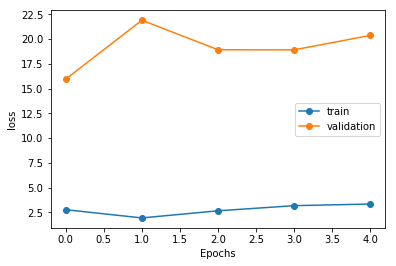

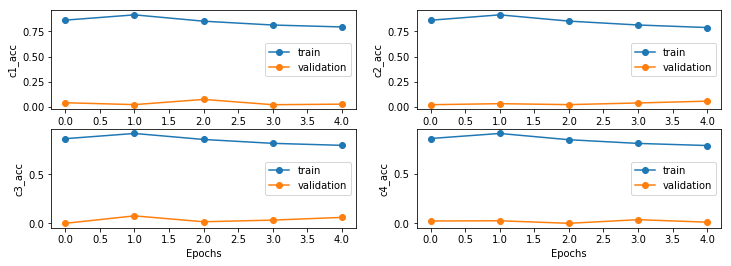

In [8]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics), '-o')
    plt.plot(history.history.get(val_metrics), '-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
plot_train_history(history, 'loss', 'val_loss')

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plot_train_history(history, 'c1_acc', 'val_c1_acc')

plt.subplot(2, 2, 2)
plot_train_history(history, 'c2_acc', 'val_c2_acc')

plt.subplot(2, 2, 3)
plot_train_history(history, 'c3_acc', 'val_c3_acc')

plt.subplot(2, 2, 4)
plot_train_history(history, 'c4_acc', 'val_c4_acc')

plt.show()

### Evaluation

In [ ]:
from keras.models import load_model

del model
model = load_model('captcha_model.h5')

X, y = next(gen(1))
y_pred = model.predict(X)

plt.title('real: %s \n pred: %s' %(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.show()


### Accuracy

In [ ]:
from tqdm import tqdm

def evaluate(model, batch_num=20):
    batch_acc = 0
    batch_count = 0
    
    generator = gen()
    
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        
        for i in range(len(y_pred)):
            batch_count += 1
            if np.array_equal(y_true[i], y_pred[i]):
                batch_acc += 1
                
    return batch_acc / batch_count
    
    
evaluate(model)